In [25]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [26]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [27]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [28]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### Optimizer

In [29]:
from scipy.optimize import minimize

### Ansatz State

In [30]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [31]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [32]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [33]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [34]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [35]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [36]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [37]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    print(sum(proba_distribution.values()))
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    print(counts)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [38]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [39]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [40]:
from qiskit import assemble, transpile
import random

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [41]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=360, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [42]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [43]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [44]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [45]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [46]:
approximated_energies = []

In [47]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [48]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [49]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [50]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [51]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

1it [00:11, 11.66s/it]

{'1001': 139, '1010': 390, '0101': 187, '1100': 44, '1011': 29, '0010': 28, '0110': 77, '1000': 56, '0111': 6, '1111': 9, '1101': 20, '1110': 18, '0100': 8, '0011': 10, '0000': 1, '0001': 2}
1.0


2it [00:11,  4.98s/it]

{'0111': 61, '0110': 101, '1111': 41, '1001': 376, '1010': 146, '0011': 17, '1011': 86, '1101': 31, '0100': 71, '0001': 14, '0101': 39, '0000': 11, '1100': 21, '0010': 5, '1110': 1, '1000': 3}
1.0


3it [00:12,  2.91s/it]

{'0001': 77, '1001': 62, '1011': 272, '0111': 64, '1110': 20, '0101': 75, '0011': 62, '0100': 33, '1100': 139, '1010': 62, '0000': 36, '1000': 14, '0010': 58, '1101': 22, '0110': 18, '1111': 10}
1.0


4it [00:12,  1.88s/it]

{'1011': 220, '0010': 42, '1111': 110, '0000': 91, '1101': 18, '1001': 160, '0001': 38, '0011': 55, '1100': 72, '0100': 63, '1010': 69, '1000': 4, '1110': 34, '0111': 17, '0101': 25, '0110': 6}
1.0


5it [00:12,  1.29s/it]

{'1001': 161, '1111': 93, '0010': 53, '1011': 243, '1100': 69, '0011': 59, '0000': 69, '0100': 53, '0001': 34, '1000': 8, '1010': 83, '0111': 17, '0101': 23, '0110': 8, '1110': 31, '1101': 20}
1.0


6it [00:13,  1.00s/it]

{'1010': 68, '1001': 174, '1110': 30, '1011': 211, '0010': 51, '0000': 112, '1101': 13, '0011': 53, '0101': 21, '0100': 41, '1100': 62, '1111': 127, '0001': 33, '1000': 9, '0111': 13, '0110': 6}
1.0


7it [00:13,  1.32it/s]

{'0101': 35, '1000': 242, '0000': 58, '1010': 122, '1001': 69, '1100': 41, '1101': 71, '0111': 39, '0010': 36, '0011': 98, '1110': 98, '1011': 46, '0100': 11, '0110': 21, '1111': 11, '0001': 26}
1.0


8it [00:13,  1.62it/s]

{'0110': 41, '0001': 198, '1010': 220, '1101': 142, '1110': 91, '1000': 65, '1011': 35, '0010': 175, '1111': 6, '1001': 18, '0000': 21, '1100': 7, '0100': 2, '0011': 2, '0111': 1}
1.0


9it [00:14,  1.95it/s]

{'0001': 7, '1001': 155, '1010': 372, '0101': 186, '0110': 73, '1011': 35, '0010': 42, '1100': 43, '1110': 28, '1000': 49, '0011': 11, '1111': 8, '1101': 8, '0111': 4, '0100': 3}
1.0


10it [00:14,  2.27it/s]

{'1001': 144, '1010': 398, '0110': 77, '0010': 38, '1100': 49, '0101': 183, '1101': 16, '1000': 35, '1011': 31, '1110': 17, '0111': 9, '1111': 12, '0100': 8, '0011': 6, '0001': 1}
1.0


11it [00:14,  2.59it/s]

{'1001': 145, '1010': 384, '1000': 41, '0111': 6, '0101': 200, '1100': 44, '0011': 9, '0110': 76, '1011': 28, '0001': 1, '0010': 39, '1101': 11, '1110': 23, '1111': 8, '0100': 8, '0000': 1}
1.0


12it [00:15,  2.63it/s]

{'1001': 153, '1010': 385, '1000': 39, '0010': 29, '0110': 75, '1101': 17, '0101': 186, '0011': 10, '1011': 35, '1100': 55, '1110': 14, '0111': 3, '0000': 4, '0100': 6, '1111': 12, '0001': 1}
1.0


13it [00:15,  2.83it/s]

{'0001': 61, '1010': 115, '1001': 85, '1111': 93, '0110': 65, '0010': 85, '1000': 201, '0111': 62, '0000': 54, '1110': 8, '1100': 73, '1101': 31, '0011': 30, '0100': 15, '0101': 29, '1011': 17}
1.0


14it [00:15,  3.02it/s]

{'1001': 166, '1010': 369, '1110': 21, '0101': 181, '1100': 50, '1011': 29, '0010': 37, '1111': 13, '0110': 79, '0111': 6, '1000': 41, '0100': 3, '1101': 18, '0011': 8, '0001': 3}
1.0


15it [00:16,  3.19it/s]

{'1001': 140, '1010': 404, '0101': 192, '0010': 42, '1111': 12, '0110': 69, '1100': 43, '0100': 6, '0001': 5, '1110': 17, '0011': 13, '1000': 40, '1101': 15, '1011': 24, '0000': 1, '0111': 1}
1.0


17it [00:16,  3.73it/s]

{'0001': 2, '1001': 144, '1010': 384, '0110': 69, '1111': 15, '0101': 196, '1100': 46, '1000': 44, '0010': 35, '1110': 22, '0100': 10, '1011': 26, '1101': 17, '0011': 8, '0111': 6}
1.0
{'1010': 379, '1001': 156, '1110': 24, '0101': 182, '0111': 5, '0110': 64, '1100': 58, '1000': 43, '1011': 28, '1111': 16, '0010': 33, '0011': 11, '1101': 15, '0001': 1, '0100': 8, '0000': 1}
1.0


18it [00:16,  3.38it/s]

{'0001': 61, '1010': 141, '0101': 41, '1110': 7, '1000': 180, '0111': 67, '0100': 22, '1111': 87, '0010': 86, '1001': 69, '1100': 73, '0000': 60, '0110': 62, '1101': 29, '0011': 31, '1011': 8}
1.0


19it [00:17,  3.11it/s]

{'1001': 89, '1010': 126, '0000': 62, '1000': 179, '1101': 29, '0111': 63, '1111': 88, '0110': 61, '0001': 66, '0010': 92, '0011': 30, '0100': 25, '1100': 70, '0101': 25, '1011': 14, '1110': 5}
1.0


20it [00:17,  3.27it/s]

{'0011': 13, '1010': 388, '1001': 130, '1110': 17, '0101': 191, '1111': 6, '0110': 80, '0111': 13, '1000': 55, '0000': 2, '1011': 24, '0010': 36, '1100': 52, '0100': 7, '1101': 8, '0001': 2}
1.0


21it [00:17,  3.15it/s]

{'0010': 47, '1001': 133, '1010': 377, '0110': 75, '1100': 48, '1000': 44, '0101': 205, '0100': 6, '1111': 5, '1101': 12, '1011': 35, '1110': 19, '0011': 12, '0001': 4, '0111': 2}
1.0


22it [00:18,  3.23it/s]

{'1001': 140, '1010': 392, '0010': 49, '1110': 18, '0101': 185, '1101': 19, '1000': 41, '1100': 44, '0110': 79, '0000': 1, '1011': 19, '1111': 14, '0011': 12, '0100': 5, '0111': 5, '0001': 1}
1.0


23it [00:18,  3.06it/s]

{'0010': 37, '1011': 27, '0110': 87, '1111': 10, '1001': 144, '1010': 375, '1000': 47, '0101': 180, '1101': 20, '1110': 16, '0100': 9, '1100': 55, '0001': 3, '0011': 10, '0111': 4}
1.0


24it [00:18,  2.94it/s]

{'1100': 46, '1001': 162, '1010': 380, '1011': 30, '0010': 35, '0110': 72, '0101': 174, '1000': 64, '1101': 13, '1110': 23, '1111': 6, '0011': 7, '0001': 4, '0100': 3, '0111': 3, '0000': 2}
1.0


25it [00:19,  3.05it/s]

{'1001': 145, '1010': 370, '1011': 28, '0010': 39, '0110': 78, '1101': 13, '0101': 203, '1000': 48, '1110': 15, '1100': 55, '1111': 12, '0100': 3, '0111': 5, '0011': 9, '0001': 1}
1.0


26it [00:19,  3.21it/s]

{'0101': 208, '1001': 147, '1010': 368, '1011': 36, '1101': 18, '0110': 62, '1000': 36, '0111': 7, '1100': 41, '1111': 8, '0010': 41, '0100': 5, '0011': 14, '1110': 25, '0001': 5, '0000': 3}
1.0


27it [00:19,  1.37it/s]


{'1110': 16, '0101': 195, '1010': 376, '1001': 154, '1000': 49, '1100': 47, '0100': 6, '0010': 41, '1011': 29, '0011': 12, '0110': 65, '1111': 11, '1101': 18, '0001': 2, '0111': 3}
1.0


1it [00:00,  2.72it/s]

{'1100': 25, '1001': 96, '1010': 455, '1000': 82, '0111': 19, '1111': 15, '0110': 120, '0101': 32, '1110': 23, '1011': 58, '0011': 27, '1101': 35, '0001': 6, '0100': 16, '0010': 14, '0000': 1}
1.0


2it [00:00,  3.34it/s]

{'1000': 63, '1010': 109, '1001': 379, '1011': 151, '0010': 1, '0111': 110, '0110': 19, '1111': 54, '1100': 34, '1110': 6, '0100': 35, '0011': 7, '0001': 22, '1101': 8, '0101': 16, '0000': 10}
1.0


3it [00:00,  3.22it/s]

{'1001': 90, '0001': 61, '0011': 106, '0010': 104, '1011': 299, '0110': 33, '0111': 70, '1110': 33, '0000': 23, '1010': 76, '0101': 67, '1111': 24, '1101': 9, '1000': 6, '0100': 10, '1100': 13}
1.0


4it [00:01,  3.14it/s]

{'1001': 177, '1010': 145, '0100': 3, '1011': 216, '0010': 25, '1111': 160, '0101': 31, '0011': 83, '1100': 50, '1110': 43, '0110': 20, '0111': 32, '0001': 11, '1101': 27, '1000': 1}
1.0


5it [00:01,  3.23it/s]

{'1110': 40, '0101': 32, '1001': 171, '1010': 145, '0110': 32, '1111': 141, '1100': 42, '0111': 40, '1101': 37, '1011': 230, '0011': 80, '0010': 15, '0100': 9, '0001': 8, '1000': 1, '0000': 1}
1.0


6it [00:01,  3.14it/s]

{'1010': 136, '1001': 201, '1111': 115, '0010': 21, '1011': 221, '1101': 36, '0011': 84, '0111': 31, '1100': 52, '0110': 37, '1110': 38, '0100': 9, '0001': 11, '0101': 31, '1000': 1}
1.0


7it [00:02,  2.97it/s]

{'0010': 55, '1011': 117, '1010': 132, '1100': 58, '0000': 23, '1000': 309, '1110': 93, '1101': 72, '1001': 29, '0100': 53, '0110': 32, '0011': 20, '0111': 12, '0101': 14, '1111': 5}
1.0


8it [00:02,  3.06it/s]

{'0001': 64, '1010': 246, '0000': 70, '1000': 29, '0110': 98, '0100': 17, '0101': 19, '0010': 155, '1100': 16, '1101': 64, '1001': 22, '1110': 115, '0011': 44, '1111': 13, '0111': 7, '1011': 45}
1.0


9it [00:02,  2.95it/s]

{'1001': 95, '1010': 447, '0100': 15, '1101': 31, '0110': 144, '0101': 30, '0111': 19, '1011': 65, '1000': 83, '0011': 16, '1100': 22, '0010': 15, '0001': 3, '1111': 19, '1110': 17, '0000': 3}
1.0


10it [00:03,  3.08it/s]

{'1001': 112, '1010': 456, '0110': 122, '1011': 52, '0010': 12, '1000': 88, '1100': 31, '1101': 32, '1110': 26, '0101': 23, '1111': 10, '0011': 24, '0100': 14, '0111': 9, '0001': 8, '0000': 5}
1.0


11it [00:03,  3.23it/s]

{'1001': 103, '1010': 449, '1110': 29, '0110': 118, '1111': 25, '1000': 83, '1011': 67, '0011': 15, '1100': 27, '1101': 26, '0101': 35, '0010': 17, '0111': 10, '0100': 11, '0000': 3, '0001': 6}
1.0


12it [00:03,  2.96it/s]

{'1011': 67, '1001': 100, '1010': 477, '0011': 22, '1100': 33, '1101': 28, '1000': 84, '0110': 112, '0101': 26, '0100': 11, '1110': 19, '0010': 12, '0111': 8, '1111': 19, '0001': 5, '0000': 1}
1.0


13it [00:04,  2.95it/s]

{'0001': 23, '0000': 134, '1000': 221, '0111': 57, '0100': 55, '1011': 41, '0010': 100, '1111': 19, '0110': 84, '1010': 105, '1100': 30, '1001': 80, '1101': 8, '0011': 48, '0101': 4, '1110': 15}
1.0


14it [00:04,  3.12it/s]

{'1001': 106, '1010': 469, '1101': 36, '0110': 126, '1011': 33, '0000': 4, '1000': 82, '0101': 33, '0011': 12, '1110': 18, '1100': 34, '0100': 15, '0010': 13, '0001': 10, '1111': 24, '0111': 9}
1.0


15it [00:04,  3.17it/s]

{'0110': 111, '1111': 23, '1010': 463, '1001': 107, '0011': 22, '1100': 33, '1011': 63, '1000': 90, '0101': 24, '0010': 18, '1110': 24, '1101': 17, '0000': 6, '0001': 5, '0100': 9, '0111': 9}
1.0


16it [00:05,  3.20it/s]

{'1011': 50, '0001': 11, '1010': 454, '1001': 93, '1000': 88, '0110': 115, '0101': 30, '1101': 34, '1110': 23, '0111': 13, '0010': 20, '0100': 18, '1100': 32, '1111': 21, '0011': 21, '0000': 1}
1.0


17it [00:05,  2.99it/s]

{'1001': 109, '1010': 478, '0101': 31, '1110': 23, '0100': 12, '1100': 38, '1011': 56, '0110': 104, '1101': 29, '1000': 74, '0111': 12, '0010': 20, '0001': 4, '1111': 16, '0000': 3, '0011': 15}
1.0


18it [00:05,  3.01it/s]

{'0011': 33, '1110': 13, '0000': 131, '1000': 210, '0100': 58, '1010': 125, '1001': 87, '0111': 75, '0110': 91, '1011': 30, '1100': 36, '0010': 84, '1111': 18, '0001': 21, '0101': 8, '1101': 4}
1.0


19it [00:06,  3.10it/s]

{'0100': 45, '1100': 32, '0011': 48, '0001': 28, '1010': 115, '1000': 236, '0000': 130, '0010': 92, '1111': 26, '1001': 75, '0110': 72, '0111': 61, '1101': 10, '1110': 20, '1011': 28, '0101': 6}
1.0


20it [00:06,  2.82it/s]

{'1001': 113, '1010': 460, '0111': 11, '1000': 97, '0100': 10, '0110': 107, '1111': 16, '1100': 28, '0011': 23, '1011': 52, '0010': 11, '0000': 5, '0001': 8, '0101': 29, '1101': 33, '1110': 21}
1.0


21it [00:06,  3.11it/s]

{'1001': 99, '1010': 482, '0010': 16, '1011': 49, '0110': 111, '0101': 24, '1000': 91, '1101': 26, '1100': 29, '0011': 19, '1111': 23, '0001': 5, '0100': 16, '1110': 22, '0111': 9, '0000': 3}
1.0


22it [00:07,  2.85it/s]

{'1001': 118, '1010': 448, '1110': 19, '1101': 36, '0110': 112, '1000': 102, '1011': 55, '1100': 33, '0101': 29, '0001': 8, '0111': 13, '1111': 12, '0100': 12, '0011': 13, '0010': 12, '0000': 2}
1.0


23it [00:07,  2.90it/s]

{'1010': 462, '0010': 18, '1000': 88, '0110': 131, '1110': 21, '0101': 24, '1101': 28, '1100': 34, '1001': 81, '0111': 14, '1011': 63, '0011': 23, '0100': 8, '1111': 15, '0001': 11, '0000': 3}
1.0
{'0110': 130, '1111': 13, '0101': 33, '0011': 26, '1100': 38, '1011': 41, '1001': 113, '1010': 453, '1000': 72, '0111': 14, '1101': 37, '1110': 22, '0100': 11, '0010': 16, '0000': 2, '0001': 3}
1.0


25it [00:08,  3.01it/s]

{'0111': 12, '1001': 87, '1010': 453, '0101': 30, '1000': 101, '1101': 38, '0110': 119, '0010': 18, '1111': 12, '1100': 27, '1011': 50, '1110': 28, '0011': 18, '0100': 23, '0000': 3, '0001': 5}
1.0


26it [00:08,  2.60it/s]

{'0110': 122, '1001': 96, '1010': 467, '1011': 58, '1000': 86, '1101': 30, '0101': 35, '0111': 14, '1100': 31, '0010': 16, '0100': 6, '0001': 5, '1110': 19, '0011': 22, '1111': 14, '0000': 3}
1.0


27it [00:09,  2.97it/s]


{'0110': 122, '1000': 93, '1001': 95, '1010': 474, '0011': 23, '0111': 12, '0100': 14, '1110': 35, '1101': 31, '0001': 6, '0010': 12, '0101': 32, '1100': 16, '1011': 40, '1111': 18, '0000': 1}
1.0


1it [00:00,  3.99it/s]

{'0101': 183, '1001': 149, '1010': 310, '1101': 52, '1111': 35, '1100': 45, '1000': 54, '1011': 41, '0010': 37, '0000': 13, '0011': 5, '0110': 63, '1110': 29, '0111': 5, '0001': 1, '0100': 2}
1.0


2it [00:00,  3.39it/s]

{'1010': 114, '1001': 372, '0111': 60, '1011': 54, '0010': 4, '0110': 83, '1111': 142, '0100': 51, '0101': 62, '1101': 1, '1110': 19, '1000': 8, '0000': 17, '0001': 19, '0011': 13, '1100': 5}
1.0


3it [00:00,  3.34it/s]

{'0100': 97, '1110': 21, '1011': 223, '1100': 56, '1010': 76, '0001': 57, '1001': 107, '0111': 92, '0000': 29, '0011': 59, '1101': 139, '1111': 14, '0010': 28, '1000': 14, '0110': 10, '0101': 2}
1.0


4it [00:01,  3.19it/s]

{'0100': 44, '1101': 186, '1110': 36, '1011': 235, '0001': 50, '1100': 23, '0000': 77, '1111': 56, '0011': 41, '0110': 19, '0101': 43, '1010': 54, '1000': 27, '1001': 82, '0010': 14, '0111': 37}
1.0


5it [00:01,  3.36it/s]

{'1011': 259, '1010': 50, '1001': 100, '0000': 89, '1111': 50, '1101': 176, '0101': 40, '0011': 32, '0001': 47, '0100': 45, '1000': 20, '0111': 30, '1110': 31, '0110': 15, '1100': 29, '0010': 11}
1.0


6it [00:01,  3.31it/s]

{'1101': 167, '0001': 44, '1011': 278, '1110': 37, '0101': 45, '1100': 22, '0000': 65, '1111': 65, '1001': 68, '0011': 36, '0100': 36, '0111': 37, '1010': 59, '1000': 34, '0110': 16, '0010': 15}
1.0


7it [00:02,  3.41it/s]

{'1000': 87, '1001': 72, '1010': 229, '1100': 131, '1101': 78, '0100': 17, '1110': 15, '1011': 47, '0101': 49, '0011': 71, '0000': 61, '0110': 37, '1111': 47, '0111': 47, '0001': 33, '0010': 3}
1.0


8it [00:02,  3.00it/s]

{'1011': 36, '0010': 126, '1000': 30, '1010': 203, '0001': 145, '1100': 48, '1110': 94, '1101': 192, '0110': 25, '1001': 62, '0100': 28, '0111': 19, '1111': 3, '0000': 4, '0011': 7, '0101': 2}
1.0


9it [00:02,  3.03it/s]

{'0101': 197, '1111': 21, '1010': 305, '1001': 175, '1000': 45, '0011': 3, '0010': 24, '1101': 61, '0110': 68, '0000': 12, '1110': 29, '1100': 43, '1011': 29, '0111': 5, '0001': 4, '0100': 3}
1.0


10it [00:03,  3.21it/s]

{'0101': 196, '1011': 22, '0010': 30, '1001': 171, '1010': 313, '0000': 18, '1111': 25, '0110': 55, '1000': 53, '1101': 57, '1100': 35, '1110': 41, '0011': 4, '0001': 2, '0111': 2}
1.0


11it [00:03,  3.47it/s]

{'0010': 27, '1011': 25, '1001': 157, '1010': 298, '1111': 22, '0110': 81, '0101': 204, '1000': 50, '1101': 64, '1100': 34, '0000': 12, '1110': 37, '0001': 5, '0100': 2, '0111': 4, '0011': 2}
1.0


12it [00:03,  3.47it/s]

{'1110': 33, '0101': 193, '1010': 300, '1001': 151, '1111': 32, '1101': 54, '0010': 37, '1000': 67, '0000': 15, '0110': 69, '0111': 4, '1100': 35, '0100': 6, '1011': 24, '0001': 1, '0011': 3}
1.0


13it [00:04,  2.96it/s]

{'0110': 66, '1111': 166, '1000': 193, '0001': 78, '1001': 89, '1010': 152, '0101': 25, '0111': 41, '1110': 25, '0010': 35, '0000': 43, '1101': 34, '0011': 17, '1100': 11, '1011': 12, '0100': 37}
1.0


14it [00:04,  3.14it/s]

{'1110': 31, '0101': 194, '1111': 25, '0110': 67, '1001': 172, '1010': 304, '1000': 66, '0010': 30, '0100': 3, '1100': 30, '0000': 14, '1011': 19, '1101': 57, '0011': 4, '0111': 7, '0001': 1}
1.0


15it [00:04,  3.04it/s]

{'1010': 283, '1001': 151, '0000': 13, '1000': 54, '0110': 78, '0101': 203, '1011': 40, '0010': 32, '1110': 47, '1111': 23, '1101': 48, '1100': 40, '0111': 8, '0100': 3, '0011': 1}
1.0


16it [00:04,  3.09it/s]

{'0101': 190, '1101': 53, '1001': 170, '1010': 314, '0000': 14, '1111': 12, '0110': 58, '0010': 30, '1110': 23, '1000': 74, '1011': 34, '0011': 5, '1100': 32, '0111': 8, '0100': 3, '0001': 4}
1.0


17it [00:05,  3.15it/s]

{'1001': 169, '1010': 329, '1111': 23, '0110': 67, '0101': 176, '1110': 31, '1011': 27, '1000': 53, '0111': 5, '1101': 62, '1100': 37, '0010': 26, '0011': 5, '0000': 12, '0100': 2}
1.0


18it [00:05,  3.09it/s]

{'0010': 34, '0001': 90, '1010': 150, '0101': 32, '1000': 203, '0100': 39, '1101': 54, '0111': 47, '1001': 88, '1111': 139, '1011': 7, '0110': 60, '1100': 6, '0000': 36, '1110': 18, '0011': 21}
1.0


19it [00:06,  2.90it/s]

{'1000': 207, '1010': 120, '0001': 94, '1111': 148, '0010': 30, '0100': 34, '1101': 54, '0011': 29, '0101': 33, '1001': 77, '0000': 48, '1011': 5, '0110': 61, '0111': 42, '1110': 31, '1100': 11}
1.0


20it [00:06,  3.09it/s]

{'0101': 222, '0110': 72, '1001': 151, '1010': 287, '1000': 61, '1101': 58, '1011': 28, '1100': 43, '0010': 22, '1110': 37, '1111': 23, '0000': 6, '0100': 3, '0011': 4, '0111': 6, '0001': 1}
1.0


21it [00:06,  3.22it/s]

{'1001': 152, '1010': 290, '1000': 63, '0101': 204, '1110': 30, '1100': 39, '1101': 61, '1011': 33, '0010': 33, '0110': 64, '1111': 30, '0011': 2, '0000': 13, '0100': 4, '0001': 3, '0111': 3}
1.0


22it [00:06,  3.11it/s]

{'1000': 64, '1011': 35, '0010': 28, '0101': 232, '1010': 265, '1001': 153, '1100': 44, '0110': 74, '1101': 54, '1110': 35, '1111': 19, '0111': 7, '0011': 5, '0000': 8, '0100': 1}
1.0


23it [00:07,  2.89it/s]

{'1000': 57, '0001': 4, '1001': 153, '1010': 299, '1101': 73, '1110': 32, '0101': 209, '1111': 25, '1011': 25, '0110': 64, '1100': 39, '0010': 25, '0000': 8, '0011': 6, '0100': 3, '0111': 2}
1.0


24it [00:07,  2.90it/s]

{'0101': 207, '1111': 26, '0110': 71, '1001': 151, '1010': 300, '1101': 54, '0100': 1, '0111': 4, '1100': 47, '0010': 25, '0000': 14, '1000': 56, '1110': 28, '1011': 34, '0011': 4, '0001': 2}
1.0


25it [00:07,  3.20it/s]

{'1001': 158, '1010': 290, '0101': 202, '1110': 44, '1111': 15, '0110': 69, '1100': 33, '1011': 32, '1000': 69, '1101': 57, '0000': 14, '0010': 25, '0111': 10, '0100': 1, '0011': 3, '0001': 2}
1.0


26it [00:08,  3.04it/s]

{'1110': 35, '0101': 197, '1001': 163, '1010': 312, '0110': 65, '1111': 26, '1101': 45, '1000': 57, '1100': 43, '0010': 28, '1011': 26, '0000': 13, '0100': 4, '0111': 3, '0011': 4, '0001': 3}
1.0


27it [00:08,  3.16it/s]


{'1001': 139, '1010': 329, '0110': 81, '0000': 14, '0101': 202, '1110': 30, '0111': 3, '0010': 24, '1100': 37, '1111': 20, '1101': 51, '1000': 66, '1011': 25, '0011': 3}
1.0


0it [00:00, ?it/s]

{'1001': 121, '1010': 345, '0101': 204, '0110': 93, '0010': 57, '1011': 90, '1000': 18, '1100': 14, '0111': 23, '1111': 8, '0011': 4, '0100': 11, '0001': 8, '1101': 5, '0000': 19, '1110': 4}
1.0


2it [00:00,  3.79it/s]

{'0001': 27, '1010': 93, '1001': 359, '0101': 79, '0110': 81, '0100': 56, '1011': 84, '0111': 155, '0011': 29, '1110': 13, '0010': 16, '1100': 8, '1000': 4, '1111': 4, '0000': 15, '1101': 1}
1.0


3it [00:00,  3.41it/s]

{'1101': 99, '0000': 16, '0001': 76, '0111': 42, '0011': 246, '1011': 197, '0101': 71, '0110': 13, '1110': 29, '0010': 55, '1001': 16, '1100': 65, '1111': 32, '0100': 8, '1010': 25, '1000': 34}
1.0


4it [00:01,  3.23it/s]

{'1111': 169, '0011': 80, '1100': 54, '1011': 218, '1010': 36, '0001': 170, '1101': 18, '0000': 32, '0101': 26, '0010': 70, '0111': 29, '0100': 37, '1110': 17, '1001': 59, '0110': 6, '1000': 3}
1.0


5it [00:01,  3.30it/s]

{'1110': 21, '0001': 159, '1001': 51, '0010': 77, '1011': 254, '0011': 68, '1100': 52, '0100': 26, '1111': 172, '1101': 22, '0111': 25, '0110': 7, '0101': 32, '0000': 25, '1010': 29, '1000': 4}
1.0


6it [00:01,  3.38it/s]

{'0010': 81, '1011': 231, '0001': 140, '1010': 40, '0011': 57, '0000': 36, '1110': 20, '1111': 171, '1100': 58, '0101': 26, '1001': 59, '1000': 8, '1101': 19, '0110': 5, '0111': 30, '0100': 43}
1.0


7it [00:01,  3.60it/s]

{'1001': 86, '1010': 69, '0000': 86, '1000': 159, '1101': 101, '1110': 123, '1011': 16, '0011': 145, '0010': 68, '0111': 38, '0101': 25, '0001': 26, '0100': 20, '0110': 6, '1100': 53, '1111': 3}
1.0


8it [00:02,  3.53it/s]

{'0001': 143, '1001': 40, '1010': 198, '1101': 125, '0110': 171, '0101': 13, '1011': 65, '0010': 146, '1000': 23, '0100': 10, '0111': 18, '0000': 22, '1110': 29, '1100': 9, '0011': 6, '1111': 6}
1.0


9it [00:02,  3.33it/s]

{'0101': 213, '1010': 345, '1001': 99, '0110': 97, '0111': 15, '1011': 89, '0010': 69, '0100': 14, '0000': 26, '1100': 11, '1000': 17, '1101': 4, '0001': 12, '1111': 8, '1110': 3, '0011': 2}
1.0


10it [00:02,  3.49it/s]

{'0100': 10, '0101': 198, '0010': 37, '1011': 77, '1001': 120, '1010': 376, '0110': 111, '0111': 31, '0000': 12, '1100': 9, '1111': 6, '1000': 20, '0001': 12, '1110': 1, '1101': 2, '0011': 2}
1.0


11it [00:03,  3.55it/s]

{'1001': 102, '1010': 361, '0100': 17, '0101': 197, '1000': 20, '0111': 21, '0010': 59, '0110': 92, '1011': 80, '0000': 15, '1111': 7, '0001': 20, '1100': 18, '0011': 8, '1110': 2, '1101': 5}
1.0


12it [00:03,  3.34it/s]

{'1011': 86, '0010': 62, '0101': 210, '1000': 20, '0001': 13, '1010': 347, '1001': 109, '0110': 93, '0100': 15, '0111': 26, '1111': 4, '1100': 11, '0011': 4, '0000': 16, '1101': 8}
1.0


13it [00:03,  3.35it/s]

{'1000': 63, '0000': 165, '1001': 77, '1010': 98, '0010': 116, '1100': 52, '1111': 130, '0111': 77, '0001': 124, '1101': 23, '0011': 13, '0100': 25, '0110': 22, '0101': 20, '1011': 10, '1110': 9}
1.0


14it [00:04,  3.58it/s]

{'0010': 52, '1011': 86, '1001': 116, '1010': 352, '1000': 27, '0100': 13, '0101': 202, '0110': 93, '0001': 13, '0000': 19, '1111': 8, '1100': 14, '0111': 20, '0011': 5, '1110': 2, '1101': 2}
1.0


15it [00:04,  3.00it/s]

{'0001': 9, '1001': 130, '1010': 364, '0101': 174, '1011': 96, '0010': 53, '0110': 89, '0111': 26, '0000': 12, '1111': 6, '1101': 2, '0011': 5, '1100': 13, '0100': 20, '1000': 22, '1110': 3}
1.0


16it [00:04,  2.85it/s]

{'0000': 17, '0101': 233, '0001': 13, '1010': 348, '1101': 3, '0010': 44, '1100': 17, '1111': 13, '0111': 19, '1001': 107, '1011': 80, '0110': 92, '1000': 13, '0100': 16, '0011': 7, '1110': 2}
1.0


17it [00:05,  2.67it/s]

{'0101': 190, '0001': 16, '1001': 120, '1010': 358, '1000': 18, '1011': 72, '0100': 22, '0110': 89, '0010': 64, '0000': 25, '1110': 3, '0011': 4, '0111': 19, '1111': 14, '1101': 3, '1100': 7}
1.0


18it [00:05,  2.71it/s]

{'0110': 21, '1111': 133, '0000': 167, '1000': 65, '0001': 123, '1001': 88, '0111': 62, '0010': 112, '1010': 101, '1101': 17, '0101': 25, '1011': 8, '1100': 53, '0011': 20, '1110': 11, '0100': 18}
1.0


19it [00:05,  2.84it/s]

{'0111': 68, '0000': 188, '0110': 37, '1111': 138, '1010': 101, '1001': 75, '0001': 103, '1100': 60, '0010': 92, '0011': 10, '0100': 29, '1000': 69, '0101': 18, '1101': 18, '1110': 11, '1011': 7}
1.0


20it [00:06,  2.97it/s]

{'1011': 92, '0010': 55, '0101': 199, '0110': 86, '0001': 12, '1010': 332, '1001': 137, '0000': 11, '1100': 18, '0011': 6, '0111': 25, '1000': 21, '1111': 13, '1101': 4, '0100': 12, '1110': 1}
1.0


21it [00:06,  3.02it/s]

{'1011': 69, '0010': 51, '0110': 95, '1010': 365, '1001': 86, '0101': 231, '1101': 5, '0100': 13, '0000': 16, '0111': 27, '1100': 12, '1000': 19, '0011': 9, '1111': 10, '0001': 15, '1110': 1}
1.0


22it [00:06,  2.88it/s]

{'1011': 97, '0111': 19, '1001': 98, '0001': 14, '1010': 372, '0101': 184, '1000': 19, '0100': 17, '1100': 21, '0110': 97, '0000': 17, '0010': 54, '1111': 6, '1110': 1, '1101': 5, '0011': 3}
1.0


23it [00:07,  2.83it/s]

{'0101': 218, '0010': 72, '1011': 70, '1111': 7, '0110': 108, '1010': 351, '0100': 17, '1101': 1, '0001': 13, '1001': 95, '0000': 12, '0111': 21, '1110': 3, '1000': 24, '1100': 8, '0011': 4}
1.0


24it [00:07,  3.01it/s]

{'0110': 86, '0101': 211, '0001': 15, '1010': 343, '1001': 118, '0010': 68, '1011': 75, '0111': 22, '1111': 9, '1000': 21, '1110': 3, '0100': 12, '1101': 7, '1100': 11, '0000': 23}
1.0


25it [00:07,  2.99it/s]

{'1011': 78, '0101': 213, '1001': 102, '1010': 330, '1111': 6, '0110': 104, '1100': 18, '1101': 4, '0010': 56, '0111': 33, '1000': 14, '0001': 15, '1110': 1, '0011': 5, '0000': 30, '0100': 15}
1.0


26it [00:08,  2.82it/s]

{'0001': 11, '1001': 118, '1010': 343, '0010': 66, '1011': 90, '0110': 97, '0101': 192, '1000': 22, '0111': 23, '0000': 17, '1100': 14, '1111': 4, '1101': 7, '0011': 5, '0100': 15}
1.0


27it [00:08,  3.08it/s]


{'1001': 114, '1010': 343, '1100': 11, '0010': 59, '1011': 93, '0101': 196, '0110': 94, '1000': 22, '0001': 13, '0100': 22, '1101': 7, '0000': 27, '0111': 16, '0011': 2, '1111': 4, '1110': 1}
1.0


1it [00:00,  3.30it/s]

{'1110': 26, '0101': 173, '1011': 26, '0010': 61, '1001': 208, '1010': 281, '0110': 171, '1000': 6, '1100': 37, '1111': 5, '0011': 6, '1101': 7, '0111': 4, '0000': 10, '0001': 3}
1.0
{'0110': 137, '1111': 36, '1001': 247, '1010': 169, '1011': 116, '0101': 182, '1101': 8, '0011': 24, '0100': 13, '1100': 8, '1110': 3, '0001': 19, '0000': 19, '1000': 14, '0111': 19, '0010': 10}

2it [00:00,  3.95it/s]


1.0


3it [00:00,  3.00it/s]

{'0110': 56, '0011': 123, '0001': 79, '1001': 73, '0000': 29, '0100': 27, '0010': 70, '0111': 113, '1100': 46, '1011': 132, '1101': 51, '1010': 44, '1000': 67, '0101': 69, '1111': 33, '1110': 12}
1.0


4it [00:01,  2.67it/s]

{'0001': 39, '1001': 162, '1010': 82, '0111': 47, '1100': 73, '0011': 121, '0110': 13, '1111': 68, '1011': 165, '0010': 47, '0101': 43, '1000': 22, '0100': 66, '1110': 35, '1101': 20, '0000': 21}
1.0


5it [00:01,  2.50it/s]

{'1010': 92, '1001': 172, '0100': 74, '0011': 121, '1111': 71, '0110': 5, '1011': 173, '0010': 55, '0001': 36, '1110': 29, '1100': 60, '1101': 21, '0101': 33, '1000': 20, '0111': 40, '0000': 22}
1.0


6it [00:02,  2.91it/s]

{'1100': 51, '0011': 115, '1101': 23, '0100': 61, '1011': 167, '0010': 62, '0001': 56, '1001': 143, '1110': 33, '1111': 66, '1010': 102, '0111': 52, '0000': 27, '0110': 21, '0101': 23, '1000': 22}
1.0


7it [00:02,  2.85it/s]

{'0101': 88, '1000': 134, '0000': 99, '1111': 28, '0010': 102, '1100': 31, '1010': 131, '0111': 39, '1011': 106, '0011': 32, '0110': 46, '1110': 53, '1001': 43, '1101': 44, '0001': 37, '0100': 11}
1.0


8it [00:02,  2.87it/s]

{'1110': 140, '0101': 45, '0010': 393, '1101': 127, '1001': 38, '1010': 53, '0001': 150, '1000': 13, '1011': 2, '1111': 7, '0011': 23, '1100': 8, '0000': 21, '0110': 3, '0111': 1}
1.0


9it [00:03,  2.59it/s]

{'1001': 219, '1010': 290, '0110': 170, '1110': 30, '0101': 150, '0010': 61, '1011': 30, '1100': 29, '1101': 11, '1000': 10, '0111': 7, '0011': 7, '1111': 5, '0000': 4, '0001': 1}
1.0


10it [00:03,  2.75it/s]

{'1010': 307, '1001': 207, '0110': 184, '1011': 23, '0010': 56, '0101': 144, '1110': 29, '0111': 8, '1100': 28, '1111': 6, '0000': 6, '0011': 8, '0001': 3, '1101': 4, '1000': 11}
1.0


11it [00:04,  2.54it/s]

{'1010': 307, '1001': 227, '1100': 20, '0101': 146, '1000': 15, '0110': 184, '0010': 60, '0111': 1, '1011': 23, '0011': 8, '1110': 23, '0000': 2, '1101': 2, '1111': 3, '0001': 3}
1.0


12it [00:04,  2.62it/s]

{'0110': 158, '1010': 316, '1001': 207, '0000': 11, '1000': 6, '0101': 159, '1110': 25, '0010': 64, '1100': 22, '1101': 11, '0111': 9, '1011': 19, '0011': 5, '1111': 11, '0001': 1}
1.0


13it [00:04,  2.36it/s]

{'0010': 101, '0101': 44, '1001': 64, '1000': 76, '0000': 97, '0011': 94, '1100': 25, '0110': 117, '1010': 96, '0100': 86, '0111': 45, '0001': 29, '1111': 22, '1101': 62, '1011': 42, '1110': 24}
1.0


14it [00:05,  2.39it/s]

{'1010': 279, '1001': 198, '0010': 56, '1011': 30, '0000': 6, '1000': 18, '0101': 168, '1100': 27, '0110': 183, '0011': 5, '1110': 36, '1111': 6, '0001': 4, '1101': 5, '0111': 3}
1.0


15it [00:05,  2.32it/s]

{'1110': 26, '0101': 154, '1001': 215, '1010': 338, '0110': 149, '0011': 7, '1101': 8, '1000': 10, '0010': 43, '1100': 30, '0000': 5, '1011': 32, '0111': 3, '1111': 4}
1.0


16it [00:06,  2.51it/s]

{'1001': 204, '1010': 324, '0110': 156, '0101': 168, '1110': 33, '1011': 20, '0010': 54, '0011': 9, '1101': 9, '1000': 8, '0000': 2, '1100': 20, '0111': 7, '0001': 3, '1111': 7}
1.0


17it [00:06,  2.39it/s]

{'1110': 35, '0101': 169, '0110': 173, '0001': 2, '1001': 210, '1010': 286, '0000': 5, '0011': 6, '0010': 55, '1100': 28, '1000': 14, '1101': 4, '1111': 5, '0111': 5, '1011': 27}
1.0


18it [00:06,  2.78it/s]

{'0011': 81, '0010': 90, '1001': 69, '1010': 107, '0110': 121, '0101': 56, '0100': 85, '1000': 70, '0000': 85, '1011': 54, '0111': 49, '1111': 24, '0001': 32, '1110': 26, '1101': 51, '1100': 24}
1.0


19it [00:07,  2.89it/s]

{'0101': 47, '1000': 72, '0000': 91, '1100': 27, '0111': 39, '0110': 105, '1001': 70, '0001': 27, '1010': 117, '0010': 106, '1101': 63, '0100': 72, '1111': 29, '0011': 94, '1011': 44, '1110': 21}
1.0


20it [00:07,  3.10it/s]

{'1011': 22, '0010': 52, '1010': 314, '1001': 190, '1110': 24, '0101': 172, '0111': 8, '0110': 200, '1100': 15, '1101': 8, '0000': 7, '1000': 5, '1111': 4, '0011': 3}
1.0


21it [00:07,  2.98it/s]

{'1010': 338, '1001': 180, '0110': 171, '1111': 5, '1110': 26, '0101': 158, '1011': 24, '0010': 55, '0111': 5, '1100': 30, '0001': 5, '1000': 15, '0011': 6, '0000': 4, '1101': 2}
1.0


22it [00:08,  3.04it/s]

{'1001': 213, '1010': 303, '1110': 25, '0101': 169, '1100': 30, '1101': 11, '0110': 171, '0010': 55, '0000': 3, '1011': 18, '1000': 13, '0111': 4, '0011': 3, '1111': 6}
1.0


23it [00:08,  3.34it/s]

{'1110': 29, '0101': 159, '1001': 232, '1010': 278, '0110': 171, '1011': 14, '0010': 66, '0011': 6, '1000': 12, '0111': 7, '1100': 26, '1101': 8, '1111': 9, '0001': 1, '0100': 1, '0000': 5}
1.0


24it [00:08,  3.45it/s]

{'0110': 177, '1001': 183, '1010': 352, '1011': 17, '0010': 54, '0101': 152, '1000': 11, '0011': 7, '1100': 21, '1111': 9, '1101': 9, '1110': 25, '0111': 2, '0000': 5}
1.0


25it [00:08,  3.59it/s]

{'1010': 294, '1001': 178, '0110': 194, '1100': 31, '1110': 29, '0101': 174, '1000': 14, '0000': 2, '0011': 3, '0010': 64, '1011': 19, '1101': 8, '1111': 8, '0111': 4, '0001': 2}
1.0


26it [00:09,  3.41it/s]

{'1001': 207, '1010': 305, '0110': 189, '1000': 5, '0000': 3, '0010': 56, '1110': 33, '0101': 158, '1101': 5, '0111': 5, '1100': 28, '1011': 22, '0011': 5, '1111': 3}
1.0


27it [00:09,  2.86it/s]


{'1001': 199, '1010': 315, '0110': 183, '0101': 168, '1110': 27, '0011': 4, '0111': 6, '1101': 10, '1100': 19, '1011': 22, '0010': 55, '1000': 7, '1111': 7, '0000': 2}
1.0


1it [00:00,  3.74it/s]

{'0110': 98, '1001': 117, '1010': 395, '1000': 68, '0010': 52, '1110': 16, '0101': 100, '1101': 12, '1011': 53, '1100': 50, '1111': 23, '0100': 13, '0001': 12, '0011': 7, '0000': 3, '0111': 5}
1.0


2it [00:00,  3.57it/s]

{'0000': 21, '1011': 106, '0111': 47, '1010': 122, '1001': 370, '0101': 46, '1101': 23, '0110': 109, '1000': 24, '1111': 48, '0100': 24, '0011': 23, '1100': 36, '0001': 20, '1110': 4, '0010': 1}
1.0


3it [00:00,  3.81it/s]

{'1011': 309, '0101': 61, '1010': 76, '0001': 57, '1001': 72, '1100': 102, '0111': 76, '0100': 15, '1110': 30, '1101': 23, '0011': 89, '0000': 64, '0010': 9, '1111': 13, '0110': 18, '1000': 10}
1.0


5it [00:01,  4.42it/s]

{'1001': 167, '1010': 75, '0010': 36, '1011': 237, '0000': 75, '1111': 131, '1100': 83, '1110': 21, '0001': 23, '1101': 14, '0111': 26, '0011': 79, '0110': 19, '0101': 10, '1000': 11, '0100': 17}
1.0
{'0010': 46, '1011': 218, '1001': 166, '0111': 36, '1100': 92, '0011': 64, '1111': 151, '1101': 13, '1010': 64, '1110': 15, '0000': 84, '0110': 18, '0001': 20, '0100': 18, '0101': 11, '1000': 8}
1.0


6it [00:01,  3.80it/s]

{'1011': 282, '0111': 30, '1111': 134, '1100': 86, '1001': 135, '1010': 67, '0001': 35, '0000': 93, '0010': 30, '0110': 16, '0011': 36, '1110': 22, '1101': 11, '0101': 19, '1000': 11, '0100': 17}
1.0


7it [00:01,  3.65it/s]

{'1000': 248, '0010': 52, '0110': 46, '0001': 18, '1010': 128, '1100': 35, '1101': 88, '1110': 134, '1001': 69, '0011': 73, '0000': 40, '0101': 19, '1011': 38, '0100': 25, '0111': 6, '1111': 5}
1.0


8it [00:02,  3.72it/s]

{'1010': 237, '0001': 107, '1101': 85, '1100': 37, '1011': 42, '0010': 137, '1110': 151, '1000': 54, '0011': 22, '0110': 42, '1001': 38, '0000': 42, '1111': 13, '0111': 12, '0100': 3, '0101': 2}
1.0


9it [00:02,  3.65it/s]

{'0100': 13, '0011': 5, '1100': 41, '1011': 70, '1001': 102, '1010': 405, '1110': 19, '0110': 98, '0010': 41, '1000': 65, '0001': 8, '0000': 5, '1101': 18, '0101': 120, '1111': 12, '0111': 2}
1.0


10it [00:02,  3.41it/s]

{'1010': 387, '1001': 118, '0110': 96, '0010': 48, '1101': 9, '0101': 125, '1000': 64, '1100': 49, '1011': 54, '1111': 21, '0001': 11, '0011': 12, '1110': 15, '0100': 8, '0111': 5, '0000': 2}
1.0


11it [00:03,  3.45it/s]

{'1000': 65, '0001': 12, '1001': 114, '1010': 376, '0101': 109, '0010': 42, '1011': 59, '0110': 111, '1101': 12, '1100': 61, '1110': 16, '0111': 3, '1111': 23, '0011': 5, '0100': 12, '0000': 4}
1.0


12it [00:03,  3.55it/s]

{'1010': 385, '1001': 124, '0101': 112, '0010': 47, '1011': 67, '1000': 73, '1111': 22, '0110': 96, '1100': 38, '0100': 13, '1101': 12, '0001': 8, '0011': 6, '0000': 3, '1110': 16, '0111': 2}
1.0


13it [00:03,  3.38it/s]

{'0110': 86, '1111': 65, '1110': 21, '1000': 257, '1010': 128, '1001': 85, '0001': 77, '1100': 45, '0111': 35, '0000': 48, '0101': 23, '0100': 24, '0011': 27, '0010': 71, '1101': 18, '1011': 14}
1.0


14it [00:03,  3.70it/s]

{'1100': 57, '1010': 390, '1001': 125, '1110': 20, '0101': 123, '1011': 64, '1000': 62, '0110': 83, '1111': 18, '0010': 39, '0011': 6, '1101': 11, '0100': 13, '0111': 1, '0001': 10, '0000': 2}
1.0


15it [00:04,  3.57it/s]

{'1001': 110, '1010': 373, '1000': 64, '0010': 49, '0101': 128, '0110': 88, '1111': 19, '1100': 54, '1011': 59, '0100': 16, '0001': 13, '1101': 13, '0000': 5, '1110': 27, '0011': 5, '0111': 1}
1.0


16it [00:04,  3.62it/s]

{'0001': 10, '1010': 372, '1001': 121, '1100': 49, '0110': 86, '1000': 79, '1101': 7, '0010': 40, '1011': 76, '0101': 110, '1111': 19, '0011': 8, '1110': 24, '0000': 5, '0111': 5, '0100': 13}
1.0


17it [00:04,  3.62it/s]

{'1011': 56, '0101': 105, '1110': 24, '0100': 16, '1001': 123, '1010': 366, '0110': 111, '1000': 73, '0111': 4, '1111': 22, '1100': 49, '0010': 43, '1101': 12, '0000': 3, '0011': 6, '0001': 11}
1.0


18it [00:04,  3.70it/s]

{'1010': 145, '1100': 41, '0000': 36, '1111': 76, '0110': 89, '0101': 17, '0100': 27, '1101': 36, '0010': 72, '1000': 243, '1001': 83, '1110': 22, '0011': 30, '0001': 68, '0111': 28, '1011': 11}
1.0


19it [00:05,  3.22it/s]

{'0111': 33, '1000': 225, '1111': 83, '0011': 22, '1010': 144, '1001': 87, '1110': 22, '0100': 29, '0010': 81, '0000': 35, '1011': 19, '0110': 83, '1100': 32, '1101': 24, '0101': 24, '0001': 81}
1.0


20it [00:05,  3.07it/s]

{'0010': 48, '0110': 100, '1001': 123, '1010': 386, '1100': 48, '1101': 20, '1000': 49, '0101': 113, '1011': 71, '0000': 2, '1111': 23, '0100': 8, '0011': 3, '1110': 19, '0001': 9, '0111': 2}
1.0


21it [00:06,  3.01it/s]

{'0101': 118, '1110': 17, '1111': 21, '1011': 48, '1001': 133, '1010': 378, '1000': 75, '1100': 54, '0110': 77, '1101': 17, '0010': 54, '0011': 5, '0100': 11, '0001': 10, '0111': 6}
1.0


22it [00:06,  2.90it/s]

{'1101': 14, '0100': 10, '1010': 388, '1001': 129, '0110': 95, '1000': 56, '1100': 60, '1011': 58, '0101': 110, '0010': 44, '1110': 18, '0011': 6, '1111': 20, '0000': 7, '0001': 8, '0111': 1}
1.0


23it [00:06,  2.74it/s]

{'1001': 111, '1010': 369, '0100': 7, '1100': 55, '1011': 73, '0010': 59, '0110': 103, '0101': 105, '1000': 78, '1111': 20, '1110': 15, '1101': 15, '0001': 4, '0011': 5, '0111': 2, '0000': 3}
1.0


24it [00:07,  2.75it/s]

{'0001': 9, '1001': 113, '1010': 397, '1011': 69, '0010': 45, '1111': 23, '0110': 102, '1101': 18, '0101': 97, '0100': 10, '1100': 53, '1000': 63, '0000': 3, '1110': 15, '0011': 5, '0111': 2}
1.0


25it [00:07,  2.80it/s]

{'1001': 107, '1010': 391, '1000': 79, '0110': 102, '1111': 25, '0010': 34, '1011': 59, '0101': 120, '1101': 11, '1100': 47, '0100': 11, '1110': 15, '0001': 13, '0011': 3, '0000': 5, '0111': 2}
1.0


26it [00:07,  2.85it/s]

{'1001': 111, '0001': 10, '1010': 392, '1000': 60, '0101': 115, '0010': 48, '1011': 54, '1101': 11, '0110': 91, '1100': 61, '0011': 4, '1110': 25, '0100': 15, '0000': 4, '0111': 6, '1111': 17}
1.0


27it [00:08,  3.28it/s]


{'1100': 55, '1001': 117, '1010': 402, '0101': 102, '0100': 17, '1111': 18, '1011': 59, '0000': 5, '0110': 99, '1000': 63, '0111': 4, '1101': 13, '0011': 4, '0010': 41, '1110': 16, '0001': 9}
1.0


1it [00:00,  2.68it/s]

{'0111': 18, '1000': 37, '1010': 298, '1001': 156, '0110': 84, '0101': 157, '0010': 12, '1100': 104, '1101': 46, '1011': 46, '0011': 9, '1110': 16, '0100': 2, '1111': 25, '0000': 13, '0001': 1}
1.0


2it [00:00,  2.66it/s]

{'1010': 107, '1001': 413, '1111': 145, '0110': 95, '0100': 52, '0101': 44, '1100': 5, '0111': 53, '0001': 13, '1011': 52, '1101': 24, '0000': 8, '1110': 6, '0011': 5, '1000': 1, '0010': 1}
1.0


3it [00:01,  3.08it/s]

{'1001': 74, '0000': 44, '1000': 14, '0101': 68, '0100': 72, '1011': 222, '0111': 68, '0110': 23, '0001': 69, '0011': 98, '0010': 37, '1110': 22, '1100': 63, '1010': 30, '1101': 113, '1111': 7}
1.0


4it [00:01,  3.14it/s]

{'1010': 51, '1001': 231, '0000': 79, '1011': 247, '0011': 44, '1110': 15, '0101': 27, '1111': 113, '1000': 30, '1101': 67, '0100': 31, '0111': 16, '0001': 23, '0010': 22, '1100': 20, '0110': 8}
1.0


5it [00:01,  2.60it/s]

{'0011': 50, '1001': 234, '1011': 232, '0010': 31, '0110': 9, '1111': 111, '0000': 93, '1101': 64, '1010': 44, '0100': 39, '1000': 25, '0101': 32, '0001': 22, '1110': 12, '1100': 20, '0111': 6}
1.0


6it [00:02,  2.72it/s]

{'1111': 107, '1001': 195, '0001': 30, '0010': 44, '1011': 209, '1000': 35, '0011': 59, '0100': 41, '1100': 19, '1101': 65, '1010': 41, '0101': 32, '0000': 111, '1110': 17, '0110': 12, '0111': 7}
1.0


7it [00:02,  2.51it/s]

{'0011': 95, '0000': 52, '1000': 150, '0101': 34, '0111': 40, '1001': 94, '0001': 11, '1010': 208, '0010': 24, '1100': 70, '1011': 59, '0110': 6, '1101': 101, '1110': 45, '1111': 23, '0100': 12}
1.0


8it [00:02,  2.78it/s]

{'0010': 158, '1011': 47, '0000': 42, '1001': 22, '1010': 133, '0001': 201, '1110': 92, '1101': 142, '0110': 46, '1000': 91, '1111': 16, '0011': 9, '0111': 14, '1100': 8, '0100': 3}
1.0


9it [00:03,  2.91it/s]

{'0100': 9, '0110': 71, '1100': 84, '0101': 171, '1010': 306, '1001': 162, '0000': 8, '1000': 45, '1101': 41, '1111': 24, '1110': 25, '1011': 56, '0010': 14, '0111': 5, '0011': 3}
1.0


10it [00:03,  3.02it/s]

{'1011': 51, '1100': 93, '0101': 157, '0110': 84, '1111': 20, '1010': 316, '1001': 170, '1101': 32, '1000': 30, '0010': 14, '1110': 24, '0000': 8, '0011': 9, '0100': 8, '0111': 7, '0001': 1}
1.0


11it [00:03,  3.23it/s]

{'0010': 17, '1011': 52, '1010': 294, '1001': 177, '1111': 26, '0110': 75, '1100': 95, '1101': 52, '1110': 19, '0101': 146, '1000': 45, '0000': 9, '0100': 8, '0011': 5, '0111': 4}
1.0


12it [00:04,  3.38it/s]

{'1010': 300, '1001': 177, '1110': 26, '0101': 171, '0110': 87, '1011': 51, '1100': 92, '1101': 41, '1000': 19, '1111': 16, '0000': 8, '0011': 5, '0111': 11, '0010': 15, '0100': 5}
1.0


13it [00:04,  3.24it/s]

{'0001': 85, '1010': 60, '1001': 102, '0111': 83, '0010': 84, '1100': 79, '0110': 109, '1111': 120, '1000': 175, '0011': 24, '0000': 51, '0101': 20, '1101': 21, '1110': 7, '1011': 3, '0100': 1}
1.0


14it [00:04,  3.19it/s]

{'1001': 174, '1010': 322, '1111': 16, '0110': 91, '0101': 156, '1100': 85, '1000': 26, '1011': 48, '1101': 42, '0000': 8, '0100': 11, '0001': 2, '1110': 20, '0011': 10, '0111': 2, '0010': 11}
1.0


15it [00:04,  3.46it/s]

{'1010': 315, '1001': 146, '0110': 73, '0101': 159, '1011': 63, '0010': 21, '1100': 84, '1101': 45, '0100': 6, '1111': 23, '1000': 37, '1110': 27, '0111': 11, '0011': 7, '0000': 5, '0001': 2}
1.0


16it [00:05,  3.03it/s]

{'0101': 181, '1101': 41, '1001': 175, '1010': 289, '1011': 46, '0110': 68, '1100': 91, '0111': 8, '1110': 30, '1000': 36, '0000': 8, '0100': 11, '1111': 19, '0011': 8, '0001': 1, '0010': 12}
1.0


17it [00:05,  2.94it/s]

{'0100': 9, '1101': 48, '1010': 293, '1100': 93, '0101': 144, '1000': 39, '0000': 7, '0110': 75, '1001': 169, '1011': 57, '1110': 31, '1111': 21, '0011': 11, '0111': 12, '0010': 15}
1.0


18it [00:05,  3.27it/s]

{'1000': 165, '1010': 64, '1001': 111, '1111': 122, '0110': 118, '0010': 66, '1101': 17, '0111': 88, '0001': 85, '1110': 9, '0101': 28, '0000': 45, '1100': 71, '1011': 9, '0011': 23, '0100': 3}
1.0


19it [00:06,  3.56it/s]

{'1100': 73, '1111': 109, '0110': 116, '0001': 94, '1001': 114, '1000': 172, '0111': 87, '0010': 66, '0101': 25, '0011': 20, '0000': 48, '1101': 19, '1010': 62, '1011': 7, '0100': 5, '1110': 7}
1.0


20it [00:06,  3.70it/s]

{'1100': 80, '1001': 156, '1010': 330, '1110': 19, '0101': 162, '1101': 57, '1000': 39, '1011': 52, '1111': 24, '0110': 76, '0010': 9, '0111': 7, '0011': 4, '0000': 4, '0001': 1, '0100': 4}
1.0


21it [00:06,  3.55it/s]

{'1100': 85, '0101': 171, '0100': 10, '1101': 49, '1001': 172, '1010': 328, '1000': 31, '1111': 19, '0110': 64, '1011': 49, '0111': 5, '1110': 23, '0000': 7, '0001': 1, '0011': 2, '0010': 8}
1.0


22it [00:06,  3.61it/s]

{'1010': 283, '1101': 47, '0101': 169, '1111': 26, '0110': 85, '1011': 49, '1000': 39, '1100': 86, '1001': 170, '0010': 15, '0111': 9, '1110': 32, '0011': 2, '0100': 7, '0000': 5}
1.0


23it [00:07,  3.42it/s]

{'1001': 158, '1010': 304, '1100': 116, '1000': 30, '0000': 8, '1101': 56, '1011': 47, '0101': 159, '0110': 71, '1110': 25, '1111': 18, '0010': 10, '0011': 5, '0100': 7, '0111': 9, '0001': 1}
1.0


24it [00:07,  3.44it/s]

{'1001': 172, '1010': 293, '0101': 159, '1000': 37, '1101': 39, '0111': 10, '1100': 95, '1011': 64, '1111': 20, '0110': 70, '1110': 30, '0001': 2, '0000': 10, '0100': 5, '0010': 12, '0011': 6}
1.0


25it [00:07,  3.61it/s]

{'1001': 164, '1010': 309, '1000': 29, '1100': 83, '0110': 83, '1110': 28, '0101': 160, '0100': 7, '1111': 19, '0011': 11, '1011': 56, '0111': 13, '1101': 42, '0010': 13, '0000': 6, '0001': 1}
1.0


26it [00:08,  3.64it/s]

{'1011': 58, '0001': 1, '1010': 307, '1001': 154, '1110': 26, '0101': 174, '0110': 75, '1101': 34, '1000': 40, '1100': 90, '0010': 10, '0100': 9, '1111': 30, '0111': 6, '0011': 6, '0000': 4}
1.0


27it [00:08,  3.18it/s]


{'1001': 161, '1010': 323, '0101': 169, '1000': 35, '0010': 18, '1011': 69, '1100': 82, '0110': 69, '1111': 23, '1101': 29, '1110': 22, '0011': 6, '0111': 10, '0100': 5, '0000': 3}
1.0


1it [00:00,  3.24it/s]

{'0010': 147, '0101': 31, '1000': 34, '0000': 41, '0100': 23, '1100': 138, '1001': 104, '1010': 251, '1101': 59, '0111': 17, '1011': 63, '0011': 21, '1111': 45, '1110': 42, '0110': 6, '0001': 2}
1.0


2it [00:00,  2.53it/s]

{'1010': 68, '1001': 319, '0001': 97, '1011': 89, '0000': 53, '1110': 8, '1111': 203, '0011': 31, '0010': 8, '0101': 13, '1101': 34, '1100': 18, '0110': 45, '0111': 17, '0100': 20, '1000': 1}
1.0


3it [00:01,  3.10it/s]

{'0101': 34, '1110': 22, '0010': 35, '1011': 314, '1010': 61, '1001': 105, '1101': 139, '0000': 30, '1100': 28, '0011': 101, '0110': 17, '0001': 41, '0100': 21, '1000': 26, '1111': 30, '0111': 20}
1.0


4it [00:01,  3.04it/s]

{'1000': 30, '0011': 75, '1011': 283, '0010': 53, '0001': 42, '1001': 198, '1010': 65, '1101': 86, '0000': 37, '1100': 17, '0111': 33, '1111': 69, '1110': 6, '0110': 12, '0100': 17, '0101': 1}
1.0


5it [00:01,  2.96it/s]

{'1001': 191, '1101': 70, '0010': 48, '1011': 288, '0111': 32, '0011': 67, '1110': 7, '1111': 72, '0110': 17, '0000': 40, '0001': 63, '0100': 17, '1010': 61, '1000': 25, '1100': 25, '0101': 1}
1.0


6it [00:01,  3.34it/s]

{'1011': 267, '0001': 55, '1001': 199, '1010': 53, '0011': 93, '1111': 78, '0111': 34, '0100': 17, '1101': 88, '1110': 6, '0000': 35, '1000': 20, '0010': 44, '0101': 6, '1100': 17, '0110': 12}
1.0


7it [00:02,  3.49it/s]

{'1101': 84, '1010': 236, '1100': 71, '0011': 54, '1011': 114, '1110': 18, '1000': 167, '0110': 26, '1001': 73, '0000': 131, '0111': 5, '1111': 13, '0010': 5, '0100': 13, '0101': 14}
1.0


8it [00:02,  3.16it/s]

{'1011': 83, '0010': 132, '1001': 60, '1010': 230, '0001': 62, '1110': 100, '1000': 165, '1101': 88, '0101': 9, '0110': 23, '1111': 24, '0100': 20, '0011': 13, '0000': 5, '1100': 6, '0111': 4}
1.0


9it [00:02,  3.34it/s]

{'1100': 124, '0000': 38, '1000': 27, '1001': 145, '1010': 278, '1101': 53, '0101': 32, '0010': 151, '1011': 69, '1111': 25, '1110': 36, '0100': 24, '0011': 13, '0110': 2, '0111': 6, '0001': 1}
1.0


10it [00:03,  3.24it/s]

{'1101': 56, '1001': 129, '1010': 301, '1100': 113, '1011': 60, '0010': 145, '0101': 43, '1110': 39, '1111': 28, '0000': 36, '0001': 6, '0011': 11, '0100': 27, '0110': 3, '0111': 12, '1000': 15}
1.0


11it [00:03,  3.31it/s]

{'1011': 66, '0010': 125, '0101': 47, '1110': 39, '1100': 125, '1001': 131, '1010': 276, '0110': 12, '0000': 43, '1000': 21, '1111': 28, '0100': 23, '0011': 19, '1101': 62, '0111': 3, '0001': 4}
1.0


12it [00:03,  3.05it/s]

{'1001': 106, '1010': 287, '0100': 30, '1101': 69, '1111': 29, '0101': 46, '0010': 143, '1100': 108, '1110': 38, '1011': 76, '0000': 38, '0011': 15, '0110': 6, '0111': 10, '1000': 21, '0001': 2}
1.0


13it [00:04,  2.87it/s]

{'1000': 229, '1001': 124, '1010': 131, '0001': 49, '0111': 34, '1100': 86, '0010': 38, '1111': 98, '1110': 54, '0000': 74, '1101': 5, '0110': 46, '0011': 20, '1011': 27, '0101': 5, '0100': 4}
1.0


14it [00:04,  2.97it/s]

{'1001': 137, '1010': 290, '0010': 139, '1011': 50, '1100': 115, '0011': 21, '1000': 31, '0111': 12, '1110': 39, '1101': 41, '1111': 35, '0101': 37, '0000': 40, '0100': 32, '0110': 2, '0001': 3}
1.0


15it [00:04,  2.87it/s]

{'1001': 116, '1010': 273, '0010': 142, '1011': 76, '0000': 32, '1101': 55, '1111': 32, '1110': 38, '1100': 119, '0110': 3, '1000': 21, '0100': 36, '0101': 50, '0111': 12, '0011': 17, '0001': 2}
1.0


16it [00:05,  2.35it/s]

{'1100': 133, '1001': 119, '1010': 282, '0100': 37, '1011': 55, '0010': 147, '0101': 38, '0000': 39, '1111': 28, '1101': 50, '0001': 2, '0011': 22, '1000': 22, '1110': 40, '0110': 2, '0111': 8}
1.0


17it [00:05,  2.52it/s]

{'1010': 277, '1001': 120, '1100': 126, '1011': 64, '0010': 134, '1101': 64, '1000': 24, '0101': 45, '1110': 34, '0000': 36, '1111': 33, '0100': 27, '0011': 24, '0110': 4, '0111': 9, '0001': 3}
1.0


18it [00:06,  2.66it/s]

{'1000': 253, '0001': 40, '1010': 125, '1001': 113, '1100': 75, '1110': 51, '0110': 45, '1111': 92, '0111': 38, '0011': 19, '1101': 12, '0010': 50, '1011': 30, '0000': 77, '0101': 4}
1.0


19it [00:06,  2.85it/s]

{'1011': 24, '0010': 48, '1001': 111, '1010': 127, '1000': 251, '0011': 30, '0110': 64, '1111': 85, '0000': 63, '0111': 35, '0001': 41, '1110': 47, '1100': 89, '0100': 1, '1101': 6, '0101': 2}
1.0


20it [00:06,  3.08it/s]

{'0101': 41, '1100': 120, '1010': 305, '1001': 128, '1111': 34, '1011': 52, '0010': 128, '1101': 59, '0001': 3, '0000': 26, '1000': 29, '1110': 45, '0011': 23, '0100': 25, '0111': 4, '0110': 2}
1.0


21it [00:07,  3.08it/s]

{'1101': 53, '1000': 23, '1001': 133, '1010': 289, '0010': 159, '0101': 37, '0011': 21, '1100': 115, '1011': 52, '0111': 10, '0100': 22, '1110': 36, '0000': 34, '1111': 30, '0110': 7, '0001': 3}
1.0


22it [00:07,  3.26it/s]

{'1011': 42, '0010': 129, '1010': 298, '1001': 115, '0101': 39, '1100': 134, '0000': 38, '1101': 63, '0100': 37, '1110': 49, '0011': 17, '0110': 11, '0001': 3, '0111': 7, '1000': 22, '1111': 20}
1.0


23it [00:07,  3.44it/s]

{'0010': 147, '1001': 115, '1010': 310, '0000': 36, '1000': 23, '1101': 58, '0100': 31, '1100': 125, '1011': 46, '0011': 26, '1111': 28, '1110': 23, '0101': 42, '0111': 5, '0110': 4, '0001': 5}
1.0


24it [00:07,  3.29it/s]

{'1001': 128, '1010': 306, '1100': 109, '1000': 23, '1101': 58, '0010': 140, '1011': 59, '0101': 38, '0000': 28, '1111': 32, '1110': 38, '0100': 32, '0011': 17, '0111': 10, '0110': 5, '0001': 1}
1.0
{'0000': 35, '1000': 25, '1001': 124, '1010': 288, '0101': 50, '1011': 62, '0010': 130, '1101': 61, '0110': 5, '1100': 121, '1110': 37, '0111': 8, '0100': 26, '1111': 31, '0011': 19, '0001': 2}

25it [00:08,  3.64it/s]


1.0


26it [00:08,  3.26it/s]

{'1101': 64, '1001': 114, '1010': 294, '0101': 44, '1100': 103, '0111': 10, '0010': 155, '0000': 45, '1110': 29, '1111': 37, '1011': 62, '1000': 24, '0100': 24, '0110': 3, '0011': 15, '0001': 1}
1.0


27it [00:08,  3.09it/s]


{'1011': 65, '0010': 139, '1001': 106, '1010': 294, '1101': 57, '0100': 33, '0000': 41, '1100': 113, '0111': 8, '1110': 38, '0101': 45, '1111': 31, '1000': 22, '0011': 21, '0001': 5, '0110': 6}
1.0


1it [00:00,  2.91it/s]

{'1001': 70, '1010': 402, '0101': 205, '1111': 38, '0111': 13, '1011': 84, '1100': 48, '0100': 6, '1000': 34, '1110': 31, '1101': 47, '0110': 16, '0000': 17, '0001': 6, '0010': 5, '0011': 2}
1.0


2it [00:00,  3.02it/s]

{'1001': 376, '1010': 48, '0111': 24, '0101': 65, '0100': 45, '0110': 119, '1111': 140, '1011': 124, '1000': 12, '0011': 21, '0010': 12, '1100': 4, '1110': 9, '1101': 20, '0001': 5}
1.0


3it [00:00,  3.14it/s]

{'1100': 67, '0011': 281, '0010': 29, '1011': 167, '1010': 19, '1001': 98, '1101': 72, '0100': 77, '0101': 122, '0110': 20, '1111': 21, '1110': 12, '0001': 10, '0111': 18, '1000': 3, '0000': 8}
1.0


4it [00:01,  3.31it/s]

{'1101': 27, '0100': 52, '1011': 331, '1000': 5, '0000': 103, '1001': 157, '1111': 141, '0101': 91, '1010': 60, '0110': 4, '0010': 20, '0111': 2, '0011': 8, '0001': 13, '1110': 10}
1.0


5it [00:01,  3.63it/s]

{'1010': 57, '1001': 185, '0010': 21, '1011': 353, '0000': 100, '0101': 79, '1111': 130, '0100': 44, '1101': 25, '0001': 8, '0011': 6, '1110': 8, '0111': 4, '0110': 3, '1100': 1}
1.0


6it [00:01,  3.33it/s]

{'0100': 44, '1101': 30, '1011': 339, '0101': 90, '1001': 172, '0000': 95, '1111': 143, '0111': 2, '1010': 57, '0010': 15, '0011': 11, '0001': 16, '1000': 2, '0110': 2, '1110': 4, '1100': 2}
1.0


7it [00:02,  3.26it/s]

{'1011': 115, '0010': 44, '1100': 100, '0011': 61, '1110': 32, '1000': 195, '1001': 83, '0001': 52, '1111': 10, '0111': 83, '1010': 142, '1101': 55, '0101': 47, '0100': 4, '0000': 1}
1.0


8it [00:02,  3.22it/s]

{'1000': 58, '0010': 251, '1111': 17, '0110': 46, '1110': 51, '0001': 138, '0011': 28, '1101': 126, '0101': 24, '1011': 58, '1010': 88, '0000': 36, '1100': 9, '0111': 20, '1001': 61, '0100': 13}
1.0


9it [00:02,  2.99it/s]

{'1001': 75, '1010': 378, '1111': 29, '0101': 224, '1101': 61, '0000': 18, '1100': 40, '1011': 80, '0111': 18, '1110': 29, '0100': 7, '1000': 38, '0110': 14, '0001': 8, '0010': 5}
1.0


10it [00:03,  3.15it/s]

{'0001': 5, '1010': 391, '1001': 65, '0101': 215, '0111': 17, '1011': 84, '0000': 23, '1101': 45, '1100': 56, '1000': 38, '1111': 24, '0100': 12, '1110': 30, '0010': 9, '0110': 10}
1.0


11it [00:03,  3.16it/s]

{'0110': 11, '0100': 4, '1101': 41, '0001': 8, '1001': 77, '1010': 406, '1011': 82, '0101': 211, '1100': 53, '0011': 1, '1000': 33, '0010': 9, '1111': 42, '0000': 17, '1110': 20, '0111': 9}
1.0


12it [00:03,  3.22it/s]

{'1010': 394, '1001': 73, '1011': 91, '0000': 17, '0101': 206, '1101': 54, '1100': 47, '0110': 7, '1000': 27, '1110': 33, '1111': 33, '0001': 7, '0010': 6, '0111': 16, '0100': 11, '0011': 2}
1.0


13it [00:04,  3.31it/s]

{'0010': 142, '0101': 68, '1001': 76, '0001': 76, '1000': 175, '0000': 104, '0111': 71, '1111': 106, '1011': 27, '1101': 49, '0011': 11, '0110': 72, '1110': 9, '1010': 17, '0100': 16, '1100': 5}
1.0


14it [00:04,  2.97it/s]

{'1011': 106, '1001': 84, '1010': 361, '0101': 211, '0111': 14, '1100': 57, '1000': 27, '1101': 49, '1111': 24, '1110': 35, '0110': 11, '0100': 7, '0001': 8, '0000': 18, '0010': 11, '0011': 1}
1.0


15it [00:04,  3.20it/s]

{'1001': 70, '1010': 393, '0101': 210, '1101': 37, '0111': 15, '1111': 19, '1011': 105, '1100': 68, '1000': 25, '1110': 30, '0010': 10, '0100': 13, '0000': 14, '0110': 9, '0001': 5, '0011': 1}
1.0


16it [00:05,  3.08it/s]

{'0101': 262, '1011': 104, '0001': 6, '1010': 355, '0110': 10, '1100': 42, '0000': 17, '1101': 35, '1111': 29, '1001': 82, '1000': 27, '1110': 21, '0111': 16, '0100': 8, '0010': 8, '0011': 2}
1.0


17it [00:05,  3.28it/s]

{'1011': 102, '1001': 76, '1010': 367, '0000': 25, '1100': 61, '1110': 40, '0101': 210, '1111': 25, '1101': 47, '0110': 6, '0001': 6, '1000': 29, '0100': 9, '0111': 14, '0010': 7}
1.0


18it [00:05,  3.10it/s]

{'1011': 33, '0010': 129, '1111': 122, '1101': 42, '0000': 110, '1000': 163, '0101': 73, '0111': 72, '0011': 10, '0110': 73, '1010': 26, '0100': 13, '1001': 85, '0001': 57, '1100': 5, '1110': 11}
1.0


19it [00:05,  3.41it/s]

{'1010': 26, '1001': 62, '1111': 130, '0111': 83, '1000': 149, '0000': 112, '1011': 42, '0010': 117, '1101': 47, '1110': 16, '0110': 70, '0001': 54, '0101': 76, '1100': 13, '0100': 15, '0011': 12}
1.0


20it [00:06,  3.65it/s]

{'0101': 212, '1100': 49, '1011': 93, '1010': 368, '1001': 86, '0100': 10, '1000': 39, '1111': 30, '1110': 27, '1101': 53, '0010': 7, '0110': 8, '0111': 12, '0000': 21, '0001': 7, '0011': 2}
1.0


22it [00:06,  4.03it/s]

{'1001': 78, '1010': 394, '1000': 36, '0000': 19, '0101': 220, '1011': 86, '1100': 48, '1101': 49, '0011': 1, '1111': 27, '0010': 4, '0111': 12, '1110': 29, '0001': 8, '0100': 7, '0110': 6}
1.0
{'1000': 37, '0000': 24, '1010': 351, '1110': 28, '0101': 207, '1100': 58, '1011': 105, '0111': 18, '1001': 80, '1101': 45, '1111': 29, '0010': 13, '0001': 10, '0110': 10, '0100': 9}
1.0


23it [00:06,  3.50it/s]

{'0101': 208, '1001': 71, '1010': 401, '1000': 28, '0000': 20, '1100': 50, '1111': 29, '1011': 78, '0110': 18, '0111': 17, '1101': 51, '1110': 39, '0001': 5, '0100': 5, '0010': 4}
1.0


24it [00:07,  3.10it/s]

{'1010': 378, '1001': 61, '0100': 8, '0101': 247, '0110': 13, '1011': 88, '1000': 26, '1100': 48, '0111': 20, '1101': 47, '1110': 31, '1111': 26, '0001': 7, '0000': 17, '0011': 1, '0010': 6}
1.0


25it [00:07,  3.13it/s]

{'1001': 51, '1010': 393, '0101': 206, '1011': 78, '1000': 34, '1101': 57, '1111': 28, '1100': 67, '1110': 28, '0010': 9, '0000': 20, '0111': 23, '0100': 9, '0110': 16, '0001': 4, '0011': 1}
1.0


26it [00:08,  2.82it/s]

{'1001': 73, '1010': 362, '1000': 33, '1100': 42, '1110': 36, '0101': 226, '1101': 53, '1011': 97, '1111': 21, '0100': 9, '0111': 26, '0000': 22, '0011': 1, '0010': 5, '0001': 10, '0110': 8}
1.0


27it [00:08,  3.21it/s]


{'1001': 79, '1010': 370, '1000': 40, '1100': 61, '1110': 26, '0101': 206, '1011': 102, '1101': 58, '0000': 20, '0110': 8, '0001': 3, '1111': 26, '0111': 15, '0100': 7, '0010': 3}
1.0


1it [00:00,  3.37it/s]

{'0101': 288, '1000': 28, '1010': 221, '1001': 117, '0100': 12, '1100': 34, '0011': 62, '0110': 35, '1011': 33, '0001': 27, '1111': 56, '0111': 10, '0010': 71, '0000': 7, '1110': 20, '1101': 3}
1.0


2it [00:00,  3.64it/s]

{'0010': 11, '1111': 85, '0110': 141, '0000': 75, '0101': 68, '1010': 62, '1100': 8, '0100': 87, '1001': 282, '0111': 67, '0001': 55, '1011': 25, '0011': 40, '1101': 4, '1110': 7, '1000': 7}
1.0


3it [00:00,  3.60it/s]

{'1010': 100, '0001': 69, '1001': 70, '1011': 244, '0101': 32, '0110': 25, '0011': 47, '1100': 90, '1101': 105, '0100': 84, '0111': 48, '1110': 32, '0000': 45, '1111': 28, '0010': 5}
1.0


4it [00:01,  3.51it/s]

{'1001': 81, '1010': 15, '0001': 92, '1101': 59, '1110': 46, '0110': 88, '1111': 52, '1011': 223, '0000': 154, '0101': 50, '0100': 28, '0011': 62, '0111': 30, '1000': 22, '1100': 14, '0010': 8}
1.0


5it [00:01,  3.03it/s]

{'1011': 226, '1001': 72, '0001': 104, '1101': 74, '0000': 149, '1111': 61, '0110': 82, '0011': 52, '1110': 49, '0111': 27, '0100': 22, '1010': 19, '0101': 37, '1000': 22, '1100': 17, '0010': 11}
1.0


6it [00:01,  2.68it/s]

{'0101': 38, '1110': 58, '0011': 61, '1001': 89, '1011': 189, '1111': 40, '0111': 18, '1101': 67, '1010': 18, '0001': 105, '0000': 160, '1100': 17, '1000': 28, '0110': 94, '0100': 33, '0010': 9}
1.0


7it [00:02,  2.58it/s]

{'1000': 106, '0000': 72, '0101': 71, '0111': 60, '0011': 162, '0110': 28, '1010': 117, '1011': 15, '1100': 80, '0001': 95, '1111': 32, '1001': 82, '1101': 48, '1110': 21, '0100': 28, '0010': 7}
1.0


8it [00:02,  2.77it/s]

{'1010': 171, '1001': 54, '0001': 222, '1110': 119, '1111': 77, '1101': 141, '0011': 25, '0010': 74, '1000': 54, '1011': 41, '1100': 11, '0110': 24, '0100': 5, '0111': 2, '0000': 4}
1.0


9it [00:03,  2.91it/s]

{'0011': 52, '1010': 240, '1001': 134, '0101': 276, '0111': 18, '1011': 28, '0010': 73, '1111': 50, '0001': 21, '0110': 44, '0000': 10, '1101': 4, '1000': 13, '1100': 39, '1110': 18, '0100': 4}
1.0


10it [00:03,  2.77it/s]

{'0101': 259, '0001': 33, '1010': 257, '1111': 42, '1011': 30, '0010': 77, '1000': 18, '0100': 12, '1001': 103, '1100': 36, '0110': 51, '1110': 15, '0111': 16, '0011': 56, '0000': 17, '1101': 2}
1.0


11it [00:03,  2.91it/s]

{'0101': 288, '1010': 251, '1001': 112, '0001': 36, '0010': 77, '0110': 44, '0111': 18, '0011': 47, '0000': 14, '1111': 42, '1110': 19, '1100': 27, '1000': 22, '1011': 23, '1101': 1, '0100': 3}
1.0


12it [00:03,  3.17it/s]

{'0101': 277, '1010': 236, '0111': 14, '1111': 51, '1100': 37, '0011': 64, '0000': 15, '1000': 14, '0010': 56, '1001': 114, '1011': 33, '1110': 19, '0110': 48, '0001': 36, '0100': 8, '1101': 2}
1.0


13it [00:04,  3.24it/s]

{'0110': 58, '1111': 178, '1010': 115, '0001': 89, '1001': 90, '0101': 100, '0000': 21, '1000': 190, '0010': 14, '0011': 38, '0111': 44, '0100': 15, '1101': 27, '1100': 36, '1011': 4, '1110': 5}
1.0


14it [00:04,  2.91it/s]

{'0101': 296, '1110': 18, '0110': 45, '0010': 65, '0001': 34, '1010': 237, '0100': 7, '0011': 55, '0000': 15, '1011': 32, '1000': 20, '1001': 115, '1111': 51, '1100': 15, '0111': 14, '1101': 5}
1.0


15it [00:05,  2.92it/s]

{'0101': 288, '0011': 45, '1001': 100, '0001': 39, '1010': 245, '0010': 77, '1111': 31, '0000': 10, '1110': 26, '1100': 32, '0111': 8, '0110': 53, '0100': 5, '1011': 31, '1000': 24, '1101': 10}
1.0


16it [00:05,  3.00it/s]

{'0001': 26, '1001': 122, '1010': 250, '0101': 277, '1110': 20, '1111': 42, '0110': 50, '1101': 8, '1011': 40, '0010': 70, '1000': 22, '1100': 24, '0000': 9, '0011': 46, '0111': 13, '0100': 5}
1.0


17it [00:05,  3.11it/s]

{'1111': 58, '1001': 108, '1010': 234, '0101': 286, '1011': 33, '0010': 71, '1000': 20, '1100': 43, '0011': 42, '0110': 52, '1110': 18, '0001': 32, '0111': 9, '0000': 6, '1101': 7, '0100': 5}
1.0


18it [00:05,  3.07it/s]

{'1000': 208, '1001': 89, '0001': 105, '1010': 107, '0111': 34, '0110': 47, '1111': 172, '0101': 91, '0000': 24, '0011': 36, '1101': 42, '0010': 12, '1100': 33, '0100': 18, '1110': 5, '1011': 1}
1.0


19it [00:06,  2.90it/s]

{'1000': 200, '1001': 83, '1010': 97, '0001': 88, '0111': 41, '1111': 190, '0100': 21, '0010': 21, '0011': 35, '0101': 89, '1100': 31, '1101': 38, '0110': 60, '1110': 8, '0000': 20, '1011': 2}
1.0


20it [00:06,  3.17it/s]

{'0101': 277, '0111': 11, '1010': 262, '1001': 97, '1000': 21, '0011': 44, '0100': 8, '0010': 72, '0110': 48, '1111': 58, '1011': 30, '1101': 4, '0001': 32, '1110': 23, '1100': 30, '0000': 7}
1.0


21it [00:06,  3.38it/s]

{'1001': 128, '1010': 214, '0101': 279, '0011': 59, '0010': 79, '1011': 40, '0110': 37, '0000': 6, '0001': 33, '1111': 56, '1000': 25, '1110': 12, '1100': 31, '0100': 12, '0111': 12, '1101': 1}
1.0


22it [00:07,  2.94it/s]

{'1100': 31, '1010': 223, '0001': 46, '1001': 112, '1101': 8, '1011': 37, '0101': 272, '1110': 20, '0010': 78, '1111': 40, '1000': 17, '0110': 52, '0111': 19, '0100': 10, '0000': 8, '0011': 51}
1.0


23it [00:07,  3.03it/s]

{'1110': 15, '0101': 291, '1010': 241, '1001': 101, '0110': 63, '1111': 50, '1011': 29, '0011': 45, '1100': 28, '0010': 61, '0000': 19, '0111': 10, '0100': 6, '1000': 24, '0001': 37, '1101': 4}
1.0


24it [00:07,  3.13it/s]

{'0101': 280, '1001': 99, '1010': 245, '0011': 55, '0000': 16, '1000': 31, '1111': 52, '0010': 67, '0001': 29, '0111': 7, '0110': 61, '1110': 19, '1011': 25, '1100': 30, '1101': 1, '0100': 7}
1.0


25it [00:08,  3.24it/s]

{'1110': 20, '0101': 282, '0001': 33, '1010': 248, '0100': 5, '0011': 48, '1111': 47, '1011': 17, '0110': 66, '0010': 61, '0111': 10, '0000': 21, '1100': 38, '1001': 103, '1000': 23, '1101': 2}
1.0


26it [00:08,  3.39it/s]

{'0111': 13, '0011': 56, '1100': 37, '1001': 122, '1010': 234, '1110': 23, '0101': 258, '1111': 47, '1000': 33, '0110': 44, '1011': 42, '0001': 33, '0000': 15, '0010': 56, '0100': 9, '1101': 2}
1.0


27it [00:08,  3.07it/s]


{'0101': 243, '0110': 54, '0011': 49, '1011': 43, '0010': 64, '1010': 234, '1001': 121, '0000': 13, '0001': 39, '1100': 38, '1110': 26, '1111': 51, '0100': 11, '0111': 13, '1000': 21, '1101': 4}
1.0


1it [00:00,  3.14it/s]

{'0101': 86, '1110': 35, '0111': 20, '1010': 243, '0110': 81, '0000': 81, '1000': 46, '1101': 38, '0010': 9, '1001': 89, '1100': 132, '0011': 21, '0100': 67, '1011': 48, '1111': 25, '0001': 3}
1.0


2it [00:00,  3.49it/s]

{'0101': 37, '1011': 89, '0010': 20, '0111': 9, '1111': 169, '0110': 149, '1001': 285, '0011': 13, '1010': 84, '0100': 46, '0000': 53, '1110': 27, '0001': 11, '1100': 17, '1101': 14, '1000': 1}
1.0


3it [00:00,  2.89it/s]

{'1000': 14, '0000': 101, '0011': 125, '0111': 85, '0101': 43, '0100': 138, '0110': 27, '0001': 34, '1001': 121, '1010': 60, '1011': 126, '1101': 85, '1100': 28, '1110': 21, '1111': 14, '0010': 2}
1.0


4it [00:01,  3.35it/s]

{'1001': 189, '1011': 226, '0000': 187, '1000': 102, '1101': 65, '0110': 72, '1111': 80, '0011': 32, '0111': 9, '1110': 15, '1010': 17, '0101': 13, '0001': 9, '0100': 7, '1100': 1}
1.0


5it [00:01,  3.19it/s]

{'0000': 196, '1011': 231, '0110': 74, '1111': 73, '1010': 17, '0001': 11, '1001': 160, '0111': 12, '1000': 113, '0011': 33, '1101': 61, '1110': 16, '0100': 8, '0101': 17, '0010': 2}
1.0


6it [00:02,  2.17it/s]

{'1011': 228, '1001': 187, '1000': 95, '0000': 176, '1111': 73, '0110': 98, '1101': 54, '1100': 2, '0011': 31, '1110': 12, '0111': 11, '0101': 19, '0100': 13, '1010': 14, '0001': 11}
1.0


7it [00:02,  2.38it/s]

{'1100': 85, '1101': 36, '1000': 64, '1001': 106, '1010': 309, '0001': 35, '1011': 45, '0111': 49, '0100': 45, '0000': 102, '0010': 45, '0011': 37, '1111': 13, '0110': 38, '1110': 15}
1.0


8it [00:02,  2.76it/s]

{'0001': 154, '0000': 158, '1000': 149, '1101': 60, '1011': 20, '0010': 151, '0111': 26, '1110': 76, '0110': 55, '0011': 34, '0100': 9, '1010': 89, '1111': 12, '1001': 19, '1100': 12}
1.0


9it [00:03,  2.76it/s]

{'1001': 99, '1010': 226, '1111': 26, '0110': 95, '0101': 76, '1100': 128, '0000': 65, '0100': 63, '1011': 63, '1110': 39, '0010': 10, '1101': 46, '0111': 9, '0011': 24, '1000': 54, '0001': 1}
1.0


10it [00:03,  3.00it/s]

{'0000': 67, '1000': 49, '1100': 143, '1010': 246, '1001': 107, '0110': 81, '0100': 52, '1011': 66, '0011': 23, '0101': 67, '1111': 21, '1110': 47, '1101': 36, '0111': 8, '0010': 10, '0001': 1}
1.0


11it [00:03,  3.17it/s]

{'1010': 225, '1001': 120, '0010': 6, '1100': 137, '0011': 18, '0000': 67, '1000': 51, '1110': 45, '0110': 81, '0100': 54, '1101': 31, '0101': 89, '1011': 53, '1111': 27, '0111': 19, '0001': 1}
1.0


12it [00:04,  3.13it/s]

{'1110': 42, '0101': 95, '1100': 135, '0110': 74, '1001': 111, '1010': 230, '1011': 43, '0111': 9, '0100': 60, '0011': 18, '1111': 18, '1000': 53, '0000': 83, '0010': 14, '1101': 36, '0001': 3}
1.0


13it [00:04,  3.12it/s]

{'1010': 59, '1001': 41, '0001': 122, '0101': 32, '0111': 64, '1100': 60, '0110': 205, '0010': 100, '1000': 207, '1110': 23, '1111': 62, '0000': 10, '0100': 18, '1011': 3, '0011': 15, '1101': 3}
1.0


14it [00:04,  2.98it/s]

{'1000': 46, '1100': 126, '1110': 32, '1011': 65, '1101': 28, '0100': 49, '1111': 21, '1001': 100, '1010': 273, '0110': 88, '0101': 63, '0000': 79, '0111': 15, '0011': 28, '0010': 7, '0001': 4}
1.0


15it [00:05,  3.07it/s]

{'1001': 112, '1010': 229, '1000': 51, '0000': 88, '1110': 44, '1100': 138, '0011': 30, '0110': 67, '0100': 52, '0101': 86, '1111': 26, '1101': 32, '1011': 37, '0010': 13, '0111': 15, '0001': 4}
1.0


16it [00:05,  2.93it/s]

{'0100': 63, '1101': 34, '0110': 82, '1001': 98, '1010': 232, '1100': 119, '1000': 52, '0101': 88, '0000': 79, '1111': 23, '1011': 63, '1110': 45, '0010': 12, '0011': 21, '0001': 2, '0111': 11}
1.0


18it [00:05,  3.44it/s]

{'1010': 233, '1001': 104, '1011': 56, '0110': 96, '0100': 53, '1101': 28, '1100': 146, '1110': 39, '0101': 75, '1000': 54, '0000': 62, '1111': 30, '0011': 17, '0001': 8, '0010': 10, '0111': 13}
1.0
{'0110': 221, '1010': 68, '1001': 60, '0001': 113, '0101': 27, '0100': 14, '0010': 91, '1000': 181, '1110': 30, '0111': 51, '1100': 60, '1111': 73, '1011': 9, '0011': 14, '0000': 11, '1101': 1}
1.0


19it [00:06,  3.24it/s]

{'0001': 127, '1111': 60, '0110': 235, '1000': 181, '1011': 4, '0010': 96, '0100': 27, '1110': 23, '0111': 63, '0011': 20, '1001': 36, '1100': 63, '1010': 61, '0000': 7, '0101': 19, '1101': 2}
1.0


20it [00:06,  3.03it/s]

{'0101': 73, '1110': 39, '1100': 150, '1001': 126, '1010': 208, '1000': 57, '0000': 68, '0100': 63, '0010': 18, '1111': 27, '0110': 81, '1101': 28, '1011': 55, '0011': 15, '0111': 11, '0001': 5}
1.0


21it [00:06,  3.20it/s]

{'1010': 232, '0101': 75, '1100': 149, '0100': 68, '1101': 40, '1011': 47, '0000': 66, '0110': 78, '1001': 109, '0111': 9, '1000': 54, '1110': 39, '0001': 5, '1111': 15, '0011': 26, '0010': 12}
1.0


22it [00:07,  3.23it/s]

{'1000': 69, '1010': 219, '1110': 52, '0101': 74, '1011': 38, '0100': 64, '1101': 43, '1100': 127, '1111': 27, '0110': 88, '0111': 16, '0011': 22, '1001': 104, '0000': 69, '0010': 10, '0001': 2}
1.0


23it [00:07,  3.40it/s]

{'1000': 46, '1001': 118, '1010': 224, '1100': 144, '0011': 24, '0101': 69, '0111': 22, '1101': 45, '0010': 14, '1011': 44, '1111': 19, '1110': 36, '0110': 94, '0100': 59, '0000': 62, '0001': 4}
1.0


24it [00:07,  3.68it/s]

{'1110': 38, '1000': 49, '0000': 81, '1010': 216, '1001': 101, '1100': 142, '1011': 54, '0100': 52, '1101': 41, '0101': 86, '0110': 77, '0011': 27, '0001': 9, '1111': 29, '0010': 12, '0111': 10}
1.0


25it [00:08,  3.30it/s]

{'1000': 55, '1111': 29, '0110': 72, '1001': 116, '1011': 55, '0011': 21, '0101': 74, '1101': 44, '1010': 234, '1110': 31, '0100': 60, '1100': 140, '0000': 69, '0010': 11, '0001': 5, '0111': 8}
1.0


26it [00:08,  3.50it/s]

{'1001': 122, '1010': 216, '1100': 139, '1011': 45, '0010': 17, '0101': 84, '0000': 68, '0100': 67, '0110': 78, '0111': 13, '0011': 18, '1101': 36, '1111': 22, '1110': 44, '1000': 49, '0001': 6}
1.0


27it [00:08,  3.10it/s]


{'0000': 72, '0011': 25, '1100': 116, '1101': 32, '1011': 56, '1010': 240, '1001': 139, '0110': 90, '1111': 26, '0100': 65, '1110': 45, '0101': 50, '0010': 8, '0111': 8, '1000': 51, '0001': 1}
1.0


1it [00:00,  2.80it/s]

{'1001': 167, '0001': 48, '1010': 268, '0110': 16, '1011': 53, '0010': 55, '1000': 55, '1101': 35, '0101': 125, '0100': 24, '1100': 108, '0011': 29, '0000': 24, '1111': 2, '1110': 6, '0111': 9}
1.0


2it [00:00,  2.67it/s]

{'0111': 41, '1111': 50, '1001': 428, '1010': 96, '0011': 59, '1101': 98, '0000': 36, '1011': 18, '0110': 43, '0100': 55, '0010': 36, '0001': 22, '0101': 13, '1110': 18, '1100': 11}
1.0


3it [00:01,  2.90it/s]

{'0011': 67, '1011': 289, '1111': 13, '0000': 106, '0101': 53, '0100': 103, '1101': 113, '0001': 127, '1010': 24, '1001': 61, '1100': 31, '0010': 13, '0110': 4, '1110': 7, '0111': 8, '1000': 5}
1.0


4it [00:01,  3.06it/s]

{'1001': 209, '1010': 40, '1011': 152, '0101': 5, '1101': 108, '1111': 122, '0000': 160, '0011': 62, '0111': 48, '0100': 18, '0001': 28, '1000': 61, '0010': 5, '1110': 5, '0110': 1}
1.0


5it [00:01,  2.84it/s]

{'0010': 12, '1011': 147, '1111': 133, '1000': 67, '0000': 129, '1001': 247, '1101': 104, '0111': 29, '0001': 22, '1010': 45, '0110': 3, '0011': 57, '0100': 14, '1110': 8, '0101': 6, '1100': 1}
1.0


6it [00:02,  2.90it/s]

{'1000': 57, '0000': 137, '0110': 6, '1111': 140, '1101': 116, '1011': 151, '0011': 53, '1001': 223, '0100': 16, '1010': 50, '0101': 5, '0111': 24, '0001': 29, '0010': 7, '1100': 1, '1110': 9}
1.0


7it [00:02,  3.12it/s]

{'0100': 45, '0011': 129, '1100': 147, '1010': 107, '0001': 30, '1001': 140, '0111': 15, '1000': 199, '1101': 77, '0101': 9, '1011': 50, '0000': 58, '1110': 12, '0110': 4, '1111': 2}
1.0


8it [00:02,  2.74it/s]

{'1010': 200, '0001': 254, '1101': 48, '1100': 43, '1011': 50, '0010': 29, '1110': 97, '1111': 38, '1000': 83, '0000': 67, '1001': 33, '0110': 27, '0101': 18, '0100': 9, '0011': 7, '0111': 21}
1.0


9it [00:03,  2.96it/s]

{'1000': 51, '1010': 264, '1001': 179, '1011': 47, '0010': 50, '1100': 109, '1101': 28, '0110': 14, '0001': 53, '0011': 44, '0101': 124, '0100': 19, '1110': 9, '0000': 23, '1111': 3, '0111': 7}
1.0


10it [00:03,  3.23it/s]

{'1001': 182, '1010': 287, '0011': 42, '0101': 122, '1011': 43, '0010': 46, '1000': 39, '1111': 3, '1100': 99, '0000': 31, '1101': 46, '1110': 8, '0001': 54, '0110': 6, '0100': 10, '0111': 6}
1.0


11it [00:03,  3.45it/s]

{'0010': 42, '1000': 62, '0000': 23, '1010': 268, '1001': 154, '1100': 123, '0011': 32, '0101': 112, '0001': 49, '0100': 23, '1011': 54, '1111': 5, '0110': 15, '1101': 41, '0111': 5, '1110': 16}
1.0


12it [00:03,  3.71it/s]

{'0001': 58, '1001': 165, '1010': 267, '1011': 49, '0010': 41, '1000': 67, '0110': 16, '1100': 122, '0100': 21, '0011': 29, '0101': 115, '1111': 4, '0111': 5, '0000': 18, '1101': 37, '1110': 10}
1.0


13it [00:04,  3.92it/s]

{'1000': 251, '1001': 63, '1010': 49, '0001': 133, '0111': 101, '1100': 88, '0011': 82, '0101': 36, '0000': 64, '0110': 32, '1101': 17, '0010': 17, '1111': 26, '1110': 20, '1011': 23, '0100': 22}
1.0


14it [00:04,  3.30it/s]

{'1000': 69, '1001': 168, '0001': 43, '1010': 283, '0101': 108, '0100': 20, '0111': 6, '1100': 134, '0011': 22, '1011': 40, '0000': 14, '1101': 50, '0110': 13, '0010': 43, '1111': 3, '1110': 8}
1.0


15it [00:04,  3.08it/s]

{'0001': 42, '1001': 165, '1010': 270, '1100': 127, '0011': 40, '0010': 54, '1000': 53, '1101': 56, '0101': 103, '1011': 48, '0111': 6, '0000': 20, '0110': 8, '1110': 19, '0100': 12, '1111': 1}
1.0


16it [00:05,  3.24it/s]

{'1001': 154, '1010': 269, '0101': 109, '1100': 127, '0011': 30, '1000': 52, '1101': 46, '0111': 7, '0000': 23, '1011': 59, '0001': 56, '0100': 15, '0010': 56, '1111': 3, '0110': 11, '1110': 7}
1.0


17it [00:05,  3.49it/s]

{'0001': 63, '1001': 179, '1010': 270, '0101': 103, '0011': 45, '1100': 119, '0010': 42, '1101': 44, '1011': 53, '1110': 11, '1000': 52, '0100': 15, '0000': 13, '0110': 11, '0111': 3, '1111': 1}
1.0


18it [00:05,  3.36it/s]

{'1111': 20, '0110': 36, '0001': 131, '0011': 87, '0101': 28, '1110': 24, '0000': 63, '0100': 19, '0111': 94, '1000': 244, '1010': 38, '1001': 76, '1100': 81, '0010': 31, '1101': 24, '1011': 28}
1.0


19it [00:05,  3.29it/s]

{'0001': 158, '1001': 90, '1010': 58, '0101': 37, '0111': 78, '1100': 79, '0000': 50, '0010': 23, '1000': 231, '1111': 17, '0011': 82, '0110': 40, '0100': 19, '1011': 23, '1110': 22, '1101': 17}
1.0


20it [00:06,  3.33it/s]

{'1001': 184, '1010': 253, '1101': 45, '1011': 44, '0010': 59, '0101': 112, '0000': 22, '0011': 34, '0001': 73, '1100': 117, '1000': 41, '0110': 15, '0111': 5, '0100': 12, '1110': 7, '1111': 1}
1.0


21it [00:06,  3.50it/s]

{'1101': 43, '0011': 26, '1100': 115, '0001': 58, '1001': 182, '1010': 268, '1000': 48, '0110': 13, '0101': 110, '0000': 19, '0010': 51, '1110': 8, '1011': 58, '1111': 5, '0100': 12, '0111': 8}
1.0


22it [00:06,  3.34it/s]

{'0101': 115, '0011': 40, '1100': 131, '1001': 173, '1010': 264, '0110': 14, '0010': 53, '1011': 50, '1000': 54, '0100': 21, '1101': 36, '0001': 41, '0111': 3, '0000': 24, '1110': 4, '1111': 1}
1.0


23it [00:07,  3.41it/s]

{'1100': 119, '0011': 30, '0111': 6, '0010': 62, '1001': 184, '1010': 282, '1000': 58, '0101': 104, '0000': 23, '1011': 43, '0001': 37, '1101': 38, '0100': 10, '0110': 14, '1111': 2, '1110': 12}
1.0


24it [00:07,  3.33it/s]

{'1001': 204, '0001': 45, '1010': 282, '1000': 56, '1101': 39, '1011': 51, '0010': 55, '1100': 118, '0101': 92, '0000': 20, '0011': 28, '0100': 11, '0110': 13, '1111': 3, '1110': 4, '0111': 3}
1.0


25it [00:07,  3.06it/s]

{'0101': 109, '0001': 54, '1010': 281, '1001': 200, '1100': 107, '0010': 43, '1011': 52, '0110': 9, '0000': 22, '1101': 40, '0100': 22, '0011': 26, '0111': 2, '1000': 48, '1110': 7, '1111': 2}
1.0


26it [00:08,  3.26it/s]

{'0010': 39, '1010': 273, '1001': 199, '1110': 13, '0101': 121, '0000': 25, '0100': 23, '1101': 36, '1000': 45, '1100': 99, '0001': 59, '0011': 33, '1011': 40, '1111': 2, '0110': 10, '0111': 7}
1.0


27it [00:08,  3.22it/s]


{'0001': 48, '1010': 280, '1001': 180, '0011': 44, '1100': 127, '0100': 14, '0101': 118, '0000': 23, '1101': 25, '0010': 41, '1011': 49, '0110': 9, '1000': 54, '1111': 2, '1110': 4, '0111': 6}
1.0


1it [00:00,  4.51it/s]

{'1110': 77, '0101': 280, '0001': 27, '1001': 57, '1010': 269, '1100': 66, '0110': 116, '1111': 30, '1011': 42, '0010': 14, '1000': 17, '0111': 11, '0000': 8, '0011': 7, '0100': 2, '1101': 1}
1.0
{'1001': 277, '0001': 40, '0100': 48, '0110': 105, '1111': 136, '0010': 23, '0111': 157, '0101': 88, '1011': 42, '1110': 32, '1010': 53, '0000': 11, '1101': 4, '1100': 2, '0011': 4, '1000': 2}
1.0


3it [00:00,  3.40it/s]

{'1011': 157, '0011': 122, '1100': 47, '0100': 81, '1101': 112, '0111': 170, '1001': 34, '0110': 56, '0101': 113, '0010': 19, '1000': 28, '1110': 22, '0001': 21, '0000': 18, '1010': 19, '1111': 5}
1.0


4it [00:01,  3.08it/s]

{'0110': 37, '1111': 197, '0101': 130, '0100': 56, '0011': 11, '1011': 166, '0111': 69, '0001': 51, '1001': 85, '1000': 36, '1010': 29, '1101': 30, '0010': 28, '1110': 11, '0000': 82, '1100': 6}
1.0


5it [00:01,  2.89it/s]

{'0100': 44, '1011': 183, '1100': 12, '1001': 72, '1010': 28, '1111': 213, '0110': 41, '0111': 68, '0001': 54, '0101': 107, '0000': 75, '1000': 37, '1101': 30, '0011': 9, '1110': 18, '0010': 33}
1.0


6it [00:01,  2.83it/s]

{'1000': 40, '0000': 64, '1100': 12, '0100': 61, '1111': 181, '0111': 84, '1011': 207, '1001': 55, '1010': 29, '0101': 121, '0110': 42, '0001': 55, '0011': 7, '0010': 30, '1101': 19, '1110': 17}
1.0


7it [00:02,  3.23it/s]

{'1001': 57, '1010': 170, '0111': 109, '1101': 52, '0100': 49, '0101': 88, '1110': 95, '1100': 74, '0011': 89, '0000': 16, '0110': 68, '0001': 50, '1000': 71, '1111': 6, '1011': 28, '0010': 2}
1.0


8it [00:02,  2.98it/s]

{'0110': 200, '1101': 157, '0100': 12, '0010': 123, '0111': 54, '0001': 164, '1110': 73, '1000': 45, '0101': 29, '1010': 69, '1001': 6, '1100': 14, '1011': 37, '0000': 22, '1111': 14, '0011': 5}
1.0


9it [00:02,  3.08it/s]

{'1001': 57, '0001': 25, '1010': 255, '1000': 13, '0000': 6, '1110': 94, '0101': 250, '1111': 44, '0110': 126, '1011': 42, '1100': 59, '0011': 4, '0111': 20, '0010': 19, '1101': 3, '0100': 7}
1.0


10it [00:03,  3.07it/s]

{'0001': 37, '1010': 218, '1001': 56, '0000': 14, '0101': 274, '1110': 94, '0110': 118, '1100': 70, '1011': 41, '0010': 17, '1000': 12, '1101': 4, '0100': 8, '1111': 33, '0011': 13, '0111': 15}
1.0


11it [00:03,  3.03it/s]

{'1110': 102, '0101': 267, '0110': 124, '1111': 30, '1100': 70, '1000': 8, '1010': 225, '1011': 51, '0011': 9, '1001': 63, '0001': 24, '0000': 6, '0100': 4, '0010': 23, '0111': 15, '1101': 3}
1.0


12it [00:03,  3.28it/s]

{'1110': 106, '0101': 251, '1010': 259, '0010': 20, '0110': 105, '1100': 67, '0011': 6, '0111': 14, '1001': 65, '1111': 33, '0001': 27, '1011': 46, '0000': 9, '1000': 11, '0100': 5}
1.0


13it [00:04,  3.46it/s]

{'0110': 175, '0001': 48, '1010': 65, '0111': 119, '1110': 12, '0101': 60, '1000': 115, '1100': 35, '1001': 65, '0010': 82, '1111': 100, '0000': 54, '1101': 39, '0100': 46, '0011': 8, '1011': 1}
1.0


14it [00:04,  3.16it/s]

{'1110': 91, '0101': 253, '0010': 32, '1011': 45, '0110': 117, '1111': 28, '1010': 249, '1100': 72, '0100': 5, '1001': 67, '0001': 30, '0111': 12, '0000': 10, '1000': 8, '1101': 2, '0011': 3}
1.0


15it [00:04,  3.25it/s]

{'0000': 12, '1110': 104, '0101': 269, '1001': 56, '1010': 235, '1100': 69, '1111': 40, '1011': 39, '0001': 32, '0110': 111, '0011': 10, '0111': 9, '0010': 16, '1000': 15, '1101': 3, '0100': 4}
1.0


16it [00:05,  3.11it/s]

{'1001': 46, '1010': 240, '0101': 279, '1110': 100, '0110': 107, '1111': 26, '0111': 18, '0000': 12, '1101': 3, '1100': 82, '0100': 9, '0010': 17, '0001': 21, '1000': 19, '0011': 7, '1011': 38}
1.0


17it [00:05,  2.89it/s]

{'1001': 44, '1010': 244, '0101': 285, '1110': 84, '0111': 12, '0110': 103, '1100': 67, '1011': 53, '0011': 8, '0010': 22, '1000': 15, '0001': 34, '1111': 38, '0000': 8, '0100': 5, '1101': 2}
1.0


18it [00:05,  3.17it/s]

{'0010': 64, '0100': 41, '1101': 29, '0110': 188, '1100': 34, '1000': 94, '0000': 55, '0111': 135, '1111': 94, '1001': 77, '1010': 78, '0101': 52, '0001': 61, '1110': 16, '0011': 4, '1011': 2}
1.0


19it [00:06,  3.06it/s]

{'0010': 71, '0111': 122, '1111': 87, '0110': 183, '0000': 79, '1000': 101, '0100': 53, '1100': 34, '1010': 53, '1101': 36, '0001': 50, '1001': 89, '1110': 16, '0101': 38, '0011': 10, '1011': 2}
1.0


20it [00:06,  3.00it/s]

{'0110': 102, '1111': 32, '1110': 85, '0101': 265, '1011': 45, '1100': 77, '1001': 76, '1010': 226, '0001': 44, '0010': 18, '1000': 17, '0000': 7, '0111': 9, '1101': 6, '0011': 9, '0100': 6}
1.0


21it [00:06,  2.90it/s]

{'0010': 28, '1011': 49, '0001': 28, '1010': 210, '1110': 97, '0101': 281, '1100': 76, '0110': 116, '1001': 64, '0100': 9, '1111': 24, '0000': 12, '0011': 5, '0111': 11, '1101': 2, '1000': 12}
1.0


22it [00:07,  3.13it/s]

{'1110': 76, '0101': 277, '0110': 122, '1111': 31, '1100': 75, '1010': 252, '0001': 36, '0010': 15, '1011': 41, '0011': 6, '0111': 13, '1001': 42, '0000': 12, '1000': 13, '0100': 10, '1101': 3}
1.0


23it [00:07,  3.12it/s]

{'1110': 100, '0101': 272, '1010': 241, '1001': 52, '1100': 67, '1011': 49, '1111': 36, '0110': 108, '0010': 19, '0001': 30, '1000': 14, '0000': 7, '0011': 7, '1101': 7, '0111': 10, '0100': 5}
1.0


24it [00:07,  3.09it/s]

{'0011': 4, '1100': 74, '1000': 20, '0101': 261, '1001': 59, '0001': 34, '1010': 251, '0010': 21, '1110': 81, '0110': 118, '1011': 38, '0000': 8, '1111': 38, '0111': 10, '1101': 5, '0100': 2}
1.0


25it [00:07,  3.22it/s]

{'1010': 235, '0001': 44, '1001': 63, '1110': 97, '0101': 247, '1000': 21, '1100': 72, '0110': 108, '0010': 23, '1101': 4, '1111': 38, '1011': 43, '0111': 17, '0000': 6, '0011': 5, '0100': 1}
1.0
{'0101': 265, '0001': 31, '1010': 242, '1000': 17, '1100': 58, '1111': 33, '0110': 121, '1011': 51, '1001': 57, '0010': 21, '1110': 95, '0111': 11, '0000': 9, '0100': 4, '0011': 6, '1101': 3}
1.0


27it [00:08,  3.16it/s]


{'1110': 84, '0101': 266, '0110': 118, '1100': 66, '1001': 71, '0001': 29, '1010': 231, '0111': 15, '1111': 37, '1011': 50, '1000': 14, '0011': 9, '0010': 16, '1101': 5, '0000': 11, '0100': 2}
1.0


1it [00:00,  3.49it/s]

{'1001': 131, '1010': 309, '1101': 36, '1011': 95, '0110': 93, '0000': 15, '0101': 106, '0111': 13, '1100': 84, '1110': 24, '1000': 49, '1111': 28, '0010': 27, '0001': 4, '0100': 10}
1.0


2it [00:00,  3.01it/s]

{'0110': 104, '1111': 153, '1001': 438, '1011': 77, '0111': 40, '0101': 47, '1000': 19, '0100': 12, '0000': 28, '1010': 63, '1101': 13, '0001': 15, '1100': 9, '1110': 2, '0011': 4}
1.0


3it [00:00,  3.01it/s]

{'0110': 31, '0011': 127, '1100': 34, '0111': 82, '1001': 68, '0001': 54, '1011': 266, '1101': 96, '0100': 46, '0101': 70, '1110': 29, '0000': 69, '0010': 7, '1111': 7, '1010': 33, '1000': 5}
1.0


4it [00:01,  3.17it/s]

{'1011': 255, '0110': 43, '1111': 133, '1010': 47, '1001': 203, '0011': 52, '0100': 12, '0000': 85, '0010': 30, '1110': 7, '0001': 10, '1100': 26, '0101': 11, '1101': 57, '0111': 19, '1000': 34}
1.0


5it [00:01,  3.42it/s]

{'1100': 26, '0110': 40, '1111': 137, '1011': 274, '0010': 30, '1101': 52, '0101': 14, '1001': 177, '0000': 82, '0111': 10, '1010': 42, '0011': 68, '0100': 16, '1000': 31, '1110': 7, '0001': 18}
1.0


6it [00:01,  3.31it/s]

{'1001': 206, '1010': 40, '1011': 280, '0000': 63, '0101': 22, '0110': 42, '1111': 141, '0111': 20, '1100': 22, '1101': 53, '0100': 14, '1000': 35, '0011': 50, '0010': 17, '0001': 16, '1110': 3}
1.0


7it [00:02,  3.08it/s]

{'1001': 121, '1010': 184, '0011': 50, '1000': 175, '1101': 99, '0100': 21, '0111': 25, '0110': 32, '0000': 37, '1111': 10, '0010': 51, '1011': 90, '1110': 48, '1100': 47, '0001': 27, '0101': 7}
1.0


8it [00:02,  3.35it/s]

{'0010': 124, '1001': 43, '1010': 193, '1101': 109, '1000': 62, '0000': 97, '0110': 35, '1110': 104, '0001': 103, '1111': 11, '0111': 36, '1011': 63, '0011': 34, '0100': 5, '1100': 2, '0101': 3}
1.0


9it [00:02,  3.52it/s]

{'1010': 341, '1110': 30, '0101': 91, '1111': 22, '0110': 87, '0100': 11, '1000': 52, '0000': 13, '1100': 93, '1001': 121, '1101': 45, '1011': 95, '0010': 14, '0111': 6, '0001': 3}
1.0


10it [00:03,  3.18it/s]

{'0001': 5, '1001': 136, '1010': 320, '0110': 80, '0010': 15, '1011': 100, '0101': 104, '1000': 52, '1100': 87, '0000': 13, '1111': 39, '1101': 36, '1110': 24, '0111': 7, '0100': 6}
1.0


11it [00:03,  3.00it/s]

{'1111': 27, '0110': 101, '1000': 54, '1011': 100, '1100': 79, '1001': 139, '1010': 282, '1101': 53, '0101': 101, '0000': 13, '0001': 8, '1110': 27, '0100': 12, '0010': 17, '0011': 1, '0111': 10}
1.0


12it [00:03,  3.00it/s]

{'1001': 133, '1010': 277, '0101': 92, '1100': 74, '0110': 112, '1101': 44, '1011': 91, '0010': 37, '1000': 65, '1111': 25, '0111': 13, '1110': 29, '0000': 17, '0100': 9, '0001': 6}
1.0


13it [00:04,  3.14it/s]

{'0110': 145, '1111': 83, '1001': 95, '0001': 132, '1100': 40, '1000': 224, '0010': 79, '0111': 54, '1010': 78, '0101': 14, '1101': 14, '1011': 13, '0000': 33, '0100': 6, '0011': 14}
1.0


14it [00:04,  3.11it/s]

{'1100': 80, '1010': 332, '1001': 139, '0101': 96, '1011': 74, '0010': 27, '0110': 100, '0000': 11, '1000': 53, '1110': 16, '0001': 11, '1111': 29, '0100': 13, '0111': 5, '1101': 37, '0011': 1}
1.0


15it [00:05,  2.43it/s]

{'1010': 327, '1001': 135, '1000': 48, '0110': 81, '1100': 84, '1011': 85, '1110': 30, '0101': 121, '1101': 37, '1111': 21, '0111': 9, '0000': 16, '0100': 5, '0010': 16, '0001': 7, '0011': 2}
1.0


16it [00:05,  2.66it/s]

{'1011': 79, '1001': 117, '1010': 328, '0111': 12, '0110': 100, '0101': 94, '1100': 85, '1101': 47, '1111': 39, '0010': 21, '1000': 46, '0000': 17, '1110': 22, '0100': 9, '0001': 8}
1.0


17it [00:05,  2.83it/s]

{'0110': 114, '1001': 132, '1010': 336, '0101': 86, '0100': 5, '1101': 48, '1011': 86, '0010': 24, '1110': 20, '1111': 32, '1000': 55, '1100': 58, '0111': 12, '0000': 8, '0001': 8}
1.0


18it [00:06,  2.60it/s]

{'0010': 73, '1111': 106, '0110': 170, '1001': 78, '1010': 65, '0111': 58, '1000': 213, '1100': 35, '1011': 7, '0100': 6, '1101': 12, '0000': 51, '0001': 131, '0011': 12, '0101': 7}
1.0


19it [00:06,  2.80it/s]

{'1000': 222, '1001': 74, '0001': 124, '0110': 172, '1111': 98, '0010': 62, '0111': 48, '1100': 57, '0000': 39, '1101': 22, '1010': 77, '0101': 11, '0100': 3, '1011': 9, '0011': 6}
1.0


20it [00:06,  2.86it/s]

{'1011': 82, '1001': 131, '1010': 330, '1110': 23, '0101': 94, '0110': 106, '1100': 73, '0100': 5, '1000': 49, '0111': 15, '1101': 48, '0011': 1, '1111': 40, '0010': 19, '0000': 4, '0001': 4}
1.0


21it [00:07,  2.93it/s]

{'0101': 80, '1010': 315, '1001': 141, '0010': 15, '1011': 95, '1000': 54, '0110': 99, '1100': 81, '0000': 17, '1111': 35, '0111': 7, '1110': 30, '0001': 6, '1101': 42, '0100': 6, '0011': 1}
1.0


22it [00:07,  2.90it/s]

{'0110': 93, '1001': 135, '1010': 326, '0101': 111, '1110': 30, '1100': 76, '1011': 85, '1000': 47, '1101': 46, '0111': 9, '1111': 25, '0000': 14, '0010': 15, '0100': 7, '0001': 5}
1.0


23it [00:07,  3.11it/s]

{'1001': 143, '1010': 312, '0110': 93, '0101': 87, '0111': 9, '1101': 47, '1000': 49, '1011': 87, '1100': 82, '1110': 29, '0100': 9, '1111': 37, '0000': 18, '0001': 6, '0010': 15, '0011': 1}
1.0


24it [00:07,  3.12it/s]

{'1011': 87, '0110': 97, '1001': 144, '1010': 310, '1000': 51, '1100': 80, '1101': 38, '0101': 92, '0111': 9, '1110': 36, '0100': 11, '1111': 33, '0010': 13, '0000': 18, '0001': 5}
1.0


25it [00:08,  3.27it/s]

{'1010': 328, '1001': 140, '1011': 75, '0000': 16, '1000': 54, '0100': 8, '0101': 67, '1100': 104, '1111': 22, '1101': 35, '1110': 35, '0110': 88, '0010': 26, '0111': 16, '0001': 9, '0011': 1}
1.0
{'0001': 8, '1010': 291, '1001': 120, '0110': 96, '1110': 33, '0101': 101, '1100': 87, '1101': 45, '1011': 100, '1111': 31, '1000': 62, '0010': 20, '0111': 14, '0000': 10, '0100': 5, '0011': 1}

26it [00:08,  3.62it/s]


1.0


27it [00:08,  3.07it/s]


{'1010': 316, '1001': 130, '0101': 91, '0110': 106, '1011': 88, '1101': 44, '1000': 60, '0111': 9, '1100': 77, '1110': 23, '0010': 25, '1111': 31, '0001': 7, '0000': 11, '0100': 6}
1.0


1it [00:00,  3.91it/s]

{'1101': 57, '1001': 160, '1010': 289, '0101': 161, '1110': 40, '0110': 65, '0111': 33, '1000': 40, '1011': 30, '1100': 87, '1111': 24, '0001': 2, '0100': 19, '0010': 8, '0000': 9}
1.0


2it [00:00,  3.95it/s]

{'1001': 368, '1010': 88, '0110': 61, '1111': 171, '0101': 47, '0111': 117, '0100': 76, '0000': 7, '0001': 6, '1100': 7, '1000': 14, '1011': 35, '1110': 13, '1101': 11, '0010': 3}
1.0


3it [00:00,  3.85it/s]

{'1001': 88, '0001': 68, '1010': 57, '0010': 32, '1011': 166, '0110': 21, '0011': 88, '0111': 63, '0100': 105, '0101': 67, '1111': 41, '1101': 179, '0000': 21, '1000': 5, '1100': 5, '1110': 18}
1.0


4it [00:01,  3.51it/s]

{'1101': 182, '1001': 138, '0101': 79, '0000': 77, '1000': 40, '1111': 43, '0110': 44, '1011': 204, '1110': 22, '1010': 49, '0111': 16, '0100': 34, '0011': 40, '0001': 40, '0010': 16}
1.0


5it [00:01,  3.16it/s]

{'1010': 46, '0001': 44, '1001': 148, '1011': 215, '0100': 22, '0000': 75, '0011': 45, '1111': 73, '1000': 51, '1101': 154, '0101': 65, '0010': 17, '0111': 11, '0110': 28, '1110': 29, '1100': 1}
1.0


6it [00:01,  2.80it/s]

{'1101': 169, '0100': 26, '0001': 50, '1001': 129, '0101': 57, '0011': 39, '1011': 210, '1000': 47, '1010': 64, '0000': 78, '1111': 63, '1110': 31, '0110': 36, '0111': 17, '0010': 7, '1100': 1}
1.0


7it [00:02,  2.75it/s]

{'0101': 23, '1011': 63, '1101': 56, '1010': 211, '1001': 103, '1000': 72, '0011': 88, '1100': 158, '0111': 90, '0001': 25, '0000': 52, '0110': 14, '1111': 39, '0100': 25, '0010': 3, '1110': 2}
1.0


8it [00:02,  2.85it/s]

{'0111': 28, '1010': 151, '0001': 225, '1101': 143, '1110': 44, '0010': 150, '1100': 74, '1111': 8, '1001': 17, '0000': 7, '1000': 57, '1011': 38, '0100': 27, '0110': 47, '0101': 6, '0011': 2}
1.0


9it [00:02,  3.03it/s]

{'1010': 287, '1001': 146, '1110': 43, '0101': 191, '0110': 63, '1100': 90, '1000': 41, '1011': 25, '1101': 50, '0111': 29, '0000': 11, '0100': 20, '0010': 10, '1111': 18}
1.0


10it [00:03,  3.27it/s]

{'1001': 177, '1010': 270, '0100': 13, '1101': 52, '0101': 173, '1000': 47, '0111': 31, '1100': 111, '0110': 51, '0000': 14, '1110': 29, '1011': 21, '0010': 12, '1111': 22, '0001': 1}
1.0


11it [00:03,  2.90it/s]

{'0100': 14, '1011': 28, '0110': 61, '1110': 42, '0101': 175, '0111': 20, '1010': 277, '1100': 115, '1000': 46, '1001': 162, '1101': 48, '0000': 8, '0010': 5, '1111': 23}
1.0


12it [00:03,  3.24it/s]

{'1010': 291, '1001': 143, '0110': 53, '0101': 192, '0111': 25, '1100': 93, '1101': 51, '0100': 23, '0010': 8, '0000': 11, '1000': 57, '1011': 25, '1111': 15, '1110': 37}
1.0


13it [00:04,  3.47it/s]

{'0000': 78, '1000': 168, '0001': 73, '1001': 65, '1010': 67, '1111': 123, '0110': 96, '0111': 115, '0011': 11, '1110': 69, '1101': 10, '1100': 46, '0100': 32, '0101': 29, '0010': 33, '1011': 9}
1.0


14it [00:04,  3.14it/s]

{'0110': 64, '1111': 12, '0111': 23, '1101': 62, '1001': 176, '1010': 253, '0101': 184, '0010': 12, '1100': 89, '1000': 51, '1011': 25, '1110': 42, '0100': 19, '0000': 12}
1.0


15it [00:04,  3.07it/s]

{'1010': 284, '1001': 151, '0101': 180, '1111': 24, '0110': 51, '1000': 46, '1100': 93, '1101': 63, '0100': 20, '1110': 48, '0111': 29, '1011': 23, '0010': 4, '0000': 7, '0011': 1}
1.0


16it [00:05,  3.23it/s]

{'1000': 50, '1001': 161, '1010': 266, '1110': 53, '0101': 204, '1111': 16, '0010': 11, '1101': 44, '0110': 54, '1100': 88, '0111': 33, '1011': 21, '0000': 4, '0100': 19}
1.0


17it [00:05,  3.36it/s]

{'1100': 108, '1001': 173, '1010': 266, '0100': 22, '0101': 183, '0110': 61, '1000': 42, '0111': 30, '1101': 45, '1011': 23, '1111': 13, '1110': 35, '0010': 11, '0000': 11, '0001': 1}
1.0


18it [00:05,  3.50it/s]

{'0001': 84, '1010': 70, '1001': 71, '0111': 116, '1110': 79, '1111': 118, '0000': 75, '1000': 151, '1100': 52, '0110': 83, '0010': 28, '0101': 36, '0100': 22, '1011': 14, '1101': 8, '0011': 17}
1.0


19it [00:05,  3.55it/s]

{'0111': 101, '0101': 33, '1010': 70, '1001': 84, '1000': 175, '0000': 78, '0110': 69, '0100': 24, '0010': 24, '1100': 49, '0001': 80, '1101': 11, '1111': 127, '1110': 70, '0011': 20, '1011': 9}
1.0


20it [00:06,  3.34it/s]

{'1110': 27, '0101': 169, '1001': 179, '1010': 268, '1101': 54, '1011': 27, '1111': 19, '1000': 51, '1100': 102, '0111': 25, '0100': 18, '0110': 66, '0000': 15, '0010': 4}
1.0


21it [00:06,  3.25it/s]

{'1001': 153, '1010': 287, '0111': 32, '0101': 180, '1100': 97, '0100': 19, '1101': 61, '1111': 17, '1000': 50, '0110': 46, '0000': 9, '1110': 47, '1011': 19, '0010': 5, '0001': 2}
1.0


22it [00:06,  3.48it/s]

{'1001': 164, '1010': 314, '1111': 14, '0110': 60, '0101': 177, '1101': 56, '1000': 41, '1100': 87, '0000': 9, '1110': 44, '0111': 25, '0100': 15, '1011': 15, '0010': 3}
1.0


23it [00:07,  2.97it/s]

{'1110': 46, '0101': 159, '1010': 299, '1001': 135, '0110': 58, '1111': 21, '1000': 45, '1011': 24, '1101': 62, '1100': 108, '0111': 32, '0100': 22, '0000': 9, '0010': 4}
1.0


24it [00:07,  3.36it/s]

{'1001': 170, '1010': 286, '1110': 39, '0101': 173, '1100': 85, '0110': 59, '0111': 28, '1011': 33, '1101': 53, '0010': 5, '1000': 38, '1111': 23, '0100': 20, '0000': 12}
1.0


25it [00:07,  3.58it/s]

{'1101': 55, '1010': 250, '1001': 163, '1110': 42, '0101': 186, '1100': 93, '1000': 48, '0110': 71, '0000': 10, '1011': 31, '0100': 14, '1111': 24, '0111': 27, '0010': 8, '0001': 1, '0011': 1}
1.0


26it [00:08,  3.13it/s]

{'1011': 30, '0101': 166, '1110': 37, '1010': 295, '1001': 166, '0111': 26, '1100': 88, '0110': 58, '1101': 63, '1000': 41, '0100': 17, '0000': 12, '1111': 16, '0010': 9}
1.0


27it [00:08,  3.25it/s]


{'0100': 19, '0110': 66, '1001': 172, '1010': 285, '1110': 37, '0101': 188, '1000': 36, '0111': 23, '1011': 23, '1100': 95, '1101': 52, '0000': 8, '0010': 11, '1111': 7, '0001': 2}
1.0


1it [00:00,  4.20it/s]

{'0110': 57, '1111': 28, '1001': 92, '1010': 253, '0101': 142, '1011': 94, '1000': 60, '0100': 38, '1110': 76, '0111': 49, '1100': 43, '0000': 22, '1101': 48, '0011': 10, '0001': 8, '0010': 4}
1.0


2it [00:00,  2.57it/s]

{'0111': 89, '1111': 198, '0110': 93, '1001': 382, '0100': 87, '1000': 25, '1100': 10, '0010': 17, '1011': 34, '1110': 4, '0101': 23, '1010': 29, '0011': 7, '0001': 14, '0000': 11, '1101': 1}
1.0


3it [00:01,  2.74it/s]

{'1100': 123, '0011': 117, '0000': 28, '1000': 23, '0111': 151, '1111': 56, '1101': 51, '0100': 37, '1011': 226, '0001': 44, '1001': 71, '0101': 46, '0110': 21, '1010': 11, '0010': 16, '1110': 3}
1.0


4it [00:01,  2.70it/s]

{'1000': 18, '0000': 116, '1011': 170, '1111': 245, '1100': 35, '1101': 101, '0111': 26, '0001': 13, '1001': 95, '0101': 14, '0100': 42, '0011': 95, '0010': 27, '1010': 14, '1110': 10, '0110': 3}
1.0


5it [00:01,  2.70it/s]

{'1111': 237, '1000': 25, '0000': 114, '0010': 29, '1011': 193, '1100': 32, '1010': 11, '1001': 92, '1101': 86, '0100': 47, '1110': 12, '0001': 15, '0011': 93, '0101': 11, '0111': 23, '0110': 4}
1.0


6it [00:02,  2.77it/s]

{'1011': 203, '1100': 41, '0011': 90, '1111': 239, '0100': 37, '1101': 92, '0000': 116, '1001': 82, '0001': 14, '1010': 15, '0010': 24, '0101': 17, '1000': 23, '1110': 11, '0111': 19, '0110': 1}
1.0


7it [00:02,  3.01it/s]

{'0011': 137, '1100': 118, '0100': 12, '1001': 68, '1010': 98, '1111': 80, '1000': 145, '0000': 91, '1101': 127, '1110': 66, '0111': 42, '1011': 15, '0001': 5, '0010': 2, '0110': 11, '0101': 7}
1.0


8it [00:02,  3.06it/s]

{'0001': 104, '1010': 157, '0000': 7, '1000': 115, '0110': 142, '0010': 79, '1011': 106, '1110': 41, '0111': 60, '0101': 33, '0011': 5, '1101': 130, '1111': 21, '1001': 19, '0100': 5}
1.0


9it [00:02,  3.44it/s]

{'0100': 33, '1101': 47, '0110': 75, '1110': 82, '0101': 122, '1000': 68, '1001': 101, '1010': 256, '1111': 33, '1100': 39, '1011': 75, '0111': 50, '0001': 4, '0010': 11, '0011': 14, '0000': 14}
1.0


10it [00:03,  3.68it/s]

{'1100': 42, '0011': 18, '0101': 163, '1001': 84, '1010': 259, '1101': 46, '0110': 57, '1011': 83, '0111': 40, '0100': 32, '1110': 84, '0000': 21, '1000': 50, '1111': 34, '0010': 9, '0001': 2}
1.0


11it [00:03,  3.32it/s]

{'1010': 272, '1001': 95, '1011': 85, '0101': 134, '0111': 50, '1000': 63, '1101': 45, '0110': 63, '1110': 80, '0000': 16, '1100': 50, '0100': 27, '1111': 32, '0011': 5, '0010': 6, '0001': 1}
1.0


12it [00:03,  3.28it/s]

{'0110': 76, '1011': 82, '1101': 49, '0100': 32, '1001': 100, '1010': 266, '0111': 58, '1100': 43, '0101': 121, '1110': 66, '1111': 32, '0000': 16, '1000': 68, '0011': 8, '0010': 3, '0001': 4}
1.0
{'0000': 65, '1000': 242, '0110': 93, '1111': 138, '0111': 126, '0001': 68, '1001': 91, '1100': 47, '0100': 45, '0010': 26, '1011': 5, '1101': 12, '1110': 25, '0011': 14, '1010': 26, '0101': 1}
1.0


14it [00:04,  3.18it/s]

{'1110': 67, '0101': 149, '1001': 86, '1010': 253, '0110': 60, '1100': 38, '0111': 62, '1011': 106, '1101': 36, '0100': 35, '1111': 40, '1000': 50, '0000': 19, '0010': 8, '0011': 14, '0001': 1}
1.0


15it [00:04,  3.31it/s]

{'1001': 96, '1010': 230, '0101': 137, '0111': 59, '0110': 62, '1111': 40, '0010': 4, '1101': 52, '1011': 81, '0000': 23, '0100': 31, '1000': 63, '1110': 78, '1100': 48, '0011': 14, '0001': 6}
1.0


16it [00:05,  2.97it/s]

{'1110': 80, '0101': 137, '0111': 65, '1001': 113, '1010': 253, '1101': 44, '1111': 37, '1011': 74, '1000': 58, '0001': 4, '0011': 14, '1100': 34, '0100': 30, '0110': 66, '0000': 14, '0010': 1}
1.0


17it [00:05,  3.27it/s]

{'0101': 154, '1110': 79, '1010': 250, '0111': 56, '1111': 33, '0110': 69, '1100': 40, '1011': 93, '1000': 53, '1001': 91, '1101': 39, '0011': 10, '0100': 28, '0000': 22, '0001': 3, '0010': 4}
1.0


18it [00:05,  3.42it/s]

{'1111': 145, '0110': 94, '0000': 67, '1000': 201, '1110': 32, '1100': 49, '1010': 30, '0111': 121, '1001': 94, '0100': 46, '1011': 12, '0001': 67, '0011': 16, '0010': 35, '1101': 12, '0101': 3}
1.0


19it [00:05,  3.57it/s]

{'1111': 147, '0110': 82, '0000': 70, '1000': 212, '0111': 121, '0100': 53, '0010': 31, '1010': 27, '1001': 101, '1011': 10, '1110': 28, '0001': 65, '0011': 16, '1100': 53, '1101': 8}
1.0


20it [00:06,  3.66it/s]

{'1000': 57, '0110': 68, '1111': 40, '1011': 109, '0100': 27, '1101': 43, '1100': 47, '1010': 238, '1001': 104, '0101': 118, '0000': 6, '0111': 56, '1110': 83, '0011': 18, '0001': 9, '0010': 1}
1.0


21it [00:06,  3.68it/s]

{'1010': 276, '1100': 36, '0111': 60, '0100': 35, '0110': 61, '1111': 34, '1000': 54, '1011': 93, '1001': 86, '1101': 52, '1110': 81, '0000': 9, '0101': 121, '0001': 6, '0011': 8, '0010': 12}
1.0


22it [00:06,  3.65it/s]

{'1010': 257, '1001': 103, '1011': 102, '0101': 132, '0000': 13, '1000': 64, '0110': 70, '1101': 50, '0111': 44, '0011': 16, '0100': 27, '1110': 68, '1100': 27, '0001': 7, '0010': 4, '1111': 40}
1.0


23it [00:07,  3.59it/s]

{'0110': 63, '0111': 71, '1010': 245, '1000': 58, '1011': 87, '0101': 140, '1110': 85, '0100': 28, '1001': 93, '0000': 18, '1111': 45, '0010': 2, '0011': 13, '1100': 34, '1101': 38, '0001': 4}
1.0


24it [00:07,  3.45it/s]

{'1001': 96, '1010': 246, '0110': 69, '0101': 119, '1110': 72, '0000': 15, '1011': 99, '0010': 6, '0111': 55, '0100': 37, '1111': 35, '1000': 66, '1100': 40, '1101': 46, '0011': 16, '0001': 7}
1.0


26it [00:07,  3.81it/s]

{'1110': 87, '0101': 142, '1101': 33, '0100': 36, '1001': 127, '1010': 226, '1111': 39, '0000': 21, '0111': 48, '0110': 60, '1100': 27, '1011': 93, '1000': 53, '0011': 14, '0001': 4, '0010': 14}
1.0
{'0101': 138, '1110': 69, '1001': 97, '1010': 255, '1011': 101, '1100': 31, '0100': 35, '1000': 43, '0110': 70, '0011': 15, '1101': 45, '0000': 21, '1111': 38, '0111': 57, '0010': 4, '0001': 5}
1.0


27it [00:08,  3.31it/s]


{'0110': 69, '0101': 136, '1101': 46, '0100': 36, '1010': 263, '1011': 83, '1000': 57, '0111': 59, '1001': 79, '1111': 38, '1110': 82, '1100': 41, '0000': 14, '0001': 4, '0011': 14, '0010': 3}
1.0


1it [00:00,  3.98it/s]

{'1101': 24, '1001': 215, '1010': 220, '0110': 173, '1111': 16, '0101': 143, '0010': 47, '0011': 13, '1100': 79, '1011': 21, '1110': 33, '0001': 12, '0000': 5, '0100': 6, '0111': 10, '1000': 7}
1.0


2it [00:00,  3.97it/s]

{'1010': 151, '0001': 20, '1001': 259, '0110': 89, '1111': 100, '1110': 10, '0101': 202, '1011': 91, '0111': 31, '1101': 5, '0011': 32, '0100': 12, '1100': 3, '1000': 6, '0010': 3, '0000': 10}
1.0


3it [00:00,  3.83it/s]

{'1000': 44, '0000': 53, '0011': 131, '0001': 78, '0111': 142, '0010': 44, '1110': 12, '0100': 63, '1001': 74, '0110': 44, '1101': 142, '1011': 112, '1111': 15, '0101': 42, '1010': 21, '1100': 7}
1.0


4it [00:01,  3.09it/s]

{'0011': 145, '0101': 89, '0010': 37, '1011': 154, '0111': 46, '1010': 54, '1001': 193, '1111': 60, '0001': 18, '1000': 59, '0110': 9, '1110': 11, '1101': 60, '0000': 28, '0100': 18, '1100': 43}
1.0


5it [00:01,  2.26it/s]

{'1110': 13, '0101': 91, '1010': 55, '1001': 169, '1101': 60, '1011': 177, '0010': 47, '0000': 33, '0011': 137, '1111': 51, '0001': 18, '1000': 57, '1100': 49, '0111': 39, '0100': 22, '0110': 6}
1.0


6it [00:02,  2.27it/s]

{'0010': 38, '1011': 167, '0111': 38, '1010': 64, '1001': 158, '0101': 96, '1100': 45, '1101': 58, '0001': 23, '1000': 60, '1111': 50, '0110': 13, '0011': 138, '0100': 26, '0000': 38, '1110': 12}
1.0


7it [00:02,  2.47it/s]

{'1110': 26, '1101': 67, '0100': 57, '1001': 73, '1010': 183, '1011': 114, '0111': 34, '1100': 63, '0010': 89, '0000': 75, '0001': 24, '1111': 17, '1000': 75, '0101': 80, '0011': 39, '0110': 8}
1.0


8it [00:02,  2.74it/s]

{'1010': 54, '1001': 53, '0001': 181, '0010': 311, '1101': 146, '1100': 32, '1110': 88, '1000': 28, '0000': 33, '0101': 31, '0011': 47, '0110': 3, '0100': 3, '1111': 13, '1011': 1}
1.0


9it [00:03,  3.10it/s]

{'0001': 10, '1001': 229, '1010': 225, '0110': 169, '0101': 143, '1100': 84, '0010': 55, '0111': 19, '1011': 22, '1111': 8, '1110': 21, '1101': 22, '0100': 3, '0011': 9, '0000': 4, '1000': 1}
1.0


10it [00:03,  3.40it/s]

{'1111': 9, '0110': 170, '1001': 220, '1010': 243, '0010': 51, '1011': 23, '0101': 147, '0111': 14, '1110': 26, '1100': 60, '1101': 24, '0011': 13, '1000': 4, '0100': 4, '0001': 11, '0000': 5}
1.0


11it [00:03,  3.10it/s]

{'0110': 168, '1010': 234, '1001': 234, '0010': 50, '1110': 29, '0101': 142, '0011': 10, '1100': 80, '1011': 16, '1000': 3, '1101': 17, '0111': 12, '1111': 12, '0000': 4, '0001': 10, '0100': 3}
1.0


12it [00:04,  3.28it/s]

{'1110': 29, '0101': 143, '1100': 79, '1001': 234, '1010': 255, '0110': 149, '0010': 35, '0100': 5, '0111': 13, '1011': 22, '1101': 26, '1111': 8, '0001': 9, '0011': 6, '0000': 8, '1000': 3}
1.0


13it [00:04,  3.21it/s]

{'0101': 70, '1000': 90, '1111': 41, '0110': 123, '1100': 95, '0011': 91, '1001': 96, '1010': 44, '0010': 127, '1101': 48, '1011': 32, '0111': 39, '0001': 41, '0000': 51, '0100': 36}
1.0


14it [00:04,  3.41it/s]

{'1010': 230, '1001': 247, '1100': 78, '1110': 28, '0101': 141, '0110': 143, '1101': 20, '0010': 40, '1011': 30, '0000': 10, '0011': 12, '1111': 11, '1000': 5, '0001': 19, '0111': 8, '0100': 2}
1.0


15it [00:04,  3.50it/s]

{'0101': 147, '1110': 37, '1010': 204, '1001': 230, '0010': 46, '1100': 78, '0000': 4, '1101': 26, '1011': 27, '0110': 166, '0111': 13, '1111': 15, '0001': 10, '0011': 8, '1000': 7, '0100': 6}
1.0


16it [00:05,  3.27it/s]

{'1100': 61, '0110': 156, '1110': 36, '0101': 165, '0001': 8, '1010': 248, '1001': 220, '0010': 44, '0011': 14, '1000': 3, '1111': 8, '1011': 25, '1101': 15, '0111': 12, '0000': 4, '0100': 5}
1.0


17it [00:05,  3.46it/s]

{'1100': 74, '1010': 240, '1001': 242, '0110': 170, '0010': 55, '1110': 19, '0101': 138, '0111': 8, '1011': 22, '0100': 4, '0001': 7, '1101': 9, '1000': 5, '0000': 14, '1111': 9, '0011': 8}
1.0


18it [00:05,  3.58it/s]

{'1001': 96, '0001': 48, '0011': 99, '1100': 100, '0111': 41, '0110': 140, '1000': 88, '0000': 46, '0010': 92, '1101': 55, '0100': 34, '0101': 58, '1111': 42, '1010': 43, '1011': 39, '1110': 3}
1.0


19it [00:06,  3.25it/s]

{'1111': 47, '0110': 134, '0001': 42, '1001': 103, '0111': 49, '0000': 46, '1101': 67, '1100': 75, '0101': 48, '1010': 37, '0010': 112, '0011': 99, '1000': 104, '0100': 38, '1011': 21, '1110': 2}
1.0
{'0001': 8, '1001': 213, '1010': 242, '1101': 25, '0101': 139, '1100': 84, '0010': 53, '1000': 7, '0000': 3, '0111': 9, '0011': 10, '1110': 28, '0110': 164, '1111': 17, '1011': 17, '0100': 5}

20it [00:06,  3.63it/s]


1.0


21it [00:06,  3.41it/s]

{'1001': 227, '1010': 241, '0101': 131, '0110': 163, '1101': 24, '0011': 5, '1100': 79, '1011': 24, '0111': 7, '1111': 17, '0010': 47, '1110': 32, '0000': 8, '1000': 7, '0001': 8, '0100': 4}
1.0


22it [00:06,  3.25it/s]

{'1001': 242, '1010': 245, '1111': 11, '0110': 168, '1110': 30, '0101': 131, '0010': 52, '1100': 60, '0111': 12, '1011': 27, '0011': 12, '0001': 9, '1000': 6, '0100': 4, '1101': 13, '0000': 2}
1.0


23it [00:07,  3.11it/s]

{'1001': 225, '1010': 230, '0010': 52, '1011': 17, '0110': 164, '0101': 140, '1100': 80, '0000': 13, '0111': 9, '1110': 33, '0100': 2, '1101': 23, '0011': 12, '1111': 15, '0001': 5, '1000': 4}
1.0


24it [00:07,  2.96it/s]

{'0101': 156, '1110': 31, '1001': 233, '1010': 230, '1011': 34, '0110': 157, '1100': 67, '0111': 12, '0011': 5, '1101': 22, '0010': 47, '1111': 15, '1000': 7, '0001': 5, '0100': 1, '0000': 2}
1.0


25it [00:08,  2.90it/s]

{'1000': 6, '0000': 7, '0101': 153, '1001': 222, '1010': 246, '0110': 151, '1011': 19, '1100': 76, '0010': 42, '1101': 23, '1111': 14, '1110': 35, '0001': 10, '0111': 8, '0011': 8, '0100': 4}
1.0


26it [00:08,  2.52it/s]

{'0001': 9, '1010': 234, '1001': 245, '0101': 136, '1110': 30, '1100': 66, '0110': 166, '0010': 50, '1011': 24, '1101': 14, '0011': 14, '0111': 10, '1111': 12, '0000': 8, '0100': 4, '1000': 2}
1.0


27it [00:08,  3.03it/s]


{'1001': 196, '1010': 215, '1110': 27, '0101': 159, '0011': 12, '1011': 30, '0010': 46, '0110': 185, '1100': 81, '0000': 6, '0001': 11, '1101': 24, '1000': 5, '0100': 5, '0111': 13, '1111': 9}
1.0


1it [00:00,  3.82it/s]

{'1011': 47, '1101': 89, '0100': 51, '0101': 259, '1010': 119, '1001': 290, '0110': 24, '1111': 26, '1100': 57, '0011': 23, '0010': 14, '0001': 10, '0111': 6, '0000': 9}
1.0


2it [00:00,  3.87it/s]

{'1011': 4, '1010': 120, '1001': 243, '0110': 157, '1111': 142, '1110': 11, '0101': 35, '0100': 120, '0001': 43, '1000': 55, '1100': 13, '0010': 8, '1101': 31, '0111': 31, '0011': 7, '0000': 4}
1.0


3it [00:00,  3.31it/s]

{'1000': 58, '0000': 120, '1001': 72, '1010': 24, '1100': 176, '1011': 156, '1101': 112, '0100': 77, '0011': 19, '0001': 63, '0101': 74, '0010': 12, '1110': 30, '1111': 5, '0111': 18, '0110': 8}
1.0


4it [00:01,  3.54it/s]

{'0010': 15, '1011': 107, '0100': 88, '1101': 82, '0001': 28, '1001': 168, '1100': 111, '0000': 171, '1010': 14, '1111': 78, '1000': 36, '0101': 28, '1110': 28, '0110': 24, '0111': 21, '0011': 25}
1.0


5it [00:01,  3.47it/s]

{'1010': 7, '1001': 195, '1101': 89, '0100': 78, '1100': 121, '0000': 171, '0110': 32, '1110': 25, '1011': 96, '1111': 74, '0101': 25, '0011': 20, '1000': 31, '0111': 12, '0010': 11, '0001': 37}
1.0


6it [00:01,  3.40it/s]

{'1011': 81, '1000': 48, '0000': 180, '0101': 43, '1001': 178, '1101': 81, '0110': 17, '0011': 21, '0100': 90, '0001': 24, '1100': 108, '0111': 20, '1111': 74, '1110': 30, '1010': 11, '0010': 18}
1.0


7it [00:02,  3.44it/s]

{'1010': 60, '0001': 39, '0011': 126, '0000': 61, '1000': 69, '1101': 127, '1111': 107, '1011': 79, '0101': 89, '1100': 22, '0010': 14, '0110': 16, '0111': 29, '1001': 122, '1110': 51, '0100': 13}
1.0


8it [00:02,  3.49it/s]

{'1101': 243, '1011': 26, '1010': 42, '0001': 295, '0101': 23, '1110': 51, '1100': 34, '1111': 81, '0010': 65, '1001': 69, '1000': 68, '0000': 10, '0110': 6, '0100': 6, '0111': 4, '0011': 1}
1.0


9it [00:02,  2.77it/s]

{'1010': 125, '1001': 269, '0011': 26, '1100': 66, '0100': 46, '1101': 87, '0101': 248, '0110': 30, '1111': 32, '1011': 51, '0001': 14, '1110': 5, '0111': 6, '0000': 9, '0010': 10}
1.0


10it [00:03,  2.62it/s]

{'0100': 43, '1101': 93, '1010': 117, '1001': 265, '1100': 56, '0101': 261, '0010': 13, '1011': 54, '1111': 38, '0011': 22, '0001': 8, '0110': 31, '0000': 10, '0111': 9, '1110': 4}
1.0


11it [00:03,  2.70it/s]

{'0101': 264, '1010': 125, '1001': 254, '1101': 94, '1100': 83, '0011': 22, '1111': 34, '0000': 12, '0110': 26, '1011': 43, '0010': 9, '0100': 40, '0111': 7, '0001': 9, '1110': 2}
1.0


12it [00:04,  2.48it/s]

{'0100': 41, '1101': 114, '1100': 72, '0101': 241, '1111': 47, '0001': 9, '1001': 272, '1011': 51, '1010': 105, '0111': 4, '1110': 4, '0011': 21, '0000': 5, '0110': 32, '0010': 6}
1.0


13it [00:04,  2.73it/s]

{'1001': 180, '0101': 65, '1110': 36, '1111': 162, '0110': 38, '1100': 70, '1101': 80, '0111': 122, '0010': 29, '0001': 85, '1000': 58, '0011': 53, '1010': 36, '1011': 4, '0000': 4, '0100': 2}
1.0


14it [00:04,  2.94it/s]

{'0101': 253, '1010': 120, '1001': 275, '1011': 42, '0010': 11, '1100': 61, '0011': 21, '0000': 14, '0110': 24, '1110': 4, '1111': 42, '1101': 94, '0100': 45, '0111': 9, '0001': 9}
1.0


15it [00:04,  3.03it/s]

{'0101': 260, '0100': 42, '1001': 260, '1010': 113, '1100': 76, '0011': 20, '1011': 41, '1111': 46, '1101': 94, '0001': 9, '0110': 26, '1110': 6, '0010': 11, '0000': 15, '0111': 5}
1.0


16it [00:05,  3.23it/s]

{'1010': 111, '1001': 276, '0101': 239, '1100': 58, '1011': 52, '0010': 13, '1101': 100, '0100': 42, '0111': 7, '0000': 13, '0110': 28, '1110': 6, '0011': 31, '1111': 40, '0001': 8}
1.0


17it [00:05,  2.78it/s]

{'1010': 119, '1001': 265, '0101': 246, '1011': 54, '1101': 100, '0100': 40, '1111': 36, '1100': 60, '0011': 26, '0110': 25, '0001': 10, '0111': 9, '0000': 14, '0010': 14, '1110': 5, '1000': 1}
1.0


18it [00:05,  3.10it/s]

{'1010': 29, '0001': 99, '1001': 186, '1000': 67, '1101': 63, '0111': 105, '0010': 30, '0101': 58, '0011': 61, '1110': 29, '1111': 176, '1100': 76, '0110': 32, '0000': 7, '0100': 3, '1011': 3}
1.0


19it [00:06,  3.04it/s]

{'1000': 79, '0110': 30, '1111': 162, '1100': 66, '1001': 205, '0001': 85, '0010': 29, '1110': 28, '0111': 92, '1101': 77, '0011': 57, '1010': 28, '0000': 8, '0101': 73, '1011': 3, '0100': 2}
1.0


20it [00:06,  3.06it/s]

{'0101': 252, '1010': 126, '0001': 18, '1001': 270, '1101': 104, '0100': 39, '1111': 41, '1011': 43, '0011': 27, '1100': 60, '0111': 7, '0000': 9, '0110': 17, '0010': 5, '1110': 6}
1.0


21it [00:06,  3.28it/s]

{'1001': 259, '1010': 116, '0110': 20, '1111': 36, '1101': 118, '0100': 36, '1100': 73, '1011': 56, '0101': 242, '0011': 24, '1110': 6, '0000': 11, '0010': 16, '0001': 4, '0111': 7}
1.0


23it [00:07,  3.43it/s]

{'1010': 133, '1001': 270, '0110': 23, '0101': 255, '0011': 24, '1100': 56, '0100': 53, '1101': 87, '1011': 49, '0111': 4, '1111': 40, '0010': 14, '0001': 9, '0000': 5, '1110': 1, '1000': 1}
1.0
{'1001': 277, '1010': 128, '0100': 54, '1101': 110, '0101': 239, '0011': 20, '1011': 35, '0000': 8, '0110': 31, '1100': 54, '0010': 13, '1111': 36, '0111': 13, '0001': 4, '1110': 2}
1.0


24it [00:07,  3.33it/s]

{'1001': 284, '1010': 120, '1100': 63, '1011': 55, '1101': 80, '0101': 229, '1111': 44, '0111': 12, '0100': 44, '0011': 31, '0001': 8, '0000': 9, '0010': 8, '1110': 3, '0110': 30, '1000': 4}
1.0


25it [00:08,  3.04it/s]

{'0101': 261, '0100': 49, '1101': 103, '1100': 68, '1010': 111, '1001': 259, '1011': 44, '1111': 29, '0111': 11, '0010': 8, '0000': 9, '0011': 26, '0110': 26, '0001': 12, '1000': 1, '1110': 7}
1.0


26it [00:08,  3.15it/s]

{'1011': 40, '1010': 122, '1001': 281, '0101': 237, '0110': 31, '0100': 41, '1101': 95, '1100': 62, '0010': 11, '0000': 15, '1111': 34, '0011': 29, '0001': 12, '1110': 5, '0111': 8, '1000': 1}
1.0


27it [00:08,  3.09it/s]


{'1110': 5, '0101': 232, '1010': 127, '1001': 298, '0001': 10, '1101': 77, '0110': 21, '1111': 42, '0011': 19, '1011': 47, '1100': 63, '0100': 55, '0010': 12, '0000': 7, '0111': 9}
1.0


1it [00:00,  4.58it/s]

{'1001': 132, '1010': 377, '0101': 110, '1100': 85, '0110': 62, '0000': 25, '0100': 50, '1101': 23, '0111': 22, '0010': 55, '1111': 14, '1110': 4, '1011': 58, '0011': 7}
1.0


2it [00:00,  4.10it/s]

{'1111': 98, '0110': 137, '1010': 172, '1001': 313, '0000': 31, '0100': 39, '1011': 46, '0101': 55, '0001': 57, '1101': 26, '1100': 16, '0111': 12, '1000': 17, '0011': 5}
1.0


3it [00:00,  2.82it/s]

{'0110': 68, '0000': 52, '1110': 33, '1011': 266, '1010': 103, '1001': 64, '0011': 57, '1101': 146, '0101': 37, '1100': 97, '0100': 24, '0111': 36, '1000': 6, '0001': 10, '0010': 25}
1.0


4it [00:01,  3.04it/s]

{'0100': 23, '1101': 64, '1001': 105, '1010': 114, '0010': 47, '1111': 123, '1100': 43, '0011': 30, '1011': 192, '0000': 83, '0101': 37, '1110': 43, '0110': 54, '0001': 23, '1000': 9, '0111': 34}
1.0


5it [00:01,  3.14it/s]

{'0101': 44, '1111': 130, '0110': 47, '0000': 103, '1010': 85, '1001': 140, '1011': 183, '0010': 51, '1110': 33, '1100': 50, '0001': 22, '0111': 22, '0011': 33, '1101': 61, '1000': 8, '0100': 12}
1.0


7it [00:01,  4.13it/s]

{'0100': 22, '1101': 61, '1111': 131, '0110': 50, '1100': 49, '1001': 138, '0000': 94, '1011': 156, '0101': 50, '0111': 25, '1010': 99, '1110': 37, '0010': 49, '1000': 9, '0001': 25, '0011': 29}
1.0
{'1010': 70, '1001': 52, '0000': 103, '0011': 74, '1100': 56, '1101': 83, '1110': 151, '1011': 105, '0111': 29, '1000': 178, '0010': 13, '0100': 49, '0110': 26, '0101': 30, '1111': 3, '0001': 2}
1.0


8it [00:02,  3.92it/s]

{'0010': 127, '1011': 67, '1010': 141, '0001': 135, '1110': 186, '1101': 114, '1000': 103, '0111': 21, '0011': 20, '1100': 58, '1001': 13, '0110': 16, '1111': 5, '0100': 16, '0000': 2}
1.0


9it [00:02,  3.53it/s]

{'1001': 90, '1010': 367, '0110': 59, '1100': 104, '0101': 105, '0010': 54, '0111': 26, '0100': 54, '1011': 65, '1101': 29, '0000': 32, '1111': 23, '0011': 7, '1000': 2, '1110': 6, '0001': 1}
1.0


10it [00:02,  3.61it/s]

{'0010': 32, '1011': 48, '1010': 365, '1001': 123, '0101': 109, '0110': 76, '0100': 45, '0011': 8, '0000': 25, '1101': 29, '1100': 112, '0111': 32, '1111': 10, '1000': 4, '1110': 5, '0001': 1}
1.0


11it [00:03,  3.62it/s]

{'1001': 107, '1010': 361, '1110': 7, '0101': 101, '0110': 72, '1100': 95, '0010': 50, '1101': 25, '0100': 52, '0111': 24, '0011': 11, '0000': 29, '1011': 76, '1111': 12, '1000': 2}
1.0


12it [00:03,  3.34it/s]

{'1001': 99, '1010': 352, '0101': 114, '0010': 41, '1011': 74, '0000': 23, '0110': 86, '1100': 103, '0111': 28, '1101': 25, '0100': 44, '0011': 9, '0001': 1, '1111': 16, '1110': 6, '1000': 3}
1.0


13it [00:03,  3.14it/s]

{'1111': 74, '0011': 31, '1110': 55, '1000': 248, '1001': 90, '1010': 106, '0001': 42, '0010': 68, '1011': 15, '0100': 19, '0111': 92, '1100': 107, '0000': 31, '0110': 38, '0101': 4, '1101': 4}
1.0


14it [00:04,  2.88it/s]

{'1001': 86, '1010': 384, '0000': 20, '1000': 4, '1100': 105, '0101': 104, '0111': 31, '0100': 43, '0010': 49, '0110': 69, '1011': 73, '1111': 14, '0011': 7, '0001': 1, '1110': 8, '1101': 26}
1.0


15it [00:04,  3.11it/s]

{'1101': 38, '0100': 47, '1010': 336, '1001': 116, '0110': 54, '1111': 26, '0010': 46, '1100': 105, '0101': 115, '1011': 73, '0111': 32, '0000': 20, '1110': 6, '0011': 7, '1000': 3}
1.0


16it [00:04,  3.21it/s]

{'0010': 48, '1011': 55, '1001': 86, '1010': 357, '0100': 49, '0110': 75, '0111': 25, '0101': 116, '1100': 110, '0011': 15, '1111': 16, '0000': 27, '1110': 5, '1101': 37, '0001': 1, '1000': 2}
1.0


17it [00:05,  3.04it/s]

{'0011': 6, '1100': 105, '1001': 88, '1010': 358, '0101': 112, '1011': 51, '0010': 50, '0110': 64, '0111': 41, '1101': 28, '0100': 67, '1110': 3, '1111': 16, '0000': 32, '1000': 2, '0001': 1}
1.0


18it [00:05,  3.24it/s]

{'0001': 42, '1010': 119, '0011': 31, '1100': 105, '1000': 219, '1011': 16, '0010': 66, '1111': 82, '1110': 72, '1001': 94, '0101': 10, '0111': 79, '0100': 20, '0110': 40, '1101': 6, '0000': 23}
1.0


19it [00:05,  2.81it/s]

{'0001': 40, '1001': 99, '0011': 28, '1100': 122, '1000': 241, '1110': 54, '1011': 15, '1111': 94, '1010': 98, '0111': 79, '0010': 55, '0110': 40, '0100': 21, '0000': 22, '1101': 10, '0101': 6}
1.0


20it [00:06,  2.96it/s]

{'1001': 95, '1010': 354, '0111': 30, '1101': 29, '0100': 61, '1100': 100, '0010': 57, '0101': 108, '0000': 28, '0110': 74, '1011': 53, '1111': 17, '0011': 7, '1000': 2, '1110': 7, '0001': 2}
1.0


21it [00:06,  2.97it/s]

{'1010': 330, '1001': 116, '0010': 55, '1011': 63, '1100': 91, '0100': 62, '0101': 105, '0110': 66, '0011': 13, '1111': 21, '0111': 33, '0000': 26, '1110': 12, '1101': 27, '1000': 4}
1.0


22it [00:06,  3.07it/s]

{'1001': 113, '1010': 344, '0101': 97, '1011': 73, '1100': 100, '0110': 70, '0100': 49, '0111': 41, '0000': 24, '1111': 17, '1101': 29, '0010': 53, '0011': 10, '1000': 2, '0001': 2}
1.0


23it [00:07,  3.12it/s]

{'1011': 57, '1100': 92, '1001': 127, '1010': 346, '0110': 83, '0101': 110, '0000': 20, '0100': 54, '0001': 2, '0111': 34, '0010': 39, '1111': 15, '1101': 29, '1110': 4, '0011': 9, '1000': 3}
1.0


24it [00:07,  2.72it/s]

{'1011': 49, '1010': 328, '1001': 105, '1111': 24, '0110': 90, '0101': 98, '1100': 106, '1101': 47, '0100': 60, '0010': 40, '0011': 12, '0111': 33, '0000': 23, '1000': 1, '1110': 5, '0001': 3}
1.0


25it [00:07,  2.97it/s]

{'0110': 85, '1011': 67, '1010': 376, '1100': 85, '0000': 23, '1110': 7, '0101': 93, '0100': 50, '1101': 26, '1001': 104, '0010': 50, '0111': 24, '1111': 16, '0011': 12, '1000': 4, '0001': 2}
1.0


26it [00:08,  3.04it/s]

{'1001': 103, '1010': 351, '1100': 112, '0100': 58, '0101': 113, '0111': 17, '1011': 58, '0010': 39, '1101': 30, '0110': 96, '0000': 18, '0011': 8, '1000': 3, '1110': 4, '1111': 14}
1.0


27it [00:08,  3.13it/s]


{'0111': 34, '0100': 40, '1011': 60, '0010': 54, '1010': 384, '0101': 109, '0110': 68, '1100': 97, '1001': 84, '1111': 22, '1101': 27, '0000': 27, '1000': 3, '0011': 7, '1110': 6, '0001': 2}
1.0


1it [00:00,  3.73it/s]

{'1100': 66, '0011': 7, '0101': 99, '1010': 139, '1001': 273, '1111': 35, '0110': 172, '1101': 19, '0010': 10, '1110': 91, '1011': 14, '0111': 22, '0000': 53, '1000': 18, '0001': 4, '0100': 2}
1.0


2it [00:00,  3.86it/s]

{'0101': 112, '0110': 62, '1111': 145, '1010': 142, '1001': 291, '1101': 54, '0100': 26, '0010': 12, '0111': 88, '1000': 10, '0001': 26, '1110': 11, '1100': 21, '0000': 21, '1011': 3}
1.0


3it [00:00,  3.61it/s]

{'1001': 171, '0100': 37, '1101': 120, '0111': 157, '1000': 39, '0000': 72, '1111': 116, '1011': 76, '0001': 41, '0011': 38, '1100': 20, '1110': 29, '0010': 33, '0101': 42, '0110': 20, '1010': 13}
1.0


4it [00:01,  3.37it/s]

{'1010': 54, '1001': 135, '1011': 219, '0111': 37, '0100': 31, '1101': 148, '0101': 66, '0011': 113, '1100': 38, '1000': 53, '0000': 47, '0010': 33, '1110': 14, '0001': 16, '1111': 6, '0110': 14}
1.0


5it [00:01,  3.45it/s]

{'0111': 45, '0101': 56, '1011': 234, '1000': 67, '0011': 115, '1010': 44, '1001': 138, '1101': 142, '0001': 14, '1100': 51, '0110': 16, '0000': 45, '1110': 8, '0010': 31, '1111': 3, '0100': 15}
1.0


6it [00:01,  3.22it/s]

{'1001': 158, '0010': 29, '1011': 229, '0011': 102, '1100': 48, '1000': 66, '0111': 52, '0101': 47, '1010': 38, '1101': 121, '0000': 58, '0001': 17, '0110': 13, '1110': 17, '0100': 19, '1111': 10}
1.0


7it [00:02,  3.20it/s]

{'0110': 55, '1111': 109, '1011': 30, '1000': 129, '0000': 139, '1100': 24, '1001': 155, '0001': 7, '0011': 48, '1010': 164, '0010': 20, '1101': 62, '0111': 24, '1110': 10, '0101': 33, '0100': 15}
1.0


8it [00:02,  3.39it/s]

{'1000': 89, '1011': 50, '0010': 191, '1101': 181, '0111': 22, '0110': 21, '0001': 139, '1110': 35, '1010': 172, '0000': 14, '1001': 23, '0011': 17, '0100': 30, '1100': 26, '0101': 12, '1111': 2}
1.0


9it [00:02,  3.59it/s]

{'1010': 153, '1001': 251, '0101': 76, '1110': 111, '1111': 39, '0110': 137, '1100': 103, '0111': 31, '0011': 11, '0000': 51, '1101': 20, '0010': 4, '1000': 17, '1011': 13, '0001': 3, '0100': 4}
1.0


10it [00:03,  3.05it/s]

{'1001': 237, '1010': 169, '0000': 52, '0101': 79, '1110': 98, '0111': 28, '0110': 160, '1101': 18, '1100': 96, '1111': 49, '1011': 16, '1000': 7, '0010': 6, '0001': 3, '0100': 1, '0011': 5}
1.0


11it [00:03,  3.01it/s]

{'0011': 7, '1100': 87, '1001': 252, '1010': 154, '1110': 94, '1111': 50, '0110': 160, '0000': 51, '0101': 93, '1101': 27, '1000': 10, '0111': 20, '0010': 11, '1011': 5, '0001': 3}
1.0


12it [00:03,  3.25it/s]

{'1011': 14, '1010': 146, '1001': 264, '1100': 78, '0011': 10, '0110': 147, '1110': 96, '0101': 73, '0000': 57, '0010': 8, '1111': 60, '0111': 27, '1000': 9, '1101': 24, '0001': 6, '0100': 5}
1.0


13it [00:03,  3.16it/s]

{'1001': 127, '0101': 41, '0010': 42, '1000': 124, '1111': 99, '0110': 158, '1100': 133, '0011': 60, '0000': 24, '0001': 68, '1110': 35, '0111': 40, '1101': 10, '1011': 27, '1010': 18, '0100': 18}
1.0


14it [00:04,  3.00it/s]

{'1010': 159, '0110': 152, '1111': 30, '1100': 95, '0000': 47, '1011': 15, '1101': 22, '0101': 92, '1001': 278, '1110': 91, '0111': 17, '1000': 11, '0010': 7, '0011': 5, '0100': 1, '0001': 2}
1.0


15it [00:04,  3.38it/s]

{'0111': 26, '1001': 283, '1010': 147, '0110': 156, '1100': 80, '0101': 97, '1110': 80, '1000': 12, '0000': 47, '1101': 27, '1011': 19, '1111': 37, '0010': 6, '0011': 4, '0001': 3}
1.0


16it [00:04,  3.23it/s]

{'0101': 107, '1110': 77, '1111': 34, '0110': 169, '1100': 72, '1010': 170, '1001': 262, '1011': 10, '0011': 7, '0000': 45, '1000': 13, '1101': 19, '0001': 4, '0111': 24, '0010': 10, '0100': 1}
1.0


17it [00:05,  3.26it/s]

{'1010': 151, '0001': 7, '1001': 250, '1100': 89, '1011': 16, '0010': 10, '1101': 22, '1110': 88, '0101': 93, '0000': 56, '1111': 46, '0110': 146, '0111': 33, '1000': 10, '0100': 1, '0011': 6}
1.0


18it [00:05,  3.40it/s]

{'1011': 27, '0010': 50, '1010': 35, '1001': 121, '0001': 76, '0111': 42, '1111': 73, '0101': 36, '1100': 118, '1000': 134, '0100': 21, '0011': 46, '1110': 44, '0110': 161, '0000': 24, '1101': 16}
1.0


19it [00:05,  3.36it/s]

{'0110': 161, '1111': 102, '1001': 126, '0010': 56, '1000': 141, '1110': 26, '0101': 32, '0111': 37, '1100': 139, '0001': 56, '0011': 46, '0000': 28, '1010': 22, '0100': 19, '1101': 8, '1011': 25}
1.0


20it [00:06,  3.24it/s]

{'1010': 148, '1001': 275, '1011': 16, '1111': 49, '0110': 150, '1100': 89, '1110': 94, '1101': 23, '0101': 85, '0000': 46, '1000': 16, '0111': 17, '0010': 7, '0001': 4, '0011': 4, '0100': 1}
1.0


21it [00:06,  3.52it/s]

{'0010': 7, '1100': 97, '0011': 6, '1110': 89, '0101': 92, '0000': 60, '1111': 49, '0110': 161, '1010': 137, '1001': 253, '0100': 4, '1101': 21, '0111': 26, '1000': 6, '0001': 5, '1011': 11}
1.0


22it [00:06,  3.33it/s]

{'1010': 165, '1001': 269, '1111': 38, '0110': 144, '0111': 32, '0101': 96, '1100': 94, '1011': 6, '1000': 13, '0000': 49, '0010': 8, '1110': 89, '1101': 12, '0100': 3, '0011': 4, '0001': 2}
1.0


23it [00:06,  3.47it/s]

{'1010': 151, '1001': 269, '0110': 160, '1111': 53, '0101': 88, '1110': 79, '1100': 82, '1011': 15, '0111': 23, '0000': 48, '0011': 9, '1101': 23, '0001': 7, '1000': 9, '0010': 5, '0100': 3}
1.0


24it [00:07,  3.47it/s]

{'0110': 170, '1110': 80, '0101': 93, '1010': 170, '1001': 225, '1100': 97, '0011': 4, '0111': 29, '0010': 7, '1111': 38, '0000': 58, '1101': 21, '1011': 17, '1000': 8, '0001': 7}
1.0


25it [00:07,  3.29it/s]

{'0000': 49, '1000': 5, '1100': 113, '0101': 89, '1010': 175, '1001': 224, '1111': 34, '0110': 156, '1110': 92, '0010': 12, '0111': 26, '1101': 19, '0001': 5, '1011': 13, '0100': 3, '0011': 9}
1.0


26it [00:07,  3.42it/s]

{'1010': 156, '1001': 252, '0101': 85, '1110': 91, '1100': 95, '0111': 19, '0110': 161, '1101': 25, '0000': 53, '1111': 41, '0011': 9, '1011': 12, '0001': 7, '1000': 9, '0010': 7, '0100': 2}
1.0
{'0110': 160, '1111': 38, '0101': 95, '1110': 83, '1001': 278, '1010': 143, '0000': 49, '0111': 22, '1100': 90, '1000': 13, '1011': 15, '0100': 2, '0010': 9, '0011': 6, '0001': 4, '1101': 17}


27it [00:08,  3.37it/s]


1.0


1it [00:00,  3.39it/s]

{'0101': 102, '1110': 54, '1001': 148, '1111': 26, '0110': 37, '0010': 61, '1101': 105, '0000': 18, '0100': 35, '1100': 74, '1010': 264, '0001': 30, '0011': 23, '1011': 29, '1000': 16, '0111': 2}
1.0
{'1101': 24, '0100': 73, '0001': 106, '1010': 102, '1001': 299, '1011': 63, '1111': 204, '0110': 77, '0101': 21, '1110': 23, '0111': 11, '1000': 1, '0011': 8, '0000': 5, '1100': 3, '0010': 4}
1.0


3it [00:00,  4.38it/s]

{'0100': 87, '1101': 95, '1011': 311, '1010': 34, '1001': 132, '1000': 41, '0101': 91, '0111': 66, '0000': 13, '0110': 32, '1110': 6, '0011': 37, '1100': 32, '1111': 13, '0010': 20, '0001': 14}
1.0


4it [00:00,  4.33it/s]

{'1000': 59, '0000': 93, '0100': 68, '1101': 50, '0101': 41, '1011': 261, '1001': 187, '0011': 28, '1111': 84, '1010': 62, '1100': 10, '0001': 9, '0010': 16, '0111': 32, '0110': 23, '1110': 1}
1.0


5it [00:01,  4.06it/s]

{'1000': 49, '0000': 81, '1010': 80, '1001': 208, '1101': 46, '1011': 233, '0011': 50, '1111': 84, '0100': 49, '0111': 44, '0110': 19, '0101': 45, '0010': 9, '1100': 9, '0001': 10, '1110': 8}
1.0


6it [00:01,  3.86it/s]

{'1001': 245, '1000': 47, '0000': 61, '1101': 45, '0100': 53, '1011': 221, '0110': 21, '0011': 43, '1111': 76, '0111': 45, '1010': 68, '0010': 17, '0101': 46, '0001': 13, '1100': 18, '1110': 5}
1.0


7it [00:01,  3.91it/s]

{'1011': 140, '1111': 34, '0011': 43, '1001': 114, '1010': 203, '0101': 75, '1000': 139, '0111': 21, '0100': 41, '1100': 35, '1101': 47, '0000': 81, '0110': 27, '1110': 24}
1.0


8it [00:01,  4.00it/s]

{'1000': 125, '1101': 113, '0001': 172, '1010': 159, '0010': 146, '1011': 43, '1110': 107, '0111': 12, '0101': 38, '1001': 41, '1100': 18, '1111': 24, '0011': 20, '0100': 3, '0110': 3}
1.0


9it [00:02,  3.67it/s]

{'1111': 25, '0010': 50, '1101': 96, '1001': 154, '1010': 282, '1110': 73, '0101': 93, '1100': 60, '0000': 23, '1011': 41, '0100': 41, '0011': 23, '0001': 18, '0110': 22, '0111': 6, '1000': 17}
1.0


10it [00:02,  3.51it/s]

{'1101': 97, '0100': 33, '1010': 274, '1001': 123, '1110': 65, '0010': 66, '1100': 74, '0110': 31, '0011': 24, '0101': 114, '1011': 35, '0000': 17, '1111': 35, '0001': 18, '1000': 14, '0111': 4}
1.0


11it [00:02,  3.79it/s]

{'1011': 33, '1010': 243, '1001': 156, '0101': 116, '1111': 28, '1101': 107, '0011': 29, '1000': 18, '0010': 57, '0001': 16, '1110': 65, '0000': 22, '0110': 30, '0100': 32, '1100': 68, '0111': 4}
1.0


12it [00:03,  3.36it/s]

{'1010': 293, '1001': 165, '0101': 106, '1110': 52, '1100': 60, '1101': 90, '1011': 28, '0010': 52, '0100': 30, '1000': 20, '1111': 24, '0110': 43, '0011': 22, '0000': 25, '0001': 8, '0111': 6}
1.0


13it [00:03,  3.60it/s]

{'0000': 21, '1000': 217, '1100': 56, '1010': 122, '0001': 18, '1001': 174, '0111': 148, '0110': 57, '0100': 33, '1110': 43, '1011': 10, '0101': 39, '0010': 23, '0011': 16, '1111': 40, '1101': 7}
1.0


14it [00:03,  3.78it/s]

{'0100': 40, '1101': 89, '1110': 67, '1010': 255, '1111': 34, '0110': 28, '0010': 67, '1100': 73, '0111': 9, '0000': 25, '1001': 160, '1011': 40, '0101': 83, '0011': 25, '1000': 18, '0001': 11}
1.0


15it [00:03,  3.59it/s]

{'1100': 66, '0011': 24, '0010': 66, '1001': 143, '1010': 267, '0110': 41, '1110': 66, '1101': 102, '0101': 105, '0100': 41, '1000': 19, '1111': 18, '0001': 21, '1011': 25, '0000': 18, '0111': 2}
1.0


16it [00:04,  3.35it/s]

{'0101': 81, '0001': 16, '1001': 149, '1010': 289, '0000': 24, '1100': 68, '0100': 26, '1101': 107, '1011': 29, '0010': 52, '1000': 14, '1110': 77, '0110': 32, '1111': 31, '0011': 24, '0111': 5}
1.0


17it [00:04,  2.93it/s]

{'0011': 17, '1010': 280, '1001': 151, '1101': 85, '0101': 102, '0010': 64, '1000': 27, '0110': 28, '1110': 69, '0000': 17, '0111': 11, '1100': 66, '1011': 36, '0100': 36, '0001': 13, '1111': 22}
1.0


19it [00:05,  3.33it/s]

{'0111': 148, '0000': 28, '1000': 211, '0001': 23, '1001': 172, '1110': 59, '1101': 5, '0010': 29, '0110': 64, '1010': 101, '1100': 36, '0101': 52, '1111': 48, '0011': 14, '0100': 26, '1011': 8}
1.0
{'0101': 55, '1110': 59, '0010': 37, '1000': 212, '0110': 71, '1100': 36, '1010': 98, '1001': 142, '0011': 14, '1111': 43, '0000': 24, '0111': 162, '0100': 38, '0001': 22, '1011': 11}
1.0


20it [00:05,  3.22it/s]

{'1001': 129, '1010': 268, '1110': 69, '0101': 116, '1100': 65, '1101': 107, '1011': 27, '0010': 60, '0110': 47, '1000': 18, '0000': 23, '0001': 9, '0111': 5, '0011': 28, '0100': 27, '1111': 26}
1.0


21it [00:06,  3.10it/s]

{'1010': 257, '1100': 77, '0110': 29, '1101': 102, '0100': 44, '0010': 46, '0101': 100, '1110': 69, '1111': 29, '1011': 35, '1001': 146, '0000': 29, '0011': 23, '1000': 17, '0001': 16, '0111': 5}
1.0


22it [00:06,  3.16it/s]

{'1110': 70, '0101': 100, '1001': 161, '1010': 273, '0010': 55, '1011': 39, '1100': 64, '0011': 33, '1101': 103, '0110': 35, '1111': 23, '0000': 17, '0100': 23, '0001': 12, '1000': 11, '0111': 5}
1.0


23it [00:06,  3.34it/s]

{'0101': 102, '1110': 66, '1101': 89, '0110': 39, '1010': 271, '1100': 58, '0011': 25, '0010': 65, '1001': 158, '1000': 11, '1111': 22, '0100': 40, '0000': 18, '1011': 42, '0001': 16, '0111': 2}
1.0


24it [00:06,  3.04it/s]

{'1110': 59, '0101': 96, '1010': 300, '1001': 154, '1000': 20, '1101': 108, '0010': 57, '0110': 27, '1100': 59, '1111': 23, '0100': 32, '1011': 27, '0001': 15, '0011': 23, '0000': 18, '0111': 6}
1.0


25it [00:07,  3.16it/s]

{'1001': 163, '1010': 249, '0011': 19, '0101': 110, '1110': 64, '1111': 35, '0010': 53, '0100': 45, '1100': 66, '0110': 28, '1000': 20, '0000': 21, '1101': 97, '1011': 29, '0111': 7, '0001': 18}
1.0


26it [00:07,  3.16it/s]

{'1010': 303, '1001': 141, '0100': 42, '1101': 100, '0010': 54, '1011': 34, '1110': 60, '0101': 93, '1000': 21, '1111': 22, '1100': 63, '0000': 19, '0001': 12, '0011': 20, '0110': 32, '0111': 8}
1.0


27it [00:07,  3.43it/s]


{'0011': 22, '1100': 71, '1010': 256, '1001': 137, '1101': 96, '0110': 36, '1110': 65, '0101': 116, '0000': 26, '0100': 47, '1011': 37, '1111': 23, '0010': 52, '1000': 10, '0001': 27, '0111': 3}
1.0


1it [00:00,  3.17it/s]

{'1100': 74, '0100': 30, '1101': 64, '1001': 102, '1010': 258, '0110': 74, '1011': 132, '0101': 144, '0111': 3, '1110': 33, '0010': 19, '1000': 68, '0000': 9, '1111': 9, '0011': 5}
1.0


2it [00:00,  2.82it/s]

{'1110': 38, '0101': 54, '1111': 134, '0110': 162, '1010': 92, '1001': 307, '1000': 72, '0000': 8, '0111': 6, '1011': 77, '0100': 26, '0001': 16, '1101': 28, '1100': 1, '0010': 3}
1.0


3it [00:01,  2.53it/s]

{'1011': 240, '1101': 121, '0100': 106, '0011': 118, '0000': 91, '1000': 37, '1010': 18, '0111': 75, '1110': 18, '0101': 29, '1100': 65, '1001': 52, '0110': 22, '0001': 20, '0010': 6, '1111': 6}
1.0


4it [00:01,  2.98it/s]

{'0000': 89, '1000': 102, '0010': 42, '1011': 256, '1111': 124, '0001': 15, '1001': 152, '0011': 40, '0111': 21, '0100': 55, '1100': 40, '1010': 21, '1101': 39, '0101': 19, '0110': 9}
1.0


5it [00:01,  2.80it/s]

{'1000': 99, '0000': 101, '0011': 41, '0010': 33, '1011': 242, '1111': 117, '1001': 137, '1101': 49, '0101': 11, '0111': 23, '1010': 43, '0100': 50, '1100': 47, '0110': 10, '0001': 20, '1110': 1}
1.0


6it [00:02,  2.77it/s]

{'0000': 102, '1000': 106, '1111': 147, '1100': 39, '0011': 45, '0100': 55, '1011': 227, '1001': 149, '1101': 52, '1010': 30, '0111': 14, '0010': 32, '0001': 10, '0101': 14, '0110': 2}
1.0


7it [00:02,  2.12it/s]

{'1010': 188, '1001': 155, '0110': 15, '1111': 41, '1000': 139, '1101': 117, '0111': 20, '0101': 48, '0011': 55, '1110': 26, '0010': 57, '0001': 38, '0000': 47, '1011': 41, '1100': 35, '0100': 2}
1.0


8it [00:03,  2.30it/s]

{'1001': 48, '1010': 151, '0001': 105, '1111': 53, '0110': 36, '0010': 132, '0000': 96, '1101': 159, '1110': 49, '1011': 59, '0111': 24, '1000': 69, '1100': 3, '0100': 11, '0011': 27, '0101': 2}
1.0


9it [00:03,  2.66it/s]

{'1001': 120, '1010': 230, '1111': 24, '0110': 75, '1101': 79, '1011': 114, '1000': 60, '0101': 159, '0010': 13, '1100': 66, '0100': 26, '0111': 3, '1110': 36, '0011': 5, '0000': 12, '0001': 2}
1.0


10it [00:03,  2.80it/s]

{'0101': 155, '1100': 70, '1001': 111, '1010': 236, '0110': 80, '0010': 16, '1011': 103, '0100': 26, '1110': 40, '1111': 20, '1101': 82, '1000': 72, '0000': 7, '0001': 2, '0111': 3, '0011': 1}
1.0


11it [00:03,  3.13it/s]

{'1001': 126, '1010': 234, '1110': 31, '0101': 140, '0110': 79, '1000': 82, '1011': 117, '1100': 60, '0100': 27, '1101': 81, '1111': 17, '0000': 7, '0011': 5, '0010': 18}
1.0


12it [00:04,  3.34it/s]

{'1000': 61, '1100': 68, '1101': 78, '1011': 113, '0010': 14, '1110': 30, '0110': 71, '1010': 244, '0101': 150, '1001': 130, '0000': 8, '0100': 30, '1111': 19, '0111': 1, '0011': 7}
1.0


13it [00:04,  3.51it/s]

{'1111': 115, '0000': 24, '1000': 131, '0001': 105, '1010': 66, '1001': 157, '1100': 51, '0111': 54, '1101': 53, '0010': 92, '0110': 144, '0101': 25, '1110': 3, '0100': 1, '1011': 2, '0011': 1}
1.0


14it [00:04,  3.21it/s]

{'1001': 106, '1010': 233, '1011': 118, '0010': 15, '0101': 157, '1000': 68, '1101': 75, '0110': 80, '1110': 46, '0011': 5, '0100': 27, '1100': 65, '1111': 20, '0001': 2, '0000': 6, '0111': 1}
1.0


15it [00:05,  3.47it/s]

{'1001': 120, '1010': 242, '1100': 63, '1011': 134, '1110': 33, '0101': 150, '0110': 80, '1101': 72, '0100': 25, '0111': 2, '0000': 5, '0011': 5, '1000': 59, '0010': 15, '1111': 19}
1.0


16it [00:05,  3.17it/s]

{'1011': 135, '1100': 63, '1000': 79, '1010': 237, '1001': 100, '0100': 20, '0101': 145, '0110': 96, '0011': 4, '1110': 28, '1111': 24, '1101': 66, '0010': 17, '0001': 3, '0000': 5, '0111': 2}
1.0


17it [00:05,  3.13it/s]

{'1001': 139, '1010': 234, '1011': 120, '0110': 84, '1111': 19, '0101': 152, '1101': 76, '0000': 8, '1100': 60, '0010': 11, '0111': 3, '0100': 26, '1000': 62, '1110': 23, '0011': 6, '0001': 1}
1.0


18it [00:06,  3.16it/s]

{'0110': 176, '1111': 105, '0001': 93, '1001': 149, '0101': 30, '0000': 25, '1000': 139, '0010': 85, '1010': 74, '0111': 51, '1011': 4, '1100': 50, '1101': 40, '0011': 1, '1110': 2}
1.0


19it [00:06,  3.22it/s]

{'1100': 42, '1001': 136, '1010': 76, '1000': 124, '0110': 155, '0010': 86, '0101': 39, '1101': 52, '1111': 120, '0001': 120, '0000': 26, '1110': 2, '1011': 3, '0111': 40, '0011': 3}
1.0


20it [00:06,  2.98it/s]

{'0100': 38, '1101': 81, '1010': 210, '1100': 78, '1011': 113, '0110': 75, '1000': 84, '0101': 153, '1001': 115, '0111': 3, '1111': 20, '0010': 17, '0000': 5, '1110': 25, '0011': 6, '0001': 1}
1.0


21it [00:07,  3.13it/s]

{'0100': 25, '1101': 67, '0101': 133, '1010': 239, '1001': 133, '0110': 97, '1000': 56, '1011': 133, '1100': 66, '0010': 15, '1110': 29, '1111': 17, '0011': 3, '0000': 9, '0001': 1, '0111': 1}
1.0


22it [00:07,  3.38it/s]

{'1011': 111, '0100': 32, '1101': 89, '1010': 224, '1001': 104, '1110': 16, '0101': 147, '1000': 78, '1100': 81, '0011': 5, '0110': 93, '0010': 17, '0111': 1, '1111': 22, '0000': 3, '0001': 1}
1.0


23it [00:07,  3.50it/s]

{'1000': 71, '1110': 29, '0101': 145, '1010': 232, '1001': 128, '1011': 138, '1100': 68, '0100': 26, '1101': 69, '0110': 71, '0111': 3, '1111': 24, '0010': 13, '0000': 6, '0011': 1}
1.0


24it [00:07,  3.60it/s]

{'0010': 7, '1011': 132, '1110': 25, '1101': 71, '1111': 19, '1001': 131, '1010': 232, '1000': 74, '0110': 83, '1100': 71, '0101': 142, '0100': 26, '0000': 7, '0111': 2, '0011': 1, '0001': 1}
1.0


25it [00:08,  3.42it/s]

{'0101': 137, '1001': 124, '1010': 232, '1000': 67, '0100': 39, '1011': 127, '0010': 18, '0110': 85, '1100': 68, '1101': 75, '0111': 4, '1110': 26, '0011': 2, '1111': 11, '0000': 6, '0001': 3}
1.0


26it [00:08,  3.11it/s]

{'1001': 127, '1010': 236, '1000': 64, '1111': 19, '0110': 74, '1110': 27, '0101': 142, '1100': 91, '0100': 24, '1011': 124, '1101': 74, '0000': 7, '0010': 13, '0001': 2}
1.0


27it [00:08,  3.02it/s]


{'1000': 65, '1001': 113, '1010': 246, '1100': 68, '0101': 133, '0110': 79, '1111': 17, '1101': 71, '0010': 13, '0100': 34, '0000': 9, '1110': 29, '1011': 139, '0001': 2, '0011': 5, '0111': 1}
1.0


1it [00:00,  3.11it/s]

{'1110': 72, '0101': 117, '1001': 105, '1010': 396, '1101': 62, '0100': 41, '0110': 105, '1100': 39, '1111': 21, '1000': 20, '0111': 12, '1011': 12, '0010': 11, '0011': 3, '0000': 8}
1.0


2it [00:00,  3.89it/s]

{'1001': 260, '1010': 206, '0101': 40, '1100': 3, '1011': 70, '0110': 138, '1111': 166, '0100': 71, '0001': 18, '1000': 13, '1110': 15, '0000': 11, '0111': 10, '0011': 1, '1101': 1, '0010': 1}
1.0


3it [00:00,  3.79it/s]

{'0000': 65, '1011': 185, '0110': 47, '1101': 84, '0111': 77, '1001': 56, '1110': 28, '0011': 100, '0010': 88, '0100': 85, '1100': 55, '0001': 17, '1010': 91, '1111': 24, '0101': 11, '1000': 11}
1.0


4it [00:01,  3.18it/s]

{'0100': 45, '1101': 80, '1001': 75, '1011': 292, '0011': 23, '1111': 55, '1000': 40, '0111': 15, '1010': 144, '0001': 20, '0000': 73, '1100': 24, '1110': 37, '0010': 58, '0110': 31, '0101': 12}
1.0


5it [00:01,  3.37it/s]

{'1011': 287, '0101': 12, '1110': 43, '1001': 73, '1010': 139, '1101': 87, '0100': 48, '1000': 32, '1111': 68, '1100': 21, '0000': 92, '0010': 47, '0110': 25, '0111': 12, '0001': 13, '0011': 25}
1.0


6it [00:01,  3.32it/s]

{'0010': 52, '1011': 290, '1111': 81, '1001': 72, '1010': 136, '1000': 43, '0000': 87, '1101': 64, '1110': 52, '0100': 40, '1100': 24, '0001': 16, '0111': 7, '0011': 21, '0101': 10, '0110': 29}
1.0


8it [00:02,  3.99it/s]

{'1100': 87, '0001': 11, '1010': 323, '1111': 49, '0101': 24, '1110': 21, '1000': 98, '0111': 33, '1101': 57, '0000': 99, '1011': 53, '0110': 38, '0011': 70, '0010': 22, '1001': 25, '0100': 14}
1.0
{'0110': 47, '1111': 11, '1010': 182, '1001': 41, '0010': 262, '1011': 28, '0000': 51, '1110': 106, '0001': 90, '1000': 44, '1101': 139, '0100': 12, '0101': 3, '0011': 2, '0111': 6}
1.0


9it [00:02,  3.51it/s]

{'1001': 114, '1010': 444, '0101': 119, '1110': 58, '1101': 52, '0100': 34, '0110': 82, '1100': 29, '1000': 17, '1111': 26, '0111': 9, '0010': 10, '0011': 4, '0000': 16, '1011': 8, '0001': 2}
1.0


10it [00:02,  3.52it/s]

{'0100': 47, '1101': 59, '1010': 423, '1110': 55, '0101': 115, '1100': 41, '0000': 11, '0110': 105, '1111': 23, '1001': 99, '1011': 13, '1000': 13, '0111': 13, '0010': 3, '0011': 4}
1.0


11it [00:03,  3.47it/s]

{'1010': 436, '1001': 86, '0101': 101, '1110': 65, '0111': 13, '1101': 60, '0100': 40, '0110': 84, '1000': 22, '1111': 24, '1100': 47, '0000': 15, '0010': 13, '1011': 16, '0011': 2}
1.0


12it [00:03,  3.19it/s]

{'1110': 66, '0101': 128, '1010': 421, '1001': 96, '1111': 21, '0110': 88, '0100': 40, '1100': 41, '1101': 43, '1011': 9, '0111': 14, '1000': 22, '0000': 16, '0010': 14, '0011': 5}
1.0


13it [00:03,  3.32it/s]

{'0111': 49, '1000': 174, '1010': 122, '0110': 123, '1111': 149, '1100': 43, '0010': 124, '1101': 16, '0100': 49, '1011': 5, '1001': 49, '0000': 57, '0001': 35, '0101': 5, '0011': 21, '1110': 3}
1.0


14it [00:04,  3.65it/s]

{'1001': 127, '1010': 424, '1111': 29, '0110': 89, '1101': 53, '1011': 6, '0101': 108, '1100': 38, '0100': 33, '0011': 4, '1000': 26, '1110': 58, '0000': 14, '0111': 10, '0010': 5}
1.0


15it [00:04,  3.59it/s]

{'1110': 52, '0101': 121, '0100': 25, '1101': 61, '1111': 28, '0110': 88, '1010': 419, '1100': 47, '1011': 6, '1001': 118, '1000': 18, '0000': 16, '0011': 5, '0010': 8, '0111': 12}
1.0


16it [00:04,  3.56it/s]

{'1111': 30, '0110': 95, '0000': 13, '1001': 104, '1010': 434, '1110': 60, '0101': 116, '0011': 6, '1000': 19, '1100': 39, '1101': 49, '0100': 36, '1011': 7, '0111': 10, '0001': 1, '0010': 5}
1.0


17it [00:04,  3.59it/s]

{'1110': 67, '0101': 103, '1100': 41, '1001': 91, '1010': 442, '1101': 50, '0100': 41, '0110': 89, '1111': 29, '0111': 11, '1011': 7, '0000': 17, '1000': 24, '0011': 5, '0010': 7}
1.0


18it [00:05,  3.35it/s]

{'1111': 133, '0110': 148, '0010': 145, '1100': 35, '0011': 18, '1010': 125, '1000': 153, '0100': 55, '1001': 41, '0111': 36, '0001': 40, '0000': 49, '0101': 7, '1101': 27, '1110': 6, '1011': 6}
1.0


19it [00:05,  3.39it/s]

{'0000': 56, '1000': 153, '1001': 55, '1010': 117, '0100': 50, '1111': 136, '0110': 137, '1100': 31, '0010': 131, '0011': 26, '0111': 49, '1101': 21, '0001': 39, '0101': 14, '1011': 6, '1110': 3}
1.0


20it [00:05,  3.11it/s]

{'1001': 93, '1010': 437, '1110': 55, '0101': 110, '0110': 86, '0000': 14, '1000': 25, '0100': 45, '1101': 65, '1100': 37, '0010': 6, '0111': 9, '1111': 27, '0011': 4, '0001': 1, '1011': 10}
1.0


21it [00:06,  3.32it/s]

{'1110': 55, '0101': 92, '1001': 99, '1010': 440, '1111': 25, '0110': 111, '1000': 21, '1101': 68, '1100': 36, '1011': 6, '0100': 38, '0000': 15, '0010': 8, '0111': 8, '0011': 2}
1.0


22it [00:06,  3.05it/s]

{'0110': 97, '1001': 80, '1010': 448, '0101': 116, '1110': 64, '0111': 12, '0000': 14, '1011': 7, '1101': 54, '0100': 33, '1100': 46, '1111': 19, '1000': 19, '0011': 3, '0010': 11, '0001': 1}
1.0


23it [00:06,  3.13it/s]

{'1100': 43, '1001': 99, '1010': 406, '1110': 71, '0101': 93, '1101': 76, '1011': 12, '0110': 92, '0010': 8, '1111': 33, '0000': 18, '1000': 20, '0100': 39, '0111': 12, '0011': 2}
1.0


24it [00:07,  3.23it/s]

{'1001': 110, '1010': 415, '1111': 23, '0110': 101, '1110': 62, '0101': 112, '1011': 12, '0000': 9, '1100': 38, '0010': 14, '1101': 59, '0100': 37, '0111': 10, '1000': 16, '0011': 5, '0001': 1}
1.0


25it [00:07,  3.29it/s]

{'0110': 98, '1111': 27, '0101': 109, '1110': 64, '1010': 393, '1000': 25, '1101': 66, '1100': 37, '1001': 106, '0100': 53, '0010': 10, '0011': 4, '1011': 10, '0000': 14, '0111': 7, '0001': 1}
1.0


26it [00:07,  3.38it/s]

{'1001': 107, '1010': 431, '0101': 119, '1111': 20, '0110': 97, '1101': 59, '0000': 10, '1000': 25, '0100': 38, '1110': 55, '0111': 6, '1100': 37, '1011': 9, '0010': 8, '0001': 1, '0011': 2}
1.0


27it [00:08,  3.36it/s]


{'1001': 88, '1010': 453, '1101': 59, '1110': 63, '0101': 101, '1000': 13, '0110': 92, '1111': 28, '0100': 46, '1100': 44, '0010': 8, '1011': 8, '0011': 6, '0000': 7, '0111': 8}
1.0


1it [00:00,  5.13it/s]

{'1101': 63, '1010': 323, '1001': 181, '0001': 3, '0101': 166, '0110': 88, '1100': 98, '0000': 7, '0010': 11, '1000': 19, '0100': 11, '1011': 45, '1110': 3, '1111': 3, '0011': 2, '0111': 1}
1.0


2it [00:00,  4.49it/s]

{'0100': 25, '1101': 80, '1000': 17, '1001': 365, '1111': 63, '0110': 145, '0101': 83, '1011': 112, '0111': 17, '1010': 87, '0001': 15, '0000': 6, '1100': 7, '1110': 2}
1.0


3it [00:00,  3.15it/s]

{'1100': 42, '0011': 129, '0101': 98, '0010': 37, '1011': 216, '1101': 110, '0001': 49, '0000': 27, '1001': 120, '0100': 67, '1110': 40, '1000': 12, '1111': 18, '1010': 37, '0111': 11, '0110': 11}
1.0


4it [00:01,  3.57it/s]

{'0001': 30, '1001': 247, '1111': 202, '0011': 26, '1100': 18, '0010': 34, '1011': 142, '0100': 74, '0000': 54, '1010': 23, '0101': 36, '0111': 19, '1000': 23, '0110': 18, '1110': 35, '1101': 43}
1.0


5it [00:01,  3.11it/s]

{'1001': 289, '1010': 39, '1000': 24, '0000': 53, '1011': 144, '0110': 23, '1111': 170, '0100': 49, '0001': 17, '0010': 33, '1101': 51, '1100': 12, '0101': 46, '1110': 31, '0111': 19, '0011': 24}
1.0


6it [00:01,  2.99it/s]

{'0110': 19, '1111': 187, '1011': 143, '0011': 22, '1110': 38, '0000': 41, '1101': 46, '0100': 75, '1000': 26, '0010': 34, '0101': 52, '1100': 20, '1001': 232, '0111': 32, '1010': 40, '0001': 17}
1.0


7it [00:02,  3.11it/s]

{'1101': 51, '0010': 31, '1000': 133, '1001': 111, '0110': 32, '1110': 57, '1100': 172, '0111': 36, '1010': 116, '0001': 21, '1011': 115, '0101': 68, '0011': 49, '0100': 13, '0000': 17, '1111': 2}
1.0


8it [00:02,  2.98it/s]

{'1110': 203, '1001': 64, '0001': 180, '0010': 164, '1101': 115, '0100': 27, '1000': 51, '0110': 31, '0000': 57, '1010': 70, '0111': 10, '1011': 12, '0101': 13, '1111': 12, '1100': 9, '0011': 6}
1.0


9it [00:02,  2.74it/s]

{'1001': 166, '1010': 365, '1011': 45, '1101': 56, '0110': 80, '0101': 173, '1100': 92, '1000': 19, '0010': 10, '0001': 4, '0100': 3, '0011': 1, '0111': 2, '1110': 4, '0000': 1, '1111': 3}
1.0


10it [00:03,  2.77it/s]

{'1001': 171, '1010': 328, '1011': 49, '1110': 3, '0101': 182, '1100': 107, '1101': 68, '0110': 72, '1000': 22, '0100': 6, '0010': 8, '0000': 5, '1111': 2, '0011': 1}
1.0


11it [00:03,  2.82it/s]

{'1001': 175, '1010': 317, '0101': 175, '0110': 65, '1100': 108, '0010': 12, '1011': 59, '1101': 67, '1000': 26, '0100': 6, '1110': 6, '0011': 2, '0000': 3, '1111': 2, '0001': 1}
1.0


12it [00:03,  2.87it/s]

{'1001': 159, '1010': 349, '0110': 78, '1110': 5, '0101': 147, '1000': 17, '1100': 122, '1011': 60, '1101': 61, '0000': 6, '0100': 6, '0001': 3, '0010': 9, '1111': 1, '0111': 1}
1.0


13it [00:04,  2.99it/s]

{'1000': 153, '0000': 104, '1001': 92, '0001': 52, '0101': 60, '1011': 42, '0010': 47, '0111': 80, '1101': 42, '1111': 55, '0110': 81, '1010': 63, '0100': 11, '1100': 78, '0011': 41, '1110': 23}
1.0


14it [00:04,  3.08it/s]

{'1000': 19, '1011': 73, '0010': 11, '0101': 156, '1001': 162, '1010': 335, '0011': 1, '1101': 49, '0110': 77, '1100': 121, '0000': 6, '1110': 4, '0100': 6, '1111': 1, '0001': 3}
1.0


15it [00:05,  2.78it/s]

{'1001': 175, '1010': 344, '0101': 165, '1000': 22, '0000': 6, '0110': 77, '1011': 59, '1101': 57, '1100': 87, '0010': 15, '1111': 3, '1110': 3, '0011': 4, '0100': 5, '0001': 2}
1.0


16it [00:05,  2.75it/s]

{'1010': 329, '1001': 159, '1000': 27, '0101': 191, '1100': 102, '1011': 44, '0110': 79, '1101': 60, '0100': 7, '0000': 8, '0010': 9, '1110': 4, '1111': 1, '0001': 3, '0011': 1}
1.0


17it [00:05,  2.57it/s]

{'1110': 3, '0101': 155, '0110': 93, '1001': 169, '1010': 341, '1011': 63, '1101': 53, '1100': 89, '0000': 6, '0100': 7, '1111': 2, '1000': 21, '0010': 14, '0011': 4, '0111': 2, '0001': 2}
1.0


18it [00:06,  2.71it/s]

{'1001': 101, '1010': 71, '1111': 70, '0110': 90, '0101': 53, '0000': 103, '1000': 149, '1011': 44, '1100': 77, '0011': 42, '0001': 47, '0010': 45, '0111': 72, '1101': 43, '1110': 10, '0100': 7}
1.0


19it [00:06,  2.47it/s]

{'0010': 63, '0110': 83, '1111': 62, '1000': 146, '0101': 61, '1101': 44, '0001': 42, '0111': 61, '1010': 58, '1100': 86, '1001': 105, '0000': 102, '0011': 37, '1011': 51, '1110': 12, '0100': 11}
1.0


20it [00:07,  2.50it/s]

{'1001': 151, '1010': 282, '0110': 87, '0101': 186, '1110': 6, '1011': 65, '1101': 70, '1000': 24, '0100': 9, '1100': 125, '0001': 5, '0010': 7, '0011': 1, '0000': 5, '1111': 1}
1.0


21it [00:07,  2.66it/s]

{'1001': 177, '1010': 335, '1000': 26, '1011': 54, '0110': 79, '1101': 46, '0101': 172, '1100': 103, '0010': 15, '0000': 5, '0011': 1, '1110': 4, '0001': 3, '0100': 3, '0111': 1}
1.0


22it [00:07,  2.65it/s]

{'0101': 179, '1001': 165, '1010': 315, '1011': 56, '1101': 56, '1000': 26, '1100': 107, '0110': 99, '1110': 3, '0010': 7, '0100': 4, '0000': 4, '0001': 3}
1.0


23it [00:08,  2.67it/s]

{'0110': 85, '1010': 318, '1001': 160, '1011': 39, '1101': 71, '1100': 105, '0101': 180, '1000': 35, '0001': 3, '0100': 7, '1110': 2, '0010': 14, '0111': 1, '1111': 2, '0000': 2}
1.0


24it [00:08,  2.82it/s]

{'1001': 164, '1010': 332, '0101': 170, '1100': 110, '0110': 72, '1101': 51, '1011': 67, '1000': 29, '0100': 5, '1111': 1, '0000': 3, '0010': 13, '0001': 3, '1110': 3, '0011': 1}
1.0


25it [00:08,  3.05it/s]

{'1001': 154, '1010': 334, '1100': 100, '0110': 64, '0101': 168, '1011': 66, '0100': 9, '1101': 76, '1000': 27, '0000': 11, '0010': 8, '0111': 1, '0001': 3, '1110': 3}
1.0


26it [00:08,  3.30it/s]

{'1001': 155, '1010': 339, '0101': 155, '1011': 68, '0010': 16, '1101': 58, '1100': 105, '0110': 84, '0001': 7, '0000': 5, '1000': 25, '1111': 1, '0100': 4, '1110': 2}
1.0


27it [00:09,  2.89it/s]


{'1001': 175, '1010': 317, '0110': 71, '1110': 4, '0101': 171, '1100': 112, '1011': 56, '1101': 60, '0010': 12, '1000': 25, '0000': 4, '0100': 10, '0001': 5, '1111': 2}
1.0


1it [00:00,  3.48it/s]

{'0110': 113, '1001': 169, '1010': 283, '0101': 177, '1100': 110, '1011': 48, '1101': 63, '1000': 17, '0010': 29, '0001': 2, '1110': 1, '0111': 2, '1111': 1, '0000': 3, '0011': 1, '0100': 5}
1.0
{'1110': 12, '0101': 98, '0110': 130, '1111': 54, '0001': 26, '1010': 92, '1001': 353, '1101': 76, '0111': 11, '0100': 32, '1011': 103, '1100': 19, '1000': 4, '0000': 6, '0011': 8}
1.0


3it [00:00,  4.08it/s]

{'0001': 61, '1001': 80, '1010': 20, '0010': 52, '1011': 85, '0011': 254, '1101': 206, '0100': 99, '1000': 34, '1111': 28, '0000': 20, '0110': 15, '1110': 39, '1100': 9, '0111': 18, '0101': 4}
1.0


4it [00:01,  3.44it/s]

{'1101': 100, '0100': 58, '1011': 125, '1111': 199, '0000': 29, '0001': 52, '1001': 181, '0011': 66, '0110': 16, '0010': 49, '0101': 20, '1000': 62, '1110': 35, '1010': 29, '1100': 3}
1.0


5it [00:01,  3.14it/s]

{'1001': 169, '0001': 54, '0100': 58, '1101': 118, '0010': 58, '1011': 113, '1111': 183, '1000': 65, '0110': 17, '0000': 41, '1110': 34, '0011': 60, '0101': 24, '0111': 7, '1010': 22, '1100': 1}
1.0


6it [00:01,  3.42it/s]

{'1010': 33, '0001': 45, '1011': 114, '0110': 18, '1111': 170, '0000': 34, '1000': 77, '1101': 115, '1001': 189, '0011': 68, '0101': 25, '0010': 53, '1110': 30, '0100': 50, '0111': 3}
1.0


7it [00:01,  3.51it/s]

{'0001': 50, '1001': 82, '1010': 163, '1101': 108, '0000': 90, '0011': 37, '1100': 202, '0111': 59, '1110': 18, '1011': 94, '1000': 42, '0101': 29, '0110': 6, '0010': 27, '0100': 6, '1111': 11}
1.0


8it [00:02,  3.22it/s]

{'0010': 194, '0001': 135, '1001': 125, '1101': 146, '1110': 114, '1000': 56, '0111': 33, '0110': 63, '1010': 58, '0100': 38, '1011': 13, '0000': 9, '1100': 15, '0011': 7, '1111': 8, '0101': 10}
1.0


9it [00:02,  3.43it/s]

{'1110': 2, '0101': 157, '0110': 102, '1010': 285, '1001': 182, '0100': 10, '1011': 47, '1000': 28, '1100': 120, '1101': 54, '0011': 5, '0010': 29, '1111': 1, '0001': 1, '0000': 1}
1.0


10it [00:02,  3.38it/s]

{'0110': 112, '1010': 299, '1001': 181, '1101': 57, '0100': 11, '1100': 102, '1011': 57, '0101': 146, '0111': 1, '1000': 16, '0010': 25, '1110': 6, '0000': 6, '1111': 2, '0011': 3}
1.0


11it [00:03,  3.45it/s]

{'0101': 175, '1001': 192, '1010': 300, '0110': 90, '1101': 57, '1100': 85, '1011': 41, '0010': 35, '0100': 11, '0111': 4, '0011': 10, '1000': 16, '0000': 3, '1110': 3, '1111': 2}
1.0


12it [00:03,  3.52it/s]

{'1010': 327, '1001': 167, '0101': 178, '1011': 46, '1000': 19, '1100': 85, '0110': 105, '1101': 48, '0010': 25, '1110': 8, '0100': 8, '0111': 1, '0011': 4, '0000': 2, '1111': 1}
1.0


13it [00:03,  3.09it/s]

{'1000': 82, '0000': 133, '1100': 127, '1010': 44, '1001': 77, '1101': 75, '1011': 34, '0110': 63, '1111': 81, '0010': 104, '0011': 44, '0100': 20, '0101': 17, '0111': 34, '0001': 88, '1110': 1}
1.0


14it [00:04,  3.07it/s]

{'1001': 176, '1010': 342, '0101': 147, '0110': 89, '1000': 19, '1100': 94, '1011': 41, '1101': 59, '0011': 7, '0010': 33, '0100': 8, '0000': 5, '0001': 1, '1110': 3}
1.0


15it [00:04,  3.20it/s]

{'0101': 164, '1001': 185, '1010': 293, '1100': 105, '1011': 57, '0010': 31, '0110': 93, '1000': 19, '1101': 58, '0100': 9, '1110': 4, '0000': 3, '0011': 2, '0111': 1}
1.0


16it [00:04,  3.23it/s]

{'1100': 116, '1101': 43, '0101': 191, '1001': 180, '1010': 276, '1011': 53, '1000': 22, '0110': 98, '0011': 4, '0000': 7, '0010': 24, '1110': 3, '0100': 4, '0111': 1, '1111': 1, '0001': 1}
1.0


17it [00:05,  3.12it/s]

{'1011': 38, '0101': 185, '1101': 45, '1010': 301, '1001': 187, '0110': 115, '1100': 85, '1000': 21, '0010': 28, '0000': 4, '0011': 3, '1111': 1, '0100': 9, '0001': 2}
1.0


18it [00:05,  3.26it/s]

{'1100': 111, '1011': 45, '0010': 101, '1001': 99, '0001': 70, '0110': 58, '0111': 44, '1000': 59, '0100': 18, '0000': 153, '1101': 72, '1111': 85, '0101': 17, '1010': 47, '0011': 45}
1.0


19it [00:05,  3.05it/s]

{'0000': 142, '1100': 139, '0110': 78, '0010': 82, '0001': 76, '0111': 38, '1101': 78, '0100': 25, '1001': 76, '1010': 37, '1111': 85, '1011': 33, '0011': 50, '0101': 18, '1110': 1, '1000': 66}
1.0


20it [00:06,  3.12it/s]

{'0101': 167, '1001': 158, '1010': 280, '1011': 47, '0010': 32, '1101': 50, '1100': 126, '1000': 21, '0110': 110, '0100': 12, '1110': 5, '0000': 7, '0011': 8, '0111': 1}
1.0


21it [00:06,  3.07it/s]

{'1010': 290, '1001': 184, '0110': 95, '0100': 10, '1000': 22, '0101': 170, '0010': 27, '1100': 95, '1101': 53, '1011': 51, '0000': 8, '0011': 8, '1110': 5, '0111': 3, '1111': 2, '0001': 1}
1.0


22it [00:06,  3.24it/s]

{'1001': 186, '1010': 285, '0000': 7, '0100': 15, '1100': 88, '0101': 169, '0110': 120, '0010': 31, '1101': 58, '1011': 36, '1000': 14, '0011': 6, '0001': 3, '1111': 1, '0111': 1, '1110': 4}
1.0


23it [00:06,  3.28it/s]

{'0101': 165, '1001': 176, '1010': 288, '0110': 100, '1101': 39, '0100': 8, '1100': 125, '1011': 63, '0010': 32, '0000': 5, '0011': 7, '1000': 9, '0001': 3, '1110': 3, '0111': 1}
1.0


24it [00:07,  3.51it/s]

{'1011': 54, '0110': 106, '1100': 105, '1000': 19, '1110': 6, '1010': 287, '1001': 172, '0100': 11, '0101': 164, '1101': 52, '0011': 10, '0010': 31, '0000': 5, '0111': 2}
1.0


25it [00:07,  3.44it/s]

{'0110': 107, '1100': 94, '1000': 20, '1001': 175, '1010': 307, '1011': 55, '1101': 59, '0101': 150, '0010': 36, '0100': 5, '1111': 1, '1110': 3, '0011': 6, '0111': 2, '0000': 4}
1.0


26it [00:07,  3.56it/s]

{'0011': 6, '1100': 83, '1001': 183, '1010': 291, '0101': 158, '1000': 24, '0110': 105, '1011': 57, '1101': 61, '0010': 30, '0000': 3, '0100': 12, '1110': 3, '0111': 5, '1111': 2, '0001': 1}
1.0


27it [00:08,  3.27it/s]


{'1101': 47, '1001': 193, '1010': 287, '0101': 167, '0110': 105, '1000': 12, '1011': 56, '1100': 107, '0010': 27, '0100': 10, '0011': 5, '0000': 4, '1110': 3, '0111': 1}
1.0


1it [00:00,  4.29it/s]

{'1010': 164, '1001': 162, '0100': 52, '1101': 138, '0101': 120, '1011': 225, '0110': 71, '0111': 11, '1110': 4, '1000': 25, '1100': 37, '0011': 7, '0001': 4, '0010': 3, '0000': 1}
1.0


2it [00:00,  3.11it/s]

{'1010': 101, '1001': 377, '1011': 87, '0100': 37, '1101': 92, '0101': 75, '1111': 48, '0110': 155, '0001': 15, '0111': 6, '1100': 4, '1000': 11, '1110': 14, '0000': 2}
1.0


3it [00:00,  3.20it/s]

{'1100': 37, '0011': 155, '1101': 104, '0100': 125, '1001': 87, '0010': 19, '1011': 212, '1000': 43, '1010': 16, '1111': 42, '0001': 25, '0000': 46, '0101': 68, '1110': 14, '0111': 20, '0110': 11}
1.0


4it [00:01,  2.91it/s]

{'0100': 93, '1101': 59, '1010': 27, '1001': 189, '1011': 181, '0010': 15, '1111': 187, '1100': 8, '0000': 66, '1000': 87, '0011': 41, '0111': 34, '0001': 7, '0110': 7, '1110': 12, '0101': 11}
1.0


5it [00:01,  3.01it/s]

{'1111': 212, '0000': 79, '1011': 167, '0101': 23, '0001': 10, '1001': 182, '0100': 93, '1101': 47, '0011': 47, '1110': 12, '1100': 8, '1000': 67, '1010': 25, '0111': 30, '0010': 16, '0110': 6}
1.0


6it [00:01,  3.35it/s]

{'0000': 67, '1000': 79, '1111': 202, '0010': 16, '1011': 162, '0100': 98, '1001': 191, '0001': 4, '0011': 41, '1100': 15, '1010': 19, '0111': 41, '1110': 15, '1101': 58, '0101': 12, '0110': 4}
1.0


7it [00:02,  3.25it/s]

{'1111': 25, '0111': 44, '0000': 38, '0010': 50, '1011': 164, '1100': 133, '1101': 99, '1001': 187, '0101': 59, '1000': 78, '0110': 41, '1110': 35, '1010': 10, '0011': 42, '0001': 11, '0100': 8}
1.0


8it [00:02,  3.11it/s]

{'1011': 57, '0010': 90, '1000': 40, '1100': 33, '0011': 71, '1111': 80, '1001': 84, '0001': 210, '1110': 122, '1101': 101, '1010': 26, '0110': 6, '0111': 37, '0100': 48, '0101': 18, '0000': 1}
1.0


10it [00:03,  3.26it/s]

{'0001': 11, '1010': 174, '1001': 171, '1100': 31, '0101': 125, '0100': 63, '1101': 126, '1011': 205, '0110': 69, '0111': 16, '1110': 4, '0010': 5, '1000': 19, '0011': 3, '0000': 2}
1.0
{'1001': 158, '1010': 180, '0101': 111, '0110': 70, '1011': 222, '0100': 45, '1101': 119, '1100': 35, '0111': 16, '1000': 38, '1110': 5, '0010': 5, '0011': 9, '0001': 10, '0000': 1}
1.0


11it [00:03,  3.54it/s]

{'0010': 6, '1011': 212, '1001': 165, '0001': 7, '1010': 165, '0101': 121, '1101': 132, '0011': 9, '0100': 61, '0110': 74, '0111': 11, '1100': 31, '1000': 25, '0000': 3, '1110': 2}
1.0


12it [00:03,  3.39it/s]

{'1011': 225, '1000': 27, '1101': 140, '0100': 48, '0111': 17, '1001': 150, '0101': 123, '1100': 31, '1010': 180, '0110': 58, '1110': 3, '0001': 10, '0011': 9, '0000': 2, '0010': 1}
1.0


13it [00:04,  3.37it/s]

{'0011': 68, '1100': 68, '1001': 174, '1011': 84, '1101': 57, '0000': 74, '0110': 37, '0101': 62, '0001': 77, '0010': 21, '0111': 111, '1110': 54, '1111': 22, '1010': 28, '1000': 86, '0100': 1}
1.0


14it [00:04,  3.31it/s]

{'1011': 196, '0110': 78, '1010': 171, '1001': 159, '0101': 122, '1000': 37, '0100': 72, '1101': 128, '1100': 27, '0111': 12, '0001': 9, '0011': 7, '0010': 3, '1110': 3}
1.0


15it [00:04,  3.48it/s]

{'0110': 60, '1001': 165, '1010': 179, '0101': 113, '1011': 225, '1101': 120, '0100': 57, '1100': 38, '1000': 26, '0010': 8, '0011': 5, '0001': 7, '0000': 1, '0111': 18, '1110': 2}
1.0


16it [00:04,  3.58it/s]

{'0100': 56, '1101': 122, '1010': 158, '1001': 159, '1011': 220, '0101': 118, '0110': 74, '0011': 8, '1100': 33, '0111': 16, '0010': 5, '0001': 12, '1000': 38, '0000': 2, '1110': 3}
1.0


17it [00:05,  3.26it/s]

{'1101': 146, '1100': 37, '1001': 145, '1010': 175, '1011': 208, '1110': 7, '0101': 133, '1000': 26, '0010': 4, '0110': 71, '0100': 54, '0111': 8, '0011': 5, '0000': 1, '0001': 4}
1.0


18it [00:05,  3.40it/s]

{'0110': 39, '0001': 72, '1010': 14, '1001': 172, '1100': 60, '1011': 96, '1101': 54, '1110': 48, '0111': 113, '0101': 81, '0011': 65, '1000': 96, '0000': 74, '0010': 16, '1111': 24}
1.0


19it [00:05,  3.16it/s]

{'1011': 73, '0010': 18, '0110': 48, '0111': 128, '0000': 56, '1000': 88, '1001': 162, '1100': 70, '0011': 77, '0001': 71, '1101': 64, '0101': 66, '1010': 32, '1110': 51, '1111': 19, '0100': 1}
1.0


20it [00:06,  3.39it/s]

{'1010': 172, '1001': 159, '0100': 51, '1101': 113, '0101': 108, '1100': 42, '1011': 248, '1000': 24, '0110': 64, '0010': 8, '0111': 13, '0011': 6, '1110': 7, '0001': 9}
1.0


21it [00:06,  3.42it/s]

{'0100': 59, '1101': 115, '1100': 31, '1001': 165, '1010': 190, '1011': 207, '0110': 70, '1000': 29, '0101': 120, '0111': 19, '0001': 4, '1110': 6, '0010': 3, '0011': 5, '0000': 1}
1.0


22it [00:06,  3.08it/s]

{'0011': 5, '1101': 134, '1011': 205, '0101': 122, '0110': 60, '1001': 160, '1010': 177, '1000': 32, '0100': 74, '0111': 13, '1100': 28, '0001': 8, '1110': 3, '0010': 3}
1.0


23it [00:07,  3.32it/s]

{'1011': 241, '1110': 5, '0101': 127, '1101': 127, '1100': 27, '0001': 10, '1001': 154, '0110': 53, '0010': 9, '1010': 173, '0111': 13, '0100': 53, '1000': 23, '0011': 6, '0000': 3}
1.0


24it [00:07,  3.36it/s]

{'1100': 41, '1001': 165, '1010': 157, '1011': 221, '0101': 127, '0110': 74, '1101': 112, '1000': 33, '0111': 17, '0100': 54, '0011': 12, '1110': 4, '0010': 2, '0001': 4, '0000': 1}
1.0


25it [00:07,  2.80it/s]

{'0100': 52, '1101': 121, '1001': 151, '1010': 157, '1011': 235, '0110': 72, '1000': 24, '1100': 46, '0101': 135, '0010': 4, '0001': 6, '1110': 7, '0111': 10, '0011': 4}
1.0


26it [00:08,  2.94it/s]

{'1001': 166, '1010': 166, '1101': 125, '0100': 59, '1011': 220, '0110': 74, '0101': 127, '0111': 8, '0001': 2, '1000': 33, '1100': 29, '0010': 5, '0011': 6, '0000': 2, '1110': 2}
1.0


27it [00:08,  3.14it/s]


{'1011': 207, '1101': 141, '1010': 170, '1001': 136, '0101': 138, '1000': 28, '1100': 45, '0110': 70, '0100': 44, '0010': 6, '0001': 6, '0111': 20, '0011': 3, '1110': 7, '0000': 3}
1.0


1it [00:00,  3.23it/s]

{'1000': 157, '0111': 41, '1100': 87, '1010': 180, '1001': 221, '0101': 147, '1101': 43, '0110': 83, '1110': 14, '1011': 11, '0010': 5, '1111': 14, '0001': 5, '0100': 5, '0000': 10, '0011': 1}
1.0


2it [00:00,  3.42it/s]

{'1011': 127, '0001': 15, '1010': 62, '1001': 348, '0110': 122, '1111': 133, '0101': 60, '1101': 51, '1000': 29, '0111': 23, '1100': 9, '1110': 11, '0000': 4, '0100': 27, '0011': 2, '0010': 1}
1.0


3it [00:00,  3.29it/s]

{'0001': 135, '1001': 250, '0101': 101, '1110': 77, '0100': 58, '1101': 112, '0010': 50, '1011': 39, '0011': 43, '1010': 54, '0110': 51, '1111': 18, '1000': 9, '1100': 5, '0111': 19, '0000': 3}
1.0


4it [00:01,  3.14it/s]

{'0101': 75, '1110': 55, '1001': 343, '0000': 11, '1111': 107, '0110': 58, '0010': 68, '1101': 119, '1010': 55, '1011': 30, '0001': 46, '0100': 31, '1000': 16, '1100': 6, '0111': 1, '0011': 3}
1.0


5it [00:01,  3.03it/s]

{'0101': 51, '1110': 46, '0001': 37, '1001': 388, '1111': 91, '1101': 124, '0010': 80, '1000': 19, '0110': 56, '0100': 38, '1010': 42, '1011': 30, '0000': 12, '0111': 3, '0011': 4, '1100': 3}
1.0


6it [00:01,  3.02it/s]

{'1111': 122, '1101': 150, '1011': 25, '1110': 46, '0011': 1, '1001': 387, '0001': 39, '1010': 43, '0100': 20, '0010': 73, '0101': 48, '0110': 46, '1000': 12, '1100': 4, '0111': 1, '0000': 7}
1.0


7it [00:02,  3.08it/s]

{'0100': 23, '1000': 134, '0000': 42, '0001': 11, '1010': 114, '0111': 70, '1100': 250, '1011': 145, '0101': 25, '1110': 11, '1001': 37, '1111': 12, '0011': 54, '1101': 48, '0010': 19, '0110': 29}
1.0


8it [00:02,  3.39it/s]

{'1100': 58, '0010': 102, '0110': 51, '1101': 121, '0100': 37, '1110': 137, '0000': 88, '1000': 99, '0001': 169, '0111': 27, '1111': 8, '1010': 12, '1001': 85, '0011': 9, '1011': 17, '0101': 4}
1.0


9it [00:02,  3.43it/s]

{'1010': 202, '1001': 210, '1000': 163, '0111': 44, '1100': 87, '0110': 83, '0101': 123, '1101': 37, '1110': 22, '0001': 8, '1111': 14, '0100': 9, '0000': 11, '0010': 4, '1011': 7}
1.0


10it [00:03,  2.96it/s]

{'1010': 190, '1001': 215, '1111': 18, '0110': 77, '1110': 16, '0101': 141, '1000': 158, '1101': 39, '1100': 96, '0111': 45, '1011': 10, '0100': 7, '0000': 6, '0010': 2, '0011': 2, '0001': 2}
1.0


11it [00:03,  3.19it/s]

{'0110': 74, '0111': 44, '1010': 210, '1001': 192, '0101': 138, '1100': 93, '1000': 166, '0100': 8, '1111': 19, '1110': 20, '1101': 40, '0001': 5, '1011': 6, '0010': 4, '0000': 5}
1.0


12it [00:03,  3.38it/s]

{'1011': 7, '0110': 82, '1111': 18, '1001': 215, '1100': 71, '1000': 171, '1101': 56, '0101': 125, '1010': 188, '1110': 24, '0111': 40, '0000': 14, '0100': 7, '0001': 4, '0010': 2}
1.0
{'0110': 107, '1111': 86, '1000': 190, '1001': 69, '1010': 32, '0111': 110, '0011': 56, '1011': 66, '0001': 30, '0000': 127, '1100': 84, '0101': 19, '1101': 22, '0010': 20, '1110': 6}

13it [00:03,  3.75it/s]


1.0


14it [00:04,  3.64it/s]

{'1001': 211, '1010': 191, '1110': 21, '0110': 84, '1111': 21, '0000': 11, '1000': 167, '1100': 81, '1101': 39, '0010': 3, '0100': 4, '0101': 141, '0111': 39, '0001': 4, '0011': 1, '1011': 6}
1.0


15it [00:04,  3.61it/s]

{'1100': 73, '1101': 35, '1001': 225, '1010': 197, '0101': 127, '1111': 27, '1000': 162, '0111': 53, '0110': 85, '1110': 17, '0000': 7, '0100': 5, '1011': 4, '0010': 3, '0001': 4}
1.0


16it [00:04,  3.67it/s]

{'0101': 140, '1100': 75, '1001': 230, '1010': 192, '0100': 8, '0110': 75, '1000': 175, '0111': 49, '1101': 33, '1110': 12, '1111': 19, '1011': 5, '0000': 5, '0010': 2, '0001': 4}
1.0


17it [00:05,  3.65it/s]

{'1111': 14, '0110': 76, '1001': 236, '1010': 194, '0000': 9, '1000': 150, '0101': 145, '1011': 6, '0111': 43, '1100': 78, '0100': 11, '1110': 22, '1101': 31, '0011': 3, '0001': 3, '0010': 3}
1.0


18it [00:05,  3.69it/s]

{'0000': 136, '1000': 201, '1100': 106, '1001': 64, '1010': 38, '1011': 66, '0101': 27, '0110': 96, '0010': 25, '0011': 55, '1111': 86, '0001': 16, '0111': 84, '1101': 14, '0100': 2, '1110': 8}
1.0


19it [00:05,  3.67it/s]

{'1100': 85, '0011': 56, '1010': 35, '1001': 68, '0000': 143, '1000': 193, '0111': 107, '0110': 90, '1101': 23, '1011': 67, '1111': 74, '0001': 26, '0101': 28, '0010': 20, '1110': 8, '0100': 1}
1.0


20it [00:05,  3.30it/s]

{'1010': 175, '1001': 245, '0101': 120, '1100': 90, '0110': 78, '1000': 156, '1011': 4, '0111': 47, '1111': 22, '0000': 10, '1101': 36, '1110': 22, '0100': 10, '0010': 4, '0001': 3, '0011': 2}
1.0


21it [00:06,  3.49it/s]

{'0101': 123, '0110': 73, '1111': 19, '1010': 182, '1100': 91, '0111': 50, '1101': 50, '1000': 164, '0010': 5, '1110': 19, '1001': 217, '0000': 9, '0001': 7, '0100': 10, '1011': 5}
1.0


22it [00:06,  3.53it/s]

{'1001': 213, '1010': 203, '1101': 31, '1100': 76, '0110': 89, '1000': 171, '0101': 124, '0111': 52, '0000': 6, '1110': 23, '1111': 20, '0010': 1, '0100': 6, '0001': 4, '1011': 5}
1.0


23it [00:06,  3.07it/s]

{'0000': 10, '1000': 172, '0101': 113, '1111': 29, '0110': 79, '1011': 15, '1010': 214, '1100': 70, '1001': 214, '1101': 37, '0100': 7, '1110': 16, '0111': 40, '0001': 6, '0010': 2}
1.0


24it [00:07,  2.60it/s]

{'1100': 79, '1001': 237, '1010': 188, '0110': 81, '1000': 173, '0101': 122, '1110': 18, '1101': 36, '1111': 25, '0010': 3, '0111': 42, '0000': 6, '0100': 6, '0001': 3, '1011': 5}
1.0


25it [00:07,  2.75it/s]

{'1110': 16, '0101': 121, '1000': 146, '0110': 84, '1111': 21, '1100': 85, '1001': 218, '1010': 208, '1101': 45, '0111': 44, '0100': 9, '0001': 7, '0000': 12, '0010': 4, '1011': 4}
1.0


26it [00:08,  2.61it/s]

{'1110': 26, '0101': 120, '1100': 96, '0110': 95, '1001': 204, '1010': 187, '1000': 170, '0000': 12, '1111': 23, '1101': 26, '0111': 45, '0100': 5, '0001': 5, '1011': 9, '0010': 1}
1.0


27it [00:08,  3.20it/s]


{'1001': 215, '1010': 192, '0101': 143, '0111': 46, '0110': 88, '1000': 163, '1100': 80, '0100': 5, '1111': 17, '1101': 33, '0000': 10, '0001': 2, '1110': 20, '0010': 3, '1011': 7}
1.0


1it [00:00,  3.00it/s]

{'1100': 115, '1010': 255, '0001': 54, '1101': 156, '1110': 97, '0101': 129, '1011': 44, '0110': 85, '1001': 67, '1111': 7, '0000': 7, '0010': 5, '0100': 3}
1.0


2it [00:00,  3.21it/s]

{'0101': 70, '1110': 28, '1001': 177, '1010': 69, '1101': 284, '0010': 36, '1111': 48, '0110': 112, '1011': 109, '1100': 10, '0100': 15, '0111': 19, '0000': 14, '1000': 19, '0001': 13, '0011': 1}
1.0


3it [00:00,  3.15it/s]

{'0100': 56, '1101': 205, '1100': 32, '0011': 105, '0111': 35, '1011': 149, '1111': 66, '0110': 19, '1110': 65, '1010': 18, '0101': 124, '0000': 58, '0010': 33, '0001': 19, '1001': 22, '1000': 18}
1.0


4it [00:01,  3.07it/s]

{'1011': 187, '0101': 64, '1001': 217, '1010': 47, '1111': 105, '0110': 30, '1101': 81, '0011': 16, '0010': 28, '1110': 25, '1000': 41, '0001': 8, '0100': 83, '0111': 43, '1100': 13, '0000': 36}
1.0


5it [00:01,  2.74it/s]

{'1011': 202, '0010': 24, '1001': 209, '1101': 83, '0100': 91, '1111': 131, '0111': 33, '0000': 27, '1100': 12, '0001': 10, '0101': 56, '1010': 42, '0011': 16, '1000': 22, '0110': 36, '1110': 30}
1.0


6it [00:01,  3.02it/s]

{'0101': 75, '1001': 214, '0010': 19, '1011': 190, '0100': 100, '0011': 7, '1111': 136, '1000': 37, '1101': 83, '0110': 30, '0111': 22, '0000': 30, '1110': 26, '1010': 40, '1100': 8, '0001': 7}
1.0
{'0111': 58, '1100': 178, '0011': 26, '1000': 151, '1011': 121, '1001': 113, '1010': 133, '1101': 34, '0100': 22, '0000': 17, '1110': 26, '0001': 13, '0101': 61, '0110': 55, '0010': 14, '1111': 2}
1.0


8it [00:02,  3.88it/s]

{'0101': 30, '1110': 191, '1010': 94, '1001': 48, '0001': 174, '0100': 55, '1101': 130, '0010': 164, '1000': 48, '0000': 20, '1100': 18, '0111': 5, '1011': 22, '0011': 11, '0110': 8, '1111': 6}
1.0


9it [00:02,  3.90it/s]

{'0101': 124, '1110': 85, '1100': 126, '0000': 13, '0110': 100, '1001': 80, '1010': 258, '1101': 139, '0001': 47, '1011': 43, '1111': 4, '0011': 2, '0010': 2, '0100': 1}
1.0


10it [00:03,  3.44it/s]

{'1001': 70, '1010': 229, '0110': 80, '0100': 2, '1011': 52, '1100': 132, '0101': 141, '0000': 13, '1101': 138, '1110': 95, '0001': 52, '1000': 1, '1111': 11, '0010': 6, '0011': 2}
1.0


11it [00:03,  3.64it/s]

{'1101': 135, '0110': 105, '1001': 70, '1010': 239, '0001': 39, '1110': 88, '0101': 147, '1100': 129, '1011': 49, '1111': 6, '0010': 3, '0100': 4, '0000': 9, '0011': 1}
1.0


12it [00:03,  3.26it/s]

{'1110': 81, '0101': 113, '1001': 69, '0001': 53, '1010': 248, '1101': 171, '0110': 93, '1100': 125, '1011': 57, '0000': 6, '1111': 6, '0100': 2}
1.0


13it [00:03,  3.29it/s]

{'0101': 84, '0110': 88, '1111': 101, '0011': 60, '1100': 172, '1000': 61, '1010': 53, '0010': 57, '0100': 69, '0000': 47, '0111': 42, '1110': 8, '1101': 88, '1001': 56, '0001': 37, '1011': 1}
1.0


14it [00:04,  3.46it/s]

{'0001': 39, '1001': 69, '1010': 262, '1110': 73, '0101': 136, '1101': 157, '1100': 137, '0110': 83, '1011': 36, '1111': 12, '0000': 10, '1000': 3, '0100': 2, '0010': 3, '0011': 2}
1.0


15it [00:04,  3.64it/s]

{'1101': 154, '1111': 5, '0110': 85, '0101': 131, '1110': 90, '1100': 139, '1010': 251, '1011': 53, '0000': 8, '1001': 66, '0001': 37, '0100': 2, '0011': 2, '0010': 1}
1.0


16it [00:04,  3.69it/s]

{'1110': 87, '0101': 152, '1011': 52, '1001': 79, '1010': 238, '1101': 155, '1100': 140, '0110': 78, '0001': 23, '1111': 8, '0000': 6, '0010': 3, '0100': 2, '0011': 1}
1.0


17it [00:05,  3.19it/s]

{'1001': 74, '1010': 243, '0001': 48, '1101': 151, '1110': 92, '0110': 81, '1011': 55, '1100': 124, '0101': 130, '0011': 6, '0010': 3, '0000': 11, '1111': 6}
1.0


18it [00:05,  2.93it/s]

{'0001': 20, '1001': 82, '0000': 59, '1101': 71, '0100': 62, '0101': 83, '0010': 64, '1100': 184, '0011': 59, '1010': 60, '1000': 70, '1111': 95, '0110': 63, '1110': 5, '0111': 44, '1011': 3}
1.0


19it [00:05,  3.30it/s]

{'1111': 77, '0110': 73, '1100': 176, '1001': 59, '0101': 83, '0010': 72, '0000': 68, '0111': 39, '1010': 72, '0100': 57, '1000': 68, '1101': 74, '0011': 67, '0001': 29, '1110': 9, '1011': 1}
1.0


20it [00:06,  3.15it/s]

{'1010': 244, '1001': 73, '1100': 127, '1101': 148, '1110': 82, '0101': 150, '0110': 79, '0000': 9, '0001': 45, '1011': 53, '0011': 3, '1111': 6, '0010': 2, '0100': 2, '1000': 1}
1.0


21it [00:06,  3.09it/s]

{'1111': 12, '0110': 89, '0101': 151, '1100': 107, '1101': 153, '1001': 66, '0001': 46, '1010': 249, '1110': 88, '1011': 47, '0000': 14, '0100': 1, '0010': 1}
1.0


22it [00:06,  3.25it/s]

{'0101': 127, '0110': 116, '1001': 47, '1010': 246, '0001': 43, '1101': 147, '1100': 141, '1011': 47, '1110': 86, '1111': 4, '0000': 9, '0010': 5, '0011': 2, '0100': 4}
1.0


23it [00:06,  3.30it/s]

{'0001': 38, '1010': 251, '0101': 144, '1110': 92, '1111': 11, '0110': 86, '1101': 170, '1100': 118, '1001': 66, '1011': 38, '0000': 6, '0010': 3, '0011': 1}
1.0


24it [00:07,  3.53it/s]

{'0101': 116, '1110': 93, '1100': 135, '1001': 79, '0001': 43, '1010': 262, '0110': 64, '1011': 38, '1101': 169, '0000': 11, '1111': 10, '0100': 1, '0010': 2, '0011': 1}
1.0


25it [00:07,  3.69it/s]

{'1111': 9, '0110': 87, '0101': 132, '1110': 87, '1100': 125, '1010': 243, '0001': 46, '1101': 172, '1001': 63, '1011': 41, '0000': 13, '0010': 3, '0011': 2, '0100': 1}
1.0


26it [00:07,  3.23it/s]

{'0110': 86, '1001': 67, '0001': 47, '1010': 263, '1100': 113, '0101': 146, '1110': 88, '1101': 152, '1011': 46, '0000': 6, '1111': 3, '0010': 3, '0011': 2, '1000': 1, '0100': 1}
1.0


27it [00:08,  3.35it/s]


{'0101': 113, '1110': 84, '0001': 33, '1010': 262, '1001': 74, '1100': 131, '1101': 158, '0110': 90, '1011': 48, '1111': 11, '0010': 4, '0000': 13, '0011': 2, '0100': 1}
1.0


1it [00:00,  3.54it/s]

{'0100': 9, '1001': 107, '0001': 45, '1010': 217, '1100': 101, '0101': 227, '0110': 72, '0010': 129, '1101': 15, '1011': 32, '0111': 1, '0011': 18, '1110': 18, '0000': 22, '1000': 11}
1.0


2it [00:00,  3.27it/s]

{'0001': 163, '1010': 62, '1001': 239, '1000': 17, '1011': 99, '0110': 112, '0101': 134, '0111': 23, '0011': 24, '1101': 8, '1100': 29, '1111': 44, '0000': 3, '1110': 34, '0010': 22, '0100': 11}
1.0


3it [00:00,  3.39it/s]

{'1101': 113, '0100': 115, '1000': 18, '1100': 17, '0011': 100, '1010': 51, '0110': 20, '1011': 235, '1001': 132, '0010': 25, '0101': 100, '0001': 32, '1111': 26, '1110': 19, '0000': 8, '0111': 13}
1.0


4it [00:01,  3.10it/s]

{'0110': 16, '1111': 121, '0010': 54, '1011': 84, '1101': 23, '1100': 57, '0011': 76, '0001': 132, '0000': 48, '1000': 26, '1001': 147, '1110': 30, '0101': 84, '0111': 84, '0100': 27, '1010': 15}
1.0


5it [00:01,  3.17it/s]

{'1001': 157, '0001': 119, '1111': 131, '0010': 54, '1011': 94, '0101': 83, '0011': 69, '0000': 51, '0111': 75, '1110': 40, '1100': 67, '1101': 17, '1010': 10, '1000': 25, '0110': 13, '0100': 19}
1.0


6it [00:01,  3.32it/s]

{'0110': 16, '1111': 128, '1011': 100, '0001': 125, '1001': 128, '0011': 80, '0101': 71, '1110': 33, '1101': 18, '1100': 66, '0000': 44, '0111': 73, '1000': 35, '0100': 30, '0010': 63, '1010': 14}
1.0


7it [00:02,  3.10it/s]

{'0000': 87, '1000': 63, '1001': 70, '1010': 101, '0001': 65, '0011': 124, '1100': 113, '0110': 22, '1011': 42, '1111': 19, '0100': 80, '1110': 74, '0010': 32, '1101': 39, '0101': 58, '0111': 35}
1.0


8it [00:02,  3.04it/s]

{'1001': 76, '0001': 189, '1010': 71, '1110': 236, '0011': 5, '1011': 26, '0010': 152, '1000': 59, '0000': 14, '1101': 92, '0110': 13, '1100': 12, '1111': 24, '0100': 28, '0111': 9, '0101': 18}
1.0


9it [00:02,  3.36it/s]

{'1001': 96, '1110': 9, '0101': 226, '1000': 14, '0010': 152, '1100': 91, '0111': 2, '0110': 79, '1010': 200, '1011': 46, '1101': 20, '0100': 9, '0001': 40, '0011': 22, '0000': 16, '1111': 2}
1.0


10it [00:03,  3.05it/s]

{'0010': 138, '1011': 37, '1001': 116, '1010': 218, '0011': 22, '0110': 72, '0101': 221, '0000': 19, '1110': 13, '1100': 95, '0001': 35, '1101': 17, '0100': 6, '1000': 15}
1.0


11it [00:03,  3.08it/s]

{'1001': 104, '0001': 55, '0010': 142, '0101': 220, '1000': 11, '0110': 82, '1100': 90, '0011': 21, '1010': 200, '1101': 16, '1110': 11, '0100': 11, '0000': 20, '1011': 37, '1111': 3, '0111': 1}
1.0


12it [00:03,  2.89it/s]

{'1010': 213, '1001': 122, '1011': 35, '0010': 119, '1000': 8, '0110': 69, '0101': 229, '1100': 104, '1101': 10, '0100': 12, '0111': 2, '0001': 51, '1110': 11, '0011': 25, '0000': 14}
1.0


13it [00:04,  3.10it/s]

{'1000': 210, '0000': 76, '1100': 78, '1001': 104, '1010': 95, '0111': 96, '1011': 51, '1101': 35, '0101': 63, '1111': 30, '0001': 28, '1110': 19, '0110': 83, '0011': 14, '0010': 33, '0100': 9}
1.0


14it [00:04,  3.07it/s]

{'0001': 43, '1001': 129, '1010': 223, '1011': 41, '0010': 129, '1100': 101, '0101': 211, '0000': 20, '0110': 63, '0011': 18, '1101': 8, '0100': 14, '1110': 10, '1000': 12, '0111': 1, '1111': 1}
1.0


15it [00:04,  3.25it/s]

{'1001': 109, '1010': 243, '0101': 217, '0000': 6, '0010': 137, '0110': 74, '0011': 16, '1100': 116, '1011': 31, '0001': 35, '1110': 11, '1000': 10, '1101': 13, '0100': 6}
1.0


16it [00:04,  3.49it/s]

{'0010': 127, '1011': 44, '0101': 191, '1101': 17, '1001': 141, '1010': 215, '1000': 9, '0110': 85, '0111': 1, '0011': 19, '1100': 96, '0001': 48, '0000': 12, '0100': 11, '1110': 7, '1111': 1}
1.0


17it [00:05,  3.68it/s]

{'0101': 237, '1001': 115, '1010': 202, '0011': 23, '1100': 116, '0110': 74, '1011': 27, '0010': 124, '1110': 12, '0100': 7, '0001': 49, '1101': 15, '1000': 6, '0000': 15, '0111': 1, '1111': 1}
1.0


19it [00:05,  4.11it/s]

{'0110': 74, '0101': 88, '0001': 32, '1001': 122, '1010': 79, '0111': 87, '1000': 180, '1011': 61, '1100': 78, '1110': 17, '1111': 35, '0010': 31, '0000': 72, '1101': 32, '0011': 24, '0100': 12}
1.0
{'0110': 95, '0101': 78, '1010': 75, '0001': 25, '1100': 92, '0000': 72, '1000': 197, '0111': 85, '1001': 121, '0011': 18, '0010': 27, '1111': 43, '1011': 47, '1110': 15, '1101': 26, '0100': 8}
1.0


20it [00:06,  3.51it/s]

{'1001': 101, '1010': 220, '0010': 136, '0011': 27, '1100': 102, '0110': 65, '1101': 15, '0101': 229, '1000': 23, '1011': 31, '1110': 13, '0100': 6, '0001': 38, '0000': 16, '0111': 1, '1111': 1}
1.0


21it [00:06,  3.59it/s]

{'0000': 21, '0101': 201, '0010': 159, '1011': 33, '0110': 61, '1001': 133, '0001': 38, '1010': 217, '1110': 17, '1100': 87, '1101': 14, '0011': 23, '1000': 10, '0100': 6, '1111': 1, '0111': 3}
1.0
{'0000': 20, '1010': 207, '1001': 140, '0101': 190, '0110': 81, '0010': 140, '0011': 12, '1100': 108, '0001': 45, '0111': 2, '1011': 38, '1110': 9, '0100': 4, '1000': 18, '1101': 9, '1111': 1}
1.0


23it [00:06,  3.92it/s]

{'0101': 251, '0001': 31, '1010': 211, '1001': 125, '1100': 104, '0010': 133, '0000': 10, '1101': 12, '1110': 8, '1000': 9, '0110': 61, '1011': 40, '0011': 17, '0100': 11, '0111': 1}
1.0


24it [00:06,  4.06it/s]

{'0010': 143, '1011': 34, '1010': 199, '1001': 136, '1100': 88, '0101': 230, '0110': 78, '1101': 7, '0011': 17, '0001': 46, '1000': 18, '0000': 14, '1110': 8, '0111': 1, '0100': 4, '1111': 1}
1.0


25it [00:07,  4.12it/s]

{'0101': 223, '0100': 13, '0110': 80, '1010': 195, '1001': 126, '0001': 28, '1100': 108, '0010': 135, '1011': 40, '0011': 18, '0000': 14, '1000': 18, '0111': 2, '1101': 14, '1110': 8, '1111': 2}
1.0


26it [00:07,  3.50it/s]

{'1010': 203, '1001': 120, '1011': 39, '0010': 132, '0101': 231, '1110': 11, '1100': 106, '0110': 68, '0001': 41, '1000': 17, '0100': 12, '0011': 15, '0000': 18, '1101': 9, '0111': 2}
1.0


27it [00:07,  3.45it/s]


{'0101': 240, '1100': 103, '0010': 132, '1011': 33, '1000': 14, '1001': 105, '1010': 208, '0110': 82, '0100': 10, '0001': 33, '0011': 16, '0000': 19, '1110': 12, '1101': 13, '0111': 4}
1.0


1it [00:00,  5.64it/s]

{'0110': 91, '1101': 52, '1000': 19, '1011': 52, '1001': 164, '1010': 357, '0101': 150, '1100': 106, '0100': 10, '0010': 10, '0011': 1, '0000': 6, '1110': 4, '0001': 2}
1.0


2it [00:00,  4.01it/s]

{'1001': 234, '1011': 191, '0110': 71, '1101': 80, '0100': 61, '1000': 150, '0111': 83, '0101': 46, '1111': 58, '1100': 13, '0001': 23, '1010': 9, '1110': 4, '0000': 1}
1.0


3it [00:00,  3.96it/s]

{'1101': 42, '0010': 43, '1011': 191, '1110': 54, '1001': 100, '0000': 26, '0011': 117, '1100': 92, '0101': 188, '0111': 23, '1000': 35, '1010': 36, '0110': 14, '1111': 16, '0001': 28, '0100': 19}
1.0


4it [00:00,  4.11it/s]

{'1111': 172, '1011': 145, '0010': 18, '1101': 16, '0101': 75, '1110': 59, '1100': 46, '1000': 32, '0000': 47, '1010': 27, '1001': 241, '0001': 33, '0011': 21, '0110': 27, '0100': 47, '0111': 18}
1.0


5it [00:01,  3.77it/s]

{'1110': 58, '1111': 162, '1010': 25, '1001': 239, '0000': 46, '1000': 35, '1101': 20, '1100': 52, '1011': 173, '0100': 36, '0011': 30, '0101': 56, '0001': 18, '0010': 31, '0110': 23, '0111': 20}
1.0
{'0101': 67, '1110': 46, '1111': 155, '1010': 30, '1001': 214, '0011': 25, '0000': 54, '1011': 168, '0100': 51, '1100': 66, '1101': 17, '1000': 30, '0010': 29, '0001': 22, '0110': 30, '0111': 20}
1.0


7it [00:01,  3.64it/s]

{'1001': 115, '1010': 102, '1100': 158, '0110': 45, '0101': 59, '1000': 125, '0100': 16, '1011': 125, '1101': 45, '0011': 43, '1110': 46, '0010': 32, '0111': 49, '0001': 37, '0000': 25, '1111': 2}
1.0


9it [00:02,  4.09it/s]

{'1110': 204, '0011': 9, '0100': 35, '1101': 141, '0010': 138, '0001': 166, '1010': 51, '0110': 38, '1011': 25, '0101': 23, '1000': 52, '1001': 73, '1111': 16, '0000': 34, '0111': 10, '1100': 9}
1.0
{'1001': 165, '1010': 345, '1100': 100, '0110': 81, '1101': 56, '0100': 10, '0101': 162, '1011': 57, '1110': 6, '1000': 25, '0000': 6, '0001': 3, '0010': 7, '1111': 1}
1.0


10it [00:02,  3.64it/s]

{'0110': 69, '0101': 197, '1010': 351, '1001': 162, '0010': 14, '1011': 47, '1000': 25, '1100': 90, '1101': 48, '0111': 3, '1111': 2, '0011': 1, '0000': 3, '1110': 4, '0100': 4, '0001': 4}
1.0


11it [00:02,  3.53it/s]

{'1001': 180, '1010': 324, '0101': 163, '1100': 85, '0100': 10, '1101': 70, '0110': 83, '1000': 20, '0000': 6, '1011': 59, '0010': 13, '1111': 3, '0001': 4, '1110': 4}
1.0


12it [00:03,  3.52it/s]

{'1010': 340, '1001': 153, '0000': 11, '1101': 65, '0100': 9, '0101': 164, '1011': 52, '1100': 99, '0110': 94, '0011': 1, '1000': 18, '1110': 5, '0010': 13}
1.0


13it [00:03,  3.40it/s]

{'0000': 110, '1000': 155, '0011': 41, '0110': 79, '1010': 66, '1001': 100, '0111': 67, '0101': 54, '0001': 45, '1100': 90, '1111': 55, '0010': 52, '1011': 34, '1101': 46, '1110': 13, '0100': 17}
1.0


14it [00:03,  3.04it/s]

{'0101': 187, '1001': 161, '1010': 345, '1101': 56, '1000': 29, '1011': 55, '0110': 85, '1100': 84, '0100': 8, '1110': 5, '0001': 1, '0010': 2, '0011': 3, '0000': 2, '1111': 1}
1.0


15it [00:04,  3.18it/s]

{'0110': 84, '1001': 164, '1010': 330, '0101': 177, '1101': 62, '1000': 31, '0000': 6, '1011': 50, '0011': 3, '1100': 93, '0100': 11, '0010': 9, '0001': 3, '1110': 1}
1.0


16it [00:04,  2.94it/s]

{'0001': 2, '1001': 168, '1010': 348, '0101': 192, '0110': 82, '0010': 14, '1011': 40, '1000': 22, '1100': 103, '1101': 41, '1111': 2, '0100': 3, '0011': 2, '0000': 2, '1110': 3}
1.0


17it [00:04,  3.14it/s]

{'1010': 331, '1001': 154, '0101': 174, '0011': 1, '1100': 107, '0110': 91, '1000': 26, '1011': 58, '1101': 48, '0100': 11, '1110': 4, '0001': 3, '0010': 11, '0000': 1, '1111': 3, '0111': 1}
1.0


19it [00:05,  3.59it/s]

{'1010': 65, '0001': 39, '1001': 83, '1111': 51, '1000': 167, '1011': 46, '0111': 70, '0101': 50, '1110': 17, '0000': 107, '1100': 94, '0010': 44, '1101': 46, '0110': 104, '0100': 8, '0011': 33}
1.0
{'1010': 67, '0110': 92, '1111': 62, '1100': 80, '0011': 39, '0000': 93, '0101': 64, '1101': 41, '1001': 111, '1000': 153, '0111': 65, '0001': 44, '0010': 55, '1011': 40, '1110': 10, '0100': 8}
1.0


20it [00:05,  3.25it/s]

{'1001': 159, '1010': 324, '1100': 111, '0110': 101, '0101': 180, '1011': 46, '0010': 7, '1101': 63, '0000': 4, '1000': 17, '0100': 4, '0001': 4, '0011': 1, '1111': 2, '1110': 1}
1.0


21it [00:06,  3.35it/s]

{'0101': 166, '1001': 176, '1010': 332, '1100': 105, '1101': 50, '0010': 14, '1011': 52, '0110': 91, '0100': 11, '0001': 3, '1000': 12, '0000': 6, '1111': 2, '1110': 4}
1.0


22it [00:06,  3.45it/s]

{'1001': 167, '1010': 329, '1101': 59, '0101': 189, '1100': 92, '1111': 2, '0110': 83, '1011': 46, '1000': 24, '1110': 4, '0000': 9, '0010': 10, '0011': 1, '0100': 6, '0001': 3}
1.0


23it [00:06,  3.18it/s]

{'0101': 170, '1000': 21, '1010': 351, '1001': 163, '1100': 107, '1101': 47, '0110': 78, '1011': 57, '0100': 13, '0001': 3, '1110': 3, '0111': 1, '0010': 4, '0000': 5, '0011': 1}
1.0


24it [00:06,  3.50it/s]

{'1001': 159, '1010': 342, '1100': 112, '0100': 13, '1101': 66, '0101': 171, '0110': 72, '1011': 48, '1000': 20, '0011': 3, '1111': 2, '0010': 8, '0001': 1, '0000': 2, '1110': 4, '0111': 1}
1.0


25it [00:07,  3.23it/s]

{'1001': 154, '1010': 363, '1101': 57, '0100': 3, '1100': 96, '0101': 170, '1111': 3, '0110': 80, '1011': 47, '1000': 27, '0010': 10, '1110': 3, '0000': 6, '0111': 1, '0011': 1, '0001': 3}
1.0


26it [00:07,  3.12it/s]

{'1001': 164, '1010': 340, '0011': 3, '1100': 99, '1011': 52, '1000': 22, '0000': 1, '0101': 160, '1101': 57, '0010': 12, '0100': 11, '0110': 94, '0001': 5, '1111': 2, '1110': 2}
1.0


27it [00:07,  3.43it/s]


{'0101': 164, '1010': 333, '1001': 152, '1100': 105, '0110': 91, '1101': 60, '0100': 5, '1011': 68, '0001': 3, '1000': 23, '0010': 10, '1110': 2, '0000': 7, '0011': 1}
1.0


1it [00:00,  2.61it/s]

{'1001': 169, '0001': 5, '1010': 347, '0101': 192, '1101': 52, '1011': 57, '1100': 90, '0110': 71, '0010': 14, '1000': 15, '1110': 4, '0000': 3, '0100': 3, '1111': 1, '0111': 1}
1.0


2it [00:00,  3.10it/s]

{'0001': 12, '1010': 101, '1001': 466, '1111': 89, '0110': 147, '0101': 89, '0011': 5, '1101': 55, '0100': 17, '1110': 2, '0000': 4, '1011': 22, '1000': 4, '1100': 10, '0111': 1}
1.0


3it [00:00,  3.43it/s]

{'0101': 110, '1101': 106, '0100': 88, '1001': 127, '1111': 35, '1011': 176, '0010': 42, '0111': 8, '0001': 52, '0000': 22, '0011': 137, '1100': 35, '1000': 18, '1010': 28, '1110': 30, '0110': 10}
1.0


4it [00:01,  3.04it/s]

{'1111': 186, '1011': 144, '1000': 31, '0101': 55, '0011': 21, '1100': 19, '1001': 229, '1101': 49, '1110': 29, '0001': 19, '0010': 33, '0000': 62, '0100': 64, '1010': 43, '0110': 20, '0111': 20}
1.0


5it [00:01,  3.26it/s]

{'1011': 149, '1111': 167, '1010': 36, '1001': 250, '1101': 55, '1110': 35, '0101': 54, '0000': 47, '0010': 29, '0111': 26, '0001': 21, '0100': 86, '0110': 15, '1000': 26, '1100': 15, '0011': 13}
1.0


6it [00:01,  3.34it/s]

{'1111': 158, '1011': 135, '0010': 41, '0100': 70, '0000': 71, '1001': 234, '0001': 20, '0011': 20, '1101': 65, '0101': 57, '0111': 27, '1110': 34, '1100': 29, '1010': 25, '1000': 30, '0110': 8}
1.0


7it [00:02,  3.08it/s]

{'1001': 164, '0001': 35, '1010': 18, '1000': 220, '1100': 103, '1011': 51, '0010': 32, '1110': 104, '1101': 58, '0101': 62, '0011': 41, '0111': 62, '0100': 28, '0000': 17, '1111': 2, '0110': 27}
1.0


8it [00:02,  3.30it/s]

{'0101': 12, '1110': 185, '1001': 75, '0001': 201, '1010': 52, '0010': 137, '1000': 49, '0100': 38, '0111': 16, '1101': 118, '0000': 42, '1011': 21, '0011': 16, '1111': 21, '0110': 27, '1100': 14}
1.0


9it [00:02,  3.60it/s]

{'1001': 149, '1010': 352, '1100': 95, '0101': 173, '1101': 64, '1000': 20, '1011': 46, '0110': 89, '0100': 9, '0001': 2, '1110': 6, '0010': 13, '0000': 4, '1111': 1, '0011': 1}
1.0


10it [00:03,  3.14it/s]

{'1100': 99, '0110': 81, '1101': 59, '1010': 329, '1001': 160, '1011': 56, '0101': 183, '1000': 28, '0100': 8, '1111': 2, '0010': 8, '0001': 3, '0011': 2, '1110': 1, '0000': 4, '0111': 1}
1.0


11it [00:03,  3.17it/s]

{'1010': 345, '1001': 173, '1110': 3, '0101': 160, '1000': 22, '1011': 52, '1100': 113, '0110': 71, '1101': 59, '0100': 4, '0010': 12, '0001': 3, '1111': 5, '0000': 2}
1.0


12it [00:03,  3.11it/s]

{'1010': 342, '1001': 147, '0101': 181, '1000': 19, '1011': 56, '1100': 100, '1101': 56, '0110': 89, '0010': 7, '0100': 8, '0000': 8, '0011': 2, '1111': 3, '1110': 4, '0111': 1, '0001': 1}
1.0


13it [00:04,  3.12it/s]

{'1000': 171, '0000': 105, '0010': 57, '1100': 31, '1111': 64, '0001': 68, '1010': 40, '1110': 53, '0101': 63, '0110': 56, '0100': 40, '0111': 87, '1001': 126, '1101': 42, '1011': 11, '0011': 10}
1.0


14it [00:04,  2.97it/s]

{'0110': 80, '1001': 183, '1010': 316, '1000': 17, '1011': 52, '1101': 48, '0100': 15, '0101': 192, '1100': 97, '0010': 11, '0000': 3, '1110': 3, '0011': 2, '0001': 4, '1111': 1}
1.0


15it [00:04,  3.17it/s]

{'1001': 166, '1010': 331, '0101': 170, '1101': 62, '0110': 86, '1100': 93, '1011': 58, '1000': 28, '0010': 11, '0100': 10, '0011': 1, '1110': 4, '0000': 2, '0001': 2}
1.0


16it [00:05,  3.22it/s]

{'0001': 2, '1001': 172, '1010': 340, '0011': 3, '1100': 80, '0101': 185, '1101': 55, '0110': 81, '1011': 59, '0000': 5, '0010': 15, '1000': 17, '0100': 7, '1111': 1, '1110': 2}
1.0


17it [00:05,  2.72it/s]

{'0101': 160, '1010': 319, '1001': 184, '0100': 9, '1101': 63, '1100': 101, '1000': 33, '1011': 51, '0110': 84, '1110': 2, '0111': 1, '0000': 6, '0010': 11}
1.0


18it [00:05,  2.98it/s]

{'1010': 45, '0001': 76, '1111': 50, '0010': 56, '0111': 74, '1110': 67, '1000': 200, '0000': 93, '0100': 41, '1100': 36, '1001': 124, '0110': 53, '0011': 6, '0101': 59, '1101': 35, '1011': 9}
1.0


19it [00:06,  3.19it/s]

{'1011': 14, '0010': 44, '1110': 53, '1000': 204, '0000': 101, '1001': 124, '0100': 46, '0110': 58, '1010': 42, '0111': 64, '0101': 50, '1100': 37, '1101': 36, '0001': 81, '1111': 66, '0011': 4}
1.0


20it [00:06,  2.98it/s]

{'1010': 354, '1001': 161, '0110': 80, '1000': 20, '1100': 114, '0101': 165, '1110': 3, '1101': 49, '1011': 48, '0100': 7, '0000': 6, '0010': 10, '0001': 3, '0111': 2, '1111': 1, '0011': 1}
1.0


21it [00:06,  3.11it/s]

{'1001': 177, '1010': 333, '0101': 187, '0110': 85, '1111': 2, '1011': 56, '1000': 20, '0100': 10, '0010': 8, '1101': 48, '0000': 4, '1100': 83, '1110': 5, '0011': 2, '0001': 4}
1.0


22it [00:07,  3.10it/s]

{'1000': 16, '0110': 84, '0101': 185, '1001': 152, '1010': 327, '1100': 102, '1011': 61, '0010': 11, '1101': 64, '0001': 3, '0000': 7, '0100': 8, '1110': 3, '1111': 1}
1.0


23it [00:07,  3.18it/s]

{'1001': 166, '1010': 330, '1101': 62, '0110': 82, '1100': 109, '1011': 59, '1000': 25, '0101': 173, '1111': 2, '0100': 5, '0010': 4, '0111': 2, '0001': 1, '0000': 3, '1110': 1}
1.0


24it [00:07,  3.60it/s]

{'1010': 284, '1001': 181, '1100': 127, '1011': 65, '0101': 180, '0100': 6, '1101': 69, '0110': 72, '1000': 24, '0000': 4, '0001': 2, '0010': 7, '1111': 2, '1110': 1}
1.0


25it [00:07,  3.74it/s]

{'1010': 354, '1001': 159, '1000': 23, '0101': 178, '1100': 105, '1101': 51, '1011': 59, '0110': 67, '0001': 2, '0100': 9, '0000': 3, '1110': 3, '0010': 8, '0111': 1, '1111': 1, '0011': 1}
1.0


26it [00:08,  3.24it/s]

{'1001': 173, '1010': 323, '0101': 167, '1100': 108, '0110': 81, '0010': 13, '1011': 57, '1000': 22, '1101': 62, '0000': 3, '1111': 2, '1110': 5, '0001': 4, '0100': 3, '0111': 1}
1.0


27it [00:08,  3.21it/s]


{'1010': 303, '1001': 193, '1110': 7, '0101': 182, '0110': 78, '0010': 11, '1011': 42, '1101': 52, '1000': 32, '1100': 109, '0100': 7, '0001': 3, '0000': 2, '0111': 1, '0011': 1, '1111': 1}
1.0


1it [00:00,  3.74it/s]

{'0110': 63, '1001': 172, '1010': 341, '1100': 106, '1110': 6, '0101': 167, '1000': 26, '0100': 6, '1101': 53, '1011': 67, '0000': 3, '0010': 8, '0001': 3, '1111': 1, '0011': 1, '0111': 1}
1.0


2it [00:00,  2.89it/s]

{'1011': 98, '0110': 147, '1100': 13, '0001': 17, '1001': 379, '0101': 68, '1101': 74, '1000': 20, '1111': 83, '1010': 77, '0100': 25, '0111': 17, '0000': 5, '1110': 1}
1.0


3it [00:00,  3.34it/s]

{'1011': 200, '0011': 134, '0101': 115, '1110': 30, '0001': 46, '1001': 110, '0100': 100, '0111': 11, '0010': 27, '1100': 34, '1101': 106, '1111': 22, '1010': 35, '0000': 21, '1000': 17, '0110': 16}
1.0


4it [00:01,  3.14it/s]

{'0010': 23, '1011': 156, '0100': 53, '1101': 176, '1001': 108, '1111': 177, '0000': 75, '1110': 62, '0001': 9, '0111': 33, '0011': 4, '1000': 27, '1010': 32, '0101': 49, '0110': 36, '1100': 4}
1.0


5it [00:01,  3.04it/s]

{'0110': 29, '1111': 149, '1000': 43, '0000': 61, '1001': 120, '1101': 201, '0111': 36, '0101': 57, '0001': 14, '0100': 52, '1011': 144, '1110': 64, '1010': 27, '0010': 17, '1100': 5, '0011': 5}
1.0


6it [00:01,  3.31it/s]

{'0100': 47, '1101': 199, '1011': 146, '1001': 96, '0110': 36, '1111': 162, '0101': 60, '1110': 59, '1000': 42, '0001': 15, '0000': 82, '0011': 8, '1010': 22, '0010': 22, '0111': 23, '1100': 5}
1.0


7it [00:02,  2.88it/s]

{'1110': 9, '0111': 55, '0011': 51, '1100': 253, '1000': 36, '1101': 123, '1001': 64, '1010': 130, '0110': 46, '0000': 7, '0001': 32, '1011': 87, '0101': 60, '1111': 30, '0010': 19, '0100': 22}
1.0


8it [00:02,  3.09it/s]

{'1101': 205, '1000': 23, '0101': 22, '1110': 227, '0110': 26, '0010': 144, '0001': 174, '1010': 23, '1011': 32, '0000': 21, '1001': 4, '0100': 51, '0011': 7, '1111': 15, '1100': 35, '0111': 15}
1.0


9it [00:02,  3.46it/s]

{'1101': 60, '0011': 2, '1100': 118, '1010': 329, '1001': 162, '0101': 182, '0110': 74, '1011': 51, '1000': 26, '1110': 3, '0100': 3, '0000': 3, '0010': 6, '1111': 1, '0001': 2, '0111': 2}
1.0


10it [00:03,  3.19it/s]

{'1011': 60, '1001': 145, '1010': 327, '1000': 21, '0110': 96, '1100': 128, '0101': 158, '1101': 57, '0100': 12, '0010': 11, '1111': 1, '1110': 6, '0001': 1, '0000': 1}
1.0


11it [00:03,  3.32it/s]

{'1001': 142, '1010': 346, '0110': 88, '1101': 68, '0101': 171, '1110': 7, '0000': 8, '1100': 101, '1011': 48, '0001': 3, '0011': 2, '1000': 25, '0100': 7, '0010': 7, '1111': 1}
1.0


12it [00:03,  3.40it/s]

{'1001': 163, '1010': 346, '1011': 48, '0110': 85, '0101': 173, '1100': 101, '1000': 24, '0000': 5, '1101': 52, '0010': 13, '0001': 4, '1110': 4, '1111': 1, '0100': 3, '0011': 1, '0111': 1}
1.0


13it [00:04,  3.38it/s]

{'0010': 51, '1011': 46, '1000': 156, '0001': 45, '1001': 105, '1010': 71, '0101': 57, '1101': 38, '1100': 88, '0011': 30, '0000': 96, '1111': 42, '1110': 18, '0111': 79, '0110': 90, '0100': 12}
1.0


14it [00:04,  3.46it/s]

{'1001': 161, '1010': 360, '0101': 171, '0110': 95, '1000': 22, '0000': 5, '1011': 60, '1100': 94, '1101': 32, '0100': 6, '1110': 4, '0001': 2, '0010': 8, '0011': 3, '1111': 1}
1.0


15it [00:04,  3.16it/s]

{'1011': 54, '0101': 166, '1010': 331, '1001': 149, '0110': 85, '1101': 64, '1000': 25, '1100': 120, '0010': 7, '0011': 3, '0100': 7, '1110': 3, '1111': 2, '0000': 5, '0001': 3}
1.0


16it [00:04,  3.19it/s]

{'1101': 55, '1100': 96, '1010': 350, '1001': 168, '0101': 166, '1011': 48, '0110': 83, '1000': 24, '0010': 10, '0100': 6, '0000': 9, '1111': 2, '0001': 4, '1110': 3}
1.0


17it [00:05,  3.21it/s]

{'1010': 313, '1001': 160, '0110': 84, '0101': 196, '1100': 106, '1101': 62, '0010': 12, '1011': 56, '1110': 2, '1000': 23, '0100': 5, '0001': 1, '0000': 2, '1111': 1, '0111': 1}
1.0


18it [00:05,  2.82it/s]

{'1110': 22, '0000': 105, '1000': 159, '1010': 62, '1001': 91, '0010': 61, '1111': 50, '0111': 81, '1011': 30, '1101': 46, '0101': 66, '1100': 67, '0001': 51, '0110': 90, '0011': 35, '0100': 8}
1.0


19it [00:05,  3.03it/s]

{'1011': 49, '1100': 88, '1010': 47, '0001': 51, '0000': 96, '1000': 168, '1111': 52, '0110': 94, '0111': 77, '1001': 93, '0101': 63, '0100': 13, '0010': 52, '1101': 41, '0011': 29, '1110': 11}
1.0


20it [00:06,  3.11it/s]

{'1010': 344, '1001': 139, '1100': 113, '0110': 82, '1110': 5, '0101': 184, '0100': 6, '1101': 54, '0001': 6, '0000': 4, '1011': 56, '0010': 7, '1000': 22, '1111': 1, '0011': 1}
1.0


21it [00:06,  2.83it/s]

{'0100': 4, '1101': 59, '1001': 141, '1010': 321, '1100': 108, '0101': 184, '1011': 54, '0110': 98, '1110': 9, '0010': 11, '0001': 4, '1000': 26, '0000': 2, '0011': 2, '1111': 1}
1.0
{'1001': 159, '1010': 338, '0101': 190, '1101': 52, '1100': 94, '0110': 88, '0010': 11, '1000': 25, '1011': 54, '0100': 3, '0000': 4, '1111': 1, '0111': 1, '1110': 2, '0011': 2}
1.0


23it [00:07,  3.64it/s]

{'1101': 53, '0101': 182, '1010': 357, '1001': 170, '1011': 47, '1100': 86, '1000': 24, '0110': 80, '0010': 7, '0000': 5, '0100': 4, '1110': 2, '0001': 6, '1111': 1}
1.0


24it [00:07,  3.25it/s]

{'1010': 332, '1001': 182, '1011': 52, '0011': 1, '1100': 116, '1101': 56, '0101': 154, '1000': 25, '0010': 12, '0110': 76, '1111': 3, '0100': 4, '0000': 7, '1110': 3, '0111': 1}
1.0


25it [00:07,  3.02it/s]

{'1001': 165, '1010': 328, '1100': 104, '0110': 82, '1101': 60, '0101': 166, '0000': 8, '1011': 56, '1000': 26, '0111': 1, '0100': 9, '0010': 13, '1110': 2, '0011': 2, '1111': 1, '0001': 1}
1.0


26it [00:08,  2.85it/s]

{'1010': 335, '1001': 167, '0100': 5, '1101': 58, '1011': 60, '1100': 95, '0110': 89, '0101': 170, '1000': 18, '0010': 6, '0001': 5, '1111': 1, '1110': 7, '0000': 7, '0011': 1}
1.0


27it [00:08,  3.17it/s]


{'0101': 197, '0110': 89, '1001': 157, '1010': 310, '1000': 29, '1011': 58, '0010': 4, '1100': 91, '1101': 67, '0100': 5, '0000': 3, '1111': 2, '1110': 6, '0001': 3, '0011': 3}
1.0


1it [00:00,  3.15it/s]

{'1000': 26, '1001': 173, '1010': 320, '0101': 202, '1011': 50, '1101': 64, '0110': 77, '1100': 91, '0010': 6, '0011': 1, '0100': 4, '1110': 4, '0000': 3, '1111': 1, '0001': 1, '0111': 1}
1.0


2it [00:00,  3.29it/s]

{'1010': 83, '1001': 367, '1111': 59, '0100': 24, '1100': 7, '0111': 10, '0101': 83, '1011': 128, '0110': 151, '1101': 80, '0001': 17, '1000': 10, '0010': 2, '0000': 2, '1110': 1}
1.0


3it [00:00,  3.49it/s]

{'0010': 22, '0011': 105, '1100': 31, '1001': 99, '1110': 43, '0101': 23, '0111': 15, '1101': 209, '1011': 227, '1010': 48, '0001': 53, '0000': 21, '1111': 31, '0100': 79, '0110': 9, '1000': 9}
1.0


4it [00:01,  3.89it/s]

{'1001': 249, '1101': 58, '0100': 83, '1111': 193, '1000': 20, '0101': 46, '1110': 26, '1100': 24, '1011': 137, '0000': 46, '0011': 23, '1010': 43, '0110': 13, '0010': 24, '0001': 18, '0111': 21}
1.0


5it [00:01,  2.62it/s]

{'0010': 32, '1011': 134, '0110': 16, '1111': 174, '1001': 245, '1101': 54, '1000': 26, '0000': 46, '0001': 19, '0111': 19, '1110': 40, '1100': 21, '1010': 38, '0100': 88, '0101': 57, '0011': 15}
1.0


6it [00:01,  2.84it/s]

{'0110': 19, '1111': 188, '1101': 54, '1110': 36, '1010': 25, '1001': 246, '0111': 25, '1011': 124, '0101': 49, '0001': 25, '0100': 82, '0011': 18, '1000': 20, '0000': 53, '0010': 44, '1100': 16}
1.0


7it [00:02,  2.54it/s]

{'0110': 33, '1100': 193, '0001': 33, '1001': 104, '1010': 90, '1000': 136, '0000': 30, '0101': 67, '0010': 34, '0111': 56, '1011': 111, '0011': 40, '1101': 40, '1110': 42, '0100': 8, '1111': 7}
1.0


8it [00:02,  2.56it/s]

{'1110': 153, '0110': 98, '1001': 185, '0001': 54, '1010': 151, '0010': 53, '1100': 18, '0111': 10, '1000': 29, '1101': 96, '0101': 44, '0000': 59, '0011': 12, '1011': 19, '0100': 28, '1111': 15}
1.0


9it [00:03,  2.84it/s]

{'1100': 91, '1010': 338, '1001': 165, '0101': 185, '0110': 74, '1101': 56, '1011': 58, '1000': 31, '1110': 3, '0010': 6, '0100': 7, '0001': 6, '0000': 2, '0011': 1, '0111': 1}
1.0


10it [00:03,  3.16it/s]

{'1010': 348, '1001': 183, '1101': 48, '0110': 85, '1000': 22, '0010': 11, '1011': 62, '1100': 87, '0101': 161, '0100': 6, '0000': 6, '0011': 1, '1110': 2, '1111': 1, '0001': 1}
1.0


11it [00:03,  3.15it/s]

{'0101': 172, '1010': 333, '1001': 150, '1100': 111, '1101': 59, '0100': 7, '0110': 89, '1011': 63, '1000': 21, '0011': 2, '0010': 9, '0001': 3, '0000': 2, '1111': 1, '0111': 1, '1110': 1}
1.0


12it [00:03,  3.27it/s]

{'1100': 102, '1010': 348, '1001': 164, '0101': 175, '0100': 8, '1101': 54, '0110': 91, '0010': 8, '1011': 44, '1000': 22, '1110': 6, '0000': 2}
1.0


13it [00:04,  3.28it/s]

{'1111': 102, '1000': 176, '0000': 73, '1001': 94, '0001': 61, '1011': 42, '0101': 31, '1101': 75, '1100': 90, '0010': 54, '1010': 60, '0110': 95, '0011': 37, '0100': 15, '0111': 19}
1.0


14it [00:04,  3.19it/s]

{'0101': 173, '1001': 130, '1010': 347, '0010': 8, '1011': 55, '1101': 59, '0110': 90, '1100': 105, '0000': 7, '0100': 7, '1000': 28, '1110': 6, '0011': 2, '0111': 3, '0001': 4}
1.0


15it [00:04,  3.22it/s]

{'1101': 52, '0101': 189, '1010': 357, '1001': 162, '0110': 73, '1100': 87, '0011': 1, '0010': 8, '1000': 25, '1011': 59, '0111': 1, '0100': 3, '0000': 2, '0001': 2, '1110': 3}
1.0


16it [00:05,  3.42it/s]

{'1001': 155, '1010': 342, '1011': 61, '0010': 7, '1100': 119, '1101': 51, '0110': 85, '0101': 152, '0001': 5, '0100': 8, '1000': 22, '0000': 11, '1111': 2, '1110': 2, '0011': 2}
1.0


17it [00:05,  3.28it/s]

{'0101': 164, '1100': 106, '1001': 183, '1010': 340, '1000': 24, '0000': 3, '0110': 81, '1011': 61, '1101': 39, '0100': 4, '1110': 3, '0010': 9, '0111': 2, '0011': 4, '1111': 1}
1.0


18it [00:05,  3.19it/s]

{'1000': 225, '1010': 53, '0001': 68, '0110': 94, '1111': 96, '0011': 41, '0101': 27, '1011': 33, '1001': 73, '0010': 51, '0000': 83, '1100': 61, '1101': 80, '0111': 24, '0100': 10, '1110': 5}
1.0


19it [00:06,  3.15it/s]

{'0000': 63, '1000': 182, '1001': 82, '0011': 50, '0110': 98, '1111': 114, '1101': 93, '1110': 2, '1010': 74, '0010': 48, '0101': 26, '1011': 37, '0111': 15, '0100': 8, '1100': 69, '0001': 63}
1.0


20it [00:06,  3.29it/s]

{'0101': 152, '1010': 323, '1001': 188, '0110': 99, '1100': 101, '1101': 53, '0000': 3, '1011': 46, '0001': 4, '1000': 25, '0011': 1, '0010': 13, '1110': 7, '0100': 7, '1111': 1, '0111': 1}
1.0


21it [00:06,  3.33it/s]

{'1001': 170, '1010': 327, '1011': 54, '0110': 101, '1100': 95, '0101': 178, '0100': 4, '1101': 52, '1111': 3, '0010': 10, '1110': 4, '1000': 17, '0000': 4, '0001': 4, '0011': 1}
1.0


22it [00:06,  3.46it/s]

{'0101': 186, '0100': 5, '1101': 69, '1001': 159, '1010': 340, '1100': 93, '0110': 80, '1011': 58, '1000': 16, '0010': 8, '0001': 3, '1110': 1, '0000': 5, '0011': 1}
1.0


23it [00:07,  2.83it/s]

{'0101': 183, '1001': 171, '1010': 318, '1000': 19, '0110': 77, '1100': 106, '1011': 60, '1101': 64, '0100': 4, '1110': 4, '0010': 6, '0001': 4, '1111': 3, '0000': 4, '0111': 1}
1.0


24it [00:07,  3.11it/s]

{'1100': 103, '0101': 178, '1001': 164, '1010': 333, '1101': 48, '0000': 4, '0110': 85, '0010': 11, '1000': 24, '0011': 6, '1011': 60, '1110': 2, '0100': 2, '1111': 2, '0001': 2}
1.0


25it [00:07,  3.24it/s]

{'1001': 145, '1010': 341, '1011': 65, '0101': 183, '0110': 86, '1000': 24, '1100': 99, '1101': 57, '0000': 4, '0011': 1, '0010': 11, '0100': 1, '0001': 4, '0111': 1, '1111': 2}
1.0


26it [00:08,  3.39it/s]

{'1110': 5, '0101': 174, '1001': 168, '1010': 329, '0110': 75, '1100': 108, '1101': 58, '1011': 60, '1000': 23, '0010': 10, '0001': 4, '0000': 5, '0100': 3, '0011': 1, '1111': 1}
1.0


27it [00:08,  3.16it/s]


{'1001': 170, '1010': 317, '0101': 180, '1011': 58, '1101': 52, '0110': 78, '1000': 21, '1100': 121, '0010': 11, '0100': 6, '1110': 5, '1111': 1, '0111': 1, '0000': 2, '0001': 1}
1.0


1it [00:00,  3.63it/s]

{'0101': 104, '1110': 20, '1011': 25, '1001': 145, '1010': 268, '1100': 110, '1111': 13, '1101': 117, '0110': 70, '0001': 42, '0100': 46, '0011': 26, '0010': 16, '1000': 16, '0000': 1, '0111': 5}
1.0


2it [00:00,  3.47it/s]

{'1011': 97, '1010': 113, '1001': 217, '0110': 99, '1111': 79, '1101': 143, '0111': 91, '1000': 17, '0000': 42, '0101': 42, '0010': 2, '0011': 28, '0001': 20, '1100': 13, '1110': 8, '0100': 13}
1.0


3it [00:00,  3.59it/s]

{'0101': 273, '0111': 8, '1011': 74, '0010': 79, '1010': 39, '1001': 58, '1101': 57, '0011': 177, '1000': 35, '0100': 32, '1111': 47, '0001': 46, '1100': 33, '1110': 40, '0000': 20, '0110': 6}
1.0


4it [00:01,  3.68it/s]

{'1111': 132, '0101': 58, '1101': 36, '0100': 71, '0001': 53, '1001': 300, '1000': 14, '0000': 18, '1010': 103, '1011': 82, '0111': 43, '0011': 31, '1110': 16, '0010': 44, '1100': 23}
1.0


5it [00:01,  3.46it/s]

{'1111': 129, '1010': 91, '1001': 290, '1101': 34, '0100': 78, '0010': 68, '1011': 81, '0111': 52, '0101': 62, '1100': 21, '0011': 31, '0001': 40, '1110': 22, '0000': 12, '1000': 13}
1.0


6it [00:01,  3.34it/s]

{'0001': 57, '1001': 271, '1111': 157, '0010': 45, '1011': 84, '1101': 30, '0101': 58, '0011': 25, '1010': 92, '0000': 18, '0111': 41, '0100': 84, '1110': 25, '1000': 22, '1100': 15}
1.0


7it [00:01,  3.51it/s]

{'0101': 79, '1110': 59, '1000': 184, '0011': 2, '1011': 140, '0010': 95, '0111': 50, '1001': 75, '1100': 95, '0001': 38, '0110': 63, '0000': 18, '1010': 85, '1101': 40, '0100': 1}
1.0


8it [00:02,  3.26it/s]

{'1101': 106, '0000': 137, '0001': 188, '1010': 59, '0010': 177, '1011': 21, '0110': 73, '1110': 108, '0101': 17, '1001': 50, '1111': 27, '0111': 10, '0100': 41, '0011': 1, '1000': 7, '1100': 2}
1.0


9it [00:02,  3.49it/s]

{'0101': 109, '1001': 110, '0001': 25, '1010': 296, '0010': 28, '0110': 87, '1101': 115, '0011': 23, '1100': 101, '1011': 34, '1111': 8, '1110': 21, '0100': 52, '1000': 12, '0111': 3}
1.0


10it [00:02,  3.57it/s]

{'1010': 292, '1001': 117, '1101': 112, '0110': 73, '1110': 22, '0101': 115, '0011': 15, '1100': 100, '1011': 34, '0100': 60, '0111': 2, '0010': 30, '1000': 10, '0001': 32, '1111': 10}
1.0


11it [00:03,  3.56it/s]

{'1001': 121, '1010': 275, '0100': 49, '1101': 128, '0101': 99, '0110': 79, '0010': 30, '1100': 104, '1111': 11, '1011': 29, '1000': 17, '0011': 26, '0001': 33, '1110': 22, '0111': 1}
1.0


12it [00:03,  3.32it/s]

{'0101': 96, '0110': 78, '1001': 115, '1010': 279, '0011': 29, '1100': 114, '1101': 122, '1011': 36, '0100': 52, '1110': 28, '0001': 33, '0010': 21, '1111': 11, '1000': 8, '0111': 2}
1.0


13it [00:03,  3.29it/s]

{'0111': 96, '1100': 48, '0010': 126, '0000': 125, '0110': 104, '1101': 66, '1010': 39, '0101': 49, '0100': 66, '1000': 60, '1001': 53, '0001': 46, '1011': 65, '0011': 29, '1110': 30, '1111': 22}
1.0


14it [00:04,  3.33it/s]

{'1101': 122, '0100': 63, '1010': 255, '0010': 29, '1011': 22, '0101': 111, '1100': 123, '0110': 80, '1000': 11, '1001': 119, '0001': 33, '0011': 25, '1110': 21, '0111': 5, '1111': 5}
1.0


15it [00:04,  3.16it/s]

{'0100': 61, '1101': 119, '1100': 116, '0011': 23, '0010': 18, '1001': 117, '1010': 292, '0101': 98, '0110': 76, '0111': 2, '1011': 21, '0001': 34, '1110': 26, '1000': 10, '1111': 11}
1.0


16it [00:04,  3.28it/s]

{'1001': 133, '1010': 287, '1110': 22, '0110': 67, '0011': 31, '1100': 113, '1011': 18, '1101': 113, '0101': 102, '1000': 10, '0100': 55, '0010': 24, '1111': 8, '0001': 38, '0111': 3}
1.0


17it [00:04,  3.42it/s]

{'1100': 97, '0010': 16, '1110': 27, '0101': 99, '0001': 20, '1010': 301, '1001': 117, '0100': 76, '1111': 13, '0110': 81, '1101': 112, '0011': 27, '1011': 19, '1000': 12, '0111': 7}
1.0


18it [00:05,  3.39it/s]

{'0111': 95, '0000': 124, '1000': 41, '0110': 109, '0100': 56, '0001': 55, '0010': 117, '0011': 17, '0101': 50, '1010': 31, '1100': 61, '1001': 80, '1011': 63, '1101': 69, '1110': 28, '1111': 28}
1.0


20it [00:05,  3.93it/s]

{'1000': 47, '0000': 133, '0110': 114, '0101': 52, '0111': 83, '1100': 49, '1001': 71, '0100': 52, '0001': 30, '0010': 108, '1110': 41, '1011': 86, '1010': 35, '1101': 75, '0011': 25, '1111': 23}
1.0
{'0100': 54, '1101': 119, '1001': 128, '0001': 34, '1010': 289, '0101': 118, '0110': 75, '1100': 104, '1110': 22, '0011': 19, '0010': 23, '1000': 11, '0111': 3, '1011': 20, '1111': 5}
1.0


21it [00:06,  3.31it/s]

{'0010': 24, '1011': 25, '1001': 115, '1010': 283, '0101': 101, '0100': 59, '1100': 106, '1000': 14, '0001': 32, '0110': 66, '1101': 124, '1110': 32, '0011': 27, '1111': 13, '0111': 3}
1.0


22it [00:06,  3.44it/s]

{'0011': 30, '0101': 110, '0001': 29, '1010': 288, '0100': 51, '0110': 81, '1111': 9, '1011': 29, '1001': 135, '1000': 18, '1100': 102, '1101': 114, '1110': 14, '0010': 13, '0111': 1}
1.0


23it [00:06,  3.10it/s]

{'1001': 124, '0001': 27, '1010': 303, '0110': 63, '1101': 123, '0100': 57, '1100': 104, '0101': 114, '0010': 23, '1111': 7, '0011': 21, '1000': 7, '1110': 25, '1011': 24, '0111': 2}
1.0


24it [00:07,  3.37it/s]

{'0100': 57, '1101': 98, '1110': 18, '0101': 110, '1010': 301, '1001': 123, '0110': 63, '1011': 22, '0010': 36, '1100': 122, '1111': 12, '0001': 31, '0011': 20, '1000': 8, '0111': 2, '0000': 1}
1.0


25it [00:07,  3.57it/s]

{'1001': 132, '0001': 38, '1101': 112, '1100': 98, '0110': 67, '0101': 94, '1000': 8, '1011': 25, '0011': 22, '1010': 317, '1111': 10, '0100': 57, '1110': 19, '0010': 21, '0111': 4}
1.0


26it [00:07,  3.43it/s]

{'1010': 277, '1100': 111, '1101': 130, '0100': 44, '1000': 15, '0110': 72, '1011': 21, '0010': 28, '0011': 31, '0001': 36, '1111': 12, '1001': 124, '1110': 20, '0101': 100, '0111': 3}
1.0


27it [00:07,  3.45it/s]


{'0001': 29, '1010': 276, '1001': 130, '0011': 32, '1100': 120, '0101': 90, '1011': 26, '0010': 20, '0100': 52, '1101': 108, '1111': 11, '0110': 74, '1000': 22, '1110': 32, '0111': 1, '0000': 1}
1.0


1it [00:00,  2.83it/s]

{'1001': 162, '1010': 322, '1101': 58, '1110': 13, '0101': 103, '1100': 135, '0010': 67, '1011': 73, '0110': 51, '0000': 6, '1000': 15, '1111': 3, '0011': 12, '0111': 1, '0100': 2, '0001': 1}
1.0


2it [00:00,  2.75it/s]

{'0010': 12, '1011': 137, '1100': 22, '1010': 91, '1001': 336, '1111': 53, '0111': 10, '1101': 142, '0100': 17, '0110': 86, '0101': 45, '0011': 13, '0001': 26, '0000': 28, '1000': 6}
1.0


3it [00:01,  2.58it/s]

{'1001': 97, '1010': 63, '1011': 256, '1101': 124, '0100': 50, '0101': 111, '1110': 25, '1111': 25, '0110': 4, '0001': 63, '0011': 109, '1000': 18, '1100': 23, '0010': 37, '0000': 18, '0111': 1}
1.0


4it [00:01,  2.87it/s]

{'0001': 21, '1001': 266, '0110': 15, '1111': 191, '0101': 21, '1110': 35, '1101': 58, '0010': 44, '1010': 34, '1011': 148, '0100': 54, '0011': 32, '0000': 32, '1000': 18, '1100': 21, '0111': 34}
1.0


5it [00:01,  3.23it/s]

{'1001': 290, '0010': 43, '1011': 137, '0100': 56, '0000': 16, '0111': 36, '1111': 192, '1110': 46, '0011': 39, '1010': 29, '0001': 20, '1000': 17, '0101': 23, '1101': 57, '1100': 16, '0110': 7}
1.0


6it [00:02,  2.97it/s]

{'0001': 16, '1001': 298, '1111': 200, '1101': 76, '0100': 50, '0010': 44, '1011': 140, '0011': 27, '1110': 37, '1010': 31, '1100': 14, '0101': 16, '0111': 37, '1000': 10, '0110': 10, '0000': 18}
1.0


7it [00:02,  3.15it/s]

{'1001': 83, '0101': 66, '1110': 55, '0000': 62, '1000': 130, '1100': 184, '0010': 22, '1011': 120, '1010': 108, '0111': 22, '0110': 34, '0011': 53, '1101': 63, '0001': 8, '1111': 3, '0100': 11}
1.0


8it [00:02,  3.22it/s]

{'0110': 54, '1111': 27, '1001': 90, '1010': 98, '0001': 144, '1110': 195, '1000': 87, '1101': 81, '0010': 99, '0100': 37, '0000': 44, '1011': 49, '0011': 6, '0111': 4, '1100': 8, '0101': 1}
1.0


9it [00:02,  3.43it/s]

{'1101': 55, '1100': 144, '1001': 143, '1010': 357, '1110': 14, '0101': 102, '1011': 63, '0010': 60, '1000': 20, '0110': 48, '0001': 1, '0100': 2, '0000': 5, '0011': 8, '1111': 2}
1.0


10it [00:03,  3.41it/s]

{'0101': 108, '1001': 127, '1010': 351, '0100': 5, '1101': 73, '1100': 129, '0010': 55, '1011': 82, '1110': 10, '0110': 44, '1000': 14, '0011': 15, '0000': 7, '0001': 2, '1111': 2}
1.0


11it [00:03,  3.39it/s]

{'1000': 20, '1010': 340, '1001': 158, '1100': 137, '0101': 98, '0110': 42, '1101': 71, '0010': 58, '1011': 69, '1110': 10, '0011': 7, '0000': 10, '1111': 3, '0100': 1}
1.0


12it [00:03,  3.70it/s]

{'1001': 177, '1010': 303, '1101': 70, '1100': 127, '0110': 53, '0101': 103, '1011': 69, '0010': 64, '1110': 9, '0000': 10, '0011': 11, '1000': 21, '0100': 4, '0001': 2, '1111': 1}
1.0


13it [00:04,  3.26it/s]

{'0110': 47, '1111': 49, '0101': 36, '1100': 110, '1010': 103, '1001': 99, '0100': 22, '1000': 182, '0011': 39, '0001': 41, '0010': 63, '1101': 38, '0000': 94, '1011': 55, '0111': 41, '1110': 5}
1.0


14it [00:04,  3.25it/s]

{'1001': 142, '1010': 347, '0110': 48, '0100': 5, '1101': 76, '1011': 58, '0011': 9, '0101': 106, '0010': 58, '1100': 125, '0111': 1, '1000': 25, '0000': 12, '1110': 10, '1111': 2}
1.0


15it [00:04,  3.43it/s]

{'1001': 164, '1010': 339, '0101': 98, '1101': 64, '0010': 67, '1011': 55, '0011': 7, '1100': 141, '0110': 46, '1110': 10, '1000': 20, '1111': 1, '0000': 8, '0111': 1, '0100': 2, '0001': 1}
1.0


16it [00:04,  3.39it/s]

{'1001': 149, '1010': 330, '1100': 143, '0101': 107, '0010': 64, '1011': 71, '1000': 17, '0110': 42, '0011': 10, '1101': 62, '0000': 10, '1110': 12, '0001': 1, '1111': 3, '0100': 3}
1.0


17it [00:05,  2.93it/s]

{'0011': 13, '1100': 142, '0101': 109, '1001': 164, '1010': 328, '0010': 51, '1000': 25, '0110': 36, '1101': 67, '1011': 66, '0000': 8, '1110': 9, '1111': 2, '0001': 3, '0100': 1}
1.0


18it [00:05,  3.16it/s]

{'0001': 44, '1010': 91, '1001': 110, '0101': 43, '1110': 15, '1100': 80, '0110': 48, '1111': 52, '1011': 37, '0011': 40, '1000': 184, '0010': 54, '0000': 102, '0111': 45, '0100': 27, '1101': 52}
1.0


19it [00:06,  3.01it/s]

{'0011': 37, '0010': 34, '1010': 97, '1001': 93, '1000': 178, '1111': 54, '0110': 48, '1110': 13, '1101': 41, '1100': 97, '0001': 45, '0111': 52, '0101': 38, '1011': 56, '0000': 118, '0100': 23}
1.0


20it [00:06,  3.11it/s]

{'1001': 156, '1010': 320, '0110': 48, '1100': 134, '1011': 59, '0010': 67, '0101': 133, '1101': 54, '0000': 6, '1110': 10, '1111': 1, '1000': 19, '0011': 14, '0100': 2, '0001': 1}
1.0


21it [00:06,  3.19it/s]

{'1101': 68, '1011': 82, '1001': 131, '1010': 352, '0101': 102, '1110': 9, '1100': 127, '1000': 26, '0010': 57, '0110': 42, '0011': 10, '0001': 3, '0000': 8, '1111': 4, '0100': 3}
1.0


22it [00:06,  3.14it/s]

{'1100': 131, '0010': 59, '1001': 153, '1010': 331, '0110': 58, '1101': 69, '0101': 104, '1000': 18, '1011': 58, '0011': 14, '1110': 15, '1111': 2, '0000': 7, '0100': 4, '0001': 1}
1.0


23it [00:07,  3.28it/s]

{'0010': 45, '1011': 91, '1100': 132, '0110': 39, '1010': 348, '1001': 140, '1101': 81, '1110': 9, '0101': 96, '1000': 20, '0100': 6, '0011': 8, '1111': 2, '0000': 7}
1.0


24it [00:07,  3.15it/s]

{'1010': 341, '1001': 155, '1100': 126, '0101': 103, '1011': 70, '1000': 22, '1101': 67, '0110': 43, '1110': 21, '0000': 7, '0010': 53, '0100': 4, '0001': 2, '0011': 9, '0111': 1}
1.0


25it [00:07,  3.35it/s]

{'1101': 60, '1001': 149, '1010': 339, '1000': 15, '1100': 128, '1011': 67, '0010': 69, '0101': 112, '0110': 47, '0100': 3, '1111': 5, '0011': 10, '0001': 2, '1110': 9, '0000': 9}
1.0


26it [00:08,  3.39it/s]

{'0110': 45, '1011': 78, '1000': 24, '1101': 58, '1001': 141, '1010': 339, '0011': 13, '0101': 107, '1100': 137, '1110': 15, '0010': 58, '0000': 7, '0100': 1, '1111': 1}
1.0


27it [00:08,  3.22it/s]


{'1010': 351, '1001': 142, '0110': 38, '0101': 105, '0010': 62, '1011': 80, '0011': 8, '1100': 113, '1101': 70, '0000': 12, '1000': 26, '1110': 10, '0100': 3, '1111': 3, '0001': 1}
1.0


1it [00:00,  2.87it/s]

{'0010': 18, '1011': 58, '1001': 145, '1010': 289, '1101': 108, '0110': 71, '0101': 161, '1100': 71, '0001': 20, '0100': 28, '1110': 15, '1000': 25, '0000': 7, '0111': 7, '0011': 1}
1.0


2it [00:00,  3.54it/s]

{'1101': 107, '1010': 68, '1001': 384, '0110': 159, '1111': 35, '0101': 57, '1011': 81, '1000': 28, '1110': 26, '0100': 28, '0001': 9, '0010': 20, '0111': 5, '1100': 13, '0011': 4}
1.0


3it [00:00,  3.73it/s]

{'1011': 198, '0110': 21, '1001': 114, '1110': 24, '0101': 51, '1101': 115, '0000': 15, '0011': 101, '1000': 17, '1010': 66, '0010': 21, '0100': 152, '1100': 31, '0001': 53, '1111': 22, '0111': 23}
1.0


4it [00:01,  3.42it/s]

{'1000': 46, '1111': 173, '0100': 120, '1101': 61, '1011': 127, '0101': 18, '1001': 228, '0011': 16, '0110': 45, '1010': 53, '0000': 52, '1110': 24, '0001': 21, '0111': 26, '1100': 11, '0010': 3}
1.0


5it [00:01,  3.15it/s]

{'1010': 47, '1001': 224, '1110': 27, '0101': 20, '1011': 125, '0010': 6, '1111': 154, '0000': 39, '1101': 64, '0111': 33, '0110': 40, '0011': 18, '0100': 124, '1000': 68, '0001': 23, '1100': 12}
1.0


6it [00:01,  3.09it/s]

{'1001': 219, '0001': 22, '0110': 45, '1111': 170, '1011': 141, '1110': 26, '1101': 75, '0111': 24, '0100': 129, '0101': 25, '0000': 35, '1000': 49, '1010': 34, '0011': 14, '1100': 16}
1.0
{'1011': 138, '0111': 84, '0100': 8, '0011': 18, '1100': 220, '1010': 74, '0001': 25, '0101': 56, '0110': 93, '1001': 120, '1000': 107, '1101': 42, '0010': 28, '1111': 4, '1110': 6, '0000': 1}

7it [00:02,  3.51it/s]


1.0


8it [00:02,  3.17it/s]

{'0101': 36, '1110': 221, '1010': 29, '1001': 114, '0111': 21, '1101': 117, '1000': 43, '1100': 7, '0001': 155, '0100': 87, '0011': 10, '0010': 145, '0000': 5, '1111': 9, '1011': 16, '0110': 9}
1.0


9it [00:02,  3.39it/s]

{'1110': 17, '0101': 151, '0001': 20, '1010': 335, '0100': 29, '1101': 113, '1011': 48, '1100': 48, '1001': 133, '0110': 62, '1000': 41, '0111': 5, '0010': 12, '0011': 2, '0000': 7, '1111': 1}
1.0


10it [00:02,  3.59it/s]

{'0101': 160, '1010': 311, '1100': 59, '1101': 94, '0100': 40, '1011': 52, '0110': 59, '0111': 8, '1001': 161, '1110': 11, '1000': 35, '0010': 13, '0000': 7, '0001': 13, '0011': 1}
1.0


11it [00:03,  3.48it/s]

{'0001': 19, '1010': 296, '1001': 174, '0110': 56, '0101': 173, '1101': 82, '1100': 68, '1000': 40, '1011': 40, '0010': 10, '1110': 11, '0100': 40, '0111': 5, '0000': 7, '0011': 3}
1.0


12it [00:03,  3.48it/s]

{'0110': 71, '1010': 294, '1001': 157, '0010': 16, '1011': 61, '1101': 110, '0101': 151, '1100': 68, '0100': 27, '0111': 4, '1000': 29, '0000': 8, '1110': 16, '0001': 12}
1.0


13it [00:03,  3.72it/s]

{'1001': 95, '0001': 32, '1010': 77, '1111': 51, '0110': 83, '1000': 162, '1011': 71, '0100': 15, '1100': 62, '0011': 33, '0000': 104, '0101': 81, '1101': 43, '0111': 81, '0010': 14, '1110': 20}
1.0


14it [00:03,  3.85it/s]

{'1101': 95, '0100': 31, '1010': 292, '1001': 152, '1000': 32, '0110': 79, '0101': 151, '1100': 69, '1011': 56, '1110': 17, '0010': 15, '0000': 10, '0001': 14, '0111': 10, '0011': 1}
1.0


15it [00:04,  3.95it/s]

{'1010': 321, '1011': 47, '0010': 26, '0110': 61, '1101': 103, '1110': 13, '0101': 155, '0111': 6, '1001': 145, '0001': 19, '1100': 56, '1000': 31, '0000': 9, '1111': 2, '0100': 28, '0011': 2}
1.0


16it [00:04,  3.44it/s]

{'0101': 141, '1001': 147, '1010': 335, '1101': 100, '0100': 48, '1100': 52, '1011': 62, '0111': 10, '1000': 27, '0110': 61, '1110': 15, '0010': 11, '0001': 9, '1111': 1, '0011': 2, '0000': 3}
1.0


17it [00:04,  3.64it/s]

{'0100': 30, '1101': 100, '1010': 329, '1001': 126, '0101': 173, '1011': 56, '1000': 34, '0110': 57, '1100': 64, '1110': 12, '0010': 17, '0000': 8, '0001': 16, '0111': 2}
1.0


18it [00:05,  3.39it/s]

{'0100': 15, '0111': 69, '1000': 167, '0000': 119, '1110': 24, '1010': 80, '1100': 33, '1011': 63, '0001': 46, '1111': 73, '1001': 95, '0011': 23, '1101': 52, '0101': 81, '0110': 70, '0010': 14}
1.0


19it [00:05,  3.33it/s]

{'1010': 65, '1001': 73, '0101': 78, '1100': 58, '0011': 35, '0000': 109, '1000': 157, '1111': 60, '1011': 80, '1110': 38, '0111': 74, '1101': 36, '0110': 89, '0100': 10, '0001': 43, '0010': 19}
1.0


20it [00:05,  3.59it/s]

{'0000': 9, '1000': 31, '1010': 297, '1001': 167, '1101': 90, '0100': 27, '0101': 180, '0110': 60, '1100': 60, '0001': 13, '1011': 54, '0011': 1, '0010': 17, '1110': 9, '0111': 9}
1.0


21it [00:06,  3.63it/s]

{'1001': 138, '1010': 330, '0101': 143, '1101': 94, '0100': 50, '1011': 48, '0110': 68, '0000': 9, '0111': 6, '1111': 2, '0001': 15, '1000': 31, '1110': 13, '1100': 65, '0010': 11, '0011': 1}
1.0


22it [00:06,  3.71it/s]

{'1001': 155, '1010': 305, '1011': 47, '0010': 9, '1110': 12, '0101': 171, '0100': 33, '1100': 55, '1000': 48, '0011': 2, '0110': 60, '1101': 102, '0111': 6, '0001': 15, '0000': 4}
1.0


23it [00:06,  3.16it/s]

{'0110': 73, '0101': 138, '0100': 41, '1101': 93, '1001': 172, '1010': 303, '0010': 19, '1011': 49, '0111': 4, '1100': 59, '1000': 33, '1110': 14, '0001': 14, '0011': 5, '1111': 1, '0000': 6}
1.0


24it [00:07,  2.95it/s]

{'1001': 157, '1010': 298, '0100': 26, '1110': 8, '0101': 160, '0110': 86, '1000': 32, '1011': 44, '1100': 76, '1101': 84, '0001': 18, '0111': 9, '0010': 18, '0000': 7, '0011': 1}
1.0


25it [00:07,  3.24it/s]

{'1011': 46, '0010': 17, '1100': 65, '1010': 300, '1001': 149, '0101': 167, '0111': 7, '0110': 61, '1101': 89, '0100': 47, '0001': 13, '1110': 12, '1000': 35, '1111': 4, '0011': 3, '0000': 9}
1.0


26it [00:07,  3.39it/s]

{'0010': 13, '1011': 53, '1010': 308, '1001': 144, '0100': 30, '1101': 111, '0101': 151, '1100': 64, '0110': 61, '1000': 37, '0001': 10, '1111': 2, '1110': 17, '0000': 9, '0011': 4, '0111': 10}
1.0


27it [00:07,  3.40it/s]


{'1101': 95, '0101': 138, '1110': 16, '1010': 306, '1001': 162, '0111': 5, '0110': 73, '0010': 17, '1011': 47, '1000': 26, '1100': 76, '0100': 38, '0000': 6, '1111': 2, '0001': 13, '0011': 4}
1.0


1it [00:00,  3.67it/s]

{'1011': 45, '0010': 31, '0101': 194, '1001': 179, '1010': 345, '0110': 59, '1100': 67, '1101': 48, '0100': 5, '0011': 5, '1110': 10, '0001': 6, '1000': 28, '1111': 1, '0111': 1}
1.0


2it [00:00,  3.94it/s]

{'0001': 10, '1001': 403, '1011': 110, '1100': 12, '0110': 102, '0101': 99, '1101': 78, '0000': 14, '1111': 36, '0100': 26, '1010': 75, '0111': 29, '0011': 14, '1000': 12, '1110': 3, '0010': 1}
1.0


3it [00:00,  3.45it/s]

{'1001': 88, '1110': 20, '1101': 109, '0100': 91, '1011': 142, '0010': 59, '0011': 248, '0111': 11, '0101': 65, '1010': 19, '0000': 14, '0001': 64, '1000': 25, '1100': 28, '1111': 31, '0110': 10}
1.0


4it [00:01,  3.61it/s]

{'1111': 221, '1000': 24, '0000': 44, '1100': 13, '1001': 191, '1010': 32, '1011': 135, '1110': 35, '0010': 56, '0101': 56, '0100': 70, '1101': 59, '0011': 48, '0001': 36, '0111': 2, '0110': 2}
1.0


5it [00:01,  3.70it/s]

{'0101': 49, '1110': 43, '1011': 160, '0100': 69, '1111': 225, '1001': 181, '0011': 62, '1000': 22, '0001': 37, '1101': 55, '0010': 42, '1010': 30, '0000': 30, '0110': 5, '1100': 14}
1.0
{'0100': 76, '1101': 62, '0011': 54, '0101': 43, '1000': 31, '1001': 184, '1111': 218, '1011': 150, '0001': 44, '0010': 47, '0000': 39, '1010': 26, '1110': 32, '1100': 12, '0110': 2, '0111': 4}
1.0


7it [00:01,  3.90it/s]

{'1010': 80, '1001': 101, '0101': 75, '1110': 63, '1000': 102, '0000': 47, '0011': 38, '1011': 89, '0001': 33, '0010': 70, '1100': 180, '0111': 60, '1101': 72, '1111': 4, '0110': 10}
1.0


8it [00:02,  3.97it/s]

{'1110': 114, '1011': 20, '0010': 181, '1111': 17, '0110': 78, '1010': 69, '0001': 157, '0011': 18, '0101': 24, '0111': 17, '1001': 83, '1101': 156, '1100': 13, '0000': 31, '1000': 22, '0100': 24}
1.0


9it [00:02,  3.74it/s]

{'1001': 172, '1010': 328, '1101': 46, '0100': 5, '1100': 65, '0101': 194, '1011': 58, '0010': 39, '0110': 69, '1000': 25, '1110': 10, '0000': 3, '0011': 5, '1111': 1, '0001': 4}
1.0


10it [00:02,  3.19it/s]

{'1010': 306, '1001': 167, '1100': 77, '0110': 82, '0101': 199, '1000': 24, '1101': 59, '1011': 58, '1110': 5, '0010': 35, '0011': 3, '0000': 2, '0100': 2, '0111': 1, '0001': 4}
1.0


11it [00:03,  3.20it/s]

{'1100': 69, '0101': 207, '0110': 71, '1010': 327, '1001': 159, '1000': 17, '0010': 46, '1011': 68, '1110': 6, '0100': 4, '1101': 41, '0011': 5, '0001': 3, '0000': 1}
1.0


12it [00:03,  2.86it/s]

{'1001': 155, '1010': 316, '1110': 12, '0101': 191, '1101': 58, '0100': 5, '0110': 79, '1100': 69, '1011': 72, '0010': 42, '0011': 2, '1000': 20, '0001': 3}
1.0


13it [00:03,  3.23it/s]

{'1010': 41, '0001': 72, '1001': 107, '1111': 59, '0011': 43, '1101': 63, '0010': 89, '0000': 159, '1000': 118, '0111': 55, '1100': 73, '0110': 57, '1011': 22, '0101': 54, '0100': 5, '1110': 7}
1.0


14it [00:04,  3.18it/s]

{'1001': 144, '1010': 349, '0101': 198, '0110': 77, '1011': 68, '1100': 65, '1000': 17, '1101': 44, '0010': 35, '0100': 4, '0011': 8, '1110': 10, '0001': 4, '0000': 1}
1.0


15it [00:04,  3.43it/s]

{'1001': 165, '1010': 333, '1011': 69, '0010': 35, '0101': 196, '1100': 66, '0110': 74, '1000': 18, '1101': 44, '1110': 10, '0100': 5, '0011': 3, '0001': 5, '0000': 1}
1.0


16it [00:04,  3.31it/s]

{'1001': 146, '1010': 331, '0101': 224, '0110': 73, '0010': 41, '1000': 19, '1101': 49, '1100': 62, '1011': 60, '0100': 2, '0001': 5, '1110': 9, '0011': 2, '1111': 1}
1.0


17it [00:04,  3.37it/s]

{'1010': 308, '1001': 157, '1100': 75, '0110': 80, '0010': 32, '1101': 49, '0101': 187, '1000': 29, '1011': 89, '1110': 10, '0001': 4, '0011': 1, '0100': 3}
1.0


18it [00:05,  3.42it/s]

{'0010': 89, '1011': 26, '0000': 164, '1000': 106, '1111': 61, '0011': 50, '1100': 71, '1001': 108, '1010': 48, '1101': 66, '0110': 70, '0101': 45, '0001': 46, '0111': 59, '0100': 5, '1110': 10}
1.0


19it [00:05,  3.46it/s]

{'1001': 114, '0001': 54, '0101': 49, '1000': 100, '0000': 171, '1111': 76, '1101': 52, '0010': 84, '1010': 45, '1011': 31, '1100': 75, '0111': 58, '0011': 34, '0110': 66, '1110': 8, '0100': 7}
1.0


20it [00:05,  3.45it/s]

{'0110': 83, '0101': 210, '1001': 139, '1010': 340, '1100': 72, '1101': 43, '0010': 33, '1011': 69, '1110': 8, '0001': 3, '1000': 16, '0000': 1, '0100': 4, '0011': 2, '0111': 1}
1.0
{'0110': 87, '1001': 154, '1010': 312, '1110': 8, '0101': 227, '0010': 24, '1011': 62, '1100': 76, '1101': 45, '1000': 23, '0001': 4, '0100': 1, '0011': 1}
1.0


22it [00:06,  3.52it/s]

{'0101': 216, '1001': 144, '1010': 313, '1011': 76, '0100': 3, '1101': 43, '0011': 4, '1100': 75, '0110': 71, '0010': 42, '1000': 20, '1110': 10, '1111': 2, '0001': 5}
1.0


23it [00:06,  3.21it/s]

{'0101': 195, '0110': 82, '1010': 345, '1001': 146, '1011': 65, '0010': 35, '1100': 60, '1101': 50, '0011': 4, '1000': 26, '1110': 7, '0100': 5, '0001': 3, '0000': 1}
1.0


24it [00:06,  3.26it/s]

{'1100': 80, '0010': 35, '1011': 69, '1001': 149, '1010': 341, '1101': 64, '0101': 182, '0110': 65, '0000': 1, '1110': 10, '0011': 3, '1000': 20, '0100': 4, '0001': 1}
1.0


25it [00:07,  2.84it/s]

{'0101': 205, '1001': 162, '1010': 324, '0010': 44, '1011': 70, '1000': 21, '1100': 64, '1101': 53, '0110': 65, '1110': 5, '1111': 1, '0100': 4, '0001': 3, '0011': 3}
1.0


26it [00:07,  2.99it/s]

{'0101': 194, '0001': 6, '1001': 180, '1010': 329, '1011': 64, '0110': 68, '1000': 27, '1101': 38, '0010': 31, '1100': 63, '1110': 14, '0011': 5, '0000': 1, '0111': 2, '0100': 2}
1.0


27it [00:08,  3.34it/s]


{'1001': 156, '1010': 317, '0101': 203, '1011': 76, '0010': 43, '1000': 23, '1100': 72, '0110': 72, '1101': 42, '1110': 8, '0011': 2, '0001': 6, '0100': 2, '0000': 2}
1.0


1it [00:00,  4.09it/s]

{'0101': 234, '1011': 53, '1001': 183, '1010': 279, '1100': 97, '0110': 71, '1101': 50, '1000': 10, '0100': 21, '0001': 7, '0010': 11, '1110': 4, '1111': 1, '0000': 3}
1.0


2it [00:00,  4.23it/s]

{'1111': 59, '0110': 162, '0100': 46, '1101': 83, '1001': 362, '1011': 95, '0101': 83, '0000': 7, '0010': 1, '1110': 3, '0111': 11, '1010': 88, '1000': 11, '1100': 6, '0001': 7}
1.0


3it [00:00,  3.67it/s]

{'0101': 82, '1100': 42, '0011': 125, '1001': 100, '0001': 52, '1011': 175, '1111': 27, '1101': 115, '1010': 40, '0000': 25, '0111': 14, '0010': 27, '0100': 142, '1000': 15, '1110': 27, '0110': 16}
1.0


4it [00:01,  3.65it/s]

{'1011': 139, '0011': 16, '1100': 24, '0000': 64, '1110': 36, '0101': 42, '1111': 174, '1001': 233, '0100': 115, '1101': 50, '0010': 31, '0001': 15, '1000': 35, '0111': 18, '1010': 21, '0110': 11}
1.0


5it [00:01,  3.08it/s]

{'1001': 262, '1000': 33, '0000': 61, '1100': 24, '0011': 12, '1111': 171, '0100': 110, '1011': 126, '0101': 35, '1101': 54, '0001': 16, '0111': 24, '0110': 11, '1010': 33, '0010': 26, '1110': 26}
1.0


6it [00:01,  3.23it/s]

{'0000': 77, '0100': 114, '1101': 51, '0001': 17, '1001': 226, '1011': 121, '1111': 183, '0111': 21, '1010': 28, '0011': 15, '1100': 33, '1000': 27, '0110': 20, '0101': 38, '1110': 36, '0010': 17}
1.0


7it [00:02,  3.28it/s]

{'1000': 119, '0101': 73, '1101': 55, '1100': 162, '0011': 39, '1010': 109, '0001': 38, '0110': 48, '0111': 68, '0010': 29, '1001': 112, '1011': 98, '0100': 7, '1110': 51, '0000': 16}
1.0


8it [00:02,  3.00it/s]

{'1110': 178, '1000': 57, '0001': 212, '1001': 74, '0010': 95, '1101': 161, '1111': 10, '0111': 14, '1011': 13, '0110': 17, '1010': 58, '0100': 52, '0000': 33, '0101': 29, '1100': 6, '0011': 15}
1.0


9it [00:02,  3.12it/s]

{'0101': 212, '1001': 176, '1010': 286, '1100': 103, '1000': 20, '1011': 42, '0110': 85, '1101': 52, '0001': 5, '0100': 18, '0000': 8, '0010': 14, '1110': 3}
1.0


10it [00:03,  2.86it/s]

{'1001': 163, '1010': 319, '1101': 47, '0110': 70, '1110': 3, '0101': 208, '1011': 58, '1100': 96, '0011': 1, '1000': 18, '0001': 3, '0100': 18, '0010': 15, '0000': 3, '1111': 1, '0111': 1}
1.0


11it [00:03,  3.04it/s]

{'0101': 207, '1001': 189, '1010': 305, '1011': 52, '1100': 95, '1101': 44, '0100': 19, '0110': 58, '1000': 17, '0001': 6, '1110': 8, '0000': 5, '0010': 16, '0111': 1, '0011': 1, '1111': 1}
1.0


12it [00:03,  3.09it/s]

{'0101': 212, '0110': 69, '1001': 208, '1010': 284, '1100': 102, '0000': 5, '1011': 50, '0100': 20, '1000': 13, '1101': 39, '0010': 13, '0011': 1, '0111': 2, '1110': 3, '0001': 3}
1.0


13it [00:04,  3.18it/s]

{'1100': 77, '0011': 25, '0110': 87, '1111': 63, '1011': 42, '1110': 29, '1000': 137, '1001': 87, '1101': 61, '0001': 63, '0100': 13, '0101': 73, '1010': 59, '0000': 88, '0111': 76, '0010': 44}
1.0


14it [00:04,  3.32it/s]

{'1010': 317, '1001': 162, '0110': 64, '1100': 110, '1101': 39, '0100': 24, '0101': 223, '1011': 46, '0000': 3, '1000': 16, '0010': 14, '0111': 3, '1110': 1, '1111': 1, '0011': 1}
1.0


15it [00:04,  3.08it/s]

{'0110': 67, '1010': 303, '1001': 174, '0101': 210, '1110': 7, '1100': 105, '1011': 46, '1101': 56, '1000': 12, '0000': 3, '1111': 2, '0100': 20, '0010': 17, '0111': 1, '0011': 1}
1.0


16it [00:04,  3.32it/s]

{'0110': 62, '1010': 286, '1001': 195, '0101': 219, '0100': 20, '1100': 93, '1011': 48, '0000': 6, '0010': 15, '1101': 61, '0001': 5, '0011': 1, '1110': 1, '1000': 9, '0111': 3}
1.0


17it [00:05,  3.22it/s]

{'0101': 234, '1100': 98, '1010': 286, '1001': 172, '1101': 55, '0100': 14, '1011': 51, '0110': 72, '0010': 16, '1111': 1, '0001': 4, '1000': 13, '0000': 7, '1110': 1}
1.0


18it [00:05,  3.24it/s]

{'0010': 51, '0101': 66, '1001': 105, '0110': 108, '1101': 58, '1000': 135, '0000': 75, '1100': 80, '1110': 23, '1111': 77, '0001': 66, '0011': 24, '0111': 65, '1011': 24, '1010': 59, '0100': 8}
1.0


19it [00:05,  3.54it/s]

{'1100': 63, '1010': 56, '1001': 108, '1110': 22, '0101': 75, '0110': 98, '0111': 71, '0000': 78, '0100': 12, '1111': 58, '0010': 41, '1000': 149, '0001': 71, '1101': 50, '0011': 27, '1011': 45}
1.0


20it [00:06,  3.45it/s]

{'1010': 284, '1001': 194, '0101': 206, '0010': 17, '1011': 48, '1100': 114, '0110': 73, '1101': 51, '0100': 14, '1000': 6, '0001': 3, '0000': 7, '1110': 5, '1111': 1, '0111': 1}
1.0


21it [00:06,  3.16it/s]

{'0101': 204, '1010': 269, '1001': 198, '0010': 14, '1011': 59, '0110': 77, '1100': 97, '1101': 55, '1110': 6, '0100': 17, '1000': 17, '0001': 4, '0000': 4, '1111': 2, '0111': 1}
1.0


22it [00:06,  3.20it/s]

{'0101': 234, '1011': 44, '1001': 168, '1010': 282, '1100': 118, '0110': 78, '1101': 46, '1000': 13, '0001': 6, '0010': 12, '0111': 3, '0000': 4, '0100': 13, '1110': 3}
1.0


23it [00:07,  2.78it/s]

{'1000': 16, '1001': 177, '1010': 328, '1100': 89, '1011': 48, '0110': 68, '0100': 24, '0101': 193, '1101': 54, '0010': 13, '0001': 3, '0000': 6, '0111': 1, '1111': 2, '1110': 2}
1.0


24it [00:07,  2.98it/s]

{'0101': 181, '1001': 184, '1010': 314, '1100': 96, '0010': 20, '1011': 69, '0110': 65, '1101': 51, '1000': 15, '0100': 18, '0001': 6, '0000': 1, '1111': 1, '1110': 1, '0111': 1, '0011': 1}
1.0


25it [00:07,  2.73it/s]

{'1001': 190, '1010': 286, '0100': 23, '1101': 43, '0101': 204, '1100': 121, '1011': 46, '0110': 75, '1000': 12, '0010': 11, '0000': 8, '0001': 3, '1111': 2}
1.0


26it [00:08,  3.00it/s]

{'1010': 302, '1001': 175, '1011': 56, '1100': 114, '0101': 187, '1110': 4, '1101': 51, '0110': 81, '1000': 15, '0001': 6, '0100': 10, '0000': 5, '1111': 3, '0010': 15}
1.0


27it [00:08,  3.15it/s]


{'1001': 177, '1010': 288, '1100': 134, '0110': 66, '0101': 201, '1011': 57, '0100': 16, '1101': 51, '1000': 10, '0010': 13, '0111': 1, '1110': 4, '0000': 4, '0001': 1, '1111': 1}
1.0


1it [00:00,  3.95it/s]

{'1001': 145, '1010': 366, '1011': 69, '0101': 129, '0110': 118, '1100': 101, '1101': 53, '1000': 17, '0010': 2, '0100': 10, '0001': 1, '1110': 5, '0000': 5, '0011': 3}
1.0


2it [00:00,  3.16it/s]

{'1010': 86, '1001': 408, '1101': 83, '0110': 126, '0111': 17, '1110': 4, '1011': 120, '1000': 12, '1111': 64, '0101': 73, '0100': 5, '0001': 16, '1100': 9, '0000': 1}
1.0


3it [00:00,  3.46it/s]

{'0010': 31, '1011': 220, '0101': 129, '0001': 41, '1001': 92, '0011': 145, '0100': 76, '1101': 87, '1111': 34, '1000': 6, '0111': 19, '1110': 43, '1100': 29, '1010': 41, '0000': 17, '0110': 14}
1.0


4it [00:01,  3.44it/s]

{'1111': 213, '1001': 251, '0010': 25, '1011': 162, '0101': 37, '1110': 37, '0100': 52, '0000': 43, '1101': 54, '1000': 19, '0011': 26, '0111': 20, '1010': 46, '0001': 16, '0110': 17, '1100': 6}
1.0


5it [00:01,  3.55it/s]

{'1101': 51, '0100': 48, '1111': 200, '1001': 253, '1010': 41, '0010': 20, '0000': 45, '0111': 32, '0011': 21, '0101': 48, '0110': 22, '1011': 162, '1000': 15, '1110': 41, '1100': 9, '0001': 16}
1.0


6it [00:01,  3.55it/s]

{'1010': 47, '1001': 249, '1101': 53, '0100': 49, '0010': 22, '0101': 37, '1000': 22, '1111': 207, '0110': 29, '0001': 22, '0011': 21, '1011': 151, '1110': 35, '1100': 13, '0111': 25, '0000': 42}
1.0


7it [00:01,  3.68it/s]

{'1010': 92, '0001': 24, '0100': 17, '1101': 61, '0011': 23, '1100': 178, '1110': 68, '1000': 155, '1001': 94, '1011': 126, '0111': 39, '0101': 45, '0110': 52, '0000': 18, '0010': 29, '1111': 3}
1.0


8it [00:02,  3.22it/s]

{'1110': 218, '0110': 42, '1001': 67, '0001': 155, '1010': 57, '0011': 16, '0100': 40, '0010': 164, '1000': 34, '0111': 17, '0000': 63, '1101': 103, '0101': 6, '1100': 7, '1011': 20, '1111': 15}
1.0


9it [00:02,  3.40it/s]

{'0110': 96, '1101': 57, '1001': 142, '1010': 398, '1011': 59, '0010': 5, '0101': 141, '1100': 80, '1110': 3, '1000': 16, '0100': 19, '0000': 6, '0011': 1, '1111': 1}
1.0


10it [00:02,  3.45it/s]

{'1001': 142, '1010': 358, '1101': 61, '1011': 63, '0101': 133, '1100': 106, '0110': 103, '1000': 25, '0011': 1, '0000': 9, '1110': 7, '0100': 11, '0010': 4, '1111': 1}
1.0


11it [00:03,  3.40it/s]

{'1100': 98, '0110': 78, '1101': 62, '1001': 146, '1010': 393, '0101': 137, '0010': 5, '1011': 65, '1000': 20, '0100': 10, '0000': 6, '0011': 3, '1110': 1}
1.0


12it [00:03,  3.46it/s]

{'1001': 157, '1010': 368, '0110': 104, '1011': 67, '0101': 111, '1101': 69, '1100': 82, '0000': 6, '0010': 6, '1000': 29, '0100': 17, '1110': 5, '1111': 2, '0011': 1}
1.0


13it [00:03,  3.73it/s]

{'1101': 52, '1001': 73, '1010': 77, '0001': 62, '0110': 96, '1000': 182, '0011': 44, '1100': 77, '0000': 105, '0101': 53, '0010': 59, '0100': 18, '1011': 33, '0111': 47, '1111': 40, '1110': 6}
1.0


14it [00:03,  3.64it/s]

{'1001': 146, '1010': 358, '1011': 82, '1100': 110, '0100': 12, '1101': 50, '0110': 101, '0101': 123, '1000': 26, '0010': 5, '0000': 4, '1110': 5, '0001': 1, '1111': 1}
1.0


15it [00:04,  3.42it/s]

{'1010': 367, '1001': 148, '0101': 131, '1011': 74, '1101': 69, '0110': 86, '0000': 8, '1100': 82, '1110': 6, '1000': 23, '0100': 17, '0010': 9, '0001': 1, '0011': 1, '1111': 2}
1.0


16it [00:04,  3.05it/s]

{'1001': 135, '1010': 377, '0110': 101, '1011': 67, '1100': 102, '0101': 132, '0100': 10, '1101': 63, '0010': 7, '1000': 15, '1110': 5, '0011': 2, '0001': 2, '0000': 4, '1111': 2}
1.0


17it [00:05,  2.90it/s]

{'1011': 65, '1101': 54, '1001': 167, '1010': 366, '1100': 113, '0101': 116, '0110': 84, '1000': 23, '0100': 19, '0000': 7, '0010': 6, '1110': 3, '1111': 1}
1.0


18it [00:05,  3.16it/s]

{'1000': 169, '0000': 93, '0011': 44, '1100': 63, '0110': 92, '0100': 26, '0101': 46, '1001': 90, '1111': 48, '1101': 52, '1110': 13, '1010': 84, '1011': 29, '0001': 61, '0010': 55, '0111': 59}
1.0


19it [00:05,  3.03it/s]

{'1011': 42, '0010': 56, '1010': 66, '0001': 62, '1001': 75, '1100': 75, '1000': 194, '0000': 95, '1101': 47, '0011': 32, '0110': 107, '0101': 37, '1111': 39, '1110': 15, '0111': 59, '0100': 23}
1.0


20it [00:06,  3.16it/s]

{'1000': 27, '0000': 8, '1011': 62, '1001': 160, '1010': 374, '0101': 143, '0110': 82, '1100': 86, '1101': 57, '1110': 7, '0100': 11, '0010': 4, '1111': 3}
1.0


21it [00:06,  3.13it/s]

{'1000': 21, '1001': 163, '1010': 347, '0101': 146, '1110': 6, '0110': 85, '1100': 98, '1011': 84, '1101': 51, '0000': 4, '0100': 8, '0001': 2, '0010': 6, '0011': 2, '1111': 1}
1.0


22it [00:06,  3.27it/s]

{'0101': 109, '1001': 159, '1010': 362, '1101': 56, '0100': 8, '1100': 112, '0000': 8, '1011': 67, '0110': 108, '1110': 4, '0010': 6, '1000': 21, '0001': 2, '1111': 2}
1.0


23it [00:06,  3.45it/s]

{'1001': 145, '1010': 358, '0100': 8, '1101': 68, '1011': 81, '0101': 114, '1100': 102, '1000': 26, '0010': 7, '0110': 99, '1110': 7, '0000': 6, '1111': 1, '0001': 1, '0011': 1}
1.0


24it [00:07,  3.26it/s]

{'1010': 385, '1001': 137, '1011': 64, '0110': 89, '1100': 96, '1101': 60, '0100': 19, '0101': 128, '1110': 5, '1111': 1, '0010': 5, '1000': 25, '0001': 3, '0000': 7}
1.0


25it [00:07,  3.46it/s]

{'1001': 143, '1010': 355, '1011': 86, '1101': 75, '0110': 99, '0101': 118, '0000': 6, '1100': 107, '0010': 5, '1000': 19, '0100': 7, '0011': 1, '1110': 2, '1111': 1}
1.0


26it [00:07,  3.16it/s]

{'1001': 145, '1010': 364, '1011': 70, '1000': 27, '1101': 56, '0110': 97, '0101': 137, '1100': 95, '1110': 3, '0010': 7, '0000': 8, '1111': 2, '0100': 11, '0011': 2}
1.0


27it [00:08,  3.30it/s]


{'0101': 142, '0110': 73, '1010': 372, '1001': 168, '1100': 79, '0100': 13, '1011': 66, '1000': 38, '0000': 6, '1101': 61, '0010': 3, '0001': 1, '1110': 2}
1.0


1it [00:00,  3.22it/s]

{'1010': 295, '1001': 151, '0110': 73, '1100': 164, '0101': 147, '0100': 8, '1101': 67, '1011': 75, '1110': 5, '1000': 17, '0000': 6, '1111': 1, '0001': 3, '0010': 7, '0011': 2, '0111': 3}
1.0


2it [00:00,  3.01it/s]

{'0101': 68, '1101': 118, '0100': 27, '0110': 150, '1111': 93, '1010': 82, '1001': 342, '1011': 75, '0001': 19, '1000': 10, '0111': 16, '1100': 17, '0000': 5, '1110': 1, '0010': 1}
1.0


3it [00:00,  3.06it/s]

{'1011': 176, '1101': 111, '0100': 109, '0011': 142, '1001': 99, '1111': 29, '0101': 130, '1110': 36, '0010': 26, '1100': 33, '1010': 37, '0000': 23, '0001': 41, '1000': 14, '0110': 10, '0111': 8}
1.0


4it [00:01,  2.99it/s]

{'1011': 126, '1111': 181, '1100': 40, '0101': 48, '1110': 32, '0100': 64, '1001': 277, '0000': 48, '1101': 57, '0001': 15, '0011': 23, '1000': 21, '1010': 28, '0111': 13, '0110': 13, '0010': 38}
1.0


5it [00:01,  2.95it/s]

{'1011': 108, '1001': 283, '0011': 18, '1101': 57, '0100': 67, '0110': 13, '1111': 202, '0111': 12, '1000': 23, '0010': 36, '0000': 50, '1010': 33, '1110': 41, '1100': 32, '0101': 42, '0001': 7}
1.0


6it [00:01,  3.11it/s]

{'0000': 53, '0110': 24, '1111': 176, '1001': 281, '1010': 36, '1101': 50, '1011': 124, '0010': 24, '0011': 37, '0100': 69, '0101': 43, '1100': 32, '1110': 32, '1000': 17, '0001': 13, '0111': 13}
1.0


7it [00:02,  3.42it/s]

{'1110': 69, '0101': 61, '0011': 37, '1100': 190, '1000': 136, '1011': 118, '1010': 81, '0111': 44, '1101': 44, '0110': 22, '1001': 121, '0000': 26, '0010': 41, '0001': 16, '1111': 5, '0100': 13}
1.0


8it [00:02,  3.09it/s]

{'1010': 54, '0001': 165, '1001': 70, '0100': 73, '1111': 24, '0110': 37, '0010': 121, '1000': 77, '1110': 174, '0000': 55, '1101': 105, '0101': 13, '1011': 25, '0011': 12, '0111': 7, '1100': 12}
1.0


9it [00:02,  3.21it/s]

{'1011': 68, '0010': 15, '0110': 74, '0101': 133, '1100': 175, '1010': 308, '1001': 137, '1101': 77, '1000': 17, '0000': 7, '0001': 1, '1110': 5, '0100': 5, '0011': 1, '1111': 1}
1.0
{'1100': 153, '0101': 161, '1011': 83, '1010': 297, '1001': 134, '1101': 69, '0100': 6, '0110': 75, '0011': 4, '1000': 20, '0000': 5, '1111': 2, '0001': 2, '0010': 10, '1110': 3}
1.0


11it [00:03,  3.40it/s]

{'1100': 152, '0101': 152, '0100': 14, '1101': 63, '1011': 61, '1001': 142, '1010': 319, '0110': 65, '0010': 18, '1000': 19, '0000': 6, '1111': 4, '0001': 5, '1110': 4}
1.0


12it [00:03,  3.31it/s]

{'0110': 75, '0101': 170, '1001': 128, '1010': 300, '1100': 175, '1011': 58, '0010': 17, '0100': 7, '1101': 54, '1000': 22, '1110': 4, '0000': 7, '0011': 3, '0001': 2, '1111': 2}
1.0


13it [00:03,  3.40it/s]

{'0111': 88, '1000': 148, '0000': 112, '1101': 32, '0010': 53, '0101': 54, '1001': 96, '1111': 61, '1100': 90, '0001': 38, '0110': 97, '1010': 47, '0100': 23, '1110': 19, '0011': 33, '1011': 33}
1.0


14it [00:04,  3.41it/s]

{'0100': 11, '1101': 73, '1001': 143, '1010': 321, '0101': 131, '1011': 61, '1100': 152, '0110': 75, '0011': 1, '1000': 26, '0000': 4, '1111': 3, '0001': 5, '0010': 9, '1110': 8, '0111': 1}
1.0


15it [00:04,  3.33it/s]

{'1001': 155, '1010': 310, '1100': 155, '0101': 132, '0100': 12, '1101': 60, '1011': 73, '0110': 72, '1000': 17, '0000': 7, '0011': 4, '1111': 2, '0010': 18, '0001': 4, '1110': 2, '0111': 1}
1.0


16it [00:04,  3.71it/s]

{'1001': 140, '1010': 320, '0101': 161, '0000': 10, '1100': 160, '0110': 78, '1111': 2, '1101': 54, '1011': 58, '0111': 1, '0001': 7, '1000': 18, '1110': 1, '0010': 7, '0100': 6, '0011': 1}
1.0


17it [00:05,  3.52it/s]

{'1010': 318, '1001': 140, '1100': 148, '1101': 51, '0100': 6, '1011': 71, '0101': 172, '0110': 74, '1110': 3, '1000': 22, '0001': 3, '0010': 6, '0111': 2, '0011': 2, '0000': 5, '1111': 1}
1.0


18it [00:05,  3.65it/s]

{'1011': 32, '0000': 115, '1000': 138, '1001': 117, '1010': 36, '0110': 94, '1111': 46, '1100': 94, '0111': 83, '0011': 41, '1101': 38, '1110': 19, '0001': 49, '0010': 50, '0101': 53, '0100': 19}
1.0
{'1101': 36, '0000': 96, '1000': 159, '1001': 105, '0001': 46, '0111': 90, '0010': 54, '1100': 84, '1011': 34, '0101': 57, '0110': 113, '0011': 36, '1111': 44, '1010': 40, '1110': 13, '0100': 17}
1.0


20it [00:05,  3.61it/s]

{'1101': 62, '0101': 158, '1001': 157, '1010': 314, '1011': 51, '0000': 5, '1100': 152, '0110': 74, '1000': 20, '0010': 10, '0111': 2, '1110': 3, '0100': 9, '0001': 4, '1111': 3}
1.0


21it [00:06,  3.52it/s]

{'0110': 75, '0101': 145, '1001': 147, '1010': 315, '1000': 24, '1100': 154, '0010': 11, '1101': 64, '0000': 10, '1011': 62, '0011': 2, '0001': 4, '0100': 7, '1110': 3, '1111': 1}
1.0


22it [00:06,  3.41it/s]

{'1010': 303, '1001': 158, '1011': 65, '1110': 8, '0101': 167, '0110': 87, '1101': 59, '1100': 136, '1111': 2, '1000': 24, '0100': 4, '0010': 5, '0000': 4, '0111': 2}
1.0


23it [00:06,  3.44it/s]

{'0100': 9, '1101': 72, '1001': 141, '1010': 295, '1011': 73, '1100': 171, '0101': 145, '0110': 78, '0000': 7, '0010': 13, '0011': 2, '1000': 9, '1110': 5, '0001': 4}
1.0


24it [00:07,  3.51it/s]

{'1001': 138, '1010': 346, '1100': 137, '1011': 72, '0010': 8, '0110': 84, '0101': 136, '1101': 58, '0001': 6, '1000': 23, '1110': 1, '0100': 5, '0000': 4, '0011': 4, '1111': 2}
1.0


25it [00:07,  3.17it/s]

{'1110': 4, '0101': 160, '1100': 150, '1011': 68, '1001': 154, '1010': 333, '0100': 9, '1101': 46, '1000': 24, '0110': 63, '0010': 6, '0000': 2, '0001': 3, '0111': 1, '1111': 1}
1.0


26it [00:07,  3.43it/s]

{'1101': 67, '1011': 87, '1001': 144, '1010': 331, '1100': 125, '1000': 26, '0101': 136, '0110': 71, '0011': 2, '0010': 12, '1110': 6, '0000': 6, '0001': 3, '0100': 5, '1111': 3}
1.0


27it [00:08,  3.34it/s]


{'1100': 142, '1011': 68, '0110': 84, '1001': 160, '1010': 314, '1110': 6, '0101': 135, '1101': 69, '1000': 18, '0010': 11, '0100': 8, '0001': 2, '0000': 2, '0011': 4, '1111': 1}
1.0


1it [00:00,  3.56it/s]

{'0001': 15, '1001': 168, '1010': 334, '0110': 105, '0101': 139, '1100': 84, '1000': 16, '0010': 18, '1101': 55, '0000': 7, '1011': 59, '0011': 2, '0111': 12, '0100': 7, '1110': 2, '1111': 1}
1.0


2it [00:00,  3.30it/s]

{'1001': 270, '0001': 32, '1010': 86, '0101': 143, '0110': 125, '1111': 72, '1011': 141, '1000': 33, '0011': 10, '1101': 65, '0100': 15, '1110': 18, '1100': 10, '0000': 4}
1.0


3it [00:00,  3.12it/s]

{'1110': 18, '0101': 118, '1100': 22, '0011': 204, '1001': 120, '1010': 41, '0000': 25, '1101': 93, '1011': 124, '0100': 82, '1111': 35, '0001': 41, '1000': 24, '0010': 34, '0111': 34, '0110': 9}
1.0


4it [00:01,  3.17it/s]

{'0010': 36, '1011': 146, '1001': 216, '1111': 152, '1101': 43, '0000': 39, '1000': 36, '0011': 56, '1110': 21, '0100': 86, '1010': 38, '0101': 63, '0110': 15, '0111': 33, '0001': 8, '1100': 36}
1.0


5it [00:01,  3.39it/s]

{'0100': 77, '1101': 50, '1011': 133, '1110': 31, '0000': 33, '1111': 165, '1001': 222, '0111': 54, '0101': 63, '1000': 30, '1100': 43, '0010': 29, '0011': 39, '0001': 11, '1010': 31, '0110': 13}
1.0


6it [00:01,  3.32it/s]

{'1001': 237, '1000': 31, '0011': 51, '0100': 63, '1101': 39, '1111': 183, '0101': 60, '1011': 145, '1010': 42, '0000': 36, '1100': 29, '0111': 37, '0010': 25, '0001': 11, '1110': 28, '0110': 7}
1.0


7it [00:02,  3.26it/s]

{'0010': 51, '1011': 152, '0101': 88, '1001': 80, '1010': 98, '0001': 41, '1100': 177, '0000': 30, '1000': 111, '0100': 33, '1101': 32, '0111': 46, '1110': 25, '0110': 32, '1111': 20, '0011': 8}
1.0


8it [00:02,  2.77it/s]

{'1110': 173, '0101': 35, '1001': 108, '0001': 146, '0010': 215, '1000': 34, '0011': 18, '1101': 106, '1111': 19, '0100': 45, '1011': 14, '0110': 24, '0111': 17, '1100': 11, '0000': 37, '1010': 22}
1.0


9it [00:02,  3.11it/s]

{'1010': 309, '1001': 171, '1000': 26, '0110': 98, '0101': 153, '1101': 52, '1100': 95, '0010': 17, '1011': 62, '0100': 8, '0111': 7, '0001': 13, '0000': 6, '0011': 1, '1110': 4, '1111': 2}
1.0


10it [00:03,  3.30it/s]

{'0101': 140, '0001': 9, '1010': 320, '1001': 181, '1101': 54, '1011': 63, '1100': 81, '0110': 115, '1110': 1, '1000': 19, '0000': 4, '0111': 7, '0010': 22, '0011': 1, '0100': 7}
1.0


11it [00:03,  3.47it/s]

{'0010': 22, '1011': 42, '0101': 160, '1001': 169, '1010': 309, '1100': 106, '0110': 98, '1000': 21, '1101': 64, '0100': 8, '0001': 12, '0111': 9, '0000': 2, '0011': 1, '1110': 1}
1.0


12it [00:03,  3.36it/s]

{'0001': 7, '1010': 285, '1001': 192, '0110': 100, '0101': 149, '0000': 3, '1101': 72, '1100': 94, '1011': 76, '0010': 17, '1110': 2, '1000': 13, '0111': 9, '0100': 4, '1111': 1}
1.0


13it [00:03,  3.38it/s]

{'0101': 82, '1110': 19, '0000': 137, '1000': 121, '1100': 50, '1011': 68, '0010': 77, '0111': 52, '0001': 23, '1001': 82, '0110': 94, '0011': 60, '1101': 68, '1111': 43, '1010': 25, '0100': 23}
1.0


14it [00:04,  3.13it/s]

{'1010': 311, '1001': 168, '1100': 79, '1011': 53, '0101': 159, '0111': 7, '0110': 107, '1000': 28, '0001': 12, '0010': 22, '0100': 13, '1101': 53, '1111': 3, '0000': 7, '1110': 1, '0011': 1}
1.0


15it [00:05,  2.22it/s]

{'1001': 147, '1010': 325, '0101': 148, '1100': 74, '1101': 51, '1011': 71, '0010': 22, '0111': 12, '0110': 121, '1000': 24, '0100': 4, '0001': 16, '1111': 2, '0000': 3, '1110': 4}
1.0


16it [00:05,  2.36it/s]

{'1001': 179, '1010': 303, '0110': 90, '0010': 14, '1011': 65, '1100': 100, '1000': 24, '0101': 163, '1101': 49, '0100': 3, '0001': 14, '0011': 4, '0111': 9, '0000': 2, '1110': 4, '1111': 1}
1.0


17it [00:05,  2.72it/s]

{'1001': 179, '1010': 311, '0101': 149, '1101': 60, '0110': 109, '1011': 55, '0111': 9, '0000': 3, '1100': 87, '1000': 21, '0001': 12, '0010': 13, '1111': 2, '0100': 6, '0011': 4, '1110': 4}
1.0


18it [00:05,  3.01it/s]

{'1101': 53, '0011': 84, '1100': 62, '1001': 76, '1011': 69, '0010': 67, '0000': 129, '1111': 44, '0001': 24, '0110': 104, '1000': 119, '0101': 68, '0111': 39, '1010': 33, '0100': 31, '1110': 22}
1.0


19it [00:06,  3.20it/s]

{'1000': 111, '0000': 133, '0101': 77, '1001': 86, '1101': 49, '0010': 76, '0011': 71, '1100': 62, '1011': 54, '1111': 40, '0111': 52, '1010': 29, '0110': 104, '0100': 36, '0001': 23, '1110': 21}
1.0


20it [00:06,  3.27it/s]

{'0001': 9, '1010': 316, '1001': 170, '0110': 101, '0101': 150, '1011': 62, '0100': 9, '1100': 86, '1000': 23, '1101': 53, '0010': 23, '0000': 4, '0111': 11, '1110': 4, '0011': 2, '1111': 1}
1.0


21it [00:06,  2.90it/s]

{'1100': 93, '0101': 148, '0001': 18, '1001': 144, '1010': 326, '0110': 133, '1101': 48, '0111': 9, '1110': 2, '1011': 57, '1000': 23, '0010': 15, '0100': 4, '0000': 2, '1111': 2}
1.0


22it [00:07,  3.18it/s]

{'1001': 164, '1010': 312, '1011': 59, '0010': 19, '0101': 147, '1000': 24, '0110': 96, '1101': 67, '1111': 3, '1100': 94, '0111': 10, '0001': 14, '0100': 8, '0000': 3, '0011': 3, '1110': 1}
1.0


23it [00:07,  3.29it/s]

{'0110': 97, '1100': 96, '1001': 172, '1010': 314, '0101': 133, '0010': 14, '1011': 61, '1101': 74, '1000': 19, '0001': 16, '0011': 3, '0000': 4, '0111': 11, '0100': 6, '1111': 3, '1110': 1}
1.0


24it [00:07,  3.27it/s]

{'0110': 98, '0101': 155, '1001': 164, '1010': 329, '1101': 60, '1011': 62, '1000': 20, '0000': 5, '0011': 1, '1100': 91, '0010': 14, '0001': 12, '0100': 4, '0111': 6, '1110': 3}
1.0
{'0110': 111, '1001': 155, '1010': 317, '0101': 142, '0111': 9, '1100': 91, '1011': 77, '1000': 17, '1101': 64, '0010': 14, '0001': 14, '0011': 2, '0100': 5, '0000': 4, '1110': 2}
1.0


26it [00:08,  3.81it/s]

{'1100': 93, '0101': 143, '0010': 11, '1011': 55, '1000': 21, '1001': 148, '1010': 336, '0110': 104, '1101': 66, '0111': 16, '0001': 14, '0100': 11, '1111': 3, '0011': 1, '0000': 1, '1110': 1}
1.0


27it [00:08,  3.18it/s]


{'1010': 296, '1001': 160, '0101': 191, '0011': 3, '1100': 80, '0110': 113, '1101': 54, '0010': 16, '0001': 11, '0000': 3, '1011': 51, '0111': 10, '0100': 11, '1000': 19, '1110': 2, '1111': 4}
1.0


1it [00:00,  4.19it/s]

{'0101': 190, '1100': 88, '1101': 68, '1010': 353, '1001': 121, '1000': 29, '1011': 77, '0110': 55, '1110': 5, '0010': 7, '0100': 9, '0111': 5, '0001': 10, '1111': 3, '0000': 4}
1.0


2it [00:00,  3.42it/s]

{'1010': 63, '1001': 429, '1000': 17, '1011': 105, '0110': 126, '1111': 68, '1101': 96, '0101': 56, '0111': 13, '0100': 34, '1110': 7, '1100': 4, '0001': 2, '0000': 2, '0011': 1, '0010': 1}
1.0


4it [00:01,  4.04it/s]

{'0001': 39, '1010': 27, '0000': 10, '0011': 184, '0010': 34, '1011': 223, '0101': 106, '0100': 103, '1110': 27, '1001': 119, '1101': 89, '1100': 35, '1111': 14, '1000': 7, '0110': 5, '0111': 2}
1.0
{'1001': 260, '0101': 56, '0110': 10, '1111': 204, '1011': 158, '0000': 60, '1101': 46, '0100': 76, '1110': 30, '0010': 32, '1010': 30, '0111': 7, '1100': 6, '0001': 24, '1000': 16, '0011': 9}
1.0


5it [00:01,  3.55it/s]

{'0100': 79, '0001': 20, '1001': 232, '1010': 38, '1111': 214, '0000': 66, '1011': 156, '1100': 13, '0101': 55, '1110': 40, '1101': 50, '1000': 14, '0010': 24, '0011': 8, '0111': 7, '0110': 8}
1.0


6it [00:01,  3.54it/s]

{'1010': 44, '1001': 265, '0100': 68, '1101': 43, '1111': 203, '0101': 54, '1100': 11, '1011': 175, '1110': 29, '0010': 38, '0000': 43, '1000': 13, '0011': 7, '0110': 10, '0001': 15, '0111': 6}
1.0


7it [00:01,  3.67it/s]

{'1100': 193, '0011': 55, '1011': 103, '0111': 57, '1000': 157, '0101': 61, '0001': 31, '1001': 108, '1010': 91, '1101': 51, '0110': 18, '1110': 49, '0010': 28, '1111': 2, '0000': 17, '0100': 3}
1.0


8it [00:02,  3.87it/s]

{'1101': 130, '0010': 140, '0001': 169, '1001': 90, '1010': 60, '0101': 20, '1110': 169, '0111': 21, '1100': 4, '1000': 47, '0110': 54, '0100': 40, '1111': 13, '0000': 29, '1011': 26, '0011': 12}
1.0


9it [00:02,  3.80it/s]

{'1010': 357, '1001': 123, '0010': 7, '1011': 86, '0101': 182, '1100': 87, '0110': 53, '0000': 6, '1000': 27, '1101': 77, '0111': 1, '0100': 7, '0011': 1, '1110': 4, '0001': 3, '1111': 3}
1.0


10it [00:02,  4.06it/s]

{'1011': 88, '1000': 31, '0000': 7, '1001': 125, '1010': 356, '1100': 88, '1101': 77, '0101': 177, '0100': 7, '0110': 46, '1111': 7, '1110': 9, '0010': 3, '0001': 1, '0111': 2}
1.0


11it [00:02,  3.60it/s]

{'0101': 170, '0001': 4, '1001': 126, '1010': 372, '1101': 71, '1100': 101, '1011': 75, '1000': 36, '0100': 13, '0110': 34, '1111': 2, '0011': 1, '0010': 2, '1110': 3, '0000': 9, '0111': 5}
1.0


12it [00:03,  3.24it/s]

{'0101': 167, '1111': 4, '1001': 141, '1010': 365, '1100': 92, '1000': 23, '0000': 8, '0100': 9, '1101': 59, '1011': 90, '0110': 47, '1110': 6, '0010': 3, '0011': 1, '0001': 5, '0111': 4}
1.0


13it [00:03,  3.07it/s]

{'0101': 62, '1011': 45, '1010': 55, '1000': 166, '0111': 75, '1111': 70, '0110': 66, '1100': 68, '1001': 81, '0000': 122, '0011': 21, '0001': 62, '1101': 33, '0100': 22, '0010': 61, '1110': 15}
1.0


14it [00:04,  3.12it/s]

{'1010': 379, '1001': 124, '1110': 5, '0101': 170, '1100': 109, '0110': 45, '1101': 59, '1000': 28, '0100': 9, '1011': 70, '0001': 4, '0010': 8, '0000': 10, '0111': 3, '0011': 1}
1.0


15it [00:04,  3.40it/s]

{'1010': 355, '1001': 121, '1101': 69, '0101': 201, '1011': 69, '0110': 49, '1000': 36, '1100': 87, '0001': 4, '1110': 5, '0100': 8, '0010': 12, '1111': 2, '0000': 5, '0111': 1}
1.0


16it [00:04,  3.47it/s]

{'1000': 27, '1110': 7, '0101': 192, '1101': 58, '1001': 120, '1010': 369, '1100': 108, '0010': 4, '0110': 54, '1011': 64, '0111': 6, '1111': 1, '0001': 1, '0000': 4, '0100': 9}
1.0


17it [00:04,  3.35it/s]

{'0101': 166, '1001': 126, '1010': 384, '1100': 98, '1011': 79, '1000': 33, '0110': 39, '0100': 13, '1101': 65, '0111': 2, '0001': 3, '0010': 4, '1110': 7, '1111': 1, '0000': 4}
1.0


18it [00:05,  3.49it/s]

{'1000': 173, '0000': 134, '1010': 51, '0010': 73, '0011': 27, '0110': 71, '0100': 17, '0111': 59, '1011': 40, '1111': 60, '1001': 86, '0101': 70, '1100': 62, '0001': 42, '1101': 51, '1110': 8}
1.0


19it [00:05,  3.24it/s]

{'0010': 61, '1011': 50, '0111': 87, '0011': 26, '0110': 55, '1111': 76, '0101': 61, '0000': 116, '1010': 49, '1100': 66, '1000': 167, '1001': 94, '1101': 37, '0100': 17, '0001': 53, '1110': 9}
1.0


20it [00:05,  3.29it/s]

{'1001': 132, '1010': 362, '1100': 99, '0010': 4, '1011': 76, '0101': 186, '1101': 46, '1000': 32, '0110': 52, '1110': 7, '0100': 14, '0000': 6, '0111': 2, '0001': 6}
1.0


21it [00:06,  3.49it/s]

{'1100': 104, '1110': 7, '0101': 177, '1001': 140, '1010': 356, '0000': 7, '1011': 72, '0111': 5, '1101': 59, '0110': 45, '1000': 32, '1111': 1, '0001': 4, '0010': 5, '0100': 9, '0011': 1}
1.0


22it [00:06,  3.59it/s]

{'1010': 372, '1001': 129, '1011': 79, '0110': 47, '1110': 8, '0101': 183, '1100': 90, '1000': 33, '0000': 8, '1101': 51, '0010': 3, '0111': 4, '0100': 11, '0001': 3, '1111': 3}
1.0


23it [00:06,  3.76it/s]

{'1010': 347, '1001': 122, '1000': 20, '0101': 169, '1100': 106, '0110': 51, '1011': 95, '1101': 72, '0010': 5, '0000': 7, '0111': 7, '0001': 6, '0100': 10, '1111': 2, '1110': 5}
1.0


24it [00:06,  3.78it/s]

{'1010': 358, '1001': 125, '0101': 181, '1100': 102, '1011': 79, '1101': 59, '0110': 46, '1000': 35, '0100': 12, '0010': 8, '0011': 3, '0111': 6, '0000': 3, '1111': 2, '1110': 3, '0001': 2}
1.0


25it [00:07,  3.36it/s]

{'1001': 139, '1010': 358, '0100': 9, '1101': 63, '1100': 98, '0101': 173, '1000': 34, '0110': 40, '1011': 81, '0111': 7, '0001': 2, '1110': 7, '0010': 5, '0011': 1, '0000': 5, '1111': 2}
1.0


26it [00:07,  3.44it/s]

{'0110': 51, '1100': 92, '0011': 2, '1001': 110, '1010': 388, '1101': 57, '0101': 179, '1011': 82, '0001': 5, '0111': 4, '0000': 5, '1110': 3, '1000': 29, '0100': 9, '1111': 2, '0010': 6}
1.0


27it [00:07,  3.45it/s]


{'0010': 3, '1011': 80, '0101': 206, '1010': 364, '1100': 86, '1101': 62, '0110': 44, '1000': 31, '1001': 120, '0000': 6, '1110': 9, '0100': 9, '0111': 1, '0001': 2, '0011': 1}
1.0


1it [00:00,  4.14it/s]

{'0101': 180, '1000': 35, '0000': 13, '1010': 254, '1001': 184, '1100': 136, '1101': 74, '1011': 40, '0110': 94, '0001': 3, '0010': 2, '0100': 7, '1111': 1, '1110': 1}
1.0


2it [00:00,  3.95it/s]

{'1010': 74, '1001': 378, '1111': 77, '0110': 141, '0101': 116, '1110': 10, '1101': 82, '1011': 74, '1000': 11, '0100': 21, '1100': 22, '0111': 7, '0001': 7, '0011': 1, '0010': 3}
1.0


3it [00:00,  3.57it/s]

{'1011': 156, '0111': 22, '1110': 33, '0101': 77, '1101': 140, '1001': 161, '0001': 68, '0011': 99, '0100': 127, '0110': 18, '0000': 23, '1111': 23, '0010': 14, '1010': 28, '1000': 17, '1100': 18}
1.0


4it [00:01,  3.43it/s]

{'0110': 33, '1111': 149, '0000': 61, '1011': 116, '0001': 16, '1001': 258, '1101': 94, '0011': 26, '0101': 35, '0100': 88, '1100': 8, '1000': 36, '1010': 28, '0010': 17, '0111': 27, '1110': 32}
1.0


5it [00:01,  3.14it/s]

{'1110': 34, '1011': 154, '1010': 18, '1001': 239, '1111': 145, '0000': 49, '1000': 38, '0011': 21, '0100': 76, '0001': 20, '1100': 10, '0101': 51, '1101': 88, '0010': 17, '0110': 25, '0111': 39}
1.0


6it [00:01,  3.34it/s]

{'0100': 67, '1101': 118, '0101': 47, '1111': 138, '1000': 41, '0000': 59, '1011': 137, '1001': 244, '0110': 37, '0001': 25, '1110': 23, '0011': 20, '1100': 13, '0111': 23, '0010': 13, '1010': 19}
1.0


7it [00:01,  3.65it/s]

{'1100': 222, '1000': 69, '0000': 19, '1010': 129, '1001': 138, '0111': 51, '0110': 40, '0101': 70, '1011': 118, '0010': 24, '0011': 24, '1101': 57, '1110': 18, '0001': 35, '0100': 9, '1111': 1}
1.0


8it [00:02,  3.77it/s]

{'0010': 137, '1011': 16, '1001': 100, '0001': 189, '0100': 66, '1101': 130, '1000': 55, '1110': 176, '1010': 37, '1100': 26, '0000': 29, '0101': 11, '1111': 14, '0111': 11, '0011': 14, '0110': 13}
1.0
{'0110': 65, '1101': 65, '1010': 294, '1001': 189, '0101': 171, '1100': 135, '0010': 3, '1011': 58, '1000': 31, '0000': 5, '0100': 7, '0011': 1}

9it [00:02,  4.14it/s]


1.0


10it [00:02,  3.94it/s]

{'1101': 71, '1011': 49, '1100': 118, '1001': 188, '1010': 271, '0101': 180, '0110': 90, '1000': 34, '0010': 3, '0000': 7, '0100': 6, '0001': 6, '1110': 1}
1.0


11it [00:03,  3.08it/s]

{'1001': 204, '1010': 284, '1011': 50, '0110': 74, '1100': 117, '0100': 7, '0000': 9, '0101': 182, '1101': 60, '1000': 30, '1110': 2, '0010': 1, '0001': 3, '1111': 1}
1.0


12it [00:03,  3.24it/s]

{'0110': 84, '1111': 2, '1011': 55, '1001': 184, '1010': 279, '0101': 159, '1100': 136, '1101': 73, '0010': 4, '0100': 5, '1000': 30, '0000': 8, '0001': 5}
1.0


13it [00:03,  2.94it/s]

{'0001': 47, '1010': 56, '1001': 117, '1000': 143, '0111': 63, '0101': 51, '0010': 27, '1100': 101, '0110': 140, '0000': 83, '1111': 60, '1011': 33, '0011': 31, '1101': 66, '0100': 3, '1110': 3}
1.0


14it [00:04,  3.04it/s]

{'1011': 66, '0000': 10, '1000': 37, '1101': 64, '1001': 198, '1010': 252, '0110': 77, '0101': 175, '1100': 131, '0001': 7, '1111': 1, '1110': 1, '0111': 1, '0010': 2, '0100': 2}
1.0


15it [00:04,  3.12it/s]

{'0001': 3, '1001': 162, '1010': 296, '1100': 127, '0101': 179, '1000': 30, '0110': 95, '1101': 65, '1011': 48, '0100': 6, '0000': 8, '0010': 3, '1110': 1, '0011': 1}
1.0


16it [00:04,  3.06it/s]

{'1010': 276, '1001': 172, '1000': 36, '1100': 152, '0101': 150, '1101': 73, '0110': 77, '1011': 60, '0000': 10, '0100': 11, '0001': 3, '1110': 2, '0010': 1, '1111': 1}
1.0


17it [00:05,  3.17it/s]

{'1011': 65, '0110': 75, '1100': 131, '1010': 264, '1001': 177, '1101': 70, '1000': 34, '0101': 175, '0000': 18, '0001': 3, '0100': 7, '0010': 2, '0111': 1, '0011': 1, '1110': 1}
1.0


18it [00:05,  3.22it/s]

{'1101': 61, '0010': 38, '1001': 110, '1010': 67, '1111': 60, '1100': 91, '0011': 34, '1000': 151, '0101': 40, '0110': 120, '0111': 58, '0001': 59, '0000': 90, '1011': 37, '0100': 5, '1110': 3}
1.0


19it [00:05,  3.23it/s]

{'1001': 130, '0001': 59, '0110': 131, '1111': 78, '1000': 140, '0011': 29, '1100': 77, '1011': 40, '0000': 87, '0101': 66, '1110': 5, '0010': 26, '1010': 38, '0111': 51, '1101': 61, '0100': 6}
1.0


20it [00:06,  3.23it/s]

{'0101': 191, '1001': 167, '1010': 235, '1011': 53, '1100': 139, '1101': 86, '1000': 33, '0110': 95, '0000': 8, '1111': 3, '0010': 4, '0100': 5, '0011': 2, '0001': 3}
1.0


21it [00:06,  3.33it/s]

{'0101': 136, '0001': 5, '1001': 197, '1010': 287, '1100': 128, '0110': 86, '1011': 46, '1101': 87, '1000': 39, '0000': 6, '1110': 1, '0010': 3, '0100': 2, '1111': 1}
1.0


22it [00:06,  3.18it/s]

{'1001': 178, '1010': 265, '0110': 95, '1100': 129, '0101': 171, '1101': 86, '1000': 31, '1011': 50, '0001': 4, '0010': 1, '0100': 8, '0000': 6}
1.0


23it [00:06,  3.20it/s]

{'0001': 6, '1010': 292, '1001': 182, '1101': 73, '1100': 125, '0110': 87, '1011': 55, '0101': 156, '1111': 1, '1000': 28, '0100': 3, '0000': 12, '0010': 3, '1110': 1}
1.0


24it [00:07,  3.36it/s]

{'1101': 80, '1001': 184, '1010': 269, '0101': 177, '1100': 115, '0000': 17, '1000': 41, '0110': 74, '1011': 49, '0001': 7, '0100': 6, '0011': 1, '1110': 2, '0111': 1, '0010': 1}
1.0


25it [00:07,  3.56it/s]

{'1010': 280, '1001': 169, '0101': 166, '1100': 130, '0100': 7, '1101': 72, '0110': 99, '1011': 46, '1000': 33, '0000': 10, '0010': 3, '0001': 7, '1110': 1, '0011': 1}
1.0


26it [00:07,  2.89it/s]

{'1001': 169, '1010': 276, '0110': 84, '1011': 53, '0101': 182, '1100': 133, '0100': 5, '1101': 71, '0000': 9, '1000': 36, '1110': 1, '0001': 3, '0010': 2}
1.0


27it [00:08,  3.28it/s]


{'0000': 8, '1000': 47, '0110': 91, '1001': 171, '1010': 258, '1101': 78, '0101': 175, '1100': 124, '0100': 9, '1011': 55, '0001': 5, '1111': 1, '0011': 1, '0010': 1}
1.0


1it [00:00,  3.13it/s]

{'1001': 173, '1010': 279, '1100': 118, '1101': 66, '0101': 199, '0110': 84, '0111': 3, '1000': 36, '1011': 53, '0000': 3, '0001': 3, '0100': 2, '0010': 4, '1110': 1}
1.0


2it [00:00,  3.14it/s]

{'0010': 2, '1011': 88, '1010': 63, '1001': 373, '0101': 133, '1111': 63, '0110': 150, '1100': 15, '1101': 67, '0111': 17, '0100': 18, '1110': 8, '1000': 20, '0001': 6, '0011': 1}
1.0


3it [00:00,  3.40it/s]

{'1011': 182, '0001': 75, '1001': 132, '0100': 111, '1101': 159, '0111': 20, '1110': 26, '0011': 102, '1010': 18, '0010': 22, '0101': 97, '0110': 11, '0000': 14, '1111': 23, '1000': 17, '1100': 15}
1.0


4it [00:01,  3.23it/s]

{'0100': 74, '1101': 97, '0001': 36, '1001': 257, '1111': 145, '1011': 132, '1110': 26, '1000': 32, '0010': 21, '1010': 25, '0111': 35, '0101': 52, '0110': 27, '1100': 11, '0000': 39, '0011': 15}
1.0


5it [00:01,  3.38it/s]

{'0100': 72, '1101': 97, '1001': 251, '0111': 37, '1011': 133, '1110': 29, '0011': 12, '0000': 44, '0010': 27, '1111': 146, '0001': 28, '0101': 67, '0110': 34, '1100': 13, '1010': 14, '1000': 20}
1.0


6it [00:01,  3.59it/s]

{'0010': 19, '1011': 139, '0001': 51, '0111': 40, '1000': 49, '0000': 53, '0101': 50, '0100': 83, '1111': 127, '0011': 14, '1100': 11, '1101': 82, '1001': 234, '0110': 22, '1110': 36, '1010': 14}
1.0


7it [00:02,  3.42it/s]

{'1010': 95, '1001': 114, '0011': 58, '1100': 214, '0111': 46, '1000': 95, '0010': 11, '0101': 93, '1011': 124, '1101': 53, '0100': 21, '0110': 35, '0001': 32, '0000': 18, '1110': 11, '1111': 4}
1.0


8it [00:02,  3.53it/s]

{'0011': 9, '1100': 24, '1001': 112, '0001': 186, '1110': 177, '0110': 26, '1101': 157, '0010': 124, '0100': 49, '1000': 41, '0000': 34, '1010': 32, '0101': 14, '1011': 15, '1111': 17, '0111': 7}
1.0


9it [00:02,  2.91it/s]

{'0101': 200, '0110': 102, '1001': 178, '1010': 274, '0111': 3, '1000': 44, '1101': 56, '1100': 95, '1011': 46, '1110': 2, '0001': 8, '0010': 4, '0011': 6, '0100': 4, '0000': 2}
1.0


10it [00:03,  3.03it/s]

{'1100': 93, '0110': 76, '1001': 200, '1010': 271, '1000': 42, '0101': 218, '1101': 55, '1011': 48, '0000': 5, '0011': 2, '0111': 3, '0010': 4, '0100': 2, '1111': 4, '0001': 1}
1.0


11it [00:03,  3.29it/s]

{'1001': 196, '1010': 270, '1101': 61, '1011': 59, '0110': 64, '0101': 212, '1100': 97, '0000': 5, '1110': 1, '1111': 1, '0001': 8, '1000': 36, '0111': 3, '0010': 5, '0011': 3, '0100': 3}
1.0


12it [00:03,  2.99it/s]

{'1001': 173, '1010': 283, '1110': 2, '0101': 192, '1101': 79, '1000': 48, '0010': 8, '1100': 101, '1011': 49, '0110': 70, '1111': 3, '0111': 4, '0011': 5, '0000': 4, '0001': 3}
1.0


13it [00:03,  3.30it/s]

{'1000': 152, '0000': 94, '1101': 65, '1001': 109, '0011': 27, '1100': 77, '1011': 46, '0110': 98, '1111': 80, '0010': 32, '0001': 58, '0111': 61, '0101': 67, '1010': 51, '0100': 5, '1110': 2}
1.0


14it [00:04,  3.48it/s]

{'1001': 191, '1010': 281, '1011': 52, '0101': 208, '0110': 73, '1101': 63, '1100': 94, '1000': 32, '0011': 3, '0000': 8, '0001': 5, '0010': 8, '0111': 4, '0100': 2}
1.0


15it [00:04,  3.47it/s]

{'1101': 57, '0101': 225, '1010': 271, '1001': 181, '0110': 83, '1011': 31, '1100': 107, '1000': 46, '0001': 4, '0111': 2, '0010': 5, '1111': 5, '0000': 4, '0100': 2, '0011': 1}
1.0


16it [00:04,  3.70it/s]

{'1001': 175, '1010': 272, '0101': 217, '0110': 87, '1100': 104, '1000': 27, '1011': 53, '0111': 2, '1101': 60, '0100': 2, '0010': 14, '0000': 3, '0001': 3, '1111': 2, '0011': 3}
1.0


17it [00:05,  3.29it/s]

{'1100': 107, '0011': 6, '1001': 183, '1010': 254, '0101': 214, '1011': 49, '0010': 5, '0110': 89, '0001': 4, '1101': 74, '1000': 33, '0111': 3, '0000': 2, '1111': 1}
1.0


18it [00:05,  3.50it/s]

{'1000': 162, '0011': 38, '1001': 117, '0111': 55, '0110': 80, '1111': 86, '1101': 57, '0101': 67, '0010': 32, '1100': 91, '1011': 44, '1010': 48, '0001': 63, '0100': 5, '0000': 78, '1110': 1}
1.0


19it [00:05,  3.16it/s]

{'0100': 9, '0011': 40, '0001': 53, '1001': 129, '1000': 160, '0000': 96, '0110': 88, '0101': 65, '1100': 86, '1011': 42, '1101': 68, '1111': 61, '1010': 47, '0010': 22, '0111': 57, '1110': 1}
1.0


20it [00:06,  3.20it/s]

{'1010': 262, '1001': 200, '0110': 97, '0101': 202, '1100': 98, '0010': 3, '0111': 5, '1101': 79, '1011': 37, '1000': 27, '0000': 2, '0011': 4, '1110': 2, '1111': 4, '0001': 1, '0100': 1}
1.0


21it [00:06,  3.31it/s]

{'0001': 7, '1001': 191, '1010': 273, '0110': 101, '1011': 48, '1000': 38, '1101': 62, '0101': 202, '1100': 88, '1110': 1, '0010': 3, '0011': 3, '0000': 4, '0100': 1, '0111': 2}
1.0


22it [00:06,  3.36it/s]

{'1001': 174, '1010': 272, '0110': 87, '1011': 61, '0101': 209, '1101': 65, '1100': 100, '1000': 36, '0001': 5, '0000': 6, '1110': 1, '1111': 1, '0010': 2, '0111': 2, '0100': 1, '0011': 2}
1.0


23it [00:06,  3.46it/s]

{'1101': 57, '1001': 175, '1010': 277, '0101': 231, '0011': 1, '1100': 87, '1011': 53, '0110': 89, '1000': 40, '0001': 4, '0010': 4, '0100': 1, '0000': 4, '1111': 1}
1.0


24it [00:07,  3.03it/s]

{'1001': 184, '1010': 296, '0000': 3, '1100': 98, '0110': 90, '0101': 198, '1101': 47, '1011': 50, '1000': 43, '0001': 5, '0111': 3, '0011': 5, '1110': 2}
1.0


25it [00:07,  3.06it/s]

{'1000': 51, '1100': 101, '1001': 185, '1010': 277, '0101': 200, '1101': 68, '1011': 53, '0110': 68, '0001': 7, '0000': 4, '0010': 4, '0111': 3, '0100': 2, '1110': 1}
1.0


26it [00:07,  3.02it/s]

{'0101': 222, '1010': 266, '1011': 49, '1101': 63, '1100': 92, '1000': 36, '0111': 3, '0110': 85, '1001': 190, '0010': 8, '0000': 3, '1111': 1, '1110': 2, '0100': 1, '0011': 3}
1.0
{'1001': 218, '1010': 269, '0101': 206, '1000': 35, '0000': 8, '1100': 90, '0110': 76, '1011': 35, '1101': 74, '0010': 4, '0100': 1, '0001': 3, '0011': 3, '0111': 1, '1111': 1}

27it [00:08,  3.30it/s]



1.0


1it [00:00,  3.34it/s]

{'0101': 174, '0110': 114, '1010': 231, '1001': 149, '1101': 62, '1000': 46, '1100': 146, '1011': 44, '0100': 10, '1111': 4, '0011': 15, '0000': 7, '0010': 14, '0111': 7, '0001': 1}
1.0


2it [00:00,  4.11it/s]

{'1010': 36, '1001': 319, '0010': 24, '1011': 106, '0100': 32, '1101': 72, '0110': 200, '0000': 19, '1000': 34, '1111': 70, '0101': 78, '1100': 21, '0001': 8, '1110': 5}
1.0


3it [00:00,  3.63it/s]

{'1101': 163, '0100': 152, '1110': 50, '0101': 51, '1100': 16, '0011': 106, '0001': 63, '1011': 132, '1001': 121, '0110': 24, '0111': 20, '1111': 16, '0000': 28, '1010': 69, '0010': 6, '1000': 7}
1.0


4it [00:01,  3.19it/s]

{'1010': 15, '1001': 241, '0100': 47, '1101': 93, '1110': 35, '1111': 129, '1011': 147, '0000': 71, '0111': 25, '0110': 97, '0101': 34, '1000': 28, '1100': 24, '0001': 19, '0011': 15, '0010': 4}
1.0


5it [00:01,  3.47it/s]

{'1011': 136, '1110': 42, '0110': 110, '1111': 111, '1000': 33, '0000': 72, '0011': 19, '1001': 226, '0100': 70, '1100': 28, '1101': 74, '1010': 9, '0010': 9, '0101': 29, '0001': 33, '0111': 23}
1.0


6it [00:01,  3.43it/s]

{'1001': 232, '1011': 136, '0010': 7, '0100': 51, '1101': 93, '0000': 84, '1111': 108, '0101': 35, '1000': 31, '1110': 35, '0011': 17, '0110': 106, '1010': 15, '0111': 25, '1100': 19, '0001': 30}
1.0


7it [00:02,  3.22it/s]

{'0100': 34, '1000': 81, '1010': 133, '1001': 133, '1100': 234, '0011': 34, '0010': 22, '1011': 74, '0001': 60, '0110': 77, '0111': 55, '0101': 39, '0000': 10, '1110': 4, '1101': 31, '1111': 3}
1.0


8it [00:02,  3.57it/s]

{'0011': 23, '1000': 57, '0111': 12, '1001': 118, '1110': 220, '0101': 16, '0010': 108, '0100': 72, '1101': 105, '1010': 22, '0001': 163, '0000': 46, '1111': 19, '0110': 14, '1100': 17, '1011': 12}
1.0


9it [00:02,  3.44it/s]

{'0101': 160, '1101': 46, '1100': 132, '1001': 184, '1010': 271, '1000': 32, '0110': 104, '0010': 16, '0011': 13, '0000': 8, '1011': 36, '0100': 14, '0111': 6, '0001': 1, '1111': 1}
1.0


10it [00:02,  3.20it/s]

{'1000': 35, '1001': 181, '1010': 257, '1100': 119, '0100': 14, '1101': 58, '1011': 44, '0101': 165, '0110': 102, '0000': 10, '1111': 7, '0010': 15, '0011': 7, '0111': 8, '0001': 1, '1110': 1}
1.0


11it [00:03,  3.38it/s]

{'1001': 165, '1010': 265, '1100': 133, '0010': 24, '1011': 43, '1101': 53, '1000': 37, '0101': 148, '0110': 116, '0011': 14, '0000': 6, '1110': 1, '0100': 12, '0111': 3, '1111': 4}
1.0


12it [00:03,  3.51it/s]

{'1010': 249, '1001': 162, '0000': 9, '1000': 34, '1011': 45, '0110': 132, '1101': 57, '1100': 124, '0101': 147, '0011': 31, '0010': 18, '0111': 6, '0100': 6, '1111': 4}
1.0


13it [00:03,  3.27it/s]

{'1000': 153, '1010': 88, '0001': 71, '1001': 88, '1100': 98, '0011': 55, '1111': 85, '0110': 145, '0111': 32, '1011': 17, '1101': 33, '0000': 63, '0101': 67, '0010': 23, '1110': 4, '0100': 2}
1.0


14it [00:04,  3.16it/s]

{'1001': 157, '1010': 258, '0110': 109, '1011': 38, '0101': 181, '1000': 33, '1100': 138, '0100': 10, '1101': 42, '0010': 18, '0111': 5, '0011': 18, '0000': 7, '1111': 6, '0001': 4}
1.0


15it [00:04,  3.24it/s]

{'1001': 160, '1010': 231, '0110': 128, '1111': 4, '0101': 172, '1101': 45, '1100': 133, '0010': 20, '1110': 1, '1000': 44, '0011': 19, '1011': 45, '0111': 4, '0100': 7, '0000': 11}
1.0


16it [00:04,  3.27it/s]

{'1010': 258, '1001': 164, '0101': 163, '0010': 8, '1100': 115, '0110': 112, '0000': 6, '0100': 12, '1011': 43, '1000': 53, '0011': 22, '1101': 57, '1111': 2, '0111': 7, '0001': 2}
1.0


17it [00:04,  3.55it/s]

{'1010': 278, '1001': 150, '0011': 24, '1100': 128, '1000': 37, '0101': 172, '0110': 109, '1101': 36, '0010': 12, '1011': 44, '0000': 8, '0100': 15, '0111': 8, '1110': 1, '1111': 1, '0001': 1}
1.0


18it [00:05,  3.05it/s]

{'1100': 117, '1010': 80, '1001': 119, '1111': 87, '0110': 130, '1000': 145, '0101': 65, '1011': 15, '0001': 53, '0000': 68, '0011': 42, '0111': 45, '1101': 40, '0010': 13, '1110': 4, '0100': 1}
1.0


19it [00:05,  3.30it/s]

{'1000': 142, '0000': 78, '0001': 55, '0011': 50, '1100': 91, '1111': 79, '0110': 132, '0111': 40, '1001': 104, '0010': 18, '0101': 77, '1101': 35, '1010': 91, '1011': 18, '1110': 11, '0100': 3}
1.0


20it [00:05,  3.34it/s]

{'1001': 165, '1010': 215, '1100': 148, '0101': 177, '1101': 64, '1011': 34, '0010': 20, '0110': 114, '1000': 38, '0011': 23, '0000': 5, '0111': 6, '1111': 5, '0100': 7, '0001': 3}
1.0


21it [00:06,  3.37it/s]

{'0101': 171, '1100': 112, '0011': 23, '1011': 37, '1001': 180, '1010': 265, '0110': 103, '1000': 40, '1101': 48, '0000': 6, '0010': 17, '0100': 9, '0111': 6, '1111': 5, '0001': 1, '1110': 1}
1.0


22it [00:06,  3.57it/s]

{'1010': 261, '1001': 170, '0011': 20, '1100': 122, '1101': 65, '0110': 106, '0101': 156, '1011': 46, '1000': 31, '0010': 16, '0000': 10, '0111': 5, '1111': 4, '0100': 9, '1110': 1, '0001': 2}
1.0


23it [00:06,  3.51it/s]

{'0101': 217, '0110': 123, '0011': 7, '1100': 123, '1101': 54, '1000': 47, '1001': 135, '1010': 238, '0010': 13, '1011': 40, '0111': 8, '0100': 12, '0000': 3, '1111': 4}
1.0


24it [00:07,  3.26it/s]

{'1001': 146, '1010': 275, '1111': 4, '0110': 119, '1011': 40, '0101': 182, '1100': 127, '1101': 52, '1000': 23, '0100': 8, '0111': 10, '0010': 12, '0011': 17, '0000': 7, '0001': 2}
1.0


25it [00:07,  3.28it/s]

{'0101': 170, '1100': 133, '1001': 166, '1010': 263, '0110': 98, '0100': 13, '1101': 48, '1011': 46, '0010': 19, '0000': 7, '1000': 39, '0001': 1, '0011': 14, '0111': 6, '1111': 1}
1.0


26it [00:07,  3.16it/s]

{'0001': 1, '1010': 263, '1001': 180, '1100': 133, '1000': 27, '1011': 41, '0010': 8, '0101': 171, '0110': 112, '0011': 17, '1101': 49, '0111': 5, '0100': 9, '0000': 7, '1111': 1}
1.0


27it [00:08,  3.30it/s]


{'1010': 243, '1001': 160, '0101': 166, '0011': 18, '1100': 136, '1000': 47, '1011': 49, '0110': 110, '1101': 51, '0111': 9, '0010': 18, '0000': 8, '0100': 5, '0001': 3, '1111': 1}
1.0


1it [00:00,  3.23it/s]

{'0100': 10, '1101': 75, '1010': 258, '1001': 178, '1100': 135, '1011': 54, '0110': 83, '0101': 174, '1000': 43, '0000': 8, '1110': 5, '0011': 1}
1.0


2it [00:00,  4.06it/s]

{'1010': 68, '1001': 370, '0100': 30, '1101': 103, '0110': 145, '1111': 71, '0101': 99, '1011': 93, '0111': 9, '0010': 1, '1000': 7, '1100': 18, '1110': 9, '0000': 1}
1.0


3it [00:00,  3.64it/s]

{'1101': 163, '0100': 152, '1011': 145, '0011': 147, '0110': 11, '0001': 80, '1001': 111, '1000': 4, '1110': 22, '1111': 35, '0000': 30, '1010': 24, '0111': 14, '0010': 14, '0101': 60, '1100': 12}
1.0


4it [00:01,  3.52it/s]

{'1011': 112, '1000': 38, '0000': 74, '0101': 27, '1001': 283, '0001': 24, '1101': 104, '0100': 83, '0110': 28, '1010': 14, '0010': 15, '1110': 15, '1111': 159, '0111': 19, '0011': 17, '1100': 12}
1.0


5it [00:01,  3.67it/s]

{'1010': 18, '1001': 274, '0001': 28, '1101': 113, '1011': 97, '0000': 67, '1000': 38, '1111': 164, '0100': 76, '0101': 31, '0111': 27, '0011': 21, '0010': 17, '0110': 15, '1110': 28, '1100': 10}
1.0


6it [00:01,  3.12it/s]

{'0001': 31, '1001': 261, '0100': 59, '1101': 100, '1000': 46, '0000': 60, '0111': 20, '1110': 42, '0101': 45, '1111': 164, '1011': 119, '0011': 12, '0010': 14, '1100': 14, '1010': 14, '0110': 23}
1.0


7it [00:02,  3.24it/s]

{'0110': 44, '0001': 47, '1001': 115, '1010': 107, '0011': 43, '1011': 114, '1101': 83, '0111': 50, '1100': 228, '1110': 14, '1000': 87, '0101': 44, '0100': 16, '0010': 16, '0000': 15, '1111': 1}
1.0


8it [00:02,  3.35it/s]

{'1111': 27, '1000': 61, '1010': 30, '0001': 200, '1001': 87, '1101': 128, '0010': 123, '1110': 180, '0100': 41, '0111': 19, '0000': 40, '1100': 25, '1011': 12, '0011': 10, '0110': 33, '0101': 8}
1.0


9it [00:02,  3.49it/s]

{'1100': 137, '0110': 93, '1000': 37, '1001': 186, '1010': 266, '0101': 176, '1011': 53, '1101': 49, '0100': 13, '0000': 5, '1110': 7, '1111': 1, '0111': 1}
1.0


10it [00:02,  3.76it/s]

{'1001': 163, '1010': 268, '1011': 49, '0110': 82, '1101': 61, '0101': 185, '1100': 148, '1000': 49, '1110': 7, '0100': 2, '1111': 1, '0000': 7, '0010': 2}
1.0


11it [00:03,  3.48it/s]

{'0100': 7, '1101': 65, '0101': 188, '1001': 174, '1010': 294, '1011': 37, '0110': 86, '1100': 113, '1000': 37, '1110': 12, '0000': 8, '1111': 1, '0010': 1, '0111': 1}
1.0


12it [00:03,  3.54it/s]

{'1001': 201, '1010': 274, '1100': 137, '1000': 37, '0101': 161, '1101': 56, '1111': 2, '0110': 77, '1011': 64, '0000': 6, '0100': 4, '0010': 1, '0111': 1, '1110': 3}
1.0


13it [00:03,  3.54it/s]

{'0000': 71, '1000': 158, '0110': 106, '0001': 87, '1101': 67, '0010': 33, '1100': 100, '0101': 48, '0011': 45, '1010': 36, '1111': 66, '0100': 15, '1001': 81, '0111': 70, '1011': 32, '1110': 9}
1.0


14it [00:04,  3.15it/s]

{'0101': 184, '1001': 199, '1010': 265, '1101': 50, '0110': 79, '0000': 7, '1011': 52, '1100': 135, '1000': 37, '0100': 8, '1110': 4, '1111': 1, '0010': 3}
1.0


15it [00:04,  3.33it/s]

{'1010': 262, '1001': 178, '1100': 152, '1101': 47, '1000': 44, '0110': 77, '0101': 189, '1011': 49, '1110': 8, '0000': 8, '0100': 9, '1111': 1}
1.0


16it [00:04,  3.27it/s]

{'0110': 92, '1010': 273, '1001': 177, '0101': 202, '1100': 112, '1000': 32, '1101': 58, '1011': 60, '0000': 4, '0100': 4, '0011': 1, '1111': 1, '0111': 2, '0010': 2, '1110': 4}
1.0


17it [00:05,  3.22it/s]

{'0101': 218, '1001': 193, '1010': 257, '1101': 54, '0100': 10, '1100': 119, '1000': 32, '0110': 74, '1011': 55, '1110': 2, '0000': 5, '0111': 2, '0010': 1, '1111': 2}
1.0


18it [00:05,  3.13it/s]

{'1111': 56, '0110': 105, '1001': 84, '0011': 45, '1100': 116, '1011': 36, '0111': 59, '0000': 104, '0010': 29, '1000': 143, '0001': 76, '0100': 13, '1010': 44, '1101': 61, '0101': 50, '1110': 3}
1.0


19it [00:05,  2.89it/s]

{'1000': 131, '0000': 89, '1111': 62, '0110': 104, '0010': 36, '0101': 54, '0001': 83, '0011': 51, '1001': 79, '1100': 86, '0100': 14, '1010': 62, '1011': 44, '1101': 80, '0111': 48, '1110': 1}
1.0


20it [00:05,  3.20it/s]

{'1101': 60, '1100': 128, '0110': 82, '1010': 272, '1001': 188, '1000': 50, '0101': 177, '1011': 54, '1110': 6, '0100': 7}
1.0


21it [00:06,  3.15it/s]

{'1100': 113, '1001': 197, '1010': 265, '1011': 70, '0110': 91, '0101': 175, '1000': 32, '1101': 61, '0100': 11, '1110': 4, '0000': 5}
1.0


22it [00:06,  3.26it/s]

{'1010': 237, '1001': 210, '0101': 177, '0110': 89, '1011': 56, '1101': 70, '1100': 127, '1000': 41, '0000': 6, '0100': 3, '1110': 5, '0010': 2, '0001': 1}
1.0


23it [00:06,  3.18it/s]

{'1010': 263, '1001': 183, '1100': 138, '1101': 58, '0101': 181, '0110': 83, '1011': 46, '1000': 57, '0010': 2, '0000': 2, '1110': 5, '1111': 2, '0100': 4}
1.0


24it [00:07,  3.01it/s]

{'1010': 273, '1001': 196, '0101': 183, '1011': 45, '0110': 67, '1101': 76, '1100': 129, '1000': 36, '0100': 4, '0000': 9, '1110': 4, '0010': 1, '0011': 1}
1.0


25it [00:07,  2.78it/s]

{'1000': 43, '1010': 278, '1001': 195, '0101': 177, '1110': 8, '1100': 114, '1011': 44, '0110': 75, '0100': 9, '1101': 72, '0000': 4, '1111': 2, '0010': 2, '0111': 1}
1.0


26it [00:08,  2.72it/s]

{'0101': 188, '0100': 8, '1101': 67, '1001': 194, '1010': 277, '1100': 119, '1000': 33, '0110': 80, '0000': 7, '1110': 7, '1011': 44}
1.0


27it [00:08,  3.22it/s]


{'1010': 265, '1001': 177, '1100': 117, '0110': 86, '0101': 194, '1000': 43, '1101': 58, '0100': 7, '1011': 60, '0000': 8, '1110': 7, '0010': 2}
1.0


1it [00:00,  2.20it/s]

{'1010': 255, '1001': 170, '0100': 6, '1101': 78, '1100': 121, '0101': 157, '1011': 56, '1000': 51, '1111': 5, '0010': 21, '0110': 63, '1110': 19, '0000': 16, '0111': 1, '0011': 3, '0001': 2}
1.0


2it [00:00,  2.86it/s]

{'1011': 118, '1010': 50, '1001': 360, '0101': 56, '0100': 46, '1101': 124, '1100': 39, '0110': 104, '1110': 22, '1111': 44, '0001': 14, '0000': 7, '1000': 7, '0111': 19, '0010': 7, '0011': 7}
1.0


3it [00:00,  3.28it/s]

{'0100': 145, '1101': 133, '0000': 29, '0011': 94, '1011': 203, '1010': 34, '1001': 110, '1111': 45, '1110': 30, '0001': 92, '0111': 8, '0101': 75, '0010': 10, '0110': 7, '1100': 8, '1000': 1}
1.0


4it [00:01,  3.24it/s]

{'1001': 309, '0110': 20, '1111': 201, '0100': 25, '1000': 56, '0000': 100, '0101': 46, '1011': 55, '1110': 22, '0111': 55, '1100': 20, '1101': 65, '0001': 16, '0010': 13, '1010': 21}
1.0


5it [00:01,  3.29it/s]

{'1100': 13, '1111': 196, '1001': 312, '1101': 73, '0101': 37, '1011': 57, '0010': 9, '0111': 50, '0000': 103, '1000': 59, '1010': 22, '1110': 28, '0100': 25, '0001': 16, '0110': 24}
1.0


6it [00:01,  3.01it/s]

{'1001': 319, '1000': 48, '0000': 106, '1111': 200, '0110': 28, '0100': 25, '1101': 64, '0111': 54, '1110': 23, '0010': 12, '1100': 10, '0101': 43, '1011': 54, '0001': 24, '1010': 13, '0011': 1}
1.0


7it [00:02,  3.27it/s]

{'1100': 255, '1000': 88, '1011': 109, '0101': 45, '1110': 18, '0110': 42, '1010': 89, '1001': 144, '0001': 38, '0010': 9, '0100': 47, '0011': 62, '1101': 36, '1111': 11, '0000': 12, '0111': 19}
1.0


8it [00:02,  3.27it/s]

{'1001': 76, '1110': 213, '0000': 72, '1000': 91, '0010': 43, '0110': 46, '0111': 9, '0100': 13, '1010': 31, '0001': 249, '1101': 74, '1100': 37, '1111': 36, '0011': 2, '1011': 10, '0101': 22}
1.0


9it [00:02,  2.83it/s]

{'1011': 41, '0010': 19, '1100': 150, '1101': 63, '0101': 144, '1001': 193, '0000': 21, '1000': 45, '1010': 264, '0001': 1, '0110': 48, '1110': 17, '0011': 6, '0100': 7, '1111': 5}
1.0


10it [00:03,  3.02it/s]

{'1001': 191, '1010': 252, '0000': 20, '1000': 43, '1100': 125, '0101': 167, '1101': 69, '0110': 59, '0010': 22, '1110': 24, '1011': 33, '1111': 8, '0001': 3, '0100': 3, '0011': 5}
1.0


11it [00:03,  3.09it/s]

{'1011': 55, '0010': 16, '1100': 140, '1001': 190, '1010': 243, '0110': 52, '0101': 166, '1101': 61, '1110': 18, '1000': 48, '0100': 8, '0001': 3, '0011': 2, '0000': 17, '1111': 5}
1.0


12it [00:03,  3.07it/s]

{'1000': 50, '1100': 134, '1010': 251, '1001': 174, '0101': 163, '1011': 43, '0110': 63, '1101': 65, '0011': 13, '0010': 24, '0100': 4, '0000': 16, '1110': 21, '1111': 1, '0111': 1, '0001': 1}
1.0


13it [00:04,  3.11it/s]

{'1010': 78, '0001': 94, '1101': 48, '1011': 34, '0101': 57, '0110': 58, '0111': 96, '1100': 134, '0000': 54, '1000': 190, '0010': 33, '1001': 66, '0011': 38, '1111': 27, '0100': 17}
1.0


14it [00:04,  3.26it/s]

{'0101': 152, '1010': 254, '1001': 174, '0110': 58, '1100': 137, '1011': 44, '0000': 10, '1101': 84, '1000': 46, '1111': 6, '0011': 9, '0010': 23, '1110': 22, '0100': 3, '0001': 2}
1.0


15it [00:04,  3.55it/s]

{'0101': 165, '1010': 231, '1001': 189, '0110': 58, '1100': 134, '1000': 52, '1101': 63, '0010': 24, '0011': 6, '1011': 51, '0000': 10, '0100': 8, '1110': 21, '1111': 8, '0001': 3, '0111': 1}
1.0


16it [00:05,  3.08it/s]

{'1001': 180, '1010': 238, '0101': 162, '1000': 54, '1101': 66, '1100': 162, '0110': 37, '1011': 45, '1111': 8, '0111': 1, '0000': 20, '0011': 5, '0010': 19, '1110': 16, '0100': 5, '0001': 6}
1.0


17it [00:05,  3.20it/s]

{'1001': 197, '1010': 213, '0101': 170, '1000': 37, '1101': 86, '0010': 17, '1011': 37, '1100': 155, '0000': 12, '0110': 50, '1110': 16, '0100': 10, '1111': 11, '0011': 12, '0001': 1}
1.0


18it [00:05,  3.27it/s]

{'0111': 97, '1100': 131, '0110': 57, '1000': 179, '0101': 76, '1001': 75, '1010': 58, '0010': 40, '0001': 83, '1111': 32, '0000': 45, '1101': 48, '0011': 44, '1110': 2, '1011': 37, '0100': 20}
1.0


19it [00:06,  3.29it/s]

{'0111': 76, '1000': 183, '0110': 76, '1111': 28, '1010': 50, '1001': 58, '0001': 88, '1100': 146, '0100': 31, '1011': 36, '0000': 49, '0011': 47, '0010': 37, '0101': 64, '1101': 49, '1110': 6}
1.0


20it [00:06,  3.19it/s]

{'0110': 59, '0010': 21, '1011': 40, '1100': 143, '1010': 254, '1001': 201, '0000': 15, '0101': 148, '1000': 39, '1101': 63, '1110': 26, '0001': 4, '1111': 6, '0100': 2, '0011': 3}
1.0


21it [00:06,  3.12it/s]

{'1001': 170, '1010': 241, '0110': 48, '0010': 26, '1110': 24, '0101': 146, '1000': 50, '1100': 171, '1011': 44, '1101': 69, '0011': 4, '0000': 18, '0001': 2, '1111': 9, '0100': 2}
1.0


22it [00:06,  3.20it/s]

{'1010': 247, '1001': 187, '1101': 63, '1110': 26, '0101': 145, '1011': 49, '1111': 10, '1000': 53, '1100': 135, '0011': 7, '0110': 60, '0000': 11, '0010': 27, '0100': 4}
1.0


23it [00:07,  3.11it/s]

{'0001': 3, '1010': 219, '1001': 196, '0101': 167, '1100': 152, '1101': 63, '0110': 53, '1000': 49, '0000': 12, '0011': 5, '1011': 54, '0010': 21, '1111': 11, '1110': 18, '0100': 1}
1.0


24it [00:07,  2.93it/s]

{'1001': 162, '1010': 269, '0110': 51, '1110': 16, '0101': 172, '1100': 146, '0010': 17, '1000': 58, '1011': 45, '0000': 18, '0100': 4, '1101': 50, '0001': 2, '0011': 5, '1111': 9}
1.0


25it [00:08,  2.99it/s]

{'1110': 17, '0101': 157, '1001': 182, '1010': 239, '0011': 11, '1100': 142, '0110': 51, '1101': 73, '1000': 52, '1011': 47, '0100': 7, '0010': 28, '0001': 2, '0000': 13, '1111': 3}
1.0


26it [00:08,  3.11it/s]

{'1010': 226, '1001': 162, '0101': 217, '1100': 125, '1011': 62, '0010': 23, '0110': 49, '1101': 66, '1110': 19, '0100': 4, '1000': 38, '0011': 10, '0000': 13, '0001': 6, '1111': 4}
1.0


27it [00:08,  3.14it/s]


{'0101': 158, '1001': 184, '1010': 262, '1100': 140, '1101': 68, '1011': 51, '0010': 28, '1000': 43, '0100': 7, '1110': 14, '0000': 11, '0011': 7, '0110': 41, '1111': 9, '0001': 1}
1.0


1it [00:00,  2.98it/s]

{'1101': 56, '1001': 200, '1010': 236, '0101': 206, '1011': 57, '1100': 133, '1000': 57, '0110': 63, '0010': 1, '0100': 5, '1111': 4, '1110': 3, '0000': 2, '0001': 1}
1.0


2it [00:00,  3.62it/s]

{'1011': 99, '0001': 6, '1010': 48, '1001': 403, '1101': 81, '0110': 125, '1111': 83, '0111': 22, '1000': 13, '0101': 81, '0100': 36, '1110': 8, '0010': 4, '1100': 14, '0011': 1}
1.0


3it [00:00,  3.05it/s]

{'0011': 125, '1101': 151, '0100': 147, '0001': 84, '1001': 132, '1110': 33, '1011': 151, '0111': 20, '1111': 23, '0010': 18, '0101': 57, '1010': 14, '0000': 19, '0110': 12, '1100': 30, '1000': 8}
1.0


4it [00:01,  3.05it/s]

{'1101': 126, '0000': 73, '0101': 25, '1001': 277, '1011': 125, '0011': 16, '1111': 176, '0111': 23, '1010': 15, '1000': 36, '0110': 16, '1110': 21, '0100': 40, '0001': 35, '0010': 11, '1100': 9}
1.0


5it [00:01,  3.18it/s]

{'0000': 78, '1011': 110, '0001': 37, '1001': 271, '0100': 57, '1101': 110, '1111': 184, '0101': 33, '1010': 10, '0011': 22, '1000': 40, '1110': 13, '1100': 6, '0110': 16, '0111': 22, '0010': 15}
1.0


6it [00:01,  3.08it/s]

{'0010': 22, '1011': 115, '1001': 289, '0100': 58, '1101': 89, '1111': 164, '0111': 18, '0000': 76, '1000': 46, '0001': 34, '1010': 17, '0110': 19, '0011': 17, '0101': 21, '1110': 31, '1100': 8}
1.0


7it [00:02,  2.91it/s]

{'0001': 38, '1001': 130, '1000': 77, '0110': 41, '0101': 57, '1101': 81, '1011': 95, '1100': 222, '0011': 47, '1010': 144, '0111': 32, '0000': 14, '1110': 14, '0100': 6, '0010': 24, '1111': 2}
1.0


8it [00:02,  2.68it/s]

{'1110': 143, '1001': 105, '0001': 199, '0100': 50, '1101': 137, '0010': 102, '1000': 44, '0111': 17, '0000': 66, '1100': 18, '0110': 52, '1010': 38, '0011': 11, '1111': 25, '1011': 11, '0101': 6}
1.0


9it [00:03,  2.85it/s]

{'0101': 194, '0110': 78, '1001': 192, '1010': 255, '1101': 65, '1100': 132, '1011': 54, '1000': 44, '0100': 5, '1110': 2, '0001': 1, '0000': 2}
1.0


10it [00:03,  2.69it/s]

{'1100': 120, '1001': 194, '1010': 255, '1101': 55, '1000': 44, '0101': 209, '0110': 79, '1011': 50, '0000': 6, '0100': 7, '1111': 1, '1110': 3, '0010': 1}
1.0


11it [00:03,  2.52it/s]

{'0110': 67, '0101': 193, '1001': 195, '1010': 252, '1100': 129, '1101': 63, '1011': 64, '1000': 45, '0000': 5, '0010': 1, '1111': 2, '0011': 1, '0100': 6, '1110': 1}
1.0


12it [00:04,  2.64it/s]

{'1101': 80, '1001': 170, '1010': 263, '1100': 132, '1011': 70, '0101': 166, '1110': 5, '1000': 54, '0110': 73, '0100': 6, '0000': 4, '1111': 1}
1.0


13it [00:04,  2.69it/s]

{'0010': 43, '0001': 120, '1001': 109, '0101': 67, '1100': 90, '0011': 25, '0000': 83, '1000': 107, '0110': 116, '0111': 66, '1111': 60, '1011': 23, '1010': 43, '1101': 60, '0100': 12}
1.0


14it [00:04,  2.92it/s]

{'1010': 256, '1001': 175, '1100': 144, '1000': 65, '1011': 62, '0101': 183, '0110': 61, '1101': 59, '0011': 2, '0100': 8, '0000': 5, '1110': 2, '1111': 1, '0001': 1}
1.0


15it [00:05,  3.11it/s]

{'1010': 269, '1001': 195, '0101': 163, '1011': 57, '1111': 5, '0110': 85, '1100': 126, '1101': 69, '1000': 46, '0100': 4, '0000': 4, '1110': 1}
1.0


16it [00:05,  3.34it/s]

{'1001': 212, '1010': 238, '1011': 65, '1100': 125, '0110': 77, '0101': 180, '1101': 59, '1000': 50, '0000': 5, '1110': 2, '0100': 9, '1111': 1, '0001': 1}
1.0


17it [00:05,  3.19it/s]

{'1011': 63, '1001': 194, '1010': 227, '1100': 141, '0101': 202, '1000': 52, '1101': 60, '0100': 7, '0110': 70, '0000': 3, '0011': 1, '1110': 1, '1111': 1, '0010': 1, '0111': 1}
1.0


18it [00:06,  2.84it/s]

{'1101': 75, '1001': 92, '0001': 105, '1010': 54, '0011': 33, '0111': 76, '0110': 114, '0000': 85, '1000': 126, '1111': 66, '1100': 62, '0010': 39, '1011': 29, '0101': 51, '0100': 17}
1.0


19it [00:06,  3.19it/s]

{'1000': 129, '1100': 83, '1111': 67, '0110': 113, '1010': 57, '1001': 99, '1011': 30, '0010': 36, '0111': 67, '0000': 111, '0001': 86, '0011': 26, '1101': 72, '0101': 42, '0100': 6}
1.0


20it [00:06,  3.01it/s]

{'0101': 186, '0110': 77, '1100': 141, '1010': 250, '1001': 206, '1011': 46, '1101': 49, '1000': 49, '0100': 11, '1110': 6, '0000': 2, '1111': 1}
1.0


21it [00:07,  2.74it/s]

{'0110': 90, '1000': 37, '0101': 185, '1101': 68, '0100': 7, '1100': 125, '1001': 190, '1010': 243, '1011': 63, '0010': 1, '0000': 8, '0001': 2, '1111': 4, '1110': 1}
1.0


22it [00:07,  2.79it/s]

{'1100': 130, '1001': 217, '1010': 240, '1000': 40, '1011': 58, '0101': 194, '0110': 60, '1101': 72, '0111': 1, '0100': 5, '0000': 3, '1111': 3, '1110': 1}
1.0


23it [00:07,  2.79it/s]

{'1000': 45, '0101': 202, '1001': 188, '1010': 232, '0110': 72, '1100': 146, '1101': 59, '1011': 59, '0100': 15, '0000': 3, '1111': 2, '1110': 1}
1.0


24it [00:08,  3.06it/s]

{'1111': 4, '0110': 76, '1010': 242, '1001': 209, '0101': 196, '1011': 61, '1100': 120, '1101': 64, '1000': 40, '0000': 7, '0100': 5}
1.0


25it [00:08,  3.25it/s]

{'0101': 178, '0010': 1, '1011': 54, '1010': 254, '1001': 194, '1100': 131, '1101': 76, '0110': 75, '0000': 3, '1000': 43, '1110': 3, '0100': 10, '0001': 1, '1111': 1}
1.0


26it [00:08,  3.31it/s]

{'0101': 185, '1101': 56, '0100': 10, '1100': 136, '1001': 198, '1010': 244, '1011': 63, '0110': 73, '1111': 4, '1000': 52, '0000': 2, '1110': 1}
1.0


27it [00:09,  2.95it/s]


{'1100': 137, '1011': 52, '1010': 263, '1001': 217, '0110': 72, '0101': 183, '1000': 41, '1101': 42, '0100': 9, '1110': 2, '0000': 4, '1111': 2}
1.0


1it [00:00,  3.91it/s]

{'1100': 98, '0011': 7, '1000': 66, '1001': 178, '1010': 306, '0101': 148, '0110': 78, '0100': 16, '1101': 54, '1011': 48, '0111': 8, '0000': 6, '0010': 9, '0001': 1, '1111': 1}
1.0


2it [00:00,  2.96it/s]

{'0110': 132, '1111': 116, '0001': 3, '1001': 463, '0100': 32, '1101': 54, '0011': 12, '0101': 48, '1010': 78, '1011': 49, '0000': 3, '0111': 27, '1000': 5, '1110': 2}
1.0
{'0001': 95, '1001': 108, '0101': 67, '1101': 129, '0100': 84, '0011': 105, '1100': 60, '1011': 231, '0111': 32, '0010': 18, '1000': 4, '1010': 32, '1110': 11, '1111': 11, '0000': 19, '0110': 18}
1.0


4it [00:01,  3.22it/s]

{'1111': 182, '0010': 24, '1011': 134, '0000': 87, '0100': 49, '1101': 101, '1001': 261, '1010': 26, '0011': 13, '0111': 28, '0110': 23, '0101': 18, '1110': 27, '0001': 30, '1100': 5, '1000': 16}
1.0


5it [00:01,  3.13it/s]

{'1011': 149, '1001': 239, '1010': 24, '0001': 37, '1101': 117, '0111': 24, '1111': 172, '0000': 91, '0101': 14, '0100': 40, '1000': 22, '0011': 25, '0110': 22, '1110': 26, '1100': 7, '0010': 15}
1.0


6it [00:01,  3.16it/s]

{'0100': 68, '1101': 104, '1010': 23, '0001': 25, '1111': 169, '0000': 78, '1011': 133, '0101': 14, '1001': 263, '1100': 7, '0111': 37, '1000': 14, '1110': 28, '0110': 20, '0010': 21, '0011': 20}
1.0


7it [00:02,  3.30it/s]

{'1101': 91, '0100': 21, '1100': 174, '0000': 34, '1010': 112, '0001': 29, '1001': 104, '1110': 35, '1000': 151, '0110': 43, '0101': 26, '0011': 71, '0111': 40, '0010': 7, '1011': 81, '1111': 5}
1.0


8it [00:02,  3.29it/s]

{'0110': 69, '1000': 90, '0000': 40, '0001': 234, '1010': 62, '0010': 90, '1110': 134, '0100': 39, '1001': 60, '1101': 139, '1111': 13, '1011': 28, '0111': 17, '1100': 4, '0011': 5}
1.0


9it [00:02,  3.17it/s]

{'1011': 58, '1100': 90, '1010': 284, '1001': 160, '0110': 91, '1101': 62, '0101': 178, '1000': 51, '0111': 9, '0001': 5, '0000': 9, '0100': 18, '1110': 2, '0011': 2, '0010': 2, '1111': 3}
1.0


10it [00:03,  3.47it/s]

{'1100': 84, '0011': 3, '1010': 288, '1001': 179, '1101': 68, '0101': 179, '1011': 54, '0110': 76, '1000': 53, '0100': 8, '0010': 8, '0000': 7, '0001': 3, '1111': 5, '0111': 4, '1110': 5}
1.0


11it [00:03,  3.19it/s]

{'1011': 55, '0111': 8, '1101': 52, '0101': 165, '1001': 163, '1010': 312, '1100': 88, '1000': 68, '0110': 74, '0100': 14, '0001': 5, '1111': 4, '0010': 3, '0000': 10, '1110': 2, '0011': 1}
1.0


12it [00:03,  3.36it/s]

{'1000': 59, '1001': 174, '1010': 311, '1111': 6, '0110': 70, '1100': 98, '0101': 153, '0010': 4, '1011': 58, '1101': 57, '0100': 20, '0000': 5, '0011': 3, '0111': 5, '0001': 1}
1.0


13it [00:03,  3.51it/s]

{'0011': 26, '1100': 75, '0000': 105, '1000': 186, '1001': 99, '1010': 49, '0001': 91, '1111': 81, '0111': 73, '0101': 25, '1101': 44, '0110': 103, '1011': 20, '0010': 29, '1110': 10, '0100': 8}
1.0


14it [00:04,  3.28it/s]

{'0100': 11, '1101': 67, '1001': 176, '1010': 268, '0101': 167, '0110': 70, '1000': 59, '1100': 108, '1011': 70, '0010': 7, '0011': 3, '0000': 5, '0001': 4, '1110': 3, '1111': 3, '0111': 3}
1.0


15it [00:04,  3.58it/s]

{'1101': 59, '1001': 163, '1010': 294, '0110': 73, '0101': 173, '1100': 101, '0011': 2, '1000': 66, '0100': 14, '1011': 54, '1110': 4, '1111': 2, '0010': 7, '0111': 4, '0000': 5, '0001': 3}
1.0


16it [00:04,  3.20it/s]

{'0001': 9, '1001': 181, '1010': 312, '0101': 165, '1101': 45, '1011': 48, '0110': 75, '0011': 6, '1100': 98, '1000': 54, '0111': 7, '1110': 3, '0100': 11, '0010': 5, '1111': 2, '0000': 3}
1.0
{'0110': 77, '1010': 297, '1001': 144, '0010': 4, '1011': 49, '0101': 176, '1100': 111, '1000': 61, '1101': 70, '0011': 3, '0100': 16, '1110': 1, '0111': 10, '0000': 2, '1111': 2, '0001': 1}
1.0


18it [00:05,  3.67it/s]

{'0111': 70, '0001': 103, '1001': 84, '0101': 24, '1111': 73, '0110': 87, '1100': 72, '1011': 19, '1000': 191, '0000': 109, '1010': 52, '0011': 31, '0010': 29, '1110': 10, '1101': 69, '0100': 1}
1.0


19it [00:05,  3.67it/s]

{'1001': 89, '0001': 86, '0000': 99, '1000': 188, '1101': 64, '1100': 64, '0110': 99, '0111': 69, '1111': 99, '1010': 63, '0101': 25, '1110': 4, '0010': 25, '1011': 23, '0011': 23, '0100': 4}
1.0


20it [00:05,  3.53it/s]

{'1101': 69, '0101': 173, '1001': 145, '1010': 312, '1100': 93, '1000': 67, '0110': 75, '1011': 43, '0100': 14, '0111': 5, '0000': 6, '0011': 5, '1111': 6, '0010': 6, '1110': 3, '0001': 2}
1.0


21it [00:06,  3.64it/s]

{'1001': 176, '1010': 314, '1011': 51, '0101': 150, '0100': 16, '1101': 52, '1100': 97, '1000': 62, '0110': 75, '0111': 6, '0011': 4, '0000': 4, '0010': 6, '0001': 2, '1110': 1, '1111': 8}
1.0


22it [00:06,  3.76it/s]

{'1100': 109, '1000': 60, '1010': 293, '1001': 179, '0110': 77, '0101': 144, '1011': 58, '1101': 56, '0100': 14, '0010': 5, '0000': 8, '0111': 7, '0011': 2, '1110': 3, '1111': 6, '0001': 3}
1.0


24it [00:06,  4.36it/s]

{'1010': 287, '1001': 167, '0101': 165, '1101': 59, '1100': 96, '1011': 63, '0000': 6, '0110': 81, '1000': 71, '0100': 15, '0010': 9, '0011': 2, '0111': 1, '1110': 1, '1111': 1}
1.0
{'1100': 96, '1001': 152, '1010': 318, '0101': 166, '0000': 7, '1000': 55, '1101': 75, '1011': 43, '0110': 66, '0100': 17, '0111': 6, '1110': 5, '0010': 7, '0001': 4, '1111': 3, '0011': 4}
1.0


25it [00:07,  4.30it/s]

{'0110': 75, '1001': 184, '1010': 284, '1100': 94, '0101': 169, '0000': 6, '0111': 2, '1011': 63, '1101': 54, '0100': 14, '1000': 69, '1111': 3, '0001': 1, '0011': 2, '0010': 4}
1.0


26it [00:07,  3.90it/s]

{'1001': 167, '1010': 297, '1100': 73, '0101': 177, '0110': 81, '1101': 65, '1011': 53, '0111': 2, '1000': 66, '0100': 15, '0010': 7, '1110': 5, '0000': 2, '1111': 5, '0011': 4, '0001': 5}
1.0


27it [00:07,  3.54it/s]


{'0010': 2, '1011': 55, '1000': 60, '1010': 300, '1001': 172, '0101': 164, '0110': 85, '1100': 84, '0011': 7, '1111': 3, '1101': 62, '0100': 15, '0000': 7, '0111': 3, '0001': 1, '1110': 4}
1.0


1it [00:00,  2.48it/s]

{'1100': 133, '1001': 165, '1010': 258, '1000': 46, '0110': 59, '0100': 18, '1101': 80, '0101': 184, '1011': 69, '1110': 6, '1111': 3, '0000': 2, '0001': 1}
1.0


2it [00:00,  3.06it/s]

{'1111': 96, '0110': 136, '1010': 53, '1001': 416, '0100': 45, '1101': 79, '1011': 104, '0101': 47, '1100': 14, '0111': 23, '1110': 6, '1000': 3, '0000': 1, '0011': 1}
1.0


3it [00:01,  2.82it/s]

{'1101': 147, '0100': 132, '0011': 151, '1110': 22, '0101': 82, '0111': 17, '1011': 171, '0110': 9, '1001': 98, '1100': 35, '0001': 97, '1010': 10, '0000': 21, '0010': 12, '1111': 17, '1000': 3}
1.0


4it [00:01,  3.24it/s]

{'0110': 26, '1111': 201, '1011': 134, '1110': 17, '0101': 33, '0100': 62, '1001': 248, '0001': 31, '1101': 88, '0000': 99, '0011': 18, '1000': 30, '0111': 11, '0010': 14, '1010': 10, '1100': 2}
1.0


5it [00:01,  3.15it/s]

{'0010': 14, '1101': 97, '0100': 55, '0001': 22, '1001': 259, '1110': 19, '0000': 90, '1111': 213, '1011': 129, '0011': 12, '0110': 16, '1000': 29, '0101': 34, '1010': 20, '1100': 10, '0111': 5}
1.0


6it [00:02,  2.86it/s]

{'0110': 26, '1111': 194, '1001': 275, '0001': 40, '0000': 75, '1000': 33, '0100': 57, '1101': 113, '0101': 30, '1011': 123, '0010': 11, '0011': 11, '1010': 9, '1100': 6, '1110': 13, '0111': 8}
1.0


7it [00:02,  3.05it/s]

{'1101': 95, '1100': 213, '1011': 91, '0010': 19, '1010': 144, '1001': 136, '0111': 47, '1000': 75, '0001': 50, '0011': 56, '0101': 36, '0110': 33, '1111': 1, '0000': 2, '1110': 23, '0100': 3}
1.0


8it [00:02,  2.90it/s]

{'1101': 141, '1000': 37, '1110': 129, '0011': 23, '1001': 108, '0010': 92, '0111': 32, '0110': 55, '0001': 181, '0000': 78, '1010': 42, '0100': 48, '1111': 29, '1100': 13, '1011': 10, '0101': 6}
1.0


9it [00:03,  2.97it/s]

{'1000': 49, '1010': 255, '1001': 161, '1011': 89, '1110': 3, '0101': 197, '0100': 15, '1100': 127, '1101': 66, '0110': 53, '0000': 4, '1111': 4, '0010': 1}
1.0


10it [00:03,  3.23it/s]

{'1011': 79, '1001': 163, '1010': 255, '0101': 200, '0110': 49, '1101': 64, '0100': 16, '1100': 133, '1000': 50, '1110': 2, '1111': 9, '0001': 2, '0111': 1, '0000': 1}
1.0


11it [00:03,  3.39it/s]

{'1000': 47, '1101': 66, '1010': 259, '1001': 165, '1100': 133, '0101': 184, '1110': 2, '1011': 81, '0100': 15, '0110': 68, '1111': 3, '0001': 1}
1.0


12it [00:03,  3.44it/s]

{'1011': 78, '1100': 120, '1001': 187, '1010': 249, '0101': 194, '1000': 51, '1101': 74, '0110': 48, '0100': 11, '0000': 3, '1110': 5, '1111': 3, '0001': 1}
1.0


13it [00:04,  3.26it/s]

{'1011': 30, '1101': 75, '0111': 70, '1100': 49, '0110': 137, '1111': 87, '1001': 94, '1010': 48, '0000': 79, '0101': 40, '0010': 49, '1000': 129, '0001': 92, '0100': 22, '0011': 22, '1110': 1}
1.0


14it [00:04,  3.39it/s]

{'0101': 186, '1100': 144, '1101': 68, '1001': 170, '1010': 272, '1011': 65, '0110': 40, '1000': 47, '1110': 7, '1111': 7, '0100': 13, '0000': 2, '0001': 2, '0010': 1}
1.0


15it [00:04,  3.59it/s]

{'1100': 133, '1111': 6, '0110': 59, '1001': 154, '1010': 275, '0101': 196, '1101': 59, '1011': 78, '1000': 39, '0100': 18, '1110': 3, '0000': 2, '0001': 2}
1.0
{'1011': 84, '0101': 175, '1001': 161, '1010': 285, '1111': 3, '1000': 47, '1100': 136, '0100': 6, '0110': 61, '1101': 57, '1110': 7, '0001': 1, '0111': 1}

16it [00:04,  3.97it/s]


1.0


17it [00:05,  3.58it/s]

{'1001': 167, '1010': 289, '0110': 41, '1100': 112, '1011': 70, '1110': 3, '0101': 194, '0100': 11, '1101': 79, '0000': 5, '1000': 41, '1111': 10, '0111': 2}
1.0


18it [00:05,  3.49it/s]

{'1111': 85, '0110': 112, '0001': 107, '0101': 51, '0111': 60, '0011': 27, '0000': 94, '1011': 27, '1100': 81, '0010': 43, '1000': 118, '1010': 37, '1101': 77, '1001': 89, '0100': 15, '1110': 1}
1.0


19it [00:05,  3.16it/s]

{'0001': 114, '1001': 99, '0110': 127, '1000': 136, '0101': 38, '1100': 58, '1101': 71, '0010': 39, '1010': 62, '0000': 86, '0011': 16, '1111': 71, '0100': 19, '0111': 65, '1011': 23}
1.0


20it [00:06,  3.48it/s]

{'1011': 100, '1100': 139, '0101': 201, '1001': 162, '1010': 247, '0110': 52, '1101': 52, '0100': 13, '1110': 8, '1111': 6, '1000': 41, '0111': 1, '0001': 1, '0000': 1}
1.0


21it [00:06,  3.56it/s]

{'1100': 127, '0110': 60, '0101': 184, '1001': 173, '1010': 270, '1000': 56, '1011': 71, '1101': 55, '0000': 1, '0100': 15, '1111': 6, '1110': 4, '0001': 1, '0010': 1}
1.0


22it [00:06,  3.28it/s]

{'1001': 138, '1010': 300, '1101': 51, '0100': 15, '0101': 200, '1100': 126, '1011': 91, '0110': 52, '1000': 34, '1110': 7, '0000': 4, '1111': 5, '0001': 1}
1.0


23it [00:07,  3.37it/s]

{'1100': 138, '1001': 164, '1010': 293, '1000': 41, '1101': 60, '0101': 190, '1011': 75, '0110': 41, '0100': 8, '1110': 9, '1111': 3, '0000': 1, '0001': 1}
1.0


24it [00:07,  3.59it/s]

{'0101': 188, '1001': 157, '1010': 260, '1101': 67, '0100': 12, '1000': 54, '1100': 136, '0110': 56, '1011': 80, '1111': 8, '1110': 4, '0001': 1, '0010': 1}
1.0


25it [00:07,  3.37it/s]

{'1000': 42, '0100': 17, '1101': 65, '0101': 196, '1100': 120, '1001': 169, '1010': 286, '0110': 45, '1011': 72, '0001': 1, '1110': 2, '0000': 1, '1111': 8}
1.0


26it [00:07,  3.43it/s]

{'1101': 60, '1010': 264, '1001': 173, '1110': 4, '0101': 173, '1011': 70, '1100': 146, '1000': 52, '0110': 58, '0100': 16, '0000': 3, '0111': 1, '1111': 2, '0001': 2}
1.0


27it [00:08,  3.28it/s]


{'1001': 177, '1010': 277, '1011': 76, '1000': 49, '0100': 14, '1101': 70, '1100': 119, '0101': 178, '0110': 59, '0001': 1, '1111': 2, '1110': 2}
1.0
[272.73831593  93.56654056 287.23110065 121.29094096 130.96405265
 335.01028938   7.01376408  13.90647609 157.11457744 292.37631614
  58.2275306  183.87004202 319.96870553 359.30343613 288.58887656
 268.16625382 252.21052037 253.50457955  87.21937214 226.13355235
 347.84839282  38.86020024 106.51501185 322.09649751 318.13329204
  69.73104996 266.58781145 156.36197139 266.16632237 140.52055007
 359.21384021 111.91446689]


1it [00:00,  4.42it/s]

{'1001': 180, '1010': 267, '0101': 164, '1100': 127, '1101': 64, '1000': 55, '0110': 84, '1011': 69, '0000': 4, '0100': 7, '1111': 2, '1110': 1}
1.0


2it [00:00,  3.54it/s]

{'1011': 108, '1010': 50, '1001': 396, '0110': 126, '1111': 103, '1101': 62, '0100': 53, '0101': 68, '0111': 26, '1110': 6, '1100': 14, '1000': 6, '0001': 4, '0010': 2}
1.0


3it [00:00,  3.00it/s]

{'1100': 18, '0011': 135, '0101': 76, '1000': 4, '1011': 161, '1001': 124, '0100': 133, '1101': 156, '0001': 87, '0010': 13, '1111': 13, '1110': 28, '0000': 23, '0111': 19, '1010': 16, '0110': 18}
1.0


4it [00:01,  3.47it/s]

{'0001': 37, '1001': 315, '1010': 12, '1101': 116, '0100': 64, '0101': 22, '1111': 154, '0000': 69, '1011': 105, '0110': 15, '1000': 39, '0111': 18, '1110': 29, '0010': 11, '1100': 6, '0011': 12}
1.0


5it [00:01,  3.02it/s]

{'1110': 18, '0100': 47, '1111': 176, '1001': 264, '0010': 21, '1011': 122, '0111': 21, '0000': 87, '1101': 108, '0101': 25, '0110': 15, '0001': 34, '1010': 23, '1000': 35, '0011': 19, '1100': 9}
1.0


6it [00:01,  3.22it/s]

{'0011': 19, '1010': 13, '1001': 269, '1011': 131, '0100': 73, '1101': 113, '0110': 18, '1111': 155, '1000': 33, '0101': 31, '0000': 63, '1110': 20, '0111': 20, '0001': 41, '0010': 17, '1100': 8}
1.0


7it [00:02,  3.42it/s]

{'1101': 99, '1011': 99, '1000': 76, '1001': 129, '1010': 145, '1100': 200, '0011': 45, '0101': 47, '0111': 47, '0001': 49, '0100': 8, '0110': 32, '0010': 18, '0000': 18, '1111': 2, '1110': 10}
1.0


8it [00:02,  3.50it/s]

{'0010': 105, '0001': 232, '1010': 34, '1001': 94, '0100': 50, '1101': 132, '0111': 12, '1110': 131, '0000': 61, '1000': 47, '1111': 27, '0011': 18, '0110': 43, '1011': 12, '1100': 20, '0101': 6}
1.0


9it [00:02,  3.68it/s]

{'1010': 246, '1001': 204, '1100': 131, '1000': 57, '0110': 72, '0101': 183, '1011': 49, '1101': 66, '0100': 9, '0000': 1, '1110': 3, '1111': 2, '0011': 1}
1.0


10it [00:02,  3.40it/s]

{'0101': 176, '1010': 248, '1001': 217, '1100': 141, '1101': 49, '0110': 69, '1000': 45, '1011': 65, '1110': 2, '0001': 2, '0100': 6, '0000': 2, '0011': 2}
1.0


11it [00:03,  3.54it/s]

{'1101': 59, '1100': 140, '0101': 174, '0110': 75, '1001': 216, '1010': 241, '1011': 64, '1000': 39, '0001': 3, '1110': 2, '1111': 1, '0000': 5, '0100': 5}
1.0


12it [00:03,  3.23it/s]

{'1101': 72, '1100': 131, '0101': 186, '1011': 68, '1010': 223, '1001': 205, '0110': 71, '1000': 50, '1111': 4, '0100': 8, '1110': 2, '0000': 3, '0011': 1}
1.0


13it [00:03,  3.37it/s]

{'1010': 51, '0001': 117, '1001': 97, '0110': 122, '1111': 80, '0010': 38, '1011': 30, '0000': 92, '0111': 55, '1100': 87, '1000': 104, '0101': 44, '0011': 23, '1101': 75, '0100': 9}
1.0


14it [00:04,  3.49it/s]

{'1001': 214, '1010': 235, '1101': 69, '1100': 139, '1000': 52, '0101': 180, '1011': 50, '0110': 70, '0100': 9, '0000': 2, '1110': 3, '1111': 1}
1.0


15it [00:04,  3.23it/s]

{'1010': 263, '1001': 170, '1100': 139, '0101': 185, '0110': 78, '1011': 62, '1101': 67, '1000': 46, '0010': 1, '1111': 2, '0000': 7, '0001': 1, '0100': 3}
1.0


16it [00:04,  3.30it/s]

{'0101': 181, '1010': 231, '1001': 199, '1101': 71, '0110': 79, '1000': 44, '1100': 126, '1011': 73, '0000': 8, '0100': 11, '0010': 1}
1.0


17it [00:05,  3.39it/s]

{'1010': 267, '1001': 183, '1100': 140, '0101': 177, '0110': 91, '1011': 48, '1101': 52, '1000': 48, '0100': 7, '1110': 1, '1111': 4, '0000': 4, '0011': 1, '0001': 1}
1.0


18it [00:05,  3.11it/s]

{'0111': 56, '0101': 53, '1001': 106, '1010': 61, '0001': 100, '0110': 120, '0000': 86, '1101': 77, '1000': 110, '1111': 64, '0100': 13, '0010': 32, '1100': 89, '0011': 30, '1011': 27}
1.0


19it [00:05,  3.17it/s]

{'1000': 130, '0000': 91, '0010': 33, '1111': 69, '1101': 80, '1001': 118, '0001': 78, '0101': 51, '0111': 72, '1011': 20, '0110': 126, '1100': 72, '1010': 53, '0011': 24, '0100': 7}
1.0


20it [00:05,  3.36it/s]

{'1010': 272, '1001': 192, '1100': 136, '0000': 6, '1000': 45, '0101': 193, '1101': 44, '0110': 71, '1011': 56, '0100': 8, '1111': 1}
1.0


21it [00:06,  3.49it/s]

{'1001': 202, '1010': 246, '0101': 177, '1011': 73, '0110': 76, '1101': 55, '1100': 123, '1000': 58, '0000': 3, '0001': 2, '0100': 5, '1110': 1, '1111': 2, '0111': 1}
1.0


22it [00:06,  3.12it/s]

{'1100': 136, '1010': 277, '1001': 190, '0101': 176, '1101': 58, '1011': 58, '1000': 50, '0110': 60, '0000': 4, '0100': 7, '0001': 1, '1111': 2, '1110': 5}
1.0


23it [00:06,  3.34it/s]

{'1001': 199, '1010': 240, '1000': 51, '1101': 68, '1100': 128, '0101': 202, '1011': 45, '0110': 68, '0100': 7, '0000': 9, '0001': 1, '1110': 2, '1111': 3, '0011': 1}
1.0


24it [00:07,  3.46it/s]

{'0100': 6, '1101': 52, '1001': 201, '1010': 254, '1100': 126, '0101': 201, '0110': 75, '1011': 47, '1000': 56, '1111': 3, '1110': 2, '0000': 1}
1.0


25it [00:07,  3.35it/s]

{'1001': 192, '1010': 263, '0101': 187, '1000': 55, '1100': 125, '0100': 7, '1101': 62, '0110': 71, '1011': 57, '0000': 4, '1110': 1}
1.0


26it [00:07,  3.39it/s]

{'0110': 68, '1010': 249, '1001': 201, '1000': 39, '1100': 162, '1011': 62, '0101': 168, '1101': 62, '0100': 6, '0011': 1, '0000': 3, '0111': 1, '1110': 1, '1111': 1}
1.0


27it [00:08,  3.31it/s]

{'1001': 189, '1010': 234, '0000': 5, '1000': 47, '1101': 77, '0101': 189, '1100': 122, '0110': 68, '1011': 76, '0100': 11, '0001': 3, '1110': 1, '0010': 1, '1111': 1}
1.0
CPU times: total: 3min 8s
Wall time: 7min 21s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.693498624966962

Approximation Error
0.021528605054635646


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


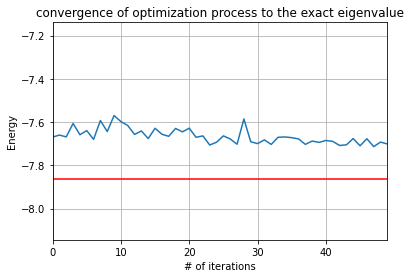

In [52]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [53]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

1it [00:00,  3.29it/s]

{'0011': 27, '1100': 71, '1000': 33, '1001': 76, '1010': 97, '0001': 81, '0101': 87, '0111': 218, '1011': 100, '1111': 114, '0100': 19, '0010': 46, '0110': 38, '1110': 17}
1.0


2it [00:00,  2.91it/s]

{'1100': 90, '1011': 13, '0100': 175, '1111': 125, '0101': 103, '1000': 111, '1001': 88, '1010': 55, '1101': 26, '0000': 99, '0010': 12, '0111': 45, '1110': 5, '0001': 54, '0110': 5, '0011': 18}
1.0


3it [00:00,  3.46it/s]

{'1101': 34, '0100': 91, '1111': 47, '0110': 143, '0111': 210, '1010': 79, '0010': 126, '0000': 34, '1001': 114, '0011': 18, '0001': 41, '1110': 15, '1011': 9, '1100': 30, '1000': 21, '0101': 12}
1.0


4it [00:01,  3.06it/s]

{'0011': 109, '0010': 55, '1011': 88, '0100': 72, '1101': 63, '1110': 25, '0001': 40, '0110': 97, '1111': 32, '1010': 185, '0101': 24, '0111': 53, '1001': 75, '1000': 36, '1100': 11, '0000': 59}
1.0


5it [00:01,  3.00it/s]

{'1011': 87, '0010': 61, '0110': 92, '1110': 25, '0001': 29, '1010': 201, '1001': 79, '0100': 73, '0000': 63, '0011': 105, '1000': 27, '1111': 32, '0111': 45, '0101': 33, '1101': 68, '1100': 4}
1.0


6it [00:02,  2.69it/s]

{'1001': 64, '1010': 174, '1111': 37, '0110': 92, '1011': 82, '0100': 73, '1101': 56, '0111': 66, '0101': 27, '0001': 46, '0011': 101, '1000': 47, '0000': 60, '0010': 64, '1110': 18, '1100': 17}
1.0


7it [00:02,  2.94it/s]

{'0101': 203, '1011': 91, '1001': 188, '0001': 180, '0011': 12, '0000': 15, '1000': 122, '1111': 40, '0111': 9, '1110': 73, '0100': 23, '0010': 50, '1100': 5, '1101': 8, '0110': 3, '1010': 2}
1.0


8it [00:02,  3.34it/s]

{'0010': 97, '1110': 87, '0101': 13, '0011': 318, '1111': 65, '0111': 71, '0001': 78, '1001': 35, '0100': 31, '0000': 43, '1101': 108, '1011': 18, '1100': 2, '1000': 44, '1010': 7, '0110': 7}
1.0


9it [00:02,  3.04it/s]

{'0111': 189, '1010': 103, '0001': 96, '0101': 81, '1111': 121, '0100': 22, '0010': 31, '1011': 97, '1100': 72, '1001': 80, '1000': 35, '0110': 37, '0011': 40, '1110': 19, '0000': 1}
1.0


10it [00:03,  3.18it/s]

{'0010': 40, '1011': 112, '1111': 100, '1001': 67, '1010': 95, '1100': 78, '0011': 32, '0111': 225, '1000': 28, '0001': 108, '1110': 14, '0101': 73, '0110': 38, '0100': 14}
1.0


11it [00:03,  3.14it/s]

{'1011': 103, '0010': 39, '1010': 96, '1100': 73, '1111': 115, '0110': 43, '1000': 28, '0101': 80, '0001': 106, '0111': 208, '1001': 79, '1110': 13, '0100': 19, '0011': 22}
1.0


12it [00:03,  3.51it/s]

{'0101': 72, '0001': 94, '1010': 76, '0110': 39, '1111': 138, '0111': 196, '1011': 113, '1100': 87, '1001': 73, '0010': 38, '1000': 34, '1110': 13, '0100': 18, '0011': 33}
1.0


14it [00:04,  3.84it/s]

{'1110': 35, '0101': 297, '1001': 112, '0001': 138, '1011': 37, '0100': 57, '1101': 57, '0111': 82, '1000': 38, '0110': 39, '0000': 61, '1010': 39, '1111': 15, '0010': 6, '1100': 7, '0011': 4}
1.0
{'0110': 49, '1111': 117, '1001': 61, '1010': 96, '0111': 195, '0101': 85, '0100': 18, '0010': 40, '0011': 36, '0001': 91, '1011': 119, '1100': 73, '1000': 34, '1110': 10}
1.0


15it [00:04,  3.81it/s]

{'0101': 86, '1011': 95, '0010': 50, '1111': 121, '0110': 52, '1010': 92, '0001': 118, '0111': 182, '1100': 63, '1000': 31, '1001': 74, '0011': 36, '0100': 15, '1110': 9}
1.0


16it [00:05,  3.05it/s]

{'1001': 66, '0001': 96, '1010': 108, '0101': 77, '0111': 202, '0010': 32, '1011': 107, '1111': 123, '0110': 35, '0011': 36, '1100': 72, '1000': 32, '1110': 17, '0100': 21}
1.0


17it [00:05,  3.30it/s]

{'0001': 92, '1001': 72, '0111': 219, '1011': 94, '0101': 100, '1111': 105, '0100': 16, '1000': 28, '0110': 49, '0011': 34, '1010': 89, '1100': 75, '0010': 37, '1110': 13, '1101': 1}
1.0


18it [00:05,  3.23it/s]

{'0001': 172, '1001': 98, '1010': 29, '0100': 64, '0101': 290, '1011': 38, '0000': 66, '1100': 4, '1101': 52, '0111': 60, '1110': 42, '0110': 34, '1000': 35, '0010': 18, '1111': 16, '0011': 6}
1.0


19it [00:05,  3.04it/s]

{'1011': 51, '1110': 42, '0101': 260, '1101': 68, '0110': 35, '1001': 100, '0001': 148, '1000': 40, '1010': 38, '0111': 59, '0000': 71, '0100': 74, '1111': 16, '0010': 11, '1100': 8, '0011': 3}
1.0


20it [00:06,  3.17it/s]

{'0100': 21, '0111': 187, '1111': 135, '1100': 73, '1010': 85, '1001': 85, '0101': 81, '1011': 103, '1000': 32, '0110': 41, '0001': 104, '0010': 39, '0011': 30, '1110': 8}
1.0


21it [00:06,  2.89it/s]

{'0011': 26, '1100': 78, '1010': 90, '1001': 82, '1000': 22, '0010': 36, '0111': 231, '0100': 25, '1111': 130, '0101': 79, '1011': 86, '0001': 88, '0110': 38, '1110': 12, '1101': 1}
1.0


22it [00:06,  3.13it/s]

{'0110': 38, '1111': 131, '0111': 222, '0101': 97, '1010': 90, '1001': 69, '1000': 34, '0010': 36, '0001': 91, '0011': 30, '1011': 86, '0100': 27, '1100': 58, '1110': 15}
1.0


23it [00:07,  2.86it/s]

{'0111': 197, '1100': 66, '0011': 38, '0001': 97, '1001': 57, '0110': 36, '1111': 134, '1011': 115, '0101': 78, '0010': 51, '0100': 25, '1010': 91, '1000': 25, '1110': 14}
1.0


24it [00:07,  3.05it/s]

{'0110': 43, '1111': 132, '1100': 69, '0111': 216, '0001': 99, '0010': 30, '1011': 96, '0101': 70, '1110': 21, '1010': 101, '1001': 76, '0011': 20, '0100': 21, '0000': 2, '1000': 28}
1.0


25it [00:07,  3.34it/s]

{'1001': 62, '1010': 97, '0001': 92, '0010': 43, '1011': 84, '0110': 41, '1111': 128, '0111': 206, '1100': 77, '1000': 35, '0011': 41, '0101': 78, '0100': 19, '1110': 19, '1101': 2}
1.0


26it [00:08,  3.41it/s]

{'1011': 104, '1111': 126, '0111': 219, '0011': 32, '1100': 61, '0001': 86, '1001': 74, '0100': 21, '1110': 14, '0101': 63, '1000': 35, '0010': 43, '1010': 99, '0110': 47}
1.0


27it [00:08,  3.24it/s]


{'1000': 43, '1111': 120, '1010': 98, '1011': 109, '0010': 30, '1100': 77, '0011': 30, '0101': 92, '0111': 188, '0100': 20, '0001': 92, '1001': 73, '1110': 12, '0110': 40}
1.0


1it [00:00,  5.18it/s]

{'1001': 102, '0001': 59, '0110': 119, '1000': 85, '0011': 36, '1011': 78, '0111': 172, '1110': 57, '0000': 13, '1111': 126, '0100': 52, '1100': 37, '1010': 9, '0101': 32, '0010': 27, '1101': 20}
1.0


2it [00:00,  2.65it/s]

{'0000': 62, '1000': 78, '0001': 89, '1001': 147, '0100': 276, '0101': 8, '1100': 95, '1011': 43, '0110': 65, '0011': 15, '1110': 41, '0111': 22, '1111': 68, '1010': 5, '1101': 9, '0010': 1}
1.0


3it [00:00,  3.12it/s]

{'0110': 356, '0101': 17, '0100': 22, '1101': 20, '0001': 71, '0000': 36, '0010': 68, '0111': 63, '1001': 157, '1010': 41, '1100': 67, '1110': 36, '0011': 51, '1111': 5, '1000': 8, '1011': 6}
1.0


4it [00:01,  3.30it/s]

{'1001': 72, '1010': 195, '0001': 59, '0100': 65, '1101': 103, '1011': 54, '0011': 39, '0101': 33, '0110': 122, '0111': 37, '0000': 39, '1000': 32, '0010': 155, '1110': 13, '1111': 1, '1100': 5}
1.0


5it [00:01,  3.66it/s]

{'0000': 29, '1010': 185, '0001': 53, '1001': 74, '0110': 129, '0100': 46, '1101': 126, '0010': 153, '1000': 35, '0011': 54, '1110': 15, '1011': 66, '0111': 28, '0101': 19, '1100': 10, '1111': 2}
1.0


6it [00:01,  3.48it/s]

{'0100': 58, '1101': 113, '0001': 44, '1010': 210, '1011': 72, '0010': 163, '1000': 28, '1100': 15, '0110': 130, '1001': 72, '0011': 28, '0111': 26, '0000': 32, '0101': 24, '1110': 9}
1.0


7it [00:02,  3.10it/s]

{'1101': 46, '1000': 155, '0001': 186, '1001': 150, '1011': 81, '0010': 55, '0101': 98, '0111': 10, '0100': 101, '1111': 38, '0000': 13, '1110': 35, '0011': 24, '0110': 21, '1010': 5, '1100': 6}
1.0


8it [00:02,  3.22it/s]

{'0100': 39, '0011': 354, '0110': 54, '1111': 48, '1000': 103, '1110': 50, '0010': 117, '0111': 22, '1101': 129, '0000': 11, '0001': 43, '0101': 32, '1001': 20, '1100': 1, '1011': 1}
1.0


9it [00:02,  3.16it/s]

{'1111': 105, '0111': 166, '1001': 102, '0001': 74, '0101': 26, '1000': 94, '0000': 12, '0010': 25, '0100': 42, '0110': 130, '1100': 40, '1011': 100, '1101': 8, '1110': 43, '0011': 43, '1010': 14}
1.0


10it [00:03,  3.18it/s]

{'0111': 158, '1001': 98, '0001': 80, '0100': 41, '1011': 92, '0010': 26, '1000': 97, '1111': 130, '0110': 111, '1100': 31, '0011': 40, '0101': 35, '1110': 50, '1101': 16, '1010': 8, '0000': 11}
1.0


11it [00:03,  3.34it/s]

{'1111': 115, '1011': 71, '0111': 165, '1100': 35, '1101': 21, '1001': 102, '0001': 62, '1110': 71, '0110': 118, '1000': 95, '0010': 28, '0101': 37, '0100': 48, '0011': 39, '0000': 10, '1010': 7}
1.0


12it [00:03,  2.89it/s]

{'0110': 115, '1101': 11, '0100': 45, '1110': 51, '0111': 163, '0001': 84, '1001': 99, '1011': 86, '0011': 45, '0101': 36, '1111': 117, '1000': 84, '1100': 37, '0010': 26, '0000': 13, '1010': 12}
1.0


13it [00:04,  3.05it/s]

{'1011': 28, '1100': 61, '1001': 98, '0111': 122, '1101': 57, '0100': 145, '0000': 49, '0110': 43, '0001': 148, '0101': 143, '1010': 53, '0011': 7, '1110': 26, '1000': 34, '0010': 1, '1111': 9}
1.0


14it [00:04,  2.78it/s]

{'0001': 63, '1001': 108, '0111': 175, '0101': 21, '1110': 51, '1000': 71, '1011': 106, '1101': 26, '0110': 125, '0000': 11, '1111': 113, '0100': 42, '0010': 25, '1100': 34, '1010': 12, '0011': 41}
1.0


15it [00:04,  2.93it/s]

{'0010': 36, '1000': 98, '0000': 10, '0111': 170, '1001': 101, '0001': 61, '1101': 19, '1110': 51, '1111': 114, '1011': 89, '0100': 39, '0110': 115, '0011': 43, '0101': 25, '1010': 13, '1100': 40}
1.0


16it [00:05,  3.10it/s]

{'0011': 40, '1100': 41, '1011': 82, '0110': 116, '1111': 116, '0001': 62, '0111': 163, '1110': 51, '1010': 12, '0100': 36, '1001': 111, '1000': 108, '1101': 17, '0101': 33, '0010': 27, '0000': 9}
1.0


17it [00:05,  3.13it/s]

{'0111': 157, '1011': 85, '1101': 14, '0100': 56, '1111': 114, '0110': 113, '1001': 107, '1110': 57, '1000': 68, '0001': 90, '1100': 40, '0010': 45, '0101': 22, '0011': 35, '0000': 10, '1010': 11}
1.0


18it [00:05,  3.27it/s]

{'0101': 156, '1101': 52, '0100': 151, '0001': 158, '1001': 90, '1000': 36, '0000': 48, '0111': 122, '1100': 63, '1010': 43, '1011': 21, '1110': 24, '0110': 43, '1111': 12, '0011': 3, '0010': 2}
1.0


19it [00:06,  3.12it/s]

{'0101': 147, '1101': 45, '0100': 141, '0001': 167, '0111': 108, '1100': 53, '0000': 61, '0110': 38, '1010': 45, '1001': 116, '1110': 28, '1111': 16, '1000': 34, '1011': 20, '0011': 3, '0010': 2}
1.0


20it [00:06,  3.15it/s]

{'0001': 60, '1001': 97, '1011': 77, '0110': 115, '1111': 108, '0111': 196, '1110': 67, '0011': 50, '1000': 86, '0101': 30, '1100': 40, '0010': 22, '1010': 7, '1101': 13, '0100': 47, '0000': 9}
1.0


21it [00:06,  3.38it/s]

{'0110': 104, '1111': 118, '0111': 177, '1110': 64, '0101': 33, '0000': 8, '1000': 80, '1001': 95, '0100': 41, '1011': 96, '0011': 40, '1100': 36, '0001': 74, '1101': 14, '1010': 14, '0010': 30}
1.0


22it [00:06,  3.37it/s]

{'0111': 183, '1110': 53, '0101': 39, '1000': 101, '0001': 64, '1111': 107, '0011': 43, '1011': 80, '0110': 115, '1100': 35, '0100': 43, '1010': 9, '1101': 14, '0000': 8, '1001': 102, '0010': 28}
1.0


23it [00:07,  3.51it/s]

{'0111': 169, '1111': 116, '1101': 15, '0000': 10, '1000': 76, '1011': 95, '1100': 36, '1001': 108, '0100': 49, '0011': 41, '0010': 26, '0001': 57, '0110': 114, '1110': 72, '0101': 28, '1010': 12}
1.0


24it [00:07,  3.48it/s]

{'0001': 71, '1010': 15, '1011': 107, '1100': 39, '0100': 38, '1110': 57, '0111': 160, '0110': 115, '0010': 29, '1111': 104, '1000': 83, '1001': 109, '0000': 15, '0011': 36, '0101': 37, '1101': 9}
1.0


25it [00:07,  3.25it/s]

{'1000': 92, '0101': 30, '1001': 104, '0110': 113, '1111': 115, '0111': 170, '0100': 36, '1011': 88, '1101': 17, '0000': 17, '0010': 30, '1100': 44, '1110': 47, '0011': 37, '0001': 70, '1010': 14}
1.0


26it [00:08,  3.17it/s]

{'1111': 119, '0110': 130, '0100': 49, '1110': 59, '0101': 24, '0111': 167, '1000': 97, '0011': 46, '1001': 105, '1011': 88, '0010': 26, '0001': 54, '1101': 11, '1100': 33, '0000': 8, '1010': 8}
1.0


27it [00:08,  3.19it/s]


{'0110': 108, '1000': 105, '0001': 64, '1001': 101, '1101': 16, '1011': 95, '0010': 29, '0111': 157, '1111': 125, '0101': 22, '1110': 62, '0100': 38, '0000': 13, '1100': 38, '1010': 8, '0011': 43}
1.0


1it [00:00,  4.13it/s]

{'0000': 23, '0011': 13, '1011': 213, '0111': 170, '1010': 100, '1001': 47, '0001': 166, '1111': 57, '0101': 44, '1000': 53, '0110': 39, '1101': 19, '0100': 23, '0010': 42, '1110': 14, '1100': 1}
1.0


2it [00:00,  3.06it/s]

{'0100': 151, '0010': 57, '1100': 42, '0011': 63, '1111': 15, '0001': 77, '0101': 80, '1000': 257, '1001': 101, '1101': 31, '0111': 52, '1010': 65, '0000': 23, '1011': 4, '0110': 6}
1.0


3it [00:00,  3.13it/s]

{'1001': 134, '1010': 171, '0100': 97, '0000': 67, '0010': 140, '0111': 152, '0110': 108, '1100': 9, '0001': 80, '0011': 35, '1011': 9, '1110': 9, '1111': 9, '1000': 2, '0101': 2}
1.0


4it [00:01,  3.44it/s]

{'0010': 52, '1110': 81, '0111': 35, '1010': 216, '0000': 121, '1111': 3, '0110': 83, '1100': 3, '0011': 91, '1000': 41, '1001': 33, '0001': 86, '0101': 53, '1011': 82, '1101': 40, '0100': 4}
1.0


5it [00:01,  3.24it/s]

{'1000': 57, '0000': 114, '1001': 42, '0001': 81, '1010': 252, '0101': 62, '1110': 73, '0011': 93, '0110': 80, '1011': 69, '0111': 26, '0010': 47, '1101': 23, '1111': 3, '1100': 1, '0100': 1}
1.0


6it [00:01,  3.01it/s]

{'0001': 83, '1001': 30, '1010': 233, '0011': 92, '1000': 57, '1110': 61, '0111': 33, '0100': 3, '1011': 70, '0110': 94, '0101': 64, '0000': 107, '0010': 46, '1101': 48, '1100': 2, '1111': 1}
1.0


7it [00:02,  3.16it/s]

{'0001': 240, '1001': 237, '0111': 77, '0000': 17, '1000': 104, '1011': 43, '0010': 68, '0100': 29, '1100': 51, '0101': 72, '1101': 16, '0110': 12, '1110': 26, '1111': 18, '0011': 11, '1010': 3}
1.0


8it [00:02,  3.11it/s]

{'0011': 288, '1110': 50, '1001': 17, '0001': 195, '0000': 16, '1000': 29, '0010': 125, '0110': 9, '1100': 30, '0111': 38, '1010': 25, '1101': 40, '1111': 103, '1011': 23, '0101': 15, '0100': 21}
1.0


9it [00:02,  3.08it/s]

{'0010': 29, '1011': 199, '1101': 21, '0100': 23, '0001': 175, '1001': 54, '1010': 133, '1100': 8, '1000': 50, '0101': 36, '0111': 160, '0011': 19, '0000': 18, '0110': 30, '1111': 56, '1110': 13}
1.0


10it [00:03,  2.82it/s]

{'0111': 181, '0100': 25, '0110': 28, '1011': 198, '1000': 48, '1010': 127, '0001': 151, '1100': 14, '0010': 46, '1111': 49, '0000': 28, '0101': 46, '1110': 16, '0011': 9, '1101': 12, '1001': 46}
1.0


11it [00:03,  2.90it/s]

{'0010': 41, '0001': 161, '1010': 127, '1101': 22, '0110': 22, '1111': 63, '0111': 168, '0011': 20, '0101': 50, '0000': 24, '1011': 191, '1001': 51, '1100': 6, '1000': 43, '0100': 27, '1110': 8}
1.0


12it [00:03,  2.91it/s]

{'0101': 46, '1110': 12, '1111': 58, '0001': 147, '1010': 124, '0111': 169, '0010': 50, '1011': 200, '0100': 30, '1001': 33, '1100': 7, '0011': 15, '1000': 57, '0110': 32, '0000': 19, '1101': 25}
1.0


13it [00:04,  2.93it/s]

{'0010': 30, '1011': 109, '0110': 51, '0000': 80, '1000': 104, '0101': 265, '0100': 20, '0001': 216, '1001': 57, '1010': 32, '0111': 24, '1110': 1, '1101': 21, '0011': 8, '1100': 3, '1111': 3}
1.0


14it [00:04,  2.98it/s]

{'1011': 236, '1001': 41, '0001': 149, '0111': 166, '1101': 19, '0100': 33, '1000': 50, '1111': 47, '0101': 52, '0010': 43, '0000': 25, '1010': 103, '1110': 12, '0110': 25, '0011': 20, '1100': 3}
1.0


15it [00:05,  2.80it/s]

{'0001': 152, '1001': 54, '1010': 115, '1011': 194, '0101': 46, '1000': 56, '0111': 175, '1111': 49, '0110': 31, '1110': 9, '0000': 21, '0100': 27, '0011': 16, '0010': 40, '1100': 17, '1101': 22}
1.0


16it [00:05,  3.00it/s]

{'1011': 185, '0111': 185, '1010': 124, '0001': 152, '0000': 27, '1000': 55, '1111': 52, '0100': 24, '0010': 47, '1101': 18, '0011': 19, '1001': 45, '1100': 6, '0110': 24, '0101': 50, '1110': 11}
1.0


17it [00:05,  3.27it/s]

{'0100': 31, '1101': 23, '1010': 124, '0001': 165, '1011': 196, '0010': 49, '0111': 159, '0000': 35, '0101': 45, '1110': 8, '0011': 8, '1000': 49, '1111': 52, '1001': 45, '1100': 9, '0110': 26}
1.0


18it [00:05,  3.12it/s]

{'0100': 36, '0101': 249, '0000': 61, '0110': 42, '1001': 61, '0001': 236, '1010': 29, '0111': 29, '1011': 118, '1000': 99, '0010': 36, '1100': 1, '1101': 17, '1111': 1, '0011': 7, '1110': 2}
1.0


19it [00:06,  3.08it/s]

{'0101': 235, '1010': 28, '1001': 57, '0001': 252, '1111': 2, '0111': 21, '1101': 16, '1011': 118, '0000': 62, '1000': 110, '0010': 35, '0100': 21, '0110': 54, '1110': 1, '1100': 4, '0011': 8}
1.0


20it [00:06,  3.04it/s]

{'0111': 155, '0101': 40, '0110': 40, '0011': 19, '0001': 178, '1010': 127, '1000': 48, '0000': 23, '1011': 192, '1111': 46, '0010': 60, '1110': 13, '1001': 40, '0100': 26, '1101': 8, '1100': 9}
1.0


21it [00:06,  3.16it/s]

{'1001': 60, '1010': 135, '0001': 179, '1000': 47, '1110': 11, '0110': 21, '0111': 162, '1011': 186, '0101': 44, '1111': 69, '1101': 20, '0100': 33, '0000': 14, '0010': 28, '0011': 10, '1100': 5}
1.0


22it [00:07,  3.48it/s]

{'1011': 201, '0010': 52, '0101': 38, '1111': 55, '0110': 30, '1001': 48, '0001': 172, '0111': 175, '1010': 108, '1101': 29, '1000': 48, '0100': 19, '0000': 22, '1110': 10, '1100': 5, '0011': 12}
1.0


23it [00:07,  3.37it/s]

{'0110': 32, '1111': 39, '1011': 201, '0111': 176, '0100': 28, '1001': 37, '0001': 155, '1000': 43, '0010': 49, '0101': 47, '1010': 136, '0000': 16, '0011': 16, '1110': 14, '1101': 29, '1100': 6}
1.0


24it [00:07,  3.47it/s]

{'1010': 142, '1100': 5, '0101': 62, '0111': 168, '0100': 25, '1101': 21, '1011': 194, '1000': 53, '0001': 159, '1111': 46, '0110': 23, '1001': 40, '0011': 17, '0010': 31, '1110': 18, '0000': 20}
1.0


25it [00:07,  3.30it/s]

{'1010': 126, '1011': 212, '0010': 43, '1111': 48, '0110': 27, '0111': 162, '0100': 29, '1000': 58, '0001': 144, '0011': 18, '1101': 16, '1001': 55, '0101': 41, '1110': 13, '0000': 22, '1100': 10}
1.0


26it [00:08,  3.20it/s]

{'1011': 212, '1111': 50, '0110': 42, '1001': 49, '0001': 141, '1010': 121, '0111': 166, '0100': 22, '0011': 19, '1000': 59, '0000': 22, '1101': 21, '0101': 39, '0010': 37, '1110': 13, '1100': 11}
1.0


27it [00:08,  3.13it/s]


{'1000': 45, '0000': 30, '0001': 167, '1001': 42, '1101': 21, '0010': 45, '0111': 183, '0110': 32, '1011': 190, '1010': 120, '1111': 43, '0011': 21, '0101': 49, '0100': 25, '1110': 9, '1100': 2}
1.0


1it [00:00,  2.74it/s]

{'1001': 180, '0001': 66, '0111': 205, '1111': 120, '0011': 35, '1011': 50, '0100': 51, '0101': 21, '1100': 60, '1110': 39, '1010': 77, '1000': 25, '0010': 29, '1101': 48, '0110': 18}
1.0


2it [00:00,  3.08it/s]

{'1100': 125, '1101': 16, '0100': 101, '1001': 134, '1010': 56, '0101': 102, '1000': 98, '0010': 15, '0001': 44, '0111': 71, '1111': 111, '0000': 67, '1011': 65, '0011': 11, '0110': 5, '1110': 3}
1.0


3it [00:00,  3.24it/s]

{'1110': 49, '0010': 102, '1001': 101, '1010': 84, '0001': 69, '0111': 202, '0000': 22, '0100': 72, '1111': 50, '1000': 32, '0110': 96, '0101': 51, '1101': 37, '0011': 13, '1011': 19, '1100': 25}
1.0


4it [00:01,  3.09it/s]

{'0011': 118, '1100': 79, '1111': 91, '1010': 91, '1001': 52, '0101': 76, '1000': 32, '0100': 17, '0110': 74, '0111': 47, '0010': 44, '1101': 162, '1110': 48, '0000': 42, '1011': 50, '0001': 1}
1.0


5it [00:01,  3.19it/s]

{'1111': 83, '0110': 88, '0010': 52, '1011': 46, '0011': 114, '0000': 49, '1000': 27, '1101': 155, '0101': 76, '1100': 79, '0111': 41, '1010': 107, '1001': 49, '1110': 47, '0100': 9, '0001': 2}
1.0


6it [00:02,  2.83it/s]

{'1010': 122, '1011': 42, '0110': 89, '0101': 72, '1110': 48, '1101': 165, '0011': 92, '0111': 50, '1001': 42, '1100': 71, '0000': 41, '1111': 77, '0100': 12, '0001': 4, '0010': 57, '1000': 40}
1.0


7it [00:02,  3.02it/s]

{'1011': 56, '0111': 56, '0101': 116, '1110': 129, '1000': 77, '1101': 166, '1111': 56, '0110': 7, '1001': 114, '0001': 112, '0010': 21, '0000': 43, '0100': 45, '0011': 22, '1010': 2, '1100': 2}
1.0


8it [00:02,  3.04it/s]

{'1011': 15, '0101': 43, '0011': 233, '0100': 91, '1101': 192, '0001': 47, '1111': 108, '0000': 62, '0010': 49, '0111': 63, '1110': 73, '1010': 8, '0110': 25, '1001': 5, '1000': 4, '1100': 6}
1.0


9it [00:02,  3.11it/s]

{'1010': 84, '1001': 174, '0110': 23, '1111': 114, '1110': 40, '0111': 204, '1101': 45, '0010': 26, '1100': 73, '0001': 55, '1000': 12, '0100': 69, '1011': 51, '0101': 32, '0011': 22}
1.0


10it [00:03,  2.92it/s]

{'0111': 223, '0001': 47, '1010': 85, '1101': 40, '0100': 56, '1111': 125, '1011': 37, '1110': 37, '0010': 23, '0011': 34, '1001': 177, '1100': 69, '1000': 25, '0110': 18, '0101': 27, '0000': 1}
1.0


11it [00:03,  3.09it/s]

{'1001': 185, '1010': 86, '0111': 204, '1011': 43, '0010': 34, '1100': 74, '0100': 52, '1110': 39, '1111': 131, '0011': 27, '1000': 20, '0001': 45, '0101': 36, '1101': 35, '0110': 12, '0000': 1}
1.0


12it [00:03,  2.96it/s]

{'0111': 216, '1100': 69, '0101': 17, '1110': 36, '1000': 20, '1010': 84, '1001': 171, '0001': 61, '1111': 113, '0100': 61, '1101': 37, '1011': 58, '0010': 35, '0110': 18, '0011': 28}
1.0


13it [00:04,  3.26it/s]

{'0101': 134, '1110': 10, '0110': 79, '0111': 122, '0011': 30, '0001': 122, '0100': 82, '1101': 136, '1010': 31, '1011': 39, '0010': 20, '1100': 8, '1000': 26, '1001': 151, '0000': 32, '1111': 2}
1.0


14it [00:04,  3.46it/s]

{'0111': 216, '0010': 19, '1010': 90, '1001': 175, '0001': 61, '0011': 31, '1100': 76, '1111': 118, '1101': 38, '1110': 40, '1011': 50, '0100': 63, '0101': 14, '1000': 19, '0110': 13, '0000': 1}
1.0


15it [00:04,  3.42it/s]

{'1110': 32, '1100': 63, '1001': 181, '1010': 94, '0100': 56, '0111': 257, '1011': 54, '1111': 98, '0001': 42, '1101': 42, '0011': 21, '0110': 12, '0010': 25, '0101': 24, '1000': 22, '0000': 1}
1.0


16it [00:05,  3.53it/s]

{'0011': 29, '1100': 59, '1010': 82, '1001': 197, '0111': 226, '1101': 26, '0100': 68, '1111': 115, '0110': 22, '0010': 36, '1110': 38, '0001': 46, '1000': 17, '1011': 37, '0101': 26}
1.0


17it [00:05,  3.52it/s]

{'1100': 58, '0111': 207, '1011': 49, '1010': 78, '1001': 208, '0001': 58, '1111': 113, '1101': 43, '0100': 56, '0011': 25, '0110': 11, '1110': 42, '0010': 32, '0101': 22, '1000': 21, '0000': 1}
1.0


18it [00:05,  3.13it/s]

{'0000': 41, '0100': 68, '0111': 107, '0010': 19, '1001': 143, '0001': 118, '0101': 132, '0011': 26, '1101': 159, '1011': 36, '0110': 93, '1010': 36, '1110': 14, '1000': 22, '1111': 4, '1100': 6}
1.0


19it [00:06,  3.20it/s]

{'1001': 135, '1010': 56, '0001': 112, '1101': 155, '0000': 33, '0111': 128, '0110': 89, '0101': 126, '0010': 16, '0100': 67, '1011': 31, '1000': 25, '1110': 10, '0011': 25, '1100': 11, '1111': 5}
1.0


20it [00:06,  3.32it/s]

{'1010': 101, '0001': 59, '1001': 182, '1111': 102, '1100': 71, '1011': 48, '0100': 59, '0111': 222, '1000': 23, '1101': 32, '1110': 30, '0011': 22, '0110': 26, '0101': 19, '0010': 26, '0000': 2}
1.0


21it [00:06,  3.51it/s]

{'0111': 214, '1001': 182, '0110': 20, '1111': 97, '1110': 42, '1100': 65, '0011': 28, '0010': 27, '0100': 67, '1010': 92, '0001': 68, '1011': 42, '1101': 36, '0101': 20, '0000': 2, '1000': 22}
1.0


22it [00:06,  3.38it/s]

{'0111': 181, '1111': 130, '0110': 23, '0100': 63, '1001': 189, '1010': 78, '1100': 66, '1011': 47, '0001': 60, '1110': 40, '0010': 24, '1000': 23, '1101': 42, '0011': 29, '0101': 27, '0000': 2}
1.0


23it [00:07,  3.19it/s]

{'0011': 27, '1100': 79, '1101': 48, '1010': 78, '1001': 173, '1111': 103, '1110': 42, '0111': 240, '0100': 51, '0110': 21, '0001': 54, '1011': 39, '0010': 23, '0101': 24, '1000': 22}
1.0


24it [00:07,  3.04it/s]

{'1010': 95, '1001': 177, '0110': 20, '1111': 116, '0111': 204, '0101': 12, '0011': 27, '1100': 72, '1101': 42, '1110': 36, '0100': 69, '1000': 18, '0001': 68, '0010': 25, '1011': 42, '0000': 1}
1.0


25it [00:07,  2.93it/s]

{'1001': 159, '1010': 82, '0111': 220, '1011': 61, '1110': 39, '0101': 29, '1100': 58, '1111': 121, '0100': 67, '0011': 31, '0001': 58, '0110': 19, '1101': 39, '0010': 27, '1000': 13, '0000': 1}
1.0


26it [00:08,  3.21it/s]

{'1010': 65, '0001': 72, '1001': 189, '1111': 112, '0100': 65, '0111': 213, '1100': 64, '1011': 44, '1101': 41, '0101': 20, '1000': 19, '1110': 36, '0010': 35, '0011': 31, '0110': 17, '0000': 1}
1.0


27it [00:08,  3.13it/s]


{'0111': 218, '1011': 46, '0001': 49, '1001': 184, '1010': 79, '0100': 75, '1000': 29, '0101': 24, '1111': 111, '1110': 37, '1100': 60, '1101': 38, '0010': 29, '0000': 1, '0011': 30, '0110': 14}
1.0


1it [00:00,  3.14it/s]

{'0111': 147, '1000': 28, '0100': 62, '0001': 177, '1001': 121, '1010': 79, '0101': 56, '1111': 138, '1011': 35, '0011': 51, '0010': 59, '1100': 47, '0110': 5, '0000': 6, '1110': 10, '1101': 3}
1.0


2it [00:00,  3.74it/s]

{'0100': 59, '1001': 70, '0001': 95, '1010': 67, '1111': 78, '0101': 121, '0000': 133, '1100': 98, '1011': 54, '1000': 60, '0111': 70, '0011': 32, '0110': 19, '1101': 26, '0010': 42}
1.0


3it [00:00,  3.67it/s]

{'0010': 66, '0111': 67, '0001': 46, '1001': 225, '0100': 13, '1100': 32, '1110': 97, '0101': 78, '1010': 127, '1101': 25, '1000': 50, '1111': 119, '1011': 19, '0110': 38, '0000': 12, '0011': 10}
1.0


4it [00:01,  3.63it/s]

{'1111': 72, '0110': 216, '0101': 192, '1110': 31, '0001': 1, '1010': 117, '1100': 59, '1000': 3, '0100': 33, '0000': 20, '1001': 103, '0010': 8, '0011': 54, '1011': 38, '0111': 39, '1101': 38}
1.0


5it [00:01,  3.22it/s]

{'1000': 5, '0110': 175, '1111': 75, '0011': 57, '1011': 28, '1110': 45, '0101': 216, '1010': 109, '0100': 33, '1101': 38, '0111': 58, '0010': 5, '1100': 60, '1001': 95, '0000': 23, '0001': 2}
1.0


6it [00:01,  3.00it/s]

{'1010': 104, '1001': 136, '0110': 187, '1111': 64, '0000': 20, '0101': 190, '0111': 49, '0011': 63, '1100': 55, '1110': 47, '1011': 30, '1101': 32, '1000': 5, '0100': 36, '0010': 6}
1.0


7it [00:02,  3.24it/s]

{'1110': 58, '0101': 325, '1011': 112, '0111': 65, '1101': 100, '0100': 64, '1010': 23, '1100': 23, '0001': 23, '1000': 50, '0010': 29, '0011': 16, '1001': 85, '0110': 25, '0000': 20, '1111': 6}
1.0


8it [00:02,  2.90it/s]

{'1101': 236, '1011': 50, '1111': 182, '0101': 52, '1110': 93, '0111': 33, '0011': 122, '1001': 49, '0100': 35, '0000': 44, '1010': 28, '0010': 34, '0001': 11, '0110': 6, '1000': 37, '1100': 12}
1.0


9it [00:02,  2.92it/s]

{'1111': 143, '0010': 67, '1011': 40, '0111': 153, '0101': 49, '1000': 29, '0001': 153, '1100': 48, '1010': 75, '1110': 16, '1101': 6, '0100': 51, '1001': 135, '0011': 51, '0110': 5, '0000': 3}
1.0


10it [00:03,  3.11it/s]

{'1011': 38, '0010': 74, '1001': 132, '1111': 133, '1000': 33, '0111': 157, '0101': 49, '0100': 62, '1010': 77, '0001': 151, '1110': 15, '0011': 49, '1100': 41, '0000': 9, '1101': 2, '0110': 2}
1.0


11it [00:03,  3.21it/s]

{'0111': 148, '1010': 69, '0001': 166, '1001': 128, '1111': 131, '0010': 74, '0101': 60, '0011': 42, '0100': 51, '1011': 46, '1000': 24, '1110': 18, '0110': 7, '1101': 7, '1100': 50, '0000': 3}
1.0


12it [00:03,  3.51it/s]

{'1100': 40, '0011': 52, '0111': 167, '0001': 145, '1001': 128, '1010': 65, '1111': 164, '0010': 60, '1011': 44, '0100': 54, '1110': 21, '0101': 53, '1000': 17, '1101': 2, '0000': 3, '0110': 9}
1.0


13it [00:03,  3.44it/s]

{'1011': 68, '0010': 14, '0001': 84, '1010': 83, '1001': 222, '1101': 193, '0100': 46, '1000': 47, '1111': 40, '0011': 16, '0111': 78, '0101': 46, '0000': 25, '1100': 26, '0110': 30, '1110': 6}
1.0


14it [00:04,  3.45it/s]

{'0111': 159, '1010': 75, '1001': 131, '0100': 61, '1100': 46, '1011': 34, '1110': 24, '1111': 132, '0001': 166, '0011': 43, '0010': 50, '1000': 25, '0000': 3, '0101': 61, '0110': 7, '1101': 7}
1.0


15it [00:04,  3.38it/s]

{'0001': 175, '1010': 65, '1001': 115, '1111': 131, '1100': 40, '0101': 59, '1011': 39, '0010': 67, '0111': 163, '1110': 19, '1000': 24, '1101': 8, '0011': 50, '0000': 9, '0100': 59, '0110': 1}
1.0


16it [00:04,  3.09it/s]

{'0111': 134, '1111': 144, '1001': 157, '0001': 155, '0100': 50, '0011': 51, '1100': 45, '1011': 37, '1000': 22, '0101': 61, '1110': 21, '0010': 76, '1010': 60, '0000': 2, '0110': 5, '1101': 4}
1.0


17it [00:05,  3.10it/s]

{'0000': 7, '0001': 167, '1010': 66, '0100': 49, '0111': 179, '1111': 143, '0101': 55, '1110': 14, '1001': 135, '1011': 39, '0010': 60, '1000': 22, '1101': 2, '0011': 47, '1100': 33, '0110': 6}
1.0


18it [00:05,  3.41it/s]

{'0101': 45, '1010': 81, '1001': 207, '1101': 199, '0100': 52, '0111': 66, '1111': 36, '1011': 66, '0001': 83, '0110': 41, '1100': 34, '0000': 28, '1000': 52, '0011': 19, '0010': 14, '1110': 1}
1.0


19it [00:05,  3.54it/s]

{'0100': 44, '1101': 200, '0001': 76, '1010': 84, '1001': 209, '0011': 17, '0101': 46, '0111': 60, '1011': 73, '1000': 55, '0000': 36, '1111': 48, '0110': 32, '1100': 30, '0010': 12, '1110': 2}
1.0


20it [00:06,  3.38it/s]

{'1011': 39, '0101': 67, '1111': 118, '0001': 166, '1001': 118, '1010': 55, '0111': 169, '1100': 43, '0010': 78, '1110': 21, '0011': 60, '1000': 27, '0100': 48, '1101': 5, '0110': 7, '0000': 3}
1.0


21it [00:06,  3.43it/s]

{'0011': 53, '1100': 51, '0111': 162, '0010': 63, '1011': 45, '1111': 129, '0100': 58, '0001': 161, '1010': 64, '0000': 9, '1001': 122, '0101': 55, '1000': 28, '1110': 13, '0110': 3, '1101': 8}
1.0


22it [00:06,  3.37it/s]

{'0001': 144, '0110': 5, '1111': 141, '0111': 161, '0100': 54, '0010': 72, '0101': 53, '0011': 52, '1010': 75, '1011': 38, '1000': 26, '1100': 45, '1001': 126, '1110': 20, '0000': 8, '1101': 4}
1.0


23it [00:06,  3.48it/s]

{'0001': 161, '1001': 150, '1110': 14, '0111': 161, '1000': 27, '1011': 29, '1100': 40, '0100': 42, '1010': 72, '1111': 140, '0010': 63, '0011': 47, '0101': 57, '1101': 6, '0000': 8, '0110': 7}
1.0


24it [00:07,  3.53it/s]

{'1111': 129, '1001': 141, '1010': 65, '0001': 194, '1011': 39, '0010': 63, '0011': 61, '0111': 152, '1100': 41, '0101': 54, '1101': 2, '0000': 7, '0100': 53, '1000': 15, '1110': 7, '0110': 1}
1.0


25it [00:07,  3.61it/s]

{'1111': 133, '0001': 153, '1001': 126, '0010': 72, '1011': 44, '0100': 57, '1000': 30, '0101': 60, '1010': 72, '0111': 167, '0011': 48, '1100': 37, '1110': 10, '0000': 4, '0110': 8, '1101': 3}
1.0
{'0111': 148, '1111': 145, '1100': 34, '0010': 65, '1110': 16, '0101': 56, '1001': 139, '1010': 66, '0011': 57, '0001': 160, '0100': 53, '1011': 49, '1000': 18, '0110': 6, '1101': 3, '0000': 9}

26it [00:07,  3.99it/s]


1.0


27it [00:07,  3.39it/s]


{'1100': 47, '0011': 63, '0111': 139, '0100': 60, '1111': 163, '0001': 157, '1001': 119, '0101': 66, '0010': 67, '1010': 69, '1110': 12, '1000': 18, '1011': 29, '0110': 6, '1101': 6, '0000': 3}
1.0


1it [00:00,  3.23it/s]

{'1100': 81, '0111': 231, '0010': 33, '1111': 132, '1001': 171, '0101': 14, '1101': 51, '0100': 51, '1000': 20, '0011': 33, '0110': 6, '1010': 82, '1110': 26, '0001': 54, '1011': 39}
1.0


2it [00:00,  3.68it/s]

{'1001': 117, '0001': 41, '1101': 20, '0100': 138, '1111': 95, '1000': 89, '1011': 57, '0111': 81, '1100': 142, '0010': 9, '0101': 90, '0110': 21, '0000': 58, '0011': 9, '1010': 56, '1110': 1}
1.0


3it [00:00,  3.81it/s]

{'1010': 67, '1001': 113, '0001': 105, '0101': 48, '1110': 82, '0010': 70, '1111': 54, '1101': 30, '1100': 29, '0110': 119, '0111': 137, '0100': 81, '0000': 15, '1000': 41, '1011': 23, '0011': 10}
1.0


4it [00:01,  3.20it/s]

{'1010': 131, '0101': 78, '1000': 55, '1111': 84, '0110': 94, '1101': 167, '0010': 58, '0111': 36, '1100': 92, '0000': 42, '0011': 85, '1110': 26, '1001': 43, '1011': 26, '0100': 7}
1.0


5it [00:01,  3.25it/s]

{'1110': 26, '0101': 81, '0000': 35, '1000': 49, '1100': 91, '1101': 138, '1010': 124, '1011': 33, '0011': 104, '0010': 68, '1001': 39, '1111': 76, '0110': 106, '0111': 29, '0100': 24, '0001': 1}
1.0


6it [00:01,  3.50it/s]

{'0011': 107, '1100': 92, '0111': 37, '1000': 38, '1010': 119, '0101': 76, '0110': 117, '1011': 23, '1101': 156, '0010': 57, '0100': 11, '1111': 76, '1001': 46, '0000': 38, '1110': 31}
1.0


7it [00:02,  3.08it/s]

{'0100': 39, '1101': 165, '0101': 116, '1110': 109, '0000': 32, '1000': 80, '0001': 135, '0111': 62, '1011': 49, '1001': 118, '0011': 37, '0010': 10, '1111': 59, '0110': 10, '1100': 1, '1010': 2}
1.0


8it [00:02,  3.18it/s]

{'1101': 212, '0100': 61, '0010': 42, '1011': 17, '0000': 67, '0011': 241, '0111': 60, '1111': 112, '1100': 5, '1110': 64, '0101': 58, '0001': 38, '1010': 7, '1001': 18, '1000': 11, '0110': 11}
1.0


9it [00:02,  3.29it/s]

{'0111': 278, '1111': 112, '1011': 33, '0010': 31, '0011': 29, '1001': 186, '1010': 67, '1110': 15, '1100': 84, '1000': 31, '0101': 17, '0110': 7, '0001': 57, '0100': 41, '1101': 35, '0000': 1}
1.0


10it [00:03,  3.20it/s]

{'0111': 261, '1010': 75, '1001': 185, '0001': 69, '1110': 22, '0100': 49, '1101': 61, '1111': 115, '1000': 17, '1100': 84, '0101': 14, '1011': 31, '0011': 16, '0010': 21, '0000': 1, '0110': 3}
1.0


11it [00:03,  3.41it/s]

{'0111': 267, '1001': 193, '1010': 72, '0100': 48, '1101': 58, '1100': 71, '1111': 110, '1110': 21, '0010': 24, '0011': 22, '0001': 58, '1000': 27, '1011': 31, '0110': 6, '0101': 14, '0000': 2}
1.0


12it [00:03,  3.08it/s]

{'0110': 8, '1111': 113, '0111': 233, '1010': 81, '1001': 211, '0100': 51, '1101': 44, '1100': 73, '1011': 43, '0101': 15, '1000': 20, '1110': 19, '0011': 25, '0001': 66, '0010': 19, '0000': 3}
1.0
{'0001': 105, '1001': 136, '1011': 49, '0010': 21, '0111': 111, '0101': 143, '0110': 66, '1101': 161, '0000': 40, '0100': 73, '0011': 25, '1111': 8, '1000': 30, '1010': 41, '1110': 15}
1.0


14it [00:04,  3.62it/s]

{'1001': 204, '0011': 27, '1100': 79, '0101': 6, '1101': 54, '0100': 60, '0111': 237, '1011': 45, '1111': 102, '1010': 65, '0010': 25, '1110': 18, '0001': 70, '1000': 19, '0110': 11, '0000': 2}
1.0


15it [00:04,  3.70it/s]

{'0010': 27, '1011': 45, '1001': 168, '1010': 78, '1111': 126, '0100': 55, '1110': 17, '0111': 266, '1101': 63, '1100': 70, '1000': 21, '0001': 53, '0011': 21, '0101': 7, '0110': 7}
1.0
{'1101': 69, '0100': 50, '1111': 120, '1001': 182, '0001': 60, '0101': 10, '0111': 240, '1100': 78, '1011': 49, '1010': 70, '0011': 30, '1000': 17, '1110': 18, '0000': 2, '0010': 21, '0110': 8}
1.0


17it [00:04,  3.65it/s]

{'0111': 223, '1001': 203, '0001': 74, '1111': 113, '0011': 21, '1100': 79, '1101': 42, '0100': 47, '0010': 41, '1010': 73, '1011': 39, '1110': 23, '1000': 26, '0110': 8, '0000': 6, '0101': 6}
1.0


18it [00:05,  3.51it/s]

{'0101': 152, '0100': 81, '1101': 162, '0001': 86, '1010': 25, '0110': 50, '1011': 45, '0111': 149, '0000': 46, '1001': 130, '1000': 37, '0010': 19, '0011': 25, '1100': 3, '1110': 12, '1111': 2}
1.0


19it [00:05,  3.71it/s]

{'1101': 141, '0100': 75, '0110': 70, '0001': 107, '1100': 2, '1110': 7, '0101': 153, '0111': 128, '1010': 38, '1011': 52, '0000': 46, '1001': 127, '1000': 32, '1111': 14, '0010': 11, '0011': 21}
1.0


20it [00:05,  3.83it/s]

{'0111': 267, '1001': 168, '1010': 86, '1111': 115, '0010': 34, '1110': 17, '0101': 17, '0100': 53, '0001': 52, '1000': 30, '1100': 71, '1101': 43, '1011': 40, '0011': 23, '0000': 1, '0110': 7}
1.0


21it [00:06,  3.31it/s]

{'0001': 62, '1001': 208, '1010': 88, '0111': 236, '0110': 7, '0011': 20, '1100': 71, '1101': 63, '1111': 119, '1000': 14, '0100': 50, '0101': 8, '0010': 27, '1011': 35, '1110': 14, '0000': 2}
1.0


22it [00:06,  3.53it/s]

{'1001': 188, '1010': 90, '0111': 248, '0100': 53, '1101': 55, '0010': 17, '1100': 86, '1111': 108, '1110': 20, '1011': 42, '0001': 47, '0110': 11, '1000': 22, '0101': 13, '0011': 21, '0000': 3}
1.0


23it [00:06,  3.17it/s]

{'1010': 76, '1001': 173, '0111': 241, '1101': 50, '1111': 119, '1100': 73, '1011': 49, '1110': 20, '1000': 17, '0001': 75, '0100': 60, '0011': 23, '0110': 9, '0010': 21, '0101': 16, '0000': 2}
1.0


24it [00:07,  3.23it/s]

{'0111': 247, '1100': 90, '0011': 25, '1111': 121, '0110': 6, '1010': 85, '0001': 48, '0100': 51, '1001': 178, '1101': 50, '1011': 33, '0101': 17, '0010': 29, '1000': 23, '1110': 19, '0000': 2}
1.0


25it [00:07,  3.03it/s]

{'1111': 122, '1010': 90, '1001': 194, '1100': 69, '0011': 38, '0111': 228, '1101': 47, '0100': 41, '1110': 17, '0001': 73, '1011': 34, '1000': 27, '0010': 21, '0101': 10, '0110': 11, '0000': 2}
1.0


26it [00:07,  3.16it/s]

{'0001': 71, '1010': 73, '1111': 105, '0111': 272, '1101': 48, '0100': 48, '0101': 13, '1110': 23, '1100': 74, '1001': 187, '0000': 3, '0110': 7, '0011': 18, '1011': 38, '0010': 26, '1000': 18}
1.0


27it [00:07,  3.39it/s]


{'0111': 231, '1010': 75, '1001': 197, '1100': 72, '1101': 62, '0100': 51, '1011': 41, '0010': 26, '0011': 22, '0001': 71, '1111': 119, '1110': 24, '1000': 19, '0101': 11, '0110': 3}
1.0


1it [00:00,  2.60it/s]

{'1010': 84, '0001': 113, '1100': 92, '0100': 53, '1101': 75, '0111': 147, '0101': 24, '1111': 128, '1000': 23, '1110': 55, '1001': 113, '1011': 77, '0010': 19, '0110': 4, '0000': 15, '0011': 2}
1.0


2it [00:00,  2.68it/s]

{'0001': 41, '1010': 68, '1001': 108, '1000': 93, '0011': 39, '1100': 150, '0100': 72, '0111': 73, '1011': 32, '0101': 97, '0000': 34, '1111': 157, '0010': 29, '1101': 21, '0110': 7, '1110': 3}
1.0


3it [00:01,  3.15it/s]

{'1011': 2, '0010': 77, '1000': 25, '0111': 201, '0101': 74, '1101': 69, '0110': 67, '1001': 151, '1110': 46, '0000': 40, '0100': 76, '1010': 69, '0001': 50, '1111': 35, '1100': 25, '0011': 17}
1.0


4it [00:01,  3.26it/s]

{'1011': 55, '0101': 162, '1101': 181, '0111': 22, '1010': 164, '1100': 67, '1111': 52, '0000': 41, '0110': 58, '1110': 39, '0010': 28, '0011': 77, '1000': 65, '1001': 8, '0100': 4, '0001': 1}
1.0


5it [00:01,  3.03it/s]

{'1010': 149, '1110': 40, '0101': 129, '0011': 83, '1100': 74, '1000': 73, '1011': 75, '1111': 50, '1101': 190, '0110': 56, '0111': 16, '0000': 42, '1001': 16, '0010': 17, '0100': 13, '0001': 1}
1.0


6it [00:01,  3.12it/s]

{'1100': 60, '0011': 93, '1010': 145, '1111': 58, '1011': 66, '0101': 141, '1000': 57, '1101': 209, '0100': 10, '0010': 22, '0110': 55, '0000': 52, '0111': 22, '1110': 23, '1001': 10, '0001': 1}
1.0


7it [00:02,  3.30it/s]

{'0001': 91, '1001': 171, '1111': 57, '0110': 20, '1000': 78, '0000': 17, '1110': 147, '0111': 93, '0101': 97, '1101': 118, '0011': 27, '0100': 33, '0010': 24, '1010': 5, '1011': 45, '1100': 1}
1.0


8it [00:02,  3.26it/s]

{'0100': 88, '1101': 219, '0010': 61, '1011': 70, '0011': 192, '0000': 60, '0101': 49, '1110': 71, '1100': 38, '0110': 24, '0111': 38, '0001': 51, '1111': 47, '1010': 7, '1000': 8, '1001': 1}
1.0


9it [00:03,  2.65it/s]

{'0100': 54, '1000': 33, '1001': 114, '0001': 123, '1011': 79, '0111': 155, '1111': 104, '1100': 107, '1101': 78, '1010': 76, '0000': 10, '1110': 47, '0101': 24, '0010': 16, '0110': 3, '0011': 1}
1.0


10it [00:03,  2.56it/s]

{'0111': 165, '1001': 113, '1010': 76, '0100': 57, '1101': 65, '1000': 40, '1111': 123, '1011': 71, '1100': 88, '0001': 116, '0010': 17, '1110': 57, '0110': 5, '0000': 16, '0101': 15}
1.0


12it [00:03,  3.28it/s]

{'0100': 60, '1101': 73, '1110': 54, '1011': 45, '1100': 93, '1001': 123, '0001': 105, '0111': 147, '1000': 37, '0110': 8, '1010': 81, '1111': 140, '0101': 13, '0011': 4, '0000': 17, '0010': 24}
1.0
{'1001': 132, '1010': 67, '1100': 81, '1101': 73, '0100': 69, '1000': 38, '0000': 11, '0010': 22, '0111': 159, '1111': 99, '0001': 119, '1011': 74, '1110': 51, '0101': 22, '0110': 7}
1.0


13it [00:04,  3.10it/s]

{'1101': 132, '0100': 73, '0001': 147, '1010': 49, '0110': 107, '0101': 110, '0111': 116, '1011': 99, '1110': 22, '1001': 74, '0000': 22, '0011': 10, '1000': 40, '1111': 4, '0010': 16, '1100': 3}
1.0


14it [00:04,  2.99it/s]

{'1010': 92, '1001': 113, '0111': 161, '0101': 20, '0100': 61, '1111': 128, '1000': 29, '1011': 66, '1100': 93, '0001': 107, '1101': 75, '0010': 13, '1110': 48, '0000': 8, '0110': 10}
1.0


15it [00:04,  3.34it/s]

{'0111': 159, '1001': 114, '0001': 122, '1010': 88, '1100': 89, '0010': 15, '1011': 68, '1111': 116, '1101': 72, '0100': 69, '0101': 16, '1110': 50, '0110': 7, '1000': 31, '0000': 8}
1.0


17it [00:05,  3.79it/s]

{'1100': 68, '1111': 139, '1101': 87, '1000': 35, '0111': 169, '0010': 16, '1011': 76, '0001': 110, '0101': 19, '0100': 64, '1001': 112, '1010': 67, '1110': 49, '0110': 7, '0000': 5, '0011': 1}
1.0
{'1010': 82, '0001': 117, '1001': 115, '1111': 132, '0111': 158, '1110': 51, '0100': 64, '1101': 69, '0010': 12, '1100': 84, '0000': 16, '0110': 8, '1011': 65, '1000': 32, '0101': 18, '0011': 1}
1.0


18it [00:05,  3.42it/s]

{'0110': 121, '0100': 74, '1101': 158, '1001': 56, '0001': 142, '0101': 108, '1011': 94, '0111': 99, '1010': 54, '0000': 30, '1000': 31, '0011': 8, '1110': 23, '0010': 19, '1111': 4, '1100': 3}
1.0


19it [00:06,  3.30it/s]

{'1000': 37, '0000': 32, '0101': 114, '0111': 110, '0011': 8, '0001': 129, '1101': 166, '1011': 83, '1110': 18, '0110': 97, '0100': 68, '1010': 66, '1001': 72, '1111': 4, '1100': 5, '0010': 15}
1.0


20it [00:06,  3.36it/s]

{'0111': 179, '1100': 89, '0100': 63, '0001': 113, '1001': 104, '1111': 128, '1011': 71, '0101': 17, '1010': 75, '0010': 18, '1101': 80, '1000': 30, '1110': 43, '0110': 6, '0000': 6, '0011': 2}
1.0


21it [00:06,  2.98it/s]

{'0111': 165, '0001': 124, '1001': 119, '1100': 60, '1011': 61, '0100': 70, '1000': 32, '1111': 125, '1110': 45, '1010': 87, '1101': 82, '0101': 14, '0000': 10, '0010': 21, '0110': 9}
1.0


22it [00:07,  3.15it/s]

{'1111': 116, '1001': 105, '0001': 127, '1010': 83, '0100': 53, '1100': 78, '0111': 164, '1011': 85, '1000': 22, '1110': 52, '0101': 20, '1101': 90, '0010': 18, '0000': 6, '0110': 5}
1.0


23it [00:07,  3.22it/s]

{'0110': 8, '0111': 137, '1110': 39, '1101': 77, '1001': 117, '0001': 118, '1010': 100, '1011': 68, '0100': 66, '1111': 126, '1000': 33, '0101': 29, '1100': 74, '0000': 8, '0010': 24}
1.0


24it [00:07,  3.52it/s]

{'1100': 80, '0111': 161, '1001': 118, '0001': 129, '1110': 45, '0100': 59, '1011': 69, '1000': 24, '1111': 125, '1010': 80, '1101': 79, '0101': 25, '0000': 11, '0110': 6, '0010': 12, '0011': 1}
1.0


25it [00:07,  3.62it/s]

{'1111': 107, '0111': 162, '1001': 130, '0001': 124, '1100': 76, '1110': 47, '0000': 8, '1000': 27, '1011': 71, '0100': 68, '1101': 89, '1010': 67, '0101': 23, '0110': 4, '0010': 20, '0011': 1}
1.0


26it [00:08,  3.49it/s]

{'0111': 162, '1010': 85, '0100': 64, '1101': 66, '0010': 10, '1011': 83, '1111': 120, '1000': 38, '1100': 92, '0001': 96, '1110': 46, '0101': 21, '1001': 123, '0000': 14, '0110': 3, '0011': 1}
1.0


27it [00:08,  3.22it/s]


{'1010': 82, '0001': 101, '1001': 114, '0111': 161, '1101': 78, '1110': 53, '1111': 130, '1000': 29, '1011': 71, '0110': 5, '1100': 89, '0100': 60, '0010': 19, '0000': 8, '0101': 22, '0011': 2}
1.0


1it [00:00,  3.36it/s]

{'0111': 194, '1001': 140, '1010': 28, '0011': 22, '0100': 136, '1111': 202, '1000': 34, '0010': 26, '1100': 38, '1110': 55, '0110': 34, '1101': 78, '1011': 18, '0101': 2, '0001': 17}
1.0


2it [00:00,  2.83it/s]

{'0101': 39, '0001': 24, '1010': 78, '0111': 186, '1100': 194, '1111': 75, '0100': 141, '1101': 81, '0110': 5, '0000': 45, '1001': 62, '1011': 68, '1110': 9, '0010': 2, '1000': 13, '0011': 2}
1.0


3it [00:00,  3.13it/s]

{'0010': 39, '1011': 13, '0110': 89, '1111': 71, '0100': 168, '0111': 250, '0101': 45, '1001': 101, '1010': 40, '0001': 65, '1110': 53, '1000': 41, '1101': 36, '0000': 4, '1100': 8, '0011': 1}
1.0


4it [00:01,  2.66it/s]

{'1100': 120, '0011': 89, '1101': 117, '1001': 52, '1011': 61, '0010': 31, '0000': 42, '1000': 22, '1010': 140, '0110': 65, '0100': 28, '1111': 93, '0111': 73, '0001': 21, '0101': 57, '1110': 13}
1.0


5it [00:01,  2.85it/s]

{'0110': 57, '1100': 116, '0000': 61, '0101': 62, '0100': 23, '1101': 105, '1010': 120, '0111': 79, '1001': 46, '0010': 35, '1011': 57, '1111': 86, '1000': 14, '1110': 23, '0011': 119, '0001': 21}
1.0


6it [00:02,  2.93it/s]

{'1111': 79, '1100': 101, '0011': 130, '0100': 29, '1101': 116, '0111': 58, '1010': 124, '0101': 66, '0110': 61, '0000': 64, '0010': 29, '1110': 13, '1001': 47, '1011': 63, '0001': 30, '1000': 14}
1.0


7it [00:02,  3.02it/s]

{'0110': 23, '1111': 46, '0011': 56, '1110': 99, '1101': 189, '1001': 125, '1011': 68, '1000': 55, '0010': 59, '0111': 70, '0101': 64, '0001': 64, '0100': 72, '0000': 33, '1010': 1}
1.0


8it [00:02,  3.28it/s]

{'0011': 236, '0001': 24, '1001': 39, '0111': 87, '0010': 57, '0100': 133, '1101': 100, '0000': 55, '1111': 82, '1110': 43, '1011': 40, '0110': 20, '1100': 5, '1010': 11, '0101': 64, '1000': 28}
1.0


9it [00:02,  3.05it/s]

{'1111': 203, '1010': 26, '1001': 134, '0001': 26, '0111': 188, '0100': 142, '1101': 88, '1100': 30, '1110': 59, '0110': 27, '1000': 39, '0011': 29, '0010': 17, '1011': 11, '0101': 3, '0000': 2}
1.0


10it [00:03,  3.08it/s]

{'0111': 191, '0010': 15, '0100': 149, '1111': 212, '1110': 68, '0011': 22, '1100': 31, '1001': 125, '1101': 78, '0110': 31, '1010': 27, '1011': 13, '0001': 25, '1000': 36, '0101': 1}
1.0


11it [00:03,  3.10it/s]

{'1001': 148, '1010': 40, '0100': 129, '1110': 38, '0101': 10, '0111': 228, '1011': 16, '1111': 192, '0110': 29, '0011': 24, '1101': 65, '0010': 9, '1100': 28, '1000': 44, '0001': 21, '0000': 3}
1.0


12it [00:03,  3.06it/s]

{'1110': 53, '0100': 133, '1101': 68, '1111': 205, '0110': 28, '0001': 22, '1010': 47, '1001': 130, '0111': 201, '1100': 41, '0011': 16, '1000': 34, '1011': 15, '0010': 26, '0101': 5}
1.0


13it [00:04,  3.27it/s]

{'0110': 154, '1111': 37, '0111': 105, '0100': 92, '1101': 116, '0101': 246, '1011': 39, '1001': 85, '0011': 40, '0000': 23, '0010': 23, '1100': 20, '1010': 19, '0001': 15, '1000': 9, '1110': 1}
1.0


14it [00:04,  2.95it/s]

{'0100': 133, '1111': 221, '0110': 24, '0011': 13, '0111': 209, '0001': 17, '1001': 144, '1000': 33, '1110': 33, '0010': 21, '1100': 37, '1101': 70, '1010': 49, '0000': 3, '1011': 16, '0101': 1}
1.0


15it [00:04,  3.07it/s]

{'0111': 197, '0100': 145, '1101': 76, '0011': 22, '1100': 37, '1110': 45, '1111': 193, '1010': 39, '1000': 33, '0010': 22, '1011': 18, '1001': 146, '0001': 15, '0110': 32, '0101': 4}
1.0


16it [00:05,  2.99it/s]

{'0111': 213, '1110': 47, '1000': 38, '1001': 156, '1101': 52, '0100': 119, '0010': 25, '0110': 41, '1111': 198, '1011': 18, '1010': 32, '0001': 23, '1100': 37, '0101': 6, '0011': 18, '0000': 1}
1.0


17it [00:05,  3.40it/s]

{'1101': 69, '0100': 148, '1111': 204, '1010': 39, '0111': 181, '1000': 29, '1100': 40, '1110': 53, '1001': 147, '0001': 26, '1011': 15, '0011': 19, '0101': 2, '0110': 33, '0010': 19}
1.0


18it [00:05,  3.37it/s]

{'0010': 14, '0111': 125, '0011': 53, '0101': 243, '0000': 25, '0110': 137, '1111': 43, '1101': 84, '1100': 15, '1011': 37, '1001': 98, '1010': 44, '0100': 81, '1000': 15, '0001': 7, '1110': 3}
1.0


19it [00:06,  3.22it/s]

{'1111': 32, '0110': 152, '0100': 77, '1101': 106, '0101': 222, '0111': 95, '1011': 55, '0000': 26, '0011': 60, '1001': 84, '1100': 25, '1000': 10, '0001': 15, '1010': 49, '0010': 14, '1110': 2}
1.0


20it [00:06,  3.37it/s]

{'0111': 209, '0110': 30, '1111': 211, '1110': 54, '0001': 31, '1001': 132, '0100': 132, '1101': 68, '1100': 21, '1011': 11, '1010': 36, '0011': 30, '1000': 40, '0010': 13, '0101': 3, '0000': 3}
1.0


21it [00:06,  3.45it/s]

{'1100': 41, '0111': 188, '1010': 33, '1001': 134, '1101': 79, '0100': 122, '1110': 45, '1111': 225, '0011': 23, '0010': 26, '0000': 2, '1000': 30, '1011': 19, '0001': 22, '0110': 30, '0101': 5}
1.0


22it [00:06,  3.40it/s]

{'1010': 34, '0001': 24, '1001': 137, '1100': 40, '1101': 72, '0100': 157, '1111': 209, '1110': 50, '0111': 188, '0101': 4, '1000': 20, '0011': 21, '1011': 18, '0110': 28, '0010': 18, '0000': 4}
1.0


23it [00:07,  3.60it/s]

{'1111': 216, '1001': 125, '0001': 24, '1000': 38, '0111': 204, '1101': 67, '0100': 148, '0010': 20, '0011': 23, '0110': 27, '1110': 44, '1010': 29, '1100': 36, '1011': 12, '0101': 8, '0000': 3}
1.0


24it [00:07,  3.34it/s]

{'0111': 213, '1101': 70, '0100': 131, '0110': 37, '1111': 218, '1001': 127, '0001': 17, '1110': 55, '1100': 30, '1000': 25, '1010': 40, '0011': 27, '0101': 2, '0010': 20, '1011': 11, '0000': 1}
1.0


25it [00:07,  3.14it/s]

{'0010': 17, '1011': 13, '1001': 142, '1111': 211, '1101': 63, '0100': 137, '1100': 34, '1110': 60, '0111': 188, '1010': 33, '0011': 28, '0110': 31, '0001': 22, '0101': 7, '1000': 37, '0000': 1}
1.0


26it [00:08,  3.33it/s]

{'1111': 250, '1101': 59, '0100': 124, '0010': 17, '1011': 19, '1001': 143, '1100': 36, '0111': 187, '0011': 23, '0110': 20, '1110': 45, '1010': 32, '1000': 38, '0001': 29, '0101': 2}
1.0
{'0111': 226, '0001': 25, '1001': 120, '1010': 39, '0011': 28, '0110': 32, '0100': 126, '1011': 14, '1101': 82, '0010': 11, '1111': 203, '1110': 47, '1000': 34, '1100': 33, '0101': 3, '0000': 1}

27it [00:08,  3.21it/s]



1.0


1it [00:00,  3.59it/s]

{'0011': 42, '1100': 159, '0100': 67, '1101': 47, '0111': 158, '1010': 57, '1001': 152, '0001': 56, '1111': 137, '0010': 30, '1110': 46, '1011': 39, '1000': 19, '0101': 4, '0110': 7, '0000': 4}
1.0


2it [00:00,  2.94it/s]

{'0111': 97, '1011': 36, '1001': 96, '1111': 226, '1100': 136, '0000': 69, '1000': 89, '0100': 94, '1010': 39, '0011': 8, '0001': 66, '0101': 42, '1110': 12, '0010': 10, '1101': 4}
1.0


3it [00:00,  3.47it/s]

{'1100': 30, '0010': 137, '1011': 12, '1000': 46, '0111': 187, '1010': 55, '0001': 107, '0110': 84, '1101': 14, '1001': 66, '0100': 108, '0101': 70, '1111': 32, '0000': 35, '1110': 23, '0011': 18}
1.0


4it [00:01,  3.51it/s]

{'1100': 97, '0011': 104, '1011': 65, '1111': 90, '1101': 145, '1010': 111, '1000': 40, '0101': 72, '0110': 49, '0010': 87, '1110': 29, '0000': 58, '1001': 40, '0111': 32, '0001': 4, '0100': 1}
1.0


5it [00:01,  3.85it/s]

{'0010': 69, '0101': 65, '1101': 150, '1111': 90, '0110': 45, '0011': 106, '1000': 44, '1010': 106, '1100': 116, '0111': 29, '1011': 72, '0000': 59, '1001': 43, '0100': 1, '1110': 26, '0001': 3}
1.0


6it [00:01,  3.72it/s]

{'0011': 97, '1100': 107, '1110': 32, '1101': 151, '0010': 80, '0111': 23, '0110': 48, '1010': 116, '1000': 46, '0000': 51, '1111': 83, '1001': 41, '1011': 71, '0101': 70, '0100': 2, '0001': 6}
1.0


7it [00:02,  3.05it/s]

{'1001': 92, '0001': 140, '1101': 148, '0101': 49, '1110': 160, '1011': 67, '0111': 65, '1111': 81, '0000': 47, '1000': 78, '1010': 17, '0010': 28, '0100': 19, '0110': 23, '0011': 9, '1100': 1}
1.0


8it [00:02,  3.22it/s]

{'0101': 94, '1110': 50, '0011': 293, '0110': 46, '1111': 59, '1001': 21, '0100': 104, '0000': 93, '1101': 106, '0010': 45, '0111': 42, '0001': 46, '1011': 3, '1010': 10, '1100': 6, '1000': 6}
1.0


9it [00:02,  2.98it/s]

{'1111': 117, '0011': 39, '1100': 167, '0100': 61, '1001': 145, '0111': 142, '0010': 39, '1011': 53, '0001': 68, '1010': 72, '1000': 17, '0110': 14, '1101': 47, '1110': 37, '0101': 3, '0000': 3}
1.0


10it [00:03,  3.33it/s]

{'1000': 14, '1011': 47, '1110': 41, '1100': 141, '1001': 144, '0001': 61, '0111': 166, '1101': 52, '0100': 56, '1111': 130, '0011': 42, '0010': 40, '1010': 64, '0110': 15, '0101': 7, '0000': 4}
1.0


11it [00:03,  3.46it/s]

{'1111': 140, '0111': 141, '0100': 60, '1101': 53, '1010': 59, '0001': 86, '0011': 43, '1100': 132, '1011': 45, '1110': 38, '1001': 161, '0110': 16, '0010': 25, '1000': 18, '0101': 6, '0000': 1}
1.0


12it [00:03,  3.17it/s]

{'1100': 140, '0111': 160, '1001': 131, '1010': 66, '0010': 48, '1011': 58, '1111': 118, '1110': 42, '1101': 48, '0011': 34, '0110': 17, '0100': 73, '0001': 74, '1000': 13, '0000': 2}
1.0


13it [00:03,  3.50it/s]

{'1101': 90, '0100': 82, '1001': 98, '0001': 132, '0101': 122, '1110': 31, '0111': 142, '0110': 157, '0011': 36, '1010': 25, '1000': 15, '0010': 25, '1011': 20, '0000': 46, '1111': 2, '1100': 1}
1.0


14it [00:04,  3.53it/s]

{'0100': 60, '1111': 158, '1110': 38, '1100': 145, '0011': 26, '1001': 145, '0111': 160, '1011': 64, '0110': 14, '0001': 51, '0010': 37, '1101': 34, '1010': 70, '0101': 5, '1000': 15, '0000': 2}
1.0


15it [00:04,  3.31it/s]

{'0100': 55, '0011': 43, '1100': 144, '0111': 166, '1011': 46, '1001': 133, '1010': 72, '1111': 134, '0001': 59, '1110': 52, '0110': 12, '1101': 50, '1000': 15, '0010': 35, '0000': 5, '0101': 3}
1.0


16it [00:04,  3.46it/s]

{'1100': 146, '1001': 136, '1101': 62, '0100': 49, '0010': 36, '1011': 62, '1111': 136, '0111': 139, '1010': 70, '0011': 35, '1110': 48, '0110': 14, '0001': 62, '1000': 18, '0000': 6, '0101': 5}
1.0


17it [00:04,  3.59it/s]

{'0111': 139, '0100': 59, '1101': 43, '1100': 150, '0001': 69, '1001': 150, '1011': 58, '1111': 144, '1010': 61, '0010': 24, '0011': 41, '1110': 57, '1000': 12, '0110': 12, '0000': 4, '0101': 1}
1.0


18it [00:05,  3.34it/s]

{'0110': 167, '1101': 74, '0100': 90, '1001': 100, '0001': 141, '1000': 9, '0111': 162, '0011': 31, '0101': 123, '0010': 21, '0000': 46, '1100': 1, '1011': 17, '1110': 14, '1010': 26, '1111': 2}
1.0


19it [00:05,  3.52it/s]

{'0101': 119, '0111': 134, '0001': 155, '1011': 17, '0110': 161, '0000': 43, '1000': 17, '0100': 93, '1010': 18, '1001': 96, '1101': 89, '1110': 26, '0010': 26, '0011': 25, '1111': 5}
1.0


20it [00:05,  3.48it/s]

{'1001': 153, '1010': 69, '1111': 134, '0010': 36, '1100': 137, '0111': 149, '1110': 56, '0100': 60, '0110': 14, '0011': 35, '1101': 54, '1000': 18, '0001': 62, '1011': 41, '0000': 4, '0101': 2}
1.0


21it [00:06,  3.40it/s]

{'1100': 139, '1010': 69, '1001': 150, '0111': 154, '1011': 46, '1101': 48, '0101': 2, '1110': 51, '1000': 17, '0010': 32, '0100': 54, '1111': 139, '0011': 40, '0001': 69, '0110': 13, '0000': 1}
1.0


22it [00:06,  3.45it/s]

{'1101': 58, '0100': 52, '1001': 144, '1010': 58, '1100': 139, '0011': 41, '0010': 39, '1111': 144, '1011': 44, '0001': 65, '0111': 157, '1110': 45, '0110': 20, '1000': 9, '0101': 6, '0000': 3}
1.0


23it [00:06,  3.32it/s]

{'0001': 50, '1010': 66, '0110': 23, '1111': 127, '1101': 58, '0100': 70, '0111': 151, '0010': 38, '1001': 148, '1000': 19, '1100': 131, '1011': 51, '0011': 42, '1110': 43, '0101': 5, '0000': 2}
1.0


24it [00:07,  3.38it/s]

{'0010': 44, '1100': 156, '0001': 69, '1001': 126, '1010': 73, '1111': 148, '0111': 156, '1110': 42, '1101': 46, '0011': 26, '1011': 41, '0100': 63, '0110': 15, '0101': 5, '0000': 3, '1000': 11}
1.0


25it [00:07,  3.61it/s]

{'1011': 53, '0010': 40, '1001': 140, '0001': 67, '1010': 53, '1100': 148, '0011': 29, '1111': 156, '1110': 53, '0110': 13, '0111': 143, '1101': 50, '0101': 3, '0100': 61, '0000': 8, '1000': 7}
1.0


26it [00:07,  3.87it/s]

{'0010': 39, '1011': 40, '0111': 150, '1100': 153, '0011': 46, '0100': 43, '0110': 16, '1001': 131, '1111': 161, '0001': 79, '1110': 57, '1010': 64, '1101': 35, '0000': 2, '0101': 1, '1000': 7}
1.0


27it [00:07,  3.43it/s]


{'0011': 39, '1100': 150, '1010': 62, '1001': 141, '0001': 62, '1111': 136, '0111': 165, '1011': 51, '1110': 55, '0010': 37, '1000': 10, '1101': 49, '0110': 14, '0100': 52, '0101': 1}
1.0


1it [00:00,  5.01it/s]

{'0001': 53, '1001': 139, '1010': 111, '0011': 11, '1100': 160, '0100': 80, '0111': 136, '0101': 63, '1110': 23, '0010': 25, '0110': 55, '1101': 10, '1000': 78, '1111': 51, '0000': 28, '1011': 1}
1.0
{'0000': 45, '1000': 109, '1100': 114, '0111': 141, '1110': 50, '0101': 107, '1111': 92, '1001': 158, '0001': 38, '0100': 52, '1010': 21, '1011': 59, '0011': 17, '0110': 17, '0010': 4}
1.0


3it [00:00,  3.91it/s]

{'1001': 136, '1100': 90, '1000': 59, '1111': 64, '1011': 25, '0010': 47, '1101': 9, '0111': 123, '1110': 29, '0110': 24, '0000': 46, '0100': 125, '0001': 101, '0101': 105, '0011': 15, '1010': 26}
1.0


4it [00:01,  3.44it/s]

{'0100': 105, '1101': 141, '1100': 37, '0011': 134, '0101': 98, '1010': 71, '1001': 92, '1000': 140, '1111': 80, '1011': 7, '0110': 20, '0111': 37, '0000': 31, '0010': 14, '1110': 15, '0001': 2}
1.0


5it [00:01,  3.52it/s]

{'0111': 50, '1000': 179, '1101': 128, '0100': 108, '0101': 105, '1111': 71, '1100': 26, '0011': 112, '1010': 71, '1001': 90, '0110': 21, '0000': 21, '1110': 21, '0010': 11, '0001': 3, '1011': 7}
1.0


6it [00:01,  3.39it/s]

{'0111': 54, '0100': 90, '1101': 132, '1001': 111, '0101': 126, '1000': 151, '0011': 129, '1111': 86, '0010': 9, '1010': 52, '0110': 20, '1110': 16, '0000': 18, '1100': 27, '1011': 2, '0001': 1}
1.0


7it [00:01,  3.51it/s]

{'1110': 109, '0101': 143, '1000': 210, '1010': 46, '1100': 16, '0011': 16, '0110': 50, '1111': 34, '0111': 59, '0001': 62, '1001': 61, '1011': 41, '0100': 28, '0000': 30, '1101': 79, '0010': 40}
1.0


8it [00:02,  3.65it/s]

{'1110': 51, '0101': 38, '1011': 36, '0011': 49, '0000': 138, '1000': 55, '0100': 120, '0001': 61, '1101': 201, '1010': 24, '0010': 117, '1001': 23, '0110': 45, '1111': 48, '0111': 17, '1100': 1}
1.0


9it [00:02,  3.69it/s]

{'0111': 136, '1010': 70, '1001': 166, '0010': 17, '0110': 61, '1111': 68, '1100': 164, '1000': 75, '1110': 29, '0001': 78, '0101': 52, '0000': 19, '0100': 71, '0011': 1, '1101': 11, '1011': 6}
1.0


11it [00:02,  4.03it/s]

{'0101': 75, '1100': 157, '1111': 50, '0110': 58, '1000': 58, '1010': 108, '1001': 177, '0111': 125, '0100': 82, '1110': 27, '0001': 51, '0011': 10, '0010': 16, '0000': 19, '1101': 10, '1011': 1}
1.0
{'1001': 184, '1100': 141, '0111': 121, '0010': 20, '1110': 17, '1000': 71, '0100': 83, '0110': 76, '0001': 65, '1010': 95, '1111': 50, '0000': 16, '0101': 66, '0011': 7, '1101': 9, '1011': 3}
1.0


12it [00:03,  3.65it/s]

{'0100': 82, '1100': 199, '0110': 56, '1111': 41, '0000': 21, '1010': 81, '1001': 171, '0111': 115, '1000': 83, '0001': 50, '0101': 68, '1101': 10, '0010': 19, '0011': 4, '1110': 18, '1011': 6}
1.0


13it [00:03,  3.44it/s]

{'0110': 215, '1110': 35, '0101': 61, '0000': 93, '1101': 110, '0100': 83, '0011': 29, '0001': 65, '1001': 105, '1011': 69, '1111': 12, '1000': 89, '0111': 46, '1010': 7, '1100': 1, '0010': 4}
1.0


14it [00:03,  3.70it/s]

{'1111': 49, '0110': 57, '1000': 60, '1100': 163, '1010': 99, '1001': 159, '0101': 65, '1110': 31, '1101': 14, '0111': 126, '0100': 79, '0011': 3, '0001': 61, '0010': 29, '0000': 26, '1011': 3}
1.0


15it [00:04,  3.85it/s]

{'1010': 99, '1001': 180, '0001': 58, '1111': 51, '0110': 59, '0111': 105, '1100': 159, '0101': 59, '0100': 83, '1110': 31, '1000': 68, '0010': 27, '0000': 24, '1011': 2, '1101': 15, '0011': 4}
1.0


16it [00:04,  3.38it/s]

{'0111': 114, '1111': 53, '0100': 91, '1001': 179, '0001': 62, '1100': 174, '0000': 19, '0010': 18, '0110': 59, '1010': 91, '0101': 54, '1101': 7, '1000': 66, '1110': 28, '0011': 7, '1011': 2}
1.0


17it [00:04,  3.59it/s]

{'0001': 72, '1010': 90, '1001': 175, '1100': 158, '0100': 72, '0101': 64, '1111': 53, '1000': 70, '1110': 35, '0111': 125, '0010': 23, '0110': 55, '1101': 9, '0000': 17, '1011': 2, '0011': 4}
1.0


18it [00:04,  3.65it/s]

{'0110': 226, '0101': 74, '0100': 73, '1101': 132, '1000': 108, '0000': 105, '0011': 31, '0001': 55, '1011': 44, '1111': 10, '1001': 86, '1110': 28, '1010': 6, '0111': 43, '1100': 1, '0010': 2}
1.0


19it [00:05,  3.48it/s]

{'1000': 86, '0110': 216, '0001': 70, '1110': 34, '0010': 5, '1011': 72, '0100': 85, '1101': 130, '0000': 102, '1001': 77, '0111': 49, '0011': 25, '0101': 54, '1010': 6, '1111': 11, '1100': 2}
1.0


20it [00:05,  3.41it/s]

{'0110': 62, '1100': 163, '1010': 103, '1001': 170, '1000': 62, '0101': 65, '0010': 24, '0111': 122, '0000': 18, '0001': 62, '1110': 32, '1111': 52, '0100': 72, '0011': 6, '1101': 6, '1011': 5}
1.0
{'1100': 147, '0000': 22, '1000': 72, '1111': 66, '0001': 67, '1010': 88, '1001': 172, '0010': 23, '1110': 22, '0111': 129, '0101': 66, '0100': 73, '0110': 57, '1101': 12, '0011': 7, '1011': 1}
1.0


22it [00:05,  3.80it/s]

{'1001': 179, '1010': 85, '0110': 61, '1100': 178, '0111': 116, '0101': 58, '1110': 35, '0000': 20, '0100': 95, '1000': 68, '1111': 40, '0001': 52, '1101': 11, '0010': 20, '0011': 2, '1011': 4}
1.0


23it [00:06,  3.90it/s]

{'1010': 83, '0001': 66, '1001': 182, '0111': 114, '0100': 86, '1100': 173, '0110': 62, '1000': 48, '1110': 26, '0010': 27, '1101': 18, '1111': 49, '0101': 61, '0000': 19, '1011': 2, '0011': 8}
1.0


24it [00:06,  4.03it/s]

{'0101': 77, '1000': 60, '1010': 105, '1111': 39, '0110': 55, '1011': 7, '0111': 132, '1101': 15, '0000': 23, '0001': 56, '1100': 142, '0100': 70, '1001': 180, '0011': 7, '1110': 35, '0010': 21}
1.0


25it [00:06,  3.84it/s]

{'0110': 67, '0000': 16, '0001': 60, '1010': 67, '1001': 177, '1100': 168, '1101': 9, '0111': 145, '0100': 84, '1110': 35, '1111': 51, '1000': 57, '0101': 63, '0010': 22, '0011': 1, '1011': 2}
1.0


26it [00:07,  3.53it/s]

{'1001': 160, '1010': 91, '1100': 173, '1111': 46, '0110': 74, '0111': 125, '0000': 25, '0100': 67, '0101': 62, '1110': 40, '1000': 64, '1101': 9, '0010': 18, '0001': 64, '1011': 3, '0011': 3}
1.0


27it [00:07,  3.68it/s]


{'0001': 60, '1001': 167, '0101': 63, '0111': 145, '0110': 47, '1111': 54, '1000': 72, '0000': 18, '1010': 93, '1100': 165, '1101': 9, '0100': 75, '0010': 20, '1110': 27, '0011': 6, '1011': 3}
1.0


1it [00:00,  3.70it/s]

{'1100': 175, '0110': 102, '1111': 38, '0111': 250, '0101': 140, '1110': 52, '0010': 21, '1011': 9, '1010': 30, '1001': 26, '0100': 118, '1000': 27, '0011': 6, '0001': 20, '1101': 5, '0000': 5}
1.0


2it [00:00,  3.55it/s]

{'0111': 215, '0011': 16, '1100': 73, '0100': 90, '1111': 168, '0101': 215, '1000': 55, '1001': 33, '0110': 53, '0001': 12, '1110': 32, '0010': 9, '1101': 15, '1011': 16, '0000': 12, '1010': 10}
1.0


3it [00:00,  4.08it/s]

{'1100': 94, '1110': 33, '0101': 258, '0100': 75, '0111': 283, '0110': 34, '1111': 91, '1001': 37, '0001': 14, '1101': 7, '0010': 14, '1010': 55, '0000': 13, '0011': 2, '1011': 6, '1000': 8}
1.0


4it [00:01,  3.62it/s]

{'0011': 191, '1010': 45, '0001': 34, '1001': 112, '1111': 46, '0110': 39, '0111': 123, '1000': 72, '0101': 141, '1101': 33, '1100': 24, '0010': 8, '0000': 55, '1110': 37, '1011': 15, '0100': 49}
1.0


5it [00:01,  3.78it/s]

{'0111': 106, '1010': 38, '1001': 104, '1110': 40, '0101': 145, '1011': 26, '0011': 192, '1000': 67, '1101': 34, '1111': 42, '0110': 61, '1100': 22, '0100': 43, '0010': 9, '0001': 44, '0000': 51}
1.0


6it [00:01,  3.93it/s]

{'1111': 55, '0110': 53, '1001': 123, '0000': 52, '1000': 62, '0101': 153, '0100': 44, '0111': 113, '0010': 5, '0011': 190, '1101': 38, '0001': 33, '1011': 19, '1010': 34, '1100': 22, '1110': 28}
1.0


7it [00:01,  4.05it/s]

{'0001': 121, '0101': 140, '0100': 55, '1011': 38, '0010': 108, '1000': 127, '1111': 13, '0111': 136, '1110': 74, '1001': 18, '1010': 57, '0000': 30, '0110': 44, '1101': 13, '0011': 34, '1100': 16}
1.0


8it [00:02,  4.03it/s]

{'0110': 58, '1111': 83, '0000': 141, '1000': 44, '0111': 86, '1100': 12, '0001': 64, '0010': 97, '0100': 112, '0011': 76, '1010': 21, '1101': 100, '0101': 43, '1011': 37, '1001': 10, '1110': 40}
1.0


9it [00:02,  3.94it/s]

{'1111': 38, '0110': 98, '0101': 158, '1110': 49, '0010': 29, '0111': 232, '1010': 35, '0100': 105, '1001': 39, '1100': 180, '0011': 11, '1000': 21, '0000': 3, '1011': 15, '0001': 11}
1.0


10it [00:02,  3.41it/s]

{'0111': 240, '0110': 135, '1100': 170, '1010': 33, '1110': 38, '0101': 145, '0010': 24, '1101': 2, '1111': 38, '0100': 90, '1001': 44, '0011': 6, '0001': 12, '0000': 6, '1000': 28, '1011': 13}
1.0


11it [00:02,  3.60it/s]

{'0001': 15, '1010': 39, '1001': 34, '0101': 162, '0110': 110, '1111': 36, '1101': 7, '0111': 217, '1011': 15, '1100': 178, '1110': 46, '0100': 97, '0011': 10, '1000': 25, '0010': 22, '0000': 11}
1.0


12it [00:03,  3.23it/s]

{'1110': 65, '0101': 147, '1001': 28, '1010': 48, '0111': 252, '1111': 44, '0110': 108, '1100': 161, '0100': 103, '0000': 4, '0001': 14, '0010': 20, '1000': 21, '1011': 4, '0011': 4, '1101': 1}
1.0


13it [00:03,  3.53it/s]

{'0110': 266, '1000': 61, '1101': 160, '0100': 137, '1001': 10, '0111': 125, '1110': 48, '0101': 123, '1111': 19, '0000': 13, '0011': 15, '1011': 21, '0001': 13, '0010': 4, '1010': 7, '1100': 2}
1.0


14it [00:03,  3.79it/s]

{'1111': 38, '0110': 122, '0111': 247, '1110': 42, '1011': 7, '1010': 33, '1100': 173, '0100': 117, '0000': 10, '0101': 144, '0010': 21, '1001': 30, '1000': 25, '0001': 13, '0011': 1, '1101': 1}
1.0


15it [00:04,  3.89it/s]

{'1010': 43, '1001': 31, '0111': 226, '1011': 13, '0110': 125, '1100': 180, '0100': 104, '0101': 123, '0001': 17, '1110': 61, '1000': 31, '0011': 5, '0010': 19, '1101': 2, '1111': 36, '0000': 8}
1.0


16it [00:04,  3.89it/s]

{'1100': 175, '0100': 101, '0111': 231, '0001': 15, '0000': 13, '1110': 39, '0101': 143, '0110': 131, '1111': 44, '1000': 30, '0010': 23, '1010': 40, '1001': 28, '1011': 6, '0011': 4, '1101': 1}
1.0


17it [00:04,  3.93it/s]

{'1001': 35, '0111': 238, '0101': 141, '1100': 174, '1111': 30, '0110': 108, '0010': 26, '1011': 9, '1110': 46, '0100': 129, '0011': 10, '1000': 26, '1010': 35, '0001': 11, '0000': 6}
1.0


18it [00:04,  3.38it/s]

{'1110': 41, '0101': 101, '1101': 187, '1111': 15, '0110': 244, '0000': 22, '1010': 12, '0111': 128, '1000': 66, '0001': 12, '0100': 134, '1011': 28, '1001': 12, '0011': 18, '0010': 3, '1100': 1}
1.0
{'0111': 139, '0100': 121, '1101': 154, '1111': 22, '0110': 251, '1011': 23, '0101': 128, '1110': 42, '1000': 57, '0001': 22, '1010': 13, '0000': 19, '0011': 20, '1001': 10, '1100': 2, '0010': 1}
1.0


20it [00:05,  3.62it/s]

{'0111': 248, '0010': 25, '0101': 160, '0100': 102, '1001': 39, '1100': 167, '0011': 7, '1000': 29, '1110': 44, '1011': 8, '0001': 12, '1010': 31, '0110': 103, '0000': 6, '1111': 40, '1101': 3}
1.0


21it [00:05,  3.65it/s]

{'0101': 135, '1110': 42, '1100': 184, '0110': 119, '0111': 247, '1010': 34, '1001': 33, '0100': 108, '1111': 36, '0001': 17, '1011': 13, '1000': 22, '0011': 5, '0010': 20, '0000': 8, '1101': 1}
1.0


22it [00:05,  3.81it/s]

{'1111': 36, '0110': 103, '1100': 182, '0100': 99, '0001': 15, '1010': 31, '0101': 165, '0111': 250, '1001': 36, '1110': 39, '1000': 31, '0010': 17, '1011': 6, '0000': 4, '0011': 5, '1101': 5}
1.0


23it [00:06,  3.65it/s]

{'0010': 23, '1000': 26, '1111': 42, '1110': 49, '0101': 142, '0100': 101, '0111': 265, '0011': 6, '1011': 8, '1010': 50, '0110': 119, '1100': 136, '1001': 33, '0000': 3, '0001': 18, '1101': 3}
1.0


24it [00:06,  3.85it/s]

{'0111': 240, '1111': 44, '0110': 115, '1110': 33, '0101': 162, '0100': 110, '1100': 165, '0010': 22, '0000': 10, '1001': 27, '1000': 26, '0011': 8, '1010': 39, '0001': 10, '1011': 12, '1101': 1}
1.0


25it [00:06,  3.84it/s]

{'0111': 239, '1100': 167, '0100': 119, '1011': 7, '1110': 38, '0101': 163, '0110': 100, '1001': 47, '1111': 29, '0001': 13, '1000': 29, '0010': 22, '1010': 39, '0011': 5, '0000': 3, '1101': 4}
1.0


26it [00:06,  3.91it/s]

{'1111': 44, '0110': 105, '1010': 56, '1001': 38, '1100': 164, '0100': 108, '1000': 27, '0111': 221, '0101': 149, '1110': 53, '1011': 10, '0010': 13, '0001': 18, '0000': 7, '0011': 9, '1101': 2}
1.0


27it [00:07,  3.77it/s]


{'1100': 163, '0101': 149, '1111': 34, '0110': 119, '0111': 233, '0100': 120, '1010': 51, '1011': 9, '1110': 48, '0000': 11, '0010': 21, '0001': 11, '1001': 36, '1000': 15, '0011': 4}
1.0


1it [00:00,  4.63it/s]

{'0111': 192, '1111': 51, '0110': 118, '0101': 169, '1010': 88, '1001': 18, '0100': 169, '1100': 59, '1000': 49, '0001': 37, '1011': 29, '1110': 18, '1101': 21, '0011': 2, '0010': 4}
1.0


2it [00:00,  3.03it/s]

{'0101': 286, '1000': 95, '0100': 64, '1100': 62, '0111': 298, '0010': 18, '1011': 18, '1001': 45, '1010': 22, '1101': 5, '0110': 21, '1111': 33, '1110': 28, '0001': 16, '0011': 9, '0000': 4}
1.0


3it [00:00,  3.55it/s]

{'1100': 53, '0111': 219, '1101': 99, '0110': 31, '1001': 76, '1110': 24, '0101': 152, '0010': 49, '1111': 175, '0100': 45, '1010': 53, '0011': 3, '1000': 15, '0000': 18, '1011': 8, '0001': 4}
1.0


4it [00:01,  3.49it/s]

{'0101': 191, '0011': 162, '1111': 43, '0111': 128, '0100': 68, '1101': 33, '1000': 72, '1001': 45, '1110': 46, '0000': 11, '0001': 101, '1100': 8, '0010': 13, '1010': 84, '0110': 17, '1011': 2}
1.0


5it [00:01,  3.44it/s]

{'0011': 163, '1100': 12, '0101': 173, '0100': 64, '1010': 75, '0001': 94, '1000': 55, '0110': 25, '1110': 51, '1001': 45, '0010': 14, '1111': 44, '0111': 159, '1011': 4, '1101': 34, '0000': 12}
1.0


6it [00:01,  3.60it/s]

{'0110': 23, '0001': 78, '1010': 88, '1001': 42, '0101': 163, '1000': 80, '0111': 153, '0011': 175, '1111': 46, '1110': 48, '0010': 9, '1101': 36, '0100': 61, '0000': 7, '1100': 14, '1011': 1}
1.0


7it [00:01,  3.55it/s]

{'0110': 78, '0011': 89, '0001': 59, '0101': 183, '1110': 65, '0111': 73, '0100': 78, '1101': 33, '1000': 135, '1100': 29, '0010': 85, '1001': 32, '1011': 22, '0000': 42, '1111': 6, '1010': 15}
1.0


8it [00:02,  3.42it/s]

{'0101': 39, '0000': 167, '0100': 60, '1101': 182, '1100': 25, '0011': 84, '0010': 55, '0111': 30, '1010': 32, '0110': 83, '1110': 81, '1111': 60, '1001': 29, '1011': 80, '1000': 8, '0001': 9}
1.0


9it [00:02,  3.70it/s]

{'0100': 138, '0111': 204, '0001': 41, '1010': 90, '1110': 14, '0101': 165, '0110': 147, '1100': 48, '1000': 58, '1001': 16, '1011': 34, '1101': 23, '1111': 39, '0011': 3, '0010': 4}
1.0


10it [00:02,  3.62it/s]

{'0111': 218, '1010': 90, '1001': 30, '0100': 132, '1100': 63, '0110': 125, '1111': 36, '0101': 165, '1011': 26, '1101': 14, '1000': 51, '1110': 20, '0001': 51, '0010': 2, '0011': 1}
1.0


11it [00:03,  3.81it/s]

{'0111': 205, '0001': 39, '1010': 111, '1011': 27, '1110': 21, '0101': 167, '0100': 140, '0110': 108, '1000': 55, '1100': 60, '1001': 26, '1111': 34, '1101': 28, '0010': 3}
1.0


12it [00:03,  3.54it/s]

{'0101': 195, '1100': 59, '0001': 33, '1010': 107, '0110': 111, '0111': 212, '0100': 124, '1000': 44, '1110': 22, '1111': 37, '1001': 25, '1011': 27, '1101': 19, '0010': 6, '0000': 1, '0011': 2}
1.0


13it [00:03,  3.46it/s]

{'1000': 93, '0000': 46, '1110': 27, '0100': 92, '1101': 216, '0111': 77, '0110': 174, '1001': 29, '0010': 4, '0101': 58, '0011': 7, '1100': 28, '0001': 11, '1111': 81, '1011': 64, '1010': 17}
1.0


14it [00:03,  3.52it/s]

{'0101': 185, '1110': 25, '0100': 139, '1111': 43, '0110': 135, '1100': 58, '1000': 42, '0111': 207, '1011': 20, '1010': 81, '1001': 29, '1101': 16, '0001': 43, '0010': 1}
1.0


15it [00:04,  3.66it/s]

{'1011': 24, '1101': 16, '0100': 150, '0111': 237, '0110': 109, '0101': 161, '1100': 52, '1010': 90, '1111': 30, '1000': 59, '1001': 18, '0001': 51, '1110': 16, '0010': 9, '0011': 2}
1.0


16it [00:04,  3.26it/s]

{'0001': 48, '1010': 86, '0100': 135, '0111': 228, '1100': 49, '1011': 16, '0101': 162, '1000': 43, '0110': 129, '1101': 20, '1110': 22, '1111': 52, '0010': 5, '1001': 26, '0011': 3}
1.0


17it [00:04,  3.47it/s]

{'0111': 223, '0100': 162, '1101': 30, '0001': 38, '1010': 92, '0101': 146, '1100': 55, '1000': 54, '0110': 131, '1110': 25, '1111': 28, '1001': 17, '1011': 17, '0010': 6}
1.0


18it [00:05,  3.64it/s]

{'0110': 173, '1000': 76, '0000': 70, '0111': 76, '0101': 67, '0100': 116, '1101': 231, '1100': 19, '1111': 70, '1011': 54, '1110': 26, '1010': 9, '0011': 5, '0001': 13, '1001': 17, '0010': 2}
1.0


19it [00:05,  3.64it/s]

{'0111': 85, '1111': 76, '0110': 183, '1101': 236, '0000': 42, '1000': 73, '1010': 9, '0010': 6, '0100': 95, '1011': 48, '1110': 28, '1100': 28, '0101': 62, '1001': 26, '0001': 17, '0011': 10}
1.0


20it [00:05,  3.57it/s]

{'0111': 219, '1000': 54, '0100': 130, '0101': 164, '1001': 25, '1010': 84, '1100': 72, '0110': 127, '1111': 48, '1101': 17, '0001': 41, '1011': 26, '1110': 13, '0010': 4}
1.0


21it [00:05,  3.33it/s]

{'1111': 34, '0110': 121, '0111': 203, '1010': 96, '0001': 52, '1011': 21, '1000': 53, '1110': 13, '0101': 171, '0100': 132, '1100': 69, '1101': 20, '0010': 3, '1001': 31, '0011': 4, '0000': 1}
1.0


22it [00:06,  3.50it/s]

{'0111': 215, '0110': 129, '0101': 157, '1011': 28, '0001': 41, '1010': 92, '1100': 60, '0100': 141, '1000': 54, '1110': 19, '1111': 45, '1001': 23, '1101': 15, '0010': 3, '0011': 2}
1.0


24it [00:06,  3.84it/s]

{'0111': 221, '0101': 165, '0001': 43, '1010': 101, '1100': 66, '1101': 22, '0100': 141, '0110': 99, '1011': 19, '0010': 4, '1111': 35, '1110': 16, '1000': 60, '0011': 2, '1001': 30}
1.0
{'1111': 50, '0110': 119, '0111': 224, '1100': 60, '1010': 67, '0100': 146, '0101': 170, '1000': 70, '1101': 23, '0001': 36, '1001': 13, '1011': 22, '1110': 15, '0010': 7, '0011': 2}
1.0


25it [00:07,  3.77it/s]

{'0101': 170, '0001': 29, '1010': 79, '0110': 136, '1011': 24, '0111': 209, '0100': 159, '1100': 72, '1101': 28, '1001': 24, '1000': 40, '1110': 12, '1111': 36, '0010': 5, '0000': 1}
1.0


26it [00:07,  3.59it/s]

{'1100': 64, '1000': 47, '1010': 83, '0001': 52, '0111': 215, '0101': 176, '0100': 137, '0110': 127, '1011': 24, '1111': 42, '1101': 17, '1110': 12, '1001': 24, '0010': 4}
1.0


27it [00:07,  3.54it/s]


{'1100': 62, '0001': 56, '1010': 85, '1011': 27, '0100': 130, '0101': 163, '0111': 210, '0110': 130, '1111': 41, '1000': 63, '1110': 16, '1101': 13, '1001': 24, '0010': 4}
1.0


1it [00:00,  3.20it/s]

{'1100': 124, '1011': 18, '1110': 69, '0110': 55, '1111': 115, '0111': 203, '1101': 21, '1010': 42, '0010': 65, '1000': 44, '0000': 50, '0101': 161, '0011': 34, '0100': 19, '1001': 3, '0001': 1}
1.0


2it [00:00,  2.25it/s]

{'1111': 154, '0101': 262, '1000': 73, '0000': 100, '1100': 92, '0111': 102, '1001': 21, '0010': 28, '1010': 3, '1110': 36, '0100': 59, '1101': 32, '0110': 31, '0001': 18, '0011': 7, '1011': 6}
1.0


3it [00:01,  2.73it/s]

{'0101': 159, '1111': 105, '0111': 270, '1001': 43, '1010': 121, '0010': 33, '0100': 57, '1100': 112, '0110': 21, '1000': 36, '1110': 42, '1101': 9, '0011': 2, '0001': 10, '1011': 4}
1.0


4it [00:01,  3.11it/s]

{'1001': 75, '1010': 30, '1110': 58, '1100': 20, '0011': 136, '0110': 104, '0000': 32, '1011': 68, '0010': 22, '0111': 83, '0100': 81, '1111': 91, '1000': 88, '0001': 56, '0101': 79, '1101': 1}
1.0
{'1010': 47, '0001': 64, '0101': 92, '1011': 64, '0011': 122, '0111': 94, '1000': 96, '1111': 110, '0000': 32, '0110': 89, '0100': 66, '1110': 49, '1001': 49, '1100': 19, '0010': 30, '1101': 1}
1.0


6it [00:01,  3.40it/s]

{'0101': 87, '1111': 101, '0110': 95, '1001': 55, '1000': 104, '0000': 31, '0100': 63, '0011': 126, '1011': 64, '0010': 26, '1010': 41, '0111': 96, '1100': 15, '0001': 64, '1110': 53, '1101': 3}
1.0


7it [00:02,  3.68it/s]

{'1110': 56, '0101': 225, '1001': 83, '0001': 75, '0011': 47, '1000': 61, '0000': 97, '0111': 72, '1100': 45, '0100': 27, '0010': 41, '1011': 37, '0110': 27, '1101': 33, '1010': 86, '1111': 12}
1.0


8it [00:02,  3.78it/s]

{'0000': 85, '1000': 72, '0111': 100, '1001': 32, '1010': 68, '1111': 138, '1110': 65, '1101': 62, '1100': 26, '0100': 47, '0001': 62, '1011': 41, '0010': 63, '0110': 42, '0101': 34, '0011': 87}
1.0


9it [00:02,  3.57it/s]

{'1110': 74, '0010': 70, '0011': 30, '1100': 136, '0111': 192, '0110': 58, '1111': 115, '0000': 45, '0101': 164, '1000': 40, '1101': 20, '1010': 34, '0100': 21, '1001': 8, '1011': 16, '0001': 1}
1.0


10it [00:02,  3.63it/s]

{'0111': 195, '1111': 132, '0110': 64, '0010': 54, '1110': 74, '0101': 167, '1001': 9, '1101': 22, '0000': 46, '0100': 15, '1100': 131, '1010': 36, '0011': 29, '1000': 35, '1011': 15}
1.0


11it [00:03,  3.73it/s]

{'1111': 121, '1110': 64, '0101': 156, '1100': 145, '0100': 19, '0010': 71, '1010': 35, '0111': 186, '0000': 50, '0011': 44, '0110': 41, '1000': 51, '1001': 6, '1011': 15, '1101': 19, '0001': 1}
1.0


12it [00:03,  3.78it/s]

{'1111': 112, '1010': 26, '1001': 6, '0101': 175, '0000': 47, '0100': 21, '0010': 68, '1100': 118, '0110': 54, '0011': 33, '0111': 196, '1110': 78, '0001': 2, '1101': 20, '1000': 51, '1011': 17}
1.0


13it [00:03,  3.86it/s]

{'0100': 81, '1101': 226, '0111': 100, '0101': 163, '1111': 26, '0110': 138, '0000': 27, '1000': 125, '1110': 52, '1011': 15, '0011': 7, '1001': 39, '1010': 19, '0001': 3, '1100': 1, '0010': 2}
1.0


14it [00:04,  3.55it/s]

{'1111': 105, '1010': 38, '1100': 114, '1110': 75, '0101': 182, '0111': 188, '0010': 56, '1101': 28, '1000': 47, '1001': 11, '1011': 21, '0100': 19, '0011': 42, '0110': 69, '0000': 29}
1.0


15it [00:04,  3.59it/s]

{'1100': 123, '0000': 41, '0101': 176, '1110': 87, '1111': 115, '0110': 58, '0111': 202, '0010': 58, '0100': 14, '1010': 43, '1000': 43, '1101': 19, '0011': 27, '1011': 12, '1001': 5, '0001': 1}
1.0


16it [00:04,  3.27it/s]

{'1000': 46, '1100': 126, '1011': 23, '0111': 207, '1110': 68, '0101': 162, '0100': 24, '1111': 117, '1010': 42, '0011': 27, '0010': 63, '0000': 39, '0110': 62, '1101': 15, '0001': 1, '1001': 2}
1.0


17it [00:04,  3.38it/s]

{'0010': 70, '0101': 175, '1110': 64, '0110': 68, '1111': 104, '1100': 130, '0111': 183, '1000': 49, '0011': 39, '0000': 41, '1011': 22, '1101': 14, '1010': 36, '0100': 23, '1001': 5, '0001': 1}
1.0


18it [00:05,  3.29it/s]

{'0100': 71, '1101': 199, '0110': 150, '0101': 148, '1000': 132, '0000': 24, '0111': 115, '1010': 28, '1110': 54, '1001': 35, '1011': 13, '1111': 34, '0010': 6, '0011': 14, '0001': 1}
1.0


19it [00:05,  3.59it/s]

{'0100': 71, '1101': 199, '0111': 130, '1010': 25, '0101': 156, '1110': 66, '1000': 124, '0110': 145, '1001': 36, '0000': 26, '1111': 29, '1011': 12, '0011': 5}
1.0


20it [00:05,  3.82it/s]

{'0101': 171, '1010': 45, '1111': 110, '0110': 41, '0010': 64, '1100': 140, '0111': 207, '0100': 24, '0000': 41, '0011': 35, '1011': 17, '1110': 70, '1000': 34, '1101': 15, '1001': 9, '0001': 1}
1.0


21it [00:06,  3.64it/s]

{'0011': 46, '1100': 114, '0101': 158, '0111': 191, '1000': 42, '0010': 67, '1111': 112, '0110': 64, '1101': 16, '1110': 82, '0100': 24, '0000': 47, '1010': 33, '1011': 18, '1001': 10}
1.0


22it [00:06,  3.31it/s]

{'1111': 115, '0111': 180, '0000': 44, '1000': 46, '0101': 168, '1110': 72, '0100': 23, '1100': 121, '1010': 34, '0110': 64, '0010': 72, '0011': 35, '1101': 22, '1011': 23, '1001': 4, '0001': 1}
1.0


23it [00:06,  3.38it/s]

{'1010': 44, '1111': 112, '0110': 42, '0101': 177, '1100': 112, '0010': 61, '0111': 203, '0000': 49, '1110': 72, '0100': 17, '1000': 52, '0011': 35, '1011': 25, '1101': 16, '1001': 7}
1.0


24it [00:06,  3.46it/s]

{'0101': 182, '1110': 77, '0000': 51, '1000': 50, '0111': 185, '1010': 35, '0110': 54, '1111': 101, '0100': 21, '1100': 117, '0010': 67, '0011': 30, '1011': 22, '1101': 28, '1001': 4}
1.0


25it [00:07,  3.54it/s]

{'0011': 50, '1100': 128, '0111': 208, '1010': 36, '0100': 28, '1111': 116, '0110': 60, '0000': 30, '1000': 45, '0010': 52, '0101': 161, '1110': 74, '1011': 16, '1101': 14, '1001': 6}
1.0


26it [00:07,  3.44it/s]

{'1111': 150, '0110': 55, '0101': 155, '1110': 83, '1100': 129, '0111': 192, '0010': 70, '0100': 18, '1010': 35, '0011': 27, '0000': 33, '1001': 5, '1000': 34, '1011': 19, '1101': 19}
1.0


27it [00:07,  3.43it/s]


{'1110': 79, '0101': 189, '0010': 71, '0111': 202, '1111': 114, '1101': 18, '1001': 8, '1010': 35, '1100': 100, '0011': 37, '0000': 39, '1000': 44, '0110': 43, '0100': 25, '1011': 20}
1.0


1it [00:00,  3.25it/s]

{'0111': 243, '1111': 69, '0110': 225, '1001': 33, '1010': 38, '1100': 92, '1110': 31, '0101': 127, '0100': 31, '1011': 44, '1101': 32, '0010': 30, '0001': 11, '1000': 4, '0011': 12, '0000': 2}
1.0


2it [00:00,  4.06it/s]

{'0110': 172, '1111': 169, '0101': 186, '0111': 199, '0010': 21, '1101': 9, '1010': 31, '1000': 57, '0000': 18, '0100': 45, '1100': 51, '1110': 30, '1011': 12, '0011': 23, '1001': 1}
1.0


3it [00:00,  3.68it/s]

{'0101': 243, '1111': 113, '0110': 212, '0010': 19, '1100': 45, '0111': 175, '1010': 67, '0000': 17, '1011': 14, '1000': 14, '1110': 68, '0100': 12, '1001': 15, '0011': 3, '0001': 4, '1101': 3}
1.0


4it [00:01,  3.56it/s]

{'1001': 88, '1010': 121, '0001': 24, '1110': 44, '0101': 86, '0111': 107, '0110': 150, '0011': 151, '1101': 66, '1000': 21, '1111': 20, '1011': 27, '0000': 18, '0010': 70, '0100': 22, '1100': 9}
1.0


5it [00:01,  3.42it/s]

{'0111': 113, '1011': 23, '0010': 97, '0110': 158, '1100': 22, '0011': 152, '1110': 25, '0101': 86, '1101': 58, '0001': 27, '0100': 25, '1001': 73, '1010': 99, '1111': 27, '1000': 24, '0000': 15}
1.0


6it [00:01,  2.76it/s]

{'0010': 95, '0101': 89, '0000': 17, '1111': 25, '0110': 123, '0011': 182, '0100': 29, '0001': 26, '1001': 85, '1010': 94, '0111': 109, '1101': 56, '1000': 27, '1110': 34, '1100': 10, '1011': 23}
1.0


7it [00:02,  2.86it/s]

{'0111': 212, '0011': 58, '1000': 62, '0000': 95, '0110': 37, '0100': 60, '0010': 107, '1011': 111, '1101': 38, '0101': 68, '1010': 26, '1111': 23, '1110': 73, '0001': 25, '1100': 12, '1001': 17}
1.0


8it [00:02,  2.91it/s]

{'1110': 77, '0101': 113, '0111': 76, '0010': 149, '1011': 53, '0110': 40, '0100': 43, '0011': 108, '0001': 62, '1111': 107, '0000': 78, '1000': 20, '1010': 55, '1101': 38, '1001': 2, '1100': 3}
1.0


9it [00:02,  3.28it/s]

{'0011': 12, '1100': 120, '1111': 64, '0110': 235, '0101': 132, '0111': 210, '1010': 36, '1001': 37, '0001': 10, '0010': 20, '0100': 29, '1110': 35, '1101': 40, '1011': 39, '1000': 5}
1.0


10it [00:03,  3.58it/s]

{'0101': 129, '1111': 80, '0110': 238, '0100': 27, '1101': 39, '1100': 107, '0111': 214, '1010': 44, '1011': 41, '1110': 29, '1001': 35, '0001': 12, '0011': 8, '0010': 16, '1000': 5}
1.0


11it [00:03,  3.42it/s]

{'1110': 41, '0101': 136, '1100': 94, '1010': 26, '1101': 51, '0111': 215, '0110': 226, '1111': 76, '1001': 37, '0100': 27, '1011': 33, '0010': 24, '1000': 6, '0011': 23, '0001': 7, '0000': 2}
1.0


12it [00:03,  3.30it/s]

{'0111': 235, '1001': 24, '1010': 40, '1110': 31, '0101': 123, '0110': 226, '0011': 16, '1100': 105, '1011': 35, '0100': 24, '1101': 38, '1111': 85, '0010': 24, '0001': 12, '1000': 6}
1.0


13it [00:03,  3.54it/s]

{'0111': 313, '0100': 161, '1101': 89, '1011': 48, '1000': 29, '1010': 4, '0101': 23, '0110': 139, '1110': 92, '1001': 25, '1100': 8, '1111': 39, '0010': 8, '0011': 22, '0000': 14, '0001': 10}
1.0


14it [00:04,  3.27it/s]

{'0101': 127, '0111': 231, '1100': 108, '1010': 36, '1101': 57, '1111': 69, '0110': 236, '1011': 30, '0010': 16, '1001': 26, '0011': 18, '0100': 21, '1110': 28, '0000': 2, '0001': 9, '1000': 10}
1.0


15it [00:04,  3.27it/s]

{'0111': 222, '0011': 19, '1100': 111, '0110': 235, '1010': 34, '1001': 30, '0101': 115, '0100': 21, '1111': 91, '1110': 33, '1000': 6, '1011': 34, '0010': 25, '1101': 42, '0001': 5, '0000': 1}
1.0


16it [00:04,  3.35it/s]

{'0111': 227, '0110': 211, '1111': 84, '1010': 34, '1100': 119, '0101': 121, '1110': 46, '0010': 21, '1001': 23, '0100': 24, '0001': 8, '1101': 33, '1000': 7, '0011': 18, '1011': 47, '0000': 1}
1.0


17it [00:05,  3.43it/s]

{'1011': 44, '0010': 26, '0110': 237, '1111': 80, '0101': 96, '0111': 247, '1010': 31, '1100': 108, '1101': 41, '0000': 3, '1001': 28, '1110': 41, '0100': 20, '0011': 12, '1000': 6, '0001': 4}
1.0


18it [00:05,  3.49it/s]

{'0111': 309, '1001': 24, '0000': 14, '1111': 35, '0110': 121, '1110': 84, '0100': 185, '1011': 40, '1010': 9, '0010': 9, '1101': 100, '0011': 19, '1100': 15, '0101': 21, '1000': 34, '0001': 5}
1.0


19it [00:05,  3.38it/s]

{'1110': 82, '0100': 162, '1011': 55, '0010': 11, '0111': 334, '1111': 44, '0110': 124, '0011': 18, '0000': 6, '1100': 14, '0001': 10, '1001': 23, '1010': 9, '1101': 84, '1000': 33, '0101': 15}
1.0


20it [00:05,  3.46it/s]

{'1011': 39, '0011': 14, '1100': 108, '0101': 130, '0110': 232, '1111': 82, '0111': 202, '1101': 51, '1001': 40, '1010': 28, '1110': 37, '0010': 21, '0001': 8, '0100': 24, '1000': 7, '0000': 1}
1.0


21it [00:06,  3.61it/s]

{'0110': 224, '0111': 224, '1110': 42, '0101': 149, '1010': 25, '1101': 48, '0100': 35, '1100': 88, '1111': 69, '0010': 29, '1011': 29, '1001': 34, '0011': 15, '0001': 7, '1000': 5, '0000': 1}
1.0


22it [00:06,  3.48it/s]

{'1100': 124, '1111': 73, '0110': 230, '0100': 16, '0111': 228, '0010': 23, '1011': 31, '0101': 130, '1001': 39, '1101': 31, '1010': 32, '0001': 8, '0011': 15, '1000': 8, '1110': 36}
1.0


23it [00:06,  3.58it/s]

{'1011': 32, '1111': 75, '0110': 238, '0111': 234, '1001': 35, '1000': 11, '0100': 32, '1101': 37, '0101': 121, '1100': 96, '0011': 14, '1110': 42, '0010': 24, '1010': 24, '0000': 1, '0001': 8}
1.0


24it [00:07,  3.52it/s]

{'0111': 236, '1001': 25, '1010': 46, '1100': 100, '0100': 22, '1110': 34, '0110': 227, '1111': 81, '1101': 32, '0101': 127, '1011': 34, '0011': 15, '0010': 24, '0001': 12, '1000': 6, '0000': 3}
1.0


25it [00:07,  3.79it/s]

{'1110': 46, '0101': 108, '1011': 40, '0010': 24, '0111': 221, '0110': 246, '1001': 32, '1100': 97, '1111': 88, '1101': 39, '1010': 35, '0100': 25, '0001': 6, '1000': 8, '0000': 1, '0011': 8}
1.0


26it [00:07,  3.11it/s]

{'0011': 15, '0010': 25, '1011': 46, '0111': 235, '1111': 83, '0110': 217, '0101': 115, '1010': 37, '1101': 31, '0001': 8, '1110': 49, '1001': 30, '1100': 99, '0100': 30, '1000': 3, '0000': 1}
1.0


27it [00:08,  3.37it/s]


{'0111': 214, '0101': 119, '1110': 34, '0100': 31, '1101': 41, '1100': 96, '1011': 32, '0001': 10, '0110': 256, '1111': 87, '1000': 6, '0011': 12, '1010': 38, '1001': 31, '0010': 16, '0000': 1}
1.0


1it [00:00,  3.57it/s]

{'1100': 174, '1111': 5, '0110': 121, '0111': 197, '0100': 207, '1010': 27, '1001': 44, '1110': 35, '0101': 88, '1101': 42, '0010': 23, '0001': 6, '0000': 12, '0011': 8, '1000': 32, '1011': 3}
1.0


2it [00:00,  2.63it/s]

{'1001': 24, '0111': 292, '0100': 103, '1101': 86, '0101': 160, '0110': 49, '1111': 138, '1000': 74, '0000': 29, '1100': 22, '0001': 10, '1010': 2, '0011': 6, '1110': 15, '0010': 7, '1011': 7}
1.0


3it [00:01,  2.79it/s]

{'0111': 248, '0101': 334, '1110': 45, '1100': 113, '1010': 48, '0100': 43, '1000': 42, '1111': 57, '0010': 9, '0000': 9, '1101': 15, '1001': 27, '0001': 13, '0110': 15, '0011': 6}
1.0


4it [00:01,  2.77it/s]

{'0011': 152, '1100': 14, '0001': 65, '1001': 124, '0101': 130, '1011': 22, '1000': 56, '0111': 116, '1010': 14, '1110': 22, '0000': 37, '0100': 95, '1101': 89, '0110': 69, '1111': 17, '0010': 2}
1.0


5it [00:01,  3.15it/s]

{'0000': 43, '0101': 133, '0111': 134, '0100': 74, '0001': 74, '0011': 137, '0110': 71, '1111': 13, '1001': 96, '1010': 21, '1000': 59, '1011': 29, '1110': 15, '1101': 110, '1100': 9, '0010': 6}
1.0


6it [00:01,  3.45it/s]

{'0101': 112, '1110': 26, '1100': 12, '0011': 145, '0100': 82, '1101': 120, '0111': 125, '0001': 51, '0000': 47, '1001': 90, '0110': 81, '1010': 22, '1011': 29, '1000': 65, '1111': 12, '0010': 5}
1.0


7it [00:02,  3.36it/s]

{'0101': 123, '1000': 131, '0010': 155, '1101': 55, '0100': 115, '1111': 34, '0110': 88, '0111': 82, '1110': 56, '0011': 36, '0001': 61, '1010': 59, '0000': 16, '1100': 1, '1011': 10, '1001': 2}
1.0


8it [00:02,  3.53it/s]

{'1010': 11, '0100': 146, '0010': 133, '1110': 64, '1111': 57, '0000': 133, '0011': 54, '1100': 32, '1000': 103, '1101': 34, '0101': 111, '0001': 29, '0111': 63, '1001': 6, '1011': 30, '0110': 18}
1.0


9it [00:02,  3.27it/s]

{'0010': 16, '1110': 39, '0101': 88, '1100': 165, '0110': 129, '1101': 42, '0100': 209, '0111': 181, '0000': 20, '1001': 35, '1010': 32, '1000': 32, '1011': 11, '0011': 12, '1111': 8, '0001': 5}
1.0


10it [00:03,  3.08it/s]

{'1000': 27, '0110': 94, '1100': 187, '0111': 199, '0101': 99, '0100': 189, '1101': 51, '0010': 15, '1110': 44, '1010': 35, '1111': 7, '1001': 43, '0011': 12, '0000': 7, '1011': 9, '0001': 6}
1.0


11it [00:03,  3.32it/s]

{'1100': 170, '1101': 53, '0100': 194, '0111': 193, '0110': 115, '1111': 11, '0101': 90, '1010': 42, '0010': 16, '1001': 48, '1011': 4, '1000': 30, '1110': 29, '0000': 15, '0001': 5, '0011': 9}
1.0


12it [00:03,  3.33it/s]

{'1101': 59, '0100': 228, '1100': 156, '1110': 41, '0101': 77, '0111': 211, '0110': 118, '1001': 28, '1010': 33, '0011': 14, '0010': 11, '1000': 23, '0000': 7, '1011': 8, '1111': 6, '0001': 4}
1.0


13it [00:03,  3.49it/s]

{'1000': 68, '0000': 15, '1110': 120, '0101': 93, '0110': 222, '0100': 154, '1100': 24, '0111': 169, '1101': 70, '1111': 18, '0011': 19, '1001': 36, '0001': 11, '1010': 2, '0010': 2, '1011': 1}
1.0


14it [00:04,  3.32it/s]

{'1100': 169, '1101': 57, '0100': 198, '1001': 49, '0111': 195, '0110': 121, '1110': 27, '0000': 13, '1010': 30, '1011': 8, '0101': 99, '1000': 30, '0011': 11, '0010': 10, '0001': 4, '1111': 3}
1.0


15it [00:04,  3.09it/s]

{'0000': 9, '1000': 28, '1100': 183, '0111': 210, '0110': 111, '1110': 32, '1011': 5, '0010': 13, '1001': 42, '0100': 215, '1010': 31, '0101': 80, '1101': 45, '1111': 5, '0011': 11, '0001': 4}
1.0


16it [00:04,  3.44it/s]

{'1001': 40, '1010': 33, '0100': 219, '0111': 184, '1110': 40, '0101': 81, '1100': 168, '0110': 127, '1000': 25, '1101': 43, '0011': 6, '0000': 19, '0010': 17, '1011': 11, '1111': 8, '0001': 3}
1.0


17it [00:05,  3.38it/s]

{'1101': 46, '0100': 222, '1111': 4, '0110': 135, '1100': 165, '1011': 12, '0101': 80, '0111': 187, '1010': 36, '1000': 33, '1001': 43, '1110': 24, '0000': 14, '0010': 11, '0011': 10, '0001': 2}
1.0


18it [00:05,  3.12it/s]

{'1101': 81, '0100': 164, '0110': 236, '1001': 31, '1100': 28, '0111': 137, '0101': 99, '1110': 127, '1000': 57, '1010': 10, '0011': 12, '1111': 14, '0010': 2, '0000': 10, '1011': 5, '0001': 11}
1.0


19it [00:06,  2.87it/s]

{'1101': 75, '0100': 160, '0000': 20, '0110': 238, '0111': 159, '1001': 43, '1110': 119, '0101': 85, '1111': 10, '1000': 63, '1100': 26, '0001': 7, '0010': 2, '0011': 13, '1011': 2, '1010': 2}
1.0


20it [00:06,  2.95it/s]

{'0011': 8, '1100': 164, '0110': 118, '0100': 223, '0111': 197, '1110': 32, '1001': 37, '0000': 16, '0101': 75, '1000': 37, '1101': 50, '0010': 14, '1010': 39, '1111': 4, '1011': 7, '0001': 3}
1.0


21it [00:06,  3.05it/s]

{'0111': 216, '0100': 215, '0101': 73, '0011': 11, '1100': 176, '1000': 24, '0110': 113, '1001': 41, '1010': 34, '1101': 47, '1110': 30, '0010': 13, '1111': 4, '1011': 14, '0001': 4, '0000': 9}
1.0


22it [00:06,  3.03it/s]

{'0100': 222, '0111': 211, '0110': 110, '0101': 84, '1110': 34, '1100': 152, '1011': 13, '1001': 31, '1000': 21, '0000': 19, '1101': 63, '1111': 6, '1010': 30, '0010': 20, '0001': 2, '0011': 6}
1.0


23it [00:07,  3.02it/s]

{'1010': 27, '1001': 40, '1100': 191, '1110': 35, '1101': 47, '1000': 33, '0000': 7, '0111': 209, '0110': 90, '0100': 200, '1111': 9, '0011': 9, '0101': 82, '0001': 7, '0010': 25, '1011': 13}
1.0


24it [00:07,  3.14it/s]

{'0101': 75, '1101': 52, '0100': 227, '1100': 168, '0111': 189, '1001': 41, '0110': 118, '0000': 12, '1000': 22, '1010': 30, '1110': 41, '0010': 21, '0011': 7, '1011': 14, '1111': 2, '0001': 5}
1.0


25it [00:07,  3.05it/s]

{'0011': 16, '1100': 174, '0101': 84, '1110': 40, '0110': 128, '0111': 172, '1101': 53, '0100': 205, '1011': 12, '1111': 4, '1001': 46, '0010': 28, '1010': 30, '1000': 16, '0000': 15, '0001': 1}
1.0


26it [00:08,  3.26it/s]

{'1110': 38, '1100': 185, '0111': 216, '0100': 204, '1010': 32, '1001': 43, '0010': 18, '0110': 100, '1111': 4, '0101': 80, '1101': 43, '1000': 26, '0011': 13, '1011': 7, '0000': 14, '0001': 1}
1.0


27it [00:08,  3.20it/s]


{'0101': 105, '0111': 204, '1100': 167, '1010': 32, '1001': 34, '1111': 7, '0100': 210, '1101': 55, '1110': 30, '0110': 115, '0000': 9, '0001': 6, '0011': 11, '1011': 5, '0010': 12, '1000': 22}
1.0


2it [00:00,  3.81it/s]

{'0010': 37, '0001': 56, '1010': 64, '0100': 175, '0101': 63, '1110': 35, '1100': 150, '0111': 151, '1000': 38, '1111': 28, '0110': 79, '0000': 39, '1101': 16, '0011': 32, '1001': 51, '1011': 10}
1.0
{'0111': 242, '0000': 144, '1101': 21, '1111': 138, '1100': 43, '0010': 35, '1001': 69, '0101': 144, '1000': 25, '1011': 29, '0100': 69, '1010': 28, '0110': 20, '1110': 12, '0001': 3, '0011': 2}
1.0


3it [00:00,  4.10it/s]

{'0001': 26, '1001': 59, '0010': 108, '0000': 38, '1111': 55, '0101': 273, '1100': 63, '0111': 164, '0100': 52, '1000': 79, '1010': 27, '0110': 18, '1011': 11, '1110': 32, '1101': 15, '0011': 4}
1.0


4it [00:01,  3.46it/s]

{'1000': 25, '0101': 105, '1110': 16, '1001': 123, '1010': 68, '0111': 102, '1100': 16, '0100': 150, '0110': 91, '1111': 51, '0000': 12, '1101': 57, '0001': 72, '0010': 36, '0011': 91, '1011': 9}
1.0


5it [00:01,  3.09it/s]

{'0110': 69, '1010': 67, '0001': 89, '0000': 11, '0011': 90, '0100': 150, '1110': 12, '0010': 30, '0111': 84, '0101': 93, '1111': 47, '1001': 143, '1000': 40, '1101': 58, '1011': 15, '1100': 26}
1.0


6it [00:01,  2.88it/s]

{'0111': 96, '0001': 91, '1001': 145, '0100': 168, '1111': 40, '1110': 17, '0101': 92, '0011': 97, '0000': 6, '1101': 48, '1010': 60, '0110': 75, '0010': 41, '1100': 15, '1000': 28, '1011': 5}
1.0


7it [00:02,  2.91it/s]

{'1110': 107, '0101': 188, '1000': 134, '0110': 97, '0010': 94, '1011': 55, '1010': 39, '0100': 107, '0011': 80, '0111': 29, '0000': 41, '0001': 16, '1111': 27, '1001': 4, '1100': 2, '1101': 4}
1.0


8it [00:02,  3.00it/s]

{'1000': 36, '0000': 108, '0010': 145, '1110': 67, '0001': 75, '0100': 215, '0111': 111, '1100': 34, '0101': 15, '1001': 34, '1101': 72, '1111': 52, '0110': 10, '0011': 31, '1011': 15, '1010': 4}
1.0


9it [00:02,  2.87it/s]

{'1000': 27, '0000': 62, '1100': 157, '1010': 70, '0001': 66, '1001': 44, '0111': 132, '0100': 167, '1111': 25, '0101': 72, '0011': 45, '1011': 15, '0110': 61, '1101': 18, '1110': 37, '0010': 26}
1.0


10it [00:03,  2.94it/s]

{'1110': 41, '0100': 177, '0111': 153, '1000': 27, '1011': 11, '0011': 48, '1010': 59, '0110': 74, '1100': 134, '0101': 74, '1001': 41, '0000': 56, '0010': 43, '1111': 19, '0001': 55, '1101': 12}
1.0


11it [00:03,  2.94it/s]

{'0111': 129, '1001': 44, '1010': 76, '0110': 85, '0100': 191, '1100': 144, '1110': 34, '0101': 70, '0001': 62, '0011': 34, '1011': 9, '1000': 32, '0000': 61, '0010': 23, '1111': 24, '1101': 6}
1.0


12it [00:03,  3.04it/s]

{'0000': 69, '1001': 57, '1010': 60, '0001': 54, '1100': 173, '0010': 40, '1011': 15, '0100': 162, '0110': 77, '1101': 10, '1111': 22, '1110': 36, '0111': 119, '0101': 67, '0011': 36, '1000': 27}
1.0


13it [00:04,  3.08it/s]

{'0111': 108, '1100': 23, '0011': 37, '0001': 28, '0100': 123, '1101': 76, '0110': 239, '0101': 36, '0000': 98, '1110': 54, '1010': 2, '1011': 21, '0010': 29, '1000': 62, '1001': 75, '1111': 13}
1.0


14it [00:04,  2.97it/s]

{'0101': 55, '1001': 53, '0001': 55, '1010': 70, '0111': 137, '0100': 189, '0010': 30, '1100': 163, '1011': 15, '1110': 35, '0110': 65, '1000': 40, '0011': 26, '0000': 55, '1101': 14, '1111': 22}
1.0


15it [00:04,  3.02it/s]

{'0100': 186, '0111': 111, '0001': 57, '1010': 62, '0000': 53, '1110': 42, '1111': 29, '0110': 91, '1000': 42, '1100': 145, '0101': 67, '1101': 13, '0011': 41, '1001': 47, '1011': 11, '0010': 27}
1.0


16it [00:05,  2.87it/s]

{'0100': 180, '1101': 11, '1100': 150, '0111': 154, '0001': 67, '1001': 43, '1110': 29, '0110': 96, '1000': 20, '0010': 20, '0000': 52, '1011': 9, '1010': 69, '0011': 42, '0101': 62, '1111': 20}
1.0


17it [00:05,  2.96it/s]

{'0111': 148, '0001': 53, '0100': 187, '0110': 82, '1111': 34, '1000': 33, '0011': 45, '0101': 54, '1100': 130, '1110': 44, '0010': 31, '1010': 55, '0000': 63, '1101': 11, '1001': 44, '1011': 10}
1.0


18it [00:05,  3.03it/s]

{'0110': 208, '1110': 61, '0001': 28, '1001': 72, '0100': 150, '1101': 63, '0010': 25, '1000': 60, '0011': 40, '0111': 102, '1011': 28, '1111': 15, '0101': 49, '1100': 20, '0000': 103}
1.0


19it [00:06,  3.19it/s]

{'0111': 105, '0101': 41, '0110': 231, '1100': 19, '0011': 41, '0000': 93, '1011': 43, '0100': 118, '1101': 73, '1110': 63, '1001': 72, '1111': 16, '1000': 58, '0010': 31, '0001': 19, '1010': 1}
1.0


20it [00:06,  2.95it/s]

{'0100': 179, '0111': 156, '0000': 63, '1000': 34, '0001': 47, '1001': 54, '0110': 82, '1100': 140, '0101': 50, '1101': 8, '0011': 36, '0010': 27, '1010': 68, '1110': 44, '1111': 26, '1011': 10}
1.0


21it [00:06,  3.01it/s]

{'0111': 171, '0001': 66, '1010': 58, '1100': 137, '0011': 40, '0110': 74, '0100': 172, '0010': 25, '1001': 47, '0000': 49, '0101': 65, '1110': 41, '1111': 24, '1011': 12, '1000': 32, '1101': 11}
1.0


22it [00:07,  3.05it/s]

{'0111': 127, '0110': 90, '1111': 16, '1010': 63, '0100': 178, '1100': 157, '0101': 69, '1011': 14, '1000': 33, '0000': 54, '1001': 44, '0011': 39, '0001': 57, '1110': 33, '0010': 45, '1101': 5}
1.0


23it [00:07,  3.12it/s]

{'0011': 27, '1100': 146, '0000': 62, '0100': 165, '1010': 76, '1001': 44, '0111': 134, '0010': 40, '1000': 36, '0110': 76, '1110': 43, '1101': 11, '0001': 60, '1111': 17, '0101': 73, '1011': 14}
1.0


24it [00:08,  2.75it/s]

{'1001': 63, '0001': 72, '1110': 30, '0101': 79, '1100': 144, '0010': 33, '0100': 162, '0111': 132, '1111': 25, '1000': 31, '0011': 33, '0110': 91, '1101': 11, '1010': 51, '0000': 61, '1011': 6}
1.0


25it [00:08,  3.10it/s]

{'1100': 154, '0111': 128, '1110': 48, '0010': 28, '1010': 65, '0100': 179, '0000': 70, '0110': 84, '1000': 29, '0101': 61, '1101': 12, '1111': 29, '0001': 57, '0011': 33, '1001': 38, '1011': 9}
1.0


26it [00:08,  3.18it/s]

{'0111': 107, '0001': 68, '1001': 65, '1010': 64, '1100': 141, '0110': 76, '1000': 20, '0101': 90, '0000': 62, '0100': 165, '1110': 43, '0010': 31, '1101': 19, '1011': 12, '1111': 24, '0011': 37}
1.0


27it [00:08,  3.02it/s]


{'0110': 86, '1111': 17, '1010': 57, '0001': 61, '0000': 55, '0100': 182, '0111': 128, '1100': 150, '1000': 30, '1110': 34, '1001': 58, '1011': 13, '0101': 62, '0010': 30, '0011': 47, '1101': 14}
1.0


1it [00:00,  4.09it/s]

{'0101': 131, '0001': 46, '1001': 151, '0111': 212, '0100': 88, '1101': 90, '1100': 120, '0010': 12, '1000': 15, '0110': 89, '1110': 27, '1111': 21, '0000': 7, '1011': 12, '1010': 2, '0011': 1}
1.0


3it [00:00,  4.23it/s]

{'1111': 115, '0001': 25, '1010': 51, '1000': 75, '1101': 126, '0100': 64, '0111': 190, '0101': 256, '0110': 36, '1001': 30, '0010': 14, '0011': 15, '1110': 2, '1100': 5, '0000': 7, '1011': 13}
1.0
{'0101': 347, '0111': 252, '0000': 73, '1000': 62, '1001': 24, '0011': 17, '1100': 76, '0010': 10, '1111': 49, '1110': 36, '0001': 36, '0100': 21, '1010': 6, '0110': 11, '1011': 2, '1101': 2}
1.0


4it [00:01,  4.21it/s]

{'0111': 104, '0101': 164, '0011': 173, '1100': 71, '0100': 58, '1101': 173, '1001': 62, '0110': 50, '1000': 63, '1011': 51, '0000': 23, '0001': 21, '1111': 10, '1010': 1}
1.0


5it [00:01,  3.91it/s]

{'0010': 3, '1011': 58, '0111': 99, '0101': 188, '0011': 169, '1000': 52, '1101': 154, '0001': 20, '0110': 51, '0100': 61, '1111': 5, '1100': 72, '0000': 28, '1001': 63, '1110': 1}
1.0


6it [00:01,  3.31it/s]

{'0100': 63, '1101': 173, '1100': 70, '0011': 194, '0101': 149, '0000': 22, '1111': 4, '1011': 53, '0111': 120, '1000': 42, '1001': 56, '0001': 24, '0110': 50, '1010': 1, '0010': 1, '1110': 2}
1.0


7it [00:01,  3.59it/s]

{'0101': 158, '1000': 61, '0000': 23, '1100': 24, '1101': 127, '0001': 73, '0010': 78, '1111': 81, '0111': 120, '0011': 40, '0110': 49, '0100': 70, '1010': 55, '1001': 51, '1011': 1, '1110': 13}
1.0


8it [00:02,  3.38it/s]

{'0101': 286, '0000': 105, '1001': 5, '0011': 94, '1011': 16, '0010': 102, '1101': 96, '0100': 86, '1111': 44, '0001': 37, '1000': 23, '0110': 26, '0111': 64, '1100': 26, '1110': 11, '1010': 3}
1.0


9it [00:02,  3.33it/s]

{'0101': 133, '1110': 23, '0100': 93, '0001': 42, '1001': 160, '0110': 92, '0111': 209, '1100': 121, '1101': 83, '0010': 16, '1011': 11, '1111': 11, '1000': 20, '0000': 8, '0011': 2}
1.0


10it [00:02,  3.39it/s]

{'1001': 160, '1100': 101, '0101': 138, '1110': 29, '0111': 196, '1101': 105, '0100': 80, '0110': 108, '0001': 36, '0010': 17, '1111': 22, '1000': 11, '0000': 5, '0011': 1, '1011': 11, '1010': 4}
1.0


11it [00:03,  3.08it/s]

{'1001': 136, '0001': 44, '0101': 131, '1101': 96, '0100': 85, '0110': 93, '0111': 235, '1100': 102, '1110': 27, '1010': 2, '1111': 22, '0010': 24, '1011': 9, '1000': 13, '0000': 4, '0011': 1}
1.0


12it [00:03,  3.26it/s]

{'0100': 100, '1101': 83, '0111': 220, '0101': 135, '0001': 39, '1001': 128, '1100': 105, '0110': 105, '0000': 7, '0010': 16, '1111': 17, '1000': 19, '1110': 37, '1010': 3, '1011': 10}
1.0


13it [00:03,  3.20it/s]

{'1101': 85, '0100': 162, '0110': 163, '0111': 152, '0101': 201, '0011': 67, '1000': 25, '1001': 54, '0001': 54, '1110': 19, '0010': 15, '1111': 10, '1011': 12, '0000': 3, '1010': 1, '1100': 1}
1.0


14it [00:04,  3.44it/s]

{'0001': 48, '1001': 126, '0111': 204, '1110': 25, '0101': 149, '1101': 98, '0110': 112, '1100': 112, '1000': 15, '0100': 72, '1011': 12, '1111': 27, '0010': 13, '0000': 5, '1010': 6}
1.0


15it [00:04,  3.43it/s]

{'1100': 105, '1101': 94, '0100': 99, '0001': 40, '1001': 145, '0111': 206, '0101': 134, '0110': 88, '1110': 25, '0010': 20, '0000': 12, '1010': 7, '1111': 23, '1011': 7, '1000': 18, '0011': 1}
1.0


16it [00:04,  3.29it/s]

{'0101': 146, '1110': 38, '0111': 199, '0110': 96, '1001': 155, '0100': 101, '1101': 78, '1100': 88, '1011': 11, '0000': 9, '0010': 22, '0001': 39, '1111': 23, '1000': 15, '1010': 3, '0011': 1}
1.0


17it [00:05,  3.06it/s]

{'0111': 201, '1001': 163, '0110': 79, '1111': 23, '0101': 151, '1100': 105, '0010': 13, '0000': 6, '1110': 28, '1011': 12, '1101': 102, '0100': 79, '1000': 10, '1010': 4, '0001': 43, '0011': 5}
1.0


18it [00:05,  3.05it/s]

{'1001': 62, '0001': 63, '0111': 138, '1111': 14, '1101': 98, '0100': 152, '0011': 57, '1011': 16, '0101': 211, '0110': 129, '1110': 44, '1010': 3, '1000': 20, '1100': 2, '0010': 15}
1.0


19it [00:05,  3.17it/s]

{'0110': 128, '1101': 84, '0100': 141, '0011': 76, '0101': 207, '0111': 159, '0001': 39, '1001': 64, '1010': 4, '0010': 16, '1111': 10, '1011': 11, '1110': 52, '1000': 28, '1100': 2, '0000': 3}
1.0


20it [00:06,  3.04it/s]

{'0111': 196, '1011': 16, '0101': 127, '0100': 95, '0001': 31, '1001': 167, '1111': 22, '0110': 93, '1101': 102, '1100': 107, '1110': 31, '0000': 3, '1010': 5, '1000': 15, '0010': 14}
1.0


21it [00:06,  3.35it/s]

{'1001': 141, '0001': 49, '0101': 142, '0110': 94, '0100': 83, '1101': 78, '0111': 227, '1100': 101, '1110': 28, '1111': 23, '1000': 12, '0010': 16, '1010': 7, '0000': 6, '1011': 15, '0011': 2}
1.0


22it [00:06,  3.46it/s]

{'0100': 95, '1110': 29, '0101': 131, '0001': 45, '1001': 150, '0110': 100, '0111': 223, '1100': 86, '1101': 99, '0010': 14, '1011': 16, '1111': 16, '0000': 6, '1000': 13, '1010': 1}
1.0


23it [00:06,  3.28it/s]

{'1100': 109, '1001': 156, '0001': 40, '0111': 209, '0100': 110, '0110': 88, '1111': 17, '1011': 7, '0101': 146, '1101': 84, '0010': 15, '1000': 8, '1010': 3, '1110': 25, '0000': 6, '0011': 1}
1.0


24it [00:07,  3.49it/s]

{'0101': 133, '0110': 107, '1111': 22, '1100': 118, '0011': 1, '0111': 222, '0100': 74, '1101': 95, '1110': 29, '0001': 36, '1001': 138, '0010': 16, '1011': 10, '1000': 17, '0000': 2, '1010': 4}
1.0


26it [00:07,  3.55it/s]

{'0111': 190, '1101': 96, '0100': 99, '1110': 44, '0101': 127, '1001': 145, '0110': 108, '1100': 99, '0010': 19, '0001': 41, '1000': 10, '1010': 6, '1111': 19, '0000': 8, '1011': 12, '0011': 1}
1.0
{'0111': 207, '1100': 86, '0110': 113, '1001': 153, '1010': 4, '1000': 12, '1101': 88, '0101': 156, '0001': 39, '0000': 6, '0100': 82, '1110': 26, '0010': 18, '1111': 22, '1011': 12}
1.0


27it [00:07,  3.41it/s]


{'1100': 99, '0111': 199, '1001': 152, '0001': 46, '0010': 20, '0110': 87, '0100': 84, '1101': 90, '0101': 150, '1111': 22, '1000': 18, '0011': 2, '0000': 12, '1011': 12, '1110': 27, '1010': 4}
1.0


1it [00:00,  3.12it/s]

{'1111': 49, '0110': 166, '0111': 305, '1100': 79, '0100': 121, '1101': 87, '1110': 51, '0101': 4, '1011': 37, '1001': 48, '0000': 13, '1000': 30, '0001': 8, '0011': 17, '0010': 7, '1010': 2}
1.0


2it [00:00,  3.21it/s]

{'1111': 208, '0100': 46, '0111': 466, '1000': 70, '0101': 84, '1001': 23, '0001': 5, '1100': 34, '1101': 26, '0110': 15, '0000': 26, '0010': 4, '1011': 7, '0011': 8, '1010': 1, '1110': 1}
1.0


3it [00:00,  3.30it/s]

{'0001': 17, '1010': 38, '0111': 410, '0101': 180, '1100': 93, '0000': 19, '0010': 11, '1111': 117, '1000': 24, '1101': 34, '1001': 26, '0100': 4, '0110': 19, '1110': 16, '0011': 5, '1011': 11}
1.0


4it [00:01,  3.21it/s]

{'0111': 267, '0011': 195, '0110': 30, '1101': 89, '0101': 44, '1011': 74, '0001': 49, '1001': 91, '1100': 38, '0000': 10, '1110': 9, '1010': 31, '1000': 32, '0100': 49, '1111': 13, '0010': 3}
1.0


5it [00:01,  3.31it/s]

{'0011': 224, '1101': 86, '0100': 49, '0111': 251, '0000': 8, '0110': 43, '0101': 41, '1110': 10, '1100': 44, '0001': 40, '1000': 30, '1111': 19, '1010': 34, '1011': 72, '1001': 69, '0010': 4}
1.0


6it [00:01,  3.02it/s]

{'0111': 241, '1001': 72, '0100': 49, '1011': 75, '0010': 4, '0101': 52, '0110': 39, '0011': 198, '1010': 45, '0001': 34, '1000': 30, '1101': 109, '0000': 16, '1100': 36, '1111': 16, '1110': 8}
1.0


7it [00:02,  3.12it/s]

{'1110': 27, '0101': 128, '0111': 125, '1011': 59, '0010': 163, '1111': 71, '0100': 16, '1010': 56, '0011': 59, '0001': 30, '0110': 126, '1101': 65, '1000': 72, '1001': 18, '0000': 5, '1100': 4}
1.0


8it [00:02,  3.26it/s]

{'1111': 113, '0110': 78, '0111': 120, '0000': 80, '1000': 83, '1011': 25, '0010': 124, '0101': 93, '1010': 24, '0100': 59, '0011': 133, '1101': 51, '1001': 6, '0001': 6, '1100': 22, '1110': 7}
1.0


9it [00:02,  3.25it/s]

{'1101': 95, '0100': 123, '0111': 286, '1110': 55, '0110': 186, '1111': 52, '1000': 31, '0010': 8, '1001': 43, '0001': 10, '0011': 19, '1100': 78, '1011': 24, '0000': 8, '1010': 5, '0101': 1}
1.0


11it [00:03,  3.88it/s]

{'0111': 285, '0110': 172, '1111': 53, '1101': 95, '0100': 127, '1110': 56, '0010': 8, '1011': 26, '1001': 46, '0011': 23, '0000': 9, '1100': 78, '1000': 34, '0101': 4, '0001': 6, '1010': 2}
1.0
{'1111': 43, '0110': 170, '0111': 305, '1101': 95, '0100': 129, '1000': 35, '1100': 83, '1110': 46, '1011': 29, '1010': 3, '1001': 33, '0010': 7, '0001': 10, '0101': 5, '0011': 23, '0000': 8}
1.0


12it [00:03,  3.42it/s]

{'1111': 46, '0110': 167, '0100': 138, '1101': 102, '1100': 55, '0111': 320, '1000': 35, '1011': 34, '0101': 2, '1001': 27, '0011': 23, '1110': 40, '0001': 9, '0010': 5, '0000': 17, '1010': 4}
1.0


13it [00:03,  3.64it/s]

{'1111': 30, '0110': 275, '1001': 66, '0111': 291, '1110': 83, '1101': 87, '0011': 9, '1100': 22, '0001': 25, '0000': 17, '0101': 48, '1010': 6, '0100': 36, '1011': 11, '1000': 18}
1.0


14it [00:04,  3.90it/s]

{'1111': 42, '0110': 177, '0111': 300, '1011': 38, '0100': 137, '0000': 6, '0101': 5, '1010': 3, '1100': 79, '1101': 80, '1110': 50, '1000': 29, '1001': 39, '0011': 15, '0010': 15, '0001': 9}
1.0


15it [00:04,  2.89it/s]

{'1101': 100, '0100': 118, '1110': 51, '0111': 292, '1111': 50, '0110': 197, '1100': 67, '0001': 7, '1011': 39, '1010': 3, '1000': 26, '1001': 37, '0011': 25, '0010': 5, '0000': 7}
1.0


16it [00:04,  2.90it/s]

{'1001': 32, '0111': 303, '1101': 96, '0100': 117, '0110': 172, '1111': 44, '1110': 61, '1000': 32, '1011': 31, '0010': 9, '0011': 24, '1100': 75, '0000': 13, '0001': 8, '0101': 6, '1010': 1}
1.0


17it [00:05,  3.22it/s]

{'1000': 31, '0111': 288, '1111': 64, '0110': 180, '1100': 92, '0011': 22, '1001': 33, '1011': 39, '1101': 83, '1110': 55, '0100': 112, '0001': 9, '0010': 8, '0101': 4, '0000': 2, '1010': 2}
1.0


18it [00:05,  3.43it/s]

{'0111': 256, '0100': 39, '1101': 102, '1111': 34, '0110': 292, '0101': 42, '1110': 85, '1001': 69, '0001': 24, '1011': 15, '0000': 16, '1100': 7, '1000': 28, '1010': 9, '0011': 6}
1.0


19it [00:05,  3.48it/s]

{'0110': 299, '0111': 253, '1001': 64, '1110': 77, '0100': 42, '1101': 87, '1000': 30, '1100': 17, '0101': 43, '1111': 32, '0011': 12, '1011': 14, '1010': 6, '0000': 16, '0001': 30, '0010': 2}
1.0


20it [00:05,  3.62it/s]

{'1110': 49, '0110': 173, '0111': 288, '1100': 85, '1101': 90, '0100': 130, '1000': 41, '1010': 5, '1001': 33, '0001': 12, '1011': 33, '1111': 54, '0010': 2, '0011': 22, '0101': 5, '0000': 2}
1.0


21it [00:06,  3.82it/s]

{'1111': 50, '0110': 161, '0111': 312, '1000': 23, '1110': 47, '0100': 126, '1101': 97, '1001': 46, '0001': 11, '0011': 16, '1011': 47, '1100': 68, '0000': 6, '0101': 5, '1010': 4, '0010': 5}
1.0
{'1111': 47, '0110': 175, '0111': 295, '0010': 8, '0100': 122, '1101': 83, '1000': 30, '1001': 40, '0011': 18, '1011': 38, '1100': 91, '1110': 46, '0000': 12, '0001': 10, '1010': 2, '0101': 7}
1.0


23it [00:06,  3.92it/s]

{'1011': 41, '0111': 309, '0000': 6, '1000': 39, '0100': 131, '1101': 99, '1111': 41, '0110': 158, '1001': 38, '0011': 21, '1100': 70, '1110': 40, '0010': 10, '0001': 11, '0101': 5, '1010': 5}
1.0


24it [00:06,  3.83it/s]

{'0111': 264, '1001': 30, '1111': 48, '0110': 198, '0100': 143, '1101': 91, '1100': 80, '1000': 40, '1011': 39, '1110': 41, '0011': 21, '0001': 7, '0101': 2, '0010': 9, '1010': 3, '0000': 8}
1.0
{'1101': 86, '0100': 143, '1100': 97, '1111': 64, '0110': 139, '0000': 10, '1000': 30, '0111': 306, '1011': 29, '0001': 8, '1110': 37, '1010': 4, '0010': 13, '1001': 37, '0011': 18, '0101': 3}
1.0


26it [00:07,  4.28it/s]

{'0111': 330, '1101': 96, '0100': 142, '1100': 68, '1011': 33, '1110': 47, '0110': 161, '1001': 27, '1000': 37, '0000': 9, '0011': 18, '1111': 37, '0010': 3, '0101': 5, '1010': 1, '0001': 10}
1.0


27it [00:07,  3.55it/s]


{'0111': 291, '1011': 33, '0110': 184, '1100': 75, '1110': 52, '0101': 4, '1000': 37, '0100': 134, '0011': 22, '1001': 35, '1010': 5, '1111': 48, '1101': 86, '0000': 9, '0001': 2, '0010': 7}
1.0


1it [00:00,  4.59it/s]

{'0101': 208, '0100': 264, '1101': 57, '1100': 157, '0111': 115, '0000': 23, '1000': 42, '1011': 24, '1010': 19, '1110': 12, '1111': 23, '0110': 37, '1001': 29, '0010': 7, '0011': 5, '0001': 2}
1.0


2it [00:00,  3.31it/s]

{'0110': 31, '1111': 88, '1011': 24, '0111': 123, '1100': 38, '1001': 32, '0100': 227, '1000': 64, '0101': 245, '0000': 20, '1101': 102, '0010': 3, '0011': 9, '0001': 10, '1010': 7, '1110': 1}
1.0


3it [00:00,  3.58it/s]

{'0111': 58, '1110': 32, '0101': 478, '1000': 31, '1010': 39, '0110': 46, '1101': 18, '0010': 19, '1100': 145, '0100': 81, '1001': 29, '1111': 27, '0001': 16, '0000': 4, '0011': 1}
1.0


4it [00:01,  3.33it/s]

{'0011': 51, '1100': 6, '0100': 123, '0110': 70, '0001': 67, '1010': 50, '1001': 180, '0101': 213, '1011': 12, '0000': 102, '1110': 3, '1101': 61, '0111': 40, '1111': 2, '1000': 40, '0010': 4}
1.0


6it [00:01,  3.81it/s]

{'0110': 61, '0101': 204, '1110': 2, '0100': 105, '1001': 193, '0000': 82, '1000': 42, '0111': 40, '0011': 55, '1101': 75, '0001': 87, '0010': 14, '1010': 52, '1011': 5, '1100': 6, '1111': 1}
1.0
{'1010': 59, '0001': 64, '1001': 192, '0100': 110, '0101': 233, '0000': 91, '1000': 38, '1100': 10, '0110': 66, '1101': 56, '0011': 41, '0010': 12, '0111': 39, '1011': 9, '1111': 4}
1.0


7it [00:01,  4.22it/s]

{'0100': 200, '1010': 39, '0001': 114, '1011': 53, '0010': 30, '0101': 161, '1000': 168, '0111': 56, '0110': 71, '1111': 25, '1101': 29, '0000': 43, '1001': 5, '1100': 13, '1110': 12, '0011': 5}
1.0


8it [00:02,  3.88it/s]

{'0010': 39, '0001': 111, '0000': 172, '1000': 108, '0011': 25, '1100': 63, '0100': 179, '0111': 46, '0110': 19, '1011': 71, '1110': 13, '0101': 101, '1001': 10, '1101': 34, '1111': 29, '1010': 4}
1.0


9it [00:02,  3.85it/s]

{'1010': 14, '1001': 26, '1100': 187, '0100': 275, '1110': 16, '0101': 206, '0111': 104, '0000': 32, '1101': 41, '1011': 19, '0110': 32, '1111': 12, '1000': 40, '0011': 14, '0010': 6}
1.0
{'1101': 58, '0100': 292, '0111': 103, '0101': 196, '1100': 165, '0001': 2, '1001': 28, '1010': 18, '1000': 37, '0000': 31, '1110': 18, '0011': 12, '0110': 30, '1111': 15, '1011': 15, '0010': 4}

10it [00:02,  4.10it/s]


1.0


11it [00:02,  3.65it/s]

{'0101': 201, '0111': 117, '1100': 189, '0100': 278, '1101': 38, '1011': 26, '1000': 30, '1001': 25, '0110': 31, '0000': 17, '0011': 16, '0010': 10, '1111': 11, '1110': 15, '1010': 20}
1.0


12it [00:03,  3.85it/s]

{'0111': 105, '1101': 48, '0100': 273, '1000': 41, '0101': 191, '1011': 26, '1100': 188, '1111': 9, '0011': 13, '0110': 35, '0010': 8, '0000': 25, '1110': 20, '1010': 21, '1001': 19, '0001': 2}
1.0


14it [00:03,  4.15it/s]

{'0100': 286, '0011': 19, '1100': 76, '0101': 156, '0110': 72, '0111': 116, '1000': 61, '0000': 22, '1101': 94, '1001': 35, '1110': 64, '1010': 9, '0001': 6, '1011': 8}
1.0
{'0110': 33, '1101': 39, '0100': 296, '1100': 180, '0101': 198, '0000': 25, '1000': 35, '0111': 114, '0010': 5, '0011': 11, '1110': 10, '1011': 25, '1010': 14, '1111': 9, '1001': 30}
1.0


15it [00:03,  4.20it/s]

{'1101': 67, '0100': 286, '1111': 10, '0101': 190, '1110': 19, '1100': 182, '0011': 11, '0111': 105, '1000': 32, '1001': 19, '1011': 27, '0000': 28, '0110': 20, '1010': 22, '0001': 1, '0010': 5}
1.0


16it [00:04,  4.34it/s]

{'1101': 46, '0100': 261, '0101': 217, '0111': 107, '1000': 46, '0000': 26, '1100': 167, '0110': 29, '0011': 18, '1001': 25, '1111': 10, '1110': 22, '1011': 21, '1010': 12, '0010': 13, '0001': 4}
1.0


17it [00:04,  3.95it/s]

{'1010': 24, '0110': 37, '0111': 127, '0100': 297, '0101': 210, '0010': 9, '1100': 141, '1000': 36, '1110': 14, '1101': 41, '0000': 23, '1011': 22, '1001': 18, '0011': 12, '1111': 12, '0001': 1}
1.0


18it [00:04,  3.91it/s]

{'1110': 67, '0101': 183, '0100': 300, '1101': 79, '0111': 84, '0110': 81, '1100': 65, '1000': 75, '1001': 23, '0011': 18, '0000': 20, '1010': 8, '0001': 6, '1011': 14, '1111': 1}
1.0


19it [00:04,  4.02it/s]

{'0100': 279, '0101': 207, '1010': 17, '1001': 27, '0110': 72, '0111': 88, '1000': 64, '1100': 72, '0011': 10, '1011': 14, '1110': 43, '0000': 31, '1101': 86, '0001': 13, '1111': 1}
1.0


20it [00:05,  3.98it/s]

{'0101': 231, '0011': 10, '1100': 189, '1011': 32, '1001': 14, '1010': 29, '1101': 45, '0100': 246, '0110': 34, '0000': 25, '1110': 16, '0111': 95, '1000': 40, '1111': 11, '0001': 1, '0010': 6}
1.0


21it [00:05,  3.70it/s]

{'1010': 19, '0001': 2, '0101': 210, '0100': 261, '1100': 191, '0011': 12, '0111': 108, '0110': 30, '1101': 48, '1011': 29, '1000': 42, '1001': 24, '1110': 8, '1111': 16, '0000': 17, '0010': 7}
1.0
{'0111': 102, '0100': 250, '1101': 50, '1011': 20, '0010': 10, '1100': 177, '1000': 47, '0101': 202, '1001': 31, '1010': 26, '0110': 43, '1111': 12, '0011': 15, '0000': 21, '1110': 16, '0001': 2}
1.0


23it [00:06,  3.33it/s]

{'1011': 25, '1100': 173, '0100': 254, '0000': 37, '0101': 216, '0111': 105, '1010': 18, '1001': 29, '1101': 53, '1000': 44, '0110': 37, '1111': 8, '1110': 12, '0011': 10, '0001': 1, '0010': 2}
1.0


24it [00:06,  3.36it/s]

{'1000': 37, '1011': 23, '0100': 275, '0111': 91, '0101': 206, '1100': 171, '0110': 46, '1111': 12, '1010': 20, '0010': 8, '1101': 52, '1110': 24, '0011': 9, '1001': 24, '0000': 26}
1.0


25it [00:06,  2.93it/s]

{'0111': 112, '0000': 22, '1100': 204, '1101': 31, '0100': 254, '1010': 17, '0110': 34, '0101': 200, '1011': 29, '1000': 47, '1111': 5, '0011': 15, '1001': 32, '0001': 2, '0010': 7, '1110': 13}
1.0


26it [00:07,  2.52it/s]

{'1111': 9, '0101': 199, '1100': 180, '0111': 104, '0100': 268, '1010': 24, '0000': 24, '0010': 10, '1001': 21, '1110': 17, '1000': 51, '1101': 50, '0011': 10, '0110': 34, '1011': 21, '0001': 2}
1.0


27it [00:07,  3.52it/s]


{'0100': 284, '1101': 50, '0101': 186, '0111': 109, '1111': 8, '0110': 38, '1100': 188, '0000': 18, '1000': 41, '1001': 24, '1011': 26, '1110': 14, '0011': 12, '0010': 6, '1010': 18, '0001': 2}
1.0


1it [00:00,  4.49it/s]

{'1001': 32, '1010': 44, '1100': 307, '0100': 36, '1101': 30, '1110': 102, '0111': 141, '1000': 72, '0110': 49, '0101': 104, '1111': 68, '1011': 32, '0000': 2, '0010': 4, '0001': 1}
1.0


2it [00:00,  4.07it/s]

{'1111': 324, '0000': 2, '1000': 158, '1100': 67, '0101': 107, '0111': 105, '1101': 70, '1001': 17, '0100': 91, '0110': 34, '1110': 37, '0010': 4, '1011': 3, '0011': 1, '1010': 3, '0001': 1}
1.0


3it [00:00,  3.35it/s]

{'0111': 243, '1111': 60, '1000': 45, '1110': 54, '0101': 253, '0100': 51, '0010': 35, '1100': 108, '1101': 47, '0001': 16, '0000': 36, '1010': 49, '1001': 8, '0110': 18, '0011': 1}
1.0


4it [00:01,  3.77it/s]

{'0110': 24, '1111': 61, '1110': 41, '1001': 175, '1000': 162, '1101': 123, '0111': 80, '0011': 91, '0101': 31, '0000': 46, '1011': 69, '0010': 9, '0100': 36, '1010': 61, '0001': 15}
1.0


5it [00:01,  3.62it/s]

{'1001': 179, '1000': 142, '0111': 81, '1111': 86, '0110': 23, '1110': 49, '0011': 94, '1101': 98, '0001': 13, '0000': 49, '1011': 61, '0101': 34, '0100': 43, '1010': 58, '1100': 1, '0010': 13}
1.0


6it [00:01,  3.41it/s]

{'1111': 74, '1101': 85, '0000': 60, '1000': 146, '0011': 107, '0001': 16, '1001': 183, '1011': 61, '0110': 28, '0100': 49, '1010': 54, '1110': 42, '0101': 31, '0111': 76, '0010': 12}
1.0


7it [00:02,  3.22it/s]

{'1000': 214, '1001': 70, '1010': 117, '0001': 100, '0010': 63, '1110': 115, '0101': 98, '0110': 26, '1100': 35, '0100': 14, '0111': 41, '0000': 6, '0011': 17, '1111': 51, '1011': 44, '1101': 13}
1.0


8it [00:02,  3.05it/s]

{'1110': 52, '0101': 108, '0010': 67, '0011': 123, '1000': 162, '0000': 156, '1010': 7, '1001': 22, '0100': 43, '0001': 59, '1100': 32, '0111': 47, '0110': 58, '1111': 38, '1101': 12, '1011': 38}
1.0


9it [00:02,  3.14it/s]

{'1100': 279, '0111': 140, '1101': 32, '1010': 51, '1110': 102, '0101': 94, '1000': 61, '1111': 63, '1001': 42, '1011': 43, '0100': 51, '0110': 59, '0011': 1, '0010': 6}
1.0


10it [00:02,  3.32it/s]

{'0100': 53, '1101': 31, '1100': 292, '1110': 101, '1000': 48, '0110': 60, '1111': 62, '0111': 153, '1001': 51, '1010': 52, '0010': 8, '1011': 33, '0101': 77, '0011': 1, '0000': 2}
1.0


11it [00:03,  3.47it/s]

{'0110': 51, '0111': 155, '1100': 303, '1110': 88, '0101': 91, '1001': 42, '1010': 46, '1000': 65, '1111': 60, '1101': 41, '1011': 30, '0100': 44, '0010': 7, '0000': 1}
1.0


12it [00:03,  3.53it/s]

{'1001': 48, '1010': 64, '0101': 78, '1110': 93, '1100': 288, '1111': 66, '0111': 140, '1101': 34, '0110': 48, '1000': 64, '0100': 54, '1011': 42, '0010': 4, '0011': 1}
1.0


14it [00:03,  4.05it/s]

{'0110': 184, '0111': 140, '1001': 38, '1110': 139, '0101': 118, '1100': 54, '0100': 118, '1101': 72, '1111': 9, '1000': 47, '0001': 47, '0000': 44, '1010': 10, '0010': 1, '0011': 3}
1.0
{'1101': 36, '0101': 86, '1110': 96, '1100': 288, '0111': 146, '1000': 63, '1010': 43, '1111': 79, '0110': 56, '1001': 41, '1011': 33, '0100': 48, '0011': 1, '0010': 4, '0001': 3, '0000': 1}
1.0


15it [00:04,  3.70it/s]

{'0111': 167, '1000': 69, '1100': 274, '1110': 105, '0101': 76, '1010': 46, '0100': 49, '1111': 65, '0110': 37, '1011': 38, '1101': 35, '1001': 54, '0000': 2, '0010': 3, '0011': 4}
1.0


16it [00:04,  3.87it/s]

{'1100': 296, '1001': 44, '1010': 40, '1000': 82, '1011': 33, '1110': 87, '1111': 73, '0111': 156, '0101': 90, '0010': 4, '1101': 27, '0100': 39, '0110': 48, '0000': 3, '0011': 2}
1.0


17it [00:04,  4.01it/s]

{'1000': 65, '1110': 101, '0111': 142, '1111': 69, '0110': 59, '1010': 53, '1100': 304, '0100': 40, '0101': 74, '1101': 35, '1001': 47, '0001': 2, '1011': 25, '0010': 4, '0011': 2, '0000': 2}
1.0


18it [00:05,  3.56it/s]

{'0110': 176, '0111': 143, '0101': 109, '1110': 137, '0001': 40, '1001': 47, '0100': 113, '0000': 50, '1000': 48, '1010': 9, '1101': 83, '1100': 44, '1111': 21, '0011': 4}
1.0


19it [00:05,  3.46it/s]

{'0001': 33, '1001': 40, '1101': 54, '0100': 116, '0111': 125, '1111': 17, '0110': 204, '0101': 126, '1110': 146, '1010': 15, '1100': 46, '1000': 64, '0000': 36, '0011': 1, '0010': 1}
1.0


20it [00:05,  3.22it/s]

{'1100': 281, '1110': 103, '0101': 84, '1010': 58, '1001': 39, '0100': 55, '1000': 58, '0110': 53, '1111': 61, '0111': 150, '1101': 39, '1011': 37, '0010': 3, '0000': 3}
1.0


21it [00:05,  3.52it/s]

{'1000': 63, '0111': 148, '1100': 293, '1110': 104, '0100': 49, '1001': 42, '1010': 41, '0110': 61, '1111': 70, '0101': 82, '1011': 28, '0010': 5, '1101': 33, '0000': 3, '0011': 2}
1.0


22it [00:06,  3.82it/s]

{'0101': 76, '1110': 105, '1100': 299, '1111': 73, '0110': 51, '0111': 168, '1000': 54, '1101': 30, '1001': 44, '0100': 51, '1010': 38, '0010': 4, '1011': 25, '0000': 5, '0001': 1}
1.0


24it [00:06,  4.42it/s]

{'0111': 152, '1000': 44, '1100': 300, '0110': 43, '1111': 88, '1010': 42, '1001': 54, '1110': 84, '0101': 88, '1011': 38, '1101': 29, '0100': 56, '0010': 5, '0011': 1}
1.0
{'0111': 166, '1111': 60, '1100': 291, '1110': 97, '0101': 88, '0100': 51, '1010': 52, '1001': 43, '1011': 32, '1000': 64, '1101': 30, '0110': 36, '0010': 9, '0011': 4, '0001': 1}
1.0


25it [00:06,  4.76it/s]

{'0101': 85, '1110': 106, '1100': 302, '1010': 52, '0110': 49, '0111': 139, '1101': 32, '1011': 40, '1000': 63, '1111': 64, '0100': 56, '0000': 3, '1001': 28, '0010': 4, '0001': 1}
1.0


26it [00:06,  4.34it/s]

{'1110': 78, '0101': 85, '1100': 324, '0111': 153, '0100': 41, '1101': 39, '0110': 54, '1011': 36, '1000': 56, '1001': 50, '1111': 69, '0000': 2, '1010': 28, '0010': 7, '0011': 2}
1.0


27it [00:07,  3.72it/s]


{'0110': 72, '0101': 77, '1110': 83, '0111': 156, '1100': 302, '0100': 52, '1101': 31, '1000': 64, '1001': 39, '1010': 45, '1011': 41, '1111': 53, '0010': 6, '0000': 2, '0011': 1}
1.0


1it [00:00,  5.32it/s]

{'0101': 95, '1001': 63, '1010': 67, '1100': 256, '1000': 28, '0111': 94, '0010': 61, '0110': 47, '0100': 68, '1111': 72, '1101': 27, '1110': 68, '0000': 39, '0011': 30, '1011': 7, '0001': 2}
1.0


2it [00:00,  4.24it/s]

{'1100': 54, '1001': 47, '0110': 17, '1111': 274, '0111': 123, '0101': 135, '0100': 32, '0000': 93, '0010': 21, '1101': 68, '1000': 75, '1010': 18, '0001': 11, '1011': 27, '1110': 25, '0011': 4}
1.0


4it [00:00,  4.23it/s]

{'1110': 20, '0101': 305, '1100': 65, '0010': 121, '0111': 220, '0110': 17, '1111': 52, '0000': 15, '0001': 79, '1000': 39, '1101': 12, '0100': 52, '1001': 13, '0011': 12, '1011': 2}
1.0
{'0001': 82, '1001': 175, '1101': 86, '0100': 62, '1111': 77, '1100': 14, '0011': 84, '0111': 82, '1010': 83, '0010': 59, '0101': 53, '0110': 33, '1000': 78, '1011': 50, '1110': 6}
1.0


5it [00:01,  4.14it/s]

{'1101': 108, '1011': 60, '0010': 58, '1001': 163, '0001': 87, '1000': 77, '0111': 60, '1111': 82, '0100': 75, '0101': 47, '1010': 80, '0110': 44, '0011': 65, '1100': 11, '1110': 7}
1.0


6it [00:01,  3.83it/s]

{'0101': 62, '1001': 192, '1010': 69, '1101': 101, '0100': 85, '1000': 65, '0111': 50, '1111': 90, '1100': 10, '0001': 70, '0110': 31, '1011': 47, '0011': 74, '0010': 67, '1110': 11}
1.0


7it [00:01,  3.72it/s]

{'0010': 16, '1011': 66, '0110': 58, '1110': 136, '1000': 182, '0000': 121, '1010': 68, '1001': 69, '1111': 56, '0011': 73, '0101': 108, '0100': 15, '0001': 32, '0111': 19, '1100': 5}
1.0


8it [00:02,  3.96it/s]

{'0001': 77, '0111': 60, '0010': 168, '1111': 47, '0110': 84, '0101': 60, '0100': 94, '0011': 96, '0000': 187, '1011': 9, '1010': 13, '1000': 29, '1101': 48, '1100': 22, '1001': 20, '1110': 10}
1.0


9it [00:02,  3.74it/s]

{'1111': 78, '0110': 57, '1001': 64, '0101': 87, '1100': 248, '0000': 40, '0111': 92, '0100': 65, '1110': 89, '1011': 8, '0010': 57, '1010': 56, '0011': 27, '1000': 31, '1101': 23, '0001': 2}
1.0


10it [00:02,  3.95it/s]

{'1001': 75, '1010': 62, '1100': 243, '0110': 53, '0111': 108, '0000': 49, '0100': 65, '0101': 77, '1110': 83, '1111': 69, '0011': 24, '1000': 20, '0010': 61, '1101': 30, '1011': 5}
1.0


11it [00:02,  3.86it/s]

{'1001': 75, '1110': 69, '1111': 68, '1011': 6, '1100': 259, '0100': 60, '0000': 45, '0111': 105, '0101': 103, '1000': 33, '0010': 45, '1010': 63, '1101': 21, '0110': 45, '0011': 26, '0001': 1}
1.0


12it [00:03,  3.66it/s]

{'1110': 73, '0000': 51, '1000': 31, '0010': 44, '0100': 75, '1001': 83, '1010': 53, '1100': 237, '0110': 45, '0111': 101, '0101': 83, '1011': 10, '0011': 30, '1111': 80, '1101': 27, '0001': 1}
1.0


13it [00:03,  3.60it/s]

{'1101': 62, '0100': 140, '0110': 209, '0111': 160, '0101': 84, '1100': 18, '0000': 165, '0010': 12, '1001': 31, '1110': 46, '1111': 8, '0001': 35, '1011': 23, '1010': 5, '0011': 25, '1000': 1}
1.0


14it [00:03,  3.78it/s]

{'1111': 69, '1000': 35, '0000': 44, '1100': 259, '0010': 52, '0101': 76, '1110': 89, '0111': 99, '0011': 23, '1010': 53, '1001': 62, '0100': 62, '0110': 55, '1101': 31, '0001': 3, '1011': 12}
1.0


15it [00:03,  3.57it/s]

{'0101': 98, '1110': 69, '1001': 74, '1010': 61, '1100': 253, '0110': 55, '0111': 97, '1011': 7, '0100': 67, '1000': 22, '0000': 36, '1111': 70, '1101': 27, '0011': 31, '0010': 53, '0001': 4}
1.0


16it [00:04,  3.52it/s]

{'1100': 231, '0011': 29, '0111': 112, '0101': 104, '1110': 66, '1111': 69, '0010': 52, '0100': 62, '1010': 55, '1001': 72, '1000': 32, '0000': 54, '1011': 7, '0110': 45, '1101': 30, '0001': 4}
1.0


17it [00:04,  3.67it/s]

{'0011': 33, '1100': 203, '1110': 76, '0101': 100, '0100': 75, '0110': 56, '0111': 112, '1000': 24, '1010': 65, '0000': 39, '0010': 48, '1001': 79, '1111': 75, '1011': 9, '1101': 28, '0001': 2}
1.0


18it [00:04,  3.27it/s]

{'0110': 205, '0100': 148, '1000': 5, '0000': 161, '0111': 133, '1110': 62, '0101': 91, '1011': 19, '0011': 33, '1101': 54, '0010': 17, '1001': 42, '1100': 9, '0001': 27, '1111': 12, '1010': 6}
1.0


19it [00:05,  3.36it/s]

{'1101': 53, '0100': 149, '0110': 205, '1110': 57, '0000': 158, '0011': 29, '0111': 157, '1001': 32, '0010': 16, '0101': 90, '1011': 27, '1100': 18, '0001': 18, '1000': 5, '1010': 2, '1111': 8}
1.0


20it [00:05,  3.49it/s]

{'1010': 62, '1001': 86, '1100': 208, '0101': 111, '1110': 59, '0100': 57, '0111': 123, '0010': 62, '0000': 43, '1111': 90, '0011': 22, '1011': 5, '0110': 53, '1101': 15, '1000': 24, '0001': 4}
1.0


21it [00:05,  3.32it/s]

{'1110': 77, '0101': 97, '1010': 59, '0100': 76, '1100': 238, '0011': 23, '0110': 59, '0111': 121, '1111': 59, '1000': 38, '1001': 60, '1101': 19, '0010': 50, '1011': 5, '0000': 41, '0001': 2}
1.0


22it [00:06,  3.49it/s]

{'1100': 245, '1001': 65, '1101': 25, '0100': 60, '0101': 96, '0000': 44, '1000': 31, '0110': 48, '1110': 72, '0111': 102, '1111': 83, '0010': 54, '1011': 8, '1010': 50, '0011': 34, '0001': 7}
1.0


23it [00:06,  3.49it/s]

{'1000': 27, '0000': 41, '1111': 74, '1110': 83, '0011': 25, '1100': 241, '1001': 89, '0111': 104, '0110': 49, '0100': 64, '1010': 52, '0101': 92, '1011': 5, '1101': 22, '0010': 55, '0001': 1}
1.0


24it [00:06,  3.60it/s]

{'1100': 238, '1111': 72, '0110': 40, '0101': 100, '0010': 71, '0100': 78, '1010': 62, '1001': 62, '0111': 95, '1110': 69, '1000': 36, '0000': 46, '1011': 3, '1101': 22, '0011': 30}
1.0


25it [00:06,  3.54it/s]

{'1101': 24, '0011': 32, '1100': 248, '0010': 57, '0110': 48, '1111': 87, '0111': 101, '0101': 82, '1001': 69, '1010': 65, '0000': 41, '1000': 24, '1110': 78, '1011': 6, '0100': 57, '0001': 5}
1.0


26it [00:07,  3.79it/s]

{'0111': 73, '1010': 67, '0001': 3, '1001': 68, '1110': 83, '0000': 36, '0010': 62, '1111': 67, '1100': 262, '1000': 28, '0100': 59, '0101': 98, '1101': 21, '0011': 26, '0110': 65, '1011': 6}
1.0


27it [00:07,  3.67it/s]


{'1001': 68, '1010': 64, '0010': 51, '0100': 77, '1101': 19, '1111': 78, '0111': 122, '1100': 228, '1110': 73, '0011': 24, '0101': 95, '0110': 46, '1000': 20, '0001': 2, '0000': 49, '1011': 8}
1.0


1it [00:00,  4.01it/s]

{'1100': 272, '1001': 35, '1110': 72, '0101': 92, '1101': 62, '0100': 43, '0111': 168, '1111': 83, '1000': 79, '1010': 50, '0010': 6, '1011': 29, '0110': 28, '0000': 4, '0011': 1}
1.0


2it [00:00,  4.26it/s]

{'0110': 110, '1111': 248, '1110': 102, '0101': 60, '0100': 128, '1101': 53, '1000': 154, '1100': 99, '1001': 11, '0111': 45, '0001': 2, '1011': 5, '1010': 1, '0011': 4, '0000': 2}
1.0


3it [00:00,  3.86it/s]

{'0110': 124, '0100': 171, '1101': 70, '0111': 146, '1110': 90, '0101': 129, '1100': 80, '0010': 34, '0000': 52, '1010': 28, '1111': 28, '1000': 45, '1011': 13, '1001': 5, '0011': 9}
1.0


4it [00:01,  3.29it/s]

{'1101': 92, '0100': 77, '1001': 128, '1010': 98, '1000': 196, '1011': 19, '0010': 56, '0011': 58, '1110': 65, '0000': 64, '0110': 58, '1111': 58, '0111': 42, '0001': 3, '0101': 3, '1100': 7}
1.0


5it [00:01,  3.39it/s]

{'1111': 46, '0110': 61, '0100': 75, '1110': 67, '1001': 109, '1010': 111, '1000': 200, '0000': 62, '1101': 92, '1011': 17, '0011': 59, '0010': 67, '0111': 39, '0001': 3, '1100': 9, '0101': 7}
1.0


6it [00:01,  3.25it/s]

{'1110': 71, '0110': 59, '0100': 75, '1101': 78, '0000': 56, '1001': 122, '1011': 20, '0010': 71, '1010': 100, '1000': 219, '1111': 44, '0011': 54, '0111': 35, '0101': 6, '1100': 9, '0001': 5}
1.0


7it [00:02,  3.35it/s]

{'1110': 124, '0101': 82, '1000': 218, '1010': 120, '0001': 96, '1001': 63, '0100': 14, '0111': 37, '1111': 56, '1100': 43, '0110': 22, '0011': 22, '1011': 65, '1101': 20, '0010': 40, '0000': 2}
1.0


8it [00:02,  3.41it/s]

{'0011': 141, '1000': 183, '0000': 147, '0101': 96, '0001': 50, '0110': 55, '0010': 65, '0100': 31, '1100': 27, '1011': 55, '0111': 61, '1111': 39, '1110': 56, '1001': 10, '1101': 8}
1.0
{'1100': 302, '0101': 95, '1110': 84, '1111': 89, '0111': 143, '1101': 65, '1000': 44, '1001': 38, '0100': 50, '0110': 35, '1010': 48, '0010': 6, '0000': 3, '1011': 21, '0001': 1}
1.0


10it [00:02,  3.54it/s]

{'0010': 4, '1011': 24, '1100': 265, '0101': 110, '1110': 89, '0111': 173, '1010': 55, '1101': 48, '0000': 2, '1000': 62, '1001': 32, '1111': 84, '0110': 30, '0100': 44, '0011': 2}
1.0


11it [00:03,  3.71it/s]

{'0110': 39, '1111': 78, '1000': 68, '1100': 264, '0101': 70, '1110': 98, '0111': 181, '1101': 54, '1010': 52, '0100': 46, '1001': 35, '1011': 34, '0010': 3, '0000': 2}
1.0


12it [00:03,  3.65it/s]

{'0111': 165, '0101': 86, '1110': 101, '1100': 278, '1010': 54, '1000': 59, '1011': 21, '0100': 47, '1001': 27, '1111': 86, '1101': 60, '0110': 34, '0011': 1, '0010': 2, '0000': 2, '0001': 1}
1.0


13it [00:03,  3.53it/s]

{'0101': 131, '1110': 158, '0100': 99, '1101': 51, '1100': 53, '0110': 164, '0001': 34, '0000': 57, '1000': 61, '0111': 150, '1001': 38, '1111': 17, '1010': 9, '0011': 2}
1.0


14it [00:03,  3.62it/s]

{'1100': 272, '0101': 90, '1010': 56, '1001': 47, '0111': 163, '1111': 89, '0100': 51, '1101': 44, '1110': 79, '1000': 62, '1011': 27, '0000': 2, '0110': 36, '0010': 6}
1.0


15it [00:04,  3.64it/s]

{'1100': 281, '1110': 84, '0101': 95, '1111': 80, '0110': 43, '0111': 163, '1011': 22, '1000': 57, '1001': 45, '1101': 49, '1010': 47, '0010': 6, '0100': 50, '0011': 1, '0000': 1}
1.0


16it [00:04,  3.46it/s]

{'1111': 85, '1001': 26, '1010': 49, '0111': 186, '1100': 277, '1000': 70, '1011': 25, '1101': 64, '0100': 42, '0101': 79, '1110': 71, '0110': 38, '0010': 6, '0000': 3, '0001': 2, '0011': 1}
1.0


17it [00:04,  3.47it/s]

{'1110': 69, '0101': 83, '1101': 58, '1111': 94, '0111': 168, '1100': 282, '1001': 36, '1000': 82, '0110': 29, '1010': 47, '0010': 2, '1011': 20, '0100': 50, '0000': 3, '0001': 1}
1.0


18it [00:05,  3.39it/s]

{'0111': 186, '0101': 145, '1110': 134, '0001': 38, '0110': 142, '1111': 23, '1000': 73, '1100': 49, '0100': 98, '0000': 45, '1101': 58, '1001': 23, '0011': 1, '1010': 9}
1.0


20it [00:05,  3.60it/s]

{'0111': 203, '0100': 79, '1101': 70, '1110': 127, '0101': 137, '0110': 131, '1000': 69, '0000': 41, '0001': 38, '1111': 26, '1100': 66, '1010': 7, '1001': 28, '0011': 2}
1.0
{'0101': 89, '1110': 71, '0111': 165, '1101': 48, '1100': 280, '1010': 61, '0110': 31, '1000': 83, '1111': 84, '1011': 20, '1001': 40, '0100': 45, '0010': 5, '0000': 2}
1.0


21it [00:05,  3.90it/s]

{'1101': 57, '0100': 41, '0111': 162, '1000': 65, '1110': 81, '0101': 77, '1010': 42, '1100': 288, '0010': 4, '1001': 43, '0110': 44, '1111': 81, '1011': 36, '0011': 2, '0001': 1}
1.0


22it [00:06,  3.77it/s]

{'1001': 33, '1010': 41, '1011': 22, '1100': 279, '0100': 51, '0101': 87, '1110': 67, '0111': 183, '1111': 92, '1000': 74, '0110': 42, '1101': 48, '0010': 4, '0000': 1}
1.0


23it [00:06,  3.92it/s]

{'1110': 74, '0101': 86, '0111': 164, '1000': 73, '0110': 38, '1111': 75, '1100': 284, '1010': 57, '0100': 53, '1101': 53, '1001': 37, '0001': 2, '1011': 21, '0000': 3, '0010': 4}
1.0


24it [00:06,  3.96it/s]

{'1100': 254, '1001': 46, '1010': 57, '1000': 78, '1110': 73, '0100': 43, '0110': 29, '1111': 94, '0111': 181, '0101': 85, '1101': 50, '1011': 24, '0000': 3, '0010': 6, '0001': 1}
1.0


25it [00:06,  3.50it/s]

{'1010': 53, '0001': 3, '1111': 94, '1101': 58, '1100': 268, '0101': 82, '1000': 64, '0111': 164, '0110': 32, '1110': 76, '0100': 52, '0000': 1, '1001': 40, '1011': 28, '0010': 8, '0011': 1}
1.0


26it [00:07,  3.46it/s]

{'1011': 31, '0101': 113, '1110': 80, '1000': 64, '0111': 161, '1100': 274, '1001': 29, '1111': 89, '1101': 63, '0100': 31, '1010': 46, '0110': 35, '0001': 2, '0010': 3, '0000': 2, '0011': 1}
1.0


27it [00:07,  3.58it/s]


{'1010': 46, '0100': 37, '1101': 56, '1100': 281, '1000': 69, '0111': 177, '0101': 89, '1111': 82, '1011': 29, '1110': 83, '0110': 42, '0001': 1, '0000': 3, '1001': 24, '0011': 1, '0010': 4}
1.0


1it [00:00,  3.70it/s]

{'1100': 352, '1001': 44, '1111': 95, '0110': 50, '1110': 41, '0101': 58, '0111': 163, '1000': 47, '1010': 58, '0100': 68, '1011': 30, '1101': 12, '0010': 4, '0000': 1, '0001': 1}
1.0


2it [00:00,  3.64it/s]

{'0110': 21, '1111': 317, '0100': 120, '1101': 33, '1100': 96, '0000': 2, '1000': 188, '1110': 59, '0111': 89, '0101': 78, '0010': 4, '1001': 4, '0011': 2, '1011': 10, '0001': 1}
1.0
{'0100': 172, '1101': 87, '0010': 48, '0111': 236, '0110': 38, '0000': 53, '1000': 40, '1100': 93, '1111': 66, '1010': 50, '0101': 126, '0011': 4, '0001': 1, '1001': 10}
1.0


4it [00:01,  4.03it/s]

{'1000': 227, '1010': 65, '0100': 69, '1101': 128, '1111': 63, '0110': 22, '0011': 93, '0111': 82, '1001': 134, '1011': 42, '0000': 57, '1110': 35, '0101': 3, '1100': 3, '0010': 1}
1.0


5it [00:01,  3.63it/s]

{'0011': 112, '1000': 223, '1101': 110, '0100': 64, '1010': 56, '1001': 119, '0111': 112, '1111': 53, '0010': 3, '0000': 69, '1110': 33, '1011': 39, '0110': 27, '1100': 2, '0101': 2}
1.0


6it [00:01,  3.78it/s]

{'0000': 66, '1000': 242, '1111': 65, '1101': 115, '0100': 71, '1011': 39, '1001': 137, '1110': 34, '1010': 55, '0011': 97, '0111': 80, '0110': 17, '1100': 1, '0010': 2, '0101': 3}
1.0


7it [00:01,  3.84it/s]

{'1010': 158, '1001': 87, '0010': 61, '1011': 23, '0101': 102, '1110': 177, '1000': 196, '0100': 4, '1111': 25, '0110': 34, '0001': 107, '1101': 36, '1100': 3, '0111': 11}
1.0


8it [00:02,  3.90it/s]

{'1000': 180, '0000': 215, '0111': 77, '0110': 47, '0101': 43, '0011': 142, '1011': 42, '0100': 50, '1001': 9, '1110': 36, '1100': 56, '0010': 25, '1010': 29, '0001': 35, '1111': 20, '1101': 18}
1.0


9it [00:02,  3.80it/s]

{'0101': 57, '1110': 34, '1100': 353, '0110': 39, '0111': 174, '1011': 26, '1001': 48, '1010': 58, '1111': 96, '0100': 55, '1000': 66, '0010': 4, '0011': 2, '1101': 11, '0000': 1}
1.0


10it [00:02,  3.83it/s]

{'0110': 61, '1100': 365, '0111': 166, '1101': 18, '0100': 79, '1000': 55, '1110': 40, '1010': 42, '1111': 78, '1001': 38, '1011': 26, '0010': 6, '0101': 48, '0011': 1, '0001': 1}
1.0


11it [00:02,  3.95it/s]

{'1000': 71, '1100': 344, '0100': 70, '1111': 70, '0111': 189, '1001': 41, '1010': 56, '1011': 32, '0101': 55, '1110': 45, '0110': 29, '1101': 14, '0010': 5, '0011': 2, '0000': 1}
1.0


12it [00:03,  3.77it/s]

{'1010': 66, '1001': 39, '0111': 180, '0100': 69, '1100': 346, '1110': 33, '1000': 60, '1011': 30, '0101': 56, '1111': 94, '1101': 10, '0110': 33, '0010': 6, '0011': 2}
1.0


13it [00:03,  3.46it/s]

{'0101': 260, '1110': 163, '1111': 19, '0110': 262, '0001': 34, '1001': 30, '0000': 42, '1100': 42, '1101': 35, '1000': 60, '0100': 42, '0111': 30, '1011': 3, '0010': 2}
1.0
{'1000': 66, '1110': 44, '0101': 68, '1100': 338, '1111': 89, '1001': 46, '1011': 33, '0111': 164, '0100': 81, '1010': 33, '0110': 46, '1101': 9, '0010': 5, '0000': 1, '0011': 1}
1.0


15it [00:03,  3.95it/s]

{'0111': 154, '0101': 56, '1001': 50, '1010': 54, '1111': 87, '1100': 371, '1000': 65, '0100': 70, '1110': 32, '0110': 38, '1011': 27, '0011': 5, '1101': 12, '0010': 2, '0001': 1}
1.0


17it [00:04,  4.48it/s]

{'0111': 164, '1111': 79, '0110': 52, '1100': 366, '1011': 23, '1000': 49, '1010': 51, '1110': 39, '1001': 45, '0100': 76, '0101': 59, '1101': 16, '0011': 1, '0001': 1, '0010': 3}
1.0
{'1000': 69, '1010': 56, '1011': 36, '1100': 356, '0111': 168, '0101': 61, '1111': 69, '1101': 15, '0100': 75, '1001': 35, '0110': 44, '1110': 33, '0010': 3, '0011': 2, '0001': 2}
1.0


18it [00:04,  3.10it/s]

{'0001': 44, '1110': 172, '0101': 241, '0100': 34, '1000': 42, '0000': 49, '1100': 48, '0110': 243, '1001': 38, '1111': 18, '0111': 47, '1101': 40, '0010': 6, '1011': 2}
1.0


19it [00:05,  2.62it/s]

{'1110': 177, '0101': 219, '1101': 40, '0100': 37, '1000': 65, '0000': 46, '0110': 249, '0111': 45, '0001': 42, '1100': 44, '1111': 22, '1001': 30, '0010': 6, '1011': 1, '0011': 1}
1.0


20it [00:05,  2.36it/s]

{'1100': 362, '0101': 58, '0111': 165, '0100': 68, '1101': 20, '1001': 35, '1010': 60, '1011': 24, '1111': 77, '1000': 51, '0110': 47, '1110': 50, '0010': 6, '0011': 1}
1.0


21it [00:06,  2.54it/s]

{'1000': 60, '0110': 53, '1111': 89, '1011': 34, '0111': 165, '1100': 350, '0101': 51, '0100': 68, '1010': 58, '1110': 38, '1001': 38, '1101': 14, '0000': 1, '0011': 1, '0010': 3, '0001': 1}
1.0


22it [00:06,  2.88it/s]

{'0110': 32, '1111': 96, '1101': 16, '0100': 61, '1100': 359, '0111': 171, '1110': 43, '1010': 57, '1011': 28, '1001': 47, '0101': 49, '1000': 56, '0000': 1, '0010': 6, '0011': 1, '0001': 1}
1.0


23it [00:06,  3.09it/s]

{'0101': 72, '1110': 38, '1001': 37, '1010': 52, '1100': 333, '1000': 54, '0111': 182, '0100': 73, '1111': 87, '0110': 50, '0010': 6, '1101': 12, '1011': 23, '0011': 3, '0001': 2}
1.0


24it [00:07,  2.90it/s]

{'1010': 59, '1001': 42, '1100': 376, '0100': 69, '0101': 59, '1111': 77, '0111': 179, '1000': 53, '1110': 31, '0110': 42, '0001': 2, '1101': 12, '1011': 18, '0010': 3, '0000': 1, '0011': 1}
1.0


26it [00:07,  3.59it/s]

{'1110': 45, '0101': 71, '1100': 325, '0111': 172, '0100': 67, '0110': 50, '1111': 84, '1011': 28, '1010': 54, '1001': 48, '1000': 58, '0011': 1, '0010': 10, '1101': 10, '0000': 1}
1.0
{'0110': 44, '1111': 85, '0111': 159, '1100': 357, '1011': 31, '1010': 38, '1001': 48, '0100': 71, '0010': 4, '1110': 54, '1000': 70, '0101': 49, '1101': 11, '0001': 1, '0000': 1, '0011': 1}
1.0


27it [00:07,  3.45it/s]


{'0111': 172, '1011': 28, '1100': 333, '0101': 60, '1000': 70, '0100': 73, '1111': 89, '0110': 50, '1010': 42, '1110': 46, '1001': 41, '0011': 2, '1101': 15, '0010': 2, '0000': 1}
1.0


1it [00:00,  2.71it/s]

{'1000': 133, '0110': 52, '1100': 178, '0111': 107, '1010': 85, '1001': 63, '1110': 69, '1011': 84, '0001': 50, '0101': 66, '0010': 23, '0100': 42, '0011': 11, '0000': 9, '1111': 48, '1101': 4}
1.0


2it [00:00,  3.35it/s]

{'1000': 301, '1100': 54, '0111': 102, '1011': 3, '0010': 34, '1010': 39, '1111': 203, '1110': 20, '0011': 20, '0001': 33, '0110': 33, '0100': 65, '1101': 23, '0101': 78, '1001': 10, '0000': 6}
1.0


4it [00:01,  3.00it/s]

{'0010': 65, '0000': 177, '1000': 62, '0111': 174, '0100': 53, '0101': 157, '1001': 44, '1100': 66, '1110': 20, '0001': 3, '1010': 115, '0011': 5, '1111': 35, '1101': 20, '0110': 23, '1011': 5}
1.0
{'1001': 94, '1100': 12, '0101': 71, '1110': 107, '1000': 243, '0000': 79, '1111': 47, '1011': 35, '0010': 3, '0110': 43, '0100': 31, '0011': 110, '0111': 35, '1101': 38, '1010': 76}
1.0


5it [00:01,  2.98it/s]

{'0000': 59, '1000': 252, '1001': 107, '0011': 100, '1110': 95, '0100': 36, '1101': 46, '0110': 40, '1111': 45, '1011': 44, '0101': 70, '1010': 75, '0111': 41, '1100': 12, '0010': 2}
1.0


6it [00:02,  2.99it/s]

{'0111': 40, '1110': 106, '0110': 41, '1010': 82, '1001': 123, '1101': 38, '1011': 45, '1000': 234, '0011': 85, '0101': 89, '1111': 41, '0010': 6, '0000': 54, '0100': 24, '1100': 16}
1.0


7it [00:02,  2.93it/s]

{'1100': 65, '1110': 84, '0101': 38, '0111': 116, '1101': 24, '1000': 207, '0001': 99, '1010': 123, '1001': 99, '0010': 58, '1111': 29, '0100': 32, '1011': 26, '0110': 16, '0011': 8}
1.0


8it [00:02,  3.16it/s]

{'1011': 50, '1000': 173, '0000': 180, '0111': 14, '0101': 128, '1110': 89, '0110': 105, '0011': 129, '1101': 20, '1111': 40, '0001': 29, '0010': 19, '1100': 6, '1010': 15, '0100': 16, '1001': 11}
1.0


9it [00:02,  3.20it/s]

{'1110': 57, '0101': 69, '1011': 86, '1000': 148, '0111': 109, '1100': 190, '0110': 50, '1010': 71, '0100': 35, '0001': 48, '0000': 16, '1001': 58, '0010': 18, '1101': 7, '1111': 55, '0011': 7}
1.0


10it [00:03,  3.42it/s]

{'1100': 198, '0111': 107, '1011': 77, '1000': 134, '1110': 65, '0101': 68, '1001': 57, '1010': 79, '1111': 72, '0001': 37, '0100': 38, '0010': 18, '0110': 45, '0011': 11, '1101': 8, '0000': 10}
1.0


11it [00:03,  3.45it/s]

{'1100': 200, '1111': 57, '0110': 40, '0111': 134, '1000': 129, '0101': 74, '1010': 77, '1011': 86, '1001': 49, '1101': 7, '0011': 12, '0100': 34, '1110': 64, '0001': 36, '0010': 17, '0000': 8}
1.0


12it [00:03,  3.68it/s]

{'1000': 131, '1110': 69, '0101': 55, '1011': 67, '0010': 14, '1100': 189, '1010': 89, '0110': 57, '0111': 101, '1001': 62, '0000': 17, '0001': 53, '1111': 54, '0100': 45, '0011': 17, '1101': 4}
1.0


13it [00:04,  3.61it/s]

{'0011': 30, '0111': 102, '1001': 33, '0001': 122, '0110': 196, '1000': 137, '1110': 73, '1011': 21, '0000': 55, '1101': 70, '1010': 29, '0100': 76, '0101': 50, '0010': 10, '1100': 17, '1111': 3}
1.0


14it [00:04,  3.85it/s]

{'0101': 72, '1110': 76, '0111': 108, '1100': 202, '0001': 51, '1010': 79, '1000': 143, '1011': 52, '1111': 64, '0110': 34, '0100': 43, '0010': 24, '1001': 49, '0000': 11, '0011': 13, '1101': 3}
1.0


15it [00:04,  3.75it/s]

{'0111': 98, '1000': 147, '0101': 60, '1110': 62, '1100': 197, '0100': 50, '1101': 6, '1010': 96, '1011': 85, '0010': 16, '1111': 54, '0001': 54, '1001': 48, '0110': 39, '0000': 8, '0011': 4}
1.0


16it [00:04,  3.98it/s]

{'1000': 160, '1100': 188, '1001': 51, '0100': 38, '1101': 8, '0111': 120, '1011': 65, '0101': 76, '1010': 82, '0001': 46, '1111': 52, '0110': 40, '1110': 57, '0011': 12, '0010': 22, '0000': 7}
1.0


17it [00:05,  3.84it/s]

{'1011': 84, '1010': 88, '1001': 54, '1100': 196, '1000': 142, '0100': 41, '0101': 59, '1111': 49, '0111': 109, '0001': 42, '0110': 44, '1110': 67, '0011': 11, '0010': 13, '1101': 9, '0000': 16}
1.0


18it [00:05,  3.31it/s]

{'0101': 60, '0100': 84, '0111': 105, '0000': 69, '1000': 146, '0110': 192, '0011': 35, '0001': 100, '1111': 3, '1010': 27, '1110': 77, '1101': 64, '1011': 17, '1001': 29, '0010': 6, '1100': 10}
1.0


19it [00:05,  3.45it/s]

{'0000': 57, '1000': 164, '0111': 95, '1101': 69, '1011': 20, '0110': 173, '0011': 48, '1110': 73, '0100': 70, '1100': 9, '0001': 106, '1001': 32, '1010': 21, '0101': 70, '0010': 17}
1.0


20it [00:05,  3.60it/s]

{'0110': 48, '0101': 56, '1110': 72, '1100': 198, '1000': 113, '1001': 62, '1010': 100, '1011': 73, '0111': 125, '0100': 50, '0001': 39, '1111': 45, '1101': 10, '0011': 12, '0010': 10, '0000': 11}
1.0


21it [00:06,  3.67it/s]

{'1110': 68, '0101': 72, '1000': 140, '0111': 105, '1111': 53, '0001': 45, '1100': 185, '1011': 71, '0000': 4, '0100': 44, '1001': 61, '1010': 90, '0010': 22, '1101': 8, '0011': 11, '0110': 45}
1.0


22it [00:06,  3.46it/s]

{'1010': 86, '0001': 42, '1100': 207, '1011': 86, '0110': 34, '1000': 116, '0101': 67, '0111': 113, '0000': 18, '1110': 65, '0011': 14, '1111': 59, '0100': 39, '1001': 60, '0010': 15, '1101': 3}
1.0


23it [00:06,  3.33it/s]

{'0011': 13, '1100': 216, '1000': 116, '1110': 52, '0001': 50, '1001': 54, '1111': 50, '0010': 24, '1010': 83, '1101': 10, '1011': 77, '0111': 108, '0110': 57, '0100': 35, '0101': 70, '0000': 9}
1.0


24it [00:07,  3.53it/s]

{'0000': 8, '1000': 121, '1001': 46, '1100': 230, '0111': 100, '1110': 60, '0101': 78, '0110': 48, '1111': 63, '1011': 65, '0001': 44, '0100': 36, '1010': 88, '0010': 15, '1101': 6, '0011': 16}
1.0


25it [00:07,  3.81it/s]

{'1010': 94, '1001': 51, '0001': 45, '0000': 10, '1000': 129, '0111': 102, '0110': 34, '1111': 48, '1100': 218, '1011': 75, '1110': 63, '0100': 47, '0101': 70, '0010': 20, '1101': 7, '0011': 11}
1.0


26it [00:07,  3.44it/s]

{'1100': 190, '1010': 98, '1000': 138, '0111': 103, '0101': 63, '1110': 64, '0010': 18, '1011': 79, '0001': 43, '1001': 41, '1111': 66, '0000': 13, '0011': 16, '0110': 44, '0100': 43, '1101': 5}
1.0


27it [00:07,  3.40it/s]


{'0101': 56, '1110': 75, '1010': 74, '1011': 77, '0111': 127, '1000': 120, '1100': 197, '1111': 55, '1001': 51, '0001': 48, '0100': 40, '0010': 22, '1101': 6, '0110': 56, '0000': 5, '0011': 15}
1.0


1it [00:00,  2.83it/s]

{'1111': 54, '0110': 31, '1100': 193, '1000': 151, '0001': 34, '0101': 79, '1011': 57, '0111': 127, '0100': 25, '1110': 65, '0010': 30, '1010': 95, '1101': 5, '0011': 24, '1001': 42, '0000': 12}
1.0


2it [00:00,  3.08it/s]

{'0010': 37, '1100': 61, '0100': 72, '0101': 101, '0110': 31, '1111': 210, '1000': 310, '0000': 31, '1101': 17, '0111': 60, '0011': 8, '1110': 20, '1001': 13, '0001': 15, '1010': 28, '1011': 10}
1.0


3it [00:00,  3.26it/s]

{'1100': 89, '0101': 125, '0000': 37, '1000': 165, '0110': 14, '0111': 165, '1010': 145, '1001': 2, '0010': 86, '0001': 40, '1101': 26, '1110': 41, '1111': 44, '0100': 38, '1011': 1, '0011': 6}
1.0


4it [00:01,  3.49it/s]

{'0011': 62, '1010': 92, '1001': 137, '1011': 31, '0010': 30, '1000': 182, '1111': 49, '1110': 122, '0111': 71, '0100': 64, '1101': 29, '1100': 15, '0001': 43, '0110': 45, '0000': 51, '0101': 1}
1.0


5it [00:01,  3.56it/s]

{'1000': 204, '0000': 49, '1010': 66, '1001': 136, '0100': 62, '1101': 31, '0111': 78, '0011': 74, '1110': 117, '1111': 49, '0010': 29, '0110': 27, '0001': 38, '1100': 11, '1011': 48, '0101': 5}
1.0


6it [00:01,  3.72it/s]

{'0011': 57, '1111': 55, '0110': 41, '0000': 48, '1000': 206, '1101': 33, '1001': 138, '0001': 36, '1110': 113, '1100': 11, '1011': 47, '0111': 86, '0100': 44, '1010': 86, '0101': 2, '0010': 21}
1.0


7it [00:02,  3.36it/s]

{'0001': 58, '1001': 85, '1000': 213, '0101': 147, '1110': 82, '1100': 54, '0011': 65, '1011': 29, '0110': 32, '1010': 136, '0100': 6, '1101': 24, '0010': 29, '1111': 27, '0111': 19, '0000': 18}
1.0


8it [00:02,  3.21it/s]

{'1110': 45, '0010': 43, '1111': 110, '1010': 26, '1001': 59, '0011': 107, '0000': 166, '1000': 167, '1011': 30, '0111': 30, '0110': 107, '1101': 42, '0001': 39, '0100': 18, '0101': 23, '1100': 12}
1.0


9it [00:02,  2.92it/s]

{'0111': 150, '0110': 42, '1001': 41, '1010': 88, '1000': 131, '0000': 16, '1100': 197, '1011': 80, '1111': 48, '0101': 72, '0001': 19, '0011': 16, '1110': 66, '0100': 22, '1101': 5, '0010': 31}
1.0


10it [00:03,  2.95it/s]

{'1100': 205, '1011': 63, '1010': 97, '1000': 141, '1110': 55, '0101': 76, '0111': 136, '1111': 57, '0110': 45, '0000': 8, '0010': 21, '0001': 40, '0100': 25, '1001': 35, '0011': 16, '1101': 4}
1.0


11it [00:03,  3.27it/s]

{'0101': 89, '1001': 48, '0001': 29, '0000': 11, '1000': 125, '1100': 209, '0111': 116, '0010': 27, '1011': 65, '0100': 27, '0011': 27, '1010': 74, '1111': 60, '0110': 33, '1110': 75, '1101': 9}
1.0


12it [00:03,  2.91it/s]

{'1001': 31, '1010': 100, '0011': 23, '1100': 186, '0111': 133, '1000': 127, '1011': 86, '0110': 34, '1110': 66, '0001': 22, '0010': 25, '0101': 80, '1111': 57, '0100': 26, '0000': 16, '1101': 12}
1.0


13it [00:04,  3.08it/s]

{'1000': 104, '0000': 124, '0101': 88, '1110': 94, '1001': 100, '1010': 39, '1101': 84, '0111': 86, '0110': 160, '0001': 19, '0100': 60, '1100': 14, '1011': 23, '0010': 16, '0011': 13}
1.0


14it [00:04,  3.01it/s]

{'1000': 134, '1100': 210, '0111': 135, '1010': 86, '1001': 33, '1110': 63, '0101': 72, '0110': 28, '1011': 69, '0010': 19, '0001': 41, '1111': 66, '1101': 5, '0011': 25, '0100': 27, '0000': 11}
1.0


15it [00:04,  3.15it/s]

{'0111': 136, '1010': 106, '1100': 187, '0100': 26, '1101': 9, '1000': 128, '0010': 20, '1011': 67, '0110': 35, '1110': 66, '0101': 65, '0000': 12, '1111': 67, '1001': 40, '0001': 38, '0011': 22}
1.0


16it [00:04,  3.34it/s]

{'1100': 203, '1011': 91, '1000': 145, '1010': 95, '1110': 56, '0101': 69, '0110': 36, '0111': 118, '0011': 19, '1111': 47, '0001': 37, '1001': 40, '0010': 26, '0100': 18, '0000': 18, '1101': 6}
1.0


17it [00:05,  3.35it/s]

{'1010': 98, '0001': 38, '1011': 79, '0000': 8, '1000': 132, '0101': 71, '1110': 62, '1100': 185, '0100': 25, '1001': 43, '0111': 143, '1111': 68, '0110': 18, '1101': 5, '0010': 27, '0011': 22}
1.0


18it [00:05,  3.38it/s]

{'0001': 16, '1001': 100, '1010': 37, '1000': 110, '0000': 117, '1110': 102, '0110': 141, '0100': 75, '1101': 80, '0111': 103, '1011': 28, '1100': 17, '0101': 70, '0011': 13, '1111': 3, '0010': 12}
1.0


19it [00:05,  3.11it/s]

{'0000': 96, '1000': 111, '1101': 90, '0100': 70, '0110': 149, '1001': 134, '0101': 95, '0111': 91, '1011': 26, '0001': 10, '1110': 85, '1010': 35, '1100': 13, '0011': 11, '0010': 4, '1111': 4}
1.0


20it [00:06,  3.13it/s]

{'1000': 136, '1011': 81, '1110': 47, '0101': 78, '1111': 61, '1100': 203, '1010': 112, '0001': 29, '0111': 126, '0010': 34, '0000': 12, '0011': 21, '0100': 21, '0110': 23, '1001': 36, '1101': 4}
1.0


21it [00:06,  3.30it/s]

{'1011': 73, '1111': 64, '1000': 139, '1100': 186, '0111': 125, '1010': 111, '0101': 73, '1110': 69, '1001': 31, '0011': 15, '0110': 31, '0001': 34, '0010': 29, '0000': 17, '0100': 21, '1101': 6}
1.0


22it [00:06,  3.23it/s]

{'0101': 79, '1110': 60, '0010': 28, '1011': 81, '1000': 128, '1010': 104, '1001': 29, '1100': 209, '0111': 112, '0001': 37, '0110': 41, '0100': 24, '1111': 54, '0000': 17, '1101': 5, '0011': 16}
1.0


23it [00:07,  3.47it/s]

{'1001': 39, '1010': 87, '0001': 39, '0100': 27, '1100': 179, '1000': 162, '1011': 77, '0010': 36, '0101': 81, '0110': 44, '0111': 110, '1111': 42, '1110': 56, '0000': 13, '0011': 22, '1101': 10}
1.0


24it [00:07,  3.69it/s]

{'1100': 192, '0011': 13, '1011': 81, '1000': 126, '1010': 101, '1111': 62, '0111': 137, '1110': 67, '1001': 32, '0101': 88, '0010': 23, '0001': 31, '0110': 31, '1101': 8, '0100': 20, '0000': 12}
1.0


25it [00:07,  3.68it/s]

{'1111': 60, '1100': 194, '0010': 25, '1011': 85, '0101': 73, '1000': 144, '0111': 111, '1010': 77, '0100': 25, '1110': 51, '0110': 46, '0001': 40, '1101': 6, '1001': 46, '0000': 18, '0011': 23}
1.0


26it [00:07,  3.77it/s]

{'1011': 72, '0010': 23, '0001': 34, '1010': 115, '0101': 60, '1110': 58, '1100': 182, '0111': 127, '1001': 42, '1000': 155, '0100': 38, '0110': 35, '1111': 45, '0000': 18, '0011': 14, '1101': 6}
1.0


27it [00:08,  3.32it/s]


{'0100': 24, '1010': 99, '1001': 32, '1011': 69, '1000': 137, '0110': 32, '1110': 70, '1100': 187, '1111': 54, '0010': 25, '0101': 77, '0000': 19, '0001': 36, '0111': 128, '0011': 25, '1101': 10}
1.0


1it [00:00,  2.78it/s]

{'1101': 156, '0100': 107, '1000': 113, '0010': 4, '1110': 67, '0111': 118, '0110': 57, '1010': 85, '1100': 166, '0101': 38, '1111': 97, '1011': 9, '1001': 3, '0000': 2, '0011': 1, '0001': 1}
1.0


2it [00:00,  3.17it/s]

{'1111': 333, '0110': 26, '1000': 118, '0100': 132, '1101': 140, '1001': 44, '0101': 72, '0111': 118, '1100': 23, '1011': 3, '0001': 2, '0011': 5, '1110': 7, '0000': 1}
1.0


3it [00:01,  2.94it/s]

{'0111': 209, '1110': 36, '0101': 276, '0110': 61, '1000': 20, '0000': 26, '1101': 118, '1100': 63, '0010': 27, '1001': 17, '1010': 38, '0001': 24, '1111': 61, '0100': 24, '1011': 10, '0011': 14}
1.0


4it [00:01,  2.98it/s]

{'1011': 57, '0010': 27, '1111': 106, '0111': 60, '1101': 77, '0001': 20, '1001': 279, '1000': 36, '1110': 7, '1010': 67, '0000': 52, '0011': 97, '1100': 22, '0110': 47, '0100': 44, '0101': 26}
1.0


5it [00:01,  3.05it/s]

{'1010': 72, '1001': 303, '0001': 15, '1101': 76, '0100': 42, '1000': 49, '0101': 26, '0111': 48, '0011': 79, '1111': 123, '1011': 50, '0000': 46, '0110': 41, '1110': 5, '0010': 28, '1100': 21}
1.0


6it [00:01,  3.23it/s]

{'1111': 113, '1101': 78, '1100': 33, '0011': 87, '0101': 31, '0000': 55, '1000': 30, '1001': 302, '0010': 20, '1010': 68, '1110': 10, '0100': 36, '0110': 61, '0111': 39, '0001': 15, '1011': 46}
1.0


7it [00:02,  3.39it/s]

{'0001': 65, '1010': 66, '1011': 93, '1111': 100, '0100': 62, '1000': 276, '0101': 50, '0111': 36, '1101': 19, '0010': 56, '1110': 80, '0011': 26, '0000': 24, '1100': 29, '0110': 31, '1001': 11}
1.0


8it [00:02,  3.36it/s]

{'0011': 97, '1001': 14, '0001': 59, '0010': 85, '0100': 46, '0101': 84, '1110': 84, '0000': 139, '1011': 45, '1100': 24, '1000': 179, '1101': 22, '0111': 113, '1010': 6, '0110': 20, '1111': 7}
1.0


9it [00:02,  3.49it/s]

{'1100': 170, '0100': 103, '1101': 144, '1000': 90, '1111': 85, '0110': 68, '1010': 83, '1110': 82, '1001': 8, '0111': 144, '0101': 33, '0000': 2, '0001': 3, '1011': 6, '0010': 2, '0011': 1}
1.0


10it [00:03,  3.47it/s]

{'0110': 64, '1111': 77, '1110': 91, '0100': 111, '0111': 137, '1001': 6, '1100': 172, '1000': 111, '1101': 136, '1010': 74, '0101': 34, '1011': 8, '0010': 1, '0011': 2}
1.0


11it [00:03,  3.59it/s]

{'0111': 144, '1000': 100, '0100': 117, '1101': 150, '0101': 27, '1100': 197, '1001': 4, '1010': 69, '1110': 77, '1111': 75, '0110': 54, '0001': 2, '0011': 2, '1011': 3, '0010': 3}
1.0


12it [00:03,  3.59it/s]

{'1101': 151, '1010': 79, '1001': 1, '1100': 152, '1000': 99, '1110': 77, '0111': 172, '0110': 54, '1111': 89, '0100': 107, '0101': 30, '1011': 6, '0010': 2, '0011': 2, '0001': 2, '0000': 1}
1.0


13it [00:03,  3.76it/s]

{'1000': 77, '0000': 70, '1100': 104, '0101': 139, '1110': 114, '0110': 105, '1111': 63, '0111': 188, '0100': 120, '1101': 27, '0001': 6, '0011': 3, '0010': 2, '1010': 2, '1001': 4}
1.0


14it [00:04,  3.52it/s]

{'0100': 89, '1101': 144, '1100': 220, '0110': 55, '1010': 51, '0001': 6, '0111': 139, '1110': 73, '1111': 90, '1000': 106, '0011': 1, '0101': 34, '1011': 8, '0010': 1, '0000': 3, '1001': 4}
1.0


15it [00:04,  3.58it/s]

{'1101': 140, '1000': 116, '1010': 60, '1111': 74, '1100': 209, '0111': 145, '0010': 4, '1110': 66, '0100': 100, '0110': 62, '0101': 36, '1001': 3, '0011': 1, '1011': 5, '0001': 3}
1.0


16it [00:04,  3.61it/s]

{'1110': 63, '0111': 148, '1100': 208, '0100': 115, '1101': 150, '0110': 45, '1111': 101, '1000': 91, '1010': 59, '1011': 8, '0101': 29, '1001': 2, '0010': 4, '0000': 1}
1.0


17it [00:04,  3.91it/s]

{'1000': 99, '0100': 105, '1101': 147, '0101': 26, '1010': 63, '1001': 5, '1111': 82, '0111': 146, '0110': 67, '1100': 193, '1110': 75, '1011': 8, '0001': 3, '0010': 3, '0000': 2}
1.0


18it [00:05,  3.46it/s]

{'0100': 121, '0111': 198, '1000': 82, '0000': 74, '0110': 119, '0101': 126, '1110': 103, '0001': 3, '1100': 86, '1111': 70, '1010': 5, '1101': 25, '1001': 8, '1011': 3, '0010': 1}
1.0


19it [00:05,  3.42it/s]

{'1110': 117, '0101': 125, '0110': 114, '1100': 89, '0100': 110, '0111': 221, '0000': 69, '1000': 94, '1010': 3, '1101': 19, '1001': 6, '1111': 48, '1011': 5, '0011': 2, '0010': 1, '0001': 1}
1.0


20it [00:05,  3.51it/s]

{'1111': 72, '0110': 53, '0111': 165, '1000': 101, '1101': 149, '0100': 90, '1100': 182, '1110': 58, '1010': 85, '0101': 45, '1011': 8, '0010': 7, '1001': 4, '0011': 3, '0001': 2}
1.0


21it [00:06,  3.45it/s]

{'1110': 80, '0101': 39, '0111': 151, '1100': 199, '1010': 71, '1111': 80, '0100': 108, '1101': 141, '1000': 85, '1001': 4, '0110': 54, '1011': 8, '0010': 1, '0001': 3}
1.0


22it [00:06,  3.61it/s]

{'1001': 5, '1010': 58, '1100': 190, '1111': 89, '1101': 146, '0100': 103, '1110': 80, '0111': 149, '1000': 106, '0101': 29, '1011': 6, '0110': 57, '0010': 1, '0011': 1, '0001': 3, '0000': 1}
1.0


23it [00:06,  3.58it/s]

{'0010': 4, '0111': 136, '1110': 72, '1010': 64, '1000': 103, '1100': 195, '1101': 154, '0110': 58, '0101': 31, '1111': 101, '0001': 4, '0100': 90, '1001': 5, '1011': 5, '0011': 2}
1.0


24it [00:07,  3.16it/s]

{'1000': 82, '1100': 177, '0111': 145, '1110': 84, '0100': 111, '1101': 160, '1010': 95, '0110': 44, '1111': 80, '0010': 4, '1011': 7, '0101': 24, '1001': 7, '0011': 2, '0001': 2}
1.0


25it [00:07,  3.25it/s]

{'1100': 182, '1101': 137, '0111': 141, '1000': 106, '1001': 4, '1010': 80, '1110': 80, '1111': 77, '0100': 102, '0101': 39, '0110': 62, '1011': 6, '0001': 3, '0011': 1, '0010': 3, '0000': 1}
1.0


26it [00:07,  3.34it/s]

{'0111': 179, '1001': 6, '1110': 87, '0101': 40, '0100': 109, '1101': 134, '1100': 167, '1000': 98, '1010': 64, '0110': 47, '1111': 78, '0000': 3, '0001': 1, '0010': 2, '1011': 8, '0011': 1}
1.0


27it [00:07,  3.43it/s]


{'0101': 27, '1110': 91, '1100': 164, '0011': 3, '1101': 149, '0100': 111, '1000': 104, '0111': 149, '0110': 41, '1111': 87, '1010': 83, '0000': 1, '1011': 3, '1001': 5, '0010': 5, '0001': 1}
1.0


1it [00:00,  2.69it/s]

{'1100': 278, '1010': 82, '1011': 80, '0111': 177, '0100': 74, '1101': 70, '0101': 49, '1110': 118, '1000': 25, '1111': 28, '0010': 2, '0110': 29, '1001': 7, '0000': 1, '0001': 4}
1.0


2it [00:00,  2.82it/s]

{'0101': 53, '1000': 114, '0111': 166, '1100': 70, '0100': 100, '1101': 201, '1111': 211, '1010': 33, '0010': 4, '0110': 27, '1001': 15, '1110': 25, '0001': 2, '1011': 1, '0011': 2}
1.0


3it [00:00,  3.42it/s]

{'1110': 71, '0101': 271, '0111': 222, '1010': 89, '1101': 109, '1100': 60, '0010': 69, '0110': 43, '0100': 27, '1111': 20, '0000': 7, '0011': 5, '1000': 16, '1001': 8, '0001': 4, '1011': 3}
1.0


4it [00:01,  3.27it/s]

{'1010': 140, '1001': 195, '1101': 136, '0110': 71, '1110': 46, '1011': 77, '0010': 19, '0111': 72, '0011': 80, '1000': 54, '0101': 48, '0000': 32, '1111': 16, '1100': 3, '0001': 21, '0100': 14}
1.0


5it [00:01,  3.37it/s]

{'0111': 70, '1101': 144, '1001': 159, '1010': 150, '0010': 29, '0011': 80, '1000': 51, '0000': 36, '1011': 76, '0001': 27, '0100': 12, '0110': 67, '1111': 22, '0101': 41, '1110': 56, '1100': 4}
1.0


6it [00:01,  3.61it/s]

{'1000': 68, '1111': 28, '1001': 152, '0001': 24, '1010': 145, '1101': 145, '0011': 91, '0111': 72, '1110': 42, '1011': 68, '0100': 24, '0110': 61, '0000': 34, '0010': 29, '0101': 33, '1100': 8}
1.0


7it [00:02,  3.33it/s]

{'0111': 72, '0110': 17, '1011': 90, '1000': 297, '1010': 41, '0001': 64, '1110': 128, '0101': 58, '0100': 27, '0000': 14, '1100': 19, '0011': 50, '1101': 45, '1001': 26, '0010': 63, '1111': 13}
1.0


8it [00:02,  3.27it/s]

{'1000': 144, '0000': 115, '0111': 57, '0001': 38, '1100': 41, '0011': 105, '1111': 51, '0010': 132, '0101': 84, '1010': 25, '1011': 60, '0100': 96, '1110': 40, '0110': 35, '1101': 1}
1.0


9it [00:02,  3.53it/s]

{'0111': 188, '1000': 21, '1100': 330, '1111': 26, '1011': 60, '0100': 78, '1010': 69, '0101': 48, '1101': 60, '1001': 6, '1110': 113, '0010': 5, '0110': 15, '0000': 3, '0001': 2}
1.0


10it [00:02,  3.67it/s]

{'0110': 26, '1111': 25, '0111': 191, '1101': 75, '0100': 61, '1010': 77, '1100': 316, '1011': 61, '0101': 41, '1110': 115, '1000': 19, '0000': 6, '1001': 8, '0010': 1, '0001': 2}
1.0


11it [00:03,  3.66it/s]

{'0111': 195, '0100': 70, '1101': 70, '0101': 42, '1110': 103, '1100': 291, '1010': 92, '1011': 80, '0001': 6, '1111': 22, '0110': 27, '1000': 14, '1001': 10, '0010': 1, '0000': 1}
1.0


12it [00:03,  3.48it/s]

{'0111': 190, '1011': 73, '0100': 69, '1111': 39, '0101': 51, '1110': 106, '1000': 19, '1100': 260, '1001': 9, '1101': 65, '1010': 99, '0110': 36, '0010': 7, '0000': 1}
1.0


13it [00:03,  3.18it/s]

{'0000': 34, '1001': 30, '0010': 15, '1110': 62, '0111': 146, '0100': 183, '1111': 49, '0110': 146, '1101': 21, '1100': 103, '0101': 110, '0001': 42, '1000': 53, '0011': 7, '1010': 9, '1011': 14}
1.0


14it [00:04,  3.45it/s]

{'0101': 54, '1110': 108, '1100': 269, '1011': 76, '0111': 189, '0110': 33, '1010': 84, '0100': 69, '1101': 66, '1000': 30, '1111': 33, '0000': 4, '1001': 6, '0010': 3}
1.0


15it [00:04,  3.57it/s]

{'1011': 67, '1110': 114, '0101': 47, '1100': 311, '1101': 63, '0111': 179, '1001': 6, '1111': 30, '0110': 32, '1010': 78, '1000': 23, '0100': 62, '0000': 3, '0001': 3, '0010': 6}
1.0


16it [00:04,  3.74it/s]

{'1100': 275, '0111': 195, '0100': 73, '1010': 93, '1011': 83, '1111': 35, '0101': 47, '1000': 17, '1101': 60, '1110': 121, '0110': 15, '1001': 5, '0010': 5}
1.0


17it [00:04,  3.85it/s]

{'0100': 70, '1101': 74, '0101': 35, '1110': 110, '1011': 60, '0111': 193, '1000': 35, '1100': 280, '1111': 25, '1010': 98, '0110': 25, '0010': 4, '0001': 4, '1001': 10, '0000': 1}
1.0


18it [00:05,  3.87it/s]

{'0101': 89, '1110': 87, '1111': 46, '0110': 146, '0111': 155, '1100': 157, '0010': 4, '0100': 141, '0000': 34, '1001': 21, '1011': 16, '1101': 31, '1000': 48, '0001': 34, '1010': 8, '0011': 7}
1.0


19it [00:05,  3.77it/s]

{'0110': 156, '0001': 26, '1100': 114, '0111': 147, '1110': 79, '0101': 96, '1101': 29, '1011': 17, '0100': 166, '0000': 51, '1000': 52, '1111': 45, '0010': 14, '0011': 4, '1001': 21, '1010': 7}
1.0


20it [00:05,  3.40it/s]

{'1100': 275, '0100': 64, '1101': 72, '1110': 108, '0101': 50, '0111': 179, '1010': 86, '1011': 82, '0110': 34, '1000': 23, '1111': 35, '0010': 3, '1001': 11, '0001': 2}
1.0


21it [00:06,  3.30it/s]

{'1000': 22, '1111': 25, '0111': 225, '1011': 70, '1100': 234, '1010': 102, '1110': 112, '1101': 86, '0110': 23, '0101': 44, '0100': 65, '0001': 3, '1001': 8, '0000': 3, '0010': 2}
1.0


22it [00:06,  3.37it/s]

{'0111': 203, '1110': 122, '0100': 75, '1101': 62, '1001': 10, '1010': 80, '1100': 292, '1011': 55, '0010': 3, '0000': 4, '0110': 24, '1000': 17, '0101': 47, '1111': 27, '0001': 3}
1.0


23it [00:06,  3.29it/s]

{'1101': 57, '0100': 67, '1110': 126, '0101': 49, '1000': 27, '1100': 286, '0111': 183, '1111': 34, '1010': 92, '1011': 62, '1001': 8, '0110': 27, '0000': 3, '0010': 2, '0001': 1}
1.0


24it [00:07,  3.28it/s]

{'1100': 266, '0111': 203, '1011': 70, '1110': 126, '0101': 43, '0100': 75, '1010': 83, '1111': 26, '0110': 23, '0010': 3, '1101': 74, '1001': 11, '1000': 16, '0000': 4, '0001': 1}
1.0


25it [00:07,  3.32it/s]

{'0111': 181, '1110': 114, '0101': 39, '1001': 10, '1101': 67, '0100': 78, '1000': 24, '1100': 291, '1111': 40, '1011': 62, '1010': 85, '0110': 23, '0001': 3, '0010': 5, '0000': 2}
1.0


26it [00:07,  3.31it/s]

{'1010': 84, '0111': 192, '1011': 70, '1100': 274, '1101': 55, '1110': 113, '0101': 46, '1111': 23, '0100': 95, '0110': 29, '0010': 5, '1001': 7, '1000': 28, '0000': 2, '0001': 1}
1.0


27it [00:07,  3.41it/s]


{'1100': 279, '1010': 97, '0111': 182, '1101': 63, '0100': 84, '1110': 124, '1011': 62, '0000': 3, '1000': 21, '0110': 22, '0101': 48, '1111': 31, '0010': 5, '1001': 2, '0011': 1}
1.0


1it [00:00,  4.01it/s]

{'0101': 61, '1110': 111, '0011': 29, '1100': 134, '1111': 28, '1000': 248, '0001': 16, '1001': 25, '0000': 6, '0100': 47, '0110': 27, '1101': 50, '1011': 79, '0111': 121, '0010': 22, '1010': 20}
1.0


2it [00:00,  3.54it/s]

{'0111': 83, '1110': 24, '0101': 93, '0100': 64, '1101': 37, '1011': 78, '1111': 240, '1000': 208, '1001': 71, '1100': 37, '0110': 21, '0000': 9, '0001': 31, '0010': 14, '1010': 5, '0011': 9}
1.0


3it [00:00,  3.77it/s]

{'0000': 63, '1000': 97, '0110': 1, '0111': 187, '1010': 17, '0001': 86, '1100': 68, '0101': 183, '1110': 62, '1001': 31, '1111': 52, '1101': 25, '0011': 65, '0010': 52, '0100': 18, '1011': 17}
1.0


4it [00:01,  3.87it/s]

{'1000': 124, '0000': 83, '1001': 245, '0001': 38, '1011': 140, '1110': 49, '1100': 40, '0011': 186, '1101': 23, '0101': 11, '0110': 8, '0010': 22, '1010': 28, '0111': 6, '1111': 15, '0100': 6}
1.0


5it [00:01,  3.83it/s]

{'1001': 249, '1011': 124, '0000': 89, '1000': 111, '1110': 73, '0011': 155, '1101': 30, '1111': 12, '0010': 26, '0101': 7, '0110': 14, '1010': 47, '0001': 35, '1100': 33, '0100': 8, '0111': 11}
1.0


6it [00:01,  3.50it/s]

{'0001': 27, '1010': 25, '1001': 250, '0000': 84, '1000': 113, '0011': 188, '1011': 118, '0010': 29, '1101': 23, '1110': 67, '1111': 28, '1100': 35, '0111': 6, '0101': 14, '0100': 3, '0110': 14}
1.0


7it [00:01,  3.34it/s]

{'1001': 28, '1010': 214, '0001': 179, '1011': 74, '0010': 74, '1101': 49, '1110': 28, '0101': 17, '1000': 205, '0110': 2, '0011': 54, '1100': 52, '0111': 18, '1111': 15, '0000': 11, '0100': 4}
1.0


8it [00:02,  3.64it/s]

{'1010': 22, '0001': 85, '1011': 73, '0010': 117, '0000': 198, '1110': 44, '0101': 58, '0011': 149, '1000': 178, '0110': 34, '1111': 20, '1100': 6, '0111': 9, '1101': 14, '1001': 8, '0100': 9}
1.0
{'1000': 215, '0110': 25, '0101': 54, '1110': 155, '0001': 23, '0111': 118, '1100': 138, '1011': 72, '0100': 52, '0010': 29, '1111': 28, '0011': 25, '1101': 60, '1001': 16, '1010': 10, '0000': 4}

9it [00:02,  3.94it/s]


1.0


10it [00:02,  3.76it/s]

{'1011': 82, '0111': 126, '1110': 125, '0101': 73, '1000': 226, '1100': 125, '0001': 19, '1101': 46, '0011': 32, '1111': 27, '0100': 40, '0010': 28, '0110': 29, '1010': 11, '0000': 6, '1001': 29}
1.0
{'1000': 260, '0101': 62, '1100': 124, '0011': 26, '0111': 130, '0110': 21, '1111': 28, '1011': 82, '0001': 19, '1110': 122, '0100': 42, '0010': 34, '1101': 31, '1001': 30, '1010': 8, '0000': 5}
1.0


12it [00:03,  3.79it/s]

{'0010': 33, '1011': 93, '1000': 240, '1100': 139, '0100': 38, '1101': 45, '0111': 119, '1110': 128, '0101': 59, '1001': 24, '1010': 12, '0001': 19, '0110': 24, '1111': 17, '0011': 26, '0000': 8}
1.0


13it [00:03,  3.32it/s]

{'1111': 9, '0110': 167, '1101': 56, '0000': 125, '1110': 81, '0101': 73, '0111': 126, '1001': 31, '1100': 33, '0011': 39, '0010': 43, '0001': 88, '1000': 57, '0100': 37, '1010': 54, '1011': 5}
1.0
{'1101': 48, '1000': 246, '0000': 7, '0101': 82, '1110': 108, '0111': 126, '0010': 19, '1100': 151, '1111': 15, '1011': 77, '0100': 43, '0110': 28, '1001': 24, '0001': 26, '0011': 17, '1010': 7}

14it [00:03,  3.72it/s]


1.0


15it [00:04,  3.87it/s]

{'1100': 116, '0011': 26, '1000': 235, '1110': 130, '0111': 124, '1011': 79, '0100': 42, '0110': 33, '1010': 21, '0101': 67, '1101': 48, '1001': 25, '0010': 28, '1111': 24, '0001': 21, '0000': 5}
1.0


16it [00:04,  3.63it/s]

{'0111': 129, '0101': 71, '1110': 113, '1000': 244, '0010': 31, '1011': 59, '1111': 29, '1100': 118, '0110': 31, '0011': 37, '1101': 39, '1010': 21, '0000': 6, '1001': 26, '0100': 47, '0001': 23}
1.0


17it [00:04,  3.37it/s]

{'0111': 132, '1011': 80, '0010': 29, '0101': 62, '1110': 135, '0000': 7, '0100': 36, '1100': 134, '1010': 16, '1000': 228, '1111': 25, '0001': 20, '1001': 36, '1101': 36, '0011': 20, '0110': 28}
1.0


18it [00:05,  3.12it/s]

{'1001': 35, '1010': 59, '1110': 78, '0101': 72, '0110': 144, '0100': 49, '1101': 75, '0000': 122, '1100': 49, '0010': 32, '0111': 107, '0001': 95, '1000': 58, '1111': 10, '0011': 35, '1011': 4}
1.0


19it [00:05,  2.99it/s]

{'0110': 160, '1111': 12, '0100': 47, '1101': 71, '1000': 53, '0000': 119, '0111': 122, '1010': 65, '1001': 33, '0001': 104, '0101': 62, '0010': 29, '1100': 48, '1110': 73, '0011': 26}
1.0


20it [00:05,  3.05it/s]

{'1000': 204, '0100': 50, '1011': 97, '0111': 134, '1110': 120, '0101': 57, '1100': 135, '0110': 33, '0001': 19, '1001': 27, '0011': 28, '0010': 30, '1111': 19, '0000': 7, '1010': 19, '1101': 45}
1.0


21it [00:06,  3.22it/s]

{'1110': 113, '1100': 142, '0011': 26, '1000': 233, '0001': 31, '0100': 37, '0111': 139, '1011': 74, '1001': 26, '0101': 68, '0010': 23, '1111': 11, '1101': 59, '0110': 23, '1010': 16, '0000': 3}
1.0


22it [00:06,  3.50it/s]

{'1110': 131, '0101': 57, '1000': 245, '1100': 144, '0010': 31, '1011': 64, '0111': 111, '1010': 21, '1111': 24, '0011': 32, '1001': 23, '0100': 46, '0110': 23, '1101': 44, '0001': 20, '0000': 8}
1.0


23it [00:06,  3.54it/s]

{'1010': 14, '1000': 233, '1111': 22, '1011': 93, '1100': 107, '0101': 56, '0100': 43, '1101': 53, '0111': 127, '1110': 134, '0011': 34, '0110': 35, '0001': 21, '0010': 19, '0000': 8, '1001': 25}
1.0


24it [00:06,  3.71it/s]

{'1110': 117, '0101': 77, '1111': 18, '1000': 216, '0111': 138, '1010': 10, '1100': 133, '0010': 26, '1011': 77, '0011': 31, '0110': 26, '0100': 45, '1101': 57, '0000': 5, '0001': 26, '1001': 22}
1.0


25it [00:07,  3.47it/s]

{'1000': 248, '0101': 67, '1110': 123, '1100': 125, '0011': 27, '1101': 49, '1001': 25, '0111': 131, '1011': 65, '1010': 16, '0100': 36, '0110': 31, '0010': 31, '0001': 17, '1111': 26, '0000': 7}
1.0


26it [00:07,  3.39it/s]

{'1110': 119, '0101': 74, '1011': 69, '1100': 134, '0011': 31, '1001': 27, '1000': 239, '0111': 130, '0010': 24, '1101': 56, '0001': 21, '0000': 11, '0110': 28, '1010': 8, '0100': 34, '1111': 19}
1.0


27it [00:07,  3.47it/s]


{'1100': 114, '1000': 247, '0111': 130, '1011': 76, '1101': 68, '0100': 49, '0101': 64, '1110': 125, '0001': 21, '1111': 18, '1001': 25, '0011': 20, '0110': 27, '0010': 24, '0000': 7, '1010': 9}
1.0


1it [00:00,  3.66it/s]

{'0111': 143, '1000': 62, '1100': 265, '0101': 130, '1011': 31, '0010': 25, '0100': 83, '0110': 77, '1111': 72, '0000': 9, '0001': 11, '1110': 60, '1010': 29, '1001': 24, '0011': 3}
1.0


2it [00:00,  4.03it/s]

{'0111': 202, '1110': 54, '0101': 182, '1111': 197, '0100': 46, '1100': 116, '0000': 37, '1000': 134, '1011': 3, '1101': 15, '0110': 19, '1010': 4, '0001': 8, '1001': 4, '0011': 3}
1.0


3it [00:00,  3.83it/s]

{'0111': 196, '1111': 108, '0110': 26, '0101': 301, '0000': 81, '0010': 61, '1100': 84, '0100': 69, '1110': 33, '1010': 20, '1000': 10, '0001': 22, '1101': 3, '0011': 5, '1001': 4, '1011': 1}
1.0


4it [00:01,  3.71it/s]

{'1000': 186, '1101': 43, '1110': 76, '0101': 80, '0001': 85, '0111': 108, '1011': 41, '1111': 52, '1010': 28, '1001': 96, '0010': 48, '0011': 107, '1100': 15, '0100': 29, '0000': 27, '0110': 3}
1.0


5it [00:01,  3.27it/s]

{'0011': 147, '1011': 42, '0010': 21, '0001': 82, '1101': 41, '1110': 74, '0000': 28, '0111': 91, '1111': 44, '1000': 183, '1010': 32, '0101': 93, '1001': 93, '0100': 39, '1100': 8, '0110': 6}
1.0


6it [00:01,  3.33it/s]

{'0010': 40, '1010': 46, '1001': 91, '0100': 28, '1110': 75, '0101': 91, '1000': 162, '0011': 125, '0111': 89, '0001': 75, '1101': 40, '0000': 26, '1111': 65, '1011': 54, '1100': 12, '0110': 5}
1.0


7it [00:01,  3.53it/s]

{'1000': 120, '0000': 83, '1100': 45, '1010': 137, '0001': 81, '1111': 18, '0110': 77, '0101': 93, '1110': 105, '0111': 62, '1011': 24, '1001': 56, '0010': 52, '0011': 37, '1101': 29, '0100': 5}
1.0


8it [00:02,  3.01it/s]

{'0000': 297, '0101': 81, '1101': 22, '1111': 73, '0110': 96, '0011': 130, '1100': 23, '0111': 15, '0001': 33, '1001': 36, '1011': 43, '0100': 49, '0010': 46, '1000': 37, '1110': 23, '1010': 20}
1.0


9it [00:02,  3.06it/s]

{'1111': 68, '1100': 268, '0111': 165, '1110': 64, '0101': 128, '0001': 12, '0100': 83, '0010': 9, '1000': 65, '1010': 30, '1001': 22, '0110': 68, '0011': 4, '0000': 6, '1011': 32}
1.0


10it [00:02,  3.24it/s]

{'0111': 140, '1110': 58, '0101': 137, '0110': 85, '1100': 222, '1010': 34, '0001': 15, '0100': 109, '1111': 68, '1000': 53, '0010': 17, '1001': 34, '1011': 38, '0000': 14}
1.0


11it [00:03,  3.36it/s]

{'0000': 9, '1000': 47, '0001': 9, '1010': 28, '0100': 95, '0110': 90, '1110': 76, '0101': 114, '0111': 141, '1011': 37, '1100': 228, '1111': 92, '0010': 27, '1001': 27, '0011': 4}
1.0


12it [00:03,  3.53it/s]

{'1100': 251, '0110': 95, '1110': 61, '0101': 114, '1010': 24, '1001': 35, '0111': 148, '0100': 97, '1000': 54, '1011': 29, '1111': 65, '0010': 20, '0001': 15, '1101': 2, '0011': 5, '0000': 9}
1.0


13it [00:03,  3.48it/s]

{'0100': 187, '1101': 146, '0101': 42, '1111': 30, '0110': 234, '0001': 69, '0111': 97, '0010': 8, '0000': 96, '1110': 77, '1000': 13, '1011': 1, '1001': 10, '1100': 7, '1010': 7}
1.0


14it [00:04,  3.58it/s]

{'1111': 79, '0110': 88, '1100': 228, '1011': 29, '1110': 72, '0101': 126, '0100': 96, '0111': 155, '1001': 37, '1000': 60, '1010': 22, '0001': 13, '0010': 7, '0000': 8, '0011': 3, '1101': 1}
1.0


16it [00:04,  4.01it/s]

{'1100': 242, '0100': 111, '0110': 66, '1111': 84, '1011': 29, '0111': 155, '1001': 26, '0101': 130, '0000': 14, '1000': 51, '1110': 59, '1010': 32, '0001': 7, '0011': 4, '0010': 13, '1101': 1}
1.0
{'1110': 67, '0101': 147, '1111': 81, '0111': 122, '1010': 33, '1001': 23, '1000': 56, '1100': 251, '0110': 72, '1011': 28, '0100': 110, '0010': 13, '0011': 2, '0000': 9, '0001': 9, '1101': 1}
1.0


17it [00:04,  3.33it/s]

{'0100': 89, '0110': 71, '1111': 73, '0101': 137, '1110': 79, '1100': 260, '0111': 137, '1000': 57, '0011': 3, '1010': 27, '1011': 23, '0010': 9, '0001': 17, '1001': 36, '0000': 6}
1.0


18it [00:05,  3.04it/s]

{'1111': 26, '0110': 277, '1000': 18, '1101': 144, '0100': 141, '0101': 56, '1110': 71, '0111': 115, '0000': 89, '0001': 59, '1100': 6, '1001': 11, '1010': 5, '0010': 3, '0011': 2, '1011': 1}
1.0


19it [00:05,  2.96it/s]

{'0001': 79, '1110': 82, '0100': 144, '1101': 124, '1000': 18, '0000': 99, '0111': 118, '0110': 265, '0101': 49, '1111': 28, '0010': 4, '1010': 4, '1001': 8, '1011': 1, '0011': 1}
1.0


20it [00:06,  2.77it/s]

{'0111': 161, '1111': 83, '1001': 29, '1010': 22, '0101': 107, '1100': 274, '1000': 48, '1011': 28, '0110': 69, '1110': 67, '0100': 90, '0001': 12, '0010': 18, '0000': 9, '0011': 7}
1.0


21it [00:06,  2.89it/s]

{'0101': 112, '0100': 111, '1011': 31, '1111': 71, '0110': 81, '1100': 280, '1010': 33, '1000': 47, '0111': 135, '0001': 14, '0000': 7, '1110': 61, '0010': 14, '1001': 22, '1101': 1, '0011': 4}
1.0


22it [00:06,  2.87it/s]

{'0101': 119, '1110': 74, '1011': 41, '0111': 165, '0110': 62, '0100': 84, '1010': 16, '0001': 17, '1111': 80, '1100': 269, '0010': 18, '1000': 45, '0011': 5, '1001': 23, '0000': 6}
1.0


23it [00:07,  2.81it/s]

{'1100': 242, '1111': 79, '0110': 71, '0111': 157, '1110': 71, '0101': 114, '1011': 16, '1010': 37, '0001': 14, '0100': 106, '1000': 57, '1001': 31, '0010': 15, '0000': 7, '0011': 7}
1.0


24it [00:07,  3.13it/s]

{'1000': 63, '1111': 77, '0110': 73, '1011': 33, '0101': 121, '1100': 260, '0111': 143, '0001': 11, '0000': 8, '1110': 58, '0100': 84, '0011': 6, '1010': 36, '1001': 32, '0010': 19}
1.0


25it [00:07,  2.73it/s]

{'1100': 238, '1111': 78, '0110': 91, '0001': 16, '1001': 29, '1000': 64, '1110': 70, '0111': 142, '1010': 34, '0101': 116, '1011': 33, '0100': 83, '0010': 15, '0000': 11, '0011': 4}
1.0


26it [00:08,  2.90it/s]

{'1010': 35, '1110': 59, '0101': 143, '0111': 152, '1000': 57, '1100': 262, '0100': 76, '0110': 78, '1111': 61, '1011': 29, '1001': 26, '0010': 15, '0000': 12, '0011': 6, '0001': 12, '1101': 1}
1.0


27it [00:08,  3.21it/s]


{'1000': 59, '1110': 78, '0101': 118, '1100': 260, '1001': 28, '0111': 125, '0100': 92, '1111': 69, '0110': 99, '1010': 33, '0001': 10, '0010': 15, '1101': 3, '1011': 21, '0000': 11, '0011': 3}
1.0


1it [00:00,  3.27it/s]

{'1000': 73, '1100': 301, '1101': 34, '0111': 157, '0101': 90, '1110': 88, '0110': 50, '1001': 43, '1111': 64, '1011': 38, '0100': 46, '1010': 38, '0001': 1, '0000': 1}
1.0


2it [00:00,  3.25it/s]

{'0011': 5, '1100': 107, '0110': 107, '1111': 206, '0101': 55, '1110': 93, '1000': 166, '0100': 167, '0111': 44, '1001': 11, '1101': 49, '0000': 4, '0001': 3, '1010': 3, '0010': 1, '1011': 3}
1.0


3it [00:00,  3.22it/s]

{'1101': 80, '0100': 170, '0101': 128, '1110': 95, '0000': 45, '0111': 137, '0110': 120, '0010': 34, '1111': 14, '1100': 90, '1000': 69, '1011': 7, '1010': 30, '0011': 3, '1001': 2}
1.0


4it [00:01,  2.23it/s]

{'0100': 81, '1101': 71, '1010': 116, '1001': 116, '1111': 63, '0000': 63, '1000': 196, '0011': 61, '1110': 58, '0010': 52, '0110': 60, '0111': 42, '0001': 4, '1100': 19, '1011': 21, '0101': 1}
1.0


5it [00:01,  2.52it/s]

{'1000': 194, '1010': 114, '1001': 100, '1111': 67, '0100': 58, '1101': 94, '0011': 63, '0111': 42, '1110': 59, '0110': 63, '0000': 62, '1100': 16, '1011': 30, '0010': 60, '0101': 2}
1.0


6it [00:02,  2.95it/s]

{'0110': 60, '0111': 41, '1110': 51, '0011': 61, '1101': 97, '1000': 216, '0010': 61, '1010': 100, '1001': 110, '1011': 19, '0100': 78, '0000': 57, '1111': 49, '0001': 3, '1100': 16, '0101': 5}
1.0


7it [00:02,  2.98it/s]

{'1111': 49, '1110': 140, '1010': 138, '0001': 95, '1000': 205, '1100': 26, '0111': 48, '0100': 15, '1001': 64, '1011': 31, '0010': 61, '0110': 31, '0101': 82, '1101': 12, '0000': 8, '0011': 19}
1.0


8it [00:02,  3.25it/s]

{'1110': 48, '0101': 101, '0001': 46, '0000': 152, '1000': 177, '0011': 130, '0010': 68, '0100': 49, '0110': 81, '1011': 55, '1001': 12, '1010': 3, '1100': 20, '1111': 33, '0111': 40, '1101': 9}
1.0


9it [00:02,  3.26it/s]

{'1100': 314, '1011': 35, '1001': 47, '0101': 92, '1110': 98, '0110': 49, '0111': 134, '1101': 44, '1000': 56, '0100': 42, '1111': 61, '1010': 44, '0001': 2, '0011': 1, '0010': 5}
1.0


10it [00:03,  3.04it/s]

{'1100': 312, '0101': 93, '1110': 107, '0110': 40, '1111': 64, '0111': 130, '1101': 29, '1000': 65, '1001': 40, '1011': 43, '1010': 48, '0100': 42, '0000': 6, '0010': 5}
1.0


11it [00:03,  3.06it/s]

{'1110': 101, '0101': 89, '1010': 41, '1001': 45, '1000': 74, '1100': 298, '0100': 50, '0111': 151, '1111': 58, '1011': 36, '1101': 30, '0110': 43, '0010': 3, '0000': 5}
1.0


12it [00:04,  3.12it/s]

{'1111': 67, '0110': 50, '1100': 292, '1110': 111, '1010': 46, '1101': 34, '1000': 63, '0111': 142, '1011': 43, '0101': 74, '1001': 52, '0000': 3, '0100': 39, '0010': 5, '0011': 2, '0001': 1}
1.0


13it [00:04,  3.35it/s]

{'1110': 149, '0101': 130, '0111': 140, '0110': 171, '1101': 57, '0100': 135, '1000': 44, '0001': 35, '0010': 2, '1001': 40, '1100': 44, '1111': 15, '1010': 10, '0000': 49, '0011': 3}
1.0


14it [00:04,  3.08it/s]

{'1101': 37, '0101': 88, '1110': 91, '1100': 291, '0111': 153, '1000': 66, '1111': 61, '1011': 38, '0100': 59, '1001': 46, '0110': 45, '1010': 43, '0010': 3, '0000': 3}
1.0


15it [00:04,  3.23it/s]

{'0101': 99, '1110': 93, '1100': 315, '0100': 45, '1101': 32, '0111': 165, '1011': 25, '1111': 58, '0110': 44, '1000': 57, '1010': 45, '1001': 38, '0011': 1, '0000': 3, '0010': 4}
1.0
{'1100': 307, '0101': 90, '1111': 61, '0110': 61, '0111': 145, '1011': 30, '1000': 60, '1010': 46, '0100': 60, '1001': 46, '1101': 30, '1110': 80, '0010': 8}
1.0

16it [00:05,  3.59it/s]

17it [00:05,  3.43it/s]

{'1100': 298, '1001': 43, '1010': 48, '0111': 148, '0110': 57, '1110': 100, '0100': 50, '1011': 36, '1101': 36, '0101': 73, '1000': 60, '0010': 8, '1111': 64, '0000': 1, '0011': 2}
1.0


18it [00:05,  3.63it/s]

{'0110': 209, '0111': 120, '1000': 62, '0100': 120, '1101': 62, '1110': 140, '0101': 120, '1001': 39, '0000': 43, '0001': 35, '1100': 43, '1111': 21, '1010': 6, '0010': 2, '0011': 2}
1.0


19it [00:06,  3.06it/s]

{'1110': 166, '0101': 117, '1000': 46, '0000': 59, '0110': 177, '0100': 122, '0001': 29, '0111': 140, '1001': 37, '1100': 50, '1111': 15, '1101': 57, '0010': 2, '1010': 7}
1.0


20it [00:06,  2.82it/s]

{'1001': 57, '1010': 42, '1011': 28, '0111': 159, '1000': 56, '1111': 63, '0101': 74, '1100': 311, '1110': 92, '0100': 50, '0110': 54, '1101': 31, '0010': 5, '0000': 1, '0001': 1}
1.0


21it [00:06,  3.04it/s]

{'0101': 87, '1110': 87, '1100': 320, '1101': 31, '0100': 55, '1111': 64, '0111': 137, '1010': 47, '1001': 37, '1000': 73, '1011': 32, '0110': 47, '0010': 5, '0011': 1, '0001': 1}
1.0


22it [00:07,  3.07it/s]

{'0111': 149, '1100': 306, '1010': 45, '0110': 60, '1111': 62, '1011': 40, '1110': 91, '0101': 92, '1001': 48, '0100': 37, '1101': 34, '1000': 54, '0010': 6}
1.0


23it [00:07,  3.26it/s]

{'1111': 68, '0110': 51, '1100': 296, '0111': 156, '1110': 102, '1011': 30, '1010': 49, '1000': 66, '0100': 45, '1101': 29, '0101': 84, '1001': 38, '0000': 5, '0010': 4, '0011': 1}
1.0


24it [00:07,  2.95it/s]

{'0111': 151, '0110': 52, '0100': 42, '1101': 43, '0101': 90, '1001': 45, '1010': 49, '1100': 287, '1111': 70, '1110': 90, '0011': 2, '1000': 72, '1011': 28, '0001': 1, '0000': 2}
1.0


25it [00:08,  2.98it/s]

{'1100': 311, '0100': 58, '1101': 33, '0101': 85, '1110': 103, '1010': 44, '1000': 49, '0111': 137, '0110': 55, '1001': 48, '1111': 60, '1011': 34, '0010': 5, '0011': 1, '0000': 1}
1.0


26it [00:08,  3.23it/s]

{'0100': 49, '1101': 30, '0111': 135, '1100': 305, '1011': 35, '1000': 79, '0110': 56, '1010': 52, '0101': 79, '1111': 75, '1110': 93, '1001': 30, '0010': 4, '0000': 1, '0001': 1}
1.0


27it [00:08,  3.07it/s]


{'1100': 315, '1101': 33, '0101': 88, '1010': 46, '1001': 35, '0110': 65, '1011': 25, '0111': 141, '1110': 85, '1111': 70, '0100': 54, '1000': 58, '0010': 3, '0001': 2, '0011': 3, '0000': 1}
1.0


1it [00:00,  3.21it/s]

{'1010': 43, '1100': 305, '1000': 53, '0110': 62, '1110': 80, '0101': 93, '0100': 44, '1011': 29, '0000': 3, '1111': 73, '0111': 159, '1001': 35, '1101': 42, '0010': 3}
1.0


2it [00:00,  2.91it/s]

{'0101': 43, '1110': 72, '0111': 162, '0100': 40, '1111': 373, '0110': 99, '1100': 29, '1000': 147, '0010': 2, '0000': 5, '1010': 26, '1011': 3, '0001': 6, '1101': 7, '0011': 1, '1001': 9}
1.0


3it [00:00,  3.02it/s]

{'1110': 42, '0101': 221, '0111': 237, '0010': 43, '0011': 4, '1100': 140, '1010': 50, '0110': 20, '1101': 52, '1111': 67, '1000': 50, '0000': 38, '0001': 12, '0100': 39, '1001': 9}
1.0


4it [00:01,  2.68it/s]

{'1000': 144, '0000': 51, '0011': 109, '1001': 171, '0001': 15, '0101': 30, '1011': 72, '0010': 12, '0111': 85, '1111': 80, '1110': 42, '1010': 47, '0110': 24, '1101': 106, '0100': 34, '1100': 2}
1.0


5it [00:01,  2.98it/s]

{'0000': 45, '1000': 154, '1101': 91, '0100': 43, '1010': 72, '1001': 165, '0111': 74, '0011': 98, '1110': 44, '1011': 65, '0101': 43, '1111': 67, '0001': 22, '0110': 26, '0010': 13, '1100': 2}
1.0


6it [00:01,  3.14it/s]

{'1011': 63, '0110': 28, '1010': 52, '1001': 163, '0011': 106, '0111': 58, '1101': 105, '1000': 170, '0000': 44, '1111': 79, '1110': 39, '0101': 41, '0001': 24, '0100': 41, '0010': 10, '1100': 1}
1.0


7it [00:02,  3.26it/s]

{'1011': 88, '1110': 144, '0101': 36, '1001': 41, '1010': 218, '0111': 97, '0011': 78, '1111': 39, '1000': 125, '0110': 36, '0001': 34, '0000': 5, '0010': 50, '1100': 9, '1101': 24}
1.0


8it [00:02,  3.34it/s]

{'0000': 143, '1000': 187, '0011': 113, '0100': 46, '1011': 52, '1110': 60, '0101': 103, '0110': 58, '0111': 52, '1111': 46, '0010': 69, '1100': 29, '1001': 9, '0001': 44, '1010': 2, '1101': 11}
1.0


9it [00:02,  3.16it/s]

{'1100': 314, '1110': 86, '0101': 80, '1101': 44, '0000': 1, '1000': 70, '0111': 152, '1001': 41, '1111': 61, '0110': 59, '0100': 48, '0010': 3, '1011': 21, '1010': 40, '0001': 2, '0011': 2}
1.0


10it [00:03,  3.22it/s]

{'1001': 54, '0111': 146, '0101': 79, '1000': 73, '1100': 273, '0110': 57, '0100': 56, '1101': 25, '1011': 30, '1110': 101, '1010': 48, '1111': 72, '0010': 6, '0011': 2, '0000': 2}
1.0


11it [00:03,  3.19it/s]

{'1100': 302, '1011': 26, '0111': 154, '1101': 32, '0110': 56, '1111': 62, '1001': 48, '1000': 48, '0101': 87, '0010': 5, '1010': 46, '1110': 107, '0100': 48, '0000': 2, '0001': 1}
1.0


12it [00:03,  2.87it/s]

{'1100': 257, '0111': 173, '0101': 89, '1110': 110, '1000': 77, '1111': 70, '1011': 35, '1010': 51, '0100': 43, '1001': 31, '1101': 43, '0110': 41, '0000': 2, '0010': 1, '0011': 1}
1.0


13it [00:04,  3.02it/s]

{'1110': 178, '0101': 19, '0110': 294, '0111': 216, '0000': 46, '1000': 78, '0001': 24, '1100': 27, '1101': 52, '1001': 25, '1111': 25, '0010': 6, '0100': 17, '0011': 9, '1010': 2, '1011': 6}
1.0


14it [00:04,  2.84it/s]

{'0101': 89, '1110': 97, '1101': 38, '0100': 45, '1100': 330, '1011': 22, '1000': 61, '1111': 73, '0111': 139, '0110': 56, '1010': 35, '1001': 34, '0011': 1, '0010': 3, '0000': 1}
1.0


15it [00:05,  2.82it/s]

{'1001': 25, '1100': 302, '1111': 78, '0111': 151, '0101': 92, '1110': 96, '0100': 48, '1101': 31, '1010': 40, '0110': 54, '1000': 68, '1011': 31, '0010': 7, '0000': 1}
1.0


16it [00:05,  2.98it/s]

{'1110': 103, '0100': 45, '1101': 31, '0111': 166, '0110': 43, '1111': 62, '1100': 295, '1001': 40, '1011': 35, '0101': 83, '1000': 67, '1010': 51, '0010': 1, '0001': 1, '0011': 1}
1.0


17it [00:05,  3.13it/s]

{'1010': 60, '1110': 109, '0101': 81, '1111': 61, '0110': 53, '1100': 299, '0111': 153, '0100': 48, '1001': 44, '1000': 50, '0000': 3, '1101': 24, '1011': 34, '0011': 1, '0010': 4}
1.0


18it [00:05,  3.44it/s]

{'0000': 44, '1000': 67, '1110': 161, '0110': 303, '0111': 235, '1010': 6, '1001': 34, '1101': 47, '1100': 23, '0001': 24, '1011': 8, '1111': 19, '0101': 17, '0010': 11, '0011': 9, '0100': 16}
1.0


19it [00:06,  3.67it/s]

{'0111': 248, '0010': 7, '1011': 13, '1111': 22, '0110': 289, '1110': 172, '1101': 54, '0001': 32, '0000': 37, '0011': 11, '1100': 25, '0100': 10, '1000': 59, '1001': 31, '0101': 12, '1010': 2}
1.0


20it [00:06,  3.56it/s]

{'0101': 91, '0110': 47, '1111': 72, '1100': 306, '1000': 62, '1001': 39, '0111': 155, '0100': 47, '1110': 86, '1010': 39, '1011': 37, '1101': 37, '0000': 3, '0010': 2, '0011': 1}
1.0


21it [00:06,  3.41it/s]

{'1110': 80, '0101': 76, '1100': 324, '0111': 147, '1001': 40, '0100': 47, '1000': 60, '0110': 56, '1111': 75, '1011': 30, '1010': 54, '1101': 28, '0000': 1, '0010': 3, '0011': 2, '0001': 1}
1.0


22it [00:06,  3.33it/s]

{'1100': 319, '1000': 73, '0111': 135, '0100': 37, '1001': 43, '1010': 54, '1110': 85, '0101': 88, '1011': 35, '0110': 46, '1111': 61, '1101': 38, '0001': 2, '0010': 4, '0011': 4}
1.0


23it [00:07,  3.22it/s]

{'1001': 49, '1010': 45, '1100': 304, '1110': 91, '0101': 86, '0111': 145, '1000': 56, '1111': 66, '0110': 48, '1101': 41, '1011': 34, '0100': 49, '0010': 4, '0000': 2, '0001': 3, '0011': 1}
1.0


24it [00:07,  3.12it/s]

{'1100': 276, '0111': 166, '1101': 43, '0100': 47, '0101': 80, '1110': 88, '0110': 51, '1010': 47, '1000': 65, '1111': 67, '1001': 44, '1011': 41, '0001': 2, '0010': 1, '0011': 3, '0000': 3}
1.0


25it [00:07,  3.19it/s]

{'0111': 161, '1100': 292, '1010': 59, '1001': 48, '0101': 72, '1110': 81, '1000': 60, '0100': 45, '1011': 47, '0110': 57, '1111': 65, '1101': 27, '0000': 2, '0010': 6, '0001': 1, '0011': 1}
1.0


26it [00:08,  2.92it/s]

{'1010': 49, '1100': 269, '0101': 76, '1110': 115, '0111': 172, '1101': 34, '1000': 70, '1111': 66, '0110': 56, '0100': 43, '1011': 29, '1001': 41, '0010': 2, '0011': 1, '0000': 1}
1.0


27it [00:08,  3.13it/s]


{'0111': 136, '1000': 54, '1100': 314, '1111': 74, '0110': 54, '1011': 43, '0101': 92, '1101': 31, '0100': 34, '1001': 39, '1110': 102, '1010': 46, '0010': 1, '0001': 3, '0000': 1}
1.0


1it [00:00,  4.04it/s]

{'1110': 94, '0101': 75, '1100': 291, '1001': 42, '1010': 48, '0100': 46, '0110': 54, '0111': 163, '1000': 63, '1101': 30, '1111': 78, '1011': 34, '0010': 5, '0011': 1}
1.0


2it [00:00,  3.92it/s]

{'1100': 71, '1111': 340, '0100': 77, '1101': 77, '0111': 89, '1000': 163, '0101': 104, '1001': 10, '0110': 46, '1110': 24, '1011': 11, '0000': 2, '1010': 3, '0010': 1, '0001': 2, '0011': 4}
1.0


3it [00:00,  4.15it/s]

{'1100': 123, '1110': 41, '0101': 257, '0111': 223, '1101': 48, '1111': 65, '0000': 40, '0001': 20, '1010': 45, '0100': 46, '0110': 21, '1000': 40, '0011': 5, '0010': 40, '1001': 10}
1.0


4it [00:01,  2.97it/s]

{'0001': 24, '1001': 191, '0100': 50, '1101': 67, '1011': 63, '1110': 82, '0000': 47, '1100': 49, '0111': 91, '0110': 11, '1111': 92, '0010': 32, '0101': 17, '1010': 20, '0011': 84, '1000': 104}
1.0


5it [00:01,  3.28it/s]

{'1000': 103, '1111': 89, '1011': 55, '0100': 42, '1101': 60, '1010': 19, '1001': 218, '0011': 93, '1100': 47, '0101': 28, '0111': 92, '1110': 99, '0001': 22, '0000': 34, '0010': 14, '0110': 9}
1.0


6it [00:01,  3.43it/s]

{'1001': 200, '0001': 29, '1000': 127, '1101': 62, '1100': 50, '1011': 57, '0110': 30, '1111': 81, '0111': 83, '1110': 97, '0000': 35, '0011': 93, '0101': 21, '1010': 13, '0100': 29, '0010': 17}
1.0


7it [00:01,  3.62it/s]

{'1110': 99, '0101': 100, '0001': 81, '1010': 139, '0111': 44, '0010': 48, '1011': 44, '1100': 134, '1000': 102, '1111': 44, '0110': 50, '1001': 66, '0011': 35, '0000': 14, '1101': 19, '0100': 5}
1.0


8it [00:02,  3.54it/s]

{'0011': 105, '1100': 78, '0100': 51, '1000': 92, '0010': 29, '0111': 44, '0001': 99, '0101': 42, '0110': 116, '0000': 185, '1011': 12, '1010': 23, '1110': 45, '1111': 77, '1101': 24, '1001': 2}
1.0


9it [00:02,  3.58it/s]

{'1100': 270, '0111': 172, '0110': 61, '1111': 71, '1110': 87, '1010': 52, '1000': 50, '0100': 45, '0101': 108, '1001': 41, '1011': 35, '1101': 27, '0010': 2, '0000': 2, '0001': 1}
1.0


10it [00:02,  3.38it/s]

{'1000': 46, '0101': 74, '0111': 154, '1010': 42, '1001': 52, '0100': 46, '1100': 330, '0110': 50, '1101': 26, '1011': 39, '1111': 61, '1110': 95, '0010': 5, '0011': 1, '0000': 3}
1.0


11it [00:03,  3.46it/s]

{'0110': 53, '1111': 76, '1110': 87, '0101': 91, '1010': 42, '0111': 141, '1100': 310, '0100': 41, '1001': 41, '1000': 68, '1101': 31, '1011': 35, '0001': 1, '0000': 2, '0010': 4, '0011': 1}
1.0


12it [00:03,  3.48it/s]

{'1100': 331, '0101': 77, '1110': 98, '0111': 144, '1111': 63, '1011': 31, '1000': 50, '1001': 40, '0110': 45, '0100': 64, '0000': 2, '1101': 34, '1010': 44, '0010': 1}
1.0


13it [00:03,  3.74it/s]

{'0000': 54, '0101': 119, '1110': 142, '0111': 127, '1100': 54, '1010': 10, '0100': 123, '0110': 174, '1101': 67, '0001': 40, '1000': 54, '1001': 37, '1111': 18, '0010': 3, '0011': 2}
1.0


14it [00:04,  3.26it/s]

{'1011': 29, '1110': 99, '0101': 103, '1101': 38, '1001': 33, '1100': 301, '0110': 42, '1111': 60, '0111': 161, '1000': 66, '0100': 45, '0000': 2, '0010': 4, '1010': 41}
1.0


15it [00:04,  3.22it/s]

{'1010': 51, '1100': 282, '1110': 100, '0110': 55, '1111': 61, '0111': 147, '1101': 37, '1011': 36, '1000': 49, '0101': 88, '1001': 43, '0100': 68, '0000': 3, '0010': 3, '0011': 1}
1.0


16it [00:04,  3.36it/s]

{'0111': 170, '1100': 302, '0100': 48, '0110': 34, '1001': 47, '1010': 49, '1000': 69, '1110': 92, '0101': 81, '1111': 61, '1101': 30, '1011': 30, '0001': 2, '0000': 4, '0010': 3, '0011': 2}
1.0


17it [00:04,  3.28it/s]

{'1111': 69, '0110': 59, '0111': 159, '1000': 58, '1100': 287, '0101': 75, '1110': 104, '1001': 45, '0100': 61, '1101': 22, '1011': 31, '1010': 50, '0011': 1, '0000': 3}
1.0


18it [00:05,  3.34it/s]

{'0111': 141, '0110': 192, '1110': 150, '0101': 123, '1010': 8, '1101': 64, '0100': 109, '0000': 49, '0001': 43, '1100': 35, '1001': 36, '1111': 12, '1000': 54, '0011': 7, '0010': 1}
1.0


19it [00:05,  3.47it/s]

{'0111': 137, '1101': 74, '0100': 114, '0101': 126, '1110': 139, '0110': 174, '1000': 61, '1001': 52, '0001': 30, '1100': 45, '0000': 48, '1111': 9, '1010': 13, '0010': 1, '0011': 1}
1.0


21it [00:05,  3.90it/s]

{'1100': 311, '1110': 72, '0101': 81, '0110': 49, '1111': 78, '1000': 68, '0100': 44, '1001': 43, '0111': 141, '1010': 41, '1011': 44, '1101': 45, '0000': 2, '0010': 3, '0011': 2}
1.0
{'1100': 302, '1000': 74, '1111': 66, '0111': 134, '1110': 107, '0101': 86, '1010': 36, '1101': 31, '0100': 51, '0110': 50, '1001': 47, '1011': 29, '0011': 2, '0010': 7, '0000': 2}
1.0


22it [00:06,  3.75it/s]

{'0110': 52, '1111': 65, '1010': 43, '0111': 167, '1100': 288, '1110': 92, '0101': 87, '1101': 39, '1000': 64, '0100': 45, '1001': 41, '1011': 39, '0011': 1, '0010': 1}
1.0


23it [00:06,  3.23it/s]

{'1100': 300, '0110': 46, '1111': 65, '0111': 176, '1000': 50, '0101': 82, '0001': 2, '1001': 47, '1010': 40, '1101': 30, '1110': 103, '0100': 44, '0010': 6, '1011': 30, '0011': 2, '0000': 1}
1.0


24it [00:06,  3.42it/s]

{'1100': 300, '0111': 166, '1010': 57, '1110': 95, '0101': 103, '0010': 6, '1000': 53, '0100': 42, '1111': 67, '1101': 25, '0110': 51, '1001': 30, '1011': 28, '0000': 1}
1.0


25it [00:07,  3.05it/s]

{'0101': 89, '1111': 73, '0100': 54, '1010': 55, '1100': 291, '0111': 161, '1000': 64, '1011': 25, '0110': 50, '1110': 81, '1001': 36, '0010': 6, '1101': 33, '0011': 3, '0000': 2, '0001': 1}
1.0


26it [00:07,  3.00it/s]

{'1100': 306, '0100': 47, '1101': 30, '0111': 141, '0101': 96, '1110': 102, '1000': 61, '1010': 47, '1001': 38, '1011': 30, '0110': 41, '1111': 76, '0011': 2, '0000': 4, '0010': 2, '0001': 1}
1.0


27it [00:08,  3.34it/s]


{'1100': 306, '0111': 168, '0101': 86, '1110': 80, '0010': 7, '1111': 69, '1101': 33, '1010': 40, '0110': 55, '1011': 33, '1000': 67, '0100': 45, '1001': 33, '0001': 1, '0000': 1}
1.0


1it [00:00,  3.24it/s]

{'0101': 84, '1110': 111, '1101': 32, '0011': 2, '1100': 290, '1000': 82, '1111': 58, '1001': 39, '0111': 163, '1010': 50, '0100': 44, '0110': 32, '1011': 28, '0000': 2, '0010': 6, '0001': 1}
1.0


2it [00:00,  3.26it/s]

{'1111': 322, '0111': 108, '1100': 67, '1000': 162, '0100': 80, '1101': 91, '1110': 25, '0101': 101, '0110': 36, '0001': 4, '1010': 3, '1001': 18, '1011': 2, '0011': 5}
1.0


3it [00:00,  3.14it/s]

{'1111': 231, '1110': 56, '0101': 205, '1101': 126, '1100': 151, '1000': 44, '0111': 79, '0010': 42, '1010': 31, '0000': 30, '0001': 23, '0011': 2, '1001': 3, '1011': 1}
1.0


4it [00:01,  3.09it/s]

{'1101': 109, '0100': 52, '1111': 70, '1000': 137, '1001': 177, '0101': 26, '0010': 10, '0111': 69, '1110': 42, '0000': 39, '0011': 111, '1010': 67, '0001': 13, '1011': 75, '0110': 25, '1100': 2}
1.0


5it [00:01,  2.95it/s]

{'1101': 104, '0010': 8, '1011': 53, '1000': 157, '1001': 146, '0001': 18, '0101': 34, '0110': 30, '1010': 73, '0000': 52, '0100': 51, '1110': 40, '0111': 82, '0011': 98, '1111': 77, '1100': 1}
1.0


6it [00:01,  2.94it/s]

{'1101': 108, '1001': 168, '0101': 30, '1110': 33, '1111': 67, '1000': 139, '0011': 108, '0111': 80, '0110': 20, '1010': 56, '1011': 88, '0000': 42, '0100': 50, '1100': 1, '0010': 13, '0001': 21}
1.0


7it [00:02,  2.87it/s]

{'0110': 26, '1111': 47, '0101': 80, '1110': 132, '0001': 100, '1000': 203, '0000': 11, '0111': 36, '1010': 121, '1001': 83, '1011': 49, '0010': 55, '0100': 16, '0011': 25, '1101': 13, '1100': 27}
1.0


8it [00:02,  2.88it/s]

{'0011': 48, '1100': 64, '0000': 99, '1000': 234, '0010': 48, '1011': 123, '0101': 102, '1111': 57, '1110': 87, '1001': 34, '0111': 29, '0001': 28, '1010': 16, '0100': 17, '0110': 35, '1101': 3}
1.0


9it [00:02,  3.16it/s]

{'1110': 111, '1100': 277, '1011': 31, '1001': 40, '0111': 153, '1101': 35, '1000': 67, '0110': 53, '1010': 55, '0100': 54, '1111': 60, '0101': 82, '0000': 1, '0010': 3, '0011': 2}
1.0


10it [00:03,  2.91it/s]

{'1000': 81, '0101': 72, '1110': 99, '1001': 40, '1100': 306, '0110': 55, '0111': 169, '1101': 35, '0100': 34, '1111': 54, '1010': 38, '1011': 34, '0011': 1, '0000': 3, '0010': 3}
1.0


11it [00:03,  3.02it/s]

{'0111': 162, '0100': 51, '0110': 41, '1111': 60, '1100': 287, '1010': 39, '1001': 49, '1110': 99, '1000': 68, '1011': 46, '1101': 34, '0101': 77, '0010': 7, '0001': 2, '0000': 2}
1.0


12it [00:03,  3.04it/s]

{'0111': 182, '1100': 301, '0110': 49, '1000': 58, '0101': 76, '1110': 82, '0100': 54, '1010': 44, '1001': 37, '1011': 33, '0011': 1, '1101': 30, '1111': 71, '0010': 4, '0000': 1, '0001': 1}
1.0


13it [00:04,  2.95it/s]

{'1001': 42, '1101': 129, '0100': 75, '0101': 94, '1110': 261, '1100': 93, '0111': 65, '1111': 75, '0000': 63, '0001': 38, '1000': 30, '0110': 50, '1010': 3, '0010': 4, '0011': 2}
1.0


14it [00:04,  3.17it/s]

{'1100': 299, '1011': 33, '1101': 31, '1110': 95, '0101': 76, '1000': 54, '1010': 45, '1111': 82, '0110': 60, '0111': 152, '1001': 32, '0100': 57, '0000': 1, '0010': 7}
1.0


15it [00:04,  3.33it/s]

{'0100': 45, '1110': 97, '1100': 336, '1011': 22, '0110': 52, '1111': 67, '1001': 37, '0111': 152, '1000': 61, '0101': 90, '1101': 24, '0010': 7, '0011': 2, '1010': 28, '0001': 2, '0000': 2}
1.0


16it [00:05,  3.06it/s]

{'1100': 268, '1110': 98, '0101': 93, '0111': 152, '1010': 41, '1011': 37, '0110': 62, '0100': 56, '1000': 63, '1101': 37, '1001': 44, '1111': 67, '0010': 4, '0000': 2}
1.0


17it [00:05,  3.21it/s]

{'1100': 313, '0101': 75, '1110': 114, '0110': 59, '1111': 60, '1010': 42, '1001': 40, '0111': 158, '1000': 57, '1011': 38, '1101': 33, '0100': 33, '0010': 2}
1.0


18it [00:05,  3.19it/s]

{'1100': 96, '0000': 76, '0100': 62, '1110': 285, '1111': 78, '0111': 71, '0010': 5, '0001': 34, '1000': 45, '1101': 82, '0110': 59, '1001': 45, '0101': 79, '1010': 6, '0011': 1}
1.0


19it [00:06,  3.16it/s]

{'0101': 66, '1110': 273, '0111': 74, '1001': 44, '1111': 77, '1101': 110, '0100': 76, '0010': 4, '1000': 40, '0110': 52, '0001': 53, '0000': 64, '1100': 87, '1010': 4}
1.0


20it [00:06,  3.43it/s]

{'1100': 294, '1111': 62, '0111': 175, '0100': 44, '1101': 35, '0101': 79, '1010': 49, '1011': 30, '1001': 41, '1110': 97, '1000': 65, '0110': 46, '0011': 3, '0010': 2, '0000': 2}
1.0


21it [00:06,  3.27it/s]

{'1100': 299, '1001': 40, '1010': 44, '1011': 33, '1111': 66, '0111': 148, '1110': 111, '1000': 68, '0101': 75, '0100': 47, '1101': 28, '0110': 57, '0010': 5, '0001': 1, '0000': 2}
1.0


22it [00:07,  3.38it/s]

{'0111': 138, '1100': 322, '1010': 55, '0101': 74, '1110': 104, '1011': 33, '0110': 67, '1111': 61, '0100': 38, '1000': 56, '1001': 41, '0000': 3, '0010': 1, '1101': 30, '0011': 1}
1.0


23it [00:07,  3.12it/s]

{'1010': 45, '1001': 40, '1100': 337, '1110': 87, '0101': 76, '0111': 135, '1101': 32, '0110': 39, '1000': 62, '1111': 79, '1011': 37, '0100': 48, '0010': 4, '0001': 1, '0000': 2}
1.0


24it [00:07,  2.97it/s]

{'0111': 158, '1111': 64, '0110': 48, '1101': 33, '0100': 48, '1100': 284, '1000': 53, '1010': 54, '1001': 35, '0000': 3, '0101': 88, '1110': 118, '1011': 33, '0010': 4, '0011': 1}
1.0


25it [00:08,  2.93it/s]

{'1100': 293, '1110': 90, '0101': 99, '0111': 161, '1000': 69, '1011': 38, '1101': 26, '1111': 57, '0100': 53, '1001': 30, '1010': 44, '0110': 59, '0011': 1, '0010': 3, '0001': 1}
1.0


26it [00:08,  3.14it/s]

{'1100': 314, '0111': 161, '0101': 83, '1110': 97, '1111': 67, '0110': 46, '1101': 36, '1011': 37, '1001': 35, '0100': 35, '1010': 42, '1000': 61, '0000': 5, '0010': 4, '0001': 1}
1.0


27it [00:08,  3.08it/s]


{'1110': 100, '1011': 25, '1100': 293, '1001': 34, '1010': 48, '0111': 170, '1000': 60, '1101': 28, '0110': 51, '1111': 65, '0101': 91, '0100': 51, '0010': 4, '0001': 2, '0000': 2}
1.0


1it [00:00,  3.15it/s]

{'1110': 99, '0101': 161, '0000': 9, '0011': 15, '1100': 384, '1101': 46, '0111': 127, '0001': 24, '0110': 59, '0100': 56, '1010': 18, '1000': 3, '1111': 4, '1001': 7, '1011': 11, '0010': 1}
1.0


2it [00:00,  3.14it/s]

{'0100': 120, '1101': 173, '1000': 41, '0101': 132, '1110': 39, '1111': 222, '1100': 77, '0111': 85, '0110': 79, '0000': 17, '0010': 15, '1011': 7, '1010': 3, '0011': 13, '1001': 1}
1.0


4it [00:01,  3.52it/s]

{'0101': 293, '1110': 38, '0111': 220, '1101': 85, '0100': 37, '0001': 23, '1100': 225, '1000': 9, '1010': 39, '1111': 31, '0010': 4, '0110': 7, '0000': 9, '0011': 3, '1011': 1}
1.0
{'0111': 99, '0100': 49, '1101': 201, '1010': 26, '1001': 141, '0000': 136, '1000': 73, '0110': 37, '1011': 28, '0010': 6, '0101': 37, '0011': 90, '1111': 40, '1100': 23, '1110': 35, '0001': 3}
1.0


5it [00:01,  2.79it/s]

{'1011': 27, '1000': 62, '0101': 51, '1110': 37, '1101': 227, '0100': 44, '0011': 76, '0111': 104, '1001': 118, '1100': 14, '1111': 49, '0000': 143, '0110': 33, '1010': 25, '0010': 9, '0001': 5}
1.0
{'1101': 193, '0111': 105, '0101': 49, '1110': 37, '1001': 134, '1010': 29, '0000': 131, '0011': 96, '0110': 35, '1100': 21, '0100': 51, '1011': 23, '0001': 9, '1000': 63, '1111': 41, '0010': 7}

6it [00:01,  3.25it/s]


1.0


7it [00:02,  3.42it/s]

{'0001': 192, '1010': 67, '0101': 69, '0100': 14, '1101': 43, '0111': 77, '1100': 92, '0010': 66, '1110': 144, '1011': 19, '1000': 165, '1111': 21, '0110': 45, '0011': 2, '0000': 7, '1001': 1}
1.0


8it [00:02,  3.04it/s]

{'0100': 98, '1101': 5, '0110': 94, '0001': 69, '0000': 74, '1000': 160, '0101': 136, '0011': 49, '1100': 90, '1110': 29, '1001': 32, '0111': 55, '0010': 53, '1111': 41, '1011': 39}
1.0


9it [00:02,  3.20it/s]

{'1101': 53, '0100': 52, '1100': 381, '1110': 94, '0101': 142, '0111': 155, '1010': 26, '0110': 64, '0001': 19, '0000': 7, '1000': 1, '1001': 8, '0011': 12, '1111': 4, '1011': 6}
1.0


10it [00:03,  3.04it/s]

{'0101': 138, '1110': 81, '0100': 51, '1101': 44, '1100': 398, '0011': 20, '0111': 152, '0001': 17, '0110': 65, '1010': 16, '0000': 8, '1000': 4, '1011': 7, '0010': 5, '1111': 5, '1001': 13}
1.0


11it [00:03,  3.10it/s]

{'0001': 25, '1001': 16, '0010': 4, '1100': 342, '0101': 158, '1110': 99, '0111': 156, '1101': 44, '0110': 67, '1010': 23, '1011': 6, '0100': 58, '0011': 15, '0000': 6, '1000': 1, '1111': 4}
1.0


12it [00:04,  2.47it/s]

{'0011': 14, '1100': 382, '1110': 94, '0101': 148, '0110': 59, '1111': 7, '0100': 48, '0001': 21, '1001': 15, '0111': 146, '1101': 41, '1010': 24, '0000': 9, '1011': 12, '1000': 2, '0010': 2}
1.0


13it [00:04,  2.50it/s]

{'1100': 101, '0011': 24, '0100': 151, '1010': 11, '0110': 160, '0111': 85, '1110': 169, '0101': 160, '1101': 105, '0010': 8, '1000': 10, '1001': 14, '0001': 13, '1111': 3, '0000': 2, '1011': 8}
1.0


14it [00:04,  2.51it/s]

{'0100': 67, '1101': 35, '1110': 98, '0101': 142, '0001': 18, '1100': 381, '0111': 136, '0110': 69, '1111': 5, '1001': 12, '1011': 16, '1010': 24, '0011': 15, '1000': 3, '0000': 3}
1.0


15it [00:05,  2.62it/s]

{'0101': 127, '1110': 92, '1001': 8, '1010': 25, '1100': 375, '0100': 60, '1101': 43, '0111': 151, '0110': 75, '0001': 17, '0011': 14, '1000': 3, '0000': 7, '1011': 18, '1111': 6, '0010': 3}
1.0


16it [00:05,  2.68it/s]

{'0111': 148, '0100': 73, '1100': 362, '1110': 102, '0101': 126, '1000': 1, '0001': 21, '0110': 76, '1101': 39, '1010': 22, '0011': 16, '1001': 15, '1111': 5, '0010': 3, '0000': 4, '1011': 11}
1.0


17it [00:06,  2.61it/s]

{'1100': 369, '1110': 92, '0101': 149, '0111': 151, '0110': 70, '1101': 41, '0100': 57, '1001': 14, '1011': 11, '0001': 18, '0011': 11, '1010': 21, '0000': 7, '1111': 7, '0010': 3, '1000': 3}
1.0


18it [00:06,  2.62it/s]

{'1111': 2, '0110': 159, '1101': 94, '0100': 175, '1110': 177, '0101': 160, '0011': 16, '1100': 80, '0111': 89, '1011': 7, '0000': 2, '1001': 23, '1000': 12, '0001': 14, '0010': 6, '1010': 8}
1.0


19it [00:06,  2.90it/s]

{'1110': 170, '0101': 160, '1010': 14, '0001': 15, '0110': 125, '1100': 95, '0100': 180, '1101': 106, '1011': 11, '1001': 28, '1000': 15, '0010': 4, '0111': 80, '0011': 18, '0000': 3}
1.0


20it [00:06,  3.00it/s]

{'0101': 146, '1110': 104, '0011': 18, '1100': 380, '0111': 146, '0100': 58, '1010': 25, '0110': 53, '0000': 5, '1101': 37, '0001': 17, '1011': 9, '1001': 14, '1111': 5, '1000': 2, '0010': 5}
1.0


21it [00:07,  2.87it/s]

{'0101': 146, '1110': 94, '0100': 58, '1101': 51, '1100': 395, '0111': 134, '0001': 23, '1011': 9, '0011': 10, '0110': 58, '1001': 15, '1000': 2, '1010': 14, '1111': 4, '0000': 7, '0010': 4}
1.0


22it [00:07,  3.09it/s]

{'0100': 51, '1101': 43, '1110': 84, '0101': 145, '0111': 137, '1100': 413, '0110': 60, '0001': 22, '1010': 21, '1001': 11, '1011': 14, '0010': 3, '0011': 12, '1000': 1, '1111': 2, '0000': 5}
1.0


23it [00:08,  2.79it/s]

{'0111': 155, '0011': 21, '1100': 398, '0101': 126, '0010': 1, '1011': 14, '1010': 21, '1101': 36, '0100': 55, '1110': 99, '0001': 22, '0110': 57, '1001': 9, '1000': 2, '1111': 6, '0000': 2}
1.0


24it [00:08,  2.64it/s]

{'1100': 386, '1101': 38, '0100': 51, '1110': 94, '0101': 156, '0111': 148, '0110': 53, '1111': 6, '0001': 17, '0011': 13, '1001': 14, '1010': 25, '0000': 10, '1011': 9, '0010': 2, '1000': 2}
1.0


25it [00:08,  2.79it/s]

{'1110': 101, '0101': 155, '1100': 377, '1001': 24, '0111': 136, '1101': 41, '0100': 46, '0110': 68, '0001': 18, '1011': 12, '1010': 21, '0000': 6, '0011': 9, '0010': 3, '1000': 3, '1111': 4}
1.0


26it [00:09,  2.51it/s]

{'1101': 41, '1100': 382, '1110': 85, '0101': 125, '0111': 168, '1111': 8, '0001': 29, '1010': 11, '0100': 47, '0110': 77, '1001': 14, '0011': 14, '0000': 13, '1011': 7, '0010': 3}
1.0


27it [00:09,  2.80it/s]


{'0011': 20, '1100': 384, '0001': 19, '1001': 24, '0111': 148, '0101': 126, '0110': 62, '1011': 11, '1110': 96, '1101': 43, '0100': 57, '1010': 18, '1000': 2, '0010': 6, '0000': 5, '1111': 3}
1.0


1it [00:00,  2.66it/s]

{'0011': 4, '1100': 391, '0111': 161, '1110': 99, '0101': 146, '0110': 55, '1101': 45, '0100': 81, '1010': 8, '1001': 9, '0001': 15, '1011': 4, '0000': 3, '1000': 3}
1.0


2it [00:00,  2.74it/s]

{'0100': 177, '1101': 171, '1111': 208, '0110': 93, '1110': 48, '0101': 105, '1100': 80, '0111': 90, '1011': 6, '0000': 2, '0011': 11, '0010': 15, '1001': 11, '1000': 5, '1010': 2}
1.0


3it [00:00,  3.40it/s]

{'0101': 231, '1100': 285, '0111': 203, '0110': 2, '1111': 26, '1101': 120, '1010': 21, '0000': 6, '1110': 79, '0001': 17, '0100': 29, '0011': 2, '1001': 1, '1011': 1, '1000': 1}
1.0


4it [00:01,  3.86it/s]

{'0100': 126, '1101': 204, '0000': 124, '1000': 40, '1001': 107, '0011': 97, '1100': 38, '0111': 83, '1110': 27, '0101': 33, '1111': 51, '0010': 18, '0110': 43, '1011': 19, '1010': 14}
1.0


5it [00:01,  3.17it/s]

{'0111': 99, '1100': 43, '0011': 90, '1001': 100, '0100': 107, '1101': 237, '1011': 27, '1110': 27, '0000': 96, '0110': 36, '1000': 56, '1111': 41, '0010': 22, '1010': 18, '0101': 25}
1.0


6it [00:01,  3.22it/s]

{'0111': 72, '1001': 123, '1101': 227, '0100': 115, '0010': 24, '0000': 98, '1000': 57, '1111': 43, '0011': 85, '0101': 25, '1100': 40, '0110': 36, '1110': 29, '1011': 24, '1010': 25, '0001': 1}
1.0


7it [00:02,  3.09it/s]

{'0110': 59, '1010': 96, '0001': 144, '1101': 33, '0101': 125, '1110': 150, '1100': 142, '0111': 69, '0010': 62, '1000': 111, '1011': 14, '0000': 3, '0100': 2, '0011': 5, '1111': 9}
1.0


8it [00:02,  2.72it/s]

{'1000': 178, '0101': 143, '1110': 33, '1100': 183, '1011': 51, '1001': 25, '0001': 35, '0111': 55, '0000': 45, '0010': 43, '0100': 82, '0110': 60, '1111': 30, '0011': 38, '1101': 12, '1010': 11}
1.0


9it [00:02,  3.00it/s]

{'1100': 401, '0100': 94, '1110': 81, '0101': 151, '0000': 2, '0111': 162, '0110': 50, '1111': 6, '1101': 38, '0011': 10, '1011': 4, '0001': 13, '1000': 4, '1010': 4, '1001': 3, '0010': 1}
1.0


10it [00:03,  2.72it/s]

{'0111': 173, '1100': 356, '0110': 57, '1110': 101, '0101': 159, '0001': 15, '1001': 9, '1011': 12, '1101': 42, '0100': 82, '0011': 5, '1010': 7, '1000': 1, '1111': 2, '0000': 3}
1.0


11it [00:03,  3.00it/s]

{'1100': 393, '1101': 32, '0100': 87, '0111': 160, '1110': 99, '0101': 160, '0110': 45, '1001': 2, '0011': 11, '1011': 4, '0001': 11, '1010': 6, '1111': 5, '0000': 4, '1000': 4, '0010': 1}
1.0


12it [00:04,  2.71it/s]

{'1100': 410, '0100': 89, '1101': 44, '0101': 137, '1110': 83, '0111': 149, '1010': 7, '0000': 3, '0110': 53, '0001': 18, '1011': 9, '0011': 10, '1000': 4, '1001': 6, '1111': 2}
1.0


13it [00:04,  2.68it/s]

{'1101': 100, '0100': 109, '0101': 195, '1110': 241, '0111': 74, '0110': 108, '0001': 6, '1100': 150, '1111': 4, '1001': 5, '0011': 11, '1010': 8, '0010': 5, '1011': 8}
1.0


14it [00:04,  2.68it/s]

{'0111': 155, '1100': 362, '0101': 169, '1000': 1, '1010': 7, '1111': 4, '0110': 44, '0100': 81, '0001': 12, '1110': 126, '1101': 36, '0010': 2, '1001': 8, '0000': 5, '1011': 5, '0011': 7}
1.0


15it [00:05,  2.58it/s]

{'1100': 397, '1110': 82, '0101': 150, '0100': 79, '1101': 38, '1011': 12, '0111': 181, '0110': 50, '0001': 12, '0011': 11, '1000': 2, '1001': 6, '0000': 2, '1010': 2}
1.0


16it [00:05,  2.35it/s]

{'1110': 93, '0101': 139, '0100': 79, '1101': 36, '0111': 185, '0011': 8, '1100': 379, '0110': 55, '1000': 6, '0001': 18, '1111': 3, '1011': 8, '0000': 2, '1001': 6, '1010': 7}
1.0


17it [00:06,  2.35it/s]

{'1100': 372, '0111': 190, '0110': 46, '1110': 97, '0101': 143, '1101': 38, '0100': 81, '1010': 7, '1011': 7, '0001': 18, '0011': 9, '1001': 9, '1111': 3, '1000': 3, '0000': 1}
1.0


18it [00:06,  2.28it/s]

{'0111': 84, '1101': 97, '0100': 111, '1110': 288, '0101': 167, '0110': 102, '1100': 131, '0001': 8, '0011': 12, '1010': 4, '1001': 3, '1011': 7, '1000': 3, '1111': 3, '0000': 3, '0010': 1}
1.0


19it [00:07,  2.34it/s]

{'0100': 98, '1101': 95, '0101': 205, '1110': 271, '1100': 146, '0011': 14, '0110': 95, '0001': 6, '0111': 67, '1001': 3, '0000': 3, '1000': 4, '1011': 12, '1111': 3, '0010': 2}
1.0


20it [00:07,  2.32it/s]

{'0111': 172, '0101': 153, '1110': 109, '0001': 12, '0011': 7, '1100': 365, '0110': 44, '1011': 12, '0100': 95, '1101': 33, '0000': 1, '1111': 2, '1000': 6, '1010': 1, '1001': 10, '0010': 2}
1.0


21it [00:07,  2.46it/s]

{'0111': 156, '0100': 96, '1101': 49, '1110': 125, '0101': 140, '1100': 349, '0110': 60, '0001': 14, '0011': 5, '1001': 11, '1011': 7, '0000': 3, '1010': 4, '0010': 1, '1111': 4}
1.0


22it [00:08,  2.23it/s]

{'0001': 20, '0111': 156, '0100': 87, '1100': 398, '0101': 138, '1110': 104, '1011': 7, '0110': 40, '1101': 46, '0011': 11, '1000': 4, '0000': 2, '1010': 4, '1001': 6, '1111': 1}
1.0


23it [00:08,  2.42it/s]

{'1100': 403, '0101': 163, '1110': 102, '1101': 41, '0100': 73, '0110': 54, '0111': 142, '0001': 16, '1011': 8, '1001': 5, '1010': 5, '0011': 10, '1111': 1, '1000': 1}
1.0


24it [00:09,  2.63it/s]

{'1100': 408, '1110': 91, '0101': 156, '1111': 3, '0110': 43, '0111': 151, '1101': 34, '1000': 9, '1011': 6, '1001': 13, '0011': 14, '1010': 2, '0100': 75, '0001': 15, '0000': 3, '0010': 1}
1.0


25it [00:09,  2.84it/s]

{'0101': 157, '1110': 104, '1100': 396, '0111': 164, '0110': 45, '1101': 31, '0100': 78, '0001': 17, '1010': 8, '0010': 1, '1111': 4, '1011': 4, '0000': 1, '0011': 6, '1001': 7, '1000': 1}
1.0


26it [00:09,  2.91it/s]

{'0100': 76, '1101': 38, '0111': 171, '1100': 413, '1110': 86, '0101': 140, '0001': 21, '1000': 3, '1010': 7, '0110': 52, '0010': 1, '1001': 6, '0011': 3, '1111': 2, '1011': 3, '0000': 2}
1.0


27it [00:10,  2.67it/s]


{'1100': 394, '0101': 135, '1110': 106, '0100': 87, '1101': 33, '0111': 168, '0110': 53, '1010': 9, '0011': 6, '0001': 11, '1001': 6, '1011': 4, '1000': 2, '1111': 3, '0000': 3, '0010': 4}
1.0


1it [00:00,  3.14it/s]

{'0100': 158, '1000': 23, '0000': 19, '0111': 114, '1100': 216, '0011': 28, '0110': 55, '0010': 31, '0101': 124, '1101': 84, '1111': 12, '1110': 111, '0001': 22, '1010': 14, '1011': 11, '1001': 2}
1.0


2it [00:00,  3.00it/s]

{'1101': 226, '0100': 170, '1010': 18, '0110': 132, '1111': 157, '0111': 77, '1000': 5, '0010': 56, '0001': 10, '0000': 49, '0101': 50, '1100': 24, '1011': 25, '1110': 16, '0011': 7, '1001': 2}
1.0


3it [00:01,  2.68it/s]

{'0100': 71, '1101': 180, '1010': 60, '0111': 174, '0101': 120, '1110': 58, '1100': 224, '0000': 13, '0010': 23, '1000': 12, '1111': 53, '0001': 30, '0110': 1, '0011': 4, '1011': 1}
1.0


4it [00:01,  2.36it/s]

{'1111': 90, '0110': 91, '0010': 16, '1101': 212, '0100': 73, '1001': 94, '1100': 21, '0000': 178, '0111': 51, '1010': 36, '0011': 81, '1110': 7, '1011': 45, '0101': 20, '1000': 4, '0001': 5}
1.0


5it [00:01,  2.46it/s]

{'0110': 81, '1111': 70, '0100': 92, '1101': 199, '0000': 198, '0010': 17, '1001': 108, '0011': 76, '0111': 54, '1010': 32, '1110': 9, '0001': 6, '1011': 41, '1100': 21, '0101': 12, '1000': 8}
1.0


6it [00:02,  2.60it/s]

{'0101': 20, '1011': 48, '0010': 16, '0000': 202, '0011': 66, '1001': 94, '1111': 58, '1101': 204, '0110': 85, '0001': 5, '1110': 11, '1000': 9, '1100': 21, '0100': 89, '0111': 61, '1010': 35}
1.0


7it [00:02,  2.71it/s]

{'1111': 27, '0110': 90, '1010': 17, '0001': 154, '0101': 53, '0111': 78, '1100': 80, '1000': 128, '1110': 156, '1011': 26, '1101': 53, '0010': 94, '0000': 35, '0100': 22, '1001': 11}
1.0


8it [00:03,  2.68it/s]

{'1000': 191, '0001': 111, '1100': 177, '0100': 46, '0101': 111, '1110': 88, '0010': 74, '0111': 79, '1011': 57, '1101': 14, '1010': 15, '0110': 18, '0000': 2, '0011': 31, '1111': 8, '1001': 2}
1.0


9it [00:03,  2.77it/s]

{'1000': 22, '0111': 113, '0101': 123, '1110': 111, '0011': 37, '1100': 227, '0100': 131, '0001': 27, '1010': 20, '0110': 44, '0010': 34, '1101': 81, '1111': 26, '0000': 20, '1011': 8}
1.0


10it [00:03,  2.84it/s]

{'0101': 120, '1110': 92, '1010': 20, '0001': 22, '1100': 236, '1101': 81, '0100': 147, '0111': 127, '1111': 21, '0010': 28, '0110': 53, '0000': 14, '0011': 29, '1000': 26, '1001': 1, '1011': 7}
1.0


11it [00:03,  3.00it/s]

{'1100': 255, '0100': 156, '1110': 110, '0101': 116, '0111': 110, '0001': 34, '1010': 21, '1011': 5, '1000': 17, '0110': 50, '0010': 22, '0011': 25, '1101': 71, '1111': 22, '0000': 7, '1001': 3}
1.0


12it [00:04,  2.96it/s]

{'1100': 255, '1111': 26, '0101': 119, '1101': 60, '0100': 152, '0111': 110, '0001': 22, '1000': 17, '1011': 7, '1110': 114, '0110': 48, '0010': 24, '0000': 15, '1010': 19, '0011': 31, '1001': 5}
1.0


13it [00:04,  2.83it/s]

{'0100': 52, '0101': 233, '1110': 257, '0111': 60, '1100': 201, '1000': 17, '0010': 19, '1010': 28, '0011': 31, '1001': 22, '1011': 16, '1111': 12, '0110': 33, '1101': 25, '0000': 18}
1.0


14it [00:04,  3.08it/s]

{'1101': 90, '1000': 20, '0101': 117, '1100': 254, '0111': 105, '1010': 18, '0010': 31, '1011': 16, '0100': 131, '1110': 101, '0110': 51, '0011': 32, '0000': 17, '0001': 24, '1111': 14, '1001': 3}
1.0


15it [00:05,  3.06it/s]

{'1100': 247, '1101': 78, '0100': 136, '0010': 23, '0111': 108, '0110': 52, '0001': 32, '0101': 125, '1011': 10, '1110': 113, '1111': 15, '0000': 13, '1010': 24, '1000': 15, '0011': 29, '1001': 4}
1.0


16it [00:05,  3.14it/s]

{'0100': 144, '1101': 103, '0010': 22, '0011': 25, '1100': 255, '1111': 20, '0111': 109, '1110': 105, '0101': 96, '1000': 14, '1011': 7, '0000': 13, '1010': 31, '0110': 52, '0001': 27, '1001': 1}
1.0


17it [00:06,  2.67it/s]

{'0111': 127, '1100': 244, '1101': 78, '0100': 138, '1111': 23, '0101': 116, '1110': 115, '1011': 10, '0010': 33, '1010': 23, '0011': 30, '1000': 17, '0000': 13, '0110': 37, '0001': 19, '1001': 1}
1.0


18it [00:06,  2.82it/s]

{'0101': 224, '1110': 270, '0110': 32, '1100': 192, '0111': 60, '1000': 17, '0100': 56, '1101': 20, '0010': 26, '1001': 15, '0011': 27, '1010': 28, '0000': 22, '1111': 21, '1011': 14}
1.0


19it [00:06,  2.94it/s]

{'0010': 18, '0101': 214, '1110': 276, '1100': 209, '1010': 25, '0100': 45, '0111': 45, '0110': 36, '0000': 21, '1011': 13, '0011': 35, '1101': 26, '1001': 25, '1111': 15, '1000': 20, '0001': 1}
1.0


20it [00:07,  3.06it/s]

{'0101': 111, '1110': 119, '0100': 156, '1101': 76, '1100': 226, '1111': 17, '0110': 52, '0001': 28, '0011': 34, '0010': 23, '0111': 111, '0000': 12, '1000': 15, '1001': 3, '1011': 13, '1010': 28}
1.0


21it [00:07,  2.45it/s]

{'0110': 35, '0101': 125, '1110': 105, '1100': 236, '1101': 91, '0100': 150, '0111': 103, '1000': 24, '0010': 21, '0011': 32, '0000': 13, '0001': 36, '1111': 22, '1010': 22, '1011': 8, '1001': 1}
1.0


22it [00:07,  2.76it/s]

{'0111': 123, '1101': 92, '0100': 133, '0011': 29, '1100': 232, '1011': 9, '1110': 104, '0101': 124, '0110': 43, '1000': 10, '0001': 35, '1111': 19, '0010': 27, '1010': 27, '0000': 12, '1001': 5}
1.0


23it [00:08,  3.09it/s]

{'1010': 23, '0001': 33, '1101': 75, '1100': 239, '1110': 107, '0101': 113, '0010': 22, '0110': 59, '0111': 112, '0100': 141, '0000': 19, '1011': 13, '0011': 27, '1111': 25, '1001': 2, '1000': 14}
1.0
{'0101': 116, '1100': 243, '0111': 94, '0010': 35, '0100': 153, '1000': 19, '0110': 54, '1111': 17, '1101': 80, '1010': 23, '1110': 110, '0001': 29, '0000': 14, '0011': 29, '1001': 2, '1011': 6}

24it [00:08,  3.55it/s]


1.0


25it [00:08,  3.41it/s]

{'0001': 24, '1100': 238, '0011': 35, '1101': 91, '0100': 143, '1011': 14, '0110': 46, '1110': 91, '1000': 20, '0111': 118, '0000': 11, '0010': 27, '1111': 24, '0101': 122, '1001': 3, '1010': 17}
1.0


26it [00:08,  3.72it/s]

{'0111': 126, '0101': 112, '1110': 109, '1010': 24, '1100': 239, '1101': 83, '0100': 142, '1000': 22, '0001': 27, '0010': 32, '0011': 26, '0110': 37, '1111': 25, '0000': 8, '1001': 3, '1011': 9}
1.0


27it [00:09,  2.93it/s]


{'0111': 114, '0000': 4, '1010': 16, '1111': 19, '1110': 115, '0101': 113, '0100': 160, '1101': 87, '1100': 223, '0011': 36, '0110': 54, '0001': 31, '0010': 25, '1011': 7, '1000': 19, '1001': 1}
1.0


1it [00:00,  3.92it/s]

{'1100': 352, '0110': 87, '0100': 92, '0111': 134, '0101': 127, '1110': 80, '0000': 9, '1001': 25, '1101': 44, '1011': 31, '1000': 7, '0011': 5, '0010': 3, '1010': 10, '0001': 12, '1111': 6}
1.0


2it [00:00,  3.31it/s]

{'1101': 187, '0100': 116, '1110': 76, '0101': 105, '0110': 84, '1111': 234, '0111': 108, '1100': 22, '1001': 21, '0011': 24, '0001': 2, '1011': 1, '1010': 12, '0010': 4, '1000': 22, '0000': 6}
1.0


3it [00:00,  3.32it/s]

{'1100': 228, '1110': 44, '0101': 183, '0111': 212, '1111': 72, '0010': 6, '0001': 29, '0100': 44, '1101': 161, '0000': 10, '1010': 25, '0011': 4, '1011': 3, '0110': 2, '1001': 1}
1.0


4it [00:01,  3.62it/s]

{'1110': 60, '0111': 112, '1100': 37, '0011': 113, '1001': 120, '1101': 229, '0100': 107, '1011': 14, '0000': 100, '1000': 41, '0110': 13, '0001': 6, '1111': 38, '0010': 7, '1010': 18, '0101': 9}
1.0


5it [00:01,  3.25it/s]

{'1011': 12, '1101': 268, '0100': 102, '0000': 89, '0111': 97, '1010': 21, '0011': 131, '1110': 52, '1000': 47, '1001': 102, '0110': 10, '1100': 37, '1111': 36, '0001': 3, '0101': 14, '0010': 3}
1.0


6it [00:01,  3.08it/s]

{'1111': 38, '0011': 116, '0100': 92, '1101': 280, '1011': 26, '0000': 104, '1000': 44, '0111': 99, '1100': 31, '0010': 9, '1001': 85, '1110': 62, '0110': 10, '0101': 7, '0001': 6, '1010': 15}
1.0


7it [00:02,  3.28it/s]

{'1110': 202, '0101': 110, '1000': 69, '1100': 90, '0001': 116, '1010': 112, '0010': 128, '0110': 71, '1011': 16, '1101': 68, '0111': 28, '0100': 4, '1111': 9, '0000': 1}
1.0


8it [00:02,  3.03it/s]

{'0010': 41, '1011': 68, '0101': 128, '1000': 165, '0011': 31, '1001': 14, '1111': 28, '0111': 58, '1100': 194, '0000': 40, '0100': 56, '0110': 64, '0001': 54, '1010': 24, '1110': 40, '1101': 19}
1.0


9it [00:02,  2.91it/s]

{'1100': 344, '1110': 85, '0101': 97, '0111': 153, '0110': 92, '0100': 87, '1101': 58, '1011': 34, '1001': 14, '0001': 21, '1000': 13, '0011': 13, '1010': 7, '0010': 3, '0000': 3}
1.0


10it [00:03,  2.87it/s]

{'1110': 81, '0101': 118, '0110': 85, '1100': 350, '0111': 153, '1001': 15, '1101': 53, '0100': 88, '0011': 10, '1011': 27, '0000': 4, '1000': 12, '0001': 16, '1010': 9, '0010': 1, '1111': 2}
1.0


11it [00:03,  3.07it/s]

{'0110': 68, '1110': 97, '0001': 15, '0111': 128, '1100': 359, '0000': 11, '1101': 55, '0100': 76, '1011': 36, '0101': 123, '1000': 17, '1001': 13, '1010': 15, '0011': 8, '1111': 3}
1.0


12it [00:03,  3.03it/s]

{'1100': 345, '1110': 92, '0101': 119, '0110': 82, '0000': 8, '0111': 141, '0100': 85, '1101': 46, '1001': 17, '1011': 33, '1000': 19, '0011': 13, '1010': 9, '0001': 10, '0010': 3, '1111': 2}
1.0


13it [00:04,  3.26it/s]

{'1110': 341, '0101': 226, '1100': 54, '0011': 5, '0100': 80, '1101': 84, '0110': 110, '0111': 30, '1111': 6, '0010': 14, '0000': 9, '1001': 20, '1011': 18, '0001': 26, '1000': 1}
1.0


14it [00:04,  3.03it/s]

{'0001': 13, '1100': 340, '0100': 74, '1101': 63, '0111': 152, '0101': 107, '1110': 84, '0110': 87, '1011': 40, '1001': 21, '1010': 6, '1000': 11, '0010': 4, '0011': 12, '0000': 7, '1111': 3}
1.0


15it [00:04,  3.32it/s]

{'0111': 140, '1100': 376, '0110': 76, '1011': 41, '0101': 105, '1110': 85, '0100': 90, '1101': 49, '1001': 22, '1000': 10, '0011': 9, '0001': 8, '1111': 5, '0000': 4, '1010': 4}
1.0


16it [00:04,  3.40it/s]

{'1010': 10, '1001': 14, '1110': 86, '0101': 102, '1100': 371, '0100': 88, '0111': 146, '0110': 87, '1101': 55, '0010': 1, '1011': 31, '0001': 9, '0011': 8, '1111': 4, '0000': 7, '1000': 5}
1.0


17it [00:05,  3.40it/s]

{'1110': 99, '0101': 109, '0111': 150, '1100': 344, '1001': 16, '0001': 13, '0110': 86, '0100': 80, '1000': 15, '1101': 53, '1111': 2, '1011': 33, '0010': 2, '1010': 7, '0011': 10, '0000': 5}
1.0


18it [00:05,  3.46it/s]

{'1110': 341, '0101': 204, '1100': 78, '0100': 62, '1101': 90, '0110': 139, '1001': 10, '0001': 19, '1011': 11, '0111': 34, '0010': 20, '0011': 7, '0000': 4, '1111': 4, '1000': 1}
1.0


19it [00:05,  3.01it/s]

{'0101': 197, '1110': 331, '0110': 148, '1100': 85, '1101': 88, '0100': 71, '0111': 31, '1011': 11, '0001': 21, '0000': 7, '1001': 16, '0010': 6, '0011': 10, '1111': 2}
1.0


20it [00:06,  3.11it/s]

{'1001': 19, '0100': 83, '1100': 365, '1011': 47, '1111': 2, '0101': 115, '1110': 96, '0111': 114, '0001': 11, '0110': 95, '0011': 14, '1000': 7, '1101': 42, '0000': 5, '1010': 8, '0010': 1}
1.0


21it [00:06,  3.38it/s]

{'0101': 120, '1110': 80, '0111': 146, '1101': 52, '0100': 93, '0011': 11, '1100': 338, '1000': 10, '0110': 92, '1010': 9, '1001': 17, '1011': 33, '1111': 3, '0000': 3, '0001': 13, '0010': 4}
1.0


22it [00:06,  3.46it/s]

{'0111': 129, '0110': 70, '1100': 362, '1101': 60, '0100': 73, '0101': 136, '1110': 89, '0001': 10, '1011': 33, '1010': 8, '1000': 17, '1001': 20, '0011': 5, '0000': 8, '0010': 3, '1111': 1}
1.0


23it [00:07,  3.30it/s]

{'1110': 86, '0101': 110, '0100': 86, '1100': 360, '0001': 22, '1001': 12, '0111': 144, '0110': 95, '1101': 45, '0011': 15, '0000': 5, '1000': 11, '1011': 23, '1010': 4, '0010': 4, '1111': 2}
1.0


24it [00:07,  3.51it/s]

{'1101': 45, '0100': 79, '1100': 383, '0011': 13, '0001': 9, '1010': 10, '1110': 85, '0111': 137, '0101': 95, '0110': 90, '1000': 16, '1011': 40, '1001': 15, '0000': 3, '0010': 2, '1111': 2}
1.0


25it [00:07,  3.32it/s]

{'0101': 130, '1110': 96, '1101': 49, '0100': 93, '0111': 138, '0110': 92, '1100': 343, '1011': 22, '0000': 6, '1000': 9, '1001': 10, '1010': 11, '0001': 17, '0011': 6, '0010': 2}
1.0


26it [00:07,  3.48it/s]

{'0111': 143, '1100': 351, '0110': 83, '1101': 52, '0100': 81, '0101': 132, '1110': 89, '1010': 12, '1000': 15, '1011': 25, '0001': 12, '0011': 12, '0000': 6, '1001': 10, '0010': 1}
1.0


27it [00:08,  3.21it/s]


{'0111': 146, '0101': 107, '1110': 80, '1100': 363, '1011': 27, '0110': 82, '1101': 54, '0100': 103, '1000': 9, '1001': 15, '1010': 14, '0011': 7, '0000': 5, '0001': 9, '0010': 2, '1111': 1}
1.0


1it [00:00,  3.53it/s]

{'0011': 32, '1100': 285, '0000': 27, '1110': 104, '0101': 103, '1101': 50, '0100': 158, '0111': 118, '1111': 20, '0010': 28, '0001': 10, '1001': 61, '0110': 9, '1011': 8, '1000': 10, '1010': 1}
1.0


2it [00:00,  2.46it/s]

{'0110': 110, '1111': 204, '1101': 195, '0100': 204, '0101': 40, '1110': 26, '1011': 14, '0010': 50, '1100': 44, '0000': 36, '1001': 62, '0111': 23, '1010': 8, '1000': 5, '0011': 2, '0001': 1}
1.0


3it [00:01,  2.88it/s]

{'0100': 106, '1101': 212, '0111': 138, '1100': 216, '1110': 57, '0101': 89, '1001': 28, '1000': 27, '1010': 10, '0001': 51, '1011': 4, '0110': 26, '1111': 11, '0010': 25, '0000': 22, '0011': 2}
1.0


4it [00:01,  3.11it/s]

{'0111': 30, '0010': 36, '1101': 284, '0110': 71, '1111': 74, '1000': 44, '0000': 186, '1110': 17, '0011': 26, '1100': 20, '0100': 103, '1001': 43, '1011': 71, '0001': 11, '1010': 5, '0101': 3}
1.0


5it [00:01,  2.85it/s]

{'0111': 30, '1100': 13, '0011': 25, '0000': 202, '0101': 5, '1110': 17, '0001': 13, '0100': 105, '1101': 286, '1011': 52, '0010': 44, '1111': 67, '0110': 57, '1001': 49, '1010': 6, '1000': 53}
1.0


6it [00:01,  3.25it/s]

{'0111': 28, '0000': 174, '0100': 96, '1101': 302, '1011': 67, '0010': 38, '1111': 71, '0011': 29, '0110': 69, '1000': 49, '1110': 22, '1001': 46, '0101': 8, '0001': 13, '1100': 9, '1010': 3}
1.0


7it [00:02,  3.34it/s]

{'0111': 53, '1111': 32, '0110': 88, '0101': 55, '1110': 107, '1010': 68, '0001': 137, '1101': 67, '0000': 81, '1100': 180, '1000': 63, '0010': 50, '1011': 33, '0100': 5, '1001': 5}
1.0


8it [00:02,  3.31it/s]

{'0110': 66, '1100': 231, '0000': 73, '1000': 129, '1110': 27, '0101': 134, '1001': 66, '0111': 49, '0011': 98, '1010': 29, '0100': 38, '1101': 23, '1111': 20, '0010': 17, '0001': 18, '1011': 6}
1.0


9it [00:02,  3.57it/s]

{'1100': 284, '1110': 112, '0101': 130, '0111': 122, '0100': 145, '0000': 17, '1001': 66, '0010': 15, '1111': 28, '1101': 44, '1011': 8, '1000': 10, '0001': 12, '0011': 24, '0110': 5, '1010': 2}
1.0


10it [00:03,  3.25it/s]

{'1101': 46, '0100': 147, '1110': 129, '0101': 121, '1001': 59, '1100': 255, '0111': 131, '0000': 18, '0011': 29, '0010': 23, '1011': 10, '1000': 11, '1111': 24, '1010': 3, '0110': 4, '0001': 14}
1.0


11it [00:03,  3.21it/s]

{'0111': 102, '1110': 125, '0101': 116, '0100': 159, '0110': 8, '1111': 23, '1100': 281, '0011': 22, '1101': 42, '1001': 65, '1010': 7, '0001': 13, '1000': 14, '0010': 19, '0000': 23, '1011': 5}
1.0


12it [00:03,  3.29it/s]

{'0001': 11, '0100': 155, '1101': 47, '0111': 99, '1110': 132, '1100': 275, '0000': 23, '0110': 7, '1000': 15, '1111': 21, '1001': 62, '0101': 110, '0010': 24, '1010': 6, '0011': 26, '1011': 11}
1.0


13it [00:04,  3.24it/s]

{'1100': 238, '0011': 47, '0101': 164, '1110': 180, '0110': 128, '0100': 32, '1001': 43, '0111': 38, '1101': 67, '1010': 20, '1000': 5, '0000': 34, '0010': 2, '0001': 14, '1111': 5, '1011': 7}
1.0


14it [00:04,  3.39it/s]

{'1101': 54, '0100': 181, '1001': 61, '0101': 106, '0010': 28, '1100': 251, '1111': 28, '0111': 128, '0000': 15, '0001': 10, '1110': 105, '0011': 25, '1011': 4, '1000': 14, '0110': 12, '1010': 2}
1.0


15it [00:04,  3.63it/s]

{'0100': 142, '0111': 122, '0110': 9, '1111': 21, '1100': 289, '0001': 8, '1001': 69, '1110': 118, '0101': 109, '1101': 45, '1000': 12, '0011': 19, '0000': 22, '0010': 29, '1011': 4, '1010': 6}
1.0


16it [00:04,  3.19it/s]

{'0001': 9, '1001': 69, '1110': 128, '0101': 100, '1101': 46, '0100': 162, '0111': 103, '1100': 288, '0011': 27, '0010': 29, '1011': 9, '0000': 16, '1111': 19, '1000': 12, '0110': 6, '1010': 1}
1.0


17it [00:05,  3.18it/s]

{'0101': 124, '1110': 121, '1001': 64, '0011': 16, '1100': 259, '0111': 118, '0100': 181, '0000': 22, '1000': 12, '1111': 21, '1010': 4, '1101': 36, '1011': 11, '0010': 16, '0001': 13, '0110': 6}
1.0


18it [00:05,  3.19it/s]

{'1111': 6, '0110': 116, '1100': 229, '1110': 165, '0101': 201, '0111': 53, '1101': 56, '1001': 35, '0011': 50, '0100': 37, '0000': 23, '1010': 19, '0001': 12, '1011': 9, '1000': 8, '0010': 5}
1.0


19it [00:05,  3.14it/s]

{'1100': 206, '1101': 61, '0100': 48, '0101': 183, '1110': 176, '0111': 54, '0110': 100, '1010': 22, '0011': 62, '1001': 54, '1111': 6, '0000': 27, '0001': 9, '1000': 8, '1011': 5, '0010': 3}
1.0


20it [00:06,  3.06it/s]

{'1101': 53, '0100': 171, '0101': 102, '1110': 128, '1100': 270, '1001': 63, '0111': 107, '0000': 23, '0011': 23, '1111': 22, '1010': 9, '1000': 9, '1011': 8, '0010': 21, '0001': 7, '0110': 8}
1.0


21it [00:06,  3.05it/s]

{'0111': 95, '0101': 114, '1110': 114, '0100': 154, '1100': 282, '1000': 20, '1001': 73, '1111': 22, '1101': 51, '0011': 20, '0010': 34, '1011': 7, '0000': 18, '0001': 8, '0110': 6, '1010': 6}
1.0


22it [00:06,  3.10it/s]

{'0011': 25, '1100': 277, '1101': 42, '0100': 159, '1110': 120, '0111': 102, '1001': 70, '1111': 31, '0000': 27, '0101': 106, '1000': 11, '1011': 13, '0110': 6, '0001': 13, '0010': 14, '1010': 8}
1.0


23it [00:07,  3.41it/s]

{'0111': 109, '1110': 120, '0101': 95, '1101': 40, '0100': 156, '1100': 299, '1001': 64, '0010': 25, '1111': 30, '1011': 13, '1000': 8, '0110': 6, '0000': 27, '0011': 19, '0001': 12, '1010': 1}
1.0


24it [00:07,  3.04it/s]

{'1001': 57, '1101': 61, '0100': 171, '1100': 248, '0111': 110, '1110': 144, '0101': 109, '1000': 14, '1111': 24, '0011': 20, '0010': 17, '0000': 16, '1011': 6, '0110': 11, '1010': 4, '0001': 12}
1.0


25it [00:07,  3.06it/s]

{'0011': 21, '1100': 278, '0100': 164, '1101': 50, '0101': 95, '1110': 107, '0111': 116, '1111': 24, '0000': 34, '1011': 7, '1001': 63, '0010': 23, '0001': 13, '1000': 18, '0110': 8, '1010': 3}
1.0


26it [00:08,  3.00it/s]

{'0011': 15, '1100': 275, '0100': 151, '1001': 70, '0001': 15, '0101': 91, '1110': 131, '0111': 116, '0010': 33, '1011': 10, '1000': 16, '1101': 46, '0110': 9, '0000': 22, '1111': 18, '1010': 6}
1.0


27it [00:08,  3.17it/s]


{'0101': 128, '1110': 114, '1100': 273, '0100': 165, '1101': 48, '1001': 52, '1111': 27, '0111': 118, '0011': 21, '0001': 19, '0010': 17, '0000': 13, '1011': 6, '1000': 17, '1010': 3, '0110': 3}
1.0


1it [00:00,  3.80it/s]

{'0011': 17, '1100': 387, '0111': 182, '1011': 10, '1110': 90, '0101': 136, '0001': 25, '0110': 60, '0100': 76, '1101': 15, '1001': 11, '0010': 7, '1111': 3, '0000': 2, '1010': 1, '1000': 2}
1.0


2it [00:00,  3.82it/s]

{'0100': 171, '1101': 136, '1111': 192, '0111': 69, '0000': 10, '1010': 4, '0101': 116, '1100': 81, '0010': 20, '0110': 110, '1110': 76, '1001': 6, '1000': 7, '0011': 18, '0001': 4, '1011': 4}
1.0


3it [00:00,  2.91it/s]

{'1111': 49, '1010': 21, '0001': 41, '1100': 299, '0101': 183, '0111': 220, '0100': 34, '1101': 77, '1110': 77, '1011': 2, '0110': 5, '0000': 8, '1000': 8}
1.0


4it [00:01,  2.88it/s]

{'0111': 100, '1100': 55, '0011': 104, '1101': 184, '0100': 137, '1010': 34, '1001': 73, '1000': 66, '0000': 106, '0101': 34, '1111': 21, '1011': 25, '1110': 21, '0110': 37, '0010': 27}
1.0


5it [00:01,  3.13it/s]

{'0110': 39, '0100': 130, '1101': 201, '1011': 18, '1001': 60, '1010': 30, '1000': 49, '0011': 93, '1100': 64, '0000': 124, '0111': 98, '1111': 22, '0101': 41, '1110': 30, '0010': 25}
1.0


6it [00:01,  3.30it/s]

{'0111': 105, '1110': 28, '0000': 119, '1101': 192, '0100': 111, '0011': 100, '1100': 47, '1111': 25, '1001': 64, '0010': 32, '1000': 64, '0110': 35, '1011': 32, '1010': 30, '0101': 40}
1.0


7it [00:02,  2.98it/s]

{'1000': 104, '0101': 143, '1110': 162, '0110': 68, '0001': 159, '0111': 85, '1100': 107, '0010': 65, '1010': 84, '1111': 4, '1101': 18, '0011': 4, '0000': 5, '0100': 7, '1001': 4, '1011': 5}
1.0


8it [00:02,  3.01it/s]

{'1100': 172, '1110': 35, '0101': 139, '0111': 52, '0010': 46, '1011': 84, '0000': 43, '0110': 47, '0100': 86, '1001': 33, '0011': 33, '1000': 149, '1111': 37, '0001': 24, '1010': 15, '1101': 29}
1.0


9it [00:02,  2.88it/s]

{'1110': 96, '0101': 161, '0111': 163, '1100': 374, '0001': 29, '0110': 51, '0100': 87, '1000': 7, '1111': 4, '0010': 3, '1011': 4, '0011': 12, '0000': 5, '1001': 10, '1101': 17, '1010': 1}
1.0


10it [00:03,  2.78it/s]

{'1110': 87, '0101': 175, '0111': 160, '0010': 4, '0100': 82, '1100': 350, '0110': 56, '0000': 5, '1000': 16, '0001': 40, '1011': 6, '0011': 14, '1101': 14, '1001': 9, '1010': 4, '1111': 2}
1.0


11it [00:03,  2.75it/s]

{'1110': 82, '0101': 169, '1100': 369, '0011': 12, '0100': 87, '0111': 185, '0001': 26, '0110': 53, '0010': 3, '1101': 8, '1001': 9, '1011': 7, '0000': 2, '1010': 2, '1000': 6, '1111': 4}
1.0


12it [00:04,  2.79it/s]

{'0111': 164, '1001': 11, '1110': 105, '0101': 149, '0110': 54, '0011': 12, '1100': 375, '0100': 84, '1101': 12, '0010': 6, '0001': 34, '1010': 4, '1011': 5, '1111': 4, '0000': 1, '1000': 4}
1.0


13it [00:04,  2.85it/s]

{'0001': 11, '1110': 287, '0101': 150, '0100': 102, '1101': 142, '1100': 110, '0111': 64, '0110': 83, '1111': 7, '1010': 11, '1001': 13, '0011': 22, '1011': 13, '0000': 5, '1000': 3, '0010': 1}
1.0


14it [00:04,  2.93it/s]

{'1100': 380, '1101': 20, '0100': 86, '0101': 174, '1110': 76, '0110': 65, '0111': 160, '1001': 9, '0001': 21, '1011': 4, '0010': 5, '1010': 5, '0000': 1, '1000': 2, '1111': 7, '0011': 9}
1.0


15it [00:05,  3.00it/s]

{'0101': 180, '1110': 85, '1100': 348, '0111': 173, '1101': 18, '0100': 87, '0001': 36, '0110': 56, '0011': 9, '1001': 11, '1010': 4, '1011': 3, '0010': 6, '1000': 5, '1111': 2, '0000': 1}
1.0


16it [00:05,  2.66it/s]

{'1100': 344, '1110': 86, '0101': 179, '0111': 190, '0110': 55, '0100': 76, '0010': 6, '1011': 5, '1101': 18, '0011': 9, '1111': 5, '0001': 27, '0000': 4, '1001': 12, '1000': 6, '1010': 2}
1.0


17it [00:05,  2.64it/s]

{'1110': 95, '0101': 176, '0100': 84, '0011': 8, '1100': 335, '0001': 29, '0111': 206, '0110': 41, '1001': 9, '1101': 15, '0000': 4, '1011': 7, '1111': 2, '0010': 2, '1010': 3, '1000': 8}
1.0


18it [00:06,  2.57it/s]

{'0110': 125, '0101': 148, '1110': 251, '1100': 115, '1101': 133, '0100': 103, '0001': 17, '0111': 66, '1111': 8, '0011': 25, '1011': 10, '1010': 3, '1001': 6, '0000': 5, '0010': 1, '1000': 8}
1.0


19it [00:06,  2.65it/s]

{'0110': 119, '1110': 242, '0101': 158, '1100': 101, '0100': 123, '1101': 137, '0111': 62, '1011': 9, '1111': 11, '1001': 13, '0001': 15, '1010': 4, '0011': 20, '0010': 4, '0000': 4, '1000': 2}
1.0


20it [00:06,  2.80it/s]

{'0101': 165, '1110': 75, '0011': 7, '1100': 386, '0111': 178, '0100': 78, '1101': 13, '0110': 56, '1001': 13, '0000': 4, '1010': 2, '1111': 2, '0001': 24, '1011': 12, '1000': 6, '0010': 3}
1.0


21it [00:07,  2.95it/s]

{'1100': 346, '0111': 170, '0100': 87, '1101': 23, '1000': 7, '0110': 59, '0101': 165, '1110': 94, '0001': 28, '0000': 5, '1011': 7, '1010': 7, '1001': 11, '0011': 9, '1111': 3, '0010': 3}
1.0


22it [00:07,  2.93it/s]

{'1101': 18, '0100': 82, '0101': 164, '1110': 85, '0111': 201, '1100': 342, '0110': 53, '1010': 5, '0011': 18, '1011': 6, '0010': 1, '0001': 25, '1000': 7, '1001': 10, '1111': 3, '0000': 4}
1.0


23it [00:08,  2.51it/s]

{'0111': 188, '1100': 366, '1110': 90, '0101': 165, '1111': 4, '0110': 50, '1101': 14, '0100': 82, '0010': 5, '1011': 4, '0001': 29, '1000': 6, '0011': 8, '1001': 9, '0000': 2, '1010': 2}
1.0


24it [00:08,  2.02it/s]

{'1110': 98, '0101': 157, '1100': 354, '0111': 175, '0100': 81, '1011': 6, '1000': 11, '0110': 49, '0001': 41, '0011': 11, '0010': 7, '1001': 12, '0000': 3, '1111': 3, '1101': 13, '1010': 3}
1.0


25it [00:09,  2.11it/s]

{'1100': 371, '0110': 68, '0100': 89, '0101': 154, '1110': 89, '1001': 10, '0001': 25, '0111': 173, '1101': 14, '1010': 6, '0000': 3, '1111': 4, '0010': 3, '0011': 6, '1011': 5, '1000': 4}
1.0


26it [00:10,  1.72it/s]

{'0110': 58, '1100': 371, '0101': 161, '1011': 6, '0111': 184, '1101': 16, '1010': 5, '1001': 5, '1110': 85, '0001': 33, '0100': 79, '0011': 10, '1000': 7, '0000': 2, '0010': 2}
1.0


27it [00:13,  1.94it/s]


{'1100': 351, '1110': 96, '0101': 167, '0111': 172, '0110': 56, '1101': 19, '1011': 7, '0001': 36, '0100': 83, '1001': 9, '1000': 5, '1111': 5, '0011': 11, '0000': 3, '0010': 3, '1010': 1}
1.0


1it [00:00,  2.74it/s]

{'1110': 103, '0101': 127, '1001': 22, '1010': 18, '0001': 97, '1100': 399, '0000': 17, '0010': 9, '1000': 55, '0111': 111, '0011': 20, '1111': 6, '1011': 8, '0110': 15, '1101': 11, '0100': 6}
1.0


2it [00:00,  2.60it/s]

{'0101': 125, '1110': 74, '0011': 27, '1100': 142, '1101': 139, '1111': 170, '0010': 57, '0111': 20, '1001': 38, '1000': 32, '1011': 26, '0000': 29, '0100': 83, '0110': 47, '1010': 10, '0001': 5}
1.0


3it [00:01,  2.82it/s]

{'0101': 237, '1110': 81, '0001': 88, '1100': 214, '1101': 60, '1000': 67, '0000': 24, '0111': 142, '0110': 10, '1010': 69, '1111': 20, '1001': 6, '1011': 3, '0010': 1, '0011': 2}
1.0


4it [00:01,  2.92it/s]

{'0101': 58, '0100': 107, '1101': 297, '0011': 64, '1100': 75, '0010': 36, '1000': 80, '0111': 47, '1011': 40, '1001': 35, '0000': 64, '1111': 17, '1010': 77, '1110': 7, '0110': 13, '0001': 7}
1.0


5it [00:01,  3.06it/s]

{'0111': 52, '1100': 63, '1010': 89, '1101': 306, '0100': 127, '0000': 63, '1000': 57, '1111': 20, '1001': 32, '1011': 53, '0011': 56, '0001': 12, '0010': 24, '0101': 50, '1110': 8, '0110': 12}
1.0


6it [00:01,  3.25it/s]

{'0011': 64, '0010': 32, '1011': 45, '1101': 300, '0100': 117, '1010': 75, '1001': 20, '1000': 68, '1100': 84, '0101': 64, '1110': 9, '0000': 60, '1111': 24, '0111': 40, '0110': 13, '0001': 9}
1.0


7it [00:02,  3.34it/s]

{'1100': 142, '1010': 51, '0001': 150, '1000': 168, '1110': 225, '0101': 69, '0111': 116, '0100': 21, '1101': 29, '0010': 9, '0110': 14, '1001': 9, '1111': 13, '0011': 4, '1011': 2, '0000': 2}
1.0


8it [00:02,  3.48it/s]

{'0101': 163, '1011': 92, '0010': 65, '0011': 33, '1000': 79, '0000': 34, '0001': 35, '0111': 21, '1100': 207, '1010': 38, '0100': 119, '1101': 24, '1001': 50, '0110': 36, '1110': 15, '1111': 13}
1.0


9it [00:02,  3.54it/s]

{'1110': 123, '0101': 144, '1100': 348, '0001': 107, '0111': 99, '1000': 54, '0100': 16, '0010': 6, '1001': 37, '1010': 23, '0011': 26, '0110': 16, '1101': 12, '1011': 4, '1111': 2, '0000': 7}
1.0


10it [00:03,  3.57it/s]

{'1110': 128, '0101': 129, '0111': 108, '1100': 388, '1001': 25, '0001': 79, '1000': 54, '0000': 8, '1101': 10, '0110': 21, '0011': 24, '0010': 5, '1111': 4, '1011': 13, '1010': 17, '0100': 11}
1.0


11it [00:03,  3.49it/s]

{'1100': 376, '0011': 10, '1000': 66, '0111': 117, '0101': 132, '0001': 94, '1111': 5, '1011': 10, '1110': 112, '1010': 30, '0110': 17, '0000': 13, '1101': 11, '1001': 20, '0010': 4, '0100': 7}
1.0


12it [00:03,  3.45it/s]

{'0011': 24, '1100': 373, '0111': 110, '1000': 58, '1010': 22, '0101': 137, '1110': 110, '1011': 8, '0001': 91, '0100': 11, '1111': 10, '0010': 5, '1001': 22, '0000': 11, '0110': 24, '1101': 8}
1.0


13it [00:03,  3.40it/s]

{'1001': 47, '1010': 36, '0011': 64, '1100': 105, '0101': 88, '1110': 165, '0110': 96, '1101': 115, '0000': 8, '0100': 147, '1000': 38, '0111': 42, '1011': 21, '0001': 35, '0010': 11, '1111': 6}
1.0


14it [00:04,  3.44it/s]

{'1110': 110, '0101': 113, '0001': 79, '1000': 54, '1100': 406, '1111': 6, '0110': 26, '0111': 105, '0011': 25, '1001': 30, '0010': 10, '0000': 13, '1010': 19, '1101': 6, '1011': 12, '0100': 10}
1.0


15it [00:04,  3.24it/s]

{'0111': 114, '0110': 23, '1111': 10, '1101': 10, '1010': 32, '0001': 91, '1100': 375, '1110': 112, '0011': 18, '1000': 62, '0101': 132, '1001': 21, '0000': 10, '0100': 4, '0010': 5, '1011': 5}
1.0


16it [00:04,  3.13it/s]

{'1100': 396, '1010': 17, '0001': 91, '0111': 125, '0101': 136, '1110': 100, '1000': 53, '0110': 16, '0010': 9, '1001': 19, '0000': 10, '0100': 12, '1111': 5, '1011': 8, '0011': 21, '1101': 6}
1.0


17it [00:05,  3.12it/s]

{'1100': 393, '1110': 94, '0101': 127, '0111': 114, '1001': 37, '1010': 22, '0001': 90, '0000': 9, '0011': 17, '1000': 47, '0100': 14, '0010': 12, '0110': 25, '1101': 10, '1011': 6, '1111': 7}
1.0


18it [00:05,  2.96it/s]

{'0001': 48, '1001': 32, '0101': 104, '1110': 163, '1100': 103, '0011': 59, '0100': 150, '1101': 105, '0110': 82, '0111': 49, '1011': 15, '1000': 49, '0000': 10, '1010': 36, '0010': 16, '1111': 3}
1.0


19it [00:05,  3.10it/s]

{'0100': 161, '1101': 107, '1100': 126, '0101': 109, '1110': 160, '1001': 36, '1010': 33, '0110': 84, '0011': 57, '0000': 11, '1011': 32, '0001': 33, '0111': 37, '1000': 25, '1111': 5, '0010': 8}
1.0


20it [00:06,  3.35it/s]

{'1101': 15, '0101': 130, '1110': 117, '1001': 35, '0001': 89, '0111': 100, '0011': 19, '1100': 393, '1000': 52, '1010': 22, '0000': 12, '0110': 16, '1011': 7, '0100': 8, '0010': 7, '1111': 2}
1.0


21it [00:06,  2.99it/s]

{'1110': 128, '0101': 120, '1100': 375, '1000': 50, '0111': 113, '1001': 30, '0001': 89, '0010': 8, '1101': 12, '1011': 11, '1010': 17, '0000': 15, '0011': 17, '0100': 9, '1111': 6, '0110': 24}
1.0


22it [00:06,  2.93it/s]

{'0111': 92, '0011': 21, '1100': 379, '1110': 136, '0101': 126, '0110': 20, '1000': 69, '0001': 95, '0000': 14, '1001': 23, '1010': 22, '1011': 8, '1101': 4, '0010': 7, '0100': 4, '1111': 4}
1.0


23it [00:07,  3.20it/s]

{'1110': 118, '0101': 120, '0000': 12, '1000': 51, '0011': 15, '1100': 384, '1101': 10, '0111': 117, '0110': 20, '0001': 105, '1010': 19, '0010': 6, '1011': 11, '1001': 28, '0100': 4, '1111': 4}
1.0


24it [00:07,  3.12it/s]

{'1100': 362, '0000': 10, '1000': 58, '1110': 111, '0101': 140, '0001': 99, '1001': 22, '0111': 113, '1010': 26, '0110': 22, '1101': 10, '0011': 20, '0010': 14, '1011': 8, '1111': 5, '0100': 4}
1.0


25it [00:07,  3.14it/s]

{'0111': 120, '1100': 392, '0110': 18, '0101': 127, '1110': 95, '1101': 11, '0001': 93, '0000': 11, '1001': 23, '1011': 15, '1000': 57, '0010': 6, '0011': 16, '1010': 27, '1111': 3, '0100': 10}
1.0


26it [00:08,  3.29it/s]

{'1110': 116, '0101': 124, '0100': 9, '1100': 395, '1000': 41, '1001': 26, '0001': 94, '0111': 104, '0010': 9, '0011': 20, '0110': 18, '1111': 7, '1010': 34, '0000': 10, '1101': 11, '1011': 6}
1.0


27it [00:08,  3.20it/s]


{'1110': 108, '0101': 139, '0001': 83, '0011': 17, '1100': 388, '0110': 21, '1000': 58, '0010': 11, '0111': 101, '0100': 11, '1010': 18, '0000': 17, '1001': 28, '1011': 8, '1111': 5, '1101': 11}
1.0


1it [00:00,  4.46it/s]

{'1100': 401, '1110': 97, '0101': 142, '0001': 16, '1010': 7, '0100': 89, '0111': 128, '0110': 60, '1101': 54, '1001': 8, '0011': 5, '1000': 4, '1111': 3, '0010': 4, '1011': 5, '0000': 1}
1.0


2it [00:00,  3.08it/s]

{'1100': 89, '0111': 74, '0100': 136, '1101': 180, '0110': 104, '1111': 250, '1110': 46, '0101': 109, '0011': 2, '0010': 12, '0001': 3, '1011': 4, '1001': 6, '1010': 3, '1000': 5, '0000': 1}
1.0


3it [00:00,  2.99it/s]

{'0111': 183, '1110': 94, '0101': 232, '1011': 1, '1100': 306, '1101': 103, '0001': 21, '1111': 26, '0011': 4, '0110': 8, '0100': 16, '1000': 2, '1010': 23, '0010': 2, '0000': 3}
1.0


4it [00:01,  2.60it/s]

{'0110': 40, '1111': 48, '0100': 111, '1101': 246, '0111': 85, '1100': 41, '0101': 32, '1011': 32, '1000': 49, '0010': 22, '0011': 62, '1001': 110, '0000': 91, '1110': 35, '1010': 19, '0001': 1}
1.0


5it [00:01,  2.66it/s]

{'0000': 109, '1000': 39, '1100': 56, '0100': 102, '1101': 253, '1111': 37, '0110': 40, '0111': 81, '1001': 117, '1110': 44, '0011': 61, '1010': 20, '0101': 25, '0010': 14, '1011': 26}
1.0


6it [00:02,  2.72it/s]

{'1101': 218, '0100': 126, '0010': 16, '1011': 34, '0111': 74, '0110': 37, '1110': 46, '1100': 53, '1001': 123, '0000': 86, '1000': 46, '0011': 73, '1111': 52, '0101': 15, '1010': 25}
1.0


7it [00:02,  2.61it/s]

{'0010': 72, '0111': 73, '1101': 26, '0100': 9, '1110': 176, '0101': 102, '0001': 125, '1100': 166, '1010': 72, '0110': 66, '1000': 98, '1011': 15, '0000': 4, '1001': 1, '1111': 14, '0011': 5}
1.0


8it [00:02,  2.77it/s]

{'1110': 43, '0101': 124, '1000': 161, '0111': 42, '1111': 34, '0001': 47, '0011': 42, '1100': 191, '0110': 70, '0100': 70, '1010': 16, '1001': 25, '1011': 56, '1101': 17, '0000': 32, '0010': 54}
1.0


9it [00:03,  3.06it/s]

{'0111': 148, '1100': 395, '1101': 45, '0100': 75, '0101': 144, '1110': 119, '0110': 57, '1000': 3, '0001': 14, '1001': 4, '1010': 4, '1011': 7, '0010': 2, '0011': 5, '1111': 1, '0000': 1}
1.0


10it [00:03,  3.16it/s]

{'0101': 132, '1001': 4, '0111': 154, '0110': 61, '1101': 50, '0100': 72, '0011': 7, '1100': 382, '1000': 5, '1110': 121, '1010': 9, '0001': 14, '1011': 9, '0010': 2, '1111': 2}
1.0


11it [00:03,  3.23it/s]

{'0110': 55, '0101': 138, '1110': 123, '1000': 2, '1100': 380, '0100': 81, '1101': 54, '0111': 146, '0001': 17, '1111': 3, '0011': 6, '1011': 10, '1001': 1, '0010': 2, '1010': 6}
1.0


12it [00:04,  3.26it/s]

{'1110': 118, '0101': 119, '1100': 405, '0010': 5, '0111': 152, '0001': 24, '1101': 33, '0110': 59, '1011': 8, '0100': 74, '0011': 6, '1000': 6, '1010': 7, '1111': 2, '1001': 5, '0000': 1}
1.0


13it [00:04,  2.95it/s]

{'1100': 128, '0101': 156, '1110': 276, '1101': 107, '0100': 128, '0111': 83, '0110': 98, '1010': 6, '1011': 15, '1111': 3, '0011': 5, '0000': 3, '0001': 10, '0010': 3, '1000': 1, '1001': 2}
1.0


14it [00:04,  2.98it/s]

{'1110': 103, '0101': 180, '1101': 44, '0100': 71, '0001': 17, '1100': 386, '0111': 126, '0000': 1, '1000': 6, '0110': 52, '0011': 10, '1010': 8, '1001': 6, '1011': 8, '0010': 1, '1111': 5}
1.0


15it [00:04,  3.25it/s]

{'1100': 375, '1110': 137, '0101': 154, '1101': 38, '0100': 75, '0111': 145, '0001': 17, '1010': 8, '0110': 51, '0010': 4, '1001': 3, '1111': 2, '0011': 4, '0000': 3, '1011': 4, '1000': 4}
1.0


16it [00:05,  3.15it/s]

{'1110': 132, '0101': 137, '0100': 72, '1101': 39, '0111': 141, '1100': 402, '0110': 49, '0001': 19, '1010': 7, '1111': 6, '1011': 6, '1000': 2, '0011': 9, '1001': 2, '0010': 1}
1.0


17it [00:05,  3.19it/s]

{'1010': 8, '0100': 77, '1101': 44, '0101': 136, '1110': 123, '0111': 145, '1100': 377, '0110': 64, '1000': 3, '1001': 5, '0001': 17, '1011': 12, '0010': 4, '0011': 6, '0000': 1, '1111': 2}
1.0


18it [00:05,  3.27it/s]

{'0100': 125, '1101': 104, '0101': 157, '1110': 261, '1111': 2, '0110': 92, '1100': 164, '1011': 14, '0011': 5, '0111': 80, '1010': 3, '0010': 4, '0000': 4, '1001': 1, '0001': 7, '1000': 1}
1.0


19it [00:06,  3.43it/s]

{'1101': 97, '0100': 122, '0110': 112, '1100': 143, '1110': 279, '0101': 155, '1001': 3, '0111': 68, '1011': 16, '0010': 4, '0011': 10, '0001': 6, '1111': 4, '0000': 1, '1010': 3, '1000': 1}
1.0


20it [00:06,  3.31it/s]

{'0100': 67, '1101': 43, '1110': 133, '0101': 137, '0011': 8, '1100': 414, '0111': 140, '1001': 3, '0110': 44, '0001': 10, '1011': 13, '1010': 2, '0010': 3, '1000': 5, '0000': 1, '1111': 1}
1.0


21it [00:06,  3.25it/s]

{'0011': 5, '1100': 365, '0111': 138, '1110': 140, '0101': 144, '0110': 63, '1001': 4, '0100': 75, '1101': 43, '0001': 19, '1010': 7, '1000': 3, '1111': 7, '1011': 7, '0010': 2, '0000': 2}
1.0


22it [00:07,  3.22it/s]

{'1100': 386, '0001': 16, '0101': 136, '1110': 124, '0100': 86, '1101': 45, '0111': 135, '0110': 60, '1010': 7, '1001': 4, '1111': 1, '0011': 8, '1011': 8, '1000': 7, '0010': 1}
1.0


23it [00:07,  3.47it/s]

{'0100': 91, '1010': 9, '0101': 137, '1110': 136, '0011': 6, '1100': 357, '0111': 132, '1011': 10, '0110': 65, '1101': 56, '1001': 5, '1000': 8, '0010': 2, '0001': 8, '1111': 2}
1.0


24it [00:07,  3.37it/s]

{'1100': 386, '1101': 48, '0100': 73, '0101': 165, '1110': 124, '0111': 132, '1111': 2, '0110': 54, '1000': 9, '1010': 4, '1011': 5, '0001': 12, '0010': 4, '1001': 3, '0000': 1, '0011': 2}
1.0


25it [00:08,  3.17it/s]

{'1110': 121, '0101': 138, '1100': 400, '0001': 22, '1011': 9, '0100': 73, '0111': 127, '0110': 54, '1101': 46, '1010': 10, '0011': 9, '1000': 4, '1111': 4, '0010': 2, '1001': 4, '0000': 1}
1.0


26it [00:08,  3.14it/s]

{'1100': 391, '1101': 54, '0100': 80, '0101': 130, '1110': 107, '0111': 151, '1010': 8, '0110': 60, '1001': 7, '1011': 7, '0001': 13, '1111': 4, '0011': 9, '1000': 3}
1.0


27it [00:08,  3.10it/s]


{'1100': 387, '0101': 152, '1110': 127, '1001': 7, '0001': 18, '0111': 131, '1101': 39, '0110': 59, '0100': 74, '0010': 2, '1011': 10, '1000': 6, '1111': 3, '1010': 4, '0011': 5}
1.0


1it [00:00,  4.46it/s]

{'1101': 21, '0100': 89, '1100': 536, '1110': 92, '0101': 71, '0111': 81, '1111': 8, '0110': 60, '0001': 19, '1001': 7, '1011': 14, '0011': 2, '0010': 6, '1010': 12, '0000': 5, '1000': 1}
1.0


2it [00:00,  4.03it/s]

{'1010': 27, '1001': 26, '1100': 123, '0101': 78, '1110': 75, '1101': 160, '0100': 83, '1111': 267, '1000': 8, '0111': 102, '0010': 5, '0110': 50, '0000': 9, '0011': 11}
1.0


3it [00:00,  3.51it/s]

{'1110': 64, '0101': 275, '1101': 148, '0111': 134, '1100': 247, '1111': 69, '1010': 9, '1001': 16, '1011': 2, '0001': 5, '0100': 17, '1000': 16, '0011': 6, '0010': 14, '0000': 1, '0110': 1}
1.0


4it [00:01,  3.14it/s]

{'1000': 85, '1101': 192, '0100': 86, '1001': 148, '0011': 83, '1111': 65, '1011': 27, '1110': 30, '0000': 38, '1010': 28, '1100': 115, '0111': 52, '0101': 52, '0001': 7, '0010': 12, '0110': 4}
1.0


5it [00:01,  3.30it/s]

{'1011': 17, '0010': 24, '1001': 165, '0100': 74, '1101': 209, '1100': 96, '0011': 55, '1000': 78, '1110': 33, '1111': 63, '0001': 11, '0101': 53, '0111': 68, '0000': 51, '1010': 21, '0110': 6}
1.0


6it [00:01,  3.23it/s]

{'1101': 215, '0100': 73, '1100': 96, '0011': 63, '0111': 60, '1001': 165, '1011': 18, '0101': 56, '1000': 85, '0001': 8, '1110': 30, '0000': 42, '1111': 49, '0110': 12, '0010': 25, '1010': 27}
1.0


7it [00:02,  3.12it/s]

{'0000': 29, '1000': 119, '1110': 230, '0001': 61, '1001': 16, '0110': 69, '0111': 41, '0010': 35, '1011': 30, '1100': 179, '0011': 13, '1101': 15, '0101': 68, '1010': 116, '0100': 3}
1.0


8it [00:02,  3.17it/s]

{'0000': 100, '1000': 143, '1010': 29, '1001': 13, '1100': 263, '0011': 12, '0010': 29, '1110': 48, '1011': 55, '0100': 115, '1101': 18, '0101': 62, '0110': 66, '1111': 9, '0111': 32, '0001': 30}
1.0


9it [00:02,  3.11it/s]

{'1100': 521, '0100': 86, '1110': 95, '0101': 71, '0110': 65, '0000': 4, '0001': 20, '0111': 93, '1010': 11, '0010': 4, '1101': 17, '1011': 17, '0011': 1, '1111': 8, '1001': 9, '1000': 2}
1.0


10it [00:03,  2.91it/s]

{'0101': 72, '1110': 117, '0110': 57, '0111': 93, '1100': 487, '1101': 17, '1010': 12, '1001': 15, '0001': 23, '0100': 96, '1011': 20, '1111': 8, '0010': 2, '0000': 2, '1000': 2, '0011': 1}
1.0


11it [00:03,  3.02it/s]

{'1100': 511, '0111': 75, '0000': 5, '0110': 63, '1111': 7, '0101': 88, '1110': 97, '0100': 94, '1000': 7, '1010': 11, '1011': 18, '1001': 11, '1101': 22, '0001': 14, '0010': 1}
1.0


12it [00:03,  3.14it/s]

{'1100': 488, '0101': 70, '1110': 110, '0111': 97, '0001': 19, '1001': 15, '0100': 97, '0110': 57, '1011': 21, '1101': 23, '1010': 10, '1111': 10, '0000': 3, '1000': 2, '0010': 2}
1.0


13it [00:04,  3.27it/s]

{'0101': 81, '1110': 297, '0100': 175, '1100': 141, '0110': 133, '1111': 11, '0001': 5, '0111': 58, '1001': 22, '0010': 16, '1011': 18, '1101': 56, '1000': 5, '1010': 4, '0000': 2}
1.0


14it [00:04,  3.48it/s]

{'0100': 96, '0011': 1, '1100': 521, '0111': 96, '0110': 51, '0101': 54, '1110': 103, '0001': 18, '1011': 21, '1101': 19, '0000': 5, '1111': 11, '1010': 8, '1001': 14, '1000': 3, '0010': 3}
1.0


15it [00:04,  3.47it/s]

{'1100': 509, '0100': 84, '1101': 13, '1110': 111, '0101': 73, '1010': 19, '0110': 67, '0111': 95, '1001': 15, '1011': 10, '0001': 15, '0000': 2, '1000': 5, '1111': 4, '0010': 2}
1.0


16it [00:04,  3.60it/s]

{'1100': 490, '1110': 108, '0101': 88, '0111': 85, '0110': 59, '1101': 24, '0100': 82, '1001': 12, '1010': 15, '1011': 22, '0010': 2, '0001': 18, '0000': 7, '1000': 2, '1111': 10}
1.0


17it [00:05,  3.46it/s]

{'0111': 75, '1100': 509, '1111': 7, '0110': 63, '0101': 71, '1110': 91, '0000': 7, '0100': 121, '1001': 11, '1011': 21, '0001': 15, '0011': 2, '1101': 16, '1010': 11, '1000': 4}
1.0


18it [00:05,  3.40it/s]

{'1101': 36, '0100': 149, '0111': 51, '1100': 166, '0101': 67, '1110': 314, '0110': 160, '1011': 19, '0010': 5, '1010': 8, '1001': 17, '1000': 8, '0000': 3, '1111': 8, '0001': 13}
1.0


19it [00:05,  3.54it/s]

{'0100': 162, '1101': 45, '1100': 176, '1110': 287, '0101': 79, '1111': 20, '0110': 152, '1011': 16, '0001': 9, '0111': 45, '1001': 12, '0010': 11, '1000': 4, '0000': 4, '1010': 2}
1.0


20it [00:06,  3.04it/s]

{'1100': 511, '1110': 96, '0101': 67, '0110': 69, '1101': 20, '0100': 93, '0111': 97, '0001': 14, '0000': 7, '1011': 18, '1111': 2, '1010': 14, '1001': 11, '1000': 3, '0011': 1, '0010': 1}
1.0


21it [00:06,  3.11it/s]

{'1100': 472, '0101': 96, '1110': 107, '0100': 104, '1011': 18, '0111': 99, '1111': 11, '0110': 58, '1001': 11, '0000': 5, '1010': 13, '1101': 19, '0010': 3, '0001': 6, '1000': 1, '0011': 1}
1.0


22it [00:06,  2.55it/s]

{'1100': 509, '1101': 19, '0100': 112, '0111': 88, '0101': 66, '1110': 106, '1011': 11, '0110': 52, '0001': 15, '1001': 19, '1010': 9, '1111': 6, '0010': 2, '0000': 3, '1000': 6, '0011': 1}
1.0


23it [00:07,  2.68it/s]

{'1100': 494, '1011': 13, '1101': 21, '0100': 95, '0111': 99, '1110': 124, '0001': 12, '0110': 48, '1001': 15, '0101': 69, '1000': 3, '0000': 8, '1010': 7, '1111': 9, '0010': 6, '0011': 1}
1.0


24it [00:07,  2.69it/s]

{'1101': 22, '0100': 98, '1100': 507, '1110': 109, '0101': 83, '0111': 87, '0000': 6, '0110': 40, '0001': 19, '1011': 12, '1001': 16, '1010': 13, '1111': 6, '1000': 6}
1.0


25it [00:08,  2.74it/s]

{'1100': 504, '0111': 99, '0100': 102, '1110': 100, '0101': 77, '1111': 4, '0110': 45, '0001': 12, '1010': 15, '1101': 27, '1011': 15, '1000': 5, '1001': 10, '0010': 3, '0000': 5, '0011': 1}
1.0


26it [00:08,  2.82it/s]

{'1100': 504, '0101': 68, '1110': 125, '0100': 87, '0010': 6, '1011': 13, '0110': 60, '0111': 93, '0000': 3, '1001': 13, '1010': 7, '1101': 12, '0001': 23, '1111': 7, '1000': 3}
1.0


27it [00:08,  3.12it/s]


{'1101': 15, '0100': 114, '1100': 490, '1001': 12, '1110': 106, '0101': 82, '0110': 62, '0111': 98, '1011': 15, '0001': 8, '1010': 8, '1000': 3, '0000': 3, '1111': 5, '0011': 1, '0010': 2}
1.0


1it [00:00,  2.97it/s]

{'1100': 449, '0111': 172, '1011': 16, '0101': 56, '1101': 41, '0100': 98, '1111': 31, '0110': 55, '1110': 69, '1001': 9, '0001': 17, '1010': 6, '0010': 2, '0011': 1, '1000': 2}
1.0


2it [00:00,  3.30it/s]

{'1110': 52, '0101': 92, '0111': 141, '1111': 327, '0100': 126, '1101': 93, '1100': 116, '1010': 15, '0011': 6, '1001': 20, '0110': 17, '0010': 2, '0000': 9, '1000': 5, '0001': 3}
1.0


3it [00:00,  3.31it/s]

{'1110': 59, '0101': 281, '1111': 116, '0001': 4, '1101': 97, '1100': 238, '0111': 151, '0010': 9, '1000': 8, '0100': 34, '0110': 5, '1010': 5, '1001': 9, '1011': 7, '0011': 1}
1.0


4it [00:01,  3.12it/s]

{'0111': 88, '1001': 143, '0010': 26, '1011': 34, '1101': 183, '0100': 64, '0110': 15, '1000': 73, '0001': 14, '0000': 51, '0011': 91, '0101': 49, '1110': 10, '1100': 102, '1010': 19, '1111': 62}
1.0


5it [00:01,  3.31it/s]

{'0000': 40, '0111': 85, '1001': 160, '0100': 49, '1101': 175, '0101': 60, '1011': 32, '1100': 103, '0110': 13, '1111': 51, '0011': 96, '1000': 79, '1010': 19, '0010': 44, '0001': 12, '1110': 6}
1.0


6it [00:01,  3.32it/s]

{'1101': 177, '0100': 70, '0001': 18, '1001': 149, '1000': 93, '0111': 69, '0101': 63, '1011': 40, '0011': 83, '1010': 14, '1111': 46, '0000': 48, '1100': 95, '0010': 39, '0110': 12, '1110': 8}
1.0


7it [00:02,  3.33it/s]

{'1000': 91, '0111': 37, '1010': 124, '0001': 77, '0011': 14, '0100': 22, '1110': 191, '1011': 65, '0000': 48, '1100': 138, '0101': 80, '1111': 10, '0010': 44, '0110': 60, '1001': 20, '1101': 3}
1.0


8it [00:02,  3.52it/s]

{'0100': 155, '1100': 204, '0001': 20, '1010': 47, '0000': 113, '1000': 123, '0111': 57, '0101': 54, '0011': 36, '1011': 71, '1110': 33, '0110': 37, '0010': 17, '1001': 31, '1101': 8, '1111': 18}
1.0


9it [00:02,  3.51it/s]

{'0100': 87, '1101': 28, '1100': 489, '1110': 93, '0111': 152, '0110': 49, '1000': 3, '1010': 4, '1001': 10, '1111': 25, '0010': 7, '0101': 43, '1011': 19, '0001': 14, '0000': 1}
1.0


10it [00:03,  3.31it/s]

{'0100': 124, '1101': 33, '1111': 37, '0110': 56, '0111': 159, '1110': 65, '1100': 459, '0001': 18, '0101': 42, '0010': 1, '1001': 11, '1010': 3, '0011': 2, '1011': 11, '1000': 3}
1.0


11it [00:03,  3.12it/s]

{'0001': 16, '1001': 8, '1100': 475, '0111': 158, '0100': 106, '1110': 69, '0110': 61, '1011': 16, '0101': 47, '1111': 29, '1101': 33, '1010': 3, '0010': 2, '0011': 1}
1.0


12it [00:03,  3.10it/s]

{'1101': 28, '0100': 135, '1111': 27, '0110': 53, '1100': 456, '0101': 38, '1110': 83, '1011': 15, '0111': 156, '1000': 2, '1010': 2, '0010': 1, '0001': 21, '1001': 6, '0000': 1}
1.0


13it [00:03,  3.22it/s]

{'0111': 85, '1101': 103, '0100': 150, '1100': 121, '1001': 21, '1011': 11, '1110': 280, '0110': 146, '1111': 19, '1000': 4, '0101': 64, '0001': 9, '0000': 3, '0010': 7, '1010': 1}
1.0


14it [00:04,  3.09it/s]

{'1100': 476, '0111': 143, '1101': 44, '0100': 121, '0110': 56, '1111': 30, '1001': 4, '1110': 76, '1000': 3, '0101': 40, '0001': 10, '1011': 14, '0010': 3, '1010': 4}
1.0


15it [00:04,  2.98it/s]

{'1100': 492, '0111': 143, '1101': 29, '0100': 87, '1111': 25, '0110': 59, '0101': 56, '1110': 73, '1011': 19, '0000': 1, '1010': 4, '1000': 5, '0001': 19, '1001': 9, '0010': 1, '0011': 2}
1.0


16it [00:05,  2.95it/s]

{'0100': 100, '1001': 10, '0001': 19, '1100': 496, '0101': 38, '1110': 66, '1111': 38, '0111': 164, '0110': 46, '1011': 13, '1101': 27, '1010': 2, '0010': 2, '1000': 1, '0000': 1, '0011': 1}
1.0


17it [00:05,  2.90it/s]

{'1100': 492, '1000': 3, '1110': 60, '0101': 45, '1111': 25, '0110': 58, '0111': 156, '1101': 33, '0100': 106, '0001': 19, '1001': 6, '1011': 12, '1010': 3, '0010': 4, '0011': 1, '0000': 1}
1.0


18it [00:05,  2.86it/s]

{'0100': 163, '1101': 104, '0101': 56, '1110': 271, '1100': 123, '0111': 88, '0110': 155, '0010': 2, '1001': 16, '1000': 4, '1111': 17, '0001': 10, '1011': 10, '0000': 3, '1010': 2}
1.0


19it [00:06,  3.11it/s]

{'0110': 147, '1001': 17, '1100': 127, '0100': 153, '1101': 108, '1110': 265, '0101': 78, '0111': 81, '1011': 14, '1111': 18, '0001': 10, '0010': 4, '1000': 2}
1.0


20it [00:06,  3.19it/s]

{'1111': 28, '0110': 49, '1100': 438, '0100': 123, '1101': 43, '0111': 173, '1110': 68, '1001': 15, '0101': 44, '0001': 15, '1011': 13, '1010': 4, '0010': 5, '1000': 3, '0011': 1, '0000': 2}
1.0


21it [00:06,  3.19it/s]

{'1101': 43, '0100': 126, '0111': 146, '1100': 475, '0101': 57, '1110': 53, '0110': 42, '1011': 19, '1000': 3, '1111': 32, '0011': 5, '0001': 15, '1010': 2, '0000': 1, '1001': 1, '0010': 4}
1.0


22it [00:06,  3.21it/s]

{'1100': 438, '1111': 47, '0111': 154, '1101': 36, '0100': 101, '1001': 12, '0101': 44, '1110': 73, '1000': 6, '1010': 6, '1011': 19, '0001': 17, '0110': 63, '0010': 3, '0011': 4, '0000': 1}
1.0


23it [00:07,  3.37it/s]

{'0100': 120, '1100': 482, '0111': 154, '0101': 50, '1110': 72, '1011': 13, '0110': 39, '1111': 31, '1001': 6, '0001': 17, '0000': 1, '1101': 31, '0011': 3, '1010': 3, '1000': 1, '0010': 1}
1.0


24it [00:07,  3.42it/s]

{'1100': 495, '0111': 141, '1101': 28, '0100': 114, '0110': 48, '1110': 76, '0001': 21, '1001': 8, '0101': 46, '1111': 29, '1011': 8, '0010': 2, '1010': 4, '1000': 3, '0000': 1}
1.0


25it [00:07,  3.51it/s]

{'1100': 462, '0111': 165, '0100': 123, '0101': 52, '1110': 58, '1001': 6, '0110': 59, '1111': 28, '1101': 31, '1011': 14, '0001': 15, '0011': 2, '0010': 4, '1000': 1, '1010': 2, '0000': 2}
1.0


26it [00:08,  3.22it/s]

{'1100': 488, '0111': 150, '1111': 34, '0110': 54, '0101': 42, '1011': 14, '0100': 106, '1101': 37, '1001': 5, '0011': 2, '1110': 66, '0001': 16, '0010': 4, '1000': 4, '1010': 2}
1.0


27it [00:08,  3.19it/s]


{'1100': 472, '0111': 150, '1111': 36, '0110': 55, '0101': 48, '1110': 64, '1101': 37, '0100': 114, '0001': 12, '1011': 17, '1010': 3, '1000': 6, '1001': 8, '0010': 1, '0011': 1}
1.0


1it [00:00,  3.91it/s]

{'1100': 483, '0101': 76, '1110': 126, '1111': 86, '0110': 35, '1011': 8, '0111': 97, '1010': 7, '0100': 54, '0001': 3, '1101': 6, '1001': 17, '0010': 8, '0000': 12, '0011': 1, '1000': 5}
1.0


2it [00:00,  3.99it/s]

{'1101': 134, '1001': 29, '0110': 60, '1111': 336, '1100': 152, '0111': 34, '0101': 43, '1110': 52, '0100': 138, '0011': 6, '0000': 13, '1000': 1, '1010': 17, '0001': 9}
1.0


3it [00:00,  3.62it/s]

{'1110': 98, '0101': 185, '0111': 62, '0011': 10, '1100': 293, '1101': 133, '1111': 168, '1001': 28, '0000': 3, '1010': 3, '0110': 13, '0010': 12, '1011': 6, '1000': 7, '0100': 3}
1.0


4it [00:01,  3.34it/s]

{'1111': 130, '1100': 121, '1011': 50, '1000': 74, '1001': 140, '1010': 26, '0100': 112, '1101': 186, '0110': 35, '0011': 49, '1110': 9, '0000': 39, '0001': 12, '0111': 23, '0010': 17, '0101': 1}
1.0


5it [00:01,  3.37it/s]

{'0001': 11, '1010': 26, '1001': 154, '1111': 135, '0011': 56, '0000': 41, '1101': 176, '0010': 13, '1100': 88, '1011': 67, '0111': 37, '0100': 101, '0110': 44, '1000': 64, '1110': 8, '0101': 3}
1.0


6it [00:01,  3.67it/s]

{'1100': 129, '0011': 56, '1111': 97, '0110': 44, '1101': 186, '1000': 66, '1001': 139, '0001': 9, '1011': 56, '0100': 109, '0000': 33, '0010': 19, '1110': 19, '1010': 24, '0111': 32, '0101': 6}
1.0


7it [00:01,  3.54it/s]

{'0100': 27, '1110': 221, '0101': 106, '1100': 161, '1011': 59, '0010': 43, '1111': 18, '1000': 124, '1010': 114, '0001': 65, '1101': 30, '0111': 13, '0110': 34, '1001': 6, '0011': 2, '0000': 1}
1.0
{'1000': 146, '0011': 23, '1100': 317, '1010': 49, '0001': 30, '0101': 43, '1111': 49, '1011': 64, '1110': 82, '0100': 40, '0000': 72, '1101': 26, '0111': 44, '0110': 21, '0010': 5, '1001': 13}
1.0


9it [00:02,  4.10it/s]

{'0111': 109, '0010': 8, '1100': 503, '1110': 109, '0101': 76, '0100': 61, '0110': 25, '1111': 77, '0000': 10, '0001': 9, '1010': 12, '1001': 6, '1011': 4, '1000': 5, '1101': 9, '0011': 1}
1.0


11it [00:02,  4.39it/s]

{'1100': 507, '0101': 82, '1110': 95, '0100': 67, '0111': 81, '1111': 78, '0110': 36, '0000': 16, '0001': 9, '1001': 11, '1000': 4, '1010': 7, '1011': 5, '1101': 12, '0010': 12, '0011': 2}
1.0
{'1100': 449, '0101': 99, '1110': 116, '0111': 104, '1101': 17, '0100': 53, '1111': 96, '0110': 33, '1000': 3, '0000': 11, '1010': 16, '0010': 7, '0001': 9, '1001': 7, '1011': 4}
1.0


12it [00:03,  4.43it/s]

{'1110': 94, '0101': 96, '1100': 512, '1111': 88, '0111': 76, '1001': 9, '0100': 49, '1101': 11, '0001': 5, '0000': 13, '0110': 36, '1010': 15, '0010': 9, '1011': 3, '0011': 3, '1000': 5}
1.0


13it [00:03,  4.39it/s]

{'0101': 77, '1110': 365, '1101': 120, '0100': 83, '0000': 5, '1000': 20, '1100': 204, '0110': 31, '1111': 21, '0111': 62, '0011': 1, '1010': 2, '0001': 8, '1011': 11, '0010': 7, '1001': 7}
1.0


14it [00:03,  4.15it/s]

{'1100': 503, '0110': 29, '1111': 103, '0111': 90, '1010': 15, '0010': 2, '0101': 79, '0100': 45, '1110': 111, '1001': 8, '0000': 12, '1101': 12, '1011': 2, '0001': 4, '1000': 5, '0011': 4}
1.0


15it [00:03,  4.19it/s]

{'1100': 493, '0110': 29, '1111': 81, '1110': 114, '0101': 92, '0010': 8, '1010': 9, '0100': 50, '0111': 95, '1101': 14, '1000': 4, '0001': 5, '1001': 14, '1011': 7, '0000': 8, '0011': 1}
1.0


16it [00:04,  4.11it/s]

{'1100': 514, '1111': 74, '0110': 31, '0111': 78, '0101': 83, '1110': 116, '1101': 12, '0100': 62, '1011': 6, '1001': 9, '0001': 4, '0010': 6, '0011': 5, '0000': 13, '1000': 5, '1010': 6}
1.0


18it [00:04,  4.53it/s]

{'1100': 488, '1110': 115, '0101': 79, '0111': 97, '1111': 79, '1101': 13, '1000': 7, '0001': 7, '1010': 17, '0100': 50, '0000': 15, '0110': 25, '0010': 13, '1001': 12, '1011': 5, '0011': 2}
1.0
{'0101': 66, '1110': 372, '1000': 22, '1100': 203, '1101': 126, '0100': 75, '0111': 58, '0110': 41, '1111': 20, '1001': 9, '1010': 5, '0010': 8, '0011': 1, '0001': 3, '1011': 9, '0000': 6}
1.0


19it [00:04,  4.11it/s]

{'1110': 355, '1101': 113, '0100': 85, '0111': 57, '1100': 213, '0001': 6, '0010': 12, '0000': 8, '0101': 69, '1000': 22, '1111': 21, '0110': 41, '1010': 9, '1011': 8, '0011': 1, '1001': 4}
1.0


20it [00:05,  3.78it/s]

{'0101': 79, '1110': 119, '1100': 502, '1111': 82, '0111': 88, '1101': 9, '0100': 40, '1001': 15, '0110': 28, '0000': 20, '1010': 15, '0001': 6, '0010': 7, '1011': 7, '1000': 5, '0011': 2}
1.0
{'1100': 483, '0110': 29, '1111': 80, '0111': 106, '0101': 91, '1110': 98, '0100': 57, '0001': 4, '0000': 12, '1101': 6, '1010': 21, '0010': 9, '1000': 5, '1011': 11, '1001': 11, '0011': 1}
1.0


22it [00:05,  4.08it/s]

{'0100': 50, '1101': 6, '1100': 490, '0101': 68, '1110': 119, '1111': 93, '1010': 10, '1001': 11, '0111': 103, '0110': 31, '0000': 14, '0010': 6, '0011': 2, '1011': 5, '0001': 9, '1000': 7}
1.0


23it [00:05,  3.72it/s]

{'0001': 3, '1110': 114, '0101': 61, '1100': 518, '0111': 88, '1111': 85, '0100': 61, '1101': 7, '0110': 29, '1010': 12, '0000': 18, '1001': 14, '1011': 3, '1000': 8, '0010': 2, '0011': 1}
1.0


24it [00:06,  3.64it/s]

{'0001': 9, '1010': 19, '1100': 477, '0101': 78, '1110': 105, '0010': 3, '0100': 69, '0111': 90, '0110': 28, '1001': 11, '1111': 95, '1101': 14, '1011': 8, '1000': 7, '0000': 11}
1.0


25it [00:06,  3.78it/s]

{'1100': 461, '1111': 93, '0110': 35, '0100': 45, '0101': 82, '1110': 121, '0111': 101, '1000': 7, '0000': 16, '1010': 18, '0001': 13, '1101': 7, '1001': 10, '1011': 7, '0010': 8}
1.0


26it [00:06,  3.93it/s]

{'0000': 15, '1000': 8, '1100': 501, '1110': 99, '0100': 64, '0111': 97, '1111': 77, '0001': 12, '0101': 85, '1010': 14, '0110': 24, '1011': 5, '1001': 12, '1101': 7, '0011': 2, '0010': 2}
1.0


27it [00:06,  3.92it/s]


{'1100': 494, '0100': 48, '1110': 105, '0101': 85, '1111': 95, '0110': 34, '0111': 100, '1001': 13, '0000': 13, '1010': 16, '1000': 4, '1101': 6, '0010': 6, '1011': 3, '0001': 2}
1.0


1it [00:00,  3.25it/s]

{'1101': 21, '0100': 101, '1100': 523, '0111': 69, '1110': 90, '1001': 25, '0000': 22, '0110': 41, '1011': 27, '0101': 53, '1010': 15, '0010': 13, '1111': 11, '1000': 4, '0011': 5, '0001': 4}
1.0


2it [00:00,  3.93it/s]

{'0101': 44, '1110': 93, '1010': 31, '0100': 71, '1101': 177, '1111': 284, '1100': 121, '0111': 88, '0011': 9, '1001': 34, '0000': 19, '0110': 46, '0001': 3, '1011': 1, '1000': 3}
1.0
{'1100': 256, '1101': 130, '0100': 28, '1110': 43, '0101': 270, '0111': 135, '1111': 55, '0010': 11, '1010': 11, '1001': 24, '0001': 6, '0000': 26, '0011': 13, '1011': 8, '0110': 7, '1000': 1}

3it [00:00,  4.31it/s]


1.0


4it [00:00,  4.36it/s]

{'1101': 214, '0100': 70, '0000': 37, '1000': 66, '1111': 71, '1001': 203, '0011': 64, '1110': 36, '0111': 41, '0010': 3, '1010': 30, '1100': 106, '0101': 48, '1011': 14, '0110': 18, '0001': 3}
1.0


5it [00:01,  4.40it/s]

{'0110': 32, '0011': 62, '1100': 93, '0100': 58, '1101': 217, '1001': 194, '1000': 80, '0101': 52, '1111': 60, '0000': 54, '1011': 23, '0111': 33, '1110': 25, '1010': 28, '0001': 7, '0010': 6}
1.0


6it [00:01,  4.22it/s]

{'0101': 53, '1001': 178, '1101': 203, '0111': 35, '0110': 28, '1000': 76, '0000': 41, '1011': 17, '0100': 81, '1100': 107, '1111': 77, '1110': 33, '1010': 37, '0011': 52, '0010': 4, '0001': 2}
1.0


7it [00:01,  4.22it/s]

{'1000': 143, '0101': 64, '1110': 227, '1100': 177, '0110': 43, '1001': 17, '0010': 70, '1101': 14, '0100': 36, '1011': 56, '0001': 24, '1010': 111, '0111': 25, '0000': 5, '0011': 10, '1111': 2}
1.0
{'0100': 164, '0111': 45, '0101': 45, '1110': 75, '0000': 73, '1000': 167, '0010': 44, '1100': 208, '0110': 47, '1111': 12, '1001': 19, '1010': 17, '0001': 49, '1011': 36, '0011': 17, '1101': 6}

8it [00:01,  4.49it/s]


1.0


9it [00:02,  4.15it/s]

{'1100': 523, '0100': 91, '0111': 60, '1110': 98, '0101': 50, '0110': 52, '1010': 21, '1011': 27, '1001': 32, '0010': 8, '0000': 19, '1101': 28, '1000': 4, '1111': 8, '0011': 1, '0001': 2}
1.0


10it [00:02,  4.12it/s]

{'0100': 80, '0101': 73, '1110': 121, '1100': 483, '0111': 82, '1111': 16, '1001': 34, '1011': 22, '1010': 16, '1101': 28, '0000': 17, '0110': 40, '0010': 5, '0001': 4, '0011': 2, '1000': 1}
1.0
{'0101': 66, '1110': 105, '1100': 501, '1001': 43, '1011': 29, '0111': 57, '0100': 94, '1000': 9, '0110': 53, '0000': 11, '0010': 8, '0001': 3, '1101': 15, '0011': 5, '1010': 16, '1111': 9}

11it [00:02,  4.31it/s]


1.0
{'1100': 487, '1101': 21, '0100': 73, '0101': 71, '1110': 117, '1010': 13, '0110': 64, '0010': 6, '1011': 25, '0111': 70, '1001': 34, '0000': 20, '1111': 9, '1000': 6, '0001': 2, '0011': 6}

12it [00:02,  4.35it/s]


1.0


13it [00:03,  4.33it/s]

{'0100': 175, '1101': 50, '0110': 155, '0101': 70, '1110': 259, '0001': 27, '0011': 7, '1100': 142, '1011': 19, '0111': 53, '1000': 35, '0010': 12, '1001': 9, '0000': 2, '1111': 9}
1.0


14it [00:03,  3.91it/s]

{'1100': 509, '1000': 6, '0101': 56, '1110': 97, '0111': 68, '0100': 75, '1001': 29, '0110': 67, '0011': 7, '1101': 32, '1011': 31, '0000': 22, '0001': 4, '1111': 7, '1010': 5, '0010': 9}
1.0


16it [00:03,  4.30it/s]

{'1100': 525, '1110': 102, '0101': 50, '0111': 79, '0110': 55, '1111': 10, '0100': 76, '1011': 22, '0001': 1, '0010': 7, '1000': 2, '1101': 30, '0000': 20, '1010': 14, '1001': 29, '0011': 2}
1.0
{'1100': 513, '0111': 61, '0110': 46, '1001': 40, '0101': 72, '0000': 17, '1101': 28, '0100': 86, '1010': 20, '1110': 96, '0011': 3, '1011': 23, '0010': 8, '1111': 7, '0001': 1, '1000': 3}
1.0


17it [00:04,  3.99it/s]

{'1100': 472, '1111': 10, '0110': 48, '0000': 28, '0111': 78, '1110': 115, '0100': 86, '1001': 47, '0101': 64, '1011': 26, '1101': 20, '1000': 3, '0010': 8, '0011': 4, '1010': 11, '0001': 4}
1.0


18it [00:04,  3.67it/s]

{'0101': 69, '1110': 259, '1101': 28, '0100': 170, '1100': 171, '0110': 157, '1011': 21, '1000': 27, '1001': 8, '1111': 8, '0111': 51, '0001': 31, '0011': 4, '0010': 18, '1010': 1, '0000': 1}
1.0


19it [00:04,  3.62it/s]

{'1111': 11, '0110': 139, '1100': 156, '0101': 63, '1110': 287, '0100': 147, '1000': 28, '0001': 32, '0010': 22, '1101': 43, '1011': 20, '0011': 8, '0111': 61, '1001': 6, '0000': 1}
1.0
{'1001': 49, '0110': 48, '1000': 8, '1100': 526, '0100': 74, '1110': 107, '0101': 55, '1011': 21, '1111': 12, '0111': 61, '1101': 23, '1010': 9, '0000': 20, '0010': 8, '0011': 3}
1.0


21it [00:05,  3.94it/s]

{'1110': 91, '0101': 50, '1100': 522, '1010': 17, '0110': 39, '0111': 89, '0100': 93, '1011': 22, '1001': 41, '0000': 21, '1111': 7, '1000': 5, '1101': 18, '0010': 5, '0001': 2, '0011': 2}
1.0


22it [00:05,  3.33it/s]

{'1100': 481, '1010': 13, '1101': 21, '0100': 76, '1110': 120, '0111': 81, '0110': 46, '0000': 25, '0101': 53, '0001': 3, '1011': 28, '0011': 6, '1001': 40, '0010': 10, '1111': 18, '1000': 3}
1.0


24it [00:06,  3.85it/s]

{'1100': 501, '0110': 58, '1111': 13, '0001': 3, '1110': 102, '0111': 68, '0000': 23, '0100': 83, '1001': 31, '0101': 55, '1011': 29, '1101': 23, '1000': 6, '1010': 17, '0011': 4, '0010': 8}
1.0
{'1100': 508, '0100': 85, '1101': 21, '1010': 19, '1110': 104, '0101': 59, '0111': 71, '1011': 23, '1111': 7, '1001': 35, '0110': 48, '0010': 6, '0000': 22, '0011': 6, '1000': 5, '0001': 5}
1.0


25it [00:06,  3.55it/s]

{'0101': 55, '1110': 116, '1100': 499, '0110': 64, '0100': 71, '0000': 15, '0111': 74, '1010': 11, '1011': 32, '0001': 3, '1001': 38, '1111': 7, '1101': 19, '0010': 11, '0011': 4, '1000': 5}
1.0


26it [00:06,  3.03it/s]

{'1011': 31, '1100': 499, '0101': 55, '1110': 106, '1101': 29, '0100': 86, '1001': 27, '0000': 17, '0110': 49, '1010': 18, '0111': 82, '0010': 9, '1000': 5, '1111': 8, '0001': 2, '0011': 1}
1.0


27it [00:07,  3.82it/s]


{'1100': 497, '0001': 8, '1010': 16, '1101': 31, '0100': 95, '1011': 23, '1000': 4, '0101': 66, '0111': 65, '1001': 33, '1110': 100, '0010': 8, '0110': 51, '1111': 13, '0011': 1, '0000': 13}
1.0


1it [00:00,  2.20it/s]

{'0100': 85, '0111': 117, '1100': 400, '0101': 120, '0110': 62, '1010': 44, '0001': 54, '0010': 22, '1110': 64, '0000': 16, '0011': 19, '1000': 8, '1111': 7, '1011': 4, '1101': 1, '1001': 1}
1.0


2it [00:00,  2.54it/s]

{'0111': 123, '0010': 54, '1111': 159, '1100': 138, '0000': 42, '1101': 87, '0101': 92, '1001': 21, '0100': 94, '1000': 18, '1110': 82, '1010': 7, '0110': 74, '0011': 4, '0001': 29}
1.0


3it [00:01,  3.17it/s]

{'0010': 50, '0011': 28, '1100': 284, '0001': 22, '0000': 31, '0101': 212, '1110': 95, '1101': 100, '1111': 75, '0111': 74, '1000': 41, '0100': 12}
1.0
{'0011': 30, '1100': 85, '0100': 165, '1001': 101, '0111': 126, '1110': 58, '0010': 76, '1000': 82, '1111': 34, '1011': 8, '1101': 113, '0001': 90, '0000': 27, '0101': 18, '0110': 7, '1010': 4}
1.0


5it [00:01,  3.41it/s]

{'1101': 116, '1001': 116, '0001': 87, '0111': 112, '1111': 33, '0000': 28, '1000': 100, '0011': 26, '1110': 57, '0100': 179, '1100': 63, '0010': 71, '1011': 7, '0110': 9, '1010': 2, '0101': 18}
1.0


6it [00:01,  3.65it/s]

{'0111': 108, '0100': 158, '1101': 87, '1001': 108, '0001': 105, '0110': 7, '1000': 85, '0010': 86, '1010': 5, '0000': 21, '1110': 62, '1100': 96, '0101': 21, '0011': 23, '1111': 39, '1011': 13}
1.0


7it [00:02,  3.72it/s]

{'1110': 133, '0101': 164, '0011': 121, '1100': 143, '0001': 25, '1001': 6, '0110': 113, '0000': 60, '1011': 13, '1000': 99, '0100': 12, '1010': 103, '1111': 3, '0010': 22, '1101': 1, '0111': 6}
1.0


8it [00:02,  3.84it/s]

{'0000': 105, '1000': 122, '0110': 92, '1100': 250, '0011': 28, '0111': 40, '1110': 51, '1001': 28, '1011': 33, '1010': 35, '0001': 60, '0100': 35, '0101': 47, '1101': 34, '0010': 18, '1111': 46}
1.0


9it [00:02,  3.89it/s]

{'1100': 359, '0010': 28, '1110': 70, '0101': 128, '0110': 65, '0111': 108, '0100': 104, '0000': 19, '1000': 21, '1010': 37, '0001': 54, '1101': 1, '0011': 14, '1011': 7, '1111': 9}
1.0


10it [00:02,  4.06it/s]

{'0011': 22, '1100': 407, '0001': 53, '1010': 32, '0100': 97, '0110': 58, '1110': 64, '0101': 102, '0010': 34, '0111': 112, '0000': 19, '1000': 11, '1111': 3, '1101': 1, '1011': 8, '1001': 1}
1.0


11it [00:03,  3.95it/s]

{'0100': 116, '0011': 21, '1100': 367, '0010': 28, '0001': 57, '1010': 36, '0101': 119, '0111': 94, '0110': 58, '0000': 21, '1110': 72, '1000': 13, '1101': 4, '1011': 9, '1001': 2, '1111': 7}
1.0


13it [00:03,  4.05it/s]

{'1110': 65, '0101': 124, '0111': 110, '0110': 61, '0010': 36, '1100': 382, '1000': 10, '0001': 54, '1010': 31, '0100': 100, '0011': 17, '0000': 19, '1111': 4, '1011': 10, '1101': 1}
1.0
{'1011': 6, '0010': 20, '1110': 274, '0100': 131, '1101': 98, '0111': 46, '0110': 70, '1111': 33, '0000': 39, '1100': 140, '0001': 38, '0011': 29, '0101': 69, '1000': 8, '1010': 11, '1001': 12}
1.0


14it [00:03,  3.98it/s]

{'1110': 81, '0101': 101, '0011': 11, '1100': 359, '0111': 132, '1000': 10, '1010': 37, '0100': 118, '0110': 64, '0010': 32, '1001': 1, '0001': 53, '0000': 11, '1011': 6, '1111': 6, '1101': 2}
1.0


15it [00:04,  4.05it/s]

{'0101': 124, '1110': 74, '1100': 360, '0111': 113, '1010': 40, '0110': 66, '0000': 20, '0100': 118, '0010': 24, '0011': 15, '1101': 1, '0001': 51, '1011': 3, '1000': 7, '1111': 6, '1001': 2}
1.0


16it [00:04,  4.10it/s]

{'0111': 108, '0101': 116, '1011': 7, '1100': 382, '0011': 20, '0100': 113, '0001': 67, '0110': 60, '1110': 59, '1000': 9, '1010': 34, '0000': 13, '1101': 5, '0010': 25, '1111': 6}
1.0


17it [00:04,  4.22it/s]

{'1100': 355, '0100': 91, '0010': 29, '1110': 78, '0101': 134, '0111': 111, '1010': 35, '0001': 57, '1000': 11, '1001': 3, '0110': 59, '0011': 22, '1011': 6, '1111': 6, '1101': 3, '0000': 24}
1.0


18it [00:04,  4.27it/s]

{'0100': 130, '1101': 106, '1110': 271, '0111': 63, '0110': 86, '1100': 147, '1001': 16, '0010': 26, '0000': 37, '1111': 31, '0001': 21, '0101': 54, '1000': 12, '1011': 5, '0011': 15, '1010': 4}
1.0


19it [00:04,  4.41it/s]

{'1001': 12, '1100': 150, '0011': 23, '0000': 54, '1110': 294, '0110': 58, '0100': 109, '0111': 58, '1111': 41, '0001': 24, '1101': 99, '0010': 18, '0101': 58, '1011': 6, '1010': 9, '1000': 11}
1.0


20it [00:05,  4.34it/s]

{'0100': 95, '0001': 56, '1010': 36, '1110': 69, '0101': 112, '1100': 380, '0111': 128, '0110': 66, '1111': 13, '0010': 26, '1011': 8, '1101': 3, '0011': 12, '1000': 6, '0000': 12, '1001': 2}
1.0


21it [00:05,  4.40it/s]

{'1100': 354, '0010': 27, '0000': 17, '1110': 72, '0101': 117, '0111': 111, '0100': 107, '0110': 80, '0001': 56, '1010': 34, '1011': 11, '0011': 18, '1000': 12, '1111': 6, '1101': 1, '1001': 1}
1.0


22it [00:05,  4.31it/s]

{'0111': 115, '1110': 59, '0101': 114, '1100': 381, '0001': 59, '1111': 7, '0000': 14, '0100': 108, '0110': 47, '1011': 4, '0010': 38, '1010': 48, '1101': 4, '0011': 13, '1000': 12, '1001': 1}
1.0


23it [00:05,  4.33it/s]

{'0011': 27, '1100': 352, '1010': 34, '1011': 8, '0101': 107, '1110': 73, '0111': 120, '0100': 126, '0110': 65, '0001': 46, '0010': 24, '0000': 27, '1000': 7, '1111': 6, '1101': 2}
1.0


24it [00:06,  4.09it/s]

{'1100': 382, '1110': 65, '0101': 131, '0100': 106, '0111': 115, '0110': 63, '0000': 13, '0001': 53, '0010': 35, '1101': 6, '1010': 24, '0011': 13, '1000': 5, '1011': 9, '1111': 2, '1001': 2}
1.0


25it [00:06,  3.98it/s]

{'1010': 35, '0111': 112, '1000': 10, '0000': 21, '1100': 376, '0100': 115, '1110': 60, '0101': 130, '0110': 51, '0010': 27, '1111': 5, '0001': 56, '1011': 10, '0011': 13, '1101': 3}
1.0


26it [00:06,  4.04it/s]

{'1100': 383, '1111': 7, '0110': 69, '1110': 73, '0101': 125, '0010': 24, '1010': 37, '0001': 48, '0100': 105, '0111': 99, '0011': 22, '0000': 15, '1011': 5, '1001': 2, '1000': 9, '1101': 1}
1.0


27it [00:06,  3.88it/s]


{'0011': 21, '1100': 362, '0100': 103, '1101': 3, '0101': 131, '0000': 19, '0010': 20, '0111': 109, '0110': 53, '1111': 8, '0001': 63, '1000': 9, '1110': 75, '1011': 7, '1010': 38, '1001': 3}
1.0


1it [00:00,  4.56it/s]

{'1100': 412, '1011': 44, '0100': 74, '1101': 42, '0111': 100, '1010': 23, '0001': 24, '0101': 58, '1001': 77, '0110': 58, '1000': 12, '1110': 72, '0011': 5, '0000': 2, '1111': 18, '0010': 3}
1.0


2it [00:00,  4.16it/s]

{'0110': 58, '1111': 265, '0100': 71, '1101': 143, '0101': 66, '1001': 94, '1010': 36, '0010': 5, '1011': 6, '0001': 9, '1100': 109, '0111': 113, '1110': 32, '0011': 12, '0000': 1, '1000': 4}
1.0


3it [00:00,  4.07it/s]

{'0011': 12, '1100': 183, '1101': 121, '0111': 104, '1111': 77, '0101': 280, '1000': 37, '1001': 49, '0010': 7, '0110': 11, '0001': 13, '1110': 62, '1011': 48, '1010': 12, '0100': 6, '0000': 2}
1.0


4it [00:00,  4.00it/s]

{'1000': 57, '0011': 78, '1100': 83, '1001': 150, '0101': 53, '1101': 245, '0110': 35, '1111': 52, '0010': 15, '1010': 31, '0100': 76, '0111': 38, '1011': 31, '1110': 36, '0000': 42, '0001': 2}
1.0


5it [00:01,  4.17it/s]

{'1101': 204, '1001': 173, '1000': 56, '0011': 79, '1100': 77, '1011': 36, '0101': 70, '0110': 29, '0100': 63, '1111': 69, '1010': 43, '0000': 40, '0111': 43, '1110': 22, '0010': 19, '0001': 1}
1.0


6it [00:01,  4.13it/s]

{'1000': 69, '1110': 36, '0101': 57, '0100': 73, '1101': 210, '0011': 91, '1100': 89, '1001': 164, '0111': 43, '1111': 53, '0000': 39, '1010': 36, '0010': 16, '0110': 20, '1011': 28}
1.0


7it [00:01,  4.02it/s]

{'0010': 56, '1110': 159, '1100': 215, '0001': 64, '1010': 100, '0100': 22, '0110': 58, '0111': 63, '1000': 67, '0101': 54, '1101': 24, '1111': 10, '0011': 5, '1011': 86, '1001': 36, '0000': 5}
1.0


8it [00:02,  3.83it/s]

{'0000': 44, '1000': 118, '0101': 87, '0100': 105, '1101': 43, '1100': 209, '0111': 43, '1011': 88, '0011': 28, '1001': 31, '0010': 24, '0110': 74, '1111': 22, '1110': 53, '0001': 28, '1010': 27}
1.0


9it [00:02,  3.71it/s]

{'1100': 421, '1101': 32, '0100': 89, '0101': 58, '1011': 26, '0001': 16, '1001': 76, '0111': 108, '1111': 26, '0011': 3, '1110': 84, '1010': 23, '0110': 57, '0010': 1, '1000': 3, '0000': 1}
1.0


10it [00:02,  3.46it/s]

{'1111': 21, '0110': 73, '1100': 420, '1011': 41, '1101': 30, '0100': 62, '1110': 80, '0111': 105, '0101': 80, '0001': 20, '1000': 11, '1001': 60, '0011': 3, '1010': 15, '0010': 1, '0000': 2}
1.0


11it [00:02,  3.50it/s]

{'1100': 441, '1010': 21, '0001': 24, '1001': 84, '1111': 19, '0111': 100, '0101': 68, '0100': 56, '0011': 1, '1110': 74, '1011': 39, '0110': 54, '1000': 13, '1101': 27, '0000': 3}
1.0


12it [00:03,  3.40it/s]

{'0100': 65, '1001': 74, '1100': 430, '0111': 94, '0110': 59, '1110': 73, '0101': 77, '1011': 41, '0001': 21, '1010': 21, '1101': 33, '1111': 18, '1000': 8, '0011': 1, '0000': 7, '0010': 2}
1.0


13it [00:03,  3.38it/s]

{'0100': 149, '1101': 48, '0001': 23, '1001': 41, '1110': 264, '1011': 57, '1100': 126, '0110': 95, '0111': 97, '0101': 70, '0010': 7, '1000': 20, '1111': 19, '1010': 1, '0011': 3, '0000': 4}
1.0


14it [00:03,  3.58it/s]

{'1100': 373, '0111': 95, '1110': 86, '0101': 67, '1001': 66, '1010': 24, '0100': 88, '0110': 75, '1101': 44, '0001': 22, '1011': 41, '1000': 23, '1111': 12, '0010': 2, '0000': 2, '0011': 4}
1.0


15it [00:04,  3.71it/s]

{'1100': 426, '0100': 63, '0111': 106, '1011': 37, '1110': 78, '0101': 85, '0110': 56, '0001': 21, '1001': 62, '1000': 9, '1010': 15, '1101': 40, '1111': 19, '0000': 3, '0010': 2, '0011': 2}
1.0


16it [00:04,  3.89it/s]

{'0101': 80, '1110': 79, '1000': 13, '0100': 63, '1101': 40, '1001': 68, '1100': 420, '0110': 65, '1011': 29, '0111': 100, '0001': 28, '1111': 15, '1010': 20, '0000': 2, '0010': 1, '0011': 1}
1.0


17it [00:04,  3.40it/s]

{'0110': 60, '1101': 39, '0100': 64, '1100': 431, '0111': 96, '1110': 84, '0101': 85, '1001': 61, '1000': 8, '0001': 26, '0011': 2, '1111': 15, '1011': 37, '1010': 12, '0010': 1, '0000': 3}
1.0


18it [00:04,  3.61it/s]

{'1101': 50, '0100': 143, '1100': 132, '1011': 59, '1111': 22, '0110': 96, '0111': 78, '1110': 263, '1000': 22, '0101': 58, '0001': 37, '0000': 7, '1001': 45, '0010': 9, '1010': 1, '0011': 2}
1.0


19it [00:05,  3.68it/s]

{'0100': 163, '1110': 262, '0101': 67, '0011': 6, '1100': 123, '0111': 82, '1011': 49, '0001': 28, '1101': 59, '0110': 89, '1001': 43, '0000': 4, '1000': 24, '1111': 18, '0010': 6, '1010': 1}
1.0


20it [00:05,  3.49it/s]

{'0101': 56, '1110': 86, '1001': 75, '1100': 397, '0110': 72, '0111': 116, '1011': 29, '0000': 5, '0011': 3, '0100': 74, '1101': 46, '1000': 14, '1111': 9, '1010': 14, '0001': 24, '0010': 4}
1.0


21it [00:05,  3.62it/s]

{'1001': 71, '0001': 22, '1100': 413, '0111': 102, '1110': 65, '0101': 79, '0100': 68, '1111': 24, '0110': 69, '1101': 40, '1010': 24, '1011': 31, '1000': 8, '0010': 2, '0000': 4, '0011': 2}
1.0


22it [00:05,  3.81it/s]

{'1100': 380, '1110': 80, '0101': 64, '1001': 68, '1011': 41, '1101': 40, '0100': 85, '0110': 69, '0111': 118, '0001': 29, '1010': 20, '1000': 9, '1111': 15, '0000': 3, '0011': 3}
1.0


24it [00:06,  4.20it/s]

{'0110': 61, '1111': 23, '1100': 418, '0001': 28, '1011': 43, '1000': 17, '0101': 78, '1101': 25, '0100': 58, '1110': 76, '0111': 108, '1010': 24, '1001': 60, '0000': 3, '0011': 1, '0010': 1}
1.0
{'1111': 16, '0110': 63, '0100': 69, '1010': 19, '1001': 71, '1100': 398, '1110': 85, '0111': 107, '0101': 78, '0001': 17, '1101': 37, '1000': 8, '0010': 3, '1011': 46, '0000': 3, '0011': 4}
1.0


25it [00:06,  3.42it/s]

{'1101': 34, '0100': 87, '0001': 14, '1001': 72, '0111': 91, '0101': 68, '1100': 425, '0110': 68, '1110': 63, '1010': 19, '0000': 6, '1011': 43, '1111': 22, '1000': 10, '0011': 2}
1.0


26it [00:07,  3.56it/s]

{'1100': 417, '0001': 19, '1001': 73, '0110': 57, '0100': 75, '1101': 34, '1110': 79, '0111': 104, '1000': 14, '1011': 38, '1111': 16, '0101': 77, '1010': 17, '0010': 2, '0000': 2}
1.0


27it [00:07,  3.71it/s]


{'1100': 412, '1110': 82, '0101': 82, '1111': 22, '1101': 31, '0100': 79, '0111': 102, '1010': 16, '1011': 33, '1000': 9, '1001': 62, '0001': 20, '0000': 3, '0110': 67, '0011': 2, '0010': 2}
1.0


0it [00:00, ?it/s]

{'1100': 420, '0100': 75, '1101': 95, '0111': 128, '1111': 81, '0110': 84, '1110': 46, '0010': 6, '0001': 22, '0000': 3, '0101': 42, '1010': 8, '1001': 5, '0011': 2, '1011': 5, '1000': 2}
1.0

1it [00:00,  5.37it/s]

2it [00:00,  3.85it/s]

{'0110': 70, '1111': 331, '0101': 33, '1100': 136, '0100': 49, '1101': 189, '0111': 126, '1000': 4, '1011': 11, '1110': 22, '0001': 1, '0000': 27, '1001': 2, '1010': 4, '0011': 10, '0010': 9}
1.0


3it [00:00,  3.66it/s]

{'0111': 56, '1101': 254, '1110': 153, '0101': 254, '1100': 69, '1111': 92, '0110': 86, '0001': 7, '1000': 14, '1011': 6, '1001': 12, '0000': 11, '0010': 6, '1010': 2, '0100': 1, '0011': 1}
1.0


4it [00:01,  3.43it/s]

{'0111': 99, '1100': 34, '0101': 47, '1010': 66, '0001': 15, '1001': 179, '0010': 77, '1101': 273, '1011': 6, '1111': 18, '0011': 43, '0100': 61, '1000': 29, '0110': 27, '1110': 40, '0000': 10}
1.0


5it [00:01,  3.23it/s]

{'1001': 169, '0100': 51, '1101': 327, '0110': 36, '1100': 38, '1000': 27, '1110': 43, '0111': 74, '0101': 33, '0010': 79, '1010': 75, '1011': 6, '0001': 13, '0000': 7, '0011': 33, '1111': 13}
1.0


6it [00:01,  2.93it/s]

{'0111': 108, '0101': 43, '1110': 58, '1101': 301, '1111': 18, '1010': 58, '1001': 189, '0010': 62, '0100': 43, '0011': 40, '1100': 29, '1000': 20, '0110': 29, '0000': 10, '1011': 7, '0001': 9}
1.0


7it [00:02,  2.83it/s]

{'1000': 148, '0000': 43, '1100': 155, '0111': 78, '1001': 6, '1010': 48, '0110': 77, '1110': 135, '1111': 98, '0011': 34, '0001': 17, '1011': 89, '0101': 38, '0010': 24, '0100': 12, '1101': 22}
1.0


8it [00:02,  2.99it/s]

{'1011': 99, '0010': 59, '0000': 83, '1000': 92, '1100': 235, '1101': 19, '0101': 123, '1110': 48, '0110': 36, '0100': 59, '1111': 78, '0001': 32, '0011': 28, '1010': 12, '0111': 11, '1001': 10}
1.0


9it [00:02,  3.18it/s]

{'1101': 118, '1100': 411, '1111': 75, '0110': 73, '0111': 146, '0101': 26, '1011': 2, '0010': 5, '0100': 59, '1001': 8, '1010': 10, '1110': 49, '0001': 22, '1000': 7, '0000': 11, '0011': 2}
1.0


10it [00:03,  3.14it/s]

{'1110': 35, '0101': 30, '0110': 107, '1111': 72, '0100': 51, '1100': 428, '0111': 138, '1011': 1, '1101': 107, '1001': 6, '0010': 5, '1000': 8, '0001': 15, '1010': 6, '0000': 12, '0011': 3}
1.0


11it [00:03,  3.30it/s]

{'0101': 36, '1110': 53, '1100': 408, '0011': 3, '0111': 120, '0100': 59, '1101': 117, '0110': 96, '0001': 22, '0010': 5, '1111': 79, '1010': 6, '1000': 5, '1001': 4, '0000': 9, '1011': 2}
1.0


12it [00:03,  3.44it/s]

{'1111': 74, '0110': 89, '0100': 60, '1101': 118, '1100': 425, '0111': 124, '1110': 51, '0101': 32, '0001': 19, '0000': 10, '0010': 4, '1000': 4, '1001': 3, '1011': 3, '1010': 6, '0011': 2}
1.0


13it [00:03,  3.45it/s]

{'0101': 17, '1110': 247, '1101': 29, '0100': 217, '0110': 40, '1111': 141, '1100': 129, '0111': 151, '0001': 16, '1010': 23, '0000': 6, '0010': 4, '0011': 2, '1000': 1, '1001': 1}
1.0


14it [00:04,  2.95it/s]

{'1101': 112, '0100': 49, '0110': 85, '1111': 82, '1100': 449, '0111': 111, '0010': 9, '1110': 44, '0101': 32, '0001': 21, '1000': 4, '0000': 8, '0011': 3, '1001': 4, '1011': 2, '1010': 9}
1.0


15it [00:04,  2.94it/s]

{'1111': 81, '0110': 93, '1101': 100, '0100': 52, '1100': 428, '0101': 30, '1110': 44, '0111': 133, '0001': 15, '1010': 11, '0000': 13, '1001': 6, '0010': 6, '1011': 4, '0011': 2, '1000': 6}
1.0


16it [00:05,  3.09it/s]

{'0110': 92, '1111': 90, '0000': 16, '1100': 401, '1101': 115, '0100': 59, '0111': 125, '0001': 20, '0010': 6, '1110': 45, '1010': 16, '0101': 26, '1000': 3, '1001': 6, '0011': 3, '1011': 1}
1.0


17it [00:05,  2.96it/s]

{'0110': 92, '1111': 99, '1100': 405, '1101': 108, '0111': 138, '0101': 39, '1110': 44, '0000': 6, '0001': 14, '0100': 41, '1010': 12, '1011': 5, '1000': 6, '1001': 6, '0011': 4, '0010': 5}
1.0


18it [00:05,  3.17it/s]

{'0110': 35, '1111': 146, '1101': 44, '0100': 224, '1100': 120, '0111': 133, '1110': 232, '0000': 5, '0010': 7, '1010': 19, '0101': 26, '0011': 7, '0001': 19, '1001': 3, '1000': 4}
1.0


19it [00:05,  3.28it/s]

{'1111': 143, '0110': 45, '1100': 129, '0010': 5, '0001': 24, '1110': 234, '0111': 132, '1101': 52, '0100': 190, '1010': 27, '0101': 23, '0000': 8, '0011': 6, '1001': 6}
1.0


20it [00:06,  3.63it/s]

{'0111': 138, '1100': 432, '0100': 47, '1101': 110, '1111': 73, '0110': 89, '1110': 50, '0001': 19, '1011': 3, '1000': 7, '1001': 2, '0000': 10, '0011': 3, '0101': 32, '1010': 6, '0010': 3}
1.0


21it [00:06,  3.37it/s]

{'0110': 100, '1111': 74, '1100': 419, '0001': 13, '0100': 53, '1101': 113, '1110': 45, '0111': 128, '0101': 35, '1010': 18, '0011': 1, '1001': 6, '0000': 6, '0010': 9, '1000': 3, '1011': 1}
1.0


23it [00:06,  3.90it/s]

{'0100': 70, '1101': 125, '0111': 133, '1111': 76, '0110': 99, '0011': 4, '1100': 403, '1110': 38, '0001': 14, '0000': 12, '0010': 7, '0101': 27, '1001': 6, '1000': 6, '1010': 4}
1.0
{'0111': 147, '1111': 82, '0110': 74, '0100': 46, '1101': 117, '0001': 17, '1100': 398, '1110': 60, '1010': 14, '0101': 28, '1001': 6, '1000': 8, '0000': 16, '0010': 5, '0011': 2, '1011': 4}
1.0


24it [00:07,  3.82it/s]

{'0111': 103, '1100': 438, '1101': 109, '0100': 59, '1111': 77, '0110': 93, '1001': 2, '0001': 20, '0010': 10, '0000': 14, '1110': 52, '1010': 10, '0101': 30, '1000': 4, '0011': 2, '1011': 1}
1.0


25it [00:07,  3.78it/s]

{'1110': 55, '0011': 5, '1100': 462, '1101': 97, '0111': 129, '1111': 63, '0110': 92, '0001': 16, '0100': 47, '1010': 10, '1011': 1, '1001': 7, '0101': 23, '0000': 9, '0010': 5, '1000': 3}
1.0


26it [00:07,  3.33it/s]

{'0101': 41, '1110': 49, '0111': 125, '1111': 71, '0110': 90, '1100': 433, '1101': 104, '1000': 2, '0001': 17, '0000': 8, '0100': 61, '1010': 5, '1011': 3, '0010': 3, '1001': 7, '0011': 5}
1.0


27it [00:08,  3.32it/s]


{'1101': 113, '0100': 71, '0111': 114, '1100': 415, '1111': 79, '0110': 95, '0101': 31, '1110': 43, '1010': 11, '0001': 16, '1000': 9, '1001': 6, '0010': 6, '0000': 10, '0011': 4, '1011': 1}
1.0


1it [00:00,  3.60it/s]

{'0011': 6, '1100': 392, '0111': 122, '1110': 204, '0101': 34, '1101': 24, '0100': 75, '1011': 24, '0110': 90, '0000': 5, '0010': 6, '1010': 16, '1000': 6, '0001': 13, '1001': 3, '1111': 4}
1.0


2it [00:00,  3.78it/s]

{'0111': 159, '1110': 107, '0101': 63, '0110': 54, '1111': 339, '1100': 87, '1101': 82, '1010': 31, '0100': 57, '1001': 15, '0000': 6, '0010': 9, '1000': 5, '0011': 6, '0001': 2, '1011': 2}
1.0


3it [00:00,  3.26it/s]

{'0111': 208, '1100': 224, '1110': 96, '0101': 178, '0100': 12, '1101': 124, '1010': 22, '0000': 3, '1111': 104, '0011': 7, '1000': 8, '1001': 9, '0110': 5, '1011': 6, '0001': 7, '0010': 11}
1.0


4it [00:01,  2.98it/s]

{'1101': 168, '0100': 81, '1001': 116, '0111': 78, '1111': 100, '0011': 86, '1110': 103, '1011': 58, '1100': 90, '0101': 21, '0000': 23, '1000': 43, '0010': 19, '0110': 10, '0001': 6, '1010': 22}
1.0


5it [00:01,  2.96it/s]

{'1010': 28, '1001': 121, '0100': 67, '1101': 163, '0111': 85, '0010': 33, '0110': 12, '1111': 107, '1100': 76, '0101': 36, '1011': 51, '1110': 81, '0011': 81, '1000': 50, '0000': 31, '0001': 2}
1.0


6it [00:02,  2.71it/s]

{'0100': 66, '1101': 176, '1000': 61, '0000': 18, '1110': 88, '0011': 92, '0111': 85, '1001': 120, '1100': 80, '1010': 31, '0110': 14, '1111': 95, '0101': 30, '1011': 41, '0010': 22, '0001': 5}
1.0


7it [00:02,  3.12it/s]

{'0101': 41, '1110': 297, '1100': 116, '0001': 66, '1010': 121, '0100': 5, '0110': 111, '1000': 80, '0011': 19, '0010': 52, '0111': 41, '1101': 13, '1011': 36, '0000': 14, '1001': 12}
1.0


8it [00:02,  3.37it/s]

{'0100': 79, '1100': 204, '0011': 40, '1110': 119, '0010': 39, '1011': 81, '0110': 103, '1010': 65, '1000': 108, '1111': 16, '0111': 49, '0000': 59, '0101': 31, '0001': 18, '1001': 7, '1101': 6}
1.0


9it [00:02,  3.43it/s]

{'0111': 118, '1100': 385, '1110': 195, '0101': 36, '1010': 20, '1011': 23, '0110': 97, '0100': 77, '1001': 15, '0001': 14, '1111': 5, '1101': 24, '1000': 7, '0000': 5, '0011': 2, '0010': 1}
1.0


10it [00:03,  3.08it/s]

{'1100': 389, '0101': 39, '1110': 217, '1011': 19, '0110': 89, '1111': 6, '0100': 68, '0111': 120, '0001': 7, '1101': 20, '1010': 27, '0010': 10, '1001': 5, '0000': 5, '0011': 1, '1000': 2}
1.0


11it [00:03,  3.12it/s]

{'1100': 390, '0101': 33, '1110': 221, '0111': 123, '0110': 76, '1111': 9, '1101': 24, '0100': 78, '1010': 20, '1011': 19, '0011': 3, '0010': 4, '1000': 3, '0001': 12, '0000': 4, '1001': 5}
1.0


12it [00:03,  3.03it/s]

{'1100': 383, '1110': 213, '0110': 88, '0111': 125, '0100': 72, '1011': 24, '1001': 5, '0001': 10, '0101': 32, '1101': 18, '1000': 3, '1010': 29, '0010': 8, '1111': 7, '0000': 6, '0011': 1}
1.0


13it [00:04,  3.25it/s]

{'0101': 55, '1110': 359, '1111': 16, '0110': 184, '1101': 55, '0100': 106, '1100': 103, '1011': 29, '0111': 71, '1010': 10, '0010': 20, '0000': 8, '1001': 4, '1000': 2, '0001': 2}
1.0


14it [00:04,  3.48it/s]

{'1100': 395, '0111': 137, '1101': 20, '0100': 66, '1110': 209, '1011': 18, '0110': 79, '1111': 14, '0001': 13, '0010': 6, '1010': 24, '0101': 23, '1001': 8, '0011': 9, '1000': 3}
1.0


15it [00:04,  3.71it/s]

{'1100': 396, '1110': 208, '1101': 21, '0100': 86, '0111': 118, '1111': 14, '0110': 68, '1010': 17, '0101': 45, '1000': 3, '1011': 21, '0001': 9, '0011': 4, '0000': 4, '1001': 9, '0010': 1}
1.0


16it [00:04,  3.73it/s]

{'0111': 118, '0100': 75, '1011': 22, '0110': 86, '1110': 223, '0101': 34, '1000': 6, '1100': 366, '1101': 22, '1111': 11, '0011': 3, '0001': 26, '1010': 20, '1001': 5, '0000': 5, '0010': 2}
1.0


17it [00:05,  3.86it/s]

{'0110': 91, '0101': 30, '1110': 197, '1100': 406, '1101': 29, '0100': 71, '0111': 111, '1011': 20, '1010': 11, '0000': 4, '0001': 23, '1000': 7, '1001': 5, '1111': 11, '0010': 7, '0011': 1}
1.0


18it [00:05,  3.86it/s]

{'0110': 176, '1101': 52, '0100': 141, '0101': 38, '1110': 368, '1100': 109, '0111': 66, '1011': 21, '0010': 18, '1001': 8, '1000': 3, '1010': 4, '1111': 10, '0000': 7, '0001': 3}
1.0


19it [00:05,  3.89it/s]

{'0101': 47, '1110': 378, '0111': 61, '0100': 99, '1101': 51, '0110': 202, '1010': 7, '1100': 93, '1111': 20, '1001': 14, '0001': 5, '0010': 20, '1011': 18, '0000': 6, '1000': 3}
1.0
{'0110': 87, '1100': 397, '0000': 5, '1110': 224, '0111': 117, '1011': 21, '0100': 59, '0001': 9, '1010': 15, '0011': 4, '0101': 39, '1101': 22, '1000': 11, '1111': 6, '1001': 4, '0010': 4}
1.0


21it [00:06,  4.28it/s]

{'1101': 26, '0100': 82, '1100': 370, '1110': 208, '0111': 122, '0000': 9, '0110': 98, '1011': 20, '1001': 12, '0101': 27, '1010': 20, '1111': 12, '1000': 2, '0001': 10, '0010': 5, '0011': 1}
1.0


22it [00:06,  4.13it/s]

{'1100': 387, '0111': 112, '0101': 37, '1110': 214, '0110': 103, '1101': 28, '0100': 72, '1000': 6, '1111': 10, '1010': 16, '1011': 13, '0001': 11, '0010': 3, '1001': 7, '0000': 3, '0011': 2}
1.0


23it [00:06,  4.24it/s]

{'1100': 383, '1001': 2, '0111': 112, '1101': 25, '0101': 37, '1110': 216, '0110': 89, '0010': 6, '0001': 9, '1010': 19, '0100': 80, '1000': 6, '1111': 11, '1011': 20, '0011': 4, '0000': 5}
1.0


24it [00:06,  4.12it/s]

{'1100': 394, '1101': 13, '0100': 73, '1110': 206, '0110': 99, '1001': 7, '1010': 18, '0111': 133, '0001': 15, '0101': 23, '1011': 22, '0000': 4, '1111': 8, '0010': 2, '1000': 5, '0011': 2}
1.0


25it [00:07,  3.94it/s]

{'1100': 390, '0111': 119, '1110': 200, '0101': 41, '1101': 24, '0100': 80, '0110': 80, '0001': 15, '1011': 18, '1111': 12, '0010': 4, '1010': 26, '1000': 5, '1001': 3, '0000': 3, '0011': 4}
1.0


26it [00:07,  4.05it/s]

{'0111': 139, '0101': 37, '1110': 202, '0110': 95, '1100': 384, '1101': 23, '0100': 78, '1011': 9, '0001': 14, '1001': 5, '1010': 9, '0000': 3, '1111': 9, '1000': 8, '0010': 3, '0011': 6}
1.0


27it [00:07,  3.59it/s]


{'1100': 367, '0111': 126, '1111': 12, '0110': 91, '1110': 228, '1101': 20, '0100': 76, '1010': 21, '0101': 29, '1011': 22, '1001': 8, '0000': 4, '0001': 13, '1000': 3, '0010': 2, '0011': 2}
1.0


1it [00:00,  3.35it/s]

{'1110': 96, '0101': 24, '0111': 133, '1100': 333, '0000': 15, '1000': 18, '1111': 122, '1101': 60, '0110': 88, '0100': 93, '0010': 6, '1010': 14, '0001': 11, '1011': 6, '1001': 4, '0011': 1}
1.0


3it [00:00,  4.44it/s]

{'0110': 36, '1111': 387, '0100': 56, '1101': 64, '0111': 156, '1100': 167, '0010': 17, '1110': 11, '1001': 20, '0011': 8, '1010': 15, '0101': 59, '1011': 8, '0001': 9, '0000': 9, '1000': 2}
1.0
{'0110': 19, '1111': 124, '1000': 26, '1100': 240, '0010': 12, '0111': 224, '1101': 143, '0101': 160, '1110': 25, '0001': 4, '1011': 5, '1001': 17, '0100': 9, '1010': 9, '0011': 5, '0000': 2}
1.0


4it [00:00,  4.60it/s]

{'1101': 164, '0100': 95, '0000': 42, '1000': 44, '1111': 147, '1100': 102, '1010': 42, '0111': 112, '0101': 24, '0011': 73, '1001': 119, '1011': 40, '1110': 15, '0010': 4, '0110': 1}
1.0


5it [00:01,  3.93it/s]

{'1101': 171, '1010': 52, '1001': 111, '1111': 138, '1100': 83, '0011': 86, '0101': 30, '1110': 15, '0111': 117, '0000': 40, '1011': 43, '0100': 86, '0010': 4, '1000': 46, '0110': 2}
1.0


6it [00:01,  3.70it/s]

{'1111': 144, '0000': 43, '0111': 89, '1011': 48, '0100': 89, '1001': 141, '0101': 23, '1100': 97, '1010': 40, '1101': 160, '0011': 90, '1110': 12, '1000': 45, '0010': 1, '0110': 2}
1.0


7it [00:01,  3.95it/s]

{'0101': 70, '1110': 196, '1100': 174, '0010': 46, '1011': 90, '0110': 153, '1000': 82, '0001': 58, '1010': 39, '1111': 66, '0011': 8, '1001': 26, '0111': 12, '1101': 3, '0000': 1}
1.0


8it [00:02,  3.75it/s]

{'1100': 279, '1001': 40, '1111': 62, '1000': 93, '0000': 43, '0100': 71, '1110': 31, '1011': 87, '0111': 37, '0110': 122, '0101': 45, '0011': 52, '0010': 41, '1101': 8, '0001': 12, '1010': 1}
1.0


9it [00:02,  3.31it/s]

{'0110': 86, '1111': 106, '1100': 357, '1101': 72, '0111': 109, '1001': 3, '0101': 33, '1110': 90, '1000': 10, '1010': 24, '0000': 13, '0100': 104, '1011': 4, '0010': 3, '0001': 10}
1.0


10it [00:02,  3.18it/s]

{'0110': 73, '1111': 117, '1100': 345, '0111': 115, '0101': 35, '1010': 16, '0100': 86, '1101': 79, '0000': 11, '0001': 14, '1110': 107, '1011': 6, '1000': 13, '0010': 5, '0011': 1, '1001': 1}
1.0


11it [00:03,  2.91it/s]

{'1100': 358, '1111': 117, '0110': 84, '1110': 91, '0111': 120, '1010': 27, '0001': 17, '1101': 68, '0100': 90, '1011': 6, '0011': 3, '0101': 28, '0000': 6, '1000': 7, '1001': 2}
1.0


12it [00:03,  2.73it/s]

{'1100': 352, '0100': 86, '0000': 12, '1000': 17, '0111': 120, '1111': 128, '0110': 79, '0101': 27, '1110': 106, '1010': 30, '1101': 47, '1011': 2, '0001': 12, '1001': 1, '0011': 2, '0010': 3}
1.0


13it [00:03,  2.74it/s]

{'0101': 27, '1110': 242, '0111': 114, '1111': 92, '0110': 148, '1101': 110, '1100': 122, '1001': 16, '0100': 100, '0001': 5, '1000': 8, '1010': 29, '0010': 4, '0000': 3, '1011': 4}
1.0


14it [00:04,  2.79it/s]

{'1000': 13, '1110': 92, '1100': 344, '0001': 15, '1010': 20, '1111': 129, '0100': 100, '0111': 117, '1011': 3, '1101': 60, '0110': 83, '0101': 28, '0011': 3, '0000': 10, '0010': 3, '1001': 4}
1.0


15it [00:04,  2.94it/s]

{'1100': 341, '0100': 84, '1101': 72, '0111': 129, '1111': 129, '0101': 22, '1110': 100, '1000': 12, '0000': 8, '0001': 12, '0110': 69, '1010': 34, '1001': 5, '1011': 6, '0010': 1}
1.0


16it [00:04,  2.83it/s]

{'1101': 81, '0100': 121, '1001': 6, '1110': 101, '1000': 9, '1100': 325, '0111': 101, '0110': 83, '1111': 129, '1010': 26, '0001': 12, '0101': 21, '0010': 2, '1011': 1, '0000': 5, '0011': 1}
1.0


17it [00:05,  3.08it/s]

{'1110': 106, '1101': 63, '0100': 110, '1100': 333, '0111': 118, '0001': 19, '0110': 84, '1011': 9, '1010': 32, '1111': 108, '1000': 11, '1001': 2, '0101': 17, '0000': 9, '0010': 3}
1.0


18it [00:05,  3.17it/s]

{'1110': 249, '0110': 141, '1111': 74, '0111': 94, '0100': 125, '0000': 5, '1100': 110, '1010': 25, '1101': 115, '0001': 8, '1001': 12, '1000': 16, '0010': 13, '0101': 31, '1011': 5, '0011': 1}
1.0


19it [00:05,  3.42it/s]

{'0101': 31, '1110': 245, '0111': 119, '1100': 128, '1101': 98, '0100': 100, '0110': 154, '1011': 3, '1111': 76, '1010': 23, '1001': 14, '0011': 3, '0010': 15, '1000': 5, '0000': 7, '0001': 3}
1.0


20it [00:06,  3.63it/s]

{'1111': 110, '0110': 94, '0101': 31, '1100': 339, '0111': 125, '1011': 7, '1010': 26, '1101': 64, '1110': 90, '0100': 90, '1000': 16, '0001': 11, '1001': 4, '0000': 13, '0010': 2, '0011': 2}
1.0


21it [00:06,  3.66it/s]

{'0100': 106, '1100': 316, '1010': 27, '0110': 105, '1111': 127, '0111': 120, '0101': 22, '1110': 96, '1000': 11, '0001': 14, '1101': 49, '1011': 10, '1001': 2, '0000': 17, '0010': 2}
1.0


22it [00:06,  3.77it/s]

{'1101': 65, '0100': 92, '1110': 94, '1100': 343, '1111': 119, '0110': 80, '0111': 124, '0001': 20, '0101': 27, '1010': 18, '0000': 8, '1000': 18, '1011': 5, '0011': 3, '0010': 2, '1001': 6}
1.0


23it [00:06,  3.35it/s]

{'1111': 128, '0110': 83, '0001': 14, '0111': 110, '1101': 57, '1100': 357, '0010': 5, '1110': 95, '1010': 18, '0100': 110, '0000': 8, '0011': 2, '0101': 22, '1001': 5, '1011': 3, '1000': 7}
1.0


24it [00:07,  3.46it/s]

{'0111': 90, '1100': 370, '1010': 23, '0001': 24, '1111': 125, '0110': 68, '1110': 99, '0100': 96, '1101': 65, '0101': 29, '1000': 12, '0000': 12, '0011': 2, '1001': 3, '1011': 4, '0010': 2}
1.0


25it [00:07,  3.16it/s]

{'1101': 70, '0100': 96, '1011': 2, '1000': 15, '0111': 114, '0110': 82, '1100': 357, '1110': 93, '0000': 8, '1111': 104, '0101': 33, '0001': 14, '1010': 27, '1001': 3, '0011': 2, '0010': 4}
1.0


26it [00:08,  2.79it/s]

{'0111': 103, '1100': 342, '1110': 101, '1011': 5, '1001': 7, '1111': 120, '0100': 83, '1101': 62, '0110': 94, '0001': 17, '0101': 36, '0000': 10, '1010': 28, '1000': 13, '0010': 2, '0011': 1}
1.0


27it [00:08,  3.28it/s]


{'0101': 30, '1110': 88, '1100': 369, '0000': 15, '1000': 17, '0100': 106, '1101': 67, '0111': 91, '1111': 117, '0110': 74, '1010': 26, '1011': 8, '0001': 10, '0010': 4, '1001': 2}
1.0
[ 68.84162015 108.59249573 212.71545725  97.87480673  32.77045795
 232.39093171 159.66583094 207.13802373 350.25960829 109.06885677
 154.44495958 181.92626825 317.63661827 317.50281477 252.95037988
  54.70485259 344.28804558  97.88518948 136.24199378 261.14753687
 197.4338266  190.39473439  67.72934309 125.43226821  12.20659949
 327.3797694   42.13441716 115.84703353 322.92891066 163.36461425
 304.4721492    9.07022412]


1it [00:00,  4.56it/s]

{'1001': 19, '1101': 21, '1100': 521, '1110': 80, '0101': 71, '0110': 63, '0111': 89, '1000': 9, '0100': 88, '1011': 18, '1010': 11, '1111': 8, '0000': 6, '0001': 16, '0010': 4}
1.0


2it [00:00,  3.54it/s]

{'0110': 44, '1111': 255, '0111': 98, '1101': 174, '0101': 82, '1110': 86, '1100': 133, '0011': 10, '1000': 8, '0100': 89, '1010': 13, '1001': 19, '0000': 8, '0001': 1, '0010': 4}
1.0


3it [00:00,  3.88it/s]

{'1111': 70, '1101': 142, '0011': 4, '1100': 251, '1110': 63, '0101': 279, '0111': 136, '1011': 4, '0000': 3, '1000': 17, '1001': 17, '0110': 3, '0010': 11, '0100': 15, '1010': 7, '0001': 2}
1.0


4it [00:01,  3.62it/s]

{'1111': 59, '1010': 36, '1001': 167, '1101': 228, '0100': 83, '1000': 76, '0111': 48, '1100': 104, '0011': 58, '1110': 34, '0000': 39, '1011': 22, '0010': 13, '0101': 47, '0110': 7, '0001': 3}
1.0
{'0111': 50, '1111': 60, '0101': 52, '1101': 217, '0100': 88, '1000': 82, '1010': 20, '1001': 138, '0000': 50, '1110': 31, '0011': 77, '1100': 103, '1011': 23, '0110': 13, '0010': 17, '0001': 3}

5it [00:01,  4.05it/s]


1.0


6it [00:01,  3.86it/s]

{'0100': 96, '1101': 197, '1001': 154, '1100': 88, '1110': 32, '0101': 59, '1000': 82, '0000': 40, '0111': 65, '1011': 19, '0011': 63, '0010': 22, '1111': 63, '1010': 31, '0110': 5, '0001': 8}
1.0


7it [00:01,  4.02it/s]

{'0101': 73, '1110': 206, '1010': 108, '0001': 71, '0111': 43, '1011': 31, '0011': 7, '1000': 125, '0100': 21, '1100': 166, '0110': 81, '1001': 9, '0010': 48, '0000': 20, '1101': 14, '1111': 1}
1.0


8it [00:02,  3.97it/s]

{'1101': 12, '0100': 94, '0000': 111, '1000': 143, '1011': 57, '1100': 263, '0101': 76, '1010': 28, '1001': 14, '0001': 20, '1110': 41, '0010': 42, '0110': 63, '0111': 31, '0011': 20, '1111': 9}
1.0


9it [00:02,  4.10it/s]

{'1100': 508, '1111': 13, '0110': 49, '0111': 93, '0101': 71, '1110': 109, '0100': 95, '0001': 18, '1001': 13, '1101': 14, '1011': 16, '1010': 11, '0000': 5, '1000': 6, '0010': 3}
1.0


10it [00:02,  3.76it/s]

{'1100': 512, '1101': 24, '0100': 102, '0110': 62, '0111': 89, '1110': 92, '0101': 65, '1001': 10, '0001': 14, '1010': 19, '1000': 5, '1011': 19, '1111': 6, '0010': 4, '0000': 1}
1.0


11it [00:02,  3.68it/s]

{'1010': 9, '1100': 529, '0110': 53, '1111': 9, '1110': 101, '0101': 62, '1101': 21, '0111': 95, '0100': 87, '1011': 19, '0001': 17, '1001': 14, '1000': 3, '0010': 2, '0000': 2, '0011': 1}
1.0


12it [00:03,  3.56it/s]

{'1100': 523, '0100': 85, '1101': 26, '1001': 11, '0001': 16, '0110': 62, '0111': 103, '1110': 92, '0101': 61, '0010': 3, '0000': 4, '1111': 8, '1011': 15, '1010': 12, '1000': 3}
1.0


13it [00:03,  3.21it/s]

{'0110': 118, '1110': 318, '1101': 59, '0100': 142, '1011': 18, '0111': 67, '1001': 21, '1100': 175, '0101': 52, '1000': 7, '1111': 14, '0010': 10, '0001': 13, '1010': 5, '0000': 5}
1.0


14it [00:03,  3.28it/s]

{'0101': 77, '1110': 123, '0100': 87, '1101': 23, '0111': 94, '1100': 495, '0001': 17, '1001': 16, '1000': 4, '0110': 47, '1111': 6, '1011': 17, '0011': 1, '1010': 14, '0010': 1, '0000': 2}
1.0


15it [00:04,  3.47it/s]

{'0011': 2, '1100': 491, '0101': 80, '0001': 16, '0110': 61, '1111': 12, '0100': 88, '0000': 3, '0111': 75, '1110': 115, '1001': 16, '1101': 16, '1010': 19, '1011': 17, '0010': 6, '1000': 7}
1.0


16it [00:04,  3.66it/s]

{'1100': 530, '1011': 14, '0101': 80, '1110': 94, '0001': 13, '1001': 12, '0100': 84, '0110': 64, '0111': 86, '1111': 13, '1010': 9, '1101': 12, '1000': 5, '0011': 1, '0010': 4, '0000': 3}
1.0


17it [00:04,  3.73it/s]

{'1110': 115, '0101': 82, '1100': 507, '0110': 59, '1111': 9, '0111': 80, '1011': 22, '0001': 10, '1001': 7, '0100': 97, '1010': 13, '1101': 15, '1000': 3, '0000': 4, '0010': 1}
1.0
{'0111': 59, '1101': 54, '0100': 151, '0101': 78, '1110': 297, '1010': 6, '0110': 144, '1100': 169, '1011': 16, '0001': 11, '0010': 10, '1111': 7, '0000': 7, '1001': 12, '1000': 3}

18it [00:04,  4.06it/s]


1.0


19it [00:05,  3.87it/s]

{'0111': 52, '1100': 149, '1110': 317, '1101': 65, '0100': 165, '1001': 16, '0110': 125, '1011': 14, '0101': 75, '0000': 3, '1111': 17, '0010': 8, '0001': 10, '1010': 2, '1000': 5, '0011': 1}
1.0


20it [00:05,  3.82it/s]

{'1100': 530, '1101': 22, '0100': 98, '0111': 70, '0110': 44, '1111': 15, '1110': 119, '1011': 12, '0101': 78, '0001': 12, '1001': 13, '1010': 9, '1000': 1, '0000': 1}
1.0


21it [00:05,  3.96it/s]

{'0110': 59, '1100': 467, '1011': 19, '0100': 98, '0101': 88, '1110': 93, '0001': 27, '0111': 97, '1001': 14, '0000': 5, '1010': 12, '0010': 6, '1111': 14, '1101': 17, '1000': 6, '0011': 2}
1.0


22it [00:05,  3.65it/s]

{'0110': 56, '1111': 7, '1101': 15, '0100': 106, '0111': 85, '1010': 14, '1001': 16, '1100': 475, '0101': 94, '1011': 22, '0010': 4, '1110': 105, '0001': 16, '0000': 4, '1000': 4, '0011': 1}
1.0


23it [00:06,  3.76it/s]

{'0111': 89, '1001': 20, '0001': 15, '1100': 477, '1110': 103, '0101': 77, '0110': 75, '0100': 103, '1101': 19, '1010': 7, '1011': 17, '1111': 8, '0011': 4, '0010': 2, '1000': 5, '0000': 3}
1.0


24it [00:06,  3.70it/s]

{'0101': 73, '1110': 109, '0111': 107, '0110': 61, '1100': 476, '0100': 97, '0001': 18, '1000': 5, '1101': 18, '1010': 10, '1111': 13, '1011': 27, '0010': 3, '0000': 3, '1001': 4}
1.0


25it [00:06,  3.74it/s]

{'1100': 511, '0100': 99, '1101': 16, '0110': 55, '1011': 12, '0111': 92, '1110': 99, '0101': 75, '1000': 4, '0000': 5, '0001': 21, '1111': 7, '1001': 13, '1010': 14, '0011': 1}
1.0


26it [00:07,  3.34it/s]

{'1100': 509, '0111': 86, '0101': 75, '1110': 113, '1001': 14, '0100': 97, '0110': 51, '1011': 13, '1010': 11, '0001': 15, '1000': 5, '1101': 21, '0010': 5, '1111': 3, '0000': 6}
1.0


27it [00:07,  3.64it/s]

{'1011': 12, '0111': 112, '1100': 474, '1110': 120, '0110': 52, '0100': 84, '1001': 11, '0001': 18, '0000': 9, '0101': 81, '1111': 11, '1101': 25, '1010': 9, '1000': 4, '0010': 2}
1.0
CPU times: total: 3min 12s
Wall time: 7min


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.74549094996897

Approximation Error
0.014916138444701516


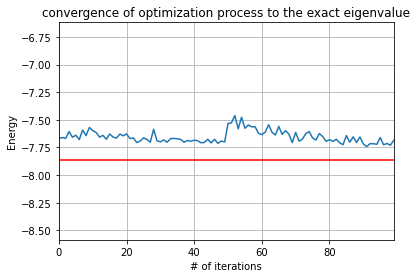

In [54]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [55]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

1it [00:00,  2.69it/s]

{'0011': 73, '1100': 173, '0001': 111, '1110': 73, '0010': 67, '1101': 12, '0110': 54, '0000': 43, '1001': 69, '1111': 43, '0101': 52, '1011': 94, '1010': 81, '1000': 52, '0100': 20, '0111': 7}
1.0


2it [00:00,  3.14it/s]

{'0000': 49, '0010': 54, '1011': 102, '0011': 73, '1100': 178, '1010': 92, '1001': 80, '0101': 46, '0110': 53, '0001': 90, '1000': 45, '1110': 84, '1111': 34, '0100': 20, '1101': 13, '0111': 11}
1.0


3it [00:00,  3.20it/s]

{'1010': 85, '0001': 110, '1001': 79, '1111': 29, '0010': 61, '1011': 96, '1100': 162, '0000': 42, '1000': 62, '1110': 70, '0011': 63, '0101': 70, '0110': 55, '1101': 11, '0111': 8, '0100': 21}
1.0


4it [00:01,  3.51it/s]

{'1011': 112, '1010': 61, '1001': 83, '0011': 65, '1100': 183, '0101': 51, '1110': 86, '0110': 55, '1111': 41, '0001': 100, '1101': 14, '0100': 21, '0000': 46, '1000': 47, '0010': 52, '0111': 7}
1.0


5it [00:01,  3.41it/s]

{'0001': 110, '1001': 79, '1011': 109, '0010': 54, '0000': 46, '1110': 82, '0101': 51, '1100': 167, '0011': 57, '1010': 78, '0110': 61, '1000': 40, '0100': 24, '1111': 44, '1101': 15, '0111': 7}
1.0


6it [00:01,  3.68it/s]

{'1011': 98, '1100': 157, '0011': 79, '0001': 107, '1001': 86, '1010': 86, '1000': 43, '0110': 57, '0000': 40, '0100': 17, '1111': 39, '1110': 70, '0010': 70, '0101': 50, '1101': 21, '0111': 4}
1.0


7it [00:02,  3.70it/s]

{'0011': 73, '1100': 190, '1010': 74, '0001': 120, '1110': 72, '0101': 66, '0010': 54, '1111': 30, '1001': 85, '0110': 47, '0000': 36, '1011': 85, '1000': 53, '0100': 15, '1101': 11, '0111': 13}
1.0


8it [00:02,  3.81it/s]

{'1100': 165, '0000': 56, '0101': 51, '1110': 77, '0010': 54, '0110': 55, '1010': 72, '0001': 122, '0011': 59, '0100': 26, '1011': 91, '1001': 65, '1000': 53, '1111': 50, '1101': 13, '0111': 15}
1.0


9it [00:02,  3.79it/s]

{'1000': 22, '0000': 94, '1001': 228, '1010': 53, '0101': 54, '1110': 190, '0011': 37, '1111': 81, '0111': 44, '0010': 86, '0001': 56, '0110': 50, '0100': 4, '1011': 5, '1101': 15, '1100': 5}
1.0


10it [00:02,  3.83it/s]

{'0010': 78, '1010': 47, '1001': 159, '1101': 61, '1111': 99, '1100': 167, '0101': 30, '1000': 5, '1110': 33, '0110': 78, '0000': 99, '0111': 33, '1011': 33, '0100': 26, '0011': 72, '0001': 4}
1.0


11it [00:03,  3.60it/s]

{'1010': 83, '1001': 124, '0101': 72, '1110': 115, '0000': 23, '0100': 28, '1101': 140, '0010': 153, '0011': 54, '1000': 35, '0111': 58, '1111': 62, '0110': 13, '0001': 24, '1100': 37, '1011': 3}
1.0


12it [00:03,  3.44it/s]

{'1011': 82, '1100': 193, '1001': 90, '0001': 85, '1110': 69, '0000': 56, '1000': 45, '0100': 21, '0011': 73, '0010': 70, '1010': 69, '1101': 11, '0110': 65, '0101': 50, '1111': 36, '0111': 9}
1.0


14it [00:03,  4.22it/s]

{'1111': 38, '0010': 43, '0011': 85, '1010': 71, '1001': 79, '0001': 120, '0101': 48, '1110': 81, '0110': 63, '1100': 171, '1101': 14, '1000': 55, '1011': 83, '0000': 42, '0111': 7, '0100': 24}
1.0
{'0010': 63, '0110': 61, '0000': 45, '1001': 86, '0001': 99, '1100': 178, '0101': 56, '1101': 11, '0011': 70, '1011': 88, '1110': 90, '1010': 76, '0100': 18, '1000': 46, '1111': 26, '0111': 11}
1.0


15it [00:03,  3.79it/s]


{'1110': 67, '1100': 179, '0011': 72, '0000': 44, '1000': 60, '1011': 80, '0010': 62, '1010': 79, '1001': 72, '0001': 108, '1111': 39, '0110': 70, '0100': 20, '0101': 50, '1101': 17, '0111': 5}
1.0


1it [00:00,  3.81it/s]

{'0011': 163, '1100': 142, '1010': 24, '0001': 150, '1001': 140, '1111': 51, '0111': 44, '1000': 71, '0010': 66, '1110': 18, '1011': 47, '0000': 9, '0110': 31, '0101': 50, '1101': 17, '0100': 1}
1.0


2it [00:00,  4.06it/s]

{'0010': 69, '1011': 38, '1100': 140, '0011': 165, '1010': 27, '0001': 133, '1001': 129, '0111': 43, '1111': 53, '0000': 13, '1000': 73, '1110': 16, '0101': 73, '0110': 24, '1101': 17, '0100': 11}
1.0


3it [00:00,  3.40it/s]

{'1000': 77, '1110': 23, '0101': 65, '1100': 125, '1011': 69, '0010': 72, '1001': 128, '1111': 49, '0001': 123, '0011': 169, '0111': 36, '0000': 25, '1010': 23, '1101': 16, '0100': 3, '0110': 21}
1.0


5it [00:01,  3.88it/s]

{'0110': 29, '1111': 46, '0011': 162, '1100': 129, '1001': 142, '0010': 59, '1000': 75, '1101': 17, '0001': 136, '1011': 60, '0101': 64, '1010': 24, '0111': 39, '0000': 16, '1110': 20, '0100': 6}
1.0
{'0011': 144, '1100': 130, '0001': 138, '1001': 141, '1010': 31, '1111': 50, '0111': 44, '0101': 59, '1011': 74, '1000': 51, '1101': 18, '0110': 30, '0100': 9, '0010': 76, '1110': 19, '0000': 10}
1.0


6it [00:01,  3.82it/s]

{'0011': 141, '0101': 61, '1111': 45, '0110': 27, '0001': 130, '1010': 26, '1000': 68, '0010': 64, '0111': 40, '1101': 22, '1011': 60, '1001': 141, '1100': 144, '0000': 16, '1110': 28, '0100': 11}
1.0


7it [00:01,  3.39it/s]

{'1011': 48, '0010': 56, '0011': 191, '0001': 143, '1001': 144, '0101': 60, '1110': 25, '0111': 33, '0000': 11, '1000': 70, '0110': 27, '1010': 16, '1100': 143, '1111': 38, '1101': 15, '0100': 4}
1.0


8it [00:02,  3.65it/s]

{'1101': 22, '1100': 146, '0011': 152, '0101': 68, '0001': 129, '1010': 22, '1011': 66, '0010': 62, '1001': 141, '1000': 58, '0000': 18, '0111': 51, '1111': 48, '0110': 22, '1110': 15, '0100': 4}
1.0


9it [00:02,  3.45it/s]

{'1111': 27, '0000': 245, '1101': 52, '0100': 30, '1011': 69, '0101': 80, '1110': 114, '1001': 176, '1100': 28, '0111': 15, '1010': 42, '1000': 35, '0010': 52, '0110': 15, '0001': 31, '0011': 13}
1.0
{'0110': 74, '1001': 294, '1101': 53, '0100': 126, '1011': 42, '0010': 29, '0111': 25, '0011': 184, '0000': 30, '1100': 80, '1110': 19, '1111': 41, '1000': 9, '1010': 3, '0101': 13, '0001': 2}

10it [00:02,  3.76it/s]


1.0


11it [00:02,  3.90it/s]

{'0000': 74, '1000': 191, '1110': 61, '1010': 49, '0001': 31, '1001': 96, '0010': 102, '1100': 32, '0101': 105, '0111': 29, '1101': 70, '0100': 67, '0011': 45, '1111': 41, '1011': 23, '0110': 8}
1.0


13it [00:03,  4.57it/s]

{'0011': 162, '1100': 152, '0110': 37, '1111': 54, '1001': 121, '0001': 135, '1011': 67, '0010': 65, '0111': 32, '1010': 23, '1000': 59, '0101': 56, '1101': 22, '0000': 14, '0100': 5, '1110': 20}
1.0
{'1000': 61, '1011': 70, '0010': 70, '0011': 146, '1100': 138, '1001': 130, '0001': 145, '0101': 62, '1010': 25, '0110': 23, '1110': 22, '0111': 44, '1111': 43, '0100': 8, '1101': 22, '0000': 15}
1.0


14it [00:03,  4.63it/s]

{'1011': 71, '0010': 72, '0011': 173, '1100': 142, '0001': 122, '1001': 137, '1000': 67, '0000': 17, '0101': 66, '1010': 21, '1111': 38, '1110': 20, '1101': 18, '0111': 33, '0100': 7, '0110': 20}
1.0


15it [00:03,  3.93it/s]


{'0001': 151, '1001': 149, '0101': 66, '1111': 34, '0011': 157, '1011': 58, '0010': 73, '0111': 23, '1100': 144, '1101': 28, '0110': 20, '1010': 20, '1000': 61, '1110': 18, '0000': 12, '0100': 10}
1.0


1it [00:00,  3.89it/s]

{'1010': 57, '1001': 79, '0001': 154, '1000': 45, '1100': 78, '0100': 57, '1011': 65, '0101': 115, '0111': 105, '0011': 98, '1111': 31, '1101': 54, '0110': 38, '0010': 32, '0000': 7, '1110': 9}
1.0


2it [00:00,  4.06it/s]

{'0001': 146, '0111': 93, '0110': 34, '1111': 38, '1000': 25, '1011': 83, '1101': 83, '0011': 107, '0100': 62, '1001': 86, '0101': 103, '1100': 58, '1110': 9, '0010': 35, '1010': 59, '0000': 3}
1.0


3it [00:00,  4.13it/s]

{'0100': 54, '1000': 44, '0000': 8, '0110': 31, '1111': 53, '0111': 90, '1010': 63, '0001': 160, '1011': 59, '0101': 122, '1101': 59, '1100': 77, '0011': 80, '0010': 35, '1001': 69, '1110': 20}
1.0


4it [00:01,  3.97it/s]

{'1011': 59, '0100': 63, '0111': 89, '1100': 54, '1010': 54, '0001': 179, '1111': 47, '0101': 113, '1101': 59, '0011': 116, '0010': 47, '1000': 43, '1001': 48, '0110': 31, '1110': 16, '0000': 6}
1.0


5it [00:01,  3.86it/s]

{'1010': 59, '0001': 158, '1000': 39, '1101': 61, '0100': 55, '0011': 112, '0111': 100, '1110': 11, '0110': 37, '0101': 100, '1100': 69, '1011': 63, '1001': 71, '0010': 39, '1111': 45, '0000': 5}
1.0


6it [00:01,  3.46it/s]

{'1011': 57, '0001': 143, '1001': 77, '1111': 44, '0101': 109, '1101': 79, '1000': 41, '0011': 109, '0111': 108, '0100': 53, '1010': 62, '1110': 11, '0110': 29, '0010': 29, '1100': 72, '0000': 1}
1.0


7it [00:01,  3.58it/s]

{'1100': 57, '0011': 113, '0001': 171, '1001': 56, '0101': 107, '1011': 77, '0111': 83, '1101': 70, '1000': 35, '0110': 42, '1111': 45, '0000': 5, '0010': 34, '0100': 53, '1110': 16, '1010': 60}
1.0


8it [00:02,  3.61it/s]

{'0111': 95, '1100': 76, '0101': 102, '1101': 73, '0100': 64, '1011': 55, '0001': 154, '1000': 40, '0010': 40, '1111': 43, '1010': 64, '1001': 69, '0011': 102, '1110': 12, '0110': 31, '0000': 4}
1.0


9it [00:02,  3.66it/s]

{'0010': 33, '0110': 26, '1111': 66, '1000': 153, '0000': 207, '1110': 121, '0101': 118, '0100': 90, '1011': 42, '0001': 61, '0111': 25, '1010': 31, '1101': 26, '0011': 5, '1001': 19, '1100': 1}
1.0


10it [00:02,  3.60it/s]

{'0011': 255, '1010': 20, '1001': 353, '0001': 18, '0010': 55, '0110': 46, '1111': 16, '0100': 85, '1011': 28, '0000': 24, '0101': 19, '1110': 23, '1100': 40, '0111': 11, '1101': 14, '1000': 17}
1.0


11it [00:03,  3.39it/s]

{'1000': 182, '0000': 167, '1010': 84, '1001': 120, '0001': 40, '0111': 59, '0010': 72, '1110': 30, '0100': 43, '0110': 8, '0011': 69, '0101': 60, '1111': 29, '1100': 40, '1011': 20, '1101': 1}
1.0


12it [00:03,  3.21it/s]

{'1111': 35, '1101': 73, '0001': 158, '1010': 73, '1001': 61, '1110': 15, '0101': 112, '0010': 34, '1100': 72, '0111': 93, '0011': 98, '1000': 35, '0110': 31, '1011': 74, '0100': 53, '0000': 7}
1.0


13it [00:03,  3.17it/s]

{'1001': 72, '0001': 164, '0110': 32, '1111': 33, '0011': 121, '1011': 72, '0101': 88, '0100': 55, '1101': 76, '1100': 75, '0111': 79, '1110': 8, '1010': 68, '1000': 35, '0010': 42, '0000': 4}
1.0


14it [00:04,  3.02it/s]

{'1010': 64, '1001': 69, '0001': 161, '0011': 117, '1100': 72, '0101': 98, '0111': 95, '0100': 54, '1101': 76, '1011': 54, '1111': 49, '0110': 31, '0000': 4, '1000': 39, '1110': 10, '0010': 31}
1.0


15it [00:04,  3.46it/s]


{'0100': 49, '1101': 70, '0101': 111, '0111': 82, '1010': 69, '1001': 66, '1000': 47, '1011': 69, '0001': 162, '1111': 41, '1100': 68, '0010': 37, '0011': 95, '1110': 18, '0110': 35, '0000': 5}
1.0


1it [00:00,  3.57it/s]

{'1101': 115, '1001': 51, '0010': 76, '0110': 49, '0101': 51, '1110': 1, '1000': 49, '0111': 40, '1011': 145, '0100': 47, '1010': 54, '1111': 124, '0011': 83, '0001': 92, '1100': 32, '0000': 15}
1.0


2it [00:00,  3.27it/s]

{'0110': 40, '1111': 112, '1010': 53, '1001': 48, '0100': 73, '1101': 135, '0011': 96, '0101': 61, '1011': 127, '0001': 86, '1000': 45, '1110': 3, '0111': 36, '0010': 55, '1100': 43, '0000': 11}
1.0


3it [00:00,  3.19it/s]

{'1011': 153, '0010': 59, '1001': 39, '0001': 100, '1010': 59, '1100': 36, '0011': 95, '0100': 72, '0111': 57, '1111': 117, '1101': 89, '0110': 38, '1000': 40, '0101': 63, '0000': 6, '1110': 1}
1.0


4it [00:01,  3.39it/s]

{'1011': 120, '0010': 57, '1111': 120, '1001': 45, '0001': 108, '1000': 44, '0111': 41, '0100': 64, '0101': 59, '0011': 95, '0110': 52, '1100': 34, '1101': 122, '1010': 52, '0000': 10, '1110': 1}
1.0


5it [00:01,  3.35it/s]

{'1010': 54, '0001': 95, '1011': 120, '0010': 70, '1100': 38, '1111': 120, '0110': 37, '1101': 107, '0100': 79, '1001': 48, '1000': 34, '0111': 60, '0011': 90, '0101': 58, '0000': 12, '1110': 2}
1.0


6it [00:01,  3.34it/s]

{'1101': 109, '0100': 65, '0111': 60, '0001': 90, '1010': 55, '0011': 97, '0010': 53, '0101': 68, '1111': 115, '0110': 60, '1000': 40, '1011': 124, '1001': 37, '1100': 41, '0000': 10}
1.0


7it [00:02,  3.33it/s]

{'0001': 82, '0010': 69, '1101': 98, '0110': 56, '1111': 105, '0011': 102, '0111': 54, '0101': 63, '0100': 68, '1011': 140, '1000': 38, '1010': 55, '1100': 36, '1001': 46, '0000': 10, '1110': 2}
1.0
{'1001': 41, '0001': 109, '0010': 63, '1111': 124, '1100': 32, '0011': 96, '1000': 58, '0000': 15, '1011': 136, '0100': 54, '1010': 50, '1101': 89, '0101': 63, '0111': 46, '0110': 48}
1.0


9it [00:02,  3.72it/s]

{'0001': 47, '1011': 120, '0100': 80, '0110': 69, '1111': 137, '0000': 120, '1000': 91, '1110': 102, '0010': 85, '0101': 54, '1010': 61, '0111': 41, '1001': 7, '1101': 10}
1.0


10it [00:02,  3.62it/s]

{'1111': 64, '0110': 67, '0010': 30, '1001': 212, '1110': 55, '0111': 92, '1100': 71, '1000': 38, '0011': 220, '0100': 27, '0101': 118, '0000': 17, '1011': 6, '1010': 7}
1.0


11it [00:03,  3.63it/s]

{'0111': 101, '0110': 135, '1110': 76, '0010': 46, '1011': 17, '0001': 45, '0000': 84, '0100': 46, '0011': 110, '1010': 73, '1000': 135, '1101': 4, '0101': 53, '1111': 60, '1001': 19, '1100': 20}
1.0


12it [00:03,  3.47it/s]

{'0011': 97, '1101': 110, '1010': 53, '0001': 78, '1011': 140, '0010': 67, '0111': 41, '1000': 41, '1001': 60, '1111': 120, '1100': 31, '0101': 67, '0100': 57, '0110': 53, '0000': 8, '1110': 1}
1.0


13it [00:03,  3.25it/s]

{'1001': 52, '1010': 51, '0001': 105, '1111': 110, '1011': 134, '1101': 103, '0100': 76, '0011': 81, '0101': 63, '0111': 45, '0010': 63, '1100': 42, '0110': 42, '1000': 39, '0000': 15, '1110': 3}
1.0


14it [00:04,  3.21it/s]

{'1100': 35, '1011': 140, '0010': 51, '0001': 95, '1010': 59, '0101': 65, '1111': 123, '0111': 43, '0100': 78, '0000': 13, '1101': 114, '0011': 86, '1001': 40, '0110': 44, '1000': 36, '1110': 2}
1.0


15it [00:04,  3.23it/s]


{'1011': 119, '1010': 48, '0001': 88, '1000': 47, '0100': 68, '1111': 109, '1100': 33, '0011': 91, '0101': 68, '0010': 64, '1101': 119, '0110': 52, '0111': 50, '1001': 52, '0000': 14, '1110': 2}
1.0


1it [00:00,  2.78it/s]

{'0011': 170, '1001': 43, '0001': 156, '0010': 66, '1011': 127, '1101': 82, '0110': 31, '0000': 14, '0111': 45, '0101': 80, '1000': 63, '0100': 41, '1100': 60, '1110': 24, '1111': 10, '1010': 12}
1.0


2it [00:00,  3.40it/s]

{'1011': 125, '0010': 67, '1110': 28, '0011': 157, '1101': 105, '0111': 51, '0001': 153, '0000': 16, '1100': 46, '1001': 32, '1000': 74, '0101': 83, '1010': 11, '0100': 36, '1111': 6, '0110': 34}
1.0


3it [00:00,  3.58it/s]

{'1101': 93, '0100': 39, '0011': 170, '1100': 60, '1000': 51, '0101': 74, '1001': 40, '0001': 166, '0110': 44, '0000': 23, '0010': 58, '0111': 37, '1110': 29, '1011': 121, '1111': 9, '1010': 10}
1.0


4it [00:01,  3.14it/s]

{'0011': 167, '1100': 51, '0111': 44, '1101': 78, '0010': 70, '0101': 73, '0110': 41, '0001': 168, '1011': 144, '0100': 43, '1000': 56, '1110': 20, '0000': 23, '1111': 7, '1010': 13, '1001': 26}
1.0


5it [00:01,  2.98it/s]

{'0101': 82, '0100': 34, '1101': 97, '1100': 50, '1000': 70, '1001': 27, '0001': 165, '0110': 29, '0011': 167, '0010': 69, '1110': 26, '1011': 126, '1111': 4, '0000': 25, '0111': 39, '1010': 14}
1.0


6it [00:01,  3.14it/s]

{'0111': 60, '1001': 39, '0001': 159, '1010': 7, '0110': 39, '1000': 56, '0010': 73, '1101': 91, '0011': 186, '0101': 70, '0100': 49, '1100': 56, '1110': 22, '1011': 98, '0000': 11, '1111': 8}
1.0


7it [00:02,  3.29it/s]

{'1011': 118, '0010': 86, '0101': 69, '0011': 179, '0111': 47, '1000': 71, '0001': 147, '1010': 10, '0100': 37, '1001': 38, '1100': 53, '1110': 18, '0110': 35, '1101': 92, '0000': 13, '1111': 11}
1.0


8it [00:02,  3.36it/s]

{'1001': 43, '0001': 165, '0100': 45, '1101': 93, '0111': 52, '1100': 62, '1011': 106, '0010': 70, '0101': 77, '0011': 158, '0110': 41, '1010': 15, '1110': 24, '1000': 46, '0000': 17, '1111': 10}
1.0


9it [00:02,  3.18it/s]

{'1111': 121, '1000': 176, '0000': 308, '1011': 21, '0010': 47, '1101': 30, '0100': 58, '0111': 30, '0101': 77, '1100': 27, '0001': 55, '0110': 37, '1001': 23, '1110': 11, '0011': 3}
1.0


10it [00:03,  3.08it/s]

{'1110': 33, '0101': 36, '0110': 57, '1011': 131, '1001': 263, '1100': 16, '0100': 76, '0000': 71, '0111': 58, '1111': 39, '0011': 111, '0010': 44, '0001': 40, '1101': 36, '1000': 11, '1010': 2}
1.0


11it [00:03,  2.96it/s]

{'1000': 240, '0000': 184, '0100': 115, '0111': 96, '1001': 136, '0010': 42, '1100': 45, '0101': 12, '1010': 12, '0011': 47, '0110': 8, '0001': 10, '1101': 19, '1110': 34, '1111': 20, '1011': 4}
1.0


12it [00:03,  2.90it/s]

{'0001': 169, '1010': 13, '1000': 57, '1111': 5, '0110': 52, '1011': 129, '1110': 25, '0101': 79, '0011': 163, '0100': 40, '0010': 56, '0111': 52, '0000': 16, '1101': 82, '1100': 45, '1001': 41}
1.0


13it [00:04,  3.01it/s]

{'1100': 54, '0011': 164, '1011': 113, '0010': 76, '1101': 84, '0100': 44, '0001': 165, '0111': 46, '0110': 46, '1111': 7, '0000': 17, '1000': 65, '0101': 72, '1110': 23, '1010': 13, '1001': 35}
1.0


14it [00:04,  3.13it/s]

{'1000': 52, '0001': 165, '0010': 74, '1100': 58, '0011': 173, '1101': 89, '0100': 32, '0101': 72, '0110': 45, '1011': 119, '1110': 24, '1001': 30, '0111': 60, '1010': 11, '0000': 13, '1111': 7}
1.0


15it [00:04,  3.13it/s]


{'0100': 53, '1101': 83, '0011': 152, '1100': 47, '0001': 170, '0111': 67, '0010': 60, '0110': 30, '1011': 115, '1000': 69, '1110': 22, '0101': 75, '1001': 46, '1111': 7, '1010': 10, '0000': 18}
1.0


1it [00:00,  3.15it/s]

{'0111': 161, '1000': 32, '0000': 53, '1101': 69, '0100': 62, '1010': 118, '0001': 168, '1110': 73, '0010': 30, '0011': 107, '1001': 49, '1100': 27, '0101': 38, '1111': 27, '0110': 7, '1011': 3}
1.0


2it [00:00,  3.64it/s]

{'0101': 34, '0111': 134, '0011': 116, '0100': 66, '0000': 59, '1000': 24, '1001': 38, '1010': 136, '1101': 81, '1100': 32, '1111': 23, '0001': 179, '0010': 15, '1011': 4, '1110': 72, '0110': 11}
1.0


3it [00:00,  3.85it/s]

{'0000': 61, '0011': 118, '1110': 88, '0101': 38, '0110': 11, '1010': 122, '0001': 143, '0111': 142, '1111': 27, '1100': 42, '1000': 33, '0010': 24, '1011': 7, '0100': 56, '1001': 40, '1101': 72}
1.0


4it [00:01,  3.06it/s]

{'0010': 23, '1101': 68, '0100': 66, '0101': 48, '1000': 20, '1010': 122, '0111': 139, '1100': 49, '0001': 187, '0011': 104, '1110': 77, '1001': 42, '0000': 41, '1111': 24, '1011': 10, '0110': 4}
1.0


5it [00:01,  3.12it/s]

{'0000': 45, '1110': 63, '0001': 165, '1010': 104, '0100': 72, '1101': 66, '0111': 167, '0010': 31, '1111': 17, '1100': 31, '1001': 40, '1000': 30, '0011': 131, '1011': 9, '0110': 11, '0101': 42}
1.0


6it [00:01,  3.42it/s]

{'0001': 175, '1101': 60, '0100': 70, '0011': 99, '1110': 78, '0101': 55, '1000': 40, '0010': 26, '1001': 44, '0111': 137, '1010': 130, '0000': 48, '1111': 21, '1100': 33, '0110': 3, '1011': 5}
1.0


7it [00:02,  3.63it/s]

{'0000': 51, '0100': 67, '1101': 74, '1001': 51, '1010': 104, '0001': 185, '0111': 125, '1100': 38, '0011': 96, '0010': 35, '1110': 78, '0101': 46, '1000': 27, '1111': 30, '1011': 8, '0110': 9}
1.0


8it [00:02,  3.32it/s]

{'1010': 120, '0001': 179, '0011': 111, '1000': 32, '0000': 52, '1110': 67, '0100': 66, '1101': 79, '0101': 46, '0111': 152, '0110': 7, '1001': 33, '0010': 21, '1011': 9, '1111': 26, '1100': 24}
1.0


10it [00:02,  3.65it/s]

{'1111': 138, '0000': 214, '1011': 47, '1110': 69, '0100': 160, '1001': 46, '1010': 27, '0111': 56, '0001': 80, '1000': 83, '0010': 56, '1100': 7, '0011': 11, '0101': 30}
1.0
{'0011': 249, '1011': 51, '0010': 105, '1010': 66, '1001': 275, '0000': 89, '0111': 15, '0110': 44, '1100': 63, '1000': 23, '0100': 8, '1110': 1, '0001': 5, '1101': 10, '0101': 19, '1111': 1}
1.0


11it [00:03,  3.57it/s]

{'0011': 166, '0000': 155, '1000': 289, '0010': 83, '1011': 26, '1111': 20, '1101': 33, '1001': 102, '0111': 26, '0100': 33, '1110': 20, '1010': 23, '0110': 6, '0001': 30, '0101': 10, '1100': 2}
1.0


12it [00:03,  3.47it/s]

{'0000': 58, '1010': 114, '1001': 51, '0111': 146, '1101': 62, '0100': 62, '0110': 9, '1110': 71, '0001': 164, '0011': 116, '0010': 31, '1011': 5, '1111': 27, '1100': 28, '0101': 47, '1000': 33}
1.0


13it [00:03,  3.37it/s]

{'0110': 9, '1111': 27, '0001': 191, '1001': 43, '0011': 102, '0111': 134, '0000': 63, '0101': 34, '1010': 122, '0010': 24, '1101': 56, '1110': 69, '0100': 76, '1100': 39, '1000': 26, '1011': 9}
1.0


14it [00:04,  3.27it/s]

{'1001': 49, '0001': 182, '1010': 115, '0110': 9, '0111': 166, '0011': 99, '0101': 44, '1101': 71, '0000': 43, '1110': 70, '0100': 56, '1000': 29, '0010': 19, '1111': 31, '1100': 33, '1011': 8}
1.0


15it [00:04,  3.34it/s]


{'0001': 180, '0101': 43, '1110': 66, '0011': 107, '1101': 68, '0110': 10, '0111': 152, '0010': 37, '1000': 36, '0100': 72, '1001': 46, '1010': 104, '1111': 29, '0000': 40, '1100': 28, '1011': 6}
1.0


1it [00:00,  4.39it/s]

{'0011': 106, '1011': 110, '0101': 98, '1010': 46, '1001': 123, '0001': 152, '0111': 77, '1101': 95, '1110': 38, '1111': 39, '0100': 89, '0110': 22, '1100': 5, '1000': 7, '0010': 16, '0000': 1}
1.0


2it [00:00,  4.42it/s]

{'0111': 92, '0001': 129, '0101': 99, '1110': 37, '0011': 109, '1101': 124, '0100': 70, '1011': 101, '0010': 15, '1000': 5, '1010': 59, '1111': 44, '1001': 111, '0110': 23, '1100': 6}
1.0


3it [00:00,  3.65it/s]

{'1010': 48, '0001': 134, '1001': 121, '1101': 111, '0100': 75, '1011': 106, '0111': 65, '0011': 119, '1111': 28, '0101': 124, '0000': 1, '1100': 8, '1110': 47, '0010': 12, '1000': 10, '0110': 15}
1.0


4it [00:01,  3.10it/s]

{'0001': 141, '1010': 40, '0011': 109, '1111': 42, '0101': 83, '1110': 40, '0100': 78, '1101': 130, '1011': 124, '1001': 112, '0111': 81, '1100': 10, '0010': 12, '0000': 2, '1000': 5, '0110': 15}
1.0


5it [00:01,  3.18it/s]

{'0010': 13, '1011': 112, '1111': 35, '0111': 90, '0101': 101, '0001': 134, '1001': 119, '1101': 133, '0011': 95, '0100': 81, '1010': 50, '1110': 37, '1000': 3, '0110': 16, '1100': 4, '0000': 1}
1.0


7it [00:01,  3.70it/s]

{'0101': 123, '1110': 47, '1010': 50, '1001': 113, '0001': 142, '0100': 81, '1011': 88, '0111': 85, '1111': 38, '0011': 107, '1101': 116, '1000': 4, '0110': 15, '1100': 5, '0010': 9, '0000': 1}
1.0
{'1001': 122, '1010': 57, '0001': 126, '0011': 118, '1011': 102, '0101': 103, '0100': 63, '0111': 101, '1101': 117, '1110': 41, '0010': 14, '0110': 17, '1111': 33, '1100': 5, '1000': 4, '0000': 1}
1.0


8it [00:02,  3.78it/s]

{'1001': 124, '1111': 37, '0011': 107, '0100': 78, '1101': 123, '0101': 95, '1110': 41, '1011': 97, '0001': 145, '1010': 54, '1000': 3, '0110': 25, '0111': 73, '0010': 18, '1100': 3, '0000': 1}
1.0


9it [00:02,  3.52it/s]

{'0110': 58, '0001': 89, '1010': 65, '0100': 118, '1110': 110, '0111': 27, '1000': 173, '0000': 148, '1111': 69, '1011': 44, '0101': 69, '1100': 16, '1001': 10, '1101': 12, '0010': 10, '0011': 6}
1.0


10it [00:02,  3.63it/s]

{'1011': 27, '0010': 46, '0011': 275, '1001': 404, '0001': 19, '1010': 41, '1110': 34, '1111': 32, '0000': 14, '0100': 22, '0101': 10, '1000': 46, '1101': 36, '1100': 12, '0111': 4, '0110': 2}
1.0


11it [00:03,  3.59it/s]

{'0000': 162, '1000': 270, '1101': 29, '1001': 78, '1010': 135, '0011': 86, '0010': 59, '1011': 23, '1100': 42, '0001': 47, '0111': 27, '0100': 7, '1110': 31, '0110': 7, '0101': 4, '1111': 17}
1.0


12it [00:03,  3.16it/s]

{'1010': 46, '1001': 114, '0001': 145, '1011': 89, '1110': 50, '0101': 85, '0100': 87, '0011': 117, '1101': 121, '1111': 35, '0110': 22, '0111': 86, '1000': 7, '0010': 12, '1100': 8}
1.0


13it [00:03,  3.16it/s]

{'1001': 114, '1011': 124, '1110': 38, '0101': 98, '0111': 87, '0100': 71, '1101': 115, '0011': 114, '1010': 46, '0001': 148, '1111': 30, '0110': 19, '1000': 7, '0010': 9, '1100': 4}
1.0


14it [00:04,  2.85it/s]

{'0111': 80, '1101': 129, '0101': 105, '1001': 111, '1010': 46, '0001': 139, '1011': 95, '0011': 118, '0100': 92, '0110': 20, '1110': 29, '1111': 35, '0010': 10, '1000': 10, '1100': 4, '0000': 1}
1.0


15it [00:04,  3.27it/s]


{'1101': 133, '0011': 111, '1001': 117, '0001': 145, '1010': 54, '0101': 89, '1011': 87, '0110': 18, '1111': 42, '1110': 45, '0111': 94, '0100': 68, '0010': 15, '1100': 2, '1000': 3, '0000': 1}
1.0


1it [00:00,  2.98it/s]

{'0011': 78, '1100': 73, '0001': 196, '1111': 151, '1000': 35, '1011': 75, '0101': 52, '0111': 120, '0010': 27, '1101': 128, '1110': 11, '0100': 27, '0000': 11, '1010': 13, '0110': 17, '1001': 10}
1.0


2it [00:00,  2.58it/s]

{'0010': 24, '1011': 84, '0011': 88, '0110': 19, '1111': 165, '1101': 125, '0111': 109, '0001': 205, '0101': 47, '1000': 22, '1100': 70, '0100': 29, '1001': 10, '1010': 9, '1110': 6, '0000': 12}
1.0


3it [00:01,  2.62it/s]

{'0110': 13, '1111': 147, '1000': 32, '0001': 213, '1101': 111, '0011': 75, '1100': 66, '0010': 24, '0111': 124, '0100': 23, '1011': 77, '1001': 7, '0101': 66, '1110': 7, '0000': 25, '1010': 14}
1.0


4it [00:01,  2.73it/s]

{'1001': 9, '0001': 208, '1101': 123, '1111': 140, '0111': 102, '0101': 60, '1100': 90, '1000': 29, '1011': 86, '0011': 90, '0100': 20, '0010': 26, '0110': 15, '1010': 6, '0000': 15, '1110': 5}
1.0


5it [00:01,  2.70it/s]

{'0100': 22, '1101': 123, '0011': 80, '1100': 92, '0110': 13, '1111': 153, '0111': 110, '0001': 203, '1110': 7, '0101': 66, '1011': 72, '0010': 20, '1000': 33, '1010': 11, '1001': 8, '0000': 11}
1.0


6it [00:02,  3.12it/s]

{'0001': 230, '1011': 66, '1111': 133, '0111': 114, '1101': 124, '1000': 31, '0011': 83, '0101': 64, '1110': 4, '0100': 28, '1100': 82, '0010': 19, '1010': 10, '0000': 17, '0110': 13, '1001': 6}
1.0


8it [00:02,  3.74it/s]

{'0101': 62, '0001': 189, '1100': 84, '0011': 72, '0110': 12, '1111': 149, '0111': 129, '1011': 77, '0100': 36, '1101': 126, '1000': 39, '0000': 13, '0010': 15, '1110': 6, '1010': 8, '1001': 7}
1.0
{'1101': 121, '0111': 135, '0001': 190, '0011': 88, '1100': 75, '1111': 168, '1011': 73, '0101': 67, '0000': 17, '1000': 27, '0100': 22, '1010': 4, '0110': 6, '1001': 4, '0010': 21, '1110': 6}
1.0


9it [00:02,  4.06it/s]

{'0001': 67, '1111': 88, '0101': 84, '1110': 226, '1000': 82, '0000': 167, '0100': 105, '0010': 65, '1101': 62, '1011': 19, '0111': 35, '0011': 3, '1001': 6, '0110': 10, '1010': 5}
1.0


10it [00:03,  3.77it/s]

{'0011': 259, '1100': 52, '0001': 11, '1001': 301, '1011': 51, '0101': 81, '0111': 86, '0100': 37, '1110': 19, '0110': 20, '1010': 6, '1111': 25, '0010': 13, '1000': 29, '0000': 16, '1101': 18}
1.0


11it [00:03,  3.55it/s]

{'1010': 85, '0001': 62, '1001': 83, '0110': 63, '0101': 48, '1110': 87, '1000': 164, '0111': 96, '0000': 152, '0100': 26, '1100': 15, '0011': 56, '0010': 66, '1111': 10, '1011': 7, '1101': 4}
1.0


12it [00:03,  3.46it/s]

{'0010': 20, '1011': 72, '0001': 195, '1111': 158, '1000': 29, '0111': 126, '0100': 31, '0101': 59, '1100': 80, '1101': 120, '0110': 15, '0011': 72, '0000': 19, '1110': 8, '1010': 11, '1001': 9}
1.0


13it [00:04,  3.33it/s]

{'0001': 164, '0011': 94, '1100': 89, '1101': 121, '1011': 67, '0110': 21, '1111': 154, '0101': 58, '0000': 23, '0111': 117, '1000': 28, '1001': 13, '0100': 43, '1110': 10, '0010': 14, '1010': 8}
1.0


14it [00:04,  3.19it/s]

{'0110': 8, '1111': 162, '0011': 80, '1100': 87, '1011': 77, '1101': 129, '0111': 119, '0101': 56, '0001': 192, '1001': 8, '1000': 26, '0100': 25, '0000': 17, '1110': 9, '0010': 23, '1010': 6}
1.0


15it [00:04,  3.26it/s]


{'0001': 202, '1011': 72, '0010': 22, '1101': 103, '0111': 141, '0011': 64, '0110': 16, '1111': 156, '1100': 73, '0101': 59, '0100': 31, '0000': 23, '1010': 11, '1000': 34, '1001': 8, '1110': 9}
1.0


1it [00:00,  4.72it/s]

{'1100': 82, '0111': 95, '1000': 31, '1010': 73, '0001': 132, '1111': 68, '0101': 101, '1011': 87, '1101': 57, '0010': 33, '1001': 48, '0110': 20, '1110': 32, '0100': 64, '0011': 97, '0000': 4}
1.0


2it [00:00,  4.21it/s]

{'1001': 51, '1010': 70, '0001': 136, '1100': 96, '0011': 102, '0111': 102, '1110': 23, '1011': 81, '0101': 82, '0100': 45, '0010': 34, '1111': 71, '1101': 62, '1000': 40, '0000': 12, '0110': 17}
1.0


3it [00:00,  3.26it/s]

{'0111': 116, '1010': 61, '0001': 147, '1000': 24, '0000': 12, '1111': 68, '1100': 99, '1101': 73, '0011': 74, '1011': 101, '1001': 50, '0101': 97, '0100': 43, '1110': 30, '0010': 17, '0110': 12}
1.0


4it [00:01,  3.02it/s]

{'1011': 91, '0111': 92, '1000': 28, '1110': 21, '0110': 18, '0011': 104, '0100': 47, '1010': 73, '0101': 99, '1001': 54, '0001': 135, '1111': 58, '1100': 108, '1101': 63, '0010': 28, '0000': 5}
1.0


5it [00:01,  3.37it/s]

{'1010': 73, '0001': 137, '1011': 86, '1101': 64, '0100': 56, '1100': 95, '1000': 33, '1110': 32, '0011': 102, '1111': 64, '0101': 78, '0000': 13, '1001': 58, '0111': 81, '0010': 32, '0110': 20}
1.0


7it [00:02,  3.58it/s]

{'1101': 58, '0101': 97, '1001': 62, '0001': 119, '1100': 101, '1011': 87, '1000': 33, '0111': 95, '0100': 41, '1010': 70, '0010': 28, '0011': 105, '0110': 19, '1111': 74, '1110': 25, '0000': 10}
1.0
{'0111': 94, '1100': 109, '0011': 86, '0001': 140, '0110': 22, '1011': 91, '1110': 12, '1101': 63, '0101': 94, '1010': 67, '1000': 23, '1001': 65, '0010': 33, '0100': 55, '1111': 64, '0000': 6}
1.0


8it [00:02,  2.82it/s]

{'1010': 69, '0001': 129, '1101': 80, '1100': 93, '0011': 77, '1111': 71, '1011': 87, '1110': 24, '1000': 32, '0110': 28, '0100': 50, '0111': 98, '0010': 33, '0101': 90, '1001': 57, '0000': 6}
1.0


9it [00:02,  2.82it/s]

{'0000': 180, '1010': 68, '0001': 46, '0100': 119, '0101': 93, '1110': 152, '0010': 18, '0110': 25, '1000': 123, '1111': 57, '1101': 53, '1011': 37, '0011': 5, '0111': 32, '1001': 15, '1100': 1}
1.0


10it [00:03,  2.72it/s]

{'0110': 28, '1001': 318, '0001': 6, '1010': 30, '1011': 34, '0010': 60, '1110': 33, '0011': 301, '1100': 58, '0100': 58, '1000': 14, '0000': 41, '0111': 2, '0101': 34, '1111': 5, '1101': 2}
1.0


11it [00:03,  3.04it/s]

{'0010': 104, '1100': 31, '0011': 75, '1000': 172, '0000': 170, '1111': 36, '1010': 120, '0111': 35, '1001': 88, '0001': 51, '1110': 27, '0101': 86, '0100': 11, '1101': 1, '1011': 17}
1.0


12it [00:03,  3.02it/s]

{'1100': 106, '1010': 78, '0001': 131, '1111': 67, '0100': 47, '1101': 60, '0111': 91, '1011': 99, '1001': 58, '0101': 91, '0011': 84, '0110': 23, '1110': 30, '1000': 20, '0010': 29, '0000': 10}
1.0


13it [00:04,  2.63it/s]

{'0100': 44, '1101': 59, '1001': 60, '0001': 126, '1010': 75, '1011': 97, '0101': 96, '0111': 96, '0011': 113, '1100': 93, '0010': 30, '0000': 8, '1110': 25, '0110': 17, '1000': 28, '1111': 57}
1.0


14it [00:04,  2.89it/s]

{'0110': 18, '1001': 65, '1010': 70, '0011': 90, '1100': 77, '0101': 91, '1000': 36, '0111': 97, '0001': 149, '1101': 63, '1111': 67, '1011': 96, '0100': 57, '1110': 14, '0010': 29, '0000': 5}
1.0


15it [00:04,  3.01it/s]


{'1000': 34, '1010': 66, '0001': 129, '0111': 77, '1101': 74, '0101': 92, '0010': 28, '0011': 96, '1100': 91, '1001': 71, '1011': 98, '1111': 66, '0110': 17, '1110': 30, '0100': 53, '0000': 2}
1.0


1it [00:00,  3.57it/s]

{'0010': 41, '1011': 74, '1110': 116, '1101': 91, '0100': 109, '0001': 106, '1010': 99, '0111': 83, '1001': 28, '1111': 29, '1100': 75, '0101': 70, '0011': 38, '0000': 28, '0110': 35, '1000': 2}
1.0


2it [00:00,  3.96it/s]

{'0100': 93, '0001': 113, '1010': 78, '1110': 107, '1111': 31, '0111': 83, '1011': 60, '1100': 73, '0011': 56, '0010': 38, '1101': 82, '0000': 55, '0101': 73, '1001': 29, '0110': 50, '1000': 3}
1.0


3it [00:00,  4.15it/s]

{'0111': 83, '1011': 77, '0100': 118, '1101': 80, '1111': 38, '0110': 42, '0011': 34, '1010': 74, '0101': 71, '1100': 74, '0001': 103, '0010': 43, '1110': 115, '1001': 32, '0000': 35, '1000': 5}
1.0


4it [00:00,  4.06it/s]

{'1011': 78, '0001': 120, '1001': 40, '1010': 105, '0101': 67, '1110': 101, '0111': 66, '1111': 37, '1101': 73, '0011': 45, '1100': 85, '0100': 91, '0110': 43, '0000': 37, '0010': 35, '1000': 1}
1.0


5it [00:01,  3.74it/s]

{'0100': 111, '1110': 127, '0110': 42, '0000': 31, '0001': 111, '1010': 104, '0111': 73, '1011': 67, '0010': 38, '1100': 71, '1001': 28, '1101': 81, '0101': 71, '0011': 39, '1111': 27, '1000': 3}
1.0


6it [00:01,  3.31it/s]

{'0101': 69, '1110': 118, '1101': 90, '1011': 58, '1001': 45, '0001': 94, '0000': 51, '0111': 78, '0100': 92, '1010': 81, '1111': 39, '0011': 43, '1100': 84, '0010': 47, '1000': 5, '0110': 30}
1.0


7it [00:02,  3.20it/s]

{'0010': 42, '0100': 95, '1101': 83, '0001': 92, '0011': 51, '0101': 79, '1110': 124, '0111': 93, '1001': 26, '1111': 34, '1100': 67, '1011': 80, '1010': 84, '0000': 41, '0110': 27, '1000': 6}
1.0


8it [00:02,  3.22it/s]

{'0101': 74, '1110': 96, '0111': 69, '1100': 87, '0100': 103, '1101': 94, '0001': 109, '1010': 93, '1011': 83, '1111': 24, '0000': 46, '0110': 37, '0010': 38, '0011': 37, '1001': 30, '1000': 4}
1.0


9it [00:02,  3.21it/s]

{'0101': 84, '1110': 153, '1111': 130, '0100': 70, '0001': 95, '0011': 57, '0000': 41, '0111': 72, '1001': 36, '1000': 110, '1101': 14, '1010': 57, '0110': 60, '0010': 43, '1100': 2}
1.0


10it [00:02,  3.44it/s]

{'0101': 27, '0010': 113, '1001': 232, '0011': 135, '1100': 99, '1111': 37, '0110': 22, '0100': 55, '1011': 36, '1110': 52, '0000': 62, '1010': 81, '1000': 7, '0111': 28, '0001': 23, '1101': 15}
1.0


11it [00:03,  3.59it/s]

{'1001': 128, '1010': 92, '0111': 120, '0011': 71, '1101': 43, '1111': 52, '0010': 119, '1110': 87, '1000': 105, '0001': 36, '0100': 20, '0000': 104, '0101': 18, '0110': 11, '1011': 5, '1100': 13}
1.0


12it [00:03,  3.44it/s]

{'1101': 67, '0100': 109, '1010': 93, '0001': 103, '1011': 80, '0000': 48, '1100': 77, '1110': 108, '0010': 47, '0101': 83, '0111': 83, '0110': 40, '0011': 32, '1001': 25, '1111': 26, '1000': 3}
1.0


13it [00:03,  3.22it/s]

{'0110': 45, '0100': 106, '0101': 65, '1110': 106, '1001': 33, '1010': 72, '0000': 38, '1100': 84, '0011': 40, '1101': 84, '0111': 75, '1111': 31, '0001': 117, '1011': 87, '0010': 39, '1000': 2}
1.0


14it [00:04,  3.41it/s]

{'0100': 112, '1110': 106, '0101': 65, '0010': 49, '1111': 23, '1001': 39, '1010': 83, '1100': 82, '0001': 106, '0110': 46, '1011': 66, '1101': 77, '0000': 46, '0011': 41, '0111': 79, '1000': 4}
1.0


15it [00:04,  3.45it/s]


{'0010': 48, '0000': 55, '1000': 3, '1110': 113, '1101': 78, '1001': 23, '0001': 115, '0110': 39, '0100': 99, '1010': 80, '0111': 66, '0011': 37, '1100': 86, '1111': 25, '0101': 71, '1011': 86}
1.0


1it [00:00,  3.07it/s]

{'1100': 113, '0011': 39, '0001': 97, '1001': 185, '0010': 61, '1011': 122, '0111': 71, '0101': 28, '1101': 166, '1111': 18, '1000': 61, '1110': 9, '0110': 9, '0100': 9, '1010': 34, '0000': 2}
1.0


2it [00:00,  2.52it/s]

{'1100': 136, '0101': 36, '1101': 148, '0111': 70, '0000': 5, '1011': 132, '0010': 52, '0001': 108, '0011': 22, '1001': 147, '1010': 42, '1111': 18, '1000': 74, '0100': 19, '0110': 11, '1110': 4}
1.0


3it [00:01,  2.94it/s]

{'0001': 73, '1001': 185, '0010': 52, '1011': 156, '1100': 119, '1101': 146, '0111': 76, '0101': 25, '0100': 26, '1000': 72, '1010': 39, '0011': 25, '0110': 6, '1111': 12, '1110': 8, '0000': 4}
1.0


4it [00:01,  2.83it/s]

{'0111': 90, '1100': 115, '1001': 173, '0001': 93, '1011': 130, '0010': 42, '1101': 173, '0110': 9, '1111': 14, '0011': 24, '1000': 67, '1010': 37, '0100': 18, '0101': 31, '1110': 5, '0000': 3}
1.0


5it [00:01,  3.17it/s]

{'1010': 46, '1001': 160, '1100': 119, '1101': 152, '1011': 150, '0010': 50, '1000': 68, '0110': 13, '0001': 109, '0111': 57, '1111': 21, '0101': 26, '0100': 13, '0011': 32, '1110': 4, '0000': 4}
1.0


6it [00:02,  2.96it/s]

{'1010': 40, '1001': 166, '0100': 29, '1101': 148, '1100': 109, '1011': 152, '0010': 44, '0101': 32, '1000': 47, '0110': 18, '0011': 15, '0001': 102, '1111': 22, '0111': 91, '1110': 6, '0000': 3}
1.0


7it [00:02,  3.13it/s]

{'1011': 152, '1101': 156, '1111': 15, '1000': 68, '1100': 110, '1010': 51, '0001': 104, '0111': 62, '1001': 160, '0010': 50, '0100': 15, '0101': 29, '0110': 14, '0011': 28, '0000': 3, '1110': 7}
1.0


8it [00:02,  3.30it/s]

{'1010': 44, '0001': 90, '1001': 191, '1101': 168, '0111': 74, '0101': 35, '0010': 52, '1011': 114, '0100': 13, '1100': 113, '1000': 66, '1111': 16, '1110': 11, '0110': 13, '0011': 23, '0000': 1}
1.0


9it [00:02,  3.13it/s]

{'1111': 77, '1000': 248, '1101': 84, '0100': 76, '1001': 26, '1010': 83, '0001': 34, '0101': 33, '1100': 62, '0011': 55, '1110': 79, '0000': 84, '0111': 23, '1011': 51, '0110': 3, '0010': 6}
1.0


10it [00:03,  3.35it/s]

{'0011': 126, '1100': 90, '0001': 76, '1001': 374, '1011': 82, '0100': 93, '0110': 63, '1111': 34, '0010': 32, '1000': 17, '1110': 8, '0111': 10, '1101': 10, '1010': 2, '0000': 7}
1.0


11it [00:03,  3.28it/s]

{'1001': 115, '0001': 32, '1010': 96, '1000': 232, '0000': 82, '0010': 58, '1011': 33, '0100': 104, '1111': 86, '0011': 51, '0101': 67, '1101': 6, '1110': 11, '1100': 34, '0111': 17}
1.0


12it [00:03,  3.42it/s]

{'1101': 180, '0100': 22, '0001': 88, '1001': 156, '1011': 123, '1000': 55, '1100': 133, '0111': 71, '1010': 38, '0010': 67, '1111': 12, '0110': 7, '0101': 29, '0011': 33, '1110': 7, '0000': 3}
1.0


13it [00:04,  3.19it/s]

{'1101': 139, '1011': 126, '1000': 78, '0101': 27, '1010': 43, '0001': 99, '1001': 179, '1100': 129, '0010': 50, '0111': 78, '0011': 29, '1111': 16, '1110': 7, '0100': 12, '0110': 9, '0000': 3}
1.0


14it [00:04,  2.96it/s]

{'1101': 187, '1011': 125, '0010': 48, '1100': 131, '1001': 170, '0001': 107, '1000': 63, '0101': 27, '1111': 13, '0111': 53, '0100': 17, '1010': 40, '0110': 15, '0011': 20, '1110': 5, '0000': 3}
1.0


15it [00:04,  3.04it/s]


{'1010': 34, '1001': 161, '1011': 125, '0010': 53, '1000': 77, '1100': 123, '0111': 81, '1101': 166, '0001': 96, '0100': 17, '1110': 6, '0011': 24, '0101': 31, '0110': 14, '1111': 13, '0000': 3}
1.0


1it [00:00,  2.82it/s]

{'0111': 125, '0010': 84, '0110': 12, '0011': 155, '1100': 116, '1101': 139, '0101': 161, '1010': 62, '1001': 31, '1111': 24, '1011': 11, '0100': 53, '0001': 38, '0000': 5, '1000': 3, '1110': 5}
1.0


2it [00:00,  2.37it/s]

{'1001': 29, '0001': 44, '1010': 68, '0100': 59, '1101': 162, '0011': 144, '1100': 102, '0101': 165, '0010': 75, '0111': 114, '0000': 6, '1111': 19, '1000': 8, '0110': 11, '1011': 16, '1110': 2}
1.0


3it [00:01,  2.57it/s]

{'1100': 98, '0011': 176, '0001': 38, '1010': 73, '0100': 57, '1101': 184, '0101': 153, '0010': 57, '0111': 105, '0110': 8, '1011': 20, '1110': 3, '1111': 20, '0000': 7, '1001': 24, '1000': 1}
1.0


4it [00:01,  2.61it/s]

{'0111': 117, '1100': 99, '0011': 167, '0101': 158, '1010': 71, '0110': 4, '1101': 165, '0100': 62, '0001': 59, '0010': 63, '1001': 23, '1000': 3, '1110': 2, '1011': 10, '1111': 17, '0000': 4}
1.0


5it [00:01,  2.93it/s]

{'1010': 71, '0111': 104, '1100': 119, '0011': 139, '0010': 63, '0101': 152, '1101': 154, '0000': 9, '0100': 70, '0110': 11, '0001': 48, '1001': 36, '1011': 11, '1000': 7, '1111': 29, '1110': 1}
1.0


6it [00:02,  2.85it/s]

{'0110': 2, '1111': 26, '1101': 171, '0010': 74, '1001': 35, '1010': 63, '0101': 170, '0011': 128, '1100': 90, '0100': 73, '0111': 127, '0001': 37, '1011': 20, '0000': 4, '1110': 2, '1000': 2}
1.0


7it [00:02,  2.92it/s]

{'1101': 154, '1100': 107, '0011': 146, '0101': 183, '0001': 43, '1010': 53, '0111': 125, '1011': 18, '0010': 63, '0100': 61, '1111': 24, '1110': 1, '0110': 7, '1001': 27, '1000': 5, '0000': 7}
1.0


8it [00:02,  2.92it/s]

{'0111': 108, '0101': 177, '0001': 42, '1010': 56, '1001': 33, '1100': 91, '0011': 162, '1101': 175, '0100': 65, '0010': 54, '1111': 21, '1011': 20, '1000': 9, '0000': 7, '1110': 1, '0110': 3}
1.0


9it [00:03,  3.21it/s]

{'1011': 29, '0010': 77, '1000': 51, '0000': 167, '1101': 74, '1110': 99, '0101': 110, '0001': 25, '1010': 43, '1100': 49, '0111': 94, '0100': 116, '1001': 13, '1111': 58, '0110': 18, '0011': 1}
1.0


10it [00:03,  3.46it/s]

{'1011': 64, '0001': 63, '1001': 224, '0101': 90, '1101': 53, '0011': 204, '1000': 41, '0000': 38, '0110': 96, '1111': 8, '0100': 46, '1100': 49, '1110': 14, '1010': 9, '0010': 23, '0111': 2}
1.0


11it [00:03,  3.31it/s]

{'1001': 46, '1010': 39, '1000': 211, '0000': 100, '0010': 101, '0011': 121, '1110': 80, '0111': 54, '0101': 97, '0001': 69, '0110': 31, '1101': 5, '0100': 31, '1111': 6, '1100': 30, '1011': 3}
1.0


12it [00:04,  3.15it/s]

{'1100': 110, '0011': 160, '0111': 118, '1101': 181, '0100': 58, '1001': 28, '1010': 59, '0101': 148, '1111': 19, '1000': 4, '0010': 73, '0001': 47, '0110': 4, '0000': 6, '1011': 9}
1.0


13it [00:04,  2.94it/s]

{'0110': 11, '1100': 98, '0011': 146, '0010': 82, '0111': 121, '0100': 71, '0001': 50, '1010': 69, '1101': 160, '0101': 161, '1001': 19, '1011': 16, '0000': 4, '1111': 12, '1110': 3, '1000': 1}
1.0


14it [00:04,  2.98it/s]

{'0101': 176, '1100': 111, '0011': 145, '1101': 179, '0111': 112, '0110': 7, '1001': 33, '1000': 5, '0100': 66, '0000': 3, '1111': 14, '1010': 54, '0010': 66, '0001': 37, '1011': 14, '1110': 2}
1.0


15it [00:05,  2.89it/s]


{'1111': 27, '0101': 154, '1110': 1, '1010': 66, '0011': 154, '0111': 103, '1000': 5, '1101': 179, '1100': 99, '0001': 56, '0110': 10, '1001': 41, '0100': 58, '0010': 61, '0000': 3, '1011': 7}
1.0


1it [00:00,  3.53it/s]

{'1101': 82, '0100': 94, '0111': 208, '1000': 7, '0101': 160, '1010': 42, '0001': 163, '0011': 57, '1111': 40, '1100': 94, '0010': 63, '0110': 3, '0000': 4, '1110': 6, '1001': 1}
1.0


2it [00:00,  3.96it/s]

{'1010': 49, '0001': 169, '1100': 112, '0010': 49, '0101': 182, '0111': 200, '0100': 69, '1101': 87, '0011': 47, '0110': 5, '1111': 27, '1000': 10, '1011': 2, '1001': 1, '0000': 10, '1110': 5}
1.0


3it [00:00,  3.59it/s]

{'0001': 206, '1100': 84, '1101': 74, '0100': 82, '1000': 9, '0111': 204, '0101': 160, '0010': 63, '0011': 52, '1010': 43, '1111': 31, '0110': 5, '0000': 2, '1001': 1, '1110': 7, '1011': 1}
1.0


4it [00:01,  3.25it/s]

{'0001': 200, '0011': 45, '1100': 90, '0000': 13, '1111': 35, '0111': 188, '0101': 170, '1101': 101, '0110': 5, '0010': 57, '0100': 65, '1010': 36, '1110': 8, '1000': 10, '1001': 1}
1.0


6it [00:01,  3.83it/s]

{'1101': 74, '0100': 94, '1010': 40, '0001': 211, '0111': 175, '0101': 167, '0010': 72, '0011': 57, '1100': 72, '1000': 7, '0110': 7, '1111': 32, '1110': 7, '0000': 7, '1001': 1, '1011': 1}
1.0
{'1101': 88, '0100': 85, '0010': 56, '0001': 208, '0111': 186, '0101': 152, '1100': 95, '0011': 45, '1110': 12, '1111': 34, '0000': 11, '1010': 43, '0110': 6, '1000': 1, '1011': 1, '1001': 1}
1.0


7it [00:01,  4.06it/s]

{'0111': 198, '0010': 56, '1010': 44, '0001': 192, '0100': 96, '0011': 51, '0000': 11, '1110': 7, '0101': 154, '1101': 84, '1000': 9, '1100': 85, '1011': 3, '0110': 9, '1111': 24, '1001': 1}
1.0


8it [00:02,  4.15it/s]

{'0001': 187, '0101': 149, '0111': 218, '1100': 80, '0011': 57, '1101': 103, '0100': 78, '1111': 32, '0010': 44, '1010': 44, '1000': 8, '0000': 6, '0110': 5, '1110': 11, '1011': 2}
1.0


9it [00:02,  3.94it/s]

{'0010': 11, '0101': 57, '0111': 86, '1101': 67, '0100': 255, '0000': 204, '1010': 27, '0001': 57, '1111': 72, '1110': 64, '0011': 27, '1100': 41, '1011': 19, '0110': 27, '1000': 4, '1001': 6}
1.0


10it [00:02,  3.58it/s]

{'0011': 175, '0111': 35, '0010': 33, '0100': 29, '0001': 41, '1001': 222, '0101': 164, '1000': 85, '1011': 48, '0110': 56, '1100': 15, '0000': 63, '1101': 42, '1010': 12, '1111': 1, '1110': 3}
1.0


11it [00:02,  3.84it/s]

{'0110': 29, '1000': 282, '0000': 190, '0001': 35, '1001': 27, '1010': 34, '0010': 37, '0011': 64, '0111': 130, '0101': 119, '1110': 10, '1100': 32, '1011': 7, '1111': 16, '0100': 5, '1101': 7}
1.0


12it [00:03,  3.88it/s]

{'1101': 88, '0100': 88, '1100': 93, '0111': 201, '0101': 153, '0010': 69, '1111': 24, '0001': 188, '0011': 45, '1010': 46, '1110': 9, '0110': 1, '0000': 10, '1000': 8, '1001': 1}
1.0


13it [00:03,  3.97it/s]

{'0011': 41, '1100': 95, '1010': 37, '0001': 194, '0111': 210, '1101': 91, '0100': 65, '0010': 54, '0101': 166, '1110': 15, '1111': 32, '0000': 8, '1000': 10, '1011': 1, '0110': 4, '1001': 1}
1.0


14it [00:03,  3.89it/s]

{'0001': 214, '1010': 37, '0010': 63, '1101': 77, '0100': 81, '0110': 9, '1111': 33, '1100': 87, '0101': 153, '0111': 203, '0000': 8, '0011': 50, '1000': 5, '1110': 3, '1001': 1}
1.0


15it [00:03,  3.75it/s]


{'1101': 93, '0100': 78, '0011': 40, '1100': 95, '0111': 204, '0101': 152, '1010': 34, '0001': 207, '0010': 60, '0000': 10, '1111': 29, '1110': 7, '1000': 5, '0110': 6, '1011': 2, '1001': 2}
1.0


1it [00:00,  3.63it/s]

{'1101': 43, '0100': 60, '0111': 156, '0011': 50, '1100': 223, '0001': 141, '0101': 160, '0010': 73, '1111': 35, '1010': 40, '1110': 11, '1011': 13, '0000': 8, '1001': 10, '0110': 1}
1.0


2it [00:00,  3.94it/s]

{'0101': 160, '0000': 11, '0111': 174, '0100': 66, '1101': 44, '1100': 228, '0001': 138, '1111': 16, '0010': 75, '0011': 40, '1010': 49, '1110': 11, '1001': 5, '1011': 5, '1000': 1, '0110': 1}
1.0


3it [00:00,  3.64it/s]

{'1100': 207, '0001': 153, '0101': 177, '1101': 51, '0100': 57, '0111': 149, '1011': 9, '1111': 41, '1001': 20, '1010': 32, '0000': 10, '0010': 62, '0011': 48, '0110': 4, '1110': 3, '1000': 1}
1.0


4it [00:01,  3.66it/s]

{'0011': 48, '1100': 217, '1010': 47, '0001': 152, '0111': 150, '0100': 72, '1000': 2, '0101': 169, '1111': 40, '1101': 31, '0010': 67, '1110': 9, '0110': 2, '0000': 4, '1001': 7, '1011': 7}
1.0


5it [00:01,  3.29it/s]

{'1100': 223, '1010': 36, '1001': 12, '0001': 127, '0100': 67, '0101': 167, '0010': 78, '0111': 165, '0011': 43, '0000': 17, '1111': 37, '1101': 32, '1110': 8, '1011': 9, '0110': 3}
1.0


6it [00:01,  3.40it/s]

{'0011': 49, '1100': 189, '0101': 179, '0001': 140, '0111': 174, '0100': 68, '1101': 51, '0010': 67, '1011': 9, '0110': 4, '1010': 34, '1110': 14, '1111': 32, '1001': 7, '0000': 7}
1.0


7it [00:02,  3.42it/s]

{'1100': 211, '0001': 132, '0010': 82, '0101': 177, '0111': 176, '1111': 32, '1101': 42, '0100': 72, '1010': 31, '0011': 37, '1001': 8, '0000': 9, '1000': 3, '1011': 4, '1110': 6, '0110': 2}
1.0


8it [00:02,  3.22it/s]

{'0011': 49, '1100': 211, '1011': 8, '0001': 149, '1101': 34, '0111': 151, '0000': 14, '0101': 181, '1010': 42, '0100': 56, '0010': 70, '1111': 37, '1001': 9, '1110': 12, '0110': 1}
1.0


9it [00:02,  3.28it/s]

{'1110': 116, '0101': 143, '1100': 65, '0011': 39, '0000': 181, '1111': 45, '1101': 92, '0100': 132, '0111': 123, '1010': 27, '0110': 11, '1011': 14, '1000': 11, '0001': 20, '1001': 4, '0010': 1}
1.0


10it [00:02,  3.27it/s]

{'1001': 135, '0001': 33, '1000': 102, '0000': 54, '0110': 78, '0101': 178, '1100': 54, '0011': 147, '1101': 35, '0010': 44, '1011': 30, '0111': 30, '0100': 89, '1111': 7, '1110': 2, '1010': 6}
1.0


11it [00:03,  2.96it/s]

{'0101': 142, '0000': 135, '1000': 216, '0001': 92, '1010': 47, '0111': 159, '0011': 16, '0110': 13, '0010': 67, '1100': 33, '0100': 41, '1111': 13, '1110': 21, '1101': 23, '1001': 6}
1.0


12it [00:03,  3.15it/s]

{'0100': 59, '1101': 47, '0111': 145, '0001': 162, '0101': 148, '1111': 38, '1100': 197, '0000': 9, '0011': 62, '0010': 84, '1011': 9, '1110': 9, '1010': 44, '1001': 7, '1000': 1, '0110': 3}
1.0


13it [00:03,  3.30it/s]

{'0111': 156, '0101': 197, '1100': 204, '1010': 33, '0001': 129, '1111': 24, '0100': 75, '0010': 80, '1101': 31, '1110': 12, '0011': 49, '1001': 13, '0000': 12, '1011': 6, '0110': 3}
1.0


14it [00:04,  3.57it/s]

{'1010': 49, '0001': 125, '1101': 37, '0100': 81, '0010': 77, '1100': 220, '0101': 165, '0111': 148, '0011': 33, '0000': 12, '1111': 41, '1001': 11, '1011': 13, '1110': 8, '0110': 3, '1000': 1}
1.0


15it [00:04,  3.42it/s]


{'0011': 40, '1100': 205, '0000': 16, '1011': 10, '0001': 144, '0101': 162, '0111': 142, '0100': 83, '0010': 86, '1010': 47, '1111': 35, '1101': 35, '1001': 11, '1110': 5, '0110': 2, '1000': 1}
1.0


1it [00:00,  4.28it/s]

{'0010': 82, '1111': 82, '0110': 71, '0001': 145, '1001': 9, '1010': 39, '0111': 282, '0100': 75, '0101': 30, '1101': 119, '0011': 14, '1100': 41, '1011': 9, '1000': 20, '1110': 5, '0000': 1}
1.0


2it [00:00,  3.95it/s]

{'0001': 156, '0100': 68, '1101': 150, '0110': 60, '1100': 38, '0111': 254, '0010': 89, '0101': 29, '1111': 100, '1000': 18, '1010': 34, '1011': 7, '1001': 8, '0000': 2, '0011': 9, '1110': 2}
1.0


3it [00:00,  3.30it/s]

{'0001': 137, '0010': 110, '0111': 259, '1100': 36, '0110': 44, '1111': 104, '0000': 4, '0101': 38, '0100': 66, '1101': 139, '1000': 20, '1010': 42, '1011': 3, '0011': 19, '1110': 2, '1001': 1}
1.0


4it [00:01,  3.01it/s]

{'1010': 41, '0001': 151, '0101': 31, '0100': 87, '1101': 125, '0010': 97, '1111': 110, '0111': 261, '0110': 56, '1011': 4, '0011': 15, '1100': 23, '1000': 15, '1110': 2, '1001': 5, '0000': 1}
1.0


5it [00:01,  3.24it/s]

{'0001': 163, '1010': 27, '0111': 270, '1111': 93, '0010': 84, '1101': 140, '0011': 14, '1100': 41, '0110': 61, '0100': 62, '0101': 29, '1000': 20, '1011': 6, '1110': 4, '1001': 7, '0000': 3}
1.0


6it [00:01,  3.09it/s]

{'0111': 270, '0010': 85, '1101': 143, '1000': 24, '1111': 92, '0110': 58, '0001': 138, '1100': 39, '0101': 32, '1010': 39, '0100': 71, '1110': 6, '1001': 11, '0011': 11, '1011': 3, '0000': 2}
1.0


7it [00:02,  2.53it/s]

{'1010': 28, '0001': 163, '1101': 146, '0100': 66, '0111': 267, '1111': 120, '1110': 2, '0101': 26, '1100': 45, '0110': 38, '0010': 80, '1000': 18, '0011': 8, '1001': 7, '0000': 4, '1011': 6}
1.0


8it [00:02,  2.73it/s]

{'0110': 49, '1111': 119, '1101': 149, '0100': 76, '0111': 233, '0101': 26, '1010': 37, '0001': 149, '1000': 14, '0011': 13, '1100': 44, '0010': 95, '1011': 5, '1001': 7, '1110': 6, '0000': 2}
1.0


9it [00:02,  3.01it/s]

{'0100': 281, '0000': 107, '1111': 129, '1010': 40, '0111': 81, '0010': 42, '0011': 85, '1110': 130, '0001': 16, '0101': 14, '0110': 36, '1101': 22, '1001': 5, '1100': 15, '1011': 15, '1000': 6}
1.0


10it [00:03,  2.96it/s]

{'0010': 86, '0000': 36, '0101': 170, '1001': 176, '1010': 45, '0011': 182, '1100': 52, '0111': 138, '1110': 6, '1011': 24, '0110': 26, '1000': 41, '1111': 18, '0001': 10, '0100': 14}
1.0


11it [00:03,  3.04it/s]

{'1000': 220, '0000': 144, '0101': 36, '1010': 25, '0111': 168, '0011': 83, '1100': 40, '0110': 106, '0010': 108, '1011': 49, '0001': 15, '1111': 18, '1110': 2, '1101': 7, '1001': 3}
1.0


12it [00:03,  3.22it/s]

{'0110': 50, '1111': 122, '0111': 253, '1010': 42, '0001': 153, '1101': 157, '0100': 76, '0010': 69, '0011': 11, '1000': 11, '0101': 35, '1100': 31, '1110': 3, '1001': 5, '0000': 4, '1011': 2}
1.0


13it [00:04,  3.24it/s]

{'1111': 100, '0100': 75, '1101': 140, '0111': 282, '1000': 15, '0011': 13, '0001': 144, '0010': 89, '0101': 33, '1100': 42, '0110': 47, '1010': 32, '1001': 7, '1011': 2, '1110': 1, '0000': 2}
1.0


14it [00:04,  3.32it/s]

{'0111': 260, '0001': 154, '1010': 31, '1111': 111, '0110': 57, '0010': 85, '0100': 79, '1101': 136, '1000': 16, '0101': 31, '1011': 3, '1100': 34, '0011': 15, '0000': 3, '1110': 3, '1001': 6}
1.0


15it [00:04,  3.17it/s]


{'1101': 125, '1010': 39, '0001': 163, '0111': 235, '0010': 87, '1111': 112, '0110': 57, '1100': 44, '1001': 5, '0100': 77, '0101': 47, '1000': 15, '0011': 10, '1011': 7, '1110': 1}
1.0


1it [00:00,  4.36it/s]

{'1001': 52, '0001': 355, '0101': 71, '1100': 42, '1101': 131, '0100': 35, '0010': 84, '1000': 45, '1011': 25, '1110': 8, '0000': 38, '1111': 53, '0111': 54, '0011': 12, '0110': 6, '1010': 13}
1.0


2it [00:00,  3.50it/s]

{'0010': 90, '1011': 28, '0100': 56, '1101': 132, '0001': 336, '0011': 18, '0111': 71, '1000': 59, '1111': 39, '1001': 41, '0101': 54, '1100': 31, '0000': 36, '1010': 21, '0110': 8, '1110': 4}
1.0


3it [00:00,  3.25it/s]

{'1101': 154, '1100': 42, '0010': 90, '1111': 62, '1010': 17, '1001': 37, '0001': 320, '1000': 48, '0101': 73, '1011': 41, '0000': 31, '0100': 34, '1110': 7, '0111': 49, '0011': 13, '0110': 6}
1.0


4it [00:01,  3.24it/s]

{'1111': 49, '0110': 6, '1000': 34, '0100': 39, '1101': 156, '0001': 336, '1011': 30, '0111': 57, '0101': 72, '0000': 24, '0010': 108, '1010': 10, '1100': 43, '1001': 46, '0011': 10, '1110': 4}
1.0


5it [00:01,  3.13it/s]

{'1001': 43, '0001': 342, '0100': 45, '1101': 157, '1000': 50, '0010': 99, '1011': 30, '1111': 37, '0101': 72, '0110': 8, '0111': 46, '1100': 40, '0000': 28, '1110': 7, '1010': 15, '0011': 5}
1.0


6it [00:01,  3.35it/s]

{'0100': 39, '1101': 135, '1010': 20, '0001': 362, '1001': 43, '1111': 36, '0011': 13, '1011': 29, '0000': 32, '0101': 74, '1100': 37, '1000': 55, '0111': 49, '0010': 86, '0110': 11, '1110': 3}
1.0


7it [00:02,  3.55it/s]

{'0010': 95, '0001': 349, '0100': 49, '1101': 141, '1100': 44, '0101': 56, '0111': 54, '1111': 46, '0000': 33, '1010': 18, '1000': 45, '1011': 25, '1110': 5, '0011': 13, '0110': 10, '1001': 41}
1.0


8it [00:02,  3.61it/s]

{'1001': 40, '0001': 342, '1000': 55, '1110': 11, '1101': 153, '0111': 54, '1100': 44, '1111': 35, '0010': 110, '1010': 16, '0101': 57, '0000': 28, '1011': 20, '0100': 40, '0011': 11, '0110': 8}
1.0


9it [00:02,  3.06it/s]

{'0100': 102, '0101': 38, '1110': 64, '1000': 59, '0000': 232, '0011': 107, '1111': 111, '0001': 116, '1101': 47, '0111': 18, '1010': 55, '1100': 17, '0010': 27, '1001': 14, '1011': 12, '0110': 5}
1.0


10it [00:03,  3.23it/s]

{'0001': 17, '1001': 296, '0101': 281, '1000': 77, '1100': 28, '0011': 104, '0010': 42, '0110': 61, '0111': 34, '1111': 1, '0100': 20, '0000': 28, '1011': 8, '1101': 3, '1010': 14, '1110': 10}
1.0


11it [00:03,  3.35it/s]

{'0111': 132, '0100': 57, '1000': 189, '0000': 131, '0110': 39, '0010': 38, '0101': 175, '1010': 75, '1001': 29, '1101': 10, '1100': 14, '1011': 94, '1111': 6, '0001': 9, '0011': 26}
1.0


12it [00:03,  3.37it/s]

{'1100': 42, '0011': 14, '1101': 177, '0101': 68, '0010': 80, '1010': 19, '0001': 320, '1111': 46, '1001': 47, '1011': 20, '0111': 53, '0100': 32, '0110': 7, '0000': 46, '1000': 49, '1110': 4}
1.0


13it [00:03,  3.54it/s]

{'0000': 32, '0100': 48, '1101': 152, '0101': 74, '1111': 39, '1100': 49, '0001': 338, '0010': 81, '1011': 23, '1000': 47, '1110': 8, '0011': 11, '1010': 17, '0111': 53, '1001': 39, '0110': 13}
1.0


15it [00:04,  3.40it/s]


{'1100': 52, '0110': 8, '0010': 102, '0101': 46, '1001': 37, '0001': 348, '1101': 154, '0111': 49, '1011': 30, '0000': 25, '0100': 46, '0011': 17, '1111': 41, '1000': 46, '1010': 18, '1110': 5}
1.0
{'1001': 45, '0001': 326, '0100': 48, '1101': 152, '0101': 71, '0111': 61, '1000': 46, '0000': 25, '1111': 49, '0010': 92, '1100': 41, '1011': 28, '1010': 13, '0011': 14, '1110': 7, '0110': 6}
1.0


1it [00:00,  3.21it/s]

{'0111': 155, '0101': 192, '1111': 107, '1010': 68, '0001': 164, '1100': 134, '0100': 36, '0010': 17, '1101': 39, '1001': 20, '0011': 12, '1110': 11, '1000': 14, '0000': 12, '0110': 37, '1011': 6}
1.0


2it [00:00,  3.30it/s]

{'0101': 183, '0110': 40, '1111': 147, '0100': 29, '1101': 38, '0001': 140, '1010': 61, '0111': 160, '1001': 19, '1100': 104, '1110': 19, '0010': 23, '0011': 17, '0000': 16, '1000': 12, '1011': 16}
1.0


3it [00:00,  3.30it/s]

{'1010': 79, '0001': 174, '1100': 119, '1111': 112, '0101': 189, '0111': 154, '0000': 16, '0100': 28, '1000': 13, '1110': 10, '0011': 14, '1001': 28, '1011': 11, '0110': 20, '1101': 44, '0010': 13}
1.0


4it [00:01,  3.21it/s]

{'1111': 127, '1001': 23, '1010': 73, '0001': 142, '0111': 149, '0101': 177, '1101': 39, '1011': 13, '0100': 38, '1100': 134, '1000': 18, '0010': 14, '0000': 9, '0110': 35, '1110': 15, '0011': 18}
1.0


5it [00:01,  2.95it/s]

{'1100': 134, '0011': 7, '0101': 205, '0111': 131, '1010': 84, '0001': 156, '0100': 32, '1111': 124, '1110': 6, '1101': 38, '0010': 14, '0110': 29, '1001': 27, '1000': 9, '1011': 22, '0000': 6}
1.0


6it [00:02,  2.63it/s]

{'0101': 147, '0111': 167, '0010': 9, '0011': 21, '1100': 130, '0100': 39, '1101': 40, '0001': 177, '1111': 139, '1110': 14, '1010': 54, '1000': 13, '0110': 23, '0000': 7, '1011': 20, '1001': 24}
1.0


7it [00:02,  2.84it/s]

{'1100': 124, '0011': 13, '0010': 13, '0101': 188, '0111': 168, '0110': 27, '1111': 111, '0001': 144, '1001': 27, '1000': 16, '1010': 75, '0100': 37, '1101': 39, '0000': 9, '1011': 15, '1110': 18}
1.0


8it [00:02,  2.81it/s]

{'0110': 25, '1111': 145, '0001': 156, '0111': 134, '1100': 135, '0101': 184, '1011': 17, '1101': 32, '1110': 16, '1010': 58, '0100': 49, '1001': 23, '0011': 16, '1000': 14, '0010': 13, '0000': 7}
1.0


9it [00:03,  3.07it/s]

{'1000': 24, '1101': 156, '0100': 144, '0011': 22, '1110': 141, '0101': 32, '0010': 20, '0111': 105, '1010': 94, '0110': 96, '0001': 32, '0000': 120, '1111': 13, '1011': 19, '1100': 4, '1001': 2}
1.0


10it [00:03,  3.16it/s]

{'1011': 77, '0011': 166, '1111': 16, '0110': 49, '1000': 116, '0001': 43, '1001': 145, '1101': 74, '0101': 145, '0100': 23, '0000': 22, '0010': 40, '1110': 25, '1100': 24, '0111': 45, '1010': 14}
1.0


11it [00:03,  3.28it/s]

{'1000': 144, '0000': 101, '0101': 136, '0001': 55, '1001': 16, '1010': 163, '0111': 50, '1111': 53, '0011': 52, '0110': 64, '0010': 107, '1011': 3, '1100': 30, '1110': 26, '1101': 24}
1.0


12it [00:03,  3.25it/s]

{'1100': 142, '0111': 173, '1010': 58, '0001': 153, '1111': 121, '1101': 41, '0100': 31, '0101': 179, '0011': 15, '1000': 9, '0110': 24, '1011': 18, '1001': 16, '0000': 17, '1110': 14, '0010': 13}
1.0


13it [00:04,  3.29it/s]

{'0111': 158, '1111': 120, '1010': 71, '0001': 159, '0011': 17, '1000': 18, '0101': 167, '0100': 37, '1100': 125, '1001': 24, '1101': 48, '0110': 29, '1110': 16, '0010': 13, '1011': 14, '0000': 8}
1.0


14it [00:04,  3.36it/s]

{'0110': 32, '1111': 108, '1100': 136, '0101': 173, '0000': 5, '0111': 162, '0001': 174, '1101': 45, '1010': 61, '1001': 19, '0100': 33, '1011': 20, '0010': 23, '1000': 15, '1110': 8, '0011': 10}
1.0


15it [00:04,  3.07it/s]


{'1100': 115, '0111': 132, '0001': 155, '1010': 69, '0110': 34, '1111': 128, '0101': 203, '0100': 32, '0011': 9, '1001': 24, '1101': 43, '0010': 18, '0000': 11, '1110': 18, '1000': 13, '1011': 20}
1.0


1it [00:00,  3.31it/s]

{'1101': 27, '0100': 187, '1010': 4, '0001': 139, '0010': 112, '0111': 125, '0000': 15, '1100': 202, '1111': 56, '0101': 65, '1110': 51, '1000': 11, '0011': 21, '0110': 4, '1001': 4, '1011': 1}
1.0


2it [00:00,  3.88it/s]

{'0010': 113, '0011': 15, '1100': 218, '0001': 129, '0100': 168, '0111': 142, '0101': 80, '1111': 53, '1110': 31, '1000': 11, '0000': 13, '1010': 9, '0110': 6, '1101': 30, '1001': 5, '1011': 1}
1.0


3it [00:00,  4.04it/s]

{'0001': 140, '1010': 13, '1110': 44, '0111': 125, '0000': 17, '0010': 109, '0100': 184, '1111': 54, '1101': 24, '1001': 4, '1000': 13, '1100': 194, '0101': 81, '0110': 4, '0011': 18}
1.0


4it [00:01,  3.91it/s]

{'0111': 112, '0010': 114, '1110': 30, '0101': 87, '1111': 59, '0100': 180, '1100': 213, '0001': 138, '0000': 18, '1101': 25, '1001': 7, '0011': 17, '1000': 13, '1010': 9, '0110': 2}
1.0


5it [00:01,  3.56it/s]

{'0100': 173, '0101': 66, '0011': 14, '1100': 229, '0010': 116, '1111': 63, '1000': 7, '1001': 6, '0001': 136, '0111': 124, '1101': 25, '1110': 33, '1010': 11, '0000': 16, '0110': 4, '1011': 1}
1.0


6it [00:01,  3.89it/s]

{'0010': 109, '0001': 150, '1111': 47, '1100': 228, '0111': 113, '0100': 184, '1101': 26, '0101': 66, '1110': 45, '0011': 23, '1000': 9, '1001': 3, '0000': 7, '0110': 7, '1010': 7}
1.0


7it [00:01,  3.87it/s]

{'1000': 12, '0001': 123, '1101': 31, '0100': 172, '1100': 232, '0111': 133, '0010': 113, '1110': 42, '1010': 9, '1111': 50, '0000': 12, '0011': 17, '0101': 66, '0110': 5, '1001': 7}
1.0


8it [00:02,  4.07it/s]

{'0010': 106, '1101': 30, '0100': 177, '1100': 209, '0001': 141, '0101': 87, '1111': 51, '0111': 113, '1110': 45, '0011': 18, '0000': 14, '0110': 7, '1010': 8, '1000': 9, '1001': 9}
1.0


9it [00:02,  3.64it/s]

{'0000': 174, '0100': 164, '1101': 165, '1100': 57, '0011': 65, '0101': 50, '0111': 148, '0010': 19, '1110': 75, '1011': 19, '0001': 41, '1111': 23, '1010': 8, '0110': 11, '1001': 1, '1000': 4}
1.0


10it [00:02,  3.61it/s]

{'0000': 73, '1000': 139, '1100': 123, '0011': 113, '0111': 57, '1001': 83, '0101': 75, '0110': 91, '1010': 55, '0001': 38, '1101': 44, '0100': 95, '1011': 23, '1110': 10, '0010': 2, '1111': 3}
1.0


11it [00:02,  3.83it/s]

{'0111': 125, '1000': 239, '0000': 126, '1110': 67, '0101': 143, '1111': 74, '1100': 17, '1001': 28, '1011': 6, '0110': 13, '0100': 40, '0001': 52, '0011': 32, '0010': 18, '1101': 23, '1010': 21}
1.0


12it [00:03,  3.57it/s]

{'0010': 109, '0101': 63, '0111': 137, '1001': 9, '0001': 126, '0000': 19, '1100': 209, '1111': 71, '0100': 185, '1110': 34, '0011': 21, '1101': 25, '1000': 9, '1010': 4, '0110': 3}
1.0
{'0100': 175, '0001': 164, '1100': 197, '0111': 118, '1111': 50, '0101': 60, '1110': 43, '0010': 118, '1000': 7, '1001': 3, '0000': 18, '1101': 39, '0011': 14, '0110': 8, '1010': 9, '1011': 1}
1.0


14it [00:03,  3.10it/s]

{'1100': 216, '0111': 111, '0001': 127, '1101': 31, '0100': 179, '0010': 110, '1110': 38, '1111': 55, '0101': 79, '0000': 19, '0011': 22, '1000': 12, '1010': 9, '1001': 9, '0110': 6, '1011': 1}
1.0


15it [00:04,  3.59it/s]


{'0101': 62, '1101': 31, '0100': 175, '0001': 121, '1111': 51, '0010': 112, '1000': 7, '1100': 219, '0000': 14, '1110': 48, '0111': 141, '1010': 10, '0011': 21, '0110': 7, '1001': 5}
1.0


1it [00:00,  4.05it/s]

{'1010': 44, '0001': 196, '1011': 16, '0100': 69, '1101': 23, '0111': 160, '0101': 196, '1100': 56, '1111': 92, '1000': 38, '1110': 13, '0011': 15, '0010': 29, '0110': 38, '0000': 32, '1001': 7}
1.0


2it [00:00,  3.25it/s]

{'1010': 49, '0001': 194, '0100': 78, '0010': 34, '0011': 12, '1100': 70, '0101': 165, '0110': 44, '1111': 89, '0111': 178, '1101': 35, '1000': 26, '1110': 8, '0000': 24, '1011': 13, '1001': 5}
1.0


3it [00:00,  3.47it/s]

{'1100': 61, '0000': 20, '1010': 45, '0001': 202, '0101': 189, '0111': 180, '0110': 37, '0100': 50, '1111': 83, '1001': 2, '0010': 38, '1000': 35, '1101': 45, '0011': 11, '1110': 17, '1011': 9}
1.0


4it [00:01,  3.32it/s]

{'1110': 12, '0101': 193, '1000': 31, '0111': 182, '1111': 82, '0001': 181, '0011': 12, '1101': 46, '0110': 38, '0000': 36, '0100': 65, '1100': 67, '1011': 12, '1010': 40, '0010': 24, '1001': 3}
1.0


5it [00:01,  3.35it/s]

{'0111': 193, '1111': 71, '1010': 42, '0001': 192, '0101': 208, '0000': 33, '1101': 35, '0100': 65, '1100': 53, '0010': 32, '1110': 9, '1001': 6, '1000': 29, '0110': 40, '0011': 8, '1011': 8}
1.0


6it [00:01,  3.26it/s]

{'1110': 10, '0101': 199, '0110': 38, '1111': 82, '0111': 180, '0001': 179, '0010': 38, '1100': 68, '1000': 40, '0100': 60, '1101': 40, '1010': 44, '0011': 8, '0000': 26, '1011': 9, '1001': 3}
1.0


7it [00:02,  3.01it/s]

{'0101': 194, '1010': 43, '0001': 191, '1111': 88, '0111': 168, '1100': 70, '0010': 42, '1000': 36, '1110': 11, '0110': 32, '0100': 63, '1101': 44, '0011': 6, '0000': 22, '1001': 4, '1011': 10}
1.0


8it [00:02,  2.88it/s]

{'0101': 180, '1100': 81, '0001': 178, '1101': 43, '0100': 63, '0000': 23, '0110': 39, '1111': 84, '0111': 178, '0010': 34, '1010': 43, '1000': 30, '0011': 12, '1110': 15, '1011': 14, '1001': 7}
1.0


9it [00:02,  2.96it/s]

{'0001': 47, '0100': 295, '1101': 123, '0000': 162, '0010': 36, '0011': 45, '1111': 33, '1110': 27, '1010': 60, '1011': 11, '0110': 90, '0111': 60, '0101': 31, '1001': 3, '1000': 1}
1.0


10it [00:03,  2.93it/s]

{'0111': 79, '0000': 11, '1000': 147, '0011': 173, '0101': 227, '0001': 68, '1101': 109, '0110': 23, '1110': 18, '0010': 53, '1001': 59, '1100': 7, '1010': 24, '1111': 6, '1011': 18, '0100': 2}
1.0


11it [00:03,  3.13it/s]

{'1000': 170, '0000': 208, '0001': 36, '1010': 49, '1001': 28, '0010': 42, '1110': 43, '0110': 41, '1111': 26, '0111': 106, '0101': 107, '0011': 38, '0100': 44, '1011': 6, '1101': 32, '1100': 48}
1.0


12it [00:03,  2.89it/s]

{'0001': 189, '0101': 183, '0111': 186, '1111': 88, '1000': 39, '0000': 26, '0010': 35, '1100': 71, '1110': 11, '0100': 77, '1010': 30, '0110': 37, '1011': 8, '1001': 4, '1101': 37, '0011': 3}
1.0


13it [00:04,  3.07it/s]

{'1100': 54, '0011': 7, '1111': 99, '0111': 194, '0001': 182, '1000': 35, '0010': 36, '0100': 71, '0110': 41, '1101': 44, '1010': 43, '0101': 182, '0000': 20, '1011': 6, '1110': 5, '1001': 5}
1.0


14it [00:04,  3.26it/s]

{'1111': 101, '0111': 196, '1010': 40, '0001': 175, '0100': 68, '0010': 36, '0000': 33, '0101': 164, '0110': 37, '1110': 8, '1101': 49, '1100': 60, '0011': 11, '1011': 9, '1000': 30, '1001': 7}
1.0


15it [00:04,  3.11it/s]


{'1100': 74, '0001': 190, '0111': 181, '0110': 32, '1111': 89, '0101': 196, '1101': 42, '0100': 70, '0010': 28, '1010': 35, '0000': 23, '0011': 9, '1000': 34, '1110': 7, '1001': 6, '1011': 8}
1.0


1it [00:00,  3.63it/s]

{'0101': 203, '0100': 98, '1101': 42, '0010': 59, '1011': 42, '1111': 72, '0011': 106, '0001': 159, '1100': 78, '0111': 58, '0000': 23, '1001': 36, '0110': 11, '1110': 12, '1010': 18, '1000': 7}
1.0


2it [00:00,  3.50it/s]

{'1001': 32, '0001': 160, '1100': 66, '1011': 53, '1111': 64, '0110': 13, '0100': 85, '0101': 214, '0011': 115, '0010': 40, '0111': 61, '1101': 43, '1110': 15, '1010': 34, '0000': 23, '1000': 6}
1.0


3it [00:00,  3.84it/s]

{'0011': 114, '1100': 64, '0000': 22, '1110': 23, '0101': 217, '0001': 152, '0111': 67, '0010': 63, '1011': 44, '1101': 53, '1111': 59, '1010': 22, '0100': 77, '1001': 28, '0110': 13, '1000': 6}
1.0


4it [00:01,  3.85it/s]

{'0100': 101, '0010': 53, '0001': 130, '1111': 54, '1100': 103, '0011': 118, '0111': 40, '0101': 202, '1101': 44, '1011': 60, '0110': 11, '1001': 34, '0000': 27, '1010': 24, '1110': 16, '1000': 7}
1.0


5it [00:01,  3.54it/s]

{'1011': 46, '0101': 210, '1111': 80, '1101': 56, '0100': 88, '1001': 24, '0001': 151, '1100': 86, '0010': 39, '1110': 23, '0011': 107, '1010': 20, '1000': 14, '0111': 48, '0000': 21, '0110': 11}
1.0


6it [00:01,  3.63it/s]

{'0100': 89, '1101': 47, '1100': 75, '0011': 123, '0111': 59, '1111': 71, '0001': 131, '0101': 220, '1001': 26, '1011': 53, '0000': 26, '0010': 52, '1110': 16, '1000': 8, '1010': 21, '0110': 7}
1.0


7it [00:02,  2.99it/s]

{'1101': 53, '0100': 98, '0101': 188, '1000': 14, '0000': 22, '1100': 82, '0001': 149, '0111': 68, '1011': 38, '1010': 28, '0011': 99, '0010': 58, '1001': 22, '1111': 82, '1110': 13, '0110': 10}
1.0


8it [00:02,  3.09it/s]

{'1010': 29, '0001': 129, '0101': 194, '0011': 137, '1100': 77, '1111': 70, '1011': 47, '0100': 97, '1001': 23, '1110': 16, '1101': 52, '0111': 58, '0010': 60, '0000': 21, '1000': 6, '0110': 8}
1.0


9it [00:02,  3.32it/s]

{'0011': 32, '0100': 251, '1101': 52, '0110': 70, '1111': 46, '0000': 238, '1110': 83, '1011': 59, '0101': 46, '1001': 33, '1000': 8, '0001': 69, '1100': 9, '0010': 8, '0111': 20}
1.0


10it [00:02,  3.19it/s]

{'1000': 152, '1010': 69, '0001': 66, '1001': 191, '0011': 95, '1111': 59, '1101': 69, '0101': 69, '1011': 71, '0100': 23, '0111': 74, '1100': 32, '0110': 30, '0010': 12, '0000': 9, '1110': 3}
1.0


11it [00:03,  2.94it/s]

{'0000': 113, '1000': 325, '1110': 81, '0101': 111, '1011': 62, '1100': 26, '0111': 57, '0100': 18, '1010': 57, '0010': 11, '1101': 55, '1001': 21, '0011': 34, '1111': 21, '0001': 32}
1.0


12it [00:03,  2.82it/s]

{'0100': 105, '1101': 38, '1010': 34, '0001': 138, '1100': 84, '0101': 179, '0000': 18, '1011': 50, '1001': 32, '0111': 49, '1111': 83, '0011': 121, '0010': 52, '0110': 12, '1110': 19, '1000': 10}
1.0


13it [00:04,  2.82it/s]

{'0101': 240, '0100': 85, '1101': 41, '0010': 56, '1011': 47, '1111': 53, '1001': 25, '0111': 56, '0001': 145, '0011': 116, '0110': 11, '1100': 81, '1110': 13, '0000': 20, '1010': 28, '1000': 7}
1.0


14it [00:04,  3.03it/s]

{'1011': 49, '1111': 59, '0101': 207, '0111': 61, '1101': 57, '0100': 102, '0001': 161, '0011': 107, '1100': 64, '1110': 17, '0010': 62, '0000': 14, '1000': 8, '1001': 24, '1010': 25, '0110': 7}
1.0


15it [00:04,  3.23it/s]


{'0101': 202, '1010': 19, '1001': 26, '0001': 148, '1101': 45, '0100': 94, '1111': 70, '0011': 117, '1100': 88, '0010': 55, '0111': 57, '1011': 52, '0000': 19, '1110': 22, '1000': 6, '0110': 4}
1.0


1it [00:00,  3.24it/s]

{'1101': 137, '0100': 112, '0101': 107, '0001': 210, '1010': 30, '0111': 188, '1011': 11, '1100': 63, '0011': 47, '1111': 8, '0010': 68, '1110': 6, '1000': 15, '1001': 10, '0110': 9, '0000': 3}
1.0


2it [00:00,  2.93it/s]

{'0100': 120, '1101': 141, '0011': 48, '1100': 64, '0111': 206, '0001': 186, '1010': 23, '0101': 78, '0010': 84, '1001': 22, '1000': 20, '1011': 11, '0110': 6, '0000': 5, '1110': 5, '1111': 5}
1.0


3it [00:01,  2.76it/s]

{'0001': 187, '1001': 21, '0011': 38, '1101': 166, '0100': 121, '0101': 88, '1011': 13, '0111': 179, '0010': 71, '1111': 8, '1110': 7, '1100': 74, '1010': 22, '1000': 17, '0000': 7, '0110': 5}
1.0


4it [00:01,  2.89it/s]

{'0001': 183, '1100': 80, '0100': 122, '1101': 149, '1000': 12, '0111': 222, '0010': 67, '1111': 5, '0101': 71, '0011': 39, '0110': 19, '1011': 6, '1001': 14, '1110': 6, '0000': 6, '1010': 23}
1.0


5it [00:01,  2.97it/s]

{'1000': 21, '1001': 11, '0001': 182, '1110': 6, '0101': 97, '0111': 210, '1101': 137, '0011': 51, '1100': 64, '0100': 107, '0010': 84, '1011': 10, '1111': 8, '1010': 19, '0110': 13, '0000': 4}
1.0


6it [00:02,  2.92it/s]

{'0001': 168, '1010': 31, '0100': 93, '1101': 165, '0011': 52, '1100': 71, '0010': 77, '0101': 96, '0111': 204, '1111': 9, '1110': 6, '1011': 6, '1000': 13, '0000': 4, '1001': 16, '0110': 13}
1.0


7it [00:02,  3.19it/s]

{'1100': 68, '0100': 102, '1101': 133, '0111': 205, '1011': 9, '0010': 83, '0101': 98, '0110': 11, '0001': 181, '1000': 23, '0011': 55, '1110': 7, '1001': 12, '1010': 23, '1111': 9, '0000': 5}
1.0


8it [00:02,  3.38it/s]

{'1101': 134, '0100': 129, '0010': 66, '0001': 194, '1100': 58, '0011': 55, '0111': 192, '0101': 96, '1111': 10, '1000': 12, '1011': 12, '1001': 13, '0000': 8, '0110': 11, '1110': 8, '1010': 26}
1.0


9it [00:02,  3.46it/s]

{'0100': 228, '0001': 65, '1001': 4, '1000': 21, '0000': 194, '0101': 76, '0011': 34, '0111': 96, '1100': 74, '1101': 36, '1010': 18, '1110': 87, '1111': 42, '0110': 10, '1011': 24, '0010': 15}
1.0


10it [00:03,  3.36it/s]

{'1010': 41, '1001': 243, '0011': 79, '1100': 14, '0000': 72, '1000': 39, '0101': 80, '1110': 12, '0100': 70, '1011': 156, '1101': 88, '0001': 22, '0110': 26, '0010': 27, '0111': 51, '1111': 4}
1.0


11it [00:03,  3.63it/s]

{'1000': 389, '0000': 121, '1101': 26, '0100': 6, '0101': 106, '0010': 59, '1001': 50, '0110': 18, '0111': 72, '1111': 74, '0011': 25, '1010': 32, '1011': 9, '1110': 22, '1100': 11, '0001': 4}
1.0


12it [00:03,  3.33it/s]

{'1101': 156, '0011': 46, '1100': 73, '0111': 188, '0101': 93, '0001': 196, '1010': 22, '0010': 69, '1001': 11, '0100': 102, '1011': 12, '1110': 8, '1111': 11, '0110': 12, '1000': 14, '0000': 11}
1.0


13it [00:04,  3.30it/s]

{'0011': 48, '0100': 107, '1101': 153, '1111': 15, '0111': 189, '0001': 194, '1011': 18, '0010': 80, '1100': 60, '0101': 89, '1010': 27, '1000': 19, '1110': 7, '1001': 8, '0110': 8, '0000': 2}
1.0


14it [00:04,  3.48it/s]

{'0111': 191, '1101': 145, '0100': 112, '0011': 54, '1100': 71, '0101': 96, '1010': 35, '0001': 195, '1011': 9, '0000': 5, '1110': 7, '0010': 62, '1000': 13, '1001': 12, '0110': 11, '1111': 6}
1.0


15it [00:04,  3.25it/s]


{'0001': 204, '0011': 44, '0110': 11, '1111': 12, '0111': 211, '1110': 13, '1000': 22, '0010': 63, '1100': 70, '0101': 88, '1101': 142, '0100': 93, '1001': 9, '1010': 24, '1011': 13, '0000': 5}
1.0


1it [00:00,  2.69it/s]

{'1011': 12, '0010': 78, '0001': 139, '0111': 207, '1101': 140, '1100': 77, '0011': 52, '0101': 157, '0110': 1, '0100': 69, '1001': 13, '0000': 29, '1010': 13, '1000': 18, '1111': 7, '1110': 12}
1.0


2it [00:00,  2.98it/s]

{'0000': 17, '0111': 216, '0001': 174, '1010': 22, '1100': 80, '0011': 47, '0100': 92, '0101': 110, '1110': 13, '1101': 126, '1111': 12, '1001': 16, '0010': 72, '1011': 15, '1000': 10, '0110': 2}
1.0


3it [00:00,  3.21it/s]

{'0101': 112, '0111': 211, '0011': 52, '0100': 74, '1101': 151, '0001': 155, '0010': 79, '1011': 13, '0000': 27, '1100': 80, '1001': 20, '1000': 14, '1010': 18, '1110': 10, '1111': 8}
1.0


4it [00:01,  3.47it/s]

{'0010': 76, '0001': 159, '0111': 228, '1110': 8, '0101': 141, '0100': 89, '1101': 136, '1100': 68, '0011': 41, '1010': 19, '1111': 7, '0000': 18, '1000': 15, '1011': 12, '1001': 6, '0110': 1}
1.0


5it [00:01,  3.70it/s]

{'1001': 19, '0001': 151, '0101': 114, '0000': 18, '1101': 141, '0100': 89, '0111': 217, '0011': 52, '1100': 68, '0010': 84, '1010': 19, '1011': 19, '0110': 4, '1111': 11, '1110': 9, '1000': 9}
1.0


6it [00:01,  3.12it/s]

{'0011': 41, '1100': 72, '0100': 90, '1101': 145, '0010': 86, '0101': 124, '0001': 167, '0111': 197, '1010': 14, '1011': 19, '0000': 17, '1001': 11, '1110': 9, '1000': 18, '0110': 4, '1111': 10}
1.0


7it [00:02,  2.59it/s]

{'0111': 195, '0101': 118, '0010': 77, '0100': 107, '1101': 149, '0001': 154, '1100': 86, '1111': 9, '0011': 39, '1001': 15, '0000': 19, '1010': 17, '1000': 15, '1110': 15, '1011': 8, '0110': 1}
1.0


8it [00:02,  2.76it/s]

{'0111': 200, '0010': 81, '0001': 158, '0101': 132, '1100': 77, '0100': 77, '1101': 141, '1111': 7, '1011': 18, '1001': 17, '0011': 45, '1110': 9, '1010': 21, '0000': 22, '1000': 17, '0110': 2}
1.0


9it [00:03,  2.71it/s]

{'0111': 83, '0011': 35, '1100': 122, '0000': 234, '0101': 185, '0001': 30, '1010': 27, '0110': 24, '0100': 115, '1110': 103, '1011': 16, '1111': 20, '1000': 10, '1101': 3, '1001': 17}
1.0


10it [00:03,  2.90it/s]

{'0100': 92, '1101': 96, '1010': 36, '1001': 277, '0110': 34, '1100': 7, '0011': 93, '1011': 143, '0001': 49, '0000': 64, '1000': 28, '1110': 11, '0111': 34, '0010': 24, '1111': 4, '0101': 32}
1.0


11it [00:03,  3.12it/s]

{'1101': 19, '0100': 20, '0000': 92, '1000': 372, '0110': 30, '1111': 80, '0001': 30, '1001': 75, '0010': 88, '1010': 33, '1100': 16, '0011': 4, '0101': 75, '0111': 74, '1011': 7, '1110': 9}
1.0


12it [00:03,  3.24it/s]

{'1100': 73, '0011': 39, '0111': 201, '0010': 80, '0101': 117, '0000': 31, '1101': 128, '0001': 167, '1111': 9, '0100': 97, '1001': 23, '1010': 23, '1011': 13, '1110': 9, '1000': 13, '0110': 1}
1.0


13it [00:04,  2.99it/s]

{'1111': 13, '0111': 212, '0101': 129, '0010': 73, '1010': 10, '1001': 16, '0001': 165, '0100': 93, '1101': 139, '1100': 68, '0000': 24, '0011': 50, '1110': 11, '1000': 10, '1011': 9, '0110': 2}
1.0


14it [00:04,  3.04it/s]

{'1101': 146, '1110': 8, '0101': 140, '0001': 156, '1100': 59, '0111': 208, '1011': 19, '0010': 74, '0100': 87, '0011': 45, '1010': 21, '1000': 9, '1001': 18, '0000': 25, '1111': 8, '0110': 1}
1.0


15it [00:04,  3.03it/s]


{'1101': 124, '0100': 88, '0111': 219, '0101': 117, '1000': 10, '0001': 163, '0110': 3, '0010': 71, '1100': 78, '0011': 48, '1001': 17, '1111': 10, '1010': 22, '1011': 16, '0000': 31, '1110': 7}
1.0


1it [00:00,  2.59it/s]

{'1111': 48, '1100': 64, '0100': 101, '1101': 132, '1000': 21, '1011': 4, '0111': 157, '0001': 201, '0011': 63, '1001': 13, '0110': 55, '0101': 86, '0000': 16, '0010': 28, '1010': 23, '1110': 12}
1.0


2it [00:00,  2.36it/s]

{'1001': 16, '0001': 198, '0011': 62, '1100': 55, '1101': 123, '0111': 183, '0110': 72, '1110': 12, '1010': 16, '0100': 102, '0101': 69, '1000': 23, '0000': 18, '0010': 32, '1111': 37, '1011': 6}
1.0


3it [00:01,  2.32it/s]

{'0011': 62, '0001': 205, '1111': 35, '0110': 56, '0111': 195, '0101': 92, '0100': 90, '1101': 113, '1100': 56, '1010': 26, '0010': 27, '1000': 27, '0000': 16, '1011': 6, '1001': 10, '1110': 8}
1.0


4it [00:01,  2.47it/s]

{'1100': 58, '0011': 45, '0111': 191, '0100': 79, '1101': 122, '1010': 33, '0001': 215, '0101': 83, '1000': 22, '0110': 58, '0000': 13, '1111': 43, '0010': 25, '1011': 4, '1110': 11, '1001': 22}
1.0


5it [00:02,  2.36it/s]

{'0100': 94, '1101': 123, '0111': 190, '1010': 31, '1001': 9, '0001': 187, '0101': 83, '1100': 73, '0010': 23, '0110': 51, '1110': 15, '1011': 3, '0011': 66, '1111': 37, '1000': 24, '0000': 15}
1.0


6it [00:02,  2.38it/s]

{'0001': 181, '1001': 10, '0111': 187, '1100': 64, '0011': 53, '0100': 94, '1101': 122, '1111': 40, '1000': 34, '1010': 26, '0110': 68, '0101': 98, '0010': 32, '1110': 5, '0000': 7, '1011': 3}
1.0


7it [00:02,  2.52it/s]

{'0111': 180, '0101': 73, '1111': 45, '1101': 133, '0100': 103, '1001': 11, '0001': 202, '1000': 28, '0011': 58, '1100': 50, '0110': 67, '0010': 26, '0000': 17, '1110': 5, '1010': 19, '1011': 7}
1.0


8it [00:03,  2.50it/s]

{'0001': 196, '1001': 7, '1101': 127, '0100': 97, '0101': 78, '0110': 62, '1111': 50, '0111': 187, '1100': 50, '0011': 72, '1011': 1, '1000': 29, '0000': 11, '0010': 29, '1010': 22, '1110': 6}
1.0


9it [00:03,  2.59it/s]

{'0001': 122, '1010': 30, '0111': 99, '0100': 216, '0010': 29, '0000': 101, '1100': 54, '0011': 58, '0101': 43, '1000': 35, '1110': 132, '1101': 15, '1111': 25, '0110': 57, '1011': 3, '1001': 5}
1.0


10it [00:04,  2.57it/s]

{'0010': 19, '1011': 178, '1010': 47, '1001': 216, '0001': 65, '0000': 75, '0011': 55, '0110': 63, '0100': 81, '0111': 52, '0101': 31, '1101': 85, '1111': 16, '1000': 26, '1100': 12, '1110': 3}
1.0


11it [00:04,  2.52it/s]

{'0100': 50, '0001': 11, '1001': 29, '1010': 138, '1111': 69, '0010': 33, '1011': 87, '1000': 229, '1110': 21, '0000': 157, '0101': 84, '0111': 27, '0011': 25, '0110': 36, '1101': 27, '1100': 1}
1.0


12it [00:04,  2.64it/s]

{'1101': 129, '0111': 162, '0010': 35, '1100': 74, '1010': 27, '0001': 201, '0101': 75, '0110': 66, '0011': 50, '0100': 84, '0000': 18, '1110': 6, '1000': 35, '1111': 43, '1011': 5, '1001': 14}
1.0


13it [00:05,  2.85it/s]

{'1111': 36, '0110': 63, '0100': 97, '0101': 79, '1100': 57, '0011': 64, '0111': 172, '0001': 184, '1001': 12, '1101': 134, '1010': 35, '1110': 9, '0010': 32, '0000': 16, '1000': 26, '1011': 8}
1.0


14it [00:05,  3.07it/s]

{'1010': 29, '0001': 190, '0111': 197, '1101': 119, '0100': 100, '0010': 37, '1100': 60, '0101': 71, '0000': 10, '0110': 63, '1111': 43, '0011': 52, '1110': 10, '1000': 23, '1001': 15, '1011': 5}
1.0


15it [00:05,  2.67it/s]


{'0001': 206, '1001': 17, '1010': 34, '0111': 167, '0100': 72, '1101': 131, '0110': 80, '0011': 62, '0010': 22, '0101': 86, '1000': 28, '1111': 39, '1100': 53, '1110': 9, '0000': 10, '1011': 8}
1.0


1it [00:00,  4.10it/s]

{'0001': 116, '1010': 46, '0011': 82, '1100': 37, '0111': 181, '0101': 166, '0100': 100, '0010': 34, '0110': 46, '1101': 94, '1001': 67, '1000': 30, '0000': 19, '1111': 6}
1.0


2it [00:00,  3.83it/s]

{'0111': 149, '1101': 110, '0100': 85, '1100': 35, '0011': 69, '0101': 169, '0001': 122, '1000': 33, '1010': 56, '0110': 62, '0010': 33, '0000': 28, '1001': 61, '1111': 12}
1.0


3it [00:00,  3.43it/s]

{'1010': 46, '0001': 123, '1001': 60, '1101': 114, '0100': 92, '0101': 148, '0110': 65, '0010': 34, '1000': 29, '0011': 70, '0111': 166, '1100': 30, '0000': 30, '1111': 16, '1110': 1}
1.0


4it [00:01,  3.68it/s]

{'0101': 177, '0011': 87, '0111': 153, '0001': 115, '1010': 58, '1001': 54, '0010': 36, '1101': 125, '1000': 27, '0110': 45, '0100': 87, '1111': 10, '1100': 22, '0000': 28}
1.0


5it [00:01,  3.87it/s]

{'0111': 161, '0101': 156, '1101': 115, '0100': 84, '0001': 123, '1010': 58, '0000': 33, '1100': 31, '1000': 36, '0011': 85, '0010': 26, '0110': 48, '1001': 54, '1111': 13, '1011': 1}
1.0


6it [00:01,  3.15it/s]

{'0101': 167, '1101': 111, '0100': 97, '0110': 51, '0011': 81, '1001': 61, '0001': 113, '0111': 145, '0010': 33, '1100': 26, '1010': 67, '1000': 37, '0000': 17, '1111': 18}
1.0


7it [00:02,  3.04it/s]

{'1101': 119, '0100': 96, '1100': 27, '0011': 75, '0111': 163, '1010': 55, '0101': 147, '0010': 28, '0000': 24, '0001': 132, '0110': 58, '1001': 56, '1000': 32, '1111': 12}
1.0


8it [00:02,  3.14it/s]

{'0101': 177, '1010': 66, '0001': 119, '0011': 96, '1000': 38, '0010': 33, '1101': 98, '0111': 174, '1001': 62, '1111': 12, '0100': 60, '0000': 18, '0110': 48, '1100': 23}
1.0


9it [00:02,  2.96it/s]

{'0100': 250, '0101': 60, '0011': 37, '0010': 44, '1011': 20, '0001': 79, '1010': 96, '0111': 102, '1100': 37, '1000': 15, '0000': 103, '1111': 18, '1110': 57, '1101': 36, '1001': 21, '0110': 49}
1.0


10it [00:03,  2.88it/s]

{'0001': 10, '1001': 272, '0011': 49, '1101': 48, '0111': 53, '1011': 114, '0010': 35, '0101': 113, '1010': 38, '0110': 60, '1111': 59, '0000': 93, '1000': 55, '1100': 12, '0100': 12, '1110': 1}
1.0


11it [00:03,  3.15it/s]

{'1101': 50, '1010': 153, '0110': 52, '1000': 246, '1011': 60, '1100': 27, '0111': 21, '0101': 131, '0000': 109, '1111': 50, '0011': 64, '0010': 25, '1110': 10, '0100': 2, '0001': 11, '1001': 13}
1.0


12it [00:03,  3.14it/s]

{'0100': 97, '1101': 100, '1010': 64, '0001': 110, '0111': 163, '1100': 21, '0110': 54, '0101': 168, '0011': 70, '0000': 32, '0010': 30, '1001': 63, '1000': 40, '1111': 11, '1011': 1}
1.0


13it [00:04,  3.18it/s]

{'0100': 103, '1101': 102, '0101': 169, '1001': 59, '1010': 65, '0011': 92, '0010': 40, '0111': 157, '0001': 116, '1111': 8, '0110': 48, '1100': 26, '1000': 20, '0000': 18, '1110': 1}
1.0


14it [00:04,  3.35it/s]

{'0111': 183, '1000': 22, '0011': 87, '1100': 26, '1101': 113, '0101': 167, '0001': 101, '1010': 61, '1001': 57, '0100': 98, '0010': 21, '0110': 44, '0000': 27, '1111': 17}
1.0


15it [00:04,  3.23it/s]


{'0111': 187, '1001': 59, '1101': 125, '0100': 86, '1100': 26, '0011': 81, '0010': 40, '0101': 158, '0001': 108, '0110': 51, '1111': 12, '1000': 25, '1010': 44, '0000': 22}
1.0


1it [00:00,  3.17it/s]

{'1101': 278, '0100': 89, '1011': 32, '0011': 95, '0111': 123, '0101': 112, '0110': 4, '1001': 47, '0010': 48, '1100': 77, '1000': 14, '1111': 8, '1010': 48, '0001': 37, '0000': 3, '1110': 9}
1.0


2it [00:00,  3.00it/s]

{'1100': 70, '0011': 86, '1011': 39, '0010': 58, '0100': 82, '1101': 248, '1000': 21, '1110': 17, '0111': 152, '1010': 41, '0001': 37, '0000': 11, '0101': 111, '1001': 41, '1111': 8, '0110': 2}
1.0


3it [00:01,  2.60it/s]

{'0111': 127, '0101': 127, '0011': 92, '1100': 89, '0100': 100, '1101': 228, '1010': 37, '1001': 56, '0010': 61, '0110': 3, '1011': 36, '0001': 34, '1000': 9, '1111': 10, '0000': 4, '1110': 11}
1.0


4it [00:01,  2.61it/s]

{'0011': 94, '1100': 90, '0001': 50, '1001': 43, '0100': 89, '1101': 254, '0111': 137, '1011': 27, '0010': 51, '1110': 10, '0101': 114, '1010': 38, '1111': 5, '1000': 13, '0000': 7, '0110': 2}
1.0


5it [00:01,  2.48it/s]

{'1000': 18, '0011': 95, '0111': 123, '0010': 52, '1011': 31, '0001': 45, '1010': 39, '0101': 141, '1001': 58, '1101': 190, '0100': 105, '1100': 80, '0110': 10, '1111': 16, '0000': 6, '1110': 15}
1.0


6it [00:02,  2.91it/s]

{'1100': 93, '0011': 85, '0100': 93, '1101': 235, '0111': 138, '0101': 127, '1000': 8, '0001': 39, '0010': 58, '1001': 52, '1010': 40, '0000': 8, '0110': 3, '1111': 8, '1011': 26, '1110': 11}
1.0


7it [00:02,  3.12it/s]

{'1011': 22, '0010': 52, '1100': 68, '0011': 101, '1101': 236, '0111': 144, '1001': 52, '0101': 113, '0100': 108, '1000': 26, '0001': 38, '1111': 11, '1010': 38, '1110': 9, '0000': 5, '0110': 1}
1.0


8it [00:02,  3.04it/s]

{'0100': 99, '1101': 236, '1100': 77, '0011': 97, '0001': 40, '1001': 58, '0101': 126, '0111': 131, '1010': 37, '0010': 48, '1011': 32, '0110': 6, '1110': 19, '0000': 4, '1000': 10, '1111': 4}
1.0


9it [00:03,  3.11it/s]

{'0100': 111, '0111': 138, '1111': 43, '0000': 151, '1000': 128, '0010': 37, '0101': 96, '1100': 132, '1101': 73, '1110': 72, '1010': 1, '1001': 18, '0001': 13, '0110': 9, '1011': 2}
1.0


10it [00:03,  3.08it/s]

{'0001': 25, '1001': 257, '0110': 58, '1011': 204, '0100': 95, '1101': 117, '1110': 33, '0111': 13, '1000': 37, '0011': 53, '1010': 19, '0000': 61, '0010': 11, '1100': 9, '1111': 6, '0101': 26}
1.0


11it [00:03,  3.23it/s]

{'1000': 380, '0100': 61, '1111': 38, '0111': 61, '0101': 61, '1110': 73, '0011': 76, '1010': 13, '0010': 46, '1011': 24, '1001': 90, '1100': 49, '0000': 9, '1101': 18, '0110': 1, '0001': 24}
1.0


12it [00:04,  3.16it/s]

{'0111': 125, '0001': 42, '1111': 10, '1110': 13, '0101': 117, '1101': 226, '0010': 66, '1100': 90, '1001': 42, '1010': 47, '0011': 102, '0100': 94, '1011': 29, '1000': 10, '0000': 7, '0110': 4}
1.0


13it [00:04,  3.25it/s]

{'0111': 132, '1101': 214, '0100': 94, '1100': 84, '0011': 91, '0101': 143, '0010': 54, '0000': 5, '1000': 12, '1111': 8, '0001': 33, '1010': 43, '1001': 54, '1011': 47, '1110': 10}
1.0


14it [00:04,  3.25it/s]

{'1100': 84, '0011': 86, '1101': 230, '0100': 88, '1000': 13, '1001': 45, '0001': 45, '0111': 140, '0101': 125, '0010': 63, '1011': 24, '1110': 16, '0000': 8, '1010': 46, '1111': 6, '0110': 5}
1.0


15it [00:04,  3.05it/s]


{'0111': 129, '0100': 71, '1101': 240, '0001': 52, '1010': 40, '1100': 80, '1000': 17, '0101': 128, '0010': 51, '1001': 49, '1011': 29, '0000': 12, '1111': 9, '1110': 16, '0011': 101}
1.0


1it [00:00,  2.40it/s]

{'0111': 181, '0100': 149, '1101': 192, '1001': 19, '0001': 165, '0011': 105, '0101': 55, '0010': 22, '1011': 12, '1010': 29, '0000': 36, '1100': 9, '1110': 12, '0110': 29, '1000': 4, '1111': 5}
1.0


2it [00:00,  2.99it/s]

{'0001': 166, '1010': 35, '1101': 223, '0100': 127, '0011': 101, '0101': 42, '0111': 184, '0000': 33, '0110': 31, '1110': 14, '1000': 6, '1011': 12, '1001': 19, '0010': 22, '1100': 6, '1111': 3}
1.0


3it [00:00,  3.38it/s]

{'0101': 53, '1100': 20, '0011': 92, '0100': 135, '1101': 202, '0111': 168, '0110': 29, '0001': 151, '0000': 48, '1011': 15, '1111': 2, '1110': 18, '1000': 6, '0010': 23, '1010': 34, '1001': 28}
1.0


4it [00:01,  2.98it/s]

{'0111': 186, '0100': 144, '1101': 209, '0011': 102, '1100': 13, '1010': 28, '0001': 158, '0101': 51, '0110': 24, '1001': 33, '0010': 19, '1011': 7, '0000': 30, '1111': 5, '1110': 13, '1000': 2}
1.0


5it [00:01,  3.20it/s]

{'0111': 194, '1101': 208, '0100': 142, '0011': 106, '0001': 139, '1001': 28, '0010': 25, '0000': 28, '0101': 43, '0110': 32, '1010': 41, '1011': 9, '1110': 17, '1100': 9, '1111': 2, '1000': 1}
1.0


6it [00:01,  3.12it/s]

{'0100': 148, '1101': 206, '0111': 194, '1011': 8, '0011': 100, '0110': 28, '0101': 56, '0001': 148, '0010': 28, '1010': 28, '1100': 16, '1001': 22, '1110': 13, '0000': 22, '1000': 2, '1111': 5}
1.0


7it [00:02,  2.89it/s]

{'0111': 182, '0011': 116, '1001': 19, '1010': 29, '0001': 151, '0100': 148, '1101': 193, '0101': 63, '0000': 29, '1011': 10, '0110': 27, '1100': 11, '1110': 21, '0010': 21, '1111': 2, '1000': 2}
1.0


8it [00:02,  2.98it/s]

{'0001': 150, '1010': 32, '1101': 195, '0100': 147, '0011': 110, '0110': 23, '1111': 3, '0101': 53, '0111': 184, '1100': 16, '0000': 38, '1011': 10, '0010': 19, '1110': 17, '1001': 23, '1000': 4}
1.0


9it [00:02,  3.21it/s]

{'1101': 51, '1000': 16, '1100': 66, '0011': 27, '0001': 169, '1001': 22, '0101': 127, '0111': 114, '1111': 95, '0100': 160, '0000': 80, '1010': 30, '1110': 34, '1011': 6, '0110': 7, '0010': 20}
1.0


10it [00:03,  3.00it/s]

{'0100': 94, '1101': 59, '0001': 70, '1001': 297, '1011': 162, '1100': 60, '0000': 45, '0111': 13, '0101': 28, '0110': 64, '0011': 108, '1000': 5, '1110': 15, '1010': 1, '1111': 1, '0010': 2}
1.0


11it [00:03,  2.79it/s]

{'1101': 47, '0100': 35, '0010': 67, '1000': 195, '0000': 96, '1001': 231, '0101': 75, '0011': 32, '0111': 94, '1011': 21, '1111': 69, '0001': 34, '0110': 4, '1010': 9, '1110': 15}
1.0


12it [00:04,  2.88it/s]

{'0010': 19, '1101': 207, '0100': 137, '0001': 161, '1001': 28, '1010': 37, '0101': 58, '0011': 92, '0111': 176, '0000': 29, '1000': 5, '0110': 31, '1100': 14, '1110': 18, '1111': 6, '1011': 6}
1.0


13it [00:04,  2.88it/s]

{'0111': 205, '0110': 32, '1101': 198, '0100': 140, '0001': 143, '0011': 92, '0101': 56, '0000': 39, '1011': 6, '1010': 26, '0010': 15, '1001': 27, '1100': 21, '1110': 16, '1111': 5, '1000': 3}
1.0


14it [00:04,  3.03it/s]

{'0111': 171, '0100': 150, '1101': 200, '0010': 27, '0011': 99, '1001': 32, '0001': 158, '1010': 18, '1011': 7, '0101': 51, '1100': 12, '0110': 27, '0000': 43, '1110': 20, '1000': 5, '1111': 4}
1.0


15it [00:04,  3.01it/s]


{'0100': 144, '1101': 204, '0111': 179, '0001': 157, '1001': 34, '0011': 98, '1110': 15, '0101': 53, '1010': 36, '1100': 17, '0000': 30, '1011': 15, '0110': 20, '0010': 16, '1000': 4, '1111': 2}
1.0


1it [00:00,  3.32it/s]

{'0111': 265, '0001': 99, '1010': 29, '0011': 143, '0100': 69, '1101': 111, '1000': 30, '0110': 39, '0010': 80, '1110': 36, '1001': 7, '1111': 51, '1011': 24, '0101': 11, '1100': 26, '0000': 4}
1.0


2it [00:00,  3.22it/s]

{'0111': 293, '1111': 40, '1100': 39, '0011': 130, '1000': 15, '1110': 33, '0001': 100, '1010': 22, '1101': 114, '0110': 66, '0010': 60, '0100': 76, '1011': 16, '0101': 7, '0000': 6, '1001': 7}
1.0


3it [00:00,  3.54it/s]

{'0111': 322, '0100': 68, '1101': 120, '1100': 42, '0011': 127, '0001': 85, '0010': 72, '1111': 40, '0110': 51, '1110': 31, '1010': 21, '1011': 13, '0101': 5, '1000': 20, '0000': 4, '1001': 3}
1.0


4it [00:01,  3.81it/s]

{'0110': 44, '1111': 38, '0111': 305, '0011': 123, '0000': 10, '0100': 70, '0001': 92, '1110': 37, '1000': 14, '1011': 26, '1101': 119, '0010': 70, '0101': 11, '1001': 4, '1010': 17, '1100': 44}
1.0


5it [00:01,  3.92it/s]

{'1101': 118, '0100': 66, '0011': 126, '0111': 287, '0110': 58, '1000': 15, '0010': 90, '0001': 101, '1100': 35, '1001': 11, '0101': 13, '1110': 31, '1111': 36, '1010': 19, '0000': 4, '1011': 14}
1.0


6it [00:01,  3.85it/s]

{'0111': 265, '1101': 138, '0100': 72, '1111': 38, '1100': 35, '0011': 123, '0010': 74, '1010': 18, '0110': 56, '0001': 110, '1110': 33, '1001': 9, '1011': 18, '0101': 10, '1000': 18, '0000': 7}
1.0


7it [00:01,  3.56it/s]

{'0011': 122, '1011': 22, '0010': 84, '0111': 289, '1101': 116, '0100': 61, '1110': 41, '1000': 21, '1111': 40, '0001': 101, '0110': 45, '1100': 40, '1010': 23, '0101': 7, '0000': 7, '1001': 5}
1.0


8it [00:02,  3.51it/s]

{'0010': 75, '1011': 15, '0111': 281, '1101': 137, '1100': 36, '0011': 122, '1010': 26, '0001': 101, '1000': 16, '1111': 37, '0100': 74, '1110': 39, '0110': 51, '1001': 3, '0101': 6, '0000': 5}
1.0
{'1001': 7, '0001': 76, '0100': 178, '1000': 24, '0000': 173, '0111': 110, '1110': 35, '1011': 18, '0011': 23, '1100': 142, '1111': 30, '0101': 90, '1101': 42, '1010': 17, '0010': 14, '0110': 45}
1.0


10it [00:02,  3.55it/s]

{'1011': 313, '1111': 29, '0110': 98, '0111': 57, '1101': 74, '0000': 102, '1010': 61, '1001': 73, '0010': 11, '0001': 45, '1100': 15, '0011': 71, '0101': 57, '1000': 10, '0100': 5, '1110': 3}
1.0


11it [00:03,  3.42it/s]

{'0001': 6, '1010': 77, '1100': 30, '0111': 99, '0010': 55, '1101': 53, '0000': 127, '1000': 309, '0101': 94, '1111': 55, '1011': 9, '0110': 17, '0100': 4, '1001': 47, '0011': 30, '1110': 12}
1.0


12it [00:03,  3.34it/s]

{'0011': 133, '1100': 43, '0111': 261, '0110': 53, '1101': 122, '0100': 73, '0010': 63, '0001': 100, '1111': 29, '1000': 33, '1001': 5, '1011': 23, '1110': 39, '1010': 29, '0000': 11, '0101': 7}
1.0


13it [00:03,  3.36it/s]

{'0111': 258, '1101': 126, '0001': 103, '1001': 9, '0110': 56, '1000': 18, '1110': 34, '0011': 127, '0100': 65, '1111': 36, '1100': 44, '0010': 85, '1011': 24, '0101': 13, '1010': 24, '0000': 2}
1.0


14it [00:03,  3.38it/s]

{'1101': 135, '0110': 47, '0001': 100, '1100': 39, '0011': 118, '1011': 21, '0111': 268, '0101': 11, '1010': 24, '0010': 83, '0100': 75, '1111': 40, '1110': 31, '1000': 22, '1001': 7, '0000': 3}
1.0


15it [00:04,  3.44it/s]


{'0011': 122, '0001': 97, '1010': 28, '1101': 120, '0100': 72, '1110': 36, '0111': 295, '1000': 19, '1111': 36, '0010': 71, '0101': 9, '1011': 20, '0000': 8, '0110': 51, '1001': 6, '1100': 34}
1.0


2it [00:00,  3.76it/s]

{'1100': 75, '0111': 234, '1101': 137, '1000': 1, '0000': 41, '1001': 20, '0001': 89, '0101': 203, '0010': 56, '0110': 22, '0100': 76, '1010': 21, '0011': 14, '1111': 1, '1011': 25, '1110': 9}
1.0
{'0111': 245, '0001': 85, '1010': 24, '0000': 40, '1100': 84, '1101': 160, '0101': 180, '0010': 67, '1011': 24, '1001': 11, '0110': 18, '0100': 63, '1110': 9, '0011': 9, '1111': 2, '1000': 3}
1.0


3it [00:00,  3.15it/s]

{'0111': 226, '1100': 84, '0011': 8, '0101': 223, '0010': 64, '0001': 71, '0100': 76, '1101': 147, '0110': 17, '0000': 39, '1010': 25, '1001': 12, '1011': 23, '1110': 6, '1111': 1, '1000': 2}
1.0


4it [00:01,  2.98it/s]

{'0010': 71, '0100': 73, '1101': 163, '0101': 177, '0111': 234, '1100': 83, '1010': 23, '0110': 25, '0001': 81, '1011': 24, '0000': 45, '1001': 13, '0011': 5, '1110': 6, '1000': 1}
1.0


5it [00:01,  2.71it/s]

{'1101': 123, '0100': 60, '1110': 7, '0101': 202, '1100': 76, '0000': 47, '0111': 268, '0010': 68, '1001': 16, '0011': 5, '1111': 1, '0001': 76, '1011': 27, '1010': 25, '0110': 20, '1000': 3}
1.0


6it [00:02,  2.64it/s]

{'1101': 165, '0100': 76, '0111': 228, '1100': 71, '0010': 59, '0000': 50, '1010': 25, '0101': 193, '0110': 20, '0011': 8, '0001': 70, '1110': 6, '1011': 29, '1001': 17, '1000': 4, '1111': 3}
1.0


7it [00:02,  2.70it/s]

{'1011': 15, '0010': 67, '0101': 186, '1100': 78, '0001': 90, '0100': 69, '1101': 150, '0111': 237, '0000': 47, '1010': 24, '1001': 23, '1110': 5, '0011': 8, '0110': 19, '1111': 1, '1000': 5}
1.0


8it [00:02,  2.83it/s]

{'0111': 246, '0010': 55, '0101': 179, '1101': 144, '0100': 87, '0110': 17, '1100': 87, '0001': 91, '0000': 32, '0011': 12, '1010': 22, '1001': 22, '1011': 21, '1110': 7, '1000': 1, '1111': 1}
1.0


9it [00:03,  2.68it/s]

{'1100': 112, '0011': 71, '1010': 29, '1001': 26, '0100': 326, '0101': 102, '1110': 71, '0010': 24, '0001': 60, '1111': 36, '0000': 56, '1101': 17, '0111': 87, '1011': 7}
1.0


10it [00:03,  2.71it/s]

{'0000': 46, '1101': 163, '0100': 99, '1001': 200, '1010': 42, '1011': 113, '0010': 42, '0101': 39, '0111': 81, '0001': 39, '0011': 50, '0110': 24, '1000': 28, '1100': 23, '1111': 33, '1110': 2}
1.0


11it [00:03,  2.86it/s]

{'0000': 80, '1000': 322, '1100': 68, '1111': 88, '1110': 40, '0101': 108, '0111': 125, '0010': 42, '1010': 14, '0100': 29, '1101': 38, '1001': 37, '0110': 15, '1011': 9, '0001': 6, '0011': 3}
1.0


12it [00:04,  2.59it/s]

{'1100': 84, '0011': 13, '0101': 189, '0111': 236, '1101': 148, '0100': 76, '1011': 18, '0001': 77, '1000': 6, '0000': 32, '0110': 23, '0010': 57, '1010': 38, '1001': 17, '1110': 9, '1111': 1}
1.0


13it [00:04,  2.53it/s]

{'0111': 247, '0101': 189, '1100': 80, '0010': 76, '0001': 70, '1101': 128, '1000': 4, '0110': 24, '0100': 72, '0000': 55, '0011': 8, '1001': 20, '1010': 20, '1011': 22, '1110': 8, '1111': 1}
1.0


14it [00:05,  2.70it/s]

{'1011': 18, '0111': 262, '0001': 84, '1100': 78, '0101': 188, '1000': 3, '0000': 42, '0100': 64, '1101': 153, '0010': 51, '1010': 24, '0110': 20, '1110': 10, '1001': 15, '0011': 9, '1111': 3}
1.0


15it [00:05,  2.75it/s]


{'0101': 165, '0100': 76, '1101': 136, '0011': 15, '1100': 100, '0111': 277, '0001': 72, '1001': 15, '0110': 17, '1010': 26, '0000': 41, '0010': 60, '1011': 11, '1000': 3, '1110': 8, '1111': 2}
1.0


1it [00:00,  1.64it/s]

{'1010': 71, '1001': 41, '0001': 61, '1101': 139, '1011': 32, '1111': 66, '0111': 176, '0101': 192, '0100': 102, '0000': 46, '1100': 31, '0011': 6, '0010': 27, '0110': 21, '1110': 12, '1000': 1}
1.0


2it [00:01,  2.05it/s]

{'1101': 115, '0100': 117, '0111': 164, '0101': 231, '1010': 67, '1001': 37, '0000': 40, '1111': 65, '1110': 12, '0010': 24, '1000': 3, '1100': 43, '0001': 55, '1011': 32, '0011': 7, '0110': 12}
1.0


3it [00:01,  2.11it/s]

{'0111': 174, '1111': 70, '0101': 234, '0000': 41, '0100': 114, '1101': 124, '0001': 65, '1010': 54, '1001': 37, '0011': 14, '1100': 27, '0010': 19, '1011': 21, '0110': 16, '1110': 12, '1000': 2}
1.0


4it [00:01,  2.26it/s]

{'1101': 132, '0100': 114, '1111': 73, '1001': 43, '1010': 82, '0011': 6, '0111': 150, '0101': 197, '0000': 48, '0001': 45, '0110': 20, '1110': 11, '1011': 29, '1100': 45, '0010': 27, '1000': 2}
1.0


5it [00:02,  2.42it/s]

{'0111': 175, '0101': 213, '0100': 112, '1101': 102, '1111': 77, '1010': 77, '0001': 47, '0000': 46, '1001': 52, '1011': 36, '0110': 20, '1100': 27, '1110': 7, '0010': 23, '1000': 2, '0011': 8}
1.0


6it [00:02,  2.64it/s]

{'1101': 137, '0101': 216, '0001': 65, '1001': 45, '1010': 59, '0010': 22, '0111': 163, '1111': 74, '0000': 42, '0110': 14, '1100': 42, '0100': 96, '1011': 25, '0011': 10, '1110': 12, '1000': 2}
1.0


7it [00:02,  2.69it/s]

{'0001': 50, '1010': 59, '1101': 126, '0100': 117, '0101': 221, '1011': 28, '0010': 24, '0000': 46, '1001': 54, '0111': 145, '1100': 37, '1111': 79, '0110': 21, '1000': 2, '0011': 8, '1110': 7}
1.0


8it [00:03,  2.54it/s]

{'0101': 232, '0100': 112, '1101': 125, '1010': 47, '0001': 56, '0110': 20, '0111': 169, '1011': 29, '1111': 58, '0000': 48, '1100': 30, '0010': 29, '1001': 44, '1110': 9, '0011': 9, '1000': 7}
1.0


9it [00:03,  2.48it/s]

{'1101': 63, '0100': 427, '1111': 100, '1110': 61, '0101': 49, '1001': 37, '0011': 32, '1100': 16, '0000': 44, '0001': 48, '1010': 42, '0110': 14, '1011': 54, '0111': 30, '1000': 6, '0010': 1}
1.0


10it [00:04,  2.49it/s]

{'1001': 138, '1011': 98, '0110': 19, '1100': 13, '1101': 192, '0100': 118, '0000': 40, '1000': 38, '0001': 62, '0111': 92, '0101': 47, '1110': 7, '0011': 59, '0010': 45, '1010': 36, '1111': 20}
1.0


11it [00:04,  2.71it/s]

{'1000': 277, '0000': 126, '1100': 88, '0111': 103, '1111': 75, '0101': 124, '1011': 6, '0100': 33, '0110': 10, '1101': 39, '0010': 48, '1010': 20, '1001': 25, '0011': 7, '1110': 37, '0001': 6}
1.0


12it [00:04,  2.78it/s]

{'0000': 52, '0101': 196, '1101': 113, '0100': 117, '0111': 162, '0011': 8, '1010': 69, '0110': 22, '1011': 21, '1111': 77, '0001': 58, '1001': 48, '1100': 41, '0010': 27, '1110': 13}
1.0


13it [00:05,  2.78it/s]

{'1100': 30, '1111': 72, '0101': 216, '0010': 27, '0111': 174, '1101': 105, '0100': 111, '0001': 54, '0110': 26, '1010': 75, '1110': 10, '1011': 26, '0011': 6, '1001': 44, '0000': 44, '1000': 4}
1.0


14it [00:05,  2.78it/s]

{'0100': 104, '1101': 132, '0101': 217, '0111': 161, '1001': 44, '0001': 65, '0000': 38, '1111': 79, '1110': 6, '0010': 16, '1100': 46, '0110': 14, '1010': 66, '1011': 22, '0011': 13, '1000': 1}
1.0


15it [00:05,  2.56it/s]


{'0111': 168, '0100': 115, '1101': 121, '1110': 11, '0101': 205, '1100': 48, '1001': 38, '1111': 67, '0011': 6, '0010': 23, '1011': 33, '0001': 51, '1010': 73, '0110': 12, '0000': 53}
1.0


1it [00:00,  3.04it/s]

{'0100': 83, '1001': 13, '1100': 73, '0010': 75, '0111': 229, '1110': 8, '0101': 187, '0000': 44, '1101': 145, '0110': 15, '0001': 85, '1010': 22, '1011': 24, '0011': 13, '1000': 5, '1111': 3}
1.0


2it [00:00,  2.96it/s]

{'0111': 254, '0101': 190, '0000': 44, '1001': 11, '0010': 77, '1101': 155, '0100': 68, '1100': 82, '1010': 24, '1000': 8, '0011': 6, '0110': 9, '0001': 67, '1011': 22, '1110': 6, '1111': 1}
1.0


3it [00:01,  2.38it/s]

{'1100': 79, '1110': 12, '0101': 193, '0100': 72, '1101': 146, '0010': 48, '0111': 236, '0110': 18, '1010': 36, '1011': 28, '0001': 83, '0011': 9, '1001': 21, '0000': 41, '1000': 2}
1.0


4it [00:01,  2.51it/s]

{'0001': 76, '1010': 32, '1100': 68, '0101': 185, '0111': 257, '0000': 41, '1011': 20, '1101': 130, '0110': 26, '0010': 77, '0100': 71, '0011': 15, '1001': 17, '1000': 4, '1110': 5}
1.0


5it [00:01,  2.42it/s]

{'0101': 197, '1101': 144, '0111': 241, '1011': 25, '0010': 49, '1100': 85, '1010': 18, '0001': 81, '1001': 9, '0100': 90, '1111': 1, '1110': 11, '0000': 38, '0110': 22, '0011': 9, '1000': 4}
1.0


6it [00:02,  2.62it/s]

{'1101': 145, '0111': 241, '1100': 72, '1110': 15, '0101': 196, '0001': 82, '1011': 20, '0010': 67, '0000': 41, '0100': 66, '1010': 24, '1001': 20, '0110': 23, '0011': 8, '1000': 2, '1111': 2}
1.0


7it [00:02,  2.91it/s]

{'0001': 82, '1001': 24, '1100': 60, '0011': 11, '0100': 66, '1101': 152, '0111': 248, '0000': 39, '0101': 171, '1011': 22, '0110': 33, '0010': 71, '1010': 29, '1111': 6, '1110': 7, '1000': 3}
1.0


8it [00:02,  3.01it/s]

{'0110': 13, '0101': 197, '0010': 68, '0111': 224, '1100': 88, '0001': 82, '1010': 33, '0000': 51, '1110': 6, '0100': 73, '1101': 119, '1001': 21, '1011': 36, '0011': 9, '1111': 2, '1000': 2}
1.0


9it [00:03,  3.04it/s]

{'0101': 87, '1100': 56, '1001': 21, '0001': 93, '1101': 67, '0100': 375, '0111': 64, '1111': 89, '0010': 44, '1010': 38, '1110': 30, '0011': 23, '0000': 19, '0110': 14, '1000': 4}
1.0


10it [00:03,  3.06it/s]

{'1011': 102, '0010': 48, '1101': 190, '1001': 158, '0000': 39, '0101': 42, '0011': 52, '0111': 81, '1000': 44, '1010': 46, '0100': 123, '0001': 34, '1111': 30, '0110': 16, '1110': 4, '1100': 15}
1.0


11it [00:04,  2.51it/s]

{'0000': 68, '1000': 216, '1100': 83, '1001': 157, '0100': 77, '0111': 109, '1110': 51, '1011': 13, '0101': 48, '1101': 38, '1111': 36, '0110': 22, '0001': 53, '0010': 30, '0011': 18, '1010': 5}
1.0


12it [00:04,  2.72it/s]

{'1001': 22, '0001': 85, '0100': 67, '1101': 138, '0010': 77, '0101': 172, '0111': 255, '1100': 80, '1110': 8, '0000': 47, '0011': 11, '1010': 22, '0110': 17, '1011': 19, '1000': 3, '1111': 1}
1.0


13it [00:04,  2.84it/s]

{'0001': 77, '1010': 20, '0101': 215, '1100': 88, '0100': 57, '0010': 48, '0111': 239, '0000': 45, '1011': 28, '1101': 163, '1001': 13, '0110': 19, '0011': 4, '1110': 6, '1111': 1, '1000': 1}
1.0


14it [00:05,  2.83it/s]

{'0111': 250, '1110': 12, '0101': 200, '1001': 20, '0001': 66, '0100': 60, '0000': 42, '0010': 75, '1101': 149, '1100': 72, '1010': 28, '1011': 27, '0110': 17, '0011': 5, '1000': 1}
1.0


15it [00:05,  2.76it/s]


{'1010': 26, '0001': 76, '1101': 163, '0100': 58, '0111': 262, '0101': 175, '1100': 75, '0000': 46, '0011': 11, '0010': 54, '1011': 19, '1001': 15, '0110': 28, '1110': 11, '1000': 4, '1111': 1}
1.0


1it [00:00,  2.98it/s]

{'1010': 19, '0001': 79, '0111': 240, '1101': 123, '0100': 75, '0101': 211, '1100': 96, '0000': 38, '0010': 58, '1011': 25, '1001': 21, '0011': 11, '0110': 23, '1000': 2, '1110': 3}
1.0


2it [00:00,  3.16it/s]

{'0101': 193, '0001': 82, '1100': 77, '0011': 10, '0111': 227, '0100': 73, '1101': 146, '0000': 50, '1001': 16, '1110': 14, '0010': 57, '1010': 32, '1011': 17, '1000': 6, '0110': 22, '1111': 2}
1.0


3it [00:01,  2.45it/s]

{'0101': 196, '1100': 88, '0111': 234, '0001': 73, '1001': 26, '0100': 78, '0110': 17, '0010': 70, '1101': 131, '1110': 6, '1011': 28, '1111': 3, '0000': 39, '1010': 21, '0011': 14}
1.0


4it [00:01,  2.59it/s]

{'0111': 256, '0001': 73, '1001': 20, '0100': 63, '1101': 161, '1110': 10, '0101': 198, '1100': 60, '0010': 58, '1010': 23, '0110': 15, '1111': 1, '0000': 52, '0011': 13, '1011': 20, '1000': 1}
1.0


5it [00:01,  2.40it/s]

{'0100': 78, '1101': 155, '0111': 253, '0010': 64, '1100': 75, '1010': 21, '0001': 61, '0101': 201, '0011': 8, '0000': 39, '1001': 17, '1110': 9, '1011': 20, '0110': 17, '1111': 5, '1000': 1}
1.0


6it [00:02,  2.45it/s]

{'0000': 42, '0010': 62, '1110': 4, '0101': 197, '1101': 127, '0100': 89, '1111': 2, '0111': 237, '0110': 21, '0001': 86, '1100': 77, '1011': 22, '1010': 24, '1001': 15, '0011': 14, '1000': 5}
1.0


7it [00:02,  2.41it/s]

{'0000': 51, '0100': 76, '0111': 243, '0101': 193, '0010': 70, '1011': 11, '0110': 15, '0001': 82, '1101': 134, '1000': 6, '1100': 85, '1001': 14, '0011': 8, '1010': 30, '1110': 6}
1.0


8it [00:03,  2.20it/s]

{'1101': 146, '0100': 60, '0111': 255, '1100': 79, '0101': 190, '1110': 8, '0000': 39, '0001': 79, '1010': 27, '0010': 67, '1001': 19, '1011': 29, '0110': 16, '0011': 7, '1000': 3}
1.0


9it [00:03,  2.19it/s]

{'1100': 84, '0011': 78, '0110': 102, '1111': 48, '0111': 150, '0100': 269, '0000': 79, '0001': 20, '0010': 4, '1110': 87, '1000': 8, '1101': 12, '0101': 10, '1011': 32, '1010': 28, '1001': 13}
1.0


10it [00:04,  2.02it/s]

{'0100': 87, '0101': 45, '1011': 128, '0010': 42, '1111': 29, '0110': 31, '1100': 19, '1001': 167, '0001': 46, '0111': 80, '1010': 53, '1101': 168, '0011': 38, '1000': 43, '0000': 45, '1110': 3}
1.0


11it [00:04,  2.13it/s]

{'0000': 151, '1000': 211, '1111': 96, '1001': 28, '1010': 142, '0111': 187, '1110': 54, '0100': 39, '1100': 57, '0001': 13, '1101': 10, '0101': 13, '1011': 13, '0011': 7, '0010': 1, '0110': 2}
1.0


12it [00:05,  2.21it/s]

{'0001': 77, '0101': 200, '0111': 227, '0010': 56, '0100': 71, '1101': 157, '0110': 27, '1100': 80, '1001': 25, '0000': 38, '1011': 24, '0011': 13, '1010': 18, '1000': 4, '1110': 6, '1111': 1}
1.0


13it [00:05,  2.36it/s]

{'0100': 74, '1101': 146, '0111': 233, '0011': 10, '1100': 84, '0001': 74, '0010': 73, '0110': 29, '0000': 34, '1011': 25, '0101': 186, '1110': 7, '1010': 23, '1001': 22, '1111': 2, '1000': 2}
1.0


14it [00:06,  2.14it/s]

{'0111': 250, '0010': 67, '1100': 82, '1101': 130, '0100': 75, '0101': 210, '0001': 86, '0000': 30, '1111': 3, '1000': 3, '1011': 13, '0011': 14, '1001': 20, '1010': 22, '1110': 5, '0110': 14}
1.0


15it [00:06,  2.31it/s]


{'1101': 143, '0100': 78, '0101': 174, '0111': 249, '0010': 69, '1100': 64, '1010': 25, '0001': 77, '1110': 11, '0000': 48, '1001': 20, '1011': 25, '0110': 26, '1000': 6, '0011': 9}
1.0


1it [00:00,  2.79it/s]

{'1101': 159, '0100': 62, '0101': 193, '1100': 79, '0000': 43, '0010': 79, '1010': 19, '0001': 80, '1110': 9, '0111': 235, '0110': 14, '0011': 11, '1011': 16, '1001': 16, '1000': 8, '1111': 1}
1.0


2it [00:00,  2.04it/s]

{'0010': 56, '1011': 20, '1010': 27, '0001': 80, '0000': 48, '1101': 143, '0101': 201, '0111': 265, '1100': 67, '0100': 56, '0110': 21, '1001': 13, '1111': 2, '0011': 7, '1110': 13, '1000': 5}
1.0


3it [00:01,  2.16it/s]

{'0001': 89, '0100': 68, '1101': 119, '0101': 195, '0111': 272, '1011': 18, '0010': 61, '0000': 42, '1100': 79, '1001': 14, '0110': 22, '1010': 26, '1110': 6, '0011': 10, '1111': 1, '1000': 2}
1.0


4it [00:01,  2.27it/s]

{'1100': 77, '1010': 27, '0001': 83, '0111': 211, '0101': 204, '0010': 64, '0100': 63, '1101': 149, '1110': 9, '1011': 25, '0000': 47, '1001': 21, '0011': 15, '1000': 4, '0110': 24, '1111': 1}
1.0


5it [00:02,  2.43it/s]

{'0101': 207, '0010': 63, '1011': 21, '1101': 152, '0100': 71, '1100': 99, '1001': 14, '0111': 238, '0001': 75, '1010': 19, '0110': 13, '0000': 36, '1110': 5, '1000': 2, '0011': 9}
1.0


6it [00:02,  2.44it/s]

{'0101': 208, '1110': 13, '1101': 163, '0111': 206, '0010': 62, '0110': 20, '1100': 90, '0001': 81, '1011': 20, '1010': 18, '0000': 39, '0100': 68, '0011': 10, '1001': 22, '1000': 1, '1111': 3}
1.0


7it [00:02,  2.49it/s]

{'0101': 168, '1010': 31, '0001': 77, '0111': 237, '0010': 63, '1100': 82, '0011': 6, '1000': 5, '0000': 52, '1110': 8, '1101': 163, '0100': 70, '1011': 21, '0110': 23, '1001': 17, '1111': 1}
1.0


8it [00:03,  2.32it/s]

{'0010': 61, '0111': 256, '0011': 9, '1100': 61, '1101': 149, '0101': 182, '0000': 50, '0001': 91, '0100': 69, '1010': 24, '0110': 13, '1011': 32, '1110': 3, '1001': 20, '1111': 2, '1000': 2}
1.0


9it [00:03,  2.34it/s]

{'0111': 71, '0011': 64, '0100': 345, '1110': 78, '0101': 103, '0000': 73, '1001': 28, '0001': 76, '1100': 83, '1101': 14, '1111': 38, '0010': 17, '1011': 6, '1010': 26, '0110': 2}
1.0


10it [00:04,  2.29it/s]

{'0001': 50, '1001': 234, '1101': 130, '1000': 15, '0011': 52, '1100': 45, '1111': 85, '0111': 81, '0010': 35, '0110': 36, '1011': 56, '0100': 117, '1010': 47, '0101': 24, '0000': 17}
1.0


11it [00:04,  2.32it/s]

{'1000': 252, '0000': 54, '1111': 32, '1101': 18, '0100': 63, '0111': 79, '1110': 58, '0011': 45, '0001': 53, '0110': 63, '1100': 139, '0010': 32, '1001': 46, '1011': 35, '0101': 53, '1010': 2}
1.0


12it [00:05,  2.38it/s]

{'0000': 36, '0010': 65, '1011': 27, '1101': 145, '1010': 23, '0101': 178, '1100': 91, '0111': 242, '0001': 85, '0100': 73, '1001': 16, '1110': 9, '0110': 20, '0011': 10, '1000': 3, '1111': 1}
1.0


13it [00:05,  2.59it/s]

{'0111': 232, '0011': 10, '1100': 86, '0101': 216, '0100': 72, '1101': 130, '0001': 88, '0110': 15, '0000': 58, '1001': 16, '1110': 4, '1010': 34, '0010': 49, '1000': 3, '1011': 9, '1111': 2}
1.0


14it [00:05,  2.75it/s]

{'0100': 70, '1101': 137, '1110': 7, '0101': 208, '1100': 75, '0010': 72, '0111': 243, '0001': 76, '0000': 47, '0110': 24, '1011': 19, '0011': 10, '1001': 19, '1010': 11, '1000': 5, '1111': 1}
1.0


15it [00:06,  2.44it/s]


{'0101': 199, '0111': 246, '0100': 63, '1101': 145, '0000': 52, '0010': 77, '0001': 73, '1100': 68, '1010': 21, '1001': 16, '1110': 9, '0110': 23, '1011': 17, '1000': 3, '0011': 12}
1.0


1it [00:00,  3.36it/s]

{'0101': 187, '0111': 233, '0110': 20, '0100': 74, '1101': 141, '1100': 84, '1010': 22, '0010': 61, '1011': 36, '0000': 41, '0001': 85, '1110': 10, '1000': 5, '1001': 14, '1111': 2, '0011': 9}
1.0


2it [00:00,  3.23it/s]

{'0010': 62, '0111': 254, '0100': 62, '1101': 169, '1100': 66, '0110': 24, '1010': 20, '0101': 189, '1110': 6, '0001': 72, '0000': 45, '1011': 20, '0011': 9, '1001': 24, '1111': 2}
1.0


3it [00:01,  2.51it/s]

{'1001': 19, '0001': 80, '0100': 74, '1101': 145, '0111': 249, '1110': 12, '0101': 194, '0010': 59, '0000': 43, '1100': 75, '0110': 27, '1011': 17, '1010': 22, '0011': 5, '1000': 2, '1111': 1}
1.0


4it [00:01,  2.56it/s]

{'0100': 60, '1101': 164, '0111': 223, '0001': 90, '0000': 37, '0010': 67, '0101': 182, '1100': 91, '1001': 20, '0110': 21, '1010': 28, '1011': 19, '1110': 9, '0011': 8, '1000': 3, '1111': 2}
1.0


5it [00:01,  2.76it/s]

{'0100': 69, '1101': 137, '0010': 59, '1011': 21, '0111': 234, '0101': 198, '0000': 53, '0011': 12, '1100': 88, '0001': 72, '1110': 8, '1010': 22, '1001': 18, '0110': 23, '1111': 2, '1000': 8}
1.0


6it [00:02,  2.56it/s]

{'0111': 237, '0101': 206, '0100': 74, '1101': 166, '1010': 21, '0001': 72, '1100': 70, '0010': 58, '1110': 7, '0011': 10, '0000': 36, '1011': 22, '0110': 25, '1111': 4, '1001': 14, '1000': 2}
1.0


7it [00:02,  2.64it/s]

{'0101': 169, '0001': 91, '0100': 71, '1101': 161, '0111': 224, '0010': 61, '1100': 73, '0000': 57, '1010': 23, '0011': 11, '1001': 24, '1110': 5, '1011': 27, '0110': 24, '1000': 2, '1111': 1}
1.0


8it [00:02,  2.71it/s]

{'0001': 72, '1010': 25, '0111': 244, '0100': 68, '1101': 151, '0101': 198, '0000': 55, '1100': 75, '1110': 6, '0010': 62, '0110': 16, '1001': 25, '1000': 2, '0011': 6, '1011': 19}
1.0


9it [00:03,  2.43it/s]

{'0100': 317, '0111': 85, '0010': 15, '1110': 74, '0000': 75, '1100': 107, '0011': 75, '1010': 35, '1111': 34, '1101': 18, '0001': 58, '0101': 104, '1001': 17, '1011': 10}
1.0


10it [00:03,  2.55it/s]

{'0100': 61, '1011': 102, '0111': 111, '0001': 4, '1001': 195, '0011': 56, '1100': 69, '0101': 144, '1000': 73, '1101': 75, '1111': 22, '0010': 62, '1010': 16, '0110': 25, '0000': 7, '1110': 2}
1.0
{'1000': 338, '1100': 113, '1110': 17, '0101': 125, '0111': 152, '1010': 16, '1001': 43, '1101': 24, '0001': 2, '1111': 17, '0000': 54, '0100': 3, '0010': 61, '0011': 19, '0110': 38, '1011': 2}
1.0


12it [00:04,  2.82it/s]

{'0101': 207, '0111': 246, '1010': 27, '0001': 66, '1001': 24, '0010': 70, '1101': 127, '1100': 89, '0011': 11, '0000': 40, '0110': 21, '1011': 22, '0100': 66, '1110': 6, '1111': 1, '1000': 1}
1.0


13it [00:04,  2.97it/s]

{'0111': 244, '1001': 21, '0001': 88, '0011': 11, '1100': 69, '0101': 184, '0110': 22, '0000': 39, '1101': 146, '0100': 73, '0010': 59, '1010': 29, '1011': 26, '1110': 9, '1111': 3, '1000': 1}
1.0


14it [00:05,  2.64it/s]

{'0101': 218, '0100': 56, '1101': 143, '1011': 25, '1001': 13, '0001': 72, '0000': 40, '0111': 234, '0010': 70, '1100': 82, '0011': 12, '1010': 28, '1110': 6, '1000': 4, '0110': 20, '1111': 1}
1.0


15it [00:05,  2.70it/s]


{'0101': 209, '0111': 219, '0001': 85, '1001': 23, '0100': 60, '1101': 142, '0000': 46, '0010': 59, '1100': 84, '1110': 15, '0110': 24, '1010': 23, '1011': 24, '0011': 8, '1000': 2, '1111': 1}
1.0


1it [00:00,  2.87it/s]

{'1110': 24, '0101': 253, '0111': 136, '1101': 206, '0100': 74, '1010': 20, '1100': 73, '0000': 69, '1001': 74, '0001': 23, '0011': 15, '1000': 9, '0010': 21, '1011': 16, '0110': 9, '1111': 2}
1.0


2it [00:00,  2.66it/s]

{'1010': 17, '1001': 65, '0111': 108, '0110': 11, '0101': 267, '1000': 11, '0100': 102, '1101': 187, '0000': 56, '0010': 29, '0001': 34, '1100': 73, '1011': 29, '1110': 17, '0011': 15, '1111': 3}
1.0


3it [00:01,  2.74it/s]

{'0011': 12, '1100': 78, '0100': 117, '1101': 170, '0101': 264, '1011': 23, '1000': 12, '0000': 67, '0111': 125, '0010': 25, '0001': 19, '1010': 28, '0110': 3, '1001': 62, '1110': 17, '1111': 2}
1.0


4it [00:01,  2.62it/s]

{'0111': 135, '1100': 72, '0011': 9, '0100': 101, '1101': 186, '0101': 277, '1110': 24, '1001': 64, '1010': 12, '0001': 17, '1111': 1, '0010': 23, '0000': 65, '1011': 24, '1000': 6, '0110': 8}
1.0


5it [00:01,  2.89it/s]

{'0100': 107, '1101': 215, '1011': 19, '0010': 34, '1110': 23, '0101': 243, '1001': 63, '1100': 76, '0000': 62, '1010': 16, '0111': 120, '0011': 13, '0001': 18, '0110': 8, '1000': 7}
1.0


6it [00:02,  2.57it/s]

{'0100': 112, '1101': 209, '1001': 56, '0001': 17, '0101': 264, '0111': 132, '0000': 63, '1011': 30, '1110': 21, '1100': 68, '0010': 23, '0110': 7, '1010': 8, '0011': 8, '1000': 3, '1111': 3}
1.0


7it [00:02,  2.73it/s]

{'0010': 25, '0000': 60, '0101': 255, '0100': 114, '1101': 190, '0111': 132, '1001': 51, '1100': 77, '1011': 30, '1000': 11, '0001': 22, '1010': 21, '0011': 16, '1110': 8, '0110': 11, '1111': 1}
1.0


8it [00:02,  2.83it/s]

{'0101': 248, '0011': 21, '1100': 76, '0100': 117, '1101': 193, '0000': 65, '0111': 127, '1001': 64, '1010': 15, '0110': 8, '0001': 20, '1011': 24, '1110': 14, '0010': 25, '1000': 7}
1.0


9it [00:03,  2.52it/s]

{'0101': 67, '1110': 82, '0011': 47, '1100': 172, '0100': 372, '1011': 17, '0001': 41, '1001': 59, '0110': 37, '1101': 20, '0000': 38, '1111': 26, '1010': 2, '0111': 19, '0010': 4, '1000': 21}
1.0


10it [00:03,  2.26it/s]

{'1101': 285, '1000': 85, '0001': 98, '1001': 163, '1110': 40, '1100': 9, '0110': 14, '1111': 21, '0000': 28, '0100': 117, '0010': 13, '1011': 59, '0011': 56, '0101': 10, '1010': 7, '0111': 19}
1.0


11it [00:04,  2.27it/s]

{'0000': 134, '1000': 251, '1100': 172, '0101': 94, '1110': 52, '1111': 80, '0001': 19, '1101': 61, '0110': 25, '0100': 20, '0011': 8, '1010': 37, '0111': 32, '1011': 4, '1001': 19, '0010': 16}
1.0


12it [00:04,  2.46it/s]

{'0101': 262, '0010': 21, '1011': 27, '1101': 188, '0100': 105, '0001': 34, '1001': 76, '0000': 53, '0111': 118, '1100': 72, '0011': 17, '1110': 16, '1000': 5, '1010': 21, '0110': 9}
1.0


13it [00:05,  2.40it/s]

{'1101': 199, '0100': 82, '0111': 114, '1100': 92, '0101': 260, '1110': 9, '1001': 63, '0001': 32, '1011': 22, '1000': 3, '0010': 17, '0000': 83, '0110': 9, '0011': 14, '1010': 24, '1111': 1}
1.0


14it [00:05,  2.48it/s]

{'0000': 66, '0010': 28, '0100': 109, '1101': 210, '0101': 251, '0111': 132, '1100': 64, '1001': 63, '0011': 10, '1011': 32, '0001': 23, '0110': 4, '1000': 4, '1010': 11, '1110': 16, '1111': 1}
1.0


15it [00:05,  2.57it/s]


{'0010': 29, '1011': 19, '1001': 65, '1101': 200, '0100': 112, '1100': 71, '0101': 248, '0000': 55, '0111': 143, '0110': 6, '1110': 19, '0011': 8, '1010': 21, '1000': 6, '0001': 22}
1.0


1it [00:00,  2.68it/s]

{'1001': 36, '0001': 81, '0111': 270, '0100': 79, '1101': 133, '1100': 46, '0010': 32, '0101': 210, '0110': 19, '1110': 27, '1010': 10, '0000': 49, '1111': 9, '1000': 12, '1011': 2, '0011': 9}
1.0


2it [00:00,  2.73it/s]

{'1100': 48, '0100': 70, '1101': 144, '1001': 36, '0001': 79, '0111': 289, '0000': 35, '0101': 188, '0010': 32, '1110': 33, '0110': 25, '1000': 5, '0011': 15, '1111': 13, '1010': 10, '1011': 2}
1.0


3it [00:01,  2.56it/s]

{'1001': 43, '0001': 72, '0111': 285, '0101': 183, '0011': 12, '1100': 47, '0110': 16, '1101': 142, '0100': 78, '0010': 26, '0000': 44, '1111': 9, '1000': 16, '1010': 13, '1110': 36, '1011': 2}
1.0


4it [00:01,  2.48it/s]

{'0111': 283, '1110': 24, '0101': 205, '0100': 95, '1101': 112, '0000': 56, '1100': 52, '0001': 63, '1001': 40, '1111': 5, '0110': 27, '1000': 10, '0011': 11, '0010': 29, '1010': 10, '1011': 2}
1.0


5it [00:01,  2.68it/s]

{'1101': 140, '0100': 76, '0111': 282, '1001': 36, '1100': 66, '0110': 21, '0101': 170, '0000': 46, '0001': 80, '1110': 22, '0010': 32, '1111': 5, '0011': 13, '1010': 18, '1000': 9, '1011': 8}
1.0


6it [00:02,  2.77it/s]

{'0111': 278, '0101': 162, '0001': 84, '0110': 19, '0000': 43, '1101': 126, '1100': 52, '0011': 18, '1110': 33, '1001': 47, '0010': 35, '0100': 82, '1010': 17, '1000': 21, '1111': 6, '1011': 1}
1.0


7it [00:02,  2.82it/s]

{'0111': 272, '0101': 182, '0100': 79, '1101': 141, '1100': 70, '0001': 78, '1001': 38, '0010': 28, '0110': 20, '1110': 24, '0000': 43, '1010': 13, '0011': 16, '1111': 9, '1000': 9, '1011': 2}
1.0


8it [00:02,  2.70it/s]

{'0100': 73, '1101': 162, '0001': 78, '1001': 41, '1010': 15, '0111': 272, '0010': 27, '1000': 7, '0000': 43, '1100': 48, '0011': 16, '0101': 183, '1110': 31, '0110': 25, '1111': 3}
1.0


9it [00:03,  2.57it/s]

{'0001': 53, '0100': 375, '1100': 103, '0011': 44, '0101': 82, '1110': 54, '0111': 103, '0010': 19, '1010': 38, '1111': 43, '1001': 33, '1000': 3, '0000': 56, '0110': 2, '1101': 15, '1011': 1}
1.0


10it [00:03,  2.56it/s]

{'0001': 67, '1001': 190, '0111': 82, '1000': 46, '0101': 70, '0011': 82, '0100': 66, '1101': 135, '1011': 62, '1111': 51, '1110': 15, '1010': 45, '1100': 29, '0000': 47, '0110': 21, '0010': 16}
1.0


11it [00:04,  2.78it/s]

{'1000': 246, '0000': 124, '0010': 47, '1011': 7, '0101': 116, '0111': 85, '1100': 125, '1001': 36, '1111': 84, '1110': 31, '0110': 36, '1101': 24, '0100': 23, '0011': 17, '1010': 11, '0001': 12}
1.0


12it [00:04,  2.80it/s]

{'0100': 79, '1101': 140, '1110': 33, '0101': 197, '0111': 302, '0001': 75, '1001': 34, '1010': 12, '1100': 53, '0011': 9, '0110': 12, '0000': 31, '1111': 5, '0010': 32, '1011': 2, '1000': 8}
1.0


13it [00:04,  2.78it/s]

{'1001': 48, '1110': 32, '0111': 296, '0000': 37, '1111': 4, '0100': 72, '1101': 131, '0010': 36, '0101': 180, '1100': 53, '0001': 84, '0011': 15, '0110': 12, '1000': 10, '1010': 10, '1011': 4}
1.0


14it [00:05,  2.83it/s]

{'0111': 305, '1100': 48, '0011': 9, '0101': 181, '0100': 78, '1101': 139, '0010': 41, '0001': 68, '1000': 13, '1001': 44, '1110': 25, '0110': 14, '0000': 38, '1111': 6, '1010': 12, '1011': 3}
1.0


15it [00:05,  2.76it/s]


{'0000': 36, '1110': 22, '0101': 174, '0010': 34, '0001': 87, '0111': 292, '1101': 138, '1100': 52, '1001': 48, '0100': 70, '1010': 14, '1111': 10, '0110': 18, '1000': 10, '0011': 19}
1.0


1it [00:00,  3.47it/s]

{'0111': 229, '0101': 111, '0010': 100, '1101': 70, '0001': 107, '1010': 51, '0011': 39, '1100': 92, '1001': 34, '0000': 35, '0100': 67, '1011': 57, '0110': 4, '1110': 7, '1111': 19, '1000': 2}
1.0


2it [00:00,  3.43it/s]

{'0001': 113, '1010': 45, '0111': 211, '1100': 89, '0011': 52, '1101': 82, '0100': 58, '0101': 116, '0010': 94, '1011': 64, '0000': 34, '1110': 6, '1001': 27, '0110': 9, '1111': 19, '1000': 5}
1.0


3it [00:01,  2.46it/s]

{'0111': 214, '0001': 118, '0010': 85, '1100': 86, '0110': 12, '0000': 36, '1101': 79, '0100': 63, '1011': 71, '0101': 107, '1001': 31, '1111': 15, '0011': 46, '1110': 10, '1010': 47, '1000': 4}
1.0


4it [00:01,  2.65it/s]

{'0000': 37, '0111': 237, '0001': 106, '0101': 102, '1100': 90, '0011': 52, '1101': 65, '1011': 48, '1010': 51, '0010': 99, '0100': 59, '1001': 33, '0110': 8, '1110': 13, '1111': 19, '1000': 5}
1.0


5it [00:01,  2.48it/s]

{'1101': 82, '0001': 98, '1010': 38, '0111': 229, '1111': 20, '1100': 87, '0011': 58, '0101': 100, '0010': 104, '0000': 40, '1011': 60, '0100': 62, '1001': 25, '0110': 13, '1000': 3, '1110': 5}
1.0


6it [00:02,  2.34it/s]

{'0100': 66, '1100': 89, '1001': 38, '0010': 101, '1011': 55, '0111': 240, '1110': 9, '0000': 38, '1101': 79, '0001': 92, '1010': 47, '0101': 106, '0110': 10, '0011': 36, '1111': 14, '1000': 4}
1.0


7it [00:02,  2.29it/s]

{'0111': 214, '0011': 40, '0100': 61, '1101': 77, '0010': 103, '1011': 60, '1110': 11, '0001': 126, '1111': 19, '1001': 31, '0101': 107, '1100': 81, '0000': 32, '1010': 48, '0110': 13, '1000': 1}
1.0


8it [00:03,  2.29it/s]

{'1001': 30, '1101': 83, '1100': 74, '1011': 56, '0010': 113, '0111': 231, '1111': 20, '0101': 90, '0000': 46, '1010': 37, '0001': 108, '0011': 37, '0100': 75, '0110': 12, '1110': 10, '1000': 2}
1.0


9it [00:03,  2.37it/s]

{'1100': 101, '0011': 77, '0101': 57, '1110': 50, '1010': 109, '0000': 57, '1000': 21, '0111': 122, '0010': 82, '0100': 219, '0001': 74, '1111': 22, '1101': 15, '1011': 10, '1001': 5, '0110': 3}
1.0


10it [00:04,  2.51it/s]

{'0010': 62, '1011': 144, '1110': 43, '0100': 103, '1101': 176, '0111': 141, '1100': 32, '1010': 24, '0011': 48, '0110': 36, '1001': 40, '1000': 39, '0000': 19, '0101': 85, '0001': 30, '1111': 2}
1.0


11it [00:04,  2.50it/s]

{'0110': 67, '1111': 65, '1110': 94, '1000': 192, '0000': 95, '0010': 55, '0111': 180, '1101': 43, '1001': 32, '0101': 63, '1100': 44, '0100': 56, '0001': 9, '1010': 21, '0011': 7, '1011': 1}
1.0


12it [00:04,  2.36it/s]

{'1101': 63, '0010': 97, '0101': 100, '1110': 10, '0111': 253, '0001': 90, '1000': 10, '1100': 86, '1010': 52, '0100': 60, '0000': 38, '0110': 10, '1001': 43, '1011': 48, '1111': 19, '0011': 45}
1.0


13it [00:05,  2.43it/s]

{'1101': 69, '0111': 228, '1111': 15, '0110': 15, '0001': 103, '0101': 92, '1100': 87, '0010': 105, '1011': 58, '1110': 12, '0011': 48, '0000': 41, '0100': 74, '1010': 44, '1000': 6, '1001': 27}
1.0


14it [00:05,  2.41it/s]

{'0111': 243, '0101': 119, '0011': 42, '1100': 104, '0010': 84, '1011': 55, '0001': 103, '0100': 61, '0000': 35, '1111': 19, '1101': 66, '1001': 35, '0110': 7, '1010': 38, '1110': 8, '1000': 5}
1.0


15it [00:06,  2.46it/s]


{'0010': 108, '1011': 72, '0111': 205, '1100': 73, '0101': 121, '1010': 38, '0001': 115, '1111': 19, '0000': 43, '1101': 64, '0011': 45, '1110': 7, '0100': 70, '1001': 29, '0110': 8, '1000': 7}
1.0


1it [00:00,  2.72it/s]

{'1101': 128, '0100': 47, '0101': 193, '0001': 100, '1010': 33, '0111': 240, '0110': 20, '1111': 38, '0000': 30, '0010': 54, '1100': 88, '1000': 8, '1110': 6, '1001': 15, '0011': 8, '1011': 16}
1.0


2it [00:00,  2.61it/s]

{'0001': 93, '1110': 8, '0101': 192, '1101': 133, '0010': 60, '0110': 24, '0111': 202, '1100': 110, '0000': 37, '0100': 50, '1111': 36, '1001': 11, '1011': 27, '1000': 7, '1010': 22, '0011': 12}
1.0


3it [00:01,  2.32it/s]

{'0111': 238, '1110': 11, '0101': 184, '1111': 27, '0110': 21, '0010': 59, '1101': 137, '0001': 98, '0100': 42, '1100': 86, '0011': 18, '1010': 27, '0000': 30, '1001': 14, '1011': 20, '1000': 12}
1.0


4it [00:01,  2.06it/s]

{'0001': 86, '0111': 223, '0000': 32, '0010': 56, '1100': 105, '0110': 26, '0101': 194, '1101': 127, '1011': 23, '1010': 29, '0100': 56, '1000': 14, '1001': 14, '1110': 5, '1111': 27, '0011': 7}
1.0


5it [00:02,  2.13it/s]

{'0101': 198, '0111': 223, '1101': 116, '0100': 48, '0010': 58, '0001': 103, '1001': 20, '1111': 24, '1100': 104, '0110': 25, '0000': 36, '1011': 21, '1010': 27, '1000': 7, '0011': 5, '1110': 9}
1.0


6it [00:02,  1.98it/s]

{'0111': 244, '1100': 94, '1011': 26, '0100': 46, '1101': 110, '0001': 96, '1010': 22, '1110': 7, '0101': 203, '0010': 70, '0000': 27, '0110': 21, '1111': 29, '0011': 3, '1000': 8, '1001': 18}
1.0


7it [00:03,  2.27it/s]

{'0100': 35, '1101': 137, '1100': 92, '1110': 10, '0101': 201, '0111': 213, '0001': 96, '0010': 70, '0000': 37, '1001': 9, '0110': 27, '1011': 25, '1111': 29, '1010': 31, '1000': 7, '0011': 5}
1.0


8it [00:03,  2.06it/s]

{'0001': 77, '1001': 12, '1100': 112, '0010': 70, '0101': 204, '0111': 209, '0000': 43, '1101': 113, '1011': 33, '1000': 12, '1111': 30, '0011': 12, '1010': 30, '0110': 28, '1110': 6, '0100': 33}
1.0


9it [00:04,  2.05it/s]

{'1101': 15, '0100': 273, '0111': 82, '1110': 153, '0101': 116, '1100': 87, '0001': 76, '1111': 33, '1001': 27, '0010': 24, '0011': 36, '1010': 32, '0000': 39, '1011': 7, '0110': 22, '1000': 2}
1.0


10it [00:04,  1.95it/s]

{'1010': 50, '1001': 146, '0101': 50, '1111': 41, '0000': 48, '1101': 203, '0011': 46, '1100': 19, '0001': 39, '0111': 100, '1011': 95, '0110': 21, '0010': 33, '1000': 38, '0100': 94, '1110': 1}
1.0


11it [00:05,  2.05it/s]

{'0000': 73, '1000': 286, '1111': 89, '0111': 47, '0101': 179, '1110': 72, '0010': 83, '1010': 30, '1011': 15, '1101': 25, '0011': 2, '0100': 12, '0110': 29, '1100': 60, '1001': 17, '0001': 5}
1.0


12it [00:05,  2.15it/s]

{'1101': 137, '0100': 40, '0010': 65, '0111': 224, '0001': 101, '0011': 10, '1111': 29, '0101': 191, '1100': 99, '1010': 26, '1000': 9, '0000': 30, '1110': 7, '0110': 21, '1011': 24, '1001': 11}
1.0


13it [00:05,  2.41it/s]

{'0010': 56, '0000': 41, '1100': 114, '0100': 56, '1101': 132, '0111': 230, '0101': 166, '0110': 21, '1011': 19, '1000': 5, '0001': 101, '1111': 33, '1001': 16, '1010': 19, '0011': 9, '1110': 6}
1.0


14it [00:06,  2.52it/s]

{'1110': 10, '0101': 205, '1011': 31, '0010': 59, '1100': 100, '0111': 223, '1101': 122, '1111': 34, '0110': 29, '0100': 38, '0001': 97, '1010': 30, '0011': 2, '0000': 30, '1001': 8, '1000': 6}
1.0


15it [00:06,  2.27it/s]


{'1101': 118, '0110': 25, '1111': 44, '1010': 27, '0001': 102, '0101': 187, '0000': 39, '1100': 106, '0010': 69, '0111': 211, '0100': 40, '1001': 11, '1011': 22, '0011': 9, '1110': 9, '1000': 5}
1.0


1it [00:00,  1.83it/s]

{'0111': 189, '1101': 102, '1110': 21, '0101': 206, '1100': 67, '1011': 24, '1111': 54, '0001': 85, '0010': 44, '0100': 52, '0110': 19, '1000': 57, '1001': 22, '0000': 55, '0011': 22, '1010': 5}
1.0


2it [00:00,  2.29it/s]

{'0011': 32, '1011': 21, '0010': 44, '0100': 62, '0111': 176, '1000': 49, '0000': 68, '0101': 188, '0001': 69, '1101': 115, '1111': 48, '1001': 24, '1010': 5, '1100': 88, '1110': 22, '0110': 13}
1.0


3it [00:01,  2.53it/s]

{'0001': 52, '1110': 22, '0101': 178, '0111': 176, '1101': 117, '0110': 17, '0000': 83, '0011': 41, '1000': 64, '1100': 69, '0100': 52, '1001': 15, '0010': 45, '1111': 54, '1011': 32, '1010': 7}
1.0


4it [00:01,  2.10it/s]

{'0001': 44, '0111': 184, '1000': 59, '0000': 62, '1011': 34, '0101': 193, '0011': 34, '0110': 17, '1100': 75, '1101': 127, '1001': 15, '0100': 65, '1111': 55, '0010': 39, '1110': 15, '1010': 6}
1.0


5it [00:02,  2.24it/s]

{'1000': 60, '0000': 55, '0100': 66, '1101': 114, '1111': 53, '0101': 195, '0010': 49, '0111': 178, '1001': 26, '1110': 16, '1100': 74, '0001': 60, '0110': 15, '0011': 33, '1011': 17, '1010': 13}
1.0


6it [00:02,  2.23it/s]

{'0111': 179, '1000': 51, '0000': 56, '1100': 84, '0011': 39, '0101': 173, '1101': 111, '1111': 54, '0100': 74, '0001': 55, '1011': 33, '0110': 15, '0010': 49, '1001': 26, '1110': 18, '1010': 7}
1.0


7it [00:03,  2.49it/s]

{'1101': 117, '0111': 181, '1000': 57, '1111': 55, '0010': 35, '0101': 214, '1100': 80, '0011': 25, '0001': 50, '0100': 67, '0000': 63, '1011': 25, '1110': 19, '0110': 12, '1001': 19, '1010': 5}
1.0


8it [00:03,  2.48it/s]

{'1110': 23, '0101': 234, '0001': 54, '1111': 55, '0111': 183, '0000': 60, '0011': 40, '1101': 97, '1010': 6, '0010': 35, '0100': 58, '1100': 66, '1001': 27, '0110': 12, '1000': 50, '1011': 24}
1.0


9it [00:03,  2.59it/s]

{'0111': 70, '0100': 212, '0011': 82, '1100': 209, '1111': 32, '0101': 169, '1000': 27, '0001': 24, '1001': 23, '0000': 96, '1101': 7, '1010': 45, '1110': 16, '1011': 3, '0110': 4, '0010': 5}
1.0


10it [00:04,  2.33it/s]

{'1101': 172, '0100': 169, '0001': 83, '1001': 132, '1010': 44, '1011': 165, '0111': 52, '0011': 63, '0000': 62, '0110': 26, '0010': 7, '0101': 18, '1100': 13, '1000': 7, '1110': 9, '1111': 2}
1.0


11it [00:04,  2.41it/s]

{'0000': 169, '1000': 232, '0110': 23, '0101': 128, '1001': 58, '0111': 134, '1100': 76, '0010': 18, '0011': 6, '1101': 74, '1110': 30, '1111': 39, '0100': 23, '1010': 8, '0001': 5, '1011': 1}
1.0


12it [00:04,  2.58it/s]

{'0100': 52, '1101': 99, '0111': 185, '1000': 56, '0011': 35, '1100': 78, '0010': 40, '1011': 31, '1110': 15, '0101': 225, '0000': 61, '1111': 59, '0001': 52, '1001': 20, '0110': 12, '1010': 4}
1.0


13it [00:05,  2.30it/s]

{'0010': 53, '1000': 53, '0011': 34, '1100': 78, '0111': 173, '0101': 233, '0001': 57, '1111': 36, '1101': 113, '0000': 65, '0100': 53, '1011': 23, '1110': 24, '1001': 11, '1010': 8, '0110': 10}
1.0


14it [00:06,  1.77it/s]

{'0111': 190, '1000': 55, '0000': 54, '1111': 61, '0100': 68, '1101': 102, '0011': 40, '1100': 68, '0101': 197, '0001': 70, '1011': 22, '0010': 38, '1110': 20, '1010': 10, '1001': 17, '0110': 12}
1.0


15it [00:06,  2.17it/s]


{'1011': 24, '0010': 47, '1110': 13, '0101': 209, '0111': 177, '1000': 73, '1111': 58, '0011': 32, '1001': 17, '0100': 52, '1101': 113, '0000': 62, '1100': 70, '0001': 54, '1010': 11, '0110': 12}
1.0


1it [00:00,  3.10it/s]

{'0101': 156, '0111': 196, '0011': 14, '1101': 93, '0100': 119, '0110': 25, '1011': 43, '0001': 98, '0000': 63, '0010': 64, '1001': 18, '1100': 76, '1111': 8, '1010': 45, '1000': 1, '1110': 5}
1.0


2it [00:00,  2.61it/s]

{'0111': 207, '0100': 107, '1101': 79, '0001': 100, '1010': 25, '0101': 164, '0010': 93, '1100': 84, '0011': 11, '1001': 19, '0110': 20, '0000': 70, '1011': 24, '1111': 6, '1000': 5, '1110': 10}
1.0


3it [00:01,  2.46it/s]

{'0100': 134, '0011': 22, '0001': 81, '1010': 41, '0111': 192, '0000': 60, '0101': 137, '0010': 82, '1101': 103, '1100': 87, '0110': 22, '1001': 24, '1011': 20, '1110': 11, '1111': 7, '1000': 1}
1.0


4it [00:01,  2.53it/s]

{'0011': 20, '1100': 89, '1110': 8, '0101': 169, '0111': 174, '1101': 89, '0001': 103, '0010': 83, '1010': 27, '0000': 56, '0100': 133, '0110': 18, '1001': 16, '1000': 3, '1111': 7, '1011': 29}
1.0


5it [00:02,  2.32it/s]

{'0100': 129, '0000': 56, '1010': 23, '1100': 71, '0010': 84, '0111': 215, '0101': 151, '0110': 26, '1101': 88, '0001': 94, '0011': 16, '1110': 8, '1001': 17, '1011': 33, '1111': 10, '1000': 3}
1.0


6it [00:02,  2.15it/s]

{'0001': 83, '1101': 86, '0100': 129, '1111': 10, '0111': 192, '1000': 4, '1100': 98, '0101': 149, '0011': 19, '0010': 82, '0000': 55, '1010': 36, '1011': 29, '1110': 12, '0110': 22, '1001': 18}
1.0


7it [00:03,  2.14it/s]

{'1100': 101, '0110': 27, '1101': 91, '0100': 112, '1001': 14, '0001': 96, '0101': 185, '0000': 55, '1011': 24, '0010': 71, '1010': 34, '0111': 184, '0011': 11, '1000': 5, '1110': 8, '1111': 6}
1.0


8it [00:03,  2.40it/s]

{'0101': 166, '1110': 7, '0010': 75, '1001': 16, '0001': 85, '0111': 200, '1101': 94, '0100': 126, '1011': 39, '1111': 8, '1010': 24, '1100': 94, '0000': 55, '0011': 17, '0110': 16, '1000': 2}
1.0


9it [00:03,  2.62it/s]

{'1001': 54, '1010': 10, '1101': 29, '0100': 326, '1011': 13, '0101': 66, '0111': 114, '0000': 94, '1100': 61, '0001': 56, '0011': 76, '0010': 14, '1110': 66, '1111': 45}
1.0


10it [00:04,  2.70it/s]

{'1011': 85, '0001': 45, '1001': 153, '0011': 50, '1100': 24, '1101': 103, '0100': 172, '0110': 45, '0000': 47, '0101': 60, '1111': 36, '0111': 90, '0010': 51, '1010': 39, '1000': 23, '1110': 1}
1.0


11it [00:04,  2.83it/s]

{'1000': 292, '0000': 121, '1111': 84, '0111': 142, '1011': 13, '0010': 42, '0101': 148, '1110': 24, '0100': 57, '1100': 43, '1001': 26, '1101': 8, '0011': 9, '1010': 2, '0001': 5, '0110': 8}
1.0


12it [00:04,  2.57it/s]

{'1101': 93, '0100': 119, '1010': 39, '0001': 96, '0010': 73, '0000': 55, '0111': 196, '0101': 158, '1100': 88, '1000': 1, '0011': 21, '0110': 17, '1001': 19, '1110': 17, '1111': 6, '1011': 26}
1.0


13it [00:05,  2.73it/s]

{'0101': 168, '0111': 196, '1010': 35, '1000': 4, '1100': 82, '0100': 142, '0010': 81, '1011': 30, '0001': 76, '0110': 25, '0000': 39, '1101': 86, '1001': 15, '0011': 25, '1111': 9, '1110': 11}
1.0


14it [00:05,  2.75it/s]

{'1101': 80, '0100': 127, '0000': 51, '0010': 77, '1011': 38, '0101': 170, '1010': 29, '0111': 193, '0001': 97, '1100': 94, '0110': 22, '1001': 19, '0011': 12, '1110': 8, '1111': 6, '1000': 1}
1.0


15it [00:05,  2.54it/s]


{'1101': 81, '0100': 145, '0111': 197, '0000': 56, '0001': 103, '1010': 29, '1100': 85, '0101': 141, '0010': 76, '1111': 4, '1000': 2, '1011': 32, '0110': 31, '0011': 12, '1001': 16, '1110': 14}
1.0


1it [00:00,  2.73it/s]

{'0010': 87, '0001': 54, '0111': 187, '0101': 152, '1110': 78, '0100': 92, '1000': 27, '1100': 38, '1101': 168, '0000': 5, '1111': 5, '0110': 32, '1010': 30, '1011': 49, '0011': 12, '1001': 8}
1.0


2it [00:00,  2.77it/s]

{'0101': 144, '1110': 79, '1101': 158, '0100': 115, '0111': 189, '1001': 7, '0001': 42, '1000': 28, '1100': 38, '0010': 97, '1111': 6, '1011': 46, '1010': 27, '0011': 13, '0110': 33, '0000': 2}
1.0


3it [00:01,  2.77it/s]

{'0001': 42, '1010': 21, '1101': 151, '0100': 107, '0101': 159, '0010': 104, '1011': 61, '1100': 30, '0111': 204, '0000': 4, '1110': 60, '0110': 41, '1000': 21, '1111': 7, '0011': 8, '1001': 4}
1.0


4it [00:01,  2.73it/s]

{'0111': 193, '1011': 47, '1000': 25, '1101': 168, '1110': 73, '0101': 147, '0110': 27, '1010': 32, '0100': 108, '0000': 2, '0010': 93, '1100': 28, '0001': 65, '1111': 4, '1001': 3, '0011': 9}
1.0


5it [00:01,  2.80it/s]

{'1101': 148, '0100': 118, '0010': 89, '0110': 34, '0111': 168, '1100': 31, '0101': 162, '1000': 24, '0001': 56, '1011': 59, '1110': 84, '0011': 11, '1111': 6, '1010': 24, '1001': 7, '0000': 3}
1.0


6it [00:02,  2.89it/s]

{'0010': 103, '1100': 39, '0001': 45, '1010': 27, '1101': 158, '0100': 111, '0101': 137, '0110': 32, '0111': 198, '1001': 3, '1110': 71, '1011': 58, '1000': 27, '0011': 8, '1111': 7}
1.0


7it [00:02,  2.88it/s]

{'1001': 7, '0111': 189, '1000': 34, '0010': 100, '0100': 114, '1101': 150, '1100': 34, '1110': 70, '0011': 8, '1011': 54, '0001': 63, '1010': 33, '0101': 131, '0000': 5, '1111': 6, '0110': 26}
1.0


8it [00:02,  3.03it/s]

{'0111': 178, '1010': 27, '0100': 127, '0101': 137, '1000': 37, '1100': 38, '0110': 44, '0010': 70, '1101': 165, '1011': 59, '1111': 9, '1110': 72, '0001': 47, '1001': 4, '0011': 9, '0000': 1}
1.0


9it [00:03,  2.95it/s]

{'0100': 338, '1011': 48, '0010': 59, '0111': 89, '1100': 94, '0000': 39, '1111': 139, '0110': 5, '1110': 34, '0101': 34, '1010': 28, '1000': 30, '0001': 41, '0011': 10, '1001': 36}
1.0


10it [00:03,  2.58it/s]

{'1101': 94, '1010': 90, '1011': 67, '0010': 97, '0111': 84, '0101': 16, '1100': 37, '0000': 104, '0100': 37, '1001': 212, '0011': 79, '0001': 31, '1111': 38, '0110': 18, '1000': 15, '1110': 5}
1.0


11it [00:04,  2.56it/s]

{'1000': 290, '0011': 113, '1100': 101, '0111': 77, '1011': 39, '0010': 94, '1111': 51, '1001': 31, '0101': 49, '1101': 9, '0000': 71, '1110': 41, '0110': 13, '0001': 30, '0100': 15}
1.0


12it [00:04,  2.37it/s]

{'0100': 122, '1101': 160, '1111': 8, '0101': 156, '0111': 185, '1011': 57, '0010': 83, '1100': 34, '0000': 4, '1110': 68, '1010': 34, '0110': 23, '0001': 50, '1000': 25, '1001': 8, '0011': 7}
1.0


13it [00:04,  2.57it/s]

{'1110': 68, '0111': 182, '0100': 91, '1101': 164, '1010': 30, '0001': 64, '1011': 51, '0010': 90, '1100': 32, '0101': 147, '0011': 9, '1000': 37, '1111': 8, '0110': 44, '1001': 4, '0000': 3}
1.0


14it [00:05,  2.44it/s]

{'0101': 154, '0111': 204, '0100': 110, '1101': 153, '1011': 59, '0010': 78, '1100': 24, '1010': 23, '0011': 11, '1110': 80, '0001': 47, '1001': 8, '0110': 32, '1111': 6, '1000': 31, '0000': 4}
1.0


15it [00:05,  2.62it/s]


{'1100': 45, '0010': 80, '1011': 58, '0100': 104, '1101': 154, '1110': 84, '0111': 207, '1000': 30, '0101': 128, '0011': 12, '0001': 46, '0000': 5, '1111': 9, '1010': 32, '0110': 27, '1001': 3}
1.0


1it [00:00,  1.76it/s]

{'1101': 186, '0100': 46, '0000': 42, '0111': 265, '0010': 49, '1011': 41, '0101': 180, '0001': 63, '1111': 14, '1100': 90, '1001': 8, '0110': 12, '1110': 2, '1010': 13, '1000': 3, '0011': 10}
1.0


2it [00:00,  2.21it/s]

{'0101': 170, '1011': 36, '0010': 47, '0111': 269, '0100': 67, '1101': 167, '0001': 83, '1010': 17, '0000': 39, '1001': 10, '1100': 92, '1111': 11, '0011': 5, '0110': 8, '1110': 1, '1000': 2}
1.0


3it [00:01,  2.47it/s]

{'0101': 182, '1101': 161, '0100': 57, '1010': 20, '1001': 15, '0110': 4, '1011': 43, '0111': 256, '0001': 63, '1100': 76, '1111': 19, '0000': 37, '0010': 71, '0011': 13, '1110': 3, '1000': 4}
1.0


4it [00:01,  2.39it/s]

{'1001': 9, '0001': 79, '0111': 264, '0100': 54, '1101': 166, '0101': 190, '1100': 69, '1011': 34, '0000': 34, '1111': 9, '0010': 63, '0110': 12, '1010': 27, '1000': 2, '0011': 12}
1.0


5it [00:02,  2.28it/s]

{'0111': 238, '0100': 47, '1101': 193, '0101': 199, '0011': 7, '0001': 74, '1010': 22, '0010': 56, '0000': 29, '1100': 81, '1011': 46, '1001': 10, '1000': 2, '0110': 7, '1110': 3, '1111': 10}
1.0


6it [00:02,  2.33it/s]

{'0111': 245, '0010': 67, '0101': 200, '1100': 80, '0100': 68, '1101': 149, '1010': 23, '0001': 75, '1111': 16, '0110': 8, '1011': 39, '1001': 14, '0000': 28, '1110': 3, '0011': 8, '1000': 1}
1.0


7it [00:02,  2.53it/s]

{'1100': 80, '0111': 253, '0101': 190, '0000': 30, '1101': 174, '1011': 55, '0001': 64, '0110': 14, '1001': 13, '0010': 46, '0100': 62, '1010': 18, '1111': 14, '0011': 7, '1110': 2, '1000': 2}
1.0


8it [00:03,  2.38it/s]

{'0100': 64, '1101': 179, '0111': 227, '0101': 204, '0001': 78, '1001': 11, '0010': 48, '1111': 10, '1010': 21, '1011': 43, '1100': 79, '0000': 33, '0011': 12, '0110': 11, '1000': 3, '1110': 1}
1.0


9it [00:03,  2.39it/s]

{'0101': 119, '1110': 123, '0000': 67, '0100': 355, '0001': 51, '1001': 22, '0011': 46, '1011': 13, '0111': 57, '1100': 78, '1010': 24, '1101': 13, '0010': 19, '1111': 36, '1000': 1}
1.0


10it [00:04,  2.74it/s]

{'1011': 89, '1000': 39, '1001': 177, '0101': 38, '0100': 97, '1101': 167, '0111': 157, '0011': 50, '0110': 24, '1010': 19, '1111': 30, '0010': 50, '0000': 28, '1100': 18, '0001': 40, '1110': 1}
1.0


11it [00:04,  2.76it/s]

{'1110': 65, '0000': 86, '1000': 286, '0111': 112, '0010': 57, '1010': 11, '1001': 57, '1101': 35, '0101': 123, '0001': 4, '0011': 4, '0100': 28, '1111': 58, '1100': 64, '0110': 31, '1011': 3}
1.0


12it [00:04,  2.93it/s]

{'0111': 253, '1011': 38, '0010': 64, '0101': 175, '1101': 175, '0100': 69, '1001': 16, '1100': 73, '0001': 75, '1111': 11, '0011': 9, '1110': 2, '1010': 19, '0110': 11, '0000': 31, '1000': 3}
1.0


13it [00:05,  2.84it/s]

{'0100': 57, '1101': 160, '1100': 94, '0001': 74, '0111': 277, '0101': 189, '1111': 13, '0010': 53, '1011': 32, '0000': 32, '0011': 8, '1001': 9, '1010': 15, '0110': 10, '1000': 1}
1.0


14it [00:05,  3.02it/s]

{'0101': 194, '0111': 257, '0001': 76, '1101': 159, '0100': 57, '1100': 84, '1111': 11, '0010': 63, '0011': 13, '1010': 15, '0000': 40, '1001': 12, '1011': 33, '0110': 5, '1110': 2, '1000': 3}
1.0


15it [00:05,  2.65it/s]


{'0101': 183, '0100': 63, '1101': 181, '0111': 257, '0001': 74, '1100': 76, '0011': 14, '0000': 35, '1111': 12, '0110': 12, '0010': 50, '1010': 12, '1011': 41, '1001': 9, '1110': 2, '1000': 3}
1.0


1it [00:00,  3.34it/s]

{'0100': 57, '1101': 170, '0111': 293, '0000': 41, '1000': 5, '0101': 114, '0001': 95, '1100': 80, '0011': 16, '0010': 9, '1111': 13, '1001': 33, '1011': 82, '1010': 11, '0110': 5}
1.0


2it [00:00,  2.13it/s]

{'0001': 92, '1001': 46, '0110': 3, '1100': 97, '0111': 298, '1101': 163, '0100': 50, '0101': 115, '1011': 66, '0011': 15, '1010': 16, '0000': 39, '0010': 11, '1111': 8, '1000': 4, '1110': 1}
1.0


3it [00:01,  2.20it/s]

{'1001': 37, '0001': 70, '0011': 18, '0111': 315, '0100': 63, '1101': 179, '0101': 119, '0000': 37, '1100': 84, '1011': 48, '1111': 12, '0010': 12, '1010': 17, '1000': 6, '0110': 6, '1110': 1}
1.0


4it [00:01,  2.05it/s]

{'0000': 33, '1101': 177, '0100': 59, '0111': 299, '0011': 12, '1100': 108, '0001': 87, '0101': 107, '1010': 16, '1011': 63, '1000': 4, '1001': 32, '1111': 8, '0010': 14, '0110': 5}
1.0


5it [00:02,  1.99it/s]

{'0101': 104, '1011': 80, '0111': 313, '0100': 67, '1101': 159, '1001': 27, '0001': 75, '1100': 88, '0000': 38, '1010': 9, '0010': 20, '0110': 7, '1111': 13, '1000': 10, '0011': 14}
1.0


6it [00:02,  2.08it/s]

{'0111': 318, '0011': 13, '1100': 89, '1101': 159, '0100': 74, '1011': 72, '0101': 104, '1111': 18, '0001': 85, '0110': 8, '1001': 30, '0000': 30, '1010': 14, '1000': 4, '0010': 6}
1.0


7it [00:03,  1.84it/s]

{'0111': 301, '0011': 14, '1100': 83, '1101': 174, '0100': 55, '0101': 121, '0001': 83, '1011': 84, '0000': 38, '1001': 22, '0010': 18, '0110': 5, '1010': 15, '1111': 9, '1000': 2}
1.0


8it [00:04,  1.87it/s]

{'1101': 168, '0010': 14, '1011': 73, '1001': 36, '0111': 315, '0000': 31, '1100': 93, '0110': 8, '0100': 48, '0101': 114, '1010': 16, '0001': 71, '1111': 14, '1000': 3, '0011': 19, '1110': 1}
1.0


9it [00:04,  1.79it/s]

{'1110': 100, '0101': 89, '0100': 319, '0011': 58, '1100': 78, '1010': 72, '0111': 62, '0000': 46, '0001': 35, '1101': 57, '1001': 33, '1011': 31, '0010': 18, '1111': 18, '1000': 6, '0110': 2}
1.0


10it [00:05,  1.86it/s]

{'0001': 72, '1001': 167, '0100': 103, '1101': 128, '0111': 140, '1011': 201, '1111': 46, '0101': 53, '1110': 4, '1000': 27, '0011': 27, '1010': 7, '0000': 30, '0010': 12, '1100': 4, '0110': 3}
1.0


11it [00:05,  2.09it/s]

{'0100': 33, '1101': 53, '0000': 67, '1000': 306, '0111': 129, '1110': 47, '1010': 12, '1001': 86, '1100': 57, '0101': 60, '0001': 10, '0110': 69, '1111': 28, '0010': 59, '0011': 2, '1011': 6}
1.0


12it [00:05,  2.17it/s]

{'1011': 79, '0100': 49, '1101': 163, '0001': 79, '1100': 89, '0111': 305, '0101': 107, '0000': 46, '1001': 45, '0010': 21, '1000': 5, '1010': 10, '1111': 10, '0110': 9, '0011': 7}
1.0


13it [00:06,  2.31it/s]

{'0111': 318, '1100': 93, '0000': 33, '0001': 86, '1101': 166, '1011': 62, '0110': 4, '0101': 112, '0010': 12, '1111': 9, '1001': 35, '0100': 67, '1010': 15, '1110': 1, '0011': 9, '1000': 2}
1.0


14it [00:06,  2.11it/s]

{'1100': 81, '0101': 126, '0000': 41, '0100': 53, '1101': 186, '0111': 290, '1011': 74, '1010': 16, '0011': 20, '0001': 66, '1001': 32, '1111': 10, '0010': 16, '0110': 6, '1000': 7}
1.0


15it [00:07,  2.02it/s]


{'1111': 12, '0111': 322, '1101': 158, '0100': 60, '0101': 103, '0001': 83, '0000': 45, '0010': 9, '1011': 63, '1100': 89, '1001': 48, '1010': 9, '1110': 1, '0110': 8, '1000': 4, '0011': 10}
1.0


1it [00:00,  2.96it/s]

{'1100': 85, '0011': 3, '0111': 233, '0001': 98, '0010': 71, '0100': 66, '1101': 103, '1000': 11, '0101': 167, '1010': 47, '0000': 39, '1001': 41, '0110': 23, '1110': 10, '1011': 17, '1111': 10}
1.0


2it [00:00,  2.28it/s]

{'0101': 178, '1110': 7, '0100': 53, '1101': 103, '0111': 247, '0010': 66, '1010': 67, '0001': 85, '0110': 24, '1001': 44, '0000': 37, '1100': 65, '1011': 23, '1000': 14, '1111': 10, '0011': 1}
1.0


3it [00:01,  2.31it/s]

{'0101': 159, '0001': 112, '1101': 106, '0010': 70, '1011': 17, '1100': 75, '0111': 220, '0110': 29, '1001': 42, '1010': 58, '0100': 50, '0000': 46, '1111': 13, '1110': 5, '0011': 2, '1000': 20}
1.0


4it [00:01,  2.61it/s]

{'0001': 110, '1001': 36, '0101': 154, '1110': 11, '0010': 82, '0111': 244, '0100': 56, '0000': 42, '1100': 67, '1101': 95, '0110': 25, '1010': 43, '1000': 22, '1011': 20, '0011': 5, '1111': 12}
1.0


5it [00:01,  2.61it/s]

{'0111': 279, '0010': 61, '0000': 39, '1001': 38, '0101': 159, '0100': 59, '1100': 60, '1111': 16, '1110': 7, '1101': 102, '1010': 42, '0001': 109, '0110': 25, '1011': 12, '1000': 12, '0011': 4}
1.0


6it [00:02,  2.53it/s]

{'1001': 42, '1010': 59, '0010': 68, '0101': 172, '1000': 20, '0111': 215, '0100': 73, '0110': 18, '1101': 109, '1100': 62, '1110': 12, '0000': 33, '0001': 103, '1011': 26, '0011': 7, '1111': 5}
1.0


7it [00:02,  2.37it/s]

{'1111': 13, '0001': 102, '1010': 42, '1100': 74, '0011': 2, '0101': 156, '0111': 233, '1101': 112, '0000': 35, '0100': 66, '0010': 74, '1001': 45, '1110': 8, '1000': 14, '0110': 25, '1011': 23}
1.0


8it [00:03,  2.25it/s]

{'0111': 250, '1111': 15, '1101': 113, '0100': 49, '0001': 94, '1010': 59, '0101': 161, '0010': 77, '1100': 67, '0110': 22, '1011': 22, '1110': 6, '1001': 33, '0000': 33, '1000': 15, '0011': 8}
1.0


9it [00:03,  2.41it/s]

{'0100': 304, '0111': 60, '1110': 89, '0101': 98, '0110': 7, '1111': 57, '0001': 77, '1010': 76, '0000': 60, '0010': 10, '0011': 78, '1011': 32, '1100': 57, '1001': 14, '1000': 4, '1101': 1}
1.0


10it [00:04,  2.28it/s]

{'1001': 101, '0001': 91, '1010': 67, '1101': 164, '0011': 75, '1011': 76, '0010': 81, '1111': 11, '0100': 77, '0000': 43, '0101': 53, '0111': 123, '1000': 31, '1100': 16, '1110': 6, '0110': 9}
1.0


11it [00:04,  2.34it/s]

{'1000': 242, '0000': 127, '1100': 46, '0100': 15, '1101': 60, '0111': 119, '0010': 113, '1111': 61, '0101': 91, '1010': 19, '1011': 17, '1110': 35, '0001': 31, '0011': 10, '1001': 15, '0110': 23}
1.0


12it [00:05,  2.28it/s]

{'1101': 95, '0111': 261, '1010': 50, '1001': 43, '0101': 175, '0010': 61, '1100': 59, '0000': 45, '0100': 52, '0001': 96, '1011': 16, '0110': 27, '1110': 12, '1000': 13, '1111': 15, '0011': 4}
1.0


13it [00:05,  2.42it/s]

{'1001': 44, '0001': 92, '0110': 29, '1111': 15, '0111': 246, '1011': 26, '0010': 76, '1100': 65, '1101': 91, '0101': 155, '0011': 4, '1010': 58, '1000': 17, '0100': 66, '1110': 4, '0000': 36}
1.0


14it [00:05,  2.45it/s]

{'1001': 38, '1010': 47, '0010': 98, '0100': 52, '1101': 86, '0101': 167, '0111': 269, '1100': 55, '0001': 105, '0000': 36, '1111': 8, '1110': 14, '0110': 16, '1000': 14, '1011': 17, '0011': 2}
1.0


15it [00:06,  2.38it/s]


{'1010': 50, '0001': 84, '1001': 50, '1101': 103, '0101': 151, '1110': 6, '0111': 233, '0110': 26, '1100': 70, '0010': 89, '0000': 44, '0100': 68, '1111': 8, '1011': 19, '1000': 16, '0011': 7}
1.0


1it [00:00,  2.00it/s]

{'0111': 125, '0000': 43, '1100': 125, '0010': 141, '0100': 45, '1101': 166, '0101': 224, '0001': 11, '0110': 36, '1010': 39, '1111': 42, '1000': 5, '1001': 8, '0011': 4, '1110': 6, '1011': 4}
1.0


2it [00:00,  2.69it/s]

{'0101': 211, '1100': 124, '0111': 123, '0100': 47, '0000': 49, '1111': 44, '0010': 119, '1010': 43, '1101': 181, '0110': 45, '0011': 8, '1110': 8, '1011': 5, '1001': 4, '0001': 7, '1000': 6}
1.0


3it [00:01,  3.28it/s]

{'1011': 6, '0010': 132, '0110': 54, '1111': 51, '1101': 181, '0000': 34, '0101': 196, '1100': 116, '0100': 47, '1010': 46, '0111': 122, '1001': 4, '1110': 9, '0011': 9, '0001': 13, '1000': 4}
1.0


4it [00:01,  3.27it/s]

{'1101': 196, '0010': 144, '0111': 123, '0101': 199, '1000': 8, '1111': 37, '0110': 44, '1010': 35, '1100': 129, '0100': 35, '0000': 30, '1011': 9, '0011': 11, '1110': 6, '0001': 8, '1001': 10}
1.0


5it [00:01,  2.99it/s]

{'0111': 135, '0010': 123, '1100': 139, '0101': 225, '0000': 38, '0100': 47, '1101': 169, '0110': 40, '1111': 42, '0011': 8, '1010': 35, '0001': 9, '1000': 4, '1001': 4, '1011': 6}
1.0


6it [00:02,  2.98it/s]

{'0101': 216, '0100': 50, '1101': 186, '0111': 122, '1100': 112, '0010': 144, '0110': 47, '1111': 32, '0000': 44, '1011': 7, '1010': 29, '1000': 8, '0001': 5, '1110': 4, '1001': 11, '0011': 7}
1.0


7it [00:02,  2.62it/s]

{'1010': 45, '0001': 8, '0101': 224, '0110': 54, '1100': 111, '1101': 180, '0010': 131, '0111': 129, '0100': 36, '0000': 30, '1111': 53, '1000': 4, '1011': 7, '1001': 5, '1110': 4, '0011': 3}
1.0


8it [00:02,  2.43it/s]

{'1101': 180, '0100': 51, '0101': 224, '0000': 43, '0010': 140, '1001': 6, '0111': 111, '1100': 107, '0011': 13, '0110': 42, '1111': 45, '1010': 34, '1110': 11, '0001': 5, '1000': 7, '1011': 5}
1.0


9it [00:03,  2.30it/s]

{'0011': 102, '1100': 187, '0111': 125, '1110': 88, '0100': 206, '1101': 46, '0010': 43, '0000': 36, '0001': 27, '0101': 69, '1011': 31, '1001': 8, '1111': 30, '1010': 20, '1000': 6}
1.0


10it [00:03,  2.17it/s]

{'1111': 60, '0110': 38, '0010': 149, '1110': 6, '1010': 43, '1001': 181, '1101': 208, '1100': 32, '0100': 88, '1011': 73, '0000': 53, '0111': 39, '1000': 35, '0101': 14, '0001': 5}
1.0


11it [00:04,  2.26it/s]

{'0011': 97, '1100': 156, '1111': 45, '1101': 76, '0100': 29, '0010': 76, '1000': 246, '1001': 50, '0111': 125, '1110': 37, '1010': 18, '1011': 6, '0101': 29, '0000': 30, '0001': 3, '0110': 1}
1.0


12it [00:04,  2.28it/s]

{'1101': 180, '0101': 217, '0000': 38, '1000': 9, '1100': 111, '0111': 116, '0010': 133, '0110': 38, '1010': 38, '0100': 61, '0001': 7, '1110': 10, '1111': 45, '0011': 15, '1011': 5, '1001': 1}
1.0


13it [00:05,  2.49it/s]

{'1110': 7, '0101': 209, '0010': 146, '0111': 104, '1100': 128, '0100': 51, '1101': 175, '1111': 43, '0110': 50, '0000': 28, '1010': 44, '1001': 10, '0001': 11, '0011': 12, '1011': 6}
1.0


14it [00:05,  2.35it/s]

{'1111': 51, '0110': 40, '0010': 150, '0111': 96, '0101': 228, '1010': 42, '0001': 3, '1101': 168, '1100': 121, '0100': 53, '0000': 41, '1000': 8, '1011': 8, '1001': 3, '1110': 3, '0011': 9}
1.0


15it [00:05,  2.52it/s]


{'0101': 223, '1010': 39, '1001': 2, '0111': 113, '0100': 51, '0110': 48, '1100': 102, '0010': 137, '1101': 186, '0000': 43, '0011': 11, '1111': 44, '1011': 4, '1110': 6, '1000': 7, '0001': 8}
1.0


1it [00:00,  2.11it/s]

{'1101': 106, '0100': 104, '0010': 50, '0001': 74, '1100': 46, '0000': 57, '0101': 242, '0111': 253, '1010': 35, '0011': 7, '1001': 5, '1110': 8, '1011': 15, '0110': 21, '1000': 1}
1.0


2it [00:00,  2.34it/s]

{'1100': 49, '1101': 111, '0100': 85, '0010': 54, '1010': 41, '0111': 229, '0000': 69, '0101': 237, '0001': 83, '1011': 23, '1001': 12, '0110': 14, '0011': 10, '1110': 6, '1000': 1}
1.0


3it [00:01,  2.53it/s]

{'0000': 65, '0001': 93, '0111': 242, '1100': 40, '0101': 231, '1101': 119, '0100': 76, '0110': 23, '1001': 8, '1010': 32, '0010': 51, '0011': 13, '1011': 19, '1110': 11, '1000': 1}
1.0


4it [00:01,  2.43it/s]

{'0101': 250, '0111': 244, '0100': 71, '1101': 110, '0000': 67, '0010': 55, '0001': 79, '0110': 11, '0011': 7, '1100': 49, '1011': 24, '1110': 8, '1001': 16, '1010': 32, '1000': 1}
1.0


5it [00:01,  2.78it/s]

{'0011': 18, '1100': 40, '0001': 91, '0111': 270, '0110': 13, '1101': 82, '0100': 82, '0000': 62, '0101': 223, '1010': 48, '0010': 53, '1110': 12, '1011': 22, '1000': 2, '1001': 6}
1.0


6it [00:02,  2.93it/s]

{'0110': 19, '1010': 41, '0101': 231, '0010': 50, '0111': 237, '0100': 75, '1101': 119, '0000': 57, '0001': 91, '1001': 13, '1100': 53, '1110': 6, '0011': 13, '1000': 3, '1011': 16}
1.0


7it [00:02,  2.92it/s]

{'0100': 83, '1101': 120, '1011': 26, '0010': 57, '0101': 233, '0110': 19, '1010': 34, '1100': 46, '0111': 251, '0001': 68, '0000': 56, '0011': 9, '1001': 11, '1110': 9, '1000': 2}
1.0


8it [00:02,  3.23it/s]

{'0001': 99, '0111': 245, '1110': 7, '0101': 229, '1101': 93, '0100': 91, '0010': 62, '1011': 23, '0000': 56, '1100': 47, '1010': 40, '0011': 6, '0110': 11, '1001': 14, '1000': 1}
1.0


9it [00:03,  3.19it/s]

{'0100': 396, '1010': 27, '1001': 23, '0001': 54, '0000': 72, '1100': 67, '0111': 67, '1110': 62, '0011': 85, '0101': 117, '1000': 8, '1111': 24, '1101': 7, '0010': 10, '0110': 4, '1011': 1}
1.0


10it [00:03,  3.04it/s]

{'0001': 72, '1011': 104, '0010': 60, '0100': 96, '1101': 124, '0011': 49, '0000': 24, '0111': 72, '1111': 41, '1001': 255, '1100': 19, '0110': 11, '1000': 35, '1010': 38, '0101': 19, '1110': 5}
1.0


11it [00:03,  3.09it/s]

{'1100': 61, '1000': 344, '0000': 83, '1111': 57, '0111': 117, '0100': 56, '1010': 21, '0101': 62, '0010': 79, '1011': 10, '1001': 49, '1110': 20, '0001': 22, '1101': 39, '0110': 3, '0011': 1}
1.0


12it [00:04,  2.76it/s]

{'0101': 220, '0111': 263, '1010': 31, '1101': 117, '0100': 74, '0110': 13, '1100': 46, '0010': 58, '0000': 62, '1011': 17, '0001': 88, '1110': 11, '1001': 14, '0011': 8, '1000': 2}
1.0


13it [00:04,  2.84it/s]

{'1101': 116, '0100': 88, '0101': 237, '0111': 255, '0110': 14, '0010': 49, '0001': 76, '1100': 44, '0000': 65, '0011': 14, '1010': 21, '1011': 27, '1000': 4, '1001': 9, '1110': 5}
1.0


14it [00:04,  2.78it/s]

{'1100': 48, '0111': 254, '1011': 23, '0010': 59, '0000': 54, '0101': 220, '0001': 81, '1010': 40, '0100': 75, '1101': 116, '0110': 18, '1001': 8, '1110': 17, '0011': 10, '1000': 1}
1.0


15it [00:05,  2.80it/s]


{'0111': 240, '0011': 19, '1100': 52, '0000': 48, '0001': 72, '0100': 96, '1101': 108, '0101': 230, '1010': 38, '0110': 16, '0010': 61, '1110': 6, '1001': 12, '1011': 25, '1000': 1}
1.0


1it [00:00,  1.91it/s]

{'1100': 62, '0111': 154, '1101': 141, '1010': 51, '1001': 62, '0000': 144, '1011': 23, '0101': 171, '0110': 29, '0001': 83, '0010': 49, '1110': 8, '1111': 2, '0100': 40, '1000': 4, '0011': 1}
1.0


2it [00:00,  2.22it/s]

{'0000': 143, '0111': 148, '1101': 140, '1001': 47, '1010': 47, '0101': 176, '0010': 49, '1011': 25, '0100': 55, '1110': 14, '1100': 67, '0001': 75, '0110': 29, '1000': 6, '1111': 2, '0011': 1}
1.0


3it [00:01,  1.86it/s]

{'0101': 178, '0100': 55, '1101': 124, '0001': 93, '0111': 153, '1100': 75, '0010': 46, '0110': 34, '0000': 122, '1000': 11, '1010': 47, '1011': 28, '1001': 39, '1110': 15, '0011': 3, '1111': 1}
1.0


4it [00:02,  1.99it/s]

{'0101': 157, '1101': 159, '1010': 44, '0001': 86, '0111': 148, '1100': 62, '0000': 138, '0110': 32, '0010': 47, '1001': 47, '0100': 54, '1011': 18, '1110': 17, '1000': 10, '1111': 3, '0011': 2}
1.0


5it [00:02,  2.09it/s]

{'1101': 136, '0110': 36, '0111': 135, '1010': 43, '0001': 80, '1001': 40, '1100': 53, '0000': 140, '0010': 48, '0100': 76, '0101': 191, '1110': 17, '1000': 10, '1011': 14, '1111': 4, '0011': 1}
1.0


6it [00:02,  2.13it/s]

{'0000': 153, '0101': 157, '1101': 132, '1100': 64, '0111': 166, '0110': 32, '1001': 46, '0001': 90, '0010': 41, '1010': 47, '0100': 42, '1011': 22, '1110': 16, '1000': 14, '0011': 1, '1111': 1}
1.0


7it [00:03,  2.22it/s]

{'0001': 100, '1010': 29, '1001': 44, '0000': 132, '1110': 20, '0101': 168, '0111': 167, '1101': 143, '1011': 18, '1100': 63, '0110': 32, '0100': 54, '0010': 47, '1000': 4, '1111': 1, '0011': 2}
1.0


8it [00:03,  2.22it/s]

{'0111': 150, '1001': 37, '0001': 83, '0100': 67, '1101': 127, '0101': 169, '0010': 53, '0000': 134, '1110': 19, '0110': 43, '1100': 67, '1011': 23, '1010': 38, '1000': 11, '1111': 2, '0011': 1}
1.0


9it [00:04,  2.35it/s]

{'1100': 119, '0011': 133, '1111': 28, '1101': 13, '0100': 245, '0101': 70, '1000': 52, '0001': 117, '1010': 31, '0111': 47, '0000': 40, '1110': 61, '1001': 48, '0010': 2, '0110': 18}
1.0


10it [00:04,  2.64it/s]

{'1001': 199, '0100': 152, '1101': 152, '1000': 83, '0011': 27, '0111': 51, '0110': 7, '1011': 69, '0001': 67, '0101': 55, '1010': 53, '1100': 8, '1111': 13, '1110': 45, '0000': 17, '0010': 26}
1.0


11it [00:04,  2.58it/s]

{'0101': 148, '1001': 8, '0001': 24, '1101': 63, '0010': 69, '1111': 70, '1000': 373, '0111': 73, '1100': 65, '1010': 22, '0100': 52, '1110': 4, '0011': 29, '1011': 5, '0000': 9, '0110': 10}
1.0


12it [00:05,  2.81it/s]

{'0000': 138, '1100': 57, '1101': 130, '0100': 58, '0111': 151, '0101': 178, '1001': 49, '0001': 84, '1111': 2, '1000': 8, '0110': 45, '1010': 47, '1011': 20, '0010': 43, '1110': 13, '0011': 1}
1.0


13it [00:05,  2.84it/s]

{'1010': 44, '0001': 87, '0101': 170, '0000': 135, '1011': 24, '0111': 143, '0100': 61, '1101': 147, '1001': 51, '0010': 39, '1100': 66, '0110': 35, '1000': 8, '0011': 1, '1110': 12, '1111': 1}
1.0


14it [00:05,  2.86it/s]

{'0010': 48, '0001': 87, '0111': 158, '0000': 132, '0101': 158, '0110': 42, '0100': 49, '1101': 141, '1001': 49, '1010': 35, '1100': 74, '1011': 29, '1000': 9, '1110': 10, '0011': 3}
1.0


15it [00:06,  2.48it/s]


{'0010': 39, '0100': 49, '1101': 148, '0101': 188, '0111': 145, '1100': 65, '1001': 44, '0000': 152, '0001': 91, '1010': 37, '1110': 12, '0110': 31, '1011': 15, '0011': 2, '1000': 5, '1111': 1}
1.0


1it [00:00,  2.02it/s]

{'0001': 83, '0100': 71, '1101': 180, '0111': 252, '0101': 228, '0010': 47, '0110': 27, '0000': 37, '1011': 7, '1010': 23, '0011': 12, '1001': 11, '1100': 27, '1110': 15, '1111': 2, '1000': 2}
1.0


2it [00:00,  2.34it/s]

{'0010': 32, '0100': 76, '1101': 150, '0101': 214, '1100': 40, '0111': 278, '1010': 40, '0001': 87, '1011': 10, '0011': 8, '1000': 1, '1110': 22, '0110': 18, '0000': 36, '1001': 11, '1111': 1}
1.0


3it [00:01,  2.14it/s]

{'0101': 214, '0001': 94, '0000': 26, '0100': 75, '1101': 163, '0111': 254, '0010': 39, '1100': 32, '1010': 44, '1011': 9, '0110': 21, '1110': 22, '1001': 18, '0011': 12, '1111': 1}
1.0


4it [00:01,  2.40it/s]

{'1101': 156, '0100': 68, '1110': 25, '0101': 221, '0110': 21, '1010': 52, '0001': 87, '0111': 243, '1011': 14, '1100': 37, '0000': 37, '0010': 37, '1001': 12, '0011': 7, '1000': 4, '1111': 3}
1.0


5it [00:02,  2.44it/s]

{'1101': 148, '0100': 70, '0000': 38, '1010': 33, '0001': 97, '0101': 244, '0111': 254, '1011': 12, '1100': 34, '1110': 13, '0010': 36, '0110': 28, '1001': 9, '0011': 6, '1111': 1, '1000': 1}
1.0


6it [00:02,  2.19it/s]

{'0111': 245, '0101': 224, '0001': 89, '1001': 19, '0100': 68, '1101': 177, '0000': 40, '1100': 30, '0011': 6, '0010': 40, '0110': 14, '1110': 19, '1011': 11, '1010': 40, '1000': 1, '1111': 1}
1.0


7it [00:03,  2.30it/s]

{'0100': 58, '1101': 167, '0101': 230, '0010': 47, '0111': 259, '1010': 28, '0011': 14, '0110': 15, '0001': 85, '1100': 29, '0000': 40, '1110': 24, '1001': 12, '1011': 12, '1000': 4}
1.0


8it [00:03,  2.63it/s]

{'1010': 39, '0011': 12, '1100': 31, '0100': 86, '1101': 157, '0110': 22, '0111': 277, '0101': 208, '0001': 76, '0010': 35, '0000': 25, '1011': 7, '1110': 31, '1001': 17, '1111': 1}
1.0


9it [00:03,  2.81it/s]

{'1110': 55, '0101': 100, '0100': 409, '1100': 131, '0111': 53, '1010': 28, '0000': 50, '1000': 26, '0001': 45, '1111': 42, '0010': 16, '0011': 38, '1101': 11, '1001': 15, '1011': 4, '0110': 1}
1.0


10it [00:03,  2.90it/s]

{'0111': 81, '1011': 117, '1001': 286, '1010': 68, '1111': 41, '0100': 54, '1101': 132, '0000': 22, '0001': 62, '0010': 28, '1100': 15, '0011': 49, '1000': 40, '0110': 10, '1110': 12, '0101': 7}
1.0


11it [00:04,  2.82it/s]

{'1001': 61, '0100': 38, '0000': 43, '1000': 383, '0011': 17, '1100': 90, '1111': 93, '0111': 74, '0101': 47, '1110': 22, '0001': 26, '1011': 18, '0010': 58, '1101': 33, '1010': 19, '0110': 2}
1.0


12it [00:04,  3.01it/s]

{'0110': 13, '0010': 40, '0111': 278, '0100': 65, '1101': 171, '0101': 200, '0001': 83, '1100': 38, '1001': 14, '0000': 34, '1011': 12, '1110': 18, '1010': 44, '0011': 13, '1000': 1}
1.0


13it [00:04,  2.95it/s]

{'0110': 17, '0111': 244, '0101': 226, '1010': 39, '0001': 89, '1101': 172, '1100': 24, '1011': 11, '0100': 86, '0010': 35, '1110': 22, '0000': 36, '1001': 16, '0011': 6, '1111': 1}
1.0


14it [00:05,  2.94it/s]

{'1001': 15, '0001': 83, '0110': 18, '0111': 259, '0100': 77, '1110': 25, '0101': 224, '0000': 21, '1010': 36, '1101': 184, '0010': 30, '1000': 3, '1100': 27, '1111': 2, '1011': 16, '0011': 4}
1.0


15it [00:05,  2.63it/s]


{'0101': 214, '1110': 25, '0100': 58, '1101': 182, '0001': 90, '1011': 19, '1100': 29, '0111': 228, '0010': 48, '1010': 48, '0011': 10, '1001': 18, '0110': 15, '0000': 32, '1111': 3, '1000': 5}
1.0


1it [00:00,  2.26it/s]

{'1000': 23, '0000': 9, '0111': 334, '1001': 21, '1011': 19, '0100': 90, '1101': 108, '0101': 238, '1010': 52, '0011': 23, '0001': 70, '0010': 5, '1110': 5, '0110': 16, '1100': 10, '1111': 1}
1.0


2it [00:00,  2.29it/s]

{'0101': 247, '1010': 51, '0001': 74, '0111': 318, '1101': 117, '0100': 89, '0010': 5, '0000': 10, '0110': 23, '1110': 7, '0011': 17, '1001': 25, '1011': 12, '1000': 18, '1100': 7, '1111': 4}
1.0


3it [00:01,  2.01it/s]

{'1001': 21, '0001': 106, '1010': 50, '0101': 221, '0100': 105, '1101': 101, '0111': 322, '0011': 10, '1000': 15, '0110': 24, '1110': 6, '0000': 15, '0010': 4, '1111': 8, '1011': 10, '1100': 6}
1.0


4it [00:01,  2.05it/s]

{'1010': 48, '0001': 81, '0111': 314, '0101': 242, '1101': 114, '0100': 94, '1011': 13, '0000': 17, '0011': 18, '0110': 20, '1110': 6, '1001': 21, '1000': 16, '1100': 11, '0010': 7, '1111': 2}
1.0


5it [00:02,  2.05it/s]

{'0111': 343, '0101': 223, '1010': 51, '0001': 80, '0100': 104, '1101': 116, '1000': 16, '0011': 16, '1011': 12, '1100': 8, '0110': 17, '1110': 1, '0010': 7, '0000': 8, '1001': 20, '1111': 2}
1.0


6it [00:02,  2.04it/s]

{'1010': 47, '1001': 26, '0101': 232, '0111': 326, '0000': 14, '1101': 112, '0100': 112, '1011': 11, '0011': 17, '1000': 23, '1110': 8, '0001': 64, '1111': 4, '0110': 12, '1100': 9, '0010': 7}
1.0


7it [00:03,  2.11it/s]

{'0111': 324, '0101': 249, '1101': 112, '0100': 94, '1010': 51, '0001': 77, '0110': 19, '1000': 14, '0000': 16, '1001': 25, '1011': 9, '0011': 15, '1111': 5, '0010': 5, '1110': 7, '1100': 2}
1.0


8it [00:03,  2.16it/s]

{'0100': 88, '1101': 99, '1010': 54, '1001': 19, '0101': 248, '0111': 322, '1000': 23, '1100': 7, '0000': 18, '0110': 15, '0011': 16, '0001': 83, '1110': 11, '1011': 15, '0010': 4, '1111': 2}
1.0


9it [00:04,  2.16it/s]

{'0000': 33, '1000': 61, '0101': 130, '0100': 480, '0001': 31, '1010': 42, '0110': 14, '1111': 38, '0011': 35, '1110': 28, '0010': 19, '1100': 61, '0111': 41, '1101': 4, '1011': 4, '1001': 3}
1.0


10it [00:04,  2.36it/s]

{'1011': 96, '0111': 120, '1000': 83, '0001': 67, '1001': 304, '1111': 41, '0011': 101, '1101': 54, '1100': 10, '0100': 45, '1010': 17, '0000': 11, '1110': 23, '0010': 32, '0110': 13, '0101': 7}
1.0


11it [00:05,  2.34it/s]

{'1001': 63, '0100': 113, '1000': 360, '1111': 49, '0011': 29, '1100': 77, '0111': 63, '0101': 7, '0001': 65, '1101': 31, '0010': 50, '1010': 40, '0000': 59, '1110': 9, '0110': 5, '1011': 4}
1.0


12it [00:05,  2.41it/s]

{'1110': 6, '0101': 248, '0111': 340, '0100': 96, '1101': 104, '1010': 51, '0001': 72, '0011': 17, '1001': 15, '0000': 17, '1000': 21, '1011': 8, '0110': 17, '0010': 8, '1100': 3, '1111': 1}
1.0


13it [00:05,  2.55it/s]

{'0100': 83, '1101': 118, '1001': 22, '1010': 54, '0001': 74, '0111': 319, '0101': 252, '0000': 18, '0110': 18, '0011': 15, '0010': 8, '1100': 5, '1011': 13, '1111': 4, '1000': 17, '1110': 4}
1.0


14it [00:06,  2.49it/s]

{'0110': 28, '0111': 326, '1101': 94, '0100': 95, '1001': 14, '0001': 84, '1110': 6, '0101': 258, '1010': 50, '0010': 8, '1011': 7, '0011': 15, '1100': 11, '0000': 15, '1000': 13}
1.0


15it [00:06,  2.32it/s]


{'0101': 239, '0111': 317, '0110': 9, '1111': 5, '0011': 13, '0001': 92, '0000': 15, '1101': 109, '1010': 61, '0100': 98, '1000': 18, '1110': 12, '1001': 17, '1100': 5, '1011': 9, '0010': 5}
1.0


1it [00:00,  3.28it/s]

{'1010': 45, '0001': 75, '0011': 61, '0111': 349, '0100': 84, '0101': 208, '1111': 3, '0110': 41, '0010': 16, '1110': 21, '1001': 17, '1101': 74, '1000': 21, '0000': 5, '1100': 1, '1011': 3}
1.0


2it [00:00,  2.52it/s]

{'0111': 368, '0101': 204, '0001': 83, '1001': 9, '0100': 88, '1101': 58, '0010': 20, '0011': 65, '1110': 14, '0110': 42, '1010': 40, '1011': 7, '1000': 15, '1111': 4, '1100': 5, '0000': 2}
1.0


3it [00:01,  2.66it/s]

{'0111': 383, '0100': 78, '1101': 57, '0011': 70, '0101': 181, '0110': 50, '0001': 88, '1010': 49, '1000': 20, '1111': 5, '1001': 16, '0000': 7, '1110': 11, '0010': 7, '1100': 2}
1.0


4it [00:01,  2.15it/s]

{'0011': 63, '0001': 67, '1010': 51, '1101': 63, '0111': 354, '0110': 36, '0101': 228, '0000': 5, '1001': 13, '0100': 88, '1000': 13, '1100': 2, '1110': 13, '1111': 11, '1011': 3, '0010': 14}
1.0


5it [00:02,  2.25it/s]

{'0111': 382, '0101': 199, '0100': 101, '1101': 59, '0010': 18, '1000': 16, '0011': 61, '1010': 55, '0001': 68, '0110': 27, '1011': 1, '1001': 12, '0000': 7, '1110': 14, '1100': 3, '1111': 1}
1.0


6it [00:02,  2.02it/s]

{'0111': 370, '1100': 4, '0011': 63, '0101': 228, '1010': 40, '0001': 78, '0100': 71, '1101': 59, '1110': 15, '1111': 9, '0110': 32, '1001': 15, '1000': 19, '0010': 12, '1011': 4, '0000': 5}
1.0


7it [00:03,  2.07it/s]

{'0001': 77, '0101': 203, '0100': 70, '1101': 63, '0111': 380, '0011': 58, '0000': 7, '0110': 34, '1000': 15, '1001': 21, '1010': 50, '1100': 5, '1110': 19, '0010': 14, '1011': 5, '1111': 3}
1.0


8it [00:03,  2.20it/s]

{'0111': 376, '0100': 84, '1101': 55, '0010': 11, '0001': 74, '1010': 43, '0110': 50, '0101': 211, '1001': 12, '1000': 19, '0011': 64, '0000': 4, '1110': 14, '1111': 5, '1011': 1, '1100': 1}
1.0


9it [00:03,  2.35it/s]

{'0100': 514, '1100': 46, '1001': 20, '1010': 36, '0010': 49, '0110': 8, '1110': 10, '0000': 52, '0101': 123, '0111': 47, '0011': 43, '1000': 36, '1111': 22, '0001': 16, '1101': 2}
1.0


10it [00:04,  2.30it/s]

{'1011': 83, '1010': 46, '0001': 99, '1001': 221, '0011': 114, '0111': 148, '1101': 40, '0110': 14, '0010': 35, '1000': 50, '0100': 43, '1111': 91, '1100': 14, '1110': 22, '0000': 3, '0101': 1}
1.0


11it [00:04,  2.44it/s]

{'1100': 80, '0010': 50, '0001': 100, '1010': 16, '1000': 365, '1101': 33, '0100': 132, '1111': 39, '0110': 20, '1001': 42, '0000': 66, '0111': 58, '0011': 17, '1011': 5, '0101': 1}
1.0


12it [00:05,  2.32it/s]

{'0101': 225, '0001': 76, '1010': 45, '0011': 55, '0111': 346, '0100': 91, '1101': 66, '0010': 15, '1000': 23, '0110': 38, '1001': 13, '1110': 13, '1111': 5, '1011': 5, '1100': 1, '0000': 7}
1.0


13it [00:05,  2.21it/s]

{'1001': 17, '1010': 48, '0001': 74, '0111': 355, '0110': 36, '1101': 71, '0100': 85, '0101': 214, '1000': 21, '1011': 3, '0011': 62, '0010': 11, '1110': 15, '1111': 5, '0000': 6, '1100': 1}
1.0


14it [00:06,  2.01it/s]

{'1000': 19, '1101': 60, '0100': 80, '0111': 385, '0101': 201, '0011': 43, '1001': 11, '0001': 87, '0110': 32, '1010': 61, '0010': 17, '1110': 16, '0000': 8, '1100': 1, '1111': 1, '1011': 2}
1.0


15it [00:06,  2.18it/s]


{'1000': 17, '0111': 378, '0100': 68, '1101': 95, '0101': 192, '0001': 72, '1010': 40, '0011': 68, '0110': 34, '1110': 19, '0000': 4, '0010': 27, '1001': 4, '1111': 3, '1011': 2, '1100': 1}
1.0


1it [00:00,  2.37it/s]

{'1001': 18, '0001': 99, '1010': 41, '0100': 95, '1101': 118, '0101': 245, '0111': 296, '0110': 30, '1011': 12, '1110': 9, '1000': 22, '0010': 6, '1100': 3, '0000': 13, '1111': 6, '0011': 11}
1.0


2it [00:00,  2.87it/s]

{'0101': 262, '0000': 17, '1000': 20, '0100': 104, '0111': 288, '0001': 103, '0011': 15, '1011': 11, '1101': 116, '1010': 30, '0110': 25, '1001': 16, '1110': 7, '0010': 4, '1111': 5, '1100': 1}
1.0


3it [00:00,  3.16it/s]

{'0111': 299, '0101': 253, '0011': 13, '1101': 105, '0001': 111, '1010': 42, '0010': 14, '0000': 20, '0100': 95, '1000': 16, '1011': 7, '1001': 18, '0110': 16, '1111': 3, '1110': 12}
1.0


4it [00:01,  2.73it/s]

{'1000': 15, '0000': 24, '0111': 297, '1001': 12, '0001': 105, '1101': 131, '0100': 82, '0101': 247, '0011': 11, '1010': 46, '0010': 11, '1111': 3, '1011': 8, '0110': 22, '1110': 9, '1100': 1}
1.0


5it [00:01,  2.90it/s]

{'0101': 232, '1001': 19, '0001': 111, '1101': 110, '0111': 304, '1111': 2, '0110': 26, '0000': 19, '0100': 98, '0011': 13, '0010': 17, '1000': 17, '1110': 12, '1010': 38, '1011': 6}
1.0


6it [00:02,  2.89it/s]

{'0101': 262, '0111': 311, '1001': 16, '0001': 126, '1010': 39, '0000': 17, '1000': 15, '1101': 105, '0100': 80, '0110': 14, '1011': 8, '1111': 3, '0010': 10, '0011': 10, '1110': 4, '1100': 4}
1.0


7it [00:02,  2.84it/s]

{'1001': 19, '1010': 35, '0111': 322, '1101': 86, '0100': 98, '1000': 20, '1011': 10, '0101': 248, '0001': 108, '0000': 22, '1111': 3, '0011': 12, '0110': 23, '1110': 4, '0010': 14}
1.0


8it [00:02,  2.64it/s]

{'0111': 302, '0010': 15, '1001': 17, '0001': 96, '1010': 26, '0100': 100, '0101': 253, '1000': 19, '1101': 116, '0110': 22, '1111': 2, '1011': 6, '0000': 17, '1100': 3, '0011': 15, '1110': 15}
1.0


9it [00:03,  2.56it/s]

{'0100': 451, '0101': 167, '1000': 50, '0111': 41, '0011': 42, '1111': 44, '0110': 21, '1010': 29, '0001': 38, '0000': 55, '0010': 17, '1110': 19, '1001': 6, '1100': 34, '1011': 6, '1101': 4}
1.0


10it [00:03,  2.71it/s]

{'0111': 122, '1001': 309, '0001': 98, '0010': 34, '1011': 100, '0011': 90, '0100': 35, '1111': 41, '1000': 62, '1101': 63, '1110': 21, '0110': 5, '1010': 23, '1100': 7, '0101': 3, '0000': 11}
1.0


11it [00:04,  2.68it/s]

{'0000': 71, '1000': 399, '0010': 50, '1001': 76, '1100': 45, '1111': 34, '0100': 92, '1101': 36, '0011': 23, '0001': 75, '0111': 57, '1110': 9, '1010': 38, '0101': 8, '0110': 5, '1011': 6}
1.0


12it [00:04,  2.40it/s]

{'1101': 119, '0100': 108, '0111': 275, '1001': 15, '0001': 105, '0101': 234, '1111': 4, '0010': 11, '1010': 52, '0000': 22, '0011': 16, '1011': 16, '1110': 9, '1000': 10, '0110': 27, '1100': 1}
1.0


13it [00:04,  2.37it/s]

{'0111': 296, '0001': 106, '1010': 38, '1101': 115, '0100': 98, '1110': 8, '0101': 245, '0110': 17, '0000': 22, '0011': 14, '1000': 17, '1001': 21, '1011': 10, '0010': 13, '1100': 2, '1111': 2}
1.0


14it [00:05,  2.46it/s]

{'0111': 285, '0101': 275, '1001': 22, '1010': 38, '0001': 111, '1101': 108, '0100': 89, '1111': 8, '0110': 13, '1110': 8, '0010': 14, '1011': 10, '1000': 14, '0000': 13, '1100': 5, '0011': 11}
1.0


15it [00:05,  2.65it/s]

{'0110': 24, '0101': 233, '1101': 111, '0100': 96, '0111': 305, '1011': 13, '0001': 107, '1000': 15, '1010': 39, '0000': 15, '1001': 19, '0011': 17, '0010': 17, '1111': 3, '1110': 8, '1100': 2}
1.0
[ 89.99454496  11.62049469 319.53447804 176.20926687 317.67005183
 341.82220937 278.28961815   1.63376921  77.61602774 346.12408686
 312.48504738 136.35648622 301.92159629 292.19929782  79.98046079
 264.56736034 339.99784916 186.88291642  53.58839787 344.44731798
   8.44280591 353.14190447 354.40992747 230.42778567 335.54152694
 357.36908171 335.18484504 296.18660538  38.26041835 308.74982951
 338.63685339 350.67771891]

1it [00:00,  1.92it/s]

{'1101': 99, '0100': 117, '0111': 297, '1000': 13, '0101': 244, '1010': 34, '0001': 111, '0010': 16, '0110': 24, '1001': 23, '0000': 21, '1111': 1, '0011': 10, '1110': 5, '1011': 8, '1100': 1}
1.0


2it [00:00,  2.14it/s]

{'0111': 300, '0101': 251, '0000': 12, '0100': 102, '1101': 99, '1001': 18, '0001': 105, '0011': 12, '1010': 54, '0110': 21, '1000': 19, '1110': 8, '0010': 12, '1011': 6, '1111': 3, '1100': 2}
1.0


3it [00:01,  2.27it/s]

{'0110': 29, '1011': 12, '0111': 310, '0001': 95, '0000': 27, '0101': 240, '1101': 101, '0011': 14, '1111': 2, '1010': 34, '0010': 16, '1100': 4, '1110': 6, '0100': 99, '1001': 22, '1000': 13}
1.0


4it [00:01,  2.47it/s]

{'0000': 23, '1000': 17, '1101': 106, '0100': 91, '0111': 299, '0001': 104, '1001': 25, '0101': 248, '1010': 39, '0011': 16, '0110': 27, '1100': 3, '0010': 10, '1011': 10, '1111': 3, '1110': 3}
1.0


5it [00:02,  2.25it/s]

{'1110': 6, '0101': 263, '1010': 43, '0001': 106, '0100': 99, '0111': 297, '0000': 20, '0010': 8, '1011': 10, '1100': 4, '1101': 101, '1001': 16, '0110': 21, '0011': 12, '1000': 17, '1111': 1}
1.0


6it [00:02,  2.52it/s]

{'0111': 307, '1010': 40, '0001': 120, '0101': 250, '1101': 89, '0100': 92, '1111': 3, '1000': 19, '0011': 12, '1001': 26, '0010': 11, '0000': 16, '1100': 5, '0110': 18, '1011': 8, '1110': 8}
1.0


7it [00:02,  2.69it/s]

{'1101': 101, '0100': 91, '1010': 32, '0001': 116, '0101': 242, '0111': 316, '1011': 8, '0011': 15, '1110': 9, '1001': 16, '1000': 7, '0010': 21, '1111': 7, '0000': 26, '0110': 15, '1100': 2}
1.0


8it [00:03,  2.66it/s]

{'0110': 19, '1111': 4, '0001': 112, '1101': 107, '0111': 287, '0101': 242, '0011': 13, '0000': 18, '1001': 21, '1011': 16, '1000': 18, '1010': 37, '0100': 101, '0010': 19, '1110': 7, '1100': 3}
1.0


9it [00:03,  2.60it/s]

{'1111': 39, '1101': 16, '0100': 467, '0101': 132, '1110': 22, '1100': 49, '0111': 45, '0010': 16, '0001': 34, '1010': 30, '0011': 60, '0110': 19, '1000': 44, '0000': 44, '1001': 5, '1011': 2}
1.0


10it [00:03,  2.66it/s]

{'1000': 62, '0111': 106, '1010': 20, '1001': 343, '1011': 95, '0010': 28, '1111': 39, '1110': 28, '0001': 80, '0011': 84, '1101': 51, '1100': 9, '0000': 17, '0110': 6, '0100': 46, '0101': 10}
1.0


11it [00:04,  2.74it/s]

{'0000': 73, '1000': 384, '1101': 42, '0100': 78, '1111': 36, '0111': 57, '1001': 102, '0010': 46, '1100': 50, '0001': 67, '1010': 26, '1011': 9, '0110': 6, '0011': 33, '1110': 12, '0101': 3}
1.0


12it [00:04,  2.51it/s]

{'0111': 328, '0110': 19, '0101': 247, '1010': 34, '0100': 96, '1101': 108, '0000': 24, '0011': 8, '0001': 106, '1000': 13, '0010': 13, '1111': 5, '1110': 5, '1011': 8, '1001': 7, '1100': 3}
1.0


13it [00:05,  2.62it/s]

{'1000': 21, '0111': 302, '0101': 240, '1101': 103, '0100': 85, '0001': 128, '0011': 12, '0110': 18, '1110': 10, '0000': 24, '1010': 40, '1100': 1, '1111': 4, '1001': 17, '0010': 14, '1011': 5}
1.0


14it [00:05,  2.39it/s]

{'0101': 268, '0111': 298, '0100': 88, '1101': 99, '0010': 8, '0000': 17, '1010': 35, '0001': 124, '1001': 14, '1000': 14, '1011': 4, '0011': 20, '1110': 10, '0110': 18, '1100': 4, '1111': 3}
1.0


15it [00:06,  2.49it/s]

{'0111': 317, '0101': 252, '0100': 104, '1101': 97, '0011': 16, '0000': 18, '1001': 22, '0001': 95, '1000': 19, '0010': 14, '1011': 11, '1010': 37, '0110': 11, '1110': 5, '1100': 3, '1111': 3}
1.0
CPU times: total: 2min 14s
Wall time: 4min 31s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.266519435160187

Approximation Error
0.31807652901994826


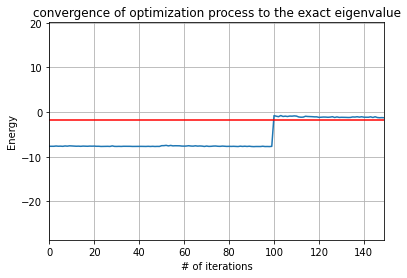

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [58]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

1it [00:00,  2.07it/s]

{'1110': 116, '0110': 130, '1111': 131, '1100': 20, '1001': 20, '1010': 218, '0100': 2, '1011': 223, '0010': 47, '1101': 20, '0111': 82, '0000': 3, '0101': 8, '1000': 2, '0011': 2}
1.0


2it [00:01,  1.78it/s]

{'1010': 236, '0010': 47, '1011': 233, '1111': 111, '1110': 107, '1101': 19, '0111': 87, '1100': 14, '0110': 142, '0101': 5, '0011': 7, '0100': 5, '1001': 8, '1000': 1, '0000': 2}
1.0


3it [00:01,  2.16it/s]

{'1111': 101, '0110': 150, '1011': 223, '0010': 54, '0111': 85, '1010': 219, '1110': 124, '1101': 24, '1001': 12, '1100': 17, '0101': 2, '0100': 4, '0000': 5, '0011': 2, '1000': 2}
1.0


4it [00:01,  2.41it/s]

{'0110': 143, '1111': 126, '1010': 240, '0010': 38, '1011': 210, '1100': 14, '1110': 111, '0111': 78, '1001': 18, '0100': 6, '0101': 6, '1101': 23, '0011': 5, '1000': 1, '0000': 5}
1.0


5it [00:02,  2.49it/s]

{'1100': 16, '1010': 201, '1111': 103, '0110': 170, '1110': 112, '0010': 50, '1011': 228, '1101': 21, '1001': 15, '0101': 5, '0100': 8, '0111': 86, '0000': 5, '1000': 3, '0011': 1}
1.0


6it [00:02,  2.28it/s]

{'1111': 96, '0110': 178, '0111': 82, '0010': 44, '1011': 235, '1010': 216, '1110': 94, '1101': 20, '1100': 21, '1001': 13, '0011': 5, '0000': 5, '0100': 8, '0001': 1, '1000': 2, '0101': 4}
1.0


7it [00:03,  2.35it/s]

{'1010': 198, '1001': 18, '0001': 1, '1011': 245, '1111': 101, '0110': 152, '0111': 93, '1110': 114, '0000': 8, '1101': 27, '0010': 36, '0100': 8, '1100': 13, '0101': 6, '1000': 3, '0011': 1}
1.0


8it [00:03,  2.31it/s]

{'0111': 93, '0010': 47, '1011': 218, '0100': 8, '1110': 124, '1111': 100, '0110': 139, '1010': 230, '1100': 19, '1001': 11, '0000': 4, '1101': 19, '0101': 6, '0011': 5, '1000': 1}
1.0


9it [00:03,  2.61it/s]

{'1100': 179, '1110': 58, '0100': 133, '1011': 165, '0110': 109, '0001': 30, '1001': 286, '0111': 8, '1101': 10, '0101': 15, '0000': 12, '0011': 3, '1010': 4, '1000': 4, '0010': 6, '1111': 2}
1.0


10it [00:04,  2.72it/s]

{'0110': 107, '1111': 102, '1110': 205, '1011': 149, '0010': 130, '0111': 160, '1010': 94, '1100': 8, '1000': 18, '1101': 5, '0101': 29, '1001': 4, '0000': 6, '0001': 3, '0011': 3, '0100': 1}
1.0


11it [00:04,  2.74it/s]

{'1110': 71, '0100': 30, '0010': 30, '1011': 35, '1100': 143, '1000': 150, '0000': 28, '1001': 45, '0101': 179, '0111': 94, '1111': 32, '0001': 60, '1010': 55, '1101': 42, '0011': 28, '0110': 2}
1.0


12it [00:04,  2.83it/s]

{'1111': 112, '0110': 158, '1110': 109, '1001': 14, '1010': 220, '0010': 40, '1011': 224, '1101': 20, '0111': 88, '1100': 13, '0000': 2, '0100': 8, '0011': 6, '0101': 10}
1.0


13it [00:05,  2.83it/s]

{'1110': 110, '1111': 93, '0110': 154, '1011': 231, '1001': 25, '1010': 224, '1101': 16, '0111': 103, '0100': 7, '1100': 15, '0010': 31, '0000': 3, '1000': 2, '0011': 3, '0101': 7}
1.0


14it [00:05,  3.04it/s]

{'0010': 53, '1011': 240, '1010': 219, '1111': 112, '0110': 149, '0111': 81, '1100': 15, '1101': 23, '1110': 98, '1001': 16, '0101': 5, '0000': 3, '0011': 5, '0100': 4, '1000': 1}
1.0


15it [00:05,  2.63it/s]


{'1101': 19, '0010': 42, '1011': 244, '1010': 217, '0110': 140, '1111': 122, '1110': 100, '0111': 86, '1001': 20, '1100': 16, '0100': 3, '1000': 1, '0101': 5, '0000': 3, '0011': 6}
1.0


1it [00:00,  2.66it/s]

{'1011': 158, '0111': 88, '1110': 110, '0101': 24, '0110': 127, '1111': 112, '1000': 119, '1010': 161, '1101': 46, '0100': 26, '1001': 12, '0010': 24, '0000': 8, '0001': 5, '0011': 2, '1100': 2}
1.0


2it [00:00,  2.76it/s]

{'0010': 36, '1011': 144, '1110': 113, '0101': 28, '1111': 116, '0110': 127, '1010': 175, '1000': 99, '1001': 19, '0111': 94, '0100': 15, '0000': 8, '1101': 42, '0001': 4, '1100': 3, '0011': 1}
1.0


3it [00:01,  2.70it/s]

{'1110': 116, '1011': 148, '0010': 40, '1010': 176, '0110': 120, '1101': 45, '0111': 94, '1000': 88, '0101': 24, '1111': 122, '1001': 25, '0011': 1, '0100': 14, '0001': 3, '0000': 7, '1100': 1}
1.0


4it [00:01,  2.75it/s]

{'1010': 161, '0110': 130, '1111': 113, '1011': 150, '0010': 43, '1101': 43, '1110': 134, '1000': 95, '0111': 92, '0100': 20, '0101': 24, '1100': 1, '1001': 13, '0011': 2, '0000': 2, '0001': 1}
1.0


5it [00:01,  2.91it/s]

{'1011': 142, '0111': 98, '1111': 103, '0110': 135, '1101': 47, '1110': 116, '1010': 179, '1000': 97, '0010': 34, '0101': 34, '0100': 14, '1001': 17, '1100': 1, '0000': 3, '0001': 2, '0011': 2}
1.0


6it [00:02,  2.91it/s]

{'1011': 164, '1000': 100, '1111': 116, '0110': 105, '0100': 23, '1101': 33, '0111': 89, '1010': 152, '1110': 120, '1001': 26, '0011': 3, '0010': 32, '0000': 16, '0101': 39, '0001': 3, '1100': 3}
1.0


7it [00:02,  2.63it/s]

{'1010': 150, '0111': 87, '0101': 30, '1110': 130, '0110': 120, '1111': 109, '1000': 104, '1101': 50, '1011': 146, '1001': 24, '0010': 40, '0100': 22, '0001': 3, '1100': 3, '0000': 4, '0011': 2}
1.0


8it [00:03,  2.29it/s]

{'1110': 112, '1011': 135, '1000': 85, '0111': 86, '0110': 124, '1111': 124, '1010': 190, '1101': 46, '0100': 25, '0101': 22, '1001': 19, '0010': 45, '0001': 4, '0000': 4, '1100': 2, '0011': 1}
1.0


9it [00:03,  2.28it/s]

{'0000': 7, '1011': 295, '0011': 19, '1100': 206, '1001': 107, '0100': 200, '1110': 43, '1111': 12, '0101': 34, '0110': 26, '1010': 44, '1101': 8, '0010': 15, '0001': 4, '0111': 3, '1000': 1}
1.0


10it [00:04,  2.24it/s]

{'1101': 51, '0100': 51, '1110': 210, '0101': 7, '0111': 163, '1010': 81, '0010': 139, '1011': 88, '0110': 61, '1111': 82, '0000': 20, '1000': 34, '0001': 17, '1001': 15, '0011': 3, '1100': 2}
1.0


11it [00:04,  2.17it/s]

{'0010': 39, '1111': 100, '0101': 87, '0111': 140, '1010': 18, '1100': 177, '0011': 81, '1000': 175, '1110': 70, '0110': 29, '0000': 44, '1011': 22, '1001': 31, '0100': 6, '0001': 2, '1101': 3}
1.0


12it [00:05,  2.15it/s]

{'0010': 41, '1011': 138, '1010': 179, '0111': 88, '1000': 86, '1111': 103, '1110': 114, '1101': 42, '1001': 31, '0110': 127, '0101': 33, '0100': 27, '0011': 1, '0000': 8, '0001': 4, '1100': 2}
1.0


13it [00:05,  2.20it/s]

{'1111': 103, '0110': 130, '1010': 182, '1000': 99, '1110': 117, '0010': 35, '1011': 128, '0100': 20, '1101': 38, '0111': 93, '0101': 40, '1001': 21, '0011': 4, '0001': 4, '0000': 10}
1.0


14it [00:05,  2.27it/s]

{'1011': 153, '0010': 37, '0111': 91, '1110': 114, '1000': 105, '1101': 38, '1111': 106, '0001': 4, '0110': 122, '1010': 179, '1001': 19, '0100': 27, '0101': 23, '1100': 1, '0000': 4, '0011': 1}
1.0


15it [00:06,  2.41it/s]


{'1110': 89, '0000': 7, '1000': 104, '0111': 104, '1001': 19, '1010': 172, '1011': 138, '0010': 29, '1111': 125, '0110': 140, '0101': 27, '1101': 46, '0100': 21, '1100': 2, '0001': 1}
1.0


1it [00:00,  3.58it/s]

{'0101': 45, '1110': 276, '0111': 124, '1000': 139, '0110': 90, '1010': 87, '1011': 127, '1100': 19, '0100': 16, '1111': 48, '0010': 17, '1101': 10, '1001': 15, '0000': 7, '0001': 4}
1.0


2it [00:00,  4.15it/s]

{'1010': 113, '0111': 126, '1111': 32, '0110': 97, '1011': 157, '1110': 275, '1000': 104, '1100': 18, '0101': 36, '0010': 18, '0100': 15, '0001': 7, '1101': 12, '1001': 11, '0000': 3}
1.0


3it [00:00,  4.17it/s]

{'1001': 12, '0010': 10, '1011': 179, '0111': 116, '0110': 82, '1000': 110, '1110': 297, '1101': 6, '1010': 106, '1111': 28, '0100': 18, '1100': 12, '0000': 11, '0001': 4, '0101': 32, '0011': 1}
1.0


4it [00:01,  3.85it/s]

{'0111': 144, '0110': 100, '1111': 32, '1000': 112, '1110': 284, '0010': 14, '1011': 146, '1010': 93, '0100': 20, '0101': 29, '1100': 15, '0011': 1, '1001': 19, '0000': 8, '0001': 4, '1101': 3}
1.0


5it [00:01,  3.37it/s]

{'0101': 33, '1110': 284, '0111': 116, '1010': 118, '1000': 112, '0110': 86, '1011': 165, '1100': 13, '0010': 16, '1001': 12, '1111': 36, '0001': 7, '1101': 7, '0100': 15, '0011': 1, '0000': 3}
1.0


6it [00:01,  3.35it/s]

{'0101': 46, '1110': 276, '0111': 127, '1010': 114, '0100': 12, '1000': 119, '1111': 35, '0110': 87, '1011': 140, '1101': 7, '1100': 19, '0000': 5, '0010': 20, '1001': 11, '0001': 6}
1.0


7it [00:02,  3.08it/s]

{'0110': 88, '1000': 122, '1011': 135, '0111': 128, '1100': 19, '0101': 41, '1110': 286, '1010': 112, '1001': 18, '1111': 36, '0010': 8, '0000': 4, '0100': 10, '1101': 7, '0001': 7, '0011': 3}
1.0


8it [00:02,  2.91it/s]

{'1111': 31, '1000': 121, '0101': 32, '1110': 294, '1010': 105, '0100': 20, '0010': 11, '1011': 159, '0111': 118, '1001': 19, '0110': 79, '1101': 10, '1100': 11, '0001': 5, '0000': 8, '0011': 1}
1.0


9it [00:02,  2.85it/s]

{'1100': 190, '0100': 231, '1101': 77, '1010': 31, '1001': 92, '1011': 232, '0110': 32, '0101': 16, '1110': 38, '0011': 19, '1111': 48, '1000': 4, '0010': 4, '0000': 9, '0001': 1}
1.0


10it [00:03,  2.92it/s]

{'1110': 219, '1010': 117, '1000': 72, '1011': 198, '0010': 134, '0011': 32, '0111': 56, '0110': 26, '1111': 33, '0100': 43, '1101': 32, '0001': 24, '0000': 26, '1100': 2, '1001': 10}
1.0


11it [00:03,  3.05it/s]

{'0001': 71, '1001': 116, '1000': 197, '0011': 116, '1100': 164, '1011': 58, '0010': 11, '1110': 63, '0111': 84, '0110': 18, '1111': 59, '0100': 15, '1010': 15, '0000': 26, '0101': 11}
1.0


12it [00:03,  2.91it/s]

{'0101': 42, '1110': 274, '1000': 113, '1010': 105, '0110': 79, '1111': 48, '1011': 153, '0111': 124, '0010': 20, '1100': 15, '0100': 15, '1001': 20, '0000': 3, '0001': 7, '1101': 5, '0011': 1}
1.0


13it [00:04,  2.97it/s]

{'1110': 286, '0101': 43, '1100': 9, '1011': 157, '0110': 98, '0000': 3, '1010': 111, '0111': 112, '1000': 123, '1001': 15, '1111': 30, '0100': 13, '0001': 9, '0010': 7, '1101': 8}
1.0


14it [00:04,  2.57it/s]

{'0101': 45, '1110': 287, '1011': 162, '1010': 97, '0111': 122, '1000': 110, '1111': 32, '1101': 5, '0110': 99, '1100': 12, '0010': 10, '0011': 2, '1001': 11, '0000': 10, '0100': 13, '0001': 7}
1.0


15it [00:05,  2.95it/s]


{'0110': 101, '1111': 51, '1100': 18, '0101': 31, '1110': 261, '1000': 114, '1010': 104, '1011': 158, '0111': 124, '0010': 12, '1101': 10, '0001': 6, '0100': 14, '0000': 4, '1001': 16}
1.0


1it [00:00,  2.61it/s]

{'1110': 272, '0110': 92, '0001': 22, '1010': 137, '1011': 113, '1000': 96, '0100': 25, '0011': 136, '0111': 34, '0101': 25, '1111': 37, '1101': 10, '1100': 10, '0010': 6, '1001': 9}
1.0


2it [00:00,  2.37it/s]

{'0011': 129, '0110': 95, '1111': 28, '1000': 123, '1010': 117, '0001': 31, '1110': 271, '0101': 28, '1011': 103, '0010': 22, '0111': 29, '0100': 20, '1101': 7, '1100': 15, '1001': 5, '0000': 1}
1.0


3it [00:01,  2.24it/s]

{'0011': 124, '0101': 24, '1110': 251, '1011': 118, '0110': 97, '1000': 103, '0001': 38, '1010': 113, '0100': 23, '1111': 53, '0111': 37, '1100': 14, '0010': 9, '0000': 6, '1001': 7, '1101': 7}
1.0


4it [00:01,  2.23it/s]

{'1110': 293, '0011': 125, '1010': 104, '1011': 112, '0010': 12, '1000': 107, '0100': 24, '0111': 33, '0110': 101, '0001': 21, '0101': 36, '1111': 29, '1001': 9, '1101': 6, '1100': 8, '0000': 4}
1.0


5it [00:02,  2.26it/s]

{'1000': 115, '0011': 131, '0101': 21, '1110': 281, '1010': 109, '0111': 30, '1011': 106, '0110': 98, '1100': 12, '1001': 6, '1111': 44, '0001': 20, '0100': 29, '0010': 10, '1101': 9, '0000': 3}
1.0


6it [00:02,  2.38it/s]

{'1000': 114, '0011': 132, '1100': 10, '0111': 25, '1010': 127, '0110': 101, '1011': 123, '1110': 270, '1001': 8, '0001': 11, '0010': 10, '1111': 35, '0101': 26, '0100': 22, '0000': 4, '1101': 6}
1.0


7it [00:03,  2.35it/s]

{'0110': 107, '1111': 49, '1000': 101, '1011': 120, '1110': 286, '0101': 28, '1010': 114, '0011': 106, '0001': 20, '0010': 15, '0100': 17, '1101': 13, '0000': 3, '1100': 12, '0111': 27, '1001': 6}
1.0


8it [00:03,  2.25it/s]

{'0110': 95, '1111': 31, '1000': 118, '1011': 121, '0101': 27, '1110': 271, '0011': 122, '1010': 117, '0111': 26, '1001': 4, '0100': 25, '0010': 15, '0001': 25, '1101': 12, '1100': 13, '0000': 2}
1.0


9it [00:03,  2.19it/s]

{'1101': 70, '0100': 143, '0101': 17, '1100': 174, '0011': 70, '1011': 210, '1010': 58, '1001': 87, '0110': 15, '0000': 13, '1111': 50, '1110': 49, '0001': 48, '0111': 4, '0010': 11, '1000': 5}
1.0


10it [00:04,  1.99it/s]

{'0010': 66, '1000': 83, '0000': 27, '1110': 262, '0001': 10, '1010': 136, '0011': 105, '0110': 36, '0111': 33, '0100': 25, '1011': 160, '1001': 17, '0101': 6, '1101': 41, '1111': 12, '1100': 5}
1.0


11it [00:05,  1.68it/s]

{'1100': 116, '0110': 65, '1111': 151, '0111': 50, '1110': 34, '0100': 5, '1000': 200, '1001': 104, '0011': 94, '0001': 89, '1011': 57, '0010': 15, '1010': 8, '1101': 30, '0101': 6}
1.0


12it [00:05,  1.84it/s]

{'0101': 26, '1110': 268, '0100': 26, '0011': 133, '1000': 109, '1010': 125, '0001': 27, '1011': 116, '0110': 90, '1111': 40, '0111': 21, '1100': 18, '0010': 12, '1101': 9, '0000': 3, '1001': 1}
1.0


13it [00:06,  1.99it/s]

{'0011': 123, '1010': 120, '0001': 17, '1110': 289, '1000': 106, '0010': 21, '1011': 113, '0110': 93, '0000': 3, '0100': 24, '1111': 35, '1100': 14, '1101': 11, '0101': 23, '0111': 26, '1001': 6}
1.0


14it [00:06,  2.08it/s]

{'1110': 291, '1011': 122, '1101': 10, '1000': 124, '0110': 104, '1010': 93, '1100': 10, '0011': 103, '1001': 9, '0111': 30, '0010': 19, '0001': 20, '0101': 21, '0000': 2, '0100': 17, '1111': 49}
1.0


15it [00:07,  2.11it/s]


{'1000': 109, '1100': 13, '0011': 135, '1011': 114, '0010': 16, '1010': 120, '0111': 24, '1110': 281, '0110': 97, '0101': 25, '0100': 27, '1001': 5, '0001': 15, '0000': 5, '1111': 33, '1101': 5}
1.0


1it [00:00,  2.09it/s]

{'0001': 50, '1010': 30, '1110': 203, '0101': 44, '0110': 163, '0111': 96, '0010': 116, '0000': 19, '0011': 161, '0100': 54, '1111': 10, '1000': 43, '1100': 16, '1101': 3, '1011': 16}
1.0


2it [00:00,  2.40it/s]

{'0000': 34, '1000': 35, '1110': 233, '0001': 46, '0110': 177, '0010': 98, '1100': 23, '0100': 48, '0011': 136, '1010': 30, '0111': 103, '1011': 13, '1111': 4, '0101': 40, '1101': 4}
1.0


3it [00:01,  2.24it/s]

{'1110': 217, '0001': 48, '1010': 38, '0110': 184, '0011': 159, '0111': 101, '0100': 39, '0010': 106, '1011': 16, '0000': 19, '1100': 16, '0101': 36, '1000': 40, '1111': 5}
1.0


4it [00:01,  2.45it/s]

{'1110': 198, '0111': 78, '0011': 188, '0010': 118, '1000': 36, '0100': 48, '0110': 193, '1010': 35, '0101': 44, '0001': 30, '0000': 19, '1011': 12, '1100': 17, '1111': 7, '1101': 1}
1.0


5it [00:02,  2.46it/s]

{'0010': 121, '0110': 185, '0111': 98, '0101': 47, '1110': 210, '0001': 39, '0011': 167, '1000': 34, '0100': 43, '1010': 32, '1101': 3, '1011': 10, '0000': 16, '1100': 13, '1111': 6}
1.0


6it [00:02,  2.41it/s]

{'0111': 91, '1100': 21, '0011': 147, '0110': 186, '1110': 242, '1010': 21, '1000': 40, '0010': 99, '0101': 55, '1011': 12, '0000': 21, '0001': 38, '0100': 39, '1101': 4, '1111': 8}
1.0


7it [00:02,  2.69it/s]

{'0010': 119, '0101': 49, '1110': 200, '0011': 167, '1100': 18, '0111': 98, '0110': 178, '1000': 37, '1111': 12, '0000': 27, '1011': 14, '1010': 34, '0001': 36, '0100': 34, '1101': 1}
1.0


8it [00:03,  2.79it/s]

{'0011': 134, '1000': 50, '0110': 209, '0111': 81, '0101': 46, '1110': 214, '1010': 24, '0010': 114, '0001': 38, '0000': 32, '0100': 40, '1100': 18, '1111': 10, '1011': 10, '1101': 4}
1.0


9it [00:03,  2.77it/s]

{'0001': 98, '1001': 31, '1100': 114, '0011': 221, '0100': 267, '1110': 23, '0101': 63, '0111': 21, '1111': 28, '1101': 67, '0000': 11, '0110': 27, '0010': 2, '1010': 17, '1011': 33, '1000': 1}
1.0


10it [00:03,  2.96it/s]

{'0100': 24, '1101': 28, '1010': 97, '1110': 375, '0111': 33, '1000': 89, '0110': 32, '1111': 6, '1011': 93, '0011': 99, '0010': 65, '0001': 19, '0000': 17, '1001': 33, '0101': 11, '1100': 3}
1.0


11it [00:04,  3.16it/s]

{'1111': 136, '1001': 79, '0001': 92, '1000': 216, '0000': 17, '0100': 7, '0101': 41, '1100': 160, '0111': 53, '0011': 75, '0010': 15, '0110': 15, '1101': 75, '1110': 31, '1011': 3, '1010': 9}
1.0


12it [00:04,  3.05it/s]

{'0110': 183, '0101': 46, '1110': 211, '1010': 36, '0011': 154, '0100': 44, '0000': 25, '0010': 114, '0001': 42, '0111': 98, '1011': 17, '1000': 31, '1100': 14, '1111': 7, '1101': 2}
1.0


13it [00:04,  3.00it/s]

{'0110': 196, '0111': 99, '1110': 207, '0101': 44, '0001': 45, '0010': 119, '0000': 28, '0011': 153, '1010': 24, '0100': 36, '1011': 15, '1000': 34, '1111': 7, '1001': 1, '1100': 14, '1101': 2}
1.0


14it [00:05,  3.06it/s]

{'0000': 31, '0011': 163, '1110': 192, '1011': 16, '0010': 112, '0110': 203, '0111': 81, '0001': 43, '1010': 36, '1000': 42, '0100': 40, '1111': 7, '0101': 47, '1100': 11}
1.0


15it [00:05,  2.71it/s]


{'0001': 46, '1010': 28, '1110': 230, '1100': 26, '0011': 172, '0110': 186, '0000': 14, '0010': 89, '0101': 51, '0111': 79, '1000': 35, '0100': 42, '1111': 9, '1011': 15, '1101': 2}
1.0


1it [00:00,  2.33it/s]

{'0010': 127, '0011': 149, '0110': 218, '0111': 98, '0101': 35, '1110': 221, '1000': 36, '0000': 23, '1101': 6, '1010': 31, '0100': 10, '0001': 19, '1011': 23, '1100': 16, '1111': 11, '1001': 1}
1.0


2it [00:00,  2.61it/s]

{'0101': 33, '1110': 217, '1010': 37, '0110': 211, '0111': 96, '1100': 18, '0011': 154, '0010': 125, '1000': 33, '0001': 28, '0000': 19, '1011': 21, '0100': 14, '1111': 7, '1101': 11}
1.0


3it [00:01,  2.23it/s]

{'0010': 126, '0011': 151, '1100': 20, '0111': 104, '1110': 212, '0110': 190, '1000': 43, '1101': 6, '0001': 37, '0101': 38, '1010': 33, '0000': 27, '1011': 15, '1111': 11, '0100': 11}
1.0


4it [00:01,  2.09it/s]

{'0010': 123, '0101': 26, '1110': 207, '0011': 176, '0110': 208, '1000': 36, '0001': 37, '1010': 34, '0000': 15, '1011': 25, '0111': 96, '1101': 4, '0100': 12, '1100': 15, '1111': 9, '1001': 1}
1.0


5it [00:02,  1.99it/s]

{'0011': 157, '0000': 23, '0101': 46, '1110': 226, '0100': 8, '1010': 31, '0110': 199, '1011': 19, '0001': 35, '0010': 107, '0111': 100, '1000': 44, '1100': 21, '1111': 7, '1101': 1}
1.0


6it [00:02,  2.26it/s]

{'1011': 19, '0010': 118, '1110': 219, '0001': 29, '0111': 114, '0000': 24, '0110': 205, '0100': 19, '1101': 6, '1010': 35, '0101': 36, '0011': 149, '1000': 28, '1111': 11, '1100': 10, '1001': 2}
1.0


7it [00:03,  2.23it/s]

{'0110': 214, '1110': 233, '0000': 14, '1000': 33, '1101': 10, '0011': 171, '0111': 108, '0010': 113, '1011': 15, '0001': 33, '1010': 20, '0101': 27, '1100': 18, '0100': 12, '1111': 3}
1.0


8it [00:03,  2.07it/s]

{'1110': 218, '0011': 164, '0111': 98, '0110': 210, '1000': 38, '0010': 128, '0100': 22, '0001': 22, '1101': 5, '1111': 7, '0000': 28, '1100': 11, '1010': 34, '0101': 25, '1011': 14}
1.0


9it [00:04,  2.12it/s]

{'1111': 48, '0110': 66, '0001': 111, '0100': 230, '1110': 34, '0011': 189, '1100': 120, '1011': 11, '0111': 33, '0000': 12, '1001': 46, '1101': 67, '1000': 7, '1010': 18, '0101': 30, '0010': 2}
1.0


10it [00:04,  1.95it/s]

{'1011': 141, '0011': 120, '1110': 352, '1010': 97, '1001': 24, '0000': 11, '0110': 49, '0111': 38, '1000': 73, '1111': 5, '1101': 21, '0010': 62, '0100': 5, '0101': 10, '0001': 16}
1.0


11it [00:05,  2.05it/s]

{'1111': 172, '1100': 115, '0011': 61, '1000': 236, '1110': 54, '1001': 60, '1010': 30, '0010': 18, '0111': 66, '0000': 23, '1101': 51, '0001': 98, '0101': 31, '0100': 7, '1011': 2}
1.0


12it [00:05,  2.07it/s]

{'0110': 222, '1000': 39, '1110': 211, '0101': 32, '0010': 131, '1010': 30, '0011': 186, '0111': 85, '0001': 23, '1100': 12, '1111': 10, '1011': 12, '0000': 17, '0100': 10, '1101': 3, '1001': 1}
1.0


13it [00:06,  1.95it/s]

{'0001': 30, '1010': 29, '0110': 205, '1110': 232, '0011': 150, '0111': 94, '1000': 35, '0010': 142, '0101': 37, '1011': 18, '1100': 13, '0000': 14, '1111': 12, '0100': 9, '1101': 4}
1.0


14it [00:06,  2.13it/s]

{'1010': 35, '0010': 121, '1111': 6, '0110': 245, '0101': 29, '1110': 191, '0111': 89, '0011': 161, '0000': 17, '0001': 30, '1000': 40, '1100': 27, '1011': 12, '1101': 7, '0100': 13, '1001': 1}
1.0


15it [00:06,  2.19it/s]


{'1110': 229, '0010': 117, '0111': 85, '1100': 21, '0011': 176, '0110': 217, '0001': 34, '1010': 31, '1000': 34, '0101': 28, '0100': 9, '1111': 4, '1011': 9, '0000': 25, '1101': 4, '1001': 1}
1.0


1it [00:00,  2.34it/s]

{'0111': 78, '0110': 227, '1110': 164, '0010': 164, '0011': 171, '1101': 11, '0000': 8, '0001': 21, '1000': 24, '1100': 14, '1010': 26, '0101': 24, '1011': 26, '1111': 54, '0100': 9, '1001': 3}
1.0


2it [00:00,  2.28it/s]

{'0011': 165, '1111': 63, '0110': 219, '1110': 156, '0111': 95, '0010': 139, '1001': 2, '0001': 21, '1011': 41, '0101': 34, '1000': 18, '1100': 8, '0100': 12, '1101': 7, '0000': 16, '1010': 28}
1.0


3it [00:01,  2.38it/s]

{'1011': 33, '0010': 168, '0110': 210, '0011': 166, '1000': 16, '0000': 19, '0111': 95, '1110': 166, '1100': 13, '1010': 24, '1111': 51, '0101': 27, '0001': 16, '1101': 7, '1001': 3, '0100': 10}
1.0


4it [00:01,  2.22it/s]

{'0110': 226, '1000': 26, '0000': 18, '0010': 137, '1011': 37, '0011': 163, '1110': 168, '0100': 14, '0111': 91, '0101': 30, '1101': 10, '1100': 12, '1111': 54, '1001': 2, '1010': 27, '0001': 9}
1.0


5it [00:02,  2.38it/s]

{'0110': 208, '1111': 69, '0001': 12, '1010': 31, '0111': 85, '0011': 189, '0010': 151, '1110': 152, '1011': 24, '0101': 35, '0000': 20, '1101': 6, '1000': 22, '0100': 8, '1100': 10, '1001': 2}
1.0


6it [00:02,  2.39it/s]

{'1111': 50, '0110': 225, '0101': 33, '1110': 163, '0011': 178, '0001': 18, '0111': 76, '0010': 158, '1000': 27, '0000': 11, '1011': 34, '1010': 24, '1101': 4, '0100': 12, '1100': 10, '1001': 1}
1.0


7it [00:02,  2.51it/s]

{'0000': 18, '0011': 156, '0010': 133, '1111': 63, '0110': 247, '1110': 148, '0111': 99, '1010': 21, '0101': 34, '1100': 15, '0100': 15, '1011': 33, '1101': 7, '0001': 17, '1000': 18}
1.0


8it [00:03,  2.58it/s]

{'0101': 28, '1110': 162, '0000': 24, '0010': 139, '0111': 67, '0110': 222, '1010': 26, '0011': 178, '1000': 24, '1111': 62, '1011': 35, '0001': 24, '1100': 10, '0100': 12, '1101': 10, '1001': 1}
1.0


9it [00:03,  2.41it/s]

{'1100': 132, '0011': 165, '0110': 40, '0111': 64, '0001': 133, '1010': 25, '1101': 59, '1110': 46, '0101': 48, '0000': 25, '0100': 182, '1001': 42, '0010': 27, '1111': 13, '1011': 23}
1.0


10it [00:04,  2.44it/s]

{'0010': 70, '1011': 177, '1111': 7, '1110': 329, '0100': 13, '0011': 55, '1001': 26, '1010': 79, '1000': 67, '0111': 89, '0101': 16, '0110': 65, '0001': 9, '1101': 15, '0000': 7}
1.0


11it [00:04,  2.27it/s]

{'0111': 104, '1000': 185, '1010': 56, '0001': 58, '1100': 134, '0110': 7, '1111': 118, '0101': 88, '1001': 80, '1101': 41, '1110': 69, '0011': 35, '0000': 18, '0010': 23, '1011': 4, '0100': 4}
1.0


12it [00:05,  2.37it/s]

{'0101': 34, '0110': 225, '0010': 132, '1100': 10, '0011': 167, '1001': 5, '0001': 21, '0111': 94, '1010': 20, '1110': 161, '1111': 61, '0000': 15, '0100': 14, '1011': 31, '1000': 26, '1101': 8}
1.0


13it [00:05,  2.21it/s]

{'1111': 54, '0110': 245, '0111': 74, '1011': 45, '0010': 143, '1000': 15, '0011': 165, '1010': 27, '1110': 149, '1101': 9, '0001': 21, '0101': 25, '0000': 20, '1100': 9, '1001': 4, '0100': 19}
1.0


14it [00:05,  2.31it/s]

{'1111': 72, '0110': 229, '0111': 88, '1110': 159, '1010': 30, '0011': 166, '1011': 34, '0100': 9, '0010': 135, '1000': 24, '0101': 31, '1101': 8, '0000': 19, '0001': 12, '1100': 8}
1.0


15it [00:06,  2.38it/s]


{'1110': 169, '1111': 52, '0110': 204, '1100': 12, '0011': 176, '1101': 15, '0111': 84, '0010': 150, '1010': 26, '1000': 22, '0001': 20, '0000': 23, '1011': 27, '0100': 14, '0101': 28, '1001': 2}
1.0


1it [00:00,  1.76it/s]

{'1110': 213, '0101': 56, '0011': 167, '1100': 25, '0010': 66, '0111': 101, '0110': 278, '1010': 8, '1101': 14, '0100': 21, '1000': 33, '0001': 22, '1111': 13, '1011': 1, '0000': 5, '1001': 1}
1.0


2it [00:01,  1.51it/s]

{'0010': 60, '1110': 198, '0011': 220, '1100': 13, '0111': 105, '1111': 17, '0110': 270, '1101': 6, '1000': 30, '0101': 50, '1001': 3, '0000': 4, '0001': 17, '0100': 19, '1010': 12}
1.0


3it [00:01,  1.81it/s]

{'0110': 286, '0101': 42, '1110': 224, '0010': 64, '1000': 35, '0011': 176, '0100': 19, '0111': 97, '1010': 24, '1100': 13, '1111': 15, '1101': 5, '0001': 19, '1011': 1, '1001': 3, '0000': 1}
1.0


4it [00:02,  2.20it/s]

{'0110': 300, '1110': 218, '0000': 4, '1000': 30, '0010': 65, '1010': 18, '0011': 155, '1100': 24, '1111': 16, '0111': 100, '0101': 43, '0001': 20, '0100': 15, '1101': 13, '1011': 3}
1.0


5it [00:02,  2.21it/s]

{'1110': 205, '0101': 56, '0111': 74, '0110': 308, '0011': 180, '0000': 6, '0100': 20, '0010': 69, '1010': 21, '1000': 20, '1100': 18, '0001': 23, '1001': 2, '1111': 12, '1101': 9, '1011': 1}
1.0


6it [00:02,  2.22it/s]

{'0110': 272, '0101': 52, '1110': 234, '0111': 104, '1100': 26, '0011': 171, '0001': 18, '1000': 26, '1101': 13, '1111': 16, '0010': 45, '1010': 20, '0100': 21, '1001': 2, '0000': 4}
1.0


7it [00:03,  2.29it/s]

{'1111': 8, '0110': 281, '1110': 217, '1000': 23, '0011': 183, '0111': 113, '1010': 23, '0010': 64, '0101': 40, '1100': 19, '0100': 13, '1101': 12, '0001': 23, '0000': 2, '1011': 2, '1001': 1}
1.0


8it [00:03,  2.37it/s]

{'1110': 217, '1100': 19, '0011': 172, '1111': 11, '0110': 268, '0111': 114, '0010': 74, '0100': 21, '1000': 36, '0000': 4, '0001': 20, '0101': 42, '1010': 12, '1011': 2, '1101': 12}
1.0


9it [00:04,  2.30it/s]

{'1010': 10, '1110': 32, '0100': 329, '1101': 56, '0011': 111, '1100': 143, '0110': 75, '0111': 32, '0000': 48, '0001': 101, '1000': 26, '1111': 22, '0101': 11, '0010': 8, '1001': 18, '1011': 2}
1.0


10it [00:04,  2.28it/s]

{'1011': 146, '1010': 211, '0101': 5, '1110': 331, '1000': 59, '0110': 32, '1101': 33, '0011': 106, '1001': 31, '0010': 30, '0111': 18, '1111': 3, '1100': 2, '0001': 9, '0100': 2, '0000': 6}
1.0


11it [00:05,  2.30it/s]

{'1000': 352, '1101': 45, '0011': 16, '1100': 169, '1111': 127, '1010': 41, '1110': 56, '0111': 20, '0001': 69, '0101': 14, '0010': 23, '1001': 47, '0100': 19, '0000': 24, '0110': 2}
1.0


12it [00:05,  2.33it/s]

{'0010': 54, '1111': 6, '0110': 278, '1110': 234, '0111': 123, '1100': 14, '0011': 186, '1000': 30, '1010': 14, '0101': 44, '0001': 22, '0100': 12, '1101': 6, '0000': 1}
1.0


13it [00:06,  2.05it/s]

{'1110': 235, '0110': 261, '0111': 116, '1101': 11, '0100': 20, '0011': 185, '1100': 21, '0010': 51, '1111': 14, '1010': 17, '0101': 49, '1000': 25, '0001': 14, '0000': 4, '1001': 1}
1.0


14it [00:06,  2.18it/s]

{'0011': 158, '0110': 302, '1110': 227, '0111': 108, '0010': 57, '1010': 18, '0001': 22, '1000': 29, '0101': 50, '1101': 7, '1111': 14, '1001': 2, '1100': 17, '0000': 2, '0100': 11}
1.0


15it [00:06,  2.17it/s]


{'0110': 279, '0011': 182, '1100': 16, '0101': 51, '1110': 251, '0010': 45, '1010': 15, '0100': 27, '1000': 29, '0111': 93, '0001': 18, '0000': 2, '1101': 4, '1111': 11, '1011': 1}
1.0


1it [00:00,  2.79it/s]

{'0111': 206, '0001': 12, '1010': 85, '0110': 243, '1110': 135, '0101': 59, '1000': 14, '0011': 80, '0010': 42, '1100': 17, '1011': 96, '1101': 11, '1001': 4, '0000': 7, '0100': 13}
1.0


2it [00:00,  2.48it/s]

{'1100': 14, '0011': 91, '1011': 105, '0111': 206, '0110': 256, '1101': 13, '1010': 80, '1110': 133, '1000': 20, '0001': 15, '0101': 35, '1001': 3, '0010': 33, '0100': 14, '0000': 4, '1111': 2}
1.0


3it [00:01,  2.44it/s]

{'0011': 77, '0111': 221, '0110': 261, '1010': 80, '1011': 82, '0010': 40, '0101': 55, '1110': 118, '1000': 24, '1001': 3, '0100': 12, '1100': 21, '0001': 15, '1101': 11, '0000': 4}
1.0


4it [00:02,  1.68it/s]

{'0011': 83, '1100': 19, '0101': 50, '0111': 201, '0110': 233, '1011': 98, '1000': 30, '1010': 87, '1110': 140, '0001': 13, '0100': 10, '0010': 45, '1101': 8, '1001': 6, '1111': 1}
1.0


5it [00:02,  1.75it/s]

{'0110': 258, '0011': 77, '1011': 96, '0111': 210, '1010': 94, '1110': 122, '0101': 40, '0000': 6, '1000': 18, '0010': 44, '0001': 13, '1101': 6, '1100': 20, '0100': 16, '1111': 2, '1001': 2}
1.0


6it [00:03,  1.93it/s]

{'0110': 213, '1110': 133, '0111': 213, '0100': 17, '1100': 18, '0011': 100, '0010': 41, '1000': 30, '0101': 56, '1010': 88, '1011': 87, '0000': 5, '1101': 8, '1001': 4, '0001': 11}
1.0


7it [00:03,  1.98it/s]

{'0101': 44, '1110': 147, '0111': 201, '1001': 2, '1010': 78, '0011': 86, '1011': 97, '0110': 242, '0001': 12, '0000': 5, '1100': 15, '1000': 25, '0010': 45, '1111': 1, '1101': 12, '0100': 12}
1.0


8it [00:03,  2.02it/s]

{'0111': 217, '1110': 127, '0101': 51, '1000': 21, '0011': 102, '1100': 14, '1010': 71, '0110': 219, '1011': 105, '0001': 10, '0010': 53, '0100': 13, '1101': 13, '0000': 5, '1001': 3}
1.0


9it [00:04,  2.32it/s]

{'1111': 38, '0110': 91, '1101': 47, '0100': 407, '0001': 49, '1001': 71, '0000': 51, '1011': 73, '1100': 65, '1110': 5, '1010': 38, '0010': 33, '0101': 20, '0011': 12, '1000': 13, '0111': 11}
1.0


10it [00:04,  2.41it/s]

{'0010': 48, '1011': 56, '0011': 263, '0110': 71, '1010': 235, '0000': 13, '1000': 21, '1110': 146, '1001': 40, '1100': 10, '1101': 9, '0101': 13, '1111': 62, '0100': 16, '0111': 11, '0001': 10}
1.0


11it [00:05,  2.49it/s]

{'0000': 71, '1000': 228, '0001': 168, '1011': 41, '0011': 64, '0111': 27, '0110': 14, '1101': 13, '1100': 151, '1110': 53, '0101': 13, '0010': 71, '0100': 52, '1010': 17, '1001': 32, '1111': 9}
1.0


12it [00:05,  2.31it/s]

{'1011': 109, '1100': 24, '0011': 83, '0001': 18, '1010': 83, '0110': 247, '0101': 43, '0111': 211, '1110': 131, '0010': 37, '1000': 21, '0100': 6, '1001': 4, '1101': 5, '0000': 2}
1.0


13it [00:06,  2.15it/s]

{'0001': 12, '1010': 86, '0111': 216, '0110': 238, '1110': 136, '0010': 34, '1011': 90, '0100': 12, '0011': 107, '1100': 10, '1000': 15, '1001': 9, '0101': 44, '0000': 8, '1101': 6, '1111': 1}
1.0


14it [00:06,  2.06it/s]

{'0110': 241, '1010': 79, '0111': 213, '0011': 91, '1100': 14, '1110': 136, '0010': 49, '1011': 88, '1000': 22, '0000': 5, '1111': 3, '0101': 48, '0001': 13, '0100': 9, '1101': 7, '1001': 6}
1.0


15it [00:07,  2.11it/s]


{'0110': 239, '1110': 145, '0101': 47, '0111': 209, '1010': 90, '0011': 94, '1011': 77, '0010': 37, '1100': 19, '0100': 15, '1000': 21, '1101': 9, '0001': 13, '1111': 1, '1001': 5, '0000': 3}
1.0


1it [00:00,  2.92it/s]

{'0101': 134, '1110': 163, '0111': 61, '0110': 231, '1100': 55, '0011': 139, '0010': 74, '1101': 48, '1010': 5, '1000': 40, '1011': 2, '0100': 47, '0001': 4, '0000': 11, '1111': 10}
1.0


2it [00:00,  2.76it/s]

{'1000': 41, '1110': 142, '0101': 129, '1100': 46, '0011': 114, '0100': 50, '0110': 241, '0010': 77, '1101': 60, '0111': 73, '1111': 20, '0000': 13, '1010': 9, '0001': 5, '1001': 2, '1011': 2}
1.0


3it [00:01,  2.68it/s]

{'0101': 136, '1110': 157, '0110': 211, '0011': 141, '1000': 47, '0111': 69, '1101': 52, '0100': 68, '1111': 15, '1100': 49, '1010': 10, '0000': 12, '0010': 54, '1001': 1, '0001': 2}
1.0


4it [00:01,  2.64it/s]

{'0110': 239, '0101': 157, '1110': 159, '1100': 42, '0011': 140, '1101': 50, '0010': 56, '0111': 75, '0100': 42, '1000': 30, '0001': 4, '1010': 11, '0000': 6, '1111': 13}
1.0


5it [00:01,  2.75it/s]

{'0111': 62, '1111': 16, '0110': 218, '1110': 142, '0101': 140, '0011': 149, '1100': 55, '1000': 43, '0010': 76, '1101': 50, '0100': 49, '0000': 15, '1001': 3, '0001': 1, '1010': 5}
1.0


6it [00:02,  2.89it/s]

{'1000': 28, '1110': 136, '0101': 163, '0110': 214, '0011': 133, '1101': 63, '0100': 50, '0010': 88, '1111': 17, '0111': 66, '1100': 50, '1010': 2, '0000': 13, '0001': 1}
1.0


7it [00:02,  3.01it/s]

{'0010': 73, '1110': 148, '0101': 114, '0110': 255, '1000': 46, '0001': 4, '0011': 110, '1101': 40, '0100': 56, '1100': 58, '0111': 79, '1010': 13, '0000': 14, '1011': 3, '1111': 10, '1001': 1}
1.0


8it [00:02,  2.93it/s]

{'0111': 83, '1100': 48, '0011': 148, '0010': 88, '1101': 44, '0101': 130, '1110': 126, '0110': 243, '0100': 37, '0000': 12, '1111': 19, '1000': 37, '1010': 4, '0001': 4, '1011': 1}
1.0


9it [00:03,  2.94it/s]

{'0111': 68, '0100': 408, '1100': 177, '0001': 122, '1111': 51, '1000': 20, '0010': 23, '1110': 11, '0011': 85, '0110': 12, '1001': 15, '1010': 7, '0000': 3, '0101': 1, '1101': 19, '1011': 2}
1.0


10it [00:03,  2.93it/s]

{'1110': 255, '1010': 116, '0110': 55, '0011': 77, '1100': 43, '1101': 108, '1000': 68, '1011': 123, '0010': 11, '1001': 97, '0000': 31, '0111': 11, '0101': 12, '0100': 14, '0001': 1, '1111': 2}
1.0


11it [00:03,  2.75it/s]

{'0001': 97, '1000': 320, '1101': 28, '0100': 40, '1111': 157, '1011': 52, '0111': 21, '1100': 222, '0010': 25, '0101': 33, '1001': 7, '1110': 6, '1010': 4, '0011': 6, '0000': 2, '0110': 4}
1.0


12it [00:04,  2.58it/s]

{'0101': 129, '1110': 142, '0110': 238, '0010': 79, '1100': 39, '0011': 136, '1000': 42, '0111': 67, '0100': 48, '0000': 12, '1101': 61, '1010': 11, '1111': 15, '0001': 4, '1001': 1}
1.0


13it [00:04,  2.51it/s]

{'1111': 14, '0110': 253, '1110': 133, '0101': 115, '0000': 12, '0100': 74, '0011': 140, '0010': 80, '0111': 67, '1100': 45, '1101': 50, '1000': 29, '1010': 8, '1001': 2, '0001': 2}
1.0


14it [00:05,  2.51it/s]

{'0111': 82, '1101': 48, '0100': 59, '0000': 9, '1000': 37, '1100': 36, '0101': 145, '0110': 232, '1110': 148, '0011': 136, '1010': 9, '0010': 67, '0001': 5, '1111': 11}
1.0


15it [00:05,  2.69it/s]


{'1100': 40, '0011': 133, '0100': 60, '1101': 60, '1000': 36, '0110': 219, '1110': 153, '0101': 141, '0111': 68, '0010': 71, '0000': 9, '1111': 9, '1010': 12, '1011': 6, '0001': 6, '1001': 1}
1.0


1it [00:00,  2.82it/s]

{'1110': 121, '0101': 123, '0011': 31, '0111': 94, '1000': 10, '1101': 56, '0110': 157, '0010': 158, '1001': 12, '0100': 125, '0000': 16, '1100': 31, '1111': 40, '1010': 31, '1011': 11, '0001': 8}
1.0


2it [00:00,  2.58it/s]

{'1101': 41, '0100': 160, '1111': 32, '0110': 170, '0101': 125, '1110': 108, '1100': 34, '0011': 45, '1010': 37, '0010': 145, '1011': 5, '0111': 78, '0000': 13, '1001': 9, '1000': 20, '0001': 2}
1.0


3it [00:01,  2.94it/s]

{'1101': 53, '0100': 138, '1110': 105, '0101': 129, '0110': 147, '0010': 154, '0111': 90, '0011': 38, '1000': 14, '1111': 36, '1100': 45, '0000': 13, '0001': 14, '1010': 33, '1001': 8, '1011': 7}
1.0


4it [00:01,  2.89it/s]

{'1010': 49, '0101': 99, '1110': 123, '1111': 29, '0110': 161, '0010': 151, '0100': 149, '0000': 13, '0111': 81, '1100': 44, '1101': 54, '0011': 35, '0001': 5, '1011': 12, '1000': 12, '1001': 7}
1.0


5it [00:01,  2.66it/s]

{'0010': 150, '1110': 126, '1101': 46, '0100': 152, '0110': 160, '0111': 100, '1010': 34, '1100': 30, '0101': 120, '1000': 13, '0011': 34, '1111': 30, '0000': 16, '1001': 5, '1011': 4, '0001': 4}
1.0


6it [00:02,  2.31it/s]

{'1011': 17, '0010': 154, '0111': 97, '1010': 37, '0011': 55, '0110': 131, '1111': 35, '0000': 15, '0100': 131, '1110': 114, '0001': 5, '0101': 123, '1100': 47, '1101': 45, '1000': 11, '1001': 7}
1.0


7it [00:02,  2.33it/s]

{'0010': 145, '0111': 101, '0101': 134, '1110': 112, '0100': 128, '0011': 49, '0110': 152, '1000': 14, '1010': 37, '1101': 42, '1111': 26, '1100': 44, '0000': 15, '1001': 6, '1011': 15, '0001': 4}
1.0


8it [00:03,  2.33it/s]

{'0101': 138, '1110': 115, '0110': 175, '0010': 135, '1101': 50, '0100': 118, '1100': 43, '1010': 39, '0111': 89, '1111': 37, '0011': 31, '1011': 9, '1000': 13, '1001': 13, '0000': 14, '0001': 5}
1.0


9it [00:03,  2.15it/s]

{'0100': 363, '1100': 152, '0011': 77, '0111': 23, '0001': 81, '0101': 62, '1110': 10, '0110': 52, '1111': 77, '0000': 52, '1000': 28, '1011': 14, '1101': 10, '1001': 19, '0010': 3, '1010': 1}
1.0


10it [00:04,  2.05it/s]

{'0011': 77, '1100': 96, '1110': 169, '0110': 144, '1001': 89, '1000': 87, '0010': 49, '1011': 100, '1101': 53, '1111': 12, '1010': 96, '0100': 31, '0001': 1, '0101': 18, '0111': 1, '0000': 1}
1.0


11it [00:04,  2.22it/s]

{'0000': 8, '1000': 296, '0100': 85, '1101': 33, '1100': 238, '1111': 58, '0101': 51, '0001': 74, '1110': 30, '1001': 10, '1011': 39, '0011': 35, '0111': 41, '1010': 14, '0010': 4, '0110': 8}
1.0


12it [00:05,  2.25it/s]

{'0011': 40, '1100': 41, '0101': 107, '1110': 101, '0100': 137, '0111': 100, '0010': 152, '0110': 172, '1001': 12, '1010': 34, '1101': 58, '1111': 25, '1000': 18, '0001': 7, '0000': 14, '1011': 6}
1.0


13it [00:05,  2.31it/s]

{'1111': 32, '0110': 185, '0100': 136, '1101': 38, '1010': 26, '0001': 6, '0101': 118, '0010': 134, '1110': 116, '0011': 37, '1000': 13, '0111': 112, '0000': 12, '1001': 8, '1011': 8, '1100': 43}
1.0


14it [00:06,  2.17it/s]

{'0000': 9, '0110': 171, '0100': 140, '1101': 39, '0111': 97, '1001': 7, '0101': 124, '0010': 149, '1011': 13, '1010': 32, '1110': 124, '1100': 34, '0011': 35, '1000': 13, '1111': 31, '0001': 6}
1.0


15it [00:06,  2.32it/s]


{'0010': 134, '1111': 26, '0110': 162, '1101': 55, '0100': 143, '0111': 93, '0011': 38, '1010': 55, '1011': 10, '1100': 37, '1000': 13, '0101': 125, '1110': 113, '0000': 10, '1001': 6, '0001': 4}
1.0


1it [00:00,  2.74it/s]

{'1111': 23, '0110': 384, '0100': 62, '0101': 201, '0111': 117, '0011': 94, '1011': 30, '1000': 25, '0010': 23, '0000': 18, '1010': 11, '1110': 32, '1101': 4}
1.0


2it [00:00,  2.44it/s]

{'0100': 59, '0101': 222, '0110': 365, '1111': 35, '1011': 18, '0010': 23, '0011': 98, '0000': 21, '0111': 125, '1110': 25, '1000': 13, '1101': 4, '1010': 11, '1100': 4, '1001': 1}
1.0


3it [00:01,  2.49it/s]

{'1110': 19, '0101': 196, '0111': 127, '1011': 18, '0011': 103, '0110': 392, '0000': 25, '0100': 71, '1000': 13, '1111': 31, '0010': 16, '1101': 6, '1100': 1, '1001': 2, '1010': 4}
1.0


4it [00:01,  2.54it/s]

{'0110': 350, '0111': 120, '0101': 221, '0100': 63, '0011': 112, '0010': 23, '0001': 2, '0000': 16, '1011': 23, '1111': 37, '1110': 21, '1000': 15, '1010': 13, '1101': 6, '1001': 2}
1.0


5it [00:02,  2.33it/s]

{'0100': 63, '1111': 28, '0110': 353, '0000': 16, '0011': 96, '1011': 31, '0101': 221, '0111': 127, '1110': 30, '1000': 18, '0010': 22, '1010': 11, '1101': 3, '1100': 4, '0001': 1}
1.0


6it [00:02,  2.45it/s]

{'0011': 104, '0100': 72, '0001': 2, '1001': 3, '0110': 374, '1110': 20, '0101': 220, '0111': 107, '1011': 21, '1000': 13, '1111': 27, '0010': 26, '0000': 18, '1101': 11, '1010': 5, '1100': 1}
1.0


7it [00:02,  2.57it/s]

{'0111': 129, '0011': 102, '0101': 205, '1000': 13, '1111': 30, '0110': 364, '0100': 61, '0010': 25, '1110': 32, '1011': 23, '1010': 9, '0000': 19, '1101': 7, '1001': 4, '0001': 1}
1.0


8it [00:03,  2.60it/s]

{'1111': 36, '0110': 370, '0000': 18, '0111': 110, '0011': 103, '0101': 227, '0001': 2, '0010': 22, '0100': 51, '1000': 17, '1010': 8, '1110': 29, '1011': 24, '1100': 2, '1001': 2, '1101': 3}
1.0


9it [00:03,  2.75it/s]

{'1011': 26, '0010': 33, '0111': 199, '0001': 62, '0100': 563, '0000': 6, '1111': 30, '1110': 10, '0011': 34, '1101': 24, '1000': 12, '0110': 18, '1100': 6, '1010': 1}
1.0


10it [00:03,  2.69it/s]

{'1000': 15, '1010': 94, '1001': 58, '0001': 32, '0011': 89, '1100': 32, '1110': 213, '1011': 117, '0100': 24, '1101': 113, '0110': 68, '0010': 37, '1111': 49, '0101': 36, '0000': 27, '0111': 20}
1.0


11it [00:04,  2.44it/s]

{'1011': 49, '0010': 36, '1111': 166, '1001': 20, '0100': 126, '0000': 122, '1000': 198, '1100': 168, '0011': 32, '0111': 6, '0001': 37, '1101': 37, '0101': 7, '0110': 4, '1010': 15, '1110': 1}
1.0


12it [00:04,  2.57it/s]

{'1110': 25, '0101': 227, '1111': 36, '0110': 352, '0111': 132, '0100': 68, '0011': 91, '0010': 29, '1010': 8, '1000': 11, '1011': 20, '1100': 1, '1001': 1, '0000': 17, '1101': 6}
1.0


13it [00:05,  2.39it/s]

{'0101': 204, '0110': 349, '0111': 151, '0011': 102, '0100': 61, '1011': 26, '0010': 19, '1010': 15, '1111': 34, '1110': 24, '1000': 19, '0000': 12, '1101': 5, '1001': 2, '0001': 1}
1.0


14it [00:05,  2.40it/s]

{'0111': 117, '0011': 102, '0110': 370, '1011': 39, '0010': 18, '1110': 23, '0101': 212, '0100': 63, '1111': 20, '1101': 5, '0000': 27, '1000': 13, '1010': 9, '1100': 3, '1001': 2, '0001': 1}
1.0


15it [00:06,  2.48it/s]


{'1110': 23, '0101': 198, '0011': 105, '0111': 147, '1111': 30, '0110': 356, '1010': 8, '1011': 37, '1000': 14, '0000': 16, '0010': 17, '0100': 64, '1101': 5, '1100': 1, '0001': 2, '1001': 1}
1.0


1it [00:00,  3.10it/s]

{'1101': 2, '0100': 67, '0110': 320, '0111': 80, '0011': 195, '1000': 18, '0101': 174, '0010': 61, '1111': 10, '1011': 50, '0000': 19, '0001': 6, '1010': 9, '1110': 5, '1100': 7, '1001': 1}
1.0


2it [00:00,  3.22it/s]

{'0111': 70, '0100': 69, '0110': 338, '0011': 214, '0101': 172, '0010': 65, '0001': 5, '0000': 17, '1111': 12, '1011': 33, '1000': 10, '1101': 5, '1100': 5, '1010': 4, '1110': 4, '1001': 1}
1.0


3it [00:01,  2.84it/s]

{'0110': 344, '0011': 209, '1110': 8, '0101': 183, '0010': 41, '1011': 48, '0111': 56, '1000': 20, '0001': 12, '0100': 60, '1111': 19, '0000': 11, '1101': 2, '1010': 3, '1100': 7, '1001': 1}
1.0


4it [00:01,  2.74it/s]

{'0101': 184, '0100': 75, '0011': 205, '0110': 327, '1111': 9, '0010': 66, '1011': 51, '0000': 16, '0001': 7, '0111': 53, '1000': 11, '1010': 2, '1100': 11, '1101': 1, '1001': 1, '1110': 5}
1.0


5it [00:01,  2.51it/s]

{'0110': 330, '0011': 208, '0100': 73, '0111': 71, '0101': 159, '1011': 52, '1000': 17, '0000': 24, '0010': 53, '1111': 15, '1110': 5, '1010': 5, '1101': 2, '1100': 3, '0001': 6, '1001': 1}
1.0


6it [00:02,  2.70it/s]

{'0100': 80, '0110': 338, '0010': 63, '1011': 52, '0101': 168, '0111': 61, '0011': 187, '1000': 16, '1001': 2, '0000': 9, '1010': 11, '0001': 7, '1111': 20, '1110': 4, '1100': 4, '1101': 2}
1.0


7it [00:02,  2.56it/s]

{'1111': 17, '0110': 348, '0101': 155, '1110': 14, '0011': 202, '0111': 71, '0010': 47, '0000': 16, '0100': 71, '1011': 47, '1000': 20, '1101': 6, '1001': 2, '1100': 5, '1010': 2, '0001': 1}
1.0


8it [00:03,  2.39it/s]

{'0110': 331, '0011': 188, '1000': 15, '0100': 61, '0101': 176, '0010': 63, '1011': 41, '0111': 86, '1111': 13, '1010': 11, '1110': 12, '1101': 1, '0000': 17, '0001': 5, '1100': 4}
1.0


9it [00:03,  2.36it/s]

{'0001': 109, '1000': 21, '0100': 522, '1100': 9, '0011': 128, '0111': 132, '0010': 15, '0101': 1, '0110': 21, '0000': 6, '1011': 32, '1111': 6, '1010': 16, '1101': 5, '1110': 1}
1.0


10it [00:03,  2.45it/s]

{'0000': 23, '0101': 26, '1110': 137, '0011': 160, '1010': 105, '0001': 54, '1101': 48, '0111': 61, '1001': 67, '0110': 101, '0010': 55, '1011': 109, '1100': 13, '0100': 25, '1000': 24, '1111': 16}
1.0


11it [00:04,  2.47it/s]

{'1100': 95, '0011': 103, '0100': 126, '1101': 44, '1000': 172, '0000': 140, '1111': 109, '0001': 37, '1011': 62, '0010': 27, '0110': 29, '1001': 28, '0101': 30, '1010': 6, '0111': 15, '1110': 1}
1.0


12it [00:04,  2.67it/s]

{'0110': 331, '0011': 202, '0100': 58, '0000': 14, '0111': 78, '0101': 175, '1011': 36, '0010': 66, '1010': 9, '0001': 5, '1000': 20, '1111': 12, '1110': 8, '1101': 2, '1001': 1, '1100': 7}
1.0


13it [00:04,  2.72it/s]

{'1011': 60, '0101': 181, '0110': 320, '0100': 68, '0011': 210, '0111': 51, '0001': 7, '1000': 13, '0010': 57, '0000': 14, '1111': 17, '1110': 8, '1100': 8, '1101': 3, '1010': 6, '1001': 1}
1.0


14it [00:05,  2.82it/s]

{'1100': 6, '0011': 207, '0101': 168, '0110': 336, '0100': 61, '1011': 43, '0010': 42, '0001': 10, '0111': 89, '0000': 15, '1110': 4, '1000': 14, '1111': 18, '1001': 2, '1010': 8, '1101': 1}
1.0


15it [00:05,  2.68it/s]


{'0100': 60, '0110': 346, '1110': 8, '0000': 8, '1000': 20, '0011': 181, '0010': 71, '1011': 55, '0101': 181, '0111': 63, '1010': 6, '1111': 12, '0001': 6, '1100': 4, '1101': 2, '1001': 1}
1.0


1it [00:00,  3.40it/s]

{'0000': 38, '0101': 147, '0010': 49, '0111': 126, '0100': 190, '0011': 151, '0110': 193, '1001': 10, '0001': 24, '1000': 30, '1100': 13, '1011': 31, '1010': 4, '1101': 6, '1111': 4, '1110': 8}
1.0


2it [00:00,  3.20it/s]

{'0100': 161, '0011': 158, '0101': 146, '0110': 232, '0000': 30, '0001': 26, '0010': 76, '0111': 106, '1011': 21, '1000': 27, '1111': 9, '1001': 13, '1101': 3, '1100': 9, '1110': 5, '1010': 2}
1.0


3it [00:00,  3.43it/s]

{'0101': 162, '0111': 127, '0011': 149, '0100': 180, '0110': 200, '1111': 13, '0001': 18, '1000': 22, '0010': 54, '0000': 33, '1011': 29, '1001': 15, '1100': 11, '1101': 6, '1110': 4, '1010': 1}
1.0


4it [00:01,  2.12it/s]

{'0110': 216, '0100': 158, '0010': 65, '1011': 31, '0011': 180, '0101': 148, '1000': 35, '0000': 36, '0111': 87, '1100': 15, '0001': 20, '1101': 10, '1001': 8, '1111': 7, '1010': 3, '1110': 5}
1.0


5it [00:02,  2.00it/s]

{'0100': 161, '0011': 181, '0101': 160, '1011': 23, '0110': 201, '1111': 13, '1000': 33, '0111': 97, '1110': 3, '0001': 23, '0010': 70, '0000': 35, '1001': 13, '1100': 5, '1101': 3, '1010': 3}
1.0


6it [00:02,  1.93it/s]

{'0111': 126, '0010': 70, '1011': 22, '0101': 162, '1000': 32, '0100': 179, '0110': 167, '0011': 160, '1010': 2, '1111': 10, '1101': 7, '0001': 20, '0000': 41, '1100': 12, '1001': 10, '1110': 4}
1.0


7it [00:03,  2.01it/s]

{'0011': 173, '1101': 7, '0100': 173, '0101': 151, '0111': 116, '0110': 193, '0010': 58, '0001': 24, '1000': 30, '0000': 39, '1111': 9, '1011': 25, '1010': 1, '1001': 11, '1110': 6, '1100': 8}
1.0


8it [00:03,  2.29it/s]

{'1101': 2, '0100': 163, '0101': 172, '0111': 119, '0110': 198, '0001': 16, '1001': 8, '1011': 30, '0011': 154, '0010': 73, '1000': 26, '1111': 13, '0000': 37, '1100': 6, '1110': 6, '1010': 1}
1.0


9it [00:03,  2.36it/s]

{'1101': 5, '0100': 563, '0011': 164, '0111': 91, '1011': 44, '0010': 49, '0101': 6, '0001': 55, '1111': 9, '1010': 8, '1000': 11, '1100': 9, '1110': 5, '0000': 2, '1001': 2, '0110': 1}
1.0


10it [00:04,  2.38it/s]

{'1010': 91, '0001': 41, '0100': 115, '1101': 98, '0110': 66, '0011': 146, '1011': 117, '1110': 74, '0111': 24, '1100': 30, '0000': 51, '0010': 43, '1000': 57, '0101': 36, '1001': 24, '1111': 11}
1.0


11it [00:04,  2.36it/s]

{'0010': 14, '1011': 119, '1001': 14, '0100': 169, '0011': 129, '1100': 103, '1111': 62, '1000': 137, '0101': 31, '1110': 38, '0000': 144, '0110': 15, '1101': 15, '1010': 2, '0111': 16, '0001': 16}
1.0


12it [00:05,  2.33it/s]

{'1000': 30, '0110': 211, '0010': 50, '1011': 31, '0100': 168, '0101': 127, '1100': 6, '0011': 171, '0111': 117, '0001': 23, '0000': 46, '1001': 17, '1111': 9, '1101': 7, '1110': 7, '1010': 4}
1.0


13it [00:05,  2.00it/s]

{'0100': 183, '0000': 32, '1100': 9, '0011': 152, '0111': 103, '1111': 9, '0110': 204, '0001': 33, '0101': 151, '1110': 9, '1011': 28, '1000': 30, '0010': 62, '1001': 9, '1010': 4, '1101': 6}
1.0


14it [00:06,  2.10it/s]

{'0100': 178, '0010': 67, '0011': 164, '0110': 193, '1110': 6, '0101': 154, '1001': 12, '0000': 30, '0111': 124, '1000': 23, '1011': 23, '0001': 23, '1100': 10, '1111': 10, '1010': 2, '1101': 5}
1.0


15it [00:06,  2.21it/s]


{'0111': 122, '0100': 177, '0001': 25, '0011': 170, '0010': 49, '0101': 159, '0110': 205, '0000': 28, '1011': 23, '1100': 13, '1000': 25, '1101': 5, '1010': 3, '1001': 9, '1110': 6, '1111': 5}
1.0


1it [00:00,  2.09it/s]

{'0110': 302, '0011': 203, '0100': 105, '0101': 181, '0001': 6, '1011': 58, '0010': 54, '0111': 52, '0000': 26, '1111': 21, '1000': 9, '1001': 1, '1100': 5, '1010': 1}
1.0


2it [00:01,  1.91it/s]

{'0101': 159, '0011': 211, '1111': 18, '0110': 327, '0000': 22, '0100': 102, '1011': 62, '0111': 56, '1000': 9, '1001': 2, '0010': 40, '1100': 8, '0001': 5, '1110': 1, '1010': 2}
1.0


3it [00:01,  1.96it/s]

{'0011': 187, '1100': 9, '1001': 1, '0101': 177, '1011': 64, '0110': 314, '0100': 113, '0111': 55, '0010': 47, '0000': 23, '0001': 6, '1111': 15, '1000': 10, '1110': 1, '1010': 2}
1.0


4it [00:01,  2.14it/s]

{'1111': 24, '0110': 347, '0101': 166, '0111': 46, '0000': 16, '1011': 70, '0010': 50, '0100': 111, '0011': 167, '1000': 11, '1110': 2, '1010': 2, '1100': 7, '1001': 1, '0001': 4}
1.0


5it [00:02,  2.27it/s]

{'0101': 164, '0110': 312, '1111': 26, '0011': 197, '1011': 72, '0010': 45, '0100': 117, '0111': 53, '0000': 20, '1100': 8, '0001': 4, '1000': 4, '1110': 2}
1.0


6it [00:02,  2.24it/s]

{'0011': 174, '0110': 330, '0111': 51, '0100': 114, '0010': 57, '1011': 63, '0101': 176, '1000': 2, '0000': 28, '1111': 13, '0001': 7, '1100': 7, '1001': 1, '1010': 1}
1.0


7it [00:03,  2.13it/s]

{'1100': 9, '0011': 172, '1011': 67, '0010': 53, '0110': 324, '0101': 174, '0100': 114, '1010': 3, '0000': 28, '1111': 20, '0111': 46, '1000': 8, '1001': 2, '1110': 1, '0001': 3}
1.0


8it [00:03,  2.05it/s]

{'0101': 182, '0110': 300, '0111': 64, '1100': 8, '0011': 199, '0100': 108, '0010': 48, '1011': 63, '1010': 2, '0001': 6, '1111': 14, '0000': 23, '1000': 6, '1110': 1}
1.0


9it [00:04,  2.21it/s]

{'0011': 75, '0100': 522, '1001': 8, '0001': 134, '1000': 21, '0101': 14, '0010': 54, '0111': 97, '0110': 35, '1010': 19, '1110': 9, '1011': 21, '1100': 4, '1101': 10, '1111': 1}
1.0


10it [00:04,  2.57it/s]

{'1110': 88, '1111': 55, '0110': 108, '1011': 90, '0010': 81, '0111': 72, '0001': 45, '1100': 49, '1101': 61, '0011': 125, '1010': 82, '0100': 57, '1001': 27, '0101': 57, '1000': 25, '0000': 2}
1.0


11it [00:04,  2.63it/s]

{'0101': 46, '0111': 14, '0110': 30, '1111': 70, '1100': 91, '0011': 94, '1011': 28, '0100': 203, '1000': 180, '0001': 41, '1110': 41, '1101': 64, '0000': 82, '1001': 17, '1010': 16, '0010': 7}
1.0


12it [00:05,  2.28it/s]

{'0100': 96, '0101': 199, '1100': 7, '0011': 197, '0110': 322, '0010': 39, '1011': 50, '0111': 46, '1000': 6, '1111': 24, '1001': 1, '0000': 29, '1110': 2, '0001': 5, '1101': 1}
1.0


13it [00:05,  2.29it/s]

{'0010': 50, '0101': 163, '0100': 113, '0110': 325, '1100': 10, '0011': 177, '0111': 53, '0000': 28, '1011': 67, '1111': 25, '1001': 1, '1010': 2, '0001': 6, '1000': 4}
1.0


14it [00:06,  2.37it/s]

{'0010': 53, '1011': 71, '0101': 160, '0110': 332, '0100': 116, '0000': 23, '0011': 187, '0111': 49, '0001': 2, '1000': 9, '1111': 13, '1100': 4, '1001': 3, '1010': 2}
1.0


15it [00:06,  2.22it/s]


{'0101': 190, '0110': 312, '1111': 14, '0011': 191, '0010': 55, '1011': 70, '0100': 116, '0000': 21, '0111': 43, '0001': 1, '1100': 5, '1000': 5, '1010': 1}
1.0


1it [00:00,  3.17it/s]

{'0101': 232, '0111': 135, '0110': 360, '0011': 104, '0100': 51, '1011': 41, '1000': 21, '1010': 9, '0010': 21, '0000': 16, '1111': 20, '1100': 1, '1110': 8, '1101': 4, '1001': 1}
1.0


2it [00:00,  2.26it/s]

{'0110': 368, '0011': 104, '1110': 9, '0101': 226, '1011': 25, '0000': 22, '0100': 78, '0111': 124, '1111': 17, '0010': 23, '1010': 9, '1000': 14, '1100': 3, '1101': 1, '1001': 1}
1.0


3it [00:01,  2.29it/s]

{'0110': 342, '0011': 102, '0010': 24, '1011': 43, '0101': 243, '0111': 114, '0000': 19, '0100': 69, '1111': 24, '1110': 11, '1101': 3, '1010': 8, '1000': 19, '1100': 2, '0001': 1}
1.0


4it [00:01,  2.26it/s]

{'0110': 366, '0011': 112, '0100': 74, '0001': 1, '0010': 22, '0111': 129, '0000': 29, '1000': 11, '0101': 210, '1011': 43, '1110': 3, '1111': 14, '1010': 7, '1100': 3}
1.0


5it [00:02,  2.23it/s]

{'1111': 12, '0110': 357, '1110': 6, '0101': 237, '0111': 138, '0011': 101, '1011': 48, '0100': 56, '1101': 2, '1000': 16, '0010': 23, '0000': 18, '1010': 7, '1100': 2, '0001': 1}
1.0


6it [00:02,  2.44it/s]

{'0101': 246, '1111': 16, '0110': 327, '0011': 104, '1100': 3, '0100': 65, '0111': 134, '0000': 30, '1011': 37, '1010': 13, '1000': 14, '0010': 27, '1110': 4, '1101': 3, '0001': 1}
1.0


7it [00:03,  2.26it/s]

{'0011': 119, '1111': 24, '0110': 359, '0101': 219, '0111': 99, '0100': 70, '1010': 15, '0000': 20, '1011': 39, '1100': 4, '1000': 24, '0010': 24, '1110': 6, '1101': 1, '1001': 1}
1.0


8it [00:03,  2.32it/s]

{'1111': 18, '0110': 357, '0101': 228, '0111': 128, '1011': 34, '0000': 20, '0100': 61, '0011': 111, '1110': 4, '1000': 13, '1010': 13, '0010': 30, '0001': 1, '1100': 4, '1001': 1, '1101': 1}
1.0


9it [00:03,  2.46it/s]

{'0110': 20, '0100': 571, '1011': 16, '0010': 37, '0111': 156, '0001': 96, '1000': 30, '0011': 36, '1010': 20, '0000': 6, '1001': 2, '1110': 15, '1100': 13, '1101': 6}
1.0


10it [00:04,  2.11it/s]

{'0101': 54, '1110': 115, '1000': 32, '0110': 159, '1010': 78, '0011': 157, '1011': 123, '0111': 14, '0010': 43, '0001': 44, '1001': 54, '0100': 40, '1101': 58, '1111': 17, '1100': 19, '0000': 17}
1.0


11it [00:04,  2.26it/s]

{'0100': 214, '0000': 125, '1000': 191, '0001': 38, '1111': 119, '1011': 25, '1100': 81, '0011': 56, '0101': 11, '0010': 44, '1101': 20, '1010': 31, '0111': 43, '1110': 4, '0110': 8, '1001': 14}
1.0


12it [00:05,  2.23it/s]

{'0100': 61, '0110': 377, '0101': 214, '0111': 139, '0011': 97, '0010': 23, '1011': 39, '0000': 22, '1000': 14, '1010': 8, '1110': 3, '1001': 1, '1111': 20, '1100': 5, '1101': 1}
1.0


13it [00:05,  2.41it/s]

{'0100': 67, '0000': 24, '0011': 109, '0111': 129, '0101': 211, '1111': 19, '0110': 364, '1011': 44, '0010': 22, '1000': 18, '1100': 1, '1010': 7, '1110': 5, '1101': 1, '1001': 1, '0001': 2}
1.0


14it [00:05,  2.45it/s]

{'0101': 234, '0100': 71, '0011': 112, '1111': 24, '0110': 349, '0010': 27, '1011': 38, '1000': 14, '0111': 114, '0000': 17, '1110': 11, '1001': 1, '1010': 6, '1100': 4, '0001': 2}
1.0


15it [00:06,  2.35it/s]


{'0110': 333, '0111': 121, '0101': 227, '0011': 109, '1010': 11, '0010': 26, '1011': 47, '1000': 22, '0100': 67, '1111': 21, '1101': 2, '1100': 9, '1110': 6, '0000': 20, '0001': 2, '1001': 1}
1.0


1it [00:00,  2.80it/s]

{'1111': 64, '0110': 268, '1110': 63, '0101': 196, '1101': 10, '0100': 56, '0011': 69, '0111': 117, '0001': 3, '1000': 25, '0010': 60, '1011': 8, '1100': 39, '1010': 18, '1001': 8, '0000': 20}
1.0


2it [00:00,  2.88it/s]

{'0100': 44, '0011': 93, '0111': 110, '0101': 174, '1110': 64, '1111': 63, '0110': 277, '1011': 15, '1100': 44, '1010': 29, '0010': 51, '1001': 4, '1000': 20, '0000': 19, '1101': 14, '0001': 3}
1.0


3it [00:00,  3.11it/s]

{'0101': 186, '1110': 82, '0000': 21, '1000': 13, '0011': 63, '1010': 20, '0110': 292, '0100': 41, '0111': 89, '1101': 19, '0001': 6, '1100': 45, '1111': 77, '0010': 50, '1011': 15, '1001': 5}
1.0


4it [00:01,  2.93it/s]

{'0010': 55, '0111': 119, '1111': 66, '0110': 273, '0101': 191, '1110': 68, '0011': 73, '0100': 52, '1001': 5, '1100': 31, '1010': 16, '1101': 15, '0000': 27, '1000': 16, '1011': 10, '0001': 7}
1.0


5it [00:01,  3.05it/s]

{'1100': 55, '0101': 173, '1110': 76, '1111': 83, '0110': 260, '1011': 11, '0010': 56, '1101': 18, '1000': 22, '0011': 90, '0000': 19, '0111': 106, '0100': 40, '1010': 11, '0001': 1, '1001': 3}
1.0


6it [00:01,  3.27it/s]

{'0011': 77, '0101': 209, '1111': 71, '0110': 247, '1011': 14, '0111': 92, '0000': 25, '0100': 57, '1110': 69, '1101': 23, '1000': 20, '0010': 56, '1100': 37, '1001': 4, '1010': 19, '0001': 4}
1.0


7it [00:02,  3.18it/s]

{'0110': 286, '0111': 99, '1110': 57, '1100': 49, '0011': 75, '1010': 11, '0100': 56, '1000': 18, '1111': 57, '0101': 196, '0010': 57, '1011': 18, '1101': 17, '0001': 3, '0000': 23, '1001': 2}
1.0


8it [00:02,  2.85it/s]

{'0110': 274, '1111': 90, '0010': 52, '0011': 81, '0100': 41, '0101': 193, '1110': 58, '1010': 17, '1011': 16, '0111': 100, '1000': 19, '1100': 43, '1101': 17, '1001': 2, '0000': 19, '0001': 2}
1.0


9it [00:02,  3.01it/s]

{'0100': 468, '1110': 29, '0101': 6, '0111': 138, '0001': 96, '0010': 17, '1011': 3, '0011': 38, '1111': 18, '1100': 143, '1010': 24, '1101': 1, '0000': 12, '1000': 20, '0110': 11}
1.0


10it [00:03,  2.73it/s]

{'1111': 25, '0110': 315, '0000': 18, '0011': 206, '0010': 63, '1010': 18, '0001': 41, '0101': 82, '1011': 33, '0100': 107, '1001': 26, '1110': 30, '1101': 20, '0111': 36, '1100': 4}
1.0


11it [00:03,  2.67it/s]

{'0100': 378, '0010': 40, '1011': 12, '0110': 35, '0000': 174, '1110': 14, '0101': 20, '1001': 22, '0111': 117, '1111': 58, '1101': 22, '1000': 32, '0011': 41, '0001': 33, '1100': 22, '1010': 4}
1.0


12it [00:04,  2.72it/s]

{'1111': 70, '0110': 290, '1100': 36, '0100': 38, '0101': 177, '0111': 127, '1010': 22, '0010': 58, '1110': 56, '1000': 15, '0011': 73, '1001': 7, '1101': 11, '0000': 22, '1011': 17, '0001': 5}
1.0


13it [00:04,  2.69it/s]

{'0111': 105, '1111': 72, '0110': 276, '0101': 183, '1110': 83, '0011': 76, '1010': 19, '0000': 31, '0010': 53, '1100': 33, '1011': 11, '0100': 42, '1101': 18, '1000': 18, '1001': 3, '0001': 1}
1.0


14it [00:04,  2.58it/s]

{'0110': 302, '1111': 66, '0101': 197, '1110': 69, '0111': 114, '0011': 79, '0100': 31, '0010': 44, '0000': 20, '1101': 10, '1010': 26, '1011': 13, '1100': 33, '1000': 11, '0001': 7, '1001': 2}
1.0


15it [00:05,  2.84it/s]


{'1100': 40, '0110': 282, '0010': 48, '1011': 15, '1101': 11, '0101': 170, '0111': 133, '1010': 14, '0011': 67, '1111': 64, '0100': 55, '1110': 78, '0000': 23, '1000': 19, '1001': 3, '0001': 2}
1.0


1it [00:00,  2.19it/s]

{'0110': 113, '1111': 20, '0101': 558, '0011': 117, '0111': 77, '1010': 14, '1011': 47, '0100': 36, '0010': 16, '1000': 8, '0000': 4, '0001': 4, '1001': 4, '1101': 5, '1100': 1}
1.0


2it [00:00,  2.28it/s]

{'1111': 20, '0110': 132, '0101': 542, '1010': 18, '0111': 61, '0011': 126, '0000': 3, '0010': 21, '1001': 6, '1011': 45, '0100': 26, '1101': 6, '1110': 3, '0001': 7, '1000': 8}
1.0


3it [00:01,  2.34it/s]

{'0101': 564, '0000': 3, '0110': 120, '1111': 12, '1011': 53, '0011': 121, '1010': 8, '0111': 77, '0100': 27, '0001': 7, '1101': 3, '1000': 7, '1110': 4, '0010': 13, '1001': 5}
1.0


4it [00:01,  2.09it/s]

{'0111': 86, '0110': 118, '1111': 19, '0101': 525, '0100': 42, '1101': 9, '0011': 123, '1011': 47, '1000': 10, '1010': 15, '0010': 19, '0001': 3, '0000': 1, '1001': 4, '1110': 3}
1.0


5it [00:02,  2.26it/s]

{'0101': 553, '0011': 132, '0110': 116, '0100': 32, '0111': 67, '0010': 22, '1010': 13, '0000': 3, '1011': 42, '1101': 10, '1000': 10, '1001': 2, '1111': 16, '0001': 3, '1110': 3}
1.0


6it [00:02,  2.27it/s]

{'0110': 111, '1111': 22, '0111': 79, '0100': 43, '0000': 3, '0101': 522, '0011': 125, '1011': 51, '1101': 10, '0001': 7, '1010': 14, '1001': 3, '0010': 19, '1000': 9, '1110': 6}
1.0


7it [00:03,  2.24it/s]

{'0101': 531, '0011': 136, '0111': 82, '1010': 17, '0110': 113, '1000': 6, '1011': 41, '0010': 21, '0100': 43, '0001': 3, '1111': 11, '1001': 4, '0000': 7, '1110': 5, '1101': 4}
1.0


8it [00:03,  2.33it/s]

{'0010': 16, '1011': 61, '0101': 519, '0011': 121, '1001': 7, '1010': 12, '0111': 74, '0000': 4, '1000': 12, '1111': 19, '1101': 9, '0110': 128, '0100': 32, '1110': 4, '0001': 6}
1.0


9it [00:03,  2.37it/s]

{'0011': 70, '0111': 163, '0100': 549, '1000': 51, '0010': 23, '0101': 48, '0110': 30, '1010': 9, '0001': 49, '0000': 6, '1110': 5, '1101': 5, '1111': 3, '1001': 3, '1100': 7, '1011': 3}
1.0


10it [00:04,  2.44it/s]

{'1000': 12, '0011': 152, '0001': 94, '1001': 135, '0110': 61, '1110': 38, '0100': 16, '1101': 134, '1011': 107, '0101': 190, '0010': 18, '1111': 31, '1010': 25, '0000': 2, '1100': 5, '0111': 4}
1.0


11it [00:04,  2.30it/s]

{'0100': 195, '0000': 147, '1000': 224, '1111': 141, '1110': 49, '1100': 52, '0111': 69, '0001': 52, '0010': 26, '1001': 41, '0011': 7, '1101': 2, '0110': 13, '1011': 3, '0101': 3}
1.0


12it [00:05,  2.33it/s]

{'0101': 534, '0111': 70, '0100': 37, '1111': 20, '1000': 11, '1011': 53, '0010': 15, '0011': 117, '1010': 14, '1101': 2, '0110': 132, '1110': 4, '0000': 5, '0001': 6, '1001': 4}
1.0


13it [00:05,  2.47it/s]

{'1011': 59, '0101': 533, '0110': 107, '0001': 4, '1010': 13, '0111': 87, '0011': 122, '0100': 31, '0010': 29, '1111': 13, '1000': 8, '0000': 3, '1101': 7, '1110': 3, '1001': 5}
1.0


14it [00:05,  2.67it/s]

{'0101': 569, '0010': 16, '1011': 40, '0111': 75, '0011': 133, '0100': 38, '1111': 11, '0110': 110, '1010': 12, '0000': 5, '1110': 5, '1101': 3, '0001': 3, '1001': 1, '1000': 3}
1.0


15it [00:06,  2.40it/s]


{'0101': 550, '0011': 128, '0111': 89, '0010': 15, '1011': 43, '0110': 104, '1101': 6, '1000': 12, '1111': 24, '1110': 5, '0100': 27, '0001': 7, '1010': 10, '0000': 2, '1001': 2}
1.0


1it [00:00,  3.24it/s]

{'0101': 211, '0111': 233, '0011': 185, '1101': 4, '0100': 28, '0010': 8, '1001': 24, '0110': 235, '0000': 14, '1011': 37, '1111': 22, '1110': 8, '0001': 9, '1010': 5, '1000': 1}
1.0


2it [00:00,  2.93it/s]

{'0110': 215, '0010': 13, '0111': 194, '0011': 186, '0100': 38, '1010': 10, '1001': 23, '0101': 239, '1011': 37, '0000': 18, '1101': 4, '0001': 9, '1111': 28, '1000': 7, '1110': 3}
1.0


3it [00:01,  2.84it/s]

{'1110': 6, '0101': 246, '0110': 239, '1011': 40, '0010': 18, '0111': 197, '0011': 173, '0100': 40, '0000': 19, '1001': 13, '1111': 19, '0001': 5, '1101': 1, '1010': 7, '1000': 1}
1.0


4it [00:01,  3.11it/s]

{'0110': 214, '0010': 15, '1011': 28, '0101': 240, '0111': 217, '0011': 202, '0100': 27, '0000': 10, '1111': 27, '1001': 14, '1101': 5, '1000': 5, '1110': 8, '1010': 8, '0001': 4}
1.0


5it [00:01,  2.84it/s]

{'0000': 16, '0100': 27, '1101': 3, '0011': 206, '0111': 192, '1011': 45, '0101': 238, '0110': 208, '1010': 8, '1111': 31, '1001': 17, '1110': 6, '1000': 6, '0001': 6, '0010': 15}
1.0


6it [00:02,  2.72it/s]

{'0111': 233, '0101': 227, '0110': 205, '0011': 197, '0100': 24, '1011': 37, '1010': 2, '1001': 17, '0010': 21, '1111': 24, '0000': 20, '1000': 3, '1110': 5, '0001': 8, '1101': 1}
1.0


7it [00:02,  2.74it/s]

{'0110': 222, '0111': 206, '1110': 13, '0101': 224, '0010': 10, '0011': 201, '0100': 33, '0000': 16, '1001': 20, '1011': 43, '0001': 5, '1111': 20, '1010': 6, '1101': 2, '1000': 3}
1.0


8it [00:02,  2.54it/s]

{'0011': 202, '0100': 28, '0111': 220, '0101': 228, '0110': 203, '1011': 39, '1010': 6, '1001': 20, '0010': 12, '1111': 24, '0001': 11, '0000': 16, '1110': 12, '1000': 2, '1101': 1}
1.0


9it [00:03,  2.62it/s]

{'0111': 36, '1110': 24, '0101': 51, '1000': 52, '0100': 590, '0001': 88, '0011': 40, '0110': 32, '0000': 46, '0010': 42, '1001': 9, '1111': 7, '1011': 2, '1100': 4, '1010': 1}
1.0


10it [00:03,  2.81it/s]

{'0111': 29, '0010': 48, '1011': 200, '1101': 44, '0011': 189, '1001': 111, '1010': 58, '0101': 98, '1110': 62, '0001': 20, '1111': 22, '0100': 25, '0110': 94, '1100': 8, '0000': 9, '1000': 7}
1.0


11it [00:03,  2.71it/s]

{'1000': 235, '0000': 190, '0100': 201, '1010': 32, '1001': 63, '0001': 42, '1111': 60, '1100': 54, '0010': 65, '1101': 26, '0111': 21, '0101': 15, '1110': 14, '0011': 5, '0110': 1}
1.0


12it [00:04,  2.89it/s]

{'0101': 233, '0011': 189, '1111': 21, '0110': 221, '0000': 16, '1000': 4, '0111': 203, '0100': 42, '1011': 40, '0001': 10, '1010': 10, '1001': 11, '0010': 14, '1101': 4, '1110': 6}
1.0


13it [00:04,  2.96it/s]

{'0111': 204, '1111': 34, '0110': 221, '0011': 192, '0010': 7, '1011': 42, '1010': 9, '0101': 237, '0100': 23, '1001': 19, '0001': 7, '1000': 8, '0000': 12, '1110': 8, '1101': 1}
1.0


14it [00:04,  3.05it/s]

{'0101': 230, '1111': 26, '0110': 225, '0111': 222, '0011': 187, '1001': 21, '0100': 33, '1011': 27, '1110': 8, '0000': 11, '1101': 2, '0010': 15, '1010': 8, '0001': 7, '1000': 2}
1.0


15it [00:05,  2.80it/s]


{'1111': 20, '0110': 208, '0011': 212, '0111': 217, '0100': 24, '0101': 226, '1011': 34, '1010': 10, '0000': 18, '0001': 5, '1101': 5, '0010': 21, '1000': 5, '1001': 16, '1110': 3}
1.0


1it [00:00,  2.38it/s]

{'1110': 13, '0101': 447, '0001': 67, '0010': 21, '1011': 26, '0111': 29, '0100': 24, '0011': 217, '0110': 67, '1111': 31, '0000': 38, '1101': 19, '1000': 12, '1010': 9, '1001': 4}
1.0


2it [00:00,  2.12it/s]

{'0001': 45, '0111': 25, '0101': 456, '0011': 236, '1111': 28, '0110': 64, '1011': 27, '0100': 29, '0000': 50, '1101': 13, '1000': 13, '0010': 16, '1110': 12, '1010': 8, '1001': 2}
1.0


3it [00:01,  2.19it/s]

{'0101': 438, '1110': 15, '0011': 249, '0111': 21, '1101': 18, '1111': 36, '0001': 39, '0000': 41, '1000': 13, '0110': 68, '1011': 30, '1001': 5, '0010': 20, '0100': 18, '1010': 13}
1.0


4it [00:01,  2.31it/s]

{'0101': 450, '0011': 232, '0010': 19, '1111': 36, '0110': 55, '0001': 42, '0111': 26, '0000': 56, '0100': 27, '1011': 25, '1110': 14, '1101': 18, '1010': 10, '1000': 11, '1001': 3}
1.0


5it [00:02,  1.90it/s]

{'0101': 444, '1000': 11, '0000': 40, '0011': 249, '0010': 27, '0110': 78, '0001': 52, '0100': 24, '1101': 11, '1110': 8, '1011': 21, '1111': 26, '1010': 10, '0111': 21, '1001': 2}
1.0


6it [00:02,  1.98it/s]

{'1110': 11, '0101': 443, '0011': 241, '0110': 67, '1111': 40, '0000': 50, '0001': 49, '0010': 20, '1101': 12, '1011': 15, '0111': 22, '1010': 4, '0100': 32, '1000': 13, '1001': 4, '1100': 1}
1.0


7it [00:03,  2.08it/s]

{'0001': 49, '0101': 429, '0110': 70, '1111': 37, '0011': 239, '0000': 56, '0010': 25, '0100': 25, '0111': 36, '1011': 18, '1001': 3, '1010': 7, '1101': 10, '1000': 13, '1110': 7}
1.0


8it [00:03,  2.10it/s]

{'0110': 70, '0011': 251, '0101': 415, '0100': 24, '1101': 9, '0001': 42, '1000': 14, '0000': 58, '0111': 27, '1111': 44, '1001': 8, '0010': 23, '1011': 23, '1010': 6, '1110': 9, '1100': 1}
1.0


9it [00:04,  2.07it/s]

{'1100': 44, '0011': 184, '0110': 56, '0111': 134, '0100': 332, '0010': 99, '0001': 53, '1000': 33, '0101': 33, '1111': 12, '0000': 21, '1110': 11, '1001': 2, '1101': 7, '1010': 2, '1011': 1}
1.0


10it [00:04,  2.01it/s]

{'1001': 165, '0001': 41, '1100': 12, '0011': 170, '1101': 176, '1110': 53, '0101': 123, '1011': 99, '1000': 45, '0000': 9, '1111': 53, '0111': 8, '1010': 31, '0110': 32, '0010': 1, '0100': 6}
1.0


11it [00:05,  2.17it/s]

{'1111': 145, '0000': 100, '1000': 254, '0011': 57, '1010': 32, '1110': 52, '0010': 83, '0111': 71, '1100': 40, '1101': 19, '1011': 21, '0100': 53, '1001': 20, '0001': 42, '0110': 24, '0101': 11}
1.0


12it [00:05,  2.16it/s]

{'0000': 51, '1101': 17, '0101': 434, '1110': 12, '0011': 234, '0010': 23, '0110': 62, '0111': 25, '0001': 55, '1011': 20, '1000': 10, '1111': 31, '0100': 32, '1010': 15, '1001': 3}
1.0


13it [00:06,  2.18it/s]

{'1011': 18, '0010': 25, '0110': 69, '0101': 437, '1010': 5, '0001': 59, '0100': 23, '0011': 239, '1101': 15, '1111': 25, '0000': 53, '0111': 25, '1110': 15, '1001': 3, '1000': 13}
1.0


14it [00:06,  2.36it/s]

{'1111': 37, '0110': 65, '0111': 25, '0101': 429, '1011': 32, '0011': 224, '1001': 6, '0000': 62, '0010': 28, '1000': 12, '0001': 56, '0100': 17, '1101': 13, '1110': 15, '1010': 3}
1.0


15it [00:06,  2.20it/s]


{'0000': 55, '1000': 12, '0011': 254, '0101': 430, '1010': 6, '0001': 53, '0110': 66, '1111': 41, '0100': 18, '0111': 19, '1011': 28, '1101': 13, '0010': 22, '1110': 5, '1001': 2}
1.0


1it [00:00,  2.25it/s]

{'0101': 565, '0110': 118, '0100': 25, '1010': 13, '0011': 97, '0111': 79, '0000': 2, '1011': 58, '1001': 4, '1101': 4, '0010': 22, '1111': 25, '1000': 1, '0001': 6, '1110': 5}
1.0


2it [00:00,  2.56it/s]

{'0110': 128, '1110': 4, '0101': 541, '0011': 118, '1011': 56, '0010': 10, '0111': 73, '1010': 12, '1111': 26, '0100': 27, '1101': 13, '0001': 4, '1000': 4, '1001': 4, '1100': 1, '0000': 3}
1.0


3it [00:01,  2.66it/s]

{'0101': 565, '0111': 66, '1111': 31, '0110': 118, '0000': 6, '0011': 114, '1011': 48, '0100': 30, '0010': 14, '1000': 3, '1010': 14, '0001': 5, '1110': 5, '1101': 3, '1001': 2}
1.0


4it [00:01,  2.94it/s]

{'0110': 109, '1110': 3, '0101': 562, '0011': 121, '0100': 31, '1010': 14, '0000': 4, '1011': 48, '0111': 80, '0010': 12, '1111': 27, '1101': 8, '0001': 2, '1001': 2, '1000': 1}
1.0


5it [00:01,  2.44it/s]

{'0111': 64, '0101': 556, '0010': 12, '1011': 67, '1111': 25, '0110': 114, '0011': 116, '0100': 31, '1010': 13, '1101': 4, '0000': 5, '1110': 12, '0001': 2, '1000': 2, '1001': 1}
1.0


6it [00:02,  2.39it/s]

{'0101': 562, '0100': 43, '1101': 5, '0110': 90, '0111': 73, '0011': 131, '0001': 7, '1011': 48, '1010': 12, '1111': 28, '0010': 9, '1001': 2, '0000': 6, '1110': 7, '1000': 1}
1.0


7it [00:02,  2.15it/s]

{'1011': 54, '0101': 523, '0011': 135, '0110': 116, '1111': 19, '0100': 49, '1010': 13, '0111': 73, '0010': 13, '0000': 5, '1110': 7, '1101': 9, '0001': 6, '1000': 2}
1.0


8it [00:03,  1.81it/s]

{'0011': 128, '1110': 12, '0101': 540, '0100': 39, '0111': 82, '0110': 109, '1011': 44, '0001': 4, '0010': 15, '0000': 3, '1101': 9, '1111': 23, '1010': 10, '1000': 3, '1001': 2, '1100': 1}
1.0


9it [00:04,  1.95it/s]

{'1100': 29, '0011': 74, '0100': 521, '0111': 136, '1000': 42, '0110': 45, '0010': 45, '0001': 42, '0101': 43, '1010': 21, '0000': 7, '1011': 10, '1001': 2, '1110': 1, '1101': 5, '1111': 1}
1.0


10it [00:04,  2.16it/s]

{'0011': 219, '1110': 27, '0101': 199, '0111': 11, '1101': 113, '1111': 31, '0110': 78, '0001': 115, '1001': 109, '1100': 14, '0010': 54, '1011': 16, '0100': 13, '0000': 15, '1010': 5, '1000': 5}
1.0


11it [00:04,  2.28it/s]

{'1000': 97, '0000': 307, '0110': 31, '1111': 91, '0111': 106, '1100': 76, '0100': 154, '0010': 20, '1001': 23, '0001': 53, '0011': 4, '1110': 31, '0101': 8, '1010': 10, '1011': 13}
1.0


12it [00:05,  2.30it/s]

{'0101': 546, '0011': 121, '0110': 129, '0100': 35, '1001': 2, '1010': 7, '0111': 76, '1011': 51, '0010': 16, '1101': 6, '1111': 21, '0001': 5, '1110': 4, '1000': 3, '0000': 1, '1100': 1}
1.0


13it [00:05,  2.13it/s]

{'0101': 522, '1111': 27, '0110': 134, '0011': 117, '0111': 75, '0100': 31, '0000': 3, '1011': 52, '0010': 17, '1010': 15, '0001': 3, '1000': 2, '1110': 8, '1101': 16, '1001': 1, '1100': 1}
1.0


14it [00:06,  2.11it/s]

{'0110': 120, '0101': 559, '0010': 15, '1011': 58, '0011': 127, '1000': 1, '0111': 64, '0100': 27, '1111': 21, '1001': 5, '0000': 2, '1110': 6, '1010': 13, '0001': 5, '1101': 1}
1.0


15it [00:06,  2.19it/s]


{'1110': 7, '0101': 557, '1111': 28, '0110': 118, '0010': 18, '1011': 46, '0111': 71, '0011': 119, '1010': 6, '0100': 43, '0001': 6, '0000': 1, '1101': 2, '1001': 1, '1000': 1}
1.0


1it [00:00,  1.86it/s]

{'1110': 1, '0101': 554, '0110': 70, '0111': 142, '1000': 4, '0100': 16, '0010': 49, '0011': 76, '1111': 23, '1011': 68, '1001': 10, '0000': 6, '1101': 2, '0001': 3}
1.0


2it [00:01,  1.93it/s]

{'0101': 560, '1011': 58, '0010': 49, '0111': 129, '0011': 104, '0110': 53, '1001': 10, '0100': 13, '1111': 27, '0001': 2, '1000': 5, '0000': 5, '1101': 4, '1010': 2, '1110': 1, '1100': 2}
1.0


3it [00:01,  1.83it/s]

{'0101': 564, '0110': 66, '0010': 48, '1011': 62, '0111': 119, '0100': 15, '1101': 3, '0011': 103, '0000': 8, '1001': 12, '1000': 4, '1111': 18, '1110': 1, '1010': 1}
1.0


4it [00:02,  1.92it/s]

{'0101': 558, '0010': 51, '1011': 71, '0111': 123, '0001': 5, '0011': 92, '1101': 4, '1111': 22, '0110': 55, '0100': 20, '1001': 10, '0000': 8, '1000': 4, '1010': 1}
1.0


5it [00:02,  2.01it/s]

{'1011': 65, '0010': 49, '1111': 20, '0110': 52, '0011': 102, '0101': 566, '0000': 6, '0111': 134, '0100': 12, '1101': 5, '1001': 4, '1110': 1, '1000': 3, '0001': 4, '1010': 1}
1.0


6it [00:03,  2.06it/s]

{'1011': 75, '0011': 85, '0101': 574, '1111': 19, '0110': 56, '0111': 102, '0001': 7, '0100': 15, '0010': 57, '1100': 1, '1101': 11, '0000': 10, '1000': 4, '1001': 5, '1110': 3}
1.0


7it [00:03,  2.24it/s]

{'0101': 540, '0011': 88, '0111': 134, '0110': 72, '0100': 15, '1101': 9, '0010': 50, '1001': 8, '0001': 6, '1011': 65, '1111': 25, '1000': 3, '0000': 7, '1100': 1, '1110': 1}
1.0


8it [00:03,  2.40it/s]

{'0101': 590, '1111': 24, '0110': 58, '0010': 46, '0111': 123, '0100': 11, '0011': 98, '1000': 6, '1001': 6, '1011': 41, '0001': 5, '0000': 10, '1101': 5, '1110': 1}
1.0


9it [00:04,  2.40it/s]

{'0100': 405, '0111': 153, '1110': 5, '0101': 175, '0010': 45, '1000': 37, '0000': 14, '0001': 53, '0011': 57, '0110': 28, '1001': 10, '1010': 3, '1100': 15, '1101': 13, '1011': 9, '1111': 2}
1.0


10it [00:04,  2.30it/s]

{'1100': 15, '0011': 165, '0101': 189, '1110': 53, '1101': 135, '1011': 120, '1001': 139, '0001': 107, '0000': 3, '0111': 18, '1111': 14, '0110': 60, '0100': 5, '1010': 1}
1.0


11it [00:05,  2.24it/s]

{'1100': 44, '0000': 112, '1000': 147, '1111': 152, '0001': 104, '1001': 126, '0100': 141, '0101': 31, '1110': 43, '0111': 62, '0010': 14, '0011': 25, '0110': 19, '1010': 1, '1101': 2, '1011': 1}
1.0


12it [00:05,  2.30it/s]

{'0101': 586, '0011': 94, '0111': 115, '1111': 19, '0110': 51, '0100': 21, '0010': 59, '0000': 7, '1000': 2, '1001': 5, '1011': 50, '0001': 7, '1101': 5, '1110': 1, '1010': 2}
1.0


13it [00:05,  2.24it/s]

{'0111': 113, '1011': 60, '0010': 53, '0011': 94, '0110': 69, '0101': 571, '0000': 4, '0100': 20, '1111': 25, '0001': 3, '1000': 4, '1101': 3, '1010': 1, '1001': 3, '1100': 1}
1.0


14it [00:06,  2.51it/s]

{'0101': 570, '0110': 67, '1111': 27, '0111': 117, '0011': 97, '1011': 55, '0010': 56, '1001': 6, '0000': 2, '1000': 1, '0100': 11, '0001': 7, '1010': 3, '1101': 4, '1100': 1}
1.0


15it [00:06,  2.23it/s]


{'0011': 93, '0101': 590, '1111': 16, '0110': 66, '0010': 46, '1011': 54, '0001': 8, '0111': 114, '0100': 15, '1101': 8, '1000': 6, '0000': 1, '1001': 4, '1010': 1, '1100': 1, '1110': 1}
1.0


1it [00:00,  2.60it/s]

{'0011': 95, '1000': 8, '0101': 392, '1110': 1, '0110': 50, '0100': 131, '0111': 172, '0010': 60, '1011': 69, '0001': 20, '1111': 15, '1010': 1, '1101': 6, '0000': 4}
1.0


2it [00:00,  2.47it/s]

{'1011': 62, '0101': 363, '0110': 59, '1111': 28, '0100': 118, '0111': 211, '0011': 93, '1000': 7, '0010': 52, '0000': 10, '0001': 15, '1101': 6}
1.0


3it [00:01,  2.48it/s]

{'0101': 392, '0011': 87, '0001': 16, '0100': 119, '0111': 193, '1011': 73, '0010': 55, '0000': 5, '0110': 48, '1000': 8, '1111': 22, '1010': 1, '1101': 3, '1100': 1, '1110': 1}
1.0


4it [00:01,  2.55it/s]

{'0001': 24, '0011': 91, '0101': 375, '0100': 132, '0010': 41, '1011': 67, '0111': 198, '1111': 25, '0110': 55, '1000': 5, '0000': 5, '1101': 4, '1010': 1, '1110': 1}
1.0


5it [00:02,  2.32it/s]

{'0011': 69, '0101': 380, '0111': 223, '0100': 119, '1011': 69, '0010': 46, '1111': 26, '0110': 64, '0000': 4, '0001': 12, '1110': 2, '1000': 7, '1100': 2, '1101': 1}
1.0


6it [00:02,  2.21it/s]

{'0101': 409, '0111': 180, '0100': 129, '0011': 88, '1011': 69, '0010': 58, '0110': 42, '1000': 6, '0000': 6, '1111': 15, '0001': 12, '1110': 3, '1101': 5, '1100': 1, '1001': 1}
1.0


7it [00:02,  2.35it/s]

{'0011': 79, '0101': 392, '1111': 22, '0110': 55, '0010': 51, '1011': 71, '0100': 132, '0111': 188, '1100': 1, '1000': 8, '1101': 4, '0001': 17, '1010': 1, '0000': 3}
1.0


8it [00:03,  2.34it/s]

{'0101': 401, '0110': 55, '0100': 120, '0010': 46, '1011': 64, '0011': 72, '0111': 220, '0001': 16, '1101': 3, '0000': 3, '1000': 3, '1111': 20, '1110': 1}
1.0


9it [00:03,  2.12it/s]

{'0100': 526, '0001': 54, '0010': 25, '1000': 40, '0000': 27, '0110': 115, '0111': 82, '0101': 26, '0011': 60, '1100': 21, '1011': 24, '1010': 13, '1111': 4, '1101': 3, '1110': 2, '1001': 2}
1.0


10it [00:04,  2.39it/s]

{'0100': 53, '1101': 152, '1100': 32, '0011': 195, '1000': 44, '1011': 135, '1001': 75, '0101': 105, '0110': 54, '0001': 68, '0000': 17, '0111': 33, '1110': 50, '1111': 6, '0010': 5}
1.0


11it [00:04,  2.16it/s]

{'0001': 20, '0000': 104, '1000': 170, '0100': 258, '1110': 25, '1100': 122, '0011': 47, '0010': 79, '0110': 7, '1001': 41, '1111': 73, '0111': 17, '1011': 29, '1010': 30, '0101': 1, '1101': 1}
1.0


12it [00:05,  2.33it/s]

{'0101': 401, '0111': 233, '0100': 113, '1011': 55, '0010': 46, '0110': 58, '0011': 72, '1010': 2, '0001': 16, '1111': 18, '0000': 3, '1101': 4, '1110': 1, '1000': 2}
1.0


13it [00:05,  2.46it/s]

{'0011': 87, '0010': 58, '1011': 72, '0111': 195, '0100': 124, '1110': 4, '0101': 380, '0110': 56, '0001': 14, '1111': 24, '1100': 1, '0000': 3, '1000': 4, '1101': 2}
1.0


14it [00:05,  2.37it/s]

{'0101': 392, '0100': 110, '0111': 202, '0110': 65, '1011': 55, '0011': 83, '0000': 5, '1000': 5, '0010': 63, '1111': 18, '1101': 6, '0001': 18, '1110': 1, '1010': 1}
1.0


15it [00:06,  2.35it/s]


{'0101': 423, '0111': 196, '0011': 83, '0001': 14, '1011': 61, '0010': 46, '0100': 120, '1111': 19, '0110': 39, '1010': 6, '0000': 9, '1110': 2, '1100': 1, '1000': 3, '1101': 2}
1.0


1it [00:00,  2.46it/s]

{'0101': 455, '1011': 67, '0010': 24, '0011': 174, '0100': 21, '0110': 99, '0111': 86, '0001': 32, '1000': 11, '0000': 32, '1111': 23}
1.0


2it [00:00,  2.20it/s]

{'0101': 441, '0001': 39, '0110': 128, '1111': 18, '0111': 87, '1000': 12, '0000': 33, '0011': 144, '0010': 14, '1011': 73, '0100': 29, '1010': 4, '1110': 1, '1101': 1}
1.0


3it [00:01,  2.42it/s]

{'0000': 45, '1000': 8, '0101': 443, '0011': 149, '1011': 73, '0111': 108, '0001': 36, '0110': 103, '1001': 2, '0100': 14, '0010': 20, '1111': 19, '1100': 1, '1010': 3}
1.0


4it [00:01,  2.50it/s]

{'0101': 432, '0011': 183, '0000': 33, '0110': 126, '1111': 23, '0111': 90, '0001': 33, '1011': 58, '1001': 2, '0100': 14, '0010': 16, '1010': 4, '1000': 10}
1.0


5it [00:02,  2.45it/s]

{'0000': 24, '0101': 449, '0011': 163, '0110': 137, '1011': 61, '0111': 93, '0100': 25, '0001': 28, '1101': 2, '0010': 17, '1000': 11, '1111': 13, '1010': 1}
1.0


6it [00:02,  2.27it/s]

{'0111': 72, '0011': 175, '0110': 140, '1111': 28, '0101': 427, '0010': 12, '1011': 61, '0001': 42, '0000': 44, '1000': 10, '0100': 12, '1010': 1}
1.0


7it [00:03,  2.23it/s]

{'0101': 419, '0110': 132, '0111': 79, '0000': 39, '0011': 174, '0010': 14, '1011': 66, '0001': 42, '1111': 21, '1010': 3, '0100': 18, '1000': 14, '1001': 1, '1101': 1, '1110': 1}
1.0


8it [00:03,  2.43it/s]

{'1110': 1, '0101': 441, '0001': 49, '0011': 166, '0110': 108, '1111': 22, '1011': 72, '0111': 85, '1010': 2, '0100': 13, '0000': 40, '1000': 10, '0010': 12, '1001': 2, '1101': 1}
1.0


9it [00:03,  2.64it/s]

{'0100': 441, '1000': 51, '0000': 36, '0011': 141, '0010': 70, '0110': 26, '0111': 121, '0101': 63, '1011': 18, '1101': 6, '1110': 6, '1100': 10, '1010': 6, '0001': 22, '1111': 5, '1001': 2}
1.0


10it [00:04,  2.52it/s]

{'0011': 203, '1011': 113, '1000': 30, '1101': 95, '0001': 119, '1001': 155, '1111': 24, '0110': 68, '1110': 52, '0101': 105, '0111': 9, '0010': 8, '0000': 18, '1100': 17, '1010': 8}
1.0


11it [00:04,  2.40it/s]

{'0111': 63, '0000': 169, '1000': 220, '0100': 118, '1001': 40, '1010': 23, '0010': 68, '1111': 144, '1100': 27, '0001': 32, '0011': 80, '1011': 15, '1110': 13, '0101': 8, '0110': 3, '1101': 1}
1.0


12it [00:04,  2.46it/s]

{'0101': 450, '0000': 37, '0011': 173, '0010': 15, '1011': 63, '0001': 38, '0110': 108, '0111': 88, '1111': 27, '0100': 18, '1000': 5, '1101': 1, '1010': 1}
1.0


13it [00:05,  2.67it/s]

{'0010': 21, '1011': 40, '0101': 444, '0111': 88, '0011': 169, '0001': 41, '0110': 126, '0000': 41, '1000': 7, '1001': 1, '1111': 23, '0100': 16, '1010': 4, '1101': 3}
1.0


14it [00:05,  2.76it/s]

{'0000': 30, '0101': 441, '0011': 162, '0111': 92, '1111': 22, '0110': 121, '0100': 13, '1011': 70, '0001': 43, '0010': 20, '1000': 7, '1101': 1, '1010': 2}
1.0


15it [00:06,  2.48it/s]


{'1111': 23, '0110': 130, '0011': 175, '0111': 82, '0001': 43, '0101': 438, '0100': 22, '1011': 63, '0000': 31, '1001': 1, '0010': 9, '1010': 2, '1000': 5}
1.0


1it [00:00,  2.86it/s]

{'0111': 74, '0110': 67, '1111': 30, '0010': 12, '1011': 166, '0101': 399, '1101': 50, '1000': 44, '0011': 75, '1110': 40, '1001': 31, '0100': 19, '1100': 9, '1010': 4, '0000': 3, '0001': 1}
1.0


2it [00:00,  2.67it/s]

{'1110': 36, '0101': 403, '1111': 29, '0110': 90, '1101': 37, '1011': 173, '0111': 82, '0011': 58, '1000': 42, '1001': 28, '0100': 28, '0010': 10, '0001': 1, '1010': 1, '1100': 6}
1.0


3it [00:01,  3.04it/s]

{'1011': 177, '1110': 32, '0101': 413, '0110': 83, '0011': 60, '1000': 40, '0111': 73, '0100': 21, '1001': 35, '0010': 12, '1101': 46, '1100': 5, '1111': 22, '1010': 1, '0000': 3, '0001': 1}
1.0


4it [00:01,  2.91it/s]

{'0101': 418, '0100': 27, '1101': 43, '0010': 14, '1011': 166, '0110': 72, '0111': 71, '1000': 33, '1001': 40, '0011': 72, '1110': 26, '1111': 29, '0000': 2, '1100': 7, '0001': 3, '1010': 1}
1.0


5it [00:01,  2.79it/s]

{'0111': 85, '1101': 51, '0100': 10, '0101': 401, '0011': 67, '1111': 34, '1011': 182, '1000': 46, '0110': 73, '1110': 26, '1001': 30, '0010': 10, '1010': 4, '1100': 4, '0000': 1}
1.0


6it [00:02,  2.78it/s]

{'0101': 392, '1011': 197, '1001': 37, '0110': 71, '1000': 46, '1101': 55, '0100': 15, '0111': 70, '1111': 29, '0010': 13, '0011': 69, '1110': 22, '0000': 2, '1100': 5, '1010': 1}
1.0


7it [00:02,  2.88it/s]

{'1011': 192, '1110': 23, '0101': 389, '0111': 80, '0100': 20, '1001': 23, '0110': 80, '0011': 79, '1101': 43, '1000': 47, '0010': 16, '1111': 24, '1100': 6, '1010': 1, '0000': 1}
1.0


8it [00:02,  2.78it/s]

{'0111': 73, '1110': 33, '0101': 390, '1011': 181, '0110': 76, '0011': 65, '1101': 56, '1000': 41, '0100': 24, '1001': 31, '1100': 7, '1111': 27, '0010': 14, '1010': 4, '0000': 1, '0001': 1}
1.0


9it [00:03,  2.61it/s]

{'1101': 9, '0100': 367, '0011': 39, '1011': 118, '0110': 52, '0001': 18, '1010': 80, '0111': 137, '1100': 78, '0101': 36, '1000': 52, '0010': 9, '1111': 12, '1110': 9, '1001': 2, '0000': 6}
1.0


10it [00:03,  2.51it/s]

{'0101': 56, '0111': 17, '1001': 65, '0001': 150, '1101': 243, '1011': 84, '1100': 27, '1111': 46, '1110': 44, '0011': 183, '0110': 48, '1010': 21, '1000': 20, '0010': 8, '0000': 12}
1.0


11it [00:04,  2.38it/s]

{'0000': 167, '1000': 163, '0100': 88, '1111': 179, '0010': 51, '1110': 76, '1001': 34, '1100': 83, '0011': 79, '0110': 10, '0001': 29, '0111': 47, '1011': 1, '1101': 10, '0101': 7}
1.0


12it [00:04,  2.21it/s]

{'0110': 80, '1111': 33, '0111': 83, '0011': 60, '0101': 380, '1110': 37, '1011': 176, '1001': 45, '0100': 20, '1101': 46, '1100': 6, '0001': 2, '0010': 12, '1000': 41, '0000': 1, '1010': 2}
1.0


13it [00:05,  2.35it/s]

{'0101': 417, '0011': 65, '1111': 25, '0110': 75, '0100': 27, '1101': 31, '1011': 165, '0111': 75, '1000': 48, '1001': 36, '1110': 41, '0010': 11, '1010': 3, '0000': 1, '1100': 2, '0001': 2}
1.0


14it [00:05,  2.46it/s]

{'1110': 34, '0101': 426, '1011': 152, '1100': 15, '0011': 60, '0111': 73, '1001': 33, '1101': 38, '1111': 33, '0110': 83, '0100': 23, '1000': 33, '1010': 4, '0010': 14, '0000': 1, '0001': 2}
1.0


15it [00:05,  2.52it/s]


{'0111': 70, '1000': 41, '0101': 396, '1111': 32, '1001': 31, '1011': 177, '1100': 14, '0011': 68, '1110': 30, '1101': 39, '0110': 86, '0100': 22, '0010': 10, '1010': 4, '0001': 4}
1.0


1it [00:00,  2.84it/s]

{'1011': 52, '0010': 45, '0100': 67, '0110': 111, '0101': 489, '0111': 78, '0011': 121, '1010': 17, '1100': 2, '1111': 20, '1101': 4, '0000': 1, '1001': 8, '0001': 5, '1110': 2, '1000': 2}
1.0


2it [00:00,  2.16it/s]

{'0101': 526, '0001': 6, '1111': 30, '0110': 94, '0111': 89, '0011': 121, '1011': 40, '0100': 56, '0010': 37, '1101': 2, '1010': 10, '1000': 3, '0000': 2, '1001': 6, '1100': 1, '1110': 1}
1.0


3it [00:01,  2.09it/s]

{'0101': 552, '0110': 126, '0100': 48, '1001': 11, '1000': 4, '0111': 74, '0010': 28, '0011': 100, '1111': 12, '1011': 39, '0001': 10, '1010': 13, '1101': 3, '0000': 1, '1100': 1, '1110': 2}
1.0


4it [00:01,  2.39it/s]

{'0101': 544, '0011': 100, '1111': 17, '0110': 109, '1000': 4, '0111': 67, '0100': 57, '1011': 50, '1110': 3, '0010': 41, '0001': 8, '0000': 2, '1100': 3, '1010': 8, '1101': 6, '1001': 5}
1.0


5it [00:02,  2.39it/s]

{'0101': 496, '0011': 113, '1011': 53, '0010': 39, '0100': 57, '1001': 12, '0110': 116, '0111': 82, '1010': 16, '1101': 3, '1111': 22, '0001': 8, '1000': 1, '1110': 3, '1100': 2, '0000': 1}
1.0


6it [00:02,  2.22it/s]

{'0101': 515, '0011': 101, '1111': 23, '0110': 133, '0111': 82, '0100': 42, '0010': 31, '0001': 8, '1001': 11, '1010': 12, '1011': 52, '1000': 4, '1101': 7, '1110': 1, '1100': 2}
1.0


7it [00:03,  2.20it/s]

{'0111': 85, '0101': 543, '0011': 103, '1111': 26, '0110': 112, '0001': 4, '0100': 52, '1011': 48, '1000': 3, '1001': 11, '1010': 4, '1101': 4, '0010': 28, '1100': 1}
1.0


8it [00:03,  2.26it/s]

{'0101': 513, '0111': 84, '0010': 27, '0011': 125, '0110': 115, '1111': 18, '0100': 47, '1010': 16, '1011': 49, '1101': 6, '1001': 10, '0001': 9, '1100': 3, '1110': 2}
1.0


9it [00:04,  2.19it/s]

{'0100': 462, '1100': 12, '0011': 85, '0101': 134, '1001': 6, '0001': 51, '0111': 170, '1000': 39, '0010': 16, '1110': 6, '0110': 16, '0000': 2, '1101': 11, '1010': 6, '1011': 6, '1111': 2}
1.0


10it [00:04,  2.30it/s]

{'0111': 25, '1001': 120, '1101': 163, '0011': 138, '1100': 16, '0000': 23, '0101': 167, '0110': 64, '1011': 76, '1110': 49, '0001': 71, '1111': 15, '1000': 25, '0100': 23, '1010': 32, '0010': 17}
1.0


11it [00:04,  2.27it/s]

{'1001': 88, '0001': 105, '0100': 165, '1111': 155, '0000': 128, '0010': 19, '1100': 59, '0111': 65, '1110': 12, '1000': 182, '0101': 18, '1011': 2, '0011': 17, '0110': 4, '1010': 1, '1101': 4}
1.0


12it [00:05,  2.56it/s]

{'0101': 523, '0110': 126, '0010': 28, '1011': 47, '0011': 117, '0111': 77, '0001': 6, '1101': 6, '0100': 55, '1111': 17, '1010': 9, '1000': 3, '1100': 4, '1001': 5, '0000': 1}
1.0


13it [00:05,  2.45it/s]

{'0011': 123, '0110': 109, '0101': 509, '0100': 56, '0010': 23, '1011': 57, '0111': 82, '1001': 10, '1111': 23, '1101': 3, '0001': 11, '1010': 6, '1110': 2, '1100': 5, '1000': 3, '0000': 2}
1.0


14it [00:05,  2.67it/s]

{'0110': 112, '0101': 523, '0111': 79, '0011': 108, '1011': 52, '0010': 29, '1010': 16, '0100': 61, '1111': 20, '0001': 6, '1001': 5, '1000': 3, '1110': 3, '1101': 5, '0000': 2}
1.0


15it [00:06,  2.31it/s]


{'0101': 519, '1111': 28, '0110': 114, '0011': 121, '0100': 39, '0010': 41, '1011': 41, '0111': 82, '1110': 2, '1010': 8, '1100': 3, '0000': 2, '1001': 9, '1000': 7, '1101': 5, '0001': 3}
1.0


1it [00:00,  2.73it/s]

{'0101': 465, '0111': 131, '1010': 20, '0001': 30, '1001': 9, '0011': 110, '0110': 128, '1011': 49, '0100': 28, '1111': 19, '0010': 24, '1110': 4, '1000': 3, '0000': 2, '1101': 1, '1100': 1}
1.0


2it [00:00,  2.76it/s]

{'0011': 121, '0101': 482, '1111': 30, '0110': 143, '0001': 23, '0111': 116, '1011': 44, '0010': 22, '0000': 1, '0100': 17, '1110': 2, '1001': 9, '1010': 9, '1100': 3, '1000': 2}
1.0


3it [00:01,  2.23it/s]

{'0101': 504, '1111': 25, '0110': 145, '0001': 36, '0011': 96, '0010': 13, '1011': 41, '0111': 117, '1001': 11, '1000': 2, '1010': 14, '0100': 14, '0000': 2, '1101': 1, '1100': 1, '1110': 2}
1.0


4it [00:01,  2.55it/s]

{'0101': 511, '0111': 134, '0011': 108, '0110': 114, '0001': 19, '1011': 41, '0010': 24, '0100': 19, '1000': 3, '1111': 22, '1010': 19, '0000': 1, '1101': 2, '1001': 6, '1110': 1}
1.0


5it [00:01,  2.57it/s]

{'0101': 487, '1010': 21, '0001': 38, '0110': 113, '1111': 29, '0111': 125, '0011': 103, '0010': 18, '1011': 35, '1110': 7, '1001': 14, '0100': 26, '0000': 6, '1100': 2}
1.0


6it [00:02,  2.50it/s]

{'0101': 493, '0001': 36, '1010': 17, '0111': 131, '1011': 62, '0010': 15, '0011': 98, '0110': 115, '1111': 20, '0100': 21, '1001': 9, '1101': 1, '1100': 3, '1110': 2, '1000': 1}
1.0


7it [00:03,  2.00it/s]

{'0101': 466, '0011': 127, '0111': 132, '1011': 52, '1111': 34, '0110': 123, '0001': 27, '0100': 13, '0010': 18, '1010': 15, '1001': 8, '0000': 2, '1110': 2, '1101': 1, '1000': 2, '1100': 2}
1.0


8it [00:03,  2.00it/s]

{'1111': 18, '0110': 133, '0101': 508, '1001': 15, '0001': 25, '0011': 96, '1100': 4, '0111': 106, '1011': 39, '0100': 21, '1010': 20, '0010': 26, '1110': 5, '1000': 3, '1101': 4, '0000': 1}
1.0


9it [00:03,  2.14it/s]

{'0010': 30, '0111': 111, '0110': 6, '0100': 565, '0101': 79, '0011': 84, '0001': 27, '1000': 60, '1010': 20, '1011': 5, '1100': 12, '1101': 5, '1110': 9, '1111': 4, '1001': 2, '0000': 5}
1.0


10it [00:04,  2.04it/s]

{'1101': 159, '1011': 115, '1001': 110, '0001': 145, '0110': 82, '1111': 33, '0101': 121, '0000': 16, '0111': 53, '1000': 12, '0011': 95, '1110': 42, '1010': 25, '0010': 11, '0100': 5}
1.0


11it [00:05,  2.06it/s]

{'0001': 58, '1001': 48, '0000': 169, '1000': 223, '1111': 124, '0111': 54, '0100': 185, '1100': 74, '0010': 42, '1110': 26, '0110': 3, '0011': 6, '1101': 7, '0101': 3, '1011': 2}
1.0


12it [00:05,  2.18it/s]

{'0101': 499, '0011': 104, '1010': 8, '0001': 26, '0010': 23, '1011': 45, '0110': 126, '0111': 134, '1110': 6, '1111': 23, '0100': 16, '1001': 8, '0000': 1, '1000': 4, '1100': 1}
1.0


13it [00:05,  2.24it/s]

{'0101': 521, '0110': 135, '1011': 38, '0010': 19, '0111': 120, '1000': 3, '0001': 28, '1001': 12, '1010': 9, '0011': 94, '1111': 22, '0100': 19, '1100': 2, '1101': 1, '1110': 1}
1.0


14it [00:06,  2.22it/s]

{'0101': 524, '0111': 122, '1011': 42, '0010': 17, '0011': 115, '1000': 3, '1010': 26, '1111': 23, '0001': 21, '0110': 106, '1110': 3, '0100': 12, '1001': 5, '0000': 4, '1100': 1}
1.0


15it [00:06,  2.23it/s]


{'0101': 533, '0011': 110, '0001': 28, '0111': 117, '1111': 22, '0110': 106, '0010': 13, '0100': 23, '1011': 42, '1010': 12, '0000': 3, '1001': 9, '1000': 4, '1110': 2}
1.0


1it [00:00,  2.26it/s]

{'0101': 393, '0100': 14, '1000': 5, '0000': 24, '0111': 123, '1111': 50, '0001': 140, '0010': 41, '0110': 87, '0011': 108, '1011': 20, '1110': 10, '1010': 3, '1101': 6}
1.0


2it [00:00,  2.36it/s]

{'0101': 393, '0110': 86, '0001': 157, '0011': 95, '0000': 20, '0010': 54, '1011': 18, '0111': 111, '1111': 49, '1110': 12, '1000': 9, '1001': 2, '0100': 12, '1101': 4, '1010': 1, '1100': 1}
1.0


3it [00:01,  2.59it/s]

{'0011': 110, '0101': 409, '0111': 121, '1111': 43, '0110': 88, '0000': 17, '0001': 139, '0010': 32, '1000': 7, '1101': 8, '1011': 19, '1100': 3, '0100': 19, '1110': 7, '1010': 2}
1.0


4it [00:01,  2.76it/s]

{'0101': 408, '0111': 115, '1111': 44, '0110': 91, '0001': 139, '0010': 44, '1101': 8, '0011': 97, '1011': 16, '0000': 21, '1000': 9, '0100': 16, '1010': 2, '1110': 10, '1100': 1, '1001': 3}
1.0


5it [00:01,  2.75it/s]

{'0101': 425, '0011': 89, '1111': 47, '0110': 92, '0111': 112, '0001': 131, '1011': 15, '1101': 9, '0000': 16, '0010': 36, '1000': 13, '1110': 14, '1010': 6, '0100': 17, '1100': 2}
1.0


6it [00:02,  2.90it/s]

{'0010': 35, '0111': 114, '0001': 129, '0101': 400, '0110': 113, '1111': 45, '0011': 102, '0000': 23, '0100': 21, '1011': 12, '1000': 4, '1010': 5, '1100': 2, '1101': 9, '1110': 9, '1001': 1}
1.0


7it [00:02,  2.57it/s]

{'1011': 23, '0010': 41, '0101': 398, '0110': 108, '0001': 146, '0100': 14, '0111': 110, '0011': 74, '1110': 15, '0000': 18, '1101': 9, '1111': 44, '1000': 11, '1010': 4, '1100': 7, '1001': 2}
1.0


8it [00:03,  2.47it/s]

{'0011': 89, '1110': 11, '0101': 388, '1111': 55, '0001': 150, '0111': 104, '0000': 29, '0010': 49, '0100': 17, '1011': 14, '0110': 96, '1010': 3, '1101': 11, '1100': 1, '1000': 7}
1.0


9it [00:03,  2.35it/s]

{'1110': 16, '0101': 88, '0100': 464, '1100': 48, '0011': 152, '0000': 81, '0111': 51, '0010': 67, '1000': 24, '0001': 16, '1111': 1, '1101': 3, '0110': 6, '1011': 4, '1010': 3}
1.0


10it [00:04,  1.98it/s]

{'1110': 46, '0101': 240, '1011': 108, '0011': 108, '0110': 93, '0100': 28, '1101': 225, '1001': 75, '1010': 14, '0111': 21, '0001': 30, '0010': 7, '1111': 8, '1000': 12, '1100': 9}
1.0


11it [00:04,  1.81it/s]

{'1111': 144, '0100': 271, '0111': 63, '0000': 75, '1000': 155, '1100': 98, '0001': 43, '1011': 12, '1110': 44, '0010': 47, '0101': 8, '0110': 11, '1001': 40, '0011': 7, '1101': 4, '1010': 2}
1.0


12it [00:05,  1.72it/s]

{'0011': 82, '0101': 389, '0001': 145, '0110': 86, '0100': 23, '0010': 38, '0111': 125, '0000': 19, '1111': 64, '1110': 14, '1011': 16, '1101': 10, '1000': 7, '1001': 1, '1100': 4, '1010': 1}
1.0


13it [00:06,  1.70it/s]

{'0110': 82, '1111': 50, '0101': 424, '0011': 102, '0001': 144, '1011': 13, '0010': 43, '0111': 94, '1101': 13, '0000': 21, '1000': 6, '1110': 12, '0100': 14, '1010': 6}
1.0


14it [00:06,  1.77it/s]

{'1110': 17, '0101': 385, '0011': 90, '0111': 136, '0001': 141, '1010': 4, '0110': 102, '1000': 3, '1111': 46, '0010': 43, '0000': 19, '0100': 16, '1011': 15, '1101': 4, '1100': 3}
1.0


15it [00:07,  2.10it/s]


{'0011': 101, '0101': 409, '0001': 152, '1111': 51, '0110': 79, '0100': 17, '0000': 20, '0111': 102, '1011': 21, '1000': 7, '0010': 44, '1110': 7, '1101': 8, '1010': 4, '1001': 1, '1100': 1}
1.0


1it [00:00,  3.16it/s]

{'0011': 110, '1110': 53, '0101': 417, '1111': 62, '0110': 58, '1101': 144, '1011': 77, '0111': 32, '0100': 19, '0000': 7, '1010': 19, '0010': 9, '1000': 3, '1100': 8, '0001': 2, '1001': 4}
1.0


2it [00:00,  2.82it/s]

{'1101': 130, '1010': 22, '1001': 2, '1110': 43, '0101': 448, '0110': 76, '1111': 47, '0111': 33, '0011': 95, '0100': 25, '1011': 74, '1100': 9, '0010': 6, '1000': 7, '0000': 5, '0001': 2}
1.0


3it [00:01,  2.82it/s]

{'0110': 75, '1111': 57, '0101': 415, '1100': 7, '0011': 115, '0010': 15, '1101': 151, '0000': 7, '1110': 37, '1011': 64, '0111': 37, '0100': 20, '1010': 17, '1001': 2, '0001': 4, '1000': 1}
1.0


4it [00:01,  2.78it/s]

{'1110': 44, '0101': 424, '1101': 132, '1100': 13, '0011': 94, '0110': 91, '1111': 54, '0000': 4, '1011': 70, '0100': 28, '0111': 40, '0001': 2, '0010': 4, '1010': 18, '1000': 3, '1001': 3}
1.0


5it [00:01,  2.71it/s]

{'0110': 91, '1111': 60, '1110': 39, '0101': 422, '0011': 96, '1000': 5, '1101': 147, '1011': 64, '0111': 30, '0100': 18, '1100': 7, '1010': 16, '1001': 2, '0010': 12, '0001': 5, '0000': 10}
1.0


6it [00:02,  2.85it/s]

{'1110': 36, '0101': 434, '0111': 21, '1111': 64, '0110': 86, '0011': 114, '1101': 118, '1011': 75, '1010': 15, '0100': 29, '0000': 4, '1100': 5, '0010': 8, '1001': 8, '0001': 4, '1000': 3}
1.0


7it [00:02,  2.63it/s]

{'1001': 9, '0101': 442, '1101': 134, '0100': 24, '0011': 110, '1111': 51, '0110': 77, '1011': 55, '1110': 45, '0010': 12, '1010': 17, '1000': 3, '1100': 5, '0111': 28, '0000': 10, '0001': 2}
1.0


8it [00:03,  2.43it/s]

{'1011': 73, '1101': 153, '0100': 24, '1110': 39, '0101': 407, '0111': 31, '0011': 97, '0000': 11, '0010': 5, '1100': 14, '1111': 62, '0110': 79, '1010': 21, '1000': 4, '1001': 3, '0001': 1}
1.0


9it [00:03,  2.33it/s]

{'1101': 24, '0100': 342, '0101': 26, '0111': 131, '1100': 209, '1000': 54, '1010': 26, '0110': 39, '0001': 28, '0011': 61, '0000': 17, '0010': 16, '1011': 15, '1001': 11, '1111': 21, '1110': 4}
1.0


10it [00:03,  2.57it/s]

{'0110': 109, '1001': 59, '0001': 166, '0011': 204, '0101': 287, '1011': 62, '0100': 18, '1101': 31, '1111': 26, '1000': 8, '1010': 18, '0000': 7, '1100': 3, '0010': 22, '1110': 2, '0111': 2}
1.0


11it [00:04,  2.62it/s]

{'1000': 118, '0000': 260, '0100': 233, '0111': 154, '1111': 48, '1001': 23, '1110': 23, '0010': 24, '0001': 81, '0110': 41, '1010': 4, '1011': 1, '0101': 5, '0011': 6, '1101': 3}
1.0


12it [00:04,  2.58it/s]

{'1001': 7, '0001': 3, '1011': 76, '0101': 402, '1101': 151, '1111': 63, '0110': 86, '0000': 12, '0111': 29, '0011': 102, '1110': 38, '0100': 17, '1010': 23, '0010': 4, '1000': 2, '1100': 9}
1.0


13it [00:04,  2.57it/s]

{'0101': 408, '1011': 81, '1101': 131, '1100': 12, '0011': 114, '1111': 64, '0110': 67, '0111': 45, '0100': 29, '1010': 19, '1110': 27, '0000': 5, '1001': 6, '0001': 3, '0010': 11, '1000': 2}
1.0


14it [00:05,  2.66it/s]

{'0101': 400, '1101': 151, '0100': 27, '0011': 122, '1111': 59, '0110': 70, '1010': 18, '1011': 58, '1001': 9, '1000': 3, '1110': 47, '1100': 10, '0111': 30, '0010': 8, '0000': 9, '0001': 3}
1.0


15it [00:05,  2.64it/s]


{'1101': 131, '0110': 80, '1110': 42, '0101': 424, '1010': 25, '0011': 116, '0111': 30, '1011': 73, '1100': 12, '1111': 52, '0000': 6, '0100': 14, '0010': 9, '1001': 5, '0001': 2, '1000': 3}
1.0


1it [00:00,  2.06it/s]

{'0100': 44, '0101': 515, '0111': 87, '1010': 9, '0110': 118, '0011': 143, '1011': 45, '0010': 14, '1111': 13, '0001': 9, '1000': 10, '1101': 7, '0000': 6, '1110': 3, '1001': 1}
1.0


2it [00:00,  2.07it/s]

{'0101': 507, '1111': 17, '0110': 131, '0011': 144, '0010': 22, '1011': 55, '0111': 74, '1010': 13, '0100': 37, '1110': 5, '0001': 3, '1101': 5, '0000': 5, '1000': 4, '1001': 2}
1.0


3it [00:01,  2.02it/s]

{'0101': 516, '0011': 133, '0111': 75, '1011': 40, '1111': 17, '0110': 149, '1000': 9, '0100': 25, '0010': 21, '1010': 10, '0000': 7, '1001': 4, '0001': 9, '1101': 7, '1110': 2}
1.0


4it [00:01,  2.24it/s]

{'1101': 8, '0100': 31, '0101': 528, '0111': 79, '0011': 157, '0110': 111, '1111': 17, '1011': 51, '0001': 5, '1000': 6, '1001': 5, '1010': 7, '0010': 13, '1110': 4, '0000': 2}
1.0


5it [00:02,  2.46it/s]

{'0101': 546, '0111': 86, '0000': 6, '0110': 108, '1111': 18, '0011': 116, '0100': 41, '1011': 42, '0010': 20, '1000': 5, '0001': 6, '1010': 19, '1101': 7, '1110': 3, '1001': 1}
1.0


6it [00:02,  2.73it/s]

{'0101': 547, '0110': 98, '1111': 16, '0111': 84, '0010': 15, '1011': 45, '0011': 131, '1101': 14, '1001': 4, '1010': 11, '0100': 31, '0000': 7, '1110': 6, '1000': 11, '0001': 4}
1.0


7it [00:02,  2.80it/s]

{'0101': 527, '0011': 138, '1010': 11, '1101': 2, '0100': 36, '0010': 24, '1111': 20, '0110': 112, '0111': 82, '0001': 11, '1011': 42, '1110': 4, '1000': 11, '1001': 2, '0000': 2}
1.0


8it [00:03,  2.91it/s]

{'0101': 512, '1111': 23, '0110': 122, '0011': 154, '0111': 81, '1101': 8, '0100': 38, '1011': 44, '0000': 5, '1000': 3, '0010': 14, '1110': 3, '1010': 9, '0001': 5, '1001': 3}
1.0


9it [00:03,  3.03it/s]

{'0111': 99, '0101': 181, '1001': 30, '0001': 35, '0100': 440, '0110': 69, '0011': 77, '0010': 21, '1111': 6, '1000': 32, '1100': 10, '1101': 3, '0000': 11, '1010': 7, '1011': 2, '1110': 1}
1.0


10it [00:03,  3.02it/s]

{'0001': 83, '1010': 22, '1001': 134, '0011': 154, '1110': 39, '0101': 162, '0010': 18, '1101': 162, '1011': 88, '0100': 22, '0110': 79, '1111': 33, '1100': 8, '1000': 12, '0111': 4, '0000': 4}
1.0


11it [00:03,  3.30it/s]

{'0011': 14, '1100': 30, '0001': 91, '1001': 87, '1111': 144, '0000': 126, '1000': 179, '0100': 132, '0101': 55, '0111': 51, '1110': 41, '0110': 14, '0010': 29, '1101': 25, '1011': 4, '1010': 2}
1.0


12it [00:04,  2.80it/s]

{'0101': 533, '1111': 17, '0110': 136, '1011': 48, '0111': 68, '0100': 33, '1010': 10, '0011': 133, '1001': 2, '0010': 22, '1000': 7, '0001': 6, '1101': 5, '0000': 2, '1110': 2}
1.0


13it [00:04,  2.82it/s]

{'0011': 136, '0101': 530, '0110': 121, '1111': 21, '0111': 67, '1010': 14, '1011': 45, '1000': 10, '0100': 38, '0010': 22, '1101': 7, '1110': 1, '0001': 4, '1001': 3, '0000': 5}
1.0


14it [00:05,  2.71it/s]

{'1011': 51, '0010': 21, '0101': 529, '1111': 23, '0110': 110, '0011': 158, '1010': 11, '0111': 67, '1000': 9, '1001': 3, '1101': 7, '0100': 26, '0001': 6, '1110': 1, '0000': 2}
1.0


15it [00:05,  2.67it/s]


{'1111': 15, '0110': 98, '0101': 575, '0011': 132, '0111': 76, '1011': 43, '0100': 24, '1000': 15, '1001': 2, '1010': 9, '1101': 8, '0001': 5, '0010': 18, '0000': 3, '1110': 1}
1.0


1it [00:00,  3.67it/s]

{'0101': 549, '0111': 88, '1111': 13, '0110': 101, '0011': 120, '0010': 19, '1011': 48, '0100': 43, '1010': 10, '1101': 10, '0001': 5, '1000': 9, '0000': 3, '1001': 4, '1110': 2}
1.0


2it [00:00,  2.38it/s]

{'0011': 115, '0101': 534, '0110': 115, '0010': 14, '1010': 13, '0100': 45, '1000': 12, '0111': 72, '1001': 3, '1011': 60, '1111': 19, '0001': 10, '0000': 3, '1101': 9}
1.0


3it [00:01,  2.20it/s]

{'0101': 588, '0100': 34, '1111': 8, '0110': 104, '0011': 110, '0001': 11, '0010': 12, '1011': 47, '0000': 6, '0111': 68, '1001': 4, '1110': 7, '1010': 14, '1101': 7, '1000': 4}
1.0


4it [00:01,  2.12it/s]

{'0101': 545, '1111': 10, '0110': 120, '0011': 129, '1000': 9, '0100': 36, '0111': 77, '1011': 52, '0010': 23, '1010': 8, '1101': 1, '0001': 6, '0000': 2, '1110': 4, '1001': 2}
1.0


5it [00:02,  2.35it/s]

{'0110': 116, '1111': 23, '0111': 81, '0101': 536, '0011': 123, '1101': 8, '0100': 32, '1010': 15, '0001': 8, '1011': 52, '0010': 10, '1000': 11, '0000': 3, '1110': 2, '1001': 4}
1.0


6it [00:02,  2.38it/s]

{'0101': 537, '0010': 14, '1011': 53, '0011': 128, '0111': 95, '0110': 101, '0100': 39, '1010': 11, '0000': 3, '1000': 11, '1111': 18, '0001': 6, '1101': 4, '1110': 4}
1.0


7it [00:03,  2.11it/s]

{'0101': 521, '1101': 6, '0011': 125, '1010': 11, '1011': 52, '0010': 25, '0110': 132, '0111': 77, '1001': 4, '1111': 15, '0100': 34, '1110': 5, '0001': 8, '0000': 3, '1000': 6}
1.0


8it [00:03,  2.23it/s]

{'0101': 581, '0110': 103, '0011': 127, '0111': 64, '0100': 37, '1001': 6, '1000': 9, '1011': 34, '1101': 4, '1010': 14, '1111': 14, '0010': 22, '0000': 3, '0001': 3, '1110': 3}
1.0


9it [00:03,  2.20it/s]

{'1100': 16, '0011': 99, '0111': 106, '0100': 510, '0110': 69, '0001': 23, '0101': 73, '1000': 44, '0000': 12, '0010': 28, '1010': 23, '1111': 3, '1110': 9, '1101': 2, '1001': 7}
1.0


10it [00:04,  2.25it/s]

{'1101': 143, '1110': 31, '0101': 177, '1011': 104, '0011': 149, '1001': 140, '0001': 75, '0110': 85, '1111': 31, '0010': 24, '1010': 19, '0100': 15, '1100': 10, '0000': 3, '1000': 16, '0111': 2}
1.0


11it [00:04,  2.13it/s]

{'0110': 46, '1111': 144, '1001': 47, '0001': 67, '1000': 172, '0000': 193, '0100': 143, '1100': 47, '0111': 57, '1101': 17, '0010': 8, '1110': 30, '1010': 30, '1011': 5, '0101': 18}
1.0


12it [00:05,  2.33it/s]

{'0101': 568, '0011': 114, '0110': 128, '0100': 28, '1101': 6, '1000': 8, '1011': 45, '0010': 16, '1110': 3, '0000': 3, '1111': 19, '0111': 66, '1010': 11, '0001': 8, '1001': 1}
1.0


13it [00:05,  2.10it/s]

{'0111': 79, '0010': 17, '1011': 57, '0101': 535, '1111': 20, '0110': 106, '0011': 131, '0001': 8, '0100': 34, '0000': 6, '1101': 4, '1001': 5, '1000': 9, '1010': 8, '1110': 5}
1.0


14it [00:06,  2.13it/s]

{'0011': 140, '0111': 77, '0101': 532, '1111': 21, '0110': 113, '1011': 48, '0010': 17, '0100': 37, '1000': 9, '1001': 6, '1101': 3, '1010': 8, '1110': 3, '0000': 5, '0001': 4, '1100': 1}
1.0


15it [00:06,  2.17it/s]


{'0111': 72, '0101': 529, '0011': 147, '1111': 20, '0110': 112, '1011': 57, '0001': 12, '0100': 32, '1110': 9, '0010': 13, '1000': 5, '1101': 6, '1010': 8, '0000': 2}
1.0


1it [00:00,  2.87it/s]

{'0011': 126, '1110': 7, '0101': 553, '1011': 48, '0010': 19, '0110': 118, '0111': 70, '0100': 28, '1111': 19, '1101': 8, '1000': 8, '0000': 5, '1001': 2, '1010': 9, '0001': 4}
1.0


2it [00:00,  2.63it/s]

{'0111': 83, '1000': 11, '0010': 19, '0110': 109, '0101': 560, '0011': 125, '1010': 15, '1101': 7, '0100': 30, '1011': 39, '0001': 3, '1111': 14, '0000': 2, '1001': 4, '1110': 3}
1.0


3it [00:01,  2.53it/s]

{'0011': 118, '1011': 50, '1101': 5, '0100': 20, '0101': 584, '1001': 5, '0110': 109, '0111': 75, '0010': 7, '1110': 6, '1010': 14, '0000': 2, '1111': 17, '1000': 10, '0001': 2}
1.0


4it [00:01,  2.51it/s]

{'0101': 530, '0011': 130, '0110': 110, '1011': 51, '1101': 9, '0100': 34, '1000': 10, '0111': 79, '0010': 19, '1111': 22, '1001': 4, '0001': 8, '1010': 10, '0000': 6, '1110': 2}
1.0


5it [00:02,  2.25it/s]

{'0101': 586, '1001': 4, '1111': 21, '0110': 108, '1011': 58, '0011': 111, '0100': 25, '0111': 68, '0010': 8, '0001': 6, '1010': 8, '1110': 6, '0000': 3, '1101': 9, '1000': 3}
1.0


6it [00:02,  2.50it/s]

{'0101': 564, '0011': 134, '0000': 2, '0111': 73, '1010': 10, '1011': 45, '0010': 27, '0100': 29, '1111': 20, '0110': 88, '0001': 6, '1000': 7, '1101': 11, '1110': 3, '1001': 4, '1100': 1}
1.0


7it [00:02,  2.52it/s]

{'0111': 73, '0101': 536, '0110': 128, '0011': 132, '1000': 11, '0100': 38, '1011': 40, '1010': 14, '0010': 22, '1001': 5, '1101': 6, '0000': 2, '0001': 5, '1111': 12}
1.0


8it [00:03,  2.52it/s]

{'0101': 541, '0100': 27, '1111': 21, '0110': 113, '0111': 71, '0011': 128, '1011': 60, '1000': 15, '0010': 17, '1001': 4, '1010': 11, '1101': 8, '1110': 1, '0001': 4, '0000': 3}
1.0


9it [00:03,  2.58it/s]

{'0111': 132, '0011': 68, '1100': 22, '0001': 52, '0100': 546, '0010': 32, '0110': 33, '0101': 50, '1000': 52, '0000': 10, '1110': 5, '1010': 8, '1101': 2, '1011': 7, '1001': 2, '1111': 3}
1.0


10it [00:04,  2.36it/s]

{'0101': 169, '1111': 41, '0110': 95, '1011': 89, '0011': 94, '1010': 39, '1001': 137, '1101': 139, '0100': 15, '0001': 96, '1000': 20, '0111': 56, '0000': 3, '1110': 23, '0010': 7, '1100': 1}
1.0


11it [00:04,  2.44it/s]

{'0100': 250, '1101': 15, '1111': 94, '1011': 47, '1000': 209, '0000': 97, '0101': 22, '0001': 40, '1100': 73, '0011': 39, '0010': 40, '1110': 26, '0111': 34, '1001': 21, '1010': 17}
1.0


12it [00:04,  2.66it/s]

{'0101': 546, '0110': 117, '0011': 115, '1101': 10, '0100': 38, '1011': 50, '1000': 12, '0111': 83, '0001': 4, '1001': 7, '0010': 12, '1010': 10, '1111': 14, '1110': 4, '0000': 2}
1.0


13it [00:05,  2.82it/s]

{'0101': 523, '1111': 13, '0110': 122, '0011': 127, '1101': 10, '0100': 42, '0111': 80, '1011': 56, '1000': 9, '0010': 16, '1110': 7, '1010': 8, '0001': 5, '1001': 3, '0000': 3}
1.0


14it [00:05,  2.83it/s]

{'0101': 560, '1011': 37, '0010': 16, '1111': 20, '0110': 103, '1000': 13, '0111': 79, '0011': 128, '0100': 28, '1101': 8, '0001': 3, '1010': 14, '1001': 4, '0000': 4, '1110': 6, '1100': 1}
1.0


15it [00:05,  2.55it/s]


{'0011': 118, '0101': 527, '0110': 128, '1011': 57, '1000': 7, '1010': 10, '0111': 76, '0100': 38, '0010': 27, '1111': 18, '0001': 8, '1110': 4, '1101': 2, '0000': 4}
1.0


1it [00:00,  2.58it/s]

{'1110': 8, '0101': 557, '0011': 137, '0110': 91, '0111': 60, '0001': 15, '0100': 28, '1011': 56, '1111': 14, '1000': 6, '1101': 11, '0010': 28, '1010': 9, '0000': 3, '1001': 1}
1.0


2it [00:00,  2.75it/s]

{'0101': 529, '0011': 148, '0110': 120, '0111': 87, '0000': 6, '1101': 8, '1011': 45, '0010': 13, '0100': 30, '1000': 5, '1010': 11, '1111': 13, '0001': 3, '1001': 2, '1110': 4}
1.0


3it [00:01,  3.03it/s]

{'0101': 532, '0100': 32, '0000': 5, '1000': 16, '0111': 67, '1111': 19, '0110': 118, '0011': 141, '1011': 51, '0010': 18, '1101': 5, '1001': 3, '1010': 12, '1110': 3, '0001': 2}
1.0


4it [00:01,  2.81it/s]

{'1111': 19, '0110': 119, '0101': 550, '1000': 8, '0001': 6, '1001': 3, '0111': 73, '1011': 44, '0011': 134, '1010': 10, '0010': 21, '0000': 2, '1101': 4, '1110': 3, '0100': 28}
1.0


5it [00:01,  2.66it/s]

{'0011': 123, '0001': 5, '0101': 544, '0110': 116, '1011': 32, '0100': 36, '0111': 86, '1000': 16, '1010': 15, '1001': 3, '1101': 7, '0010': 20, '1111': 14, '0000': 4, '1110': 3}
1.0


6it [00:02,  2.68it/s]

{'0011': 124, '1111': 20, '0110': 121, '0101': 555, '1011': 41, '0010': 17, '0111': 74, '0001': 9, '1000': 7, '1101': 5, '0100': 30, '1010': 8, '1001': 7, '1110': 4, '0000': 2}
1.0


7it [00:02,  2.74it/s]

{'1111': 15, '0110': 127, '0101': 539, '0111': 71, '1010': 17, '1011': 39, '0011': 138, '0100': 32, '0000': 8, '0010': 19, '1000': 5, '1110': 1, '1101': 8, '1001': 4, '0001': 1}
1.0


8it [00:02,  2.65it/s]

{'0111': 83, '1001': 3, '0101': 562, '0110': 111, '1011': 46, '0010': 20, '0011': 119, '0100': 38, '1101': 7, '0001': 4, '1000': 6, '1111': 14, '0000': 3, '1010': 7, '1110': 1}
1.0


9it [00:03,  2.63it/s]

{'0100': 527, '0011': 69, '1110': 4, '0101': 53, '0111': 150, '1000': 55, '0110': 39, '0001': 49, '0010': 30, '1111': 2, '1001': 3, '1100': 20, '1010': 8, '1011': 6, '0000': 8, '1101': 1}
1.0


10it [00:03,  2.55it/s]

{'1110': 46, '0101': 185, '0110': 97, '0011': 146, '1101': 114, '0111': 82, '1001': 105, '0001': 105, '1011': 70, '1000': 27, '0100': 5, '1100': 6, '0010': 6, '1111': 4, '0000': 6, '1010': 20}
1.0


11it [00:04,  2.59it/s]

{'0100': 254, '1000': 160, '0000': 162, '1010': 19, '0001': 46, '0111': 51, '1011': 31, '1111': 74, '1100': 58, '0010': 39, '1110': 20, '0011': 48, '0101': 39, '0110': 4, '1101': 8, '1001': 11}
1.0


12it [00:04,  2.02it/s]

{'0101': 519, '0110': 134, '1111': 13, '0100': 33, '0011': 136, '0111': 96, '0001': 7, '1011': 29, '0010': 21, '1101': 9, '1000': 4, '1110': 3, '1010': 14, '1001': 4, '0000': 2}
1.0


13it [00:05,  2.31it/s]

{'0101': 563, '1111': 19, '0110': 104, '0111': 85, '0011': 111, '1001': 3, '0010': 17, '0100': 29, '1101': 5, '1011': 53, '1010': 13, '0001': 2, '1110': 6, '1000': 10, '0000': 3, '1100': 1}
1.0


14it [00:05,  2.32it/s]

{'0111': 86, '0100': 34, '1111': 21, '0110': 122, '0101': 523, '0011': 133, '1001': 6, '0010': 15, '1101': 9, '1000': 7, '1011': 39, '0001': 7, '1110': 7, '1010': 14, '0000': 1}
1.0


15it [00:05,  2.51it/s]


{'1101': 4, '0100': 28, '0101': 567, '1001': 7, '0010': 19, '1011': 47, '0110': 105, '0111': 80, '0011': 122, '1010': 10, '1111': 15, '1000': 12, '0001': 3, '1110': 3, '0000': 2}
1.0


1it [00:00,  2.08it/s]

{'0101': 700, '0000': 6, '0011': 91, '0001': 23, '1001': 16, '0111': 55, '1011': 33, '1111': 15, '0110': 23, '0010': 12, '0100': 23, '1110': 2, '1000': 8, '1010': 9, '1101': 5, '1100': 3}
1.0


2it [00:00,  2.06it/s]

{'0110': 37, '0101': 674, '0001': 31, '1001': 19, '1011': 42, '0010': 21, '0011': 92, '1000': 11, '0111': 42, '1101': 7, '1111': 13, '1100': 5, '1110': 4, '0100': 16, '0000': 5, '1010': 5}
1.0


3it [00:01,  2.01it/s]

{'0101': 692, '1100': 4, '0011': 88, '0111': 44, '1001': 17, '1010': 8, '0000': 9, '0010': 12, '1101': 8, '1011': 36, '0001': 41, '1000': 9, '1111': 13, '0100': 24, '0110': 19}
1.0


4it [00:01,  2.16it/s]

{'1001': 14, '0101': 706, '0110': 26, '1100': 3, '0011': 79, '0100': 25, '1011': 37, '0111': 53, '0000': 11, '0001': 29, '1101': 6, '1111': 13, '0010': 9, '1010': 7, '1000': 4, '1110': 2}
1.0


5it [00:02,  2.42it/s]

{'0101': 680, '0010': 19, '0110': 19, '1111': 14, '1001': 24, '0001': 37, '0111': 47, '0100': 29, '0011': 87, '0000': 11, '1011': 31, '1000': 7, '1100': 3, '1010': 8, '1101': 7, '1110': 1}
1.0


6it [00:02,  2.68it/s]

{'0101': 700, '1001': 20, '0001': 26, '0110': 16, '1111': 12, '0010': 12, '0011': 93, '1101': 14, '1011': 40, '0100': 30, '0111': 26, '1000': 7, '1010': 15, '0000': 5, '1110': 5, '1100': 3}
1.0


7it [00:02,  2.64it/s]

{'0101': 688, '0111': 44, '0011': 97, '0001': 25, '1001': 15, '0110': 19, '1011': 45, '0100': 28, '1101': 13, '0010': 18, '1111': 6, '1000': 8, '1100': 5, '0000': 6, '1110': 4, '1010': 3}
1.0


8it [00:03,  2.72it/s]

{'0100': 35, '0101': 667, '0111': 55, '0011': 88, '0110': 24, '1011': 38, '1001': 17, '0001': 30, '0010': 18, '1101': 9, '1010': 8, '1000': 10, '1100': 5, '0000': 12, '1111': 6, '1110': 2}
1.0


9it [00:03,  2.76it/s]

{'0111': 173, '0101': 76, '0100': 337, '0010': 18, '1000': 64, '0001': 50, '0011': 62, '0110': 173, '0000': 31, '1100': 16, '1001': 7, '1010': 2, '1011': 3, '1111': 5, '1110': 4, '1101': 3}
1.0


10it [00:03,  2.69it/s]

{'0101': 348, '0001': 103, '1001': 138, '1011': 62, '1100': 6, '1101': 151, '0111': 14, '1000': 21, '1111': 40, '0000': 7, '0011': 60, '0110': 35, '0100': 17, '0010': 3, '1110': 19}
1.0


11it [00:04,  2.86it/s]

{'1111': 112, '1110': 76, '0101': 35, '0111': 68, '0100': 228, '0010': 51, '0000': 74, '1000': 113, '0110': 67, '1100': 43, '0001': 57, '1010': 43, '1001': 22, '0011': 12, '1101': 6, '1011': 17}
1.0


12it [00:04,  2.78it/s]

{'0111': 41, '0101': 680, '0001': 40, '1001': 15, '0011': 100, '1000': 8, '0110': 16, '0010': 20, '0000': 3, '1011': 37, '1100': 3, '1010': 13, '0100': 31, '1111': 11, '1110': 2, '1101': 4}
1.0


13it [00:05,  2.53it/s]

{'1010': 10, '0101': 697, '1011': 26, '0010': 18, '0011': 90, '1100': 4, '0100': 25, '1111': 11, '0001': 29, '0111': 56, '0000': 3, '1101': 7, '0110': 23, '1000': 10, '1001': 14, '1110': 1}
1.0


14it [00:05,  2.33it/s]

{'0101': 698, '1111': 12, '0111': 54, '0011': 82, '1011': 39, '0010': 15, '0001': 24, '0100': 33, '0000': 6, '0110': 16, '1101': 5, '1001': 21, '1010': 8, '1110': 4, '1100': 2, '1000': 5}
1.0


15it [00:06,  2.40it/s]


{'0101': 694, '1011': 31, '0010': 20, '1010': 7, '0001': 40, '0011': 86, '0110': 11, '0111': 44, '1001': 26, '1111': 11, '0100': 23, '1101': 6, '1000': 12, '1100': 3, '0000': 9, '1110': 1}
1.0


1it [00:00,  1.67it/s]

{'0101': 596, '0100': 34, '1101': 75, '0001': 57, '0110': 5, '1111': 62, '1011': 36, '0111': 47, '0011': 23, '0010': 8, '1001': 15, '1110': 16, '0000': 31, '1000': 4, '1100': 12, '1010': 3}
1.0


2it [00:01,  1.70it/s]

{'0001': 54, '0111': 38, '1011': 25, '0101': 595, '1100': 31, '1101': 82, '0100': 26, '1111': 58, '1010': 8, '0010': 7, '0110': 6, '1110': 17, '1001': 16, '0011': 29, '0000': 28, '1000': 4}
1.0


3it [00:01,  1.92it/s]

{'0101': 600, '0001': 42, '1111': 56, '1100': 18, '0100': 21, '1101': 92, '1011': 33, '0010': 13, '1001': 20, '0111': 38, '0000': 30, '0011': 31, '1110': 22, '0110': 4, '1000': 2, '1010': 2}
1.0


4it [00:02,  1.98it/s]

{'0101': 630, '0000': 27, '0110': 3, '1111': 50, '1011': 31, '0010': 9, '1101': 93, '1100': 18, '0001': 61, '1001': 15, '0011': 22, '1010': 1, '0111': 39, '1110': 10, '0100': 15}
1.0


5it [00:02,  1.89it/s]

{'0101': 594, '0100': 30, '1101': 85, '0010': 15, '1111': 50, '0000': 30, '0111': 55, '0011': 20, '0001': 51, '1001': 20, '1110': 15, '1010': 8, '1011': 30, '1100': 13, '0110': 7, '1000': 1}
1.0


6it [00:03,  1.85it/s]

{'0001': 71, '1001': 19, '1110': 15, '0101': 585, '0100': 21, '1111': 51, '0011': 25, '0000': 39, '1101': 90, '1010': 4, '0111': 44, '1011': 33, '1100': 16, '0010': 5, '1000': 4, '0110': 2}
1.0


7it [00:03,  1.93it/s]

{'0101': 600, '0010': 7, '1101': 80, '0100': 26, '1010': 5, '1001': 23, '1100': 19, '0000': 30, '0001': 46, '0111': 40, '1111': 51, '1011': 31, '1000': 5, '0110': 12, '1110': 18, '0011': 31}
1.0


8it [00:04,  1.98it/s]

{'0101': 569, '1011': 32, '1101': 98, '0001': 73, '1111': 69, '1100': 18, '0011': 25, '0000': 26, '0111': 38, '1010': 4, '1110': 18, '0010': 12, '1001': 12, '1000': 3, '0100': 22, '0110': 5}
1.0


9it [00:04,  2.05it/s]

{'0100': 229, '0110': 249, '0101': 84, '0011': 59, '1100': 138, '0111': 105, '1000': 41, '0001': 39, '1001': 15, '1110': 4, '0010': 21, '0000': 12, '1101': 16, '1111': 2, '1010': 6, '1011': 4}
1.0


10it [00:05,  2.06it/s]

{'0101': 465, '1101': 112, '0001': 97, '1001': 48, '1111': 60, '1011': 79, '1100': 11, '0011': 18, '1110': 19, '0000': 40, '0110': 11, '0100': 11, '1000': 20, '0111': 28, '1010': 5}
1.0


11it [00:05,  2.05it/s]

{'1000': 69, '0100': 251, '1100': 70, '0110': 69, '1111': 85, '0010': 75, '0111': 90, '1110': 34, '0101': 106, '1010': 58, '0001': 11, '1001': 28, '0000': 53, '1011': 13, '1101': 8, '0011': 4}
1.0


12it [00:06,  2.12it/s]

{'0101': 594, '0100': 26, '1101': 84, '0000': 33, '1100': 19, '0001': 47, '1001': 18, '0010': 11, '1011': 35, '0111': 32, '1111': 57, '0011': 39, '1110': 15, '1000': 3, '1010': 4, '0110': 7}
1.0


13it [00:06,  2.15it/s]

{'0101': 603, '1011': 37, '0100': 24, '1101': 79, '1111': 45, '0011': 35, '0111': 44, '0000': 30, '1100': 9, '1001': 15, '0001': 74, '0110': 3, '1110': 14, '0010': 7, '1010': 3, '1000': 2}
1.0


14it [00:06,  2.25it/s]

{'0101': 619, '0001': 59, '1101': 71, '0100': 19, '0110': 8, '1111': 53, '1011': 30, '0011': 34, '1000': 4, '1100': 15, '0000': 24, '0111': 56, '1010': 6, '0010': 6, '1001': 9, '1110': 11}
1.0


15it [00:07,  2.08it/s]


{'0101': 621, '0001': 60, '0111': 37, '1101': 64, '0100': 22, '1111': 62, '0011': 28, '0010': 8, '1011': 33, '1110': 17, '1001': 16, '1100': 13, '0000': 29, '1010': 8, '1000': 5, '0110': 1}
1.0


1it [00:00,  2.19it/s]

{'0101': 648, '0011': 70, '1101': 9, '1000': 15, '1001': 43, '1010': 24, '0110': 15, '0111': 29, '1011': 78, '1100': 3, '0001': 25, '1111': 18, '0100': 40, '0010': 6, '0000': 1}
1.0


2it [00:00,  2.08it/s]

{'0101': 624, '1011': 96, '0010': 9, '0011': 72, '1111': 19, '0111': 21, '1001': 28, '0001': 31, '0100': 41, '0110': 20, '1000': 12, '1010': 40, '1101': 3, '0000': 6, '1100': 1, '1110': 1}
1.0


3it [00:01,  2.50it/s]

{'0101': 611, '1010': 30, '0001': 30, '0111': 28, '0010': 14, '1011': 105, '0110': 16, '1111': 23, '1000': 15, '0100': 44, '1001': 39, '0011': 57, '1101': 10, '0000': 2}
1.0


4it [00:01,  2.22it/s]

{'0100': 37, '0101': 639, '0110': 17, '1111': 20, '0010': 18, '1011': 89, '1010': 22, '0011': 57, '1000': 17, '0001': 31, '0111': 23, '1001': 49, '1101': 3, '0000': 2}
1.0


5it [00:02,  2.30it/s]

{'0101': 639, '1000': 15, '0000': 3, '0011': 59, '1011': 92, '1001': 28, '0111': 28, '0100': 38, '0001': 34, '1010': 37, '0110': 11, '0010': 17, '1111': 17, '1101': 3, '1110': 3}
1.0


6it [00:02,  2.23it/s]

{'0101': 618, '1001': 36, '0001': 26, '1010': 33, '1011': 101, '0010': 21, '1111': 16, '0011': 67, '0111': 22, '0100': 40, '0110': 18, '1000': 18, '1101': 5, '0000': 2, '1100': 1}
1.0


7it [00:03,  2.21it/s]

{'0101': 621, '0111': 20, '0100': 48, '1101': 8, '1011': 104, '0010': 16, '1001': 46, '1111': 22, '0110': 18, '1010': 28, '0011': 52, '0001': 22, '1110': 2, '0000': 4, '1000': 12, '1100': 1}
1.0


8it [00:03,  2.25it/s]

{'0101': 626, '1011': 94, '0010': 19, '0100': 36, '1101': 13, '0001': 43, '1001': 42, '0011': 52, '1111': 19, '0111': 14, '0110': 18, '1000': 19, '1010': 22, '1100': 2, '0000': 5}
1.0


9it [00:03,  2.30it/s]

{'0101': 57, '0000': 31, '1000': 135, '0111': 155, '1010': 6, '1101': 10, '0100': 347, '0110': 147, '1100': 19, '1001': 32, '1110': 2, '0001': 18, '0011': 29, '0010': 27, '1111': 8, '1011': 1}
1.0


10it [00:04,  2.17it/s]

{'0001': 91, '1001': 156, '0101': 334, '1101': 135, '0110': 38, '0011': 85, '0111': 54, '0010': 8, '0100': 23, '1111': 43, '1011': 17, '1000': 27, '1100': 9, '0000': 1, '1010': 3}
1.0


11it [00:04,  2.24it/s]

{'0100': 302, '0111': 75, '0001': 39, '1111': 97, '0110': 50, '0000': 67, '1000': 116, '0010': 47, '0101': 59, '1010': 39, '1001': 9, '1110': 79, '1100': 20, '1011': 17, '1101': 5, '0011': 3}
1.0


12it [00:05,  2.13it/s]

{'0111': 22, '0110': 10, '0101': 636, '1011': 83, '1101': 7, '1010': 29, '1001': 40, '1000': 17, '0100': 43, '0011': 62, '0001': 39, '0000': 5, '1110': 1, '1111': 14, '0010': 13, '1100': 3}
1.0


13it [00:05,  2.22it/s]

{'0001': 28, '1010': 30, '0101': 655, '0011': 50, '0100': 43, '1111': 17, '0010': 14, '1011': 79, '1001': 51, '1000': 8, '0110': 16, '0111': 19, '1101': 11, '0000': 3}
1.0


14it [00:06,  2.41it/s]

{'0101': 616, '1001': 47, '1010': 27, '1011': 101, '1000': 19, '1111': 21, '0100': 36, '0011': 49, '0010': 14, '1101': 8, '0111': 19, '0001': 42, '0110': 18, '1100': 2, '1110': 1, '0000': 4}
1.0


15it [00:06,  2.29it/s]


{'0101': 642, '1010': 16, '1001': 44, '1111': 23, '0110': 19, '0011': 57, '0111': 27, '1011': 89, '0100': 45, '0001': 27, '1000': 13, '0010': 13, '0000': 1, '1101': 3, '1110': 1, '1100': 4}
1.0


1it [00:00,  2.66it/s]

{'0101': 668, '0001': 28, '0011': 71, '0111': 77, '1000': 2, '0010': 50, '1111': 10, '0100': 89, '1011': 10, '1101': 6, '1010': 5, '1100': 1, '1110': 5, '0000': 2}
1.0


2it [00:00,  2.84it/s]

{'0101': 645, '0000': 5, '0001': 21, '0111': 88, '0010': 61, '0011': 78, '1101': 3, '0100': 98, '1011': 8, '1111': 7, '1000': 2, '1100': 1, '0110': 2, '1001': 1, '1010': 3, '1110': 1}
1.0


3it [00:01,  2.88it/s]

{'0100': 78, '0101': 672, '0111': 93, '0010': 48, '1011': 13, '0000': 6, '0001': 24, '1111': 9, '0011': 67, '1101': 2, '1010': 6, '1110': 2, '1000': 2, '0110': 1, '1100': 1}
1.0


4it [00:01,  2.90it/s]

{'0111': 73, '0101': 695, '0100': 86, '0011': 67, '1011': 9, '0010': 41, '1111': 8, '0000': 4, '0001': 35, '1110': 3, '0110': 1, '1101': 1, '1100': 1}
1.0


5it [00:01,  3.18it/s]

{'0101': 702, '1111': 6, '1011': 8, '0010': 50, '0011': 57, '0100': 77, '0001': 31, '0111': 86, '1110': 2, '0110': 1, '1101': 1, '1010': 1, '1001': 1, '1100': 1}
1.0


6it [00:01,  3.14it/s]

{'0101': 687, '0100': 84, '1011': 11, '0010': 43, '0011': 67, '0111': 70, '0001': 35, '1111': 6, '1101': 8, '1010': 3, '1110': 5, '0000': 2, '1100': 1, '1000': 1, '0110': 1}
1.0


7it [00:02,  2.96it/s]

{'0101': 709, '0100': 91, '1010': 2, '0001': 22, '0011': 59, '1011': 5, '0010': 50, '0111': 72, '1100': 1, '1110': 1, '0000': 1, '1111': 6, '1001': 1, '0110': 2, '1101': 1, '1000': 1}
1.0


8it [00:02,  2.66it/s]

{'1110': 4, '0101': 700, '1100': 3, '0011': 75, '0111': 67, '0010': 43, '0100': 81, '0001': 28, '0110': 2, '1011': 10, '1111': 5, '0000': 2, '1010': 2, '1101': 2}
1.0


9it [00:03,  2.39it/s]

{'0000': 75, '0101': 96, '0100': 363, '1111': 14, '0110': 234, '1010': 6, '0010': 50, '0111': 145, '1000': 8, '0001': 3, '0011': 20, '1011': 1, '1110': 7, '1001': 1, '1101': 1}
1.0


10it [00:03,  2.43it/s]

{'1101': 225, '1011': 123, '1110': 26, '0101': 258, '0011': 47, '0001': 110, '1001': 103, '0000': 12, '0110': 20, '0100': 24, '1010': 12, '0111': 2, '1000': 33, '0010': 11, '1100': 18}
1.0


11it [00:04,  2.17it/s]

{'1010': 93, '0000': 112, '1000': 120, '0110': 73, '0100': 119, '1110': 55, '1100': 115, '1011': 30, '1111': 52, '1101': 41, '0011': 15, '0111': 80, '0010': 41, '1001': 22, '0001': 22, '0101': 34}
1.0


12it [00:04,  2.07it/s]

{'0101': 661, '1101': 5, '0100': 97, '0011': 81, '0111': 71, '0010': 51, '1011': 12, '0000': 3, '0001': 28, '0110': 3, '1000': 1, '1111': 7, '1110': 1, '1010': 3}
1.0


13it [00:05,  2.09it/s]

{'1110': 2, '0101': 686, '0111': 81, '0001': 27, '0011': 60, '0100': 98, '0010': 42, '1011': 8, '1010': 3, '0000': 2, '0110': 3, '1111': 6, '1101': 3, '1000': 2, '1100': 1}
1.0


14it [00:06,  1.79it/s]

{'0011': 69, '0101': 699, '0100': 75, '1011': 11, '0010': 46, '0001': 38, '0111': 65, '1000': 3, '1110': 3, '1010': 4, '0110': 3, '1111': 5, '0000': 2, '1100': 1}
1.0


15it [00:06,  2.33it/s]


{'0101': 661, '0100': 98, '0000': 4, '0001': 25, '0111': 93, '0110': 2, '1011': 14, '0010': 52, '1110': 4, '1101': 5, '0011': 56, '1111': 5, '1010': 3, '1001': 2}
1.0


1it [00:00,  3.54it/s]

{'0011': 48, '1100': 3, '0101': 692, '0001': 80, '1010': 14, '0111': 37, '0110': 47, '0100': 23, '0000': 10, '1001': 14, '1011': 20, '0010': 13, '1000': 6, '1110': 4, '1101': 12, '1111': 1}
1.0


2it [00:00,  3.03it/s]

{'0101': 676, '0001': 90, '0111': 40, '0100': 26, '1101': 15, '1011': 22, '0110': 36, '0011': 47, '1001': 23, '1000': 9, '0000': 14, '1110': 3, '1010': 6, '0010': 12, '1100': 3, '1111': 2}
1.0


3it [00:01,  2.74it/s]

{'1110': 5, '0101': 690, '1100': 6, '0011': 44, '0001': 95, '0110': 41, '0111': 40, '0010': 12, '1001': 14, '1011': 23, '1000': 6, '0100': 26, '1010': 12, '0000': 4, '1101': 6}
1.0


4it [00:01,  2.67it/s]

{'0100': 24, '0010': 16, '1011': 23, '0111': 37, '0011': 35, '1110': 3, '0101': 694, '0110': 43, '0001': 86, '0000': 12, '1101': 17, '1001': 18, '1010': 8, '1111': 1, '1000': 6, '1100': 1}
1.0


5it [00:01,  2.70it/s]

{'0101': 672, '0110': 43, '0001': 86, '1001': 27, '1100': 4, '0111': 32, '0100': 22, '1011': 29, '1110': 3, '0011': 46, '0000': 12, '1101': 15, '1000': 9, '1010': 14, '1111': 3, '0010': 7}
1.0


6it [00:02,  2.89it/s]

{'0011': 49, '1110': 7, '0101': 677, '1011': 19, '1001': 29, '0001': 86, '1101': 9, '0110': 44, '0111': 33, '0100': 24, '1000': 8, '0000': 10, '0010': 15, '1010': 8, '1100': 3, '1111': 3}
1.0


7it [00:02,  2.97it/s]

{'0101': 707, '0011': 44, '0000': 4, '1000': 5, '1011': 35, '1001': 22, '0001': 79, '0100': 24, '0110': 37, '1101': 9, '1010': 9, '1111': 1, '0111': 31, '1110': 5, '0010': 7, '1100': 5}
1.0


8it [00:02,  2.97it/s]

{'1011': 18, '0010': 8, '0101': 742, '0110': 44, '1010': 10, '0001': 70, '0100': 19, '0111': 25, '0011': 46, '0000': 6, '1000': 7, '1001': 12, '1101': 10, '1110': 3, '1100': 3, '1111': 1}
1.0


9it [00:03,  2.64it/s]

{'0111': 159, '1101': 8, '0100': 403, '1000': 60, '0000': 45, '0110': 152, '0001': 68, '0101': 73, '0011': 22, '1100': 10, '1111': 4, '0010': 5, '1001': 3, '1010': 6, '1110': 6}
1.0


10it [00:03,  2.64it/s]

{'1101': 181, '0100': 21, '0101': 424, '1100': 8, '0011': 49, '0110': 39, '0001': 103, '1001': 109, '0111': 18, '1011': 29, '1110': 25, '0000': 5, '1111': 3, '1010': 5, '1000': 4, '0010': 1}
1.0


11it [00:03,  2.69it/s]

{'1000': 95, '1001': 25, '0011': 29, '1100': 90, '1111': 61, '0100': 317, '0101': 50, '0111': 66, '0010': 45, '0110': 61, '1110': 45, '1010': 21, '0001': 41, '0000': 38, '1011': 15, '1101': 25}
1.0


12it [00:04,  2.83it/s]

{'0101': 693, '1001': 24, '0001': 81, '1011': 22, '0110': 45, '0111': 36, '0011': 37, '0100': 26, '1100': 4, '0000': 10, '1000': 2, '0010': 13, '1010': 12, '1101': 14, '1110': 3, '1111': 2}
1.0


13it [00:04,  2.66it/s]

{'0101': 690, '1001': 16, '0001': 96, '0100': 22, '1100': 3, '0011': 42, '0111': 34, '0110': 47, '1011': 25, '0000': 14, '0010': 6, '1101': 7, '1010': 12, '1110': 2, '1000': 8}
1.0


14it [00:05,  2.67it/s]

{'0101': 683, '1111': 3, '0110': 51, '0111': 33, '1000': 8, '0001': 95, '1010': 10, '0010': 10, '1011': 27, '0011': 37, '0000': 10, '1101': 9, '1001': 17, '0100': 27, '1100': 3, '1110': 1}
1.0


15it [00:05,  2.79it/s]


{'0101': 693, '1010': 11, '1001': 14, '0001': 100, '0011': 49, '0100': 22, '0111': 37, '1011': 18, '0010': 6, '1101': 12, '0110': 40, '0000': 10, '1100': 3, '1000': 5, '1111': 3, '1110': 1}
1.0


1it [00:00,  2.15it/s]

{'0011': 120, '0100': 20, '1101': 124, '0101': 477, '1001': 59, '0001': 62, '0110': 15, '1000': 61, '0010': 15, '0111': 45, '1100': 7, '1011': 4, '0000': 7, '1111': 4, '1010': 4}
1.0


2it [00:01,  1.93it/s]

{'0010': 13, '0101': 465, '1101': 127, '0100': 16, '0011': 122, '1000': 57, '0001': 61, '1001': 78, '0111': 38, '0110': 18, '1011': 8, '1010': 6, '1110': 2, '0000': 9, '1100': 1, '1111': 3}
1.0


3it [00:01,  1.86it/s]

{'1000': 70, '0101': 471, '0011': 117, '0100': 19, '1101': 126, '0111': 33, '0001': 51, '1001': 83, '0000': 16, '1110': 4, '0110': 11, '0010': 14, '1010': 4, '1111': 2, '1100': 3}
1.0


4it [00:02,  1.83it/s]

{'0101': 457, '0010': 13, '0001': 67, '1001': 69, '1101': 134, '0111': 41, '0011': 100, '0110': 14, '0000': 12, '1000': 66, '0100': 31, '1010': 8, '1100': 5, '1111': 3, '1110': 3, '1011': 1}
1.0


5it [00:02,  1.97it/s]

{'0101': 465, '1000': 71, '1100': 5, '0011': 129, '1101': 124, '0100': 25, '0111': 34, '1001': 61, '0001': 61, '0000': 6, '0010': 14, '1111': 7, '1011': 4, '0110': 12, '1010': 4, '1110': 2}
1.0


6it [00:03,  2.05it/s]

{'0101': 472, '0111': 34, '0001': 65, '1001': 81, '1000': 59, '0011': 115, '0100': 18, '1101': 114, '1110': 4, '1010': 6, '0010': 14, '1100': 9, '0110': 15, '1011': 7, '0000': 9, '1111': 2}
1.0


7it [00:03,  2.24it/s]

{'0001': 65, '1001': 83, '0101': 482, '0100': 17, '1101': 120, '0110': 10, '1000': 72, '0000': 13, '0011': 113, '1111': 2, '0111': 30, '1010': 5, '0010': 8, '1011': 1, '1100': 3}
1.0


8it [00:03,  2.54it/s]

{'1110': 2, '0101': 511, '1000': 60, '0001': 62, '1001': 75, '0111': 32, '0011': 99, '1101': 113, '1011': 7, '0110': 13, '0100': 24, '0000': 5, '1010': 5, '0010': 11, '1100': 3, '1111': 2}
1.0


9it [00:03,  2.69it/s]

{'0001': 79, '1011': 12, '0010': 26, '0100': 194, '1101': 54, '0110': 212, '1110': 23, '0011': 74, '0111': 93, '1010': 30, '1100': 51, '1001': 15, '1111': 33, '0101': 53, '1000': 58, '0000': 17}
1.0


10it [00:04,  2.74it/s]

{'1100': 8, '1001': 148, '0001': 181, '1111': 34, '0100': 27, '1101': 186, '1011': 52, '0101': 223, '1000': 52, '0011': 63, '0110': 18, '1110': 3, '0111': 15, '0000': 4, '0010': 8, '1010': 2}
1.0


11it [00:04,  2.86it/s]

{'0110': 98, '0000': 112, '1000': 120, '0011': 21, '0100': 87, '0111': 73, '1110': 58, '0001': 145, '1010': 113, '1111': 104, '1100': 18, '1001': 8, '1101': 41, '1011': 19, '0101': 4, '0010': 3}
1.0


12it [00:05,  2.80it/s]

{'0101': 505, '1010': 2, '1001': 65, '0001': 77, '1101': 109, '0011': 117, '0111': 32, '1000': 57, '0100': 14, '0110': 19, '0010': 8, '1111': 5, '0000': 6, '1100': 6, '1011': 1, '1110': 1}
1.0


13it [00:05,  2.90it/s]

{'0101': 485, '1101': 126, '1001': 79, '0001': 77, '1000': 57, '0111': 30, '0011': 96, '1011': 3, '0100': 16, '0000': 16, '0110': 17, '1110': 3, '1010': 5, '1111': 2, '0010': 7, '1100': 5}
1.0


14it [00:05,  2.86it/s]

{'1000': 58, '0011': 101, '1001': 71, '0001': 69, '0101': 489, '1101': 115, '0100': 25, '0111': 45, '0010': 7, '1010': 8, '0000': 11, '1011': 6, '1100': 3, '0110': 11, '1110': 3, '1111': 2}
1.0


15it [00:06,  2.48it/s]


{'0101': 484, '1000': 62, '1101': 122, '0001': 61, '1100': 4, '0011': 121, '0111': 39, '0010': 13, '1001': 63, '0000': 10, '0100': 19, '1111': 2, '0110': 15, '1011': 3, '1010': 5, '1110': 1}
1.0


1it [00:00,  3.42it/s]

{'0101': 611, '0010': 19, '1011': 49, '0001': 30, '1010': 10, '0011': 122, '0111': 46, '0100': 40, '1111': 7, '1000': 12, '1001': 26, '1100': 13, '0000': 9, '0110': 28, '1101': 2}
1.0


2it [00:00,  2.57it/s]

{'0011': 118, '0101': 606, '0110': 19, '1001': 45, '0001': 30, '1011': 55, '0100': 37, '0111': 47, '0010': 18, '1000': 20, '1100': 12, '1111': 8, '1101': 1, '0000': 8}
1.0


3it [00:01,  2.63it/s]

{'0101': 622, '1000': 16, '0000': 10, '0011': 105, '0001': 30, '0110': 23, '1011': 63, '0100': 26, '0111': 63, '1001': 34, '1010': 5, '0010': 18, '1111': 4, '1100': 3, '1110': 2}
1.0


4it [00:01,  2.98it/s]

{'0100': 29, '0101': 628, '0010': 21, '1100': 6, '0011': 108, '0111': 49, '1111': 4, '0001': 26, '1001': 29, '1011': 59, '0000': 9, '1000': 22, '1101': 5, '0110': 21, '1010': 8}
1.0


5it [00:01,  2.81it/s]

{'0101': 628, '0100': 17, '1100': 6, '0011': 123, '0001': 34, '0111': 46, '1011': 57, '0110': 25, '1000': 16, '1001': 38, '1010': 6, '0010': 14, '0000': 10, '1111': 4}
1.0


6it [00:02,  2.75it/s]

{'0101': 650, '1011': 67, '0010': 21, '0111': 41, '0110': 20, '0011': 98, '1001': 27, '0001': 39, '1010': 6, '0100': 20, '1111': 9, '1000': 12, '0000': 10, '1101': 3, '1100': 1}
1.0


7it [00:02,  2.89it/s]

{'0101': 664, '0110': 26, '1001': 31, '0001': 30, '0111': 47, '1100': 6, '0011': 98, '1011': 51, '1010': 5, '1111': 4, '1000': 14, '0010': 12, '1110': 1, '0000': 9, '0100': 26}
1.0


8it [00:02,  2.87it/s]

{'0101': 613, '0111': 65, '0110': 22, '1011': 39, '0011': 114, '1000': 13, '0000': 12, '0100': 41, '0010': 22, '1001': 32, '0001': 28, '1010': 6, '1100': 6, '1111': 7, '1101': 2, '1110': 2}
1.0


9it [00:03,  2.45it/s]

{'0011': 58, '0111': 140, '0110': 187, '1000': 73, '0000': 29, '0101': 66, '0100': 351, '0010': 33, '1001': 16, '0001': 58, '1100': 3, '1011': 5, '1111': 3, '1101': 1, '1010': 1}
1.0


10it [00:03,  2.46it/s]

{'1101': 173, '0101': 356, '0001': 48, '1001': 150, '1011': 97, '0011': 57, '0000': 15, '1111': 20, '1000': 32, '1100': 1, '0110': 28, '1110': 12, '0100': 17, '0111': 16, '1010': 2}
1.0


11it [00:04,  2.63it/s]

{'0110': 56, '1111': 103, '0010': 61, '0100': 268, '1110': 40, '0111': 63, '0001': 47, '1000': 157, '1100': 22, '1010': 51, '1001': 39, '1101': 14, '0000': 24, '0101': 51, '1011': 15, '0011': 13}
1.0


12it [00:04,  2.54it/s]

{'0100': 34, '0111': 48, '0101': 640, '1100': 6, '0011': 104, '0001': 29, '0110': 25, '1011': 59, '1010': 5, '0010': 25, '1000': 17, '1101': 2, '1001': 22, '1111': 1, '0000': 6, '1110': 1}
1.0


13it [00:04,  2.74it/s]

{'1011': 44, '0101': 635, '0111': 47, '1001': 32, '1000': 15, '0011': 119, '0110': 22, '0100': 29, '0010': 20, '0001': 39, '1101': 3, '1111': 3, '0000': 3, '1100': 7, '1010': 4, '1110': 2}
1.0


14it [00:05,  2.56it/s]

{'0101': 631, '0010': 21, '1011': 59, '0110': 23, '0111': 59, '1001': 34, '1000': 12, '0100': 32, '0001': 33, '0011': 104, '1101': 2, '1111': 2, '1100': 6, '0000': 4, '1010': 2}
1.0


15it [00:05,  2.65it/s]


{'1010': 5, '1001': 34, '0101': 614, '0011': 128, '0111': 45, '0100': 30, '0110': 28, '0010': 19, '1100': 13, '1000': 17, '1011': 46, '0001': 37, '1111': 3, '0000': 4, '1110': 1}
1.0


1it [00:00,  3.02it/s]

{'1001': 61, '1110': 14, '0101': 547, '0011': 132, '1100': 18, '1101': 43, '0100': 20, '1111': 18, '0110': 7, '0001': 30, '0111': 46, '1011': 26, '0010': 20, '1000': 28, '1010': 8, '0000': 6}
1.0


2it [00:00,  3.23it/s]

{'1100': 15, '0011': 163, '0101': 550, '0100': 21, '0000': 7, '1000': 14, '1001': 60, '1011': 22, '0111': 42, '0001': 35, '1101': 40, '1110': 7, '0110': 8, '1010': 7, '0010': 14, '1111': 19}
1.0


3it [00:01,  2.91it/s]

{'0111': 48, '0110': 9, '0101': 535, '1000': 21, '1001': 65, '0001': 39, '0100': 23, '0011': 141, '1101': 45, '1011': 23, '1111': 18, '0010': 11, '1110': 12, '0000': 11, '1100': 18, '1010': 5}
1.0


4it [00:01,  2.94it/s]

{'0101': 523, '0001': 56, '1001': 65, '0011': 148, '0111': 39, '1111': 22, '1101': 49, '1011': 16, '1000': 29, '1110': 16, '1100': 10, '0110': 7, '0000': 8, '1010': 3, '0100': 20, '0010': 13}
1.0


5it [00:01,  2.74it/s]

{'1001': 65, '0001': 45, '0101': 513, '0011': 151, '0100': 36, '1101': 51, '0010': 12, '0111': 40, '1100': 18, '1000': 28, '1111': 19, '1110': 11, '0000': 9, '1011': 16, '0110': 8, '1010': 2}
1.0


6it [00:02,  2.30it/s]

{'0011': 158, '0101': 517, '1000': 24, '1001': 55, '0111': 50, '1111': 19, '0010': 18, '1101': 44, '0001': 54, '0100': 29, '1110': 12, '1100': 15, '1010': 5, '1011': 14, '0000': 6, '0110': 4}
1.0


7it [00:02,  2.67it/s]

{'0111': 47, '0101': 507, '1011': 23, '1000': 16, '0000': 8, '1001': 64, '1100': 12, '0011': 159, '0010': 24, '1110': 12, '0100': 25, '1101': 45, '0110': 4, '0001': 48, '1111': 27, '1010': 3}
1.0


8it [00:03,  2.46it/s]

{'0101': 530, '0111': 48, '0010': 19, '0000': 11, '1000': 18, '1101': 46, '1111': 18, '0011': 151, '1110': 11, '1011': 13, '0001': 48, '1100': 13, '0100': 25, '1001': 66, '1010': 3, '0110': 4}
1.0


9it [00:03,  2.61it/s]

{'0111': 112, '0100': 215, '0110': 205, '1100': 76, '0011': 66, '0001': 91, '1011': 8, '0101': 59, '1101': 5, '1001': 30, '0010': 29, '0000': 37, '1000': 35, '1010': 44, '1111': 9, '1110': 3}
1.0


11it [00:03,  3.21it/s]

{'1011': 91, '0001': 3, '1001': 226, '0101': 274, '1101': 181, '1000': 29, '0011': 86, '0111': 49, '0100': 6, '1100': 3, '0110': 7, '1110': 40, '0000': 20, '1111': 8, '1010': 1}
1.0
{'1100': 94, '0100': 144, '1000': 142, '0101': 57, '1110': 32, '0010': 53, '0110': 94, '1001': 45, '1011': 33, '1010': 96, '0001': 55, '1111': 80, '0111': 71, '0000': 7, '1101': 19, '0011': 2}
1.0


12it [00:04,  2.93it/s]

{'0011': 146, '1110': 17, '0101': 556, '1101': 37, '0010': 25, '1001': 47, '0111': 40, '1000': 25, '1111': 24, '0100': 22, '1011': 15, '0001': 44, '0000': 7, '0110': 6, '1100': 10, '1010': 3}
1.0


13it [00:04,  2.66it/s]

{'0101': 557, '1111': 16, '1001': 55, '0001': 31, '0100': 20, '1101': 40, '1100': 17, '0011': 147, '0010': 20, '0111': 44, '1011': 25, '1010': 7, '1110': 12, '1000': 21, '0110': 7, '0000': 5}
1.0


14it [00:05,  2.51it/s]

{'1110': 17, '0101': 477, '0011': 150, '0001': 52, '1001': 76, '1011': 26, '0010': 20, '1101': 39, '1000': 25, '0111': 43, '1111': 29, '1010': 9, '0100': 29, '1100': 19, '0000': 7, '0110': 6}
1.0


15it [00:05,  2.63it/s]


{'1110': 13, '0101': 510, '0011': 152, '1001': 52, '0001': 58, '0010': 22, '0100': 30, '1101': 40, '1111': 24, '0111': 39, '1000': 23, '1100': 18, '0110': 11, '0000': 12, '1011': 15, '1010': 5}
1.0


1it [00:00,  2.19it/s]

{'0101': 685, '0010': 34, '1011': 38, '0111': 55, '0011': 79, '1001': 23, '0001': 20, '0100': 14, '0000': 9, '1000': 6, '1010': 8, '1100': 4, '0110': 27, '1110': 4, '1111': 15, '1101': 3}
1.0


2it [00:01,  1.88it/s]

{'0010': 29, '0101': 708, '0111': 54, '0110': 25, '0100': 11, '0011': 71, '0000': 8, '0001': 27, '1011': 40, '1101': 9, '1001': 22, '1000': 6, '1010': 2, '1100': 4, '1111': 7, '1110': 1}
1.0


3it [00:01,  2.22it/s]

{'0101': 695, '0100': 20, '1000': 9, '0111': 57, '0011': 65, '0010': 37, '1010': 2, '1001': 30, '1011': 36, '0000': 8, '1111': 13, '0110': 29, '1101': 4, '0001': 13, '1100': 5, '1110': 1}
1.0


4it [00:01,  2.13it/s]

{'0101': 655, '0011': 94, '0001': 31, '1001': 24, '0111': 59, '0110': 35, '1011': 38, '0010': 33, '0100': 10, '1010': 5, '0000': 3, '1101': 9, '1111': 13, '1100': 2, '1000': 9, '1110': 4}
1.0


5it [00:02,  2.30it/s]

{'0101': 704, '1001': 17, '0111': 68, '0010': 34, '1100': 1, '0011': 72, '1101': 8, '1000': 9, '1011': 39, '0110': 25, '1110': 2, '0000': 6, '1111': 8, '0001': 17, '0100': 11, '1010': 3}
1.0


6it [00:02,  2.61it/s]

{'0101': 699, '1011': 28, '0010': 39, '1000': 11, '0111': 53, '0110': 34, '0001': 19, '0011': 78, '1111': 17, '0100': 14, '1100': 6, '1101': 5, '1010': 2, '1001': 15, '0000': 4}
1.0


7it [00:02,  2.59it/s]

{'1011': 46, '0010': 36, '0011': 75, '0101': 683, '0111': 52, '0110': 36, '0001': 27, '1001': 22, '1101': 7, '1111': 12, '1000': 7, '1110': 1, '0100': 6, '0000': 7, '1010': 6, '1100': 1}
1.0


8it [00:03,  2.35it/s]

{'0011': 80, '1010': 13, '1001': 17, '0001': 27, '0101': 688, '0010': 26, '1011': 37, '1000': 6, '0111': 63, '0110': 31, '1101': 5, '0000': 4, '0100': 16, '1100': 2, '1111': 9}
1.0


9it [00:03,  2.21it/s]

{'0110': 171, '0100': 337, '0001': 48, '1001': 10, '0111': 197, '0011': 59, '0101': 73, '0000': 25, '1101': 8, '1000': 53, '1100': 7, '1010': 3, '0010': 21, '1111': 9, '1110': 3}
1.0


10it [00:04,  2.23it/s]

{'1001': 156, '0001': 79, '0101': 348, '1101': 143, '1011': 55, '0111': 18, '0110': 44, '1111': 42, '0011': 83, '1000': 16, '0100': 3, '1100': 7, '0000': 2, '1110': 22, '0010': 5, '1010': 1}
1.0


11it [00:04,  2.40it/s]

{'0000': 67, '1010': 49, '0001': 47, '0100': 228, '1111': 124, '1110': 50, '0111': 111, '0010': 50, '1000': 108, '0101': 37, '0110': 36, '1001': 37, '1011': 21, '1100': 40, '0011': 12, '1101': 7}
1.0


12it [00:05,  2.35it/s]

{'0111': 45, '0101': 682, '0110': 32, '0011': 80, '1001': 27, '0001': 29, '0010': 33, '1011': 39, '1000': 7, '0100': 16, '1010': 7, '0000': 6, '1111': 11, '1101': 6, '1100': 4}
1.0


13it [00:06,  1.76it/s]

{'0111': 56, '0101': 672, '0011': 86, '0010': 32, '1011': 37, '1001': 21, '0001': 30, '0110': 26, '1000': 3, '1111': 16, '1010': 11, '1110': 2, '0100': 19, '1101': 8, '1100': 3, '0000': 2}
1.0


14it [00:06,  1.93it/s]

{'0001': 32, '1001': 23, '0101': 678, '1011': 45, '0110': 30, '0011': 74, '0100': 14, '0111': 54, '1000': 1, '0010': 42, '1111': 11, '1101': 11, '1100': 5, '0000': 1, '1010': 2, '1110': 1}
1.0


15it [00:07,  2.13it/s]


{'0101': 689, '1111': 17, '0100': 16, '0011': 71, '0000': 5, '1001': 19, '0111': 55, '0010': 39, '0110': 27, '1100': 5, '0001': 28, '1101': 8, '1011': 31, '1000': 9, '1110': 2, '1010': 3}
1.0


1it [00:00,  3.07it/s]

{'0101': 582, '0001': 72, '1011': 31, '1111': 33, '0110': 28, '1101': 12, '0011': 78, '0111': 87, '0100': 21, '1110': 9, '0000': 40, '0010': 6, '1001': 12, '1000': 5, '1010': 6, '1100': 2}
1.0


2it [00:00,  2.26it/s]

{'0101': 572, '0000': 58, '0001': 91, '0111': 73, '0011': 74, '0100': 32, '1111': 40, '1011': 31, '1000': 5, '1110': 7, '1101': 8, '0110': 16, '1001': 7, '1010': 4, '0010': 6}
1.0


3it [00:01,  2.46it/s]

{'1110': 10, '0101': 564, '0000': 58, '0011': 56, '0001': 86, '1011': 37, '0100': 33, '0111': 82, '1001': 12, '0110': 25, '1101': 11, '1111': 36, '0010': 5, '1010': 4, '1000': 5}
1.0


4it [00:01,  2.66it/s]

{'0101': 555, '0100': 36, '0001': 85, '0000': 48, '0011': 74, '1100': 1, '0110': 27, '0111': 86, '1011': 36, '1101': 8, '1111': 28, '1001': 11, '0010': 9, '1010': 7, '1000': 4, '1110': 9}
1.0


5it [00:01,  2.77it/s]

{'0101': 560, '0011': 74, '0000': 54, '0111': 74, '0110': 26, '1011': 35, '0010': 5, '0001': 73, '0100': 33, '1000': 5, '1101': 13, '1111': 37, '1110': 8, '1010': 11, '1001': 13, '1100': 3}
1.0


6it [00:02,  2.86it/s]

{'0101': 543, '1001': 11, '0001': 101, '0111': 81, '1011': 25, '1111': 37, '0011': 79, '0100': 39, '1110': 13, '0000': 55, '1010': 6, '1000': 10, '0110': 13, '1101': 9, '0010': 2}
1.0


7it [00:02,  3.07it/s]

{'0101': 568, '0000': 44, '0100': 37, '1011': 30, '0011': 67, '1111': 31, '0110': 17, '0111': 84, '0001': 96, '1110': 20, '1010': 5, '1001': 11, '1000': 2, '1101': 5, '0010': 6, '1100': 1}
1.0


8it [00:02,  2.76it/s]

{'1011': 36, '0101': 564, '0000': 47, '0011': 68, '1010': 9, '0001': 96, '0100': 27, '0110': 30, '0111': 78, '1111': 27, '1001': 11, '1000': 8, '0010': 8, '1101': 5, '1110': 10}
1.0


9it [00:03,  2.76it/s]

{'0110': 283, '0100': 229, '0111': 97, '0101': 83, '1100': 22, '0011': 129, '0010': 80, '1000': 37, '1110': 21, '1011': 2, '1010': 8, '1001': 4, '1111': 10, '0001': 18, '0000': 1}
1.0


10it [00:03,  2.67it/s]

{'0101': 373, '0001': 35, '1001': 84, '1101': 181, '0000': 27, '1000': 30, '1111': 87, '0011': 52, '1011': 83, '0100': 8, '1100': 14, '0111': 5, '1010': 8, '1110': 22, '0110': 13, '0010': 2}
1.0


11it [00:04,  2.47it/s]

{'1101': 27, '0100': 136, '0111': 123, '1111': 109, '0110': 104, '1100': 58, '0101': 21, '1110': 127, '1010': 91, '0010': 50, '0001': 22, '1000': 82, '0000': 36, '1011': 9, '1001': 29}
1.0


12it [00:04,  2.57it/s]

{'0101': 580, '1001': 11, '0001': 76, '0010': 6, '0111': 89, '0011': 66, '0000': 49, '1111': 32, '0110': 24, '0100': 27, '1110': 13, '1010': 10, '1011': 26, '1101': 6, '1000': 8, '1100': 1}
1.0


13it [00:04,  2.52it/s]

{'0101': 545, '1010': 8, '1001': 11, '0001': 85, '1101': 6, '1011': 37, '0111': 84, '0011': 78, '0110': 26, '1111': 32, '1000': 8, '0100': 32, '0000': 53, '0010': 5, '1110': 12, '1100': 2}
1.0


14it [00:05,  2.45it/s]

{'0101': 558, '0111': 79, '1111': 35, '0100': 26, '1101': 9, '0001': 87, '0000': 60, '0011': 71, '1000': 3, '0010': 10, '1011': 27, '1001': 11, '1110': 11, '0110': 30, '1010': 6, '1100': 1}
1.0


15it [00:05,  2.62it/s]


{'0101': 543, '0111': 85, '0011': 87, '0001': 82, '1111': 34, '0000': 46, '1011': 41, '1101': 13, '1000': 8, '1010': 7, '1110': 8, '0100': 33, '0110': 15, '0010': 7, '1001': 15}
1.0


1it [00:00,  2.25it/s]

{'0101': 721, '0100': 44, '1011': 60, '0011': 86, '0001': 12, '1001': 26, '1010': 7, '0111': 11, '1111': 10, '0110': 10, '0000': 10, '1101': 4, '0010': 10, '1110': 3, '1000': 7, '1100': 3}
1.0


2it [00:00,  2.50it/s]

{'0101': 766, '1011': 42, '0111': 17, '0011': 64, '1101': 4, '0100': 41, '0000': 5, '0110': 12, '0010': 14, '1001': 22, '0001': 12, '1000': 8, '1010': 7, '1100': 1, '1111': 8, '1110': 1}
1.0


3it [00:01,  2.59it/s]

{'0100': 52, '0101': 744, '1011': 62, '0001': 10, '1001': 15, '0011': 57, '0111': 14, '1111': 12, '1010': 8, '0110': 12, '1000': 9, '0010': 16, '0000': 8, '1100': 1, '1110': 2, '1101': 2}
1.0


4it [00:01,  2.47it/s]

{'0101': 729, '0011': 76, '1000': 9, '0100': 54, '1011': 49, '0010': 9, '1001': 24, '0110': 15, '1101': 4, '0000': 14, '1100': 1, '0001': 17, '0111': 9, '1111': 9, '1010': 5}
1.0


5it [00:02,  2.40it/s]

{'0101': 724, '0100': 62, '0011': 78, '0010': 14, '1011': 59, '0110': 18, '0111': 7, '0001': 13, '1111': 7, '1110': 1, '1001': 20, '1010': 6, '0000': 7, '1100': 2, '1000': 6}
1.0


6it [00:02,  2.24it/s]

{'0101': 743, '1001': 29, '0001': 11, '0010': 19, '1011': 44, '0100': 56, '0011': 65, '0110': 10, '1110': 4, '0111': 13, '1000': 12, '1010': 9, '0000': 5, '1111': 4}
1.0


7it [00:02,  2.39it/s]

{'0101': 740, '0100': 54, '0000': 9, '0111': 14, '0011': 63, '0010': 19, '1011': 35, '1001': 24, '0001': 12, '1000': 9, '0110': 14, '1111': 16, '1010': 10, '1110': 2, '1101': 2, '1100': 1}
1.0


8it [00:03,  2.41it/s]

{'0101': 718, '0100': 47, '1011': 54, '0010': 23, '0011': 76, '1001': 33, '1000': 6, '0000': 13, '1111': 7, '0111': 6, '0001': 13, '1100': 1, '0110': 15, '1010': 7, '1110': 3, '1101': 2}
1.0


9it [00:03,  2.37it/s]

{'1100': 6, '0011': 49, '0100': 348, '0000': 3, '1000': 67, '1010': 6, '0110': 190, '0101': 132, '0111': 127, '0010': 29, '0001': 41, '1001': 12, '1101': 8, '1011': 2, '1111': 2, '1110': 2}
1.0


10it [00:04,  2.43it/s]

{'0001': 109, '1001': 186, '0010': 2, '0101': 309, '1101': 158, '0011': 64, '1000': 13, '0110': 20, '1110': 20, '1100': 23, '1111': 32, '0100': 31, '0111': 33, '1011': 22, '1010': 1, '0000': 1}
1.0


11it [00:04,  2.55it/s]

{'0110': 76, '1111': 70, '0101': 64, '1110': 71, '1001': 48, '0001': 42, '0100': 200, '0000': 80, '1000': 110, '1100': 59, '0111': 52, '1011': 37, '1010': 39, '0010': 26, '0011': 22, '1101': 28}
1.0


12it [00:04,  2.56it/s]

{'0100': 64, '0101': 716, '0000': 9, '0001': 9, '1001': 19, '1011': 68, '0011': 66, '1111': 12, '0010': 14, '1000': 6, '0110': 17, '0111': 12, '1010': 8, '1110': 1, '1101': 3}
1.0


13it [00:05,  2.55it/s]

{'0101': 738, '0111': 17, '1001': 26, '0100': 47, '1111': 8, '0011': 65, '0010': 13, '1011': 56, '0110': 16, '1010': 8, '0000': 15, '0001': 7, '1000': 2, '1110': 4, '1101': 1, '1100': 1}
1.0


14it [00:05,  2.53it/s]

{'0100': 54, '0101': 735, '1011': 57, '1001': 19, '0001': 13, '0011': 82, '0111': 15, '0110': 6, '0000': 12, '1000': 5, '1010': 6, '0010': 11, '1111': 6, '1101': 2, '1110': 1}
1.0


15it [00:06,  2.45it/s]


{'0101': 754, '0010': 17, '1011': 47, '0100': 46, '0111': 9, '1001': 22, '1111': 12, '0011': 64, '1010': 11, '1000': 8, '0001': 9, '0000': 5, '1101': 2, '1100': 1, '0110': 17}
1.0


1it [00:00,  2.13it/s]

{'0101': 670, '1011': 21, '0010': 28, '1010': 36, '0001': 22, '0111': 14, '0110': 54, '1000': 3, '0000': 46, '1111': 12, '1001': 18, '0011': 44, '0100': 28, '1100': 15, '1110': 9, '1101': 4}
1.0


2it [00:00,  2.06it/s]

{'1110': 9, '0101': 714, '0001': 15, '1010': 30, '0110': 47, '0011': 44, '0010': 27, '0000': 44, '1111': 8, '1011': 20, '0100': 30, '0111': 9, '1000': 4, '1001': 10, '1100': 7, '1101': 6}
1.0


3it [00:01,  2.48it/s]

{'0010': 27, '1011': 31, '1110': 10, '0101': 705, '0111': 9, '0100': 32, '1010': 35, '0110': 32, '0000': 42, '0011': 52, '1101': 4, '1111': 10, '1001': 10, '1100': 9, '0001': 12, '1000': 4}
1.0


4it [00:01,  2.71it/s]

{'0000': 39, '1110': 11, '0101': 691, '1001': 13, '0111': 7, '0011': 51, '1101': 9, '0110': 56, '0010': 19, '1000': 3, '1010': 33, '0001': 21, '0100': 28, '1011': 23, '1100': 10, '1111': 10}
1.0


5it [00:02,  2.42it/s]

{'1110': 9, '0101': 716, '1100': 12, '0000': 46, '1010': 30, '0110': 40, '0010': 16, '0111': 10, '0001': 13, '1001': 11, '0100': 42, '0011': 45, '1011': 13, '1101': 6, '1000': 5, '1111': 10}
1.0


6it [00:02,  2.39it/s]

{'1110': 5, '0101': 691, '0011': 43, '0100': 29, '0000': 43, '0110': 48, '1010': 45, '0010': 28, '0001': 9, '1001': 17, '1011': 31, '0111': 5, '1100': 11, '1111': 7, '1101': 9, '1000': 3}
1.0


7it [00:02,  2.28it/s]

{'0101': 694, '0011': 47, '0110': 51, '1011': 19, '0010': 29, '0001': 16, '1001': 18, '0000': 46, '1110': 14, '1010': 32, '0100': 26, '1111': 8, '1000': 3, '0111': 6, '1100': 11, '1101': 4}
1.0


8it [00:03,  2.41it/s]

{'0101': 695, '1010': 42, '1111': 14, '0110': 44, '0011': 46, '1011': 31, '0100': 29, '1101': 6, '0001': 12, '1100': 6, '0000': 37, '1110': 11, '1001': 14, '0010': 24, '1000': 8, '0111': 5}
1.0


9it [00:03,  2.42it/s]

{'1001': 4, '0111': 203, '0110': 175, '0101': 67, '1000': 66, '0100': 316, '0011': 102, '0010': 4, '0001': 37, '1010': 15, '1111': 16, '1011': 4, '0000': 3, '1101': 10, '1100': 2}
1.0


10it [00:04,  2.25it/s]

{'1110': 73, '0101': 291, '1010': 24, '1001': 186, '0000': 28, '0011': 28, '1101': 169, '0110': 30, '1111': 31, '0100': 8, '0001': 86, '1011': 11, '1000': 39, '0111': 9, '0010': 6, '1100': 5}
1.0


11it [00:04,  2.22it/s]

{'1111': 172, '1001': 26, '1101': 18, '0100': 124, '1100': 42, '0010': 67, '0000': 42, '0111': 131, '0001': 38, '1000': 161, '1010': 53, '0110': 33, '0101': 33, '1110': 63, '1011': 20, '0011': 1}
1.0


12it [00:05,  2.31it/s]

{'0101': 698, '0100': 26, '1001': 17, '1100': 9, '0011': 41, '0010': 21, '1011': 37, '0110': 51, '0000': 31, '1010': 39, '0001': 14, '1101': 5, '1110': 6, '1111': 10, '0111': 17, '1000': 2}
1.0


13it [00:05,  2.39it/s]

{'0101': 714, '1101': 9, '0100': 31, '0000': 46, '0001': 21, '1010': 40, '0011': 32, '1100': 11, '0110': 45, '1111': 8, '1001': 11, '1110': 11, '0010': 18, '1011': 14, '0111': 7, '1000': 6}
1.0


14it [00:05,  2.46it/s]

{'0101': 658, '1111': 15, '0110': 49, '0011': 62, '0100': 28, '0000': 43, '1010': 32, '1001': 23, '0010': 23, '1011': 28, '0001': 19, '0111': 16, '1100': 11, '1110': 9, '1101': 6, '1000': 2}
1.0


15it [00:06,  2.38it/s]


{'0101': 675, '1011': 26, '0011': 48, '0001': 15, '0100': 23, '0000': 50, '0111': 15, '0110': 55, '1110': 11, '1000': 7, '1001': 22, '0010': 27, '1101': 6, '1010': 24, '1100': 11, '1111': 9}
1.0


1it [00:00,  2.76it/s]

{'0101': 691, '0011': 96, '1011': 47, '1001': 12, '0001': 17, '0110': 28, '1111': 13, '0111': 55, '0010': 18, '0000': 18, '0100': 11, '1000': 5, '1101': 8, '1010': 4, '1100': 1}
1.0


2it [00:00,  2.57it/s]

{'0101': 709, '0011': 90, '1001': 15, '0001': 17, '0010': 26, '1111': 9, '0110': 16, '0000': 22, '0111': 53, '1011': 49, '0100': 5, '1101': 5, '1000': 5, '1010': 3}
1.0


3it [00:01,  2.20it/s]

{'1110': 2, '0101': 733, '1111': 10, '0110': 20, '0011': 91, '1011': 49, '1101': 9, '0001': 15, '0111': 45, '0000': 12, '0010': 19, '1001': 9, '1010': 4, '1000': 2, '0100': 1, '1100': 3}
1.0


4it [00:01,  2.23it/s]

{'0000': 10, '0011': 103, '0101': 711, '0110': 15, '0001': 20, '1001': 17, '0111': 44, '1011': 48, '0100': 4, '1101': 4, '0010': 25, '1111': 12, '1010': 6, '1000': 2, '1100': 2, '1110': 1}
1.0


5it [00:02,  2.19it/s]

{'0101': 709, '1011': 35, '1111': 13, '0110': 24, '0011': 96, '1001': 11, '0001': 14, '0111': 46, '0010': 37, '0000': 13, '1101': 9, '0100': 4, '1100': 1, '1000': 5, '1010': 5, '1110': 2}
1.0


6it [00:02,  2.06it/s]

{'0001': 17, '1001': 21, '0101': 718, '0010': 36, '0011': 83, '0111': 41, '1111': 9, '0110': 19, '1000': 6, '0100': 3, '0000': 18, '1011': 41, '1100': 2, '1101': 6, '1010': 3, '1110': 1}
1.0


7it [00:03,  2.24it/s]

{'0101': 698, '1011': 50, '0110': 28, '0011': 80, '1001': 15, '0001': 17, '0111': 46, '1101': 7, '0010': 35, '0000': 19, '1110': 1, '1000': 4, '1010': 6, '1111': 9, '0100': 5, '1100': 4}
1.0


8it [00:03,  2.37it/s]

{'0011': 77, '0010': 29, '1011': 67, '0101': 703, '0111': 45, '0001': 19, '1111': 7, '0110': 27, '1001': 14, '0000': 14, '0100': 6, '1101': 8, '1010': 4, '1000': 2, '1110': 2}
1.0


9it [00:03,  2.46it/s]

{'0111': 227, '0001': 54, '0101': 119, '0100': 299, '1101': 8, '1000': 49, '0010': 35, '0110': 131, '0011': 52, '1001': 13, '1010': 11, '0000': 10, '1100': 8, '1111': 4, '1110': 4}
1.0


10it [00:04,  2.68it/s]

{'1101': 166, '0101': 339, '0011': 87, '1001': 166, '0001': 90, '1011': 54, '0111': 22, '1000': 5, '1100': 12, '0110': 35, '0100': 6, '1111': 27, '0010': 1, '1110': 13, '0000': 1}
1.0


11it [00:04,  2.77it/s]

{'0100': 193, '1111': 127, '0110': 37, '1100': 34, '0111': 110, '0001': 70, '0101': 59, '1011': 29, '1010': 52, '1001': 56, '1110': 35, '0000': 58, '0011': 31, '0010': 43, '1000': 80, '1101': 10}
1.0


12it [00:04,  2.78it/s]

{'0101': 720, '1010': 3, '0010': 19, '1011': 49, '1100': 5, '0011': 90, '0110': 23, '0100': 9, '1111': 13, '0111': 37, '0000': 14, '0001': 20, '1101': 6, '1001': 14, '1000': 1, '1110': 1}
1.0


13it [00:05,  2.69it/s]

{'0101': 676, '0011': 85, '1001': 21, '0001': 23, '0110': 29, '1011': 52, '0000': 18, '0100': 10, '0111': 49, '1111': 14, '1000': 3, '0010': 32, '1010': 2, '1100': 5, '1101': 4, '1110': 1}
1.0


14it [00:05,  2.36it/s]

{'0101': 717, '0011': 86, '1111': 10, '0110': 21, '1011': 62, '1010': 7, '1101': 6, '0111': 43, '0000': 15, '0001': 15, '0010': 21, '1001': 15, '0100': 1, '1100': 3, '1000': 2}
1.0


15it [00:06,  2.41it/s]


{'0101': 693, '0011': 96, '0000': 15, '1001': 16, '0001': 25, '1010': 5, '0010': 32, '0111': 48, '1011': 45, '1101': 3, '0110': 26, '1110': 1, '1111': 8, '1000': 2, '1100': 3, '0100': 6}
1.0


1it [00:00,  3.15it/s]

{'0111': 19, '1001': 26, '0101': 548, '0010': 17, '1011': 88, '0011': 141, '0100': 57, '1101': 22, '1010': 11, '0000': 49, '1100': 4, '0110': 18, '0001': 8, '1111': 8, '1110': 4, '1000': 4}
1.0


2it [00:00,  2.39it/s]

{'0011': 143, '0100': 47, '0101': 582, '1011': 76, '0001': 22, '1010': 15, '1001': 32, '0000': 37, '1101': 21, '0110': 8, '0010': 9, '0111': 17, '1110': 4, '1111': 7, '1000': 4}
1.0


3it [00:01,  2.56it/s]

{'1011': 89, '0101': 566, '1101': 21, '0100': 51, '0011': 137, '0111': 22, '0110': 15, '0000': 31, '1100': 1, '1001': 33, '0010': 23, '1010': 9, '1110': 6, '1111': 5, '0001': 12, '1000': 3}
1.0


4it [00:01,  2.59it/s]

{'1011': 89, '0101': 571, '1001': 30, '0011': 155, '0100': 39, '1101': 23, '0000': 30, '0110': 21, '1110': 8, '0001': 10, '0111': 14, '0010': 15, '1000': 5, '1100': 3, '1010': 7, '1111': 4}
1.0


5it [00:01,  2.78it/s]

{'0101': 589, '1011': 86, '0010': 22, '0011': 147, '1001': 23, '1101': 20, '0100': 43, '0000': 37, '0111': 15, '0001': 7, '1010': 12, '1111': 4, '1100': 3, '1110': 2, '0110': 13, '1000': 1}
1.0


6it [00:02,  2.74it/s]

{'0011': 120, '0010': 12, '1011': 89, '0101': 582, '0110': 15, '1010': 14, '1001': 33, '0100': 51, '0111': 21, '1101': 18, '0001': 16, '0000': 34, '1000': 6, '1111': 6, '1110': 5, '1100': 2}
1.0


7it [00:02,  2.17it/s]

{'0011': 153, '1010': 11, '1001': 25, '0101': 567, '0100': 44, '1101': 21, '1011': 91, '0111': 12, '0000': 40, '0001': 14, '1111': 8, '0010': 17, '0110': 14, '1110': 4, '1000': 3}
1.0


8it [00:03,  2.27it/s]

{'0101': 562, '1101': 15, '0011': 149, '1111': 3, '0000': 44, '1010': 14, '1001': 37, '1011': 75, '0110': 22, '0010': 17, '0001': 10, '0100': 45, '0111': 15, '1110': 10, '1000': 4, '1100': 2}
1.0


9it [00:03,  2.19it/s]

{'0110': 193, '0100': 287, '0011': 131, '0010': 34, '1011': 45, '1010': 77, '0001': 25, '1110': 16, '0101': 58, '0111': 106, '1000': 19, '1001': 3, '0000': 19, '1100': 5, '1111': 5, '1101': 1}
1.0


10it [00:04,  2.02it/s]

{'0000': 50, '1000': 41, '1101': 233, '0101': 182, '0001': 73, '1001': 150, '1111': 29, '0011': 129, '0110': 45, '0111': 44, '1110': 7, '1011': 25, '1100': 6, '0010': 4, '1010': 3, '0100': 3}
1.0


11it [00:04,  2.19it/s]

{'1111': 74, '1010': 59, '1001': 29, '1000': 105, '0000': 81, '1101': 20, '0100': 107, '1110': 127, '0101': 33, '0010': 118, '0110': 30, '0011': 49, '0111': 128, '1100': 42, '1011': 9, '0001': 13}
1.0


12it [00:05,  2.32it/s]

{'0000': 37, '0011': 147, '1110': 4, '0101': 592, '1001': 30, '1010': 14, '1011': 76, '1101': 17, '0110': 19, '0100': 31, '0111': 16, '0010': 13, '0001': 14, '1111': 7, '1000': 3, '1100': 4}
1.0


13it [00:05,  2.52it/s]

{'1110': 5, '0101': 612, '1010': 13, '1001': 36, '0011': 130, '0100': 40, '1101': 16, '1011': 75, '0111': 14, '0000': 27, '0010': 13, '0001': 9, '1000': 4, '0110': 19, '1111': 11}
1.0


14it [00:05,  2.57it/s]

{'1110': 6, '0101': 579, '0011': 152, '1011': 85, '0000': 33, '0100': 38, '1101': 27, '0001': 11, '1100': 4, '1001': 24, '0111': 12, '0010': 18, '1111': 5, '0110': 19, '1010': 9, '1000': 2}
1.0


15it [00:06,  2.48it/s]


{'0101': 551, '0011': 142, '0111': 21, '1011': 104, '0100': 40, '1001': 27, '1010': 15, '0000': 47, '0001': 16, '0110': 14, '1101': 18, '0010': 17, '1000': 5, '1111': 2, '1110': 5}
1.0


1it [00:00,  2.89it/s]

{'0101': 636, '0010': 18, '0110': 23, '0011': 138, '1001': 35, '0001': 12, '1101': 17, '0111': 34, '0000': 2, '0100': 29, '1000': 16, '1011': 24, '1100': 5, '1110': 5, '1111': 20, '1010': 10}
1.0


2it [00:00,  2.87it/s]

{'0101': 709, '0011': 99, '0001': 11, '1001': 36, '1101': 16, '1111': 11, '0111': 29, '1000': 10, '0010': 18, '1100': 13, '1010': 7, '1011': 23, '0100': 22, '0110': 16, '1110': 2, '0000': 2}
1.0


3it [00:00,  3.05it/s]

{'0101': 658, '0011': 148, '1111': 14, '0010': 14, '0111': 39, '0001': 12, '1001': 32, '0100': 26, '1000': 7, '1010': 8, '1101': 11, '0110': 15, '1110': 7, '1011': 17, '1100': 13, '0000': 3}
1.0


4it [00:01,  2.97it/s]

{'1100': 13, '0011': 125, '0101': 657, '0100': 19, '1011': 22, '0111': 38, '1001': 37, '1111': 16, '0010': 15, '1000': 13, '1010': 16, '0001': 15, '1101': 14, '0110': 14, '0000': 8, '1110': 2}
1.0


5it [00:01,  2.96it/s]

{'0101': 664, '1111': 16, '0011': 120, '0100': 24, '1011': 12, '1010': 8, '1001': 40, '0111': 33, '1101': 19, '0001': 10, '0110': 19, '0010': 24, '1000': 16, '1110': 5, '1100': 12, '0000': 2}
1.0


6it [00:02,  2.55it/s]

{'1001': 30, '0001': 13, '1110': 5, '0101': 651, '0011': 124, '1000': 11, '0100': 25, '0111': 35, '1010': 11, '0000': 4, '1101': 20, '1111': 17, '1100': 11, '1011': 29, '0110': 17, '0010': 21}
1.0


7it [00:02,  2.09it/s]

{'0101': 652, '0111': 40, '0011': 112, '1001': 29, '0001': 19, '1010': 7, '0100': 28, '0010': 15, '1100': 17, '1011': 19, '0110': 24, '1111': 25, '1110': 5, '1101': 19, '1000': 7, '0000': 6}
1.0


8it [00:03,  2.04it/s]

{'1100': 8, '0011': 136, '0101': 665, '0110': 10, '1111': 20, '0111': 48, '0010': 19, '1011': 23, '1001': 24, '1101': 16, '0001': 7, '1010': 14, '1000': 5, '0000': 4, '1110': 4, '0100': 21}
1.0


9it [00:03,  1.99it/s]

{'0110': 177, '0111': 152, '1101': 7, '0100': 324, '0101': 69, '0010': 24, '0000': 40, '0011': 52, '1100': 42, '1000': 70, '1010': 2, '0001': 51, '1011': 5, '1001': 9}
1.0


10it [00:04,  2.15it/s]

{'1110': 21, '0101': 364, '0001': 111, '1001': 161, '1111': 14, '0111': 45, '1011': 69, '1101': 94, '0011': 72, '0110': 22, '1100': 3, '0100': 13, '1000': 23, '0000': 11, '1010': 1}
1.0


11it [00:04,  2.29it/s]

{'0100': 254, '0011': 21, '1100': 26, '0000': 56, '1000': 105, '1010': 85, '0001': 44, '1110': 19, '0111': 81, '1111': 75, '1011': 44, '0010': 64, '1001': 29, '0110': 55, '0101': 57, '1101': 9}
1.0


12it [00:04,  2.53it/s]

{'0101': 639, '0100': 26, '1001': 43, '1010': 14, '0001': 11, '0011': 129, '1011': 20, '0010': 26, '1111': 16, '0111': 30, '1110': 5, '0110': 21, '1101': 19, '1100': 16, '1000': 7, '0000': 2}
1.0


13it [00:05,  2.38it/s]

{'0101': 675, '0011': 118, '1010': 11, '0001': 16, '1001': 41, '0110': 19, '0111': 36, '0010': 26, '1011': 17, '1111': 13, '1000': 8, '1100': 6, '1101': 8, '0100': 23, '0000': 3, '1110': 4}
1.0


14it [00:05,  2.37it/s]

{'1001': 22, '0101': 661, '0011': 118, '1011': 27, '0100': 40, '0111': 36, '0000': 9, '1111': 20, '1000': 11, '1101': 12, '0110': 18, '1010': 12, '0010': 16, '0001': 9, '1110': 4, '1100': 9}
1.0


15it [00:06,  2.45it/s]


{'1001': 31, '0101': 635, '1101': 18, '0011': 114, '0010': 27, '1011': 33, '0111': 45, '0110': 21, '1111': 22, '0001': 20, '0100': 23, '1000': 9, '1110': 6, '1010': 10, '0000': 3, '1100': 7}
1.0


1it [00:00,  2.11it/s]

{'0111': 99, '0101': 560, '1011': 44, '0010': 19, '0001': 42, '0011': 55, '1101': 68, '1000': 44, '1111': 21, '1010': 19, '0100': 8, '1110': 12, '1001': 21, '0000': 4, '0110': 8}
1.0


2it [00:00,  2.20it/s]

{'0101': 577, '0111': 110, '1011': 38, '1000': 45, '1010': 22, '1001': 20, '0001': 40, '0110': 13, '0011': 43, '1101': 62, '1111': 18, '0010': 19, '1110': 11, '0100': 2, '0000': 4}
1.0


3it [00:01,  2.37it/s]

{'0111': 104, '0101': 576, '1111': 13, '1011': 36, '1001': 17, '1101': 58, '0000': 4, '1000': 51, '0011': 55, '1010': 18, '0010': 22, '0001': 39, '1110': 13, '1100': 6, '0110': 6, '0100': 6}
1.0


4it [00:01,  2.52it/s]

{'1110': 9, '0101': 589, '1000': 48, '1101': 57, '0011': 59, '0001': 36, '0111': 102, '1011': 36, '1111': 20, '1010': 26, '0010': 10, '1001': 11, '0100': 7, '0000': 4, '0110': 8, '1100': 2}
1.0


5it [00:01,  2.81it/s]

{'0101': 580, '1101': 72, '0111': 96, '0011': 46, '0001': 32, '1010': 21, '0010': 20, '1000': 51, '1011': 33, '1111': 29, '0100': 8, '0110': 5, '1110': 9, '1001': 16, '0000': 3, '1100': 3}
1.0


6it [00:02,  2.83it/s]

{'1000': 41, '0111': 86, '1110': 12, '0101': 580, '0001': 38, '1100': 3, '0011': 45, '1101': 64, '1001': 26, '1011': 30, '0110': 8, '1010': 27, '1111': 25, '0010': 21, '0000': 9, '0100': 9}
1.0


7it [00:02,  2.79it/s]

{'1110': 12, '0101': 579, '0111': 94, '1000': 34, '0100': 8, '1011': 32, '1001': 35, '0011': 60, '0010': 15, '0001': 35, '1101': 62, '1010': 16, '1111': 20, '0000': 5, '0110': 12, '1100': 5}
1.0


8it [00:02,  3.07it/s]

{'0101': 559, '0010': 12, '1011': 43, '1010': 28, '0001': 31, '0100': 8, '1101': 73, '0111': 98, '1111': 20, '1001': 22, '1000': 40, '0011': 54, '1110': 17, '0000': 7, '1100': 4, '0110': 8}
1.0


9it [00:03,  3.32it/s]

{'0111': 147, '0001': 43, '1010': 56, '1001': 24, '0100': 172, '1111': 27, '0110': 257, '0000': 59, '1101': 20, '1100': 46, '1000': 37, '0101': 86, '1110': 13, '0011': 19, '1011': 15, '0010': 3}
1.0


10it [00:03,  2.92it/s]

{'1101': 170, '1011': 57, '0111': 12, '0101': 190, '1001': 32, '0001': 275, '0110': 44, '0011': 76, '1111': 60, '1010': 5, '0000': 27, '1100': 15, '1110': 18, '0010': 9, '0100': 20, '1000': 14}
1.0


11it [00:04,  2.40it/s]

{'1100': 12, '0011': 74, '0100': 127, '0110': 10, '0010': 115, '0101': 29, '1110': 160, '0000': 173, '1001': 39, '0001': 75, '0111': 73, '1010': 32, '1111': 67, '1000': 7, '1101': 19, '1011': 12}
1.0


12it [00:04,  2.49it/s]

{'1110': 13, '0101': 599, '1001': 32, '0100': 8, '0011': 47, '0010': 15, '1011': 39, '0111': 82, '1000': 39, '0110': 8, '1100': 4, '1101': 66, '0000': 4, '0001': 28, '1010': 18, '1111': 22}
1.0


13it [00:04,  2.49it/s]

{'1101': 82, '1010': 19, '0001': 38, '0101': 576, '0111': 98, '0011': 45, '1011': 29, '1000': 39, '1001': 16, '0010': 28, '1111': 20, '0110': 9, '1110': 10, '0000': 7, '1100': 4, '0100': 4}
1.0


14it [00:05,  2.35it/s]

{'0101': 534, '0011': 51, '0111': 98, '1101': 79, '0010': 19, '1011': 35, '1000': 62, '0001': 42, '1111': 23, '1001': 25, '1010': 24, '0000': 5, '0100': 8, '1110': 11, '1100': 2, '0110': 6}
1.0


15it [00:05,  2.51it/s]


{'0111': 100, '0110': 7, '1000': 51, '1101': 70, '0101': 587, '0011': 49, '0001': 43, '0010': 17, '1110': 14, '1001': 15, '1011': 29, '1100': 6, '1010': 15, '1111': 15, '0100': 4, '0000': 2}
1.0


1it [00:00,  2.01it/s]

{'0101': 673, '0010': 24, '0110': 37, '0111': 68, '0011': 94, '0100': 21, '1010': 12, '0001': 18, '1000': 11, '1100': 7, '1101': 6, '1011': 26, '1001': 16, '1111': 4, '0000': 7}
1.0


2it [00:01,  1.95it/s]

{'0011': 101, '1011': 32, '0010': 17, '0101': 671, '1000': 14, '0110': 39, '0111': 70, '0001': 15, '1111': 7, '0100': 20, '1100': 4, '1001': 19, '1101': 6, '1010': 5, '0000': 4}
1.0


3it [00:01,  2.01it/s]

{'0101': 679, '0001': 20, '0111': 69, '0011': 84, '1101': 11, '0110': 30, '1011': 25, '0010': 25, '1001': 20, '1000': 7, '1010': 10, '0100': 26, '1111': 7, '1100': 8, '0000': 2, '1110': 1}
1.0


4it [00:02,  1.94it/s]

{'0101': 670, '1011': 24, '0111': 67, '1101': 13, '0110': 29, '1111': 9, '1001': 21, '0011': 105, '0010': 24, '0100': 25, '0001': 12, '1000': 15, '0000': 2, '1010': 4, '1100': 4}
1.0


5it [00:02,  2.11it/s]

{'0101': 649, '0110': 35, '1111': 6, '0011': 106, '0111': 68, '0001': 29, '1101': 9, '0010': 29, '1011': 28, '1001': 12, '1000': 13, '1100': 6, '0100': 21, '1010': 11, '0000': 2}
1.0


6it [00:02,  2.25it/s]

{'0101': 688, '0001': 15, '1001': 27, '0011': 95, '0010': 24, '1011': 25, '0111': 52, '0110': 42, '1000': 12, '0100': 23, '1010': 5, '1101': 4, '1100': 4, '1111': 6, '1110': 1, '0000': 1}
1.0


7it [00:03,  2.42it/s]

{'0101': 662, '1101': 17, '0100': 17, '0001': 13, '1011': 21, '0010': 28, '0011': 99, '0110': 35, '1000': 14, '0111': 81, '1001': 11, '1010': 5, '1111': 11, '1100': 6, '0000': 3, '1110': 1}
1.0


8it [00:03,  2.45it/s]

{'0111': 77, '0101': 676, '0100': 30, '1011': 17, '0010': 22, '1010': 14, '1111': 9, '0011': 90, '0110': 32, '1101': 12, '1100': 7, '1001': 17, '1000': 11, '0001': 8, '0000': 2}
1.0


9it [00:03,  2.54it/s]

{'0101': 86, '0100': 406, '1000': 47, '0110': 148, '1001': 6, '0001': 33, '0111': 160, '0011': 71, '1100': 16, '0000': 24, '1010': 6, '0010': 10, '1110': 2, '1111': 7, '1101': 2}
1.0


10it [00:04,  2.62it/s]

{'0110': 37, '0101': 312, '1101': 141, '1001': 136, '1011': 77, '1000': 21, '0111': 20, '0011': 105, '0001': 120, '0100': 8, '1110': 17, '1100': 5, '1111': 21, '0010': 4}
1.0


11it [00:04,  2.49it/s]

{'0001': 81, '1001': 34, '0110': 63, '0100': 181, '0111': 95, '0000': 132, '1100': 49, '1110': 31, '1000': 108, '1111': 96, '1011': 30, '1010': 52, '0010': 44, '0011': 6, '1101': 4, '0101': 18}
1.0


12it [00:05,  2.66it/s]

{'0101': 660, '1111': 10, '0110': 39, '1001': 14, '0010': 30, '0011': 97, '0111': 70, '0100': 19, '1011': 33, '1100': 2, '1000': 11, '0000': 4, '1010': 8, '0001': 18, '1110': 2, '1101': 7}
1.0


13it [00:05,  2.77it/s]

{'0101': 681, '0000': 4, '0010': 24, '0011': 86, '0111': 75, '1101': 8, '0001': 15, '0110': 32, '1001': 14, '0100': 23, '1111': 8, '1011': 28, '1000': 12, '1010': 8, '1100': 5, '1110': 1}
1.0


14it [00:05,  2.87it/s]

{'1011': 29, '0010': 27, '0101': 681, '0011': 86, '0100': 22, '0110': 39, '0001': 17, '0111': 65, '1001': 16, '1101': 19, '0000': 2, '1100': 3, '1110': 1, '1010': 5, '1000': 8, '1111': 4}
1.0


15it [00:06,  2.48it/s]


{'0011': 109, '0101': 646, '1011': 25, '0010': 28, '0110': 42, '1001': 16, '0111': 68, '1101': 12, '0100': 26, '0000': 1, '0001': 18, '1010': 7, '1110': 2, '1000': 15, '1111': 7, '1100': 2}
1.0
[270.69082186 258.29566256 106.02161108 272.12562802 185.39569536
  25.37292108 103.82616136  95.19571016  78.08943085  84.18533419
 304.82217957 220.80417507 286.03730885 275.24851597  34.68350991
 304.53222517 160.07670075 280.28756138  94.155576    80.87313072
 223.31510667 321.13832096  24.13632761 170.59710633 354.24579482
   8.98942331  38.78761537  26.31512594 246.08410887 290.21340267
  20.87288387 314.73590102]


1it [00:00,  2.70it/s]

{'0111': 51, '0101': 683, '0100': 24, '1001': 26, '0001': 46, '1011': 45, '0000': 7, '0011': 81, '1000': 10, '1010': 9, '1111': 7, '0110': 10, '1110': 5, '1101': 6, '0010': 14}
1.0


2it [00:00,  2.91it/s]

{'0101': 699, '0011': 98, '0110': 22, '1111': 10, '1001': 10, '0001': 33, '0111': 49, '0100': 21, '0010': 7, '1011': 39, '1101': 11, '1010': 5, '1100': 5, '0000': 10, '1000': 5}
1.0


3it [00:00,  3.16it/s]

{'0101': 687, '0111': 41, '0000': 7, '1000': 7, '1101': 9, '1111': 9, '0011': 113, '0010': 16, '1001': 24, '0110': 17, '0100': 23, '1011': 32, '0001': 28, '1100': 5, '1110': 2, '1010': 4}
1.0


4it [00:01,  3.13it/s]

{'1011': 40, '0010': 14, '0101': 676, '0011': 95, '0111': 57, '0100': 20, '0110': 26, '0001': 32, '1111': 15, '1001': 12, '1010': 9, '1110': 2, '1000': 9, '1101': 8, '1100': 3, '0000': 6}
1.0


5it [00:01,  2.50it/s]

{'0101': 700, '0111': 39, '0011': 93, '0110': 29, '1111': 9, '0010': 13, '1011': 38, '1001': 18, '0001': 29, '0100': 14, '1000': 13, '1010': 10, '0000': 6, '1100': 3, '1101': 8, '1110': 2}
1.0


6it [00:02,  2.49it/s]

{'0101': 702, '0011': 74, '1011': 39, '1111': 12, '0110': 26, '1001': 16, '0001': 39, '0111': 43, '0100': 12, '0010': 21, '1010': 11, '0000': 6, '1000': 7, '1101': 8, '1100': 4, '1110': 4}
1.0


7it [00:02,  2.58it/s]

{'0101': 712, '0111': 46, '1010': 7, '0010': 11, '1011': 32, '1000': 11, '1111': 16, '0011': 91, '0001': 28, '1001': 11, '0100': 27, '0000': 8, '0110': 12, '1101': 7, '1100': 3, '1110': 2}
1.0


8it [00:03,  2.32it/s]

{'1101': 9, '0100': 29, '0011': 103, '0101': 690, '0110': 22, '0111': 54, '0001': 29, '1011': 34, '1110': 2, '0010': 7, '1001': 15, '1010': 8, '1000': 4, '1100': 2, '0000': 7, '1111': 9}
1.0


9it [00:03,  2.13it/s]

{'0100': 355, '0000': 32, '1000': 55, '0110': 196, '0001': 48, '0111': 157, '0101': 77, '0010': 24, '0011': 49, '1100': 11, '1111': 7, '1010': 3, '1001': 3, '1101': 3, '1011': 2, '1110': 2}
1.0


10it [00:04,  2.33it/s]

{'0011': 86, '0001': 101, '1001': 109, '1011': 54, '1101': 182, '0101': 337, '1000': 26, '0110': 35, '1110': 16, '0111': 20, '1111': 28, '0000': 9, '1100': 6, '0010': 5, '0100': 10}
1.0


11it [00:04,  2.30it/s]

{'1000': 95, '0000': 77, '1010': 61, '0101': 50, '1110': 72, '1101': 15, '0111': 82, '0010': 54, '1001': 23, '1111': 102, '0001': 40, '0100': 235, '0110': 53, '1100': 33, '1011': 24, '0011': 8}
1.0


12it [00:04,  2.49it/s]

{'0101': 691, '1001': 16, '0001': 27, '1010': 13, '0111': 37, '0110': 21, '1011': 35, '0011': 98, '0100': 33, '1000': 7, '1111': 13, '0000': 4, '0010': 16, '1101': 7, '1110': 3, '1100': 3}
1.0


13it [00:05,  2.51it/s]

{'0101': 685, '0001': 37, '0011': 115, '0111': 46, '1111': 12, '0110': 22, '0100': 26, '1011': 32, '1001': 10, '1100': 1, '1010': 10, '0010': 8, '1000': 10, '1101': 5, '0000': 4, '1110': 1}
1.0


14it [00:05,  2.54it/s]

{'0101': 691, '0001': 29, '0111': 53, '0100': 23, '0011': 93, '1011': 39, '0010': 14, '1000': 8, '0000': 11, '1100': 3, '1001': 16, '1101': 7, '0110': 23, '1111': 5, '1010': 7, '1110': 2}
1.0


15it [00:05,  2.52it/s]

{'1000': 10, '0101': 681, '1110': 5, '0111': 56, '1001': 16, '1111': 17, '0011': 78, '1011': 48, '0100': 19, '0001': 34, '0010': 15, '0110': 27, '1010': 6, '1101': 8, '0000': 2, '1100': 2}
1.0
CPU times: total: 2min 35s
Wall time: 5min 18s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.5374344935442412

Approximation Error
0.17220957125735245


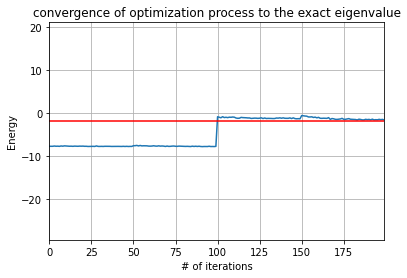

In [59]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [60]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [61]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

1it [00:00,  1.27it/s]

{'0100': 61, '1101': 217, '0111': 88, '0000': 165, '1010': 142, '1110': 191, '1111': 49, '0011': 39, '1100': 17, '0110': 10, '0001': 21, '1011': 2, '1001': 10, '1000': 4, '0010': 7, '0101': 1}
1.0


2it [00:01,  1.74it/s]

{'0001': 175, '1010': 67, '1110': 166, '0100': 45, '1101': 158, '0000': 36, '1111': 48, '0111': 21, '1100': 86, '0110': 66, '0101': 34, '0010': 24, '1011': 69, '0011': 20, '1001': 7, '1000': 2}
1.0


3it [00:01,  2.18it/s]

{'0010': 46, '1110': 27, '0101': 52, '1010': 50, '0100': 53, '1111': 233, '1000': 100, '0000': 139, '1100': 164, '0111': 33, '0001': 50, '1101': 30, '1011': 11, '0110': 21, '0011': 15}
1.0


4it [00:02,  2.14it/s]

{'1111': 52, '0110': 14, '1010': 125, '0000': 164, '0100': 73, '1101': 230, '1110': 182, '1100': 29, '0011': 35, '0111': 74, '1000': 8, '0010': 10, '1001': 8, '0001': 13, '0101': 3, '1011': 4}
1.0


5it [00:02,  2.04it/s]

{'1010': 299, '1001': 158, '1101': 79, '0100': 195, '0111': 78, '0011': 63, '1000': 18, '1111': 12, '0000': 40, '1011': 45, '0110': 16, '0101': 7, '0001': 11, '1100': 3}
1.0


6it [00:03,  2.03it/s]

{'1110': 161, '0000': 161, '0100': 68, '1101': 231, '0010': 10, '0011': 43, '1100': 23, '1111': 52, '1010': 144, '0111': 73, '0001': 27, '0110': 13, '1000': 3, '1011': 1, '1001': 12, '0101': 2}
1.0


7it [00:03,  2.19it/s]

{'0100': 70, '1101': 231, '1010': 137, '1110': 185, '1111': 43, '0111': 79, '0000': 169, '0011': 36, '0001': 22, '1100': 28, '0110': 8, '1011': 6, '0010': 4, '1000': 2, '0101': 1, '1001': 3}
1.0


8it [00:03,  2.22it/s]

{'1110': 86, '0101': 121, '0111': 86, '1101': 95, '0110': 89, '1011': 12, '0010': 95, '0000': 86, '1000': 104, '1010': 66, '1001': 19, '0100': 83, '0011': 23, '1100': 20, '1111': 34, '0001': 5}
1.0


9it [00:04,  2.38it/s]

{'1110': 179, '0110': 15, '1010': 155, '0010': 14, '1101': 210, '0100': 65, '0111': 69, '0011': 36, '1111': 35, '0000': 185, '0001': 14, '1100': 33, '1011': 2, '1001': 9, '1000': 2, '0101': 1}
1.0


10it [00:04,  2.43it/s]

{'0000': 179, '0100': 88, '1101': 227, '1010': 143, '0101': 1, '1110': 167, '0110': 13, '0111': 77, '1100': 22, '0001': 15, '1111': 30, '0011': 38, '1001': 11, '1000': 2, '0010': 8, '1011': 3}
1.0


11it [00:05,  2.17it/s]


{'1111': 50, '0001': 26, '1010': 164, '1110': 188, '0000': 164, '0100': 75, '1101': 186, '0111': 81, '0011': 34, '0110': 17, '0010': 6, '1100': 13, '1001': 10, '0101': 2, '1000': 5, '1011': 3}
1.0


1it [00:00,  2.04it/s]

{'0111': 86, '1111': 81, '1100': 53, '0011': 79, '0101': 6, '1101': 378, '1010': 42, '0000': 115, '0001': 15, '1110': 58, '1011': 23, '0110': 16, '1001': 47, '0100': 17, '0010': 7, '1000': 1}
1.0


2it [00:00,  2.19it/s]

{'0001': 111, '1010': 48, '1001': 28, '1101': 238, '1100': 221, '0010': 37, '1110': 107, '0111': 28, '0101': 18, '1111': 24, '0011': 67, '0110': 67, '1011': 2, '0000': 15, '1000': 11, '0100': 2}
1.0


3it [00:01,  2.56it/s]

{'0110': 23, '1111': 383, '1100': 133, '0101': 35, '0000': 51, '0111': 70, '1101': 70, '0001': 61, '0010': 66, '1011': 42, '1001': 11, '0011': 38, '0100': 10, '1000': 24, '1010': 7}
1.0


4it [00:01,  2.53it/s]

{'1110': 71, '1001': 36, '0001': 25, '1111': 68, '1101': 383, '0111': 104, '0011': 83, '0000': 111, '0110': 10, '0100': 14, '1100': 52, '0010': 3, '1010': 44, '1011': 14, '0101': 5, '1000': 1}
1.0


5it [00:02,  2.24it/s]

{'1000': 34, '1111': 17, '1011': 92, '1001': 283, '1010': 99, '1101': 124, '0100': 71, '0111': 60, '1100': 21, '0101': 33, '0000': 46, '0011': 107, '0001': 8, '0010': 20, '1110': 9}
1.0


6it [00:02,  2.41it/s]

{'0100': 23, '1101': 377, '0001': 28, '1110': 70, '1100': 53, '0000': 111, '0110': 11, '0111': 118, '0011': 70, '1000': 3, '1010': 35, '1111': 73, '1011': 19, '1001': 25, '0101': 6, '0010': 2}
1.0


7it [00:03,  2.30it/s]

{'1101': 389, '0001': 33, '1010': 41, '1111': 67, '0011': 78, '1100': 51, '1110': 55, '0000': 106, '0101': 7, '0111': 93, '0110': 16, '1011': 21, '1001': 41, '0010': 9, '0100': 12, '1000': 5}
1.0


8it [00:03,  2.62it/s]

{'1100': 21, '1101': 165, '0100': 32, '0101': 233, '0001': 27, '0000': 72, '1000': 44, '1111': 85, '0111': 97, '1011': 34, '0011': 66, '1110': 69, '1001': 32, '1010': 35, '0010': 5, '0110': 7}
1.0


9it [00:03,  2.49it/s]

{'0000': 112, '1101': 385, '0001': 30, '1010': 47, '0111': 100, '0011': 66, '1100': 56, '1111': 77, '0100': 10, '1011': 16, '0010': 3, '1110': 52, '0110': 15, '1001': 40, '0101': 11, '1000': 4}
1.0


10it [00:04,  2.50it/s]

{'0111': 84, '1101': 411, '1111': 72, '0110': 11, '0000': 109, '1110': 60, '1011': 24, '1100': 47, '0001': 20, '0011': 92, '0100': 18, '0101': 10, '1001': 29, '1010': 31, '0010': 4, '1000': 2}
1.0


11it [00:04,  2.44it/s]


{'0000': 107, '1100': 59, '0011': 83, '1101': 392, '1111': 67, '1001': 48, '1010': 34, '0111': 114, '1110': 40, '1011': 18, '1000': 2, '0100': 16, '0001': 21, '0110': 16, '0010': 4, '0101': 3}
1.0


1it [00:00,  2.03it/s]

{'0111': 202, '1100': 19, '0011': 262, '0000': 102, '1111': 109, '1101': 89, '1011': 78, '0001': 20, '1110': 52, '1010': 38, '1001': 16, '0110': 10, '0100': 4, '1000': 3, '0010': 18, '0101': 2}
1.0


2it [00:00,  2.10it/s]

{'0010': 97, '0011': 160, '1110': 142, '0111': 92, '0110': 128, '1111': 28, '1010': 103, '0001': 114, '1100': 35, '0000': 38, '1001': 28, '1101': 49, '1000': 3, '0101': 3, '1011': 4}
1.0


3it [00:01,  2.61it/s]

{'0010': 121, '1011': 92, '0101': 66, '1111': 163, '1001': 34, '0001': 173, '0011': 76, '1100': 56, '0111': 125, '1000': 37, '1010': 18, '0000': 37, '0110': 11, '0100': 4, '1101': 8, '1110': 3}
1.0


4it [00:01,  2.42it/s]

{'1111': 95, '1100': 13, '0011': 238, '1011': 100, '1010': 50, '0000': 128, '1101': 89, '0111': 193, '0001': 21, '1110': 31, '0101': 4, '1001': 28, '0110': 14, '0010': 13, '0100': 4, '1000': 3}
1.0


5it [00:02,  2.16it/s]

{'0100': 55, '0011': 278, '1011': 152, '1010': 80, '1001': 87, '0111': 191, '1111': 44, '0000': 55, '1000': 17, '0101': 25, '0010': 19, '1101': 9, '0110': 5, '1100': 4, '0001': 3}
1.0


6it [00:02,  2.46it/s]

{'1010': 45, '1111': 122, '0111': 188, '0011': 231, '0000': 117, '1011': 91, '1101': 80, '1110': 38, '0001': 23, '1100': 18, '1001': 27, '0110': 17, '0010': 18, '1000': 4, '0100': 4, '0101': 1}
1.0


7it [00:02,  2.49it/s]

{'0110': 17, '1111': 114, '1101': 98, '0101': 5, '1011': 87, '0000': 98, '0111': 205, '0011': 249, '0010': 15, '1100': 22, '1010': 29, '0001': 25, '1001': 15, '1110': 39, '1000': 3, '0100': 3}
1.0


8it [00:03,  2.70it/s]

{'0011': 224, '1001': 38, '1111': 163, '0110': 6, '0111': 161, '1011': 84, '1000': 48, '0000': 68, '0101': 44, '1010': 62, '0001': 3, '1101': 31, '1110': 60, '1100': 10, '0100': 16, '0010': 6}
1.0


9it [00:03,  2.66it/s]

{'0000': 107, '0011': 237, '1101': 83, '0001': 25, '1010': 42, '0111': 200, '1011': 86, '1111': 119, '0110': 14, '0010': 13, '1001': 27, '1110': 40, '1100': 21, '0100': 4, '1000': 3, '0101': 3}
1.0


10it [00:04,  2.53it/s]

{'0011': 231, '0111': 204, '1111': 123, '1101': 81, '1000': 5, '0000': 118, '1011': 86, '1010': 54, '1110': 45, '1001': 22, '0010': 11, '0001': 18, '1100': 12, '0100': 3, '0110': 9, '0101': 2}
1.0


11it [00:04,  2.44it/s]


{'0000': 129, '0011': 250, '0111': 185, '1111': 121, '0110': 17, '1010': 36, '1011': 89, '1101': 77, '1110': 35, '1100': 15, '0001': 24, '0010': 16, '0101': 4, '1000': 1, '1001': 21, '0100': 4}
1.0


1it [00:00,  3.15it/s]

{'0100': 92, '1101': 307, '1111': 65, '0110': 11, '1010': 38, '0011': 138, '0111': 35, '1110': 32, '1001': 108, '0001': 50, '0101': 14, '0000': 70, '1100': 27, '1011': 27, '0010': 4, '1000': 6}
1.0


2it [00:00,  2.51it/s]

{'1101': 214, '0100': 56, '0011': 70, '1100': 132, '1001': 62, '0001': 93, '1010': 43, '0010': 70, '0111': 4, '1111': 52, '1110': 52, '0101': 45, '1000': 65, '0110': 40, '1011': 26}
1.0


3it [00:01,  2.34it/s]

{'1101': 64, '1001': 91, '0001': 67, '1111': 333, '1000': 52, '0111': 41, '0011': 103, '1100': 69, '1011': 26, '0110': 46, '0010': 45, '1110': 14, '0100': 45, '0000': 12, '0101': 6, '1010': 10}
1.0


4it [00:01,  2.38it/s]

{'1101': 312, '1111': 56, '0111': 35, '1010': 44, '0001': 56, '1001': 110, '0011': 132, '0101': 7, '1011': 29, '1100': 28, '0100': 78, '0000': 52, '1110': 56, '1000': 7, '0110': 14, '0010': 8}
1.0


5it [00:02,  2.34it/s]

{'1010': 38, '0001': 9, '1001': 362, '0111': 138, '0101': 54, '1101': 51, '0100': 104, '0000': 32, '1100': 2, '1011': 55, '1000': 43, '1110': 41, '1111': 33, '0011': 38, '0010': 23, '0110': 1}
1.0


6it [00:02,  2.56it/s]

{'0011': 145, '1100': 25, '1110': 42, '0100': 97, '1101': 301, '0001': 45, '1001': 104, '1111': 66, '0111': 42, '1000': 13, '1010': 36, '0000': 63, '1011': 21, '0110': 10, '0101': 9, '0010': 5}
1.0


7it [00:02,  2.92it/s]

{'0110': 13, '1111': 56, '0011': 120, '0111': 24, '1110': 36, '1101': 344, '0100': 98, '0001': 61, '1010': 52, '0000': 44, '1011': 28, '1001': 84, '0101': 11, '1100': 33, '1000': 11, '0010': 9}
1.0


8it [00:03,  2.82it/s]

{'0101': 193, '1001': 128, '0011': 119, '1100': 36, '0000': 46, '1000': 22, '0100': 85, '1101': 121, '1011': 47, '1010': 29, '1111': 70, '0001': 10, '1110': 47, '0111': 43, '0010': 21, '0110': 7}
1.0


9it [00:03,  2.83it/s]

{'0100': 85, '1101': 296, '1100': 25, '0011': 125, '0111': 44, '1111': 61, '1110': 49, '1000': 15, '1001': 106, '1011': 33, '0001': 46, '1010': 44, '0000': 70, '0101': 13, '0010': 6, '0110': 6}
1.0


10it [00:03,  2.87it/s]

{'1111': 63, '1100': 20, '0011': 126, '1001': 98, '1010': 48, '0100': 95, '1101': 317, '0111': 34, '0101': 14, '1110': 44, '0010': 11, '0001': 50, '0000': 53, '1011': 33, '1000': 10, '0110': 8}
1.0


11it [00:04,  2.61it/s]


{'0001': 39, '0110': 14, '1101': 314, '0100': 84, '0101': 14, '1110': 44, '0111': 35, '0011': 120, '1010': 57, '0010': 10, '1001': 99, '1100': 28, '1111': 58, '0000': 59, '1000': 14, '1011': 35}
1.0


1it [00:00,  2.40it/s]

{'1100': 28, '0011': 98, '1101': 375, '0111': 60, '0101': 23, '0001': 76, '1010': 71, '0110': 43, '1111': 63, '0000': 75, '1001': 9, '1110': 52, '0100': 20, '1011': 2, '1000': 26, '0010': 3}
1.0


2it [00:00,  2.32it/s]

{'0011': 59, '1100': 229, '1101': 185, '1110': 113, '0101': 34, '1010': 43, '0010': 45, '1000': 30, '0000': 51, '1011': 24, '0111': 53, '0001': 77, '0110': 39, '0100': 33, '1001': 6, '1111': 3}
1.0


3it [00:01,  2.32it/s]

{'0001': 155, '1010': 77, '1100': 102, '1111': 241, '0110': 51, '0111': 80, '1101': 203, '0010': 46, '0000': 23, '0101': 1, '1000': 25, '1011': 9, '1001': 5, '0011': 3, '1110': 2, '0100': 1}
1.0


4it [00:01,  2.40it/s]

{'0001': 63, '0100': 29, '1101': 400, '1110': 74, '1111': 67, '0011': 88, '1100': 45, '0000': 58, '1010': 62, '0111': 43, '1001': 13, '0101': 29, '1000': 19, '0110': 27, '0010': 5, '1011': 2}
1.0


5it [00:01,  2.63it/s]

{'0001': 77, '1001': 217, '1010': 127, '0100': 75, '1101': 153, '0101': 24, '1011': 38, '0011': 70, '1000': 36, '1111': 24, '1100': 51, '0111': 61, '0000': 34, '0110': 10, '0010': 22, '1110': 5}
1.0


6it [00:02,  2.69it/s]

{'0001': 80, '0100': 30, '1101': 352, '1110': 67, '0000': 70, '1111': 60, '0111': 53, '0011': 97, '1010': 67, '1100': 40, '0110': 35, '1000': 27, '1001': 15, '0101': 24, '1011': 3, '0010': 4}
1.0


7it [00:02,  2.73it/s]

{'1101': 376, '0111': 62, '0011': 98, '0110': 38, '0010': 5, '1110': 71, '1010': 58, '0000': 63, '0001': 65, '1001': 10, '1111': 58, '1100': 48, '0101': 24, '0100': 23, '1000': 17, '1011': 8}
1.0


8it [00:03,  2.66it/s]

{'0101': 209, '1101': 213, '0000': 55, '1010': 48, '1001': 53, '0011': 61, '1100': 43, '1111': 94, '0100': 39, '0010': 20, '0111': 6, '1000': 47, '0001': 12, '1110': 54, '1011': 35, '0110': 35}
1.0


9it [00:03,  2.80it/s]

{'1110': 64, '0101': 32, '1101': 361, '1000': 32, '0110': 31, '1001': 9, '1010': 76, '1100': 43, '1111': 63, '0111': 50, '0000': 60, '0010': 6, '0011': 96, '0001': 68, '0100': 30, '1011': 3}
1.0


10it [00:03,  2.86it/s]

{'0011': 93, '1100': 48, '1110': 78, '1101': 359, '0000': 52, '1000': 26, '1010': 71, '1111': 69, '0100': 21, '0111': 59, '1001': 13, '0101': 30, '0001': 74, '0010': 3, '0110': 28}
1.0


11it [00:04,  2.55it/s]


{'0100': 28, '1101': 365, '0111': 64, '0011': 95, '0001': 55, '1010': 68, '1110': 75, '0000': 53, '0101': 36, '1000': 25, '0110': 33, '1111': 58, '1100': 50, '1001': 11, '1011': 3, '0010': 5}
1.0


1it [00:00,  2.85it/s]

{'1101': 365, '1011': 30, '1111': 107, '0011': 64, '1100': 84, '0111': 84, '0000': 68, '0001': 15, '1001': 49, '1110': 95, '1010': 22, '0010': 14, '0110': 8, '1000': 3, '0101': 6, '0100': 10}
1.0


2it [00:00,  2.54it/s]

{'1101': 222, '1001': 32, '0001': 77, '1010': 46, '1110': 112, '1000': 22, '0110': 64, '1100': 196, '0011': 71, '0111': 39, '1111': 80, '0100': 6, '0101': 14, '0010': 26, '0000': 15, '1011': 2}
1.0


3it [00:01,  2.27it/s]

{'1100': 161, '1111': 381, '0010': 57, '1011': 74, '0101': 31, '1101': 87, '0001': 56, '0111': 55, '1001': 10, '0110': 18, '1000': 20, '0000': 38, '0011': 26, '1110': 5, '1010': 4, '0100': 1}
1.0


4it [00:01,  2.36it/s]

{'1101': 396, '0000': 88, '1111': 77, '1110': 97, '1100': 58, '0011': 78, '0111': 87, '1001': 56, '1000': 4, '0010': 11, '0110': 7, '0100': 9, '1011': 27, '1010': 14, '0001': 10, '0101': 5}
1.0


5it [00:02,  2.51it/s]

{'1011': 93, '1101': 101, '0100': 59, '1010': 111, '1001': 311, '0011': 80, '1111': 17, '0111': 63, '1000': 40, '1110': 17, '0001': 5, '0010': 26, '0000': 47, '1100': 30, '0101': 21, '0110': 3}
1.0


6it [00:02,  2.37it/s]

{'0111': 101, '0011': 79, '1100': 70, '1110': 90, '1001': 53, '1010': 25, '1101': 357, '0010': 15, '0000': 83, '1011': 29, '1111': 86, '0110': 6, '0001': 13, '0100': 6, '0101': 10, '1000': 1}
1.0


7it [00:02,  2.30it/s]

{'1101': 363, '1110': 94, '1010': 25, '0001': 18, '1001': 49, '0000': 83, '1111': 81, '1100': 72, '0110': 7, '0011': 79, '1011': 23, '0010': 15, '0111': 92, '0100': 16, '0101': 6, '1000': 1}
1.0


8it [00:03,  2.25it/s]

{'1110': 68, '0000': 55, '1101': 146, '0100': 62, '0111': 96, '1111': 83, '0110': 23, '1011': 33, '0101': 222, '1010': 28, '0001': 31, '0011': 89, '1100': 17, '1000': 30, '1001': 38, '0010': 3}
1.0


9it [00:03,  2.16it/s]

{'1111': 91, '0000': 74, '1100': 77, '0011': 78, '1101': 358, '1001': 65, '1010': 16, '0111': 78, '1110': 93, '0010': 14, '1011': 31, '0110': 11, '0001': 14, '0100': 9, '1000': 5, '0101': 10}
1.0


10it [00:04,  2.07it/s]

{'0111': 100, '1101': 382, '1100': 56, '0011': 82, '1001': 49, '1111': 91, '1110': 99, '1011': 23, '0000': 68, '0110': 6, '0100': 10, '1010': 21, '0001': 19, '1000': 7, '0101': 4, '0010': 7}
1.0


11it [00:04,  2.26it/s]


{'1101': 371, '0111': 86, '1100': 76, '0011': 82, '1111': 83, '0010': 22, '0000': 86, '1110': 80, '1001': 50, '1010': 27, '0100': 16, '1011': 20, '0001': 11, '0110': 6, '1000': 6, '0101': 2}
1.0


1it [00:00,  2.47it/s]

{'1000': 12, '0011': 83, '1111': 71, '0110': 11, '1101': 426, '1110': 109, '1001': 52, '0111': 75, '1010': 17, '0000': 66, '1100': 53, '0100': 7, '1011': 18, '0101': 19, '0001': 5}
1.0


2it [00:00,  2.49it/s]

{'1001': 38, '1010': 44, '0011': 59, '1100': 262, '0110': 44, '1110': 140, '1000': 27, '1101': 212, '0010': 40, '1111': 39, '0111': 36, '0000': 26, '0001': 46, '0101': 9, '1011': 2}
1.0


3it [00:01,  2.46it/s]

{'0010': 40, '0011': 64, '1100': 148, '0100': 12, '1101': 190, '1111': 292, '1001': 42, '0000': 27, '0111': 90, '1011': 30, '0110': 9, '0101': 9, '1000': 25, '0001': 30, '1110': 15, '1010': 1}
1.0


4it [00:01,  2.59it/s]

{'1101': 411, '1010': 22, '0011': 86, '1100': 69, '0000': 75, '1111': 58, '1110': 110, '0111': 75, '0010': 2, '1000': 4, '1011': 36, '1001': 47, '0110': 7, '0101': 11, '0100': 4, '0001': 7}
1.0


5it [00:01,  2.76it/s]

{'0111': 94, '1011': 48, '1001': 301, '1010': 124, '1101': 144, '1111': 53, '0011': 77, '0101': 12, '1000': 52, '1100': 10, '0010': 11, '1110': 19, '0100': 54, '0000': 19, '0110': 4, '0001': 2}
1.0


6it [00:02,  2.64it/s]

{'1101': 424, '1001': 62, '1010': 27, '1000': 13, '0011': 86, '1100': 52, '0111': 64, '1111': 50, '1110': 112, '0000': 75, '0101': 10, '1011': 24, '0100': 8, '0110': 10, '0001': 7}
1.0


7it [00:02,  2.82it/s]

{'0000': 80, '1110': 119, '1101': 412, '1111': 73, '0110': 17, '0011': 96, '0111': 50, '1011': 26, '1001': 53, '0101': 9, '1100': 62, '1010': 14, '1000': 9, '0100': 4}
1.0


8it [00:03,  2.59it/s]

{'1001': 23, '1110': 115, '0101': 276, '0011': 68, '1111': 44, '0010': 10, '0000': 61, '1000': 22, '1011': 34, '1101': 137, '1100': 34, '0001': 40, '0111': 99, '0110': 21, '0100': 29, '1010': 11}
1.0


9it [00:03,  2.67it/s]

{'1011': 30, '1001': 54, '1010': 37, '0111': 64, '1110': 114, '1101': 421, '1111': 67, '1100': 61, '1000': 7, '0011': 67, '0000': 66, '0101': 15, '0110': 10, '0100': 4, '0001': 6, '0010': 1}
1.0


10it [00:03,  2.41it/s]

{'0111': 76, '1110': 116, '0000': 78, '1000': 8, '1101': 386, '1111': 66, '1001': 56, '0011': 88, '1100': 64, '1010': 24, '0101': 11, '1011': 27, '0110': 11, '0100': 9, '0001': 4}
1.0


11it [00:04,  2.50it/s]


{'0011': 66, '1111': 67, '0000': 54, '1101': 434, '0101': 22, '1110': 118, '0111': 79, '1001': 38, '1000': 9, '1010': 24, '1011': 24, '0110': 14, '1100': 61, '0100': 10, '0010': 1, '0001': 3}
1.0


1it [00:00,  2.21it/s]

{'1101': 432, '1111': 52, '0000': 76, '1010': 16, '0011': 121, '1110': 158, '0111': 18, '0010': 2, '1100': 47, '1000': 8, '1011': 53, '0001': 9, '0100': 22, '0110': 8, '1001': 2}
1.0


2it [00:00,  2.18it/s]

{'1110': 131, '1101': 238, '0110': 17, '0000': 47, '1100': 238, '0011': 78, '0010': 54, '0111': 14, '0001': 53, '1111': 72, '1010': 53, '0100': 12, '1001': 5, '0101': 10, '1011': 2}
1.0


3it [00:01,  2.17it/s]

{'0100': 21, '1101': 184, '1111': 340, '0110': 8, '1100': 133, '0011': 96, '1001': 32, '0001': 33, '1000': 17, '0111': 13, '1110': 37, '0010': 52, '0000': 32, '0101': 17, '1011': 6, '1010': 3}
1.0


4it [00:01,  2.58it/s]

{'1101': 429, '0010': 3, '1011': 37, '1110': 157, '1100': 47, '0011': 125, '1111': 57, '0000': 81, '0111': 25, '0110': 9, '0100': 20, '0001': 13, '1010': 17, '1001': 1, '1000': 3}
1.0


5it [00:01,  2.80it/s]

{'0111': 59, '0011': 85, '0100': 98, '1101': 176, '1010': 124, '1001': 247, '1000': 48, '1011': 69, '0001': 5, '1110': 37, '0000': 9, '1100': 23, '0010': 11, '0101': 8, '1111': 25}
1.0


6it [00:02,  2.84it/s]

{'1100': 46, '0011': 123, '0100': 23, '1101': 447, '1110': 162, '1111': 51, '0000': 82, '1011': 19, '0111': 31, '0010': 1, '1001': 5, '0110': 10, '1010': 11, '0001': 9, '1000': 4}
1.0


7it [00:02,  2.68it/s]

{'1111': 50, '0000': 71, '1011': 25, '1110': 155, '1100': 58, '0011': 140, '1101': 447, '0111': 33, '0100': 12, '1010': 13, '0110': 6, '0001': 7, '1001': 2, '0010': 2, '0101': 2, '1000': 1}
1.0


8it [00:03,  2.17it/s]

{'1101': 233, '0110': 45, '1111': 18, '1010': 26, '1000': 48, '0011': 129, '1110': 99, '0101': 205, '1100': 43, '0111': 64, '1011': 38, '0100': 26, '0000': 37, '1001': 7, '0001': 4, '0010': 2}
1.0


9it [00:03,  2.05it/s]

{'0000': 105, '1101': 431, '1011': 41, '1111': 51, '0011': 114, '1100': 51, '1110': 134, '0001': 17, '0110': 12, '0100': 17, '0111': 24, '1010': 19, '1000': 3, '0010': 4, '1001': 1}
1.0


10it [00:04,  2.09it/s]

{'1101': 428, '1110': 153, '0011': 126, '1100': 58, '0000': 93, '0110': 9, '1001': 5, '0001': 11, '1011': 47, '1010': 13, '0111': 18, '0100': 15, '1111': 42, '0010': 3, '1000': 2, '0101': 1}
1.0


11it [00:04,  2.20it/s]


{'0111': 27, '0100': 27, '1101': 422, '1110': 134, '0011': 141, '1100': 60, '0000': 72, '1011': 31, '0001': 12, '0110': 8, '1111': 60, '1010': 20, '1000': 3, '0010': 6, '1001': 1}
1.0


1it [00:00,  1.98it/s]

{'1101': 417, '0111': 77, '1100': 61, '0011': 85, '1110': 112, '1010': 39, '1111': 38, '1011': 21, '1001': 46, '0000': 54, '0101': 38, '0110': 27, '0100': 6, '0001': 2, '0010': 1}
1.0


2it [00:01,  1.94it/s]

{'1100': 215, '1101': 232, '0010': 42, '0110': 67, '1111': 60, '1110': 112, '0101': 41, '1010': 48, '0111': 52, '0000': 41, '0001': 25, '1011': 1, '1000': 16, '0011': 36, '0100': 12, '1001': 24}
1.0


3it [00:01,  2.01it/s]

{'0010': 40, '1101': 204, '1100': 146, '0011': 40, '0001': 46, '1111': 281, '0110': 18, '0000': 21, '0111': 96, '1000': 31, '0100': 18, '1110': 20, '1011': 19, '0101': 11, '1001': 22, '1010': 11}
1.0


4it [00:01,  2.19it/s]

{'1101': 453, '1100': 55, '0101': 25, '1110': 96, '1001': 34, '1010': 27, '0111': 81, '0000': 47, '0011': 85, '0110': 39, '1000': 7, '1111': 40, '1011': 25, '0100': 8, '0001': 2}
1.0


5it [00:02,  2.25it/s]

{'1010': 123, '1001': 342, '1101': 167, '0100': 45, '1011': 35, '0010': 15, '0111': 78, '1100': 17, '0011': 75, '0000': 16, '0001': 14, '1000': 38, '1110': 11, '1111': 22, '0110': 16, '0101': 10}
1.0


6it [00:02,  2.37it/s]

{'0111': 65, '1110': 124, '0101': 27, '1101': 438, '1111': 32, '1010': 42, '1011': 19, '0011': 99, '1001': 37, '0100': 9, '0000': 55, '0110': 29, '1100': 45, '1000': 2, '0001': 1}
1.0


7it [00:03,  2.62it/s]

{'0000': 56, '1101': 450, '1110': 105, '0011': 88, '1100': 72, '1001': 38, '0111': 71, '1111': 31, '1011': 15, '1010': 34, '1000': 1, '0101': 26, '0110': 32, '0100': 4, '0001': 1}
1.0


8it [00:03,  2.59it/s]

{'1101': 129, '1110': 124, '0101': 336, '1111': 34, '1011': 33, '0011': 74, '0111': 74, '1010': 25, '0000': 39, '0001': 19, '1100': 32, '1000': 18, '0100': 36, '0110': 20, '0010': 12, '1001': 19}
1.0


9it [00:03,  2.68it/s]

{'1101': 433, '0111': 76, '0110': 40, '0011': 84, '0101': 35, '1011': 14, '0000': 56, '1010': 40, '1110': 117, '1001': 39, '1000': 1, '0100': 12, '1100': 51, '1111': 26}
1.0


10it [00:04,  2.65it/s]

{'1101': 478, '0011': 80, '1100': 47, '0101': 33, '1110': 104, '0111': 68, '1111': 24, '0000': 71, '0110': 27, '1001': 41, '1010': 30, '1011': 11, '1000': 2, '0001': 3, '0100': 4, '0010': 1}
1.0


11it [00:04,  2.45it/s]


{'0111': 56, '1101': 438, '1010': 48, '1001': 36, '0011': 89, '1100': 56, '0101': 38, '1110': 112, '1011': 17, '0000': 59, '0100': 5, '0110': 37, '1000': 2, '1111': 30, '0001': 1}
1.0


1it [00:00,  2.51it/s]

{'0011': 159, '1100': 99, '1111': 14, '0110': 50, '1101': 415, '0111': 83, '0001': 16, '1001': 23, '0101': 35, '0100': 17, '1011': 15, '1110': 39, '1010': 28, '0010': 12, '0000': 10, '1000': 9}
1.0


2it [00:00,  2.47it/s]

{'0011': 66, '1100': 355, '0100': 43, '1101': 178, '0010': 94, '0000': 24, '1010': 29, '0111': 42, '0110': 81, '1000': 3, '1001': 24, '1110': 49, '1011': 18, '0101': 10, '1111': 5, '0001': 3}
1.0


3it [00:01,  2.12it/s]

{'1101': 202, '1100': 149, '0011': 106, '0010': 13, '0111': 83, '0001': 55, '1111': 248, '1000': 31, '0100': 17, '0110': 42, '0101': 21, '1001': 14, '1011': 26, '1010': 10, '1110': 7}
1.0


4it [00:01,  2.05it/s]

{'0100': 22, '1101': 440, '1011': 17, '0011': 150, '1100': 106, '0110': 53, '1010': 36, '0111': 76, '0101': 30, '1110': 34, '1000': 8, '0001': 13, '1001': 15, '0000': 13, '1111': 7, '0010': 4}
1.0


5it [00:02,  1.97it/s]

{'1010': 57, '0001': 25, '1001': 282, '1000': 85, '1101': 188, '0111': 85, '0011': 133, '1110': 15, '1011': 20, '0000': 19, '0110': 31, '1100': 30, '0101': 16, '0010': 28, '1111': 8, '0100': 2}
1.0


6it [00:02,  1.94it/s]

{'0110': 47, '1101': 411, '0011': 163, '1100': 103, '0111': 74, '1110': 46, '1010': 38, '1001': 27, '0000': 7, '0001': 13, '1011': 22, '1000': 2, '0010': 6, '1111': 15, '0101': 35, '0100': 15}
1.0


7it [00:03,  2.03it/s]

{'1011': 16, '0100': 15, '1101': 439, '1100': 107, '0011': 134, '1010': 35, '0001': 12, '0111': 68, '1111': 15, '0101': 42, '0110': 42, '1000': 4, '1110': 50, '1001': 23, '0000': 14, '0010': 8}
1.0


8it [00:03,  2.14it/s]

{'1100': 40, '0100': 92, '1101': 143, '0111': 53, '1111': 29, '1011': 58, '1110': 84, '0101': 319, '0011': 115, '0001': 27, '0010': 35, '1010': 7, '0000': 6, '1000': 11, '1001': 5}
1.0


9it [00:04,  2.26it/s]

{'1100': 117, '0011': 147, '0111': 82, '0100': 19, '1101': 431, '1011': 16, '1111': 14, '1110': 40, '1000': 6, '0101': 36, '1001': 21, '1010': 22, '0110': 50, '0010': 8, '0000': 9, '0001': 6}
1.0


10it [00:04,  2.41it/s]

{'1101': 444, '1100': 91, '0011': 150, '0101': 48, '1110': 45, '1111': 19, '0110': 41, '0111': 67, '0100': 17, '1001': 15, '0000': 6, '1010': 35, '1011': 18, '0001': 11, '0010': 5, '1000': 12}
1.0


11it [00:05,  2.15it/s]


{'1100': 105, '0011': 150, '0100': 23, '1101': 422, '1110': 39, '0101': 41, '0111': 78, '0001': 13, '0110': 49, '1010': 25, '1001': 21, '0000': 8, '0010': 11, '1011': 13, '1111': 17, '1000': 9}
1.0


1it [00:00,  1.67it/s]

{'1101': 439, '0110': 7, '1100': 93, '0011': 212, '1011': 55, '0101': 47, '1000': 13, '1010': 20, '0000': 49, '1001': 8, '0010': 39, '1110': 29, '0100': 4, '0001': 5, '1111': 2, '0111': 2}
1.0


2it [00:01,  1.98it/s]

{'1101': 195, '0011': 97, '1100': 338, '0010': 151, '1011': 38, '0111': 7, '1010': 38, '1001': 8, '0000': 45, '0100': 29, '1110': 18, '1111': 28, '1000': 15, '0101': 10, '0001': 6, '0110': 1}
1.0


3it [00:01,  2.20it/s]

{'0110': 12, '1111': 253, '0011': 114, '1100': 129, '1101': 160, '1001': 67, '1000': 34, '0010': 91, '0001': 97, '0101': 30, '0111': 7, '1011': 17, '1110': 9, '0000': 3, '0100': 1}
1.0


4it [00:01,  2.23it/s]

{'1100': 106, '0011': 213, '0110': 10, '1101': 429, '1000': 15, '1010': 24, '0111': 14, '1011': 61, '1110': 38, '0000': 43, '0101': 27, '0100': 8, '0010': 22, '1001': 7, '0001': 4, '1111': 3}
1.0


5it [00:02,  2.35it/s]

{'1001': 268, '1000': 84, '1110': 20, '0011': 138, '1100': 37, '1101': 166, '0100': 16, '0111': 75, '1111': 30, '0010': 13, '1010': 47, '0110': 35, '0001': 13, '0000': 35, '1011': 24, '0101': 23}
1.0


6it [00:02,  2.41it/s]

{'1010': 24, '1101': 403, '1100': 111, '0011': 227, '0110': 13, '0000': 46, '1110': 38, '1011': 66, '0101': 31, '0010': 24, '1001': 7, '0100': 6, '1000': 19, '0001': 3, '0111': 6}
1.0


7it [00:03,  2.26it/s]

{'1100': 108, '0011': 196, '1101': 418, '1111': 3, '1011': 61, '1010': 20, '0101': 35, '0000': 49, '0010': 42, '0100': 14, '1001': 6, '1110': 40, '1000': 12, '0001': 8, '0110': 5, '0111': 7}
1.0


8it [00:03,  2.21it/s]

{'0011': 219, '0101': 241, '0100': 67, '1101': 216, '0000': 9, '1000': 57, '1011': 56, '0010': 49, '1110': 45, '1001': 5, '1100': 32, '0001': 12, '0111': 7, '0110': 5, '1111': 1, '1010': 3}
1.0


9it [00:03,  2.41it/s]

{'1101': 421, '1100': 83, '0011': 234, '1011': 53, '0010': 21, '0000': 60, '0110': 11, '1110': 39, '0001': 4, '1001': 9, '1000': 21, '1010': 16, '0111': 9, '0101': 34, '0100': 8, '1111': 1}
1.0


10it [00:04,  2.51it/s]

{'0011': 227, '1100': 101, '0100': 6, '1101': 424, '0010': 21, '1011': 63, '1110': 47, '0000': 40, '0101': 36, '1000': 10, '0111': 7, '1010': 18, '1001': 14, '0001': 4, '0110': 5, '1111': 1}
1.0


11it [00:04,  2.31it/s]


{'0011': 197, '1100': 119, '1101': 427, '1011': 64, '1010': 18, '0101': 25, '0111': 7, '0000': 40, '0010': 34, '1110': 43, '0100': 9, '1000': 17, '0110': 8, '0001': 4, '1001': 9, '1111': 3}
1.0


1it [00:00,  1.97it/s]

{'0100': 48, '1101': 447, '0010': 31, '0001': 23, '0111': 88, '0011': 144, '1110': 22, '0110': 21, '1010': 29, '1111': 51, '1100': 70, '1001': 32, '1000': 4, '0101': 5, '0000': 9}
1.0


2it [00:00,  2.35it/s]

{'0111': 37, '0011': 74, '1100': 309, '1000': 14, '1111': 54, '0101': 50, '1101': 212, '1011': 15, '0010': 95, '1010': 10, '0110': 83, '0001': 34, '1110': 21, '1001': 6, '0100': 9, '0000': 1}
1.0


3it [00:01,  2.07it/s]

{'1001': 17, '0001': 116, '0010': 15, '1011': 9, '1111': 437, '1101': 99, '0101': 74, '1100': 67, '0100': 37, '1000': 20, '0000': 24, '0110': 39, '0111': 15, '0011': 25, '1010': 11, '1110': 19}
1.0


4it [00:01,  2.09it/s]

{'1101': 500, '0100': 44, '1100': 58, '0011': 131, '0111': 80, '0000': 18, '0101': 2, '0010': 29, '1111': 65, '0110': 15, '1110': 20, '0001': 11, '1001': 21, '1010': 27, '1000': 3}
1.0


5it [00:02,  2.06it/s]

{'0001': 13, '1001': 313, '0011': 135, '1101': 146, '0101': 11, '0111': 85, '1011': 34, '1111': 38, '0000': 39, '1010': 28, '1000': 33, '0100': 41, '0010': 37, '0110': 19, '1100': 35, '1110': 17}
1.0


6it [00:02,  2.15it/s]

{'0100': 63, '1101': 437, '0110': 24, '1111': 66, '0010': 26, '1001': 26, '1100': 60, '0111': 79, '0011': 142, '1010': 30, '0101': 11, '1110': 21, '0000': 17, '1011': 1, '0001': 19, '1000': 2}
1.0


7it [00:03,  2.26it/s]

{'0100': 43, '1101': 457, '0111': 107, '1001': 31, '1010': 24, '1100': 75, '0011': 141, '1111': 44, '0110': 13, '0010': 27, '1011': 2, '0001': 19, '1110': 21, '0000': 18, '0101': 2}
1.0


8it [00:03,  2.24it/s]

{'0100': 58, '1101': 314, '0010': 27, '1011': 77, '0111': 141, '1100': 60, '0011': 61, '1000': 12, '0101': 165, '1001': 44, '1110': 41, '1010': 11, '0001': 5, '0000': 3, '0110': 3, '1111': 2}
1.0


9it [00:04,  2.24it/s]

{'0100': 51, '1101': 456, '0011': 131, '1100': 52, '0111': 107, '1001': 24, '0010': 33, '1111': 56, '1010': 21, '1110': 28, '0001': 15, '0101': 10, '0000': 11, '0110': 25, '1011': 1, '1000': 3}
1.0


10it [00:04,  2.25it/s]

{'0010': 23, '0001': 18, '1001': 27, '1010': 21, '1101': 437, '0111': 99, '0011': 161, '1110': 20, '1100': 55, '0110': 19, '1111': 69, '0100': 46, '0101': 12, '0000': 16, '1000': 1}
1.0


11it [00:04,  2.21it/s]


{'0011': 156, '1100': 50, '0100': 50, '1101': 443, '1010': 18, '0001': 24, '1111': 72, '1110': 29, '0111': 80, '0110': 23, '1001': 27, '0000': 19, '0101': 8, '0010': 22, '1000': 2, '1011': 1}
1.0


1it [00:00,  2.60it/s]

{'1101': 420, '0111': 62, '1100': 110, '1010': 19, '1001': 10, '1000': 13, '1111': 63, '0010': 25, '0101': 41, '1011': 41, '0110': 51, '0011': 94, '0001': 36, '1110': 19, '0100': 12, '0000': 8}
1.0


2it [00:00,  2.32it/s]

{'0011': 40, '1100': 376, '0001': 61, '0100': 36, '1101': 159, '0000': 9, '1000': 20, '1111': 30, '1110': 46, '0110': 91, '0010': 70, '1010': 36, '0111': 25, '1011': 19, '1001': 4, '0101': 2}
1.0


3it [00:01,  2.34it/s]

{'1010': 18, '0001': 154, '1111': 321, '1101': 130, '0111': 70, '1100': 129, '1110': 8, '1011': 41, '0010': 10, '0000': 20, '0101': 27, '0110': 44, '0100': 7, '1000': 34, '1001': 5, '0011': 6}
1.0


4it [00:01,  2.17it/s]

{'1110': 27, '1100': 93, '0011': 92, '0111': 51, '1101': 406, '0110': 49, '1111': 57, '1011': 48, '0100': 11, '1001': 7, '0001': 43, '0101': 37, '0000': 15, '1010': 42, '1000': 17, '0010': 29}
1.0


5it [00:02,  1.88it/s]

{'0111': 42, '1101': 317, '1100': 38, '0001': 61, '1010': 58, '1001': 128, '1000': 70, '1111': 93, '0010': 59, '0011': 99, '1011': 4, '0100': 28, '0110': 17, '0101': 8, '0000': 2}
1.0


6it [00:02,  2.05it/s]

{'1101': 397, '1100': 85, '0011': 107, '0111': 54, '0001': 42, '0101': 41, '1110': 33, '0010': 23, '1111': 59, '0110': 53, '1011': 41, '1010': 39, '0100': 6, '1001': 12, '0000': 17, '1000': 15}
1.0


7it [00:03,  2.16it/s]

{'0011': 99, '1100': 111, '0111': 58, '1101': 408, '0110': 35, '1111': 68, '0010': 15, '0101': 32, '1010': 38, '0001': 45, '1001': 12, '0100': 12, '0000': 16, '1110': 22, '1011': 37, '1000': 16}
1.0


8it [00:03,  2.36it/s]

{'0100': 94, '1101': 127, '1011': 96, '1110': 61, '0101': 329, '0000': 15, '0111': 126, '0011': 37, '0010': 13, '1100': 24, '1000': 15, '0001': 29, '1010': 23, '1001': 25, '0110': 3, '1111': 7}
1.0


9it [00:03,  2.57it/s]

{'0111': 59, '1110': 22, '0101': 42, '1000': 16, '1011': 44, '0010': 28, '0011': 108, '1101': 404, '0100': 8, '1100': 86, '1111': 61, '1010': 41, '1001': 10, '0110': 38, '0001': 45, '0000': 12}
1.0


10it [00:04,  2.51it/s]

{'0110': 52, '1101': 391, '0101': 42, '1010': 28, '0010': 20, '1011': 47, '0011': 92, '1100': 101, '1111': 82, '0111': 68, '0000': 11, '1000': 15, '1110': 20, '0001': 30, '1001': 17, '0100': 8}
1.0


11it [00:04,  2.32it/s]


{'0100': 8, '1101': 412, '0111': 54, '1111': 54, '0110': 58, '0010': 22, '0011': 85, '1010': 33, '1100': 102, '0001': 41, '1000': 22, '1110': 20, '0101': 37, '1011': 47, '1001': 14, '0000': 15}
1.0


1it [00:00,  2.94it/s]

{'1101': 461, '0111': 88, '1010': 37, '1001': 17, '1100': 103, '0011': 111, '0101': 20, '0110': 59, '1111': 25, '0001': 8, '0000': 43, '0100': 11, '0010': 13, '1110': 13, '1011': 13, '1000': 2}
1.0


2it [00:00,  2.93it/s]

{'1100': 318, '1101': 263, '0100': 26, '0010': 101, '0000': 54, '0110': 79, '0111': 44, '1110': 32, '1011': 32, '0011': 39, '1001': 16, '0001': 10, '0101': 5, '1000': 2, '1111': 1, '1010': 2}
1.0


3it [00:01,  2.18it/s]

{'0100': 14, '1101': 248, '1111': 235, '1110': 19, '0101': 21, '1011': 11, '0111': 99, '1100': 117, '1001': 17, '0001': 40, '0011': 73, '1010': 16, '0110': 48, '1000': 18, '0010': 45, '0000': 3}
1.0


4it [00:01,  1.91it/s]

{'1100': 97, '1101': 451, '0110': 65, '0111': 81, '0101': 24, '1011': 20, '0000': 42, '1010': 27, '0011': 119, '1110': 25, '0001': 13, '1111': 11, '1001': 22, '0010': 11, '0100': 13, '1000': 3}
1.0


5it [00:02,  2.03it/s]

{'0110': 33, '1111': 19, '1001': 269, '1101': 214, '0111': 80, '1000': 71, '1110': 19, '0011': 118, '0000': 28, '0001': 37, '0010': 35, '0100': 21, '1010': 32, '0101': 4, '1011': 18, '1100': 26}
1.0


6it [00:02,  2.37it/s]

{'1101': 434, '0001': 8, '1001': 27, '0000': 47, '1100': 107, '0101': 12, '1110': 23, '0111': 76, '0011': 133, '1011': 19, '1010': 34, '0110': 64, '1111': 17, '0100': 12, '0010': 9, '1000': 2}
1.0


7it [00:03,  2.41it/s]

{'0111': 84, '1101': 433, '1011': 27, '0011': 135, '1100': 98, '0001': 16, '1111': 20, '0110': 57, '1110': 13, '0000': 51, '1010': 30, '1001': 21, '0010': 10, '1000': 4, '0101': 14, '0100': 11}
1.0


8it [00:03,  2.10it/s]

{'1110': 79, '0101': 304, '0100': 85, '1101': 146, '1011': 83, '0011': 76, '0111': 49, '0000': 22, '0010': 32, '1000': 20, '1111': 47, '1001': 17, '1100': 28, '0001': 25, '0110': 10, '1010': 1}
1.0


9it [00:04,  2.12it/s]

{'0110': 62, '1011': 20, '0010': 8, '0111': 89, '1101': 443, '0011': 126, '1010': 37, '0000': 51, '1110': 20, '1001': 26, '1100': 90, '1111': 23, '1000': 3, '0001': 7, '0100': 3, '0101': 16}
1.0


10it [00:04,  2.02it/s]

{'0111': 86, '1010': 30, '1001': 14, '1101': 464, '1100': 126, '0011': 116, '0010': 11, '1111': 16, '0110': 46, '0000': 44, '1110': 18, '1011': 12, '0101': 20, '0001': 5, '0100': 13, '1000': 3}
1.0


11it [00:05,  2.13it/s]


{'1001': 26, '1101': 442, '1100': 94, '0011': 111, '1110': 24, '0101': 10, '0000': 49, '0111': 82, '1111': 20, '0100': 14, '0110': 62, '1011': 20, '1010': 37, '0010': 16, '0001': 15, '1000': 2}
1.0


1it [00:00,  1.63it/s]

{'1101': 470, '0010': 28, '0110': 51, '1111': 2, '0111': 94, '1110': 51, '0000': 68, '0011': 89, '1100': 70, '1010': 16, '0100': 13, '0001': 18, '1011': 21, '0101': 16, '1000': 3, '1001': 14}
1.0


2it [00:01,  1.93it/s]

{'0010': 83, '1011': 36, '1101': 260, '0011': 28, '1100': 269, '0000': 76, '0110': 57, '1001': 24, '0111': 75, '0100': 15, '1110': 54, '1111': 11, '0001': 18, '1000': 5, '0101': 8, '1010': 5}
1.0


3it [00:01,  1.53it/s]

{'1111': 186, '1100': 151, '1101': 240, '0100': 22, '1001': 41, '0001': 97, '0010': 63, '0101': 53, '0110': 36, '0111': 60, '1000': 18, '0000': 26, '1110': 6, '0011': 23, '1010': 2}
1.0


4it [00:02,  1.70it/s]

{'0100': 20, '1101': 460, '0110': 45, '0011': 83, '0111': 85, '0001': 27, '1001': 20, '1011': 24, '1100': 82, '1110': 54, '0101': 18, '0000': 63, '0010': 16, '1111': 4, '1010': 19, '1000': 4}
1.0


5it [00:02,  1.94it/s]

{'1101': 174, '0100': 63, '1010': 59, '1001': 285, '1000': 64, '0111': 57, '0010': 27, '0011': 133, '0110': 56, '1111': 17, '0000': 7, '1100': 40, '1011': 5, '0001': 31, '1110': 6}
1.0


6it [00:03,  2.17it/s]

{'1011': 15, '0010': 16, '0100': 21, '1101': 445, '1100': 86, '0000': 53, '0001': 31, '0111': 94, '1110': 55, '0011': 79, '0101': 19, '0110': 60, '1010': 25, '1111': 3, '1001': 19, '1000': 3}
1.0


7it [00:03,  2.36it/s]

{'0100': 16, '1101': 422, '0000': 56, '1110': 73, '0101': 14, '0010': 21, '0111': 87, '0110': 40, '1011': 24, '1100': 109, '1010': 24, '0011': 106, '1001': 15, '0001': 11, '1111': 4, '1000': 2}
1.0


8it [00:03,  2.19it/s]

{'1110': 111, '0101': 308, '1101': 160, '0111': 51, '0011': 54, '1000': 35, '0001': 16, '1001': 12, '0000': 33, '1100': 21, '1111': 40, '0100': 89, '0010': 35, '1011': 56, '0110': 3}
1.0


9it [00:04,  2.01it/s]

{'1101': 435, '0000': 78, '1100': 91, '0011': 96, '0110': 43, '1001': 17, '1011': 19, '0010': 18, '1110': 72, '0101': 16, '0111': 83, '0100': 11, '1111': 5, '0001': 16, '1010': 21, '1000': 3}
1.0


10it [00:05,  2.06it/s]

{'1101': 473, '0110': 39, '1100': 87, '0000': 68, '1001': 21, '1010': 12, '0111': 91, '0101': 18, '0011': 75, '1110': 61, '1111': 3, '1011': 21, '0001': 20, '0100': 20, '1000': 5, '0010': 10}
1.0


11it [00:05,  1.99it/s]


{'0001': 12, '0011': 104, '1100': 94, '0111': 113, '1101': 416, '1110': 51, '1111': 3, '0000': 55, '0110': 46, '1011': 38, '0010': 19, '1001': 16, '1010': 24, '0101': 20, '0100': 9, '1000': 4}
1.0


1it [00:00,  2.10it/s]

{'0111': 142, '1101': 440, '1110': 36, '0101': 36, '1001': 19, '0001': 7, '1100': 100, '1011': 15, '0000': 40, '0011': 51, '0110': 69, '0010': 17, '1111': 15, '0100': 12, '1000': 14, '1010': 11}
1.0


2it [00:00,  2.01it/s]

{'0010': 50, '0110': 155, '0011': 27, '1100': 355, '1101': 183, '0001': 11, '0111': 50, '1000': 14, '1110': 55, '0100': 18, '0101': 34, '0000': 29, '1010': 17, '1011': 23, '1111': 2, '1001': 1}
1.0


3it [00:01,  2.01it/s]

{'1101': 250, '1100': 129, '1111': 205, '0110': 68, '0111': 169, '0101': 20, '1000': 22, '0001': 43, '0000': 2, '0010': 58, '1001': 7, '0011': 12, '1010': 5, '0100': 13, '1110': 10, '1011': 11}
1.0


4it [00:01,  2.11it/s]

{'0100': 10, '1101': 448, '0110': 72, '1001': 12, '0000': 32, '0101': 34, '1100': 88, '0011': 77, '0010': 19, '1011': 11, '1110': 30, '1000': 10, '0111': 139, '0001': 8, '1111': 23, '1010': 11}
1.0


5it [00:02,  2.21it/s]

{'1101': 268, '1010': 38, '0001': 27, '1001': 180, '0110': 78, '1000': 61, '1100': 66, '0111': 149, '0011': 29, '0100': 35, '1011': 25, '0101': 15, '1111': 5, '1110': 12, '0000': 12, '0010': 24}
1.0


6it [00:02,  2.29it/s]

{'0010': 26, '1101': 419, '0111': 134, '1100': 104, '0011': 69, '0000': 41, '0101': 39, '1001': 13, '0110': 67, '1000': 10, '1110': 31, '0100': 17, '1111': 13, '1010': 14, '0001': 11, '1011': 16}
1.0


7it [00:03,  2.26it/s]

{'0100': 15, '1101': 419, '1100': 95, '0011': 73, '0000': 36, '1001': 15, '0111': 132, '0101': 33, '0110': 73, '1111': 21, '1010': 24, '0010': 13, '1011': 11, '1110': 45, '0001': 9, '1000': 10}
1.0


8it [00:03,  2.04it/s]

{'1101': 127, '0100': 87, '1110': 94, '0101': 339, '0011': 56, '0111': 102, '1011': 12, '1111': 71, '0000': 6, '1001': 6, '0001': 10, '1100': 31, '1000': 49, '0010': 31, '0110': 3}
1.0


9it [00:04,  2.31it/s]

{'1100': 86, '0011': 64, '0101': 44, '1101': 427, '0000': 49, '1111': 31, '0110': 75, '0111': 129, '1010': 23, '0010': 23, '0100': 13, '1001': 4, '0001': 8, '1110': 36, '1011': 5, '1000': 7}
1.0


10it [00:04,  2.54it/s]

{'1101': 405, '0110': 67, '0011': 61, '0000': 38, '0111': 150, '1011': 15, '1110': 41, '1010': 26, '1100': 92, '0100': 16, '1000': 7, '1111': 24, '0101': 33, '0010': 36, '1001': 8, '0001': 5}
1.0


11it [00:04,  2.25it/s]


{'0111': 147, '0100': 10, '1101': 429, '0110': 68, '0011': 63, '1100': 106, '0000': 48, '1110': 38, '1011': 10, '0010': 18, '1010': 22, '0101': 29, '1001': 13, '1111': 15, '1000': 4, '0001': 4}
1.0


1it [00:00,  2.09it/s]

{'0111': 84, '1101': 448, '0011': 42, '1111': 93, '1110': 107, '1000': 13, '0000': 81, '1010': 13, '0001': 15, '0110': 13, '1100': 80, '1011': 5, '0100': 4, '1001': 9, '0010': 12, '0101': 5}
1.0


2it [00:01,  1.77it/s]

{'1100': 323, '1110': 159, '0000': 90, '0001': 26, '1001': 19, '1010': 20, '1101': 181, '1011': 10, '1111': 7, '0110': 60, '1000': 13, '0100': 13, '0011': 40, '0111': 33, '0010': 28, '0101': 2}
1.0


3it [00:01,  2.10it/s]

{'1101': 455, '0011': 53, '1100': 180, '1111': 92, '0010': 79, '1010': 20, '0111': 28, '1110': 5, '1011': 24, '0101': 54, '0100': 10, '0000': 8, '0110': 4, '1001': 3, '0001': 8, '1000': 1}
1.0


4it [00:01,  2.03it/s]

{'0001': 17, '1010': 22, '0000': 81, '1101': 448, '1011': 15, '0111': 74, '0011': 46, '1110': 85, '1111': 81, '1001': 17, '1100': 79, '0010': 19, '0101': 8, '0100': 4, '0110': 20, '1000': 8}
1.0


5it [00:02,  1.93it/s]

{'0111': 110, '1010': 89, '1001': 177, '0100': 52, '1101': 278, '1100': 69, '0000': 27, '1011': 77, '1110': 20, '1000': 18, '1111': 22, '0110': 28, '0010': 6, '0011': 29, '0001': 12, '0101': 10}
1.0


6it [00:03,  1.91it/s]

{'0111': 96, '1111': 71, '0001': 25, '1001': 15, '1110': 85, '1101': 443, '0011': 49, '0010': 12, '1100': 69, '0000': 92, '0110': 21, '1010': 19, '1011': 12, '0101': 4, '1000': 7, '0100': 4}
1.0


7it [00:03,  2.19it/s]

{'1111': 79, '1100': 84, '0011': 61, '0000': 84, '1101': 418, '0111': 91, '1001': 30, '0010': 5, '0001': 14, '1110': 95, '1010': 21, '0100': 6, '1000': 11, '0110': 12, '1011': 10, '0101': 3}
1.0


8it [00:03,  2.15it/s]

{'0101': 184, '1110': 87, '0100': 47, '1101': 282, '0011': 52, '1100': 54, '0110': 13, '1111': 146, '1001': 13, '0111': 12, '0010': 35, '1000': 21, '0000': 59, '0001': 17, '1011': 2}
1.0


9it [00:04,  2.13it/s]

{'0011': 44, '1100': 74, '1110': 94, '1111': 82, '0100': 7, '1101': 463, '0111': 85, '0000': 76, '0010': 11, '0101': 11, '1000': 11, '0110': 12, '0001': 13, '1001': 11, '1010': 15, '1011': 15}
1.0


10it [00:04,  2.07it/s]

{'1101': 440, '0000': 95, '0011': 52, '1100': 65, '1111': 68, '1110': 105, '0111': 82, '1001': 27, '1011': 16, '1010': 10, '0001': 12, '0110': 18, '0101': 9, '1000': 8, '0010': 13, '0100': 4}
1.0


11it [00:05,  2.04it/s]


{'1101': 441, '0101': 7, '1110': 89, '1111': 79, '0110': 21, '0011': 49, '1100': 70, '0111': 94, '1001': 22, '1000': 6, '0000': 87, '0001': 22, '1010': 10, '0010': 10, '1011': 11, '0100': 6}
1.0


1it [00:00,  2.86it/s]

{'0011': 86, '1100': 155, '0100': 92, '1101': 419, '1010': 52, '0111': 106, '0010': 24, '0101': 24, '0000': 10, '1110': 19, '1011': 10, '1001': 7, '1111': 13, '0110': 5, '1000': 1, '0001': 1}
1.0


2it [00:00,  3.17it/s]

{'0011': 46, '1100': 310, '0010': 68, '0101': 105, '1101': 250, '0111': 51, '0110': 54, '1111': 32, '0100': 20, '1011': 33, '1010': 29, '0000': 3, '1110': 8, '0001': 9, '1000': 6}
1.0


3it [00:00,  3.03it/s]

{'0100': 26, '1101': 291, '1100': 56, '1110': 119, '0111': 114, '1010': 20, '1111': 161, '1000': 31, '0000': 2, '0010': 17, '0110': 69, '0001': 61, '1001': 5, '0101': 13, '0011': 29, '1011': 10}
1.0


4it [00:01,  2.99it/s]

{'0100': 96, '1101': 388, '1010': 44, '1100': 141, '0011': 102, '0111': 129, '0000': 8, '1111': 10, '0101': 28, '0010': 24, '1110': 29, '1011': 10, '1001': 8, '0001': 2, '1000': 1, '0110': 4}
1.0


5it [00:01,  2.95it/s]

{'0100': 67, '1101': 252, '1010': 34, '0001': 16, '1001': 178, '1100': 66, '1000': 75, '0111': 189, '0010': 5, '1110': 30, '0011': 30, '0000': 22, '0110': 15, '1011': 35, '0101': 9, '1111': 1}
1.0


6it [00:02,  2.80it/s]

{'0100': 105, '1101': 447, '0011': 81, '1100': 107, '1001': 11, '1010': 39, '0111': 107, '0110': 9, '1110': 35, '0101': 29, '0010': 19, '0000': 5, '1111': 14, '1011': 10, '0001': 4, '1000': 2}
1.0


7it [00:02,  2.57it/s]

{'1101': 408, '0100': 89, '0110': 6, '1011': 14, '0000': 7, '0011': 82, '1100': 155, '1010': 43, '1111': 12, '0111': 119, '0010': 24, '0101': 23, '1001': 6, '1110': 33, '0001': 3}
1.0


8it [00:03,  2.28it/s]

{'1111': 99, '1110': 14, '0101': 296, '1101': 148, '0100': 228, '0011': 81, '1011': 20, '0010': 69, '1001': 14, '0111': 30, '0110': 18, '0000': 2, '1100': 1, '1000': 2, '0001': 1, '1010': 1}
1.0


9it [00:03,  2.44it/s]

{'1001': 7, '1010': 55, '1100': 136, '0011': 99, '0111': 123, '0100': 111, '1101': 389, '0101': 17, '0110': 6, '1011': 9, '1111': 12, '1110': 23, '0010': 30, '0000': 3, '0001': 4}
1.0


10it [00:03,  2.33it/s]

{'1101': 441, '0111': 122, '1100': 132, '0101': 25, '1001': 10, '1010': 48, '0110': 5, '1111': 18, '0100': 91, '0011': 72, '1110': 25, '0000': 6, '0010': 19, '1011': 8, '0001': 2}
1.0


11it [00:04,  2.57it/s]


{'1100': 148, '0011': 99, '0111': 120, '1101': 404, '0100': 84, '1110': 28, '0110': 7, '1011': 14, '1010': 44, '1001': 7, '0001': 2, '1111': 13, '0010': 20, '0101': 25, '0000': 8, '1000': 1}
1.0


1it [00:00,  3.55it/s]

{'0100': 105, '1101': 314, '1111': 129, '0011': 51, '1100': 107, '0111': 120, '1110': 48, '1010': 51, '1011': 19, '0101': 28, '0001': 10, '0010': 29, '0000': 9, '1000': 2, '0110': 2}
1.0


2it [00:00,  2.53it/s]

{'1101': 224, '0100': 68, '0101': 45, '1110': 66, '0111': 58, '0001': 17, '1100': 200, '0010': 52, '1010': 26, '1111': 134, '0011': 25, '0110': 47, '1011': 48, '1001': 6, '1000': 1, '0000': 7}
1.0


3it [00:01,  2.49it/s]

{'0111': 120, '0100': 70, '1101': 291, '1111': 156, '1110': 84, '1010': 30, '1100': 88, '0010': 25, '1011': 10, '0001': 42, '0110': 25, '0000': 4, '1001': 16, '0011': 26, '0101': 21, '1000': 16}
1.0


4it [00:01,  2.10it/s]

{'0100': 97, '1101': 313, '0101': 22, '1110': 70, '0111': 102, '1111': 134, '1100': 97, '1011': 16, '0010': 25, '0011': 67, '1010': 56, '0001': 14, '0000': 6, '1001': 2, '1000': 2, '0110': 1}
1.0


5it [00:02,  2.12it/s]

{'1010': 66, '1001': 172, '0011': 10, '1100': 55, '1101': 149, '0100': 65, '0111': 169, '1011': 94, '0000': 26, '1111': 56, '0101': 24, '1110': 48, '0010': 25, '1000': 40, '0001': 23, '0110': 2}
1.0


6it [00:02,  2.01it/s]

{'1101': 309, '1010': 38, '0001': 11, '0111': 114, '1111': 127, '0011': 57, '1100': 88, '0000': 16, '0100': 110, '0010': 31, '1110': 66, '0101': 35, '1011': 16, '0110': 5, '1000': 1}
1.0


7it [00:03,  1.94it/s]

{'0110': 3, '1111': 120, '1010': 50, '1100': 99, '1101': 314, '1110': 79, '0111': 103, '0000': 11, '1011': 16, '1000': 4, '0001': 13, '0100': 99, '0101': 17, '0011': 68, '0010': 27, '1001': 1}
1.0


8it [00:03,  1.92it/s]

{'0100': 170, '1101': 89, '1110': 51, '0101': 240, '1111': 194, '0010': 82, '0011': 71, '1000': 4, '0111': 63, '0001': 10, '0110': 34, '1011': 6, '1001': 6, '0000': 3, '1010': 1}
1.0


9it [00:04,  1.80it/s]

{'0100': 88, '1101': 323, '0111': 108, '0110': 6, '1111': 127, '0010': 24, '1011': 17, '1100': 98, '1110': 65, '1010': 42, '0011': 67, '0101': 30, '0001': 15, '0000': 12, '1000': 2}
1.0


10it [00:04,  2.04it/s]

{'1111': 124, '1101': 313, '1100': 93, '0011': 52, '1110': 49, '0101': 31, '0111': 128, '1010': 67, '0010': 31, '1011': 19, '0100': 93, '0001': 11, '0000': 10, '0110': 2, '1000': 1}
1.0


11it [00:05,  2.04it/s]


{'1101': 320, '0111': 113, '0001': 25, '1001': 1, '1111': 137, '1110': 49, '1100': 86, '0010': 22, '0100': 96, '0011': 56, '0101': 32, '1010': 46, '1000': 3, '1011': 23, '0000': 12, '0110': 3}
1.0


1it [00:00,  2.46it/s]

{'1011': 32, '1010': 27, '0100': 104, '1101': 319, '1000': 18, '0011': 167, '0111': 31, '0101': 32, '1110': 45, '1100': 108, '0001': 19, '0010': 23, '1001': 72, '1111': 11, '0000': 14, '0110': 2}
1.0


2it [00:00,  2.77it/s]

{'0100': 24, '1101': 177, '0011': 79, '1100': 275, '0101': 91, '1111': 39, '0010': 110, '1011': 42, '1001': 51, '1010': 23, '0000': 11, '0110': 22, '1000': 43, '0001': 29, '1110': 4, '0111': 4}
1.0


3it [00:01,  2.89it/s]

{'1011': 123, '0110': 41, '1111': 104, '0100': 70, '0001': 144, '1010': 31, '1110': 118, '1100': 26, '0111': 53, '1101': 233, '0011': 27, '0000': 40, '1001': 7, '0010': 5, '1000': 1, '0101': 1}
1.0


4it [00:01,  2.90it/s]

{'1010': 38, '1001': 84, '0011': 154, '1100': 127, '0000': 15, '0100': 115, '1101': 279, '1011': 37, '0001': 32, '0010': 27, '0101': 18, '0111': 28, '1110': 39, '1000': 19, '1111': 12}
1.0


5it [00:01,  2.59it/s]

{'0011': 71, '1100': 110, '0100': 41, '1101': 344, '0000': 61, '1000': 41, '0111': 116, '0001': 31, '0010': 26, '1110': 33, '1111': 3, '1010': 44, '1001': 35, '1011': 39, '0101': 19, '0110': 10}
1.0


6it [00:02,  2.54it/s]

{'0100': 93, '1101': 336, '0111': 24, '1100': 117, '0011': 165, '1001': 74, '0001': 23, '1111': 10, '1011': 27, '0010': 34, '1000': 16, '0101': 28, '1010': 31, '0000': 12, '1110': 32, '0110': 2}
1.0


7it [00:02,  2.53it/s]

{'0000': 15, '1000': 13, '1110': 41, '1100': 109, '0011': 153, '1001': 71, '1010': 40, '1101': 307, '0001': 35, '0100': 110, '0111': 23, '0010': 31, '1011': 46, '0101': 25, '1111': 5}
1.0


8it [00:03,  2.32it/s]

{'0100': 198, '1101': 119, '1011': 27, '0010': 51, '0011': 189, '0101': 200, '1001': 108, '1000': 32, '1110': 24, '1111': 19, '0001': 6, '0110': 23, '1010': 3, '0111': 20, '0000': 4, '1100': 1}
1.0


9it [00:03,  2.29it/s]

{'1011': 32, '0011': 162, '1100': 101, '0100': 114, '1101': 295, '0001': 32, '0111': 27, '0000': 22, '1110': 50, '0101': 17, '1001': 75, '1010': 36, '0010': 30, '1111': 14, '1000': 15, '0110': 2}
1.0


10it [00:04,  2.07it/s]

{'1101': 326, '0100': 119, '1011': 24, '0011': 148, '1100': 113, '0101': 26, '1110': 39, '0001': 23, '1001': 72, '0010': 31, '0111': 30, '1010': 39, '0000': 16, '1000': 10, '1111': 8}
1.0


11it [00:04,  2.42it/s]


{'1100': 111, '0011': 172, '1110': 42, '0101': 22, '1101': 351, '1010': 28, '1001': 75, '0010': 33, '0100': 72, '1011': 39, '1000': 17, '0001': 15, '0111': 24, '1111': 9, '0110': 2, '0000': 12}
1.0


1it [00:00,  3.40it/s]

{'0100': 125, '1101': 387, '1111': 25, '1010': 49, '0010': 30, '1100': 114, '0111': 101, '1110': 29, '0011': 76, '0101': 64, '1001': 8, '1011': 7, '0000': 4, '0001': 3, '1000': 1, '0110': 1}
1.0


2it [00:00,  2.11it/s]

{'0011': 37, '1100': 307, '1011': 37, '1101': 181, '1010': 12, '0001': 7, '0110': 69, '0101': 129, '1111': 63, '0010': 79, '0100': 41, '0111': 50, '1000': 7, '1110': 2, '0000': 2, '1001': 1}
1.0


3it [00:01,  2.15it/s]

{'1100': 63, '0111': 143, '0100': 50, '1101': 290, '0001': 52, '0010': 37, '1111': 116, '0110': 80, '1110': 94, '1010': 18, '1011': 11, '1000': 28, '0101': 15, '1001': 2, '0011': 23, '0000': 2}
1.0


4it [00:01,  2.30it/s]

{'1100': 116, '0101': 63, '1001': 9, '1010': 37, '1000': 4, '0100': 127, '1101': 353, '0111': 105, '0011': 95, '1110': 42, '1111': 20, '0010': 31, '1011': 8, '0000': 8, '0001': 3, '0110': 3}
1.0


5it [00:02,  2.42it/s]

{'0111': 175, '1010': 48, '0001': 33, '1001': 150, '0100': 93, '1101': 232, '1011': 35, '1110': 39, '1111': 6, '1000': 61, '0011': 25, '1100': 49, '0000': 30, '0010': 5, '0101': 25, '0110': 18}
1.0


6it [00:02,  2.60it/s]

{'0100': 133, '1101': 369, '0011': 98, '1100': 102, '0111': 110, '1110': 26, '1010': 40, '0010': 35, '1111': 33, '0101': 52, '0001': 2, '1011': 9, '1000': 1, '0000': 4, '1001': 7, '0110': 3}
1.0


7it [00:02,  2.66it/s]

{'0100': 118, '1101': 386, '0101': 54, '0111': 108, '1010': 31, '0011': 98, '1100': 106, '1111': 22, '0110': 6, '1110': 31, '0010': 28, '0000': 9, '1011': 11, '0001': 4, '1001': 9, '1000': 3}
1.0


8it [00:03,  2.64it/s]

{'0011': 76, '1100': 47, '1101': 227, '0100': 177, '0101': 217, '0000': 12, '0111': 69, '1111': 57, '0010': 48, '1010': 19, '1011': 26, '1110': 14, '1000': 3, '0110': 22, '1001': 7, '0001': 3}
1.0


9it [00:03,  2.47it/s]

{'0011': 87, '1100': 107, '1101': 389, '0100': 125, '1010': 51, '0111': 91, '0101': 62, '1111': 21, '1110': 28, '1011': 9, '0010': 31, '0110': 7, '1001': 11, '0001': 2, '0000': 3}
1.0


10it [00:04,  2.44it/s]

{'0111': 117, '0101': 57, '1011': 11, '0010': 23, '1101': 383, '1100': 102, '0011': 87, '0000': 12, '1110': 34, '1111': 27, '0110': 8, '1010': 44, '0100': 104, '1000': 2, '0001': 7, '1001': 6}
1.0


11it [00:04,  2.50it/s]


{'0111': 100, '0100': 125, '1101': 389, '0110': 6, '1010': 29, '0010': 26, '0011': 89, '1100': 129, '1111': 17, '0101': 51, '0000': 10, '1011': 6, '1110': 32, '1000': 2, '1001': 8, '0001': 5}
1.0


1it [00:00,  4.44it/s]

{'0011': 81, '1100': 104, '0010': 23, '0100': 102, '1101': 444, '0000': 11, '0111': 116, '0110': 23, '1111': 10, '1010': 39, '1110': 38, '0101': 12, '1011': 10, '1001': 7, '0001': 4}
1.0


2it [00:00,  2.86it/s]

{'0100': 86, '1101': 179, '1100': 382, '1010': 48, '0101': 34, '0111': 78, '0110': 51, '0010': 57, '0011': 44, '1110': 21, '1111': 20, '0001': 8, '1000': 6, '1011': 8, '1001': 2}
1.0


3it [00:01,  2.57it/s]

{'0111': 106, '1100': 83, '1000': 21, '0001': 56, '1111': 179, '0110': 82, '1101': 255, '1110': 59, '0011': 43, '0000': 14, '1011': 15, '0100': 34, '0010': 13, '1010': 20, '0101': 24, '1001': 20}
1.0


4it [00:01,  2.19it/s]

{'1100': 112, '0100': 110, '1101': 453, '0101': 18, '1110': 35, '0000': 15, '0111': 102, '0010': 17, '0011': 80, '0110': 13, '1011': 16, '1010': 42, '0001': 1, '1001': 7, '1000': 1, '1111': 2}
1.0


5it [00:02,  1.94it/s]

{'1000': 62, '0011': 31, '1100': 64, '1011': 18, '1010': 64, '1001': 204, '0100': 79, '1101': 245, '0000': 38, '1110': 33, '0110': 34, '0101': 6, '0111': 133, '0001': 11, '1111': 2}
1.0


6it [00:02,  2.09it/s]

{'0100': 101, '1101': 431, '1100': 124, '0011': 76, '0010': 19, '0001': 3, '0110': 16, '0111': 97, '1110': 45, '1011': 22, '1001': 10, '1010': 48, '0101': 22, '0000': 4, '1111': 6}
1.0


7it [00:02,  2.40it/s]

{'1100': 105, '0100': 88, '1101': 434, '1010': 51, '1011': 30, '0110': 20, '0111': 116, '0000': 10, '1110': 36, '0011': 89, '0101': 13, '0001': 5, '1001': 5, '1111': 4, '0010': 18}
1.0


8it [00:03,  2.33it/s]

{'0110': 13, '1111': 49, '0100': 231, '1101': 147, '0101': 330, '1001': 10, '0011': 91, '1011': 13, '0010': 50, '1110': 37, '0111': 38, '1010': 6, '0000': 3, '1000': 2, '1100': 4}
1.0


9it [00:03,  2.27it/s]

{'1100': 117, '0011': 94, '1101': 437, '0100': 89, '1010': 41, '0111': 117, '1011': 18, '1110': 33, '1001': 6, '0101': 18, '1111': 5, '0010': 20, '0000': 11, '0110': 13, '0001': 5}
1.0


10it [00:04,  2.31it/s]

{'0100': 104, '1101': 429, '0111': 103, '1010': 43, '1011': 25, '1100': 113, '0011': 107, '1110': 31, '1001': 7, '0101': 14, '0010': 17, '0110': 15, '0001': 4, '1111': 4, '0000': 8}
1.0


11it [00:04,  2.30it/s]


{'1101': 433, '0100': 113, '0111': 103, '1111': 8, '0011': 91, '1100': 104, '1011': 14, '0000': 11, '1010': 46, '1110': 35, '1001': 5, '0110': 23, '0010': 20, '0101': 13, '0001': 5}
1.0


1it [00:00,  2.52it/s]

{'0100': 48, '1101': 444, '0011': 81, '1100': 139, '1010': 38, '0111': 97, '1000': 3, '0110': 20, '1001': 7, '0101': 48, '1011': 16, '0010': 22, '0000': 11, '1110': 44, '0001': 4, '1111': 2}
1.0


2it [00:00,  2.47it/s]

{'1010': 44, '0111': 82, '0010': 76, '0011': 42, '1100': 221, '0101': 121, '1101': 316, '0110': 45, '1000': 11, '0001': 5, '1011': 2, '1110': 27, '1111': 22, '0000': 10}
1.0


3it [00:01,  2.48it/s]

{'1110': 91, '0101': 68, '0011': 35, '1101': 202, '1000': 24, '0110': 61, '1111': 247, '0111': 86, '0100': 16, '0010': 32, '0001': 59, '1100': 64, '1001': 20, '1010': 16, '1011': 2, '0000': 1}
1.0


4it [00:01,  2.68it/s]

{'1100': 113, '0011': 90, '0100': 50, '1101': 434, '0111': 110, '0000': 13, '0001': 5, '0110': 13, '1110': 39, '0101': 67, '1111': 5, '1010': 44, '0010': 19, '1001': 6, '1011': 15, '1000': 1}
1.0


5it [00:01,  2.95it/s]

{'0111': 144, '0100': 81, '1101': 249, '1010': 40, '1001': 197, '1011': 16, '1000': 62, '0110': 32, '0001': 33, '1100': 53, '0101': 29, '1110': 33, '0011': 37, '0000': 15, '1111': 2, '0010': 1}
1.0


6it [00:02,  2.78it/s]

{'1101': 411, '0011': 83, '1100': 136, '1110': 36, '0101': 60, '0111': 118, '0010': 24, '1010': 50, '0000': 8, '0100': 51, '1011': 17, '0110': 13, '1001': 3, '0001': 4, '1111': 4, '1000': 6}
1.0


7it [00:02,  2.70it/s]

{'1101': 437, '1100': 106, '1110': 46, '0101': 62, '0111': 95, '1010': 45, '1001': 5, '0110': 20, '0100': 59, '1111': 5, '0011': 97, '0001': 4, '0010': 14, '0000': 5, '1000': 3, '1011': 21}
1.0


8it [00:03,  2.52it/s]

{'1011': 16, '1101': 122, '0100': 145, '0101': 371, '1110': 47, '0000': 3, '1111': 58, '0011': 96, '0111': 62, '0010': 52, '1000': 9, '1100': 20, '1001': 3, '0110': 11, '1010': 8, '0001': 1}
1.0


9it [00:03,  2.38it/s]

{'0100': 72, '1101': 428, '1110': 43, '0101': 56, '0011': 85, '1100': 116, '0111': 114, '0110': 23, '1001': 8, '1010': 29, '1111': 7, '1011': 19, '0010': 13, '0000': 9, '0001': 1, '1000': 1}
1.0


10it [00:03,  2.39it/s]

{'1100': 120, '0011': 91, '1101': 444, '0111': 99, '0101': 74, '1110': 31, '1011': 18, '1010': 43, '0001': 4, '0100': 52, '1001': 6, '0000': 4, '0110': 22, '1111': 4, '1000': 1, '0010': 11}
1.0


11it [00:04,  2.50it/s]


{'1100': 120, '0011': 115, '0100': 61, '1101': 420, '0111': 100, '1010': 34, '0101': 68, '0110': 11, '1110': 37, '1111': 8, '1011': 15, '0010': 18, '0000': 10, '1001': 4, '1000': 2, '0001': 1}
1.0


1it [00:00,  2.28it/s]

{'1101': 264, '1001': 131, '1010': 82, '0000': 49, '1100': 99, '0011': 115, '0101': 24, '1111': 10, '1000': 36, '0100': 51, '0001': 9, '0010': 17, '0111': 106, '1110': 7, '1011': 12, '0110': 12}
1.0


2it [00:00,  2.54it/s]

{'0100': 26, '1101': 157, '1011': 62, '0010': 97, '0001': 43, '1010': 33, '1100': 229, '0111': 54, '1111': 10, '1001': 71, '0011': 43, '1000': 105, '0110': 32, '0101': 57, '0000': 4, '1110': 1}
1.0


3it [00:01,  2.66it/s]

{'0001': 89, '1001': 50, '1010': 32, '1100': 39, '1111': 91, '1101': 191, '0010': 46, '1000': 68, '0011': 25, '0111': 87, '0110': 61, '1011': 122, '1110': 59, '0100': 19, '0101': 18, '0000': 27}
1.0


4it [00:01,  2.65it/s]

{'1001': 146, '1010': 78, '1100': 94, '0011': 107, '1101': 264, '0101': 25, '1000': 49, '1011': 26, '0100': 73, '0010': 18, '0111': 77, '0110': 13, '0000': 37, '1111': 4, '1110': 6, '0001': 7}
1.0


5it [00:01,  2.45it/s]

{'0111': 180, '1110': 52, '0100': 79, '1101': 302, '1010': 46, '1001': 95, '1100': 98, '0110': 29, '0011': 38, '0001': 23, '1000': 41, '0000': 4, '0101': 12, '1011': 21, '1111': 4}
1.0


6it [00:02,  2.37it/s]

{'0100': 52, '1101': 260, '0011': 130, '1100': 96, '1001': 134, '1010': 89, '0010': 19, '0101': 23, '0110': 10, '1011': 23, '0000': 41, '0111': 89, '1000': 35, '1111': 9, '0001': 13, '1110': 1}
1.0


7it [00:02,  2.24it/s]

{'1101': 271, '1001': 127, '1010': 85, '0011': 109, '1100': 105, '0111': 91, '1000': 39, '0010': 24, '0000': 44, '1011': 28, '0100': 57, '0110': 7, '0101': 19, '1111': 7, '1110': 5, '0001': 6}
1.0


8it [00:03,  2.00it/s]

{'0101': 209, '0000': 80, '0100': 147, '1101': 79, '0010': 85, '1011': 41, '0001': 102, '0011': 97, '1001': 65, '1111': 60, '0111': 32, '1000': 9, '1010': 4, '0110': 8, '1110': 4, '1100': 2}
1.0


9it [00:03,  2.10it/s]

{'1001': 127, '1010': 85, '0011': 107, '1100': 100, '0100': 49, '1101': 296, '0111': 94, '1000': 39, '1011': 26, '0001': 15, '1111': 6, '0000': 33, '0010': 14, '0110': 6, '0101': 24, '1110': 3}
1.0


10it [00:04,  2.20it/s]

{'1101': 262, '1100': 100, '0011': 105, '0000': 48, '1000': 43, '1010': 76, '1001': 154, '0111': 94, '0001': 10, '0100': 50, '1111': 8, '1011': 21, '0010': 18, '0101': 24, '0110': 10, '1110': 1}
1.0


11it [00:04,  2.24it/s]


{'1101': 288, '0011': 110, '1100': 104, '1111': 9, '0000': 37, '1000': 38, '0111': 88, '1010': 82, '0010': 21, '1001': 143, '0100': 54, '0110': 11, '1011': 20, '1110': 3, '0001': 6, '0101': 10}
1.0


1it [00:00,  1.86it/s]

{'1100': 88, '0011': 49, '1110': 45, '0100': 63, '1101': 351, '1111': 56, '0110': 18, '1000': 44, '0111': 110, '0001': 60, '1011': 19, '1010': 29, '0101': 10, '0010': 16, '1001': 25, '0000': 41}
1.0


2it [00:01,  1.97it/s]

{'1000': 53, '1100': 250, '0010': 63, '1011': 38, '1111': 77, '1001': 21, '1101': 187, '0101': 65, '0000': 50, '0110': 80, '0111': 46, '1110': 27, '0001': 54, '0100': 8, '0011': 4, '1010': 1}
1.0


3it [00:01,  1.95it/s]

{'1101': 298, '0010': 54, '1011': 38, '0110': 77, '1111': 100, '1000': 31, '0111': 95, '1110': 74, '1100': 62, '0101': 40, '0011': 65, '0001': 36, '1010': 34, '0100': 16, '0000': 4}
1.0


4it [00:02,  1.98it/s]

{'1101': 370, '1011': 19, '1010': 20, '1001': 28, '1111': 47, '0110': 14, '0000': 46, '1110': 55, '0100': 70, '1000': 41, '0010': 13, '0111': 92, '0011': 48, '1100': 87, '0001': 62, '0101': 12}
1.0


5it [00:02,  2.09it/s]

{'1000': 57, '0111': 113, '1111': 69, '0100': 100, '1110': 39, '1001': 176, '1010': 38, '1100': 78, '1101': 213, '0001': 16, '0101': 36, '0011': 40, '1011': 19, '0110': 26, '0000': 3, '0010': 1}
1.0


6it [00:02,  2.09it/s]

{'1100': 98, '0011': 56, '1000': 56, '0000': 29, '0111': 94, '0010': 21, '1101': 355, '1111': 57, '0001': 60, '1001': 22, '0100': 66, '1011': 10, '1110': 54, '0101': 12, '0110': 21, '1010': 13}
1.0


7it [00:03,  2.32it/s]

{'0001': 64, '1001': 25, '1101': 347, '0100': 64, '1100': 94, '0011': 49, '0000': 57, '0110': 13, '0111': 96, '1111': 62, '1000': 42, '1110': 42, '0101': 16, '1011': 14, '1010': 27, '0010': 12}
1.0


8it [00:03,  2.17it/s]

{'0001': 83, '1101': 150, '0100': 141, '0011': 24, '0101': 201, '0110': 37, '1111': 135, '1011': 48, '0111': 46, '0000': 44, '1000': 43, '1110': 21, '0010': 34, '1001': 16, '1010': 1}
1.0


9it [00:04,  2.31it/s]

{'0100': 66, '1101': 353, '1100': 99, '0000': 38, '1011': 15, '0111': 103, '1110': 50, '1111': 49, '1001': 26, '1010': 19, '1000': 49, '0001': 64, '0011': 51, '0101': 12, '0010': 13, '0110': 17}
1.0


10it [00:04,  2.47it/s]

{'1001': 25, '0001': 68, '1111': 50, '0011': 43, '0100': 77, '1101': 337, '1110': 40, '0111': 111, '1010': 19, '0000': 37, '0110': 21, '1100': 98, '1000': 40, '1011': 24, '0010': 20, '0101': 14}
1.0


11it [00:04,  2.22it/s]


{'1111': 53, '0011': 49, '1100': 94, '0100': 76, '1101': 347, '0001': 60, '0010': 12, '1110': 35, '0111': 101, '0000': 55, '1001': 32, '1010': 30, '0101': 11, '1011': 22, '0110': 10, '1000': 37}
1.0


1it [00:00,  2.42it/s]

{'1100': 420, '1101': 148, '0111': 72, '0010': 84, '1001': 6, '1010': 52, '0001': 7, '0110': 48, '0100': 102, '0011': 22, '1110': 31, '0101': 13, '1111': 16, '1011': 1, '0000': 1, '1000': 1}
1.0


2it [00:00,  2.53it/s]

{'1110': 4, '0101': 111, '1100': 333, '1101': 215, '0111': 53, '1111': 36, '0110': 63, '0010': 65, '0011': 53, '0100': 17, '1011': 33, '1000': 6, '1010': 20, '0001': 9, '0000': 5, '1001': 1}
1.0


3it [00:01,  2.34it/s]

{'0111': 39, '0101': 54, '1110': 226, '1101': 129, '1100': 215, '0110': 159, '0001': 40, '1010': 20, '1000': 26, '0010': 49, '0000': 23, '1111': 33, '1011': 3, '0011': 5, '0100': 3}
1.0


4it [00:01,  2.34it/s]

{'0011': 36, '1100': 402, '0110': 55, '0100': 100, '1101': 131, '1010': 58, '0111': 77, '1000': 4, '0010': 89, '1110': 26, '0101': 13, '0001': 7, '1111': 17, '1001': 3, '1011': 3, '0000': 3}
1.0


5it [00:02,  2.28it/s]

{'1100': 210, '0000': 37, '1000': 214, '0110': 100, '1001': 62, '1010': 50, '0100': 71, '1101': 84, '0111': 93, '0101': 13, '1011': 12, '1110': 26, '0010': 18, '0011': 20, '1111': 6, '0001': 8}
1.0


6it [00:02,  2.30it/s]

{'0011': 39, '1100': 429, '1101': 147, '0100': 81, '0110': 55, '0111': 54, '0010': 70, '1110': 38, '0101': 19, '1010': 59, '0001': 11, '1001': 2, '1111': 15, '1000': 3, '1011': 2}
1.0


7it [00:02,  2.33it/s]

{'0111': 69, '1100': 407, '1001': 8, '1010': 53, '0100': 98, '1101': 166, '1110': 34, '0010': 72, '0110': 49, '0011': 25, '0000': 5, '1111': 14, '0101': 16, '1000': 2, '0001': 5, '1011': 1}
1.0


8it [00:03,  2.35it/s]

{'1101': 96, '0100': 474, '1011': 24, '0010': 127, '0110': 49, '1111': 72, '1110': 35, '0101': 61, '0000': 1, '1100': 47, '0111': 8, '1000': 3, '0011': 16, '1001': 10, '0001': 1}
1.0


9it [00:03,  2.38it/s]

{'1101': 160, '0100': 96, '0111': 67, '1110': 35, '0011': 39, '1100': 385, '1010': 68, '0010': 72, '1111': 13, '0101': 18, '0110': 50, '1001': 4, '0001': 11, '0000': 3, '1000': 3}
1.0


10it [00:04,  2.44it/s]

{'0011': 37, '1100': 417, '1101': 142, '0100': 102, '1000': 6, '0111': 70, '0110': 45, '1110': 24, '0001': 10, '1010': 61, '0010': 73, '0000': 3, '0101': 18, '1001': 5, '1111': 11}
1.0


11it [00:04,  2.37it/s]


{'0011': 43, '1100': 390, '1010': 63, '0010': 74, '1101': 149, '0100': 108, '0111': 71, '0000': 4, '0001': 7, '0110': 53, '0101': 21, '1110': 22, '1111': 10, '1001': 5, '1000': 4}
1.0


1it [00:00,  2.95it/s]

{'1100': 403, '0100': 57, '1101': 127, '0110': 90, '1010': 56, '0010': 73, '0101': 10, '0111': 76, '0001': 24, '1110': 41, '1111': 34, '0011': 13, '0000': 8, '1000': 8, '1001': 3, '1011': 1}
1.0


2it [00:00,  2.99it/s]

{'0111': 138, '1100': 212, '1110': 89, '0101': 21, '0100': 39, '1101': 274, '1011': 34, '1010': 22, '0010': 45, '0000': 26, '0110': 46, '0011': 50, '1001': 6, '1000': 11, '0001': 8, '1111': 3}
1.0


3it [00:01,  2.68it/s]

{'1110': 354, '0101': 69, '0111': 18, '1100': 95, '0010': 35, '0110': 145, '1111': 77, '1101': 67, '1011': 4, '0000': 53, '0001': 40, '1000': 50, '0100': 3, '1010': 8, '0011': 6}
1.0


4it [00:01,  2.76it/s]

{'0011': 23, '1100': 392, '0100': 52, '1101': 130, '0010': 72, '0000': 11, '0110': 93, '0111': 80, '1110': 51, '1010': 47, '0001': 27, '1111': 26, '1001': 4, '0101': 8, '1000': 7, '1011': 1}
1.0


5it [00:01,  3.14it/s]

{'1000': 245, '0101': 35, '1110': 99, '1101': 86, '1100': 152, '0111': 70, '1011': 14, '0110': 166, '1001': 50, '0000': 46, '0010': 6, '0011': 19, '1111': 8, '0100': 27, '0001': 1}
1.0


6it [00:02,  3.10it/s]

{'0011': 22, '1100': 413, '1101': 131, '0100': 68, '1110': 38, '0111': 80, '0110': 80, '1010': 57, '1111': 19, '0001': 28, '0010': 58, '0000': 11, '1001': 3, '1000': 11, '0101': 5}
1.0


7it [00:02,  3.25it/s]

{'0100': 68, '1101': 129, '1100': 401, '1110': 32, '0110': 89, '0010': 74, '0111': 73, '0001': 27, '1010': 50, '0000': 13, '1000': 11, '0011': 11, '1111': 29, '0101': 9, '1001': 6, '1011': 2}
1.0


8it [00:02,  3.33it/s]

{'1101': 110, '0100': 370, '1111': 66, '0110': 112, '0010': 117, '1100': 78, '1001': 36, '0101': 43, '1110': 6, '0000': 13, '0111': 40, '0001': 10, '1011': 7, '0011': 14, '1010': 2}
1.0


9it [00:02,  3.17it/s]

{'1100': 398, '1101': 135, '0100': 61, '0111': 88, '1111': 25, '0110': 86, '1000': 6, '0010': 65, '1110': 48, '0001': 29, '1010': 50, '0101': 7, '0011': 18, '1011': 2, '0000': 5, '1001': 1}
1.0


10it [00:03,  3.14it/s]

{'1010': 55, '1001': 8, '0111': 66, '1101': 121, '1100': 394, '0110': 95, '1111': 28, '1110': 56, '0010': 69, '0100': 56, '0011': 18, '0001': 28, '0000': 11, '1011': 1, '0101': 12, '1000': 6}
1.0


11it [00:03,  2.93it/s]


{'1010': 53, '0001': 24, '1101': 129, '0100': 47, '1111': 34, '0110': 100, '1100': 386, '1110': 48, '0010': 61, '0111': 84, '0101': 8, '0011': 20, '1000': 12, '0000': 10, '1001': 4, '1011': 4}
1.0


1it [00:00,  2.01it/s]

{'1100': 325, '1110': 35, '0000': 16, '1000': 92, '0111': 124, '1010': 49, '0001': 16, '0100': 73, '1101': 107, '0110': 101, '0101': 22, '0010': 17, '1001': 28, '1111': 15, '0011': 2, '1011': 2}
1.0


2it [00:01,  1.77it/s]

{'1100': 220, '0001': 14, '1001': 48, '0010': 16, '1011': 31, '0110': 124, '1000': 92, '1101': 194, '0101': 77, '1111': 59, '0111': 88, '0100': 24, '1010': 28, '1110': 5, '0000': 3, '0011': 1}
1.0


3it [00:01,  1.92it/s]

{'1110': 223, '0110': 203, '1010': 6, '1100': 119, '0100': 2, '1101': 101, '0000': 30, '1000': 159, '0111': 36, '0101': 76, '1111': 18, '1001': 27, '0011': 10, '1011': 11, '0001': 3}
1.0


4it [00:01,  2.30it/s]

{'1100': 314, '1101': 121, '0100': 92, '1000': 105, '0110': 101, '0111': 119, '1010': 39, '1001': 24, '0000': 12, '0001': 17, '1011': 4, '1110': 39, '0010': 10, '0101': 16, '1111': 9, '0011': 2}
1.0


5it [00:02,  2.14it/s]

{'0110': 92, '0101': 17, '0010': 19, '1010': 72, '0000': 63, '1000': 325, '0111': 62, '1100': 80, '0100': 32, '1001': 103, '0011': 69, '1101': 43, '0001': 5, '1011': 18, '1110': 24}
1.0


6it [00:02,  2.14it/s]

{'1100': 312, '1001': 33, '1010': 42, '0110': 102, '1110': 44, '1101': 128, '0100': 93, '1000': 99, '0111': 99, '0000': 21, '0001': 16, '0010': 14, '0101': 16, '1111': 4, '0011': 1}
1.0


7it [00:03,  2.22it/s]

{'0100': 92, '1101': 131, '0111': 96, '1000': 116, '1100': 276, '0010': 17, '0110': 125, '1110': 38, '0001': 16, '0101': 17, '1001': 35, '1010': 41, '1111': 9, '0000': 10, '1011': 3, '0011': 2}
1.0


8it [00:03,  2.15it/s]

{'1101': 85, '0100': 361, '0000': 109, '1111': 97, '0110': 122, '1001': 16, '1100': 35, '0101': 37, '0111': 19, '1110': 34, '0010': 65, '0001': 24, '1000': 14, '1010': 3, '0011': 3}
1.0


9it [00:04,  2.16it/s]

{'1000': 103, '0100': 102, '1100': 305, '0001': 12, '1010': 56, '1110': 38, '0110': 104, '0111': 109, '1101': 113, '1111': 7, '1001': 24, '0101': 12, '0010': 20, '0000': 15, '0011': 2, '1011': 2}
1.0


10it [00:04,  2.03it/s]

{'1100': 287, '0100': 101, '1101': 129, '1010': 39, '0101': 12, '0111': 104, '1000': 114, '0110': 111, '1001': 29, '0000': 13, '0010': 16, '1111': 12, '1110': 39, '0001': 9, '1011': 3, '0011': 6}
1.0


11it [00:05,  2.12it/s]


{'1100': 307, '1000': 122, '1101': 123, '0100': 88, '0110': 103, '0001': 17, '0010': 17, '0111': 95, '0000': 16, '1111': 10, '0101': 13, '1010': 41, '1110': 29, '1011': 3, '1001': 37, '0011': 3}
1.0


1it [00:00,  1.66it/s]

{'0010': 23, '1011': 11, '1010': 107, '1100': 474, '0110': 21, '0101': 76, '1110': 70, '0111': 69, '0100': 38, '1101': 83, '0011': 26, '1111': 8, '0001': 17, '1000': 1}
1.0


2it [00:01,  1.99it/s]

{'1101': 236, '1111': 34, '0110': 35, '1100': 331, '0101': 88, '0111': 57, '1011': 81, '1000': 5, '1110': 25, '1001': 3, '1010': 47, '0011': 11, '0000': 10, '0010': 33, '0100': 23, '0001': 5}
1.0


3it [00:01,  2.00it/s]

{'1110': 322, '0101': 110, '0100': 38, '1101': 43, '1010': 70, '1111': 41, '0110': 42, '1000': 52, '1100': 197, '0010': 16, '0111': 35, '0001': 35, '0011': 7, '0000': 9, '1011': 5, '1001': 2}
1.0


4it [00:02,  2.04it/s]

{'0110': 18, '0111': 84, '0011': 20, '1100': 458, '1101': 95, '1110': 54, '0101': 78, '1010': 97, '0100': 51, '0001': 10, '1011': 13, '0010': 29, '1111': 11, '1000': 4, '0000': 2}
1.0


5it [00:02,  1.80it/s]

{'1100': 251, '1110': 99, '0101': 76, '1000': 217, '0110': 47, '1010': 67, '1001': 48, '0111': 76, '1101': 49, '0001': 25, '0100': 15, '0011': 10, '0000': 27, '1111': 11, '1011': 6}
1.0


6it [00:03,  1.76it/s]

{'1100': 456, '0001': 16, '1011': 13, '0110': 26, '0101': 86, '1110': 50, '0100': 35, '1101': 81, '1010': 130, '0011': 30, '0010': 29, '0111': 60, '1111': 5, '1001': 1, '1000': 5, '0000': 1}
1.0


7it [00:03,  1.83it/s]

{'0111': 68, '1110': 47, '0101': 87, '0000': 3, '0011': 28, '1100': 482, '1101': 81, '0110': 22, '0010': 29, '1010': 100, '0100': 43, '1011': 6, '1000': 3, '0001': 20, '1111': 5}
1.0


8it [00:04,  1.99it/s]

{'1101': 95, '0100': 321, '1100': 206, '0111': 42, '1110': 36, '1111': 47, '0010': 122, '1010': 18, '0110': 46, '1011': 8, '1001': 6, '0011': 29, '0001': 8, '0101': 36, '0000': 2, '1000': 2}
1.0


9it [00:04,  2.10it/s]

{'1110': 58, '0101': 91, '0011': 22, '1100': 473, '0111': 69, '0010': 20, '1011': 8, '1010': 101, '1101': 96, '0110': 25, '1000': 3, '0001': 19, '0100': 36, '1111': 3}
1.0


10it [00:05,  2.18it/s]

{'0100': 49, '1101': 94, '0011': 13, '1100': 475, '1110': 55, '0101': 95, '0111': 75, '1010': 98, '0110': 17, '1111': 5, '1011': 8, '0010': 24, '0001': 11, '1000': 4, '0000': 1}
1.0


11it [00:05,  2.01it/s]


{'0011': 23, '1100': 513, '1101': 74, '0110': 24, '0101': 80, '1010': 98, '0010': 28, '0111': 76, '0100': 32, '1110': 39, '1011': 10, '1000': 6, '1111': 9, '0001': 10, '0000': 2}
1.0


1it [00:00,  2.35it/s]

{'0001': 16, '1010': 114, '1100': 470, '0011': 26, '0100': 38, '0101': 84, '0111': 81, '1000': 10, '1111': 8, '0010': 23, '1101': 68, '1110': 62, '0110': 13, '1011': 10, '0000': 1}
1.0


2it [00:00,  2.29it/s]

{'1101': 419, '0011': 41, '0110': 14, '0010': 14, '0111': 88, '0101': 141, '1110': 18, '1010': 18, '1011': 81, '1100': 121, '0001': 6, '1001': 3, '1111': 43, '0000': 13, '0100': 3, '1000': 1}
1.0


3it [00:01,  2.16it/s]

{'1110': 351, '0111': 30, '0010': 19, '1111': 37, '1100': 214, '0100': 28, '1000': 49, '1010': 56, '0101': 103, '1101': 48, '0000': 20, '0110': 25, '0001': 35, '0011': 5, '1001': 2, '1011': 2}
1.0


4it [00:01,  1.99it/s]

{'1100': 464, '0011': 28, '1000': 6, '0101': 81, '1110': 57, '1010': 104, '0010': 31, '1101': 82, '0111': 71, '0110': 15, '0100': 52, '0001': 12, '1111': 12, '1011': 7, '0000': 2}
1.0


5it [00:02,  2.10it/s]

{'1000': 212, '0011': 15, '1100': 286, '0101': 76, '1110': 81, '1001': 40, '0111': 87, '1101': 40, '0110': 45, '1010': 64, '0100': 10, '1011': 9, '0000': 22, '0001': 28, '1111': 9}
1.0


6it [00:02,  2.07it/s]

{'0111': 79, '1010': 129, '0011': 28, '1100': 455, '1110': 55, '0101': 84, '1101': 74, '0010': 25, '0001': 20, '0110': 16, '0100': 37, '1011': 12, '1000': 3, '0000': 1, '1111': 6}
1.0


7it [00:03,  1.83it/s]

{'0111': 73, '0010': 30, '1011': 8, '1100': 461, '0100': 48, '1101': 83, '0110': 22, '1010': 110, '0101': 66, '0011': 25, '1110': 67, '0001': 16, '0000': 1, '1111': 10, '1000': 4}
1.0


8it [00:04,  1.91it/s]

{'0110': 49, '1111': 42, '0010': 104, '1110': 34, '0101': 43, '1100': 201, '0111': 40, '0100': 306, '1010': 16, '1101': 128, '0011': 35, '1011': 8, '1001': 11, '1000': 2, '0001': 5}
1.0


9it [00:04,  1.89it/s]

{'1110': 72, '1100': 462, '0100': 36, '1101': 75, '0111': 91, '0110': 16, '0010': 34, '1010': 100, '0101': 79, '1000': 4, '0011': 28, '1011': 11, '1111': 6, '0001': 8, '0000': 2}
1.0


10it [00:04,  2.06it/s]

{'1110': 52, '0101': 88, '1101': 77, '0100': 41, '1010': 100, '0011': 31, '1100': 490, '0111': 69, '0010': 24, '0110': 26, '0001': 5, '1011': 10, '1111': 10, '1000': 1}
1.0
{'1100': 466, '1110': 56, '0101': 96, '0100': 31, '1101': 88, '0111': 69, '1000': 1, '1010': 110, '0011': 30, '0110': 22, '0001': 10, '0010': 28, '1011': 10, '1111': 7}
1.0


11it [00:05,  2.14it/s]
1it [00:00,  2.20it/s]

{'0101': 82, '1110': 51, '1010': 110, '0011': 14, '1100': 474, '0010': 18, '0111': 91, '0100': 39, '1101': 87, '0110': 22, '1111': 9, '1011': 12, '0001': 12, '1000': 2, '0000': 1}
1.0


2it [00:00,  2.37it/s]

{'1100': 319, '1101': 225, '0111': 68, '1011': 70, '1111': 47, '1010': 40, '1110': 24, '0101': 121, '0100': 16, '0001': 8, '0110': 33, '0011': 9, '0010': 35, '0000': 5, '1000': 2, '1001': 2}
1.0


3it [00:01,  2.16it/s]

{'0000': 10, '0111': 124, '1100': 357, '1110': 151, '0101': 47, '0110': 53, '1101': 76, '0100': 8, '1000': 38, '1010': 81, '0001': 33, '1111': 26, '1011': 6, '0010': 7, '1001': 4, '0011': 3}
1.0


4it [00:01,  2.20it/s]

{'1101': 84, '0011': 27, '1100': 458, '1010': 103, '0110': 23, '0101': 77, '0111': 95, '1011': 6, '1110': 54, '0010': 29, '0100': 45, '1000': 4, '0001': 13, '1111': 5, '0000': 1}
1.0


5it [00:02,  2.31it/s]

{'1000': 202, '1100': 267, '1101': 42, '1010': 80, '1001': 34, '1110': 79, '0101': 64, '0111': 87, '0000': 24, '0110': 59, '0001': 30, '0011': 15, '0100': 21, '1111': 12, '1011': 8}
1.0


6it [00:02,  2.59it/s]

{'0011': 24, '1100': 468, '1101': 81, '0101': 96, '1110': 48, '1010': 111, '1000': 4, '0111': 60, '0010': 38, '1011': 15, '0100': 45, '0110': 19, '1111': 6, '0001': 9}
1.0


7it [00:02,  2.67it/s]

{'1110': 61, '0101': 92, '1100': 480, '0100': 32, '1101': 71, '1011': 10, '0110': 27, '1010': 102, '0010': 33, '0111': 70, '1111': 4, '0001': 6, '0011': 29, '1000': 6, '0000': 1}
1.0


8it [00:03,  2.77it/s]

{'1101': 158, '0100': 288, '0110': 45, '1111': 33, '0010': 128, '0111': 39, '1100': 197, '0101': 42, '0000': 4, '1001': 7, '1011': 10, '1110': 26, '0011': 22, '1010': 16, '0001': 6, '1000': 3}
1.0


9it [00:03,  2.80it/s]

{'1010': 110, '0111': 56, '1000': 6, '1011': 11, '1100': 461, '0100': 46, '1101': 92, '0101': 85, '0011': 33, '0010': 32, '0001': 8, '1110': 59, '0110': 18, '1111': 7}
1.0


10it [00:03,  3.00it/s]

{'0101': 66, '1110': 61, '0011': 33, '1100': 472, '0100': 45, '0111': 73, '1010': 119, '1111': 7, '0110': 26, '0010': 20, '0001': 12, '1101': 71, '1000': 10, '1011': 7, '0000': 2}
1.0


11it [00:04,  2.63it/s]


{'1010': 94, '0011': 28, '1100': 493, '1110': 55, '0101': 76, '1101': 77, '0110': 23, '0010': 23, '0111': 82, '0100': 33, '0001': 10, '1111': 11, '1011': 10, '1000': 8, '0000': 1}
1.0


1it [00:00,  1.69it/s]

{'1110': 50, '0101': 91, '0011': 28, '1100': 493, '1010': 107, '1101': 75, '0100': 43, '0111': 71, '1000': 1, '0110': 25, '0010': 17, '0001': 16, '1111': 4, '1011': 3}
1.0


2it [00:01,  1.70it/s]

{'0101': 122, '0010': 30, '1011': 72, '0100': 22, '1101': 256, '1111': 42, '0111': 55, '1100': 280, '1010': 48, '0011': 4, '0001': 6, '1110': 25, '0110': 48, '0000': 10, '1001': 2, '1000': 2}
1.0


3it [00:01,  1.90it/s]

{'0101': 119, '1110': 343, '0001': 37, '1010': 59, '0100': 30, '1101': 58, '1000': 55, '1100': 182, '1111': 41, '0111': 31, '0110': 26, '0000': 10, '0010': 20, '1011': 7, '1001': 3, '0011': 3}
1.0


4it [00:01,  2.16it/s]

{'0011': 22, '1100': 461, '0111': 75, '1011': 13, '1110': 50, '0101': 85, '1010': 101, '1101': 98, '0100': 41, '0110': 18, '1000': 5, '0001': 16, '1111': 9, '0010': 30}
1.0


5it [00:02,  2.28it/s]

{'1010': 153, '1001': 33, '0011': 66, '1100': 308, '0101': 64, '1000': 165, '0010': 16, '0111': 43, '0110': 31, '1110': 20, '0100': 18, '1101': 39, '0001': 14, '1011': 18, '0000': 35, '1111': 1}
1.0


6it [00:02,  2.15it/s]

{'1010': 91, '1101': 88, '1100': 488, '0111': 72, '1011': 5, '0010': 23, '1000': 6, '1110': 58, '1111': 8, '0110': 21, '0100': 47, '0101': 79, '0001': 7, '0011': 31}
1.0


7it [00:03,  2.26it/s]

{'1111': 5, '0110': 13, '1010': 104, '1100': 449, '0111': 79, '0100': 62, '0101': 90, '1110': 60, '1101': 86, '1011': 12, '0011': 22, '0010': 24, '1000': 5, '0001': 12, '0000': 1}
1.0


8it [00:03,  2.29it/s]

{'0111': 38, '1101': 119, '0100': 312, '0011': 29, '1100': 199, '0101': 36, '0010': 117, '1111': 46, '0110': 44, '1010': 9, '1011': 13, '0000': 7, '1000': 2, '1110': 44, '0001': 6, '1001': 3}
1.0


9it [00:04,  2.01it/s]

{'0011': 30, '1100': 450, '0101': 89, '1110': 62, '0111': 77, '1101': 89, '0010': 27, '1011': 10, '1010': 106, '1000': 5, '0100': 40, '0110': 19, '1111': 11, '0001': 9}
1.0


10it [00:04,  2.13it/s]

{'0111': 82, '0011': 17, '1100': 486, '0010': 18, '1110': 49, '0100': 35, '1101': 75, '0001': 22, '0101': 84, '0110': 30, '1011': 8, '1010': 108, '1111': 7, '1000': 2, '0000': 1}
1.0


11it [00:05,  2.07it/s]


{'0001': 14, '1010': 102, '1100': 470, '1101': 87, '0100': 49, '1110': 57, '0111': 66, '1111': 4, '0101': 84, '0110': 24, '0011': 22, '0010': 31, '1011': 9, '1000': 4, '0000': 1}
1.0


1it [00:00,  1.20it/s]

{'1110': 61, '0101': 71, '0011': 20, '1100': 435, '0100': 45, '1101': 87, '0111': 76, '0010': 25, '1010': 132, '0110': 21, '0001': 11, '1111': 13, '0000': 3, '1011': 19, '1000': 5}
1.0


2it [00:01,  1.43it/s]

{'1100': 328, '1111': 41, '0110': 33, '1101': 250, '0100': 14, '0101': 101, '0111': 59, '1011': 60, '1010': 41, '1110': 33, '0010': 41, '0000': 10, '0001': 4, '1001': 1, '1000': 6, '0011': 2}
1.0


3it [00:02,  1.49it/s]

{'0101': 138, '1110': 334, '1100': 195, '0111': 44, '1010': 58, '1011': 5, '1111': 30, '0100': 31, '1101': 52, '0110': 34, '0010': 14, '1000': 36, '0011': 3, '0001': 35, '1001': 6, '0000': 9}
1.0


4it [00:02,  1.45it/s]

{'1100': 472, '1110': 61, '0101': 74, '0111': 73, '1010': 119, '1111': 7, '0100': 36, '1101': 85, '0110': 25, '0010': 32, '0011': 20, '0001': 7, '1000': 4, '0000': 1, '1011': 8}
1.0


5it [00:03,  1.54it/s]

{'0100': 18, '1100': 293, '1110': 13, '1000': 199, '1001': 34, '1010': 151, '0110': 32, '1011': 18, '0111': 43, '1101': 63, '0101': 64, '0001': 12, '0000': 16, '0011': 58, '0010': 8, '1111': 2}
1.0


6it [00:03,  1.70it/s]

{'0011': 40, '1100': 461, '1010': 101, '0111': 77, '0100': 44, '0101': 76, '1110': 60, '1111': 6, '1101': 82, '0110': 20, '1011': 11, '0001': 17, '0010': 27, '1000': 2}
1.0


7it [00:04,  1.79it/s]

{'1100': 479, '0111': 68, '1010': 105, '0110': 22, '1101': 87, '0100': 40, '0101': 89, '0010': 27, '1000': 3, '0011': 22, '1110': 46, '1111': 11, '1011': 16, '0001': 9}
1.0


8it [00:04,  1.72it/s]

{'1101': 57, '0100': 386, '0101': 120, '1110': 62, '0110': 17, '1111': 54, '1010': 22, '0010': 109, '1100': 123, '0111': 20, '0011': 13, '1011': 29, '0001': 5, '1001': 6, '0000': 1}
1.0


9it [00:05,  1.79it/s]

{'0011': 28, '1100': 454, '0111': 74, '1111': 6, '0100': 56, '0101': 81, '1010': 112, '0010': 26, '1101': 85, '1110': 52, '0110': 15, '0001': 17, '1011': 12, '1000': 5, '0000': 1}
1.0


10it [00:05,  2.05it/s]

{'0011': 23, '1100': 468, '1011': 9, '1101': 71, '0111': 98, '0101': 93, '1110': 55, '1010': 104, '0100': 42, '0010': 21, '0110': 15, '1111': 4, '0001': 16, '1000': 4, '0000': 1}
1.0


11it [00:06,  1.80it/s]


{'1100': 456, '0100': 54, '1101': 75, '0111': 87, '0101': 73, '1110': 64, '0110': 22, '0001': 12, '0000': 1, '1010': 104, '0010': 28, '0011': 35, '1000': 2, '1111': 7, '1011': 4}
1.0


1it [00:00,  2.81it/s]

{'1100': 597, '0100': 56, '1101': 126, '0101': 68, '0001': 25, '0010': 4, '0111': 51, '0000': 23, '1000': 16, '1110': 20, '0011': 11, '0110': 9, '1011': 7, '1001': 5, '1010': 6}
1.0


2it [00:00,  2.72it/s]

{'1101': 272, '0100': 47, '0101': 92, '1001': 10, '1100': 434, '1000': 13, '0000': 43, '0111': 45, '0010': 7, '0110': 25, '1111': 19, '0011': 7, '1011': 8, '0001': 2}
1.0


3it [00:01,  2.75it/s]

{'0100': 43, '1101': 72, '1100': 243, '0101': 77, '1110': 369, '1111': 52, '0111': 47, '0000': 14, '0110': 29, '0001': 35, '1001': 16, '1010': 7, '0010': 12, '1000': 7, '0011': 1}
1.0


4it [00:01,  2.38it/s]

{'1100': 594, '1000': 17, '0100': 68, '1101': 127, '0101': 63, '1110': 13, '0110': 8, '0001': 25, '0111': 61, '0011': 7, '0000': 16, '1010': 4, '1001': 11, '1011': 5, '1111': 5}
1.0


5it [00:01,  2.50it/s]

{'0000': 72, '1000': 416, '0110': 9, '1001': 89, '1100': 206, '0101': 78, '0100': 12, '1011': 12, '0111': 54, '1101': 37, '0011': 24, '1010': 9, '1110': 4, '1111': 1, '0001': 1}
1.0


6it [00:02,  2.33it/s]

{'1100': 586, '0000': 14, '1000': 23, '0100': 54, '1101': 136, '0101': 62, '1110': 13, '0110': 7, '1111': 3, '0111': 58, '0001': 15, '0011': 21, '1011': 10, '0010': 9, '1001': 9, '1010': 4}
1.0


7it [00:02,  2.58it/s]

{'0100': 65, '1101': 137, '1110': 17, '0101': 73, '1100': 555, '1000': 18, '0111': 76, '0001': 28, '0000': 23, '0110': 3, '1011': 7, '0011': 9, '1001': 7, '0010': 3, '1010': 1, '1111': 2}
1.0


8it [00:03,  2.42it/s]

{'1101': 30, '0100': 536, '0110': 4, '1111': 53, '0101': 164, '1110': 10, '1100': 131, '0000': 36, '1001': 15, '0011': 8, '0111': 15, '0010': 6, '0001': 6, '1011': 7, '1010': 1, '1000': 2}
1.0


9it [00:03,  2.50it/s]

{'1110': 12, '0101': 69, '1101': 130, '1100': 583, '0110': 8, '1111': 5, '1000': 17, '0111': 64, '0100': 59, '0011': 10, '0001': 30, '0000': 22, '1010': 3, '1011': 6, '1001': 3, '0010': 3}
1.0


10it [00:04,  2.36it/s]

{'1100': 601, '1110': 16, '0101': 62, '1101': 116, '0100': 56, '0001': 28, '0111': 62, '0000': 22, '0011': 12, '1000': 22, '1011': 10, '1010': 4, '0110': 3, '0010': 4, '1001': 6}
1.0


11it [00:04,  2.35it/s]


{'1100': 606, '0111': 57, '1000': 21, '0000': 17, '0101': 51, '0001': 17, '1101': 114, '0100': 67, '0010': 10, '1110': 23, '1011': 12, '1001': 10, '0110': 4, '1010': 1, '0011': 9, '1111': 5}
1.0


1it [00:00,  3.15it/s]

{'1101': 76, '0100': 57, '1100': 375, '1110': 42, '0101': 48, '0111': 111, '0110': 8, '1011': 75, '1000': 71, '0011': 65, '1001': 8, '0000': 21, '0010': 42, '0001': 11, '1111': 12, '1010': 2}
1.0


2it [00:00,  2.25it/s]

{'1101': 163, '0000': 36, '1100': 254, '0011': 62, '0101': 60, '0111': 62, '1111': 48, '1001': 32, '0110': 85, '1011': 39, '1000': 56, '0100': 52, '0010': 43, '1010': 19, '1110': 11, '0001': 2}
1.0


3it [00:01,  2.30it/s]

{'0101': 87, '1110': 300, '0111': 91, '1101': 36, '1010': 46, '1001': 58, '0001': 50, '1100': 80, '0000': 52, '0110': 48, '1011': 31, '1000': 36, '1111': 54, '0010': 19, '0100': 21, '0011': 15}
1.0


4it [00:01,  2.26it/s]

{'0011': 50, '1100': 391, '1011': 70, '0010': 53, '0111': 127, '1000': 70, '0100': 53, '1101': 71, '0101': 37, '1110': 31, '1111': 15, '0110': 14, '1001': 14, '0000': 18, '0001': 8, '1010': 2}
1.0


5it [00:02,  2.42it/s]

{'1000': 391, '1100': 57, '0111': 172, '0100': 8, '1111': 26, '0101': 49, '1001': 70, '0001': 15, '1011': 63, '0110': 46, '0000': 59, '0011': 10, '1010': 23, '0010': 11, '1110': 15, '1101': 9}
1.0


6it [00:02,  2.34it/s]

{'0100': 56, '1000': 63, '0111': 117, '0011': 50, '1100': 345, '0010': 69, '0110': 18, '1110': 42, '0101': 47, '1101': 74, '1011': 76, '0000': 28, '1111': 15, '1001': 14, '1010': 1, '0001': 9}
1.0


7it [00:02,  2.32it/s]

{'0100': 64, '1101': 58, '1011': 65, '0111': 131, '0011': 59, '1100': 367, '1110': 42, '0101': 49, '1000': 62, '0001': 13, '0110': 15, '0010': 44, '1111': 18, '0000': 19, '1001': 18}
1.0


8it [00:03,  2.30it/s]

{'0100': 349, '0011': 124, '1100': 72, '1111': 115, '0000': 56, '0010': 45, '0101': 110, '0111': 21, '0110': 34, '1110': 28, '1011': 10, '1001': 16, '0001': 4, '1000': 19, '1010': 20, '1101': 1}
1.0


9it [00:03,  2.54it/s]

{'1111': 20, '0100': 59, '0000': 23, '1000': 72, '1110': 47, '1100': 318, '0111': 126, '1011': 88, '1101': 68, '0010': 53, '0011': 48, '0101': 50, '0001': 13, '0110': 21, '1001': 16, '1010': 2}
1.0


10it [00:04,  2.39it/s]

{'1100': 362, '0011': 61, '0100': 55, '0111': 127, '1110': 37, '0010': 43, '1011': 91, '0000': 19, '1000': 78, '0101': 34, '1101': 55, '0001': 16, '0110': 17, '1001': 9, '1111': 20}
1.0


11it [00:04,  2.39it/s]


{'0011': 55, '1100': 379, '0100': 67, '1101': 62, '0101': 44, '1011': 62, '0010': 50, '1000': 82, '0001': 12, '1111': 19, '0111': 119, '1110': 33, '0110': 13, '0000': 16, '1001': 10, '1010': 1}
1.0


1it [00:00,  2.14it/s]

{'0001': 33, '1101': 109, '0100': 104, '1100': 540, '1110': 22, '0101': 74, '0111': 48, '1000': 30, '0011': 12, '0000': 18, '1001': 10, '1010': 7, '0110': 6, '1011': 7, '1111': 3, '0010': 1}
1.0


2it [00:00,  2.16it/s]

{'1100': 415, '0100': 53, '1101': 249, '0110': 15, '1111': 18, '0101': 109, '0000': 56, '1000': 13, '0111': 44, '1001': 19, '1011': 13, '1110': 7, '0010': 11, '0001': 1, '0011': 1}
1.0


3it [00:01,  2.06it/s]

{'0111': 86, '1110': 406, '0100': 52, '1101': 59, '1111': 57, '0110': 57, '1001': 7, '1000': 14, '0000': 12, '0010': 10, '1100': 186, '0101': 30, '0001': 40, '0011': 4, '1010': 4}
1.0


4it [00:01,  1.95it/s]

{'0100': 108, '1101': 126, '1110': 20, '0101': 60, '1100': 527, '0111': 55, '0001': 31, '0000': 18, '1000': 29, '0110': 7, '1010': 7, '0011': 25, '0010': 1, '1011': 6, '1111': 3, '1001': 1}
1.0


5it [00:02,  1.98it/s]

{'0110': 12, '0000': 103, '1000': 378, '1100': 201, '1001': 95, '1010': 8, '1101': 40, '0111': 42, '0101': 79, '0100': 18, '1111': 6, '0011': 25, '1110': 12, '0001': 3, '1011': 2}
1.0


6it [00:02,  2.11it/s]

{'0111': 47, '1111': 6, '0101': 68, '1100': 545, '0100': 95, '1101': 114, '1000': 29, '0000': 31, '0001': 25, '1011': 8, '0010': 5, '1010': 7, '0011': 19, '0110': 3, '1110': 18, '1001': 4}
1.0


7it [00:03,  2.32it/s]

{'1100': 546, '1101': 106, '1110': 15, '0101': 76, '0111': 51, '0001': 39, '1010': 7, '0000': 22, '1001': 11, '0100': 102, '1000': 23, '0010': 3, '1011': 7, '0110': 4, '0011': 8, '1111': 4}
1.0


8it [00:03,  2.19it/s]

{'1110': 21, '0101': 175, '0100': 500, '1100': 126, '0111': 26, '0000': 60, '0001': 11, '1001': 28, '1111': 40, '0010': 7, '1011': 11, '0011': 5, '0110': 8, '1101': 5, '1000': 1}
1.0


9it [00:04,  2.06it/s]

{'1101': 109, '0100': 104, '1100': 565, '0000': 27, '1000': 30, '0101': 56, '0001': 38, '0111': 50, '0011': 7, '1011': 7, '1110': 12, '1111': 4, '0110': 2, '1010': 8, '0010': 2, '1001': 3}
1.0


10it [00:04,  2.13it/s]

{'1100': 549, '1101': 121, '0100': 96, '0010': 5, '1000': 19, '1010': 7, '0111': 56, '0101': 67, '0011': 9, '0001': 38, '1110': 11, '0110': 4, '1111': 3, '0000': 31, '1011': 5, '1001': 3}
1.0


11it [00:05,  2.10it/s]


{'1101': 112, '0100': 105, '1100': 528, '0111': 53, '1110': 16, '0101': 71, '1000': 28, '0001': 40, '1011': 7, '0000': 25, '0011': 14, '0110': 9, '1001': 5, '1010': 6, '0010': 4, '1111': 1}
1.0


1it [00:00,  2.11it/s]

{'0111': 35, '1100': 510, '0001': 34, '1001': 20, '0101': 79, '1101': 56, '0100': 38, '1011': 65, '1000': 93, '1010': 33, '0000': 19, '0011': 10, '1110': 1, '1111': 5, '0110': 23, '0010': 3}
1.0


2it [00:00,  2.35it/s]

{'0010': 19, '1011': 61, '1100': 340, '0100': 31, '1101': 251, '1000': 72, '1010': 45, '1001': 50, '0000': 18, '0001': 27, '0111': 46, '1111': 2, '0101': 58, '1110': 4}
1.0


3it [00:01,  2.46it/s]

{'1100': 249, '1001': 44, '0001': 52, '0101': 45, '1110': 270, '1101': 30, '0110': 5, '1000': 67, '1011': 42, '1111': 27, '1010': 52, '0111': 57, '0100': 54, '0000': 16, '0010': 11, '0011': 3}
1.0


4it [00:01,  2.98it/s]

{'1011': 73, '1110': 2, '0101': 64, '1100': 554, '0001': 28, '1101': 63, '1000': 88, '0110': 21, '1001': 19, '0100': 24, '0010': 3, '0111': 23, '1010': 34, '0000': 19, '0011': 7, '1111': 2}
1.0


5it [00:01,  3.04it/s]

{'0000': 59, '1000': 523, '0101': 97, '1110': 18, '1011': 50, '1001': 76, '0110': 13, '0011': 20, '1100': 89, '0111': 16, '1111': 30, '0001': 2, '0010': 12, '1010': 14, '1101': 4, '0100': 1}
1.0


6it [00:02,  2.76it/s]

{'1100': 529, '1000': 74, '1101': 60, '0100': 48, '0001': 45, '0010': 7, '1011': 70, '0110': 32, '0101': 55, '0000': 17, '0011': 11, '1001': 16, '0111': 19, '1010': 32, '1111': 9}
1.0


7it [00:02,  2.75it/s]

{'0010': 10, '1100': 510, '1010': 29, '0001': 38, '1001': 28, '1101': 54, '0100': 46, '1000': 106, '1011': 71, '0111': 23, '0101': 59, '1111': 5, '0110': 19, '0000': 16, '1110': 4, '0011': 6}
1.0


8it [00:03,  2.61it/s]

{'0010': 29, '1011': 54, '0101': 122, '0000': 102, '0100': 396, '0011': 52, '1100': 127, '0111': 39, '1001': 71, '1110': 11, '1101': 5, '0001': 1, '1000': 5, '0110': 5, '1111': 3, '1010': 2}
1.0


9it [00:03,  2.51it/s]

{'1000': 92, '0100': 33, '1101': 66, '1100': 501, '1011': 74, '0001': 36, '0101': 72, '0111': 28, '0110': 22, '0010': 5, '1010': 38, '1001': 21, '0000': 20, '1110': 2, '0011': 11, '1111': 3}
1.0


10it [00:03,  2.52it/s]

{'1100': 524, '1001': 21, '0001': 37, '1011': 71, '0111': 25, '0110': 20, '0101': 60, '1000': 94, '1101': 56, '1010': 33, '0000': 30, '0011': 9, '0010': 9, '1111': 2, '0100': 33}
1.0


11it [00:04,  2.68it/s]


{'1000': 92, '0101': 58, '1100': 501, '0001': 44, '0100': 44, '1101': 58, '1011': 72, '0110': 28, '1010': 33, '1111': 6, '0111': 31, '0011': 8, '0000': 19, '1001': 23, '1110': 3, '0010': 4}
1.0


1it [00:00,  2.61it/s]

{'0011': 3, '1100': 548, '1101': 97, '0101': 84, '0001': 78, '0111': 73, '1011': 10, '1000': 21, '1001': 13, '0100': 69, '1110': 10, '0110': 7, '0000': 5, '1010': 1, '0010': 2, '1111': 3}
1.0


2it [00:00,  2.57it/s]

{'0100': 76, '1101': 261, '1100': 395, '0101': 81, '0001': 16, '1000': 20, '0000': 75, '0111': 32, '0110': 28, '1011': 3, '1111': 10, '1001': 15, '1010': 6, '0011': 5, '1110': 1}
1.0


3it [00:01,  2.66it/s]

{'1110': 386, '0011': 30, '1100': 179, '1001': 13, '1010': 16, '1101': 84, '0100': 31, '0111': 66, '0001': 52, '1111': 50, '0110': 34, '0101': 59, '1000': 10, '0000': 10, '0010': 4}
1.0


4it [00:01,  2.77it/s]

{'0111': 64, '1100': 573, '0000': 12, '0001': 79, '1110': 16, '0101': 71, '1101': 91, '0100': 66, '1000': 15, '1001': 12, '1011': 8, '0110': 3, '1111': 4, '1010': 2, '0011': 3, '0010': 5}
1.0


5it [00:01,  2.47it/s]

{'0000': 47, '1000': 339, '1101': 31, '0100': 36, '1001': 94, '1100': 204, '0101': 159, '0111': 45, '0011': 19, '0110': 14, '1011': 14, '1010': 15, '1111': 3, '0010': 1, '1110': 2, '0001': 1}
1.0


6it [00:02,  2.58it/s]

{'1100': 517, '0111': 59, '1000': 16, '1101': 114, '0100': 79, '1001': 14, '0001': 84, '0101': 93, '1110': 14, '1011': 11, '0110': 3, '0010': 3, '1111': 3, '0011': 5, '0000': 9}
1.0


7it [00:02,  2.43it/s]

{'1101': 93, '0100': 77, '1110': 11, '0101': 109, '1000': 26, '1100': 517, '1001': 12, '0001': 81, '0111': 52, '0110': 8, '1011': 14, '1111': 4, '0000': 11, '0010': 3, '0011': 2, '1010': 4}
1.0


8it [00:03,  2.65it/s]

{'0100': 488, '1110': 12, '0101': 206, '1011': 12, '0111': 23, '1000': 22, '1100': 108, '0011': 9, '0001': 10, '1001': 58, '1010': 3, '0010': 3, '1111': 51, '0110': 9, '0000': 4, '1101': 6}
1.0


9it [00:03,  2.36it/s]

{'1100': 538, '1001': 15, '0001': 73, '0101': 86, '1110': 14, '0111': 60, '1101': 103, '1111': 8, '0100': 70, '1011': 14, '0000': 8, '1000': 21, '0010': 4, '0110': 4, '0011': 5, '1010': 1}
1.0


10it [00:04,  2.17it/s]

{'0001': 63, '0000': 11, '1100': 508, '0111': 73, '1110': 11, '0101': 94, '1101': 112, '0110': 7, '0100': 75, '1001': 21, '1111': 9, '1000': 20, '0010': 2, '1011': 11, '1010': 3, '0011': 4}
1.0


11it [00:04,  2.48it/s]


{'1100': 541, '1000': 18, '0000': 12, '0111': 59, '1101': 114, '0100': 62, '0101': 81, '0001': 73, '1001': 20, '1010': 1, '1110': 12, '0110': 7, '0010': 5, '1011': 12, '1111': 2, '0011': 5}
1.0


1it [00:00,  2.17it/s]

{'0011': 8, '1100': 595, '1000': 15, '0000': 92, '0100': 47, '1101': 105, '0101': 49, '1001': 9, '0010': 6, '0111': 42, '1110': 13, '0001': 27, '1111': 2, '0110': 7, '1010': 7}
1.0


2it [00:00,  2.04it/s]

{'0011': 12, '1100': 430, '1101': 280, '0101': 60, '1111': 6, '0110': 13, '1010': 4, '0000': 111, '1110': 2, '0111': 26, '0100': 28, '1011': 11, '1000': 18, '0010': 12, '1001': 2, '0001': 9}
1.0


3it [00:01,  2.17it/s]

{'1100': 234, '0101': 54, '1110': 363, '0100': 28, '1101': 64, '0010': 55, '0000': 44, '0111': 42, '0001': 34, '1111': 44, '1001': 6, '0110': 21, '1000': 17, '1010': 9, '1011': 5, '0011': 4}
1.0


4it [00:01,  2.31it/s]

{'0011': 12, '1100': 580, '1101': 101, '0100': 60, '0101': 52, '1000': 10, '0000': 90, '0001': 33, '1010': 8, '0010': 5, '0111': 50, '1011': 2, '1001': 7, '1110': 6, '0110': 4, '1111': 4}
1.0


5it [00:02,  2.39it/s]

{'1100': 240, '1101': 60, '0000': 114, '1000': 346, '1010': 25, '1001': 62, '0001': 17, '0101': 77, '0100': 19, '0111': 41, '0010': 2, '0011': 5, '1110': 4, '1011': 2, '0110': 9, '1111': 1}
1.0


6it [00:02,  2.23it/s]

{'1101': 98, '0011': 13, '1100': 594, '1001': 9, '0001': 42, '0000': 90, '1110': 11, '0111': 44, '0101': 48, '0100': 45, '1010': 12, '1111': 1, '0110': 3, '1000': 7, '0010': 5, '1011': 2}
1.0


7it [00:03,  2.32it/s]

{'1101': 94, '1100': 590, '1000': 9, '0000': 81, '1010': 8, '0001': 28, '1110': 12, '0101': 70, '0011': 8, '0100': 50, '0111': 56, '1001': 6, '0010': 4, '1011': 1, '1111': 5, '0110': 2}
1.0


8it [00:03,  2.34it/s]

{'1110': 10, '0101': 119, '1101': 30, '0100': 502, '0000': 86, '1100': 151, '0111': 10, '1111': 34, '1011': 6, '1000': 15, '0010': 17, '0001': 31, '0011': 9, '1001': 4}
1.0


9it [00:04,  2.21it/s]

{'0011': 13, '1100': 608, '0000': 75, '0111': 51, '1101': 104, '0100': 38, '0001': 26, '0101': 60, '0010': 6, '1010': 9, '1000': 13, '0110': 4, '1110': 8, '1111': 4, '1001': 3, '1011': 2}
1.0


10it [00:04,  2.21it/s]

{'1100': 583, '0100': 49, '1101': 103, '0101': 59, '1110': 13, '0000': 96, '1000': 17, '0111': 39, '1010': 10, '0001': 34, '0011': 10, '1001': 2, '0010': 3, '1111': 4, '0110': 2}
1.0


11it [00:04,  2.24it/s]


{'0101': 39, '1100': 589, '0000': 105, '0100': 43, '1101': 97, '0111': 45, '0001': 40, '1010': 11, '1001': 6, '1011': 1, '0011': 18, '1111': 3, '1000': 16, '0010': 5, '1110': 5, '0110': 1}
1.0


1it [00:00,  3.31it/s]

{'1000': 22, '0000': 29, '0101': 66, '1100': 602, '0100': 62, '1101': 128, '1011': 10, '0111': 52, '1010': 2, '0001': 16, '1110': 9, '0110': 2, '1111': 6, '0011': 8, '0010': 6, '1001': 4}
1.0


2it [00:00,  2.40it/s]

{'1101': 251, '0000': 34, '1100': 465, '0101': 88, '0110': 30, '1111': 20, '1011': 11, '0111': 38, '0010': 7, '1000': 11, '0100': 56, '1001': 7, '1010': 2, '0011': 2, '0001': 1, '1110': 1}
1.0


3it [00:01,  2.11it/s]

{'1110': 368, '0111': 51, '0110': 33, '1111': 43, '1100': 230, '1101': 83, '0100': 41, '1010': 5, '0000': 29, '0010': 13, '0001': 29, '0101': 66, '1001': 16, '0011': 5, '1000': 12}
1.0


4it [00:01,  2.07it/s]

{'0100': 65, '1101': 121, '0011': 10, '1100': 571, '1110': 8, '0101': 69, '0111': 75, '0000': 29, '1000': 20, '0001': 28, '0010': 6, '1011': 11, '1111': 2, '0110': 4, '1001': 4, '1010': 1}
1.0


5it [00:02,  2.05it/s]

{'0000': 87, '1000': 400, '1100': 206, '0111': 52, '1001': 90, '1101': 43, '1110': 4, '0101': 70, '0110': 9, '1011': 15, '0011': 15, '0100': 15, '0001': 6, '1010': 12}
1.0


6it [00:02,  2.16it/s]

{'0011': 7, '1100': 603, '0100': 80, '1101': 132, '0101': 60, '0111': 49, '0001': 23, '1011': 6, '0000': 16, '1000': 16, '1110': 11, '0110': 3, '1111': 9, '1001': 3, '0010': 4, '1010': 2}
1.0


7it [00:03,  2.27it/s]

{'0111': 62, '1110': 15, '0101': 67, '1100': 574, '0100': 84, '1101': 119, '0001': 21, '1001': 6, '1111': 8, '1000': 16, '0000': 21, '1011': 9, '1010': 3, '0011': 13, '0110': 2, '0010': 4}
1.0


8it [00:03,  2.23it/s]

{'0101': 174, '0011': 10, '1100': 128, '1101': 30, '0100': 527, '0000': 30, '1111': 45, '0010': 10, '0111': 16, '1001': 25, '1011': 10, '1110': 10, '0001': 5, '0110': 3, '1000': 1}
1.0


9it [00:04,  1.96it/s]

{'1100': 626, '0100': 71, '1101': 107, '0000': 16, '1000': 16, '1011': 10, '0001': 16, '0111': 53, '0101': 73, '1110': 9, '0010': 7, '0011': 7, '1010': 4, '1001': 4, '1111': 3, '0110': 2}
1.0


10it [00:04,  1.90it/s]

{'0100': 66, '1101': 117, '1100': 607, '0101': 80, '0111': 56, '1000': 18, '0000': 14, '0001': 19, '1111': 3, '1001': 6, '0011': 11, '1110': 9, '0010': 6, '1011': 7, '1010': 3, '0110': 2}
1.0


11it [00:05,  2.03it/s]


{'1100': 574, '0100': 65, '1101': 120, '0001': 19, '1011': 21, '1111': 7, '0110': 5, '1000': 23, '0111': 58, '0000': 27, '0101': 71, '1001': 7, '0010': 6, '0011': 4, '1110': 13, '1010': 4}
1.0


1it [00:00,  2.21it/s]

{'0011': 13, '1100': 604, '1000': 22, '0000': 51, '1101': 125, '0100': 62, '0111': 33, '0101': 44, '0001': 19, '1110': 15, '0110': 9, '1011': 1, '1001': 20, '0010': 3, '1010': 3}
1.0


2it [00:00,  2.24it/s]

{'1100': 453, '0000': 45, '1000': 46, '1110': 5, '0101': 68, '0100': 39, '1101': 292, '0111': 28, '0110': 9, '1111': 6, '0011': 16, '0001': 4, '1001': 12, '0010': 1}
1.0


3it [00:01,  2.58it/s]

{'0101': 58, '1110': 414, '1111': 51, '1101': 92, '0111': 31, '1010': 33, '0001': 32, '1100': 167, '0100': 64, '1001': 12, '1000': 14, '0010': 25, '0110': 8, '1011': 11, '0000': 11, '0011': 1}
1.0


4it [00:01,  2.67it/s]

{'0101': 52, '0011': 8, '1100': 630, '0100': 50, '1101': 109, '0001': 13, '1001': 22, '1000': 39, '0111': 38, '0000': 34, '1010': 3, '1110': 11, '0110': 12, '0010': 2, '1011': 1}
1.0


5it [00:01,  2.61it/s]

{'0101': 60, '1100': 151, '0000': 81, '1000': 474, '0111': 37, '1001': 126, '1010': 12, '0001': 5, '1101': 45, '0110': 14, '0100': 7, '1011': 3, '0011': 6, '1110': 3}
1.0


6it [00:02,  2.57it/s]

{'0111': 30, '1100': 613, '0100': 58, '1101': 137, '0101': 55, '0110': 7, '0000': 43, '1000': 27, '0001': 11, '0011': 11, '1001': 21, '1110': 7, '0010': 2, '1010': 2}
1.0


7it [00:02,  2.58it/s]

{'0000': 41, '1000': 28, '1100': 609, '0111': 40, '0100': 52, '1101': 115, '1111': 1, '0110': 8, '0001': 19, '0101': 46, '1001': 23, '1110': 16, '0011': 16, '0010': 3, '1010': 7}
1.0


8it [00:03,  2.23it/s]

{'0100': 484, '0101': 177, '1110': 20, '0011': 8, '1100': 173, '0000': 65, '1111': 22, '1001': 28, '0001': 9, '0111': 22, '1011': 3, '1000': 1, '0110': 3, '1101': 7, '0010': 2}
1.0


9it [00:03,  2.43it/s]

{'1100': 574, '1101': 127, '0100': 59, '1001': 15, '1010': 6, '0000': 45, '1110': 25, '0111': 47, '1000': 34, '0101': 61, '0001': 11, '0011': 9, '0010': 4, '0110': 7}
1.0


10it [00:04,  2.38it/s]

{'0011': 7, '1100': 599, '1101': 110, '0100': 57, '0000': 43, '1000': 40, '1111': 1, '0101': 58, '1110': 19, '1001': 22, '0110': 5, '0111': 46, '0001': 9, '0010': 3, '1010': 4, '1011': 1}
1.0


11it [00:04,  2.44it/s]


{'1100': 616, '0100': 55, '1101': 108, '0101': 62, '1110': 9, '0111': 44, '0001': 20, '1001': 13, '1000': 35, '0000': 44, '0010': 4, '0011': 8, '0110': 2, '1011': 2, '1010': 1, '1111': 1}
1.0


1it [00:00,  2.99it/s]

{'0011': 8, '1100': 661, '0001': 25, '1101': 130, '0000': 19, '0101': 51, '0110': 3, '0111': 62, '1110': 7, '0100': 32, '1000': 5, '1001': 8, '0010': 6, '1010': 4, '1011': 3}
1.0


2it [00:00,  2.90it/s]

{'0010': 4, '1100': 498, '0100': 31, '1101': 290, '0111': 55, '0110': 29, '1111': 8, '0101': 51, '1011': 12, '0000': 29, '1001': 3, '0011': 6, '1000': 5, '1110': 1, '0001': 2}
1.0


3it [00:01,  2.63it/s]

{'0101': 55, '1110': 434, '1111': 55, '0110': 10, '0100': 25, '1101': 104, '1100': 229, '0001': 26, '1001': 16, '0010': 10, '0111': 41, '0000': 7, '0011': 5, '1000': 6, '1010': 1}
1.0


4it [00:01,  2.57it/s]

{'0100': 23, '1101': 146, '1011': 10, '1100': 653, '0111': 71, '1110': 14, '0101': 39, '0001': 30, '1000': 7, '1010': 5, '0000': 11, '1001': 5, '0010': 1, '0011': 5, '0110': 3, '1111': 1}
1.0


5it [00:01,  2.74it/s]

{'1000': 403, '0011': 21, '1100': 277, '1001': 105, '1110': 7, '0101': 62, '0111': 39, '1101': 42, '0110': 7, '1010': 9, '0000': 34, '1011': 11, '0100': 6, '0001': 1}
1.0


6it [00:02,  2.28it/s]

{'1100': 652, '0111': 66, '0100': 28, '1101': 146, '1010': 5, '0001': 21, '0101': 40, '0000': 15, '1011': 9, '0010': 6, '1001': 7, '1110': 12, '0110': 2, '1000': 6, '0011': 5, '1111': 4}
1.0


7it [00:02,  2.38it/s]

{'1100': 657, '1000': 8, '0110': 6, '0101': 53, '0111': 70, '1101': 118, '0100': 37, '0001': 22, '1110': 12, '0010': 7, '0011': 11, '0000': 14, '1011': 8, '1111': 1}
1.0


8it [00:03,  2.39it/s]

{'0011': 8, '1100': 213, '0100': 482, '1110': 12, '0101': 141, '1111': 44, '0000': 14, '0010': 12, '1001': 18, '0111': 23, '1101': 37, '0110': 6, '0001': 4, '1011': 7, '1000': 2, '1010': 1}
1.0


9it [00:03,  2.28it/s]

{'0111': 60, '0000': 13, '1000': 15, '1101': 129, '1100': 658, '0001': 24, '0101': 45, '0010': 6, '1111': 2, '1010': 5, '0100': 35, '1110': 8, '1001': 7, '1011': 7, '0110': 3, '0011': 7}
1.0


10it [00:04,  2.17it/s]

{'1100': 693, '1110': 11, '0101': 29, '1000': 4, '0100': 43, '1101': 120, '0001': 23, '0111': 62, '0000': 11, '0110': 3, '1001': 4, '0010': 4, '0011': 7, '1011': 8, '1111': 1, '1010': 1}
1.0


11it [00:04,  2.41it/s]


{'1100': 664, '0111': 69, '1101': 138, '0000': 11, '0010': 7, '1011': 7, '0101': 33, '0001': 22, '0100': 41, '1110': 9, '0011': 11, '1000': 4, '1010': 1, '1001': 3, '0110': 3, '1111': 1}
1.0


1it [00:00,  2.50it/s]

{'0001': 19, '1010': 62, '1100': 520, '0100': 36, '1101': 137, '0111': 65, '1111': 12, '0110': 46, '1000': 18, '0101': 22, '1011': 25, '1110': 6, '0011': 16, '0000': 30, '1001': 9, '0010': 1}
1.0


2it [00:00,  2.26it/s]

{'1010': 53, '1100': 498, '1011': 41, '0010': 8, '1101': 163, '0101': 38, '0000': 36, '0110': 93, '0100': 17, '0011': 16, '1001': 8, '1000': 25, '1111': 19, '1110': 6, '0001': 2, '0111': 1}
1.0


3it [00:01,  2.07it/s]

{'1101': 103, '1100': 265, '0110': 47, '0111': 63, '1110': 262, '0101': 31, '1000': 43, '1011': 7, '1010': 38, '1001': 34, '0100': 30, '1111': 27, '0001': 36, '0010': 27, '0000': 11}
1.0


4it [00:01,  2.16it/s]

{'0011': 13, '1100': 531, '1001': 7, '1010': 70, '0100': 25, '0110': 52, '1111': 13, '0000': 29, '1011': 30, '0111': 62, '0101': 24, '1000': 26, '1101': 123, '0010': 3, '0001': 14, '1110': 2}
1.0


5it [00:02,  2.25it/s]

{'0011': 35, '1100': 166, '0000': 62, '1000': 380, '1010': 60, '1001': 93, '1110': 23, '0010': 31, '1101': 30, '0110': 22, '0111': 32, '0101': 39, '1011': 25, '1111': 23, '0100': 1, '0001': 2}
1.0


6it [00:02,  2.27it/s]

{'0110': 48, '0111': 63, '0101': 27, '1100': 536, '1010': 86, '0010': 3, '1011': 27, '1101': 102, '0000': 33, '0011': 24, '0100': 23, '0001': 14, '1000': 11, '1111': 12, '1001': 11, '1110': 4}
1.0


7it [00:02,  2.54it/s]

{'1101': 150, '0100': 18, '1100': 519, '0110': 35, '1111': 14, '0111': 57, '1011': 19, '0001': 18, '0101': 21, '1000': 16, '1010': 81, '0000': 35, '0011': 21, '1001': 12, '1110': 4, '0010': 4}
1.0


8it [00:03,  2.44it/s]

{'0100': 393, '0101': 121, '0001': 23, '1001': 8, '0000': 41, '1011': 1, '0011': 49, '0111': 9, '1110': 11, '0010': 51, '1010': 16, '1111': 71, '1100': 153, '0110': 38, '1101': 39}
1.0


9it [00:03,  2.49it/s]

{'1100': 525, '0111': 65, '1010': 69, '0000': 25, '0110': 54, '1101': 126, '1011': 24, '0101': 27, '0001': 12, '1000': 19, '0100': 31, '0011': 20, '1111': 17, '1001': 6, '1110': 4}
1.0


10it [00:04,  2.37it/s]

{'0110': 42, '1111': 19, '1011': 22, '1000': 23, '0000': 25, '1100': 523, '0100': 27, '0111': 59, '1101': 135, '0011': 18, '1010': 66, '1001': 14, '0101': 26, '0010': 4, '0001': 19, '1110': 2}
1.0


11it [00:04,  2.34it/s]


{'0011': 25, '1100': 533, '1001': 6, '1101': 136, '1000': 18, '0000': 25, '0110': 45, '1011': 21, '1010': 71, '0101': 15, '1111': 21, '0111': 47, '0100': 35, '0001': 18, '1110': 4, '0010': 4}
1.0


1it [00:00,  2.36it/s]

{'0001': 27, '0101': 74, '1100': 550, '0100': 56, '1101': 138, '0111': 54, '1000': 33, '0000': 17, '1001': 30, '0011': 11, '1110': 22, '1111': 1, '0110': 1, '1010': 5, '1011': 2, '0010': 3}
1.0


2it [00:00,  2.74it/s]

{'1100': 431, '0100': 52, '1101': 255, '0111': 43, '0101': 78, '0000': 39, '1000': 40, '0110': 24, '1001': 21, '1111': 4, '0010': 13, '0001': 3, '1110': 10, '0011': 9, '1011': 2}
1.0


3it [00:01,  2.86it/s]

{'1100': 188, '1010': 23, '0001': 35, '0101': 85, '1110': 410, '0100': 31, '1101': 65, '1000': 25, '0110': 28, '0011': 3, '0010': 9, '0111': 36, '1111': 55, '0000': 11, '1001': 17, '1011': 3}
1.0


4it [00:01,  3.06it/s]

{'1100': 543, '1001': 17, '0001': 32, '1010': 5, '0100': 60, '1101': 120, '0111': 65, '0101': 85, '0011': 11, '0000': 16, '1110': 22, '1011': 4, '0010': 10, '1000': 31, '0110': 1, '1111': 2}
1.0


5it [00:01,  3.02it/s]

{'1000': 425, '0000': 53, '1100': 170, '0011': 22, '0100': 18, '0101': 102, '1001': 103, '0111': 66, '0010': 4, '0110': 6, '1110': 6, '1101': 21, '1010': 15, '0001': 5, '1011': 6, '1111': 2}
1.0


6it [00:01,  3.28it/s]

{'1100': 561, '0111': 77, '1001': 26, '0100': 53, '1101': 122, '1110': 21, '0101': 48, '1000': 35, '0011': 15, '0001': 25, '1011': 7, '0000': 18, '0010': 10, '0110': 3, '1010': 2, '1111': 1}
1.0


7it [00:02,  3.28it/s]

{'0011': 15, '1100': 591, '1101': 124, '0111': 53, '1110': 23, '0101': 60, '1011': 3, '1000': 31, '0001': 19, '0010': 4, '0100': 49, '0000': 18, '1001': 30, '1111': 1, '0110': 1, '1010': 2}
1.0


8it [00:02,  3.19it/s]

{'0100': 441, '0011': 6, '1100': 161, '0111': 38, '1110': 13, '0101': 152, '0110': 6, '1111': 27, '0010': 13, '0000': 58, '1001': 43, '1101': 42, '0001': 13, '1011': 7, '1010': 2, '1000': 2}
1.0


9it [00:03,  2.93it/s]

{'0101': 65, '1110': 23, '1001': 25, '0001': 20, '1100': 557, '1101': 127, '0100': 55, '0000': 20, '0011': 15, '0111': 61, '1000': 39, '1011': 5, '0010': 9, '1010': 1, '0110': 1, '1111': 1}
1.0


10it [00:03,  2.62it/s]

{'1101': 134, '0011': 11, '1100': 534, '1110': 18, '0101': 87, '0001': 22, '0111': 61, '1111': 1, '1000': 42, '0100': 59, '0000': 16, '1001': 22, '1010': 6, '0110': 4, '0010': 5, '1011': 2}
1.0


11it [00:04,  2.73it/s]


{'0001': 26, '1100': 546, '0111': 58, '0000': 24, '1000': 38, '0100': 64, '1101': 105, '0101': 83, '1001': 23, '0010': 10, '0011': 18, '1110': 19, '1010': 3, '1011': 2, '0110': 4, '1111': 1}
1.0


1it [00:00,  2.57it/s]

{'0011': 3, '1100': 551, '0100': 21, '1101': 165, '1001': 27, '0001': 37, '1000': 28, '1110': 15, '0010': 6, '1011': 15, '0000': 10, '0101': 87, '0111': 47, '1111': 3, '1010': 8, '0110': 1}
1.0


2it [00:00,  2.56it/s]

{'1100': 464, '0100': 60, '1101': 237, '0000': 9, '0101': 51, '1110': 14, '0001': 31, '1001': 51, '1000': 9, '0010': 19, '0111': 27, '1010': 16, '0110': 25, '1011': 3, '1111': 8}
1.0


3it [00:01,  2.35it/s]

{'0101': 107, '1110': 364, '0111': 21, '0001': 25, '1010': 23, '1101': 91, '1000': 6, '1100': 221, '1011': 11, '1111': 74, '1001': 26, '0100': 23, '0010': 19, '0011': 8, '0110': 5}
1.0


4it [00:01,  2.18it/s]

{'1100': 575, '1011': 14, '0100': 24, '1101': 137, '0101': 81, '1110': 18, '1000': 25, '1001': 26, '0111': 57, '0001': 34, '0000': 13, '0011': 3, '0010': 2, '0110': 4, '1010': 6, '1111': 5}
1.0


5it [00:02,  2.03it/s]

{'1100': 384, '1110': 22, '0101': 53, '1001': 102, '0001': 65, '1000': 218, '1101': 66, '0111': 28, '0011': 25, '0000': 30, '0110': 6, '0010': 3, '0100': 7, '1111': 4, '1011': 9, '1010': 2}
1.0


6it [00:02,  2.08it/s]

{'0101': 80, '1100': 574, '1000': 27, '1101': 149, '0100': 27, '0001': 25, '1001': 34, '0111': 41, '1111': 9, '1010': 7, '0010': 8, '1011': 13, '1110': 12, '0000': 11, '0011': 6, '0110': 1}
1.0


7it [00:03,  2.37it/s]

{'1100': 559, '0001': 48, '1001': 28, '0100': 20, '1101': 147, '0111': 41, '1000': 22, '0101': 84, '0110': 7, '1011': 19, '1110': 15, '1010': 5, '0000': 8, '0011': 5, '1111': 6, '0010': 10}
1.0


8it [00:03,  2.65it/s]

{'1101': 86, '0100': 325, '1100': 276, '0101': 146, '1001': 38, '0001': 13, '0110': 2, '0111': 31, '1000': 28, '0010': 21, '1110': 12, '0000': 13, '1011': 8, '0011': 3, '1010': 3, '1111': 19}
1.0


9it [00:03,  2.43it/s]

{'1100': 580, '0100': 25, '1101': 132, '1001': 32, '0001': 34, '0111': 44, '0000': 9, '0101': 92, '0110': 2, '1000': 23, '1011': 11, '0011': 7, '1110': 18, '1010': 3, '1111': 8, '0010': 4}
1.0


10it [00:04,  2.26it/s]

{'0001': 31, '1010': 6, '1001': 24, '1101': 137, '0111': 40, '1100': 584, '0101': 82, '1000': 29, '0100': 23, '1110': 23, '1011': 10, '0000': 17, '0011': 9, '1111': 3, '0110': 2, '0010': 4}
1.0


11it [00:04,  2.21it/s]


{'1101': 148, '0110': 3, '1100': 560, '0111': 42, '0101': 96, '0001': 28, '1001': 34, '0000': 19, '0010': 6, '1110': 18, '0100': 17, '1000': 26, '1011': 12, '1010': 3, '0011': 3, '1111': 9}
1.0


1it [00:00,  1.94it/s]

{'0011': 10, '1100': 575, '0100': 40, '1101': 216, '0101': 32, '0111': 84, '0001': 12, '1000': 14, '0110': 10, '0000': 4, '1010': 5, '0010': 7, '1001': 5, '1110': 8, '1011': 1, '1111': 1}
1.0


2it [00:01,  1.43it/s]

{'1100': 481, '1111': 7, '0110': 22, '0111': 68, '1101': 317, '1110': 5, '0101': 44, '0010': 6, '0011': 8, '1001': 6, '0000': 12, '0001': 5, '1000': 5, '0100': 37, '1011': 1}
1.0


3it [00:01,  1.64it/s]

{'0101': 61, '1110': 359, '1101': 137, '1100': 215, '0110': 7, '1111': 100, '0010': 4, '0111': 59, '1000': 8, '0100': 39, '0000': 6, '0001': 19, '0011': 2, '1010': 6, '1001': 2}
1.0


4it [00:02,  1.73it/s]

{'0100': 40, '1101': 235, '0011': 13, '1100': 565, '0110': 9, '0111': 72, '1110': 10, '0101': 45, '0000': 9, '1000': 9, '1010': 3, '0001': 9, '0010': 3, '1111': 1, '1001': 1}
1.0


5it [00:02,  2.16it/s]

{'0011': 23, '1100': 227, '1000': 381, '0001': 10, '1001': 143, '0110': 10, '0100': 25, '1101': 83, '0111': 60, '0000': 21, '0101': 24, '1010': 8, '1110': 5, '1011': 2, '0010': 2}
1.0


6it [00:03,  2.08it/s]

{'0011': 7, '1100': 546, '0100': 37, '1101': 247, '0111': 81, '1110': 12, '0101': 38, '0110': 13, '1010': 6, '1000': 11, '1011': 1, '0010': 6, '0001': 4, '0000': 11, '1001': 4}
1.0


7it [00:03,  2.16it/s]

{'1100': 571, '0100': 32, '1101': 223, '0111': 80, '1010': 12, '0001': 8, '0101': 40, '1000': 9, '1110': 16, '1001': 2, '0011': 6, '0010': 4, '0000': 7, '0110': 13, '1111': 1}
1.0


8it [00:03,  2.24it/s]

{'1101': 51, '0100': 434, '1000': 6, '0000': 11, '0101': 239, '1100': 172, '1111': 39, '0111': 30, '0011': 9, '1110': 17, '1011': 4, '1001': 4, '0001': 3, '0010': 3, '1010': 1, '0110': 1}
1.0


9it [00:04,  2.26it/s]

{'0100': 38, '1101': 237, '1100': 568, '0111': 73, '1110': 6, '1000': 11, '1001': 4, '0110': 9, '0101': 41, '0010': 9, '0000': 8, '1010': 3, '0011': 12, '0001': 5}
1.0


10it [00:04,  2.34it/s]

{'0011': 10, '1100': 577, '0100': 37, '1101': 237, '0110': 10, '0111': 80, '1110': 11, '0101': 26, '0001': 5, '0010': 9, '1000': 8, '0000': 8, '1010': 3, '1001': 3}
1.0


11it [00:05,  2.06it/s]


{'0011': 13, '1100': 584, '1110': 16, '0101': 39, '0111': 69, '0100': 40, '1101': 215, '1010': 9, '1000': 4, '0001': 5, '1001': 5, '0110': 11, '0000': 10, '0010': 3, '1011': 1}
1.0


1it [00:00,  2.74it/s]

{'1101': 375, '0100': 50, '0111': 110, '0011': 13, '1100': 389, '1000': 19, '0000': 18, '0101': 15, '1111': 2, '0110': 3, '0001': 19, '1001': 3, '1011': 2, '1110': 6}
1.0


2it [00:00,  2.82it/s]

{'0011': 11, '1100': 425, '1101': 304, '0001': 37, '0111': 54, '0110': 74, '0101': 14, '0010': 19, '0100': 50, '1111': 10, '1000': 9, '1001': 14, '1011': 2, '0000': 1}
1.0


3it [00:01,  2.62it/s]

{'1100': 158, '0111': 108, '0100': 10, '1101': 184, '0101': 49, '1110': 231, '1111': 174, '0110': 32, '0010': 3, '0001': 33, '1010': 11, '0011': 10, '1000': 11, '0000': 7, '1011': 3}
1.0


4it [00:01,  2.81it/s]

{'1100': 382, '0100': 46, '1101': 359, '0001': 16, '1000': 15, '0110': 12, '0111': 122, '1110': 6, '0000': 16, '0011': 25, '0101': 14, '1001': 6, '0010': 3, '1011': 2}
1.0


5it [00:01,  2.68it/s]

{'1000': 289, '0000': 12, '1101': 141, '0100': 35, '1001': 224, '1100': 123, '0101': 2, '0010': 2, '0011': 27, '0111': 104, '0001': 51, '0110': 8, '1111': 1, '1110': 3, '1010': 2}
1.0


6it [00:02,  2.41it/s]

{'1100': 390, '0111': 121, '0100': 41, '1101': 344, '0000': 12, '1110': 13, '1011': 5, '0001': 23, '0011': 23, '0110': 9, '1000': 19, '0101': 20, '1010': 1, '1001': 3}
1.0


7it [00:02,  2.49it/s]

{'0100': 45, '1101': 344, '0111': 152, '0011': 19, '1100': 362, '1110': 9, '0110': 9, '0001': 17, '0101': 19, '1000': 23, '0000': 14, '1001': 5, '1011': 4, '1111': 2}
1.0


8it [00:03,  2.38it/s]

{'1011': 12, '1110': 8, '0101': 256, '0110': 10, '0100': 347, '1101': 91, '0111': 38, '1100': 97, '1111': 100, '0000': 13, '0001': 21, '1000': 20, '1001': 5, '0011': 5, '0010': 1}
1.0


9it [00:03,  2.34it/s]

{'0100': 34, '1101': 349, '0111': 128, '0011': 21, '1100': 368, '0001': 38, '0101': 19, '1110': 13, '1000': 14, '0110': 11, '0000': 13, '1001': 7, '1111': 7, '0010': 2}
1.0


10it [00:03,  2.49it/s]

{'0100': 44, '1101': 363, '1000': 15, '0000': 12, '1100': 357, '0001': 28, '0111': 140, '0110': 13, '0101': 23, '0011': 18, '1001': 3, '1110': 3, '0010': 2, '1111': 3}
1.0


11it [00:04,  2.48it/s]


{'0100': 36, '1101': 358, '0011': 20, '1100': 379, '1000': 12, '0000': 11, '0111': 149, '0001': 16, '0101': 19, '0110': 7, '1111': 3, '1001': 5, '1110': 5, '1011': 2, '0010': 2}
1.0


1it [00:00,  2.68it/s]

{'0100': 44, '1101': 238, '1100': 552, '1001': 6, '0111': 79, '0101': 35, '0010': 6, '0000': 7, '1110': 11, '1000': 14, '0110': 10, '0011': 16, '1010': 3, '0001': 3}
1.0


2it [00:00,  2.53it/s]

{'1100': 435, '0100': 43, '1101': 349, '1000': 8, '0111': 78, '0110': 28, '1111': 9, '1001': 5, '0101': 40, '0010': 8, '0001': 2, '0000': 8, '1011': 4, '1110': 2, '0011': 4, '1010': 1}
1.0


3it [00:01,  2.40it/s]

{'0111': 50, '0101': 68, '1110': 361, '1111': 96, '0100': 41, '1101': 153, '1100': 211, '1000': 11, '0001': 13, '0110': 3, '1001': 4, '0000': 6, '1010': 7}
1.0


4it [00:01,  2.60it/s]

{'0100': 31, '1101': 230, '1100': 569, '0000': 13, '1110': 9, '0101': 35, '0111': 78, '0110': 12, '0011': 13, '0001': 11, '1000': 11, '0010': 4, '1010': 6, '1001': 2}
1.0


5it [00:02,  2.34it/s]

{'0101': 36, '1000': 385, '0011': 26, '1100': 217, '1001': 134, '0111': 61, '0100': 22, '1101': 80, '0001': 8, '1010': 19, '0000': 20, '0010': 4, '0110': 8, '1110': 3, '1011': 1}
1.0


6it [00:02,  2.30it/s]

{'1100': 569, '0100': 31, '1101': 221, '0111': 85, '1000': 9, '1001': 2, '1010': 6, '0101': 44, '0001': 4, '1110': 14, '0110': 10, '0000': 14, '0011': 11, '1111': 1, '0010': 3}
1.0


7it [00:03,  2.20it/s]

{'1100': 544, '0111': 90, '0100': 34, '1101': 259, '0110': 14, '1110': 13, '0101': 34, '0000': 9, '0010': 8, '1010': 2, '1111': 1, '0011': 7, '0001': 4, '1000': 4, '1001': 1}
1.0


8it [00:03,  2.54it/s]

{'1110': 20, '0101': 239, '1101': 47, '0100': 436, '0111': 35, '1100': 166, '1111': 38, '0000': 9, '1001': 3, '0010': 11, '0011': 4, '1010': 1, '1011': 5, '1000': 6, '0001': 2, '0110': 2}
1.0


9it [00:03,  2.67it/s]

{'1100': 536, '0100': 26, '1101': 268, '0111': 71, '0110': 9, '1001': 5, '0101': 45, '0000': 8, '0001': 6, '0011': 19, '1000': 15, '1110': 11, '1010': 4, '1111': 1}
1.0


10it [00:03,  2.67it/s]

{'1100': 553, '1101': 246, '0100': 44, '0101': 31, '0111': 82, '1010': 4, '0001': 6, '0000': 9, '1110': 12, '0011': 10, '0010': 6, '0110': 10, '1000': 9, '1001': 1, '1011': 1}
1.0


11it [00:04,  2.52it/s]


{'1100': 559, '0100': 38, '1101': 244, '0000': 9, '0111': 69, '0001': 4, '0110': 13, '1110': 20, '0101': 38, '0011': 9, '0010': 5, '1001': 4, '1111': 2, '1000': 8, '1010': 2}
1.0


1it [00:00,  4.08it/s]

{'1100': 491, '0100': 79, '1101': 192, '0000': 20, '1000': 43, '0101': 79, '0111': 63, '1111': 9, '1110': 6, '1001': 12, '0011': 4, '0110': 12, '0010': 5, '0001': 9}
1.0


2it [00:00,  3.83it/s]

{'0011': 8, '1100': 410, '1110': 5, '0101': 65, '0100': 93, '1101': 259, '1000': 42, '0111': 58, '0110': 17, '1111': 15, '0000': 22, '0001': 5, '1001': 22, '0010': 3}
1.0


4it [00:01,  4.00it/s]

{'0100': 81, '1101': 152, '1110': 255, '0101': 127, '1100': 248, '0000': 14, '1000': 13, '1010': 23, '0010': 12, '0110': 29, '1111': 40, '0001': 12, '1001': 11, '1011': 2, '0111': 3, '0011': 2}
1.0
{'0011': 10, '1100': 484, '1111': 16, '0100': 112, '1101': 188, '0111': 65, '0101': 59, '1000': 33, '1001': 13, '0001': 8, '1110': 7, '0010': 11, '0110': 6, '0000': 12}
1.0


5it [00:01,  3.43it/s]

{'0111': 66, '0000': 55, '1000': 349, '1100': 160, '0100': 85, '1001': 122, '1010': 5, '0101': 50, '0001': 33, '0011': 13, '1101': 55, '0110': 17, '1111': 5, '0010': 5, '1011': 3, '1110': 1}
1.0


6it [00:01,  3.60it/s]

{'1101': 183, '0100': 88, '1100': 496, '0101': 71, '0111': 57, '1001': 14, '1000': 31, '0110': 16, '1111': 19, '0010': 7, '0000': 16, '0011': 13, '1110': 7, '0001': 6}
1.0


7it [00:01,  3.35it/s]

{'1100': 506, '0100': 94, '1101': 179, '0111': 68, '1110': 11, '0101': 54, '0110': 20, '1000': 36, '1001': 8, '0011': 8, '0010': 7, '0000': 18, '0001': 6, '1011': 1, '1111': 7, '1010': 1}
1.0


8it [00:02,  3.13it/s]

{'0100': 328, '1000': 15, '0000': 27, '1110': 20, '0101': 159, '1100': 265, '0010': 6, '0111': 55, '0011': 7, '1101': 94, '1111': 19, '1001': 10, '0001': 11, '1010': 1, '1011': 7}
1.0


9it [00:02,  3.13it/s]

{'0100': 83, '1101': 166, '1100': 511, '0101': 62, '1000': 32, '0000': 15, '1001': 22, '1111': 14, '0110': 14, '0111': 69, '1110': 10, '0001': 9, '0011': 9, '0010': 8}
1.0


10it [00:02,  3.26it/s]

{'0100': 93, '1101': 193, '1100': 510, '0101': 61, '0000': 19, '1000': 19, '0111': 71, '0110': 11, '1001': 19, '1111': 9, '1010': 1, '0011': 7, '0010': 4, '0001': 4, '1110': 3}
1.0


11it [00:03,  3.26it/s]


{'1111': 16, '1000': 32, '0000': 16, '1100': 493, '0111': 68, '0100': 95, '1101': 201, '0101': 52, '0110': 13, '0001': 5, '1001': 17, '1110': 5, '0010': 6, '0011': 5}
1.0


1it [00:00,  2.31it/s]

{'1101': 215, '0100': 78, '0011': 19, '1100': 535, '0111': 60, '0101': 54, '0110': 7, '1000': 5, '0010': 18, '1001': 7, '1010': 3, '1011': 3, '0001': 1, '1111': 3, '1110': 9, '0000': 7}
1.0


2it [00:00,  2.24it/s]

{'1100': 459, '0100': 78, '1101': 287, '0111': 58, '0000': 9, '1111': 12, '1110': 5, '0101': 51, '1000': 13, '0011': 5, '0110': 13, '0010': 27, '1011': 2, '0001': 3, '1001': 2}
1.0


3it [00:01,  2.45it/s]

{'1100': 209, '0101': 53, '1110': 335, '0111': 75, '0100': 59, '1101': 136, '0110': 11, '1111': 92, '0001': 22, '0000': 15, '1000': 4, '1011': 6, '0010': 3, '1010': 4}
1.0


4it [00:01,  2.58it/s]

{'0011': 17, '1100': 542, '0111': 59, '0100': 81, '1101': 197, '1110': 16, '0101': 55, '0110': 14, '0010': 13, '0001': 7, '1001': 7, '0000': 6, '1000': 4, '1010': 5, '1011': 1}
1.0


5it [00:01,  2.72it/s]

{'1001': 70, '0100': 41, '1101': 141, '1100': 324, '0101': 26, '1000': 240, '0111': 43, '1011': 4, '0011': 36, '1010': 10, '0001': 29, '0000': 28, '1110': 12, '0110': 18, '0010': 2}
1.0


6it [00:02,  2.37it/s]

{'0100': 62, '1101': 207, '0000': 13, '0011': 17, '1100': 536, '1010': 7, '0110': 10, '0111': 72, '0101': 56, '0010': 15, '1001': 4, '1110': 13, '1000': 5, '1011': 2, '0001': 4, '1111': 1}
1.0


7it [00:02,  2.64it/s]

{'0100': 60, '1101': 249, '0011': 17, '1100': 511, '0101': 62, '0000': 6, '0111': 60, '0110': 15, '1001': 6, '0001': 6, '0010': 14, '1111': 2, '1110': 8, '1010': 3, '1000': 5}
1.0


8it [00:03,  2.29it/s]

{'1100': 108, '0011': 7, '0100': 511, '1110': 20, '0101': 256, '1011': 15, '0010': 18, '0111': 17, '1111': 29, '1101': 17, '0001': 7, '1000': 5, '0110': 1, '0000': 5, '1001': 4, '1010': 4}
1.0


9it [00:03,  2.30it/s]

{'1100': 527, '0100': 64, '1101': 213, '0101': 51, '0111': 63, '0000': 10, '0110': 13, '1001': 11, '1110': 14, '0011': 20, '0010': 15, '1010': 4, '1000': 10, '0001': 3, '1011': 6}
1.0


10it [00:04,  2.32it/s]

{'0100': 85, '1101': 217, '0011': 18, '1100': 535, '1010': 5, '0001': 9, '0111': 63, '0101': 48, '0010': 15, '1001': 6, '0000': 6, '0110': 6, '1110': 5, '1000': 5, '1011': 1}
1.0
{'0100': 67, '1101': 199, '0011': 21, '1100': 568, '1110': 8, '0101': 47, '0111': 62, '0010': 17, '0110': 7, '1000': 3, '1011': 4, '0000': 6, '1010': 3, '0001': 4, '1001': 7, '1111': 1}

11it [00:04,  2.52it/s]


1.0


[201.06541594 195.30678803  99.77391179 285.39431186 267.67972537
 105.45458067 209.37844492 177.85460732  28.3662047  307.59363782
 313.25218846  52.07714567 198.59031124 173.81470317 257.68196388
 221.64264859 311.49427099  81.53051577   9.94875431 215.83368392
 322.10357433 151.44764062 235.07674764 214.8586767  312.84725359
 191.603361   359.49550608 207.14062011 306.06416194 241.01438906
  42.46004496 221.62647844]


1it [00:00,  2.05it/s]

{'0100': 34, '1101': 233, '0111': 79, '0101': 37, '1100': 560, '0000': 6, '0010': 5, '1001': 4, '0011': 15, '0110': 9, '0001': 5, '1000': 13, '1010': 9, '1110': 15}
1.0


2it [00:00,  2.46it/s]

{'1100': 476, '1101': 334, '0110': 22, '1111': 12, '1110': 4, '0101': 39, '1000': 7, '0001': 5, '0100': 36, '0111': 59, '0000': 11, '1011': 1, '0011': 10, '1001': 5, '0010': 3}
1.0


3it [00:01,  2.56it/s]

{'1110': 352, '1100': 199, '1111': 110, '0110': 9, '0001': 20, '1010': 9, '1101': 118, '0111': 56, '0101': 82, '0100': 45, '1000': 9, '0000': 8, '1001': 3, '0011': 1, '0010': 3}
1.0


4it [00:01,  2.47it/s]

{'0100': 34, '1101': 213, '1100': 574, '0111': 88, '0101': 34, '0001': 6, '1010': 7, '1000': 11, '1110': 13, '0011': 16, '0110': 9, '1001': 5, '1011': 1, '0000': 7, '0010': 6}
1.0


5it [00:02,  2.19it/s]

{'1000': 367, '0100': 25, '1101': 83, '1100': 220, '0111': 66, '1010': 10, '1001': 151, '0101': 33, '0011': 21, '0110': 15, '0000': 15, '0001': 11, '1110': 5, '0010': 2}
1.0


6it [00:02,  2.18it/s]

{'1100': 607, '0100': 39, '1101': 203, '1000': 13, '0111': 63, '0101': 38, '1110': 12, '1010': 3, '0110': 15, '0000': 4, '0010': 5, '0011': 12, '0001': 6, '1001': 3, '1111': 1}
1.0


7it [00:03,  2.06it/s]

{'1100': 563, '0111': 75, '1110': 12, '0101': 32, '0110': 15, '1101': 244, '0100': 28, '0001': 9, '1010': 7, '0011': 11, '1001': 6, '0000': 9, '1000': 10, '0010': 2, '1011': 1}
1.0


8it [00:03,  2.19it/s]

{'1101': 58, '0100': 471, '0101': 208, '1100': 147, '0010': 8, '0111': 37, '0110': 3, '1111': 41, '0000': 10, '1001': 4, '1110': 13, '0011': 8, '0001': 3, '1010': 4, '1011': 4, '1000': 5}
1.0


9it [00:04,  2.16it/s]

{'1100': 583, '0100': 37, '1101': 237, '0111': 74, '0000': 12, '1000': 8, '0101': 33, '0110': 5, '0011': 11, '0010': 4, '1110': 6, '1001': 6, '1111': 1, '1010': 4, '0001': 2, '1011': 1}
1.0


10it [00:04,  2.12it/s]

{'0011': 16, '1100': 575, '0100': 46, '1101': 216, '0101': 44, '0111': 66, '1000': 8, '1001': 3, '0110': 15, '1110': 18, '1010': 4, '0001': 5, '0000': 4, '0010': 3, '1011': 1}
1.0


11it [00:04,  2.21it/s]

{'0100': 38, '1101': 231, '0011': 12, '1100': 580, '0101': 46, '0110': 13, '0000': 12, '0111': 60, '1000': 9, '1110': 9, '1010': 3, '0001': 3, '0010': 4, '1001': 3, '1111': 1}
1.0
CPU times: total: 1min 57s
Wall time: 4min 4s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.736975493024734

Approximation Error
0.13128881229753736


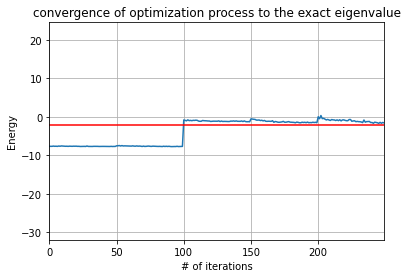

In [62]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [63]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

1it [00:00,  2.73it/s]

{'0011': 7, '1100': 191, '1110': 262, '0100': 38, '1101': 237, '1111': 61, '1010': 115, '0000': 19, '1011': 29, '0010': 26, '0001': 13, '0101': 13, '1000': 8, '1001': 5}
1.0


2it [00:00,  2.42it/s]

{'0011': 12, '1100': 358, '0000': 35, '1010': 88, '1110': 157, '0100': 42, '1111': 171, '1011': 79, '1101': 42, '0010': 13, '1001': 18, '0101': 7, '0001': 2}
1.0


3it [00:01,  2.28it/s]

{'1100': 382, '0110': 18, '1101': 258, '0100': 12, '1010': 81, '0000': 47, '1000': 63, '0111': 10, '1110': 66, '1001': 29, '0001': 21, '1111': 27, '0101': 5, '0010': 3, '0011': 2}
1.0


4it [00:01,  2.33it/s]

{'0100': 43, '1101': 226, '1110': 257, '1000': 15, '1100': 180, '1010': 140, '1011': 15, '1111': 59, '0000': 20, '0010': 23, '0101': 6, '0011': 5, '0110': 4, '0001': 28, '1001': 3}
1.0


5it [00:02,  2.26it/s]

{'0100': 48, '1101': 146, '0110': 6, '1111': 61, '1100': 56, '1110': 433, '1001': 73, '1000': 124, '0101': 31, '0010': 15, '1010': 23, '1011': 4, '0000': 1, '0011': 2, '0111': 1}
1.0


6it [00:02,  2.47it/s]

{'1110': 268, '1000': 13, '0000': 22, '0001': 32, '1010': 125, '1111': 46, '1101': 258, '1100': 161, '1011': 22, '0010': 22, '0100': 31, '0101': 12, '0011': 4, '1001': 7, '0110': 1}
1.0


7it [00:02,  2.44it/s]

{'1110': 280, '0100': 32, '1101': 220, '0001': 26, '1010': 133, '1111': 69, '1011': 23, '1000': 7, '0000': 19, '1100': 177, '0010': 23, '0101': 6, '1001': 7, '0110': 1, '0011': 1}
1.0


8it [00:03,  2.46it/s]

{'0111': 36, '1000': 23, '0000': 21, '0110': 127, '0100': 104, '1101': 120, '1110': 136, '0101': 103, '1010': 102, '1100': 121, '0010': 61, '0001': 10, '1111': 17, '1001': 19, '0011': 6, '1011': 18}
1.0


9it [00:03,  2.12it/s]

{'0100': 36, '1101': 254, '1100': 191, '1110': 229, '0001': 32, '1001': 7, '1010': 119, '1111': 65, '0101': 16, '1011': 17, '0000': 16, '0010': 21, '1000': 14, '0011': 7}
1.0


10it [00:04,  2.06it/s]

{'0100': 24, '1101': 226, '0010': 26, '1110': 302, '0001': 17, '1010': 122, '1100': 158, '1111': 56, '0101': 18, '0000': 32, '1000': 11, '1011': 21, '1001': 7, '0011': 3, '0110': 1}
1.0


11it [00:04,  2.23it/s]


{'0100': 40, '1101': 239, '1100': 183, '1110': 265, '0101': 10, '0000': 24, '1010': 136, '1111': 51, '0010': 18, '1011': 22, '1001': 6, '1000': 11, '0001': 16, '0011': 3}
1.0


1it [00:00,  1.71it/s]

{'1101': 64, '0100': 33, '1110': 337, '0001': 44, '1010': 113, '1001': 65, '1100': 216, '1111': 70, '1000': 39, '0110': 1, '0101': 10, '0011': 15, '0010': 10, '1011': 5, '0000': 2}
1.0


2it [00:01,  1.61it/s]

{'1110': 336, '1011': 86, '1100': 272, '1111': 47, '1010': 43, '1001': 80, '0100': 30, '1101': 47, '0000': 28, '0011': 29, '0001': 15, '1000': 5, '0101': 4, '0111': 1, '0010': 1}
1.0


3it [00:01,  1.92it/s]

{'1101': 131, '1100': 446, '0110': 20, '0001': 41, '1010': 123, '1001': 10, '1110': 64, '1000': 39, '0100': 27, '1011': 46, '0011': 29, '0000': 16, '0111': 1, '1111': 21, '0010': 6, '0101': 4}
1.0


4it [00:01,  2.29it/s]

{'0011': 20, '1100': 227, '1010': 132, '0001': 45, '1001': 63, '0000': 8, '1000': 30, '1110': 303, '1111': 84, '0100': 40, '1101': 48, '0101': 4, '0010': 11, '0111': 2, '1011': 5, '0110': 2}
1.0


5it [00:02,  2.53it/s]

{'1110': 396, '1100': 49, '1000': 199, '0100': 34, '1101': 105, '1010': 33, '1011': 66, '1111': 29, '0001': 13, '0101': 49, '0110': 6, '0010': 12, '0011': 23, '0000': 4, '0111': 6}
1.0


6it [00:02,  2.56it/s]

{'1110': 312, '1111': 92, '0011': 19, '1100': 248, '1011': 4, '1001': 47, '1010': 114, '1101': 60, '0100': 43, '1000': 38, '0000': 3, '0010': 10, '0001': 28, '0101': 2, '0111': 3, '0110': 1}
1.0


7it [00:02,  2.73it/s]

{'1110': 337, '1100': 252, '1010': 93, '0001': 58, '1001': 36, '0010': 11, '1111': 68, '0100': 46, '1000': 34, '0111': 3, '1101': 54, '0000': 7, '0011': 12, '1011': 7, '0101': 4, '0110': 2}
1.0


8it [00:03,  2.74it/s]

{'1110': 158, '0110': 159, '1111': 35, '1100': 154, '1001': 66, '0001': 31, '0100': 126, '0111': 47, '0010': 74, '1010': 66, '0101': 35, '0011': 16, '0000': 22, '1101': 19, '1000': 15, '1011': 1}
1.0


9it [00:03,  2.56it/s]

{'1110': 299, '0001': 45, '1010': 115, '1101': 53, '0100': 46, '1100': 227, '1111': 83, '0010': 23, '0101': 4, '1001': 54, '1000': 40, '0011': 26, '1011': 4, '0111': 2, '0000': 3}
1.0


10it [00:04,  2.49it/s]

{'0001': 46, '1010': 110, '1001': 52, '1110': 306, '0011': 22, '1100': 246, '1111': 84, '1101': 63, '1000': 28, '0100': 34, '0000': 5, '0010': 12, '0101': 6, '1011': 5, '0111': 4, '0110': 1}
1.0


11it [00:04,  2.34it/s]


{'1001': 41, '0001': 49, '1110': 303, '0011': 20, '1100': 231, '1101': 53, '0000': 7, '1111': 80, '1010': 123, '1000': 39, '0010': 17, '0100': 44, '0111': 4, '0101': 4, '1011': 6, '0110': 3}
1.0


1it [00:00,  2.03it/s]

{'1000': 152, '1001': 37, '1010': 133, '0100': 30, '1101': 165, '1100': 156, '1110': 225, '1011': 24, '1111': 55, '0010': 19, '0011': 5, '0101': 14, '0001': 8, '0110': 1}
1.0


2it [00:01,  1.87it/s]

{'1000': 143, '0101': 8, '1110': 147, '1111': 107, '1101': 79, '0100': 45, '1011': 63, '1100': 254, '1010': 97, '0011': 17, '0000': 11, '0010': 24, '1001': 19, '0110': 2, '0001': 5, '0111': 3}
1.0


3it [00:01,  1.97it/s]

{'0001': 14, '1010': 240, '1101': 205, '1100': 371, '0000': 24, '0111': 8, '1111': 27, '1110': 18, '0101': 10, '1011': 30, '0110': 24, '1001': 28, '0010': 8, '1000': 7, '0100': 10}
1.0


4it [00:02,  1.86it/s]

{'0101': 16, '1110': 218, '1100': 179, '1111': 56, '1000': 132, '0100': 43, '1001': 27, '1010': 123, '1101': 169, '1011': 12, '0010': 28, '0000': 1, '0011': 6, '0001': 13, '0110': 1}
1.0


5it [00:02,  2.14it/s]

{'0000': 16, '1000': 295, '1110': 348, '1001': 112, '1111': 60, '1100': 7, '0011': 5, '1101': 81, '0100': 28, '0110': 13, '0001': 13, '0010': 19, '1010': 13, '0111': 5, '0101': 8, '1011': 1}
1.0


6it [00:02,  2.36it/s]

{'1000': 127, '1100': 161, '0110': 3, '1111': 59, '1010': 110, '1110': 221, '1101': 189, '0010': 32, '0100': 40, '0011': 8, '0101': 8, '1001': 41, '0001': 14, '1011': 10, '0000': 1}
1.0


7it [00:03,  2.29it/s]

{'1110': 205, '1001': 34, '1010': 142, '0001': 7, '1000': 164, '1111': 58, '1101': 184, '1100': 143, '0010': 24, '0100': 25, '1011': 18, '0000': 2, '0011': 2, '0101': 11, '0110': 5}
1.0


8it [00:03,  2.26it/s]

{'0101': 135, '0100': 116, '1101': 73, '1000': 53, '0000': 82, '0010': 22, '0110': 114, '1010': 126, '1100': 79, '1110': 116, '0001': 30, '0111': 26, '1111': 21, '1001': 11, '1011': 15, '0011': 5}
1.0


9it [00:04,  2.07it/s]

{'1110': 213, '0100': 34, '1101': 178, '1111': 62, '1100': 155, '1010': 139, '1001': 43, '1000': 133, '0101': 16, '0011': 9, '0001': 9, '0010': 21, '1011': 9, '0000': 2, '0110': 1}
1.0


10it [00:04,  2.06it/s]

{'1000': 137, '0100': 31, '1101': 163, '1001': 38, '1010': 129, '1100': 164, '0101': 5, '1110': 248, '1111': 55, '1011': 19, '0010': 21, '0011': 5, '0001': 7, '0000': 1, '0110': 1}
1.0


11it [00:05,  2.12it/s]


{'1110': 201, '1100': 193, '1101': 173, '0100': 41, '1111': 59, '1000': 134, '1010': 111, '1011': 16, '0001': 11, '0110': 5, '1001': 29, '0011': 15, '0010': 29, '0101': 6, '0111': 1}
1.0


1it [00:00,  2.03it/s]

{'1101': 232, '0000': 37, '1110': 164, '1100': 242, '1111': 49, '0110': 41, '1010': 127, '1001': 23, '1011': 26, '0001': 5, '0010': 14, '0100': 22, '0101': 32, '0111': 8, '0011': 1, '1000': 1}
1.0


2it [00:01,  1.70it/s]

{'1101': 49, '0100': 51, '1100': 405, '0110': 35, '1111': 96, '1011': 83, '1110': 127, '1000': 20, '0111': 25, '1010': 87, '0001': 6, '0000': 20, '1001': 6, '0011': 3, '0010': 8, '0101': 3}
1.0


3it [00:01,  1.92it/s]

{'1101': 229, '1100': 350, '0010': 17, '1111': 48, '1010': 45, '1001': 59, '1110': 56, '0000': 19, '1000': 87, '0101': 40, '0011': 3, '0100': 56, '0111': 3, '0110': 10, '0001': 1, '1011': 1}
1.0


4it [00:02,  2.02it/s]

{'1110': 182, '1010': 115, '1101': 226, '1100': 224, '1111': 56, '0110': 42, '0000': 33, '0111': 13, '0101': 37, '1011': 28, '0010': 6, '1001': 29, '0100': 24, '0001': 6, '1000': 3}
1.0


5it [00:02,  2.16it/s]

{'1001': 50, '1110': 291, '0000': 55, '1000': 108, '1101': 199, '0110': 38, '1111': 65, '1100': 151, '0001': 32, '0100': 5, '0111': 10, '1010': 5, '0101': 5, '0010': 8, '1011': 1, '0011': 1}
1.0


6it [00:02,  2.26it/s]

{'1100': 249, '1111': 44, '0110': 39, '0101': 25, '1110': 156, '1010': 127, '1101': 244, '0111': 11, '1001': 32, '1011': 23, '0011': 1, '0100': 27, '0010': 11, '0000': 25, '0001': 8, '1000': 2}
1.0


7it [00:03,  2.37it/s]

{'1100': 255, '0100': 16, '1101': 226, '1010': 126, '1111': 44, '0000': 26, '1110': 178, '0010': 5, '1001': 23, '1011': 29, '0110': 52, '0101': 28, '0111': 11, '0001': 4, '0011': 1}
1.0


8it [00:03,  2.39it/s]

{'1110': 157, '1111': 26, '1010': 103, '0111': 7, '1000': 9, '1100': 171, '0010': 43, '1101': 198, '0101': 84, '0110': 48, '1011': 11, '0100': 98, '0011': 16, '0000': 18, '0001': 28, '1001': 7}
1.0


9it [00:03,  2.57it/s]

{'0110': 52, '1111': 44, '1100': 254, '1110': 173, '0000': 22, '1010': 119, '1101': 208, '0010': 12, '1001': 41, '0100': 25, '0111': 14, '0001': 5, '0101': 27, '1011': 24, '1000': 3, '0011': 1}
1.0


10it [00:04,  2.57it/s]

{'1011': 24, '1100': 252, '1111': 43, '1101': 206, '1110': 161, '1010': 130, '1001': 31, '0000': 30, '0101': 32, '0110': 54, '1000': 4, '0100': 27, '0010': 15, '0111': 9, '0001': 5, '0011': 1}
1.0


11it [00:04,  2.40it/s]


{'0100': 24, '1101': 244, '1110': 158, '0110': 41, '1111': 49, '1010': 125, '1100': 244, '0010': 11, '1011': 24, '0101': 31, '1001': 22, '0000': 31, '0001': 9, '1000': 3, '0011': 2, '0111': 6}
1.0


1it [00:00,  2.03it/s]

{'1100': 207, '0001': 4, '1010': 274, '0010': 39, '0000': 39, '1000': 31, '1101': 156, '0100': 34, '0110': 15, '1110': 85, '1011': 43, '1001': 54, '0101': 15, '1111': 17, '0011': 5, '0111': 6}
1.0


2it [00:01,  1.92it/s]

{'0001': 17, '1001': 56, '1010': 156, '1100': 339, '1110': 56, '1011': 132, '1101': 46, '1000': 32, '1111': 51, '0010': 26, '0100': 34, '0110': 15, '0011': 23, '0101': 9, '0000': 24, '0111': 8}
1.0


3it [00:01,  1.91it/s]

{'1100': 244, '0101': 14, '1111': 33, '0100': 64, '1101': 151, '0000': 37, '1000': 249, '1001': 92, '1010': 58, '0011': 7, '0010': 36, '0111': 5, '1110': 25, '0110': 5, '0001': 3, '1011': 1}
1.0


4it [00:02,  1.93it/s]

{'1100': 232, '0110': 15, '1111': 28, '0000': 26, '1011': 54, '0010': 25, '0100': 38, '1010': 254, '1110': 100, '1101': 134, '0011': 8, '0111': 6, '1000': 39, '1001': 51, '0101': 12, '0001': 2}
1.0


5it [00:02,  2.08it/s]

{'1100': 201, '1000': 48, '1101': 186, '1001': 35, '0001': 13, '1110': 299, '0110': 45, '1111': 60, '0100': 35, '1010': 47, '0111': 10, '0000': 28, '1011': 6, '0101': 8, '0010': 1, '0011': 2}
1.0


6it [00:02,  2.16it/s]

{'1010': 266, '0010': 22, '1111': 25, '1100': 222, '0000': 36, '1000': 28, '1101': 157, '1110': 78, '0110': 26, '1001': 47, '1011': 55, '0001': 3, '0101': 19, '0111': 9, '0100': 23, '0011': 8}
1.0


7it [00:03,  2.31it/s]

{'1001': 42, '1010': 243, '1011': 46, '0010': 31, '1101': 161, '0100': 34, '0000': 31, '1100': 233, '1110': 76, '1111': 21, '0101': 19, '0011': 10, '1000': 38, '0110': 32, '0111': 6, '0001': 1}
1.0


8it [00:03,  2.28it/s]

{'0010': 95, '1100': 146, '1001': 21, '1010': 186, '0001': 38, '1101': 132, '0100': 90, '0101': 67, '0110': 11, '0000': 48, '1011': 41, '0011': 17, '1110': 93, '1111': 17, '1000': 17, '0111': 5}
1.0


9it [00:04,  2.25it/s]

{'1100': 210, '1001': 47, '1010': 234, '0111': 6, '1110': 84, '0100': 35, '1101': 158, '0010': 26, '1000': 57, '1111': 20, '0000': 36, '0110': 30, '1011': 58, '0101': 12, '0011': 6, '0001': 5}
1.0


10it [00:04,  2.53it/s]

{'1111': 16, '1110': 85, '1001': 35, '1010': 254, '1100': 211, '1101': 182, '1011': 55, '0000': 44, '0110': 21, '0111': 3, '0001': 6, '0101': 10, '0100': 33, '0011': 6, '1000': 32, '0010': 31}
1.0


11it [00:04,  2.24it/s]


{'1101': 161, '1100': 226, '0000': 41, '1011': 45, '0010': 28, '0101': 21, '1110': 82, '1010': 237, '1001': 49, '1000': 37, '0100': 30, '0011': 11, '1111': 26, '0110': 21, '0001': 4, '0111': 5}
1.0


1it [00:00,  1.89it/s]

{'1001': 25, '1010': 133, '1101': 232, '1110': 175, '0110': 44, '1111': 39, '1100': 261, '0000': 18, '0111': 13, '1011': 26, '0100': 22, '0011': 2, '0101': 25, '1000': 2, '0010': 7}
1.0


2it [00:00,  2.20it/s]

{'1100': 409, '0111': 23, '1011': 75, '0110': 26, '1111': 85, '1110': 123, '1000': 25, '0000': 33, '1101': 62, '1010': 83, '0100': 53, '0010': 4, '0011': 5, '1001': 8, '0001': 2, '0101': 8}
1.0


3it [00:01,  2.25it/s]

{'1100': 345, '0110': 4, '1010': 46, '1001': 51, '1101': 242, '1110': 59, '0010': 21, '1000': 80, '0101': 48, '0100': 62, '1111': 42, '0000': 14, '0011': 7, '0001': 2, '0111': 1}
1.0


4it [00:01,  2.35it/s]

{'0101': 33, '1110': 173, '1100': 221, '1101': 240, '1111': 63, '0110': 46, '1001': 31, '1011': 19, '1010': 125, '0001': 12, '0000': 20, '0111': 10, '0100': 22, '1000': 1, '0010': 6, '0011': 2}
1.0


5it [00:02,  2.38it/s]

{'1000': 113, '1100': 134, '1101': 204, '1110': 296, '0110': 43, '1111': 61, '0111': 14, '0001': 38, '0000': 45, '1001': 47, '1010': 3, '0100': 6, '0101': 9, '0010': 8, '0011': 2, '1011': 1}
1.0


6it [00:02,  2.60it/s]

{'1100': 249, '1101': 226, '0010': 9, '0101': 41, '1110': 164, '1010': 119, '1000': 3, '0000': 34, '0110': 42, '1011': 28, '0011': 3, '1111': 48, '0100': 15, '1001': 30, '0111': 10, '0001': 3}
1.0


7it [00:02,  2.63it/s]

{'0001': 3, '1001': 32, '1010': 108, '1100': 249, '1110': 180, '1101': 235, '1111': 52, '0110': 51, '0000': 27, '1011': 21, '0101': 34, '0100': 20, '0111': 8, '0010': 3, '1000': 1}
1.0


8it [00:03,  2.75it/s]

{'1110': 159, '0101': 84, '1001': 4, '1010': 89, '1100': 186, '0110': 54, '1101': 185, '0100': 77, '0001': 21, '1000': 9, '0010': 48, '0011': 6, '1111': 44, '0000': 16, '1011': 26, '0111': 16}
1.0


9it [00:03,  2.55it/s]

{'1010': 143, '1001': 27, '1101': 227, '1110': 166, '0101': 26, '1100': 246, '0000': 29, '1111': 53, '0111': 12, '0100': 20, '1011': 18, '0110': 38, '0001': 8, '0010': 9, '0011': 2}
1.0


10it [00:04,  2.49it/s]

{'1101': 230, '1100': 224, '1111': 49, '1001': 35, '1010': 129, '1110': 180, '0101': 34, '0010': 10, '0110': 42, '0000': 29, '0111': 17, '1011': 23, '0100': 17, '0001': 3, '0011': 1, '1000': 1}
1.0


11it [00:04,  2.48it/s]


{'1110': 176, '1100': 242, '0100': 13, '1101': 240, '1010': 117, '1001': 30, '0110': 53, '0000': 29, '0010': 11, '1011': 22, '1111': 48, '0111': 8, '0101': 27, '0001': 7, '1000': 1}
1.0


1it [00:00,  2.47it/s]

{'1100': 353, '0000': 65, '1111': 28, '1001': 3, '0001': 21, '1010': 95, '1110': 79, '1101': 236, '1000': 72, '0010': 13, '0101': 15, '0110': 16, '0011': 3, '0100': 11, '0111': 5, '1011': 9}
1.0


2it [00:01,  1.53it/s]

{'0011': 9, '1100': 527, '0000': 81, '1000': 54, '1101': 65, '0110': 12, '1110': 69, '1001': 20, '0001': 15, '1010': 47, '1111': 45, '1011': 34, '0100': 20, '0101': 3, '0010': 15, '0111': 8}
1.0


3it [00:01,  1.79it/s]

{'1010': 126, '1100': 328, '1111': 59, '0101': 20, '1110': 100, '1011': 20, '1101': 208, '1000': 44, '0010': 57, '0110': 6, '0000': 17, '0100': 23, '0011': 10, '0111': 3, '1001': 2, '0001': 1}
1.0


4it [00:02,  1.89it/s]

{'1101': 244, '1001': 4, '0011': 2, '1100': 370, '0000': 68, '1000': 75, '0111': 3, '1110': 80, '0010': 13, '0110': 18, '0101': 14, '1010': 71, '0100': 15, '1111': 20, '1011': 14, '0001': 13}
1.0


5it [00:02,  2.08it/s]

{'0000': 61, '1000': 352, '1100': 77, '1111': 36, '1110': 178, '0100': 11, '0111': 7, '1001': 127, '0110': 31, '1101': 107, '0001': 33, '0010': 1, '1011': 2, '1010': 1}
1.0


6it [00:03,  2.13it/s]

{'1101': 242, '0100': 12, '1010': 87, '0001': 18, '0110': 21, '1110': 87, '1000': 79, '1100': 354, '0000': 59, '0011': 2, '0010': 13, '1111': 22, '0101': 10, '1011': 11, '0111': 4, '1001': 3}
1.0


7it [00:03,  1.94it/s]

{'1101': 245, '1100': 361, '1001': 2, '1010': 69, '0110': 24, '0010': 13, '1110': 88, '1000': 67, '0000': 75, '1111': 14, '0001': 23, '0101': 12, '0100': 15, '1011': 10, '0111': 4, '0011': 2}
1.0


8it [00:04,  1.99it/s]

{'1100': 221, '1001': 16, '0010': 25, '1011': 12, '0101': 76, '1110': 84, '0100': 150, '1101': 159, '0110': 23, '0000': 54, '1000': 93, '1111': 19, '1010': 70, '0111': 8, '0011': 3, '0001': 11}
1.0


9it [00:04,  1.88it/s]

{'1100': 359, '0100': 15, '1101': 249, '0000': 70, '0110': 15, '0001': 20, '1010': 75, '1110': 70, '1000': 59, '1111': 34, '1011': 11, '0010': 20, '0101': 15, '1001': 4, '0111': 7, '0011': 1}
1.0


10it [00:05,  2.00it/s]

{'0010': 10, '1010': 82, '0011': 2, '1100': 352, '1000': 84, '1110': 92, '1101': 239, '1111': 30, '0000': 55, '1011': 13, '0110': 12, '0100': 17, '0101': 14, '0001': 13, '0111': 4, '1001': 5}
1.0


11it [00:05,  1.98it/s]


{'1010': 73, '0001': 13, '1100': 352, '1110': 88, '1101': 238, '1011': 13, '1000': 67, '0110': 26, '0010': 17, '0101': 18, '1111': 29, '0000': 67, '0111': 2, '1001': 4, '0100': 16, '0011': 1}
1.0


1it [00:00,  3.55it/s]

{'0111': 22, '1010': 184, '0010': 20, '1100': 140, '0101': 49, '1110': 130, '1101': 165, '0110': 81, '1000': 27, '0100': 42, '1111': 39, '0001': 23, '0000': 39, '1001': 34, '0011': 2, '1011': 27}
1.0


2it [00:00,  3.00it/s]

{'0100': 102, '1101': 59, '1100': 269, '0011': 13, '1010': 88, '1001': 26, '0000': 71, '1110': 91, '1000': 22, '1111': 85, '0111': 50, '0110': 48, '1011': 78, '0010': 15, '0101': 6, '0001': 1}
1.0


3it [00:01,  2.79it/s]

{'1101': 182, '0011': 14, '1100': 294, '1000': 145, '0101': 61, '1001': 57, '0010': 61, '0111': 11, '1010': 37, '0100': 49, '0110': 72, '1111': 19, '0001': 10, '1110': 7, '0000': 4, '1011': 1}
1.0


4it [00:01,  2.75it/s]

{'1101': 142, '1110': 143, '0101': 34, '1100': 168, '1010': 147, '1001': 39, '0110': 92, '1011': 44, '0111': 16, '0100': 45, '0000': 50, '0010': 23, '1111': 34, '0001': 20, '1000': 25, '0011': 2}
1.0


5it [00:01,  2.61it/s]

{'1111': 63, '0110': 77, '0101': 17, '1110': 304, '1100': 118, '1101': 166, '0000': 73, '0001': 49, '1000': 59, '0111': 19, '0010': 28, '1001': 24, '0011': 10, '0100': 16, '1010': 1}
1.0


6it [00:02,  2.50it/s]

{'1101': 151, '0100': 52, '1100': 167, '1000': 18, '0101': 53, '1110': 152, '1001': 29, '1010': 144, '0010': 20, '0110': 75, '1111': 45, '0001': 31, '1011': 26, '0000': 47, '0111': 11, '0011': 3}
1.0


7it [00:02,  2.12it/s]

{'1110': 138, '0101': 68, '1010': 152, '1100': 174, '1101': 155, '0110': 75, '1111': 27, '0000': 41, '0111': 17, '0100': 33, '1001': 48, '1011': 27, '0010': 37, '0001': 14, '1000': 15, '0011': 3}
1.0


8it [00:03,  1.93it/s]

{'0000': 73, '0100': 33, '1101': 139, '0101': 68, '1110': 62, '1100': 179, '0110': 165, '1011': 27, '0010': 45, '1010': 127, '1111': 17, '0111': 35, '1001': 31, '0001': 11, '0011': 4, '1000': 8}
1.0


9it [00:03,  2.13it/s]

{'1001': 31, '1010': 162, '0011': 8, '0101': 56, '0000': 51, '1111': 31, '0110': 90, '0100': 35, '1110': 135, '0001': 24, '1100': 164, '1101': 150, '0010': 17, '1000': 27, '1011': 25, '0111': 18}
1.0


10it [00:04,  2.03it/s]

{'1010': 156, '1101': 135, '0101': 58, '1111': 35, '0110': 77, '1011': 29, '0010': 16, '1000': 21, '0100': 53, '1110': 154, '1100': 166, '1001': 38, '0001': 19, '0000': 39, '0011': 5, '0111': 23}
1.0


11it [00:04,  2.23it/s]


{'1101': 136, '1010': 148, '0101': 57, '1110': 142, '0000': 34, '0110': 78, '1100': 192, '1011': 34, '0100': 53, '0111': 18, '1000': 18, '0001': 20, '1001': 34, '0010': 21, '1111': 36, '0011': 3}
1.0


1it [00:00,  1.90it/s]

{'0110': 87, '0001': 11, '1010': 321, '1100': 81, '1110': 141, '0010': 41, '1011': 55, '0000': 66, '0101': 22, '1101': 112, '1001': 31, '1000': 14, '0011': 6, '1111': 27, '0111': 8, '0100': 1}
1.0


2it [00:01,  1.91it/s]

{'1111': 85, '0110': 62, '1101': 18, '1010': 212, '1011': 172, '0010': 22, '1110': 107, '0000': 54, '1001': 44, '0001': 17, '1100': 143, '0111': 46, '0101': 9, '0100': 16, '0011': 17}
1.0


3it [00:01,  2.13it/s]

{'0010': 41, '1100': 215, '1101': 135, '0001': 4, '1010': 153, '0110': 33, '1111': 15, '1000': 162, '0100': 48, '1001': 88, '0011': 13, '0101': 27, '0000': 50, '1011': 3, '1110': 35, '0111': 2}
1.0


4it [00:01,  2.21it/s]

{'1100': 80, '1101': 117, '1001': 26, '1010': 309, '0000': 67, '1110': 152, '0110': 98, '1011': 53, '0101': 16, '0001': 14, '0111': 17, '1111': 32, '0010': 29, '0011': 2, '1000': 12}
1.0


5it [00:02,  2.44it/s]

{'1110': 428, '1111': 85, '1100': 24, '0100': 20, '1101': 125, '1000': 86, '1001': 14, '0001': 28, '0110': 92, '0000': 48, '1011': 6, '1010': 29, '0011': 8, '0010': 17, '0111': 14}
1.0


6it [00:02,  2.62it/s]

{'1010': 314, '1100': 81, '1111': 26, '0110': 77, '0000': 75, '1110': 166, '1101': 120, '0111': 13, '1000': 11, '1011': 62, '1001': 17, '0010': 29, '0101': 17, '0011': 5, '0001': 10, '0100': 1}
1.0


7it [00:02,  2.57it/s]

{'1100': 77, '1010': 326, '1101': 98, '0000': 58, '0010': 28, '1111': 33, '0110': 97, '0101': 19, '1110': 155, '0001': 15, '0011': 5, '0100': 2, '0111': 20, '1011': 59, '1001': 21, '1000': 11}
1.0


8it [00:03,  2.55it/s]

{'1110': 192, '1101': 102, '0000': 24, '0001': 45, '1011': 48, '0010': 134, '0011': 31, '0110': 46, '0101': 26, '1000': 46, '1111': 48, '1010': 191, '1100': 48, '0100': 36, '1001': 1, '0111': 6}
1.0


9it [00:03,  2.73it/s]

{'0001': 15, '1010': 337, '1001': 16, '1011': 46, '1110': 159, '0000': 65, '0110': 92, '1101': 90, '1111': 31, '1100': 86, '0010': 31, '0111': 29, '0101': 9, '0011': 6, '1000': 10, '0100': 2}
1.0


10it [00:04,  2.49it/s]

{'1010': 341, '0010': 33, '1011': 63, '1111': 30, '0110': 75, '1100': 70, '0111': 10, '0000': 75, '1110': 147, '1001': 17, '1101': 113, '0101': 17, '1000': 15, '0011': 5, '0001': 10, '0100': 3}
1.0


11it [00:04,  2.43it/s]


{'1010': 319, '0011': 6, '1101': 109, '0111': 23, '1011': 58, '0110': 80, '0000': 58, '1110': 159, '0010': 31, '1100': 76, '1111': 31, '0101': 22, '1001': 23, '0001': 14, '1000': 15}
1.0


1it [00:00,  3.24it/s]

{'1110': 328, '0100': 33, '1101': 58, '1010': 142, '0011': 12, '1100': 282, '0000': 23, '1111': 19, '1000': 16, '0110': 72, '0001': 11, '1011': 15, '0101': 5, '0010': 7, '0111': 1}
1.0


2it [00:00,  2.98it/s]

{'0101': 5, '1110': 215, '1100': 286, '0100': 39, '1101': 52, '1111': 114, '1010': 92, '1011': 70, '0011': 15, '0000': 28, '0111': 30, '0110': 54, '1001': 7, '1000': 12, '0010': 4, '0001': 1}
1.0


3it [00:01,  2.72it/s]

{'1100': 524, '1010': 48, '1000': 118, '0100': 87, '0110': 18, '1111': 59, '1110': 95, '0010': 9, '0011': 18, '1011': 5, '1001': 7, '1101': 25, '0000': 6, '0101': 4, '0111': 1}
1.0


4it [00:01,  2.74it/s]

{'1010': 149, '1110': 328, '1111': 13, '0110': 69, '1100': 308, '0000': 10, '0100': 31, '1101': 53, '0111': 2, '1000': 17, '0001': 9, '0011': 11, '1011': 16, '0010': 4, '0101': 4}
1.0


5it [00:01,  2.59it/s]

{'1110': 429, '0110': 68, '1100': 238, '1101': 30, '0000': 48, '1000': 85, '1010': 12, '0111': 3, '1011': 29, '1001': 30, '0010': 20, '0001': 13, '1111': 4, '0011': 6, '0101': 5, '0100': 4}
1.0


6it [00:02,  2.70it/s]

{'1010': 175, '0010': 8, '1011': 13, '1100': 325, '1110': 295, '0110': 63, '1101': 49, '1000': 16, '1111': 13, '0011': 9, '0100': 36, '0000': 13, '0101': 1, '0001': 7, '0111': 1}
1.0


7it [00:02,  2.70it/s]

{'1110': 290, '1001': 1, '1010': 158, '1101': 70, '0100': 43, '0110': 55, '0011': 13, '1100': 315, '0000': 12, '1000': 23, '1111': 10, '0111': 2, '1011': 18, '0001': 9, '0010': 4, '0101': 1}
1.0


8it [00:03,  2.35it/s]

{'1100': 247, '0101': 24, '1110': 268, '0110': 83, '0010': 69, '0001': 6, '1010': 89, '0100': 110, '0000': 28, '1101': 42, '1111': 16, '1011': 23, '1000': 5, '1001': 8, '0111': 6}
1.0


9it [00:03,  2.45it/s]

{'0101': 4, '1110': 296, '1010': 142, '0001': 14, '0110': 70, '0011': 12, '1100': 311, '1000': 27, '1111': 13, '0000': 11, '0100': 42, '1011': 9, '1101': 64, '0010': 8, '1001': 1}
1.0


10it [00:04,  2.06it/s]

{'1011': 28, '1100': 320, '1110': 267, '0001': 9, '1010': 157, '1101': 48, '0100': 49, '1111': 19, '0110': 70, '0101': 4, '1000': 20, '0010': 6, '0011': 7, '0000': 18, '0111': 2}
1.0


11it [00:04,  2.39it/s]


{'1001': 1, '1010': 154, '1110': 301, '1100': 295, '1011': 16, '0110': 66, '1000': 22, '1101': 63, '0100': 26, '0000': 23, '0001': 16, '0011': 12, '1111': 15, '0010': 7, '0101': 6, '0111': 1}
1.0


1it [00:00,  2.50it/s]

{'1000': 121, '0000': 58, '1110': 232, '0110': 39, '1100': 140, '1101': 188, '1001': 50, '1010': 63, '0001': 22, '1011': 15, '0111': 11, '0010': 5, '1111': 47, '0100': 11, '0011': 4, '0101': 18}
1.0


2it [00:00,  2.13it/s]

{'0100': 28, '1100': 279, '1110': 156, '1010': 44, '1001': 50, '1111': 116, '0010': 7, '0111': 28, '1000': 123, '0000': 54, '0110': 32, '0101': 8, '1011': 32, '1101': 51, '0001': 13, '0011': 3}
1.0


3it [00:01,  2.09it/s]

{'1001': 61, '0011': 9, '1100': 320, '0010': 14, '1011': 20, '0000': 56, '1101': 216, '0101': 25, '1000': 163, '0110': 16, '1110': 61, '0100': 24, '0001': 10, '1111': 22, '1010': 6, '0111': 1}
1.0


4it [00:01,  2.26it/s]

{'1100': 135, '1010': 63, '1001': 53, '1000': 91, '1110': 266, '1101': 203, '1011': 16, '0010': 13, '0110': 32, '1111': 59, '0101': 16, '0000': 43, '0001': 19, '0111': 9, '0100': 5, '0011': 1}
1.0


5it [00:02,  2.45it/s]

{'0001': 34, '1010': 44, '1110': 297, '1100': 194, '1101': 171, '1011': 8, '0111': 13, '1111': 55, '1000': 36, '0000': 36, '0110': 60, '0011': 3, '1001': 33, '0010': 9, '0101': 14, '0100': 17}
1.0


6it [00:02,  2.57it/s]

{'0110': 45, '1100': 139, '0100': 7, '1011': 18, '0000': 51, '1000': 99, '1110': 249, '1001': 56, '1101': 198, '1111': 50, '1010': 54, '0001': 15, '0111': 11, '0010': 11, '0101': 20, '0011': 1}
1.0


7it [00:02,  2.61it/s]

{'0101': 26, '1110': 232, '1001': 75, '1010': 61, '1000': 100, '0100': 14, '1101': 174, '1100': 130, '0000': 60, '0110': 49, '1111': 61, '0001': 19, '0111': 10, '1011': 8, '0011': 1, '0010': 4}
1.0


8it [00:03,  2.58it/s]

{'0100': 27, '1101': 176, '1010': 36, '0001': 39, '1000': 85, '0000': 91, '1110': 201, '1100': 121, '0010': 26, '1001': 27, '1111': 68, '0111': 13, '0110': 52, '0101': 49, '1011': 8, '0011': 5}
1.0


9it [00:03,  2.51it/s]

{'1101': 181, '1111': 50, '0110': 40, '0000': 39, '1000': 116, '1100': 138, '1001': 68, '0101': 32, '1010': 63, '1110': 234, '0001': 18, '0100': 14, '0111': 14, '1011': 10, '0010': 6, '0011': 1}
1.0


10it [00:04,  2.64it/s]

{'0110': 47, '0000': 52, '1000': 101, '1110': 254, '0001': 17, '1001': 66, '1100': 124, '1101': 181, '1010': 63, '0010': 8, '1111': 55, '0111': 7, '1011': 13, '0101': 23, '0100': 13}
1.0


11it [00:04,  2.44it/s]


{'0000': 53, '1000': 87, '0100': 9, '1101': 191, '1111': 44, '1100': 141, '1110': 243, '0010': 7, '1010': 64, '1001': 61, '0110': 47, '0111': 11, '0001': 18, '0101': 31, '1011': 12, '0011': 5}
1.0


1it [00:00,  2.17it/s]

{'1110': 203, '1100': 224, '0100': 63, '1101': 229, '0000': 29, '1010': 117, '1111': 45, '0110': 23, '1011': 22, '0111': 5, '0101': 30, '1001': 20, '0001': 6, '1000': 6, '0010': 1, '0011': 1}
1.0


2it [00:00,  2.29it/s]

{'0001': 6, '1010': 58, '1100': 392, '0101': 19, '0100': 90, '0110': 13, '1111': 109, '1011': 75, '1110': 138, '0000': 26, '1000': 16, '1101': 58, '0111': 9, '1001': 9, '0010': 2, '0011': 4}
1.0


3it [00:01,  2.22it/s]

{'1100': 390, '1101': 237, '0100': 87, '1000': 36, '1001': 36, '1010': 73, '1110': 48, '1111': 36, '0101': 32, '0010': 24, '0111': 5, '0011': 6, '0110': 5, '0001': 1, '0000': 5, '1011': 3}
1.0


4it [00:01,  2.42it/s]

{'0101': 33, '1110': 228, '1001': 15, '1010': 121, '1101': 220, '1100': 221, '1111': 38, '0000': 30, '0111': 9, '1000': 7, '0110': 22, '0100': 49, '1011': 17, '0001': 10, '0010': 4}
1.0


5it [00:02,  2.43it/s]

{'1110': 346, '1101': 171, '0000': 3, '1000': 133, '1001': 62, '0010': 19, '1111': 67, '0110': 10, '1100': 90, '0111': 1, '0001': 9, '0100': 74, '0101': 30, '1011': 3, '0011': 3, '1010': 3}
1.0


6it [00:02,  2.63it/s]

{'0101': 29, '1110': 213, '0100': 50, '1101': 232, '1100': 239, '0110': 28, '0010': 2, '0000': 27, '1010': 118, '1111': 41, '1011': 22, '0111': 9, '0001': 5, '1001': 8, '1000': 1}
1.0


7it [00:03,  2.26it/s]

{'1111': 52, '0110': 18, '1101': 247, '0100': 61, '1110': 204, '1100': 212, '0000': 23, '1010': 113, '0101': 42, '0001': 13, '1001': 11, '0111': 5, '1000': 5, '1011': 14, '0010': 4}
1.0


8it [00:03,  2.29it/s]

{'0101': 224, '0100': 249, '1101': 50, '0001': 11, '1100': 44, '0110': 141, '0010': 43, '0111': 27, '1110': 80, '1011': 11, '0000': 10, '1000': 19, '1010': 85, '0011': 12, '1111': 15, '1001': 3}
1.0


9it [00:03,  2.18it/s]

{'0101': 35, '1110': 192, '1100': 234, '1101': 242, '0100': 64, '1001': 14, '1010': 108, '0110': 24, '0111': 7, '1000': 3, '0000': 29, '1011': 20, '1111': 41, '0001': 9, '0011': 1, '0010': 1}
1.0


10it [00:04,  2.28it/s]

{'1011': 14, '1100': 241, '0101': 29, '1110': 230, '1101': 219, '0001': 10, '1010': 101, '0110': 20, '1111': 51, '0100': 59, '0000': 25, '0111': 5, '0010': 4, '1000': 5, '0011': 1, '1001': 10}
1.0


11it [00:04,  2.24it/s]


{'0100': 54, '1101': 228, '1100': 252, '1010': 109, '1110': 187, '1011': 20, '0000': 31, '1111': 49, '0101': 35, '1001': 12, '0110': 26, '0010': 2, '0001': 8, '0111': 7, '1000': 4}
1.0


1it [00:00,  1.76it/s]

{'0101': 31, '1110': 168, '1010': 150, '0100': 55, '1101': 166, '1100': 189, '0110': 126, '0000': 26, '0111': 18, '1001': 23, '0001': 7, '1111': 33, '1011': 26, '0010': 6}
1.0


2it [00:01,  1.69it/s]

{'1111': 88, '1100': 321, '1110': 100, '0100': 74, '0111': 71, '1010': 110, '1001': 10, '1011': 72, '0000': 29, '1101': 56, '1000': 6, '0110': 75, '0101': 6, '0010': 2, '0011': 1, '0001': 3}
1.0


3it [00:01,  1.83it/s]

{'1000': 65, '1101': 192, '1001': 50, '1010': 73, '0110': 183, '0011': 10, '1100': 328, '0111': 22, '0101': 34, '1111': 27, '0010': 19, '0000': 10, '1011': 1, '0100': 4, '1110': 5, '0001': 1}
1.0


4it [00:02,  1.94it/s]

{'1010': 143, '0110': 115, '1110': 179, '1100': 182, '1101': 148, '0100': 66, '0000': 24, '0111': 30, '1001': 25, '0101': 40, '0010': 7, '1111': 33, '0001': 9, '1011': 22, '0011': 1}
1.0


5it [00:02,  1.90it/s]

{'1110': 265, '1101': 166, '0000': 85, '1000': 104, '0110': 66, '0111': 16, '1001': 35, '0010': 71, '1111': 66, '0001': 24, '1100': 91, '1010': 17, '0101': 10, '0011': 6, '1011': 2}
1.0


6it [00:03,  1.98it/s]

{'1111': 39, '0110': 153, '1100': 179, '1011': 26, '1001': 20, '1010': 146, '1110': 170, '1101': 158, '0101': 34, '0100': 59, '0000': 16, '0001': 5, '0111': 16, '0010': 3}
1.0


7it [00:03,  1.88it/s]

{'0110': 118, '0001': 9, '1010': 135, '0100': 78, '0101': 22, '1110': 167, '1100': 199, '0000': 24, '1101': 164, '1011': 29, '1111': 29, '1001': 28, '0111': 15, '0010': 6, '0011': 1}
1.0


8it [00:04,  2.00it/s]

{'0111': 46, '0110': 256, '1010': 108, '0100': 27, '1101': 151, '1100': 208, '0000': 13, '0010': 50, '1011': 22, '0101': 38, '1110': 40, '0001': 29, '0011': 9, '1000': 9, '1111': 17, '1001': 1}
1.0


9it [00:04,  1.98it/s]

{'1110': 144, '0101': 39, '0110': 141, '1111': 38, '1010': 146, '0100': 72, '1101': 156, '1100': 180, '0111': 29, '0000': 20, '1011': 24, '0010': 8, '1001': 22, '0001': 5}
1.0


10it [00:05,  2.07it/s]

{'1100': 189, '0000': 31, '0110': 135, '0100': 61, '1001': 28, '1010': 144, '1110': 149, '0101': 29, '1101': 153, '1111': 39, '0111': 27, '1011': 27, '0010': 7, '0001': 4, '0011': 1}
1.0


11it [00:05,  1.94it/s]


{'0100': 55, '1101': 161, '0101': 25, '1110': 130, '0110': 130, '0111': 33, '1010': 169, '1011': 29, '1100': 192, '1001': 18, '0001': 5, '1111': 42, '0000': 29, '0010': 5, '0011': 1}
1.0


1it [00:00,  2.50it/s]

{'1101': 225, '0000': 21, '1010': 120, '1110': 199, '0110': 41, '1111': 48, '1100': 251, '0010': 15, '0101': 35, '1001': 14, '1011': 22, '0111': 5, '0001': 5, '0100': 22, '1000': 1}
1.0


2it [00:00,  2.77it/s]

{'1100': 428, '1110': 154, '0010': 7, '1011': 75, '0100': 51, '0111': 18, '1000': 22, '1010': 89, '0110': 45, '1101': 34, '0000': 32, '0011': 8, '1111': 45, '0101': 6, '1001': 4, '0001': 6}
1.0


3it [00:01,  2.48it/s]

{'0100': 58, '1101': 233, '1100': 358, '1110': 60, '0000': 16, '1000': 72, '1111': 35, '1001': 52, '1010': 56, '0101': 36, '0010': 25, '0110': 8, '0011': 6, '0111': 7, '0001': 2}
1.0


4it [00:01,  2.66it/s]

{'0101': 37, '1110': 195, '1100': 250, '0001': 7, '1111': 45, '0110': 56, '1101': 194, '0100': 24, '0000': 27, '1010': 124, '1001': 18, '1011': 26, '1000': 5, '0111': 8, '0010': 8}
1.0


5it [00:01,  2.77it/s]

{'0110': 51, '1111': 76, '1110': 325, '0011': 8, '1100': 127, '1001': 54, '1101': 185, '1000': 106, '0001': 21, '0000': 45, '0010': 7, '0111': 5, '0101': 8, '1010': 1, '1011': 4, '0100': 1}
1.0


6it [00:02,  2.93it/s]

{'1100': 238, '0101': 23, '1110': 211, '0110': 49, '1001': 19, '1010': 138, '1101': 194, '1011': 25, '0010': 12, '0100': 17, '1111': 51, '1000': 3, '0111': 14, '0000': 24, '0011': 2, '0001': 4}
1.0


7it [00:02,  2.94it/s]

{'1100': 236, '0100': 24, '1101': 215, '1111': 34, '0110': 56, '1110': 193, '1010': 133, '1011': 30, '1001': 21, '0010': 12, '0101': 33, '0001': 10, '0000': 14, '0011': 1, '1000': 3, '0111': 9}
1.0


8it [00:02,  2.92it/s]

{'0100': 95, '1101': 163, '1100': 180, '0110': 62, '1110': 177, '1011': 16, '0010': 57, '0000': 15, '1111': 40, '1010': 103, '0011': 9, '0111': 7, '0101': 72, '1000': 4, '0001': 24}
1.0


9it [00:03,  2.71it/s]

{'1011': 28, '1100': 251, '1010': 103, '0101': 26, '1110': 179, '1101': 228, '0110': 54, '1111': 49, '1001': 18, '0100': 26, '0000': 27, '0111': 8, '0010': 8, '1000': 7, '0011': 2, '0001': 10}
1.0


10it [00:03,  2.70it/s]

{'1101': 191, '1010': 125, '1001': 30, '1100': 266, '1110': 184, '0101': 28, '0110': 51, '1111': 44, '0001': 5, '0100': 20, '0000': 29, '0111': 6, '1011': 30, '0010': 13, '1000': 2}
1.0


11it [00:04,  2.71it/s]


{'1100': 252, '1101': 229, '0101': 38, '1110': 177, '1111': 51, '0110': 42, '1010': 123, '0000': 20, '1000': 4, '0100': 21, '1011': 34, '0111': 6, '1001': 12, '0010': 7, '0001': 7, '0011': 1}
1.0


1it [00:00,  3.42it/s]

{'1001': 125, '1010': 128, '1110': 226, '1000': 138, '0100': 21, '1101': 134, '0110': 66, '1111': 41, '1100': 74, '0111': 15, '0101': 30, '1011': 19, '0011': 1, '0001': 1, '0010': 5}
1.0


2it [00:00,  3.39it/s]

{'0100': 48, '1101': 37, '1100': 191, '0101': 9, '1111': 100, '1011': 53, '0111': 33, '1000': 255, '1110': 153, '1010': 70, '0110': 57, '0010': 5, '1001': 9, '0011': 4}
1.0


3it [00:00,  3.13it/s]

{'1011': 28, '1001': 113, '1010': 135, '1100': 268, '1000': 101, '0100': 71, '1101': 169, '1110': 40, '0101': 61, '1111': 11, '0110': 14, '0111': 5, '0001': 3, '0000': 4, '0010': 1}
1.0


4it [00:01,  2.73it/s]

{'1010': 112, '1001': 149, '1000': 110, '1110': 211, '0110': 73, '1111': 63, '1101': 130, '1100': 66, '0101': 41, '0100': 23, '1011': 21, '0000': 1, '0111': 17, '0010': 7}
1.0


5it [00:01,  2.33it/s]

{'1101': 273, '1100': 174, '0110': 37, '1111': 69, '0000': 17, '1000': 48, '0010': 24, '1110': 300, '0101': 19, '1010': 10, '0001': 17, '0100': 11, '0111': 10, '1001': 6, '1011': 4, '0011': 5}
1.0


6it [00:02,  2.29it/s]

{'0100': 20, '1101': 142, '0101': 31, '1110': 237, '0110': 66, '1001': 117, '1100': 85, '1000': 113, '0011': 2, '1010': 110, '1111': 54, '1011': 22, '0111': 18, '0010': 7}
1.0


7it [00:02,  2.04it/s]

{'0110': 65, '1111': 40, '0101': 34, '1110': 216, '0111': 23, '1100': 87, '1001': 140, '1000': 130, '1010': 117, '1101': 119, '0100': 21, '1011': 26, '0010': 6}
1.0


8it [00:03,  2.25it/s]

{'1110': 222, '0111': 14, '0011': 12, '1100': 88, '0000': 56, '1000': 53, '1010': 78, '0010': 55, '1001': 72, '0110': 69, '0100': 24, '1111': 51, '1101': 119, '0001': 67, '1011': 16, '0101': 28}
1.0


9it [00:03,  2.39it/s]

{'1000': 125, '1110': 216, '1001': 132, '1010': 114, '1100': 82, '1011': 21, '1101': 131, '1111': 52, '0110': 76, '0100': 23, '0101': 33, '0111': 9, '0010': 10}
1.0


10it [00:04,  2.27it/s]

{'1100': 74, '1110': 222, '0100': 18, '1101': 130, '0110': 74, '1000': 115, '1010': 121, '1001': 130, '1111': 48, '0101': 46, '0010': 7, '1011': 23, '0111': 13, '0000': 1, '0001': 2}
1.0


11it [00:04,  2.39it/s]


{'0101': 41, '1110': 220, '1010': 119, '1001': 115, '0110': 66, '1101': 133, '1100': 86, '1000': 141, '1111': 40, '0100': 25, '1011': 17, '0111': 14, '0011': 1, '0010': 5, '0000': 1}
1.0


1it [00:00,  2.82it/s]

{'0100': 23, '1101': 206, '1010': 201, '1001': 34, '1100': 217, '0101': 16, '1110': 144, '0110': 15, '0000': 42, '1111': 40, '0010': 15, '0001': 16, '1011': 44, '1000': 4, '0011': 5, '0111': 2}
1.0


2it [00:00,  2.43it/s]

{'1110': 113, '1011': 103, '0010': 10, '1100': 391, '0100': 28, '0000': 45, '1111': 82, '1010': 110, '1101': 60, '1000': 15, '0011': 6, '0001': 15, '0110': 12, '1001': 15, '0111': 11, '0101': 8}
1.0


3it [00:01,  2.52it/s]

{'1100': 349, '1010': 66, '1001': 80, '1000': 109, '0100': 40, '1101': 222, '1111': 32, '0010': 8, '1110': 39, '0000': 42, '0001': 13, '0111': 3, '0101': 15, '0011': 6}
1.0


4it [00:01,  2.76it/s]

{'1001': 30, '1010': 173, '0110': 29, '1111': 35, '1100': 252, '0100': 21, '1101': 207, '1110': 159, '0101': 17, '0111': 3, '0010': 13, '1011': 32, '0000': 37, '0001': 8, '1000': 8}
1.0


5it [00:01,  2.75it/s]

{'1100': 160, '0100': 50, '1101': 197, '1110': 310, '1010': 10, '0110': 34, '1111': 73, '1000': 98, '0000': 15, '1001': 51, '0111': 6, '0101': 13, '0001': 5, '1011': 2}
1.0


6it [00:02,  2.79it/s]

{'1101': 230, '1100': 239, '0110': 17, '1111': 47, '1010': 188, '0001': 20, '1011': 38, '1110': 142, '1001': 24, '0000': 26, '0100': 21, '0010': 11, '0111': 2, '0101': 13, '1000': 4, '0011': 2}
1.0


7it [00:02,  2.50it/s]

{'1100': 236, '0100': 29, '1101': 206, '1010': 180, '0000': 46, '1110': 156, '1111': 31, '0110': 17, '0101': 20, '1011': 37, '0010': 14, '1001': 33, '0001': 10, '0111': 5, '0011': 1, '1000': 3}
1.0


8it [00:03,  2.41it/s]

{'1010': 122, '1100': 172, '0101': 90, '1110': 122, '0010': 83, '1101': 138, '1000': 22, '0000': 24, '0100': 91, '0001': 33, '1111': 28, '0110': 49, '1001': 9, '1011': 19, '0111': 8, '0011': 14}
1.0


9it [00:03,  2.05it/s]

{'1101': 209, '1100': 239, '0111': 5, '1000': 4, '1110': 150, '0110': 16, '1010': 197, '1001': 33, '0000': 33, '1011': 39, '0100': 22, '0001': 15, '1111': 29, '0101': 17, '0010': 15, '0011': 1}
1.0


10it [00:04,  1.84it/s]

{'1011': 39, '1101': 224, '1001': 25, '1010': 182, '1110': 145, '1111': 38, '1100': 244, '0000': 25, '0010': 17, '0101': 17, '0100': 21, '0001': 12, '0111': 3, '0110': 19, '1000': 11, '0011': 2}
1.0


11it [00:04,  2.24it/s]


{'1110': 155, '0101': 19, '1100': 231, '1101': 198, '1011': 37, '0010': 9, '1010': 205, '0110': 17, '0100': 20, '0000': 33, '1111': 28, '1001': 40, '0011': 2, '0001': 20, '0111': 6, '1000': 4}
1.0


1it [00:00,  2.14it/s]

{'1100': 201, '1010': 160, '1001': 39, '1111': 19, '0101': 24, '1110': 166, '0100': 56, '1101': 223, '0011': 8, '0010': 26, '0000': 41, '1000': 17, '0001': 7, '1011': 28, '0110': 7, '0111': 2}
1.0


2it [00:00,  2.33it/s]

{'0000': 39, '1000': 27, '1011': 92, '1101': 53, '0100': 70, '1100': 350, '0001': 16, '1001': 27, '1010': 106, '1110': 104, '1111': 81, '0110': 15, '0101': 12, '0011': 17, '0010': 10, '0111': 5}
1.0


3it [00:01,  2.24it/s]

{'1100': 336, '0100': 47, '1101': 183, '0010': 48, '0000': 28, '1000': 151, '1111': 32, '1010': 43, '1110': 28, '1001': 82, '0101': 31, '0011': 8, '0110': 3, '0111': 4}
1.0


4it [00:01,  2.39it/s]

{'1110': 166, '1101': 190, '1010': 164, '1100': 210, '0000': 46, '0111': 3, '1011': 42, '1111': 36, '0010': 31, '0001': 7, '1001': 38, '0100': 42, '1000': 12, '0101': 24, '0110': 11, '0011': 2}
1.0


5it [00:02,  2.45it/s]

{'0110': 32, '1111': 67, '1101': 192, '1110': 307, '1000': 73, '1010': 10, '0001': 34, '1100': 171, '0000': 65, '1001': 33, '0100': 15, '0101': 9, '0111': 10, '1011': 5, '0010': 1}
1.0


6it [00:02,  2.32it/s]

{'1101': 186, '0100': 33, '0010': 25, '1100': 249, '0110': 16, '1110': 151, '1010': 135, '0000': 52, '1011': 31, '1111': 45, '0001': 5, '1001': 46, '0101': 28, '0111': 3, '0011': 6, '1000': 13}
1.0


7it [00:02,  2.38it/s]

{'0000': 45, '1000': 16, '1100': 211, '1110': 175, '1011': 37, '1101': 219, '0001': 5, '1010': 135, '0101': 33, '1001': 38, '0100': 40, '0110': 15, '1111': 35, '0010': 17, '0011': 1, '0111': 2}
1.0


8it [00:03,  2.28it/s]

{'0100': 65, '1101': 168, '1100': 188, '0000': 60, '0010': 44, '1010': 137, '0001': 32, '0101': 66, '1110': 130, '0110': 50, '1111': 27, '0111': 9, '1001': 13, '0011': 9, '1011': 23, '1000': 3}
1.0


9it [00:03,  2.31it/s]

{'1001': 30, '1010': 169, '1100': 218, '1101': 208, '1111': 38, '0000': 42, '0010': 19, '1011': 21, '1110': 166, '0101': 26, '0100': 58, '1000': 8, '0110': 13, '0001': 4, '0111': 3, '0011': 1}
1.0


10it [00:04,  2.11it/s]

{'0000': 51, '0001': 7, '1010': 167, '1100': 203, '1101': 207, '1110': 146, '0101': 21, '0111': 6, '1001': 49, '0010': 26, '1011': 37, '1111': 30, '0100': 46, '0011': 7, '1000': 14, '0110': 7}
1.0


11it [00:05,  2.18it/s]


{'0110': 7, '1111': 41, '1010': 149, '0100': 45, '1101': 208, '1100': 220, '0000': 52, '1110': 155, '0001': 5, '1011': 33, '1000': 11, '1001': 41, '0101': 29, '0010': 23, '0111': 4, '0011': 1}
1.0


1it [00:00,  2.15it/s]

{'0100': 7, '1101': 450, '0000': 17, '1110': 142, '0110': 32, '1100': 94, '0010': 7, '1010': 95, '1001': 52, '0101': 60, '1011': 24, '1111': 21, '0111': 7, '0011': 8, '0001': 8}
1.0


2it [00:01,  1.68it/s]

{'1111': 145, '1100': 440, '0111': 39, '1000': 27, '0100': 60, '1101': 51, '1010': 12, '1011': 107, '1001': 42, '1110': 41, '0011': 11, '0101': 20, '0000': 21, '0110': 5, '0001': 1, '0010': 2}
1.0


3it [00:01,  1.71it/s]

{'0110': 13, '1111': 258, '1100': 183, '1001': 67, '0101': 35, '1110': 55, '1101': 190, '0111': 35, '1010': 39, '1000': 49, '0100': 33, '0010': 9, '1011': 23, '0011': 9, '0000': 26}
1.0


4it [00:02,  2.00it/s]

{'0100': 5, '1101': 433, '1100': 111, '0110': 46, '1111': 20, '1110': 141, '0101': 54, '0111': 6, '1010': 80, '1001': 58, '0000': 23, '0011': 8, '1011': 24, '0010': 7, '0001': 6, '1000': 2}
1.0


5it [00:02,  2.26it/s]

{'0001': 51, '1001': 90, '1101': 398, '1110': 238, '0000': 29, '1000': 60, '1111': 45, '0110': 41, '0111': 7, '1100': 36, '1010': 2, '0100': 7, '0010': 6, '0011': 1, '0101': 11, '1011': 2}
1.0


6it [00:02,  2.26it/s]

{'1110': 143, '0101': 62, '1101': 402, '0100': 4, '0010': 9, '0000': 23, '0110': 40, '1001': 66, '1010': 98, '1111': 26, '1100': 87, '1011': 37, '0111': 14, '0001': 5, '0011': 7, '1000': 1}
1.0


7it [00:03,  1.94it/s]

{'1101': 454, '1010': 76, '1001': 71, '1111': 24, '0110': 41, '0101': 51, '1110': 141, '1100': 85, '1011': 23, '0001': 13, '0000': 22, '0111': 4, '0010': 8, '0011': 6, '0100': 4, '1000': 1}
1.0


8it [00:04,  1.77it/s]

{'0100': 35, '1101': 363, '1110': 142, '0101': 136, '1011': 19, '0010': 34, '1010': 52, '0110': 50, '1001': 15, '1111': 19, '1100': 61, '0001': 56, '1000': 13, '0111': 8, '0011': 11, '0000': 10}
1.0


9it [00:04,  1.67it/s]

{'1011': 29, '0110': 34, '1001': 81, '1010': 75, '1110': 146, '0101': 67, '1101': 431, '1100': 87, '0100': 6, '0000': 21, '0111': 6, '1111': 16, '0001': 4, '0010': 13, '0011': 6, '1000': 2}
1.0


10it [00:05,  1.63it/s]

{'1110': 126, '0101': 60, '1101': 429, '1100': 98, '1111': 23, '0110': 39, '1011': 26, '0000': 26, '0010': 14, '1010': 87, '1001': 66, '0011': 8, '0111': 7, '0100': 7, '0001': 7, '1000': 1}
1.0


11it [00:06,  1.82it/s]


{'1101': 416, '0101': 64, '1110': 138, '1100': 88, '1001': 58, '1010': 99, '1011': 27, '0110': 56, '0001': 5, '0000': 22, '1000': 1, '0011': 7, '1111': 21, '0111': 8, '0100': 8, '0010': 6}
1.0


1it [00:00,  2.25it/s]

{'1010': 44, '0001': 8, '0100': 33, '1101': 262, '1100': 303, '1110': 196, '1111': 37, '0111': 4, '0101': 46, '1001': 10, '0000': 27, '0110': 27, '1000': 4, '1011': 11, '0010': 10, '0011': 2}
1.0


2it [00:00,  2.21it/s]

{'1111': 136, '0110': 16, '1100': 484, '1010': 32, '0000': 36, '1011': 30, '1110': 115, '0111': 20, '1101': 65, '0100': 55, '1000': 11, '0001': 9, '0011': 5, '0101': 5, '1001': 5}
1.0


3it [00:01,  1.67it/s]

{'1100': 494, '1101': 215, '0100': 48, '1111': 53, '1000': 21, '0000': 34, '1001': 17, '0101': 30, '1011': 16, '0111': 16, '0010': 8, '1110': 41, '0110': 11, '1010': 13, '0011': 5, '0001': 2}
1.0


4it [00:02,  1.72it/s]

{'1100': 313, '1110': 232, '0100': 31, '1101': 235, '0110': 22, '1111': 32, '0000': 42, '0001': 10, '0101': 33, '1001': 13, '1010': 37, '0111': 4, '1000': 6, '0010': 4, '0011': 2, '1011': 8}
1.0


5it [00:02,  1.86it/s]

{'1101': 159, '1010': 132, '1001': 90, '0000': 76, '1000': 195, '1110': 137, '0010': 18, '1100': 115, '0001': 26, '1111': 31, '1011': 21, '0100': 4, '0110': 10, '0011': 2, '0101': 6, '0111': 2}
1.0


6it [00:03,  1.87it/s]

{'0001': 9, '1101': 224, '0101': 40, '1110': 214, '1100': 323, '0000': 39, '0110': 25, '1111': 37, '1010': 30, '0100': 38, '1000': 6, '1011': 12, '0010': 5, '1001': 14, '0011': 4, '0111': 4}
1.0


7it [00:03,  2.21it/s]

{'1100': 290, '1110': 248, '1101': 224, '0110': 31, '1111': 33, '1001': 14, '1010': 38, '1000': 7, '0000': 43, '0100': 26, '0101': 32, '0111': 3, '1011': 19, '0001': 6, '0010': 9, '0011': 1}
1.0


8it [00:04,  2.13it/s]

{'1100': 254, '0100': 105, '1101': 173, '0110': 108, '1111': 27, '1011': 3, '1110': 141, '1000': 43, '0101': 73, '0111': 20, '0001': 19, '0011': 7, '0000': 12, '0010': 16, '1010': 15, '1001': 8}
1.0


9it [00:04,  2.26it/s]

{'1101': 248, '1100': 288, '0101': 29, '1110': 245, '1111': 25, '0001': 7, '1010': 37, '0000': 37, '0110': 43, '0100': 26, '1000': 9, '1001': 15, '0011': 1, '0111': 3, '0010': 2, '1011': 9}
1.0


10it [00:04,  2.10it/s]

{'0100': 38, '1101': 236, '0101': 36, '1110': 221, '1111': 31, '1100': 315, '1010': 41, '0000': 33, '1011': 13, '0110': 27, '0001': 5, '0010': 4, '1001': 15, '1000': 5, '0111': 1, '0011': 3}
1.0


11it [00:05,  2.03it/s]


{'1000': 5, '0000': 40, '1101': 236, '1100': 314, '0101': 38, '1110': 224, '0010': 9, '1010': 41, '1111': 29, '0001': 9, '0100': 18, '0111': 5, '1001': 15, '1011': 12, '0110': 24, '0011': 5}
1.0


1it [00:00,  2.70it/s]

{'1001': 27, '1010': 103, '1110': 211, '0000': 46, '1100': 257, '0100': 27, '1101': 197, '0010': 5, '0001': 8, '0110': 46, '1111': 25, '0101': 25, '1011': 25, '1000': 18, '0011': 4}
1.0


2it [00:00,  2.30it/s]

{'1100': 432, '1101': 61, '1011': 52, '1010': 61, '1001': 39, '0000': 36, '0101': 13, '1111': 103, '1110': 121, '0100': 25, '0110': 35, '0011': 5, '0010': 3, '0111': 25, '0001': 13}
1.0


3it [00:01,  1.91it/s]

{'1110': 51, '0010': 34, '0000': 39, '1000': 60, '1101': 168, '0100': 50, '1001': 50, '1111': 50, '1100': 436, '1010': 41, '0101': 20, '0110': 5, '0011': 13, '0111': 6, '1011': 1}
1.0


4it [00:01,  1.93it/s]

{'0000': 54, '0101': 26, '1110': 201, '1010': 98, '0001': 7, '1100': 278, '1101': 206, '0110': 39, '1011': 21, '1000': 23, '0100': 29, '1111': 12, '0010': 10, '1001': 14, '0111': 4, '0011': 2}
1.0


5it [00:02,  1.88it/s]

{'1101': 127, '0100': 27, '0000': 56, '1000': 173, '1110': 317, '1100': 99, '1111': 52, '0110': 51, '1001': 55, '1010': 11, '0010': 16, '0101': 8, '0001': 26, '1011': 1, '0111': 5}
1.0


6it [00:03,  1.88it/s]

{'1010': 103, '1110': 248, '1101': 190, '0100': 19, '1100': 245, '0000': 61, '0010': 8, '0110': 36, '1001': 17, '1000': 19, '0101': 20, '1111': 14, '1011': 26, '0001': 10, '0111': 2, '0011': 6}
1.0


7it [00:03,  1.74it/s]

{'1100': 277, '1011': 36, '1101': 211, '0000': 58, '0110': 41, '0101': 20, '1110': 203, '1010': 87, '1000': 18, '0010': 7, '0100': 19, '1001': 15, '0111': 5, '1111': 17, '0001': 4, '0011': 6}
1.0


8it [00:04,  2.04it/s]

{'1110': 174, '0101': 73, '0111': 6, '1100': 175, '0001': 22, '1010': 50, '0100': 151, '1101': 158, '1000': 41, '1011': 24, '0110': 68, '0000': 22, '0010': 35, '1001': 3, '0011': 10, '1111': 12}
1.0


9it [00:04,  2.23it/s]

{'1100': 264, '1110': 209, '0110': 40, '1111': 15, '0000': 44, '1000': 22, '1101': 212, '1010': 91, '0001': 3, '0100': 22, '1011': 36, '0010': 11, '0101': 25, '0111': 5, '1001': 21, '0011': 4}
1.0


10it [00:05,  1.99it/s]

{'1101': 195, '1111': 16, '0110': 51, '1010': 86, '0101': 21, '1110': 209, '0011': 7, '1100': 282, '0100': 21, '0001': 6, '0000': 57, '1001': 16, '1000': 18, '0111': 4, '1011': 33, '0010': 2}
1.0


11it [00:05,  2.07it/s]


{'1101': 199, '0101': 24, '1110': 218, '1011': 27, '1100': 292, '1000': 16, '0000': 52, '1010': 86, '0110': 45, '0100': 23, '1001': 19, '0010': 7, '0001': 3, '0111': 3, '1111': 6, '0011': 4}
1.0


1it [00:00,  3.07it/s]

{'1101': 186, '0100': 139, '1110': 238, '0000': 21, '1010': 54, '0110': 61, '1100': 196, '0010': 11, '0101': 40, '1000': 14, '0111': 15, '1111': 27, '1001': 4, '1011': 18}
1.0


2it [00:00,  2.70it/s]

{'1101': 29, '0100': 111, '1100': 347, '1111': 153, '0001': 8, '1001': 12, '0101': 45, '0111': 50, '1110': 126, '1011': 44, '1010': 35, '1000': 11, '0010': 9, '0000': 8, '0110': 31, '0011': 5}
1.0


3it [00:01,  2.19it/s]

{'1010': 28, '1001': 12, '1100': 353, '1101': 190, '0100': 122, '0110': 71, '1011': 10, '1110': 82, '0111': 39, '0000': 27, '1000': 43, '0010': 6, '0101': 14, '1111': 26, '0011': 1}
1.0


4it [00:01,  2.22it/s]

{'0100': 132, '1101': 181, '1011': 24, '1111': 37, '1010': 57, '0000': 22, '1000': 10, '1100': 186, '1110': 250, '0110': 57, '0010': 19, '0101': 30, '0111': 13, '0001': 1, '1001': 5}
1.0


5it [00:02,  2.20it/s]

{'0010': 62, '1110': 202, '1101': 118, '0000': 73, '0110': 11, '1100': 60, '1001': 91, '1010': 102, '0100': 61, '1111': 30, '1000': 153, '0011': 10, '0101': 15, '1011': 11, '0001': 17, '0111': 8}
1.0


6it [00:02,  2.05it/s]

{'0100': 139, '1101': 178, '1100': 190, '1010': 60, '0101': 28, '0000': 23, '0110': 61, '0111': 16, '1110': 253, '1011': 21, '1111': 21, '1000': 14, '1001': 5, '0010': 13, '0001': 2}
1.0


7it [00:03,  2.11it/s]

{'1101': 172, '0100': 126, '0101': 40, '1110': 272, '1100': 192, '0110': 52, '0000': 18, '1011': 22, '1111': 40, '1010': 48, '1001': 6, '1000': 13, '0001': 1, '0010': 15, '0111': 7}
1.0


8it [00:03,  2.11it/s]

{'0100': 192, '1101': 123, '1000': 37, '0101': 118, '1110': 236, '0110': 46, '1100': 141, '0111': 6, '0011': 12, '1010': 41, '1111': 42, '0010': 18, '1011': 11, '0000': 1}
1.0


9it [00:04,  2.15it/s]

{'0111': 12, '1111': 27, '1110': 272, '1100': 182, '0100': 133, '1101': 176, '0010': 20, '1000': 11, '0000': 24, '0101': 35, '0110': 51, '1010': 49, '1011': 26, '0001': 1, '1001': 4, '0011': 1}
1.0


10it [00:04,  2.16it/s]

{'1101': 201, '1110': 258, '1100': 201, '1011': 13, '0010': 17, '1010': 50, '1111': 30, '0110': 54, '0100': 117, '1001': 5, '0101': 36, '1000': 11, '0000': 22, '0111': 9}
1.0


11it [00:04,  2.21it/s]


{'1101': 181, '0100': 134, '1110': 229, '1100': 186, '0000': 31, '1111': 38, '0110': 71, '0010': 14, '0101': 29, '1011': 17, '0111': 18, '1010': 61, '1000': 11, '0001': 2, '1001': 2}
1.0


1it [00:00,  2.62it/s]

{'0101': 26, '1110': 208, '0100': 44, '1101': 143, '1111': 74, '0000': 37, '1100': 368, '1001': 4, '0111': 8, '1010': 29, '0001': 5, '0110': 29, '0011': 3, '1011': 28, '1000': 14, '0010': 4}
1.0


2it [00:00,  2.33it/s]

{'1100': 502, '1110': 142, '1001': 12, '1010': 31, '0100': 62, '1111': 97, '0000': 33, '1000': 15, '1011': 24, '1101': 49, '0111': 14, '0110': 24, '0011': 6, '0101': 1, '0001': 7, '0010': 5}
1.0


3it [00:01,  2.48it/s]

{'1100': 504, '0011': 2, '1110': 67, '0100': 66, '1101': 192, '1001': 24, '1010': 26, '0000': 39, '0101': 38, '1000': 8, '0110': 20, '0001': 4, '0111': 5, '1111': 11, '0010': 7, '1011': 11}
1.0


4it [00:01,  2.48it/s]

{'1100': 426, '0000': 31, '0100': 54, '1101': 144, '1110': 179, '1111': 59, '0110': 12, '0111': 15, '1010': 24, '1011': 28, '0101': 25, '1000': 9, '1001': 6, '0011': 5, '0001': 2, '0010': 5}
1.0


5it [00:02,  2.24it/s]

{'1101': 111, '1110': 143, '1000': 226, '0000': 83, '1111': 54, '1100': 162, '0001': 15, '1010': 101, '0110': 16, '0111': 8, '0011': 3, '1001': 31, '1011': 52, '0010': 14, '0100': 3, '0101': 2}
1.0


6it [00:02,  2.16it/s]

{'0011': 4, '1100': 386, '1111': 90, '0100': 58, '1101': 137, '1110': 173, '0000': 33, '1010': 24, '0101': 26, '1011': 42, '1000': 11, '0110': 21, '0010': 2, '1001': 7, '0001': 5, '0111': 5}
1.0


7it [00:03,  2.29it/s]

{'1100': 392, '0101': 16, '1110': 187, '1011': 31, '0100': 49, '1101': 131, '0000': 45, '1111': 77, '1010': 32, '0110': 27, '0011': 4, '1000': 10, '0001': 4, '1001': 8, '0010': 6, '0111': 5}
1.0


8it [00:03,  2.05it/s]

{'1100': 311, '1110': 112, '0101': 52, '0100': 133, '1101': 109, '1000': 49, '0111': 41, '1011': 22, '1111': 62, '0110': 74, '0010': 19, '1010': 14, '0000': 10, '0001': 9, '0011': 6, '1001': 1}
1.0


9it [00:04,  2.10it/s]

{'1000': 12, '0000': 32, '1100': 382, '0100': 45, '1101': 135, '1110': 213, '1011': 20, '1111': 80, '0101': 23, '0001': 5, '0110': 21, '1010': 28, '1001': 9, '0010': 6, '0111': 9, '0011': 4}
1.0


10it [00:04,  2.00it/s]

{'0011': 4, '1100': 393, '1101': 148, '0100': 48, '0101': 24, '1110': 178, '1001': 12, '1011': 30, '1111': 70, '0110': 18, '1000': 8, '0000': 47, '1010': 24, '0001': 3, '0111': 12, '0010': 5}
1.0


11it [00:05,  2.18it/s]


{'1110': 179, '1100': 383, '1000': 15, '0001': 3, '1010': 34, '1101': 150, '1111': 83, '0010': 6, '0101': 13, '0000': 36, '1001': 7, '1011': 22, '0100': 51, '0110': 29, '0111': 11, '0011': 2}
1.0


1it [00:00,  2.44it/s]

{'1100': 473, '1001': 6, '1010': 44, '0100': 51, '1101': 278, '0000': 45, '1110': 47, '1011': 13, '0101': 35, '1000': 9, '0001': 8, '1111': 4, '0111': 3, '0011': 1, '0110': 5, '0010': 2}
1.0


2it [00:00,  2.72it/s]

{'1100': 705, '1011': 46, '0100': 88, '1101': 51, '1110': 25, '0000': 48, '1111': 17, '1010': 15, '1001': 8, '0101': 5, '0110': 6, '0001': 7, '0011': 2, '0111': 1}
1.0


3it [00:01,  2.47it/s]

{'1100': 276, '1110': 259, '0100': 19, '1101': 164, '0110': 43, '1111': 99, '1000': 46, '0000': 38, '0011': 8, '1010': 14, '0101': 18, '0010': 16, '1001': 9, '0111': 13, '0001': 1, '1011': 1}
1.0


4it [00:01,  2.30it/s]

{'1100': 496, '0101': 34, '1110': 44, '0100': 61, '1101': 230, '0001': 8, '1010': 57, '0000': 41, '1000': 9, '0110': 18, '0111': 3, '1011': 13, '1111': 3, '0011': 3, '1001': 3, '0010': 1}
1.0


5it [00:01,  2.61it/s]

{'1101': 171, '0001': 33, '1001': 93, '0000': 74, '1000': 306, '1100': 215, '0101': 19, '1110': 64, '1111': 15, '1011': 1, '1010': 20, '0110': 8, '0010': 1, '0011': 1, '0100': 3}
1.0


6it [00:02,  2.42it/s]

{'0100': 50, '1101': 247, '1100': 486, '1110': 44, '0101': 38, '0000': 53, '0110': 16, '1010': 60, '1000': 6, '0001': 7, '0011': 4, '1011': 5, '1001': 5, '1111': 2, '0010': 1}
1.0


7it [00:02,  2.32it/s]

{'1100': 497, '1000': 5, '0000': 44, '0100': 46, '1101': 268, '0101': 27, '1110': 54, '1010': 55, '1001': 3, '1111': 4, '0110': 6, '1011': 8, '0001': 5, '0011': 2}
1.0


8it [00:03,  2.41it/s]

{'1100': 328, '0100': 180, '1101': 231, '0010': 23, '1010': 35, '0101': 91, '1000': 25, '1111': 4, '1011': 8, '0110': 36, '1110': 28, '0001': 16, '0000': 14, '0111': 1, '0011': 4}
1.0


9it [00:03,  2.36it/s]

{'1100': 510, '0100': 56, '1101': 249, '0000': 28, '1010': 57, '0101': 38, '1111': 5, '0010': 2, '0110': 12, '1011': 12, '1110': 36, '1000': 6, '0001': 7, '1001': 3, '0111': 2, '0011': 1}
1.0


10it [00:04,  2.31it/s]

{'1110': 46, '0101': 38, '1010': 57, '0100': 54, '1101': 240, '1100': 494, '1011': 3, '0111': 7, '0000': 46, '1001': 7, '1000': 8, '0001': 7, '1111': 5, '0110': 11, '0010': 1}
1.0


11it [00:04,  2.41it/s]


{'0100': 60, '1101': 266, '1100': 480, '1001': 8, '0001': 11, '1010': 43, '1110': 45, '0110': 10, '1111': 3, '0101': 37, '0000': 39, '1000': 7, '0111': 4, '0010': 1, '1011': 9, '0011': 1}
1.0


1it [00:00,  2.56it/s]

{'1100': 515, '0110': 30, '0100': 42, '1101': 175, '1010': 37, '0001': 9, '1001': 22, '1110': 80, '1111': 28, '0101': 24, '1011': 16, '0000': 34, '0011': 2, '0010': 4, '1000': 4, '0111': 2}
1.0


2it [00:00,  2.45it/s]

{'1111': 49, '0011': 6, '1100': 636, '0000': 41, '0100': 76, '1101': 50, '1010': 22, '1110': 73, '0110': 13, '1011': 30, '1000': 12, '0111': 8, '1001': 4, '0001': 2, '0101': 1, '0010': 1}
1.0


3it [00:01,  2.35it/s]

{'0110': 89, '1111': 173, '1101': 48, '0100': 3, '1100': 88, '1110': 492, '1001': 6, '1010': 26, '0111': 19, '0000': 37, '1000': 18, '0101': 10, '0010': 4, '0001': 2, '1011': 8, '0011': 1}
1.0


4it [00:01,  2.42it/s]

{'1010': 29, '0001': 11, '1100': 495, '0000': 40, '1101': 162, '0100': 55, '1110': 102, '0110': 30, '1111': 37, '1000': 4, '0101': 25, '1001': 20, '0010': 4, '0111': 7, '1011': 3}
1.0


5it [00:02,  2.25it/s]

{'1100': 218, '1101': 138, '0000': 81, '1000': 289, '1110': 115, '1001': 45, '0001': 33, '0010': 7, '0110': 32, '1111': 24, '0011': 3, '0111': 5, '1011': 7, '0101': 7, '1010': 20}
1.0


6it [00:02,  2.03it/s]

{'1101': 176, '0100': 57, '1100': 511, '0101': 20, '1110': 80, '1000': 8, '0000': 35, '0010': 6, '1111': 29, '0110': 20, '1011': 14, '1010': 41, '1001': 13, '0001': 7, '0011': 3, '0111': 4}
1.0


7it [00:03,  2.19it/s]

{'1100': 472, '1110': 107, '1101': 178, '1001': 18, '1010': 43, '0001': 5, '1011': 12, '1111': 38, '0100': 49, '0110': 30, '0000': 30, '0101': 28, '0010': 7, '1000': 3, '0111': 3, '0011': 1}
1.0


8it [00:03,  2.35it/s]

{'0011': 7, '1100': 342, '0110': 35, '1111': 29, '0101': 71, '1110': 79, '0100': 193, '1101': 148, '1010': 14, '1000': 33, '1011': 6, '1001': 14, '0000': 7, '0010': 23, '0001': 11, '0111': 12}
1.0


9it [00:04,  2.19it/s]

{'1100': 505, '0101': 20, '1110': 92, '1111': 35, '1101': 189, '1001': 14, '0000': 33, '1011': 9, '1000': 4, '1010': 38, '0110': 19, '0010': 4, '0111': 4, '0100': 51, '0001': 5, '0011': 2}
1.0


10it [00:04,  2.15it/s]

{'1100': 504, '0100': 48, '1101': 186, '1010': 25, '0001': 15, '1110': 91, '1111': 35, '0110': 25, '0101': 23, '1001': 11, '1000': 8, '0000': 35, '1011': 10, '0111': 4, '0011': 2, '0010': 2}
1.0


11it [00:05,  2.17it/s]


{'1110': 93, '1100': 504, '0100': 47, '1101': 162, '0110': 26, '1010': 42, '0000': 42, '1000': 7, '0101': 23, '1111': 34, '0001': 10, '1001': 11, '1011': 15, '0111': 5, '0010': 3}
1.0


1it [00:00,  1.93it/s]

{'1100': 413, '0110': 149, '0000': 53, '0001': 26, '1010': 23, '1101': 196, '0111': 37, '0101': 38, '1110': 25, '0100': 36, '1111': 12, '0011': 6, '1001': 8, '1011': 2}
1.0


2it [00:00,  2.09it/s]

{'1100': 571, '1110': 26, '0111': 91, '1101': 57, '0100': 42, '0000': 62, '0110': 96, '1001': 9, '1011': 27, '1000': 4, '1111': 3, '0101': 23, '0010': 2, '0001': 3, '0011': 1, '1010': 7}
1.0


3it [00:01,  2.04it/s]

{'1101': 84, '0100': 146, '1111': 100, '0110': 28, '0101': 56, '1110': 309, '1100': 163, '1000': 15, '0011': 34, '0010': 33, '1001': 15, '0000': 22, '1011': 3, '0001': 3, '1010': 12, '0111': 1}
1.0


4it [00:02,  1.82it/s]

{'1100': 435, '0100': 25, '1101': 215, '0110': 116, '0000': 58, '1001': 9, '1010': 23, '0101': 37, '1110': 26, '0001': 30, '0111': 25, '1111': 11, '1011': 8, '0011': 6}
1.0


5it [00:02,  1.81it/s]

{'1101': 161, '0000': 45, '1000': 224, '0011': 10, '1100': 205, '0110': 71, '1111': 9, '1011': 12, '0010': 62, '1001': 61, '0100': 42, '0111': 25, '0001': 42, '0101': 17, '1110': 38}
1.0


6it [00:03,  1.62it/s]

{'0011': 6, '1100': 417, '0000': 57, '0110': 130, '0100': 30, '1101': 217, '0001': 24, '0111': 30, '1110': 24, '1011': 12, '1111': 11, '0101': 29, '1010': 24, '1001': 12, '1000': 1}
1.0


7it [00:03,  1.75it/s]

{'1101': 219, '0110': 167, '0000': 49, '0001': 21, '1010': 18, '1100': 383, '1110': 32, '0101': 43, '1011': 6, '0100': 24, '1111': 7, '0111': 27, '1001': 17, '0011': 9, '0010': 1, '1000': 1}
1.0


8it [00:04,  1.81it/s]

{'0101': 70, '1110': 155, '1100': 194, '1101': 173, '0100': 253, '0110': 34, '0111': 10, '0001': 37, '0000': 24, '1111': 19, '1000': 26, '1010': 6, '0010': 8, '1001': 2, '1011': 13}
1.0


9it [00:04,  1.85it/s]

{'0101': 52, '1100': 429, '0000': 52, '0110': 141, '0100': 24, '1101': 200, '1001': 8, '1011': 8, '0001': 21, '1010': 25, '0011': 10, '0111': 23, '1110': 19, '1111': 11, '1000': 1}
1.0


10it [00:05,  1.81it/s]

{'1100': 408, '0100': 29, '1101': 231, '0000': 45, '0110': 146, '1111': 10, '0111': 29, '0001': 21, '1110': 27, '1010': 21, '0011': 9, '1011': 7, '0101': 31, '1001': 10}
1.0


11it [00:06,  1.82it/s]


{'1101': 208, '0011': 6, '1100': 433, '0110': 139, '0000': 46, '1110': 24, '0101': 37, '0111': 26, '1010': 21, '1001': 13, '0100': 35, '0001': 22, '1111': 4, '1000': 1, '1011': 9}
1.0


1it [00:00,  3.23it/s]

{'1101': 586, '0000': 16, '1111': 24, '1100': 191, '0011': 1, '1010': 36, '0001': 39, '0101': 61, '0100': 10, '1011': 22, '1110': 19, '0111': 8, '1001': 4, '1000': 4, '0110': 1, '0010': 2}
1.0


2it [00:00,  2.94it/s]

{'1100': 652, '1101': 66, '0100': 77, '1011': 53, '0000': 43, '0101': 13, '1110': 45, '1111': 13, '1001': 11, '1000': 1, '1010': 28, '0111': 2, '0110': 8, '0001': 8, '0011': 4}
1.0


3it [00:00,  3.14it/s]

{'0110': 16, '1111': 241, '1101': 356, '0011': 18, '1100': 84, '1110': 120, '0111': 45, '1011': 11, '1000': 41, '0001': 13, '0101': 31, '1001': 19, '0010': 11, '1010': 6, '0000': 9, '0100': 3}
1.0


4it [00:01,  2.81it/s]

{'1010': 44, '0001': 32, '1110': 23, '0101': 67, '1100': 172, '1101': 585, '1000': 6, '1011': 23, '0000': 16, '1111': 24, '0111': 8, '0100': 14, '0110': 7, '0011': 2, '1001': 1}
1.0


5it [00:01,  2.70it/s]

{'0000': 32, '1000': 119, '0110': 5, '1111': 55, '0001': 87, '1001': 267, '1101': 308, '1100': 57, '1110': 46, '1010': 24, '0101': 13, '0010': 2, '0100': 3, '0111': 2, '0011': 3, '1011': 1}
1.0


6it [00:02,  2.59it/s]

{'1101': 573, '1100': 176, '1011': 22, '0101': 76, '1111': 31, '0111': 13, '0001': 33, '1010': 27, '0100': 18, '0011': 3, '1110': 24, '1001': 2, '1000': 10, '0110': 6, '0000': 10}
1.0


7it [00:02,  2.54it/s]

{'1101': 581, '0100': 15, '1100': 186, '1110': 21, '0101': 64, '0000': 19, '1010': 39, '0001': 24, '1111': 26, '1000': 5, '1011': 27, '0010': 2, '0111': 7, '1001': 3, '0110': 5}
1.0


8it [00:03,  2.49it/s]

{'0101': 194, '0100': 59, '1101': 455, '1000': 23, '1010': 24, '0001': 27, '1100': 130, '0011': 7, '1110': 12, '0111': 12, '1001': 10, '0000': 1, '0110': 20, '0010': 15, '1011': 14, '1111': 21}
1.0


9it [00:03,  2.62it/s]

{'1100': 156, '0100': 18, '1101': 581, '1110': 22, '0101': 83, '1010': 41, '0001': 35, '1011': 23, '0000': 14, '0010': 3, '1000': 7, '0011': 1, '1111': 22, '0110': 7, '0111': 9, '1001': 2}
1.0


10it [00:03,  2.57it/s]

{'0100': 13, '1101': 574, '1100': 166, '1110': 29, '0101': 71, '1011': 25, '0000': 17, '1010': 46, '1111': 24, '0001': 33, '0110': 8, '0111': 3, '1001': 6, '1000': 6, '0011': 3}
1.0


11it [00:04,  2.70it/s]


{'1101': 568, '1111': 28, '1100': 180, '0001': 19, '1010': 48, '0000': 17, '0101': 69, '1011': 24, '0100': 14, '1110': 29, '1000': 11, '0110': 7, '0111': 6, '1001': 3, '0010': 1}
1.0


1it [00:00,  2.70it/s]

{'1101': 197, '1111': 82, '0110': 37, '1100': 262, '1110': 260, '0001': 10, '1000': 25, '0000': 35, '1011': 10, '0101': 22, '0010': 5, '1010': 33, '0100': 17, '1001': 6, '0111': 20, '0011': 3}
1.0


2it [00:00,  2.54it/s]

{'1100': 443, '1110': 278, '0000': 27, '1001': 37, '0001': 17, '1111': 42, '0010': 7, '1101': 29, '0100': 39, '1011': 31, '0110': 46, '0111': 11, '1000': 2, '1010': 12, '0101': 1, '0011': 2}
1.0
{'1111': 130, '0110': 52, '1100': 236, '0011': 8, '1101': 128, '1000': 51, '1110': 298, '1001': 11, '1010': 9, '0010': 29, '0101': 19, '0000': 20, '0100': 8, '0111': 25}
1.0


4it [00:01,  2.57it/s]

{'1100': 269, '0101': 25, '1110': 292, '0100': 35, '1101': 174, '1000': 28, '1111': 74, '0001': 5, '0110': 33, '0000': 35, '1010': 29, '0010': 2, '0111': 14, '1001': 2, '1011': 6, '0011': 1}
1.0


5it [00:01,  2.59it/s]

{'0000': 55, '1000': 222, '1110': 192, '1001': 80, '0001': 24, '1100': 77, '1101': 115, '0010': 35, '1010': 94, '0011': 14, '1011': 28, '0101': 11, '1111': 66, '0110': 7, '0100': 4}
1.0


6it [00:02,  2.37it/s]

{'1111': 81, '0100': 18, '1101': 185, '1100': 275, '1010': 31, '1011': 6, '1110': 277, '0111': 18, '0000': 43, '1000': 30, '0110': 26, '0001': 6, '0101': 21, '1001': 2, '0010': 4, '0011': 1}
1.0


7it [00:02,  2.27it/s]

{'1101': 171, '0100': 30, '1110': 257, '0000': 36, '1100': 281, '0110': 47, '1111': 65, '1010': 45, '0010': 5, '1000': 21, '0001': 4, '0101': 32, '1011': 10, '1001': 7, '0111': 12, '0011': 1}
1.0


8it [00:03,  2.11it/s]

{'1111': 62, '0110': 112, '1100': 195, '0101': 64, '1110': 200, '0010': 34, '1101': 147, '1000': 69, '0100': 83, '0111': 24, '0011': 5, '1010': 7, '1001': 2, '1011': 7, '0001': 12, '0000': 1}
1.0


9it [00:03,  2.11it/s]

{'1101': 191, '1100': 259, '1000': 21, '0000': 42, '1111': 79, '1010': 34, '0010': 9, '1110': 274, '0110': 37, '1011': 6, '0101': 23, '0100': 22, '0111': 17, '0001': 6, '1001': 3, '0011': 1}
1.0


10it [00:04,  2.15it/s]

{'1100': 255, '1110': 260, '1101': 197, '1111': 74, '1010': 28, '1000': 30, '0000': 35, '0111': 22, '1001': 6, '0100': 23, '0110': 41, '0101': 26, '1011': 9, '0011': 4, '0001': 8, '0010': 6}
1.0


11it [00:04,  2.31it/s]


{'0110': 42, '1111': 72, '1100': 269, '1110': 280, '0000': 39, '0100': 33, '1101': 157, '0010': 9, '0101': 30, '1010': 34, '0001': 7, '1000': 25, '1001': 6, '0111': 16, '1011': 5}
1.0


1it [00:00,  2.05it/s]

{'0111': 7, '0000': 62, '1000': 119, '0100': 37, '1101': 178, '1001': 75, '1010': 104, '1100': 366, '1110': 9, '0101': 23, '0001': 23, '1011': 12, '0110': 2, '0010': 4, '1111': 2, '0011': 1}
1.0


2it [00:00,  2.30it/s]

{'0000': 59, '1000': 154, '1100': 540, '1101': 35, '0100': 52, '1011': 56, '0001': 16, '1010': 45, '1001': 29, '0011': 6, '0110': 8, '1110': 14, '1111': 2, '0111': 7, '0101': 1}
1.0


3it [00:01,  2.93it/s]

{'0001': 12, '1010': 69, '1001': 60, '1100': 162, '1110': 195, '1011': 25, '1000': 137, '1111': 95, '0010': 23, '1101': 114, '0110': 40, '0000': 44, '0011': 18, '0100': 3, '0101': 10, '0111': 17}
1.0


4it [00:01,  2.75it/s]

{'1000': 122, '0001': 23, '1001': 71, '1010': 83, '1100': 372, '0111': 8, '0100': 33, '1101': 197, '0101': 24, '1110': 6, '0000': 63, '1111': 7, '0110': 5, '1011': 7, '0010': 3}
1.0


5it [00:01,  2.54it/s]

{'0110': 11, '0101': 19, '1101': 216, '1010': 30, '1001': 64, '1100': 242, '0000': 86, '1000': 240, '0001': 25, '1110': 68, '1111': 10, '0100': 6, '0010': 1, '0011': 4, '0111': 1, '1011': 1}
1.0


6it [00:02,  2.21it/s]

{'0100': 39, '1101': 187, '0101': 20, '0000': 55, '1000': 113, '1100': 375, '1010': 90, '1001': 85, '0001': 21, '1011': 7, '0110': 10, '1111': 4, '0111': 4, '1110': 11, '0010': 3}
1.0


7it [00:03,  2.07it/s]

{'1000': 107, '0000': 63, '1101': 187, '0100': 31, '1100': 376, '1010': 109, '1001': 72, '0110': 10, '0101': 22, '0111': 2, '0001': 21, '1110': 12, '1011': 4, '0010': 3, '1111': 5}
1.0


8it [00:03,  1.73it/s]

{'1110': 10, '0101': 61, '1100': 296, '1010': 48, '0001': 50, '1000': 81, '0000': 84, '0100': 91, '1101': 183, '1001': 58, '0010': 41, '0011': 3, '1011': 5, '0110': 7, '1111': 6}
1.0


9it [00:04,  1.34it/s]

{'0000': 62, '1000': 106, '1100': 400, '1001': 70, '1010': 92, '0100': 27, '1101': 188, '0101': 24, '0010': 3, '0001': 19, '0110': 9, '1011': 8, '1111': 7, '0111': 3, '1110': 6}
1.0


10it [00:05,  1.40it/s]

{'1101': 185, '0100': 22, '1100': 391, '0001': 24, '1001': 81, '1010': 94, '1000': 111, '0101': 25, '0111': 3, '1011': 10, '0000': 57, '1111': 8, '0010': 2, '0110': 5, '1110': 5, '0011': 1}
1.0


11it [00:06,  1.78it/s]


{'1100': 362, '0100': 32, '1101': 199, '1001': 70, '1010': 99, '0111': 6, '0000': 52, '1000': 120, '1110': 9, '0101': 24, '0001': 28, '1111': 6, '0110': 12, '1011': 4, '0010': 1}
1.0


1it [00:00,  1.29it/s]

{'1101': 133, '0100': 289, '0101': 161, '1110': 22, '1010': 44, '1100': 236, '1000': 4, '0010': 16, '0110': 42, '0011': 9, '0000': 48, '0001': 3, '1001': 5, '1011': 6, '0111': 1, '1111': 5}
1.0


2it [00:01,  1.72it/s]

{'0011': 28, '1100': 363, '0100': 425, '1000': 13, '1011': 25, '0101': 33, '0110': 27, '1010': 18, '0001': 18, '0000': 20, '0111': 15, '1110': 8, '1101': 22, '1111': 5, '0010': 2, '1001': 2}
1.0


3it [00:01,  1.64it/s]

{'1101': 62, '0100': 156, '0110': 177, '1111': 59, '1100': 142, '0101': 107, '1110': 115, '0111': 75, '0000': 58, '1000': 14, '1010': 33, '1001': 11, '1011': 4, '0001': 4, '0010': 1, '0011': 6}
1.0


4it [00:02,  1.86it/s]

{'1100': 261, '1101': 115, '0100': 302, '1110': 26, '0101': 178, '0111': 6, '0110': 22, '0010': 20, '1011': 10, '0000': 36, '1010': 34, '0001': 5, '1001': 6, '0011': 1, '1000': 1, '1111': 1}
1.0


5it [00:02,  2.06it/s]

{'1001': 38, '1010': 22, '1110': 41, '0101': 95, '0000': 267, '1000': 137, '1101': 89, '0100': 71, '1100': 104, '0001': 91, '0110': 47, '0111': 5, '0010': 5, '0011': 1, '1111': 11}
1.0


6it [00:03,  2.08it/s]

{'1101': 111, '0100': 278, '1110': 25, '0101': 169, '1100': 278, '0010': 13, '0000': 41, '0110': 41, '1000': 3, '0001': 5, '1010': 35, '1001': 7, '0011': 6, '1011': 5, '0111': 6, '1111': 1}
1.0


7it [00:03,  2.18it/s]

{'0101': 175, '1100': 256, '1101': 137, '0100': 270, '1010': 38, '0000': 40, '0010': 14, '0110': 39, '1110': 21, '1001': 7, '1011': 8, '0001': 2, '0111': 9, '0011': 8}
1.0


8it [00:03,  2.28it/s]

{'1100': 436, '0100': 115, '1101': 230, '1110': 37, '0101': 57, '1010': 47, '0111': 5, '1011': 11, '0110': 19, '1000': 25, '0011': 1, '0001': 8, '0010': 13, '0000': 16, '1111': 4}
1.0


9it [00:04,  2.17it/s]

{'1101': 132, '0100': 293, '1010': 46, '1110': 26, '0101': 163, '0010': 19, '0000': 49, '1100': 238, '1011': 5, '0011': 3, '0110': 32, '0111': 6, '1000': 2, '1001': 6, '0001': 4}
1.0


10it [00:04,  2.23it/s]

{'0110': 38, '1100': 255, '1101': 154, '0100': 267, '0101': 160, '0010': 16, '0000': 38, '0111': 10, '0011': 5, '0001': 6, '1010': 43, '1001': 5, '1110': 22, '1000': 4, '1011': 1}
1.0


11it [00:05,  2.06it/s]


{'0011': 11, '1100': 262, '0100': 276, '1101': 126, '0000': 55, '1001': 4, '0110': 36, '0101': 164, '1010': 30, '1110': 24, '1011': 8, '0111': 8, '0010': 11, '0001': 5, '1111': 2, '1000': 2}
1.0


1it [00:00,  2.29it/s]

{'0100': 56, '1101': 234, '1000': 9, '0000': 51, '0110': 10, '0101': 35, '1110': 51, '1100': 500, '0001': 13, '1111': 5, '1010': 39, '1011': 12, '1001': 4, '0111': 3, '0010': 1, '0011': 1}
1.0


2it [00:00,  2.45it/s]

{'0100': 49, '1101': 330, '0011': 5, '1100': 422, '1111': 23, '0110': 3, '0111': 10, '0101': 38, '0001': 23, '1110': 18, '1010': 12, '1011': 55, '0000': 23, '1001': 8, '1000': 5}
1.0


3it [00:01,  2.56it/s]

{'1110': 273, '1100': 252, '0110': 39, '1111': 133, '1001': 12, '1101': 146, '1000': 44, '0000': 23, '0010': 17, '0101': 19, '0111': 21, '1010': 13, '0100': 16, '0011': 14, '1011': 2}
1.0


4it [00:01,  2.52it/s]

{'1100': 475, '1110': 43, '1010': 65, '0000': 44, '1000': 8, '0100': 46, '1101': 253, '1011': 16, '1001': 7, '0001': 10, '0110': 13, '0101': 38, '0111': 2, '1111': 3, '0011': 1}
1.0


5it [00:02,  2.38it/s]

{'1101': 184, '1010': 37, '0001': 26, '1000': 268, '0000': 95, '0110': 12, '1100': 183, '1110': 85, '1001': 84, '0101': 16, '0100': 13, '1111': 16, '0111': 3, '0010': 2}
1.0


6it [00:02,  2.40it/s]

{'1100': 480, '1110': 47, '0101': 38, '1101': 248, '0001': 8, '1010': 69, '0110': 10, '0000': 41, '1001': 9, '0011': 1, '0100': 51, '1000': 5, '1011': 8, '1111': 6, '0111': 3}
1.0


7it [00:02,  2.42it/s]

{'1100': 465, '1010': 73, '0100': 58, '1101': 276, '0101': 38, '1110': 39, '0000': 35, '1111': 7, '1011': 4, '0110': 12, '1000': 1, '1001': 6, '0001': 3, '0011': 4, '0111': 3}
1.0


8it [00:03,  2.42it/s]

{'0101': 84, '1101': 212, '0100': 180, '1100': 352, '0110': 23, '0010': 37, '1011': 7, '1000': 45, '0001': 13, '1010': 24, '0000': 12, '1110': 27, '0111': 2, '1111': 6}
1.0


9it [00:03,  2.43it/s]

{'1001': 7, '1010': 53, '0011': 4, '1100': 483, '1101': 257, '0101': 35, '1110': 56, '1011': 13, '0000': 48, '0100': 45, '1000': 4, '0001': 10, '0110': 8, '0111': 1}
1.0


10it [00:04,  2.36it/s]

{'1100': 494, '0100': 49, '1101': 277, '0101': 33, '0000': 39, '0110': 5, '1001': 10, '1010': 50, '0011': 3, '1110': 37, '0001': 4, '1000': 8, '0010': 1, '1011': 9, '1111': 5}
1.0


11it [00:04,  2.41it/s]


{'1100': 465, '1110': 42, '0101': 40, '1001': 6, '1010': 58, '1101': 282, '0000': 46, '1000': 5, '0001': 6, '0100': 46, '1011': 11, '1111': 4, '0010': 1, '0110': 9, '0011': 2, '0111': 1}
1.0


1it [00:00,  2.29it/s]

{'1100': 459, '0101': 38, '1110': 50, '0100': 46, '1101': 279, '0000': 45, '1010': 64, '0110': 8, '1011': 6, '0111': 4, '0001': 8, '1111': 4, '1000': 6, '1001': 5, '0011': 2}
1.0


2it [00:00,  2.29it/s]

{'0100': 46, '1101': 324, '1010': 14, '0001': 28, '1100': 407, '1111': 34, '0101': 33, '1011': 64, '0000': 33, '1001': 10, '0011': 3, '1110': 19, '0111': 6, '1000': 2, '0110': 1}
1.0


3it [00:01,  1.70it/s]

{'1111': 93, '0100': 42, '1101': 168, '0011': 9, '1100': 380, '1001': 19, '1110': 148, '0101': 29, '1010': 28, '1000': 30, '0000': 23, '0010': 25, '0110': 15, '0111': 14, '1011': 1}
1.0


4it [00:02,  1.80it/s]

{'1100': 473, '0100': 48, '1101': 274, '1010': 55, '1110': 48, '1011': 6, '1000': 5, '0000': 53, '0110': 10, '0101': 28, '1001': 5, '0011': 4, '0001': 5, '1111': 4, '0111': 4, '0010': 2}
1.0


5it [00:02,  1.89it/s]

{'0000': 83, '1000': 308, '1100': 185, '1111': 12, '1101': 185, '0001': 34, '1010': 19, '1001': 92, '0100': 13, '1110': 69, '0011': 6, '0111': 1, '0110': 9, '0010': 1, '0101': 7}
1.0


6it [00:03,  2.01it/s]

{'0101': 37, '1110': 43, '0001': 13, '1010': 49, '0100': 48, '1101': 258, '1100': 488, '0000': 49, '0110': 10, '1001': 5, '1111': 3, '0011': 2, '1011': 10, '1000': 5, '0111': 4}
1.0


7it [00:03,  2.28it/s]

{'1010': 65, '1110': 48, '0101': 36, '1101': 213, '1100': 509, '0000': 48, '0110': 15, '1011': 11, '1111': 6, '0001': 9, '0100': 50, '1000': 7, '0011': 2, '0010': 1, '1001': 3, '0111': 1}
1.0


8it [00:03,  2.36it/s]

{'1101': 214, '0100': 165, '1110': 29, '0101': 73, '1100': 382, '1111': 5, '0110': 33, '1000': 31, '0010': 18, '1010': 37, '0000': 14, '0001': 12, '1011': 9, '0111': 2}
1.0


9it [00:04,  2.32it/s]

{'1011': 7, '0111': 2, '0000': 41, '0100': 65, '1101': 249, '1100': 474, '1010': 62, '1110': 53, '0101': 37, '1000': 5, '1001': 10, '0001': 7, '0110': 8, '1111': 3, '0011': 1}
1.0


10it [00:04,  2.32it/s]

{'1100': 475, '1111': 7, '1110': 44, '0100': 57, '1101': 270, '1001': 8, '1010': 66, '0000': 43, '0101': 19, '0001': 3, '0111': 2, '1000': 7, '0110': 9, '1011': 13, '0011': 1}
1.0


11it [00:05,  2.11it/s]


{'0101': 43, '1110': 56, '0100': 47, '1101': 260, '1100': 473, '1010': 62, '1011': 9, '0110': 12, '0000': 40, '1000': 5, '0011': 3, '0111': 1, '0010': 1, '1111': 3, '1001': 4, '0001': 5}
1.0


1it [00:00,  2.25it/s]

{'0101': 47, '1110': 45, '1100': 501, '0110': 10, '1001': 4, '1010': 56, '1101': 255, '0100': 49, '0000': 36, '1011': 8, '0111': 1, '0001': 7, '1111': 3, '0011': 1, '1000': 1}
1.0


2it [00:01,  1.88it/s]

{'0100': 54, '1101': 329, '0101': 36, '1110': 22, '1100': 423, '0001': 28, '1111': 29, '1011': 48, '1010': 6, '0011': 3, '1001': 9, '0111': 11, '0000': 17, '1000': 7, '0110': 2}
1.0


3it [00:01,  1.98it/s]

{'1101': 148, '1011': 5, '1100': 275, '0110': 36, '1111': 125, '1110': 258, '1010': 21, '1000': 41, '0010': 17, '0111': 16, '0101': 24, '0100': 20, '0000': 19, '1001': 13, '0011': 6}
1.0


4it [00:02,  1.80it/s]

{'0011': 3, '1100': 497, '0101': 33, '0100': 51, '1101': 269, '1010': 51, '1000': 7, '0000': 44, '1110': 31, '1111': 5, '0110': 10, '1001': 2, '0111': 3, '0001': 8, '1011': 10}
1.0


5it [00:02,  1.91it/s]

{'0000': 84, '1000': 274, '0100': 2, '1101': 138, '1100': 228, '1001': 122, '0001': 38, '0111': 8, '1010': 72, '1110': 33, '0110': 6, '0010': 5, '1011': 2, '1111': 10, '0101': 2}
1.0


6it [00:03,  1.92it/s]

{'0100': 48, '1101': 261, '1100': 499, '0101': 32, '1110': 45, '1001': 8, '1010': 54, '0000': 34, '0110': 13, '1111': 5, '0001': 9, '1000': 5, '1011': 10, '0111': 1}
1.0


7it [00:03,  1.92it/s]

{'0100': 56, '1101': 283, '0101': 40, '1110': 40, '1100': 461, '0000': 48, '1000': 6, '1010': 46, '0001': 7, '1111': 7, '0010': 3, '0110': 13, '0011': 5, '1011': 6, '0111': 2, '1001': 1}
1.0


8it [00:04,  1.98it/s]

{'1100': 369, '1110': 28, '0101': 77, '1101': 203, '0100': 173, '0111': 2, '0001': 16, '0010': 29, '1001': 1, '0110': 31, '1000': 35, '1111': 3, '1010': 37, '1011': 9, '0000': 11}
1.0


9it [00:04,  1.87it/s]

{'1101': 249, '0100': 61, '1100': 478, '0101': 43, '1010': 55, '1001': 4, '1000': 10, '0000': 26, '0110': 13, '1110': 55, '1111': 6, '1011': 10, '0001': 9, '0111': 2, '0010': 1, '0011': 2}
1.0


10it [00:05,  2.10it/s]

{'1100': 470, '0100': 57, '1101': 273, '0000': 46, '1000': 7, '1110': 43, '0101': 30, '1010': 61, '1111': 5, '0001': 5, '1001': 7, '0110': 11, '1011': 6, '0111': 2, '0011': 1}
1.0


11it [00:05,  2.05it/s]


{'0100': 36, '1101': 269, '1100': 488, '0101': 29, '1110': 53, '0000': 38, '1000': 4, '1010': 60, '0110': 19, '1011': 8, '0001': 4, '0111': 2, '1111': 9, '1001': 5}
1.0


1it [00:00,  2.39it/s]

{'1110': 54, '0101': 42, '1100': 458, '1101': 273, '0000': 45, '1001': 5, '1010': 53, '1111': 8, '0100': 51, '0110': 11, '1000': 7, '1011': 10, '0011': 3, '0001': 4}
1.0


2it [00:00,  2.51it/s]

{'1100': 392, '1011': 52, '0001': 30, '1101': 359, '0111': 10, '0000': 26, '1111': 23, '0101': 36, '0100': 50, '1000': 4, '1110': 18, '1010': 14, '0011': 3, '1001': 5, '0010': 2}
1.0


3it [00:01,  2.45it/s]

{'1110': 276, '1101': 144, '1000': 41, '0000': 26, '1100': 261, '0011': 5, '0110': 41, '1111': 120, '0100': 23, '0010': 23, '0101': 21, '1010': 17, '0001': 3, '1001': 7, '0111': 15, '1011': 1}
1.0


4it [00:01,  2.35it/s]

{'0100': 43, '1101': 265, '1100': 472, '1010': 64, '1110': 41, '0101': 45, '0000': 50, '1011': 9, '0111': 1, '1001': 6, '1000': 9, '0110': 9, '0001': 6, '1111': 4}
1.0


5it [00:01,  2.57it/s]

{'1101': 166, '0011': 1, '1100': 206, '1110': 85, '0000': 78, '1000': 287, '0001': 39, '1001': 102, '0101': 10, '1111': 8, '1010': 23, '0100': 8, '0110': 4, '0010': 4, '0111': 3}
1.0


6it [00:02,  2.56it/s]

{'0011': 1, '1100': 480, '0100': 53, '1101': 261, '0101': 37, '1110': 59, '1010': 55, '0111': 1, '0110': 10, '0000': 43, '0001': 7, '1111': 2, '1011': 9, '1000': 3, '1001': 3}
1.0


7it [00:02,  2.68it/s]

{'0000': 42, '0100': 64, '1101': 270, '1100': 478, '0101': 37, '1110': 45, '0001': 6, '1010': 56, '1011': 8, '0110': 6, '1111': 4, '0011': 2, '1001': 3, '1000': 1, '0111': 2}
1.0


8it [00:03,  2.68it/s]

{'0011': 4, '1100': 221, '0101': 205, '1011': 8, '0001': 11, '0100': 330, '1101': 102, '0110': 42, '0000': 14, '1010': 28, '1111': 2, '0010': 21, '1110': 8, '1000': 24, '0111': 2, '1001': 2}
1.0


9it [00:03,  2.86it/s]

{'0011': 2, '1100': 489, '1110': 40, '0101': 39, '0100': 56, '1101': 247, '1010': 60, '0000': 42, '0110': 8, '1011': 8, '1001': 7, '1111': 7, '1000': 5, '0001': 8, '0111': 4, '0010': 2}
1.0


10it [00:03,  2.85it/s]

{'0100': 56, '1101': 250, '1100': 474, '0101': 49, '1110': 49, '1010': 59, '0001': 11, '0000': 44, '0110': 10, '1011': 4, '1001': 5, '1000': 3, '0011': 3, '1111': 5, '0111': 2}
1.0


11it [00:04,  2.69it/s]


{'1100': 496, '0001': 10, '1010': 49, '0100': 49, '1101': 261, '0110': 15, '1110': 44, '0000': 43, '0101': 35, '1011': 7, '0111': 2, '1000': 4, '1111': 3, '1001': 6}
1.0


1it [00:00,  2.92it/s]

{'1100': 459, '1000': 88, '0000': 45, '1101': 176, '0001': 12, '1010': 164, '1001': 27, '0110': 26, '1110': 11, '1011': 4, '0111': 4, '0010': 2, '1111': 2, '0011': 1, '0101': 2, '0100': 1}
1.0


2it [00:00,  2.76it/s]

{'1100': 373, '0100': 2, '1101': 267, '1010': 47, '1011': 102, '1000': 74, '0000': 35, '1111': 10, '1001': 45, '1110': 5, '0001': 20, '0111': 30, '0010': 3, '0110': 7, '0011': 4}
1.0


3it [00:01,  2.57it/s]

{'0000': 15, '1000': 227, '1110': 327, '0110': 17, '1111': 65, '1101': 101, '1100': 168, '0010': 39, '0111': 7, '1010': 13, '0011': 10, '1011': 20, '0100': 5, '1001': 6, '0001': 4}
1.0


4it [00:01,  2.60it/s]

{'1101': 175, '1100': 474, '1010': 149, '0001': 7, '1001': 26, '0110': 34, '1000': 76, '0000': 42, '0100': 2, '1110': 17, '0101': 3, '0010': 7, '0111': 5, '1111': 3, '1011': 3, '0011': 1}
1.0


5it [00:01,  2.70it/s]

{'0010': 29, '1100': 113, '1000': 441, '1110': 151, '0100': 14, '1101': 54, '1010': 32, '1001': 153, '0000': 20, '0111': 3, '0001': 4, '1011': 4, '0011': 3, '0110': 1, '0101': 1, '1111': 1}
1.0


6it [00:02,  2.81it/s]

{'1001': 24, '1010': 162, '0001': 12, '1101': 184, '1100': 464, '1000': 85, '0110': 24, '0010': 6, '0000': 45, '1110': 10, '1011': 1, '0111': 4, '0100': 1, '1111': 1, '0011': 1}
1.0


7it [00:02,  2.62it/s]

{'0000': 38, '1000': 83, '1100': 457, '0101': 1, '1110': 11, '1010': 164, '1101': 182, '0110': 32, '1001': 21, '0010': 5, '0001': 12, '0011': 4, '0111': 3, '0100': 2, '1011': 6, '1111': 3}
1.0


8it [00:03,  2.43it/s]

{'1000': 124, '1100': 243, '1101': 94, '0100': 224, '0010': 105, '1110': 30, '0101': 78, '1001': 39, '1010': 58, '0110': 11, '0111': 6, '1011': 3, '0000': 5, '0001': 1, '0011': 3}
1.0


9it [00:03,  2.55it/s]

{'1101': 182, '0000': 34, '1000': 76, '1100': 447, '1010': 166, '0110': 23, '0010': 20, '1110': 15, '1111': 6, '1001': 32, '0001': 15, '0100': 1, '1011': 4, '0111': 3}
1.0


10it [00:03,  2.76it/s]

{'0100': 1, '1101': 152, '1100': 486, '1001': 29, '1010': 153, '1000': 88, '0110': 41, '1110': 10, '0000': 36, '0010': 7, '1011': 3, '0111': 5, '0001': 9, '0101': 3, '1111': 1}
1.0


11it [00:04,  2.72it/s]


{'1100': 466, '1001': 32, '0001': 8, '1010': 156, '0000': 37, '1000': 95, '1101': 179, '0110': 23, '1110': 11, '0100': 1, '1011': 8, '0010': 6, '0111': 1, '1111': 1}
1.0


1it [00:00,  2.23it/s]

{'0100': 42, '1101': 291, '0000': 46, '1100': 447, '0001': 6, '1010': 57, '0010': 4, '1011': 34, '0101': 29, '1110': 29, '1111': 9, '0110': 9, '1001': 7, '1000': 6, '0111': 2, '0011': 6}
1.0


2it [00:00,  2.41it/s]

{'1100': 383, '0100': 57, '1101': 327, '1011': 80, '1110': 8, '0101': 34, '1111': 47, '0001': 13, '1001': 5, '0111': 4, '0110': 4, '0011': 7, '0000': 29, '0010': 5, '1010': 18, '1000': 3}
1.0


3it [00:01,  2.77it/s]

{'1110': 280, '0011': 14, '1100': 208, '1101': 182, '1111': 105, '0110': 36, '0111': 18, '1000': 38, '0000': 23, '1011': 23, '0101': 28, '1001': 18, '1010': 27, '0010': 7, '0100': 17}
1.0


4it [00:01,  2.83it/s]

{'1100': 440, '1101': 284, '0100': 46, '1000': 10, '1011': 28, '0001': 7, '1110': 37, '0110': 10, '0000': 44, '1010': 67, '1111': 11, '0101': 30, '1001': 3, '0010': 2, '0011': 5}
1.0


5it [00:01,  2.83it/s]

{'1010': 21, '1001': 157, '0001': 47, '0000': 58, '1000': 211, '1101': 137, '1100': 232, '1110': 93, '1111': 28, '0101': 10, '1011': 8, '0011': 1, '0110': 6, '0111': 7, '0100': 8}
1.0


6it [00:02,  2.95it/s]

{'1100': 439, '1101': 260, '1110': 43, '0101': 44, '1011': 42, '1010': 74, '0110': 10, '1000': 4, '0000': 36, '0100': 50, '1001': 6, '0011': 7, '1111': 4, '0001': 4, '0010': 1}
1.0


7it [00:02,  2.88it/s]

{'0100': 60, '1101': 308, '1100': 384, '0101': 43, '1010': 57, '1011': 34, '1000': 14, '0000': 38, '1111': 6, '1110': 41, '0011': 9, '0001': 10, '1001': 9, '0110': 9, '0111': 1, '0010': 1}
1.0


8it [00:02,  2.87it/s]

{'1100': 337, '0101': 129, '1110': 25, '1101': 205, '0100': 146, '1010': 41, '0110': 24, '0000': 17, '1011': 37, '1000': 16, '0001': 2, '0111': 5, '0011': 4, '0010': 20, '1001': 7, '1111': 9}
1.0


9it [00:03,  2.63it/s]

{'0000': 44, '0011': 8, '1100': 424, '1101': 291, '0001': 6, '1010': 51, '0101': 45, '1011': 27, '0100': 54, '1110': 42, '1111': 4, '1000': 10, '1001': 8, '0010': 1, '0110': 9}
1.0


10it [00:03,  2.63it/s]

{'1110': 40, '0101': 40, '1100': 430, '0100': 54, '1101': 289, '1010': 67, '0000': 28, '1000': 12, '0110': 11, '1111': 6, '1011': 29, '0001': 2, '0011': 10, '0010': 1, '1001': 3, '0111': 2}
1.0


11it [00:04,  2.66it/s]


{'0100': 44, '1101': 315, '1100': 419, '0110': 15, '1010': 51, '1110': 40, '1011': 26, '0111': 2, '0011': 9, '0000': 39, '0101': 39, '1001': 6, '1000': 5, '0001': 6, '1111': 8}
1.0


1it [00:00,  2.60it/s]

{'1100': 449, '0100': 50, '1101': 211, '0001': 27, '1010': 23, '0000': 104, '1110': 42, '0010': 14, '1001': 20, '1000': 9, '0101': 46, '0011': 4, '1111': 6, '0111': 9, '0110': 10}
1.0


2it [00:00,  2.94it/s]

{'0100': 74, '1101': 321, '1100': 341, '0010': 4, '1001': 21, '1010': 5, '0000': 79, '1111': 18, '0001': 51, '0011': 18, '1011': 18, '0101': 26, '0111': 23, '1110': 23, '1000': 1, '0110': 1}
1.0


3it [00:01,  2.75it/s]

{'0011': 26, '1100': 296, '0010': 56, '1110': 207, '0100': 3, '1001': 23, '1000': 29, '0110': 70, '1111': 103, '1101': 104, '0111': 41, '0101': 17, '1010': 9, '0000': 35, '1011': 2, '0001': 3}
1.0


4it [00:01,  1.95it/s]

{'1101': 217, '0100': 55, '0101': 44, '1110': 35, '1100': 444, '0010': 19, '0000': 100, '1000': 12, '0110': 13, '1111': 3, '1010': 23, '0001': 31, '1001': 17, '0111': 8, '1011': 2, '0011': 1}
1.0


5it [00:02,  2.03it/s]

{'1000': 260, '0000': 126, '0100': 38, '1101': 162, '0001': 55, '1010': 25, '1100': 199, '0110': 17, '0111': 8, '1110': 45, '0010': 11, '1001': 55, '0011': 4, '0101': 12, '1111': 4, '1011': 3}
1.0


6it [00:02,  2.13it/s]

{'1101': 192, '1111': 5, '0110': 12, '1100': 468, '0000': 108, '1001': 17, '1010': 31, '0101': 43, '0100': 49, '1000': 6, '0111': 9, '1110': 45, '0001': 10, '0010': 22, '1011': 3, '0011': 4}
1.0


7it [00:03,  2.43it/s]

{'1100': 462, '1001': 25, '0001': 26, '0100': 56, '1101': 212, '0010': 16, '0000': 108, '0101': 36, '1000': 7, '1111': 4, '0110': 14, '1110': 27, '1010': 20, '1011': 1, '0111': 6, '0011': 4}
1.0


8it [00:03,  2.39it/s]

{'1100': 353, '0100': 153, '1101': 163, '0101': 101, '1000': 33, '0000': 78, '0001': 19, '1010': 48, '0110': 34, '1001': 19, '1111': 2, '0111': 8, '1011': 3, '1110': 6, '0011': 4}
1.0


9it [00:03,  2.65it/s]

{'1000': 12, '1101': 197, '0110': 16, '1110': 27, '1010': 20, '0001': 17, '1100': 467, '0010': 19, '0101': 54, '0000': 105, '1111': 9, '0100': 51, '0011': 3, '1011': 4, '1001': 17, '0111': 6}
1.0


10it [00:04,  2.67it/s]

{'1000': 5, '0000': 107, '1101': 196, '1110': 28, '0101': 39, '1100': 486, '0010': 17, '1001': 19, '0111': 9, '0100': 41, '0001': 24, '1010': 26, '0110': 18, '0011': 5, '1111': 4}
1.0


11it [00:04,  2.52it/s]


{'0000': 98, '1100': 463, '0110': 14, '1111': 5, '1001': 21, '1101': 213, '0100': 44, '0111': 8, '0010': 16, '1110': 29, '0101': 46, '1000': 5, '0001': 31, '1010': 29, '0011': 1, '1011': 1}
1.0


1it [00:00,  2.59it/s]

{'1100': 403, '0100': 57, '1101': 225, '1111': 15, '0110': 15, '0101': 38, '1110': 106, '0111': 4, '1010': 79, '0000': 43, '1000': 9, '0001': 6, '1011': 6, '1001': 15, '0011': 2, '0010': 1}
1.0


2it [00:00,  2.58it/s]

{'1100': 380, '1111': 98, '0100': 39, '1101': 251, '1010': 17, '0001': 26, '1011': 49, '0101': 38, '1110': 39, '0000': 23, '0111': 29, '0010': 2, '1001': 20, '0110': 4, '1000': 9}
1.0


3it [00:01,  2.41it/s]

{'0000': 14, '1000': 31, '1100': 226, '1101': 168, '0110': 38, '1111': 86, '1110': 298, '1010': 35, '1001': 22, '0010': 28, '0101': 23, '0100': 21, '0011': 5, '0111': 26, '0001': 1, '1011': 2}
1.0


4it [00:01,  2.77it/s]

{'1101': 220, '0100': 55, '1000': 16, '0000': 47, '1110': 114, '1100': 408, '0110': 23, '1111': 19, '1001': 18, '1010': 50, '1011': 8, '0001': 8, '0101': 33, '0111': 2, '0011': 3}
1.0


5it [00:01,  3.00it/s]

{'1110': 147, '1100': 225, '1010': 48, '1001': 66, '0010': 9, '1000': 195, '0000': 59, '1101': 172, '1111': 23, '0001': 33, '0110': 12, '0100': 14, '0101': 14, '0011': 2, '1011': 1, '0111': 4}
1.0


6it [00:02,  3.13it/s]

{'1001': 11, '1010': 52, '0100': 49, '1101': 239, '0000': 41, '1100': 397, '1111': 15, '1110': 139, '0101': 28, '0110': 22, '1011': 11, '0001': 9, '1000': 5, '0011': 1, '0010': 1, '0111': 4}
1.0


7it [00:02,  3.34it/s]

{'1100': 384, '1111': 15, '0110': 22, '1110': 105, '0100': 40, '1101': 260, '1010': 58, '0000': 46, '0101': 37, '0111': 5, '1000': 8, '1011': 14, '0001': 8, '1001': 19, '0011': 3}
1.0


8it [00:02,  3.39it/s]

{'0111': 7, '1100': 281, '0100': 158, '1101': 196, '1000': 19, '0101': 73, '0010': 44, '0110': 58, '1110': 77, '0001': 29, '0000': 30, '1010': 24, '1011': 6, '1111': 17, '0011': 3, '1001': 2}
1.0


9it [00:03,  3.07it/s]

{'0100': 43, '1101': 240, '1100': 360, '1010': 80, '0001': 3, '1001': 19, '0110': 26, '1110': 142, '0000': 41, '0101': 41, '1111': 13, '1011': 4, '1000': 8, '0111': 3, '0011': 1}
1.0


10it [00:03,  2.98it/s]

{'1100': 402, '0100': 50, '1101': 229, '0000': 48, '1001': 22, '1010': 58, '0101': 25, '1110': 124, '1011': 14, '1111': 15, '0110': 16, '0011': 2, '0111': 6, '1000': 9, '0001': 4}
1.0


11it [00:03,  2.88it/s]


{'1100': 394, '1001': 19, '0111': 5, '0101': 26, '1110': 137, '0100': 44, '1101': 241, '0110': 21, '1010': 55, '0000': 39, '1111': 13, '1011': 12, '0001': 8, '1000': 9, '0010': 1}
1.0


1it [00:00,  2.39it/s]

{'0100': 44, '1101': 256, '0011': 5, '1100': 577, '1001': 41, '0000': 39, '1000': 8, '0101': 17, '1011': 5, '1110': 8, '0010': 12, '0001': 7, '1111': 3, '1010': 2}
1.0


2it [00:00,  2.51it/s]

{'0100': 37, '1101': 420, '1100': 408, '0101': 52, '0001': 21, '1001': 15, '0000': 15, '1000': 21, '1011': 3, '1010': 3, '1110': 8, '0011': 14, '0110': 1, '1111': 5, '0111': 1}
1.0


3it [00:01,  2.37it/s]

{'0011': 11, '1100': 351, '1110': 270, '1111': 111, '1101': 107, '0000': 21, '1001': 30, '0010': 28, '0111': 16, '0110': 29, '0100': 29, '1011': 4, '0101': 8, '1000': 8, '1010': 1}
1.0


4it [00:01,  2.67it/s]

{'0100': 51, '1101': 224, '1100': 598, '0101': 23, '1001': 36, '0001': 4, '0000': 37, '1000': 8, '0010': 11, '0110': 2, '1110': 10, '1011': 10, '0011': 9, '1111': 1}
1.0


5it [00:01,  2.87it/s]

{'0100': 41, '1101': 234, '0000': 44, '1000': 231, '1001': 67, '1100': 345, '1011': 11, '1110': 8, '0001': 9, '0101': 11, '0010': 5, '0110': 5, '1111': 2, '1010': 5, '0011': 4, '0111': 2}
1.0


6it [00:02,  2.84it/s]

{'0100': 43, '1101': 254, '1100': 599, '0010': 12, '0101': 21, '1110': 9, '1000': 3, '1001': 31, '0000': 29, '0001': 2, '1010': 3, '1111': 3, '1011': 9, '0011': 6}
1.0


7it [00:02,  2.78it/s]

{'1100': 581, '0100': 48, '1101': 262, '1000': 6, '0000': 37, '1001': 34, '0101': 25, '1111': 3, '1011': 5, '1110': 3, '0010': 7, '0011': 7, '0110': 1, '1010': 3, '0001': 1, '0111': 1}
1.0


8it [00:02,  2.77it/s]

{'1100': 433, '0100': 196, '1101': 217, '0000': 39, '1110': 7, '0101': 70, '1001': 3, '1011': 8, '0001': 26, '1111': 2, '1000': 8, '0010': 4, '1010': 5, '0110': 5, '0111': 1}
1.0


9it [00:03,  2.80it/s]

{'1101': 257, '0100': 66, '1000': 5, '0000': 34, '1100': 569, '1001': 36, '1110': 6, '1111': 2, '0101': 21, '1011': 7, '0001': 6, '0011': 6, '0010': 7, '1010': 1, '0110': 1}
1.0


10it [00:03,  2.79it/s]

{'0100': 52, '1101': 262, '1010': 2, '1001': 41, '1100': 546, '0000': 41, '0010': 15, '0101': 25, '0001': 2, '1011': 9, '1110': 8, '1000': 7, '0011': 10, '1111': 3, '0110': 1}
1.0


11it [00:04,  2.71it/s]


{'1100': 596, '1010': 3, '1001': 57, '1000': 10, '0000': 38, '0100': 44, '1101': 228, '1011': 7, '0011': 3, '0010': 14, '0001': 3, '0101': 12, '1111': 3, '1110': 5, '0111': 1}
1.0


1it [00:00,  3.09it/s]

{'0100': 51, '1101': 239, '1100': 511, '1010': 42, '1001': 53, '1110': 25, '0101': 26, '0000': 29, '1011': 22, '0010': 12, '0001': 6, '1000': 3, '1111': 3, '0011': 1, '0111': 1}
1.0


2it [00:00,  2.98it/s]

{'1011': 51, '1100': 388, '0100': 28, '1101': 372, '1000': 47, '0001': 28, '1001': 19, '0101': 40, '1110': 11, '0000': 14, '0011': 16, '0111': 5, '0010': 2, '1111': 3}
1.0


3it [00:00,  3.02it/s]

{'1101': 101, '1110': 174, '1100': 377, '0110': 19, '1111': 133, '0001': 2, '1010': 40, '0000': 12, '0100': 33, '1001': 68, '0111': 12, '0010': 25, '0011': 7, '0101': 13, '1000': 7, '1011': 1}
1.0


4it [00:01,  3.01it/s]

{'1100': 485, '0100': 60, '1101': 254, '1011': 18, '0101': 28, '1010': 41, '0001': 7, '0000': 28, '0010': 9, '1001': 57, '1000': 11, '1110': 14, '0110': 2, '0011': 8, '1111': 2}
1.0


5it [00:01,  2.95it/s]

{'1110': 43, '0000': 53, '1000': 224, '0100': 32, '1101': 226, '1100': 301, '1010': 17, '0001': 17, '1001': 46, '0111': 3, '0110': 13, '1011': 19, '0010': 6, '1111': 9, '0101': 13, '0011': 2}
1.0


6it [00:02,  2.83it/s]

{'1100': 531, '0100': 39, '1101': 237, '0000': 36, '1110': 20, '0101': 26, '1001': 42, '1010': 36, '1000': 7, '0011': 7, '0010': 18, '1011': 17, '0110': 1, '1111': 3, '0001': 4}
1.0


7it [00:02,  2.88it/s]

{'0100': 43, '1101': 235, '1100': 534, '1010': 43, '1001': 45, '1011': 15, '0000': 35, '1110': 17, '1000': 10, '0101': 24, '0011': 4, '0010': 11, '0111': 1, '0001': 5, '0110': 1, '1111': 1}
1.0


8it [00:02,  2.84it/s]

{'0100': 195, '1101': 189, '0101': 65, '1100': 380, '0000': 36, '1010': 51, '0001': 38, '1011': 31, '1000': 9, '0010': 3, '1001': 9, '1110': 9, '1111': 1, '0110': 3, '0011': 3, '0111': 2}
1.0


9it [00:03,  2.61it/s]

{'1011': 18, '0101': 30, '0011': 12, '1100': 548, '0100': 44, '1101': 225, '0000': 30, '1010': 35, '0001': 3, '1110': 13, '1001': 47, '0010': 8, '1111': 2, '1000': 7, '0110': 2}
1.0


10it [00:03,  2.98it/s]

{'0100': 58, '1101': 213, '1011': 26, '0010': 18, '1100': 513, '1010': 32, '1001': 57, '1111': 2, '0101': 25, '0000': 39, '0011': 7, '1000': 7, '1110': 19, '0001': 6, '0110': 2}
1.0


11it [00:03,  2.96it/s]


{'0100': 51, '1101': 241, '1010': 42, '1001': 52, '1100': 513, '0101': 32, '0000': 30, '1111': 2, '1110': 16, '1000': 7, '1011': 18, '0010': 10, '0011': 3, '0001': 5, '0111': 1, '0110': 1}
1.0


1it [00:00,  2.30it/s]

{'0000': 91, '1100': 564, '1101': 222, '1001': 25, '0001': 37, '1010': 13, '0101': 12, '0010': 15, '0100': 8, '1011': 13, '0110': 3, '1000': 10, '0011': 8, '1110': 2, '1111': 1}
1.0


2it [00:00,  2.47it/s]

{'1001': 33, '0001': 86, '1100': 334, '0011': 23, '1101': 406, '0101': 22, '0000': 67, '1011': 30, '1110': 4, '1010': 5, '0100': 8, '0010': 1, '1000': 3, '0111': 2}
1.0


3it [00:01,  2.51it/s]

{'1100': 324, '0011': 29, '0101': 16, '1110': 257, '0100': 7, '1000': 13, '0010': 45, '1111': 117, '1011': 12, '1001': 29, '0000': 55, '1101': 93, '0001': 8, '1010': 18, '0111': 1}
1.0


4it [00:01,  2.45it/s]

{'1100': 579, '1000': 15, '0000': 101, '0101': 13, '0001': 30, '1010': 16, '1001': 21, '1101': 200, '1011': 17, '0010': 12, '0011': 5, '1110': 5, '1111': 3, '0100': 4, '0110': 3}
1.0


5it [00:01,  2.74it/s]

{'0011': 2, '1100': 309, '1000': 251, '0000': 54, '1101': 196, '1001': 59, '0111': 5, '0110': 14, '1110': 13, '1111': 2, '0001': 45, '0100': 49, '1011': 17, '0101': 3, '0010': 5}
1.0


6it [00:02,  2.65it/s]

{'0011': 5, '1100': 556, '0100': 12, '1101': 221, '0000': 88, '1011': 24, '0001': 24, '0101': 17, '1001': 18, '0010': 15, '0110': 6, '1010': 17, '1000': 19, '1110': 2}
1.0


7it [00:02,  2.48it/s]

{'1100': 565, '1101': 223, '0001': 19, '1001': 15, '1010': 24, '1011': 16, '0000': 93, '0101': 16, '0100': 15, '1000': 16, '0010': 14, '0110': 4, '1111': 1, '0011': 3}
1.0


8it [00:03,  2.43it/s]

{'1110': 3, '0100': 236, '1101': 170, '1100': 345, '1010': 27, '0001': 37, '0000': 44, '1000': 66, '1011': 21, '0011': 5, '0101': 50, '0010': 15, '1001': 5}
1.0


9it [00:03,  2.57it/s]

{'0011': 5, '1100': 574, '1101': 210, '0000': 93, '0001': 23, '1001': 20, '0101': 20, '0110': 4, '0010': 24, '1010': 11, '1111': 1, '1000': 15, '1011': 15, '0111': 1, '0100': 8}
1.0


10it [00:03,  2.56it/s]

{'1101': 201, '1100': 570, '1110': 6, '0101': 19, '1000': 12, '0000': 104, '0001': 31, '1011': 19, '0010': 15, '1001': 20, '1010': 15, '0011': 3, '0100': 7, '0110': 1, '0111': 1}
1.0


11it [00:04,  2.55it/s]


{'1101': 216, '1100': 550, '1000': 12, '0000': 102, '0001': 37, '0101': 16, '1110': 2, '1011': 22, '0110': 4, '1010': 15, '0011': 7, '1001': 16, '0010': 15, '0100': 8, '1111': 2}
1.0


1it [00:00,  2.28it/s]

{'0000': 29, '1100': 603, '1111': 16, '0100': 39, '1101': 218, '1010': 10, '0010': 20, '1110': 8, '0110': 11, '1001': 33, '0101': 16, '1011': 4, '1000': 7, '0111': 3, '0011': 6, '0001': 1}
1.0


2it [00:00,  2.51it/s]

{'0100': 30, '1101': 383, '0011': 21, '1100': 425, '0111': 18, '1000': 27, '1010': 7, '1001': 14, '0010': 5, '0101': 42, '0001': 13, '1111': 17, '1011': 12, '1110': 3, '0000': 6, '0110': 1}
1.0


3it [00:01,  2.16it/s]

{'1100': 209, '1110': 366, '0100': 22, '1101': 90, '0000': 17, '0110': 41, '1001': 47, '0111': 18, '1111': 141, '0010': 36, '1011': 9, '1000': 17, '1010': 2, '0011': 6, '0001': 3}
1.0


4it [00:01,  2.25it/s]

{'1100': 597, '1001': 40, '0100': 46, '1101': 223, '0000': 18, '1110': 4, '0010': 22, '0110': 17, '1010': 8, '1111': 11, '0101': 19, '0111': 5, '0001': 1, '1011': 7, '0011': 2, '1000': 4}
1.0


5it [00:02,  2.19it/s]

{'1101': 191, '0100': 54, '1000': 260, '0000': 50, '1100': 308, '1010': 17, '1001': 69, '0111': 2, '0101': 13, '0010': 15, '1011': 17, '0110': 17, '0001': 9, '0011': 2}
1.0


6it [00:02,  2.24it/s]

{'1101': 231, '1100': 585, '0010': 16, '1000': 12, '0000': 29, '1010': 15, '1001': 35, '1110': 6, '0100': 42, '1111': 7, '0011': 7, '1011': 6, '0101': 16, '0111': 6, '0110': 9, '0001': 2}
1.0


7it [00:03,  2.26it/s]

{'1100': 584, '0100': 34, '1101': 221, '1111': 7, '0000': 34, '0101': 19, '1001': 44, '0111': 7, '0110': 10, '1010': 14, '0011': 3, '1000': 12, '1110': 8, '0010': 14, '1011': 12, '0001': 1}
1.0


8it [00:03,  2.23it/s]

{'0100': 196, '1101': 167, '1100': 419, '0101': 79, '0110': 17, '1111': 9, '1011': 8, '1010': 19, '1110': 3, '0001': 38, '0000': 25, '1001': 15, '0010': 14, '0111': 8, '1000': 5, '0011': 2}
1.0


9it [00:04,  2.00it/s]

{'1100': 573, '1101': 231, '1110': 6, '0101': 16, '1010': 14, '1001': 40, '0110': 10, '0000': 30, '1000': 6, '0100': 46, '0011': 4, '0010': 20, '0001': 7, '1011': 6, '0111': 4, '1111': 11}
1.0


10it [00:04,  2.07it/s]

{'0011': 8, '1100': 583, '0000': 26, '0010': 14, '0110': 16, '1101': 224, '0100': 51, '0101': 14, '1010': 17, '1111': 15, '1001': 34, '1110': 3, '1011': 8, '0001': 2, '0111': 4, '1000': 5}
1.0


11it [00:04,  2.20it/s]


{'1100': 582, '0100': 57, '1101': 211, '1001': 44, '0101': 25, '1111': 7, '0000': 25, '0111': 7, '1110': 7, '0110': 9, '0011': 2, '0010': 18, '1010': 13, '1011': 9, '1000': 3, '0001': 5}
1.0


1it [00:00,  2.23it/s]

{'1100': 487, '1101': 171, '0100': 58, '1000': 67, '1110': 53, '1010': 47, '0110': 22, '1011': 5, '0010': 3, '0001': 5, '1001': 54, '0111': 4, '0000': 30, '0101': 14, '1111': 3, '0011': 1}
1.0


2it [00:00,  2.24it/s]

{'1111': 26, '1100': 332, '1101': 326, '1000': 77, '1001': 52, '1010': 26, '0001': 26, '0101': 46, '1110': 27, '1011': 29, '0111': 16, '0100': 21, '0011': 5, '0110': 4, '0000': 11}
1.0


3it [00:01,  2.35it/s]

{'1100': 429, '0100': 35, '1101': 108, '1011': 24, '1001': 35, '0111': 18, '1000': 78, '1110': 103, '1111': 69, '0000': 25, '1010': 32, '0110': 48, '0010': 10, '0101': 3, '0011': 7}
1.0


4it [00:01,  2.12it/s]

{'1010': 44, '1001': 49, '1100': 488, '1101': 168, '0100': 70, '1000': 59, '0000': 34, '0110': 22, '1011': 7, '0101': 19, '1110': 50, '0001': 5, '1111': 2, '0111': 3, '0010': 2, '0011': 2}
1.0


5it [00:02,  2.37it/s]

{'1100': 423, '1110': 8, '0101': 14, '1000': 148, '0000': 39, '1101': 186, '0001': 12, '1010': 81, '0111': 4, '0100': 45, '1001': 32, '0011': 5, '0010': 11, '0110': 8, '1011': 7, '1111': 1}
1.0


6it [00:02,  2.65it/s]

{'1100': 464, '1000': 71, '1101': 214, '0101': 14, '1110': 49, '1001': 50, '1010': 47, '1111': 3, '0100': 57, '1011': 7, '0000': 24, '0111': 3, '0110': 12, '0001': 7, '0010': 2}
1.0


7it [00:02,  2.72it/s]

{'1100': 459, '1010': 45, '1001': 49, '1011': 6, '1101': 199, '0100': 61, '1000': 71, '1110': 36, '0101': 24, '0000': 39, '0110': 15, '0010': 6, '1111': 6, '0001': 4, '0111': 2, '0011': 2}
1.0


8it [00:03,  2.65it/s]

{'0101': 43, '1101': 174, '0100': 128, '1100': 393, '1001': 14, '0110': 24, '0010': 45, '0000': 107, '1000': 4, '0011': 5, '0001': 28, '1110': 38, '1010': 10, '0111': 7, '1011': 3, '1111': 1}
1.0


9it [00:03,  2.54it/s]

{'1100': 476, '1101': 184, '0100': 74, '1110': 45, '1010': 44, '1001': 45, '0000': 35, '1000': 65, '0010': 6, '0101': 11, '0110': 19, '0111': 5, '0001': 7, '1111': 1, '1011': 6, '0011': 1}
1.0


10it [00:04,  2.12it/s]

{'1100': 489, '0100': 55, '1101': 186, '0000': 26, '1000': 68, '1110': 38, '1011': 4, '0001': 8, '1010': 48, '0111': 10, '1001': 50, '0110': 24, '0010': 3, '0101': 14, '0011': 1}
1.0


11it [00:04,  2.33it/s]


{'1101': 178, '1100': 538, '0110': 15, '1110': 58, '1010': 33, '1011': 5, '1000': 49, '0000': 25, '1001': 42, '0100': 39, '0101': 20, '1111': 5, '0010': 7, '0111': 3, '0001': 6, '0011': 1}
1.0


1it [00:00,  1.81it/s]

{'1100': 550, '0001': 22, '1001': 26, '0100': 53, '1101': 264, '1011': 9, '1110': 10, '0000': 48, '0101': 13, '0110': 6, '0011': 4, '1111': 6, '0010': 9, '1010': 2, '0111': 1, '1000': 1}
1.0


2it [00:00,  2.17it/s]

{'0011': 7, '1100': 399, '1101': 380, '0001': 45, '1001': 9, '1011': 9, '0101': 52, '0000': 46, '1000': 19, '1010': 2, '0100': 22, '1110': 16, '1111': 8, '0010': 1, '0111': 8, '0110': 1}
1.0


3it [00:01,  2.13it/s]

{'0000': 31, '0011': 18, '1100': 298, '1110': 271, '1111': 148, '1101': 112, '1001': 30, '0111': 9, '0100': 46, '0010': 30, '0001': 6, '0110': 17, '1011': 2, '0101': 6}
1.0


4it [00:01,  2.26it/s]

{'0100': 51, '1101': 252, '0000': 66, '1100': 541, '1011': 9, '1111': 4, '0110': 15, '1001': 33, '0001': 19, '1110': 9, '0010': 6, '0111': 3, '0011': 7, '0101': 8, '1000': 1}
1.0


5it [00:02,  2.52it/s]

{'1101': 185, '0100': 110, '1001': 94, '1000': 282, '1100': 267, '1011': 3, '0101': 25, '1110': 9, '0111': 9, '0001': 8, '0110': 17, '1010': 2, '0010': 2, '1111': 3, '0000': 7, '0011': 1}
1.0


6it [00:02,  2.84it/s]

{'1100': 549, '0000': 59, '0100': 57, '1101': 248, '0010': 7, '1011': 10, '0001': 28, '0110': 10, '1001': 15, '1110': 12, '1000': 2, '0111': 2, '0011': 10, '1111': 4, '0101': 10, '1010': 1}
1.0


7it [00:02,  2.72it/s]

{'0100': 56, '1101': 258, '1100': 543, '0000': 51, '0001': 20, '1001': 27, '0101': 15, '0110': 17, '0010': 10, '1011': 8, '1111': 1, '1000': 2, '0011': 6, '1110': 9, '1010': 1}
1.0


8it [00:03,  2.62it/s]

{'1100': 356, '1101': 174, '0100': 252, '1010': 6, '0001': 41, '1110': 14, '0110': 9, '0000': 31, '1000': 20, '0101': 90, '1001': 7, '1011': 15, '0111': 6, '0010': 2, '0011': 1}
1.0


9it [00:03,  2.69it/s]

{'0100': 43, '1101': 253, '1100': 576, '1001': 17, '0001': 27, '0000': 43, '0101': 17, '1011': 8, '1000': 2, '1110': 13, '0110': 13, '0010': 3, '0111': 3, '1111': 3, '1010': 1, '0011': 2}
1.0


10it [00:03,  2.65it/s]

{'1100': 564, '0000': 64, '1011': 7, '1101': 245, '0100': 64, '1010': 3, '0001': 14, '1111': 8, '0011': 6, '1110': 4, '1001': 21, '0101': 9, '0110': 8, '0010': 6, '0111': 1}
1.0


11it [00:04,  2.49it/s]


{'0100': 50, '1101': 273, '1100': 539, '0000': 58, '1010': 1, '0001': 26, '0010': 9, '0110': 11, '1001': 17, '0011': 6, '1110': 11, '0101': 13, '1011': 5, '1111': 4, '0111': 1}
1.0


1it [00:00,  2.63it/s]

{'1100': 551, '1101': 224, '1011': 12, '0000': 30, '0110': 113, '0111': 21, '1110': 16, '0001': 7, '1010': 7, '1000': 2, '0100': 15, '1001': 20, '0010': 6}
1.0


2it [00:00,  2.64it/s]

{'1100': 356, '0100': 13, '1101': 382, '1001': 21, '0111': 101, '1110': 16, '0101': 13, '1011': 29, '0110': 26, '0000': 8, '1111': 12, '0001': 25, '1000': 13, '0011': 7, '0010': 1, '1010': 1}
1.0


3it [00:01,  2.67it/s]

{'1111': 119, '0110': 94, '0101': 6, '1110': 184, '1100': 376, '1101': 102, '0000': 25, '1001': 33, '0010': 10, '0111': 12, '1010': 2, '0011': 3, '0100': 37, '1000': 12, '1011': 6, '0001': 3}
1.0


4it [00:01,  2.76it/s]

{'1100': 520, '1101': 234, '1001': 30, '1010': 8, '0110': 99, '0000': 32, '1110': 28, '0111': 30, '0100': 17, '0001': 4, '1011': 12, '0010': 8, '1000': 1, '1111': 1}
1.0


5it [00:01,  2.80it/s]

{'1101': 207, '1000': 239, '0010': 78, '1111': 5, '0110': 32, '1100': 277, '0111': 15, '1001': 57, '0000': 36, '1110': 31, '0011': 10, '0001': 3, '0100': 20, '1010': 3, '0101': 5, '1011': 6}
1.0


6it [00:02,  2.68it/s]

{'1100': 516, '0111': 37, '1101': 230, '1010': 9, '1001': 27, '1111': 1, '0110': 112, '1110': 28, '0001': 8, '0000': 20, '0010': 10, '0100': 12, '1011': 11, '1000': 3}
1.0


7it [00:02,  2.96it/s]

{'1100': 511, '0100': 18, '1101': 241, '0110': 122, '0010': 7, '0000': 25, '0001': 9, '0111': 18, '1001': 33, '1000': 2, '1110': 12, '1011': 16, '1010': 10}
1.0


9it [00:02,  3.94it/s]

{'0101': 111, '1110': 16, '0110': 83, '0100': 182, '1101': 124, '1100': 398, '1001': 25, '0000': 8, '0111': 11, '1010': 16, '1111': 11, '0011': 8, '1011': 9, '1000': 13, '0001': 9}
1.0
{'0100': 28, '1101': 233, '1100': 527, '0000': 22, '0001': 7, '1110': 27, '0110': 98, '0111': 27, '1001': 28, '0010': 12, '1010': 6, '1011': 8, '1000': 1}
1.0


10it [00:03,  4.28it/s]

{'1100': 531, '0010': 6, '1011': 14, '1111': 1, '0110': 104, '0100': 16, '1101': 235, '0000': 27, '0111': 22, '1001': 25, '1110': 21, '1010': 10, '1000': 3, '0001': 9}
1.0


11it [00:03,  3.26it/s]


{'0110': 117, '1100': 535, '1101': 192, '1010': 11, '1001': 30, '0111': 21, '0000': 43, '1110': 27, '0010': 13, '0100': 12, '1011': 15, '0001': 6, '1111': 1, '1000': 1}
1.0


1it [00:00,  3.53it/s]

{'0011': 4, '1100': 581, '0001': 6, '1001': 36, '1101': 255, '0100': 54, '0000': 38, '0010': 8, '0101': 15, '1000': 9, '1011': 6, '1110': 5, '1010': 4, '1111': 2, '0111': 1}
1.0


2it [00:00,  2.93it/s]

{'1100': 454, '1010': 2, '0001': 25, '1001': 25, '0100': 20, '1101': 389, '0000': 21, '0101': 45, '1000': 20, '1110': 6, '0011': 13, '1111': 1, '0010': 1, '1011': 2}
1.0


3it [00:01,  2.67it/s]

{'1100': 337, '1110': 276, '1101': 106, '1111': 127, '0111': 9, '1011': 7, '0010': 33, '1001': 35, '1000': 12, '0011': 12, '0100': 29, '0000': 13, '0110': 19, '0101': 6, '0001': 2, '1010': 1}
1.0


4it [00:01,  2.88it/s]

{'0000': 38, '1100': 590, '1110': 2, '0101': 11, '1001': 45, '0100': 50, '1101': 238, '0010': 9, '0001': 6, '1000': 15, '0011': 8, '1011': 9, '1111': 1, '1010': 2}
1.0


5it [00:01,  2.95it/s]

{'1101': 221, '0100': 51, '1100': 372, '1010': 6, '1001': 88, '0000': 33, '1000': 207, '0110': 7, '0001': 13, '0111': 2, '1011': 8, '0101': 7, '1111': 3, '1110': 1, '0010': 2, '0011': 3}
1.0


6it [00:02,  2.84it/s]

{'1100': 571, '0001': 5, '1001': 49, '0100': 38, '1101': 269, '1000': 10, '0000': 33, '0101': 13, '0010': 10, '1011': 11, '0111': 1, '1110': 3, '1010': 6, '0011': 4, '0110': 1}
1.0


7it [00:02,  2.88it/s]

{'0011': 4, '1100': 578, '0100': 62, '1101': 253, '0000': 36, '0101': 21, '1001': 40, '0010': 8, '1110': 4, '1111': 4, '1000': 8, '0110': 1, '0001': 2, '1011': 2, '1010': 1}
1.0


8it [00:02,  2.92it/s]

{'0100': 206, '1101': 183, '0101': 82, '0111': 4, '1000': 4, '0000': 41, '1100': 436, '0010': 5, '0001': 35, '0110': 3, '1010': 11, '1110': 1, '1011': 5, '0011': 2, '1001': 4, '1111': 2}
1.0


9it [00:03,  2.86it/s]

{'1100': 576, '1001': 38, '0100': 48, '1101': 264, '0000': 33, '1000': 11, '0010': 13, '1011': 8, '1010': 1, '0101': 14, '0110': 3, '0011': 5, '1110': 6, '0001': 4}
1.0


10it [00:03,  2.49it/s]

{'1100': 587, '1101': 262, '0100': 49, '0010': 5, '1010': 5, '1001': 37, '1000': 7, '0000': 33, '1011': 13, '0101': 13, '0011': 5, '0001': 3, '0111': 1, '1110': 2, '1111': 2}
1.0


11it [00:03,  2.80it/s]


{'0011': 4, '1100': 601, '0100': 57, '1101': 245, '0010': 9, '0000': 34, '1000': 6, '1110': 7, '1011': 6, '0101': 14, '1001': 35, '1010': 2, '0111': 1, '1111': 3}
1.0


1it [00:00,  2.74it/s]

{'1000': 50, '0000': 31, '1100': 549, '0100': 34, '1101': 201, '0010': 13, '1010': 46, '1001': 49, '0101': 8, '1111': 12, '1011': 8, '0001': 16, '0011': 6, '0110': 1}
1.0


2it [00:00,  2.53it/s]

{'0011': 9, '1100': 447, '1101': 346, '1010': 19, '1001': 34, '1000': 48, '0000': 27, '1011': 24, '0101': 24, '0111': 3, '0001': 25, '0100': 5, '1111': 8, '0010': 5}
1.0


3it [00:01,  2.26it/s]

{'1111': 118, '1100': 230, '0011': 18, '0010': 44, '1101': 116, '1110': 307, '0000': 15, '1000': 100, '0110': 17, '1001': 33, '1011': 14, '0111': 1, '0100': 6, '1010': 5}
1.0


4it [00:01,  1.94it/s]

{'1100': 575, '0001': 11, '1010': 43, '1001': 31, '0100': 36, '1101': 205, '0000': 35, '1000': 52, '0010': 17, '1011': 2, '0011': 3, '1111': 11, '0101': 2, '1110': 1}
1.0


5it [00:02,  2.14it/s]

{'1001': 101, '1100': 325, '0100': 70, '1101': 162, '1000': 273, '0101': 13, '1110': 33, '0110': 11, '1011': 8, '1010': 14, '0001': 1, '1111': 1, '0010': 6, '0000': 3, '0111': 3}
1.0


6it [00:02,  2.03it/s]

{'0011': 1, '1100': 559, '0100': 25, '1101': 217, '0000': 38, '0001': 12, '1001': 43, '0101': 6, '1000': 56, '1010': 38, '1111': 8, '1110': 2, '0010': 17, '0110': 1, '1011': 1}
1.0


7it [00:03,  2.31it/s]

{'1100': 576, '0100': 36, '1101': 211, '1110': 2, '0010': 15, '1011': 5, '1000': 42, '1001': 38, '1010': 35, '1111': 7, '0101': 9, '0000': 37, '0001': 8, '0011': 3}
1.0


8it [00:03,  2.44it/s]

{'0100': 231, '1101': 114, '0000': 71, '0101': 97, '1100': 352, '0001': 58, '0111': 3, '0010': 32, '1010': 33, '1011': 12, '0011': 3, '1001': 12, '1111': 4, '1000': 1, '0110': 1}
1.0


9it [00:03,  2.38it/s]

{'0010': 13, '1011': 5, '0100': 36, '1101': 232, '1100': 564, '0001': 12, '1010': 42, '1110': 3, '1001': 38, '1000': 35, '0000': 25, '0011': 5, '0101': 6, '1111': 8}
1.0


10it [00:04,  2.36it/s]

{'1101': 189, '1100': 558, '0010': 20, '0000': 26, '1000': 52, '1010': 51, '1001': 57, '0101': 5, '0100': 29, '1011': 6, '0001': 15, '1111': 8, '0011': 6, '1110': 1, '0110': 1}
1.0


11it [00:04,  2.31it/s]


{'1000': 49, '0000': 31, '1100': 584, '1101': 194, '0100': 29, '1011': 3, '1001': 42, '1010': 41, '0111': 1, '1111': 9, '0101': 5, '0010': 23, '1110': 2, '0110': 2, '0001': 8, '0011': 1}
1.0


1it [00:00,  3.76it/s]

{'1001': 102, '0011': 8, '1100': 548, '0100': 61, '1101': 210, '1011': 25, '0101': 10, '0000': 37, '1110': 6, '0010': 12, '0110': 2, '1111': 3}
1.0


2it [00:00,  3.06it/s]

{'1100': 446, '0101': 44, '1000': 30, '0000': 10, '1101': 317, '0001': 31, '1001': 81, '0010': 5, '1010': 20, '0100': 15, '1011': 6, '1111': 4, '0111': 3, '0011': 10, '1110': 2}
1.0


3it [00:01,  2.59it/s]

{'1110': 339, '1001': 124, '0000': 19, '1100': 197, '1111': 108, '0010': 40, '1011': 17, '1101': 120, '0110': 22, '0100': 14, '0111': 5, '1010': 5, '0001': 9, '0011': 2, '0101': 2, '1000': 1}
1.0


4it [00:01,  2.62it/s]

{'1100': 569, '0100': 54, '1101': 212, '1001': 85, '0000': 42, '1110': 8, '1011': 21, '0110': 5, '0101': 8, '0011': 4, '0111': 1, '0010': 11, '0001': 2, '1000': 1, '1010': 1}
1.0


5it [00:01,  2.54it/s]

{'0100': 61, '1101': 224, '1000': 232, '0000': 36, '1100': 339, '1111': 8, '0101': 5, '1011': 13, '1001': 80, '0011': 7, '1010': 6, '0010': 4, '0111': 5, '0110': 3, '0001': 1}
1.0


6it [00:02,  2.89it/s]

{'1001': 95, '1100': 556, '0100': 49, '1101': 217, '0010': 13, '1011': 22, '0000': 34, '0101': 11, '0011': 7, '0001': 1, '1000': 7, '1111': 1, '1010': 1, '1110': 5, '0110': 5}
1.0


7it [00:02,  3.21it/s]

{'0011': 3, '1100': 546, '1001': 93, '0100': 53, '1101': 226, '0000': 44, '1011': 29, '1110': 7, '0010': 9, '0101': 4, '0110': 4, '1000': 5, '1111': 1}
1.0


8it [00:02,  3.04it/s]

{'1101': 154, '0100': 230, '1100': 385, '0001': 60, '1001': 35, '1011': 20, '1000': 17, '0000': 23, '0101': 70, '0011': 7, '0010': 8, '1110': 5, '0110': 5, '1010': 5}
1.0


9it [00:03,  2.59it/s]

{'0011': 6, '1100': 558, '0100': 57, '1101': 223, '1010': 1, '1001': 91, '0000': 42, '0010': 13, '1011': 15, '0110': 2, '0101': 6, '1110': 6, '0001': 2, '0111': 1, '1000': 1}
1.0


10it [00:03,  2.69it/s]

{'1100': 556, '1101': 209, '0100': 51, '0000': 52, '1001': 90, '1011': 20, '0010': 15, '0110': 6, '1110': 8, '0101': 9, '0011': 3, '0001': 3, '1010': 1, '1000': 1}
1.0


11it [00:03,  2.80it/s]


{'1100': 567, '1101': 208, '0100': 49, '1010': 1, '1001': 91, '0010': 9, '0000': 45, '0101': 14, '0011': 8, '1011': 24, '1110': 4, '1000': 2, '0111': 1, '0001': 1}
1.0


1it [00:00,  3.88it/s]

{'0011': 8, '1100': 538, '0100': 26, '1101': 222, '0000': 21, '1111': 69, '1010': 28, '0101': 11, '0010': 24, '1110': 32, '0001': 12, '0111': 5, '0110': 15, '1000': 12, '1001': 1}
1.0


2it [00:00,  3.45it/s]

{'0100': 23, '1101': 407, '0011': 35, '1100': 379, '1111': 81, '0001': 15, '0000': 12, '1110': 8, '0111': 13, '0010': 4, '1000': 8, '1010': 13, '1011': 8, '1001': 6, '0101': 11, '0110': 1}
1.0


3it [00:00,  3.18it/s]

{'1110': 403, '0110': 27, '1111': 238, '0011': 14, '1100': 167, '1101': 54, '1000': 36, '1010': 8, '0000': 20, '0100': 15, '0010': 24, '0111': 15, '1011': 2, '0101': 1}
1.0


4it [00:01,  2.23it/s]

{'1100': 530, '1101': 222, '1111': 80, '0001': 12, '1010': 29, '0010': 27, '0000': 18, '1110': 23, '0011': 11, '1000': 16, '0100': 33, '0101': 11, '0110': 7, '0111': 5}
1.0


5it [00:01,  2.41it/s]

{'1000': 259, '1101': 102, '0111': 9, '1100': 359, '1001': 95, '1010': 45, '0110': 12, '0101': 4, '0010': 25, '1111': 37, '1011': 37, '0001': 7, '0000': 15, '0100': 10, '0011': 5, '1110': 3}
1.0


6it [00:02,  2.22it/s]

{'0100': 30, '1101': 229, '1100': 540, '0000': 18, '1000': 24, '0110': 16, '1111': 61, '1110': 25, '0101': 9, '0010': 25, '1010': 22, '0111': 7, '0001': 6, '0011': 11, '1001': 1}
1.0


7it [00:02,  2.30it/s]

{'0100': 18, '1101': 236, '1100': 546, '0010': 36, '1111': 69, '0001': 5, '1010': 25, '0101': 9, '0110': 18, '1110': 26, '0000': 11, '1000': 12, '0011': 5, '0111': 8}
1.0


8it [00:03,  2.42it/s]

{'1100': 397, '1101': 134, '0100': 213, '1110': 10, '0101': 91, '1010': 40, '0111': 36, '0110': 23, '0010': 9, '1111': 27, '0000': 26, '1001': 6, '0001': 2, '0011': 6, '1011': 4}
1.0


9it [00:03,  2.57it/s]

{'0011': 13, '1100': 563, '1000': 15, '0000': 20, '1110': 29, '0010': 34, '1101': 207, '1111': 61, '0100': 29, '1010': 20, '0110': 8, '0101': 12, '0001': 7, '0111': 5, '1001': 1}
1.0


10it [00:03,  2.71it/s]

{'0100': 19, '1101': 203, '1100': 571, '0010': 30, '1111': 72, '0101': 9, '0000': 17, '1010': 24, '0011': 9, '1110': 33, '1000': 17, '0110': 8, '0111': 4, '0001': 8}
1.0


11it [00:04,  2.57it/s]


{'1100': 559, '1111': 62, '1110': 36, '1101': 215, '1010': 15, '0001': 14, '1000': 22, '0010': 29, '0000': 13, '0110': 6, '0101': 11, '0100': 29, '0111': 7, '0011': 5, '1001': 1}
1.0


1it [00:00,  2.28it/s]

{'1101': 283, '0100': 60, '1001': 67, '0001': 9, '1100': 492, '0101': 30, '1000': 16, '0110': 2, '0000': 31, '1011': 7, '1111': 9, '0111': 2, '1010': 6, '0011': 5, '1110': 4, '0010': 1}
1.0


2it [00:00,  2.01it/s]

{'0100': 38, '1101': 298, '0011': 7, '1100': 516, '0111': 2, '1001': 46, '1110': 15, '0101': 30, '0000': 21, '1000': 28, '1011': 11, '1010': 2, '0001': 10}
1.0


3it [00:01,  2.36it/s]

{'1111': 204, '0000': 26, '1110': 206, '1101': 117, '0100': 40, '1100': 264, '1001': 30, '0111': 20, '1011': 24, '0010': 22, '0110': 19, '0101': 9, '1000': 29, '0011': 7, '1010': 6, '0001': 1}
1.0


4it [00:01,  2.75it/s]

{'1100': 460, '0100': 56, '1101': 317, '0101': 46, '1010': 6, '1001': 50, '1111': 12, '1000': 13, '0011': 5, '1011': 10, '0000': 32, '0001': 11, '1110': 4, '0111': 2}
1.0


5it [00:01,  3.06it/s]

{'0100': 31, '1101': 270, '0000': 60, '1000': 149, '1100': 347, '0001': 35, '1001': 95, '1011': 10, '0011': 4, '0111': 2, '0101': 10, '1111': 3, '1010': 7, '1110': 1}
1.0


6it [00:02,  3.29it/s]

{'1100': 508, '0101': 31, '0100': 58, '1101': 285, '1000': 24, '0000': 28, '0001': 13, '1001': 53, '1111': 7, '1010': 7, '1110': 5, '0111': 2, '0011': 1, '1011': 2}
1.0


7it [00:02,  3.17it/s]

{'1000': 22, '0000': 36, '1100': 466, '0100': 49, '1101': 343, '1010': 8, '1001': 50, '1111': 9, '1011': 3, '0101': 25, '0001': 5, '0011': 1, '0111': 4, '1110': 3}
1.0


8it [00:02,  3.39it/s]

{'1100': 454, '0100': 126, '1101': 252, '1001': 8, '1010': 4, '0001': 50, '0000': 52, '0101': 43, '1110': 1, '1111': 16, '0111': 4, '0010': 6, '1011': 3, '0011': 2, '1000': 2, '0110': 1}
1.0


9it [00:03,  3.09it/s]

{'0100': 42, '1101': 291, '0001': 8, '1001': 62, '0000': 42, '1100': 484, '1111': 16, '1110': 6, '1000': 20, '0101': 37, '0111': 2, '0011': 1, '1010': 8, '1011': 3, '0010': 2}
1.0


10it [00:03,  2.93it/s]

{'1100': 494, '0100': 44, '1101': 299, '0000': 28, '1000': 24, '0001': 9, '1001': 64, '1011': 6, '1111': 7, '0111': 4, '1110': 6, '0101': 29, '1010': 5, '0011': 4, '0010': 1}
1.0


11it [00:03,  2.95it/s]


{'1001': 52, '0011': 5, '1100': 462, '0100': 49, '1101': 308, '0101': 42, '0000': 48, '1000': 19, '1010': 11, '0111': 3, '1111': 10, '0001': 8, '0010': 2, '1110': 2, '1011': 3}
1.0


1it [00:00,  3.67it/s]

{'0111': 8, '0011': 30, '1100': 330, '1101': 385, '0101': 43, '1001': 28, '0010': 57, '0000': 26, '1110': 19, '0100': 67, '1111': 21, '0110': 6, '1000': 1, '1011': 1, '0001': 2}
1.0


2it [00:00,  3.82it/s]

{'1000': 15, '0100': 80, '1101': 185, '0011': 63, '1100': 576, '1011': 6, '1110': 27, '0101': 20, '0110': 4, '0111': 7, '1111': 8, '1001': 12, '0001': 12, '0000': 6, '0010': 3}
1.0


3it [00:00,  3.62it/s]

{'1101': 143, '1100': 226, '1110': 118, '0110': 23, '1111': 292, '1001': 25, '0111': 31, '0000': 36, '0100': 51, '0010': 27, '0011': 25, '1011': 6, '0101': 16, '0001': 4, '1010': 1}
1.0


4it [00:01,  3.47it/s]

{'1110': 18, '0101': 34, '1100': 335, '0100': 55, '1101': 441, '0010': 40, '1001': 20, '0000': 25, '1111': 25, '0011': 20, '0001': 6, '0111': 3, '1011': 2}
1.0


5it [00:01,  3.52it/s]

{'0100': 89, '1101': 222, '1100': 175, '1001': 180, '1000': 181, '0110': 42, '1110': 3, '0111': 26, '0101': 37, '1011': 19, '0011': 4, '0010': 13, '1111': 19, '0001': 4, '0000': 7, '1010': 3}
1.0


6it [00:01,  3.31it/s]

{'0010': 39, '0101': 36, '1100': 378, '0011': 22, '0100': 72, '1101': 397, '1000': 2, '1001': 22, '0001': 2, '1111': 13, '1011': 6, '1110': 13, '0000': 17, '0111': 3, '0110': 2}
1.0


7it [00:02,  3.16it/s]

{'0100': 59, '1101': 406, '0011': 26, '1100': 329, '1111': 18, '1001': 38, '1110': 28, '0101': 33, '0111': 13, '0000': 27, '0010': 41, '0110': 2, '0001': 2, '1010': 1, '1011': 1}
1.0


8it [00:02,  3.15it/s]

{'1100': 165, '0100': 239, '1101': 176, '1001': 5, '1010': 28, '0001': 26, '0010': 16, '0101': 276, '0011': 7, '1110': 16, '1111': 22, '0110': 3, '0111': 12, '1011': 15, '1000': 10, '0000': 8}
1.0


9it [00:02,  2.52it/s]

{'1101': 403, '0100': 72, '0000': 18, '0010': 49, '1100': 354, '0101': 36, '1001': 15, '0111': 3, '1111': 26, '0011': 26, '1110': 13, '1011': 6, '0001': 1, '0110': 2}
1.0


10it [00:03,  2.68it/s]

{'0100': 61, '1101': 412, '1100': 321, '0101': 45, '1001': 30, '1011': 7, '1111': 23, '0000': 25, '0011': 26, '0010': 45, '1110': 21, '0001': 1, '0110': 1, '1000': 1, '0111': 5}
1.0


11it [00:03,  2.97it/s]


{'1111': 36, '1100': 319, '0011': 19, '0000': 28, '0100': 57, '1101': 414, '0010': 42, '0101': 42, '1001': 27, '1011': 5, '1110': 20, '0001': 5, '0110': 5, '0111': 3, '1000': 2}
1.0
[226.23295057 115.22537301 275.19955413  43.1198081  311.92152432
 282.13533456 194.51996834 173.21127679 109.62956908   3.44697217
 127.30343581 312.27866792 272.92967195  90.84570519 142.68350131
 310.42948833 302.06780217 307.33366788 341.57231284 299.73603076
 340.43323728  54.05459237 285.38577858 147.35910301  10.3615937
 344.56916777  28.29199177  52.41916271  39.65933292 280.83725
  89.24113486 101.61521194]


1it [00:00,  4.07it/s]

{'1101': 242, '0100': 67, '1100': 584, '0000': 35, '1001': 40, '0101': 17, '0010': 5, '1011': 8, '1010': 3, '1000': 12, '1111': 2, '0011': 1, '0001': 4, '1110': 1, '0111': 2, '0110': 1}
1.0


2it [00:00,  3.24it/s]

{'0011': 14, '1100': 455, '0100': 25, '1101': 379, '0101': 34, '0001': 23, '1001': 34, '1000': 18, '0000': 18, '1011': 5, '1110': 11, '0010': 2, '0111': 4, '1010': 2}
1.0


3it [00:01,  2.51it/s]

{'1110': 287, '0011': 16, '1100': 315, '1001': 28, '0110': 23, '1111': 132, '1101': 119, '1011': 12, '0010': 34, '0100': 23, '0000': 17, '0101': 3, '0111': 4, '1000': 11}
1.0


4it [00:01,  2.67it/s]

{'0011': 8, '1100': 581, '0100': 44, '1101': 247, '1001': 50, '0000': 39, '0010': 12, '1011': 12, '1000': 8, '1010': 4, '0101': 10, '1110': 2, '0001': 5, '1111': 1, '0111': 1}
1.0


5it [00:01,  2.83it/s]

{'1101': 218, '0110': 8, '1111': 2, '1001': 67, '0000': 35, '1000': 234, '1011': 10, '1100': 378, '0100': 40, '1010': 4, '0101': 7, '1110': 2, '0011': 4, '0001': 7, '0010': 4, '0111': 4}
1.0


6it [00:02,  2.80it/s]

{'0011': 8, '1100': 569, '0100': 53, '1101': 242, '0111': 2, '0000': 32, '0101': 24, '1110': 5, '0001': 10, '1001': 42, '0010': 11, '1011': 8, '1010': 5, '1000': 10, '1111': 3}
1.0


7it [00:02,  2.90it/s]

{'1100': 572, '0100': 53, '1101': 248, '1001': 42, '1110': 4, '0000': 35, '1111': 1, '0010': 12, '1000': 13, '0101': 21, '1010': 5, '0011': 7, '1011': 7, '0111': 1, '0001': 3}
1.0


8it [00:02,  3.09it/s]

{'0000': 35, '1100': 405, '1101': 196, '0100': 201, '0101': 93, '1010': 8, '0001': 45, '1011': 10, '0010': 8, '0110': 2, '1001': 10, '0011': 4, '1000': 6, '1110': 1}
1.0


9it [00:02,  3.28it/s]

{'0100': 64, '1101': 235, '0011': 5, '1100': 594, '1001': 34, '0000': 33, '0010': 5, '1110': 6, '0101': 21, '0001': 9, '1000': 12, '1011': 2, '0111': 1, '1010': 3}
1.0
{'0011': 5, '1100': 608, '0111': 1, '0100': 52, '1101': 253, '0000': 25, '1110': 3, '1001': 41, '0010': 7, '0101': 11, '1011': 7, '1000': 7, '1010': 1, '0001': 2, '0110': 1}

10it [00:03,  3.68it/s]


1.0


11it [00:03,  3.21it/s]

{'1100': 618, '1001': 37, '0100': 46, '1101': 231, '1011': 9, '1110': 7, '0101': 12, '0000': 30, '0001': 4, '1000': 11, '0011': 6, '1010': 4, '0010': 7, '1111': 2}
1.0
CPU times: total: 2min
Wall time: 3min 59s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-1.661038314186896

Approximation Error
0.16926717012924064


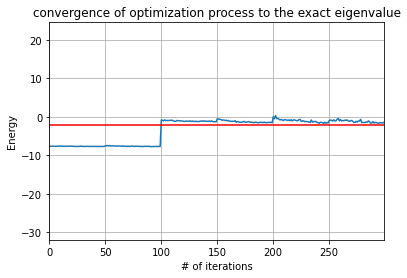

In [64]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [65]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [66]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [67]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

1it [00:00,  3.97it/s]

{'010': 360, '100': 144, '000': 144, '011': 66, '110': 18, '001': 43, '111': 229, '101': 20}
1.0


2it [00:00,  4.19it/s]

{'010': 281, '111': 185, '000': 176, '011': 111, '101': 130, '110': 62, '100': 39, '001': 40}
1.0


4it [00:00,  4.46it/s]

{'111': 129, '101': 119, '000': 290, '010': 230, '001': 86, '110': 144, '100': 24, '011': 2}
1.0
{'111': 221, '010': 357, '000': 169, '101': 18, '100': 133, '011': 56, '001': 46, '110': 24}
1.0


5it [00:01,  4.09it/s]

{'111': 210, '010': 264, '000': 236, '101': 44, '011': 72, '001': 11, '110': 135, '100': 52}
1.0


6it [00:01,  4.13it/s]

{'100': 134, '111': 204, '000': 195, '101': 12, '010': 357, '011': 55, '001': 46, '110': 21}
1.0


7it [00:01,  4.02it/s]


{'110': 21, '010': 384, '111': 229, '100': 115, '000': 161, '001': 47, '011': 50, '101': 17}
1.0


1it [00:00,  3.52it/s]

{'100': 236, '001': 75, '010': 247, '111': 180, '101': 98, '110': 83, '000': 68, '011': 37}
1.0


2it [00:00,  3.34it/s]

{'010': 182, '110': 111, '000': 148, '101': 284, '001': 9, '111': 192, '011': 70, '100': 28}
1.0


3it [00:00,  3.13it/s]

{'100': 192, '111': 220, '110': 117, '000': 186, '001': 108, '010': 115, '011': 9, '101': 77}
1.0


4it [00:01,  3.43it/s]

{'101': 73, '100': 219, '010': 247, '001': 91, '000': 65, '110': 79, '111': 222, '011': 28}
1.0


5it [00:01,  3.27it/s]

{'011': 85, '111': 161, '101': 113, '010': 207, '100': 124, '110': 125, '001': 67, '000': 142}
1.0


6it [00:01,  3.28it/s]

{'010': 218, '110': 75, '000': 91, '101': 89, '100': 230, '001': 92, '111': 199, '011': 30}
1.0


7it [00:02,  3.34it/s]


{'111': 220, '101': 65, '010': 232, '110': 89, '100': 214, '000': 72, '011': 30, '001': 102}
1.0


1it [00:00,  3.49it/s]

{'010': 302, '100': 230, '011': 207, '111': 123, '001': 45, '110': 84, '101': 32, '000': 1}
1.0


2it [00:00,  3.15it/s]

{'010': 483, '101': 183, '100': 121, '111': 137, '001': 9, '110': 51, '000': 22, '011': 18}
1.0


3it [00:01,  2.60it/s]

{'001': 144, '010': 124, '100': 233, '111': 79, '000': 173, '110': 138, '101': 79, '011': 54}
1.0
{'100': 268, '110': 80, '010': 317, '011': 183, '111': 112, '001': 32, '101': 30, '000': 2}

4it [00:01,  3.18it/s]


1.0


5it [00:01,  3.37it/s]

{'000': 115, '010': 197, '100': 146, '111': 294, '101': 71, '110': 194, '011': 5, '001': 2}
1.0


6it [00:01,  3.53it/s]

{'111': 114, '110': 77, '010': 316, '011': 193, '100': 257, '101': 39, '001': 27, '000': 1}
1.0


7it [00:02,  3.38it/s]


{'100': 288, '011': 154, '111': 119, '110': 84, '010': 307, '101': 39, '001': 31, '000': 2}
1.0


1it [00:00,  5.15it/s]

{'100': 351, '011': 150, '010': 285, '001': 89, '110': 71, '111': 71, '101': 5, '000': 2}
1.0


2it [00:00,  4.28it/s]

{'011': 149, '010': 308, '111': 106, '100': 221, '101': 129, '001': 72, '000': 19, '110': 20}
1.0


3it [00:00,  3.97it/s]

{'110': 216, '101': 57, '000': 123, '010': 168, '100': 200, '001': 217, '111': 37, '011': 6}
1.0


4it [00:00,  4.05it/s]

{'100': 346, '010': 297, '011': 168, '111': 73, '001': 67, '110': 59, '101': 12, '000': 2}
1.0


5it [00:01,  3.86it/s]

{'111': 210, '101': 56, '000': 210, '100': 151, '010': 146, '110': 202, '011': 7, '001': 42}
1.0
{'010': 286, '110': 74, '100': 320, '001': 86, '111': 95, '011': 158, '101': 5}

6it [00:01,  4.10it/s]


1.0


7it [00:01,  4.10it/s]


{'011': 156, '110': 76, '111': 75, '100': 337, '010': 287, '001': 85, '101': 7, '000': 1}
1.0


1it [00:00,  2.53it/s]

{'010': 213, '100': 389, '011': 163, '110': 102, '001': 79, '101': 9, '111': 12, '000': 57}
1.0
{'101': 151, '110': 17, '010': 286, '100': 244, '011': 93, '111': 104, '001': 110, '000': 19}
1.0


3it [00:00,  3.16it/s]

{'010': 249, '001': 206, '110': 413, '100': 99, '000': 25, '011': 10, '101': 19, '111': 3}
1.0


4it [00:01,  3.60it/s]

{'001': 78, '011': 150, '100': 416, '010': 199, '110': 99, '101': 15, '000': 55, '111': 12}
1.0


5it [00:01,  3.86it/s]

{'010': 274, '111': 142, '000': 350, '101': 67, '100': 79, '001': 21, '110': 51, '011': 40}
1.0


6it [00:01,  3.20it/s]

{'100': 418, '011': 126, '110': 92, '010': 236, '000': 56, '001': 69, '101': 9, '111': 18}
1.0


7it [00:02,  3.43it/s]


{'100': 399, '011': 150, '010': 235, '000': 54, '110': 114, '001': 54, '101': 8, '111': 10}
1.0


1it [00:00,  4.11it/s]

{'000': 167, '100': 434, '001': 65, '111': 132, '010': 145, '110': 56, '011': 11, '101': 14}
1.0


2it [00:00,  3.11it/s]

{'101': 280, '100': 186, '111': 158, '010': 89, '001': 188, '110': 24, '000': 45, '011': 54}
1.0


3it [00:00,  3.51it/s]

{'011': 23, '010': 288, '110': 342, '001': 63, '101': 102, '100': 138, '111': 33, '000': 35}
1.0
{'100': 447, '111': 139, '010': 129, '000': 162, '001': 75, '011': 17, '110': 46, '101': 9}

4it [00:01,  4.05it/s]


1.0


5it [00:01,  4.09it/s]

{'000': 560, '111': 126, '010': 120, '100': 32, '011': 53, '110': 56, '001': 20, '101': 57}
1.0


6it [00:01,  3.63it/s]

{'100': 437, '000': 184, '111': 119, '110': 42, '001': 77, '101': 14, '010': 141, '011': 10}
1.0


7it [00:01,  3.76it/s]


{'101': 14, '111': 146, '100': 426, '000': 185, '010': 132, '001': 64, '110': 49, '011': 8}
1.0


1it [00:00,  4.63it/s]

{'011': 120, '100': 373, '010': 265, '110': 118, '001': 74, '111': 14, '101': 19, '000': 41}
1.0


2it [00:00,  3.72it/s]

{'100': 251, '111': 101, '010': 303, '011': 76, '101': 140, '000': 21, '001': 99, '110': 33}
1.0


3it [00:00,  4.08it/s]

{'001': 186, '110': 360, '010': 267, '100': 120, '000': 60, '101': 28, '011': 2, '111': 1}
1.0


5it [00:01,  4.60it/s]

{'110': 125, '100': 380, '010': 287, '011': 103, '111': 12, '000': 42, '101': 17, '001': 58}
1.0
{'000': 322, '010': 346, '111': 84, '100': 88, '110': 76, '101': 79, '011': 22, '001': 7}
1.0


6it [00:01,  4.73it/s]

{'010': 289, '100': 371, '110': 114, '001': 73, '011': 100, '000': 44, '111': 11, '101': 22}
1.0


7it [00:01,  4.22it/s]


{'100': 369, '011': 109, '001': 68, '110': 122, '010': 278, '111': 9, '101': 23, '000': 46}
1.0


1it [00:00,  4.90it/s]

{'000': 104, '100': 322, '010': 417, '111': 55, '011': 75, '110': 28, '001': 23}
1.0


2it [00:00,  4.72it/s]

{'110': 56, '101': 173, '011': 174, '010': 301, '100': 173, '000': 80, '001': 51, '111': 16}
1.0


3it [00:00,  3.42it/s]

{'110': 236, '001': 83, '100': 122, '010': 373, '000': 139, '101': 41, '111': 18, '011': 12}
1.0


4it [00:01,  3.21it/s]

{'000': 108, '010': 407, '100': 331, '011': 80, '111': 67, '110': 16, '001': 14, '101': 1}
1.0


5it [00:01,  3.35it/s]

{'110': 106, '000': 346, '100': 112, '011': 46, '010': 289, '111': 108, '001': 6, '101': 11}
1.0


6it [00:01,  2.97it/s]

{'100': 345, '111': 53, '010': 416, '011': 78, '110': 18, '000': 87, '001': 27}
1.0


7it [00:02,  3.19it/s]


{'011': 95, '100': 312, '000': 104, '010': 427, '111': 52, '001': 20, '110': 13, '101': 1}
1.0


1it [00:00,  3.79it/s]

{'010': 178, '100': 244, '011': 102, '001': 289, '000': 13, '110': 156, '101': 39, '111': 3}
1.0


2it [00:00,  3.77it/s]

{'000': 193, '111': 86, '010': 240, '110': 97, '100': 184, '101': 88, '001': 114, '011': 22}
1.0


3it [00:00,  3.95it/s]

{'001': 323, '110': 420, '010': 128, '011': 53, '111': 9, '101': 27, '000': 58, '100': 6}
1.0


4it [00:00,  4.12it/s]

{'001': 268, '101': 41, '000': 16, '100': 244, '010': 170, '011': 106, '110': 176, '111': 3}
1.0


5it [00:01,  4.22it/s]

{'000': 172, '101': 254, '010': 343, '011': 50, '001': 56, '100': 79, '111': 54, '110': 16}
1.0


6it [00:01,  4.12it/s]

{'110': 160, '100': 249, '101': 32, '011': 83, '001': 287, '010': 199, '111': 4, '000': 10}
1.0


7it [00:01,  4.02it/s]


{'001': 290, '100': 241, '110': 165, '010': 163, '011': 108, '000': 12, '101': 39, '111': 6}
1.0


1it [00:00,  3.78it/s]

{'110': 292, '011': 34, '100': 139, '001': 439, '111': 28, '010': 45, '000': 38, '101': 9}
1.0


2it [00:00,  4.01it/s]

{'110': 95, '101': 87, '000': 387, '111': 184, '001': 100, '100': 84, '010': 87}
1.0


3it [00:00,  4.12it/s]

{'110': 406, '001': 231, '010': 46, '011': 238, '100': 31, '101': 26, '111': 12, '000': 34}
1.0


4it [00:00,  4.24it/s]

{'010': 47, '001': 418, '100': 173, '110': 271, '011': 43, '000': 42, '111': 24, '101': 6}
1.0


5it [00:01,  4.11it/s]

{'001': 177, '101': 258, '010': 269, '100': 154, '011': 37, '110': 54, '111': 23, '000': 52}
1.0


6it [00:01,  4.04it/s]

{'001': 399, '110': 275, '000': 41, '100': 166, '011': 48, '010': 51, '111': 34, '101': 10}
1.0


7it [00:01,  4.12it/s]


{'110': 254, '100': 168, '011': 50, '001': 431, '010': 53, '111': 29, '000': 33, '101': 6}
1.0


1it [00:00,  3.85it/s]

{'111': 51, '001': 430, '110': 308, '100': 75, '000': 78, '011': 18, '101': 21, '010': 43}
1.0


2it [00:00,  3.64it/s]

{'011': 14, '000': 475, '111': 207, '010': 38, '110': 115, '101': 25, '001': 94, '100': 56}
1.0


3it [00:00,  3.60it/s]

{'011': 185, '001': 291, '110': 293, '000': 73, '010': 61, '101': 65, '100': 49, '111': 7}
1.0


4it [00:01,  3.11it/s]

{'001': 443, '100': 68, '110': 294, '101': 25, '010': 43, '111': 48, '000': 84, '011': 19}
1.0


5it [00:01,  3.23it/s]

{'111': 62, '010': 297, '001': 131, '101': 337, '110': 49, '100': 124, '011': 9, '000': 15}
1.0


6it [00:01,  3.06it/s]

{'001': 448, '110': 294, '100': 47, '111': 46, '010': 50, '000': 106, '011': 15, '101': 18}
1.0


7it [00:02,  3.19it/s]


{'110': 303, '001': 455, '100': 66, '000': 77, '111': 49, '010': 35, '101': 26, '011': 13}
1.0


1it [00:00,  3.49it/s]

{'111': 147, '100': 185, '001': 417, '110': 129, '011': 70, '000': 48, '101': 13, '010': 15}
1.0


2it [00:00,  3.72it/s]

{'001': 216, '000': 248, '010': 55, '111': 232, '110': 80, '100': 145, '101': 32, '011': 16}
1.0


3it [00:00,  3.15it/s]

{'010': 60, '110': 271, '101': 161, '100': 21, '011': 283, '001': 186, '111': 37, '000': 5}
1.0


4it [00:01,  2.89it/s]

{'001': 405, '011': 55, '100': 193, '110': 132, '111': 147, '000': 54, '010': 17, '101': 21}
1.0


5it [00:01,  2.90it/s]

{'101': 251, '001': 162, '000': 187, '010': 133, '011': 108, '110': 27, '111': 114, '100': 42}
1.0


6it [00:01,  3.21it/s]

{'100': 187, '001': 398, '110': 120, '011': 74, '000': 41, '111': 169, '010': 15, '101': 20}
1.0


7it [00:02,  3.27it/s]


{'110': 132, '100': 178, '001': 412, '101': 21, '111': 147, '011': 69, '000': 49, '010': 16}
1.0


0it [00:00, ?it/s]

{'010': 122, '110': 273, '100': 147, '101': 37, '001': 314, '000': 98, '111': 33}
1.0


2it [00:00,  4.52it/s]

{'000': 330, '100': 92, '101': 112, '110': 223, '001': 51, '010': 61, '111': 101, '011': 54}
1.0


3it [00:00,  4.15it/s]

{'001': 132, '011': 151, '110': 365, '010': 63, '000': 180, '100': 46, '101': 42, '111': 45}
1.0


4it [00:01,  3.74it/s]

{'110': 297, '001': 284, '100': 145, '101': 39, '000': 113, '111': 33, '010': 113}
1.0


5it [00:01,  3.58it/s]

{'001': 89, '010': 361, '101': 244, '110': 50, '100': 251, '111': 19, '011': 7, '000': 3}
1.0


6it [00:01,  2.87it/s]

{'110': 311, '010': 121, '100': 120, '001': 309, '101': 46, '000': 81, '111': 36}
1.0


7it [00:02,  3.26it/s]


{'010': 104, '001': 303, '110': 283, '101': 53, '100': 135, '111': 24, '000': 122}
1.0


1it [00:00,  2.50it/s]

{'110': 564, '001': 193, '100': 145, '011': 20, '010': 45, '111': 42, '101': 15}
1.0


2it [00:00,  2.63it/s]

{'001': 102, '111': 441, '101': 136, '100': 51, '110': 147, '010': 50, '011': 9, '000': 88}
1.0


3it [00:01,  2.83it/s]

{'110': 557, '011': 172, '111': 65, '000': 32, '100': 126, '001': 50, '010': 13, '101': 9}
1.0


4it [00:01,  2.87it/s]

{'101': 9, '110': 545, '001': 213, '100': 149, '010': 42, '111': 52, '011': 14}
1.0


5it [00:01,  3.33it/s]

{'001': 126, '000': 73, '111': 19, '010': 402, '110': 210, '100': 85, '011': 34, '101': 75}
1.0


6it [00:01,  3.19it/s]

{'110': 534, '111': 41, '100': 184, '001': 197, '010': 40, '101': 15, '011': 12, '000': 1}
1.0


7it [00:02,  3.00it/s]


{'110': 530, '100': 174, '010': 45, '001': 200, '111': 51, '011': 9, '101': 13, '000': 2}
1.0


1it [00:00,  2.80it/s]

{'011': 24, '001': 124, '111': 83, '110': 432, '100': 152, '000': 101, '101': 50, '010': 58}
1.0


2it [00:00,  3.02it/s]

{'111': 493, '010': 30, '011': 71, '101': 167, '000': 184, '110': 40, '100': 9, '001': 30}
1.0


3it [00:00,  3.46it/s]

{'100': 109, '101': 51, '010': 86, '110': 431, '111': 114, '011': 145, '000': 62, '001': 26}
1.0


4it [00:01,  3.71it/s]

{'100': 147, '110': 409, '111': 94, '011': 30, '000': 84, '101': 46, '001': 147, '010': 67}
1.0


5it [00:01,  3.54it/s]

{'010': 383, '100': 175, '110': 86, '111': 53, '000': 67, '001': 174, '101': 20, '011': 66}
1.0


6it [00:01,  3.19it/s]

{'110': 412, '100': 147, '000': 90, '111': 93, '010': 68, '101': 41, '001': 136, '011': 37}
1.0


7it [00:02,  3.17it/s]


{'001': 147, '110': 407, '000': 107, '100': 117, '101': 40, '010': 54, '111': 116, '011': 36}
1.0


1it [00:00,  3.44it/s]

{'001': 113, '110': 504, '100': 140, '111': 67, '010': 97, '011': 48, '101': 49, '000': 6}
1.0


2it [00:00,  2.78it/s]

{'111': 420, '011': 121, '101': 108, '100': 83, '000': 78, '110': 149, '001': 38, '010': 27}
1.0


3it [00:01,  2.73it/s]

{'100': 109, '110': 514, '000': 95, '111': 51, '010': 27, '011': 168, '101': 57, '001': 3}
1.0


4it [00:01,  2.38it/s]

{'100': 141, '110': 513, '101': 53, '111': 64, '010': 96, '001': 102, '011': 50, '000': 5}
1.0


5it [00:02,  2.37it/s]

{'010': 521, '000': 47, '011': 102, '101': 115, '110': 96, '100': 87, '001': 39, '111': 17}
1.0


6it [00:02,  2.35it/s]

{'101': 51, '110': 487, '100': 156, '001': 114, '111': 76, '010': 101, '011': 32, '000': 7}
1.0


7it [00:02,  2.39it/s]


{'100': 163, '110': 478, '001': 90, '101': 42, '111': 75, '010': 126, '011': 44, '000': 6}
1.0


1it [00:00,  2.48it/s]

{'111': 49, '011': 18, '110': 525, '100': 134, '001': 178, '101': 47, '010': 47, '000': 26}
1.0


2it [00:00,  2.39it/s]

{'111': 466, '100': 26, '101': 138, '000': 113, '110': 138, '001': 75, '010': 56, '011': 12}
1.0


3it [00:01,  2.31it/s]

{'110': 581, '100': 129, '010': 54, '011': 102, '001': 58, '111': 77, '000': 16, '101': 7}
1.0


4it [00:01,  2.31it/s]

{'110': 518, '111': 54, '001': 183, '100': 140, '010': 40, '000': 27, '101': 45, '011': 17}
1.0


5it [00:02,  2.30it/s]

{'110': 182, '010': 375, '111': 60, '000': 139, '001': 78, '101': 154, '100': 29, '011': 7}
1.0


6it [00:02,  2.23it/s]

{'001': 170, '110': 531, '100': 130, '111': 51, '101': 41, '010': 59, '000': 26, '011': 16}
1.0


7it [00:03,  2.27it/s]


{'100': 144, '110': 535, '001': 165, '111': 51, '000': 34, '011': 18, '101': 41, '010': 36}
1.0


1it [00:00,  2.47it/s]

{'110': 300, '111': 119, '100': 262, '011': 53, '010': 91, '000': 1, '001': 117, '101': 81}
1.0


2it [00:01,  1.70it/s]

{'111': 368, '101': 301, '001': 65, '000': 63, '010': 102, '011': 37, '110': 64, '100': 24}
1.0


3it [00:01,  2.06it/s]

{'110': 431, '011': 110, '111': 104, '100': 140, '101': 87, '000': 41, '001': 69, '010': 42}
1.0


4it [00:01,  2.32it/s]

{'110': 318, '100': 245, '101': 79, '111': 120, '010': 79, '011': 44, '001': 138, '000': 1}
1.0


5it [00:02,  2.67it/s]

{'101': 93, '001': 125, '110': 60, '010': 316, '100': 115, '111': 117, '011': 53, '000': 145}
1.0


6it [00:02,  2.79it/s]

{'001': 134, '110': 298, '100': 272, '010': 69, '101': 80, '111': 119, '011': 49, '000': 3}
1.0


7it [00:02,  2.43it/s]


{'111': 111, '001': 122, '010': 69, '110': 314, '100': 266, '101': 92, '011': 50}
1.0


1it [00:00,  2.70it/s]

{'100': 325, '010': 34, '110': 379, '001': 130, '011': 47, '111': 32, '101': 57, '000': 20}
1.0


2it [00:00,  2.48it/s]

{'001': 69, '110': 106, '111': 351, '000': 78, '101': 279, '100': 64, '010': 75, '011': 2}
1.0


3it [00:01,  2.35it/s]

{'100': 217, '110': 469, '001': 40, '011': 150, '101': 21, '111': 72, '010': 50, '000': 5}
1.0


4it [00:01,  2.70it/s]

{'100': 286, '001': 139, '010': 26, '110': 422, '111': 40, '101': 50, '011': 48, '000': 13}
1.0


5it [00:01,  2.92it/s]

{'000': 226, '110': 113, '001': 87, '010': 321, '101': 119, '100': 80, '111': 74, '011': 4}
1.0


6it [00:02,  3.18it/s]

{'111': 38, '110': 400, '010': 22, '011': 36, '100': 304, '001': 138, '101': 61, '000': 25}
1.0


7it [00:02,  2.98it/s]


{'100': 295, '110': 374, '001': 124, '111': 35, '101': 63, '010': 40, '011': 67, '000': 26}
1.0


1it [00:00,  3.69it/s]

{'110': 280, '001': 120, '000': 88, '111': 308, '100': 55, '101': 114, '010': 55, '011': 4}
1.0


2it [00:00,  3.39it/s]

{'111': 590, '101': 155, '000': 162, '011': 41, '110': 5, '001': 34, '100': 12, '010': 25}
1.0


3it [00:00,  3.77it/s]

{'010': 119, '111': 392, '110': 284, '001': 79, '100': 66, '101': 46, '011': 38}
1.0


4it [00:01,  3.58it/s]

{'100': 51, '111': 279, '110': 300, '001': 147, '101': 119, '000': 72, '010': 54, '011': 2}
1.0


5it [00:01,  3.27it/s]

{'011': 141, '010': 278, '001': 122, '101': 107, '111': 136, '110': 77, '000': 112, '100': 51}
1.0


6it [00:01,  2.92it/s]

{'111': 301, '110': 286, '000': 80, '100': 57, '001': 130, '101': 110, '010': 56, '011': 4}
1.0


7it [00:02,  3.15it/s]


{'101': 110, '111': 284, '110': 279, '001': 142, '000': 71, '010': 66, '100': 70, '011': 2}
1.0


1it [00:00,  2.23it/s]

{'110': 553, '100': 122, '111': 70, '001': 174, '010': 57, '101': 16, '000': 12, '011': 20}
1.0


2it [00:00,  2.50it/s]

{'111': 489, '101': 137, '110': 149, '100': 16, '010': 45, '011': 36, '000': 100, '001': 52}
1.0


3it [00:01,  2.81it/s]

{'110': 568, '111': 97, '100': 109, '010': 58, '001': 63, '011': 113, '000': 13, '101': 3}
1.0


4it [00:01,  2.98it/s]

{'110': 558, '101': 25, '010': 73, '001': 155, '111': 77, '011': 20, '100': 108, '000': 8}
1.0


5it [00:01,  2.55it/s]

{'010': 489, '110': 160, '101': 167, '011': 37, '001': 32, '000': 71, '111': 37, '100': 31}
1.0


6it [00:02,  2.83it/s]

{'001': 161, '110': 577, '111': 60, '100': 110, '010': 68, '101': 22, '011': 18, '000': 8}
1.0


7it [00:02,  2.85it/s]


{'100': 117, '110': 567, '001': 158, '010': 65, '111': 63, '101': 34, '011': 15, '000': 5}
1.0


1it [00:00,  3.49it/s]

{'001': 182, '110': 603, '100': 83, '010': 37, '111': 28, '000': 27, '101': 16, '011': 48}
1.0


2it [00:00,  3.02it/s]

{'100': 76, '111': 421, '001': 141, '000': 61, '011': 76, '110': 201, '101': 47, '010': 1}
1.0


3it [00:00,  3.11it/s]

{'010': 66, '110': 582, '111': 19, '001': 46, '100': 113, '011': 182, '101': 16}
1.0


4it [00:01,  3.16it/s]

{'110': 588, '011': 52, '001': 199, '000': 31, '111': 29, '100': 86, '010': 28, '101': 11}
1.0


5it [00:01,  3.40it/s]

{'110': 278, '010': 369, '101': 123, '011': 38, '001': 70, '111': 53, '000': 53, '100': 40}
1.0


6it [00:01,  3.72it/s]

{'110': 585, '001': 187, '000': 24, '100': 94, '111': 22, '101': 14, '010': 47, '011': 51}
1.0


7it [00:02,  3.18it/s]


{'001': 173, '110': 614, '011': 61, '100': 78, '010': 32, '111': 34, '000': 19, '101': 13}
1.0


1it [00:00,  3.30it/s]

{'110': 567, '100': 94, '011': 67, '000': 24, '101': 13, '010': 44, '001': 188, '111': 27}
1.0


2it [00:00,  3.42it/s]

{'111': 331, '000': 34, '001': 186, '011': 55, '110': 309, '101': 17, '100': 68, '010': 24}
1.0


3it [00:01,  2.68it/s]

{'110': 559, '011': 201, '101': 20, '001': 43, '100': 110, '010': 62, '111': 29}
1.0


4it [00:01,  3.10it/s]

{'110': 611, '011': 54, '001': 183, '101': 20, '000': 21, '010': 42, '100': 68, '111': 25}
1.0


5it [00:01,  2.23it/s]

{'010': 364, '110': 282, '101': 118, '011': 46, '111': 42, '100': 49, '000': 68, '001': 55}
1.0


6it [00:02,  2.56it/s]

{'110': 601, '100': 84, '001': 178, '000': 32, '111': 20, '010': 32, '011': 57, '101': 20}
1.0


7it [00:02,  2.77it/s]


{'110': 588, '100': 94, '001': 190, '011': 48, '000': 28, '010': 41, '101': 16, '111': 19}
1.0


1it [00:00,  4.80it/s]

{'001': 173, '110': 602, '101': 15, '010': 38, '000': 29, '100': 94, '011': 50, '111': 23}
1.0


2it [00:00,  3.65it/s]

{'110': 307, '001': 196, '011': 76, '101': 20, '111': 287, '000': 27, '100': 91, '010': 20}
1.0


3it [00:00,  3.52it/s]

{'100': 200, '110': 490, '001': 134, '011': 85, '111': 30, '000': 15, '101': 4, '010': 66}
1.0


4it [00:01,  3.88it/s]

{'110': 585, '000': 26, '100': 69, '001': 208, '010': 31, '101': 10, '111': 31, '011': 64}
1.0


5it [00:01,  3.58it/s]

{'010': 366, '011': 30, '000': 79, '110': 263, '101': 130, '111': 48, '001': 68, '100': 40}
1.0


6it [00:01,  3.51it/s]

{'110': 601, '011': 48, '001': 181, '100': 98, '010': 41, '000': 25, '111': 19, '101': 11}
1.0


7it [00:01,  3.60it/s]


{'001': 182, '110': 602, '111': 27, '100': 85, '000': 21, '011': 61, '010': 31, '101': 15}
1.0


1it [00:00,  5.16it/s]

{'110': 586, '001': 195, '011': 61, '111': 20, '000': 23, '010': 43, '100': 79, '101': 17}
1.0


2it [00:00,  4.63it/s]

{'110': 293, '001': 189, '111': 324, '011': 59, '101': 19, '100': 80, '010': 27, '000': 33}
1.0


3it [00:00,  4.48it/s]

{'110': 563, '011': 193, '111': 27, '100': 107, '001': 58, '010': 61, '101': 15}
1.0


4it [00:00,  4.13it/s]

{'110': 600, '001': 183, '111': 24, '100': 74, '011': 55, '000': 29, '010': 44, '101': 15}
1.0


5it [00:01,  3.89it/s]

{'110': 413, '010': 224, '101': 76, '001': 118, '111': 78, '000': 31, '100': 80, '011': 4}
1.0


6it [00:01,  3.61it/s]

{'110': 599, '100': 96, '011': 56, '000': 19, '001': 177, '101': 10, '010': 40, '111': 27}
1.0


7it [00:01,  3.86it/s]


{'010': 37, '110': 600, '100': 86, '001': 175, '011': 61, '000': 28, '101': 11, '111': 26}
1.0


1it [00:00,  3.99it/s]

{'011': 30, '110': 571, '000': 113, '010': 39, '001': 87, '101': 116, '100': 48, '111': 20}
1.0


2it [00:00,  4.02it/s]

{'111': 207, '110': 393, '011': 52, '101': 9, '001': 166, '100': 135, '000': 18, '010': 44}
1.0
{'000': 17, '100': 209, '110': 421, '010': 153, '011': 96, '101': 57, '111': 58, '001': 13}

3it [00:00,  4.26it/s]


1.0


4it [00:01,  3.34it/s]

{'110': 574, '101': 104, '001': 108, '100': 44, '000': 101, '010': 45, '011': 34, '111': 14}
1.0


5it [00:01,  3.45it/s]

{'110': 355, '100': 142, '001': 106, '010': 260, '101': 97, '111': 46, '000': 16, '011': 2}
1.0


6it [00:01,  3.61it/s]

{'110': 584, '010': 46, '101': 120, '000': 98, '011': 21, '001': 100, '100': 41, '111': 14}
1.0


7it [00:01,  3.68it/s]


{'110': 550, '001': 103, '101': 113, '011': 36, '000': 102, '010': 45, '100': 55, '111': 20}
1.0


2it [00:00,  3.95it/s]

{'100': 78, '110': 559, '001': 163, '101': 49, '000': 44, '011': 80, '010': 19, '111': 32}
1.0
{'011': 73, '111': 221, '001': 144, '110': 389, '100': 129, '010': 26, '000': 31, '101': 11}
1.0


3it [00:00,  3.43it/s]

{'110': 547, '011': 218, '111': 86, '001': 15, '010': 45, '100': 102, '101': 10, '000': 1}
1.0


4it [00:01,  3.40it/s]

{'110': 561, '100': 93, '011': 62, '001': 156, '000': 24, '111': 54, '101': 54, '010': 20}
1.0
{'110': 251, '010': 305, '011': 12, '111': 120, '101': 192, '100': 54, '000': 71, '001': 19}

5it [00:01,  3.88it/s]


1.0


6it [00:01,  4.08it/s]

{'011': 70, '110': 553, '001': 164, '111': 59, '101': 55, '100': 86, '010': 13, '000': 24}
1.0


7it [00:01,  3.80it/s]


{'110': 538, '100': 72, '001': 164, '101': 75, '011': 84, '111': 55, '010': 19, '000': 17}
1.0


1it [00:00,  4.33it/s]

{'011': 163, '110': 431, '001': 118, '000': 165, '111': 76, '101': 14, '100': 49, '010': 8}
1.0


2it [00:00,  4.55it/s]

{'110': 386, '000': 5, '011': 106, '001': 285, '111': 106, '101': 43, '010': 67, '100': 26}
1.0


3it [00:00,  4.24it/s]

{'110': 416, '011': 286, '010': 73, '100': 109, '000': 66, '101': 51, '111': 23}
1.0


4it [00:00,  4.16it/s]

{'111': 68, '001': 137, '011': 162, '110': 431, '000': 144, '010': 10, '100': 56, '101': 16}
1.0


5it [00:01,  4.18it/s]

{'010': 283, '000': 137, '101': 111, '100': 65, '001': 36, '110': 185, '111': 142, '011': 65}
1.0
{'110': 458, '001': 121, '011': 160, '000': 149, '100': 55, '101': 16, '111': 52, '010': 13}
1.0


7it [00:01,  4.33it/s]


{'110': 476, '001': 115, '000': 141, '111': 56, '011': 152, '100': 53, '010': 10, '101': 21}
1.0


1it [00:00,  6.26it/s]

{'110': 623, '001': 132, '100': 93, '101': 59, '011': 79, '111': 20, '000': 16, '010': 2}
1.0


2it [00:00,  6.34it/s]

{'110': 362, '001': 130, '111': 292, '100': 139, '010': 57, '000': 20, '011': 19, '101': 5}
1.0
{'110': 600, '100': 144, '000': 23, '011': 128, '001': 44, '111': 63, '101': 19, '010': 3}

3it [00:00,  5.82it/s]


1.0
{'101': 72, '110': 650, '100': 67, '001': 102, '011': 76, '000': 20, '111': 34, '010': 3}

4it [00:00,  5.38it/s]


1.0


5it [00:00,  4.86it/s]

{'101': 147, '110': 353, '010': 291, '000': 77, '111': 68, '100': 41, '001': 24, '011': 23}
1.0


6it [00:01,  4.59it/s]

{'110': 605, '100': 98, '001': 120, '011': 87, '111': 25, '101': 63, '000': 21, '010': 5}
1.0


7it [00:01,  4.78it/s]


{'011': 67, '100': 109, '101': 51, '110': 609, '001': 138, '111': 22, '000': 26, '010': 2}
1.0


0it [00:00, ?it/s]

{'010': 73, '110': 394, '001': 128, '111': 10, '000': 15, '011': 185, '100': 82, '101': 137}
1.0


2it [00:00,  4.82it/s]

{'100': 135, '111': 234, '101': 134, '110': 141, '011': 131, '001': 108, '010': 104, '000': 37}
1.0


3it [00:00,  3.39it/s]

{'011': 314, '110': 368, '010': 37, '100': 113, '000': 27, '111': 88, '001': 3, '101': 74}
1.0


4it [00:01,  3.43it/s]

{'101': 154, '001': 123, '011': 183, '010': 67, '110': 399, '100': 78, '111': 14, '000': 6}
1.0


5it [00:01,  3.63it/s]

{'110': 278, '011': 98, '010': 172, '101': 282, '001': 7, '111': 88, '000': 59, '100': 40}
1.0


6it [00:01,  3.16it/s]

{'001': 140, '110': 371, '011': 169, '010': 73, '100': 91, '101': 166, '111': 8, '000': 6}
1.0


7it [00:02,  3.37it/s]


{'101': 161, '110': 398, '011': 171, '001': 139, '100': 76, '010': 60, '111': 13, '000': 6}
1.0


1it [00:00,  3.99it/s]

{'110': 348, '011': 135, '001': 177, '101': 242, '010': 52, '100': 31, '111': 24, '000': 15}
1.0


2it [00:00,  3.64it/s]

{'111': 232, '000': 51, '010': 93, '001': 150, '011': 111, '100': 157, '110': 147, '101': 83}
1.0


3it [00:00,  3.48it/s]

{'110': 274, '000': 67, '111': 188, '011': 266, '101': 78, '100': 118, '001': 17, '010': 16}
1.0


4it [00:01,  3.20it/s]

{'110': 345, '101': 244, '111': 30, '001': 154, '011': 150, '010': 61, '100': 31, '000': 9}
1.0


5it [00:01,  3.29it/s]

{'101': 341, '011': 48, '111': 105, '110': 314, '010': 121, '001': 43, '000': 49, '100': 3}
1.0


6it [00:01,  3.40it/s]

{'001': 169, '110': 347, '011': 114, '101': 248, '100': 37, '010': 65, '111': 30, '000': 14}
1.0


7it [00:02,  3.40it/s]


{'110': 341, '011': 132, '101': 229, '001': 183, '000': 11, '010': 71, '100': 33, '111': 24}
1.0


1it [00:00,  2.48it/s]

{'110': 324, '001': 255, '101': 118, '111': 57, '011': 121, '010': 56, '000': 4, '100': 89}
1.0


2it [00:00,  3.05it/s]

{'111': 187, '011': 130, '110': 147, '101': 226, '000': 165, '010': 60, '001': 103, '100': 6}
1.0


3it [00:00,  3.27it/s]

{'111': 156, '011': 378, '100': 171, '110': 218, '000': 45, '101': 11, '010': 12, '001': 33}
1.0


4it [00:01,  3.28it/s]

{'001': 301, '101': 126, '100': 91, '011': 99, '110': 291, '010': 52, '111': 55, '000': 9}
1.0


5it [00:01,  3.19it/s]

{'101': 352, '111': 91, '110': 177, '010': 174, '001': 59, '011': 76, '000': 65, '100': 30}
1.0
{'110': 298, '011': 121, '101': 119, '001': 291, '111': 50, '010': 47, '100': 85, '000': 13}
1.0


7it [00:02,  3.46it/s]


{'011': 134, '110': 331, '001': 266, '101': 104, '100': 92, '010': 48, '111': 44, '000': 5}
1.0


1it [00:00,  4.84it/s]

{'011': 199, '110': 450, '101': 169, '100': 53, '001': 85, '010': 54, '000': 6, '111': 8}
1.0
{'010': 131, '001': 84, '101': 117, '110': 190, '000': 24, '100': 106, '111': 257, '011': 115}
1.0


3it [00:00,  4.39it/s]

{'100': 161, '110': 353, '111': 102, '011': 268, '101': 70, '001': 8, '010': 31, '000': 31}
1.0


4it [00:01,  3.47it/s]

{'011': 178, '111': 16, '110': 442, '000': 8, '001': 96, '101': 167, '100': 49, '010': 68}
1.0


5it [00:01,  3.66it/s]

{'010': 228, '101': 271, '110': 275, '111': 87, '011': 91, '001': 15, '000': 41, '100': 16}
1.0


6it [00:01,  3.68it/s]

{'101': 150, '110': 433, '100': 58, '010': 52, '001': 110, '011': 201, '111': 10, '000': 10}
1.0


7it [00:02,  3.48it/s]


{'011': 176, '110': 440, '101': 163, '010': 59, '100': 59, '001': 116, '000': 5, '111': 6}
1.0


1it [00:00,  3.13it/s]

{'110': 292, '011': 118, '010': 262, '100': 113, '101': 168, '000': 25, '111': 25, '001': 21}
1.0


2it [00:00,  3.62it/s]

{'010': 316, '111': 247, '001': 45, '100': 178, '011': 60, '110': 92, '101': 83, '000': 3}
1.0


3it [00:00,  4.06it/s]

{'101': 140, '100': 154, '011': 124, '110': 276, '000': 112, '010': 183, '111': 18, '001': 17}
1.0


4it [00:01,  4.20it/s]

{'010': 248, '110': 299, '011': 128, '101': 138, '100': 117, '111': 47, '001': 26, '000': 21}
1.0


5it [00:01,  4.08it/s]

{'110': 366, '010': 185, '100': 93, '101': 159, '011': 134, '000': 57, '001': 20, '111': 10}
1.0


6it [00:01,  4.10it/s]

{'110': 301, '010': 276, '011': 131, '101': 131, '100': 115, '000': 16, '001': 25, '111': 29}
1.0


7it [00:01,  4.04it/s]


{'110': 305, '000': 23, '011': 123, '010': 246, '100': 129, '101': 152, '111': 23, '001': 23}
1.0


1it [00:00,  3.92it/s]

{'101': 126, '110': 434, '000': 17, '011': 180, '001': 163, '010': 83, '100': 21}
1.0


2it [00:00,  3.62it/s]

{'100': 70, '001': 142, '010': 140, '110': 216, '011': 136, '111': 206, '101': 55, '000': 59}
1.0


3it [00:00,  3.28it/s]

{'011': 380, '100': 170, '000': 80, '111': 82, '110': 231, '101': 58, '001': 4, '010': 19}
1.0


5it [00:01,  3.96it/s]

{'110': 414, '011': 184, '001': 191, '101': 126, '000': 19, '010': 78, '100': 11, '111': 1}
1.0
{'110': 327, '010': 178, '101': 289, '011': 101, '000': 29, '001': 4, '111': 96}
1.0


6it [00:01,  3.77it/s]

{'110': 416, '101': 108, '010': 97, '001': 179, '011': 198, '000': 18, '100': 7, '111': 1}
1.0


7it [00:01,  3.72it/s]


{'011': 189, '010': 111, '110': 426, '001': 173, '100': 14, '000': 8, '101': 102, '111': 1}
1.0


1it [00:00,  3.24it/s]

{'101': 253, '110': 334, '000': 147, '001': 111, '010': 49, '100': 46, '011': 64, '111': 20}
1.0


2it [00:00,  3.62it/s]

{'110': 95, '111': 254, '011': 133, '100': 185, '010': 14, '101': 93, '001': 200, '000': 50}
1.0


4it [00:00,  4.40it/s]

{'110': 246, '100': 124, '011': 100, '101': 208, '010': 135, '111': 68, '001': 75, '000': 68}
1.0
{'110': 335, '101': 241, '000': 154, '011': 70, '111': 21, '100': 47, '010': 58, '001': 98}
1.0


5it [00:01,  4.22it/s]

{'101': 313, '100': 97, '010': 215, '110': 170, '011': 73, '000': 107, '001': 32, '111': 17}
1.0


6it [00:01,  4.42it/s]

{'010': 63, '110': 303, '100': 48, '001': 108, '000': 176, '011': 63, '101': 249, '111': 14}
1.0


7it [00:01,  4.23it/s]


{'101': 253, '110': 341, '010': 45, '000': 163, '100': 39, '001': 96, '011': 74, '111': 13}
1.0


1it [00:00,  3.76it/s]

{'110': 390, '001': 114, '011': 223, '101': 135, '100': 42, '010': 116, '111': 4}
1.0


2it [00:00,  3.45it/s]

{'010': 175, '100': 48, '111': 231, '000': 40, '001': 59, '011': 200, '110': 161, '101': 110}
1.0


3it [00:01,  2.50it/s]

{'010': 62, '110': 252, '011': 365, '101': 67, '100': 157, '111': 65, '000': 45, '001': 11}
1.0


4it [00:01,  2.82it/s]

{'001': 110, '110': 376, '101': 135, '010': 121, '011': 242, '100': 36, '111': 3, '000': 1}
1.0


5it [00:01,  3.21it/s]

{'010': 113, '011': 121, '110': 366, '100': 24, '111': 127, '101': 254, '000': 18, '001': 1}
1.0


7it [00:02,  3.77it/s]

{'110': 394, '010': 112, '001': 111, '101': 113, '111': 11, '011': 259, '100': 23, '000': 1}
1.0
{'110': 383, '001': 94, '101': 135, '011': 261, '010': 120, '100': 29, '111': 2}
1.0


7it [00:02,  3.34it/s]
1it [00:00,  4.16it/s]

{'111': 39, '100': 202, '110': 348, '101': 100, '011': 193, '000': 52, '001': 68, '010': 22}
1.0
{'111': 128, '101': 242, '110': 242, '000': 121, '100': 84, '010': 66, '011': 133, '001': 8}
1.0


3it [00:00,  3.79it/s]

{'011': 238, '100': 251, '000': 58, '110': 311, '111': 133, '001': 13, '010': 9, '101': 11}
1.0


4it [00:01,  3.33it/s]

{'100': 207, '001': 73, '011': 192, '111': 38, '110': 332, '010': 28, '101': 103, '000': 51}
1.0


5it [00:01,  3.47it/s]

{'100': 118, '010': 231, '110': 137, '111': 133, '000': 150, '011': 83, '101': 151, '001': 21}
1.0
{'011': 196, '110': 334, '000': 50, '100': 219, '111': 46, '001': 53, '101': 109, '010': 17}
1.0


7it [00:01,  3.60it/s]


{'011': 189, '111': 49, '110': 329, '101': 101, '100': 210, '000': 51, '001': 78, '010': 17}
1.0


1it [00:00,  4.23it/s]

{'110': 444, '111': 12, '100': 51, '011': 297, '001': 53, '010': 66, '101': 98, '000': 3}
1.0


2it [00:00,  3.42it/s]

{'001': 52, '000': 18, '110': 156, '010': 154, '100': 98, '011': 188, '111': 283, '101': 75}
1.0


3it [00:00,  3.73it/s]

{'100': 131, '111': 63, '001': 78, '110': 340, '011': 276, '101': 67, '010': 38, '000': 31}
1.0
{'110': 410, '101': 95, '100': 67, '001': 57, '011': 306, '010': 70, '111': 13, '000': 6}

4it [00:01,  4.09it/s]


1.0
{'010': 212, '000': 49, '111': 131, '011': 180, '110': 268, '101': 131, '001': 34, '100': 19}
1.0

5it [00:01,  4.32it/s]

6it [00:01,  4.41it/s]

{'011': 298, '110': 405, '001': 61, '100': 50, '010': 65, '101': 118, '111': 22, '000': 5}
1.0


7it [00:01,  4.12it/s]


{'011': 276, '111': 18, '110': 445, '101': 109, '010': 62, '001': 54, '100': 58, '000': 2}
1.0


1it [00:00,  4.52it/s]

{'010': 84, '001': 145, '000': 124, '110': 129, '111': 51, '100': 131, '101': 146, '011': 214}
1.0


2it [00:00,  4.14it/s]

{'011': 149, '100': 181, '111': 129, '001': 205, '000': 64, '010': 154, '101': 106, '110': 36}
1.0


3it [00:00,  4.13it/s]

{'011': 350, '110': 245, '010': 16, '000': 184, '101': 114, '100': 38, '111': 72, '001': 5}
1.0


4it [00:01,  3.53it/s]

{'101': 164, '010': 81, '100': 130, '110': 154, '000': 116, '001': 138, '011': 196, '111': 45}
1.0


5it [00:01,  3.58it/s]

{'101': 301, '011': 154, '000': 247, '110': 151, '111': 86, '010': 84, '001': 1}
1.0


6it [00:01,  3.74it/s]

{'001': 163, '100': 143, '000': 116, '110': 131, '011': 215, '010': 70, '101': 155, '111': 31}
1.0


7it [00:01,  3.86it/s]


{'011': 229, '101': 161, '100': 152, '001': 154, '000': 115, '110': 125, '010': 58, '111': 30}
1.0


1it [00:00,  3.18it/s]

{'100': 80, '001': 78, '101': 175, '010': 183, '110': 316, '011': 174, '000': 18}
1.0


3it [00:00,  4.39it/s]

{'011': 200, '100': 130, '001': 63, '110': 161, '010': 136, '101': 179, '111': 130, '000': 25}
1.0
{'110': 291, '111': 96, '101': 133, '010': 73, '011': 238, '100': 87, '000': 99, '001': 7}
1.0


4it [00:00,  4.51it/s]

{'011': 176, '101': 200, '010': 165, '001': 70, '110': 311, '100': 87, '000': 14, '111': 1}
1.0


5it [00:01,  3.70it/s]

{'011': 97, '111': 98, '010': 216, '101': 222, '000': 70, '001': 22, '110': 278, '100': 21}
1.0


6it [00:01,  3.95it/s]

{'101': 177, '011': 183, '100': 106, '001': 80, '110': 290, '010': 173, '000': 12, '111': 3}
1.0
{'101': 168, '100': 113, '010': 172, '110': 294, '001': 94, '011': 165, '111': 4, '000': 14}
1.0


7it [00:01,  4.10it/s]
1it [00:00,  5.28it/s]

{'101': 251, '110': 242, '011': 216, '001': 149, '111': 107, '100': 20, '010': 26, '000': 13}
1.0


2it [00:00,  3.98it/s]

{'101': 117, '010': 146, '111': 205, '100': 193, '001': 48, '011': 111, '110': 100, '000': 104}
1.0


3it [00:00,  3.81it/s]

{'011': 367, '110': 199, '100': 56, '111': 248, '101': 113, '000': 20, '001': 15, '010': 6}
1.0
{'000': 10, '101': 257, '100': 14, '110': 212, '011': 250, '010': 26, '001': 154, '111': 101}

4it [00:00,  4.24it/s]


1.0


6it [00:01,  4.15it/s]

{'011': 142, '111': 152, '101': 407, '110': 181, '010': 78, '001': 40, '000': 19, '100': 5}
1.0
{'110': 225, '111': 109, '101': 266, '001': 142, '011': 217, '010': 39, '100': 14, '000': 12}
1.0


7it [00:01,  4.14it/s]


{'101': 273, '011': 221, '110': 202, '010': 23, '100': 26, '001': 163, '111': 101, '000': 15}
1.0


1it [00:00,  3.38it/s]

{'001': 105, '110': 387, '011': 178, '101': 196, '100': 81, '010': 46, '111': 24, '000': 7}
1.0


3it [00:00,  4.74it/s]

{'100': 192, '000': 34, '111': 264, '110': 125, '011': 115, '001': 79, '010': 120, '101': 95}
1.0
{'110': 375, '111': 77, '011': 271, '000': 32, '101': 115, '100': 125, '010': 23, '001': 6}
1.0


4it [00:01,  3.58it/s]

{'100': 105, '011': 174, '110': 382, '001': 97, '101': 188, '111': 17, '010': 53, '000': 8}
1.0


5it [00:01,  3.48it/s]

{'011': 147, '101': 266, '110': 244, '111': 71, '010': 183, '100': 47, '000': 61, '001': 5}
1.0


6it [00:01,  3.71it/s]

{'011': 178, '110': 374, '100': 111, '111': 27, '101': 176, '001': 92, '010': 57, '000': 9}
1.0


7it [00:01,  3.63it/s]


{'110': 394, '010': 71, '100': 106, '011': 146, '001': 106, '101': 179, '111': 17, '000': 5}
1.0


1it [00:00,  3.71it/s]

{'100': 62, '110': 351, '001': 212, '111': 112, '010': 88, '011': 107, '101': 62, '000': 30}
1.0


2it [00:00,  3.46it/s]

{'110': 228, '111': 198, '100': 117, '101': 44, '011': 189, '000': 185, '001': 53, '010': 10}
1.0


3it [00:00,  3.32it/s]

{'110': 351, '010': 87, '011': 250, '111': 187, '100': 52, '000': 58, '001': 37, '101': 2}
1.0


4it [00:01,  3.43it/s]

{'010': 98, '110': 339, '100': 67, '101': 51, '001': 225, '011': 105, '111': 84, '000': 55}
1.0


5it [00:01,  2.98it/s]

{'000': 12, '111': 182, '010': 166, '101': 226, '110': 248, '100': 122, '011': 2, '001': 66}
1.0


6it [00:01,  3.03it/s]

{'001': 223, '110': 346, '000': 41, '010': 87, '100': 76, '111': 79, '011': 97, '101': 75}
1.0


7it [00:02,  3.14it/s]


{'010': 87, '001': 205, '110': 353, '101': 66, '011': 93, '100': 93, '111': 89, '000': 38}
1.0


1it [00:00,  2.13it/s]

{'101': 158, '100': 67, '000': 27, '010': 48, '011': 177, '001': 119, '110': 401, '111': 27}
1.0


2it [00:00,  2.65it/s]

{'110': 204, '001': 117, '101': 168, '111': 209, '010': 76, '011': 155, '100': 72, '000': 23}
1.0


3it [00:01,  2.79it/s]

{'110': 328, '011': 285, '000': 39, '111': 151, '101': 47, '100': 133, '001': 4, '010': 37}
1.0


4it [00:01,  2.82it/s]

{'110': 365, '100': 60, '011': 187, '000': 25, '101': 185, '111': 23, '001': 117, '010': 62}
1.0


5it [00:01,  2.72it/s]

{'010': 186, '101': 311, '111': 158, '001': 10, '011': 74, '110': 205, '100': 21, '000': 59}
1.0


6it [00:02,  2.83it/s]

{'011': 183, '001': 115, '101': 173, '100': 80, '110': 386, '000': 16, '010': 46, '111': 25}
1.0


7it [00:02,  2.82it/s]


{'110': 361, '011': 159, '001': 138, '101': 173, '111': 33, '010': 57, '100': 74, '000': 29}
1.0


1it [00:00,  3.51it/s]

{'001': 213, '100': 92, '010': 64, '110': 346, '101': 159, '011': 121, '111': 17, '000': 12}
1.0


2it [00:00,  3.37it/s]

{'001': 136, '101': 135, '111': 174, '110': 167, '000': 76, '100': 119, '010': 106, '011': 111}
1.0


3it [00:00,  3.03it/s]

{'011': 269, '010': 78, '110': 402, '100': 48, '001': 55, '111': 122, '101': 45, '000': 5}
1.0


4it [00:01,  3.27it/s]

{'110': 336, '011': 125, '101': 169, '001': 200, '010': 77, '100': 97, '000': 15, '111': 5}
1.0


5it [00:01,  3.07it/s]

{'101': 350, '110': 280, '010': 126, '100': 73, '000': 32, '111': 105, '011': 49, '001': 9}
1.0


6it [00:02,  2.74it/s]

{'110': 352, '101': 145, '011': 114, '001': 200, '100': 113, '010': 75, '000': 14, '111': 11}
1.0


7it [00:02,  2.81it/s]


{'010': 65, '110': 362, '101': 149, '001': 207, '100': 83, '111': 9, '011': 137, '000': 12}
1.0


1it [00:00,  2.97it/s]

{'001': 204, '100': 175, '011': 129, '010': 62, '110': 271, '101': 152, '000': 28, '111': 3}
1.0


2it [00:00,  3.50it/s]

{'110': 190, '101': 197, '111': 114, '011': 82, '100': 127, '001': 144, '010': 99, '000': 71}
1.0


3it [00:00,  3.85it/s]

{'011': 243, '110': 430, '001': 86, '111': 101, '010': 84, '101': 68, '100': 10, '000': 2}
1.0
{'100': 177, '011': 117, '110': 253, '001': 205, '010': 51, '101': 182, '000': 36, '111': 3}
1.0


6it [00:01,  3.94it/s]

{'011': 43, '001': 22, '100': 138, '101': 362, '000': 51, '111': 71, '010': 107, '110': 230}
1.0
{'110': 280, '001': 205, '100': 181, '011': 132, '000': 30, '101': 144, '010': 50, '111': 2}
1.0


7it [00:01,  4.05it/s]


{'110': 294, '100': 162, '101': 181, '011': 124, '001': 184, '010': 44, '111': 6, '000': 29}
1.0


1it [00:00,  4.94it/s]

{'001': 254, '110': 368, '000': 78, '101': 143, '011': 59, '010': 81, '111': 7, '100': 34}
1.0
{'110': 205, '111': 164, '001': 184, '011': 104, '101': 84, '100': 106, '000': 114, '010': 63}
1.0


3it [00:00,  4.16it/s]

{'010': 150, '111': 121, '100': 92, '011': 264, '110': 291, '001': 32, '101': 72, '000': 2}
1.0
{'000': 80, '101': 166, '010': 105, '110': 356, '001': 218, '011': 65, '100': 26, '111': 8}
1.0


6it [00:01,  4.71it/s]

{'110': 349, '101': 388, '001': 8, '111': 56, '010': 99, '100': 91, '000': 17, '011': 16}
1.0
{'001': 227, '110': 363, '010': 104, '000': 79, '100': 27, '101': 145, '011': 70, '111': 9}
1.0


7it [00:01,  4.07it/s]


{'010': 78, '011': 66, '101': 170, '000': 69, '110': 356, '001': 243, '100': 36, '111': 6}
1.0


1it [00:00,  4.86it/s]

{'100': 124, '001': 259, '000': 48, '101': 113, '110': 315, '011': 143, '010': 22}
1.0


2it [00:00,  4.06it/s]

{'101': 160, '001': 245, '010': 97, '011': 50, '111': 189, '110': 149, '100': 91, '000': 43}
1.0


3it [00:00,  4.04it/s]

{'001': 61, '011': 321, '110': 420, '111': 65, '101': 47, '010': 81, '000': 9, '100': 20}
1.0


4it [00:01,  3.82it/s]

{'110': 306, '101': 101, '100': 127, '001': 259, '011': 153, '000': 50, '010': 25, '111': 3}
1.0


5it [00:01,  3.55it/s]

{'110': 251, '010': 98, '101': 322, '111': 66, '100': 108, '011': 99, '001': 19, '000': 61}
1.0


6it [00:01,  3.70it/s]

{'001': 240, '110': 306, '011': 139, '101': 121, '010': 22, '100': 140, '000': 53, '111': 3}
1.0


7it [00:01,  3.85it/s]


{'011': 161, '001': 246, '101': 102, '110': 297, '100': 133, '000': 54, '010': 28, '111': 3}
1.0


2it [00:00,  5.78it/s]

{'010': 100, '101': 174, '111': 59, '110': 291, '011': 199, '001': 185, '100': 8, '000': 8}
1.0
{'001': 67, '000': 122, '011': 303, '111': 113, '110': 237, '101': 112, '100': 65, '010': 5}
1.0


4it [00:00,  5.35it/s]

{'000': 91, '110': 169, '111': 136, '100': 131, '001': 93, '010': 36, '011': 270, '101': 98}
1.0
{'110': 249, '101': 162, '001': 218, '010': 128, '011': 188, '000': 8, '111': 67, '100': 4}
1.0


5it [00:01,  4.67it/s]

{'111': 209, '101': 389, '001': 24, '010': 280, '110': 86, '000': 9, '011': 23, '100': 4}
1.0


6it [00:01,  4.47it/s]

{'000': 8, '011': 199, '101': 168, '111': 51, '110': 288, '001': 185, '010': 122, '100': 3}
1.0
{'010': 109, '110': 276, '111': 50, '011': 213, '101': 160, '001': 206, '100': 6, '000': 4}
1.0

7it [00:01,  4.79it/s]



[177.41522773 208.23376698  84.34166146 210.92042799 220.63742559
 141.28999529 333.89773899 339.08508403  62.44112061 151.78202843
 355.13317131  25.71750213 234.76420014 179.87529417 157.34293669
 146.33669451 212.16523049  81.1235244  293.05415506 273.54509764
 258.38654781 236.59108164 125.04939909 250.12418706]


1it [00:00,  5.43it/s]

{'101': 160, '110': 343, '001': 233, '010': 60, '111': 9, '100': 72, '011': 126, '000': 21}
1.0
{'110': 178, '000': 75, '001': 138, '111': 194, '100': 121, '010': 102, '101': 133, '011': 83}

2it [00:00,  5.40it/s]


1.0


3it [00:00,  4.60it/s]

{'011': 279, '110': 379, '101': 47, '010': 81, '001': 65, '111': 127, '100': 34, '000': 12}
1.0


4it [00:00,  4.42it/s]

{'110': 313, '001': 197, '111': 14, '101': 182, '011': 136, '100': 96, '010': 70, '000': 16}
1.0


5it [00:01,  4.16it/s]

{'101': 337, '011': 43, '110': 277, '010': 141, '111': 99, '000': 34, '100': 86, '001': 7}
1.0


6it [00:01,  3.73it/s]

{'110': 352, '011': 127, '101': 150, '001': 225, '100': 93, '000': 11, '010': 57, '111': 9}
1.0


7it [00:01,  3.88it/s]

{'110': 379, '101': 156, '001': 190, '010': 52, '100': 85, '011': 142, '000': 12, '111': 8}
1.0
CPU times: total: 57.5 s
Wall time: 1min 44s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.8872750359120216

Approximation Error
0.21667957908567867


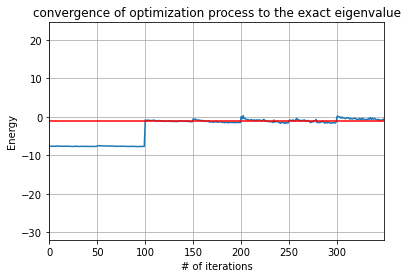

In [68]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [69]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

1it [00:00,  4.12it/s]

{'101': 78, '000': 339, '110': 34, '011': 202, '010': 111, '111': 60, '001': 100, '100': 100}
1.0


2it [00:00,  4.43it/s]

{'000': 28, '001': 354, '010': 349, '101': 184, '110': 69, '100': 13, '111': 20, '011': 7}
1.0


4it [00:00,  5.19it/s]

{'010': 68, '000': 361, '001': 34, '101': 62, '110': 78, '111': 97, '011': 278, '100': 46}
1.0
{'000': 313, '011': 217, '110': 27, '111': 70, '100': 101, '101': 92, '010': 115, '001': 89}
1.0


5it [00:01,  4.63it/s]

{'111': 268, '100': 351, '101': 172, '011': 35, '110': 119, '000': 20, '001': 12, '010': 47}
1.0


6it [00:01,  4.52it/s]

{'101': 122, '011': 216, '000': 300, '001': 93, '010': 104, '110': 30, '100': 98, '111': 61}
1.0


7it [00:01,  4.60it/s]


{'010': 110, '000': 290, '101': 99, '001': 88, '011': 227, '100': 115, '110': 22, '111': 73}
1.0


1it [00:00,  3.10it/s]

{'001': 91, '110': 130, '000': 194, '100': 195, '101': 20, '011': 120, '010': 171, '111': 103}
1.0


2it [00:00,  3.25it/s]

{'101': 139, '010': 257, '001': 293, '100': 111, '111': 192, '110': 12, '000': 12, '011': 8}
1.0


3it [00:00,  3.47it/s]

{'110': 319, '111': 48, '011': 172, '000': 318, '101': 57, '010': 53, '001': 44, '100': 13}
1.0


4it [00:01,  4.00it/s]

{'110': 117, '100': 213, '000': 202, '010': 173, '001': 86, '111': 86, '011': 121, '101': 26}
1.0


5it [00:01,  4.04it/s]

{'111': 209, '100': 407, '010': 253, '000': 8, '011': 8, '110': 30, '001': 53, '101': 56}
1.0
{'100': 225, '111': 93, '110': 133, '000': 202, '010': 142, '011': 116, '101': 28, '001': 85}
1.0


7it [00:01,  4.12it/s]


{'010': 173, '000': 225, '011': 114, '100': 213, '001': 87, '101': 30, '110': 105, '111': 77}
1.0


1it [00:00,  2.58it/s]

{'100': 416, '010': 115, '110': 119, '011': 91, '000': 102, '001': 74, '111': 12, '101': 95}
1.0


2it [00:00,  3.19it/s]

{'010': 199, '001': 152, '100': 263, '101': 283, '110': 92, '111': 21, '000': 5, '011': 9}
1.0


3it [00:00,  3.46it/s]

{'011': 168, '110': 464, '000': 201, '010': 10, '100': 69, '101': 65, '111': 37, '001': 10}
1.0


4it [00:01,  3.63it/s]

{'011': 90, '100': 423, '101': 84, '010': 124, '110': 102, '000': 108, '001': 77, '111': 16}
1.0


5it [00:01,  3.10it/s]

{'100': 442, '010': 194, '101': 112, '000': 74, '001': 88, '011': 68, '111': 38, '110': 8}
1.0


7it [00:02,  3.49it/s]


{'100': 420, '110': 117, '000': 101, '011': 86, '001': 79, '010': 127, '101': 78, '111': 16}
1.0
{'101': 109, '001': 68, '100': 424, '110': 127, '011': 87, '000': 97, '111': 10, '010': 102}
1.0


1it [00:00,  5.24it/s]

{'001': 112, '100': 477, '101': 188, '111': 11, '011': 49, '010': 37, '110': 81, '000': 69}
1.0


2it [00:00,  4.42it/s]

{'001': 120, '101': 436, '111': 74, '100': 256, '110': 24, '010': 101, '000': 12, '011': 1}
1.0


3it [00:00,  3.93it/s]

{'011': 84, '101': 57, '110': 432, '111': 151, '100': 138, '010': 80, '001': 45, '000': 37}
1.0


4it [00:00,  3.91it/s]

{'100': 481, '000': 65, '001': 107, '101': 198, '110': 68, '010': 51, '011': 40, '111': 14}
1.0


5it [00:01,  3.20it/s]

{'100': 437, '000': 119, '001': 141, '101': 150, '110': 95, '011': 42, '010': 33, '111': 7}
1.0


6it [00:01,  3.49it/s]

{'100': 475, '001': 102, '101': 203, '111': 17, '110': 69, '011': 45, '010': 54, '000': 59}
1.0
{'101': 202, '100': 486, '110': 81, '010': 39, '011': 43, '000': 56, '001': 103, '111': 14}
1.0


7it [00:01,  3.80it/s]
2it [00:00,  4.88it/s]

{'100': 277, '101': 458, '110': 43, '011': 33, '001': 81, '000': 103, '010': 25, '111': 4}
1.0
{'101': 498, '100': 220, '000': 72, '001': 124, '111': 31, '010': 45, '110': 18, '011': 16}
1.0


3it [00:00,  4.48it/s]

{'110': 228, '011': 91, '111': 284, '101': 196, '100': 84, '000': 42, '010': 97, '001': 2}
1.0


4it [00:00,  4.23it/s]

{'100': 306, '101': 437, '010': 28, '110': 30, '000': 133, '011': 31, '111': 13, '001': 46}
1.0


5it [00:01,  4.36it/s]

{'101': 219, '000': 47, '100': 355, '001': 304, '110': 12, '010': 39, '111': 32, '011': 16}
1.0


6it [00:01,  4.31it/s]

{'101': 467, '100': 269, '000': 107, '001': 68, '011': 37, '010': 31, '111': 10, '110': 35}
1.0


7it [00:01,  3.53it/s]


{'101': 452, '011': 35, '001': 61, '100': 309, '000': 111, '110': 30, '111': 9, '010': 17}
1.0


1it [00:00,  4.43it/s]

{'100': 248, '010': 47, '101': 488, '111': 71, '001': 59, '011': 64, '110': 16, '000': 31}
1.0


2it [00:00,  4.23it/s]

{'101': 419, '100': 287, '010': 70, '001': 99, '111': 57, '011': 48, '110': 34, '000': 10}
1.0


3it [00:00,  4.24it/s]

{'101': 423, '110': 195, '010': 60, '111': 115, '011': 103, '100': 78, '000': 49, '001': 1}
1.0


4it [00:00,  4.15it/s]

{'101': 458, '100': 264, '110': 5, '010': 58, '011': 60, '111': 76, '000': 53, '001': 50}
1.0


5it [00:01,  4.28it/s]

{'001': 374, '110': 48, '111': 138, '010': 23, '101': 138, '100': 254, '000': 41, '011': 8}
1.0
{'100': 238, '001': 56, '111': 74, '000': 48, '101': 483, '110': 17, '010': 51, '011': 57}
1.0


7it [00:01,  4.26it/s]


{'111': 93, '101': 440, '100': 253, '010': 48, '011': 63, '001': 70, '000': 50, '110': 7}
1.0


1it [00:00,  3.83it/s]

{'111': 26, '101': 402, '010': 197, '110': 21, '001': 104, '100': 163, '011': 66, '000': 45}
1.0


2it [00:00,  3.88it/s]

{'001': 126, '101': 398, '010': 198, '100': 164, '000': 46, '011': 33, '111': 4, '110': 55}
1.0


3it [00:00,  3.96it/s]

{'100': 67, '110': 114, '111': 325, '011': 177, '010': 160, '000': 75, '101': 100, '001': 6}
1.0


4it [00:01,  3.99it/s]

{'101': 393, '000': 48, '010': 177, '011': 67, '111': 38, '001': 116, '110': 40, '100': 145}
1.0
{'111': 14, '001': 304, '011': 108, '101': 184, '100': 175, '010': 169, '000': 22, '110': 48}
1.0


6it [00:01,  4.23it/s]

{'010': 185, '100': 147, '111': 36, '101': 401, '000': 39, '001': 94, '110': 43, '011': 79}
1.0


7it [00:01,  4.15it/s]


{'101': 409, '001': 107, '010': 194, '111': 52, '100': 120, '110': 33, '000': 53, '011': 56}
1.0


1it [00:00,  5.20it/s]

{'100': 208, '010': 214, '110': 80, '111': 89, '011': 146, '101': 219, '000': 14, '001': 54}
1.0


2it [00:00,  3.75it/s]

{'101': 338, '011': 141, '010': 238, '001': 45, '111': 108, '000': 22, '100': 78, '110': 54}
1.0


3it [00:00,  3.99it/s]

{'111': 275, '011': 162, '010': 164, '101': 55, '110': 195, '100': 92, '001': 31, '000': 50}
1.0


4it [00:00,  4.11it/s]

{'010': 218, '111': 84, '110': 72, '100': 213, '001': 59, '011': 128, '101': 240, '000': 10}
1.0


5it [00:01,  4.22it/s]

{'111': 212, '110': 103, '000': 61, '001': 81, '101': 174, '010': 203, '011': 47, '100': 143}
1.0


6it [00:01,  4.04it/s]

{'010': 238, '100': 186, '011': 146, '101': 224, '001': 53, '111': 85, '110': 86, '000': 6}
1.0


7it [00:01,  3.57it/s]


{'100': 211, '011': 141, '010': 235, '101': 215, '111': 94, '001': 52, '110': 70, '000': 6}
1.0


1it [00:00,  5.13it/s]

{'011': 202, '001': 282, '010': 132, '111': 50, '101': 151, '100': 167, '110': 27, '000': 13}
1.0


2it [00:00,  4.54it/s]

{'010': 286, '001': 190, '101': 192, '100': 92, '110': 50, '000': 135, '011': 68, '111': 11}
1.0


3it [00:00,  3.73it/s]

{'011': 460, '010': 92, '000': 69, '111': 155, '101': 31, '110': 158, '100': 33, '001': 26}
1.0


4it [00:01,  3.26it/s]

{'001': 304, '101': 144, '010': 134, '100': 152, '111': 34, '011': 201, '000': 22, '110': 33}
1.0


5it [00:01,  3.20it/s]

{'001': 280, '100': 135, '011': 195, '010': 143, '101': 137, '111': 62, '110': 36, '000': 36}
1.0


6it [00:01,  2.97it/s]

{'001': 302, '111': 47, '010': 155, '100': 155, '101': 128, '011': 199, '110': 23, '000': 15}
1.0


7it [00:02,  3.31it/s]


{'010': 153, '011': 196, '001': 276, '101': 138, '111': 56, '100': 160, '110': 25, '000': 20}
1.0


1it [00:00,  2.44it/s]

{'001': 205, '011': 236, '010': 96, '110': 107, '100': 122, '111': 122, '000': 93, '101': 43}
1.0


2it [00:00,  3.13it/s]

{'110': 211, '001': 181, '100': 52, '010': 270, '111': 43, '011': 60, '101': 102, '000': 105}
1.0


3it [00:00,  3.37it/s]

{'010': 154, '110': 220, '011': 428, '101': 30, '000': 55, '111': 118, '100': 18, '001': 1}
1.0


4it [00:01,  3.77it/s]

{'011': 231, '110': 127, '100': 106, '000': 86, '111': 124, '101': 40, '010': 101, '001': 209}
1.0


5it [00:01,  3.49it/s]

{'011': 229, '101': 140, '010': 191, '111': 154, '001': 96, '000': 70, '100': 142, '110': 2}
1.0


6it [00:01,  3.71it/s]

{'001': 228, '000': 91, '011': 253, '111': 118, '101': 38, '100': 120, '010': 83, '110': 93}
1.0


7it [00:01,  3.52it/s]


{'100': 121, '111': 124, '011': 211, '001': 194, '010': 112, '000': 112, '101': 40, '110': 110}
1.0


1it [00:00,  2.75it/s]

{'010': 188, '100': 243, '011': 176, '001': 284, '111': 72, '101': 38, '000': 21, '110': 2}
1.0


2it [00:00,  3.47it/s]

{'010': 358, '001': 141, '101': 138, '100': 119, '111': 33, '000': 152, '110': 49, '011': 34}
1.0


3it [00:00,  3.77it/s]

{'111': 96, '011': 453, '110': 155, '010': 56, '100': 110, '000': 120, '001': 19, '101': 15}
1.0
{'011': 183, '100': 244, '001': 311, '111': 63, '101': 45, '010': 161, '000': 17}


5it [00:01,  4.62it/s]

1.0
{'000': 173, '010': 96, '101': 164, '011': 213, '100': 107, '110': 97, '001': 157, '111': 17}
1.0


6it [00:01,  4.40it/s]

{'010': 209, '100': 252, '001': 268, '111': 65, '011': 169, '101': 39, '110': 3, '000': 19}
1.0


7it [00:01,  3.94it/s]


{'100': 251, '111': 70, '001': 283, '010': 172, '011': 197, '101': 40, '000': 10, '110': 1}
1.0


2it [00:00,  4.87it/s]

{'100': 152, '010': 178, '001': 327, '110': 84, '101': 157, '000': 40, '011': 81, '111': 5}
1.0
{'101': 250, '010': 261, '111': 56, '000': 119, '100': 42, '001': 273, '110': 14, '011': 9}
1.0


3it [00:00,  4.50it/s]

{'100': 10, '000': 166, '011': 411, '110': 202, '111': 101, '001': 51, '101': 55, '010': 28}
1.0


4it [00:00,  4.54it/s]

{'010': 172, '001': 360, '110': 64, '101': 138, '111': 12, '000': 48, '100': 156, '011': 74}
1.0


6it [00:01,  4.64it/s]

{'100': 88, '110': 75, '111': 57, '101': 180, '001': 327, '010': 142, '011': 40, '000': 115}
1.0
{'101': 169, '001': 350, '100': 142, '010': 163, '011': 103, '000': 34, '110': 56, '111': 7}
1.0


7it [00:01,  4.47it/s]


{'010': 169, '001': 367, '101': 142, '110': 64, '100': 151, '011': 95, '000': 32, '111': 4}
1.0


1it [00:00,  3.02it/s]

{'100': 257, '011': 320, '010': 122, '001': 102, '101': 135, '111': 78, '110': 6, '000': 4}
1.0


2it [00:00,  3.75it/s]

{'010': 267, '100': 202, '101': 197, '000': 69, '011': 198, '110': 12, '111': 51, '001': 28}
1.0


3it [00:00,  3.88it/s]

{'011': 352, '010': 97, '100': 109, '001': 89, '110': 147, '000': 39, '111': 152, '101': 39}
1.0


4it [00:01,  3.90it/s]

{'010': 140, '011': 330, '101': 141, '001': 111, '100': 236, '111': 56, '000': 3, '110': 7}
1.0


5it [00:01,  3.73it/s]

{'000': 131, '111': 328, '101': 53, '010': 51, '100': 116, '110': 85, '011': 75, '001': 185}
1.0


6it [00:01,  3.44it/s]

{'001': 89, '100': 249, '010': 129, '011': 360, '110': 5, '101': 126, '111': 55, '000': 11}
1.0


7it [00:02,  3.41it/s]


{'010': 138, '100': 259, '011': 337, '111': 65, '101': 116, '001': 94, '110': 7, '000': 8}
1.0


1it [00:00,  3.51it/s]

{'001': 244, '100': 81, '010': 146, '101': 177, '011': 233, '110': 56, '000': 47, '111': 40}
1.0


3it [00:00,  4.07it/s]

{'010': 358, '100': 214, '001': 254, '111': 42, '000': 62, '110': 33, '101': 57, '011': 4}
1.0
{'000': 143, '111': 182, '110': 145, '011': 455, '010': 35, '001': 21, '101': 27, '100': 16}
1.0


4it [00:01,  4.14it/s]

{'100': 105, '001': 252, '010': 144, '011': 232, '101': 178, '111': 40, '000': 36, '110': 37}
1.0


5it [00:01,  3.42it/s]

{'011': 191, '001': 298, '010': 150, '111': 76, '100': 117, '101': 137, '000': 25, '110': 30}
1.0


6it [00:01,  3.58it/s]

{'011': 236, '111': 39, '010': 145, '000': 45, '101': 188, '001': 249, '110': 29, '100': 93}
1.0


7it [00:01,  3.68it/s]


{'101': 192, '001': 252, '000': 51, '111': 34, '010': 111, '100': 112, '011': 225, '110': 47}
1.0


1it [00:00,  3.67it/s]

{'111': 67, '010': 242, '011': 191, '001': 234, '101': 87, '100': 139, '000': 7, '110': 57}
1.0


2it [00:00,  3.70it/s]

{'000': 150, '101': 165, '010': 315, '001': 97, '011': 117, '111': 8, '100': 75, '110': 97}
1.0


4it [00:00,  4.72it/s]

{'010': 184, '011': 233, '000': 107, '111': 127, '110': 140, '001': 185, '100': 41, '101': 7}
1.0
{'010': 260, '011': 183, '101': 97, '001': 225, '100': 134, '111': 68, '000': 4, '110': 53}
1.0


5it [00:01,  5.04it/s]

{'110': 51, '010': 283, '011': 146, '001': 307, '111': 75, '000': 75, '100': 76, '101': 11}
1.0
{'001': 236, '010': 255, '000': 6, '101': 73, '100': 143, '011': 177, '111': 73, '110': 61}
1.0


7it [00:01,  4.72it/s]


{'010': 242, '001': 227, '100': 144, '101': 89, '011': 164, '000': 11, '110': 70, '111': 77}
1.0


1it [00:00,  5.63it/s]

{'100': 121, '111': 45, '011': 261, '101': 194, '001': 275, '000': 7, '010': 75, '110': 46}
1.0
{'101': 223, '000': 185, '010': 264, '011': 71, '001': 125, '110': 87, '100': 65, '111': 4}
1.0


3it [00:00,  5.08it/s]

{'001': 103, '011': 452, '000': 22, '100': 119, '111': 217, '101': 41, '010': 46, '110': 24}
1.0
{'101': 217, '001': 286, '100': 88, '110': 54, '010': 73, '111': 39, '011': 260, '000': 7}
1.0


6it [00:01,  5.10it/s]

{'011': 155, '001': 357, '010': 69, '111': 155, '101': 145, '100': 71, '110': 33, '000': 39}
1.0
{'010': 70, '101': 191, '111': 47, '100': 96, '001': 319, '011': 251, '110': 46, '000': 4}
1.0


7it [00:01,  5.07it/s]


{'001': 298, '100': 93, '111': 32, '011': 257, '101': 221, '010': 74, '110': 43, '000': 6}
1.0


1it [00:00,  5.68it/s]

{'101': 231, '110': 31, '010': 301, '111': 33, '000': 74, '011': 73, '001': 221, '100': 60}
1.0


2it [00:00,  4.80it/s]

{'100': 114, '101': 165, '000': 242, '010': 274, '111': 12, '001': 67, '011': 96, '110': 54}
1.0


3it [00:00,  4.49it/s]

{'111': 213, '110': 90, '010': 329, '000': 58, '011': 223, '101': 64, '001': 44, '100': 3}
1.0


4it [00:00,  3.88it/s]

{'011': 68, '001': 222, '101': 212, '010': 309, '100': 56, '000': 86, '111': 28, '110': 43}
1.0


5it [00:01,  3.70it/s]

{'110': 62, '001': 198, '011': 64, '111': 50, '000': 99, '010': 298, '101': 218, '100': 35}
1.0


6it [00:01,  3.18it/s]

{'001': 209, '101': 217, '000': 92, '010': 308, '110': 52, '100': 59, '011': 51, '111': 36}
1.0


7it [00:02,  3.44it/s]


{'100': 74, '010': 281, '000': 77, '101': 237, '001': 245, '011': 53, '110': 33, '111': 24}
1.0


1it [00:00,  2.17it/s]

{'001': 349, '100': 98, '101': 242, '011': 118, '010': 177, '000': 16, '110': 21, '111': 3}
1.0


2it [00:00,  2.46it/s]

{'101': 209, '001': 122, '000': 230, '100': 145, '010': 154, '011': 146, '110': 8, '111': 10}
1.0


3it [00:01,  2.79it/s]

{'011': 327, '111': 134, '010': 153, '000': 58, '001': 134, '100': 32, '110': 76, '101': 110}
1.0


4it [00:01,  3.15it/s]

{'101': 239, '001': 345, '010': 188, '011': 109, '110': 21, '100': 107, '000': 13, '111': 2}
1.0


5it [00:01,  3.00it/s]

{'001': 435, '000': 55, '110': 144, '011': 51, '111': 40, '101': 174, '100': 38, '010': 87}
1.0


6it [00:02,  3.15it/s]

{'010': 208, '101': 257, '001': 345, '011': 91, '110': 22, '100': 85, '000': 13, '111': 3}
1.0


7it [00:02,  3.07it/s]


{'101': 267, '010': 196, '011': 123, '001': 322, '000': 18, '100': 81, '110': 15, '111': 2}
1.0


1it [00:00,  2.58it/s]

{'001': 224, '101': 458, '100': 112, '111': 59, '011': 29, '000': 44, '010': 89, '110': 9}
1.0


2it [00:00,  3.08it/s]

{'101': 415, '010': 52, '000': 225, '100': 129, '011': 74, '001': 64, '110': 13, '111': 52}
1.0


4it [00:01,  4.22it/s]

{'101': 193, '010': 160, '111': 310, '011': 144, '001': 113, '100': 57, '110': 37, '000': 10}
1.0
{'010': 108, '101': 429, '001': 257, '100': 100, '111': 65, '000': 47, '110': 7, '011': 11}
1.0


6it [00:01,  4.62it/s]

{'001': 239, '110': 95, '101': 449, '000': 105, '011': 23, '111': 50, '010': 22, '100': 41}
1.0
{'100': 108, '101': 416, '001': 262, '111': 61, '010': 93, '011': 28, '110': 9, '000': 47}
1.0


7it [00:01,  4.01it/s]


{'010': 80, '100': 100, '001': 266, '101': 450, '111': 55, '011': 22, '000': 49, '110': 2}
1.0


1it [00:00,  4.52it/s]

{'011': 154, '001': 267, '010': 199, '101': 101, '110': 55, '000': 52, '100': 191, '111': 5}
1.0


2it [00:00,  3.24it/s]

{'010': 233, '000': 279, '011': 144, '101': 142, '100': 125, '110': 44, '001': 37, '111': 20}
1.0


4it [00:01,  3.33it/s]

{'110': 239, '111': 63, '010': 234, '011': 318, '001': 91, '101': 46, '100': 21, '000': 12}
1.0
{'100': 173, '001': 222, '011': 166, '110': 64, '101': 132, '010': 205, '000': 52, '111': 10}
1.0


5it [00:01,  2.91it/s]

{'010': 259, '011': 71, '000': 214, '101': 254, '111': 99, '001': 103, '100': 14, '110': 10}
1.0


6it [00:01,  3.22it/s]

{'110': 71, '001': 237, '100': 170, '010': 200, '000': 65, '011': 162, '101': 113, '111': 6}
1.0


7it [00:02,  3.03it/s]


{'001': 224, '010': 188, '100': 170, '011': 150, '101': 137, '000': 76, '110': 73, '111': 6}
1.0


1it [00:00,  2.73it/s]

{'000': 249, '001': 257, '101': 238, '111': 17, '100': 50, '010': 147, '011': 17, '110': 49}
1.0


2it [00:00,  2.73it/s]

{'101': 148, '000': 365, '100': 169, '001': 126, '010': 120, '011': 30, '111': 37, '110': 29}
1.0


3it [00:01,  2.85it/s]

{'100': 10, '011': 185, '001': 87, '111': 175, '010': 306, '101': 110, '110': 94, '000': 57}
1.0


4it [00:01,  2.57it/s]

{'000': 241, '101': 238, '001': 261, '110': 53, '010': 140, '111': 15, '100': 54, '011': 22}
1.0


5it [00:01,  2.71it/s]

{'001': 272, '101': 246, '010': 158, '100': 80, '000': 222, '111': 18, '011': 14, '110': 14}
1.0


6it [00:02,  3.07it/s]

{'001': 264, '000': 240, '101': 253, '110': 46, '100': 51, '111': 17, '010': 133, '011': 20}
1.0
{'100': 53, '001': 258, '000': 241, '101': 249, '010': 137, '110': 40, '111': 19, '011': 27}
1.0


7it [00:02,  3.04it/s]
1it [00:00,  3.27it/s]

{'100': 92, '010': 267, '101': 73, '001': 392, '110': 70, '011': 73, '000': 45, '111': 12}
1.0


2it [00:00,  3.42it/s]

{'010': 326, '000': 336, '001': 90, '011': 63, '101': 142, '111': 51, '110': 12, '100': 4}
1.0


3it [00:00,  3.74it/s]

{'000': 55, '010': 238, '011': 392, '110': 172, '111': 56, '101': 13, '001': 84, '100': 14}
1.0


4it [00:01,  3.67it/s]

{'001': 398, '010': 297, '011': 96, '110': 48, '100': 80, '000': 43, '111': 5, '101': 57}
1.0


5it [00:01,  3.88it/s]

{'111': 65, '110': 122, '101': 286, '001': 181, '000': 96, '010': 203, '011': 33, '100': 38}
1.0


6it [00:01,  4.05it/s]

{'001': 368, '100': 105, '010': 291, '011': 81, '101': 59, '110': 72, '000': 41, '111': 7}
1.0
{'010': 280, '001': 371, '100': 114, '101': 59, '011': 80, '110': 65, '000': 46, '111': 9}

7it [00:01,  4.01it/s]



1.0


1it [00:00,  4.03it/s]

{'001': 382, '100': 110, '011': 82, '101': 75, '000': 48, '010': 248, '111': 15, '110': 64}
1.0


2it [00:00,  4.39it/s]

{'101': 86, '000': 257, '001': 166, '010': 191, '100': 66, '011': 188, '111': 40, '110': 30}
1.0


3it [00:00,  3.59it/s]

{'011': 399, '111': 54, '110': 154, '001': 76, '010': 266, '000': 50, '100': 16, '101': 9}
1.0


4it [00:01,  3.11it/s]

{'001': 389, '101': 53, '010': 291, '100': 89, '110': 63, '011': 84, '000': 43, '111': 12}
1.0


5it [00:01,  3.37it/s]

{'010': 201, '111': 61, '100': 34, '101': 279, '000': 95, '011': 33, '110': 144, '001': 177}
1.0


6it [00:01,  3.13it/s]

{'010': 270, '001': 391, '000': 37, '100': 98, '110': 72, '101': 59, '011': 88, '111': 9}
1.0
{'010': 284, '100': 110, '001': 364, '011': 86, '000': 43, '110': 60, '101': 71, '111': 6}
1.0


7it [00:01,  3.50it/s]
1it [00:00,  2.95it/s]

{'000': 53, '001': 397, '100': 104, '011': 84, '101': 56, '010': 258, '110': 64, '111': 8}
1.0


2it [00:00,  3.16it/s]

{'000': 262, '011': 164, '100': 66, '001': 201, '010': 172, '101': 91, '111': 46, '110': 22}
1.0


3it [00:00,  3.59it/s]

{'000': 110, '011': 243, '110': 87, '001': 246, '010': 176, '101': 35, '100': 82, '111': 45}
1.0


4it [00:01,  3.63it/s]

{'100': 99, '001': 402, '010': 269, '011': 75, '000': 38, '110': 65, '101': 66, '111': 10}
1.0


5it [00:01,  3.93it/s]

{'010': 198, '111': 62, '001': 164, '110': 137, '101': 275, '000': 127, '100': 30, '011': 31}
1.0


6it [00:01,  3.59it/s]

{'100': 97, '000': 38, '001': 376, '011': 90, '010': 284, '110': 76, '101': 55, '111': 8}
1.0


7it [00:01,  3.56it/s]


{'101': 68, '011': 88, '001': 404, '010': 261, '110': 65, '100': 87, '000': 40, '111': 11}
1.0


1it [00:00,  3.66it/s]

{'001': 375, '010': 268, '100': 99, '011': 73, '101': 70, '000': 42, '110': 88, '111': 9}
1.0


2it [00:00,  3.11it/s]

{'100': 79, '011': 175, '001': 184, '000': 271, '010': 143, '101': 100, '110': 26, '111': 46}
1.0


3it [00:00,  2.94it/s]

{'010': 235, '011': 448, '001': 79, '100': 13, '110': 128, '111': 55, '000': 50, '101': 16}
1.0


4it [00:01,  3.27it/s]

{'001': 387, '011': 81, '010': 269, '100': 110, '101': 64, '111': 12, '110': 56, '000': 45}
1.0


5it [00:01,  3.75it/s]

{'111': 34, '001': 341, '011': 62, '100': 87, '101': 118, '110': 253, '000': 50, '010': 79}
1.0


6it [00:01,  3.41it/s]

{'001': 389, '110': 71, '010': 285, '100': 80, '011': 92, '101': 57, '000': 43, '111': 7}
1.0


7it [00:02,  3.39it/s]


{'101': 74, '010': 273, '100': 94, '001': 378, '011': 95, '000': 40, '110': 63, '111': 7}
1.0


1it [00:00,  4.18it/s]

{'101': 35, '100': 57, '011': 147, '001': 251, '110': 184, '000': 90, '010': 239, '111': 21}
1.0


2it [00:00,  4.30it/s]

{'111': 45, '011': 174, '001': 186, '101': 87, '000': 156, '110': 156, '010': 210, '100': 10}
1.0


3it [00:00,  3.92it/s]

{'010': 317, '011': 368, '000': 49, '100': 63, '110': 157, '111': 47, '001': 4, '101': 19}
1.0


4it [00:01,  3.66it/s]

{'010': 271, '100': 50, '110': 192, '001': 216, '011': 143, '000': 101, '101': 38, '111': 13}
1.0


5it [00:01,  3.75it/s]

{'010': 385, '101': 195, '100': 134, '001': 86, '011': 90, '111': 53, '110': 40, '000': 41}
1.0


6it [00:01,  3.99it/s]

{'010': 251, '100': 45, '011': 136, '101': 50, '110': 200, '000': 106, '001': 227, '111': 9}
1.0


7it [00:01,  3.84it/s]


{'110': 168, '111': 8, '001': 243, '101': 54, '010': 247, '011': 141, '000': 103, '100': 60}
1.0


1it [00:00,  4.63it/s]

{'000': 86, '001': 460, '010': 139, '011': 82, '101': 33, '100': 126, '111': 27, '110': 71}
1.0


2it [00:00,  4.39it/s]

{'010': 63, '001': 168, '000': 382, '011': 181, '110': 22, '111': 76, '100': 89, '101': 43}
1.0


3it [00:00,  4.27it/s]

{'110': 154, '100': 28, '001': 156, '010': 246, '111': 59, '011': 380, '000': 1}
1.0
{'110': 72, '001': 475, '010': 152, '000': 84, '101': 28, '111': 26, '011': 82, '100': 105}

5it [00:01,  5.01it/s]


1.0
{'101': 211, '111': 101, '001': 240, '000': 205, '110': 106, '100': 20, '010': 129, '011': 12}
1.0


7it [00:01,  4.92it/s]


{'011': 78, '100': 92, '000': 80, '001': 491, '010': 140, '110': 78, '101': 31, '111': 34}
1.0
{'011': 76, '100': 119, '111': 28, '001': 467, '000': 92, '010': 160, '101': 16, '110': 66}
1.0


1it [00:00,  5.33it/s]

{'010': 352, '011': 67, '001': 358, '100': 33, '101': 85, '110': 128, '111': 1}
1.0
{'100': 83, '011': 229, '000': 177, '001': 201, '110': 51, '010': 186, '111': 53, '101': 44}
1.0


3it [00:00,  4.57it/s]

{'111': 25, '101': 67, '000': 211, '010': 148, '110': 86, '011': 343, '100': 52, '001': 92}
1.0
{'010': 343, '110': 118, '001': 354, '011': 81, '100': 33, '101': 91, '111': 2, '000': 2}
1.0


6it [00:01,  4.89it/s]

{'000': 19, '110': 346, '011': 46, '001': 265, '100': 13, '010': 117, '101': 189, '111': 29}
1.0
{'010': 316, '110': 138, '001': 368, '011': 72, '101': 96, '000': 4, '100': 28, '111': 2}
1.0


7it [00:01,  4.25it/s]


{'110': 132, '010': 336, '100': 26, '001': 364, '011': 74, '101': 88, '000': 3, '111': 1}
1.0


1it [00:00,  3.99it/s]

{'010': 245, '100': 171, '001': 371, '110': 18, '011': 103, '000': 30, '101': 73, '111': 13}
1.0
{'011': 201, '111': 14, '000': 225, '101': 137, '001': 193, '010': 115, '100': 129, '110': 10}
1.0


3it [00:00,  4.12it/s]

{'011': 375, '100': 47, '110': 167, '000': 47, '010': 235, '101': 9, '001': 68, '111': 76}
1.0


4it [00:01,  3.68it/s]

{'011': 99, '100': 180, '001': 368, '110': 21, '101': 74, '010': 237, '111': 18, '000': 27}
1.0


5it [00:01,  3.75it/s]

{'111': 81, '101': 195, '100': 101, '001': 239, '000': 116, '110': 118, '010': 134, '011': 40}
1.0


6it [00:01,  3.92it/s]

{'100': 182, '010': 242, '001': 390, '011': 80, '110': 17, '101': 75, '111': 19, '000': 19}
1.0


7it [00:01,  3.94it/s]


{'101': 65, '001': 363, '011': 114, '010': 231, '100': 185, '000': 32, '110': 15, '111': 19}
1.0


1it [00:00,  2.46it/s]

{'100': 96, '001': 447, '101': 35, '111': 10, '000': 30, '010': 382, '110': 6, '011': 18}
1.0
{'101': 84, '011': 191, '000': 153, '001': 330, '010': 242, '111': 11, '110': 2, '100': 11}
1.0


4it [00:00,  4.85it/s]

{'011': 326, '010': 262, '001': 174, '110': 72, '000': 134, '101': 10, '100': 20, '111': 26}
1.0
{'010': 367, '001': 476, '100': 82, '000': 22, '101': 37, '110': 5, '111': 14, '011': 21}
1.0


5it [00:01,  3.97it/s]

{'101': 351, '010': 240, '110': 169, '100': 40, '001': 142, '000': 59, '111': 21, '011': 2}
1.0


6it [00:01,  4.21it/s]

{'100': 85, '001': 460, '010': 377, '101': 38, '111': 15, '000': 28, '011': 15, '110': 6}
1.0


7it [00:01,  4.01it/s]


{'000': 39, '010': 404, '001': 449, '100': 71, '011': 15, '110': 5, '101': 31, '111': 10}
1.0


1it [00:00,  4.00it/s]

{'001': 377, '100': 104, '010': 246, '011': 98, '000': 73, '101': 88, '111': 7, '110': 31}
1.0


2it [00:00,  4.19it/s]

{'000': 235, '100': 112, '001': 205, '010': 224, '011': 154, '101': 51, '110': 11, '111': 32}
1.0


4it [00:01,  3.95it/s]

{'110': 116, '001': 97, '011': 355, '010': 240, '000': 110, '101': 33, '111': 55, '100': 18}
1.0
{'000': 78, '101': 82, '001': 353, '010': 264, '100': 107, '110': 31, '011': 99, '111': 10}
1.0


5it [00:01,  4.08it/s]

{'101': 228, '001': 256, '111': 79, '010': 199, '110': 81, '100': 65, '011': 18, '000': 98}
1.0


7it [00:01,  3.81it/s]

{'101': 87, '100': 91, '001': 416, '011': 84, '010': 235, '110': 30, '000': 70, '111': 11}
1.0
{'001': 375, '010': 247, '100': 84, '011': 116, '111': 4, '000': 75, '101': 82, '110': 41}
1.0


7it [00:01,  3.77it/s]
1it [00:00,  3.38it/s]

{'011': 105, '010': 100, '100': 228, '101': 203, '001': 303, '110': 54, '111': 19, '000': 12}
1.0


2it [00:00,  3.96it/s]

{'100': 184, '101': 240, '011': 63, '111': 33, '110': 50, '001': 130, '000': 177, '010': 147}
1.0
{'110': 243, '010': 125, '111': 159, '101': 62, '011': 359, '100': 51, '000': 14, '001': 11}
1.0


4it [00:00,  4.38it/s]

{'010': 106, '011': 108, '001': 282, '101': 205, '100': 225, '110': 66, '000': 16, '111': 16}
1.0


5it [00:01,  4.55it/s]

{'110': 67, '101': 388, '011': 88, '010': 87, '000': 150, '001': 119, '100': 78, '111': 47}
1.0


6it [00:01,  4.51it/s]

{'110': 49, '101': 198, '001': 307, '100': 234, '011': 112, '010': 96, '111': 14, '000': 14}
1.0
{'100': 247, '011': 99, '101': 218, '010': 94, '001': 280, '110': 44, '000': 17, '111': 25}
1.0


7it [00:01,  4.44it/s]
2it [00:00,  5.18it/s]

{'101': 210, '011': 132, '100': 240, '001': 229, '010': 153, '110': 29, '111': 22, '000': 9}
1.0
{'101': 255, '010': 202, '001': 97, '011': 88, '000': 132, '100': 194, '111': 48, '110': 8}
1.0


3it [00:00,  5.43it/s]

{'111': 202, '011': 336, '100': 67, '000': 30, '010': 115, '101': 33, '110': 233, '001': 8}
1.0


4it [00:00,  4.88it/s]

{'101': 206, '001': 222, '100': 221, '011': 130, '010': 147, '111': 41, '110': 38, '000': 19}
1.0


6it [00:01,  4.83it/s]

{'101': 363, '111': 148, '010': 86, '000': 166, '001': 88, '110': 60, '011': 25, '100': 88}
1.0
{'101': 205, '100': 289, '110': 34, '001': 219, '011': 109, '010': 134, '111': 23, '000': 11}
1.0


7it [00:01,  4.70it/s]


{'111': 40, '100': 252, '101': 209, '001': 215, '010': 128, '000': 19, '011': 124, '110': 37}
1.0


0it [00:00, ?it/s]

{'100': 199, '001': 167, '011': 132, '010': 115, '101': 245, '000': 72, '111': 54, '110': 40}
1.0


2it [00:00,  4.32it/s]

{'011': 163, '101': 395, '010': 114, '000': 211, '100': 43, '111': 20, '110': 74, '001': 4}
1.0


3it [00:00,  3.40it/s]

{'000': 135, '010': 47, '011': 329, '101': 156, '110': 204, '111': 124, '100': 27, '001': 2}
1.0


4it [00:01,  3.62it/s]

{'101': 247, '010': 117, '000': 57, '011': 153, '100': 186, '110': 43, '001': 177, '111': 44}
1.0


6it [00:01,  4.00it/s]

{'000': 224, '010': 69, '110': 86, '100': 35, '011': 141, '101': 402, '111': 63, '001': 4}
1.0
{'101': 235, '100': 214, '001': 172, '010': 114, '000': 59, '011': 153, '111': 37, '110': 40}
1.0


7it [00:01,  3.99it/s]


{'010': 117, '001': 172, '101': 245, '011': 158, '100': 207, '111': 35, '110': 35, '000': 55}
1.0


1it [00:00,  2.49it/s]

{'001': 338, '100': 234, '010': 160, '101': 90, '111': 25, '110': 73, '011': 90, '000': 14}
1.0


2it [00:00,  3.35it/s]

{'011': 54, '010': 181, '101': 207, '000': 154, '001': 214, '100': 114, '110': 88, '111': 12}
1.0
{'100': 21, '111': 78, '101': 44, '011': 388, '010': 102, '001': 50, '110': 269, '000': 72}
1.0


5it [00:01,  4.47it/s]

{'100': 234, '101': 121, '001': 328, '011': 106, '010': 140, '110': 60, '111': 28, '000': 7}
1.0
{'011': 95, '001': 110, '010': 194, '000': 121, '101': 334, '100': 105, '110': 48, '111': 17}
1.0


6it [00:01,  4.08it/s]

{'101': 108, '011': 93, '001': 368, '100': 195, '010': 166, '111': 27, '110': 57, '000': 10}
1.0


7it [00:01,  3.81it/s]


{'001': 325, '100': 211, '111': 38, '010': 181, '011': 94, '110': 74, '101': 91, '000': 10}
1.0


1it [00:00,  4.19it/s]

{'100': 227, '001': 116, '011': 151, '101': 186, '010': 143, '111': 62, '110': 137, '000': 2}
1.0
{'100': 237, '111': 90, '000': 97, '101': 183, '110': 85, '011': 142, '001': 33, '010': 157}

2it [00:00,  4.59it/s]


1.0


3it [00:00,  4.47it/s]

{'010': 89, '000': 55, '111': 236, '110': 346, '011': 227, '101': 25, '001': 42, '100': 4}
1.0


4it [00:00,  4.12it/s]

{'010': 155, '001': 125, '100': 205, '110': 162, '101': 194, '111': 45, '011': 136, '000': 2}
1.0


5it [00:01,  3.96it/s]

{'011': 70, '001': 218, '010': 200, '000': 157, '110': 91, '111': 126, '100': 72, '101': 90}
1.0
{'011': 164, '110': 114, '100': 199, '101': 201, '111': 66, '010': 151, '001': 119, '000': 10}

7it [00:01,  4.36it/s]


1.0
{'100': 202, '010': 147, '011': 158, '110': 143, '001': 109, '101': 210, '000': 6, '111': 49}
1.0


7it [00:01,  4.27it/s]
1it [00:00,  5.19it/s]

{'101': 200, '100': 271, '011': 159, '010': 141, '001': 163, '111': 19, '000': 43, '110': 28}
1.0


2it [00:00,  3.77it/s]

{'010': 193, '100': 199, '110': 27, '101': 285, '000': 104, '001': 105, '011': 92, '111': 19}
1.0
{'011': 292, '111': 170, '010': 190, '110': 210, '101': 78, '100': 70, '000': 13, '001': 1}
1.0


5it [00:01,  4.64it/s]

{'100': 254, '101': 227, '011': 177, '001': 160, '000': 42, '010': 122, '111': 20, '110': 22}
1.0
{'101': 354, '010': 139, '011': 86, '110': 26, '001': 28, '100': 78, '000': 217, '111': 96}
1.0


6it [00:01,  4.74it/s]

{'100': 262, '010': 117, '101': 247, '011': 158, '001': 156, '000': 42, '111': 22, '110': 20}
1.0


7it [00:01,  4.43it/s]


{'010': 131, '101': 225, '100': 258, '001': 141, '111': 21, '011': 176, '000': 42, '110': 30}
1.0


1it [00:00,  3.02it/s]

{'010': 131, '101': 263, '001': 136, '011': 164, '100': 97, '110': 199, '111': 16, '000': 18}
1.0


2it [00:00,  3.32it/s]

{'101': 287, '001': 86, '110': 100, '011': 27, '100': 75, '010': 248, '111': 142, '000': 59}
1.0


3it [00:00,  3.50it/s]

{'110': 298, '111': 166, '100': 11, '011': 298, '101': 93, '010': 94, '001': 37, '000': 27}
1.0


4it [00:01,  3.75it/s]

{'110': 183, '101': 221, '100': 106, '011': 200, '001': 159, '010': 126, '111': 19, '000': 10}
1.0


5it [00:01,  3.87it/s]

{'101': 358, '000': 65, '100': 80, '010': 190, '011': 122, '110': 101, '111': 61, '001': 47}
1.0


6it [00:01,  3.29it/s]

{'100': 121, '110': 191, '101': 231, '010': 118, '001': 149, '011': 184, '111': 17, '000': 13}
1.0


7it [00:01,  3.54it/s]


{'011': 159, '101': 264, '100': 97, '010': 126, '001': 151, '110': 193, '000': 20, '111': 14}
1.0


1it [00:00,  4.15it/s]

{'101': 210, '001': 146, '110': 141, '010': 177, '011': 141, '100': 170, '000': 24, '111': 15}
1.0


2it [00:00,  4.36it/s]

{'010': 258, '101': 386, '001': 87, '000': 60, '110': 64, '111': 81, '011': 70, '100': 18}
1.0


3it [00:00,  3.93it/s]

{'010': 162, '000': 65, '110': 289, '011': 273, '111': 161, '101': 62, '100': 12}
1.0


4it [00:00,  4.22it/s]

{'100': 164, '011': 138, '000': 29, '101': 202, '110': 146, '010': 194, '001': 141, '111': 10}
1.0
{'101': 284, '110': 81, '111': 84, '010': 257, '001': 44, '100': 124, '000': 84, '011': 66}
1.0


6it [00:01,  4.22it/s]

{'110': 142, '100': 199, '101': 174, '010': 214, '001': 122, '011': 140, '000': 18, '111': 15}
1.0


7it [00:01,  4.19it/s]


{'101': 193, '010': 219, '001': 136, '011': 150, '100': 146, '110': 133, '000': 24, '111': 23}
1.0


0it [00:00, ?it/s]

{'100': 130, '001': 177, '010': 213, '111': 5, '101': 222, '011': 172, '110': 81, '000': 24}
1.0


2it [00:00,  3.28it/s]

{'101': 225, '010': 412, '001': 118, '000': 70, '111': 50, '110': 36, '100': 111, '011': 2}
1.0


3it [00:00,  3.60it/s]

{'000': 80, '011': 275, '111': 137, '010': 160, '100': 15, '101': 93, '001': 104, '110': 160}
1.0
{'010': 226, '101': 237, '001': 179, '011': 185, '000': 23, '110': 73, '111': 4, '100': 97}

4it [00:01,  4.09it/s]


1.0


5it [00:01,  4.15it/s]

{'010': 264, '000': 96, '101': 358, '110': 62, '111': 75, '011': 105, '100': 47, '001': 17}
1.0


6it [00:01,  4.18it/s]

{'101': 213, '011': 178, '010': 216, '110': 92, '100': 127, '001': 174, '000': 19, '111': 5}
1.0


7it [00:01,  4.08it/s]


{'010': 221, '100': 117, '101': 253, '011': 160, '001': 176, '110': 71, '000': 21, '111': 5}
1.0


1it [00:00,  3.42it/s]

{'110': 194, '011': 204, '101': 245, '100': 113, '001': 151, '010': 98, '111': 13, '000': 6}
1.0


2it [00:00,  3.09it/s]

{'010': 265, '001': 78, '110': 139, '101': 323, '111': 91, '011': 46, '000': 49, '100': 33}
1.0


3it [00:00,  3.59it/s]

{'110': 311, '011': 315, '111': 139, '100': 8, '010': 46, '101': 169, '001': 15, '000': 21}
1.0


4it [00:01,  3.33it/s]

{'001': 133, '101': 244, '110': 213, '011': 221, '100': 104, '010': 95, '111': 10, '000': 4}
1.0


5it [00:01,  3.29it/s]

{'101': 367, '111': 71, '010': 218, '110': 86, '001': 14, '100': 78, '000': 57, '011': 133}
1.0


6it [00:01,  3.10it/s]

{'011': 217, '010': 101, '101': 259, '001': 127, '110': 200, '100': 99, '111': 14, '000': 7}
1.0


7it [00:02,  3.13it/s]


{'110': 201, '101': 249, '010': 106, '011': 200, '100': 104, '001': 141, '000': 7, '111': 16}
1.0


1it [00:00,  1.95it/s]

{'000': 106, '011': 149, '101': 290, '100': 185, '110': 131, '001': 97, '010': 50, '111': 16}
1.0


2it [00:00,  2.27it/s]

{'011': 23, '101': 317, '100': 139, '001': 134, '010': 187, '110': 81, '000': 69, '111': 74}
1.0


3it [00:01,  2.04it/s]

{'110': 314, '101': 180, '011': 233, '100': 4, '001': 32, '111': 115, '010': 131, '000': 15}
1.0


4it [00:01,  2.51it/s]

{'100': 164, '101': 299, '000': 105, '110': 160, '011': 143, '111': 12, '001': 89, '010': 52}
1.0


5it [00:01,  2.93it/s]

{'010': 120, '110': 60, '101': 237, '111': 109, '100': 202, '011': 61, '001': 148, '000': 87}
1.0


6it [00:02,  3.15it/s]

{'101': 303, '100': 166, '110': 131, '001': 102, '010': 53, '111': 12, '011': 162, '000': 95}
1.0


7it [00:02,  2.84it/s]


{'101': 287, '011': 149, '100': 176, '001': 92, '010': 48, '110': 148, '000': 118, '111': 6}
1.0


1it [00:00,  2.33it/s]

{'001': 133, '011': 156, '010': 106, '100': 125, '101': 369, '110': 56, '111': 52, '000': 27}
1.0


2it [00:00,  3.14it/s]

{'101': 368, '111': 53, '010': 258, '100': 93, '001': 136, '000': 40, '110': 64, '011': 12}
1.0


3it [00:00,  3.65it/s]

{'010': 91, '101': 134, '001': 53, '110': 170, '111': 296, '011': 222, '000': 50, '100': 8}
1.0


4it [00:01,  3.85it/s]

{'101': 372, '001': 113, '000': 24, '010': 122, '011': 162, '100': 130, '110': 53, '111': 48}
1.0


5it [00:01,  4.04it/s]

{'101': 432, '011': 172, '001': 60, '000': 61, '100': 81, '110': 61, '010': 122, '111': 35}
1.0
{'011': 169, '101': 389, '010': 112, '001': 111, '100': 103, '000': 28, '110': 68, '111': 44}
1.0


7it [00:01,  4.01it/s]


{'111': 62, '110': 76, '001': 121, '101': 365, '010': 111, '011': 151, '100': 118, '000': 20}
1.0


1it [00:00,  4.03it/s]

{'110': 218, '100': 113, '101': 373, '011': 95, '001': 152, '010': 8, '111': 38, '000': 27}
1.0
{'000': 165, '110': 155, '101': 352, '111': 107, '100': 105, '001': 35, '011': 63, '010': 42}

2it [00:00,  4.43it/s]


1.0


3it [00:00,  3.83it/s]

{'011': 235, '110': 323, '100': 14, '111': 228, '001': 39, '101': 144, '010': 13, '000': 28}
1.0


4it [00:00,  4.08it/s]

{'110': 221, '101': 336, '011': 98, '001': 181, '100': 109, '000': 35, '010': 11, '111': 33}
1.0


6it [00:01,  4.50it/s]

{'101': 430, '110': 173, '000': 129, '001': 59, '010': 84, '011': 110, '100': 24, '111': 15}
1.0
{'101': 372, '110': 214, '011': 88, '100': 137, '001': 152, '111': 27, '000': 28, '010': 6}
1.0


7it [00:01,  4.23it/s]


{'101': 349, '110': 215, '100': 126, '001': 146, '111': 37, '000': 42, '011': 106, '010': 3}
1.0


1it [00:00,  4.09it/s]

{'100': 158, '101': 208, '110': 196, '011': 224, '001': 115, '000': 33, '010': 65, '111': 25}
1.0


2it [00:00,  3.65it/s]

{'001': 135, '101': 307, '111': 64, '011': 67, '010': 221, '100': 56, '110': 139, '000': 35}
1.0


3it [00:00,  3.70it/s]

{'111': 129, '011': 292, '110': 356, '101': 96, '010': 88, '001': 50, '000': 12, '100': 1}
1.0


4it [00:01,  3.32it/s]

{'011': 220, '101': 179, '110': 200, '100': 160, '010': 83, '111': 27, '000': 37, '001': 118}
1.0


5it [00:01,  3.53it/s]

{'110': 146, '100': 170, '101': 220, '111': 56, '010': 114, '001': 49, '011': 223, '000': 46}
1.0


6it [00:01,  3.64it/s]

{'100': 173, '101': 204, '010': 62, '001': 112, '011': 207, '110': 200, '111': 29, '000': 37}
1.0


7it [00:01,  3.61it/s]


{'001': 121, '101': 191, '100': 167, '011': 235, '110': 180, '111': 23, '000': 33, '010': 74}
1.0


1it [00:00,  4.18it/s]

{'110': 284, '010': 178, '101': 236, '001': 87, '011': 144, '100': 56, '111': 32, '000': 7}
1.0


2it [00:00,  3.01it/s]

{'011': 68, '010': 239, '101': 224, '000': 32, '111': 150, '100': 57, '110': 172, '001': 82}
1.0


3it [00:00,  3.18it/s]

{'010': 74, '011': 248, '101': 128, '000': 94, '111': 138, '110': 275, '100': 63, '001': 4}
1.0


4it [00:01,  3.26it/s]

{'001': 96, '101': 272, '011': 126, '010': 159, '110': 280, '100': 52, '111': 24, '000': 15}
1.0


5it [00:01,  3.64it/s]

{'101': 320, '010': 234, '110': 180, '000': 9, '100': 58, '001': 47, '011': 126, '111': 50}
1.0


6it [00:01,  3.81it/s]

{'101': 234, '110': 302, '010': 138, '001': 102, '011': 151, '111': 31, '000': 19, '100': 47}
1.0


7it [00:02,  3.45it/s]


{'110': 294, '101': 248, '011': 141, '010': 167, '100': 39, '001': 101, '111': 24, '000': 10}
1.0


2it [00:00,  3.93it/s]

{'101': 288, '010': 193, '011': 114, '100': 52, '001': 121, '000': 36, '110': 183, '111': 37}
1.0
{'010': 241, '011': 35, '100': 74, '101': 280, '001': 114, '111': 111, '110': 100, '000': 69}
1.0


3it [00:00,  4.27it/s]

{'111': 268, '110': 221, '010': 184, '011': 199, '000': 23, '101': 68, '100': 21, '001': 40}
1.0


4it [00:01,  4.03it/s]

{'010': 185, '101': 285, '001': 144, '110': 161, '111': 43, '011': 108, '000': 48, '100': 50}
1.0


5it [00:01,  3.94it/s]

{'001': 75, '101': 355, '100': 74, '010': 179, '011': 112, '110': 156, '000': 34, '111': 39}
1.0
{'010': 172, '111': 61, '110': 181, '100': 44, '001': 102, '011': 112, '101': 306, '000': 46}
1.0


6it [00:01,  4.27it/s]

{'000': 58, '010': 169, '101': 289, '100': 51, '001': 103, '110': 174, '011': 125, '111': 55}
1.0


7it [00:01,  4.15it/s]
1it [00:00,  2.62it/s]

{'110': 351, '010': 200, '011': 106, '001': 169, '101': 165, '000': 6, '111': 15, '100': 12}
1.0


2it [00:00,  2.70it/s]

{'110': 157, '111': 193, '010': 193, '011': 99, '001': 112, '000': 71, '100': 82, '101': 117}
1.0


3it [00:01,  2.86it/s]

{'111': 86, '100': 137, '000': 124, '010': 70, '011': 253, '110': 221, '101': 117, '001': 16}
1.0
{'010': 205, '110': 318, '001': 196, '101': 183, '011': 87, '100': 17, '111': 16, '000': 2}

4it [00:01,  3.48it/s]


1.0


5it [00:01,  3.83it/s]

{'101': 292, '110': 415, '001': 70, '010': 146, '111': 64, '100': 12, '011': 24, '000': 1}
1.0


6it [00:01,  3.93it/s]

{'110': 336, '101': 174, '111': 18, '010': 215, '001': 182, '011': 91, '100': 7, '000': 1}
1.0


7it [00:01,  3.59it/s]


{'110': 351, '101': 181, '010': 212, '001': 174, '011': 75, '111': 17, '100': 14}
1.0


1it [00:00,  3.91it/s]

{'100': 99, '110': 160, '011': 153, '101': 253, '010': 153, '111': 30, '001': 174, '000': 2}
1.0
{'111': 95, '100': 93, '010': 239, '101': 312, '001': 124, '011': 22, '110': 101, '000': 38}

2it [00:00,  4.54it/s]


1.0


3it [00:00,  3.90it/s]

{'110': 253, '011': 210, '101': 121, '100': 11, '000': 84, '111': 156, '010': 94, '001': 95}
1.0


4it [00:01,  3.40it/s]

{'001': 173, '100': 80, '011': 150, '101': 288, '010': 144, '110': 154, '111': 29, '000': 6}
1.0


5it [00:01,  3.57it/s]

{'000': 29, '101': 429, '011': 100, '100': 74, '010': 234, '111': 56, '110': 91, '001': 11}
1.0


6it [00:01,  3.78it/s]

{'011': 169, '110': 161, '001': 150, '010': 154, '101': 272, '111': 24, '000': 5, '100': 89}
1.0
{'101': 256, '011': 147, '001': 134, '010': 167, '110': 177, '111': 29, '100': 104, '000': 10}
1.0


7it [00:01,  3.85it/s]
1it [00:00,  2.67it/s]

{'010': 100, '101': 114, '111': 95, '011': 204, '001': 183, '100': 165, '000': 21, '110': 142}
1.0


3it [00:00,  3.93it/s]

{'111': 213, '010': 312, '011': 21, '100': 76, '101': 207, '001': 87, '000': 93, '110': 15}
1.0
{'110': 298, '111': 200, '010': 92, '011': 324, '000': 30, '001': 51, '101': 25, '100': 4}
1.0


4it [00:01,  4.21it/s]

{'100': 171, '110': 164, '001': 181, '101': 106, '011': 183, '111': 103, '010': 94, '000': 22}
1.0


5it [00:01,  4.07it/s]

{'001': 149, '011': 169, '110': 146, '111': 137, '100': 108, '101': 149, '010': 90, '000': 76}
1.0
{'111': 100, '011': 209, '100': 175, '101': 127, '110': 155, '001': 154, '010': 91, '000': 13}

6it [00:01,  4.33it/s]


1.0


7it [00:01,  4.01it/s]

{'001': 165, '100': 172, '010': 96, '110': 149, '011': 210, '111': 97, '101': 118, '000': 17}
1.0


[349.70267062 177.27919807 134.10946113 120.7115118  328.44145244
 160.80462414  90.57574852  53.88655746 192.63031616 284.64411558
 287.28820608 187.66792665  86.21775303  93.96500686 207.8059346
 316.34134769 120.18682369 122.00264693  98.82102201 215.04771869
 150.06773077 248.06258299  51.22397089  71.18773371]


1it [00:00,  4.58it/s]

{'010': 118, '011': 190, '101': 255, '110': 203, '100': 106, '001': 121, '111': 16, '000': 15}
1.0
{'101': 302, '000': 50, '010': 252, '100': 71, '111': 111, '001': 99, '110': 100, '011': 39}

2it [00:00,  4.70it/s]


1.0


3it [00:00,  4.34it/s]

{'010': 111, '011': 264, '111': 166, '110': 335, '001': 36, '101': 77, '000': 28, '100': 7}
1.0


4it [00:00,  3.89it/s]

{'011': 186, '101': 252, '110': 231, '001': 134, '111': 10, '010': 94, '100': 98, '000': 19}
1.0


5it [00:01,  3.39it/s]

{'101': 350, '011': 123, '110': 119, '000': 70, '010': 212, '111': 55, '100': 63, '001': 32}
1.0
{'011': 184, '110': 200, '001': 141, '010': 126, '101': 229, '100': 112, '000': 15, '111': 17}
1.0


7it [00:01,  3.88it/s]

{'101': 263, '011': 166, '010': 115, '001': 138, '110': 207, '100': 107, '111': 14, '000': 14}
1.0
CPU times: total: 56 s
Wall time: 1min 34s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.9172529627981717

Approximation Error
0.19021391584016586


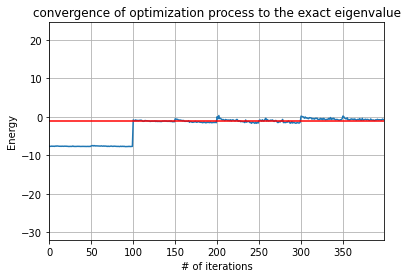

In [70]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [71]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [72]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [73]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

2it [00:00,  7.36it/s]

{'10': 509, '00': 126, '01': 305, '11': 84}
1.0
{'10': 842, '11': 79, '01': 99, '00': 4}
1.0


3it [00:00,  5.68it/s]


{'11': 336, '10': 568, '01': 43, '00': 77}
1.0


0it [00:00, ?it/s]

{'01': 414, '10': 531, '00': 51, '11': 28}
1.0


2it [00:00,  5.61it/s]

{'10': 500, '00': 143, '11': 225, '01': 156}
1.0


3it [00:00,  5.76it/s]


{'11': 343, '01': 143, '00': 150, '10': 388}
1.0


1it [00:00,  7.06it/s]

{'11': 385, '10': 439, '00': 147, '01': 53}
1.0


2it [00:00,  7.19it/s]

{'10': 620, '11': 257, '01': 109, '00': 38}
1.0


3it [00:00,  5.76it/s]


{'10': 585, '01': 93, '11': 314, '00': 32}
1.0


2it [00:00,  4.79it/s]

{'00': 62, '11': 191, '10': 747, '01': 24}
1.0
{'00': 269, '10': 328, '11': 354, '01': 73}
1.0


3it [00:00,  5.05it/s]


{'10': 533, '11': 155, '00': 274, '01': 62}
1.0


1it [00:00,  6.81it/s]

{'01': 78, '11': 349, '00': 164, '10': 433}
1.0


2it [00:00,  7.13it/s]

{'11': 222, '10': 689, '00': 47, '01': 66}
1.0


3it [00:00,  7.12it/s]


{'10': 538, '11': 361, '01': 89, '00': 36}
1.0


2it [00:00,  5.84it/s]

{'10': 527, '11': 164, '00': 330, '01': 3}
1.0
{'11': 281, '01': 159, '10': 493, '00': 91}
1.0


3it [00:00,  4.87it/s]


{'10': 699, '00': 130, '01': 127, '11': 68}
1.0


2it [00:00,  5.70it/s]

{'11': 347, '00': 117, '10': 516, '01': 44}
1.0
{'10': 567, '11': 290, '01': 86, '00': 81}
1.0


3it [00:00,  5.23it/s]


{'11': 324, '00': 73, '10': 533, '01': 94}
1.0


1it [00:00,  8.51it/s]

{'00': 491, '10': 383, '11': 57, '01': 93}
1.0


2it [00:00,  7.32it/s]

{'10': 778, '11': 137, '00': 90, '01': 19}
1.0


3it [00:00,  6.96it/s]


{'10': 781, '11': 144, '00': 92, '01': 7}
1.0


1it [00:00,  7.29it/s]

{'01': 324, '10': 358, '00': 191, '11': 151}
1.0


2it [00:00,  6.74it/s]

{'10': 746, '01': 100, '11': 30, '00': 148}
1.0


3it [00:00,  6.77it/s]


{'11': 263, '01': 208, '10': 515, '00': 38}
1.0


1it [00:00,  6.71it/s]

{'10': 514, '00': 323, '01': 180, '11': 7}
1.0


2it [00:00,  5.57it/s]

{'01': 282, '10': 491, '11': 203, '00': 48}
1.0


3it [00:00,  5.81it/s]


{'10': 665, '00': 190, '01': 131, '11': 38}
1.0


0it [00:00, ?it/s]

{'00': 371, '01': 169, '10': 472, '11': 12}
1.0


2it [00:00,  6.62it/s]

{'01': 261, '10': 483, '11': 31, '00': 249}
1.0


3it [00:00,  7.06it/s]


{'00': 454, '10': 383, '11': 141, '01': 46}
1.0


1it [00:00,  6.80it/s]

{'00': 567, '10': 435, '11': 5, '01': 17}
1.0


2it [00:00,  6.45it/s]

{'01': 46, '10': 575, '11': 341, '00': 62}
1.0


3it [00:00,  6.33it/s]


{'10': 899, '00': 101, '11': 24}
1.0


1it [00:00,  6.04it/s]

{'00': 265, '10': 724, '01': 26, '11': 9}
1.0


2it [00:00,  6.33it/s]

{'00': 88, '11': 589, '10': 316, '01': 31}
1.0


3it [00:00,  6.65it/s]


{'10': 898, '01': 13, '00': 93, '11': 20}
1.0


1it [00:00,  8.95it/s]

{'11': 240, '10': 475, '00': 282, '01': 27}
1.0


2it [00:00,  8.14it/s]

{'11': 395, '10': 506, '00': 113, '01': 10}
1.0


3it [00:00,  8.31it/s]


{'00': 74, '10': 711, '01': 54, '11': 185}
1.0


1it [00:00,  7.85it/s]

{'10': 725, '00': 267, '01': 27, '11': 5}
1.0


2it [00:00,  6.80it/s]

{'00': 246, '10': 172, '11': 397, '01': 209}
1.0


3it [00:00,  6.59it/s]


{'00': 470, '10': 519, '11': 34, '01': 1}
1.0


1it [00:00,  8.90it/s]

{'00': 297, '01': 36, '10': 677, '11': 14}
1.0


2it [00:00,  8.38it/s]

{'11': 604, '10': 328, '00': 62, '01': 30}
1.0


3it [00:00,  8.31it/s]


{'10': 872, '00': 123, '11': 18, '01': 11}
1.0


1it [00:00,  8.82it/s]

{'10': 796, '00': 195, '01': 32, '11': 1}
1.0


3it [00:00,  5.87it/s]


{'00': 96, '11': 589, '10': 316, '01': 23}
1.0
{'10': 881, '00': 97, '11': 35, '01': 11}
1.0


2it [00:00,  7.90it/s]

{'00': 550, '01': 88, '10': 363, '11': 23}
1.0
{'10': 381, '00': 47, '11': 530, '01': 66}
1.0


3it [00:00,  6.26it/s]


{'10': 905, '01': 88, '11': 10, '00': 21}
1.0


1it [00:00,  5.82it/s]

{'10': 475, '00': 380, '01': 126, '11': 43}
1.0


3it [00:00,  5.14it/s]

{'10': 305, '11': 524, '01': 56, '00': 139}
1.0
{'10': 822, '01': 142, '00': 43, '11': 17}
1.0



2it [00:00,  7.49it/s]

{'00': 445, '10': 517, '11': 27, '01': 35}
1.0
{'10': 471, '11': 494, '01': 35, '00': 24}
1.0


3it [00:00,  6.83it/s]


{'10': 979, '01': 43, '00': 2}
1.0


1it [00:00,  6.54it/s]

{'10': 801, '00': 173, '11': 14, '01': 36}
1.0


2it [00:00,  6.12it/s]

{'11': 483, '10': 317, '00': 156, '01': 68}
1.0


3it [00:00,  5.99it/s]


{'10': 783, '00': 193, '11': 40, '01': 8}
1.0


1it [00:00,  8.76it/s]

{'10': 568, '01': 99, '11': 36, '00': 321}
1.0


2it [00:00,  7.83it/s]

{'11': 561, '10': 313, '00': 94, '01': 56}
1.0


3it [00:00,  8.15it/s]


{'01': 131, '10': 844, '11': 31, '00': 18}
1.0


1it [00:00,  7.71it/s]

{'10': 280, '00': 591, '11': 106, '01': 47}
1.0


3it [00:00,  6.18it/s]


{'11': 810, '00': 31, '10': 164, '01': 19}
1.0
{'10': 853, '11': 124, '00': 42, '01': 5}
1.0


2it [00:00,  7.20it/s]

{'10': 561, '00': 365, '11': 45, '01': 53}
1.0
{'11': 413, '00': 66, '10': 508, '01': 37}
1.0


3it [00:00,  5.13it/s]


{'01': 83, '10': 923, '11': 7, '00': 11}
1.0


1it [00:00,  5.55it/s]

{'00': 664, '11': 26, '10': 273, '01': 61}
1.0


2it [00:00,  6.75it/s]

{'11': 691, '10': 266, '00': 23, '01': 44}
1.0


3it [00:00,  6.36it/s]


{'10': 873, '11': 78, '00': 63, '01': 10}
1.0


0it [00:00, ?it/s]

{'10': 516, '00': 386, '01': 107, '11': 15}
1.0


3it [00:00,  4.58it/s]

{'11': 498, '10': 437, '00': 31, '01': 58}
1.0
{'10': 900, '01': 96, '11': 22, '00': 6}
1.0


3it [00:00,  4.51it/s]
2it [00:00,  5.71it/s]

{'00': 491, '10': 444, '11': 78, '01': 11}
1.0
{'10': 613, '11': 368, '01': 36, '00': 7}
1.0


3it [00:00,  5.34it/s]


{'10': 926, '11': 40, '01': 42, '00': 16}
1.0


2it [00:00,  5.52it/s]

{'00': 502, '10': 454, '11': 63, '01': 5}
1.0
{'11': 362, '10': 621, '01': 17, '00': 24}
1.0


3it [00:00,  5.65it/s]


{'10': 969, '01': 31, '00': 5, '11': 19}
1.0


0it [00:00, ?it/s]

{'10': 339, '00': 507, '11': 158, '01': 20}

1it [00:00,  5.81it/s]


1.0
{'11': 143, '10': 585, '01': 281, '00': 15}

3it [00:00,  6.09it/s]



1.0
{'01': 104, '00': 179, '10': 661, '11': 80}
1.0


1it [00:00,  6.60it/s]

{'10': 469, '00': 433, '11': 46, '01': 76}
1.0


2it [00:00,  5.18it/s]

{'00': 32, '10': 587, '11': 365, '01': 40}
1.0
{'10': 885, '01': 70, '11': 63, '00': 6}

3it [00:00,  5.16it/s]



1.0


0it [00:00, ?it/s]

{'10': 504, '11': 23, '00': 470, '01': 27}
1.0


2it [00:00,  5.99it/s]

{'10': 492, '11': 468, '01': 35, '00': 29}
1.0
{'10': 974, '01': 49, '00': 1}
1.0


3it [00:00,  5.51it/s]
1it [00:00,  2.74it/s]

{'10': 497, '00': 468, '11': 50, '01': 9}
1.0


3it [00:00,  4.15it/s]


{'10': 582, '11': 379, '01': 33, '00': 30}
1.0
{'10': 971, '11': 8, '01': 45}
1.0


2it [00:00,  6.44it/s]

{'00': 439, '10': 521, '11': 26, '01': 38}
1.0
{'11': 502, '10': 471, '01': 33, '00': 18}
1.0


3it [00:00,  6.40it/s]


{'10': 981, '01': 37, '00': 6}
1.0


0it [00:00, ?it/s]

{'10': 560, '00': 389, '11': 33, '01': 42}

1it [00:00,  5.92it/s]


1.0


2it [00:00,  4.48it/s]

{'11': 559, '10': 384, '00': 50, '01': 31}
1.0


3it [00:00,  4.23it/s]


{'10': 950, '00': 11, '01': 59, '11': 4}
1.0


1it [00:00,  7.11it/s]

{'00': 363, '10': 607, '01': 36, '11': 18}
1.0


2it [00:00,  6.32it/s]

{'11': 516, '10': 448, '00': 39, '01': 21}
1.0


3it [00:00,  5.33it/s]


{'10': 959, '00': 16, '01': 44, '11': 5}
1.0


1it [00:00,  4.88it/s]

{'10': 639, '00': 376, '01': 8, '11': 1}
1.0
{'11': 465, '10': 458, '00': 49, '01': 52}

2it [00:00,  5.18it/s]


1.0


3it [00:00,  4.78it/s]


{'10': 916, '00': 99, '01': 9}
1.0


0it [00:00, ?it/s]

{'00': 509, '10': 482, '01': 21, '11': 12}
1.0


1it [00:00,  5.58it/s]

{'11': 610, '10': 376, '01': 27, '00': 11}

3it [00:00,  5.80it/s]



1.0
{'01': 20, '10': 983, '11': 17, '00': 4}
1.0


1it [00:00,  7.22it/s]

{'00': 517, '10': 459, '01': 30, '11': 18}
1.0


3it [00:00,  5.42it/s]


{'10': 502, '01': 27, '11': 471, '00': 24}
1.0
{'10': 966, '01': 49, '00': 8, '11': 1}
1.0


2it [00:00,  5.18it/s]

{'00': 381, '01': 17, '10': 593, '11': 33}
1.0
{'00': 55, '10': 434, '11': 527, '01': 8}
1.0


3it [00:00,  5.26it/s]


{'10': 967, '01': 42, '00': 14, '11': 1}
1.0


2it [00:00,  5.95it/s]

{'00': 412, '10': 531, '01': 42, '11': 39}
1.0
{'11': 495, '10': 439, '01': 53, '00': 37}
1.0


3it [00:00,  5.83it/s]


{'10': 943, '00': 10, '01': 70, '11': 1}
1.0


1it [00:00,  6.22it/s]

{'10': 475, '00': 491, '11': 35, '01': 23}
1.0


2it [00:00,  6.03it/s]

{'01': 51, '10': 536, '11': 420, '00': 17}
1.0


3it [00:00,  5.85it/s]

{'10': 959, '01': 56, '11': 3, '00': 6}
1.0


3it [00:00,  5.87it/s]
1it [00:00,  3.68it/s]

{'10': 519, '11': 34, '00': 449, '01': 22}
1.0


3it [00:00,  4.32it/s]


{'10': 481, '11': 501, '00': 25, '01': 17}
1.0
{'10': 954, '01': 67, '00': 3}
1.0


2it [00:00,  6.67it/s]

{'10': 473, '00': 517, '01': 23, '11': 11}
1.0
{'10': 448, '11': 542, '01': 30, '00': 4}
1.0


3it [00:00,  5.25it/s]


{'01': 34, '10': 980, '11': 6, '00': 4}
1.0


2it [00:00,  6.12it/s]

{'10': 502, '00': 474, '01': 15, '11': 33}
1.0
{'11': 436, '10': 541, '00': 16, '01': 31}
1.0


3it [00:00,  6.97it/s]


{'10': 982, '01': 38, '00': 4}
1.0


1it [00:00,  7.89it/s]

{'10': 450, '11': 30, '00': 501, '01': 43}
1.0


2it [00:00,  7.92it/s]

{'10': 411, '11': 531, '00': 41, '01': 41}
1.0


3it [00:00,  7.19it/s]

{'10': 941, '01': 76, '00': 5, '11': 2}
1.0


3it [00:00,  6.78it/s]
1it [00:00,  5.05it/s]

{'10': 494, '00': 478, '01': 20, '11': 32}
1.0
{'10': 447, '11': 539, '01': 25, '00': 13}
1.0


3it [00:00,  4.46it/s]


{'10': 980, '01': 40, '00': 2, '11': 2}
1.0


1it [00:00,  5.16it/s]

{'10': 509, '00': 446, '11': 29, '01': 40}
1.0


3it [00:00,  5.48it/s]


{'11': 542, '10': 414, '01': 27, '00': 41}
1.0
{'10': 954, '01': 68, '11': 2}
1.0


2it [00:00,  6.31it/s]

{'10': 507, '00': 478, '11': 16, '01': 23}
1.0
{'11': 516, '10': 462, '01': 32, '00': 14}
1.0


3it [00:00,  6.50it/s]


{'10': 975, '01': 44, '00': 4, '11': 1}
1.0


1it [00:00,  5.82it/s]

{'10': 500, '00': 473, '01': 36, '11': 15}
1.0


2it [00:00,  6.17it/s]

{'11': 417, '10': 571, '01': 21, '00': 15}
1.0


3it [00:00,  6.28it/s]


{'10': 969, '01': 43, '11': 10, '00': 2}
1.0


1it [00:00,  8.37it/s]

{'00': 440, '10': 536, '01': 29, '11': 19}
1.0


2it [00:00,  7.95it/s]

{'10': 451, '11': 529, '01': 31, '00': 13}
1.0


3it [00:00,  6.48it/s]


{'10': 970, '01': 50, '00': 4}
1.0
[ 29.93516744 119.64008733 121.86315393   1.54213313 318.90498524
  61.74953902 201.39237858 159.96675736 167.50916136 292.51252745
  62.29169825  85.90796925 210.93331475 178.33303848 270.94862078
 130.44067797]


2it [00:00,  6.07it/s]

{'10': 505, '00': 478, '11': 23, '01': 18}
1.0
{'00': 13, '11': 542, '10': 448, '01': 21}
1.0


3it [00:00,  5.05it/s]

{'10': 973, '01': 48, '11': 2, '00': 1}
1.0
CPU times: total: 17.3 s
Wall time: 27.3 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.126613631874979

Approximation Error
0.0970220021745734


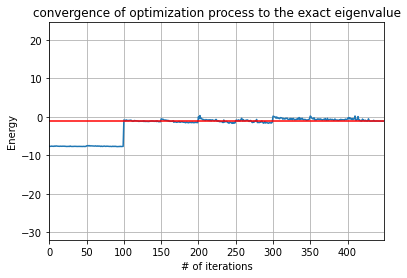

In [74]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [75]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

1it [00:00,  4.79it/s]

{'10': 320, '01': 535, '11': 42, '00': 127}
1.0


3it [00:00,  4.86it/s]

{'11': 300, '10': 268, '01': 386, '00': 70}
1.0
{'11': 399, '01': 168, '00': 278, '10': 179}
1.0


3it [00:00,  4.81it/s]
1it [00:00,  5.21it/s]

{'01': 222, '10': 420, '00': 380, '11': 2}
1.0


3it [00:00,  5.22it/s]

{'00': 154, '10': 113, '11': 137, '01': 620}
1.0
{'11': 161, '00': 690, '10': 81, '01': 92}
1.0


3it [00:00,  5.17it/s]
2it [00:00,  5.55it/s]

{'01': 490, '11': 161, '10': 310, '00': 63}
1.0
{'10': 196, '01': 530, '00': 268, '11': 30}
1.0


3it [00:00,  5.67it/s]


{'00': 320, '01': 489, '11': 178, '10': 37}
1.0


1it [00:00,  5.76it/s]

{'01': 676, '11': 201, '10': 59, '00': 88}
1.0


2it [00:00,  5.70it/s]

{'00': 122, '01': 709, '10': 92, '11': 101}
1.0


3it [00:00,  5.85it/s]


{'01': 718, '11': 159, '10': 16, '00': 131}
1.0


0it [00:00, ?it/s]

{'01': 314, '11': 364, '00': 330, '10': 16}
1.0


3it [00:00,  5.62it/s]


{'00': 90, '01': 481, '10': 191, '11': 262}
1.0
{'01': 419, '10': 135, '11': 275, '00': 195}
1.0


1it [00:00,  7.80it/s]

{'00': 235, '01': 555, '10': 185, '11': 49}
1.0


2it [00:00,  4.97it/s]

{'11': 314, '01': 570, '00': 77, '10': 63}
1.0
{'01': 447, '10': 263, '11': 142, '00': 172}

3it [00:00,  5.18it/s]



1.0


1it [00:00,  7.89it/s]

{'00': 248, '01': 395, '10': 109, '11': 272}
1.0


2it [00:00,  7.39it/s]

{'01': 484, '00': 202, '11': 241, '10': 97}
1.0


3it [00:00,  7.11it/s]


{'10': 315, '01': 642, '00': 39, '11': 28}
1.0


1it [00:00,  6.20it/s]

{'01': 326, '11': 207, '00': 376, '10': 115}
1.0
{'01': 372, '11': 322, '00': 177, '10': 153}

2it [00:00,  5.09it/s]


1.0
{'10': 451, '01': 502, '00': 58, '11': 13}
1.0


3it [00:00,  5.03it/s]
2it [00:00,  7.22it/s]

{'11': 383, '01': 271, '00': 353, '10': 17}
1.0
{'11': 81, '10': 178, '01': 597, '00': 168}
1.0


3it [00:00,  6.78it/s]


{'01': 649, '10': 234, '00': 129, '11': 12}
1.0


2it [00:00,  4.92it/s]

{'01': 511, '11': 259, '00': 254}
1.0
{'01': 524, '11': 225, '00': 274, '10': 1}
1.0


3it [00:00,  4.97it/s]


{'10': 103, '01': 678, '00': 125, '11': 118}
1.0


2it [00:00,  5.44it/s]

{'11': 438, '01': 80, '00': 461, '10': 45}
1.0
{'11': 295, '01': 373, '10': 95, '00': 261}
1.0


3it [00:00,  4.94it/s]


{'01': 438, '10': 313, '00': 208, '11': 65}
1.0


2it [00:00,  4.93it/s]

{'01': 393, '10': 151, '00': 322, '11': 158}
1.0
{'00': 171, '11': 348, '01': 386, '10': 119}
1.0


3it [00:00,  5.33it/s]


{'10': 419, '01': 538, '11': 37, '00': 30}
1.0


1it [00:00,  6.57it/s]

{'00': 420, '01': 470, '11': 112, '10': 22}
1.0
{'00': 156, '01': 437, '11': 395, '10': 36}

2it [00:00,  5.37it/s]


1.0


3it [00:00,  5.03it/s]


{'10': 330, '01': 450, '11': 95, '00': 149}
1.0


1it [00:00,  9.60it/s]

{'00': 96, '01': 566, '11': 149, '10': 213}
1.0


2it [00:00,  7.88it/s]

{'01': 161, '00': 380, '11': 470, '10': 13}
1.0
{'01': 483, '10': 291, '11': 213, '00': 37}

3it [00:00,  6.75it/s]



1.0


2it [00:00,  5.54it/s]

{'00': 295, '10': 154, '01': 423, '11': 152}
1.0
{'11': 544, '00': 208, '01': 192, '10': 80}
1.0


3it [00:00,  6.03it/s]


{'01': 364, '10': 419, '11': 197, '00': 44}
1.0


1it [00:00,  8.36it/s]

{'10': 122, '00': 325, '01': 395, '11': 182}
1.0
{'00': 260, '01': 319, '11': 259, '10': 186}

3it [00:00,  7.06it/s]



1.0
{'01': 545, '10': 421, '11': 32, '00': 26}
1.0


2it [00:00,  6.82it/s]

{'01': 285, '11': 253, '00': 226, '10': 260}
1.0
{'01': 317, '00': 237, '11': 287, '10': 183}
1.0


3it [00:00,  6.47it/s]


{'10': 397, '01': 565, '00': 34, '11': 28}
1.0


1it [00:00,  7.50it/s]

{'10': 554, '01': 199, '11': 188, '00': 83}
1.0


2it [00:00,  7.79it/s]

{'00': 487, '11': 231, '10': 287, '01': 19}
1.0


3it [00:00,  7.43it/s]


{'10': 486, '01': 338, '11': 42, '00': 158}
1.0


1it [00:00,  7.54it/s]

{'01': 326, '00': 207, '11': 313, '10': 178}
1.0


2it [00:00,  7.70it/s]

{'11': 194, '01': 359, '00': 327, '10': 144}
1.0


3it [00:00,  7.75it/s]


{'01': 612, '10': 349, '00': 60, '11': 3}
1.0


1it [00:00,  9.01it/s]

{'00': 391, '10': 136, '01': 125, '11': 372}
1.0


2it [00:00,  8.96it/s]

{'01': 370, '11': 267, '00': 64, '10': 323}
1.0
{'10': 488, '01': 376, '11': 104, '00': 56}

3it [00:00,  7.13it/s]



1.0


1it [00:00,  7.41it/s]

{'00': 76, '01': 309, '10': 236, '11': 403}
1.0


2it [00:00,  6.09it/s]

{'01': 356, '10': 113, '00': 390, '11': 165}
1.0


3it [00:00,  5.95it/s]

{'10': 261, '01': 676, '00': 66, '11': 21}
1.0


3it [00:00,  6.00it/s]
2it [00:00,  5.50it/s]

{'10': 477, '01': 372, '00': 139, '11': 36}
1.0
{'01': 110, '00': 260, '11': 593, '10': 61}
1.0


3it [00:00,  5.29it/s]


{'01': 254, '11': 154, '00': 115, '10': 501}
1.0


2it [00:00,  6.15it/s]

{'10': 443, '01': 154, '00': 159, '11': 268}
1.0
{'10': 278, '11': 325, '01': 172, '00': 249}
1.0


3it [00:00,  5.01it/s]


{'10': 553, '01': 362, '11': 47, '00': 62}
1.0


1it [00:00,  6.79it/s]

{'10': 597, '01': 269, '00': 98, '11': 60}
1.0


2it [00:00,  6.54it/s]

{'11': 650, '00': 203, '01': 126, '10': 45}
1.0


3it [00:00,  6.39it/s]


{'10': 506, '00': 180, '11': 161, '01': 177}
1.0


1it [00:00,  6.33it/s]

{'11': 218, '10': 387, '01': 209, '00': 210}
1.0


3it [00:00,  5.01it/s]

{'10': 241, '00': 263, '11': 317, '01': 203}
1.0
{'10': 513, '01': 427, '00': 69, '11': 15}
1.0


3it [00:00,  5.05it/s]
2it [00:00,  7.88it/s]

{'00': 208, '10': 348, '01': 281, '11': 187}
1.0
{'01': 158, '11': 207, '10': 133, '00': 526}
1.0


3it [00:00,  7.08it/s]


{'10': 320, '00': 244, '01': 458, '11': 2}
1.0


1it [00:00,  3.80it/s]

{'00': 273, '10': 307, '11': 253, '01': 191}
1.0


3it [00:00,  4.52it/s]


{'11': 332, '10': 209, '00': 140, '01': 343}
1.0
{'01': 435, '10': 506, '00': 58, '11': 25}
1.0


1it [00:00,  2.36it/s]

{'01': 240, '11': 374, '10': 220, '00': 190}
1.0


2it [00:00,  3.25it/s]

{'00': 311, '11': 184, '01': 250, '10': 279}
1.0


3it [00:00,  3.09it/s]


{'10': 364, '11': 92, '01': 531, '00': 37}
1.0


1it [00:00,  4.96it/s]

{'11': 273, '01': 49, '10': 469, '00': 233}
1.0


3it [00:00,  5.17it/s]


{'10': 503, '01': 279, '00': 136, '11': 106}
1.0
{'10': 528, '00': 150, '01': 252, '11': 94}
1.0


2it [00:00,  7.88it/s]

{'10': 270, '00': 338, '01': 193, '11': 223}
1.0
{'11': 307, '10': 239, '01': 316, '00': 162}
1.0


3it [00:00,  5.61it/s]


{'10': 536, '01': 379, '00': 90, '11': 19}
1.0


1it [00:00,  5.37it/s]

{'01': 229, '10': 392, '00': 189, '11': 214}
1.0


2it [00:00,  5.57it/s]

{'11': 305, '01': 182, '10': 231, '00': 306}
1.0


3it [00:00,  6.16it/s]


{'01': 443, '10': 504, '00': 63, '11': 14}
1.0


0it [00:00, ?it/s]

{'10': 312, '11': 302, '00': 191, '01': 219}

2it [00:00,  5.78it/s]


1.0
{'01': 199, '11': 291, '10': 289, '00': 245}
1.0


3it [00:00,  5.17it/s]


{'01': 431, '10': 501, '11': 88, '00': 4}
1.0


1it [00:00,  6.34it/s]

{'11': 300, '10': 320, '00': 178, '01': 226}
1.0


2it [00:00,  4.30it/s]

{'01': 188, '00': 275, '11': 222, '10': 339}
1.0


3it [00:00,  4.18it/s]


{'11': 107, '01': 422, '10': 491, '00': 4}
1.0


2it [00:00,  6.66it/s]

{'10': 198, '01': 154, '00': 311, '11': 361}
1.0
{'01': 187, '10': 421, '00': 146, '11': 270}
1.0


3it [00:00,  6.03it/s]


{'10': 490, '11': 195, '01': 327, '00': 12}
1.0


1it [00:00,  7.36it/s]

{'10': 362, '11': 330, '01': 143, '00': 189}
1.0


2it [00:00,  6.41it/s]

{'01': 121, '00': 333, '11': 239, '10': 331}
1.0


3it [00:00,  6.79it/s]


{'01': 412, '10': 532, '11': 65, '00': 15}
1.0


1it [00:00,  2.96it/s]

{'10': 529, '11': 169, '00': 196, '01': 130}
1.0
{'10': 304, '00': 236, '11': 440, '01': 44}

3it [00:00,  4.46it/s]



1.0
{'10': 664, '11': 61, '01': 263, '00': 36}
1.0


2it [00:00,  5.05it/s]

{'10': 512, '00': 172, '11': 135, '01': 205}
1.0
{'10': 238, '00': 246, '11': 503, '01': 37}
1.0


3it [00:00,  4.99it/s]


{'10': 685, '01': 244, '00': 56, '11': 39}
1.0


1it [00:00,  4.17it/s]

{'10': 568, '01': 208, '11': 56, '00': 192}
1.0


2it [00:00,  3.49it/s]

{'11': 657, '10': 147, '00': 200, '01': 20}
1.0


3it [00:00,  3.80it/s]


{'10': 713, '01': 153, '00': 57, '11': 101}
1.0


2it [00:00,  6.04it/s]

{'10': 548, '11': 91, '00': 186, '01': 199}
1.0
{'00': 270, '11': 486, '10': 214, '01': 54}
1.0


3it [00:00,  6.26it/s]


{'10': 642, '01': 270, '00': 53, '11': 59}
1.0


1it [00:00,  6.35it/s]

{'10': 685, '01': 165, '00': 71, '11': 103}
1.0


2it [00:00,  7.51it/s]

{'11': 485, '00': 328, '10': 190, '01': 21}
1.0


3it [00:00,  7.31it/s]


{'10': 621, '00': 151, '11': 41, '01': 211}
1.0


1it [00:00,  6.51it/s]

{'00': 199, '01': 151, '11': 116, '10': 558}
1.0
{'10': 272, '11': 481, '00': 221, '01': 50}
1.0


3it [00:00,  7.79it/s]


{'10': 762, '01': 196, '11': 21, '00': 45}
1.0


1it [00:00,  5.32it/s]

{'11': 150, '10': 526, '00': 274, '01': 74}
1.0
{'11': 402, '00': 176, '01': 81, '10': 365}
1.0


3it [00:00,  5.25it/s]


{'10': 781, '01': 209, '00': 20, '11': 14}
1.0


1it [00:00,  7.56it/s]

{'00': 258, '01': 39, '10': 529, '11': 198}
1.0


2it [00:00,  6.20it/s]

{'10': 419, '11': 391, '00': 144, '01': 70}
1.0


3it [00:00,  6.05it/s]


{'01': 210, '10': 744, '11': 44, '00': 26}
1.0


1it [00:00,  5.39it/s]

{'10': 346, '00': 274, '11': 224, '01': 180}
1.0


2it [00:00,  3.85it/s]

{'10': 315, '00': 245, '11': 321, '01': 143}
1.0


3it [00:00,  4.12it/s]


{'10': 643, '01': 379, '11': 1, '00': 1}
1.0


2it [00:00,  5.65it/s]

{'10': 552, '00': 246, '11': 152, '01': 74}
1.0
{'10': 366, '00': 184, '11': 426, '01': 48}
1.0


3it [00:00,  5.56it/s]


{'10': 770, '01': 213, '00': 31, '11': 10}
1.0


1it [00:00,  4.50it/s]

{'10': 491, '00': 310, '01': 99, '11': 124}
1.0


3it [00:00,  4.84it/s]


{'11': 533, '10': 302, '01': 101, '00': 88}
1.0
{'01': 212, '10': 768, '11': 30, '00': 14}
1.0


2it [00:00,  6.20it/s]

{'00': 304, '11': 91, '10': 477, '01': 152}
1.0
{'00': 129, '11': 545, '01': 113, '10': 237}
1.0


3it [00:00,  4.35it/s]


{'10': 766, '01': 217, '11': 30, '00': 11}
1.0


1it [00:00,  5.00it/s]

{'00': 523, '10': 308, '11': 147, '01': 46}
1.0


3it [00:00,  5.07it/s]


{'11': 565, '00': 56, '10': 317, '01': 86}
1.0
{'10': 807, '01': 109, '11': 86, '00': 22}
1.0


1it [00:00,  4.71it/s]

{'00': 378, '01': 76, '10': 438, '11': 132}
1.0


2it [00:00,  4.23it/s]

{'10': 336, '11': 493, '00': 85, '01': 110}
1.0
{'10': 795, '01': 193, '11': 24, '00': 12}
1.0


3it [00:00,  4.39it/s]
2it [00:00,  6.12it/s]

{'00': 355, '01': 74, '10': 452, '11': 143}
1.0
{'10': 414, '11': 446, '00': 92, '01': 72}
1.0


3it [00:00,  5.99it/s]


{'10': 818, '11': 35, '01': 162, '00': 9}
1.0
[352.38833125 114.09022162  33.99248137  27.01496994  64.71497866
 347.32042102 216.96030496 226.09117488 109.38754461 280.39126518
  40.47963859  74.22044098 126.32092464 198.12787975 306.62725042
  71.86134437]


2it [00:00,  6.20it/s]

{'01': 55, '11': 132, '00': 370, '10': 467}
1.0
{'10': 425, '00': 62, '11': 453, '01': 84}
1.0


3it [00:00,  6.04it/s]

{'10': 817, '00': 7, '01': 166, '11': 34}
1.0
CPU times: total: 17.6 s
Wall time: 29.3 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.0077354209038716

Approximation Error
0.01873375412443044


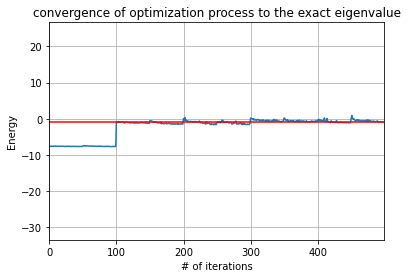

In [76]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [77]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [78]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

1it [00:00,  5.34it/s]

{'11': 263, '01': 325, '00': 316, '10': 120}
1.0


3it [00:00,  5.37it/s]

{'11': 270, '00': 321, '10': 128, '01': 305}
1.0
{'11': 281, '00': 302, '01': 333, '10': 108}
1.0


4it [00:00,  5.38it/s]


{'01': 288, '00': 336, '11': 246, '10': 154}
1.0


1it [00:00,  4.38it/s]

{'00': 530, '01': 147, '11': 234, '10': 113}
1.0


3it [00:00,  4.92it/s]

{'00': 541, '01': 140, '11': 219, '10': 124}
1.0
{'00': 529, '11': 197, '01': 160, '10': 138}
1.0


4it [00:00,  4.83it/s]


{'00': 572, '11': 206, '10': 112, '01': 134}
1.0


1it [00:00,  6.83it/s]

{'10': 108, '01': 177, '11': 493, '00': 246}
1.0


2it [00:00,  5.99it/s]

{'01': 186, '00': 251, '11': 494, '10': 93}
1.0


3it [00:00,  5.59it/s]

{'00': 243, '11': 499, '01': 180, '10': 102}
1.0


4it [00:00,  5.30it/s]

{'10': 98, '11': 482, '00': 261, '01': 183}
1.0


4it [00:00,  5.52it/s]
1it [00:00,  4.30it/s]

{'11': 294, '00': 653, '01': 26, '10': 51}
1.0


2it [00:00,  3.70it/s]

{'01': 26, '00': 646, '11': 298, '10': 54}
1.0


3it [00:00,  3.87it/s]

{'11': 274, '00': 662, '01': 35, '10': 53}
1.0


4it [00:01,  3.89it/s]


{'11': 309, '00': 624, '01': 32, '10': 59}
1.0


1it [00:00,  3.48it/s]

{'00': 550, '11': 169, '10': 120, '01': 185}
1.0


2it [00:00,  3.92it/s]

{'00': 560, '10': 124, '11': 179, '01': 161}
1.0


4it [00:01,  3.91it/s]

{'11': 172, '00': 560, '01': 183, '10': 109}
1.0
{'00': 567, '10': 90, '11': 179, '01': 188}
1.0


4it [00:01,  3.84it/s]
1it [00:00,  4.25it/s]

{'00': 581, '10': 173, '11': 136, '01': 134}
1.0


3it [00:00,  4.50it/s]

{'00': 579, '10': 190, '11': 139, '01': 116}
1.0
{'00': 594, '10': 183, '11': 151, '01': 96}
1.0


4it [00:00,  4.43it/s]


{'00': 554, '10': 197, '11': 162, '01': 111}
1.0


2it [00:00,  4.68it/s]

{'10': 38, '01': 325, '00': 606, '11': 55}
1.0
{'01': 329, '00': 600, '11': 70, '10': 25}
1.0


3it [00:00,  4.84it/s]

{'01': 314, '00': 613, '10': 37, '11': 60}
1.0


4it [00:00,  4.53it/s]


{'10': 24, '00': 624, '01': 311, '11': 65}
1.0


1it [00:00,  3.60it/s]

{'00': 936, '11': 47, '10': 28, '01': 13}
1.0


2it [00:00,  3.87it/s]

{'00': 924, '01': 18, '10': 30, '11': 52}
1.0


3it [00:00,  4.00it/s]

{'00': 932, '11': 52, '10': 23, '01': 17}
1.0
{'00': 906, '10': 28, '11': 67, '01': 23}

4it [00:00,  4.11it/s]



1.0


1it [00:00,  4.16it/s]

{'11': 91, '10': 259, '01': 120, '00': 554}
1.0


2it [00:00,  4.51it/s]

{'10': 288, '00': 528, '01': 127, '11': 81}
1.0


3it [00:00,  4.15it/s]

{'00': 545, '10': 287, '11': 80, '01': 112}
1.0


4it [00:00,  4.21it/s]


{'11': 86, '00': 553, '01': 115, '10': 270}
1.0


1it [00:00,  4.02it/s]

{'00': 769, '01': 182, '10': 47, '11': 26}
1.0


2it [00:00,  4.08it/s]

{'01': 186, '00': 745, '10': 60, '11': 33}
1.0


3it [00:00,  3.88it/s]

{'00': 743, '01': 192, '11': 24, '10': 65}
1.0


4it [00:00,  4.08it/s]


{'10': 59, '00': 743, '01': 194, '11': 28}
1.0


1it [00:00,  4.42it/s]

{'00': 842, '11': 113, '10': 22, '01': 47}
1.0


3it [00:00,  5.30it/s]

{'00': 861, '11': 108, '01': 35, '10': 20}
1.0
{'11': 110, '00': 841, '01': 44, '10': 29}
1.0


4it [00:00,  5.23it/s]


{'00': 839, '11': 116, '01': 49, '10': 20}
1.0


1it [00:00,  6.82it/s]

{'01': 315, '00': 621, '11': 47, '10': 41}
1.0


2it [00:00,  6.74it/s]

{'00': 606, '01': 329, '10': 38, '11': 51}
1.0


3it [00:00,  6.26it/s]

{'01': 357, '00': 579, '11': 45, '10': 43}
1.0


4it [00:00,  6.27it/s]


{'00': 578, '01': 354, '11': 46, '10': 46}
1.0


1it [00:00,  6.72it/s]

{'00': 830, '11': 122, '10': 57, '01': 15}
1.0


2it [00:00,  6.00it/s]

{'00': 835, '01': 22, '10': 57, '11': 110}
1.0


3it [00:00,  6.35it/s]

{'00': 868, '10': 46, '11': 95, '01': 15}
1.0


4it [00:00,  5.80it/s]

{'00': 841, '11': 109, '10': 52, '01': 22}
1.0


4it [00:00,  5.90it/s]
1it [00:00,  3.59it/s]

{'00': 705, '01': 233, '11': 78, '10': 8}
1.0


2it [00:00,  3.02it/s]

{'01': 277, '00': 675, '11': 68, '10': 4}
1.0


3it [00:00,  3.22it/s]

{'00': 714, '01': 222, '11': 86, '10': 2}
1.0


4it [00:01,  3.11it/s]


{'00': 708, '01': 240, '11': 74, '10': 2}
1.0


1it [00:00,  2.82it/s]

{'00': 802, '10': 148, '01': 49, '11': 25}
1.0


2it [00:00,  2.68it/s]

{'00': 787, '01': 41, '10': 173, '11': 23}
1.0


3it [00:01,  2.70it/s]

{'00': 784, '10': 168, '01': 51, '11': 21}
1.0


4it [00:01,  2.92it/s]


{'00': 786, '11': 24, '10': 169, '01': 45}
1.0


2it [00:00,  5.64it/s]

{'00': 928, '11': 49, '01': 23, '10': 24}
1.0
{'10': 44, '00': 910, '01': 22, '11': 48}
1.0


3it [00:00,  5.47it/s]

{'00': 931, '01': 14, '11': 58, '10': 21}
1.0


4it [00:00,  4.91it/s]


{'00': 929, '10': 29, '11': 49, '01': 17}
1.0


1it [00:00,  2.63it/s]

{'00': 909, '11': 53, '10': 34, '01': 28}
1.0


3it [00:00,  4.69it/s]

{'00': 918, '11': 59, '10': 28, '01': 19}
1.0
{'00': 906, '11': 64, '01': 16, '10': 38}
1.0


4it [00:00,  4.16it/s]


{'00': 919, '11': 50, '10': 38, '01': 17}
1.0


1it [00:00,  4.02it/s]

{'00': 848, '10': 60, '01': 97, '11': 19}
1.0
{'10': 66, '00': 826, '01': 103, '11': 29}
1.0


3it [00:00,  4.45it/s]

{'00': 800, '11': 28, '01': 114, '10': 82}
1.0


4it [00:00,  4.26it/s]


{'00': 830, '11': 32, '10': 60, '01': 102}
1.0


1it [00:00,  7.64it/s]

{'11': 163, '00': 829, '01': 16, '10': 16}
1.0


2it [00:00,  6.95it/s]

{'00': 816, '11': 177, '10': 17, '01': 14}
1.0


3it [00:00,  7.16it/s]

{'00': 830, '11': 157, '01': 21, '10': 16}
1.0


4it [00:00,  7.57it/s]


{'00': 827, '11': 164, '10': 16, '01': 17}
1.0


1it [00:00,  6.67it/s]

{'00': 947, '10': 65, '01': 10, '11': 2}
1.0


2it [00:00,  6.30it/s]

{'00': 948, '10': 61, '01': 15}
1.0


3it [00:00,  6.16it/s]

{'10': 61, '01': 19, '00': 942, '11': 2}
1.0


4it [00:00,  6.10it/s]

{'00': 941, '10': 74, '01': 9}
1.0


4it [00:00,  6.02it/s]
2it [00:00,  5.54it/s]

{'00': 693, '10': 301, '01': 5, '11': 25}
1.0
{'00': 711, '10': 285, '11': 26, '01': 2}
1.0


3it [00:00,  5.76it/s]

{'10': 276, '00': 725, '11': 21, '01': 2}
1.0
{'00': 725, '10': 270, '01': 6, '11': 23}


4it [00:00,  5.08it/s]


1.0


1it [00:00,  3.94it/s]

{'00': 952, '10': 63, '01': 8, '11': 1}
1.0


3it [00:00,  4.87it/s]

{'10': 72, '00': 942, '01': 9, '11': 1}
1.0
{'00': 951, '10': 61, '01': 12}
1.0


4it [00:00,  4.67it/s]


{'00': 939, '10': 76, '01': 9}
1.0


0it [00:00, ?it/s]

{'00': 981, '10': 36, '01': 4, '11': 3}

2it [00:00,  5.92it/s]


1.0
{'00': 981, '10': 39, '01': 3, '11': 1}
1.0


3it [00:00,  6.00it/s]

{'00': 973, '11': 3, '10': 43, '01': 5}
1.0


4it [00:00,  5.33it/s]


{'00': 971, '10': 48, '01': 3, '11': 2}
1.0


1it [00:00,  3.08it/s]

{'00': 933, '01': 72, '10': 12, '11': 7}
1.0


3it [00:00,  4.81it/s]

{'00': 939, '01': 72, '10': 7, '11': 6}
1.0
{'00': 932, '01': 80, '10': 10, '11': 2}
1.0


4it [00:00,  4.65it/s]


{'00': 934, '01': 80, '10': 8, '11': 2}
1.0


1it [00:00,  3.53it/s]

{'00': 764, '10': 204, '11': 44, '01': 12}
1.0


2it [00:00,  3.55it/s]

{'11': 50, '00': 752, '10': 202, '01': 20}
1.0


3it [00:00,  3.91it/s]

{'10': 190, '00': 763, '11': 56, '01': 15}
1.0


4it [00:01,  3.92it/s]


{'00': 778, '11': 49, '10': 188, '01': 9}
1.0


1it [00:00,  4.48it/s]

{'00': 975, '10': 45, '11': 2, '01': 2}
1.0
{'00': 980, '10': 41, '01': 2, '11': 1}
1.0


3it [00:00,  5.08it/s]

{'00': 985, '10': 37, '11': 2}
1.0
{'00': 981, '10': 41, '11': 1, '01': 1}
1.0


4it [00:00,  5.01it/s]
1it [00:00,  4.18it/s]

{'01': 395, '00': 606, '11': 14, '10': 9}
1.0


2it [00:00,  4.19it/s]

{'00': 594, '01': 409, '11': 13, '10': 8}
1.0


4it [00:00,  4.78it/s]

{'00': 612, '01': 395, '10': 6, '11': 11}
1.0
{'01': 385, '00': 624, '11': 11, '10': 4}
1.0


4it [00:00,  4.57it/s]
1it [00:00,  5.46it/s]

{'00': 919, '11': 38, '10': 32, '01': 35}
1.0


2it [00:00,  4.31it/s]

{'00': 906, '11': 36, '10': 34, '01': 48}
1.0
{'00': 917, '01': 47, '11': 32, '10': 28}


3it [00:00,  4.53it/s]

1.0
{'10': 40, '00': 915, '11': 31, '01': 38}

4it [00:00,  4.69it/s]



1.0


1it [00:00,  6.99it/s]

{'00': 712, '11': 201, '10': 29, '01': 82}
1.0


2it [00:00,  6.64it/s]

{'00': 727, '11': 207, '01': 63, '10': 27}
1.0


3it [00:00,  6.78it/s]

{'00': 713, '11': 201, '01': 80, '10': 30}
1.0


4it [00:00,  6.61it/s]


{'11': 191, '01': 82, '00': 725, '10': 26}
1.0


0it [00:00, ?it/s]

{'00': 948, '01': 21, '10': 41, '11': 14}
1.0


1it [00:00,  5.74it/s]

{'00': 950, '01': 26, '11': 10, '10': 38}

3it [00:00,  5.48it/s]


1.0
{'00': 938, '01': 25, '10': 49, '11': 12}
1.0


4it [00:00,  5.54it/s]


{'00': 936, '01': 23, '10': 51, '11': 14}
1.0


1it [00:00,  8.65it/s]

{'00': 751, '11': 237, '01': 22, '10': 14}
1.0


2it [00:00,  8.12it/s]

{'00': 768, '10': 15, '11': 219, '01': 22}
1.0


3it [00:00,  6.84it/s]

{'00': 744, '11': 245, '10': 13, '01': 22}
1.0


4it [00:00,  6.14it/s]

{'00': 732, '11': 251, '01': 28, '10': 13}
1.0


4it [00:00,  6.57it/s]
1it [00:00,  8.71it/s]

{'00': 857, '10': 159, '01': 6, '11': 2}
1.0


2it [00:00,  7.95it/s]

{'10': 177, '00': 842, '01': 3, '11': 2}
1.0


3it [00:00,  7.55it/s]

{'00': 847, '10': 172, '01': 4, '11': 1}
1.0


4it [00:00,  6.18it/s]


{'00': 856, '10': 164, '11': 2, '01': 2}
1.0


2it [00:00,  5.46it/s]

{'10': 154, '00': 731, '11': 48, '01': 91}
1.0
{'00': 750, '11': 36, '10': 148, '01': 90}
1.0


4it [00:00,  5.94it/s]


{'01': 95, '00': 730, '10': 150, '11': 49}
1.0
{'00': 751, '10': 132, '01': 93, '11': 48}
1.0


1it [00:00,  7.45it/s]

{'00': 928, '10': 96}
1.0


2it [00:00,  5.03it/s]

{'00': 922, '10': 100, '01': 2}
1.0


4it [00:00,  5.11it/s]

{'00': 919, '10': 104, '01': 1}
1.0
{'00': 914, '10': 106, '01': 3, '11': 1}
1.0


4it [00:00,  5.15it/s]
1it [00:00,  5.18it/s]

{'00': 994, '10': 24, '11': 2, '01': 4}
1.0


2it [00:00,  4.73it/s]

{'00': 974, '10': 40, '01': 7, '11': 3}
1.0


3it [00:00,  4.37it/s]

{'00': 976, '01': 5, '10': 41, '11': 2}
1.0


4it [00:00,  4.30it/s]


{'10': 47, '00': 966, '11': 6, '01': 5}
1.0


2it [00:00,  7.07it/s]

{'00': 967, '10': 41, '01': 11, '11': 5}
1.0
{'00': 980, '01': 9, '10': 30, '11': 5}
1.0


4it [00:00,  7.41it/s]


{'00': 975, '10': 38, '01': 9, '11': 2}
1.0
{'00': 975, '10': 30, '01': 11, '11': 8}
1.0


1it [00:00,  4.58it/s]

{'00': 949, '10': 68, '01': 7}
1.0
{'00': 967, '10': 50, '11': 2, '01': 5}
1.0


4it [00:00,  5.58it/s]


{'00': 970, '10': 47, '01': 7}
1.0
{'00': 986, '10': 32, '01': 4, '11': 2}
1.0


2it [00:00,  6.36it/s]

{'10': 142, '00': 838, '01': 42, '11': 2}
1.0
{'00': 854, '10': 125, '01': 43, '11': 2}
1.0


3it [00:00,  7.05it/s]

{'00': 859, '10': 125, '01': 39, '11': 1}
1.0


4it [00:00,  5.93it/s]


{'00': 855, '10': 116, '01': 45, '11': 8}
1.0


2it [00:00,  5.08it/s]

{'00': 983, '10': 35, '11': 6}
1.0
{'10': 21, '00': 998, '11': 3, '01': 2}
1.0


4it [00:00,  5.47it/s]


{'00': 991, '10': 27, '11': 6}
1.0
{'00': 976, '10': 41, '11': 5, '01': 2}
1.0


1it [00:00,  5.90it/s]

{'00': 977, '11': 29, '10': 10, '01': 8}
1.0


2it [00:00,  4.97it/s]

{'00': 974, '11': 41, '01': 4, '10': 5}
1.0
{'00': 976, '11': 38, '01': 4, '10': 6}

4it [00:00,  5.47it/s]



1.0
{'00': 990, '11': 25, '10': 5, '01': 4}
1.0


2it [00:00,  6.40it/s]

{'00': 1001, '10': 19, '01': 1, '11': 3}
1.0
{'00': 1004, '10': 19, '01': 1}
1.0


3it [00:00,  5.90it/s]

{'00': 991, '10': 31, '11': 2}
1.0


4it [00:00,  5.14it/s]


{'00': 1008, '10': 15, '11': 1}
1.0


2it [00:00,  4.86it/s]

{'00': 926, '11': 6, '10': 57, '01': 35}
1.0
{'00': 910, '10': 64, '01': 40, '11': 10}
1.0


4it [00:00,  5.56it/s]

{'00': 924, '11': 9, '01': 42, '10': 49}
1.0
{'00': 910, '10': 66, '01': 33, '11': 15}
1.0


4it [00:00,  5.34it/s]
2it [00:00,  5.73it/s]

{'00': 974, '10': 49, '11': 1}
1.0
{'10': 48, '00': 974, '01': 1, '11': 1}
1.0


3it [00:00,  5.67it/s]

{'00': 965, '10': 58, '11': 1}
1.0


4it [00:00,  5.30it/s]


{'00': 960, '10': 62, '01': 2}
1.0


0it [00:00, ?it/s]

{'01': 25, '00': 897, '11': 85, '10': 17}

1it [00:00,  5.60it/s]


1.0


2it [00:00,  4.95it/s]

{'00': 925, '01': 36, '11': 55, '10': 8}
1.0


3it [00:00,  4.38it/s]

{'00': 948, '01': 20, '11': 52, '10': 4}
1.0


4it [00:00,  4.54it/s]


{'00': 914, '11': 72, '01': 35, '10': 3}
1.0


1it [00:00,  6.32it/s]

{'00': 992, '01': 16, '10': 16}
1.0
{'00': 996, '01': 17, '10': 11}

3it [00:00,  5.94it/s]


1.0
{'00': 979, '10': 20, '01': 22, '11': 3}
1.0


4it [00:00,  6.16it/s]


{'00': 990, '01': 15, '10': 19}
1.0


1it [00:00,  6.75it/s]

{'00': 946, '10': 5, '11': 61, '01': 12}
1.0
{'00': 944, '01': 23, '11': 53, '10': 4}
1.0


3it [00:00,  5.79it/s]

{'00': 952, '10': 3, '11': 45, '01': 24}
1.0


4it [00:00,  6.13it/s]


{'00': 955, '11': 44, '01': 19, '10': 6}
1.0


1it [00:00,  7.92it/s]

{'00': 962, '10': 58, '11': 2, '01': 2}
1.0


2it [00:00,  5.66it/s]

{'00': 969, '10': 50, '11': 5}
1.0


4it [00:00,  5.42it/s]


{'00': 973, '10': 49, '11': 1, '01': 1}
1.0
{'00': 970, '10': 46, '01': 4, '11': 4}
1.0


2it [00:00,  6.12it/s]

{'00': 997, '10': 21, '01': 3, '11': 3}
1.0
{'00': 998, '10': 23, '11': 2, '01': 1}
1.0


3it [00:00,  5.93it/s]

{'00': 991, '01': 3, '10': 28, '11': 2}
1.0


4it [00:00,  5.37it/s]


{'00': 991, '10': 28, '11': 2, '01': 3}
1.0


2it [00:00,  5.53it/s]

{'00': 968, '10': 46, '01': 7, '11': 3}
1.0
{'00': 980, '10': 40, '01': 4}
1.0


4it [00:00,  5.51it/s]

{'10': 32, '00': 988, '01': 3, '11': 1}
1.0
{'00': 976, '10': 41, '01': 6, '11': 1}
1.0


4it [00:00,  5.43it/s]
2it [00:00,  5.08it/s]

{'00': 988, '10': 31, '01': 2, '11': 3}
1.0
{'00': 985, '10': 31, '01': 4, '11': 4}
1.0


4it [00:00,  5.47it/s]


{'00': 990, '10': 27, '01': 5, '11': 2}
1.0
{'00': 991, '01': 2, '11': 4, '10': 27}
1.0
[ 50.26834335 106.63039911 140.14417168 216.68825185 195.88715638
  79.57175563  31.99904171 320.54120403  71.8913458  330.06724812
 236.05737385 154.0110109  230.7022639  240.33993783 126.62361165
 253.34835939]


2it [00:00,  7.69it/s]

{'00': 1000, '10': 23, '11': 1}
1.0
{'00': 991, '10': 29, '11': 4}
1.0


4it [00:00,  7.54it/s]

{'00': 985, '10': 31, '01': 2, '11': 6}
1.0
{'00': 1000, '10': 20, '11': 3, '01': 1}
1.0
CPU times: total: 23.7 s
Wall time: 41.7 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9914562248013287

Approximation Error
0.013581125283101923


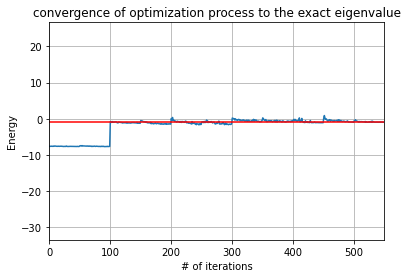

In [79]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [80]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

1it [00:00,  5.74it/s]

{'01': 674, '00': 138, '11': 128, '10': 84}
1.0


3it [00:00,  5.44it/s]

{'01': 712, '10': 91, '11': 113, '00': 108}
1.0
{'01': 723, '00': 98, '11': 114, '10': 89}
1.0


4it [00:00,  5.40it/s]


{'01': 722, '00': 105, '11': 131, '10': 66}
1.0


1it [00:00,  3.75it/s]

{'00': 93, '01': 830, '11': 91, '10': 10}
1.0


2it [00:00,  4.01it/s]

{'01': 816, '00': 103, '11': 87, '10': 18}
1.0


3it [00:00,  4.48it/s]

{'01': 838, '00': 98, '10': 21, '11': 67}
1.0
{'01': 824, '11': 80, '00': 103, '10': 17}

4it [00:00,  4.50it/s]



1.0


1it [00:00,  8.78it/s]

{'01': 812, '11': 117, '00': 95}
1.0


3it [00:00,  5.33it/s]

{'01': 795, '11': 122, '00': 106, '10': 1}
1.0
{'11': 105, '01': 806, '00': 109, '10': 4}
1.0


4it [00:00,  5.80it/s]


{'01': 816, '11': 111, '00': 96, '10': 1}
1.0


2it [00:00,  4.69it/s]

{'01': 756, '00': 167, '11': 95, '10': 6}
1.0
{'00': 163, '01': 775, '11': 83, '10': 3}
1.0


3it [00:00,  4.06it/s]

{'01': 766, '11': 98, '00': 159, '10': 1}
1.0


4it [00:00,  4.24it/s]


{'01': 758, '00': 171, '11': 93, '10': 2}
1.0


2it [00:00,  6.10it/s]

{'01': 629, '00': 131, '11': 261, '10': 3}
1.0
{'00': 114, '01': 673, '11': 228, '10': 9}
1.0


4it [00:00,  6.15it/s]


{'01': 614, '00': 142, '11': 257, '10': 11}
1.0
{'11': 251, '01': 638, '00': 124, '10': 11}
1.0


2it [00:00,  7.54it/s]

{'01': 870, '11': 59, '00': 40, '10': 55}
1.0
{'01': 895, '11': 55, '10': 50, '00': 24}
1.0


4it [00:00,  6.93it/s]


{'01': 889, '00': 20, '10': 56, '11': 59}
1.0
{'01': 887, '11': 65, '10': 47, '00': 25}
1.0


2it [00:00,  8.32it/s]

{'11': 495, '00': 165, '01': 362, '10': 2}
1.0
{'11': 483, '00': 171, '01': 367, '10': 3}
1.0


3it [00:00,  7.81it/s]

{'11': 486, '01': 349, '00': 186, '10': 3}
1.0


4it [00:00,  6.49it/s]


{'01': 356, '11': 495, '00': 173}
1.0


0it [00:00, ?it/s]

{'01': 788, '11': 92, '00': 138, '10': 6}
1.0

2it [00:00,  6.04it/s]


{'01': 797, '00': 137, '10': 5, '11': 85}
1.0


3it [00:00,  4.75it/s]

{'01': 774, '11': 95, '00': 144, '10': 11}
1.0


4it [00:00,  4.89it/s]


{'00': 167, '01': 751, '11': 103, '10': 3}
1.0


1it [00:00,  6.24it/s]

{'00': 123, '01': 761, '11': 115, '10': 25}
1.0


2it [00:00,  7.33it/s]

{'01': 737, '11': 133, '00': 124, '10': 30}
1.0


3it [00:00,  7.42it/s]

{'01': 721, '00': 133, '10': 32, '11': 138}
1.0


4it [00:00,  7.06it/s]


{'01': 734, '00': 122, '11': 133, '10': 35}
1.0


1it [00:00,  6.31it/s]

{'00': 247, '01': 541, '10': 208, '11': 28}
1.0


2it [00:00,  5.27it/s]

{'01': 561, '00': 239, '10': 199, '11': 25}
1.0


3it [00:00,  3.85it/s]

{'01': 550, '00': 248, '10': 196, '11': 30}
1.0


4it [00:00,  4.22it/s]


{'01': 559, '10': 228, '00': 219, '11': 18}
1.0


0it [00:00, ?it/s]

{'11': 253, '00': 407, '01': 325, '10': 39}

2it [00:00,  6.23it/s]


1.0
{'00': 418, '11': 233, '01': 346, '10': 27}
1.0


3it [00:00,  6.94it/s]

{'11': 248, '00': 396, '01': 363, '10': 17}
1.0


4it [00:00,  5.54it/s]


{'00': 389, '11': 237, '01': 368, '10': 30}
1.0


0it [00:00, ?it/s]

{'00': 235, '01': 560, '10': 213, '11': 16}

2it [00:00,  7.86it/s]


1.0
{'11': 26, '01': 562, '00': 248, '10': 188}
1.0


4it [00:00,  6.63it/s]

{'10': 191, '01': 588, '00': 224, '11': 21}
1.0
{'00': 241, '01': 564, '10': 194, '11': 25}
1.0



1it [00:00,  5.61it/s]

{'00': 211, '01': 543, '10': 243, '11': 27}
1.0


3it [00:00,  5.30it/s]

{'00': 209, '01': 557, '11': 29, '10': 229}
1.0
{'10': 220, '01': 571, '00': 202, '11': 31}
1.0


4it [00:00,  5.62it/s]


{'10': 214, '01': 559, '00': 233, '11': 18}
1.0


1it [00:00,  8.23it/s]

{'01': 790, '10': 216, '00': 9, '11': 9}
1.0


3it [00:00,  5.57it/s]

{'01': 762, '10': 247, '00': 10, '11': 5}
1.0
{'01': 797, '10': 209, '11': 7, '00': 11}
1.0


4it [00:00,  5.04it/s]


{'10': 202, '01': 790, '00': 20, '11': 12}
1.0


1it [00:00,  5.53it/s]

{'00': 291, '11': 169, '01': 395, '10': 169}
1.0


3it [00:00,  5.33it/s]

{'00': 304, '11': 187, '10': 150, '01': 383}
1.0
{'00': 306, '01': 408, '11': 159, '10': 151}
1.0


4it [00:00,  5.09it/s]


{'01': 396, '00': 289, '10': 165, '11': 174}
1.0


1it [00:00,  7.12it/s]

{'01': 573, '00': 234, '10': 191, '11': 26}
1.0


2it [00:00,  7.39it/s]

{'10': 204, '01': 537, '00': 255, '11': 28}
1.0


3it [00:00,  7.29it/s]

{'01': 537, '10': 202, '00': 261, '11': 24}
1.0


4it [00:00,  7.14it/s]


{'11': 24, '01': 534, '00': 249, '10': 217}
1.0


2it [00:00,  4.79it/s]

{'10': 182, '01': 555, '00': 254, '11': 33}
1.0
{'01': 541, '11': 28, '00': 225, '10': 230}
1.0


4it [00:00,  5.23it/s]

{'00': 263, '10': 204, '01': 536, '11': 21}
1.0
{'01': 537, '10': 217, '00': 242, '11': 28}
1.0


4it [00:00,  5.06it/s]
2it [00:00,  6.00it/s]

{'00': 67, '01': 655, '10': 240, '11': 62}
1.0
{'01': 613, '10': 281, '11': 61, '00': 69}
1.0


4it [00:00,  5.96it/s]

{'01': 613, '11': 58, '10': 275, '00': 78}
1.0
{'01': 661, '00': 55, '10': 236, '11': 72}
1.0



2it [00:00,  5.88it/s]

{'01': 544, '00': 381, '11': 15, '10': 84}
1.0
{'00': 357, '10': 80, '01': 572, '11': 15}
1.0


4it [00:00,  6.04it/s]


{'01': 571, '00': 368, '10': 67, '11': 18}
1.0
{'00': 372, '01': 554, '10': 85, '11': 13}
1.0


2it [00:00,  5.57it/s]

{'11': 50, '00': 292, '01': 543, '10': 139}
1.0
{'01': 556, '11': 45, '10': 134, '00': 289}
1.0


4it [00:00,  6.30it/s]


{'01': 561, '11': 47, '00': 268, '10': 148}
1.0
{'00': 306, '01': 545, '11': 47, '10': 126}
1.0


2it [00:00,  6.35it/s]

{'00': 427, '01': 429, '11': 59, '10': 109}
1.0
{'01': 451, '00': 411, '11': 63, '10': 99}
1.0


4it [00:00,  6.83it/s]


{'01': 454, '00': 412, '10': 108, '11': 50}
1.0
{'01': 465, '11': 60, '00': 384, '10': 115}
1.0


2it [00:00,  7.06it/s]

{'00': 666, '10': 176, '01': 161, '11': 21}
1.0
{'00': 636, '01': 176, '10': 192, '11': 20}
1.0


4it [00:00,  6.89it/s]


{'00': 642, '11': 17, '10': 185, '01': 180}
1.0
{'00': 661, '01': 152, '10': 191, '11': 20}
1.0


2it [00:00,  5.79it/s]

{'00': 556, '01': 52, '10': 384, '11': 32}
1.0
{'00': 563, '10': 385, '11': 37, '01': 39}
1.0


3it [00:00,  5.76it/s]

{'10': 415, '00': 535, '11': 31, '01': 43}
1.0


4it [00:00,  5.45it/s]


{'00': 581, '10': 373, '11': 24, '01': 46}
1.0


2it [00:00,  4.66it/s]

{'00': 647, '10': 146, '01': 227, '11': 4}
1.0
{'00': 641, '10': 149, '01': 233, '11': 1}
1.0


3it [00:00,  5.28it/s]

{'10': 153, '00': 660, '01': 211}
1.0
{'10': 173, '00': 639, '01': 210, '11': 2}
1.0


4it [00:00,  5.05it/s]
1it [00:00,  4.95it/s]

{'01': 575, '00': 311, '10': 118, '11': 20}
1.0


3it [00:00,  5.26it/s]

{'01': 554, '00': 311, '10': 130, '11': 29}
1.0
{'00': 285, '01': 596, '10': 115, '11': 28}
1.0


4it [00:00,  5.52it/s]


{'00': 299, '11': 24, '01': 571, '10': 130}
1.0


0it [00:00, ?it/s]

{'00': 569, '01': 278, '10': 147, '11': 30}

1it [00:00,  5.37it/s]


1.0
{'00': 549, '01': 295, '10': 140, '11': 40}

2it [00:00,  5.01it/s]


1.0


3it [00:00,  4.72it/s]

{'10': 143, '00': 557, '11': 37, '01': 287}
1.0


4it [00:00,  4.63it/s]


{'00': 565, '01': 287, '10': 140, '11': 32}
1.0


1it [00:00,  3.49it/s]

{'00': 953, '11': 21, '01': 28, '10': 22}
1.0


2it [00:00,  3.80it/s]

{'11': 33, '00': 941, '10': 27, '01': 23}
1.0


3it [00:00,  4.00it/s]

{'00': 948, '01': 28, '11': 21, '10': 27}
1.0


4it [00:00,  4.05it/s]


{'00': 932, '11': 38, '01': 31, '10': 23}
1.0


1it [00:00,  7.33it/s]

{'10': 10, '01': 290, '00': 690, '11': 34}
1.0


2it [00:00,  5.00it/s]

{'00': 707, '01': 270, '11': 37, '10': 10}
1.0
{'01': 255, '00': 699, '11': 53, '10': 17}
1.0


4it [00:00,  4.39it/s]


{'00': 706, '01': 269, '10': 10, '11': 39}
1.0


1it [00:00,  5.35it/s]

{'00': 905, '11': 43, '10': 53, '01': 23}
1.0
{'00': 901, '11': 29, '10': 71, '01': 23}

2it [00:00,  5.31it/s]


1.0


3it [00:00,  4.88it/s]

{'00': 910, '01': 29, '10': 51, '11': 34}
1.0


4it [00:00,  4.41it/s]


{'01': 28, '00': 902, '10': 59, '11': 35}
1.0


1it [00:00,  4.69it/s]

{'11': 174, '10': 162, '00': 522, '01': 166}
1.0


2it [00:00,  4.09it/s]

{'00': 521, '10': 166, '01': 151, '11': 186}
1.0
{'00': 553, '10': 148, '01': 160, '11': 163}

4it [00:00,  4.78it/s]



1.0
{'00': 539, '11': 158, '10': 171, '01': 156}
1.0


1it [00:00,  3.41it/s]

{'00': 944, '01': 19, '11': 36, '10': 25}
1.0


3it [00:00,  4.10it/s]

{'00': 959, '01': 24, '11': 27, '10': 14}
1.0
{'00': 935, '11': 28, '01': 33, '10': 28}
1.0


4it [00:00,  4.24it/s]


{'00': 953, '10': 21, '11': 26, '01': 24}
1.0


1it [00:00,  5.71it/s]

{'00': 897, '01': 84, '11': 36, '10': 7}
1.0


3it [00:00,  4.37it/s]

{'00': 908, '01': 74, '11': 37, '10': 5}
1.0
{'00': 918, '01': 69, '10': 11, '11': 26}
1.0


4it [00:00,  4.34it/s]


{'00': 897, '10': 9, '11': 39, '01': 79}
1.0


1it [00:00,  7.96it/s]

{'00': 919, '10': 11, '11': 20, '01': 74}
1.0


2it [00:00,  7.64it/s]

{'00': 912, '01': 85, '11': 18, '10': 9}
1.0


3it [00:00,  7.12it/s]

{'00': 923, '10': 12, '01': 75, '11': 14}
1.0


4it [00:00,  6.94it/s]


{'00': 918, '10': 11, '01': 79, '11': 16}
1.0


0it [00:00, ?it/s]

{'00': 936, '11': 47, '01': 37, '10': 4}

1it [00:00,  5.55it/s]


1.0


2it [00:00,  4.36it/s]

{'00': 930, '01': 43, '11': 48, '10': 3}
1.0


3it [00:00,  4.20it/s]

{'00': 931, '01': 44, '11': 48, '10': 1}
1.0


4it [00:00,  4.39it/s]


{'00': 930, '01': 42, '11': 52}
1.0


2it [00:00,  5.90it/s]

{'00': 898, '01': 81, '10': 30, '11': 15}
1.0
{'00': 889, '01': 84, '10': 34, '11': 17}
1.0


4it [00:00,  5.69it/s]

{'00': 885, '01': 88, '10': 36, '11': 15}
1.0
{'00': 892, '01': 74, '10': 40, '11': 18}
1.0


4it [00:00,  5.73it/s]
2it [00:00,  5.32it/s]

{'01': 133, '00': 718, '11': 83, '10': 90}
1.0
{'00': 696, '01': 156, '10': 94, '11': 78}
1.0


4it [00:00,  5.62it/s]

{'11': 79, '00': 736, '01': 116, '10': 93}
1.0
{'00': 707, '11': 75, '01': 146, '10': 96}
1.0



2it [00:00,  7.02it/s]

{'00': 863, '01': 57, '11': 60, '10': 44}
1.0
{'00': 880, '11': 45, '01': 47, '10': 52}
1.0


3it [00:00,  5.26it/s]

{'10': 56, '00': 880, '11': 47, '01': 41}
1.0


4it [00:00,  4.85it/s]


{'00': 885, '11': 39, '01': 54, '10': 46}
1.0


1it [00:00,  5.94it/s]

{'00': 886, '11': 84, '01': 39, '10': 15}
1.0


2it [00:00,  6.40it/s]

{'00': 861, '11': 99, '01': 51, '10': 13}
1.0


3it [00:00,  5.96it/s]

{'11': 87, '00': 877, '01': 45, '10': 15}
1.0


4it [00:00,  5.77it/s]

{'01': 59, '00': 874, '11': 75, '10': 16}
1.0


4it [00:00,  5.86it/s]
1it [00:00,  3.01it/s]

{'00': 947, '01': 6, '11': 66, '10': 5}
1.0


2it [00:00,  3.42it/s]

{'00': 948, '01': 16, '11': 57, '10': 3}
1.0


4it [00:01,  4.10it/s]

{'00': 937, '11': 70, '01': 14, '10': 3}
1.0
{'00': 934, '11': 79, '01': 6, '10': 5}
1.0


4it [00:01,  3.78it/s]
1it [00:00,  4.79it/s]

{'00': 906, '10': 69, '11': 35, '01': 14}
1.0
{'00': 864, '11': 59, '01': 13, '10': 88}
1.0


3it [00:01,  2.32it/s]

{'00': 898, '01': 10, '10': 70, '11': 46}
1.0


4it [00:01,  2.95it/s]


{'10': 74, '00': 877, '11': 59, '01': 14}
1.0


1it [00:00,  4.98it/s]

{'00': 859, '01': 100, '11': 51, '10': 14}
1.0


3it [00:00,  5.43it/s]

{'00': 853, '11': 57, '01': 103, '10': 11}
1.0
{'00': 858, '01': 90, '11': 61, '10': 15}
1.0


4it [00:00,  5.04it/s]


{'00': 873, '01': 91, '11': 51, '10': 9}
1.0


2it [00:00,  5.34it/s]

{'00': 933, '01': 53, '10': 31, '11': 7}
1.0
{'00': 934, '01': 49, '10': 33, '11': 8}
1.0


4it [00:00,  5.24it/s]


{'00': 949, '01': 36, '10': 32, '11': 7}
1.0
{'00': 918, '01': 60, '10': 36, '11': 10}
1.0


2it [00:00,  6.08it/s]

{'00': 857, '01': 23, '11': 95, '10': 49}
1.0
{'01': 29, '00': 885, '10': 37, '11': 73}
1.0


4it [00:00,  4.92it/s]

{'00': 877, '10': 53, '11': 66, '01': 28}
1.0
{'01': 30, '11': 72, '00': 885, '10': 37}
1.0


4it [00:00,  5.07it/s]
1it [00:00,  5.68it/s]

{'00': 949, '01': 23, '10': 21, '11': 31}
1.0
{'00': 942, '11': 41, '01': 26, '10': 15}

2it [00:00,  5.27it/s]


1.0


4it [00:00,  4.86it/s]

{'00': 952, '11': 43, '01': 14, '10': 15}
1.0
{'00': 943, '10': 19, '11': 37, '01': 25}
1.0



1it [00:00,  5.38it/s]

{'00': 883, '10': 54, '01': 85, '11': 2}
1.0


2it [00:00,  4.42it/s]

{'00': 879, '01': 83, '10': 60, '11': 2}
1.0
{'00': 862, '01': 90, '10': 67, '11': 5}
1.0


4it [00:00,  4.71it/s]


{'00': 876, '10': 64, '01': 82, '11': 2}
1.0


2it [00:00,  5.05it/s]

{'00': 937, '11': 22, '10': 55, '01': 10}
1.0
{'00': 929, '11': 26, '10': 50, '01': 19}
1.0


3it [00:00,  4.86it/s]

{'00': 939, '10': 48, '11': 22, '01': 15}
1.0


4it [00:00,  4.87it/s]


{'00': 941, '10': 48, '11': 26, '01': 9}
1.0


1it [00:00,  4.67it/s]

{'01': 41, '00': 909, '10': 60, '11': 14}
1.0


2it [00:00,  4.14it/s]

{'00': 902, '01': 34, '10': 63, '11': 25}
1.0


3it [00:00,  3.85it/s]

{'00': 877, '01': 54, '10': 71, '11': 22}
1.0
{'00': 879, '11': 26, '10': 77, '01': 42}

4it [00:00,  4.21it/s]



1.0


1it [00:00,  4.79it/s]

{'00': 994, '10': 12, '11': 3, '01': 15}
1.0


2it [00:00,  3.81it/s]

{'00': 985, '01': 25, '10': 12, '11': 2}
1.0


4it [00:01,  3.98it/s]

{'00': 992, '10': 11, '01': 17, '11': 4}
1.0
{'00': 980, '01': 28, '10': 15, '11': 1}
1.0



1it [00:00,  3.75it/s]

{'00': 975, '01': 31, '10': 18}
1.0


2it [00:00,  3.81it/s]

{'00': 972, '10': 18, '01': 32, '11': 2}
1.0


3it [00:00,  3.08it/s]

{'00': 983, '01': 23, '10': 16, '11': 2}
1.0


4it [00:01,  3.38it/s]


{'00': 978, '10': 16, '01': 28, '11': 2}
1.0


1it [00:00,  3.98it/s]

{'00': 969, '10': 28, '01': 26, '11': 1}
1.0


2it [00:00,  4.01it/s]

{'00': 969, '01': 23, '10': 30, '11': 2}
1.0


3it [00:00,  3.61it/s]

{'00': 956, '10': 33, '01': 34, '11': 1}
1.0


4it [00:01,  3.81it/s]


{'00': 956, '01': 33, '10': 35}
1.0
[202.38048658 154.88401277   9.34416791  92.02449178 310.61852955
 108.84601837 348.25636891 153.89486068 136.66321155  35.03267112
 315.98598529 328.38534404  78.03963752 278.92968568 186.02148571
 137.08608351]


1it [00:00,  4.63it/s]

{'00': 988, '01': 26, '10': 8, '11': 2}
1.0


2it [00:00,  4.47it/s]

{'00': 979, '01': 31, '10': 13, '11': 1}
1.0


3it [00:00,  4.36it/s]

{'00': 987, '10': 14, '01': 20, '11': 3}
1.0
{'00': 980, '10': 8, '01': 33, '11': 3}
1.0


4it [00:00,  4.59it/s]

CPU times: total: 24.1 s
Wall time: 42.2 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9834388022517722

Approximation Error
0.021557813241310217


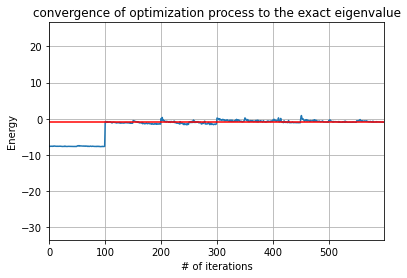

In [81]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)